# Quantum_Magnetometer Federal

In [9]:
from pathlib import Path
import sys, site, os, glob, re, pathlib, warnings, logging
from types import SimpleNamespace


env = os.environ.get("CONDA_PREFIX") or sys.prefix

env_bin = os.path.join(env, "Library", "bin")
os.environ["PATH"] = os.pathsep.join([env_bin, os.environ.get("PATH", "")])



for k in ["XLA_FLAGS", "TF_XLA_FLAGS", "TF_XLA_ENABLE_XLA_DEVICES"]:
    if k in os.environ:
        del os.environ[k]

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"

import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs visible:", tf.config.list_physical_devices("GPU"))


# Enable memory growth to avoid full-GPU preallocation
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception as e:
        print("set_memory_growth failed:", e)

# Expose project root so src.qsensoropt is a package
PROJECT_ROOT = Path("/mnt/c/Users/tvle2/Documents/Code/MagNav/Federated RL-training/Train-RL-Federal").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
# Remove the bare /src dir if present (it masks the package)
bad = str(PROJECT_ROOT / "src")
if bad in sys.path:
    sys.path.remove(bad)
# Expose examples/ so nv_center_dc.py can be imported
EXAMPLES = PROJECT_ROOT / "examples"
if str(EXAMPLES) not in sys.path:
    sys.path.append(str(EXAMPLES))


from typing import List, Optional, Tuple, Literal
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import builtins, inspect

import numpy.lib._index_tricks_impl as _it
sys.modules['numpy.lib.index_tricks'] = _it

from tensorflow import Tensor, concat, constant, float32, __version__, config
from tensorflow.math import exp, cos, abs as tf_abs
from tensorflow.random import uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow import convert_to_tensor, cast, constant
from tensorflow.math import divide, add, sqrt
from tensorflow.random import uniform as tf_uniform

from numpy import ceil, sqrt

# qsensoropt package
import src.qsensoropt.utils as qutils
from src.qsensoropt import InverseSqrtDecay, ParticleFilter, Parameter, SimulationParameters
from src.qsensoropt.utils import train, standard_model


from nv_center_dc import NVCenter, Magnetometry



TF: 2.20.0
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Patches

In [10]:
# ---------- PATCH A · save_weights always ends with .weights.h5 --------------
if not getattr(tf.keras.Model.save_weights, "_patched", False):        
    _real_save = tf.keras.Model.save_weights

    def _safe_save(self, fn, *a, **k):
        fn = str(fn)
        if not fn.endswith(".weights.h5"):
            fn += ".weights.h5"
        Path(fn).parent.mkdir(parents=True, exist_ok=True)
        return _real_save(self, fn, *a, **k)

    _safe_save._patched = True                                          
    tf.keras.Model.save_weights = _safe_save

# ----- load_weights wrapper (NEW guard) --------------------------------------
if not getattr(tf.keras.Model.load_weights, "_patched", False):
    _real_load = tf.keras.Model.load_weights            # <-- keep original

    def _safe_load(self, filepath, *args, **kw):
        fp = str(filepath)

        # 1) ensure recognised suffix
        if not (fp.endswith(".weights.h5") or fp.endswith(".keras") or fp.endswith(".h5")):
            fp += ".weights.h5"

        # 2) try "<iter>_<head>.weights.h5" fallback
        if not Path(fp).exists():
            m = re.search(r"(\d+)(\d)\.weights\.h5$", fp)
            if m:
                fp_alt = re.sub(r"(\d+)(\d)\.weights\.h5$", r"\1_\2.weights.h5", fp)
                if Path(fp_alt).exists():
                    fp = fp_alt

        return _real_load(self, fp, *args, **kw)

    _safe_load._patched = True
    tf.keras.Model.load_weights = _safe_load

if not getattr(tf.keras.Model.save, "_patched", False):
    _real_model_save = tf.keras.Model.save          

    def _safe_model_save(self, filepath, *args, **kw):
        
        fp = str(filepath)
        recognised = (fp.endswith(".keras") or
                      fp.endswith(".h5") or
                      fp.endswith(".weights.h5"))
        if not recognised:
            fp += ".keras"                          # default format

        pathlib.Path(fp).parent.mkdir(parents=True, exist_ok=True)
        return _real_model_save(self, fp, *args, **kw)

    _safe_model_save._patched = True                # mark as patched
    tf.keras.Model.save = _safe_model_save

## Federal: Train the federated RL agent for the proposed federated reinforcement learning algorithm

In [12]:
GAMMA_RAD_PER_US_PER_T = 1.760859e5                 # rad/µs/T
B_BOUNDS_T = (20e-6, 67e-6)                         # 20–67 µT (Tesla)
OMEGA_BOUNDS = (GAMMA_RAD_PER_US_PER_T*B_BOUNDS_T[0],
                GAMMA_RAD_PER_US_PER_T*B_BOUNDS_T[1])
OMEGA_MIN, OMEGA_MAX = OMEGA_BOUNDS                 # rad/µs

# --- Dephasing and τ scaling (µs) ---
T2_US = 1500.0                                      # µs
TAU_MIN_US = max(np.pi / max(OMEGA_MAX, 1e-9), 0.05)  # ≥ 50 ns guard
TAU_TARGET = 0.4 * T2_US
TAU_MAX_US = min(0.6 * T2_US, 3 * TAU_TARGET)

T2_INV = 1/1500
F0, F1 = 0.88, 0.95

In [13]:

class NVCenterDCMagnPhase(NVCenter):
    def __init__(
        self,
        batchsize: int,
        params: List[Parameter],
        prec: Literal["float64","float32"] = "float64",   
        res:  Literal["meas","time"]      = "meas",       
        invT2: Optional[float]            = None,         
        F0:    float                      = 1.0,          
        F1:    float                      = 1.0,          
    ):
        super().__init__(batchsize, params, prec=prec, res=res, control_phase=True)
        self.invT2 = invT2
        self.F0, self.F1 = F0, F1

    def model(self, idxN, outcomes, controls, parameters, meas_step, num_systems=1):
        τ = controls[:,:,0]
        φ = controls[:,:,1]
        ω = parameters[:,:,0]
        invT2_loc = (self.invT2 if self.invT2 is not None else parameters[:,:,1])
        decay = tf.exp(-τ * invT2_loc)

        # ±1 measurement: +1↔μ=0,  −1↔μ=1
        r = outcomes[:,:,0]

        # readout fidelity (p0)
        bias     = 0.5*(1 + self.F0 - self.F1)
        contrast = 0.5*(self.F0 + self.F1 - 1)
        p0_fid   = bias + contrast * decay * tf.cos(ω * τ + φ)

        # Returns the probability of being consistent with the observation 
        return tf.where(r > 0, p0_fid, 1.0 - p0_fid)

def static_field_estimation(
    batchsize: int            = 1024,                 
    max_res:   int            = 10000,                
    learning_rate: float      = 1e-3,                 
    n_hidden:   int           = 64,                   
    num_particles: int        = 240,                  
    iterations:  int          = 4096,                 
    res: Literal["meas","time"]= "time",              
    invT2: Optional[float]    = T2_INV,               
    invT2_bound: Optional[Tuple[float,float]] = None, 
    omega_bounds: Tuple[float,float] = (0.0, 10.0),   
    trained_models_dir: Path  = Path("./trained_models"),
):
    """Train a federated RL controller"""

    trained_models_dir.mkdir(parents=True, exist_ok=True)
    (trained_models_dir.parent / (trained_models_dir.name + "_history_weights")).mkdir(exist_ok=True)
    print("CUDA:", tf.config.list_physical_devices("GPU"))

    # Input/output dimensions
    d = 1 if invT2 is not None else 2
    INPUT_SIZE = d**2 + 2*d + 2
    CTRL_SIZE  = 2
    NUM_HEADS  = 10

    # --- Warm-up---
    seed_net = standard_model(INPUT_SIZE, CTRL_SIZE, n_hidden, prec="float32")
    X0 = tf_uniform((16_384, INPUT_SIZE), -1.0, 1.0, dtype=tf.float32)
    tau_norm = (X0[:, -1:] + 1.0) / 2.0                       # [0,1]
    phi_norm = tf_uniform((16_384, 1), -1.0, 1.0, dtype=tf.float32)
    Y0 = tf.concat([tau_norm, phi_norm], axis=1)
    seed_net.compile(loss="mse", optimizer="adam")
    seed_net.fit(X0, Y0, epochs=12, batch_size=1024, verbose=0)

    # --- 10 heads, sharing the same instance ---
    network  = seed_net
    networks = [network] * NUM_HEADS

    lr_sched  = InverseSqrtDecay(learning_rate, "float32")
    optimizer = tf.keras.optimizers.Adam(lr_sched)

    # ---  initializes the physics model ---

    pars = ([Parameter(omega_bounds, name="omega")] if invT2 is not None else
            [Parameter(omega_bounds, "omega"), Parameter(invT2_bound, "invT2")])

    ## NVCenterDCMagnPhase
    nv = NVCenterDCMagnPhase(batchsize, pars,
                             prec="float32", res=res,
                             invT2=invT2,
                             F0=F0, F1=F1)            
    ## ParticleFilter
    pf   = ParticleFilter(num_particles, nv, prec="float32")

    ## SimulationParameters
    simp = SimulationParameters("fedrl", max_res, max_res,
                                prec="float32",
                                cumulative_loss=True,   
                                log_loss=True)         

    # --- τ's prefactor ---
    # prefact = (max_res / 20.0) if (res == "time") else float(ceil(2.0 ** sqrt(max_res)))
    # invT2_min = invT2 if invT2 is not None else (invT2_bound[0] if invT2_bound is not None else None)

    # if invT2_min is not None and invT2_min > 0.0:
    #     prefact = min(prefact, 1.0 / invT2_min)       

    
    def control_nn(idxN: tf.Tensor, x: tf.Tensor):
        '''
        Define agent's policy - how it chooses an action (tau and phi)
        '''
        idxN = tf.cast(idxN, tf.int32)
        pi = tf.constant(np.pi, dtype=tf.float32)

        OMIN = tf.constant(OMEGA_MIN, tf.float32)
        OMAX = tf.constant(OMEGA_MAX, tf.float32)
        TAU_MIN = tf.constant(TAU_MIN_US, tf.float32)
        TAU_MAX = tf.constant(TAU_MAX_US, tf.float32)

        # PF mean ω decoded from first feature (mean_norm ∈ [-1,1])
        mean_norm = x[:, 0:1]
        omega_est = ((mean_norm + 1.0) * 0.5) * (OMAX - OMIN) + OMIN  # rad/µs  

        def branch(i: int):
            y = networks[i](x)                         # tanh output ∈[-1,1]^2
            # τ in [TAU_MIN, TAU_MAX] via smooth squash
            g = 0.5*(1.0 + tf.tanh(1.5 * y[:, :1]))      # (0,1)
            tau = TAU_MIN + g * (TAU_MAX - TAU_MIN)

            # φ ≈ π/2 − ω_est τ + small residual
            phi_quad = 0.5*pi - omega_est * tau
            dphi = 0.35*pi * y[:, 1:2]   # ±~63°
            phi = phi_quad + dphi

            # wrap to (−π, π]
            phi = tf.math.floormod(phi + pi, 2.0*pi) - pi   
            # tau = tf.constant(prefact, tf.float32) * tf.abs(y[:, :1]) + 1.0
            # phi = pi * y[:, 1:2]
            return lambda: tf.concat([tau, phi], axis=1)

        return tf.switch_case(idxN, {i: branch(i) for i in range(NUM_HEADS)})

    # --- simulator ---
    sim = Magnetometry(
        particle_filter=pf,
        simpars=simp,
        phys_model=nv,
        control_strategy=control_nn,
        eta_flag=(res == "time"),     
    )

    train(sim, optimizer, iterations, str(trained_models_dir),
          networks=networks,
          gradient_accumulation=1,
          xla_compile=False,
          interval_save=1)

In [14]:
FEDERAL_ROOT = Path("./") / "Federal"
FEDERAL_ROOT.mkdir(parents=True, exist_ok=True)
MODELS_DIR = FEDERAL_ROOT / "trained_models"

static_field_estimation(
    batchsize        = 1024,
    max_res          = 10000,
    learning_rate    = 1e-3,
    invT2            = T2_INV,        # 1/1500
    omega_bounds = OMEGA_BOUNDS,
    trained_models_dir = MODELS_DIR
)

CUDA: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/mnt/c/Users/tvle2/Documents/Code/MagNav/localizing/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-14 17:35:24.866710: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ca4bc018360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-14 17:35:24.866737: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-10-14 17:35:24.917260: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-14 17:35:25.066397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded

0 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)


I0000 00:00:1760477737.160248  713746 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x5a57d29609e0



Loss:  6.29707909
1 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.32432795
2 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.33515167
3 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.3042016
4 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.3650856


5 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.38471603


6 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.34384298
7 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.2961421
8 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.32665968
9 paTruees Tensor("uniform_particles/uniform_particles:0", shape=(1024, 1, 1), dtype=float32)
Tensor("particles/particles:0", shape=(1024, 240, 1), dtype=float32) 2-particles (1024, 240, 1)

Loss:  6.33889246

FL-Loss:  [6.33161]
Federal/trained_models_history_weights/


  0% (1 of 4096) |               | Elapsed Time: 0:00:56 ETA:  2 days, 16:20:09


Loss:  6.01718426

Loss:  6.05025864

Loss:  6.02484798

Loss:  6.06131935

Loss:  6.04309845

Loss:  6.05784845

Loss:  6.02818584

Loss:  6.01122189

Loss:  6.0571456

Loss:  6.04627848

FL-Loss:  [6.03973866]
Federal/trained_models_history_weights/


  0% (2 of 4096) |                | Elapsed Time: 0:01:08 ETA:  1 day, 15:06:27


Loss:  6.08530235

Loss:  6.10442066

Loss:  6.08401155

Loss:  6.09698486

Loss:  6.04858685

Loss:  6.0867486

Loss:  6.10064077

Loss:  6.11530447

Loss:  6.15933943

Loss:  6.1601119

FL-Loss:  [6.10414457]
Federal/trained_models_history_weights/


  0% (3 of 4096) |                 | Elapsed Time: 0:01:20 ETA:  1 day, 6:28:33


Loss:  6.03781223

Loss:  6.1114974

Loss:  6.09335375

Loss:  6.13180637

Loss:  6.07350826

Loss:  6.09252691

Loss:  6.05200195

Loss:  6.06308937

Loss:  6.10288858

Loss:  6.06621075

FL-Loss:  [6.08246946]
Federal/trained_models_history_weights/


  0% (4 of 4096) |                 | Elapsed Time: 0:01:32 ETA:  1 day, 2:10:03


Loss:  6.10334301

Loss:  6.12177563

Loss:  6.09105921

Loss:  6.10803032

Loss:  6.11733294

Loss:  6.08292627

Loss:  6.08596802

Loss:  6.07096338

Loss:  6.10124397

Loss:  6.16427946

FL-Loss:  [6.10469198]
Federal/trained_models_history_weights/


  0% (5 of 4096) |                       | Elapsed Time: 0:01:43 ETA:  23:31:38


Loss:  6.12193632

Loss:  6.06812

Loss:  6.0717659

Loss:  6.09277

Loss:  6.16486645

Loss:  6.08353567

Loss:  6.07745361

Loss:  6.09806

Loss:  6.10682726

Loss:  6.09417152

FL-Loss:  [6.09795]
Federal/trained_models_history_weights/


  0% (6 of 4096) |                       | Elapsed Time: 0:01:55 ETA:  21:46:55


Loss:  6.07396269

Loss:  6.1430788

Loss:  6.08956671

Loss:  6.03187895

Loss:  6.09660816

Loss:  6.09067392

Loss:  6.10260296

Loss:  6.08419323

Loss:  6.07051

Loss:  6.12198734

FL-Loss:  [6.09050655]
Federal/trained_models_history_weights/


  0% (7 of 4096) |                       | Elapsed Time: 0:02:06 ETA:  20:31:28


Loss:  6.14244461

Loss:  6.13822031

Loss:  6.12831163

Loss:  6.04512167

Loss:  6.14531183

Loss:  6.10192728

Loss:  6.09904766

Loss:  6.10019064

Loss:  6.07643127

Loss:  6.06171846

FL-Loss:  [6.1038723]
Federal/trained_models_history_weights/


  0% (8 of 4096) |                       | Elapsed Time: 0:02:17 ETA:  19:34:47


Loss:  6.06920576

Loss:  6.09376478

Loss:  6.13074398

Loss:  6.0978384

Loss:  6.09243774

Loss:  6.07051373

Loss:  6.11420918

Loss:  6.13903713

Loss:  6.11063719

Loss:  6.12376642

FL-Loss:  [6.10421515]
Federal/trained_models_history_weights/


  0% (9 of 4096) |                       | Elapsed Time: 0:02:29 ETA:  18:51:08


Loss:  6.0641427

Loss:  6.09575796

Loss:  6.09103632

Loss:  6.09944248

Loss:  6.10965252

Loss:  6.13513136

Loss:  6.08396578

Loss:  6.12375212

Loss:  6.09720373

Loss:  6.10746098

FL-Loss:  [6.10075426]
Federal/trained_models_history_weights/


  0% (10 of 4096) |                      | Elapsed Time: 0:02:40 ETA:  18:15:52


Loss:  6.09957123

Loss:  6.06210804

Loss:  6.16498613

Loss:  6.10535908

Loss:  6.08269787

Loss:  6.07658958

Loss:  6.09175444

Loss:  6.11387968

Loss:  6.06131458

Loss:  6.09518814

FL-Loss:  [6.0953455]
Federal/trained_models_history_weights/


  0% (11 of 4096) |                      | Elapsed Time: 0:02:52 ETA:  17:46:52


Loss:  6.08510828

Loss:  6.07778454

Loss:  6.0664854

Loss:  6.08590937

Loss:  6.07712603

Loss:  6.1432476

Loss:  6.08523321

Loss:  6.15164471

Loss:  6.11382151

Loss:  6.09605694

FL-Loss:  [6.09824133]
Federal/trained_models_history_weights/


  0% (12 of 4096) |                      | Elapsed Time: 0:03:03 ETA:  17:21:56


Loss:  6.05924

Loss:  6.01588202

Loss:  6.07935238

Loss:  6.13961077

Loss:  6.09394312

Loss:  6.05811596

Loss:  6.07463789

Loss:  6.0958519

Loss:  6.05853891

Loss:  6.07051182

FL-Loss:  [6.07456875]
Federal/trained_models_history_weights/


  0% (13 of 4096) |                      | Elapsed Time: 0:03:15 ETA:  17:02:56


Loss:  6.13221216

Loss:  6.07746696

Loss:  6.09773111

Loss:  6.10162163

Loss:  6.10790539

Loss:  6.09192514

Loss:  6.1876111

Loss:  6.11858845

Loss:  6.12355661

Loss:  6.11728191

FL-Loss:  [6.11559]
Federal/trained_models_history_weights/


  0% (14 of 4096) |                      | Elapsed Time: 0:03:26 ETA:  16:45:40


Loss:  6.09461689

Loss:  6.11485291

Loss:  6.1275239

Loss:  6.06960535

Loss:  6.1333127

Loss:  6.06228399

Loss:  6.09047079

Loss:  6.06331825

Loss:  6.08549

Loss:  6.0838604

FL-Loss:  [6.09253359]
Federal/trained_models_history_weights/


  0% (15 of 4096) |                      | Elapsed Time: 0:03:38 ETA:  16:30:30


Loss:  6.0976696

Loss:  6.11566305

Loss:  6.1225338

Loss:  6.07058907

Loss:  6.09122896

Loss:  6.11260366

Loss:  6.12203217

Loss:  6.0881505

Loss:  6.05656052

Loss:  6.07362413

FL-Loss:  [6.09506559]
Federal/trained_models_history_weights/


  0% (16 of 4096) |                      | Elapsed Time: 0:03:50 ETA:  16:18:37


Loss:  6.14731264

Loss:  6.11826658

Loss:  6.09956169

Loss:  6.10691547

Loss:  6.12930918

Loss:  6.07272243

Loss:  6.09401131

Loss:  6.0933919

Loss:  6.04722

Loss:  6.06484365

FL-Loss:  [6.09735537]
Federal/trained_models_history_weights/


  0% (17 of 4096) |                      | Elapsed Time: 0:04:02 ETA:  16:08:20


Loss:  6.08633184

Loss:  6.09496832

Loss:  6.0850606

Loss:  6.09491634

Loss:  6.0369997

Loss:  6.03968096

Loss:  6.08213949

Loss:  6.08719444

Loss:  6.10293293

Loss:  6.07778025

FL-Loss:  [6.07880068]
Federal/trained_models_history_weights/


  0% (18 of 4096) |                      | Elapsed Time: 0:04:14 ETA:  15:59:05


Loss:  6.12290144

Loss:  6.06630516

Loss:  6.07002401

Loss:  6.07667542

Loss:  6.09752035

Loss:  6.10141373

Loss:  6.10851812

Loss:  6.14544201

Loss:  6.09161282

Loss:  6.07307053

FL-Loss:  [6.09534836]
Federal/trained_models_history_weights/


  0% (19 of 4096) |                      | Elapsed Time: 0:04:25 ETA:  15:50:25


Loss:  6.08231401

Loss:  6.1255517

Loss:  6.09702253

Loss:  6.09774542

Loss:  6.12677908

Loss:  6.10725927

Loss:  6.10078526

Loss:  6.10159874

Loss:  6.14565134

Loss:  6.07609463

FL-Loss:  [6.10607958]
Federal/trained_models_history_weights/


  0% (20 of 4096) |                      | Elapsed Time: 0:04:37 ETA:  15:41:58


Loss:  6.13719225

Loss:  6.06673384

Loss:  6.125144

Loss:  6.05538416

Loss:  6.07848406

Loss:  6.07073212

Loss:  6.07635212

Loss:  6.11138391

Loss:  6.1235075

Loss:  6.07685471

FL-Loss:  [6.09217691]
Federal/trained_models_history_weights/


  0% (21 of 4096) |                      | Elapsed Time: 0:04:49 ETA:  15:35:33


Loss:  6.12221336

Loss:  6.1214447

Loss:  6.08848

Loss:  6.08652544

Loss:  6.10631323

Loss:  6.09435844

Loss:  6.09801817

Loss:  6.12417936

Loss:  6.1402564

Loss:  6.06015253

FL-Loss:  [6.10419416]
Federal/trained_models_history_weights/


  0% (22 of 4096) |                      | Elapsed Time: 0:05:01 ETA:  15:29:16


Loss:  6.10506821

Loss:  6.0661211

Loss:  6.09371662

Loss:  6.09124947

Loss:  6.09030676

Loss:  6.09526443

Loss:  6.1146431

Loss:  6.07774734

Loss:  6.09674883

Loss:  6.12052917

FL-Loss:  [6.0951395]
Federal/trained_models_history_weights/


  0% (23 of 4096) |                      | Elapsed Time: 0:05:12 ETA:  15:23:28


Loss:  6.08593512

Loss:  6.10913944

Loss:  6.11136866

Loss:  6.11920929

Loss:  6.07452631

Loss:  6.10640812

Loss:  6.06319904

Loss:  6.04544973

Loss:  6.01600647

Loss:  6.13443279

FL-Loss:  [6.08656788]
Federal/trained_models_history_weights/


  0% (24 of 4096) |                      | Elapsed Time: 0:05:24 ETA:  15:17:28


Loss:  6.08213139

Loss:  6.10992718

Loss:  6.06294298

Loss:  6.09547758

Loss:  6.09414101

Loss:  6.14480114

Loss:  6.13708973

Loss:  6.14245844

Loss:  6.11447954

Loss:  6.10124254

FL-Loss:  [6.10846901]
Federal/trained_models_history_weights/


  0% (25 of 4096) |                      | Elapsed Time: 0:05:36 ETA:  15:12:20


Loss:  6.11243629

Loss:  6.09696722

Loss:  6.13019943

Loss:  6.06340837

Loss:  6.14979506

Loss:  6.10512686

Loss:  6.10859776

Loss:  6.05586195

Loss:  6.07907486

Loss:  6.11819744

FL-Loss:  [6.10196638]
Federal/trained_models_history_weights/


  0% (26 of 4096) |                      | Elapsed Time: 0:05:47 ETA:  15:07:03


Loss:  6.11793327

Loss:  6.12809563

Loss:  6.12733173

Loss:  6.11867619

Loss:  6.1295352

Loss:  6.07854891

Loss:  6.12665844

Loss:  6.10237503

Loss:  6.0766

Loss:  6.07528114

FL-Loss:  [6.10810328]
Federal/trained_models_history_weights/


  0% (27 of 4096) |                      | Elapsed Time: 0:05:59 ETA:  15:01:56


Loss:  6.11133099

Loss:  6.0755434

Loss:  6.09880877

Loss:  6.06298065

Loss:  6.06419945

Loss:  6.11745358

Loss:  6.11023521

Loss:  6.09462

Loss:  6.15485573

Loss:  6.08815193

FL-Loss:  [6.0978179]
Federal/trained_models_history_weights/


  0% (28 of 4096) |                      | Elapsed Time: 0:06:10 ETA:  14:57:53


Loss:  6.08105469

Loss:  6.07120562

Loss:  6.12175274

Loss:  6.08275938

Loss:  6.04635859

Loss:  6.10541058

Loss:  6.12169743

Loss:  6.07782793

Loss:  6.10326242

Loss:  6.1323781

FL-Loss:  [6.09437132]
Federal/trained_models_history_weights/


  0% (29 of 4096) |                      | Elapsed Time: 0:06:22 ETA:  14:53:26


Loss:  6.0671773

Loss:  6.07024574

Loss:  6.1219964

Loss:  6.0914216

Loss:  6.07217932

Loss:  6.06185436

Loss:  6.11792517

Loss:  6.05372667

Loss:  6.05684328

Loss:  6.12349272

FL-Loss:  [6.08368683]
Federal/trained_models_history_weights/


  0% (30 of 4096) |                      | Elapsed Time: 0:06:33 ETA:  14:49:48


Loss:  6.12249184

Loss:  6.13592482

Loss:  6.10341263

Loss:  6.09327412

Loss:  6.06180286

Loss:  6.08421612

Loss:  6.15392876

Loss:  6.15077496

Loss:  6.14352322

Loss:  6.08363056

FL-Loss:  [6.11329794]
Federal/trained_models_history_weights/


  0% (31 of 4096) |                      | Elapsed Time: 0:06:45 ETA:  14:46:36


Loss:  6.08458757

Loss:  6.10463715

Loss:  6.07624865

Loss:  6.04276514

Loss:  6.12471199

Loss:  6.04978514

Loss:  6.10510778

Loss:  6.08549213

Loss:  6.11292458

Loss:  6.11295891

FL-Loss:  [6.08992147]
Federal/trained_models_history_weights/


  0% (32 of 4096) |                      | Elapsed Time: 0:06:57 ETA:  14:43:33


Loss:  6.09969378

Loss:  6.12376881

Loss:  6.11797047

Loss:  6.08509588

Loss:  6.15501595

Loss:  6.09873152

Loss:  6.08553171

Loss:  6.13717318

Loss:  6.08464432

Loss:  6.11736345

FL-Loss:  [6.11049843]
Federal/trained_models_history_weights/


  0% (33 of 4096) |                      | Elapsed Time: 0:07:09 ETA:  14:41:03


Loss:  6.18343496

Loss:  6.14449024

Loss:  6.12226915

Loss:  6.06788301

Loss:  6.06293678

Loss:  6.02273846

Loss:  6.10133171

Loss:  6.04986334

Loss:  6.11398268

Loss:  6.12185907

FL-Loss:  [6.09907866]
Federal/trained_models_history_weights/


  0% (34 of 4096) |                      | Elapsed Time: 0:07:21 ETA:  14:38:34


Loss:  6.11156702

Loss:  6.09138203

Loss:  6.11375713

Loss:  6.10294533

Loss:  6.07561064

Loss:  6.14750719

Loss:  6.0822072

Loss:  6.07512808

Loss:  6.05600119

Loss:  6.07858419

FL-Loss:  [6.09346962]
Federal/trained_models_history_weights/


  0% (35 of 4096) |                      | Elapsed Time: 0:07:32 ETA:  14:35:47


Loss:  6.11237955

Loss:  6.14437675

Loss:  6.08630657

Loss:  6.11351061

Loss:  6.02033186

Loss:  6.10755205

Loss:  6.08371305

Loss:  6.09569788

Loss:  6.11847639

Loss:  6.08740616

FL-Loss:  [6.09697533]
Federal/trained_models_history_weights/


  0% (36 of 4096) |                      | Elapsed Time: 0:07:44 ETA:  14:32:50


Loss:  6.11850405

Loss:  6.09276104

Loss:  6.13353395

Loss:  6.07720518

Loss:  6.08818388

Loss:  6.13796186

Loss:  6.11881733

Loss:  6.11494255

Loss:  6.14332628

Loss:  6.11189604

FL-Loss:  [6.11371326]
Federal/trained_models_history_weights/


  0% (37 of 4096) |                      | Elapsed Time: 0:07:55 ETA:  14:29:56


Loss:  6.08182

Loss:  6.11620617

Loss:  6.05438948

Loss:  6.12344837

Loss:  6.16584826

Loss:  6.08195829

Loss:  6.10345602

Loss:  6.08358622

Loss:  6.15606213

Loss:  6.09162712

FL-Loss:  [6.10584]
Federal/trained_models_history_weights/


  0% (38 of 4096) |                      | Elapsed Time: 0:08:07 ETA:  14:27:11


Loss:  6.05322599

Loss:  6.10464048

Loss:  6.13025427

Loss:  6.04883432

Loss:  6.10306835

Loss:  6.05054474

Loss:  6.11127424

Loss:  6.07993221

Loss:  6.07200766

Loss:  6.16746473

FL-Loss:  [6.09212446]
Federal/trained_models_history_weights/


  0% (39 of 4096) |                      | Elapsed Time: 0:08:18 ETA:  14:25:08


Loss:  6.12806511

Loss:  6.12236929

Loss:  6.09741116

Loss:  6.12113237

Loss:  6.16821671

Loss:  6.04080963

Loss:  6.04758358

Loss:  6.12578678

Loss:  6.18968391

Loss:  6.09825039

FL-Loss:  [6.11393118]
Federal/trained_models_history_weights/


  0% (40 of 4096) |                      | Elapsed Time: 0:08:30 ETA:  14:22:39


Loss:  6.15890026

Loss:  6.03847408

Loss:  6.07744837

Loss:  6.06904316

Loss:  6.12512684

Loss:  6.14296961

Loss:  6.07701

Loss:  6.12187433

Loss:  6.08482695

Loss:  6.10493803

FL-Loss:  [6.10006094]
Federal/trained_models_history_weights/


  1% (41 of 4096) |                      | Elapsed Time: 0:08:42 ETA:  14:20:27


Loss:  6.10251617

Loss:  6.0842514

Loss:  6.13214636

Loss:  6.11895847

Loss:  6.06150103

Loss:  6.08169603

Loss:  6.0681839

Loss:  6.13359499

Loss:  6.09052372

Loss:  6.04591417

FL-Loss:  [6.09192848]
Federal/trained_models_history_weights/


  1% (42 of 4096) |                      | Elapsed Time: 0:08:53 ETA:  14:18:15


Loss:  6.10373354

Loss:  6.10575342

Loss:  6.09182596

Loss:  6.13727665

Loss:  6.06873846

Loss:  6.13757

Loss:  6.07808733

Loss:  6.1161437

Loss:  6.09711123

Loss:  6.12759209

FL-Loss:  [6.10638332]
Federal/trained_models_history_weights/


  1% (43 of 4096) |                      | Elapsed Time: 0:09:04 ETA:  14:16:09


Loss:  6.10396767

Loss:  6.08091

Loss:  6.0704

Loss:  6.06867027

Loss:  6.04766941

Loss:  6.04013538

Loss:  6.07831287

Loss:  6.07359648

Loss:  6.14987755

Loss:  6.13684416

FL-Loss:  [6.08503819]
Federal/trained_models_history_weights/


  1% (44 of 4096) |                      | Elapsed Time: 0:09:16 ETA:  14:14:30


Loss:  6.09575605

Loss:  6.11835384

Loss:  6.09630775

Loss:  6.07188892

Loss:  6.08273506

Loss:  6.09647751

Loss:  6.07776165

Loss:  6.10304546

Loss:  6.09724903

Loss:  6.08405161

FL-Loss:  [6.09236288]
Federal/trained_models_history_weights/


  1% (45 of 4096) |                      | Elapsed Time: 0:09:28 ETA:  14:12:42


Loss:  6.1274972

Loss:  6.12417793

Loss:  6.1418519

Loss:  6.05860472

Loss:  6.1138854

Loss:  6.11890173

Loss:  6.07947588

Loss:  6.09255314

Loss:  6.10019922

Loss:  6.129529

FL-Loss:  [6.10866785]
Federal/trained_models_history_weights/


  1% (46 of 4096) |                      | Elapsed Time: 0:09:39 ETA:  14:10:26


Loss:  6.0940032

Loss:  6.08077812

Loss:  6.14590788

Loss:  6.14349079

Loss:  6.14379215

Loss:  6.05966473

Loss:  6.11262321

Loss:  6.10838127

Loss:  6.11268568

Loss:  6.10653

FL-Loss:  [6.11078548]
Federal/trained_models_history_weights/


  1% (47 of 4096) |                      | Elapsed Time: 0:09:51 ETA:  14:09:06


Loss:  6.1490469

Loss:  6.13691711

Loss:  6.08600473

Loss:  6.0514679

Loss:  6.06555843

Loss:  6.08106852

Loss:  6.11989546

Loss:  6.05505133

Loss:  6.1345315

Loss:  6.10283804

FL-Loss:  [6.09823799]
Federal/trained_models_history_weights/


  1% (48 of 4096) |                      | Elapsed Time: 0:10:03 ETA:  14:08:05


Loss:  6.08105564

Loss:  6.07948732

Loss:  6.13864946

Loss:  6.08647919

Loss:  6.08961821

Loss:  6.10923672

Loss:  6.06249189

Loss:  6.14192057

Loss:  6.08047771

Loss:  6.12014818

FL-Loss:  [6.09895658]
Federal/trained_models_history_weights/


  1% (49 of 4096) |                      | Elapsed Time: 0:10:15 ETA:  14:07:00


Loss:  6.06247759

Loss:  6.07780123

Loss:  6.13112736

Loss:  6.08616781

Loss:  6.10700178

Loss:  6.05608892

Loss:  6.0267868

Loss:  6.06569719

Loss:  6.06977081

Loss:  6.12784719

FL-Loss:  [6.08107662]
Federal/trained_models_history_weights/


  1% (50 of 4096) |                      | Elapsed Time: 0:10:26 ETA:  14:05:23


Loss:  6.07672548

Loss:  6.09481621

Loss:  6.15041

Loss:  6.11009836

Loss:  6.08779669

Loss:  6.08532476

Loss:  6.10671806

Loss:  6.01698065

Loss:  6.07487345

Loss:  6.12717438

FL-Loss:  [6.09309196]
Federal/trained_models_history_weights/


  1% (51 of 4096) |                      | Elapsed Time: 0:10:38 ETA:  14:03:53


Loss:  6.12979364

Loss:  6.07877588

Loss:  6.09993458

Loss:  6.13361

Loss:  6.10729

Loss:  6.11218

Loss:  6.12832832

Loss:  6.10177898

Loss:  6.12844563

Loss:  6.06647

FL-Loss:  [6.1086607]
Federal/trained_models_history_weights/


  1% (52 of 4096) |                      | Elapsed Time: 0:10:50 ETA:  14:02:39


Loss:  6.09215927

Loss:  6.06930494

Loss:  6.12183332

Loss:  6.08674908

Loss:  6.0455513

Loss:  6.08305883

Loss:  6.14138

Loss:  6.04465151

Loss:  6.04528952

Loss:  6.07961941

FL-Loss:  [6.08096]
Federal/trained_models_history_weights/


  1% (53 of 4096) |                      | Elapsed Time: 0:11:01 ETA:  14:01:36


Loss:  6.08468199

Loss:  6.04941702

Loss:  6.07669592

Loss:  6.07562

Loss:  6.09219694

Loss:  6.03940058

Loss:  6.07451868

Loss:  6.07240629

Loss:  6.1017

Loss:  6.05762529

FL-Loss:  [6.07242632]
Federal/trained_models_history_weights/


  1% (54 of 4096) |                      | Elapsed Time: 0:11:13 ETA:  14:00:26


Loss:  6.12577772

Loss:  6.1201005

Loss:  6.13343716

Loss:  6.06554461

Loss:  6.09696293

Loss:  6.09552622

Loss:  6.10601091

Loss:  6.09605

Loss:  6.08050156

Loss:  6.061059

FL-Loss:  [6.09809732]
Federal/trained_models_history_weights/


  1% (55 of 4096) |                      | Elapsed Time: 0:11:25 ETA:  13:59:14


Loss:  6.12798834

Loss:  6.02406073

Loss:  6.11372232

Loss:  6.164083

Loss:  6.07793427

Loss:  6.12146664

Loss:  6.08214712

Loss:  6.1412282

Loss:  6.06516838

Loss:  6.16873741

FL-Loss:  [6.10865355]
Federal/trained_models_history_weights/


  1% (56 of 4096) |                      | Elapsed Time: 0:11:37 ETA:  13:58:20


Loss:  6.12214947

Loss:  6.07857561

Loss:  6.090271

Loss:  6.13915968

Loss:  6.12569

Loss:  6.13226604

Loss:  6.14413548

Loss:  6.12438297

Loss:  6.12571335

Loss:  6.08648968

FL-Loss:  [6.1168828]
Federal/trained_models_history_weights/


  1% (57 of 4096) |                      | Elapsed Time: 0:11:48 ETA:  13:57:18


Loss:  6.0841713

Loss:  6.0835743

Loss:  6.09109974

Loss:  6.06893587

Loss:  6.09307241

Loss:  6.08591

Loss:  6.16115713

Loss:  6.10966349

Loss:  6.08237505

Loss:  6.08786201

FL-Loss:  [6.0947814]
Federal/trained_models_history_weights/


  1% (58 of 4096) |                      | Elapsed Time: 0:12:00 ETA:  13:56:19


Loss:  6.12219763

Loss:  6.06092644

Loss:  6.08107853

Loss:  6.13703775

Loss:  6.10852861

Loss:  6.08289623

Loss:  6.06868696

Loss:  6.07002831

Loss:  6.06315

Loss:  6.12092209

FL-Loss:  [6.0915451]
Federal/trained_models_history_weights/


  1% (59 of 4096) |                      | Elapsed Time: 0:12:12 ETA:  13:55:20


Loss:  6.09530401

Loss:  6.11473656

Loss:  6.13857079

Loss:  6.10073662

Loss:  6.07264757

Loss:  6.11424589

Loss:  6.07231665

Loss:  6.0831089

Loss:  6.05501938

Loss:  6.08228493

FL-Loss:  [6.09289742]
Federal/trained_models_history_weights/


  1% (60 of 4096) |                      | Elapsed Time: 0:12:24 ETA:  13:54:13


Loss:  6.09742546

Loss:  6.09626389

Loss:  6.10325766

Loss:  6.13561821

Loss:  6.07920456

Loss:  6.07096529

Loss:  6.07993364

Loss:  6.11246586

Loss:  6.10010052

Loss:  6.09733963

FL-Loss:  [6.09725761]
Federal/trained_models_history_weights/


  1% (61 of 4096) |                      | Elapsed Time: 0:12:35 ETA:  13:53:16


Loss:  6.09725189

Loss:  6.07142639

Loss:  6.10122681

Loss:  6.10520029

Loss:  6.14450645

Loss:  6.12498569

Loss:  6.07766247

Loss:  6.12689066

Loss:  6.1274662

Loss:  6.12082958

FL-Loss:  [6.10974455]
Federal/trained_models_history_weights/


  1% (62 of 4096) |                      | Elapsed Time: 0:12:47 ETA:  13:52:12


Loss:  6.09700298

Loss:  6.0994916

Loss:  6.10029078

Loss:  6.09576559

Loss:  6.09481668

Loss:  6.09224796

Loss:  6.05767441

Loss:  6.09792

Loss:  6.0667491

Loss:  6.07500315

FL-Loss:  [6.08769608]
Federal/trained_models_history_weights/


  1% (63 of 4096) |                      | Elapsed Time: 0:12:59 ETA:  13:51:15


Loss:  6.09865236

Loss:  6.09055376

Loss:  6.05794191

Loss:  6.1427021

Loss:  6.13351583

Loss:  6.12152338

Loss:  6.11577702

Loss:  6.10756159

Loss:  6.11648941

Loss:  6.12340069

FL-Loss:  [6.11081171]
Federal/trained_models_history_weights/


  1% (64 of 4096) |                      | Elapsed Time: 0:13:10 ETA:  13:50:25


Loss:  6.09407425

Loss:  6.09163713

Loss:  6.14985466

Loss:  6.07866

Loss:  6.10707569

Loss:  6.0820446

Loss:  6.0881834

Loss:  6.13858843

Loss:  6.04696941

Loss:  6.08801365

FL-Loss:  [6.09651]
Federal/trained_models_history_weights/


  1% (65 of 4096) |                      | Elapsed Time: 0:13:22 ETA:  13:49:27


Loss:  6.09066248

Loss:  6.0848937

Loss:  6.09165716

Loss:  6.11572456

Loss:  6.07837439

Loss:  6.10000134

Loss:  6.07130957

Loss:  6.10022

Loss:  6.08076096

Loss:  6.08530331

FL-Loss:  [6.08989096]
Federal/trained_models_history_weights/


  1% (66 of 4096) |                      | Elapsed Time: 0:13:34 ETA:  13:48:55


Loss:  6.1326251

Loss:  6.08579302

Loss:  6.11660099

Loss:  6.0883317

Loss:  6.14330387

Loss:  6.09043598

Loss:  6.09122467

Loss:  6.07035875

Loss:  6.07518244

Loss:  6.09252548

FL-Loss:  [6.09863806]
Federal/trained_models_history_weights/


  1% (67 of 4096) |                      | Elapsed Time: 0:13:46 ETA:  13:48:23


Loss:  6.08467388

Loss:  6.09106922

Loss:  6.05443382

Loss:  6.07946253

Loss:  6.06131

Loss:  6.12443829

Loss:  6.06555653

Loss:  6.10897493

Loss:  6.12631559

Loss:  6.08174753

FL-Loss:  [6.0877986]
Federal/trained_models_history_weights/


  1% (68 of 4096) |                      | Elapsed Time: 0:13:58 ETA:  13:47:48


Loss:  6.11169

Loss:  6.09669685

Loss:  6.0665288

Loss:  6.15508795

Loss:  6.10837221

Loss:  6.12043047

Loss:  6.12421036

Loss:  6.13281059

Loss:  6.08346

Loss:  6.05885792

FL-Loss:  [6.10581493]
Federal/trained_models_history_weights/


  1% (69 of 4096) |                      | Elapsed Time: 0:14:10 ETA:  13:47:14


Loss:  6.13418579

Loss:  6.09247732

Loss:  6.04725933

Loss:  6.08394384

Loss:  6.06893349

Loss:  6.1296773

Loss:  6.07478857

Loss:  6.04484558

Loss:  6.07914734

Loss:  6.1183362

FL-Loss:  [6.08735943]
Federal/trained_models_history_weights/


  1% (70 of 4096) |                      | Elapsed Time: 0:14:22 ETA:  13:46:25


Loss:  6.1428628

Loss:  6.02403069

Loss:  6.04961586

Loss:  6.13034296

Loss:  6.07146835

Loss:  6.09818792

Loss:  6.1322279

Loss:  6.09933376

Loss:  6.1541853

Loss:  6.09016657

FL-Loss:  [6.09924221]
Federal/trained_models_history_weights/


  1% (71 of 4096) |                      | Elapsed Time: 0:14:34 ETA:  13:45:55


Loss:  6.08115435

Loss:  6.09265471

Loss:  6.08548832

Loss:  6.07023859

Loss:  6.08677387

Loss:  6.08991861

Loss:  6.18990088

Loss:  6.08644104

Loss:  6.15360689

Loss:  6.10874796

FL-Loss:  [6.10449219]
Federal/trained_models_history_weights/


  1% (72 of 4096) |                      | Elapsed Time: 0:14:45 ETA:  13:45:08


Loss:  6.08796

Loss:  6.08656597

Loss:  6.15336132

Loss:  6.12279606

Loss:  6.09226561

Loss:  6.07964945

Loss:  6.07537079

Loss:  6.07278776

Loss:  6.14396858

Loss:  6.08649349

FL-Loss:  [6.10012245]
Federal/trained_models_history_weights/


  1% (73 of 4096) |                      | Elapsed Time: 0:14:57 ETA:  13:44:33


Loss:  6.14309835

Loss:  6.10287428

Loss:  6.05625105

Loss:  6.14248466

Loss:  6.09492779

Loss:  6.1464262

Loss:  6.0809226

Loss:  6.10570955

Loss:  6.07744217

Loss:  6.07196283

FL-Loss:  [6.10221]
Federal/trained_models_history_weights/


  1% (74 of 4096) |                      | Elapsed Time: 0:15:09 ETA:  13:44:08


Loss:  6.0764

Loss:  6.12664652

Loss:  6.0574255

Loss:  6.12592554

Loss:  6.13954782

Loss:  6.08343792

Loss:  6.08012

Loss:  6.1329751

Loss:  6.084764

Loss:  6.09737778

FL-Loss:  [6.10046244]
Federal/trained_models_history_weights/


  1% (75 of 4096) |                      | Elapsed Time: 0:15:21 ETA:  13:43:26


Loss:  6.07843637

Loss:  6.09042501

Loss:  6.10713

Loss:  6.07987165

Loss:  6.11657381

Loss:  6.08495617

Loss:  6.13727283

Loss:  6.10329437

Loss:  6.0723772

Loss:  6.07049179

FL-Loss:  [6.09408283]
Federal/trained_models_history_weights/


  1% (76 of 4096) |                      | Elapsed Time: 0:15:33 ETA:  13:43:01


Loss:  6.15443563

Loss:  6.03709698

Loss:  6.08717155

Loss:  6.08810234

Loss:  6.13511753

Loss:  6.07355

Loss:  6.09581518

Loss:  6.14331388

Loss:  6.08663177

Loss:  6.10731459

FL-Loss:  [6.10085487]
Federal/trained_models_history_weights/


  1% (77 of 4096) |                      | Elapsed Time: 0:15:45 ETA:  13:42:38


Loss:  6.14444113

Loss:  6.06301165

Loss:  6.13851595

Loss:  6.10938644

Loss:  6.09476

Loss:  6.12982893

Loss:  6.10916424

Loss:  6.09895706

Loss:  6.13784552

Loss:  6.13924503

FL-Loss:  [6.11651564]
Federal/trained_models_history_weights/


  1% (78 of 4096) |                      | Elapsed Time: 0:15:57 ETA:  13:42:17


Loss:  6.14111233

Loss:  6.06573391

Loss:  6.14334393

Loss:  6.12239838

Loss:  6.0882597

Loss:  6.05207729

Loss:  6.06991577

Loss:  6.15856075

Loss:  6.07197237

Loss:  6.13035679

FL-Loss:  [6.10437346]
Federal/trained_models_history_weights/


  1% (79 of 4096) |                      | Elapsed Time: 0:16:09 ETA:  13:41:57


Loss:  6.1298418

Loss:  6.12470388

Loss:  6.16284037

Loss:  6.10582447

Loss:  6.05509329

Loss:  6.07908726

Loss:  6.08384

Loss:  6.08749723

Loss:  6.13585663

Loss:  6.09074497

FL-Loss:  [6.10553312]
Federal/trained_models_history_weights/


  1% (80 of 4096) |                      | Elapsed Time: 0:16:21 ETA:  13:41:29


Loss:  6.10028791

Loss:  6.08733606

Loss:  6.13182831

Loss:  6.03557301

Loss:  6.10821342

Loss:  6.05822945

Loss:  6.07197332

Loss:  6.12267971

Loss:  6.15389299

Loss:  6.10505438

FL-Loss:  [6.097507]
Federal/trained_models_history_weights/


  1% (81 of 4096) |                      | Elapsed Time: 0:16:33 ETA:  13:41:01


Loss:  6.11851311

Loss:  6.0837636

Loss:  6.06138802

Loss:  6.04852533

Loss:  6.10065603

Loss:  6.0647459

Loss:  6.08367968

Loss:  6.085711

Loss:  6.05180359

Loss:  6.16490459

FL-Loss:  [6.08636904]
Federal/trained_models_history_weights/


  2% (82 of 4096) |                      | Elapsed Time: 0:16:45 ETA:  13:40:26


Loss:  6.05224943

Loss:  6.08920431

Loss:  6.11720085

Loss:  6.12625742

Loss:  6.07555389

Loss:  6.05721521

Loss:  6.09520388

Loss:  6.07293

Loss:  6.10902

Loss:  6.10372448

FL-Loss:  [6.08985615]
Federal/trained_models_history_weights/


  2% (83 of 4096) |                      | Elapsed Time: 0:16:57 ETA:  13:39:57


Loss:  6.09262848

Loss:  6.12231398

Loss:  6.06299496

Loss:  6.04880571

Loss:  6.15120602

Loss:  6.09442759

Loss:  6.08193207

Loss:  6.11341

Loss:  6.08637857

Loss:  6.14229822

FL-Loss:  [6.09963942]
Federal/trained_models_history_weights/


  2% (84 of 4096) |                      | Elapsed Time: 0:17:09 ETA:  13:39:25


Loss:  6.07526398

Loss:  6.06246

Loss:  6.12257242

Loss:  6.07666731

Loss:  6.10155725

Loss:  6.0769515

Loss:  6.11613417

Loss:  6.11386871

Loss:  6.08538771

Loss:  6.03986454

FL-Loss:  [6.0870719]
Federal/trained_models_history_weights/


  2% (85 of 4096) |                      | Elapsed Time: 0:17:21 ETA:  13:38:47


Loss:  6.12283611

Loss:  6.08961773

Loss:  6.0370574

Loss:  6.10550499

Loss:  6.09361029

Loss:  6.0894866

Loss:  6.06046677

Loss:  6.12738562

Loss:  6.17563343

Loss:  6.13565636

FL-Loss:  [6.10372543]
Federal/trained_models_history_weights/


  2% (86 of 4096) |                      | Elapsed Time: 0:17:32 ETA:  13:38:16


Loss:  6.13841248

Loss:  6.10029459

Loss:  6.06425524

Loss:  6.08798695

Loss:  6.07809067

Loss:  6.10712528

Loss:  6.10900593

Loss:  6.1445241

Loss:  6.10410261

Loss:  6.12152386

FL-Loss:  [6.10553217]
Federal/trained_models_history_weights/


  2% (87 of 4096) |                      | Elapsed Time: 0:17:44 ETA:  13:37:42


Loss:  6.06602335

Loss:  6.13257504

Loss:  6.13646173

Loss:  6.09704208

Loss:  6.06874275

Loss:  6.13227892

Loss:  6.10429192

Loss:  6.00705481

Loss:  6.07134056

Loss:  6.10270691

FL-Loss:  [6.09185123]
Federal/trained_models_history_weights/


  2% (88 of 4096) |                      | Elapsed Time: 0:17:56 ETA:  13:37:04


Loss:  6.15003

Loss:  6.09658909

Loss:  6.09332561

Loss:  6.10589552

Loss:  6.06481695

Loss:  6.12689781

Loss:  6.05932188

Loss:  6.09923935

Loss:  6.08162165

Loss:  6.05784321

FL-Loss:  [6.09355736]
Federal/trained_models_history_weights/


  2% (89 of 4096) |                      | Elapsed Time: 0:18:08 ETA:  13:36:32


Loss:  6.06484318

Loss:  6.05278873

Loss:  6.13229895

Loss:  6.06631327

Loss:  6.06144476

Loss:  6.14420843

Loss:  6.07989883

Loss:  6.10349894

Loss:  6.11597633

Loss:  6.11201763

FL-Loss:  [6.09332848]
Federal/trained_models_history_weights/


  2% (90 of 4096) |                      | Elapsed Time: 0:18:20 ETA:  13:36:05


Loss:  6.16087103

Loss:  6.06800127

Loss:  6.10767889

Loss:  6.08717299

Loss:  6.05591249

Loss:  6.07932711

Loss:  6.12073374

Loss:  6.08700323

Loss:  6.07789373

Loss:  6.14226818

FL-Loss:  [6.09868622]
Federal/trained_models_history_weights/


  2% (91 of 4096) |                      | Elapsed Time: 0:18:31 ETA:  13:35:38


Loss:  6.12323284

Loss:  6.07008123

Loss:  6.13452435

Loss:  6.11920643

Loss:  6.04954767

Loss:  6.10126543

Loss:  6.0311079

Loss:  6.08017921

Loss:  6.0949235

Loss:  6.08157825

FL-Loss:  [6.0885644]
Federal/trained_models_history_weights/


  2% (92 of 4096) |                      | Elapsed Time: 0:18:43 ETA:  13:35:12


Loss:  6.06473827

Loss:  6.13640928

Loss:  6.11565447

Loss:  6.10196

Loss:  6.05741644

Loss:  6.05295181

Loss:  6.09727764

Loss:  6.10078239

Loss:  6.05214834

Loss:  6.14235973

FL-Loss:  [6.09217]
Federal/trained_models_history_weights/


  2% (93 of 4096) |                      | Elapsed Time: 0:18:55 ETA:  13:34:38


Loss:  6.05743694

Loss:  6.10819387

Loss:  6.07457209

Loss:  6.0841651

Loss:  6.08389664

Loss:  6.09724522

Loss:  6.0801692

Loss:  6.09950161

Loss:  6.13775349

Loss:  6.15794182

FL-Loss:  [6.09808731]
Federal/trained_models_history_weights/


  2% (94 of 4096) |                      | Elapsed Time: 0:19:07 ETA:  13:34:10


Loss:  6.14033508

Loss:  6.11257744

Loss:  6.05064678

Loss:  6.12650728

Loss:  6.0984087

Loss:  6.07492

Loss:  6.07558346

Loss:  6.13673353

Loss:  6.09272718

Loss:  6.12611675

FL-Loss:  [6.10345554]
Federal/trained_models_history_weights/


  2% (95 of 4096) |                      | Elapsed Time: 0:19:19 ETA:  13:33:40


Loss:  6.10629559

Loss:  6.04137421

Loss:  6.09244537

Loss:  6.081429

Loss:  6.14900732

Loss:  6.08451366

Loss:  6.14874792

Loss:  6.04839087

Loss:  6.13775396

Loss:  6.13776779

FL-Loss:  [6.10277224]
Federal/trained_models_history_weights/


  2% (96 of 4096) |                      | Elapsed Time: 0:19:30 ETA:  13:33:09


Loss:  6.10634613

Loss:  6.01539

Loss:  6.04795551

Loss:  6.11852169

Loss:  6.13093472

Loss:  6.07721806

Loss:  6.08738518

Loss:  6.11537075

Loss:  6.10889959

Loss:  6.02466583

FL-Loss:  [6.08326864]
Federal/trained_models_history_weights/


  2% (97 of 4096) |                      | Elapsed Time: 0:19:43 ETA:  13:32:54


Loss:  6.09158373

Loss:  6.11271572

Loss:  6.09115076

Loss:  6.12131453

Loss:  6.11306953

Loss:  6.11368704

Loss:  6.08649349

Loss:  6.06358624

Loss:  6.0852375

Loss:  6.12945175

FL-Loss:  [6.10082912]
Federal/trained_models_history_weights/


  2% (98 of 4096) |                      | Elapsed Time: 0:19:54 ETA:  13:32:27


Loss:  6.12244

Loss:  6.12400436

Loss:  6.10279608

Loss:  6.07845

Loss:  6.0929451

Loss:  6.12991142

Loss:  6.05721617

Loss:  6.08093

Loss:  6.11890411

Loss:  6.03264523

FL-Loss:  [6.0940237]
Federal/trained_models_history_weights/


  2% (99 of 4096) |                      | Elapsed Time: 0:20:06 ETA:  13:31:59


Loss:  6.10131598

Loss:  6.09990072

Loss:  6.10450363

Loss:  6.07982826

Loss:  6.13251257

Loss:  6.06112289

Loss:  6.07871628

Loss:  6.02845764

Loss:  6.07809

Loss:  6.06350374

FL-Loss:  [6.08279514]
Federal/trained_models_history_weights/


  2% (100 of 4096) |                     | Elapsed Time: 0:20:18 ETA:  13:31:48


Loss:  6.092484

Loss:  6.0883193

Loss:  6.13905764

Loss:  6.07384968

Loss:  6.12652683

Loss:  6.11863327

Loss:  6.14366484

Loss:  6.12099886

Loss:  6.1002779

Loss:  6.08384323

FL-Loss:  [6.10876513]
Federal/trained_models_history_weights/


  2% (101 of 4096) |                     | Elapsed Time: 0:20:30 ETA:  13:31:20


Loss:  6.06316185

Loss:  6.09158611

Loss:  6.06023932

Loss:  6.09005

Loss:  6.09399319

Loss:  6.06654739

Loss:  6.07045174

Loss:  6.1377635

Loss:  6.11617422

Loss:  6.11847639

FL-Loss:  [6.09084415]
Federal/trained_models_history_weights/


  2% (102 of 4096) |                     | Elapsed Time: 0:20:42 ETA:  13:30:51


Loss:  6.11206341

Loss:  6.05612135

Loss:  6.10025

Loss:  6.05754852

Loss:  6.10845089

Loss:  6.0949049

Loss:  6.08850193

Loss:  6.09912729

Loss:  6.10475492

Loss:  6.08797789

FL-Loss:  [6.09097]
Federal/trained_models_history_weights/


  2% (103 of 4096) |                     | Elapsed Time: 0:20:54 ETA:  13:30:21


Loss:  6.16436148

Loss:  6.01338291

Loss:  6.07236338

Loss:  6.04888916

Loss:  6.11769104

Loss:  6.1001277

Loss:  6.11308289

Loss:  6.09208918

Loss:  6.10784

Loss:  6.08871841

FL-Loss:  [6.09185505]
Federal/trained_models_history_weights/


  2% (104 of 4096) |                     | Elapsed Time: 0:21:06 ETA:  13:29:56


Loss:  6.04832029

Loss:  6.15056038

Loss:  6.08678818

Loss:  6.10396385

Loss:  6.15026236

Loss:  6.15636301

Loss:  6.10677481

Loss:  6.14453745

Loss:  6.09845114

Loss:  6.06070709

FL-Loss:  [6.11067295]
Federal/trained_models_history_weights/


  2% (105 of 4096) |                     | Elapsed Time: 0:21:17 ETA:  13:29:33


Loss:  6.09115314

Loss:  6.08585787

Loss:  6.0632019

Loss:  6.06504679

Loss:  6.1034646

Loss:  6.08561802

Loss:  6.04053783

Loss:  6.08629847

Loss:  6.0940361

Loss:  6.10485077

FL-Loss:  [6.08200645]
Federal/trained_models_history_weights/


  2% (106 of 4096) |                     | Elapsed Time: 0:21:29 ETA:  13:29:08


Loss:  6.09958649

Loss:  6.11849689

Loss:  6.0814805

Loss:  6.09201479

Loss:  6.11513805

Loss:  6.0834918

Loss:  6.07364082

Loss:  6.06794691

Loss:  6.10408545

Loss:  6.10655642

FL-Loss:  [6.094244]
Federal/trained_models_history_weights/


  2% (107 of 4096) |                     | Elapsed Time: 0:21:41 ETA:  13:28:56


Loss:  6.04183

Loss:  6.07508373

Loss:  6.0996871

Loss:  6.10465813

Loss:  6.08032274

Loss:  6.0819

Loss:  6.09523726

Loss:  6.06547642

Loss:  6.12239504

Loss:  6.17546034

FL-Loss:  [6.0942049]
Federal/trained_models_history_weights/


  2% (108 of 4096) |                     | Elapsed Time: 0:21:53 ETA:  13:28:36


Loss:  6.13741159

Loss:  6.06373835

Loss:  6.12872362

Loss:  6.09264898

Loss:  6.08105755

Loss:  6.07133865

Loss:  6.05718279

Loss:  6.11716

Loss:  6.10016775

Loss:  6.14084578

FL-Loss:  [6.09902716]
Federal/trained_models_history_weights/


  2% (109 of 4096) |                     | Elapsed Time: 0:22:05 ETA:  13:28:13


Loss:  6.14030886

Loss:  6.09861088

Loss:  6.06604958

Loss:  6.09258318

Loss:  6.07871294

Loss:  6.13822699

Loss:  6.08346605

Loss:  6.08294249

Loss:  6.08962774

Loss:  6.06259823

FL-Loss:  [6.09331274]
Federal/trained_models_history_weights/


  2% (110 of 4096) |                     | Elapsed Time: 0:22:17 ETA:  13:27:57


Loss:  6.0486474

Loss:  6.09033442

Loss:  6.08104467

Loss:  6.06284714

Loss:  6.10503674

Loss:  6.10514784

Loss:  6.07518291

Loss:  6.14750242

Loss:  6.09499073

Loss:  6.10569811

FL-Loss:  [6.09164333]
Federal/trained_models_history_weights/


  2% (111 of 4096) |                     | Elapsed Time: 0:22:29 ETA:  13:27:28


Loss:  6.10033703

Loss:  6.11860943

Loss:  6.06005144

Loss:  6.11428833

Loss:  6.03714848

Loss:  6.1114

Loss:  6.01258469

Loss:  6.08537245

Loss:  6.08465481

Loss:  6.05977678

FL-Loss:  [6.07842255]
Federal/trained_models_history_weights/


  2% (112 of 4096) |                     | Elapsed Time: 0:22:41 ETA:  13:26:55


Loss:  6.12857628

Loss:  6.10699463

Loss:  6.1032896

Loss:  6.08990717

Loss:  6.06290627

Loss:  6.14368486

Loss:  6.09887

Loss:  6.04730368

Loss:  6.13644409

Loss:  6.14853573

FL-Loss:  [6.10665083]
Federal/trained_models_history_weights/


  2% (113 of 4096) |                     | Elapsed Time: 0:22:52 ETA:  13:26:25


Loss:  6.06468821

Loss:  6.12831736

Loss:  6.06138

Loss:  6.1322794

Loss:  6.10197878

Loss:  6.08503294

Loss:  6.13492155

Loss:  6.09640694

Loss:  6.1193676

Loss:  6.11324596

FL-Loss:  [6.10376167]
Federal/trained_models_history_weights/


  2% (114 of 4096) |                     | Elapsed Time: 0:23:04 ETA:  13:26:02


Loss:  6.08821058

Loss:  6.10928822

Loss:  6.06492519

Loss:  6.08670759

Loss:  6.11923647

Loss:  6.1072197

Loss:  6.14376354

Loss:  6.14308453

Loss:  6.11691666

Loss:  6.08292818

FL-Loss:  [6.10622787]
Federal/trained_models_history_weights/


  2% (115 of 4096) |                     | Elapsed Time: 0:23:16 ETA:  13:25:39


Loss:  6.05909824

Loss:  6.11200428

Loss:  6.06222153

Loss:  6.09275913

Loss:  6.10558796

Loss:  6.12200403

Loss:  6.10408688

Loss:  6.09059191

Loss:  6.11850357

Loss:  6.14480305

FL-Loss:  [6.10116625]
Federal/trained_models_history_weights/


  2% (116 of 4096) |                     | Elapsed Time: 0:23:28 ETA:  13:25:09


Loss:  6.08178473

Loss:  6.0836277

Loss:  6.0708971

Loss:  6.10748816

Loss:  6.09569168

Loss:  6.11484814

Loss:  6.09110451

Loss:  6.14111805

Loss:  6.09567833

Loss:  6.15705252

FL-Loss:  [6.10392952]
Federal/trained_models_history_weights/


  2% (117 of 4096) |                     | Elapsed Time: 0:23:39 ETA:  13:24:40


Loss:  6.14555645

Loss:  6.08089542

Loss:  6.14382219

Loss:  6.13406515

Loss:  6.09967804

Loss:  6.10314417

Loss:  6.08432817

Loss:  6.08705235

Loss:  6.09225798

Loss:  6.1006794

FL-Loss:  [6.10714769]
Federal/trained_models_history_weights/


  2% (118 of 4096) |                     | Elapsed Time: 0:23:51 ETA:  13:24:11


Loss:  6.10593224

Loss:  6.10458374

Loss:  6.08772659

Loss:  6.11413908

Loss:  6.07072735

Loss:  6.1168561

Loss:  6.11050701

Loss:  6.06370354

Loss:  6.12506104

Loss:  6.06751537

FL-Loss:  [6.09667492]
Federal/trained_models_history_weights/


  2% (119 of 4096) |                     | Elapsed Time: 0:24:02 ETA:  13:23:43


Loss:  6.08469248

Loss:  6.11495209

Loss:  6.10630655

Loss:  6.12960625

Loss:  6.11113644

Loss:  6.06684399

Loss:  6.07410479

Loss:  6.12918186

Loss:  6.09050751

Loss:  6.10490704

FL-Loss:  [6.10122442]
Federal/trained_models_history_weights/


  2% (120 of 4096) |                     | Elapsed Time: 0:24:14 ETA:  13:23:11


Loss:  6.08518028

Loss:  6.10493612

Loss:  6.03843832

Loss:  6.10567474

Loss:  6.09651804

Loss:  6.12592936

Loss:  6.13503

Loss:  6.06158257

Loss:  6.10927916

Loss:  6.15056229

FL-Loss:  [6.10131311]
Federal/trained_models_history_weights/


  2% (121 of 4096) |                     | Elapsed Time: 0:24:25 ETA:  13:22:37


Loss:  6.10395145

Loss:  6.04029846

Loss:  6.10994864

Loss:  6.07271624

Loss:  6.09938335

Loss:  6.12712955

Loss:  6.08533525

Loss:  6.04546356

Loss:  6.06877279

Loss:  6.06613493

FL-Loss:  [6.08191395]
Federal/trained_models_history_weights/


  2% (122 of 4096) |                     | Elapsed Time: 0:24:37 ETA:  13:22:16


Loss:  6.08909798

Loss:  6.06584454

Loss:  6.12567854

Loss:  6.09905577

Loss:  6.05895185

Loss:  6.11762953

Loss:  6.10649729

Loss:  6.07007694

Loss:  6.04410076

Loss:  6.13520145

FL-Loss:  [6.09121323]
Federal/trained_models_history_weights/


  3% (123 of 4096) |                     | Elapsed Time: 0:24:49 ETA:  13:21:50


Loss:  6.09787464

Loss:  6.11797905

Loss:  6.09338474

Loss:  6.08116961

Loss:  6.08785963

Loss:  6.09232187

Loss:  6.13765764

Loss:  6.07172441

Loss:  6.09840679

Loss:  6.09012604

FL-Loss:  [6.09685087]
Federal/trained_models_history_weights/


  3% (124 of 4096) |                     | Elapsed Time: 0:25:01 ETA:  13:21:27


Loss:  6.06224966

Loss:  6.07234097

Loss:  6.10534859

Loss:  6.08866835

Loss:  6.02943611

Loss:  6.06317663

Loss:  6.05771399

Loss:  6.08832073

Loss:  6.10198641

Loss:  6.06739473

FL-Loss:  [6.07366371]
Federal/trained_models_history_weights/


  3% (125 of 4096) |                     | Elapsed Time: 0:25:12 ETA:  13:21:02


Loss:  6.09195042

Loss:  6.07855654

Loss:  6.10357475

Loss:  6.13082838

Loss:  6.04459047

Loss:  6.09151793

Loss:  6.08940125

Loss:  6.08650827

Loss:  6.1008563

Loss:  6.15481043

FL-Loss:  [6.09725952]
Federal/trained_models_history_weights/


  3% (126 of 4096) |                     | Elapsed Time: 0:25:24 ETA:  13:20:39


Loss:  6.13342571

Loss:  6.0628891

Loss:  6.15384722

Loss:  6.11572599

Loss:  6.14989

Loss:  6.10158062

Loss:  6.04940653

Loss:  6.08979416

Loss:  6.1118784

Loss:  6.11662674

FL-Loss:  [6.1085062]
Federal/trained_models_history_weights/


  3% (127 of 4096) |                     | Elapsed Time: 0:25:36 ETA:  13:20:06


Loss:  6.05265045

Loss:  6.15028191

Loss:  6.08878756

Loss:  6.135818

Loss:  6.07591629

Loss:  6.13699722

Loss:  6.10426521

Loss:  6.14841175

Loss:  6.16801834

Loss:  6.06504

FL-Loss:  [6.11261845]
Federal/trained_models_history_weights/


  3% (128 of 4096) |                     | Elapsed Time: 0:25:47 ETA:  13:19:38


Loss:  6.11019325

Loss:  6.13368893

Loss:  6.09061527

Loss:  6.02803

Loss:  6.10849476

Loss:  6.08659506

Loss:  6.13818026

Loss:  6.11560822

Loss:  6.12038946

Loss:  6.14646959

FL-Loss:  [6.10782623]
Federal/trained_models_history_weights/


  3% (129 of 4096) |                     | Elapsed Time: 0:25:59 ETA:  13:19:14


Loss:  6.03553534

Loss:  6.10429335

Loss:  6.12451458

Loss:  6.08734226

Loss:  6.0479722

Loss:  6.12692738

Loss:  6.09120941

Loss:  6.04303646

Loss:  6.10798693

Loss:  6.05062199

FL-Loss:  [6.08194399]
Federal/trained_models_history_weights/


  3% (130 of 4096) |                     | Elapsed Time: 0:26:11 ETA:  13:18:52


Loss:  6.06822634

Loss:  6.07695389

Loss:  6.07300949

Loss:  6.09805346

Loss:  6.13907909

Loss:  6.08110905

Loss:  6.16333055

Loss:  6.10131025

Loss:  6.07102251

Loss:  6.12206459

FL-Loss:  [6.09941578]
Federal/trained_models_history_weights/


  3% (131 of 4096) |                     | Elapsed Time: 0:26:22 ETA:  13:18:26


Loss:  6.06263

Loss:  6.01200056

Loss:  6.08831501

Loss:  6.10876083

Loss:  6.08638477

Loss:  6.03249168

Loss:  6.16327906

Loss:  6.0706687

Loss:  6.12824965

Loss:  6.03488159

FL-Loss:  [6.07876635]
Federal/trained_models_history_weights/


  3% (132 of 4096) |                     | Elapsed Time: 0:26:34 ETA:  13:17:53


Loss:  6.07450819

Loss:  6.08072329

Loss:  6.06660748

Loss:  6.06319666

Loss:  6.0815239

Loss:  6.09124851

Loss:  6.05310249

Loss:  6.09530783

Loss:  6.07928038

Loss:  6.05141163

FL-Loss:  [6.07369089]
Federal/trained_models_history_weights/


  3% (133 of 4096) |                     | Elapsed Time: 0:26:45 ETA:  13:17:24


Loss:  6.13541079

Loss:  6.08980227

Loss:  6.10618353

Loss:  6.09229755

Loss:  6.09047413

Loss:  6.07129049

Loss:  6.07580423

Loss:  6.11013603

Loss:  6.01197338

Loss:  6.05474758

FL-Loss:  [6.08381224]
Federal/trained_models_history_weights/


  3% (134 of 4096) |                     | Elapsed Time: 0:26:57 ETA:  13:16:52


Loss:  6.03085136

Loss:  6.11318445

Loss:  6.08280897

Loss:  6.08312845

Loss:  6.05033827

Loss:  6.10625887

Loss:  6.07904148

Loss:  6.11047316

Loss:  6.06513262

Loss:  6.07984209

FL-Loss:  [6.0801053]
Federal/trained_models_history_weights/


  3% (135 of 4096) |                     | Elapsed Time: 0:27:08 ETA:  13:16:31


Loss:  6.10146809

Loss:  6.0504837

Loss:  6.04610729

Loss:  6.1638484

Loss:  6.12371063

Loss:  6.05730247

Loss:  6.09061956

Loss:  6.11676073

Loss:  6.09393787

Loss:  6.08645487

FL-Loss:  [6.09306908]
Federal/trained_models_history_weights/


  3% (136 of 4096) |                     | Elapsed Time: 0:27:20 ETA:  13:16:10


Loss:  6.09811783

Loss:  6.03338432

Loss:  6.05299854

Loss:  6.10893679

Loss:  6.09305429

Loss:  6.14277124

Loss:  6.06617117

Loss:  6.11111403

Loss:  6.07615042

Loss:  6.10250521

FL-Loss:  [6.08852053]
Federal/trained_models_history_weights/


  3% (137 of 4096) |                     | Elapsed Time: 0:27:32 ETA:  13:15:42


Loss:  6.09832907

Loss:  6.11021709

Loss:  6.09504175

Loss:  6.12117195

Loss:  6.13316727

Loss:  6.08183432

Loss:  6.04864931

Loss:  6.07812

Loss:  6.08884192

Loss:  6.08754253

FL-Loss:  [6.09429121]
Federal/trained_models_history_weights/


  3% (138 of 4096) |                     | Elapsed Time: 0:27:43 ETA:  13:15:09


Loss:  6.12830496

Loss:  6.08336496

Loss:  6.14458752

Loss:  6.11594105

Loss:  6.15651083

Loss:  6.06366062

Loss:  6.11314964

Loss:  6.06950569

Loss:  6.12939

Loss:  6.09060097

FL-Loss:  [6.10950184]
Federal/trained_models_history_weights/


  3% (139 of 4096) |                     | Elapsed Time: 0:27:55 ETA:  13:14:54


Loss:  6.06476116

Loss:  6.10595942

Loss:  6.10379314

Loss:  6.07344055

Loss:  6.14841843

Loss:  6.0948329

Loss:  6.07636738

Loss:  6.11071301

Loss:  6.09511089

Loss:  6.08648205

FL-Loss:  [6.0959878]
Federal/trained_models_history_weights/


  3% (140 of 4096) |                     | Elapsed Time: 0:28:07 ETA:  13:14:43


Loss:  6.10100698

Loss:  6.08620501

Loss:  6.11326361

Loss:  6.08482313

Loss:  6.10865307

Loss:  6.02846336

Loss:  6.11494875

Loss:  6.0849514

Loss:  6.09315586

Loss:  6.11251068

FL-Loss:  [6.09279776]
Federal/trained_models_history_weights/


  3% (141 of 4096) |                     | Elapsed Time: 0:28:19 ETA:  13:14:20


Loss:  6.09732771

Loss:  6.09235191

Loss:  6.16694307

Loss:  6.08778524

Loss:  6.09832764

Loss:  6.06248617

Loss:  6.10990667

Loss:  6.07756519

Loss:  6.11709547

Loss:  6.1145196

FL-Loss:  [6.1024313]
Federal/trained_models_history_weights/


  3% (142 of 4096) |                     | Elapsed Time: 0:28:30 ETA:  13:14:02


Loss:  6.14625

Loss:  6.13742733

Loss:  6.14364338

Loss:  6.10651255

Loss:  6.07535219

Loss:  6.10475

Loss:  6.09885836

Loss:  6.11714077

Loss:  6.08209801

Loss:  6.12735796

FL-Loss:  [6.11393833]
Federal/trained_models_history_weights/


  3% (143 of 4096) |                     | Elapsed Time: 0:28:42 ETA:  13:13:41


Loss:  6.14191771

Loss:  6.12692928

Loss:  6.07716656

Loss:  6.05733061

Loss:  6.07535601

Loss:  6.07987213

Loss:  6.05750895

Loss:  6.09075975

Loss:  6.06857872

Loss:  6.07190228

FL-Loss:  [6.08473206]
Federal/trained_models_history_weights/


  3% (144 of 4096) |                     | Elapsed Time: 0:28:54 ETA:  13:13:28


Loss:  6.08182049

Loss:  6.15239811

Loss:  6.08989

Loss:  6.06760883

Loss:  6.11160135

Loss:  6.10115814

Loss:  6.12058

Loss:  6.05057716

Loss:  6.06621075

Loss:  6.11158085

FL-Loss:  [6.09534264]
Federal/trained_models_history_weights/


  3% (145 of 4096) |                     | Elapsed Time: 0:29:06 ETA:  13:13:15


Loss:  6.01832914

Loss:  6.10553885

Loss:  6.10933208

Loss:  6.08456

Loss:  6.10755348

Loss:  6.13242912

Loss:  6.08524036

Loss:  6.12603951

Loss:  6.00732279

Loss:  6.07791471

FL-Loss:  [6.08542633]
Federal/trained_models_history_weights/


  3% (146 of 4096) |                     | Elapsed Time: 0:29:18 ETA:  13:12:50


Loss:  6.09061241

Loss:  6.08918

Loss:  6.14627409

Loss:  6.12644148

Loss:  6.069139

Loss:  6.11098623

Loss:  6.11838388

Loss:  6.05127192

Loss:  6.09457302

Loss:  6.11918354

FL-Loss:  [6.10160494]
Federal/trained_models_history_weights/


  3% (147 of 4096) |                     | Elapsed Time: 0:29:29 ETA:  13:12:25


Loss:  6.1009326

Loss:  6.10438347

Loss:  6.09144497

Loss:  6.05134726

Loss:  6.10738373

Loss:  6.15050507

Loss:  6.06543922

Loss:  6.06534672

Loss:  6.10176468

Loss:  6.0691

FL-Loss:  [6.090765]
Federal/trained_models_history_weights/


  3% (148 of 4096) |                     | Elapsed Time: 0:29:41 ETA:  13:12:01


Loss:  6.13536739

Loss:  6.09493923

Loss:  6.08224058

Loss:  6.11299849

Loss:  6.11598825

Loss:  6.13357353

Loss:  6.06272

Loss:  6.11192369

Loss:  6.06031942

Loss:  6.10270882

FL-Loss:  [6.10127783]
Federal/trained_models_history_weights/


  3% (149 of 4096) |                     | Elapsed Time: 0:29:53 ETA:  13:11:42


Loss:  6.11208057

Loss:  6.16251564

Loss:  6.07218933

Loss:  6.05059099

Loss:  6.13213682

Loss:  6.10499

Loss:  6.14393616

Loss:  6.04689693

Loss:  6.13064623

Loss:  6.13066196

FL-Loss:  [6.10866451]
Federal/trained_models_history_weights/


  3% (150 of 4096) |                     | Elapsed Time: 0:30:04 ETA:  13:11:22


Loss:  6.07165575

Loss:  6.06225681

Loss:  6.0688138

Loss:  6.06094933

Loss:  6.07882071

Loss:  6.10823774

Loss:  6.09055185

Loss:  6.09682417

Loss:  6.0921092

Loss:  6.11972332

FL-Loss:  [6.08499432]
Federal/trained_models_history_weights/


  3% (151 of 4096) |                     | Elapsed Time: 0:30:16 ETA:  13:11:07


Loss:  6.08624077

Loss:  6.13943052

Loss:  6.1131587

Loss:  6.11128521

Loss:  6.05117321

Loss:  6.10007095

Loss:  6.09806967

Loss:  6.09537077

Loss:  6.07019854

Loss:  6.0934453

FL-Loss:  [6.09584427]
Federal/trained_models_history_weights/


  3% (152 of 4096) |                     | Elapsed Time: 0:30:28 ETA:  13:10:39


Loss:  6.07715702

Loss:  6.06001377

Loss:  6.1049571

Loss:  6.13380098

Loss:  6.13830137

Loss:  6.07888

Loss:  6.13153362

Loss:  6.08709

Loss:  6.05994749

Loss:  6.08834743

FL-Loss:  [6.09600258]
Federal/trained_models_history_weights/


  3% (153 of 4096) |                     | Elapsed Time: 0:30:40 ETA:  13:10:19


Loss:  6.13217

Loss:  6.05314112

Loss:  6.10642

Loss:  6.08358526

Loss:  6.09502172

Loss:  6.14331579

Loss:  6.12238359

Loss:  6.09278727

Loss:  6.10822248

Loss:  6.04952765

FL-Loss:  [6.09865761]
Federal/trained_models_history_weights/


  3% (154 of 4096) |                     | Elapsed Time: 0:30:51 ETA:  13:09:57


Loss:  6.08045435

Loss:  6.10350037

Loss:  6.14180946

Loss:  6.10822439

Loss:  6.14960194

Loss:  6.11306238

Loss:  6.02673101

Loss:  6.08744

Loss:  6.08568907

Loss:  6.06116533

FL-Loss:  [6.09576797]
Federal/trained_models_history_weights/


  3% (155 of 4096) |                     | Elapsed Time: 0:31:03 ETA:  13:09:39


Loss:  6.06267881

Loss:  6.08850384

Loss:  6.10349178

Loss:  6.05000067

Loss:  6.09738064

Loss:  6.09043694

Loss:  6.15576

Loss:  6.10730076

Loss:  6.10906649

Loss:  6.1120863

FL-Loss:  [6.09767]
Federal/trained_models_history_weights/


  3% (156 of 4096) |                     | Elapsed Time: 0:31:15 ETA:  13:09:19


Loss:  6.06903362

Loss:  6.13060284

Loss:  6.07238054

Loss:  6.10590219

Loss:  6.14540529

Loss:  6.06735

Loss:  6.14446306

Loss:  6.04084349

Loss:  6.10513115

Loss:  6.08658648

FL-Loss:  [6.09677029]
Federal/trained_models_history_weights/


  3% (157 of 4096) |                     | Elapsed Time: 0:31:26 ETA:  13:08:54


Loss:  6.10147429

Loss:  6.12369108

Loss:  6.03898239

Loss:  6.0878

Loss:  6.06217241

Loss:  6.09262943

Loss:  6.08191061

Loss:  6.06300068

Loss:  6.04498482

Loss:  6.11020947

FL-Loss:  [6.08068562]
Federal/trained_models_history_weights/


  3% (158 of 4096) |                     | Elapsed Time: 0:31:38 ETA:  13:08:33


Loss:  6.13011

Loss:  6.12858868

Loss:  6.04787111

Loss:  6.11603832

Loss:  6.12497902

Loss:  6.07174683

Loss:  6.12716389

Loss:  6.08343601

Loss:  6.13898563

Loss:  6.08551216

FL-Loss:  [6.105443]
Federal/trained_models_history_weights/


  3% (159 of 4096) |                     | Elapsed Time: 0:31:49 ETA:  13:08:09


Loss:  6.06602383

Loss:  6.06171656

Loss:  6.11647081

Loss:  6.13659573

Loss:  6.07892752

Loss:  6.14595

Loss:  6.10858917

Loss:  6.08607149

Loss:  6.09021425

Loss:  6.0863328

FL-Loss:  [6.09768867]
Federal/trained_models_history_weights/


  3% (160 of 4096) |                     | Elapsed Time: 0:32:01 ETA:  13:07:44


Loss:  6.12017488

Loss:  6.05395365

Loss:  6.14940691

Loss:  6.0758357

Loss:  6.10537481

Loss:  6.09651899

Loss:  6.06013727

Loss:  6.08058167

Loss:  6.13122606

Loss:  6.10709143

FL-Loss:  [6.09803]
Federal/trained_models_history_weights/


  3% (161 of 4096) |                     | Elapsed Time: 0:32:13 ETA:  13:07:25


Loss:  6.13751125

Loss:  6.08399105

Loss:  6.08930254

Loss:  6.08430719

Loss:  6.10437822

Loss:  6.08470917

Loss:  6.08114338

Loss:  6.0720191

Loss:  6.13017702

Loss:  6.0893178

FL-Loss:  [6.09568596]
Federal/trained_models_history_weights/


  3% (162 of 4096) |                     | Elapsed Time: 0:32:24 ETA:  13:06:59


Loss:  6.03961897

Loss:  6.07835054

Loss:  6.12107182

Loss:  6.10866356

Loss:  6.16193438

Loss:  6.12984896

Loss:  6.12031317

Loss:  6.12258434

Loss:  6.05848932

Loss:  6.08149481

FL-Loss:  [6.10223675]
Federal/trained_models_history_weights/


  3% (163 of 4096) |                     | Elapsed Time: 0:32:35 ETA:  13:06:35


Loss:  6.06615829

Loss:  6.10737562

Loss:  6.14740181

Loss:  6.09641695

Loss:  6.11899567

Loss:  6.12416124

Loss:  6.04507208

Loss:  6.05070066

Loss:  6.10381413

Loss:  6.1007762

FL-Loss:  [6.09608746]
Federal/trained_models_history_weights/


  4% (164 of 4096) |                     | Elapsed Time: 0:32:47 ETA:  13:06:14


Loss:  6.08424902

Loss:  6.09144449

Loss:  6.05286264

Loss:  6.1000886

Loss:  6.13219595

Loss:  6.07746601

Loss:  6.12656593

Loss:  6.10969

Loss:  6.11428356

Loss:  6.10655165

FL-Loss:  [6.09953976]
Federal/trained_models_history_weights/


  4% (165 of 4096) |                     | Elapsed Time: 0:32:59 ETA:  13:05:50


Loss:  6.08174706

Loss:  6.15202856

Loss:  6.11033726

Loss:  6.12522793

Loss:  6.09342241

Loss:  6.0874958

Loss:  6.09246826

Loss:  6.11544657

Loss:  6.09223795

Loss:  6.03820276

FL-Loss:  [6.09886169]
Federal/trained_models_history_weights/


  4% (166 of 4096) |                     | Elapsed Time: 0:33:10 ETA:  13:05:34


Loss:  6.14534283

Loss:  6.0800662

Loss:  6.11450863

Loss:  6.1241622

Loss:  6.07909393

Loss:  6.09659767

Loss:  6.06416035

Loss:  6.12994909

Loss:  6.04433298

Loss:  6.10691214

FL-Loss:  [6.09851265]
Federal/trained_models_history_weights/


  4% (167 of 4096) |                     | Elapsed Time: 0:33:22 ETA:  13:05:12


Loss:  6.11088943

Loss:  6.11230946

Loss:  6.06790209

Loss:  6.10099888

Loss:  6.12056684

Loss:  6.13560677

Loss:  6.12697458

Loss:  6.1066618

Loss:  6.13948393

Loss:  6.07937956

FL-Loss:  [6.11007738]
Federal/trained_models_history_weights/


  4% (168 of 4096) |                     | Elapsed Time: 0:33:34 ETA:  13:04:53


Loss:  6.11820078

Loss:  6.08780289

Loss:  6.13659477

Loss:  6.12482166

Loss:  6.08118963

Loss:  6.10560703

Loss:  6.03807163

Loss:  6.12343121

Loss:  6.10401058

Loss:  6.06342268

FL-Loss:  [6.09831572]
Federal/trained_models_history_weights/


  4% (169 of 4096) |                     | Elapsed Time: 0:33:45 ETA:  13:04:32


Loss:  6.14615822

Loss:  6.04358768

Loss:  6.09720182

Loss:  6.08621502

Loss:  6.08687115

Loss:  6.11393547

Loss:  6.14852381

Loss:  6.0467639

Loss:  6.11986

Loss:  6.13835812

FL-Loss:  [6.10274792]
Federal/trained_models_history_weights/


  4% (170 of 4096) |                     | Elapsed Time: 0:33:57 ETA:  13:04:19


Loss:  6.08315229

Loss:  6.04943132

Loss:  6.10131693

Loss:  6.08174229

Loss:  6.14536476

Loss:  6.13150549

Loss:  6.11707

Loss:  6.09571457

Loss:  6.12107038

Loss:  6.12105656

FL-Loss:  [6.10474253]
Federal/trained_models_history_weights/


  4% (171 of 4096) |                     | Elapsed Time: 0:34:09 ETA:  13:04:07


Loss:  6.07957602

Loss:  6.09942627

Loss:  6.1060977

Loss:  6.12186956

Loss:  6.14863873

Loss:  6.0784111

Loss:  6.12406206

Loss:  6.16545725

Loss:  6.10154533

Loss:  6.07796288

FL-Loss:  [6.11030483]
Federal/trained_models_history_weights/


  4% (172 of 4096) |                     | Elapsed Time: 0:34:21 ETA:  13:03:50


Loss:  6.10549164

Loss:  6.06309175

Loss:  6.07205582

Loss:  6.10059786

Loss:  6.10926199

Loss:  6.07875729

Loss:  5.9897294

Loss:  6.07890511

Loss:  6.07866526

Loss:  6.08511353

FL-Loss:  [6.07616663]
Federal/trained_models_history_weights/


  4% (173 of 4096) |                     | Elapsed Time: 0:34:32 ETA:  13:03:26


Loss:  6.12343407

Loss:  6.08196211

Loss:  6.14498281

Loss:  6.09522915

Loss:  6.10464573

Loss:  6.11998272

Loss:  6.08292866

Loss:  6.09133196

Loss:  6.11485386

Loss:  6.10896444

FL-Loss:  [6.10683203]
Federal/trained_models_history_weights/


  4% (174 of 4096) |                     | Elapsed Time: 0:34:44 ETA:  13:03:14


Loss:  6.09007931

Loss:  6.07890272

Loss:  6.10641289

Loss:  6.12968206

Loss:  6.07668161

Loss:  6.12965679

Loss:  6.05997324

Loss:  6.08340025

Loss:  6.08198595

Loss:  6.09907627

FL-Loss:  [6.09358501]
Federal/trained_models_history_weights/


  4% (175 of 4096) |                     | Elapsed Time: 0:34:56 ETA:  13:03:01


Loss:  6.07101393

Loss:  6.08974648

Loss:  6.08790588

Loss:  6.05906248

Loss:  6.05986691

Loss:  6.14846897

Loss:  6.07304144

Loss:  6.15958881

Loss:  6.11281633

Loss:  6.10599327

FL-Loss:  [6.09675026]
Federal/trained_models_history_weights/


  4% (176 of 4096) |                     | Elapsed Time: 0:35:08 ETA:  13:02:50


Loss:  6.07527733

Loss:  6.13175774

Loss:  6.07854939

Loss:  6.04458427

Loss:  6.10668

Loss:  6.08964729

Loss:  6.03558969

Loss:  6.08121872

Loss:  6.09418

Loss:  6.10671425

FL-Loss:  [6.08441973]
Federal/trained_models_history_weights/


  4% (177 of 4096) |                     | Elapsed Time: 0:35:20 ETA:  13:02:34


Loss:  6.12472248

Loss:  6.07300091

Loss:  6.10510302

Loss:  6.09082747

Loss:  6.14566326

Loss:  6.09756756

Loss:  6.03305721

Loss:  6.0739212

Loss:  6.08377361

Loss:  6.07673073

FL-Loss:  [6.09043694]
Federal/trained_models_history_weights/


  4% (178 of 4096) |                     | Elapsed Time: 0:35:32 ETA:  13:02:11


Loss:  6.08658457

Loss:  6.07699728

Loss:  6.01534414

Loss:  6.08181858

Loss:  6.13389397

Loss:  6.10731506

Loss:  6.07290125

Loss:  6.05511

Loss:  6.05542088

Loss:  6.14426661

FL-Loss:  [6.08296585]
Federal/trained_models_history_weights/


  4% (179 of 4096) |                     | Elapsed Time: 0:35:43 ETA:  13:01:54


Loss:  6.12605381

Loss:  6.05585146

Loss:  6.10543633

Loss:  6.11498308

Loss:  6.09001207

Loss:  6.07315922

Loss:  6.06698

Loss:  6.12198687

Loss:  6.04983664

Loss:  6.09087181

FL-Loss:  [6.08951712]
Federal/trained_models_history_weights/


  4% (180 of 4096) |                     | Elapsed Time: 0:35:55 ETA:  13:01:35


Loss:  6.06683779

Loss:  6.06890631

Loss:  6.12005138

Loss:  6.11617231

Loss:  6.06841803

Loss:  6.11930609

Loss:  6.0573411

Loss:  6.06668425

Loss:  6.07710743

Loss:  6.06627083

FL-Loss:  [6.08271]
Federal/trained_models_history_weights/


  4% (181 of 4096) |                     | Elapsed Time: 0:36:07 ETA:  13:01:16


Loss:  6.13548231

Loss:  6.10126638

Loss:  6.04549074

Loss:  6.06695366

Loss:  6.08350468

Loss:  6.13150644

Loss:  6.11945391

Loss:  6.08113575

Loss:  6.08570814

Loss:  6.06788826

FL-Loss:  [6.09183884]
Federal/trained_models_history_weights/


  4% (182 of 4096) |                     | Elapsed Time: 0:36:19 ETA:  13:01:00


Loss:  6.1431036

Loss:  6.09091473

Loss:  6.11650133

Loss:  6.08863115

Loss:  6.1221509

Loss:  6.11069775

Loss:  6.05623865

Loss:  6.08475733

Loss:  6.10385847

Loss:  6.07199955

FL-Loss:  [6.09888506]
Federal/trained_models_history_weights/


  4% (183 of 4096) |                     | Elapsed Time: 0:36:30 ETA:  13:00:45


Loss:  6.14343

Loss:  6.0183115

Loss:  6.10332537

Loss:  6.07242155

Loss:  6.08549

Loss:  6.0588479

Loss:  6.10950518

Loss:  6.11348867

Loss:  6.07485

Loss:  6.11502552

FL-Loss:  [6.08947]
Federal/trained_models_history_weights/


  4% (184 of 4096) |                     | Elapsed Time: 0:36:42 ETA:  13:00:24


Loss:  6.07062387

Loss:  6.09920025

Loss:  6.06229591

Loss:  6.08437347

Loss:  6.03358841

Loss:  6.14206553

Loss:  6.09656

Loss:  6.07163191

Loss:  6.07581949

Loss:  5.99963

FL-Loss:  [6.07357883]
Federal/trained_models_history_weights/


  4% (185 of 4096) |                     | Elapsed Time: 0:36:54 ETA:  13:00:05


Loss:  6.15579891

Loss:  6.09562254

Loss:  6.07841778

Loss:  6.07131481

Loss:  6.09417915

Loss:  6.05284119

Loss:  6.08775043

Loss:  6.10482073

Loss:  6.10295391

Loss:  6.06336546

FL-Loss:  [6.09070683]
Federal/trained_models_history_weights/


  4% (186 of 4096) |                     | Elapsed Time: 0:37:05 ETA:  12:59:44


Loss:  6.08140087

Loss:  6.12317705

Loss:  6.13406372

Loss:  6.11601543

Loss:  6.05269766

Loss:  6.07295656

Loss:  6.0632925

Loss:  6.07386

Loss:  6.07936811

Loss:  6.14147568

FL-Loss:  [6.09383106]
Federal/trained_models_history_weights/


  4% (187 of 4096) |                     | Elapsed Time: 0:37:17 ETA:  12:59:22


Loss:  6.10932446

Loss:  6.1476264

Loss:  6.07553053

Loss:  6.11859274

Loss:  6.10415077

Loss:  6.10019827

Loss:  6.11900473

Loss:  6.0887289

Loss:  6.06228209

Loss:  6.03346443

FL-Loss:  [6.09589]
Federal/trained_models_history_weights/


  4% (188 of 4096) |                     | Elapsed Time: 0:37:28 ETA:  12:59:02


Loss:  6.07083893

Loss:  6.12872171

Loss:  6.10940504

Loss:  6.08990955

Loss:  6.10354948

Loss:  6.13012266

Loss:  6.01598024

Loss:  6.12133884

Loss:  6.04090214

Loss:  6.08889103

FL-Loss:  [6.08996582]
Federal/trained_models_history_weights/


  4% (189 of 4096) |                     | Elapsed Time: 0:37:40 ETA:  12:58:40


Loss:  6.11633587

Loss:  6.11823559

Loss:  6.0841527

Loss:  6.11825609

Loss:  6.12799788

Loss:  6.09414959

Loss:  6.08342791

Loss:  6.08550262

Loss:  6.1416564

Loss:  6.11573792

FL-Loss:  [6.10854483]
Federal/trained_models_history_weights/


  4% (190 of 4096) |                     | Elapsed Time: 0:37:51 ETA:  12:58:18


Loss:  6.07986164

Loss:  6.10294819

Loss:  6.12993145

Loss:  6.08632088

Loss:  6.14309502

Loss:  6.12235403

Loss:  6.09985304

Loss:  6.07806206

Loss:  6.1299305

Loss:  6.08438396

FL-Loss:  [6.10567427]
Federal/trained_models_history_weights/


  4% (191 of 4096) |                     | Elapsed Time: 0:38:03 ETA:  12:57:56


Loss:  6.10544395

Loss:  6.10556841

Loss:  6.08822107

Loss:  6.09150457

Loss:  6.12175179

Loss:  6.0721

Loss:  6.10771465

Loss:  6.0947504

Loss:  6.06859064

Loss:  6.10240459

FL-Loss:  [6.09580564]
Federal/trained_models_history_weights/


  4% (192 of 4096) |                     | Elapsed Time: 0:38:14 ETA:  12:57:38


Loss:  6.15269279

Loss:  6.04500818

Loss:  6.09159184

Loss:  6.06455469

Loss:  6.00766659

Loss:  6.10315943

Loss:  6.10346889

Loss:  6.08303499

Loss:  6.08242178

Loss:  6.06934786

FL-Loss:  [6.08029461]
Federal/trained_models_history_weights/


  4% (193 of 4096) |                     | Elapsed Time: 0:38:26 ETA:  12:57:15


Loss:  6.1025219

Loss:  6.09711599

Loss:  6.12597275

Loss:  6.08420801

Loss:  6.09844494

Loss:  6.10408449

Loss:  6.07069492

Loss:  6.09747314

Loss:  6.04765797

Loss:  6.10518837

FL-Loss:  [6.09333658]
Federal/trained_models_history_weights/


  4% (194 of 4096) |                     | Elapsed Time: 0:38:37 ETA:  12:57:00


Loss:  6.1003809

Loss:  6.13079405

Loss:  6.06131935

Loss:  6.06421375

Loss:  6.08860779

Loss:  6.10291624

Loss:  6.04732037

Loss:  6.14185381

Loss:  6.13201046

Loss:  6.14247608

FL-Loss:  [6.10118961]
Federal/trained_models_history_weights/


  4% (195 of 4096) |                     | Elapsed Time: 0:38:49 ETA:  12:56:41


Loss:  6.02682257

Loss:  6.10057449

Loss:  6.11925173

Loss:  6.11194563

Loss:  6.09715271

Loss:  6.09276

Loss:  6.07141066

Loss:  6.13959551

Loss:  6.10438633

Loss:  6.07871914

FL-Loss:  [6.0942626]
Federal/trained_models_history_weights/


  4% (196 of 4096) |#                    | Elapsed Time: 0:39:01 ETA:  12:56:24


Loss:  6.08339214

Loss:  6.08213568

Loss:  6.18172121

Loss:  6.07331133

Loss:  6.07720041

Loss:  6.07204485

Loss:  6.08874178

Loss:  6.03284216

Loss:  6.1209116

Loss:  6.08791542

FL-Loss:  [6.09002161]
Federal/trained_models_history_weights/


  4% (197 of 4096) |#                    | Elapsed Time: 0:39:12 ETA:  12:56:09


Loss:  6.09485388

Loss:  6.0999155

Loss:  6.05864763

Loss:  6.09447527

Loss:  6.10252666

Loss:  6.10767269

Loss:  6.07897949

Loss:  6.1086812

Loss:  6.09261131

Loss:  6.11566067

FL-Loss:  [6.09540176]
Federal/trained_models_history_weights/


  4% (198 of 4096) |#                    | Elapsed Time: 0:39:24 ETA:  12:55:51


Loss:  6.04218388

Loss:  6.10883045

Loss:  6.04808855

Loss:  6.07658672

Loss:  6.08682728

Loss:  6.04803753

Loss:  6.10726261

Loss:  6.13298512

Loss:  6.03534794

Loss:  6.12718201

FL-Loss:  [6.08133268]
Federal/trained_models_history_weights/


  4% (199 of 4096) |#                    | Elapsed Time: 0:39:36 ETA:  12:55:32


Loss:  6.05972576

Loss:  6.0737114

Loss:  6.12766075

Loss:  6.06575346

Loss:  6.11150455

Loss:  6.11789227

Loss:  6.04692888

Loss:  6.07851458

Loss:  6.11216593

Loss:  6.07564116

FL-Loss:  [6.08695]
Federal/trained_models_history_weights/


  4% (200 of 4096) |#                    | Elapsed Time: 0:39:47 ETA:  12:55:10


Loss:  6.13296413

Loss:  6.10031319

Loss:  6.09297657

Loss:  6.08190823

Loss:  6.09683943

Loss:  6.06164694

Loss:  6.08824444

Loss:  6.10174942

Loss:  6.14195728

Loss:  6.05427599

FL-Loss:  [6.0952878]
Federal/trained_models_history_weights/


  4% (201 of 4096) |#                    | Elapsed Time: 0:39:59 ETA:  12:54:58


Loss:  6.10903263

Loss:  6.07957602

Loss:  6.08697605

Loss:  6.17621136

Loss:  6.05990839

Loss:  6.03322792

Loss:  6.11386204

Loss:  6.0874033

Loss:  6.04629612

Loss:  6.11886168

FL-Loss:  [6.0911355]
Federal/trained_models_history_weights/


  4% (202 of 4096) |#                    | Elapsed Time: 0:40:11 ETA:  12:54:49


Loss:  6.08567715

Loss:  6.1341753

Loss:  6.09440565

Loss:  6.07319355

Loss:  6.05868626

Loss:  6.06547642

Loss:  6.08746099

Loss:  6.10778093

Loss:  6.10292578

Loss:  6.06065559

FL-Loss:  [6.08704376]
Federal/trained_models_history_weights/


  4% (203 of 4096) |#                    | Elapsed Time: 0:40:23 ETA:  12:54:30


Loss:  6.11577368

Loss:  6.05175686

Loss:  6.06499815

Loss:  6.0959177

Loss:  6.047966

Loss:  6.1081624

Loss:  6.10838509

Loss:  6.10431957

Loss:  6.09922028

Loss:  6.1487751

FL-Loss:  [6.09452772]
Federal/trained_models_history_weights/


  4% (204 of 4096) |#                    | Elapsed Time: 0:40:34 ETA:  12:54:15


Loss:  6.08505201

Loss:  6.0854764

Loss:  6.1180191

Loss:  6.13717556

Loss:  6.0864234

Loss:  6.07009268

Loss:  6.09668255

Loss:  6.10343218

Loss:  6.06669426

Loss:  6.10206413

FL-Loss:  [6.09511185]
Federal/trained_models_history_weights/


  5% (205 of 4096) |#                    | Elapsed Time: 0:40:46 ETA:  12:53:59


Loss:  6.06959486

Loss:  6.09715843

Loss:  6.08884954

Loss:  6.07978344

Loss:  6.1134758

Loss:  6.13765049

Loss:  6.15304852

Loss:  6.11314106

Loss:  6.05967283

Loss:  6.09189653

FL-Loss:  [6.10042715]
Federal/trained_models_history_weights/


  5% (206 of 4096) |#                    | Elapsed Time: 0:40:58 ETA:  12:53:44


Loss:  6.10508

Loss:  6.08485603

Loss:  6.09926939

Loss:  6.14072847

Loss:  6.11940622

Loss:  6.13651705

Loss:  6.07041502

Loss:  6.06391382

Loss:  6.10591125

Loss:  6.06728077

FL-Loss:  [6.09933758]
Federal/trained_models_history_weights/


  5% (207 of 4096) |#                    | Elapsed Time: 0:41:10 ETA:  12:53:29


Loss:  6.0895896

Loss:  6.05470324

Loss:  6.11492968

Loss:  6.14783382

Loss:  6.0897851

Loss:  6.05217648

Loss:  6.09824657

Loss:  6.06680441

Loss:  6.05852175

Loss:  6.04517508

FL-Loss:  [6.08177662]
Federal/trained_models_history_weights/


  5% (208 of 4096) |#                    | Elapsed Time: 0:41:21 ETA:  12:53:12


Loss:  6.09623766

Loss:  6.09498119

Loss:  6.08623743

Loss:  6.08962631

Loss:  6.12625504

Loss:  6.15794802

Loss:  6.09462214

Loss:  6.05775785

Loss:  6.12693167

Loss:  6.10090542

FL-Loss:  [6.10315084]
Federal/trained_models_history_weights/


  5% (209 of 4096) |#                    | Elapsed Time: 0:41:33 ETA:  12:52:52


Loss:  6.11012125

Loss:  6.05831957

Loss:  6.10161829

Loss:  6.07598639

Loss:  6.07974577

Loss:  6.09807873

Loss:  6.08403969

Loss:  6.05816174

Loss:  6.10221291

Loss:  6.12381029

FL-Loss:  [6.08921]
Federal/trained_models_history_weights/


  5% (210 of 4096) |#                    | Elapsed Time: 0:41:45 ETA:  12:52:36


Loss:  6.12432671

Loss:  6.11698198

Loss:  6.13177824

Loss:  6.12610483

Loss:  6.11294699

Loss:  6.08797264

Loss:  6.07336092

Loss:  6.12742758

Loss:  6.12667608

Loss:  6.09053612

FL-Loss:  [6.11181164]
Federal/trained_models_history_weights/


  5% (211 of 4096) |#                    | Elapsed Time: 0:41:56 ETA:  12:52:17


Loss:  6.13693047

Loss:  6.07628584

Loss:  6.09867954

Loss:  6.06182909

Loss:  6.0558095

Loss:  6.10321379

Loss:  6.04966688

Loss:  6.03591633

Loss:  6.06469917

Loss:  6.11299658

FL-Loss:  [6.07960272]
Federal/trained_models_history_weights/


  5% (212 of 4096) |#                    | Elapsed Time: 0:42:08 ETA:  12:52:04


Loss:  6.09342051

Loss:  6.12932

Loss:  6.09958839

Loss:  6.04714203

Loss:  6.05262041

Loss:  6.1275053

Loss:  6.10920858

Loss:  6.16941166

Loss:  6.0988903

Loss:  6.11950874

FL-Loss:  [6.10466146]
Federal/trained_models_history_weights/


  5% (213 of 4096) |#                    | Elapsed Time: 0:42:20 ETA:  12:51:46


Loss:  6.08271122

Loss:  6.1240263

Loss:  6.12226295

Loss:  6.10058403

Loss:  6.11184645

Loss:  6.07811165

Loss:  6.14752674

Loss:  6.11168671

Loss:  6.07182026

Loss:  6.07915545

FL-Loss:  [6.10297298]
Federal/trained_models_history_weights/


  5% (214 of 4096) |#                    | Elapsed Time: 0:42:31 ETA:  12:51:26


Loss:  6.1145072

Loss:  6.13816929

Loss:  6.10364294

Loss:  6.12629461

Loss:  6.15049171

Loss:  6.11375427

Loss:  6.07461691

Loss:  6.08921528

Loss:  6.11531591

Loss:  6.1010766

FL-Loss:  [6.11270809]
Federal/trained_models_history_weights/


  5% (215 of 4096) |#                    | Elapsed Time: 0:42:43 ETA:  12:51:11


Loss:  6.12347794

Loss:  6.1201663

Loss:  6.09054

Loss:  6.10930824

Loss:  6.09830141

Loss:  6.03417826

Loss:  6.06173038

Loss:  6.07095623

Loss:  6.14287853

Loss:  6.07884121

FL-Loss:  [6.09303761]
Federal/trained_models_history_weights/


  5% (216 of 4096) |#                    | Elapsed Time: 0:42:54 ETA:  12:50:52


Loss:  6.09891462

Loss:  6.08239222

Loss:  6.10137081

Loss:  6.11883354

Loss:  6.0437851

Loss:  6.06571436

Loss:  6.05194235

Loss:  6.10298252

Loss:  6.09165907

Loss:  6.16013

FL-Loss:  [6.09177256]
Federal/trained_models_history_weights/


  5% (217 of 4096) |#                    | Elapsed Time: 0:43:06 ETA:  12:50:34


Loss:  6.1222167

Loss:  6.1232872

Loss:  6.12622118

Loss:  6.10225153

Loss:  6.10207844

Loss:  6.10101271

Loss:  6.09174776

Loss:  6.08266068

Loss:  6.12411499

Loss:  6.0591855

FL-Loss:  [6.10347748]
Federal/trained_models_history_weights/


  5% (218 of 4096) |#                    | Elapsed Time: 0:43:18 ETA:  12:50:18


Loss:  6.13133907

Loss:  6.14585733

Loss:  6.10117865

Loss:  6.09129381

Loss:  6.09576845

Loss:  6.14148808

Loss:  6.10267878

Loss:  6.08832598

Loss:  6.10158968

Loss:  6.04584455

FL-Loss:  [6.10453701]
Federal/trained_models_history_weights/


  5% (219 of 4096) |#                    | Elapsed Time: 0:43:29 ETA:  12:49:58


Loss:  6.0941596

Loss:  6.08497715

Loss:  6.0427928

Loss:  6.11665154

Loss:  6.11176348

Loss:  6.10001326

Loss:  6.12390614

Loss:  6.08399

Loss:  6.1062274

Loss:  6.1087122

FL-Loss:  [6.0973196]
Federal/trained_models_history_weights/


  5% (220 of 4096) |#                    | Elapsed Time: 0:43:41 ETA:  12:49:42


Loss:  6.14527178

Loss:  6.065804

Loss:  6.11556244

Loss:  6.02616453

Loss:  6.07835102

Loss:  6.07926

Loss:  6.04447

Loss:  6.0930028

Loss:  6.1587491

Loss:  6.10831642

FL-Loss:  [6.09149504]
Federal/trained_models_history_weights/


  5% (221 of 4096) |#                    | Elapsed Time: 0:43:52 ETA:  12:49:25


Loss:  6.04572392

Loss:  6.08701754

Loss:  6.08094263

Loss:  6.14654827

Loss:  6.08749723

Loss:  6.14292717

Loss:  6.11931276

Loss:  6.08569622

Loss:  6.12721586

Loss:  6.09530115

FL-Loss:  [6.10181808]
Federal/trained_models_history_weights/


  5% (222 of 4096) |#                    | Elapsed Time: 0:44:04 ETA:  12:49:03


Loss:  6.0522933

Loss:  6.10727215

Loss:  6.07716417

Loss:  6.07712841

Loss:  6.1461935

Loss:  6.11019564

Loss:  6.0297575

Loss:  6.15706

Loss:  6.12283278

Loss:  6.11600685

FL-Loss:  [6.09959078]
Federal/trained_models_history_weights/


  5% (223 of 4096) |#                    | Elapsed Time: 0:44:15 ETA:  12:48:45


Loss:  6.08311415

Loss:  6.09961224

Loss:  6.172997

Loss:  6.14075327

Loss:  6.12956524

Loss:  6.0833621

Loss:  6.11007118

Loss:  6.02241278

Loss:  6.08383703

Loss:  6.09265947

FL-Loss:  [6.10183811]
Federal/trained_models_history_weights/


  5% (224 of 4096) |#                    | Elapsed Time: 0:44:27 ETA:  12:48:26


Loss:  6.11111498

Loss:  6.06945038

Loss:  6.06595659

Loss:  6.11557293

Loss:  6.13814

Loss:  6.08502769

Loss:  6.07324171

Loss:  6.10979

Loss:  6.07812643

Loss:  6.08684111

FL-Loss:  [6.09332609]
Federal/trained_models_history_weights/


  5% (225 of 4096) |#                    | Elapsed Time: 0:44:38 ETA:  12:48:05


Loss:  6.07929

Loss:  6.12642145

Loss:  6.10573626

Loss:  6.09807

Loss:  6.04852247

Loss:  6.12454796

Loss:  6.1172533

Loss:  6.1182847

Loss:  6.05448675

Loss:  6.09026432

FL-Loss:  [6.09628773]
Federal/trained_models_history_weights/


  5% (226 of 4096) |#                    | Elapsed Time: 0:44:50 ETA:  12:47:48


Loss:  6.06825352

Loss:  6.08140135

Loss:  6.06016588

Loss:  6.05952168

Loss:  6.04194975

Loss:  6.14217901

Loss:  6.13646603

Loss:  6.07481956

Loss:  6.11851311

Loss:  6.07870579

FL-Loss:  [6.08619738]
Federal/trained_models_history_weights/


  5% (227 of 4096) |#                    | Elapsed Time: 0:45:02 ETA:  12:47:34


Loss:  6.11595154

Loss:  6.10947895

Loss:  6.08783102

Loss:  6.04058075

Loss:  6.08178139

Loss:  6.1146903

Loss:  6.04467583

Loss:  6.10183716

Loss:  6.13312

Loss:  6.03169155

FL-Loss:  [6.086164]
Federal/trained_models_history_weights/


  5% (228 of 4096) |#                    | Elapsed Time: 0:45:13 ETA:  12:47:15


Loss:  6.13976574

Loss:  6.13419724

Loss:  6.13412428

Loss:  6.11457157

Loss:  6.10498857

Loss:  6.070117

Loss:  6.05854034

Loss:  6.06921244

Loss:  6.08476591

Loss:  6.14976501

FL-Loss:  [6.10600471]
Federal/trained_models_history_weights/


  5% (229 of 4096) |#                    | Elapsed Time: 0:45:25 ETA:  12:46:58


Loss:  6.1319356

Loss:  6.10467339

Loss:  6.12498093

Loss:  6.0844965

Loss:  6.1423521

Loss:  6.11622429

Loss:  6.11826468

Loss:  6.11209917

Loss:  6.08549309

Loss:  6.11755657

FL-Loss:  [6.11380768]
Federal/trained_models_history_weights/


  5% (230 of 4096) |#                    | Elapsed Time: 0:45:36 ETA:  12:46:39


Loss:  6.11934376

Loss:  6.09868765

Loss:  6.0955863

Loss:  6.07499075

Loss:  6.1216855

Loss:  6.0826087

Loss:  6.07647181

Loss:  6.08996344

Loss:  6.07142591

Loss:  6.08252478

FL-Loss:  [6.09132862]
Federal/trained_models_history_weights/


  5% (231 of 4096) |#                    | Elapsed Time: 0:45:48 ETA:  12:46:20


Loss:  6.08238506

Loss:  6.08973026

Loss:  6.0512476

Loss:  6.0880065

Loss:  6.03774691

Loss:  6.0995841

Loss:  6.11915684

Loss:  6.13896179

Loss:  6.127

Loss:  6.09391785

FL-Loss:  [6.09277391]
Federal/trained_models_history_weights/


  5% (232 of 4096) |#                    | Elapsed Time: 0:46:00 ETA:  12:46:11


Loss:  6.09387827

Loss:  6.09947252

Loss:  6.04078436

Loss:  6.08384418

Loss:  6.01490593

Loss:  6.09670639

Loss:  6.12591362

Loss:  6.0536046

Loss:  6.09467506

Loss:  6.1607933

FL-Loss:  [6.08645773]
Federal/trained_models_history_weights/


  5% (233 of 4096) |#                    | Elapsed Time: 0:46:12 ETA:  12:46:02


Loss:  6.08717632

Loss:  6.12310028

Loss:  6.08001423

Loss:  6.07899332

Loss:  6.05834866

Loss:  6.15786695

Loss:  6.09123468

Loss:  6.11265421

Loss:  6.07791948

Loss:  6.07887793

FL-Loss:  [6.09461832]
Federal/trained_models_history_weights/


  5% (234 of 4096) |#                    | Elapsed Time: 0:46:24 ETA:  12:45:50


Loss:  6.10753489

Loss:  6.05704832

Loss:  6.09927034

Loss:  6.0057354

Loss:  6.06709146

Loss:  6.09821558

Loss:  6.09796476

Loss:  6.087502

Loss:  6.11428976

Loss:  6.0745492

FL-Loss:  [6.08091974]
Federal/trained_models_history_weights/


  5% (235 of 4096) |#                    | Elapsed Time: 0:46:36 ETA:  12:45:37


Loss:  6.10196638

Loss:  6.11266518

Loss:  6.12704086

Loss:  6.11954546

Loss:  6.09966946

Loss:  6.09396696

Loss:  6.07588673

Loss:  6.10731077

Loss:  6.12163973

Loss:  6.11661339

FL-Loss:  [6.10763073]
Federal/trained_models_history_weights/


  5% (236 of 4096) |#                    | Elapsed Time: 0:46:47 ETA:  12:45:24


Loss:  6.05564213

Loss:  6.09215212

Loss:  6.0774579

Loss:  6.10557652

Loss:  6.11743975

Loss:  6.08427906

Loss:  6.09274578

Loss:  6.09338379

Loss:  6.09203291

Loss:  6.02786922

FL-Loss:  [6.08385754]
Federal/trained_models_history_weights/


  5% (237 of 4096) |#                    | Elapsed Time: 0:46:59 ETA:  12:45:10


Loss:  6.1736784

Loss:  6.06680632

Loss:  6.07840252

Loss:  6.07613182

Loss:  6.09603262

Loss:  6.01169777

Loss:  6.08000231

Loss:  6.09965

Loss:  6.0758934

Loss:  6.09134436

FL-Loss:  [6.0849638]
Federal/trained_models_history_weights/


  5% (238 of 4096) |#                    | Elapsed Time: 0:47:11 ETA:  12:44:56


Loss:  6.08913231

Loss:  6.08395481

Loss:  6.03529692

Loss:  6.08555841

Loss:  6.08655596

Loss:  6.0826726

Loss:  6.07052565

Loss:  6.1123023

Loss:  6.0428462

Loss:  6.07693672

FL-Loss:  [6.07657814]
Federal/trained_models_history_weights/


  5% (239 of 4096) |#                    | Elapsed Time: 0:47:22 ETA:  12:44:39


Loss:  6.09776688

Loss:  6.12119341

Loss:  6.1005497

Loss:  6.11535692

Loss:  6.06836796

Loss:  6.05717087

Loss:  6.0843606

Loss:  6.07266188

Loss:  6.09422731

Loss:  6.08351755

FL-Loss:  [6.08951759]
Federal/trained_models_history_weights/


  5% (240 of 4096) |#                    | Elapsed Time: 0:47:34 ETA:  12:44:19


Loss:  6.05280209

Loss:  6.1200738

Loss:  6.06044626

Loss:  6.08843

Loss:  6.11301279

Loss:  6.12275839

Loss:  6.08449268

Loss:  6.10509

Loss:  6.10312796

Loss:  6.10679054

FL-Loss:  [6.09570265]
Federal/trained_models_history_weights/


  5% (241 of 4096) |#                    | Elapsed Time: 0:47:46 ETA:  12:44:08


Loss:  6.14775324

Loss:  6.10256147

Loss:  6.03835344

Loss:  6.10004282

Loss:  6.13541937

Loss:  6.08080673

Loss:  6.08510065

Loss:  6.05491734

Loss:  6.1492691

Loss:  6.08171368

FL-Loss:  [6.09759378]
Federal/trained_models_history_weights/


  5% (242 of 4096) |#                    | Elapsed Time: 0:47:57 ETA:  12:43:53


Loss:  6.10191488

Loss:  6.08336067

Loss:  6.09358788

Loss:  6.08508635

Loss:  6.1422143

Loss:  6.13774729

Loss:  6.09780693

Loss:  6.1106987

Loss:  6.05223036

Loss:  6.10070324

FL-Loss:  [6.10053492]
Federal/trained_models_history_weights/


  5% (243 of 4096) |#                    | Elapsed Time: 0:48:09 ETA:  12:43:39


Loss:  6.09799147

Loss:  6.08903027

Loss:  6.09421873

Loss:  6.11332083

Loss:  6.05313158

Loss:  6.07118416

Loss:  6.08764744

Loss:  6.08547449

Loss:  6.11321974

Loss:  6.10931206

FL-Loss:  [6.09145308]
Federal/trained_models_history_weights/


  5% (244 of 4096) |#                    | Elapsed Time: 0:48:21 ETA:  12:43:23


Loss:  6.07227039

Loss:  6.12640667

Loss:  6.0538969

Loss:  6.09319305

Loss:  6.12391949

Loss:  6.07651043

Loss:  6.08748579

Loss:  6.08770323

Loss:  6.11817837

Loss:  6.10357428

FL-Loss:  [6.09431362]
Federal/trained_models_history_weights/


  5% (245 of 4096) |#                    | Elapsed Time: 0:48:33 ETA:  12:43:08


Loss:  6.04224

Loss:  6.0736084

Loss:  6.05399847

Loss:  6.06459761

Loss:  6.10602427

Loss:  6.1169157

Loss:  6.11776

Loss:  6.10346

Loss:  6.11654902

Loss:  6.10343647

FL-Loss:  [6.08985806]
Federal/trained_models_history_weights/


  6% (246 of 4096) |#                    | Elapsed Time: 0:48:44 ETA:  12:42:53


Loss:  6.05873871

Loss:  6.1293726

Loss:  6.12851429

Loss:  6.13124037

Loss:  6.09346342

Loss:  6.11486673

Loss:  6.08694744

Loss:  6.09107494

Loss:  6.07154703

Loss:  6.06894827

FL-Loss:  [6.09747171]
Federal/trained_models_history_weights/


  6% (247 of 4096) |#                    | Elapsed Time: 0:48:56 ETA:  12:42:34


Loss:  6.12672567

Loss:  6.07999754

Loss:  6.11719131

Loss:  6.15323591

Loss:  6.07817268

Loss:  6.10425043

Loss:  6.08798313

Loss:  6.09929752

Loss:  6.10749292

Loss:  6.04328537

FL-Loss:  [6.09976339]
Federal/trained_models_history_weights/


  6% (248 of 4096) |#                    | Elapsed Time: 0:49:08 ETA:  12:42:21


Loss:  6.07391596

Loss:  6.05459595

Loss:  6.12053061

Loss:  6.08066082

Loss:  6.03085041

Loss:  6.06891775

Loss:  6.08066893

Loss:  6.11183929

Loss:  6.1008811

Loss:  6.0780158

FL-Loss:  [6.08008766]
Federal/trained_models_history_weights/


  6% (249 of 4096) |#                    | Elapsed Time: 0:49:19 ETA:  12:42:06


Loss:  6.09185171

Loss:  6.13952351

Loss:  6.11552715

Loss:  6.0948782

Loss:  6.06400394

Loss:  6.14320183

Loss:  6.0669589

Loss:  6.1301527

Loss:  6.12307215

Loss:  6.09002733

FL-Loss:  [6.10592]
Federal/trained_models_history_weights/


  6% (250 of 4096) |#                    | Elapsed Time: 0:49:31 ETA:  12:41:49


Loss:  6.05144691

Loss:  6.08276081

Loss:  6.11341572

Loss:  6.1335988

Loss:  6.11081839

Loss:  6.0741

Loss:  6.11755323

Loss:  6.06883478

Loss:  6.0986

Loss:  6.11144257

FL-Loss:  [6.09625673]
Federal/trained_models_history_weights/


  6% (251 of 4096) |#                    | Elapsed Time: 0:49:42 ETA:  12:41:33


Loss:  6.0862155

Loss:  6.08647108

Loss:  6.10121107

Loss:  6.13787651

Loss:  6.10281658

Loss:  6.10134745

Loss:  6.15146208

Loss:  6.121912

Loss:  6.09776688

Loss:  6.05058575

FL-Loss:  [6.10376644]
Federal/trained_models_history_weights/


  6% (252 of 4096) |#                    | Elapsed Time: 0:49:54 ETA:  12:41:14


Loss:  6.01893854

Loss:  6.06668758

Loss:  6.07236147

Loss:  6.06752682

Loss:  6.08002186

Loss:  6.10338211

Loss:  6.10872698

Loss:  6.07615089

Loss:  6.13197565

Loss:  6.07959

FL-Loss:  [6.08053589]
Federal/trained_models_history_weights/


  6% (253 of 4096) |#                    | Elapsed Time: 0:50:05 ETA:  12:40:57


Loss:  6.10940313

Loss:  6.13305044

Loss:  6.06934357

Loss:  6.12738085

Loss:  6.06410217

Loss:  6.05894518

Loss:  6.06686497

Loss:  6.1022234

Loss:  6.10184908

Loss:  6.10578728

FL-Loss:  [6.09389496]
Federal/trained_models_history_weights/


  6% (254 of 4096) |#                    | Elapsed Time: 0:50:17 ETA:  12:40:40


Loss:  6.11373425

Loss:  6.14165831

Loss:  6.09343195

Loss:  6.09783602

Loss:  6.11071205

Loss:  6.11553335

Loss:  6.09820557

Loss:  6.107903

Loss:  6.08819962

Loss:  6.0659585

FL-Loss:  [6.10331678]
Federal/trained_models_history_weights/


  6% (255 of 4096) |#                    | Elapsed Time: 0:50:28 ETA:  12:40:23


Loss:  6.0583024

Loss:  6.06344509

Loss:  6.09334469

Loss:  6.12306547

Loss:  6.1050868

Loss:  6.09009266

Loss:  6.06763506

Loss:  6.116117

Loss:  6.04085875

Loss:  6.10301

FL-Loss:  [6.08609581]
Federal/trained_models_history_weights/


  6% (256 of 4096) |#                    | Elapsed Time: 0:50:40 ETA:  12:40:06


Loss:  6.06593466

Loss:  6.06936646

Loss:  6.1139617

Loss:  6.11258078

Loss:  6.07126904

Loss:  6.07777071

Loss:  6.11889458

Loss:  6.10522

Loss:  6.1020546

Loss:  6.09434366

FL-Loss:  [6.09313965]
Federal/trained_models_history_weights/


  6% (257 of 4096) |#                    | Elapsed Time: 0:50:51 ETA:  12:39:49


Loss:  6.09952068

Loss:  6.09177732

Loss:  6.07197

Loss:  6.06476307

Loss:  6.08766937

Loss:  6.13760757

Loss:  6.08020115

Loss:  6.08135891

Loss:  6.13768959

Loss:  6.12111187

FL-Loss:  [6.09736681]
Federal/trained_models_history_weights/


  6% (258 of 4096) |#                    | Elapsed Time: 0:51:03 ETA:  12:39:28


Loss:  6.10048771

Loss:  6.10486

Loss:  6.03397131

Loss:  6.02889347

Loss:  6.09194279

Loss:  6.05391884

Loss:  6.09975815

Loss:  6.07273

Loss:  6.13526106

Loss:  6.06973171

FL-Loss:  [6.07915545]
Federal/trained_models_history_weights/


  6% (259 of 4096) |#                    | Elapsed Time: 0:51:14 ETA:  12:39:11


Loss:  6.06365442

Loss:  6.06776953

Loss:  6.09532642

Loss:  6.12494421

Loss:  6.05119848

Loss:  6.10204172

Loss:  6.09961796

Loss:  6.06081676

Loss:  6.10213089

Loss:  6.07838774

FL-Loss:  [6.084589]
Federal/trained_models_history_weights/


  6% (260 of 4096) |#                    | Elapsed Time: 0:51:26 ETA:  12:38:55


Loss:  6.12563276

Loss:  6.06704855

Loss:  6.09081316

Loss:  6.10463953

Loss:  6.15370607

Loss:  6.08556366

Loss:  6.10025263

Loss:  6.10589838

Loss:  6.09991646

Loss:  6.10296392

FL-Loss:  [6.10364342]
Federal/trained_models_history_weights/


  6% (261 of 4096) |#                    | Elapsed Time: 0:51:37 ETA:  12:38:36


Loss:  6.13641214

Loss:  6.07355738

Loss:  6.05648088

Loss:  6.10111713

Loss:  6.11343622

Loss:  6.08644295

Loss:  6.11191082

Loss:  6.07626104

Loss:  6.12133789

Loss:  6.14879227

FL-Loss:  [6.10257483]
Federal/trained_models_history_weights/


  6% (262 of 4096) |#                    | Elapsed Time: 0:51:49 ETA:  12:38:15


Loss:  6.07545185

Loss:  6.12476826

Loss:  6.1085825

Loss:  6.09476948

Loss:  6.09724474

Loss:  6.1216259

Loss:  6.10241461

Loss:  6.08495378

Loss:  6.10064125

Loss:  6.09480619

FL-Loss:  [6.10052586]
Federal/trained_models_history_weights/


  6% (263 of 4096) |#                    | Elapsed Time: 0:52:01 ETA:  12:38:06


Loss:  6.12739325

Loss:  6.10570717

Loss:  6.09876

Loss:  6.06787491

Loss:  6.13722086

Loss:  6.12693596

Loss:  6.07478476

Loss:  6.14309406

Loss:  6.06641912

Loss:  6.10151768

FL-Loss:  [6.10497046]
Federal/trained_models_history_weights/


  6% (264 of 4096) |#                    | Elapsed Time: 0:52:12 ETA:  12:37:51


Loss:  6.07766342

Loss:  6.1037817

Loss:  6.12178659

Loss:  6.09683084

Loss:  6.10734367

Loss:  6.14287615

Loss:  6.0693264

Loss:  6.10540915

Loss:  6.07249212

Loss:  6.08546782

FL-Loss:  [6.09829807]
Federal/trained_models_history_weights/


  6% (265 of 4096) |#                    | Elapsed Time: 0:52:24 ETA:  12:37:35


Loss:  6.07019424

Loss:  6.11592722

Loss:  6.08403206

Loss:  6.10417223

Loss:  6.07696295

Loss:  6.13738251

Loss:  6.09167719

Loss:  6.08281517

Loss:  6.09191465

Loss:  6.06920338

FL-Loss:  [6.09242821]
Federal/trained_models_history_weights/


  6% (266 of 4096) |#                    | Elapsed Time: 0:52:35 ETA:  12:37:19


Loss:  6.12186193

Loss:  6.1071353

Loss:  6.13464975

Loss:  6.03862

Loss:  6.10482359

Loss:  6.12809324

Loss:  6.11028

Loss:  6.07901287

Loss:  6.12998533

Loss:  6.11710596

FL-Loss:  [6.10715628]
Federal/trained_models_history_weights/


  6% (267 of 4096) |#                    | Elapsed Time: 0:52:47 ETA:  12:37:08


Loss:  6.13732147

Loss:  6.0870595

Loss:  6.01633215

Loss:  6.11439228

Loss:  6.06050682

Loss:  6.0559473

Loss:  6.09187078

Loss:  6.05164719

Loss:  6.12576294

Loss:  6.1178937

FL-Loss:  [6.0858736]
Federal/trained_models_history_weights/


  6% (268 of 4096) |#                    | Elapsed Time: 0:52:59 ETA:  12:36:55


Loss:  6.11321926

Loss:  6.104074

Loss:  6.0501318

Loss:  6.08244753

Loss:  6.08142948

Loss:  6.04405689

Loss:  6.08794117

Loss:  6.08179522

Loss:  6.03073311

Loss:  6.08724737

FL-Loss:  [6.07630682]
Federal/trained_models_history_weights/


  6% (269 of 4096) |#                    | Elapsed Time: 0:53:11 ETA:  12:36:42


Loss:  6.0674181

Loss:  6.12919283

Loss:  6.08945036

Loss:  6.09324455

Loss:  6.09110451

Loss:  6.08739614

Loss:  6.07966137

Loss:  6.10568047

Loss:  6.08836889

Loss:  6.09578

FL-Loss:  [6.09272957]
Federal/trained_models_history_weights/


  6% (270 of 4096) |#                    | Elapsed Time: 0:53:22 ETA:  12:36:27


Loss:  6.15495348

Loss:  6.09888887

Loss:  6.10216

Loss:  6.17181873

Loss:  6.06143045

Loss:  6.10712481

Loss:  6.08962297

Loss:  6.13362646

Loss:  6.09139872

Loss:  6.05470181

FL-Loss:  [6.10657263]
Federal/trained_models_history_weights/


  6% (271 of 4096) |#                    | Elapsed Time: 0:53:34 ETA:  12:36:10


Loss:  6.11392546

Loss:  6.12545776

Loss:  6.12553787

Loss:  6.13381577

Loss:  6.10050344

Loss:  6.14240122

Loss:  6.10141754

Loss:  6.09384441

Loss:  6.11960125

Loss:  6.08065081

FL-Loss:  [6.11371565]
Federal/trained_models_history_weights/


  6% (272 of 4096) |#                    | Elapsed Time: 0:53:46 ETA:  12:35:54


Loss:  6.03045177

Loss:  6.08003473

Loss:  6.0697751

Loss:  6.12965584

Loss:  6.04729652

Loss:  6.12191725

Loss:  6.08388424

Loss:  6.0564

Loss:  6.08883047

Loss:  6.1104188

FL-Loss:  [6.08186626]
Federal/trained_models_history_weights/


  6% (273 of 4096) |#                    | Elapsed Time: 0:53:57 ETA:  12:35:43


Loss:  6.08414268

Loss:  6.08964396

Loss:  6.08621311

Loss:  6.0526967

Loss:  6.11849403

Loss:  6.08545208

Loss:  6.09158468

Loss:  6.09167242

Loss:  6.05492496

Loss:  6.09214449

FL-Loss:  [6.08469677]
Federal/trained_models_history_weights/


  6% (274 of 4096) |#                    | Elapsed Time: 0:54:09 ETA:  12:35:28


Loss:  6.11443377

Loss:  6.06628895

Loss:  6.12548304

Loss:  6.11044645

Loss:  6.0535512

Loss:  6.08671141

Loss:  6.08468

Loss:  6.08605623

Loss:  6.04536772

Loss:  6.07094383

FL-Loss:  [6.08439684]
Federal/trained_models_history_weights/


  6% (275 of 4096) |#                    | Elapsed Time: 0:54:21 ETA:  12:35:16


Loss:  6.15477943

Loss:  6.05366707

Loss:  6.12652636

Loss:  6.07515812

Loss:  6.04644585

Loss:  6.08732367

Loss:  6.05739164

Loss:  6.1000495

Loss:  6.09492779

Loss:  6.05727959

FL-Loss:  [6.0853548]
Federal/trained_models_history_weights/


  6% (276 of 4096) |#                    | Elapsed Time: 0:54:33 ETA:  12:35:00


Loss:  6.13856745

Loss:  6.05743599

Loss:  6.06710958

Loss:  6.11756372

Loss:  6.05957842

Loss:  6.06877041

Loss:  6.11696482

Loss:  6.09757948

Loss:  6.1087575

Loss:  6.09653378

FL-Loss:  [6.09288597]
Federal/trained_models_history_weights/


  6% (277 of 4096) |#                    | Elapsed Time: 0:54:44 ETA:  12:34:49


Loss:  6.03345442

Loss:  6.04080629

Loss:  6.06413

Loss:  6.11013937

Loss:  6.10395575

Loss:  6.0887866

Loss:  5.99474049

Loss:  6.12773943

Loss:  6.10488081

Loss:  6.1015029

FL-Loss:  [6.07701349]
Federal/trained_models_history_weights/


  6% (278 of 4096) |#                    | Elapsed Time: 0:54:56 ETA:  12:34:34


Loss:  6.03985739

Loss:  6.1243434

Loss:  6.08733749

Loss:  6.08213711

Loss:  6.09010792

Loss:  6.09949732

Loss:  6.07349682

Loss:  6.06494856

Loss:  6.087

Loss:  6.09823084

FL-Loss:  [6.08469582]
Federal/trained_models_history_weights/


  6% (279 of 4096) |#                    | Elapsed Time: 0:55:08 ETA:  12:34:23


Loss:  6.07437944

Loss:  6.10693073

Loss:  6.07482052

Loss:  6.07226086

Loss:  6.13332558

Loss:  6.10804033

Loss:  6.06926107

Loss:  6.05328226

Loss:  6.08085442

Loss:  6.12351751

FL-Loss:  [6.08966732]
Federal/trained_models_history_weights/


  6% (280 of 4096) |#                    | Elapsed Time: 0:55:20 ETA:  12:34:10


Loss:  6.10928774

Loss:  6.04859209

Loss:  6.08020639

Loss:  6.12778425

Loss:  6.09139347

Loss:  6.04704237

Loss:  6.11585808

Loss:  6.13264561

Loss:  6.07037878

Loss:  6.12767363

FL-Loss:  [6.0950861]
Federal/trained_models_history_weights/


  6% (281 of 4096) |#                    | Elapsed Time: 0:55:31 ETA:  12:33:55


Loss:  6.05307817

Loss:  6.09105396

Loss:  6.12129211

Loss:  6.10827923

Loss:  6.14012766

Loss:  6.06160307

Loss:  6.04822397

Loss:  6.10251617

Loss:  6.03185749

Loss:  6.09958601

FL-Loss:  [6.08576107]
Federal/trained_models_history_weights/


  6% (282 of 4096) |#                    | Elapsed Time: 0:55:43 ETA:  12:33:38


Loss:  6.01430559

Loss:  6.10401392

Loss:  6.05481815

Loss:  6.10058

Loss:  6.13310528

Loss:  6.11703253

Loss:  6.0618391

Loss:  6.06489134

Loss:  6.09910727

Loss:  6.06266

FL-Loss:  [6.08123589]
Federal/trained_models_history_weights/


  6% (283 of 4096) |#                    | Elapsed Time: 0:55:54 ETA:  12:33:23


Loss:  6.06402874

Loss:  6.06127882

Loss:  6.11884642

Loss:  6.10259342

Loss:  6.09630203

Loss:  6.06826973

Loss:  6.12264824

Loss:  6.08977461

Loss:  6.09141922

Loss:  6.09511089

FL-Loss:  [6.09102678]
Federal/trained_models_history_weights/


  6% (284 of 4096) |#                    | Elapsed Time: 0:56:06 ETA:  12:33:06


Loss:  6.13861799

Loss:  6.06903267

Loss:  6.07273674

Loss:  6.07990122

Loss:  6.10634136

Loss:  6.08988714

Loss:  6.09476423

Loss:  6.06444788

Loss:  6.066082

Loss:  6.12372494

FL-Loss:  [6.09055376]
Federal/trained_models_history_weights/


  6% (285 of 4096) |#                    | Elapsed Time: 0:56:18 ETA:  12:32:52


Loss:  6.07775068

Loss:  6.11435795

Loss:  6.13088703

Loss:  6.07122231

Loss:  6.09510469

Loss:  6.10873318

Loss:  6.08950186

Loss:  6.15735149

Loss:  6.08925867

Loss:  6.12148

FL-Loss:  [6.10556459]
Federal/trained_models_history_weights/


  6% (286 of 4096) |#                    | Elapsed Time: 0:56:29 ETA:  12:32:34


Loss:  6.05271

Loss:  6.10173607

Loss:  6.0606823

Loss:  6.10478926

Loss:  6.05796242

Loss:  6.0205965

Loss:  6.06177664

Loss:  6.09818125

Loss:  6.09378052

Loss:  6.06616783

FL-Loss:  [6.0718379]
Federal/trained_models_history_weights/


  7% (287 of 4096) |#                    | Elapsed Time: 0:56:41 ETA:  12:32:17


Loss:  6.04572535

Loss:  6.09109735

Loss:  6.06958342

Loss:  6.0701251

Loss:  6.09372616

Loss:  6.08423138

Loss:  6.09218121

Loss:  6.0860548

Loss:  6.08906603

Loss:  6.05680561

FL-Loss:  [6.0778594]
Federal/trained_models_history_weights/


  7% (288 of 4096) |#                    | Elapsed Time: 0:56:52 ETA:  12:32:00


Loss:  6.12872076

Loss:  6.09409809

Loss:  6.08453655

Loss:  6.07594633

Loss:  6.11949062

Loss:  6.05917072

Loss:  6.10237885

Loss:  6.07538795

Loss:  6.04645109

Loss:  6.06218

FL-Loss:  [6.08483601]
Federal/trained_models_history_weights/


  7% (289 of 4096) |#                    | Elapsed Time: 0:57:04 ETA:  12:31:45


Loss:  6.09612322

Loss:  6.08795309

Loss:  6.08523369

Loss:  6.07963324

Loss:  6.10543966

Loss:  6.00939178

Loss:  6.05727339

Loss:  6.0604372

Loss:  6.0754981

Loss:  6.07263041

FL-Loss:  [6.07296133]
Federal/trained_models_history_weights/


  7% (290 of 4096) |#                    | Elapsed Time: 0:57:15 ETA:  12:31:30


Loss:  6.05803204

Loss:  6.10143948

Loss:  6.0761342

Loss:  6.12936306

Loss:  6.12894058

Loss:  6.07678604

Loss:  6.09733677

Loss:  6.11499786

Loss:  6.07808208

Loss:  6.10426617

FL-Loss:  [6.09653759]
Federal/trained_models_history_weights/


  7% (291 of 4096) |#                    | Elapsed Time: 0:57:27 ETA:  12:31:16


Loss:  6.12725449

Loss:  6.08795166

Loss:  6.08744049

Loss:  6.05586

Loss:  6.08852673

Loss:  6.08665466

Loss:  6.076653

Loss:  6.10813046

Loss:  6.08502722

Loss:  6.04446363

FL-Loss:  [6.08479643]
Federal/trained_models_history_weights/


  7% (292 of 4096) |#                    | Elapsed Time: 0:57:38 ETA:  12:30:59


Loss:  6.06008244

Loss:  6.11477184

Loss:  6.10943413

Loss:  6.09881258

Loss:  6.06675291

Loss:  6.0313139

Loss:  6.08364964

Loss:  6.07158899

Loss:  6.10334921

Loss:  6.06309175

FL-Loss:  [6.08028507]
Federal/trained_models_history_weights/


  7% (293 of 4096) |#                    | Elapsed Time: 0:57:50 ETA:  12:30:41


Loss:  6.02826834

Loss:  6.15385818

Loss:  6.07620049

Loss:  6.0267067

Loss:  6.07598591

Loss:  6.11322308

Loss:  6.12613964

Loss:  6.06879

Loss:  6.09009123

Loss:  6.04766703

FL-Loss:  [6.08069372]
Federal/trained_models_history_weights/


  7% (294 of 4096) |#                    | Elapsed Time: 0:58:01 ETA:  12:30:25


Loss:  6.10263777

Loss:  6.07532167

Loss:  6.06895113

Loss:  6.05762291

Loss:  6.15215492

Loss:  6.07842

Loss:  6.08117104

Loss:  6.09909153

Loss:  6.08432961

Loss:  6.08665943

FL-Loss:  [6.08863592]
Federal/trained_models_history_weights/


  7% (295 of 4096) |#                    | Elapsed Time: 0:58:13 ETA:  12:30:16


Loss:  6.09961462

Loss:  6.09094763

Loss:  6.10788584

Loss:  6.10147285

Loss:  6.07108116

Loss:  6.09925747

Loss:  6.12300062

Loss:  6.07821083

Loss:  6.10725594

Loss:  6.17089272

FL-Loss:  [6.1049614]
Federal/trained_models_history_weights/


  7% (296 of 4096) |#                    | Elapsed Time: 0:58:25 ETA:  12:30:02


Loss:  6.15168571

Loss:  6.08764648

Loss:  6.08272

Loss:  6.10990524

Loss:  6.10171509

Loss:  6.1177187

Loss:  6.1282444

Loss:  6.09561443

Loss:  6.09918404

Loss:  6.05299091

FL-Loss:  [6.10274267]
Federal/trained_models_history_weights/


  7% (297 of 4096) |#                    | Elapsed Time: 0:58:37 ETA:  12:29:47


Loss:  6.11231422

Loss:  6.15546751

Loss:  6.06806

Loss:  6.10946035

Loss:  6.09478903

Loss:  6.08523893

Loss:  6.1297493

Loss:  6.15303373

Loss:  6.09350681

Loss:  6.10189772

FL-Loss:  [6.11035252]
Federal/trained_models_history_weights/


  7% (298 of 4096) |#                    | Elapsed Time: 0:58:48 ETA:  12:29:30


Loss:  6.12437916

Loss:  6.0952239

Loss:  6.11512756

Loss:  6.09509945

Loss:  6.08673954

Loss:  6.13575363

Loss:  6.09629774

Loss:  6.12483549

Loss:  6.11773872

Loss:  6.05725908

FL-Loss:  [6.10484552]
Federal/trained_models_history_weights/


  7% (299 of 4096) |#                    | Elapsed Time: 0:59:00 ETA:  12:29:19


Loss:  6.07527351

Loss:  6.1239295

Loss:  6.09821367

Loss:  6.04911566

Loss:  6.07466507

Loss:  6.06804

Loss:  6.03205

Loss:  6.1373

Loss:  6.10055447

Loss:  6.08327532

FL-Loss:  [6.08424187]
Federal/trained_models_history_weights/


  7% (300 of 4096) |#                    | Elapsed Time: 0:59:12 ETA:  12:29:05


Loss:  6.08278942

Loss:  6.0928936

Loss:  6.10055923

Loss:  6.10447502

Loss:  6.0956459

Loss:  6.07821178

Loss:  6.09900761

Loss:  6.0234828

Loss:  6.06319809

Loss:  6.06291771

FL-Loss:  [6.08031845]
Federal/trained_models_history_weights/


  7% (301 of 4096) |#                    | Elapsed Time: 0:59:23 ETA:  12:28:48


Loss:  6.0998106

Loss:  6.06616497

Loss:  6.14734459

Loss:  6.11969423

Loss:  6.1253233

Loss:  6.08736706

Loss:  6.03813457

Loss:  6.04093361

Loss:  6.1025238

Loss:  6.07139969

FL-Loss:  [6.08987]
Federal/trained_models_history_weights/


  7% (302 of 4096) |#                    | Elapsed Time: 0:59:35 ETA:  12:28:33


Loss:  6.11108732

Loss:  6.1276803

Loss:  6.0606308

Loss:  6.08110905

Loss:  6.08886909

Loss:  6.06126499

Loss:  6.12708282

Loss:  6.08580732

Loss:  6.03483248

Loss:  6.0758996

FL-Loss:  [6.08542633]
Federal/trained_models_history_weights/


  7% (303 of 4096) |#                    | Elapsed Time: 0:59:46 ETA:  12:28:20


Loss:  6.09960127

Loss:  6.06361628

Loss:  6.05406618

Loss:  6.13837719

Loss:  6.10262632

Loss:  6.0977931

Loss:  6.04730463

Loss:  6.07770061

Loss:  6.03297472

Loss:  6.11325169

FL-Loss:  [6.08273125]
Federal/trained_models_history_weights/


  7% (304 of 4096) |#                    | Elapsed Time: 0:59:58 ETA:  12:28:07


Loss:  6.07987928

Loss:  6.12224627

Loss:  6.14234304

Loss:  6.04157686

Loss:  6.08685398

Loss:  6.09934568

Loss:  6.10480738

Loss:  6.12304

Loss:  6.13771582

Loss:  6.04186869

FL-Loss:  [6.09796762]
Federal/trained_models_history_weights/


  7% (305 of 4096) |#                    | Elapsed Time: 1:00:10 ETA:  12:27:54


Loss:  6.06758499

Loss:  6.06639385

Loss:  6.08266544

Loss:  6.06216526

Loss:  6.09269524

Loss:  6.05647564

Loss:  6.10578299

Loss:  6.09078

Loss:  6.08476114

Loss:  6.11240911

FL-Loss:  [6.08217096]
Federal/trained_models_history_weights/


  7% (306 of 4096) |#                    | Elapsed Time: 1:00:22 ETA:  12:27:41


Loss:  6.08306837

Loss:  6.05763817

Loss:  6.07889557

Loss:  6.10316181

Loss:  6.10417032

Loss:  6.09672499

Loss:  6.11932325

Loss:  6.11632633

Loss:  6.11129045

Loss:  6.11222506

FL-Loss:  [6.09828186]
Federal/trained_models_history_weights/


  7% (307 of 4096) |#                    | Elapsed Time: 1:00:33 ETA:  12:27:25


Loss:  6.10765028

Loss:  6.1044488

Loss:  6.02798367

Loss:  6.07106

Loss:  6.06220436

Loss:  6.07963848

Loss:  6.0970788

Loss:  6.11069441

Loss:  6.101089

Loss:  6.1052289

FL-Loss:  [6.08670807]
Federal/trained_models_history_weights/


  7% (308 of 4096) |#                    | Elapsed Time: 1:00:45 ETA:  12:27:13


Loss:  6.10962486

Loss:  6.13585758

Loss:  6.07059765

Loss:  6.06591

Loss:  6.13854313

Loss:  6.11309576

Loss:  6.0876689

Loss:  6.08596468

Loss:  6.11502123

Loss:  6.13892603

FL-Loss:  [6.10612106]
Federal/trained_models_history_weights/


  7% (309 of 4096) |#                    | Elapsed Time: 1:00:57 ETA:  12:27:01


Loss:  6.07403803

Loss:  6.08078957

Loss:  6.03059864

Loss:  6.07507086

Loss:  6.09442

Loss:  6.0868

Loss:  6.08045101

Loss:  6.09144926

Loss:  6.07801

Loss:  6.08289242

FL-Loss:  [6.07745171]
Federal/trained_models_history_weights/


  7% (310 of 4096) |#                    | Elapsed Time: 1:01:08 ETA:  12:26:48


Loss:  6.12827778

Loss:  6.12442827

Loss:  6.12490654

Loss:  6.08274937

Loss:  6.10947132

Loss:  6.08342218

Loss:  6.1354022

Loss:  6.11806726

Loss:  6.02403307

Loss:  6.11245775

FL-Loss:  [6.10432148]
Federal/trained_models_history_weights/


  7% (311 of 4096) |#                    | Elapsed Time: 1:01:20 ETA:  12:26:34


Loss:  6.09237671

Loss:  6.08382225

Loss:  6.12650919

Loss:  6.09403515

Loss:  6.12546682

Loss:  6.11721468

Loss:  6.11247492

Loss:  6.11892462

Loss:  6.08052254

Loss:  6.07803154

FL-Loss:  [6.1029377]
Federal/trained_models_history_weights/


  7% (312 of 4096) |#                    | Elapsed Time: 1:01:32 ETA:  12:26:21


Loss:  6.11164808

Loss:  6.08922482

Loss:  6.11714315

Loss:  6.07786512

Loss:  6.04638863

Loss:  6.12205219

Loss:  6.05296564

Loss:  6.03944254

Loss:  6.10931873

Loss:  6.09179115

FL-Loss:  [6.08578396]
Federal/trained_models_history_weights/


  7% (313 of 4096) |#                    | Elapsed Time: 1:01:44 ETA:  12:26:09


Loss:  6.09315252

Loss:  6.13629103

Loss:  6.1112318

Loss:  6.04043388

Loss:  6.04567242

Loss:  6.08230066

Loss:  6.08445644

Loss:  6.09337568

Loss:  6.13667202

Loss:  6.09659624

FL-Loss:  [6.09201813]
Federal/trained_models_history_weights/


  7% (314 of 4096) |#                    | Elapsed Time: 1:01:55 ETA:  12:25:55


Loss:  6.12111759

Loss:  6.04593563

Loss:  6.10262346

Loss:  6.10238409

Loss:  6.12270975

Loss:  6.05363798

Loss:  6.08456945

Loss:  6.06437111

Loss:  6.08799076

Loss:  6.06810284

FL-Loss:  [6.08534431]
Federal/trained_models_history_weights/


  7% (315 of 4096) |#                    | Elapsed Time: 1:02:07 ETA:  12:25:41


Loss:  6.0954113

Loss:  6.07172108

Loss:  6.0983181

Loss:  6.14634037

Loss:  6.08840036

Loss:  6.09547901

Loss:  6.08322859

Loss:  6.06314659

Loss:  6.11816931

Loss:  6.11548615

FL-Loss:  [6.09757]
Federal/trained_models_history_weights/


  7% (316 of 4096) |#                    | Elapsed Time: 1:02:18 ETA:  12:25:25


Loss:  6.10225105

Loss:  6.07342291

Loss:  6.09923315

Loss:  6.05494308

Loss:  6.08853483

Loss:  6.08214045

Loss:  6.07404327

Loss:  6.12976933

Loss:  6.07313633

Loss:  6.0784359

FL-Loss:  [6.08559084]
Federal/trained_models_history_weights/


  7% (317 of 4096) |#                    | Elapsed Time: 1:02:30 ETA:  12:25:09


Loss:  6.12673903

Loss:  6.12030077

Loss:  6.12418032

Loss:  6.11956072

Loss:  6.07986259

Loss:  6.05174208

Loss:  6.04021931

Loss:  6.12318039

Loss:  6.14241314

Loss:  6.11572552

FL-Loss:  [6.10439253]
Federal/trained_models_history_weights/


  7% (318 of 4096) |#                    | Elapsed Time: 1:02:41 ETA:  12:24:53


Loss:  6.07543

Loss:  6.08145285

Loss:  6.10070658

Loss:  6.06502056

Loss:  6.10443687

Loss:  6.07818

Loss:  6.12130404

Loss:  6.13600731

Loss:  6.0765934

Loss:  6.10624456

FL-Loss:  [6.09453773]
Federal/trained_models_history_weights/


  7% (319 of 4096) |#                    | Elapsed Time: 1:02:53 ETA:  12:24:38


Loss:  6.06817484

Loss:  6.14353228

Loss:  6.09845734

Loss:  6.13914108

Loss:  6.05163097

Loss:  6.14804745

Loss:  6.12906551

Loss:  6.06592894

Loss:  6.06575966

Loss:  6.135818

FL-Loss:  [6.10455513]
Federal/trained_models_history_weights/


  7% (320 of 4096) |#                    | Elapsed Time: 1:03:04 ETA:  12:24:21


Loss:  6.12784243

Loss:  6.11483097

Loss:  6.07287693

Loss:  6.07988214

Loss:  6.09792137

Loss:  6.09514046

Loss:  6.10424709

Loss:  6.08347368

Loss:  6.11502314

Loss:  6.05763245

FL-Loss:  [6.09488726]
Federal/trained_models_history_weights/


  7% (321 of 4096) |#                    | Elapsed Time: 1:03:16 ETA:  12:24:07


Loss:  6.10131

Loss:  6.11763954

Loss:  6.08756685

Loss:  6.09717607

Loss:  6.0870471

Loss:  6.09742928

Loss:  6.05293226

Loss:  6.08437681

Loss:  6.0908823

Loss:  6.05658865

FL-Loss:  [6.08729458]
Federal/trained_models_history_weights/


  7% (322 of 4096) |#                    | Elapsed Time: 1:03:28 ETA:  12:23:58


Loss:  6.11374664

Loss:  6.10741901

Loss:  6.09787798

Loss:  6.09850121

Loss:  6.08358765

Loss:  6.08345604

Loss:  6.12911272

Loss:  6.10362482

Loss:  6.08539581

Loss:  6.06323528

FL-Loss:  [6.09659576]
Federal/trained_models_history_weights/


  7% (323 of 4096) |#                    | Elapsed Time: 1:03:40 ETA:  12:23:45


Loss:  6.13039637

Loss:  6.10502052

Loss:  6.09967089

Loss:  6.09772301

Loss:  6.07986498

Loss:  6.16295481

Loss:  6.1164813

Loss:  6.06358

Loss:  6.06223392

Loss:  6.07333279

FL-Loss:  [6.09912586]
Federal/trained_models_history_weights/


  7% (324 of 4096) |#                    | Elapsed Time: 1:03:52 ETA:  12:23:34


Loss:  6.09796095

Loss:  6.07673883

Loss:  6.10458183

Loss:  6.10395384

Loss:  6.08657122

Loss:  6.06764507

Loss:  6.08303404

Loss:  6.06752682

Loss:  6.12274647

Loss:  6.11446667

FL-Loss:  [6.0925231]
Federal/trained_models_history_weights/


  7% (325 of 4096) |#                    | Elapsed Time: 1:04:04 ETA:  12:23:23


Loss:  6.1335988

Loss:  6.0795145

Loss:  6.06727934

Loss:  6.08968878

Loss:  6.10973167

Loss:  6.0790658

Loss:  6.07306147

Loss:  6.12214

Loss:  6.04880047

Loss:  6.09531212

FL-Loss:  [6.08981943]
Federal/trained_models_history_weights/


  7% (326 of 4096) |#                    | Elapsed Time: 1:04:15 ETA:  12:23:11


Loss:  6.02200127

Loss:  6.05885696

Loss:  6.09372425

Loss:  6.07108974

Loss:  6.12055349

Loss:  6.1218729

Loss:  6.12351894

Loss:  6.11313629

Loss:  6.12492275

Loss:  6.04691

FL-Loss:  [6.08965874]
Federal/trained_models_history_weights/


  7% (327 of 4096) |#                    | Elapsed Time: 1:04:27 ETA:  12:22:57


Loss:  6.09964705

Loss:  6.12846279

Loss:  6.107059

Loss:  6.05510807

Loss:  6.05944061

Loss:  6.07011

Loss:  6.11222696

Loss:  6.06927156

Loss:  6.04986477

Loss:  6.09094

FL-Loss:  [6.08421326]
Federal/trained_models_history_weights/


  8% (328 of 4096) |#                    | Elapsed Time: 1:04:39 ETA:  12:22:44


Loss:  6.04680634

Loss:  6.11970806

Loss:  6.07409906

Loss:  6.14450932

Loss:  6.09315872

Loss:  6.10061121

Loss:  6.06142759

Loss:  6.08678341

Loss:  6.10964298

Loss:  6.08429289

FL-Loss:  [6.09210443]
Federal/trained_models_history_weights/


  8% (329 of 4096) |#                    | Elapsed Time: 1:04:51 ETA:  12:22:32


Loss:  6.15641642

Loss:  6.13786602

Loss:  6.06268835

Loss:  6.09562397

Loss:  6.07046795

Loss:  6.08844757

Loss:  6.07376575

Loss:  6.05852556

Loss:  6.09128809

Loss:  6.06413937

FL-Loss:  [6.08992338]
Federal/trained_models_history_weights/


  8% (330 of 4096) |#                    | Elapsed Time: 1:05:02 ETA:  12:22:19


Loss:  6.04650259

Loss:  6.06923628

Loss:  6.04683924

Loss:  6.07577944

Loss:  6.13226128

Loss:  6.11147785

Loss:  6.086411

Loss:  6.05769682

Loss:  6.08953524

Loss:  6.07689762

FL-Loss:  [6.07926369]
Federal/trained_models_history_weights/


  8% (331 of 4096) |#                    | Elapsed Time: 1:05:14 ETA:  12:22:10


Loss:  6.12313

Loss:  6.09657526

Loss:  6.0864439

Loss:  6.08898211

Loss:  6.13863087

Loss:  6.08983135

Loss:  6.09765148

Loss:  6.09653425

Loss:  6.14306641

Loss:  6.1219511

FL-Loss:  [6.10827923]
Federal/trained_models_history_weights/


  8% (332 of 4096) |#                    | Elapsed Time: 1:05:26 ETA:  12:21:58


Loss:  6.06930494

Loss:  6.11197186

Loss:  6.08128071

Loss:  6.10269165

Loss:  6.10396624

Loss:  6.12183475

Loss:  6.09283876

Loss:  6.13851547

Loss:  6.1174674

Loss:  6.06166363

FL-Loss:  [6.10015345]
Federal/trained_models_history_weights/


  8% (333 of 4096) |#                    | Elapsed Time: 1:05:38 ETA:  12:21:46


Loss:  6.13282394

Loss:  6.10715485

Loss:  6.10624504

Loss:  6.1348815

Loss:  6.09085941

Loss:  6.12459183

Loss:  6.0662837

Loss:  6.13987

Loss:  6.07296801

Loss:  6.07701

FL-Loss:  [6.10526896]
Federal/trained_models_history_weights/


  8% (334 of 4096) |#                    | Elapsed Time: 1:05:50 ETA:  12:21:33


Loss:  6.0765028

Loss:  6.07170963

Loss:  6.07696199

Loss:  6.18326426

Loss:  6.07707214

Loss:  6.06848955

Loss:  6.10843897

Loss:  6.09900284

Loss:  6.09535599

Loss:  6.1072979

FL-Loss:  [6.09641]
Federal/trained_models_history_weights/


  8% (335 of 4096) |#                    | Elapsed Time: 1:06:01 ETA:  12:21:19


Loss:  6.05196285

Loss:  6.08811235

Loss:  6.08332682

Loss:  6.14374495

Loss:  6.02617693

Loss:  6.1342392

Loss:  6.08030844

Loss:  6.1247344

Loss:  6.11736345

Loss:  6.03632212

FL-Loss:  [6.08862877]
Federal/trained_models_history_weights/


  8% (336 of 4096) |#                    | Elapsed Time: 1:06:13 ETA:  12:21:06


Loss:  6.12751

Loss:  6.05552292

Loss:  6.10464239

Loss:  6.05531693

Loss:  6.1197896

Loss:  6.07483101

Loss:  6.05570269

Loss:  6.11411667

Loss:  6.10825062

Loss:  6.10687971

FL-Loss:  [6.09225655]
Federal/trained_models_history_weights/


  8% (337 of 4096) |#                    | Elapsed Time: 1:06:25 ETA:  12:20:54


Loss:  6.13272238

Loss:  6.11928558

Loss:  6.08815956

Loss:  6.11377525

Loss:  6.11684704

Loss:  6.10865831

Loss:  6.1131115

Loss:  6.10252

Loss:  6.06511259

Loss:  6.11486578

FL-Loss:  [6.10750532]
Federal/trained_models_history_weights/


  8% (338 of 4096) |#                    | Elapsed Time: 1:06:37 ETA:  12:20:46


Loss:  6.06627178

Loss:  6.06724548

Loss:  6.09237146

Loss:  6.12748623

Loss:  6.06696415

Loss:  6.07752466

Loss:  6.0745616

Loss:  6.08505774

Loss:  6.1300025

Loss:  6.07066441

FL-Loss:  [6.08581543]
Federal/trained_models_history_weights/


  8% (339 of 4096) |#                    | Elapsed Time: 1:06:49 ETA:  12:20:35


Loss:  6.03561974

Loss:  6.07612562

Loss:  6.09515142

Loss:  6.03881836

Loss:  6.10001612

Loss:  6.07221365

Loss:  6.10929728

Loss:  6.07168579

Loss:  6.04234

Loss:  6.05958128

FL-Loss:  [6.07008457]
Federal/trained_models_history_weights/


  8% (340 of 4096) |#                    | Elapsed Time: 1:07:01 ETA:  12:20:21


Loss:  6.07775164

Loss:  6.11734

Loss:  6.08653641

Loss:  6.10232687

Loss:  6.10897112

Loss:  6.11909962

Loss:  6.08341026

Loss:  6.09393692

Loss:  6.13912344

Loss:  6.08654

FL-Loss:  [6.10150337]
Federal/trained_models_history_weights/


  8% (341 of 4096) |#                    | Elapsed Time: 1:07:12 ETA:  12:20:08


Loss:  6.12745142

Loss:  6.09540415

Loss:  6.0974555

Loss:  6.06887388

Loss:  6.14964962

Loss:  6.09716225

Loss:  6.06771326

Loss:  6.08207607

Loss:  6.07699442

Loss:  6.07392931

FL-Loss:  [6.09367085]
Federal/trained_models_history_weights/


  8% (342 of 4096) |#                    | Elapsed Time: 1:07:24 ETA:  12:19:54


Loss:  6.0434041

Loss:  6.04367876

Loss:  6.03340769

Loss:  6.09185076

Loss:  6.14092112

Loss:  6.0419364

Loss:  6.08680582

Loss:  6.12433815

Loss:  6.06105518

Loss:  6.10014915

FL-Loss:  [6.07675457]
Federal/trained_models_history_weights/


  8% (343 of 4096) |#                    | Elapsed Time: 1:07:36 ETA:  12:19:40


Loss:  6.07052279

Loss:  6.08441496

Loss:  6.12173414

Loss:  6.10372734

Loss:  6.10614395

Loss:  6.07938385

Loss:  6.05631304

Loss:  6.12259912

Loss:  6.09703922

Loss:  6.08109903

FL-Loss:  [6.09229755]
Federal/trained_models_history_weights/


  8% (344 of 4096) |#                    | Elapsed Time: 1:07:47 ETA:  12:19:25


Loss:  6.12840414

Loss:  6.03939152

Loss:  6.09694815

Loss:  6.10534668

Loss:  6.09701681

Loss:  6.10576248

Loss:  6.13664293

Loss:  6.10600328

Loss:  6.04897642

Loss:  6.08400345

FL-Loss:  [6.09484959]
Federal/trained_models_history_weights/


  8% (345 of 4096) |#                    | Elapsed Time: 1:07:59 ETA:  12:19:09


Loss:  6.08523607

Loss:  6.0827713

Loss:  6.07482862

Loss:  6.04670572

Loss:  6.03297424

Loss:  6.0318923

Loss:  6.06847763

Loss:  6.07529783

Loss:  6.12556219

Loss:  6.09974957

FL-Loss:  [6.07234955]
Federal/trained_models_history_weights/


  8% (346 of 4096) |#                    | Elapsed Time: 1:08:10 ETA:  12:18:53


Loss:  6.09635305

Loss:  6.09279156

Loss:  6.12563658

Loss:  6.08381033

Loss:  6.10093212

Loss:  6.10317945

Loss:  6.04973125

Loss:  6.06379271

Loss:  6.12506485

Loss:  6.04771423

FL-Loss:  [6.08890104]
Federal/trained_models_history_weights/


  8% (347 of 4096) |#                    | Elapsed Time: 1:08:21 ETA:  12:18:37


Loss:  6.0477829

Loss:  6.08838797

Loss:  6.06540966

Loss:  6.08678436

Loss:  6.04822445

Loss:  6.11962652

Loss:  6.07061529

Loss:  6.08529949

Loss:  6.05355835

Loss:  6.13924646

FL-Loss:  [6.08049297]
Federal/trained_models_history_weights/


  8% (348 of 4096) |#                    | Elapsed Time: 1:08:33 ETA:  12:18:22


Loss:  6.12659025

Loss:  6.09872198

Loss:  6.07777882

Loss:  6.10400343

Loss:  6.13932943

Loss:  6.1205411

Loss:  6.05361223

Loss:  6.05993128

Loss:  6.1168766

Loss:  6.06023645

FL-Loss:  [6.09576273]
Federal/trained_models_history_weights/


  8% (349 of 4096) |#                    | Elapsed Time: 1:08:45 ETA:  12:18:08


Loss:  6.15729809

Loss:  6.11028242

Loss:  6.07919359

Loss:  6.06607437

Loss:  6.06174707

Loss:  6.05310345

Loss:  6.07735

Loss:  6.05943108

Loss:  6.1295023

Loss:  6.08794975

FL-Loss:  [6.08819342]
Federal/trained_models_history_weights/


  8% (350 of 4096) |#                    | Elapsed Time: 1:08:56 ETA:  12:17:54


Loss:  6.08870411

Loss:  6.03787518

Loss:  6.07085514

Loss:  6.04428959

Loss:  6.09165525

Loss:  6.04361343

Loss:  6.09846544

Loss:  6.11884642

Loss:  6.07748699

Loss:  6.14379072

FL-Loss:  [6.08155775]
Federal/trained_models_history_weights/


  8% (351 of 4096) |#                    | Elapsed Time: 1:09:08 ETA:  12:17:39


Loss:  6.10459709

Loss:  6.13030624

Loss:  6.10665512

Loss:  6.09238577

Loss:  6.11651897

Loss:  6.15496349

Loss:  6.05843163

Loss:  6.12287426

Loss:  6.06404686

Loss:  6.06317759

FL-Loss:  [6.10139561]
Federal/trained_models_history_weights/


  8% (352 of 4096) |#                    | Elapsed Time: 1:09:19 ETA:  12:17:27


Loss:  6.04211187

Loss:  6.06544733

Loss:  6.07180309

Loss:  6.12218332

Loss:  6.09283972

Loss:  6.05484247

Loss:  6.06315279

Loss:  6.09153605

Loss:  6.07998514

Loss:  6.05327702

FL-Loss:  [6.07371759]
Federal/trained_models_history_weights/


  8% (353 of 4096) |#                    | Elapsed Time: 1:09:31 ETA:  12:17:11


Loss:  6.09525108

Loss:  6.09174395

Loss:  6.10004377

Loss:  6.07158184

Loss:  6.07107

Loss:  6.05865765

Loss:  6.06150866

Loss:  6.07797

Loss:  6.12363148

Loss:  6.1031332

FL-Loss:  [6.08545971]
Federal/trained_models_history_weights/


  8% (354 of 4096) |#                    | Elapsed Time: 1:09:43 ETA:  12:16:57


Loss:  6.09965324

Loss:  6.10151863

Loss:  6.12422705

Loss:  6.09808207

Loss:  6.11754942

Loss:  6.12184954

Loss:  6.090312

Loss:  6.15994263

Loss:  6.09533548

Loss:  6.1124711

FL-Loss:  [6.11209393]
Federal/trained_models_history_weights/


  8% (355 of 4096) |#                    | Elapsed Time: 1:09:55 ETA:  12:16:47


Loss:  6.15327787

Loss:  6.09208918

Loss:  6.10575247

Loss:  6.08134699

Loss:  6.10359097

Loss:  6.05933094

Loss:  6.10704

Loss:  6.09821701

Loss:  6.11902475

Loss:  6.15161037

FL-Loss:  [6.10712814]
Federal/trained_models_history_weights/


  8% (356 of 4096) |#                    | Elapsed Time: 1:10:06 ETA:  12:16:37


Loss:  6.10133314

Loss:  6.07722187

Loss:  6.11247921

Loss:  6.07204056

Loss:  6.10899162

Loss:  6.04636049

Loss:  6.11284876

Loss:  6.0600934

Loss:  6.06596756

Loss:  6.05714512

FL-Loss:  [6.08144808]
Federal/trained_models_history_weights/


  8% (357 of 4096) |#                    | Elapsed Time: 1:10:18 ETA:  12:16:25


Loss:  6.07267427

Loss:  6.06144

Loss:  6.0650816

Loss:  6.09271622

Loss:  6.07446432

Loss:  5.9857769

Loss:  6.12861824

Loss:  6.07729578

Loss:  6.07845783

Loss:  6.05600452

FL-Loss:  [6.06925249]
Federal/trained_models_history_weights/


  8% (358 of 4096) |#                    | Elapsed Time: 1:10:30 ETA:  12:16:13


Loss:  6.05962181

Loss:  6.08975887

Loss:  6.06719446

Loss:  6.08513069

Loss:  6.1256237

Loss:  6.09237099

Loss:  6.04622698

Loss:  6.10374737

Loss:  6.08228064

Loss:  6.1223011

FL-Loss:  [6.08742619]
Federal/trained_models_history_weights/


  8% (359 of 4096) |#                    | Elapsed Time: 1:10:42 ETA:  12:16:01


Loss:  6.08508

Loss:  6.12183142

Loss:  6.10458422

Loss:  6.08321285

Loss:  6.08244944

Loss:  6.06162214

Loss:  6.15719271

Loss:  6.15232086

Loss:  6.08284235

Loss:  6.08794308

FL-Loss:  [6.10190773]
Federal/trained_models_history_weights/


  8% (360 of 4096) |#                    | Elapsed Time: 1:10:54 ETA:  12:15:50


Loss:  6.11026955

Loss:  6.10986614

Loss:  6.11215878

Loss:  6.06414032

Loss:  6.11962175

Loss:  6.06556845

Loss:  6.0550828

Loss:  6.12116241

Loss:  6.07455492

Loss:  6.05140543

FL-Loss:  [6.08838367]
Federal/trained_models_history_weights/


  8% (361 of 4096) |#                    | Elapsed Time: 1:11:06 ETA:  12:15:39


Loss:  6.14125586

Loss:  6.02483

Loss:  6.07141113

Loss:  6.06788254

Loss:  6.10762691

Loss:  6.15520144

Loss:  6.11739254

Loss:  6.08335066

Loss:  6.10086918

Loss:  6.07307911

FL-Loss:  [6.09429]
Federal/trained_models_history_weights/


  8% (362 of 4096) |#                    | Elapsed Time: 1:11:18 ETA:  12:15:27


Loss:  6.1422286

Loss:  6.09072065

Loss:  6.07713699

Loss:  6.12398386

Loss:  6.05601025

Loss:  6.0852437

Loss:  6.14108

Loss:  6.06893063

Loss:  6.11888266

Loss:  6.12268162

FL-Loss:  [6.10268974]
Federal/trained_models_history_weights/


  8% (363 of 4096) |#                    | Elapsed Time: 1:11:29 ETA:  12:15:16


Loss:  6.09511232

Loss:  6.06114388

Loss:  6.05599451

Loss:  6.08823919

Loss:  6.0658536

Loss:  6.06511736

Loss:  6.13390589

Loss:  6.09704876

Loss:  6.08347845

Loss:  6.04996777

FL-Loss:  [6.07958603]
Federal/trained_models_history_weights/


  8% (364 of 4096) |#                    | Elapsed Time: 1:11:41 ETA:  12:15:03


Loss:  6.07732201

Loss:  6.08243752

Loss:  6.12054205

Loss:  6.09508228

Loss:  6.07542801

Loss:  6.07780504

Loss:  6.09580231

Loss:  6.10327435

Loss:  6.03485346

Loss:  6.0994482

FL-Loss:  [6.08619928]
Federal/trained_models_history_weights/


  8% (365 of 4096) |#                    | Elapsed Time: 1:11:53 ETA:  12:14:47


Loss:  6.08744526

Loss:  6.05366755

Loss:  6.10440779

Loss:  6.08817387

Loss:  6.04417896

Loss:  6.08361483

Loss:  6.09716749

Loss:  6.08689833

Loss:  6.09404755

Loss:  6.1198

FL-Loss:  [6.08594]
Federal/trained_models_history_weights/


  8% (366 of 4096) |#                    | Elapsed Time: 1:12:04 ETA:  12:14:34


Loss:  6.10206032

Loss:  6.12203074

Loss:  6.14095497

Loss:  6.10891151

Loss:  6.11688328

Loss:  6.06465292

Loss:  6.1147747

Loss:  6.07545805

Loss:  6.09428263

Loss:  6.08669853

FL-Loss:  [6.10267067]
Federal/trained_models_history_weights/


  8% (367 of 4096) |#                    | Elapsed Time: 1:12:16 ETA:  12:14:23


Loss:  6.07683325

Loss:  6.03218365

Loss:  6.08123589

Loss:  6.08464575

Loss:  6.05044556

Loss:  6.05564165

Loss:  6.09585857

Loss:  6.06312895

Loss:  6.11368799

Loss:  6.07060957

FL-Loss:  [6.0724268]
Federal/trained_models_history_weights/


  8% (368 of 4096) |#                    | Elapsed Time: 1:12:28 ETA:  12:14:12


Loss:  6.1176281

Loss:  6.09324932

Loss:  6.09842491

Loss:  6.11679

Loss:  6.03440046

Loss:  6.112185

Loss:  6.10588932

Loss:  6.02481747

Loss:  6.11893368

Loss:  6.04758644

FL-Loss:  [6.08699036]
Federal/trained_models_history_weights/


  9% (369 of 4096) |#                    | Elapsed Time: 1:12:40 ETA:  12:14:01


Loss:  6.07490349

Loss:  6.08987045

Loss:  6.05399656

Loss:  6.12011909

Loss:  6.09829807

Loss:  6.0688324

Loss:  6.07318735

Loss:  6.05124903

Loss:  6.1120348

Loss:  6.12640715

FL-Loss:  [6.08689]
Federal/trained_models_history_weights/


  9% (370 of 4096) |#                    | Elapsed Time: 1:12:52 ETA:  12:13:50


Loss:  6.06433153

Loss:  6.15292215

Loss:  6.11535645

Loss:  6.09189081

Loss:  6.09379721

Loss:  6.06072092

Loss:  6.09291697

Loss:  6.06441975

Loss:  6.11473322

Loss:  6.14204788

FL-Loss:  [6.09931326]
Federal/trained_models_history_weights/


  9% (371 of 4096) |#                    | Elapsed Time: 1:13:04 ETA:  12:13:37


Loss:  6.063622

Loss:  6.09343433

Loss:  6.12183952

Loss:  6.08232832

Loss:  6.1512723

Loss:  6.03936815

Loss:  6.12073708

Loss:  6.09147406

Loss:  6.08871269

Loss:  6.1016717

FL-Loss:  [6.09544611]
Federal/trained_models_history_weights/


  9% (372 of 4096) |#                    | Elapsed Time: 1:13:15 ETA:  12:13:25


Loss:  6.12712479

Loss:  6.08613539

Loss:  6.06984711

Loss:  6.05113173

Loss:  6.09429932

Loss:  6.13200665

Loss:  6.11759

Loss:  6.10242081

Loss:  6.09878397

Loss:  6.0639534

FL-Loss:  [6.09432936]
Federal/trained_models_history_weights/


  9% (373 of 4096) |#                    | Elapsed Time: 1:13:27 ETA:  12:13:12


Loss:  6.06069374

Loss:  6.11295605

Loss:  6.09558439

Loss:  6.06293

Loss:  6.04353189

Loss:  6.04175806

Loss:  6.09564066

Loss:  6.1440134

Loss:  6.13329077

Loss:  6.02950668

FL-Loss:  [6.08199024]
Federal/trained_models_history_weights/


  9% (374 of 4096) |#                    | Elapsed Time: 1:13:39 ETA:  12:12:57


Loss:  6.03645182

Loss:  6.13658762

Loss:  6.07201862

Loss:  6.05983925

Loss:  6.1260252

Loss:  6.08496761

Loss:  6.08491

Loss:  6.08688164

Loss:  6.09096622

Loss:  6.13926

FL-Loss:  [6.09179068]
Federal/trained_models_history_weights/


  9% (375 of 4096) |#                    | Elapsed Time: 1:13:50 ETA:  12:12:43


Loss:  6.11752653

Loss:  6.0988822

Loss:  6.13026714

Loss:  6.14014912

Loss:  6.10412216

Loss:  6.07824373

Loss:  6.044981

Loss:  6.08550453

Loss:  6.0734

Loss:  6.11587524

FL-Loss:  [6.09889507]
Federal/trained_models_history_weights/


  9% (376 of 4096) |#                    | Elapsed Time: 1:14:02 ETA:  12:12:30


Loss:  6.1143961

Loss:  6.09755039

Loss:  6.06367922

Loss:  6.07929754

Loss:  6.12431765

Loss:  6.08049631

Loss:  6.10056353

Loss:  6.09660482

Loss:  6.1386075

Loss:  6.05370903

FL-Loss:  [6.09492207]
Federal/trained_models_history_weights/


  9% (377 of 4096) |#                    | Elapsed Time: 1:14:13 ETA:  12:12:16


Loss:  6.06764841

Loss:  6.03911161

Loss:  6.14304829

Loss:  6.05963659

Loss:  6.13587046

Loss:  6.11504412

Loss:  6.04811

Loss:  6.10955191

Loss:  6.11439133

Loss:  6.12521696

FL-Loss:  [6.09576321]
Federal/trained_models_history_weights/


  9% (378 of 4096) |#                    | Elapsed Time: 1:14:25 ETA:  12:12:01


Loss:  6.10083818

Loss:  6.08395672

Loss:  6.03468227

Loss:  6.09801197

Loss:  6.0537653

Loss:  6.13101387

Loss:  6.06795025

Loss:  6.11552238

Loss:  6.09040499

Loss:  6.12432241

FL-Loss:  [6.09004688]
Federal/trained_models_history_weights/


  9% (379 of 4096) |#                    | Elapsed Time: 1:14:36 ETA:  12:11:45


Loss:  6.06329

Loss:  6.07620668

Loss:  6.10225916

Loss:  6.10192442

Loss:  6.09247303

Loss:  6.08010817

Loss:  6.08655691

Loss:  6.09793377

Loss:  6.06250811

Loss:  6.0525341

FL-Loss:  [6.08157873]
Federal/trained_models_history_weights/


  9% (380 of 4096) |#                    | Elapsed Time: 1:14:48 ETA:  12:11:30


Loss:  6.12346888

Loss:  6.11677361

Loss:  6.08277941

Loss:  6.14601612

Loss:  6.09556627

Loss:  6.08956385

Loss:  6.15829802

Loss:  6.07237387

Loss:  6.08700275

Loss:  6.09386683

FL-Loss:  [6.1065712]
Federal/trained_models_history_weights/


  9% (381 of 4096) |#                    | Elapsed Time: 1:14:59 ETA:  12:11:15


Loss:  6.09565

Loss:  6.06855202

Loss:  6.09591246

Loss:  6.0948

Loss:  6.10171795

Loss:  6.06694

Loss:  6.10408449

Loss:  6.08339643

Loss:  6.13133

Loss:  6.04964733

FL-Loss:  [6.08920336]
Federal/trained_models_history_weights/


  9% (382 of 4096) |#                    | Elapsed Time: 1:15:11 ETA:  12:11:00


Loss:  6.10007381

Loss:  6.08595848

Loss:  6.10259485

Loss:  6.06485796

Loss:  6.08616

Loss:  6.13925362

Loss:  6.10017824

Loss:  6.09098768

Loss:  6.14091158

Loss:  6.05743742

FL-Loss:  [6.09684134]
Federal/trained_models_history_weights/


  9% (383 of 4096) |#                    | Elapsed Time: 1:15:23 ETA:  12:10:48


Loss:  6.11907434

Loss:  6.08862782

Loss:  6.15888309

Loss:  6.06472635

Loss:  6.15365314

Loss:  6.0905757

Loss:  6.06101656

Loss:  6.10046053

Loss:  6.10601091

Loss:  6.10393238

FL-Loss:  [6.10469532]
Federal/trained_models_history_weights/


  9% (384 of 4096) |#                    | Elapsed Time: 1:15:34 ETA:  12:10:36


Loss:  6.07350683

Loss:  6.07240582

Loss:  6.07347202

Loss:  6.04897308

Loss:  6.07053423

Loss:  6.04349709

Loss:  6.08661604

Loss:  6.13453436

Loss:  6.05848694

Loss:  6.11550188

FL-Loss:  [6.07775307]
Federal/trained_models_history_weights/


  9% (385 of 4096) |#                    | Elapsed Time: 1:15:46 ETA:  12:10:22


Loss:  6.06151056

Loss:  6.10426283

Loss:  6.09377813

Loss:  6.0881443

Loss:  6.09240341

Loss:  6.08261871

Loss:  6.07058764

Loss:  6.10037708

Loss:  6.10456562

Loss:  6.11286879

FL-Loss:  [6.09111214]
Federal/trained_models_history_weights/


  9% (386 of 4096) |#                    | Elapsed Time: 1:15:58 ETA:  12:10:12


Loss:  6.1457777

Loss:  6.10921812

Loss:  6.04986382

Loss:  6.06537056

Loss:  6.10463858

Loss:  6.08038807

Loss:  6.10886812

Loss:  6.04850292

Loss:  6.06815577

Loss:  6.06592703

FL-Loss:  [6.0846715]
Federal/trained_models_history_weights/


  9% (387 of 4096) |#                    | Elapsed Time: 1:16:10 ETA:  12:10:03


Loss:  6.09886456

Loss:  6.07073641

Loss:  6.06817389

Loss:  6.10369587

Loss:  6.10255575

Loss:  6.07735872

Loss:  6.09686184

Loss:  6.09408426

Loss:  6.13964796

Loss:  6.12163401

FL-Loss:  [6.09736156]
Federal/trained_models_history_weights/


  9% (388 of 4096) |#                    | Elapsed Time: 1:16:22 ETA:  12:09:51


Loss:  6.10664845

Loss:  6.09933376

Loss:  6.1451993

Loss:  6.10213041

Loss:  6.14169312

Loss:  6.05287123

Loss:  6.07325125

Loss:  6.09018946

Loss:  6.09349108

Loss:  6.13993073

FL-Loss:  [6.10447407]
Federal/trained_models_history_weights/


  9% (389 of 4096) |#                    | Elapsed Time: 1:16:34 ETA:  12:09:39


Loss:  6.09372759

Loss:  6.06435347

Loss:  6.10550499

Loss:  6.0854845

Loss:  6.08701563

Loss:  6.08695459

Loss:  6.11438894

Loss:  6.10216856

Loss:  6.0500946

Loss:  6.09875727

FL-Loss:  [6.08884478]
Federal/trained_models_history_weights/


  9% (390 of 4096) |#                    | Elapsed Time: 1:16:45 ETA:  12:09:26


Loss:  6.06031847

Loss:  6.10315752

Loss:  6.09674644

Loss:  6.06767845

Loss:  6.07287359

Loss:  6.10904455

Loss:  6.09584379

Loss:  6.0620141

Loss:  6.11304331

Loss:  6.04721785

FL-Loss:  [6.08279419]
Federal/trained_models_history_weights/


  9% (391 of 4096) |##                   | Elapsed Time: 1:16:57 ETA:  12:09:16


Loss:  6.06058884

Loss:  6.15646696

Loss:  6.03762531

Loss:  6.05288601

Loss:  6.15396404

Loss:  6.15829706

Loss:  6.09439135

Loss:  6.02909136

Loss:  6.15446758

Loss:  6.04029

FL-Loss:  [6.09380674]
Federal/trained_models_history_weights/


  9% (392 of 4096) |##                   | Elapsed Time: 1:17:09 ETA:  12:09:05


Loss:  6.0614481

Loss:  6.07991791

Loss:  6.09006453

Loss:  6.08041

Loss:  6.07576656

Loss:  6.0879035

Loss:  6.07738638

Loss:  6.08558083

Loss:  6.07100153

Loss:  6.13098526

FL-Loss:  [6.08404636]
Federal/trained_models_history_weights/


  9% (393 of 4096) |##                   | Elapsed Time: 1:17:21 ETA:  12:08:53


Loss:  6.12400532

Loss:  6.09996653

Loss:  6.10906267

Loss:  6.08936501

Loss:  6.09202385

Loss:  6.07947397

Loss:  6.12548

Loss:  6.04499674

Loss:  6.06267881

Loss:  6.16437769

FL-Loss:  [6.09914351]
Federal/trained_models_history_weights/


  9% (394 of 4096) |##                   | Elapsed Time: 1:17:33 ETA:  12:08:41


Loss:  6.15186596

Loss:  6.06978464

Loss:  6.12432909

Loss:  6.0741415

Loss:  6.12212229

Loss:  6.03779459

Loss:  6.102458

Loss:  6.08514547

Loss:  6.00644445

Loss:  6.06406641

FL-Loss:  [6.08381557]
Federal/trained_models_history_weights/


  9% (395 of 4096) |##                   | Elapsed Time: 1:17:44 ETA:  12:08:27


Loss:  6.03141356

Loss:  6.08496284

Loss:  6.12094975

Loss:  6.06962252

Loss:  6.05480242

Loss:  6.08778381

Loss:  6.09056187

Loss:  6.10057449

Loss:  6.06819296

Loss:  6.11744165

FL-Loss:  [6.08263]
Federal/trained_models_history_weights/


  9% (396 of 4096) |##                   | Elapsed Time: 1:17:56 ETA:  12:08:13


Loss:  6.11618233

Loss:  6.03234529

Loss:  6.10476875

Loss:  6.07616472

Loss:  6.08726645

Loss:  6.10486412

Loss:  6.07862616

Loss:  6.07293367

Loss:  6.0439806

Loss:  6.11853886

FL-Loss:  [6.08356762]
Federal/trained_models_history_weights/


  9% (397 of 4096) |##                   | Elapsed Time: 1:18:08 ETA:  12:08:01


Loss:  6.15103054

Loss:  6.06971312

Loss:  6.14012337

Loss:  6.11091185

Loss:  6.14598846

Loss:  6.10145092

Loss:  6.07493305

Loss:  6.08335304

Loss:  6.05046701

Loss:  6.07714081

FL-Loss:  [6.10051155]
Federal/trained_models_history_weights/


  9% (398 of 4096) |##                   | Elapsed Time: 1:18:19 ETA:  12:07:47


Loss:  6.0343895

Loss:  6.07220411

Loss:  6.04572058

Loss:  6.03847027

Loss:  6.1139822

Loss:  6.04716921

Loss:  6.11064148

Loss:  6.09465837

Loss:  6.14996243

Loss:  6.0699029

FL-Loss:  [6.07771]
Federal/trained_models_history_weights/


  9% (399 of 4096) |##                   | Elapsed Time: 1:18:31 ETA:  12:07:35


Loss:  6.07235

Loss:  6.09577656

Loss:  6.11307335

Loss:  6.05713463

Loss:  6.07793283

Loss:  6.00825834

Loss:  6.11112261

Loss:  6.05301094

Loss:  6.0140729

Loss:  6.11162519

FL-Loss:  [6.07143545]
Federal/trained_models_history_weights/


  9% (400 of 4096) |##                   | Elapsed Time: 1:18:43 ETA:  12:07:21


Loss:  6.12418461

Loss:  6.04031658

Loss:  6.05671263

Loss:  6.11885309

Loss:  6.05929565

Loss:  6.09007072

Loss:  6.06217

Loss:  6.16026592

Loss:  6.16743231

Loss:  6.14888287

FL-Loss:  [6.10281801]
Federal/trained_models_history_weights/


  9% (401 of 4096) |##                   | Elapsed Time: 1:18:54 ETA:  12:07:08


Loss:  6.08771563

Loss:  6.05437613

Loss:  6.06797695

Loss:  6.10555

Loss:  6.11316395

Loss:  6.08963966

Loss:  6.09158

Loss:  6.06645346

Loss:  6.0637

Loss:  6.09507942

FL-Loss:  [6.08352327]
Federal/trained_models_history_weights/


  9% (402 of 4096) |##                   | Elapsed Time: 1:19:06 ETA:  12:06:55


Loss:  6.09696341

Loss:  6.13813639

Loss:  6.11483192

Loss:  6.05684042

Loss:  6.0564146

Loss:  6.08219194

Loss:  6.09399271

Loss:  6.0883069

Loss:  6.1001

Loss:  6.10065317

FL-Loss:  [6.09284306]
Federal/trained_models_history_weights/


  9% (403 of 4096) |##                   | Elapsed Time: 1:19:18 ETA:  12:06:43


Loss:  6.05425835

Loss:  6.05911446

Loss:  6.09215164

Loss:  6.13249874

Loss:  6.07996655

Loss:  6.08242083

Loss:  6.09769154

Loss:  6.17640972

Loss:  6.12092924

Loss:  6.07320118

FL-Loss:  [6.0968647]
Federal/trained_models_history_weights/


  9% (404 of 4096) |##                   | Elapsed Time: 1:19:29 ETA:  12:06:29


Loss:  6.10228157

Loss:  6.10202312

Loss:  6.08348465

Loss:  6.125175

Loss:  6.03535128

Loss:  6.13245296

Loss:  6.05967093

Loss:  6.10630798

Loss:  6.09484291

Loss:  6.11721516

FL-Loss:  [6.09588099]
Federal/trained_models_history_weights/


  9% (405 of 4096) |##                   | Elapsed Time: 1:19:41 ETA:  12:06:15


Loss:  6.05814886

Loss:  6.11360598

Loss:  6.0712018

Loss:  6.11513329

Loss:  6.04326344

Loss:  6.08743477

Loss:  6.09289742

Loss:  6.08327103

Loss:  6.06598759

Loss:  6.08999491

FL-Loss:  [6.08209419]
Federal/trained_models_history_weights/


  9% (406 of 4096) |##                   | Elapsed Time: 1:19:52 ETA:  12:06:01


Loss:  6.09787941

Loss:  6.06068611

Loss:  6.08457708

Loss:  6.10857248

Loss:  6.04065704

Loss:  6.12304

Loss:  6.08630133

Loss:  6.10143232

Loss:  6.08283138

Loss:  6.09231472

FL-Loss:  [6.08782911]
Federal/trained_models_history_weights/


  9% (407 of 4096) |##                   | Elapsed Time: 1:20:04 ETA:  12:05:45


Loss:  6.16204119

Loss:  6.10503435

Loss:  6.14520454

Loss:  6.07710791

Loss:  6.17794514

Loss:  6.08924198

Loss:  6.08528662

Loss:  6.09163952

Loss:  6.11653423

Loss:  6.08522797

FL-Loss:  [6.11352634]
Federal/trained_models_history_weights/


  9% (408 of 4096) |##                   | Elapsed Time: 1:20:15 ETA:  12:05:31


Loss:  6.12367105

Loss:  6.0487752

Loss:  6.09377289

Loss:  6.12705708

Loss:  6.13701963

Loss:  6.0984726

Loss:  6.09274

Loss:  6.10507059

Loss:  6.06102037

Loss:  6.01793718

FL-Loss:  [6.09055376]
Federal/trained_models_history_weights/


  9% (409 of 4096) |##                   | Elapsed Time: 1:20:27 ETA:  12:05:18


Loss:  6.08431816

Loss:  6.11870098

Loss:  6.13588095

Loss:  6.12140369

Loss:  6.10926247

Loss:  6.13021898

Loss:  6.08556795

Loss:  6.10078144

Loss:  6.07433

Loss:  6.12255573

FL-Loss:  [6.10830212]
Federal/trained_models_history_weights/


 10% (410 of 4096) |##                   | Elapsed Time: 1:20:39 ETA:  12:05:05


Loss:  6.07528782

Loss:  6.08032942

Loss:  6.12144089

Loss:  6.0873661

Loss:  6.070889

Loss:  6.10110855

Loss:  6.12141228

Loss:  6.03714418

Loss:  6.13640928

Loss:  6.08631468

FL-Loss:  [6.09177]
Federal/trained_models_history_weights/


 10% (411 of 4096) |##                   | Elapsed Time: 1:20:50 ETA:  12:04:51


Loss:  6.12127209

Loss:  6.07891417

Loss:  6.07030773

Loss:  6.08242607

Loss:  6.10451221

Loss:  6.09608269

Loss:  6.08734274

Loss:  6.11780643

Loss:  6.07194328

Loss:  6.13297224

FL-Loss:  [6.0963583]
Federal/trained_models_history_weights/


 10% (412 of 4096) |##                   | Elapsed Time: 1:21:02 ETA:  12:04:37


Loss:  6.10278463

Loss:  6.12046337

Loss:  6.10929728

Loss:  6.13440609

Loss:  6.07538128

Loss:  6.11396837

Loss:  6.00943565

Loss:  6.04638577

Loss:  6.07399654

Loss:  6.10421038

FL-Loss:  [6.08903313]
Federal/trained_models_history_weights/


 10% (413 of 4096) |##                   | Elapsed Time: 1:21:13 ETA:  12:04:22


Loss:  6.08214283

Loss:  6.07281923

Loss:  6.08344698

Loss:  6.10802603

Loss:  6.09791088

Loss:  6.06824064

Loss:  6.11059523

Loss:  6.10834122

Loss:  6.1071744

Loss:  6.0594883

FL-Loss:  [6.08981848]
Federal/trained_models_history_weights/


 10% (414 of 4096) |##                   | Elapsed Time: 1:21:25 ETA:  12:04:07


Loss:  6.08444881

Loss:  6.124722

Loss:  6.1233077

Loss:  6.10331106

Loss:  6.11658096

Loss:  6.13870621

Loss:  6.05842829

Loss:  6.13921833

Loss:  6.03627872

Loss:  6.14019346

FL-Loss:  [6.10651922]
Federal/trained_models_history_weights/


 10% (415 of 4096) |##                   | Elapsed Time: 1:21:36 ETA:  12:03:55


Loss:  6.12115097

Loss:  6.08734465

Loss:  6.06382847

Loss:  6.12273932

Loss:  6.11988592

Loss:  6.10963345

Loss:  6.11400747

Loss:  6.06855059

Loss:  6.04639959

Loss:  6.11389065

FL-Loss:  [6.09674311]
Federal/trained_models_history_weights/


 10% (416 of 4096) |##                   | Elapsed Time: 1:21:48 ETA:  12:03:42


Loss:  6.10481834

Loss:  6.05798674

Loss:  6.11407042

Loss:  6.11530495

Loss:  6.05839157

Loss:  6.0844655

Loss:  6.07168436

Loss:  6.06117344

Loss:  6.08715296

Loss:  6.09023428

FL-Loss:  [6.08452845]
Federal/trained_models_history_weights/


 10% (417 of 4096) |##                   | Elapsed Time: 1:22:00 ETA:  12:03:33


Loss:  6.0816679

Loss:  6.06505251

Loss:  6.1435833

Loss:  6.10648775

Loss:  6.06602526

Loss:  6.10818768

Loss:  6.09361219

Loss:  6.06398201

Loss:  6.10195541

Loss:  6.10580254

FL-Loss:  [6.09363604]
Federal/trained_models_history_weights/


 10% (418 of 4096) |##                   | Elapsed Time: 1:22:12 ETA:  12:03:22


Loss:  6.10660076

Loss:  6.10373306

Loss:  6.13366079

Loss:  6.09181261

Loss:  6.11560917

Loss:  6.04329205

Loss:  6.05195808

Loss:  6.0927124

Loss:  6.05575132

Loss:  6.12630892

FL-Loss:  [6.09214354]
Federal/trained_models_history_weights/


 10% (419 of 4096) |##                   | Elapsed Time: 1:22:24 ETA:  12:03:07


Loss:  6.09522104

Loss:  6.0906477

Loss:  6.12623119

Loss:  6.0951519

Loss:  6.08135509

Loss:  6.10632801

Loss:  6.06756783

Loss:  6.13218212

Loss:  6.09328318

Loss:  6.09276533

FL-Loss:  [6.09807301]
Federal/trained_models_history_weights/


 10% (420 of 4096) |##                   | Elapsed Time: 1:22:35 ETA:  12:02:56


Loss:  6.08341694

Loss:  6.09998846

Loss:  6.07802105

Loss:  6.09448528

Loss:  6.05121469

Loss:  6.06253147

Loss:  6.10244942

Loss:  6.08936262

Loss:  6.10185766

Loss:  6.13779974

FL-Loss:  [6.09011269]
Federal/trained_models_history_weights/


 10% (421 of 4096) |##                   | Elapsed Time: 1:22:47 ETA:  12:02:45


Loss:  6.07150126

Loss:  6.08757591

Loss:  6.01581383

Loss:  6.16578102

Loss:  6.1334157

Loss:  6.13350296

Loss:  6.11918211

Loss:  6.10934782

Loss:  6.0532546

Loss:  6.0530057

FL-Loss:  [6.0942378]
Federal/trained_models_history_weights/


 10% (422 of 4096) |##                   | Elapsed Time: 1:22:59 ETA:  12:02:35


Loss:  6.10138178

Loss:  6.10231304

Loss:  6.13294792

Loss:  6.06812668

Loss:  6.07251263

Loss:  6.05392838

Loss:  6.12756252

Loss:  6.12678

Loss:  6.11578035

Loss:  6.05497265

FL-Loss:  [6.09563065]
Federal/trained_models_history_weights/


 10% (423 of 4096) |##                   | Elapsed Time: 1:23:11 ETA:  12:02:25


Loss:  6.03919935

Loss:  6.14588

Loss:  6.05826044

Loss:  6.10761738

Loss:  6.12100267

Loss:  6.06815147

Loss:  6.0453229

Loss:  6.15233755

Loss:  6.06867

Loss:  6.07706785

FL-Loss:  [6.08835125]
Federal/trained_models_history_weights/


 10% (424 of 4096) |##                   | Elapsed Time: 1:23:23 ETA:  12:02:12


Loss:  6.05430508

Loss:  6.09498358

Loss:  6.10005379

Loss:  6.11451292

Loss:  6.1224966

Loss:  6.02310705

Loss:  6.13854933

Loss:  6.09070396

Loss:  6.09180117

Loss:  6.12917137

FL-Loss:  [6.09596825]
Federal/trained_models_history_weights/


 10% (425 of 4096) |##                   | Elapsed Time: 1:23:34 ETA:  12:01:57


Loss:  6.1212368

Loss:  6.11797571

Loss:  6.09636688

Loss:  6.06106329

Loss:  6.07214212

Loss:  6.11675882

Loss:  6.04862738

Loss:  6.11038

Loss:  6.09380627

Loss:  6.11079645

FL-Loss:  [6.09491587]
Federal/trained_models_history_weights/


 10% (426 of 4096) |##                   | Elapsed Time: 1:23:46 ETA:  12:01:45


Loss:  6.11698055

Loss:  6.10475492

Loss:  6.09003162

Loss:  6.08768

Loss:  6.06436491

Loss:  6.07535887

Loss:  6.10716867

Loss:  6.06202793

Loss:  6.12189

Loss:  6.13710451

FL-Loss:  [6.09673595]
Federal/trained_models_history_weights/


 10% (427 of 4096) |##                   | Elapsed Time: 1:23:58 ETA:  12:01:33


Loss:  6.15959597

Loss:  6.12788391

Loss:  6.10172939

Loss:  6.08176851

Loss:  6.05031109

Loss:  6.08064604

Loss:  6.04206181

Loss:  6.11789703

Loss:  6.09268236

Loss:  6.11386919

FL-Loss:  [6.0968442]
Federal/trained_models_history_weights/


 10% (428 of 4096) |##                   | Elapsed Time: 1:24:10 ETA:  12:01:21


Loss:  6.12409401

Loss:  6.0771327

Loss:  6.06300211

Loss:  6.07227898

Loss:  6.08259583

Loss:  6.12462234

Loss:  6.0381813

Loss:  6.12735081

Loss:  6.0868

Loss:  6.09792423

FL-Loss:  [6.08939886]
Federal/trained_models_history_weights/


 10% (429 of 4096) |##                   | Elapsed Time: 1:24:22 ETA:  12:01:10


Loss:  6.08280659

Loss:  6.08998346

Loss:  6.08237505

Loss:  6.06965399

Loss:  6.08821249

Loss:  6.09995127

Loss:  6.04769802

Loss:  6.11611509

Loss:  6.08692122

Loss:  6.13388491

FL-Loss:  [6.0897603]
Federal/trained_models_history_weights/


 10% (430 of 4096) |##                   | Elapsed Time: 1:24:33 ETA:  12:00:58


Loss:  6.05619955

Loss:  6.07517338

Loss:  6.1311183

Loss:  6.11763954

Loss:  6.10689592

Loss:  6.10147953

Loss:  6.09022474

Loss:  6.08861208

Loss:  6.11904716

Loss:  6.07541466

FL-Loss:  [6.09618092]
Federal/trained_models_history_weights/


 10% (431 of 4096) |##                   | Elapsed Time: 1:24:45 ETA:  12:00:46


Loss:  6.04503059

Loss:  6.03641605

Loss:  6.03750896

Loss:  6.08566189

Loss:  6.08398724

Loss:  6.05999041

Loss:  6.10634708

Loss:  6.10031557

Loss:  6.13136435

Loss:  6.01231146

FL-Loss:  [6.06989288]
Federal/trained_models_history_weights/


 10% (432 of 4096) |##                   | Elapsed Time: 1:24:57 ETA:  12:00:32


Loss:  6.08988333

Loss:  6.1028266

Loss:  6.07731724

Loss:  6.04722452

Loss:  6.08916

Loss:  6.03054667

Loss:  6.06027508

Loss:  6.11636639

Loss:  6.0532155

Loss:  6.0247941

FL-Loss:  [6.06916094]
Federal/trained_models_history_weights/


 10% (433 of 4096) |##                   | Elapsed Time: 1:25:08 ETA:  12:00:19


Loss:  6.06620073

Loss:  6.03917742

Loss:  6.07511759

Loss:  6.07479811

Loss:  6.10853624

Loss:  6.15092754

Loss:  6.09684563

Loss:  6.06909895

Loss:  6.09429741

Loss:  6.09604216

FL-Loss:  [6.08710432]
Federal/trained_models_history_weights/


 10% (434 of 4096) |##                   | Elapsed Time: 1:25:20 ETA:  12:00:07


Loss:  6.13373613

Loss:  6.10193968

Loss:  6.04077387

Loss:  6.06655407

Loss:  6.08826971

Loss:  6.07875109

Loss:  6.07888079

Loss:  6.06212664

Loss:  6.08389664

Loss:  6.0905776

FL-Loss:  [6.082551]
Federal/trained_models_history_weights/


 10% (435 of 4096) |##                   | Elapsed Time: 1:25:32 ETA:  11:59:52


Loss:  6.06069517

Loss:  6.10657835

Loss:  6.07529497

Loss:  6.08496857

Loss:  6.11296749

Loss:  6.08562374

Loss:  6.0749526

Loss:  6.10594416

Loss:  6.03398371

Loss:  6.0900569

FL-Loss:  [6.08310604]
Federal/trained_models_history_weights/


 10% (436 of 4096) |##                   | Elapsed Time: 1:25:43 ETA:  11:59:37


Loss:  6.04688454

Loss:  6.12400961

Loss:  6.13474226

Loss:  6.11317253

Loss:  6.1039505

Loss:  6.11754942

Loss:  6.0890007

Loss:  6.05919695

Loss:  6.11293602

Loss:  6.14773512

FL-Loss:  [6.10491848]
Federal/trained_models_history_weights/


 10% (437 of 4096) |##                   | Elapsed Time: 1:25:54 ETA:  11:59:22


Loss:  6.080194

Loss:  6.0740118

Loss:  6.07578325

Loss:  6.06381

Loss:  6.11187315

Loss:  6.07882214

Loss:  6.12788916

Loss:  6.10946369

Loss:  6.08370161

Loss:  6.10518

FL-Loss:  [6.09107304]
Federal/trained_models_history_weights/


 10% (438 of 4096) |##                   | Elapsed Time: 1:26:06 ETA:  11:59:08


Loss:  6.11609697

Loss:  6.11878586

Loss:  6.15470934

Loss:  6.08609152

Loss:  6.08321667

Loss:  6.07896614

Loss:  6.08148623

Loss:  6.06620312

Loss:  6.10095596

Loss:  6.07282543

FL-Loss:  [6.09593391]
Federal/trained_models_history_weights/


 10% (439 of 4096) |##                   | Elapsed Time: 1:26:18 ETA:  11:58:56


Loss:  6.12014961

Loss:  6.06528282

Loss:  6.08574724

Loss:  6.07935667

Loss:  6.04965

Loss:  6.12971401

Loss:  6.05638552

Loss:  6.08619404

Loss:  6.10759687

Loss:  6.03656387

FL-Loss:  [6.08166409]
Federal/trained_models_history_weights/


 10% (440 of 4096) |##                   | Elapsed Time: 1:26:29 ETA:  11:58:40


Loss:  6.0914855

Loss:  6.15325212

Loss:  6.11155415

Loss:  6.07075

Loss:  6.14412403

Loss:  6.15914297

Loss:  6.08550215

Loss:  6.03734255

Loss:  6.05183792

Loss:  6.08430195

FL-Loss:  [6.09892893]
Federal/trained_models_history_weights/


 10% (441 of 4096) |##                   | Elapsed Time: 1:26:41 ETA:  11:58:25


Loss:  6.13735628

Loss:  6.12484264

Loss:  6.0721674

Loss:  6.1159277

Loss:  6.12039757

Loss:  6.06590605

Loss:  6.08909893

Loss:  6.14591932

Loss:  6.11359596

Loss:  6.03865242

FL-Loss:  [6.10238647]
Federal/trained_models_history_weights/


 10% (442 of 4096) |##                   | Elapsed Time: 1:26:52 ETA:  11:58:12


Loss:  6.13141632

Loss:  6.07370281

Loss:  6.06168509

Loss:  6.10315752

Loss:  6.0620203

Loss:  6.10948944

Loss:  6.04512405

Loss:  6.08893728

Loss:  6.13312483

Loss:  6.07487249

FL-Loss:  [6.08835268]
Federal/trained_models_history_weights/


 10% (443 of 4096) |##                   | Elapsed Time: 1:27:04 ETA:  11:57:58


Loss:  6.06456518

Loss:  6.11949825

Loss:  6.06582832

Loss:  6.12139368

Loss:  6.09021425

Loss:  6.04746628

Loss:  6.07863617

Loss:  6.11094332

Loss:  6.1003294

Loss:  6.14705753

FL-Loss:  [6.09459305]
Federal/trained_models_history_weights/


 10% (444 of 4096) |##                   | Elapsed Time: 1:27:15 ETA:  11:57:45


Loss:  6.05070257

Loss:  6.10267162

Loss:  6.04906893

Loss:  6.06820965

Loss:  6.09247684

Loss:  6.0725379

Loss:  6.10477304

Loss:  6.05779409

Loss:  6.08462477

Loss:  6.04569

FL-Loss:  [6.07285452]
Federal/trained_models_history_weights/


 10% (445 of 4096) |##                   | Elapsed Time: 1:27:27 ETA:  11:57:32


Loss:  6.09499502

Loss:  6.12830353

Loss:  6.11060905

Loss:  6.14007378

Loss:  6.08176804

Loss:  6.10585356

Loss:  6.11204147

Loss:  6.09546041

Loss:  6.08504868

Loss:  6.10053158

FL-Loss:  [6.10546827]
Federal/trained_models_history_weights/


 10% (446 of 4096) |##                   | Elapsed Time: 1:27:39 ETA:  11:57:18


Loss:  6.07047844

Loss:  6.12626553

Loss:  6.08371258

Loss:  6.09174871

Loss:  6.10782146

Loss:  6.10343885

Loss:  6.11373186

Loss:  6.06866455

Loss:  6.05531

Loss:  6.08152628

FL-Loss:  [6.09027]
Federal/trained_models_history_weights/


 10% (447 of 4096) |##                   | Elapsed Time: 1:27:50 ETA:  11:57:07


Loss:  6.04578

Loss:  6.10213709

Loss:  6.095994

Loss:  6.07552052

Loss:  6.13002586

Loss:  6.04525042

Loss:  6.08571148

Loss:  6.13327217

Loss:  6.05811691

Loss:  6.14359474

FL-Loss:  [6.09154]
Federal/trained_models_history_weights/


 10% (448 of 4096) |##                   | Elapsed Time: 1:28:02 ETA:  11:56:57


Loss:  6.08593512

Loss:  6.10172939

Loss:  6.11197901

Loss:  6.09255552

Loss:  6.11055899

Loss:  6.06292725

Loss:  6.10243034

Loss:  6.13223886

Loss:  6.11071491

Loss:  6.14719772

FL-Loss:  [6.10582685]
Federal/trained_models_history_weights/


 10% (449 of 4096) |##                   | Elapsed Time: 1:28:14 ETA:  11:56:46


Loss:  6.04496479

Loss:  6.13039732

Loss:  6.08085155

Loss:  6.09883595

Loss:  6.06028318

Loss:  6.09542418

Loss:  6.08947039

Loss:  6.0581727

Loss:  6.09267044

Loss:  6.14022493

FL-Loss:  [6.08912945]
Federal/trained_models_history_weights/


 10% (450 of 4096) |##                   | Elapsed Time: 1:28:26 ETA:  11:56:33


Loss:  6.0648942

Loss:  6.07415

Loss:  6.09617567

Loss:  6.14801407

Loss:  6.12279081

Loss:  5.99420166

Loss:  6.09492636

Loss:  6.05316257

Loss:  6.11268282

Loss:  6.05167055

FL-Loss:  [6.08126688]
Federal/trained_models_history_weights/


 11% (451 of 4096) |##                   | Elapsed Time: 1:28:37 ETA:  11:56:19


Loss:  6.08403635

Loss:  6.09085131

Loss:  6.10527

Loss:  6.09165144

Loss:  6.11793327

Loss:  6.09067583

Loss:  6.05855703

Loss:  6.03606367

Loss:  6.08437777

Loss:  6.11386919

FL-Loss:  [6.08732843]
Federal/trained_models_history_weights/


 11% (452 of 4096) |##                   | Elapsed Time: 1:28:49 ETA:  11:56:09


Loss:  6.13448286

Loss:  6.06659

Loss:  6.08769703

Loss:  6.08704329

Loss:  6.12668419

Loss:  6.09389353

Loss:  6.07081699

Loss:  6.0981946

Loss:  6.10743046

Loss:  6.06016779

FL-Loss:  [6.0933]
Federal/trained_models_history_weights/


 11% (453 of 4096) |##                   | Elapsed Time: 1:29:01 ETA:  11:55:58


Loss:  6.06754923

Loss:  6.13514853

Loss:  6.06713057

Loss:  6.05836058

Loss:  6.1009922

Loss:  6.07956

Loss:  6.11165237

Loss:  6.07480478

Loss:  6.08215618

Loss:  6.06805563

FL-Loss:  [6.08454132]
Federal/trained_models_history_weights/


 11% (454 of 4096) |##                   | Elapsed Time: 1:29:13 ETA:  11:55:47


Loss:  6.11908436

Loss:  6.10045052

Loss:  6.11782646

Loss:  6.05739498

Loss:  6.07224703

Loss:  6.03930473

Loss:  6.03579187

Loss:  6.07182598

Loss:  6.09235907

Loss:  6.09626579

FL-Loss:  [6.08025503]
Federal/trained_models_history_weights/


 11% (455 of 4096) |##                   | Elapsed Time: 1:29:25 ETA:  11:55:37


Loss:  6.11390591

Loss:  6.02355

Loss:  6.06705618

Loss:  6.08582

Loss:  6.09028196

Loss:  6.07851648

Loss:  6.04893541

Loss:  6.07641363

Loss:  6.0763669

Loss:  6.08975935

FL-Loss:  [6.07506037]
Federal/trained_models_history_weights/


 11% (456 of 4096) |##                   | Elapsed Time: 1:29:37 ETA:  11:55:27


Loss:  6.07522917

Loss:  6.14524937

Loss:  6.08239603

Loss:  6.09148407

Loss:  6.1155839

Loss:  6.09268761

Loss:  6.11603212

Loss:  6.06341028

Loss:  6.05241203

Loss:  6.05042505

FL-Loss:  [6.08849096]
Federal/trained_models_history_weights/


 11% (457 of 4096) |##                   | Elapsed Time: 1:29:49 ETA:  11:55:16


Loss:  6.09417

Loss:  6.05919552

Loss:  6.03564501

Loss:  6.12106562

Loss:  6.10222

Loss:  6.0832839

Loss:  6.08959198

Loss:  6.08082962

Loss:  6.09551859

Loss:  6.14856815

FL-Loss:  [6.09100866]
Federal/trained_models_history_weights/


 11% (458 of 4096) |##                   | Elapsed Time: 1:30:01 ETA:  11:55:04


Loss:  6.10020971

Loss:  6.07420111

Loss:  6.09852076

Loss:  6.0979085

Loss:  6.08042336

Loss:  6.06857824

Loss:  6.05727053

Loss:  6.08415747

Loss:  6.10271

Loss:  6.13641357

FL-Loss:  [6.09003925]
Federal/trained_models_history_weights/


 11% (459 of 4096) |##                   | Elapsed Time: 1:30:13 ETA:  11:54:52


Loss:  6.07918072

Loss:  6.11238384

Loss:  6.06276894

Loss:  6.06178093

Loss:  6.06819963

Loss:  6.11193371

Loss:  6.098248

Loss:  6.08715057

Loss:  6.10922194

Loss:  6.06456375

FL-Loss:  [6.08554363]
Federal/trained_models_history_weights/


 11% (460 of 4096) |##                   | Elapsed Time: 1:30:24 ETA:  11:54:37


Loss:  6.0976181

Loss:  6.07794714

Loss:  6.07527399

Loss:  6.12962627

Loss:  6.05750275

Loss:  6.07635975

Loss:  6.068573

Loss:  6.09031916

Loss:  6.10040092

Loss:  6.11334276

FL-Loss:  [6.08869648]
Federal/trained_models_history_weights/


 11% (461 of 4096) |##                   | Elapsed Time: 1:30:36 ETA:  11:54:24


Loss:  6.09670925

Loss:  6.09096146

Loss:  6.13914251

Loss:  6.03108072

Loss:  6.01962233

Loss:  6.10217571

Loss:  6.06881285

Loss:  6.00583601

Loss:  6.06161404

Loss:  6.07534838

FL-Loss:  [6.06913042]
Federal/trained_models_history_weights/


 11% (462 of 4096) |##                   | Elapsed Time: 1:30:47 ETA:  11:54:11


Loss:  6.04629946

Loss:  6.08346796

Loss:  6.04598951

Loss:  6.09548855

Loss:  6.13659239

Loss:  6.11602926

Loss:  6.08684206

Loss:  6.04276323

Loss:  6.07797337

Loss:  6.11238194

FL-Loss:  [6.08438206]
Federal/trained_models_history_weights/


 11% (463 of 4096) |##                   | Elapsed Time: 1:30:59 ETA:  11:53:59


Loss:  6.04676

Loss:  6.08713722

Loss:  6.05382442

Loss:  6.0937829

Loss:  6.06249332

Loss:  6.06036901

Loss:  6.0558095

Loss:  6.09660578

Loss:  6.06220579

Loss:  6.09320545

FL-Loss:  [6.07121944]
Federal/trained_models_history_weights/


 11% (464 of 4096) |##                   | Elapsed Time: 1:31:11 ETA:  11:53:46


Loss:  6.06930733

Loss:  6.07616663

Loss:  6.05682707

Loss:  6.09404564

Loss:  6.11196899

Loss:  6.10462809

Loss:  6.08296299

Loss:  6.04337597

Loss:  6.08015108

Loss:  6.05617714

FL-Loss:  [6.0775609]
Federal/trained_models_history_weights/


 11% (465 of 4096) |##                   | Elapsed Time: 1:31:22 ETA:  11:53:33


Loss:  6.0465

Loss:  6.07340956

Loss:  6.06826973

Loss:  6.06537151

Loss:  6.05641508

Loss:  6.05096865

Loss:  6.09460306

Loss:  6.0572505

Loss:  6.03999424

Loss:  6.09643936

FL-Loss:  [6.06492186]
Federal/trained_models_history_weights/


 11% (466 of 4096) |##                   | Elapsed Time: 1:31:34 ETA:  11:53:20


Loss:  6.09603167

Loss:  6.07197

Loss:  6.10219097

Loss:  6.10499811

Loss:  6.11683464

Loss:  6.1028347

Loss:  6.07533693

Loss:  6.10089588

Loss:  6.07807

Loss:  6.1433239

FL-Loss:  [6.09924841]
Federal/trained_models_history_weights/


 11% (467 of 4096) |##                   | Elapsed Time: 1:31:46 ETA:  11:53:07


Loss:  6.06778955

Loss:  6.10074425

Loss:  6.05778885

Loss:  6.07636738

Loss:  6.15244818

Loss:  6.11697197

Loss:  6.11113739

Loss:  6.08032131

Loss:  6.08395338

Loss:  6.0524559

FL-Loss:  [6.08999825]
Federal/trained_models_history_weights/


 11% (468 of 4096) |##                   | Elapsed Time: 1:31:57 ETA:  11:52:53


Loss:  6.09291172

Loss:  6.02591896

Loss:  6.11113214

Loss:  6.05322409

Loss:  6.10377645

Loss:  6.07144737

Loss:  6.1315465

Loss:  6.16994715

Loss:  6.13398504

Loss:  6.07535696

FL-Loss:  [6.09692526]
Federal/trained_models_history_weights/


 11% (469 of 4096) |##                   | Elapsed Time: 1:32:09 ETA:  11:52:39


Loss:  6.05040455

Loss:  6.07258368

Loss:  6.10542583

Loss:  6.12994242

Loss:  6.13025761

Loss:  6.08496046

Loss:  6.09882927

Loss:  6.12881517

Loss:  6.12139511

Loss:  6.1154952

FL-Loss:  [6.10381126]
Federal/trained_models_history_weights/


 11% (470 of 4096) |##                   | Elapsed Time: 1:32:20 ETA:  11:52:25


Loss:  6.08654261

Loss:  6.07050133

Loss:  6.0512619

Loss:  6.10277557

Loss:  6.1194768

Loss:  6.13222599

Loss:  6.05953789

Loss:  6.1335063

Loss:  6.1184063

Loss:  6.08111238

FL-Loss:  [6.0955348]
Federal/trained_models_history_weights/


 11% (471 of 4096) |##                   | Elapsed Time: 1:32:32 ETA:  11:52:10


Loss:  6.12171936

Loss:  6.07784605

Loss:  6.15794468

Loss:  6.09161568

Loss:  6.13135242

Loss:  6.04109335

Loss:  6.13781548

Loss:  6.09822226

Loss:  6.08967352

Loss:  6.06900406

FL-Loss:  [6.1016283]
Federal/trained_models_history_weights/


 11% (472 of 4096) |##                   | Elapsed Time: 1:32:43 ETA:  11:51:57


Loss:  6.11304331

Loss:  6.08850813

Loss:  6.06610489

Loss:  6.07756948

Loss:  6.10144615

Loss:  6.08006716

Loss:  6.07782078

Loss:  6.05878639

Loss:  6.12685061

Loss:  6.08302259

FL-Loss:  [6.08732224]
Federal/trained_models_history_weights/


 11% (473 of 4096) |##                   | Elapsed Time: 1:32:55 ETA:  11:51:44


Loss:  6.04996

Loss:  6.1037159

Loss:  6.08226252

Loss:  6.08054066

Loss:  6.07322

Loss:  6.03382111

Loss:  6.11845303

Loss:  6.06452227

Loss:  6.09808779

Loss:  6.08409262

FL-Loss:  [6.07886744]
Federal/trained_models_history_weights/


 11% (474 of 4096) |##                   | Elapsed Time: 1:33:06 ETA:  11:51:31


Loss:  6.17915678

Loss:  6.069098

Loss:  6.06239176

Loss:  6.07732058

Loss:  6.09559441

Loss:  6.08819675

Loss:  6.10512066

Loss:  6.06192541

Loss:  6.03972244

Loss:  6.05055

FL-Loss:  [6.08290768]
Federal/trained_models_history_weights/


 11% (475 of 4096) |##                   | Elapsed Time: 1:33:18 ETA:  11:51:18


Loss:  6.07540083

Loss:  6.06900358

Loss:  6.0386591

Loss:  6.07836723

Loss:  6.05977774

Loss:  6.09710693

Loss:  6.09980297

Loss:  6.0477376

Loss:  6.18433046

Loss:  6.09094238

FL-Loss:  [6.08411264]
Federal/trained_models_history_weights/


 11% (476 of 4096) |##                   | Elapsed Time: 1:33:29 ETA:  11:51:02


Loss:  6.07496548

Loss:  6.05485773

Loss:  6.0973568

Loss:  6.07555437

Loss:  6.1174016

Loss:  6.07061529

Loss:  6.12709618

Loss:  6.12306643

Loss:  6.0424118

Loss:  6.14826

FL-Loss:  [6.09315872]
Federal/trained_models_history_weights/


 11% (477 of 4096) |##                   | Elapsed Time: 1:33:41 ETA:  11:50:48


Loss:  6.04054499

Loss:  6.08493948

Loss:  6.09197187

Loss:  6.0106473

Loss:  6.08687496

Loss:  6.11929607

Loss:  6.09546947

Loss:  6.07718468

Loss:  6.09774733

Loss:  6.05731058

FL-Loss:  [6.07619858]
Federal/trained_models_history_weights/


 11% (478 of 4096) |##                   | Elapsed Time: 1:33:53 ETA:  11:50:37


Loss:  6.12082243

Loss:  6.06778669

Loss:  6.05624485

Loss:  6.04484177

Loss:  6.10174894

Loss:  6.10552263

Loss:  6.03945684

Loss:  6.05900669

Loss:  6.086689

Loss:  6.06281424

FL-Loss:  [6.07449293]
Federal/trained_models_history_weights/


 11% (479 of 4096) |##                   | Elapsed Time: 1:34:05 ETA:  11:50:27


Loss:  6.14343

Loss:  6.1131916

Loss:  6.09516621

Loss:  6.08864355

Loss:  6.01839972

Loss:  6.10527563

Loss:  6.05100822

Loss:  6.10364532

Loss:  6.09424496

Loss:  6.08724737

FL-Loss:  [6.09002495]
Federal/trained_models_history_weights/


 11% (480 of 4096) |##                   | Elapsed Time: 1:34:16 ETA:  11:50:15


Loss:  6.12181377

Loss:  6.04350281

Loss:  5.99762249

Loss:  6.11258411

Loss:  6.133533

Loss:  6.0999

Loss:  6.0821085

Loss:  6.07871771

Loss:  6.06774187

Loss:  6.10924673

FL-Loss:  [6.0846777]
Federal/trained_models_history_weights/


 11% (481 of 4096) |##                   | Elapsed Time: 1:34:28 ETA:  11:50:04


Loss:  6.0843606

Loss:  6.08754396

Loss:  6.09077597

Loss:  6.11996269

Loss:  6.04926443

Loss:  6.14022398

Loss:  6.03634787

Loss:  6.05701065

Loss:  6.11093426

Loss:  6.08957624

FL-Loss:  [6.0866003]
Federal/trained_models_history_weights/


 11% (482 of 4096) |##                   | Elapsed Time: 1:34:40 ETA:  11:49:52


Loss:  6.09251

Loss:  6.05368328

Loss:  6.12378168

Loss:  6.08037472

Loss:  6.14237785

Loss:  6.08796

Loss:  6.07112503

Loss:  6.09679794

Loss:  6.02428246

Loss:  6.10735416

FL-Loss:  [6.08802462]
Federal/trained_models_history_weights/


 11% (483 of 4096) |##                   | Elapsed Time: 1:34:52 ETA:  11:49:42


Loss:  6.05596972

Loss:  6.10629892

Loss:  6.085639

Loss:  6.08280706

Loss:  6.08633327

Loss:  6.09372854

Loss:  6.07341051

Loss:  6.04525471

Loss:  6.06147289

Loss:  6.05872345

FL-Loss:  [6.07496357]
Federal/trained_models_history_weights/


 11% (484 of 4096) |##                   | Elapsed Time: 1:35:04 ETA:  11:49:31


Loss:  6.05172777

Loss:  6.09688807

Loss:  6.06805515

Loss:  6.11734676

Loss:  6.04254723

Loss:  6.04494905

Loss:  6.02620602

Loss:  6.07612658

Loss:  6.08562851

Loss:  6.11910105

FL-Loss:  [6.07285786]
Federal/trained_models_history_weights/


 11% (485 of 4096) |##                   | Elapsed Time: 1:35:16 ETA:  11:49:18


Loss:  6.10939

Loss:  6.07601309

Loss:  6.02305889

Loss:  6.10662937

Loss:  6.09893417

Loss:  6.08173227

Loss:  6.13537884

Loss:  6.10273552

Loss:  6.07311821

Loss:  6.13048697

FL-Loss:  [6.09374714]
Federal/trained_models_history_weights/


 11% (486 of 4096) |##                   | Elapsed Time: 1:35:27 ETA:  11:49:05


Loss:  6.10039091

Loss:  6.0708046

Loss:  6.12273169

Loss:  6.06328773

Loss:  6.10080862

Loss:  6.10634136

Loss:  6.09424353

Loss:  6.07316828

Loss:  6.08952951

Loss:  6.07592249

FL-Loss:  [6.08972263]
Federal/trained_models_history_weights/


 11% (487 of 4096) |##                   | Elapsed Time: 1:35:39 ETA:  11:48:52


Loss:  6.09080553

Loss:  6.07669353

Loss:  6.04927588

Loss:  6.14910173

Loss:  6.07150745

Loss:  6.02571249

Loss:  6.06868935

Loss:  6.08666897

Loss:  6.0962677

Loss:  6.06932974

FL-Loss:  [6.07840538]
Federal/trained_models_history_weights/


 11% (488 of 4096) |##                   | Elapsed Time: 1:35:51 ETA:  11:48:41


Loss:  6.11269

Loss:  6.07730532

Loss:  6.09090185

Loss:  6.06421185

Loss:  6.06738567

Loss:  6.11533785

Loss:  6.10549212

Loss:  6.08648586

Loss:  6.08856916

Loss:  6.06143284

FL-Loss:  [6.0869813]
Federal/trained_models_history_weights/


 11% (489 of 4096) |##                   | Elapsed Time: 1:36:02 ETA:  11:48:29


Loss:  6.08388662

Loss:  6.11617327

Loss:  6.043571

Loss:  6.05201101

Loss:  6.11666203

Loss:  6.10960865

Loss:  6.0544529

Loss:  6.08918762

Loss:  6.108778

Loss:  6.05457

FL-Loss:  [6.08289]
Federal/trained_models_history_weights/


 11% (490 of 4096) |##                   | Elapsed Time: 1:36:14 ETA:  11:48:17


Loss:  6.12673235

Loss:  6.13640642

Loss:  6.08826637

Loss:  6.10609627

Loss:  6.10102034

Loss:  6.07332897

Loss:  6.1069417

Loss:  6.08206606

Loss:  6.11835718

Loss:  6.10044813

FL-Loss:  [6.10396719]
Federal/trained_models_history_weights/


 11% (491 of 4096) |##                   | Elapsed Time: 1:36:26 ETA:  11:48:05


Loss:  6.0816555

Loss:  6.0330224

Loss:  6.10375547

Loss:  6.06090689

Loss:  6.14047384

Loss:  6.10158587

Loss:  6.09043217

Loss:  6.10354376

Loss:  6.07689762

Loss:  6.07486248

FL-Loss:  [6.08671331]
Federal/trained_models_history_weights/


 12% (492 of 4096) |##                   | Elapsed Time: 1:36:38 ETA:  11:47:53


Loss:  6.10591364

Loss:  6.02535248

Loss:  6.1022253

Loss:  6.06621599

Loss:  6.10352421

Loss:  6.06104946

Loss:  6.04806709

Loss:  6.04777

Loss:  6.09108543

Loss:  6.05339336

FL-Loss:  [6.07046]
Federal/trained_models_history_weights/


 12% (493 of 4096) |##                   | Elapsed Time: 1:36:50 ETA:  11:47:42


Loss:  6.08252478

Loss:  6.02854967

Loss:  6.04908705

Loss:  6.0501442

Loss:  6.12853527

Loss:  6.06506205

Loss:  6.07203674

Loss:  6.0555048

Loss:  6.12442541

Loss:  6.07216501

FL-Loss:  [6.07280302]
Federal/trained_models_history_weights/


 12% (494 of 4096) |##                   | Elapsed Time: 1:37:01 ETA:  11:47:28


Loss:  6.10592461

Loss:  6.13273811

Loss:  6.07381487

Loss:  6.06587076

Loss:  6.11025095

Loss:  6.10504818

Loss:  6.03231955

Loss:  6.09119

Loss:  6.0621233

Loss:  6.09827662

FL-Loss:  [6.0877552]
Federal/trained_models_history_weights/


 12% (495 of 4096) |##                   | Elapsed Time: 1:37:13 ETA:  11:47:16


Loss:  6.05599737

Loss:  6.08152628

Loss:  6.05176687

Loss:  6.1835537

Loss:  6.09754086

Loss:  6.0325613

Loss:  6.08781624

Loss:  6.11094046

Loss:  6.03029776

Loss:  6.07521391

FL-Loss:  [6.08072186]
Federal/trained_models_history_weights/


 12% (496 of 4096) |##                   | Elapsed Time: 1:37:25 ETA:  11:47:03


Loss:  6.05112505

Loss:  6.00671864

Loss:  6.06521797

Loss:  6.01150274

Loss:  6.03603792

Loss:  6.10251427

Loss:  6.15778971

Loss:  6.09292889

Loss:  6.04769373

Loss:  6.10805321

FL-Loss:  [6.06795835]
Federal/trained_models_history_weights/


 12% (497 of 4096) |##                   | Elapsed Time: 1:37:36 ETA:  11:46:51


Loss:  6.05514288

Loss:  6.07091045

Loss:  6.05819178

Loss:  6.12781715

Loss:  6.12665224

Loss:  6.08649731

Loss:  6.07563543

Loss:  6.08406734

Loss:  6.08040094

Loss:  6.10799837

FL-Loss:  [6.08733082]
Federal/trained_models_history_weights/


 12% (498 of 4096) |##                   | Elapsed Time: 1:37:48 ETA:  11:46:39


Loss:  6.1178112

Loss:  6.14049149

Loss:  6.05482244

Loss:  6.06525755

Loss:  6.08362484

Loss:  6.07220745

Loss:  6.06902361

Loss:  6.0452466

Loss:  6.07593584

Loss:  6.08686113

FL-Loss:  [6.08112764]
Federal/trained_models_history_weights/


 12% (499 of 4096) |##                   | Elapsed Time: 1:38:00 ETA:  11:46:27


Loss:  6.0755868

Loss:  6.10048676

Loss:  6.05740118

Loss:  6.05755138

Loss:  6.10915184

Loss:  6.06436062

Loss:  6.14121771

Loss:  6.00069714

Loss:  6.0746336

Loss:  6.05167866

FL-Loss:  [6.07327604]
Federal/trained_models_history_weights/


 12% (500 of 4096) |##                   | Elapsed Time: 1:38:11 ETA:  11:46:12


Loss:  6.08449316

Loss:  6.08914042

Loss:  6.06900215

Loss:  6.10526514

Loss:  6.08306

Loss:  6.14054966

Loss:  6.15495682

Loss:  6.09585285

Loss:  6.09178591

Loss:  6.03946972

FL-Loss:  [6.09535789]
Federal/trained_models_history_weights/


 12% (501 of 4096) |##                   | Elapsed Time: 1:38:23 ETA:  11:45:58


Loss:  6.09981585

Loss:  6.10219765

Loss:  6.11689329

Loss:  6.08116436

Loss:  6.06378698

Loss:  6.05643559

Loss:  6.06228447

Loss:  6.1132822

Loss:  6.04142046

Loss:  6.06423807

FL-Loss:  [6.08015203]
Federal/trained_models_history_weights/


 12% (502 of 4096) |##                   | Elapsed Time: 1:38:34 ETA:  11:45:45


Loss:  6.06945419

Loss:  6.09311962

Loss:  6.07899761

Loss:  6.08929634

Loss:  6.11763954

Loss:  6.14094925

Loss:  6.08092642

Loss:  6.08320904

Loss:  6.06568384

Loss:  6.11194706

FL-Loss:  [6.09312201]
Federal/trained_models_history_weights/


 12% (503 of 4096) |##                   | Elapsed Time: 1:38:46 ETA:  11:45:33


Loss:  6.13114

Loss:  6.13243055

Loss:  6.11526442

Loss:  6.09042931

Loss:  6.03149796

Loss:  6.09885788

Loss:  6.11943817

Loss:  6.09914875

Loss:  6.08941174

Loss:  6.06633234

FL-Loss:  [6.09739447]
Federal/trained_models_history_weights/


 12% (504 of 4096) |##                   | Elapsed Time: 1:38:58 ETA:  11:45:21


Loss:  6.11810446

Loss:  6.04925966

Loss:  6.07856083

Loss:  6.05003309

Loss:  6.1391654

Loss:  6.08006811

Loss:  6.06810141

Loss:  6.07177305

Loss:  6.02992725

Loss:  6.07336044

FL-Loss:  [6.07583523]
Federal/trained_models_history_weights/


 12% (505 of 4096) |##                   | Elapsed Time: 1:39:09 ETA:  11:45:09


Loss:  6.05878544

Loss:  6.0869422

Loss:  6.06347895

Loss:  6.07997322

Loss:  6.12626696

Loss:  6.1081152

Loss:  6.05262566

Loss:  6.07778549

Loss:  6.10384893

Loss:  6.14546967

FL-Loss:  [6.09032869]
Federal/trained_models_history_weights/


 12% (506 of 4096) |##                   | Elapsed Time: 1:39:22 ETA:  11:44:59


Loss:  6.13664865

Loss:  6.16719055

Loss:  6.07738304

Loss:  6.08407068

Loss:  6.11181402

Loss:  6.0850811

Loss:  6.09778261

Loss:  6.07877445

Loss:  6.04141712

Loss:  6.04466295

FL-Loss:  [6.09248257]
Federal/trained_models_history_weights/


 12% (507 of 4096) |##                   | Elapsed Time: 1:39:33 ETA:  11:44:45


Loss:  6.1281805

Loss:  6.12628841

Loss:  6.08748055

Loss:  6.04999161

Loss:  6.09481859

Loss:  6.1017313

Loss:  6.06463385

Loss:  6.06744623

Loss:  6.10490131

Loss:  6.02788782

FL-Loss:  [6.08533669]
Federal/trained_models_history_weights/


 12% (508 of 4096) |##                   | Elapsed Time: 1:39:45 ETA:  11:44:32


Loss:  6.05077171

Loss:  6.10086823

Loss:  6.07433939

Loss:  6.1042757

Loss:  6.02932024

Loss:  6.06871605

Loss:  6.06760597

Loss:  6.02677298

Loss:  6.07634211

Loss:  6.09850836

FL-Loss:  [6.06975174]
Federal/trained_models_history_weights/


 12% (509 of 4096) |##                   | Elapsed Time: 1:39:57 ETA:  11:44:24


Loss:  6.09481859

Loss:  6.09549046

Loss:  6.15284109

Loss:  6.11366558

Loss:  6.10428762

Loss:  6.11726856

Loss:  6.10750771

Loss:  6.0676

Loss:  6.09463263

Loss:  6.09787846

FL-Loss:  [6.104599]
Federal/trained_models_history_weights/


 12% (510 of 4096) |##                   | Elapsed Time: 1:40:09 ETA:  11:44:13


Loss:  6.07331419

Loss:  6.10619211

Loss:  6.10883141

Loss:  6.05373812

Loss:  6.04204416

Loss:  6.04474926

Loss:  6.1084137

Loss:  6.11041975

Loss:  6.07530546

Loss:  6.12369776

FL-Loss:  [6.08467]
Federal/trained_models_history_weights/


 12% (511 of 4096) |##                   | Elapsed Time: 1:40:21 ETA:  11:44:01


Loss:  6.10235119

Loss:  6.06973457

Loss:  6.14855146

Loss:  6.12629604

Loss:  6.0023036

Loss:  6.06117105

Loss:  6.09936237

Loss:  6.08720827

Loss:  6.12804604

Loss:  6.05732679

FL-Loss:  [6.0882349]
Federal/trained_models_history_weights/


 12% (512 of 4096) |##                   | Elapsed Time: 1:40:32 ETA:  11:43:49


Loss:  6.07803202

Loss:  6.10346317

Loss:  6.07214212

Loss:  6.07972

Loss:  6.02586699

Loss:  6.13831758

Loss:  6.06797

Loss:  6.08118248

Loss:  6.09810352

Loss:  6.11575174

FL-Loss:  [6.0860548]
Federal/trained_models_history_weights/


 12% (513 of 4096) |##                   | Elapsed Time: 1:40:44 ETA:  11:43:36


Loss:  6.10577

Loss:  6.06925344

Loss:  6.06161594

Loss:  6.06031

Loss:  6.04625463

Loss:  6.09760904

Loss:  6.10564232

Loss:  6.10071182

Loss:  6.09500074

Loss:  6.10096216

FL-Loss:  [6.08431244]
Federal/trained_models_history_weights/


 12% (514 of 4096) |##                   | Elapsed Time: 1:40:56 ETA:  11:43:24


Loss:  6.07316065

Loss:  6.05966806

Loss:  6.14837933

Loss:  6.09285879

Loss:  6.12515

Loss:  6.07896423

Loss:  6.11348295

Loss:  6.06855774

Loss:  6.09074783

Loss:  6.10965586

FL-Loss:  [6.09606218]
Federal/trained_models_history_weights/


 12% (515 of 4096) |##                   | Elapsed Time: 1:41:08 ETA:  11:43:14


Loss:  6.10460806

Loss:  6.06066275

Loss:  6.12664318

Loss:  6.08567524

Loss:  6.08407688

Loss:  6.09192085

Loss:  6.07625103

Loss:  6.10326099

Loss:  6.03713417

Loss:  6.0461607

FL-Loss:  [6.08164]
Federal/trained_models_history_weights/


 12% (516 of 4096) |##                   | Elapsed Time: 1:41:20 ETA:  11:43:03


Loss:  6.15110636

Loss:  6.15031195

Loss:  6.08772564

Loss:  6.1156683

Loss:  6.06168509

Loss:  6.06756973

Loss:  6.10220671

Loss:  6.09556627

Loss:  6.09172726

Loss:  6.04677534

FL-Loss:  [6.09703445]
Federal/trained_models_history_weights/


 12% (517 of 4096) |##                   | Elapsed Time: 1:41:31 ETA:  11:42:51


Loss:  6.10045242

Loss:  6.07255316

Loss:  6.08897686

Loss:  6.09138966

Loss:  6.14339

Loss:  6.1010685

Loss:  6.13125801

Loss:  6.09734249

Loss:  6.05578136

Loss:  6.10169315

FL-Loss:  [6.09839058]
Federal/trained_models_history_weights/


 12% (518 of 4096) |##                   | Elapsed Time: 1:41:43 ETA:  11:42:38


Loss:  6.10035

Loss:  6.06972837

Loss:  6.04955864

Loss:  6.08261442

Loss:  6.04281282

Loss:  6.11672592

Loss:  6.08011675

Loss:  6.09279537

Loss:  6.13806486

Loss:  6.12517262

FL-Loss:  [6.08979416]
Federal/trained_models_history_weights/


 12% (519 of 4096) |##                   | Elapsed Time: 1:41:54 ETA:  11:42:25


Loss:  6.06544209

Loss:  6.05530357

Loss:  6.00793934

Loss:  6.0839467

Loss:  6.06911135

Loss:  6.09571218

Loss:  6.07108736

Loss:  6.1015296

Loss:  6.07874346

Loss:  6.09822559

FL-Loss:  [6.07270432]
Federal/trained_models_history_weights/


 12% (520 of 4096) |##                   | Elapsed Time: 1:42:06 ETA:  11:42:12


Loss:  6.06454277

Loss:  6.1057353

Loss:  6.07082367

Loss:  6.12236071

Loss:  6.02826834

Loss:  6.09003592

Loss:  6.10831

Loss:  6.02686357

Loss:  6.12408257

Loss:  6.11008215

FL-Loss:  [6.08511]
Federal/trained_models_history_weights/


 12% (521 of 4096) |##                   | Elapsed Time: 1:42:18 ETA:  11:41:59


Loss:  6.11350203

Loss:  6.03833199

Loss:  6.06112909

Loss:  6.07345676

Loss:  6.13243389

Loss:  6.07020378

Loss:  6.09251976

Loss:  6.09082556

Loss:  6.06314421

Loss:  6.10738087

FL-Loss:  [6.08429289]
Federal/trained_models_history_weights/


 12% (522 of 4096) |##                   | Elapsed Time: 1:42:29 ETA:  11:41:46


Loss:  6.09250116

Loss:  6.11434221

Loss:  6.08758402

Loss:  6.08728409

Loss:  6.08351421

Loss:  6.1037693

Loss:  6.1069355

Loss:  6.12809896

Loss:  6.10061169

Loss:  6.0633564

FL-Loss:  [6.09679937]
Federal/trained_models_history_weights/


 12% (523 of 4096) |##                   | Elapsed Time: 1:42:41 ETA:  11:41:33


Loss:  6.08884096

Loss:  6.13888359

Loss:  6.10993433

Loss:  6.0532012

Loss:  6.04826689

Loss:  6.08782816

Loss:  6.08172369

Loss:  6.07550383

Loss:  6.1142664

Loss:  6.12815

FL-Loss:  [6.09265947]
Federal/trained_models_history_weights/


 12% (524 of 4096) |##                   | Elapsed Time: 1:42:53 ETA:  11:41:21


Loss:  6.06241798

Loss:  6.11349201

Loss:  6.02697182

Loss:  6.09871817

Loss:  6.10497093

Loss:  6.10987377

Loss:  6.09119844

Loss:  6.13631153

Loss:  6.10556316

Loss:  6.03810263

FL-Loss:  [6.08876181]
Federal/trained_models_history_weights/


 12% (525 of 4096) |##                   | Elapsed Time: 1:43:04 ETA:  11:41:08


Loss:  6.10848761

Loss:  6.08723164

Loss:  6.05283356

Loss:  6.10622501

Loss:  6.06062222

Loss:  6.10255146

Loss:  6.07079935

Loss:  6.06273937

Loss:  6.02359152

Loss:  6.06218719

FL-Loss:  [6.07372713]
Federal/trained_models_history_weights/


 12% (526 of 4096) |##                   | Elapsed Time: 1:43:16 ETA:  11:40:59


Loss:  6.06338787

Loss:  6.12303066

Loss:  6.05534124

Loss:  6.12776041

Loss:  6.11472

Loss:  6.08961773

Loss:  6.14317274

Loss:  6.09315109

Loss:  6.13177

Loss:  6.09302235

FL-Loss:  [6.10349703]
Federal/trained_models_history_weights/


 12% (527 of 4096) |##                   | Elapsed Time: 1:43:28 ETA:  11:40:47


Loss:  6.1155467

Loss:  6.07438326

Loss:  6.14341211

Loss:  6.11329317

Loss:  6.02428055

Loss:  6.08089972

Loss:  6.08826685

Loss:  6.06658936

Loss:  6.07278633

Loss:  6.06210852

FL-Loss:  [6.08415651]
Federal/trained_models_history_weights/


 12% (528 of 4096) |##                   | Elapsed Time: 1:43:41 ETA:  11:40:40


Loss:  6.10201502

Loss:  6.05732

Loss:  6.0979948

Loss:  6.10943031

Loss:  6.06066179

Loss:  6.10128927

Loss:  6.06174898

Loss:  6.08370733

Loss:  6.1037879

Loss:  6.09591484

FL-Loss:  [6.08738708]
Federal/trained_models_history_weights/


 12% (529 of 4096) |##                   | Elapsed Time: 1:43:53 ETA:  11:40:29


Loss:  6.07924604

Loss:  6.10857344

Loss:  6.04894638

Loss:  6.06069231

Loss:  6.11609268

Loss:  6.10441971

Loss:  6.09770489

Loss:  6.08833408

Loss:  6.08936357

Loss:  6.11684

FL-Loss:  [6.09102058]
Federal/trained_models_history_weights/


 12% (530 of 4096) |##                   | Elapsed Time: 1:44:05 ETA:  11:40:21


Loss:  6.05628777

Loss:  6.14060211

Loss:  6.07773542

Loss:  6.04273176

Loss:  6.0980649

Loss:  6.14145613

Loss:  6.05852222

Loss:  6.10537958

Loss:  6.13093948

Loss:  6.05465078

FL-Loss:  [6.09063673]
Federal/trained_models_history_weights/


 12% (531 of 4096) |##                   | Elapsed Time: 1:44:17 ETA:  11:40:10


Loss:  6.07505798

Loss:  6.12318659

Loss:  6.08055735

Loss:  6.10248852

Loss:  6.04578733

Loss:  6.10667467

Loss:  6.0235877

Loss:  6.06188726

Loss:  6.12855387

Loss:  6.0693264

FL-Loss:  [6.08171082]
Federal/trained_models_history_weights/


 12% (532 of 4096) |##                   | Elapsed Time: 1:44:29 ETA:  11:40:03


Loss:  6.10326433

Loss:  6.12516117

Loss:  6.07682133

Loss:  6.09313393

Loss:  6.11911106

Loss:  6.09158087

Loss:  6.11832476

Loss:  6.12439585

Loss:  6.06527

Loss:  6.06812572

FL-Loss:  [6.09851837]
Federal/trained_models_history_weights/


 13% (533 of 4096) |##                   | Elapsed Time: 1:44:42 ETA:  11:39:54


Loss:  6.11011934

Loss:  6.03911257

Loss:  6.10934448

Loss:  6.10900211

Loss:  6.12760258

Loss:  6.08524752

Loss:  6.07764816

Loss:  6.12713909

Loss:  6.09616232

Loss:  6.07546616

FL-Loss:  [6.09568453]
Federal/trained_models_history_weights/


 13% (534 of 4096) |##                   | Elapsed Time: 1:44:54 ETA:  11:39:46


Loss:  6.06557

Loss:  6.08740425

Loss:  6.10902691

Loss:  6.1046567

Loss:  6.10062695

Loss:  6.13593817

Loss:  6.12260151

Loss:  6.08672142

Loss:  6.08038807

Loss:  6.09479761

FL-Loss:  [6.09877348]
Federal/trained_models_history_weights/


 13% (535 of 4096) |##                   | Elapsed Time: 1:45:06 ETA:  11:39:38


Loss:  6.10012579

Loss:  6.07382679

Loss:  6.14391136

Loss:  6.10308886

Loss:  6.07093048

Loss:  6.10290051

Loss:  6.10419512

Loss:  6.15943766

Loss:  6.10634184

Loss:  6.12599659

FL-Loss:  [6.10907602]
Federal/trained_models_history_weights/


 13% (536 of 4096) |##                   | Elapsed Time: 1:45:19 ETA:  11:39:29


Loss:  6.1351347

Loss:  6.04830742

Loss:  6.06206894

Loss:  6.12944317

Loss:  6.07977438

Loss:  6.08420229

Loss:  6.07759666

Loss:  6.08305216

Loss:  6.14904881

Loss:  6.0812

FL-Loss:  [6.09298277]
Federal/trained_models_history_weights/


 13% (537 of 4096) |##                   | Elapsed Time: 1:45:31 ETA:  11:39:20


Loss:  6.08236265

Loss:  6.09913683

Loss:  6.13417101

Loss:  6.05564976

Loss:  6.07816362

Loss:  6.0989995

Loss:  6.10996056

Loss:  6.10572958

Loss:  6.05156755

Loss:  6.14478064

FL-Loss:  [6.09605217]
Federal/trained_models_history_weights/


 13% (538 of 4096) |##                   | Elapsed Time: 1:45:43 ETA:  11:39:09


Loss:  6.10639143

Loss:  6.05976582

Loss:  6.0593648

Loss:  6.07485247

Loss:  6.09758377

Loss:  6.08085537

Loss:  6.08094454

Loss:  6.13948345

Loss:  6.12159109

Loss:  6.1057415

FL-Loss:  [6.09265757]
Federal/trained_models_history_weights/


 13% (539 of 4096) |##                   | Elapsed Time: 1:45:55 ETA:  11:39:00


Loss:  6.08291101

Loss:  6.06923246

Loss:  6.08740234

Loss:  6.13511372

Loss:  6.10913897

Loss:  6.08533192

Loss:  6.10737514

Loss:  6.10327339

Loss:  6.06093788

Loss:  6.09382725

FL-Loss:  [6.09345436]
Federal/trained_models_history_weights/


 13% (540 of 4096) |##                   | Elapsed Time: 1:46:07 ETA:  11:38:51


Loss:  6.09284306

Loss:  6.0656023

Loss:  6.10169268

Loss:  6.09351206

Loss:  6.12672

Loss:  6.09580803

Loss:  6.05688763

Loss:  6.04515028

Loss:  6.01648474

Loss:  6.11358356

FL-Loss:  [6.08082819]
Federal/trained_models_history_weights/


 13% (541 of 4096) |##                   | Elapsed Time: 1:46:19 ETA:  11:38:42


Loss:  6.09161615

Loss:  6.10549498

Loss:  6.13121462

Loss:  6.05357122

Loss:  6.14041376

Loss:  5.99999666

Loss:  6.05444574

Loss:  6.11531973

Loss:  6.1205678

Loss:  6.08003426

FL-Loss:  [6.08926773]
Federal/trained_models_history_weights/


 13% (542 of 4096) |##                   | Elapsed Time: 1:46:31 ETA:  11:38:30


Loss:  6.09469318

Loss:  6.10469866

Loss:  6.13227701

Loss:  6.06142855

Loss:  6.06256628

Loss:  6.04613161

Loss:  6.07272911

Loss:  6.04787874

Loss:  6.05757761

Loss:  6.10602331

FL-Loss:  [6.07860088]
Federal/trained_models_history_weights/


 13% (543 of 4096) |##                   | Elapsed Time: 1:46:43 ETA:  11:38:18


Loss:  6.10102272

Loss:  6.06834841

Loss:  6.07598209

Loss:  6.06838894

Loss:  6.07913637

Loss:  6.13301516

Loss:  6.11539

Loss:  6.0871377

Loss:  6.07896042

Loss:  6.03644323

FL-Loss:  [6.08438206]
Federal/trained_models_history_weights/


 13% (544 of 4096) |##                   | Elapsed Time: 1:46:55 ETA:  11:38:07


Loss:  6.06161308

Loss:  6.10870028

Loss:  6.11383629

Loss:  6.08968258

Loss:  6.05888462

Loss:  6.07673597

Loss:  6.08499432

Loss:  6.10543346

Loss:  6.06614

Loss:  6.01077461

FL-Loss:  [6.07767963]
Federal/trained_models_history_weights/


 13% (545 of 4096) |##                   | Elapsed Time: 1:47:07 ETA:  11:37:56


Loss:  6.04887629

Loss:  6.12414074

Loss:  6.09972

Loss:  6.0822463

Loss:  6.09292269

Loss:  6.05759192

Loss:  6.06485796

Loss:  6.08705711

Loss:  6.05976486

Loss:  6.07875681

FL-Loss:  [6.07959318]
Federal/trained_models_history_weights/


 13% (546 of 4096) |##                   | Elapsed Time: 1:47:18 ETA:  11:37:43


Loss:  6.09306145

Loss:  6.03979445

Loss:  6.06993771

Loss:  6.05008316

Loss:  6.07212973

Loss:  6.06953812

Loss:  6.07774115

Loss:  6.09212

Loss:  6.08748817

Loss:  6.12333822

FL-Loss:  [6.07752323]
Federal/trained_models_history_weights/


 13% (547 of 4096) |##                   | Elapsed Time: 1:47:30 ETA:  11:37:30


Loss:  6.06048489

Loss:  6.07628393

Loss:  6.08395576

Loss:  6.05154

Loss:  6.14962482

Loss:  6.12074566

Loss:  6.11290932

Loss:  6.07301521

Loss:  6.09576702

Loss:  6.0764

FL-Loss:  [6.09007263]
Federal/trained_models_history_weights/


 13% (548 of 4096) |##                   | Elapsed Time: 1:47:42 ETA:  11:37:18


Loss:  6.07955408

Loss:  6.07661533

Loss:  6.09677887

Loss:  6.06155157

Loss:  6.0498085

Loss:  6.02508259

Loss:  6.10545444

Loss:  6.03269291

Loss:  6.07943

Loss:  6.07055426

FL-Loss:  [6.06775188]
Federal/trained_models_history_weights/


 13% (549 of 4096) |##                   | Elapsed Time: 1:47:53 ETA:  11:37:07


Loss:  6.07096338

Loss:  6.04320192

Loss:  6.10617733

Loss:  6.03655958

Loss:  6.06118

Loss:  6.0523715

Loss:  6.10317612

Loss:  6.06636572

Loss:  6.0866313

Loss:  6.02871513

FL-Loss:  [6.06553411]
Federal/trained_models_history_weights/


 13% (550 of 4096) |##                   | Elapsed Time: 1:48:05 ETA:  11:36:56


Loss:  6.04809

Loss:  6.04312038

Loss:  6.06043768

Loss:  6.03988743

Loss:  6.06929

Loss:  6.08394909

Loss:  6.03894377

Loss:  6.12047052

Loss:  6.13109636

Loss:  6.13178587

FL-Loss:  [6.07670736]
Federal/trained_models_history_weights/


 13% (551 of 4096) |##                   | Elapsed Time: 1:48:17 ETA:  11:36:43


Loss:  6.05472

Loss:  6.06681108

Loss:  6.1353364

Loss:  6.02144623

Loss:  6.08655071

Loss:  6.07756853

Loss:  6.06957054

Loss:  6.11169291

Loss:  6.08951807

Loss:  6.06914902

FL-Loss:  [6.0782361]
Federal/trained_models_history_weights/


 13% (552 of 4096) |##                   | Elapsed Time: 1:48:29 ETA:  11:36:30


Loss:  6.03076077

Loss:  6.06795263

Loss:  6.06417704

Loss:  6.03795338

Loss:  6.05453253

Loss:  6.06153154

Loss:  6.09414911

Loss:  6.08131218

Loss:  6.08759403

Loss:  6.0686

FL-Loss:  [6.06485653]
Federal/trained_models_history_weights/


 13% (553 of 4096) |##                   | Elapsed Time: 1:48:40 ETA:  11:36:18


Loss:  6.027915

Loss:  6.05973959

Loss:  6.07060814

Loss:  6.0728507

Loss:  6.08529329

Loss:  6.06145763

Loss:  6.04913807

Loss:  6.09088564

Loss:  6.0750823

Loss:  6.07265091

FL-Loss:  [6.0665617]
Federal/trained_models_history_weights/


 13% (554 of 4096) |##                   | Elapsed Time: 1:48:52 ETA:  11:36:06


Loss:  6.06067276

Loss:  6.09078264

Loss:  6.03630829

Loss:  6.11052561

Loss:  6.07973289

Loss:  6.09155178

Loss:  6.03861284

Loss:  6.0387907

Loss:  6.06122732

Loss:  6.06714344

FL-Loss:  [6.06753445]
Federal/trained_models_history_weights/


 13% (555 of 4096) |##                   | Elapsed Time: 1:49:04 ETA:  11:35:53


Loss:  6.05031729

Loss:  6.106112

Loss:  6.0796032

Loss:  6.06128025

Loss:  6.07045269

Loss:  6.13000298

Loss:  6.01128101

Loss:  6.03048182

Loss:  6.00985622

Loss:  6.09112883

FL-Loss:  [6.06405163]
Federal/trained_models_history_weights/


 13% (556 of 4096) |##                   | Elapsed Time: 1:49:15 ETA:  11:35:40


Loss:  6.03645468

Loss:  6.0872817

Loss:  6.04368401

Loss:  6.12493181

Loss:  6.03455687

Loss:  6.03468084

Loss:  6.08459282

Loss:  6.01402664

Loss:  6.04116154

Loss:  6.06541634

FL-Loss:  [6.0566783]
Federal/trained_models_history_weights/


 13% (557 of 4096) |##                   | Elapsed Time: 1:49:27 ETA:  11:35:27


Loss:  6.06414843

Loss:  6.08185101

Loss:  6.08462858

Loss:  6.08395958

Loss:  5.99958277

Loss:  6.05440426

Loss:  6.07898331

Loss:  6.01787376

Loss:  6.01310682

Loss:  6.08171892

FL-Loss:  [6.05602646]
Federal/trained_models_history_weights/


 13% (558 of 4096) |##                   | Elapsed Time: 1:49:39 ETA:  11:35:15


Loss:  6.08338404

Loss:  6.05733395

Loss:  6.01413536

Loss:  6.06660843

Loss:  6.06459665

Loss:  6.05008888

Loss:  6.03142309

Loss:  6.06013298

Loss:  6.05543184

Loss:  5.98403597

FL-Loss:  [6.04671669]
Federal/trained_models_history_weights/


 13% (559 of 4096) |##                   | Elapsed Time: 1:49:51 ETA:  11:35:04


Loss:  6.01060963

Loss:  5.99915171

Loss:  6.04303551

Loss:  6.00574303

Loss:  6.04517651

Loss:  6.04665852

Loss:  6.03960752

Loss:  6.04119587

Loss:  6.01795864

Loss:  6.06044674

FL-Loss:  [6.03095818]
Federal/trained_models_history_weights/


 13% (560 of 4096) |##                   | Elapsed Time: 1:50:02 ETA:  11:34:51


Loss:  5.95252848

Loss:  5.98956919

Loss:  6.05013514

Loss:  5.95092154

Loss:  5.99901772

Loss:  5.98600054

Loss:  5.98829412

Loss:  6.03013563

Loss:  6.0349617

Loss:  6.02743769

FL-Loss:  [6.0009]
Federal/trained_models_history_weights/


 13% (561 of 4096) |##                   | Elapsed Time: 1:50:14 ETA:  11:34:39


Loss:  6.01052809

Loss:  5.94130421

Loss:  5.96120548

Loss:  6.01578331

Loss:  5.99648142

Loss:  5.98618507

Loss:  5.98771191

Loss:  5.9440093

Loss:  5.96781254

Loss:  5.9531765

FL-Loss:  [5.97642]
Federal/trained_models_history_weights/


 13% (562 of 4096) |##                   | Elapsed Time: 1:50:26 ETA:  11:34:27


Loss:  5.83454514

Loss:  5.76153088

Loss:  5.79416466

Loss:  5.86355352

Loss:  5.76778412

Loss:  5.82904291

Loss:  5.8347435

Loss:  5.81711721

Loss:  5.76732111

Loss:  5.78175259

FL-Loss:  [5.80515528]
Federal/trained_models_history_weights/


 13% (563 of 4096) |##                   | Elapsed Time: 1:50:37 ETA:  11:34:14


Loss:  5.65199089

Loss:  5.69595146

Loss:  5.67665148

Loss:  5.65744591

Loss:  5.66658401

Loss:  5.69157696

Loss:  5.70039177

Loss:  5.67659807

Loss:  5.72569513

Loss:  5.65672064

FL-Loss:  [5.67996025]
Federal/trained_models_history_weights/


 13% (564 of 4096) |##                   | Elapsed Time: 1:50:49 ETA:  11:34:01


Loss:  5.34877682

Loss:  5.41144657

Loss:  5.40539646

Loss:  5.4112258

Loss:  5.29786825

Loss:  5.42668343

Loss:  5.51483488

Loss:  5.48030567

Loss:  5.39072466

Loss:  5.48668289

FL-Loss:  [5.41739464]
Federal/trained_models_history_weights/


 13% (565 of 4096) |##                   | Elapsed Time: 1:51:00 ETA:  11:33:46


Loss:  5.50708437

Loss:  5.44727516

Loss:  5.4642334

Loss:  5.57718515

Loss:  5.40969944

Loss:  5.42731667

Loss:  5.53578711

Loss:  5.51065874

Loss:  5.60642481

Loss:  5.3880496

FL-Loss:  [5.48737144]
Federal/trained_models_history_weights/


 13% (566 of 4096) |##                   | Elapsed Time: 1:51:11 ETA:  11:33:31


Loss:  6.01668835

Loss:  6.00570631

Loss:  6.05151749

Loss:  6.01988411

Loss:  6.03070068

Loss:  6.02517033

Loss:  5.99749279

Loss:  5.99867582

Loss:  6.05331516

Loss:  6.07537127

FL-Loss:  [6.02745247]
Federal/trained_models_history_weights/


 13% (567 of 4096) |##                   | Elapsed Time: 1:51:22 ETA:  11:33:12


Loss:  5.81920624

Loss:  5.86620808

Loss:  5.85250187

Loss:  5.80676937

Loss:  5.84447765

Loss:  5.89505625

Loss:  5.91923523

Loss:  5.76354456

Loss:  5.86315632

Loss:  5.8428216

FL-Loss:  [5.84729767]
Federal/trained_models_history_weights/


 13% (568 of 4096) |##                   | Elapsed Time: 1:51:33 ETA:  11:32:54


Loss:  5.92006731

Loss:  6.02463

Loss:  5.92574883

Loss:  5.97162676

Loss:  5.92120361

Loss:  5.93299389

Loss:  5.93180799

Loss:  5.91973972

Loss:  5.90512896

Loss:  5.90679932

FL-Loss:  [5.9359746]
Federal/trained_models_history_weights/


 13% (569 of 4096) |##                   | Elapsed Time: 1:51:43 ETA:  11:32:31


Loss:  6.15960121

Loss:  6.16331911

Loss:  6.161798

Loss:  6.15069246

Loss:  6.16562

Loss:  6.1412673

Loss:  6.22420216

Loss:  6.21015263

Loss:  6.1895

Loss:  6.17747974

FL-Loss:  [6.17436266]
Federal/trained_models_history_weights/


 13% (570 of 4096) |##                   | Elapsed Time: 1:51:53 ETA:  11:32:07


Loss:  6.20416594

Loss:  6.16984606

Loss:  6.1822114

Loss:  6.22774315

Loss:  6.1951623

Loss:  6.1230092

Loss:  6.21416

Loss:  6.24117422

Loss:  6.22035742

Loss:  6.22484541

FL-Loss:  [6.20026731]
Federal/trained_models_history_weights/


 13% (571 of 4096) |##                   | Elapsed Time: 1:52:03 ETA:  11:31:44


Loss:  5.93370485

Loss:  5.91695642

Loss:  5.91155

Loss:  5.95392466

Loss:  5.94433594

Loss:  5.91849041

Loss:  5.92760563

Loss:  5.9469347

Loss:  5.93690729

Loss:  5.95242786

FL-Loss:  [5.93428421]
Federal/trained_models_history_weights/


 13% (572 of 4096) |##                   | Elapsed Time: 1:52:13 ETA:  11:31:25


Loss:  5.78051186

Loss:  5.64398479

Loss:  5.70596027

Loss:  5.62666321

Loss:  5.70049953

Loss:  5.70115232

Loss:  5.68594456

Loss:  5.71803808

Loss:  5.67405415

Loss:  5.66379166

FL-Loss:  [5.69005966]
Federal/trained_models_history_weights/


 13% (573 of 4096) |##                   | Elapsed Time: 1:52:25 ETA:  11:31:11


Loss:  5.72234678

Loss:  5.77587414

Loss:  5.76559353

Loss:  5.77749872

Loss:  5.75909758

Loss:  5.75936508

Loss:  5.73670435

Loss:  5.81961536

Loss:  5.81798649

Loss:  5.75764084

FL-Loss:  [5.76917267]
Federal/trained_models_history_weights/


 14% (574 of 4096) |##                   | Elapsed Time: 1:52:36 ETA:  11:30:54


Loss:  5.74145269

Loss:  5.63494873

Loss:  5.67849827

Loss:  5.67295551

Loss:  5.61935472

Loss:  5.60649395

Loss:  5.61333799

Loss:  5.59418535

Loss:  5.63279486

Loss:  5.68948603

FL-Loss:  [5.64835119]
Federal/trained_models_history_weights/


 14% (575 of 4096) |##                   | Elapsed Time: 1:52:47 ETA:  11:30:38


Loss:  5.45196

Loss:  5.46597576

Loss:  5.53363562

Loss:  5.47658539

Loss:  5.57096624

Loss:  5.56526184

Loss:  5.56858492

Loss:  5.50346708

Loss:  5.62027407

Loss:  5.5897646

FL-Loss:  [5.53464794]
Federal/trained_models_history_weights/


 14% (576 of 4096) |##                   | Elapsed Time: 1:52:58 ETA:  11:30:24


Loss:  5.55436

Loss:  5.48362494

Loss:  5.52891779

Loss:  5.43110752

Loss:  5.52090502

Loss:  5.51534128

Loss:  5.55567551

Loss:  5.54129362

Loss:  5.5190177

Loss:  5.5413847

FL-Loss:  [5.51916313]
Federal/trained_models_history_weights/


 14% (577 of 4096) |##                   | Elapsed Time: 1:53:10 ETA:  11:30:12


Loss:  5.42554665

Loss:  5.43515968

Loss:  5.46088457

Loss:  5.43645096

Loss:  5.43308115

Loss:  5.51449203

Loss:  5.46670294

Loss:  5.53944349

Loss:  5.5241437

Loss:  5.44655943

FL-Loss:  [5.46824694]
Federal/trained_models_history_weights/


 14% (578 of 4096) |##                   | Elapsed Time: 1:53:21 ETA:  11:29:59


Loss:  5.46049929

Loss:  5.47928905

Loss:  5.52302408

Loss:  5.5699749

Loss:  5.4810257

Loss:  5.41399765

Loss:  5.4844408

Loss:  5.47252369

Loss:  5.5105319

Loss:  5.51734734

FL-Loss:  [5.4912653]
Federal/trained_models_history_weights/


 14% (579 of 4096) |##                   | Elapsed Time: 1:53:33 ETA:  11:29:45


Loss:  5.50881624

Loss:  5.56498051

Loss:  5.53933334

Loss:  5.5439353

Loss:  5.53303623

Loss:  5.47947741

Loss:  5.52736759

Loss:  5.56720161

Loss:  5.50883961

Loss:  5.45034695

FL-Loss:  [5.52233362]
Federal/trained_models_history_weights/


 14% (580 of 4096) |##                   | Elapsed Time: 1:53:44 ETA:  11:29:30


Loss:  5.52066278

Loss:  5.51007748

Loss:  5.64871788

Loss:  5.59944487

Loss:  5.57219791

Loss:  5.53107786

Loss:  5.68012381

Loss:  5.63831902

Loss:  5.674366

Loss:  5.69209337

FL-Loss:  [5.60670853]
Federal/trained_models_history_weights/


 14% (581 of 4096) |##                   | Elapsed Time: 1:53:55 ETA:  11:29:14


Loss:  5.51617718

Loss:  5.51496029

Loss:  5.55408669

Loss:  5.53789854

Loss:  5.47478771

Loss:  5.59875822

Loss:  5.53041697

Loss:  5.4988656

Loss:  5.48705673

Loss:  5.61588049

FL-Loss:  [5.53288841]
Federal/trained_models_history_weights/


 14% (582 of 4096) |##                   | Elapsed Time: 1:54:06 ETA:  11:28:59


Loss:  5.4017086

Loss:  5.41453552

Loss:  5.44008589

Loss:  5.42575359

Loss:  5.41332865

Loss:  5.48882866

Loss:  5.43778038

Loss:  5.38087034

Loss:  5.36749697

Loss:  5.29127

FL-Loss:  [5.40616608]
Federal/trained_models_history_weights/


 14% (583 of 4096) |##                   | Elapsed Time: 1:54:18 ETA:  11:28:45


Loss:  5.28112

Loss:  5.38443184

Loss:  5.30963

Loss:  5.34214258

Loss:  5.40821171

Loss:  5.35430431

Loss:  5.3062911

Loss:  5.38215303

Loss:  5.38593245

Loss:  5.40580797

FL-Loss:  [5.35600233]
Federal/trained_models_history_weights/


 14% (584 of 4096) |##                   | Elapsed Time: 1:54:29 ETA:  11:28:31


Loss:  5.38551378

Loss:  5.35147142

Loss:  5.37400627

Loss:  5.42187786

Loss:  5.30301428

Loss:  5.42338276

Loss:  5.26956

Loss:  5.33679104

Loss:  5.27634954

Loss:  5.3850522

FL-Loss:  [5.35270214]
Federal/trained_models_history_weights/


 14% (585 of 4096) |##                   | Elapsed Time: 1:54:41 ETA:  11:28:19


Loss:  5.31995487

Loss:  5.33979607

Loss:  5.3716321

Loss:  5.42357826

Loss:  5.38098717

Loss:  5.34143925

Loss:  5.32375574

Loss:  5.29631329

Loss:  5.36506557

Loss:  5.39386559

FL-Loss:  [5.35563898]
Federal/trained_models_history_weights/


 14% (586 of 4096) |###                  | Elapsed Time: 1:54:52 ETA:  11:28:04


Loss:  5.31424475

Loss:  5.40867853

Loss:  5.430336

Loss:  5.30665207

Loss:  5.37488461

Loss:  5.4056325

Loss:  5.35604191

Loss:  5.34472036

Loss:  5.3342452

Loss:  5.34318733

FL-Loss:  [5.36186266]
Federal/trained_models_history_weights/


 14% (587 of 4096) |###                  | Elapsed Time: 1:55:04 ETA:  11:27:51


Loss:  5.34895372

Loss:  5.31283426

Loss:  5.31680298

Loss:  5.34395027

Loss:  5.32576

Loss:  5.37846184

Loss:  5.31220675

Loss:  5.36963511

Loss:  5.32330084

Loss:  5.40949249

FL-Loss:  [5.34414]
Federal/trained_models_history_weights/


 14% (588 of 4096) |###                  | Elapsed Time: 1:55:15 ETA:  11:27:37


Loss:  5.29225779

Loss:  5.37103224

Loss:  5.38841248

Loss:  5.36111307

Loss:  5.28103065

Loss:  5.400599

Loss:  5.24277306

Loss:  5.32274294

Loss:  5.41507864

Loss:  5.38963223

FL-Loss:  [5.34646702]
Federal/trained_models_history_weights/


 14% (589 of 4096) |###                  | Elapsed Time: 1:55:26 ETA:  11:27:22


Loss:  5.39810848

Loss:  5.31983805

Loss:  5.33574677

Loss:  5.42463

Loss:  5.34892035

Loss:  5.38386822

Loss:  5.38790607

Loss:  5.3641

Loss:  5.39556551

Loss:  5.31960154

FL-Loss:  [5.36782837]
Federal/trained_models_history_weights/


 14% (590 of 4096) |###                  | Elapsed Time: 1:55:38 ETA:  11:27:08


Loss:  5.39575291

Loss:  5.3419

Loss:  5.3124

Loss:  5.31075668

Loss:  5.347229

Loss:  5.29629803

Loss:  5.46911669

Loss:  5.36389637

Loss:  5.31060696

Loss:  5.38722229

FL-Loss:  [5.35351801]
Federal/trained_models_history_weights/


 14% (591 of 4096) |###                  | Elapsed Time: 1:55:49 ETA:  11:26:53


Loss:  5.3382535

Loss:  5.44216156

Loss:  5.34418344

Loss:  5.30116272

Loss:  5.3804369

Loss:  5.39940071

Loss:  5.39534855

Loss:  5.43031073

Loss:  5.33108187

Loss:  5.37033272

FL-Loss:  [5.37326717]
Federal/trained_models_history_weights/


 14% (592 of 4096) |###                  | Elapsed Time: 1:56:00 ETA:  11:26:38


Loss:  5.39526892

Loss:  5.43

Loss:  5.43804

Loss:  5.324893

Loss:  5.3588

Loss:  5.37516117

Loss:  5.35843706

Loss:  5.37136316

Loss:  5.4008255

Loss:  5.37220478

FL-Loss:  [5.38249969]
Federal/trained_models_history_weights/


 14% (593 of 4096) |###                  | Elapsed Time: 1:56:12 ETA:  11:26:26


Loss:  5.40363741

Loss:  5.38717604

Loss:  5.43333244

Loss:  5.38069057

Loss:  5.41436672

Loss:  5.41857767

Loss:  5.48263121

Loss:  5.46977043

Loss:  5.4162178

Loss:  5.48872423

FL-Loss:  [5.42951202]
Federal/trained_models_history_weights/


 14% (594 of 4096) |###                  | Elapsed Time: 1:56:23 ETA:  11:26:10


Loss:  5.32480955

Loss:  5.34172249

Loss:  5.39816141

Loss:  5.36750031

Loss:  5.41573572

Loss:  5.40076113

Loss:  5.36381197

Loss:  5.40097

Loss:  5.35814667

Loss:  5.402771

FL-Loss:  [5.3774395]
Federal/trained_models_history_weights/


 14% (595 of 4096) |###                  | Elapsed Time: 1:56:34 ETA:  11:25:57


Loss:  5.40534067

Loss:  5.36312485

Loss:  5.49392796

Loss:  5.39519548

Loss:  5.44884348

Loss:  5.51033592

Loss:  5.37245131

Loss:  5.42856455

Loss:  5.33887815

Loss:  5.36580706

FL-Loss:  [5.41224718]
Federal/trained_models_history_weights/


 14% (596 of 4096) |###                  | Elapsed Time: 1:56:46 ETA:  11:25:43


Loss:  5.47208643

Loss:  5.41136265

Loss:  5.48362827

Loss:  5.43195772

Loss:  5.42565632

Loss:  5.38690948

Loss:  5.395895

Loss:  5.47398806

Loss:  5.44037771

Loss:  5.37396288

FL-Loss:  [5.4295826]
Federal/trained_models_history_weights/


 14% (597 of 4096) |###                  | Elapsed Time: 1:56:57 ETA:  11:25:28


Loss:  5.38369036

Loss:  5.39432669

Loss:  5.42311525

Loss:  5.46922302

Loss:  5.38494539

Loss:  5.49684334

Loss:  5.47836733

Loss:  5.48205185

Loss:  5.42560577

Loss:  5.48381948

FL-Loss:  [5.44219875]
Federal/trained_models_history_weights/


 14% (598 of 4096) |###                  | Elapsed Time: 1:57:08 ETA:  11:25:12


Loss:  5.48512697

Loss:  5.40135622

Loss:  5.52773571

Loss:  5.48703432

Loss:  5.42231798

Loss:  5.45564747

Loss:  5.42289734

Loss:  5.41923094

Loss:  5.39972687

Loss:  5.48256826

FL-Loss:  [5.45036459]
Federal/trained_models_history_weights/


 14% (599 of 4096) |###                  | Elapsed Time: 1:57:19 ETA:  11:24:58


Loss:  5.4689641

Loss:  5.40374851

Loss:  5.43610668

Loss:  5.42747688

Loss:  5.52246666

Loss:  5.45050097

Loss:  5.41861296

Loss:  5.40166187

Loss:  5.47621489

Loss:  5.39128542

FL-Loss:  [5.43970394]
Federal/trained_models_history_weights/


 14% (600 of 4096) |###                  | Elapsed Time: 1:57:31 ETA:  11:24:45


Loss:  5.36267567

Loss:  5.425457

Loss:  5.4625473

Loss:  5.45321274

Loss:  5.39610386

Loss:  5.37695837

Loss:  5.5035429

Loss:  5.50690222

Loss:  5.44452286

Loss:  5.60513258

FL-Loss:  [5.45370579]
Federal/trained_models_history_weights/


 14% (601 of 4096) |###                  | Elapsed Time: 1:57:42 ETA:  11:24:30


Loss:  5.47102451

Loss:  5.43627214

Loss:  5.39219427

Loss:  5.37224579

Loss:  5.44021273

Loss:  5.45918798

Loss:  5.48874378

Loss:  5.4084096

Loss:  5.40516138

Loss:  5.44400597

FL-Loss:  [5.43174601]
Federal/trained_models_history_weights/


 14% (602 of 4096) |###                  | Elapsed Time: 1:57:54 ETA:  11:24:19


Loss:  5.43079138

Loss:  5.34144115

Loss:  5.45612383

Loss:  5.47101593

Loss:  5.45876789

Loss:  5.44944

Loss:  5.38448906

Loss:  5.43813

Loss:  5.45966196

Loss:  5.34397316

FL-Loss:  [5.42338276]
Federal/trained_models_history_weights/


 14% (603 of 4096) |###                  | Elapsed Time: 1:58:06 ETA:  11:24:07


Loss:  5.38607693

Loss:  5.37856627

Loss:  5.38277

Loss:  5.36357546

Loss:  5.31488609

Loss:  5.43321896

Loss:  5.32308674

Loss:  5.33917809

Loss:  5.30116272

Loss:  5.29208899

FL-Loss:  [5.35146141]
Federal/trained_models_history_weights/


 14% (604 of 4096) |###                  | Elapsed Time: 1:58:17 ETA:  11:23:54


Loss:  5.35495186

Loss:  5.32634068

Loss:  5.38447905

Loss:  5.35634947

Loss:  5.38493443

Loss:  5.40730238

Loss:  5.36287498

Loss:  5.34505606

Loss:  5.35606146

Loss:  5.36112547

FL-Loss:  [5.36394787]
Federal/trained_models_history_weights/


 14% (605 of 4096) |###                  | Elapsed Time: 1:58:29 ETA:  11:23:41


Loss:  5.33590698

Loss:  5.31588697

Loss:  5.38577366

Loss:  5.30132723

Loss:  5.40269041

Loss:  5.37218761

Loss:  5.37068462

Loss:  5.38348532

Loss:  5.29497862

Loss:  5.33645296

FL-Loss:  [5.34993792]
Federal/trained_models_history_weights/


 14% (606 of 4096) |###                  | Elapsed Time: 1:58:40 ETA:  11:23:29


Loss:  5.35869741

Loss:  5.37503862

Loss:  5.41648579

Loss:  5.39598417

Loss:  5.33765

Loss:  5.43110037

Loss:  5.39269209

Loss:  5.42676544

Loss:  5.35029793

Loss:  5.38989973

FL-Loss:  [5.38746119]
Federal/trained_models_history_weights/


 14% (607 of 4096) |###                  | Elapsed Time: 1:58:52 ETA:  11:23:16


Loss:  5.42968941

Loss:  5.43891239

Loss:  5.42977381

Loss:  5.36809397

Loss:  5.385746

Loss:  5.41100788

Loss:  5.34317732

Loss:  5.39278316

Loss:  5.34434652

Loss:  5.34819603

FL-Loss:  [5.38917303]
Federal/trained_models_history_weights/


 14% (608 of 4096) |###                  | Elapsed Time: 1:59:04 ETA:  11:23:04


Loss:  5.34527254

Loss:  5.44090462

Loss:  5.41595125

Loss:  5.41748476

Loss:  5.42468071

Loss:  5.35998344

Loss:  5.27616167

Loss:  5.38874054

Loss:  5.29753351

Loss:  5.39609671

FL-Loss:  [5.37628078]
Federal/trained_models_history_weights/


 14% (609 of 4096) |###                  | Elapsed Time: 1:59:15 ETA:  11:22:52


Loss:  5.41762304

Loss:  5.33480072

Loss:  5.31888437

Loss:  5.34840775

Loss:  5.33460712

Loss:  5.36863279

Loss:  5.41639137

Loss:  5.39057112

Loss:  5.36415863

Loss:  5.40402031

FL-Loss:  [5.36980963]
Federal/trained_models_history_weights/


 14% (610 of 4096) |###                  | Elapsed Time: 1:59:27 ETA:  11:22:39


Loss:  5.40746164

Loss:  5.30712032

Loss:  5.33341169

Loss:  5.34066868

Loss:  5.41201591

Loss:  5.31462908

Loss:  5.34467745

Loss:  5.42946196

Loss:  5.3517766

Loss:  5.4061079

FL-Loss:  [5.36473322]
Federal/trained_models_history_weights/


 14% (611 of 4096) |###                  | Elapsed Time: 1:59:38 ETA:  11:22:25


Loss:  5.40398455

Loss:  5.362257

Loss:  5.31113

Loss:  5.35169411

Loss:  5.33363342

Loss:  5.38768768

Loss:  5.42605305

Loss:  5.36378098

Loss:  5.3544364

Loss:  5.47152615

FL-Loss:  [5.37661839]
Federal/trained_models_history_weights/


 14% (612 of 4096) |###                  | Elapsed Time: 1:59:49 ETA:  11:22:10


Loss:  5.38292408

Loss:  5.3402071

Loss:  5.28633547

Loss:  5.39381

Loss:  5.38686371

Loss:  5.51773643

Loss:  5.41618156

Loss:  5.33343554

Loss:  5.36783

Loss:  5.45103121

FL-Loss:  [5.38763523]
Federal/trained_models_history_weights/


 14% (613 of 4096) |###                  | Elapsed Time: 2:00:01 ETA:  11:21:56


Loss:  5.39778423

Loss:  5.35183668

Loss:  5.45277929

Loss:  5.33554363

Loss:  5.41689968

Loss:  5.35657215

Loss:  5.34894

Loss:  5.42387819

Loss:  5.4602704

Loss:  5.42469454

FL-Loss:  [5.39692]
Federal/trained_models_history_weights/


 14% (614 of 4096) |###                  | Elapsed Time: 2:00:12 ETA:  11:21:42


Loss:  5.48368597

Loss:  5.39519215

Loss:  5.44513

Loss:  5.41451359

Loss:  5.43212461

Loss:  5.31316423

Loss:  5.41863537

Loss:  5.41329622

Loss:  5.40201855

Loss:  5.41445875

FL-Loss:  [5.41322088]
Federal/trained_models_history_weights/


 15% (615 of 4096) |###                  | Elapsed Time: 2:00:24 ETA:  11:21:29


Loss:  5.43379927

Loss:  5.4741993

Loss:  5.41235733

Loss:  5.48937

Loss:  5.43175077

Loss:  5.40466261

Loss:  5.44184

Loss:  5.44545412

Loss:  5.39947081

Loss:  5.33532476

FL-Loss:  [5.42682314]
Federal/trained_models_history_weights/


 15% (616 of 4096) |###                  | Elapsed Time: 2:00:35 ETA:  11:21:14


Loss:  5.41510916

Loss:  5.4079051

Loss:  5.32504272

Loss:  5.44621754

Loss:  5.49438858

Loss:  5.44592142

Loss:  5.4332757

Loss:  5.46227407

Loss:  5.43158817

Loss:  5.35990667

FL-Loss:  [5.42216301]
Federal/trained_models_history_weights/


 15% (617 of 4096) |###                  | Elapsed Time: 2:00:46 ETA:  11:21:00


Loss:  5.38742876

Loss:  5.38609552

Loss:  5.42149448

Loss:  5.40004969

Loss:  5.36270809

Loss:  5.46210909

Loss:  5.4024229

Loss:  5.38468647

Loss:  5.33162737

Loss:  5.31431484

FL-Loss:  [5.38529396]
Federal/trained_models_history_weights/


 15% (618 of 4096) |###                  | Elapsed Time: 2:00:58 ETA:  11:20:47


Loss:  5.358

Loss:  5.32936954

Loss:  5.42468405

Loss:  5.35544682

Loss:  5.32828474

Loss:  5.3441081

Loss:  5.34895229

Loss:  5.34477282

Loss:  5.39861917

Loss:  5.36501932

FL-Loss:  [5.35972595]
Federal/trained_models_history_weights/


 15% (619 of 4096) |###                  | Elapsed Time: 2:01:09 ETA:  11:20:35


Loss:  5.36284256

Loss:  5.36984825

Loss:  5.43854141

Loss:  5.36460447

Loss:  5.30486155

Loss:  5.36736345

Loss:  5.40634489

Loss:  5.38920832

Loss:  5.37811375

Loss:  5.4628005

FL-Loss:  [5.38445282]
Federal/trained_models_history_weights/


 15% (620 of 4096) |###                  | Elapsed Time: 2:01:21 ETA:  11:20:21


Loss:  5.39320898

Loss:  5.40122175

Loss:  5.34763527

Loss:  5.4702816

Loss:  5.38854647

Loss:  5.39949512

Loss:  5.3981452

Loss:  5.4018178

Loss:  5.43294954

Loss:  5.3773

FL-Loss:  [5.40106]
Federal/trained_models_history_weights/


 15% (621 of 4096) |###                  | Elapsed Time: 2:01:32 ETA:  11:20:05


Loss:  5.37666082

Loss:  5.40532541

Loss:  5.47764

Loss:  5.42834425

Loss:  5.4422369

Loss:  5.32913399

Loss:  5.42715454

Loss:  5.44187498

Loss:  5.44326305

Loss:  5.4471364

FL-Loss:  [5.42187691]
Federal/trained_models_history_weights/


 15% (622 of 4096) |###                  | Elapsed Time: 2:01:43 ETA:  11:19:51


Loss:  5.42809391

Loss:  5.41081047

Loss:  5.4417181

Loss:  5.35255194

Loss:  5.40314865

Loss:  5.45269871

Loss:  5.36971569

Loss:  5.47617769

Loss:  5.39696598

Loss:  5.37237692

FL-Loss:  [5.41042614]
Federal/trained_models_history_weights/


 15% (623 of 4096) |###                  | Elapsed Time: 2:01:54 ETA:  11:19:35


Loss:  5.39714813

Loss:  5.41605

Loss:  5.32198954

Loss:  5.43723631

Loss:  5.41258764

Loss:  5.43360567

Loss:  5.4411397

Loss:  5.41028547

Loss:  5.40438604

Loss:  5.40913439

FL-Loss:  [5.40835667]
Federal/trained_models_history_weights/


 15% (624 of 4096) |###                  | Elapsed Time: 2:02:05 ETA:  11:19:20


Loss:  5.36036253

Loss:  5.47941208

Loss:  5.35558462

Loss:  5.38227892

Loss:  5.43326855

Loss:  5.42758465

Loss:  5.42255116

Loss:  5.39028072

Loss:  5.45813417

Loss:  5.53626299

FL-Loss:  [5.42457199]
Federal/trained_models_history_weights/


 15% (625 of 4096) |###                  | Elapsed Time: 2:02:17 ETA:  11:19:07


Loss:  5.35066175

Loss:  5.4149766

Loss:  5.45064163

Loss:  5.38836432

Loss:  5.37139368

Loss:  5.41337061

Loss:  5.41221237

Loss:  5.43315077

Loss:  5.39464808

Loss:  5.34932089

FL-Loss:  [5.39787436]
Federal/trained_models_history_weights/


 15% (626 of 4096) |###                  | Elapsed Time: 2:02:28 ETA:  11:18:53


Loss:  5.43467951

Loss:  5.29945803

Loss:  5.36762571

Loss:  5.37375116

Loss:  5.33079863

Loss:  5.39195538

Loss:  5.34539175

Loss:  5.39128

Loss:  5.37248373

Loss:  5.41654396

FL-Loss:  [5.37239742]
Federal/trained_models_history_weights/


 15% (627 of 4096) |###                  | Elapsed Time: 2:02:39 ETA:  11:18:38


Loss:  5.43484211

Loss:  5.337677

Loss:  5.42494249

Loss:  5.3741231

Loss:  5.3097806

Loss:  5.31769228

Loss:  5.41008663

Loss:  5.39063168

Loss:  5.4097271

Loss:  5.44479465

FL-Loss:  [5.38543]
Federal/trained_models_history_weights/


 15% (628 of 4096) |###                  | Elapsed Time: 2:02:50 ETA:  11:18:23


Loss:  5.39813757

Loss:  5.347

Loss:  5.43508339

Loss:  5.46762896

Loss:  5.36093855

Loss:  5.34558582

Loss:  5.33598852

Loss:  5.29474306

Loss:  5.24415779

Loss:  5.2643013

FL-Loss:  [5.34935713]
Federal/trained_models_history_weights/


 15% (629 of 4096) |###                  | Elapsed Time: 2:03:02 ETA:  11:18:09


Loss:  5.29134464

Loss:  5.25904655

Loss:  5.43315029

Loss:  5.36671877

Loss:  5.28031492

Loss:  5.43163824

Loss:  5.39023495

Loss:  5.35199404

Loss:  5.39032602

Loss:  5.39360285

FL-Loss:  [5.35883713]
Federal/trained_models_history_weights/


 15% (630 of 4096) |###                  | Elapsed Time: 2:03:13 ETA:  11:17:54


Loss:  5.40273571

Loss:  5.44168615

Loss:  5.38804293

Loss:  5.35161161

Loss:  5.34577894

Loss:  5.37419605

Loss:  5.29278898

Loss:  5.41202641

Loss:  5.3076992

Loss:  5.35833931

FL-Loss:  [5.36749029]
Federal/trained_models_history_weights/


 15% (631 of 4096) |###                  | Elapsed Time: 2:03:24 ETA:  11:17:39


Loss:  5.35704851

Loss:  5.36840057

Loss:  5.36652946

Loss:  5.37698698

Loss:  5.3496294

Loss:  5.38963795

Loss:  5.46077585

Loss:  5.2703743

Loss:  5.34040594

Loss:  5.47076654

FL-Loss:  [5.37505579]
Federal/trained_models_history_weights/


 15% (632 of 4096) |###                  | Elapsed Time: 2:03:35 ETA:  11:17:25


Loss:  5.37779474

Loss:  5.41300249

Loss:  5.33737946

Loss:  5.3755331

Loss:  5.34789181

Loss:  5.38381815

Loss:  5.3862319

Loss:  5.32443142

Loss:  5.35665512

Loss:  5.42477465

FL-Loss:  [5.37275124]
Federal/trained_models_history_weights/


 15% (633 of 4096) |###                  | Elapsed Time: 2:03:47 ETA:  11:17:13


Loss:  5.454

Loss:  5.38525963

Loss:  5.36566305

Loss:  5.3947525

Loss:  5.42938757

Loss:  5.34944248

Loss:  5.37133455

Loss:  5.46999359

Loss:  5.42698383

Loss:  5.47525

FL-Loss:  [5.41220665]
Federal/trained_models_history_weights/


 15% (634 of 4096) |###                  | Elapsed Time: 2:03:59 ETA:  11:17:02


Loss:  5.32899475

Loss:  5.40751553

Loss:  5.38294792

Loss:  5.29999971

Loss:  5.38494444

Loss:  5.39132357

Loss:  5.32619619

Loss:  5.41537666

Loss:  5.43516445

Loss:  5.32945061

FL-Loss:  [5.37019205]
Federal/trained_models_history_weights/


 15% (635 of 4096) |###                  | Elapsed Time: 2:04:10 ETA:  11:16:50


Loss:  5.30000925

Loss:  5.41944551

Loss:  5.28899765

Loss:  5.36864185

Loss:  5.37437105

Loss:  5.46603823

Loss:  5.33309507

Loss:  5.44124603

Loss:  5.51149

Loss:  5.34762478

FL-Loss:  [5.3850956]
Federal/trained_models_history_weights/


 15% (636 of 4096) |###                  | Elapsed Time: 2:04:22 ETA:  11:16:36


Loss:  5.43890333

Loss:  5.42786121

Loss:  5.50056076

Loss:  5.36638641

Loss:  5.44111681

Loss:  5.36951876

Loss:  5.36367273

Loss:  5.35375071

Loss:  5.33114195

Loss:  5.41490173

FL-Loss:  [5.40078211]
Federal/trained_models_history_weights/


 15% (637 of 4096) |###                  | Elapsed Time: 2:04:33 ETA:  11:16:24


Loss:  5.42415

Loss:  5.42291307

Loss:  5.38004971

Loss:  5.3819809

Loss:  5.34007931

Loss:  5.42384577

Loss:  5.36538792

Loss:  5.39072037

Loss:  5.35287285

Loss:  5.3946209

FL-Loss:  [5.38766241]
Federal/trained_models_history_weights/


 15% (638 of 4096) |###                  | Elapsed Time: 2:04:45 ETA:  11:16:12


Loss:  5.33305788

Loss:  5.47654819

Loss:  5.43554688

Loss:  5.46811962

Loss:  5.40129757

Loss:  5.44650936

Loss:  5.38768911

Loss:  5.35371637

Loss:  5.33962727

Loss:  5.39891386

FL-Loss:  [5.40410233]
Federal/trained_models_history_weights/


 15% (639 of 4096) |###                  | Elapsed Time: 2:04:57 ETA:  11:16:01


Loss:  5.39737749

Loss:  5.46239376

Loss:  5.40874

Loss:  5.4209342

Loss:  5.39709949

Loss:  5.40229225

Loss:  5.40855217

Loss:  5.42282534

Loss:  5.49698067

Loss:  5.38593912

FL-Loss:  [5.42031288]
Federal/trained_models_history_weights/


 15% (640 of 4096) |###                  | Elapsed Time: 2:05:08 ETA:  11:15:48


Loss:  5.36548281

Loss:  5.33915806

Loss:  5.46799946

Loss:  5.42453384

Loss:  5.41927624

Loss:  5.49320602

Loss:  5.53856611

Loss:  5.41422176

Loss:  5.45553207

Loss:  5.40428877

FL-Loss:  [5.43222618]
Federal/trained_models_history_weights/


 15% (641 of 4096) |###                  | Elapsed Time: 2:05:20 ETA:  11:15:34


Loss:  5.44245768

Loss:  5.45245886

Loss:  5.41881323

Loss:  5.3538475

Loss:  5.44232607

Loss:  5.32711363

Loss:  5.36519718

Loss:  5.43717

Loss:  5.42829561

Loss:  5.42902231

FL-Loss:  [5.40967]
Federal/trained_models_history_weights/


 15% (642 of 4096) |###                  | Elapsed Time: 2:05:31 ETA:  11:15:22


Loss:  5.36907625

Loss:  5.35338211

Loss:  5.35970402

Loss:  5.41953611

Loss:  5.28879118

Loss:  5.349195

Loss:  5.40498

Loss:  5.35050917

Loss:  5.32503653

Loss:  5.39285183

FL-Loss:  [5.36130619]
Federal/trained_models_history_weights/


 15% (643 of 4096) |###                  | Elapsed Time: 2:05:43 ETA:  11:15:10


Loss:  5.43280554

Loss:  5.36915

Loss:  5.35371065

Loss:  5.33126593

Loss:  5.43593645

Loss:  5.36996603

Loss:  5.46153688

Loss:  5.46940804

Loss:  5.3659

Loss:  5.42745161

FL-Loss:  [5.40171289]
Federal/trained_models_history_weights/


 15% (644 of 4096) |###                  | Elapsed Time: 2:05:55 ETA:  11:14:57


Loss:  5.39098406

Loss:  5.41566038

Loss:  5.38143396

Loss:  5.45448685

Loss:  5.49531269

Loss:  5.34438133

Loss:  5.47083902

Loss:  5.3840251

Loss:  5.42499971

Loss:  5.43474722

FL-Loss:  [5.41968679]
Federal/trained_models_history_weights/


 15% (645 of 4096) |###                  | Elapsed Time: 2:06:06 ETA:  11:14:44


Loss:  5.35236645

Loss:  5.42403936

Loss:  5.42538118

Loss:  5.3713727

Loss:  5.33771944

Loss:  5.38005924

Loss:  5.40694761

Loss:  5.4342227

Loss:  5.47005463

Loss:  5.40181398

FL-Loss:  [5.40039825]
Federal/trained_models_history_weights/


 15% (646 of 4096) |###                  | Elapsed Time: 2:06:18 ETA:  11:14:31


Loss:  5.37800121

Loss:  5.38084555

Loss:  5.37354517

Loss:  5.42544603

Loss:  5.29423523

Loss:  5.37763643

Loss:  5.37469101

Loss:  5.48518276

Loss:  5.38126373

Loss:  5.41904688

FL-Loss:  [5.38898945]
Federal/trained_models_history_weights/


 15% (647 of 4096) |###                  | Elapsed Time: 2:06:29 ETA:  11:14:19


Loss:  5.41769314

Loss:  5.40244

Loss:  5.37211084

Loss:  5.43571329

Loss:  5.39494753

Loss:  5.44676

Loss:  5.4528904

Loss:  5.39961433

Loss:  5.40680742

Loss:  5.42422628

FL-Loss:  [5.41532087]
Federal/trained_models_history_weights/


 15% (648 of 4096) |###                  | Elapsed Time: 2:06:41 ETA:  11:14:06


Loss:  5.39676142

Loss:  5.38386106

Loss:  5.39492273

Loss:  5.38244247

Loss:  5.45953512

Loss:  5.42655277

Loss:  5.41081333

Loss:  5.46613121

Loss:  5.36911726

Loss:  5.45183229

FL-Loss:  [5.41419697]
Federal/trained_models_history_weights/


 15% (649 of 4096) |###                  | Elapsed Time: 2:06:52 ETA:  11:13:53


Loss:  5.37499142

Loss:  5.35464573

Loss:  5.28324461

Loss:  5.36581039

Loss:  5.43719387

Loss:  5.39768

Loss:  5.34991837

Loss:  5.38305426

Loss:  5.41736794

Loss:  5.41728115

FL-Loss:  [5.37811852]
Federal/trained_models_history_weights/


 15% (650 of 4096) |###                  | Elapsed Time: 2:07:04 ETA:  11:13:40


Loss:  5.39527559

Loss:  5.38943338

Loss:  5.40957

Loss:  5.39628172

Loss:  5.36403275

Loss:  5.34226

Loss:  5.3408165

Loss:  5.39522886

Loss:  5.37243557

Loss:  5.42042589

FL-Loss:  [5.38257599]
Federal/trained_models_history_weights/


 15% (651 of 4096) |###                  | Elapsed Time: 2:07:15 ETA:  11:13:27


Loss:  5.38249397

Loss:  5.38243198

Loss:  5.40202808

Loss:  5.372293

Loss:  5.33479929

Loss:  5.34989357

Loss:  5.4073782

Loss:  5.34391356

Loss:  5.38630867

Loss:  5.36500835

FL-Loss:  [5.37265491]
Federal/trained_models_history_weights/


 15% (652 of 4096) |###                  | Elapsed Time: 2:07:27 ETA:  11:13:13


Loss:  5.39148283

Loss:  5.36817265

Loss:  5.32683945

Loss:  5.39599514

Loss:  5.41992235

Loss:  5.38661909

Loss:  5.37532663

Loss:  5.36720085

Loss:  5.43110895

Loss:  5.29905081

FL-Loss:  [5.37617207]
Federal/trained_models_history_weights/


 15% (653 of 4096) |###                  | Elapsed Time: 2:07:38 ETA:  11:12:58


Loss:  5.35964

Loss:  5.35931492

Loss:  5.28193092

Loss:  5.37703943

Loss:  5.45955086

Loss:  5.33427811

Loss:  5.36383295

Loss:  5.28931904

Loss:  5.2786746

Loss:  5.34768057

FL-Loss:  [5.34512615]
Federal/trained_models_history_weights/


 15% (654 of 4096) |###                  | Elapsed Time: 2:07:49 ETA:  11:12:45


Loss:  5.38761711

Loss:  5.51219273

Loss:  5.40676355

Loss:  5.34022284

Loss:  5.4005928

Loss:  5.31966877

Loss:  5.42225456

Loss:  5.42578173

Loss:  5.39682961

Loss:  5.36962

FL-Loss:  [5.39815474]
Federal/trained_models_history_weights/


 15% (655 of 4096) |###                  | Elapsed Time: 2:08:00 ETA:  11:12:31


Loss:  5.3443

Loss:  5.42401743

Loss:  5.30326033

Loss:  5.3064065

Loss:  5.3713007

Loss:  5.41708899

Loss:  5.34281731

Loss:  5.34388256

Loss:  5.36625338

Loss:  5.38797569

FL-Loss:  [5.36073]
Federal/trained_models_history_weights/


 16% (656 of 4096) |###                  | Elapsed Time: 2:08:12 ETA:  11:12:17


Loss:  5.41387367

Loss:  5.32482624

Loss:  5.42212915

Loss:  5.37268305

Loss:  5.37777519

Loss:  5.4501

Loss:  5.41383743

Loss:  5.38175154

Loss:  5.35695696

Loss:  5.44376087

FL-Loss:  [5.39576912]
Federal/trained_models_history_weights/


 16% (657 of 4096) |###                  | Elapsed Time: 2:08:23 ETA:  11:12:04


Loss:  5.35824537

Loss:  5.36784458

Loss:  5.40257788

Loss:  5.40773726

Loss:  5.3911252

Loss:  5.38047457

Loss:  5.31948519

Loss:  5.38163424

Loss:  5.38588762

Loss:  5.26513

FL-Loss:  [5.36601448]
Federal/trained_models_history_weights/


 16% (658 of 4096) |###                  | Elapsed Time: 2:08:35 ETA:  11:11:50


Loss:  5.34211922

Loss:  5.3268342

Loss:  5.3337059

Loss:  5.45040131

Loss:  5.38186264

Loss:  5.45101357

Loss:  5.40391636

Loss:  5.34236956

Loss:  5.49109936

Loss:  5.3810854

FL-Loss:  [5.39044094]
Federal/trained_models_history_weights/


 16% (659 of 4096) |###                  | Elapsed Time: 2:08:46 ETA:  11:11:37


Loss:  5.37037945

Loss:  5.40566158

Loss:  5.4586525

Loss:  5.36546803

Loss:  5.4275012

Loss:  5.34381104

Loss:  5.43137789

Loss:  5.37789726

Loss:  5.32349157

Loss:  5.33501959

FL-Loss:  [5.38392591]
Federal/trained_models_history_weights/


 16% (660 of 4096) |###                  | Elapsed Time: 2:08:57 ETA:  11:11:23


Loss:  5.39851093

Loss:  5.3179059

Loss:  5.34616

Loss:  5.40172625

Loss:  5.38333321

Loss:  5.33305693

Loss:  5.34122133

Loss:  5.37695503

Loss:  5.35774326

Loss:  5.36713362

FL-Loss:  [5.36237431]
Federal/trained_models_history_weights/


 16% (661 of 4096) |###                  | Elapsed Time: 2:09:09 ETA:  11:11:10


Loss:  5.3736763

Loss:  5.36671066

Loss:  5.36831

Loss:  5.231493

Loss:  5.22274351

Loss:  5.37629271

Loss:  5.37271547

Loss:  5.35935879

Loss:  5.32622576

Loss:  5.33124447

FL-Loss:  [5.33287668]
Federal/trained_models_history_weights/


 16% (662 of 4096) |###                  | Elapsed Time: 2:09:20 ETA:  11:10:57


Loss:  5.35805511

Loss:  5.35803175

Loss:  5.37396812

Loss:  5.3849225

Loss:  5.37158537

Loss:  5.40958071

Loss:  5.34410667

Loss:  5.35125446

Loss:  5.41415787

Loss:  5.33292961

FL-Loss:  [5.36985922]
Federal/trained_models_history_weights/


 16% (663 of 4096) |###                  | Elapsed Time: 2:09:31 ETA:  11:10:43


Loss:  5.42259645

Loss:  5.3811574

Loss:  5.39175463

Loss:  5.37881279

Loss:  5.42029333

Loss:  5.42639208

Loss:  5.40424728

Loss:  5.40998745

Loss:  5.36703157

Loss:  5.43439722

FL-Loss:  [5.40366745]
Federal/trained_models_history_weights/


 16% (664 of 4096) |###                  | Elapsed Time: 2:09:43 ETA:  11:10:30


Loss:  5.35160494

Loss:  5.31415606

Loss:  5.42638779

Loss:  5.35978556

Loss:  5.33252573

Loss:  5.37172079

Loss:  5.41126

Loss:  5.35127831

Loss:  5.3041358

Loss:  5.46413755

FL-Loss:  [5.36869907]
Federal/trained_models_history_weights/


 16% (665 of 4096) |###                  | Elapsed Time: 2:09:55 ETA:  11:10:17


Loss:  5.39603806

Loss:  5.37597799

Loss:  5.33814764

Loss:  5.40623569

Loss:  5.35454798

Loss:  5.34396791

Loss:  5.47393465

Loss:  5.47227287

Loss:  5.39071655

Loss:  5.3770113

FL-Loss:  [5.39288473]
Federal/trained_models_history_weights/


 16% (666 of 4096) |###                  | Elapsed Time: 2:10:06 ETA:  11:10:06


Loss:  5.43156481

Loss:  5.33589411

Loss:  5.45238

Loss:  5.41033697

Loss:  5.35864

Loss:  5.39291096

Loss:  5.47255564

Loss:  5.41954422

Loss:  5.47960281

Loss:  5.44106674

FL-Loss:  [5.41944933]
Federal/trained_models_history_weights/


 16% (667 of 4096) |###                  | Elapsed Time: 2:10:18 ETA:  11:09:53


Loss:  5.36497307

Loss:  5.45101357

Loss:  5.43690491

Loss:  5.41312027

Loss:  5.43643475

Loss:  5.42393637

Loss:  5.47460365

Loss:  5.44855785

Loss:  5.45648384

Loss:  5.44115877

FL-Loss:  [5.43471909]
Federal/trained_models_history_weights/


 16% (668 of 4096) |###                  | Elapsed Time: 2:10:29 ETA:  11:09:40


Loss:  5.40785789

Loss:  5.3961072

Loss:  5.42285204

Loss:  5.38545561

Loss:  5.41077948

Loss:  5.46304846

Loss:  5.42234325

Loss:  5.45929337

Loss:  5.36591911

Loss:  5.37892056

FL-Loss:  [5.41125774]
Federal/trained_models_history_weights/


 16% (669 of 4096) |###                  | Elapsed Time: 2:10:41 ETA:  11:09:28


Loss:  5.35914516

Loss:  5.38245201

Loss:  5.44465828

Loss:  5.43985033

Loss:  5.42526722

Loss:  5.47633743

Loss:  5.43041372

Loss:  5.40732574

Loss:  5.48493385

Loss:  5.44248343

FL-Loss:  [5.429286]
Federal/trained_models_history_weights/


 16% (670 of 4096) |###                  | Elapsed Time: 2:10:53 ETA:  11:09:15


Loss:  5.47219753

Loss:  5.42177916

Loss:  5.39187765

Loss:  5.39698362

Loss:  5.45280027

Loss:  5.44488192

Loss:  5.43834734

Loss:  5.44439888

Loss:  5.40185547

Loss:  5.42120028

FL-Loss:  [5.42863226]
Federal/trained_models_history_weights/


 16% (671 of 4096) |###                  | Elapsed Time: 2:11:04 ETA:  11:09:02


Loss:  5.42462492

Loss:  5.3361311

Loss:  5.42123556

Loss:  5.43783808

Loss:  5.45437

Loss:  5.38293552

Loss:  5.44837904

Loss:  5.43279743

Loss:  5.40884161

Loss:  5.4570446

FL-Loss:  [5.42041969]
Federal/trained_models_history_weights/


 16% (672 of 4096) |###                  | Elapsed Time: 2:11:16 ETA:  11:08:50


Loss:  5.36982393

Loss:  5.40628672

Loss:  5.41145468

Loss:  5.40181923

Loss:  5.39742088

Loss:  5.43962336

Loss:  5.40817451

Loss:  5.46062231

Loss:  5.3388896

Loss:  5.45404482

FL-Loss:  [5.40881586]
Federal/trained_models_history_weights/


 16% (673 of 4096) |###                  | Elapsed Time: 2:11:27 ETA:  11:08:36


Loss:  5.41975117

Loss:  5.39157391

Loss:  5.32957888

Loss:  5.34240913

Loss:  5.41311741

Loss:  5.41726875

Loss:  5.34882069

Loss:  5.44431686

Loss:  5.31936455

Loss:  5.42593765

FL-Loss:  [5.38521433]
Federal/trained_models_history_weights/


 16% (674 of 4096) |###                  | Elapsed Time: 2:11:39 ETA:  11:08:24


Loss:  5.46928024

Loss:  5.50421047

Loss:  5.43177557

Loss:  5.3576026

Loss:  5.42716408

Loss:  5.4538908

Loss:  5.37964678

Loss:  5.42508221

Loss:  5.39758348

Loss:  5.48456335

FL-Loss:  [5.43308]
Federal/trained_models_history_weights/


 16% (675 of 4096) |###                  | Elapsed Time: 2:11:50 ETA:  11:08:11


Loss:  5.52045441

Loss:  5.4132185

Loss:  5.42825

Loss:  5.3851614

Loss:  5.40061283

Loss:  5.43744612

Loss:  5.44448757

Loss:  5.43550158

Loss:  5.39387131

Loss:  5.39716244

FL-Loss:  [5.42561626]
Federal/trained_models_history_weights/


 16% (676 of 4096) |###                  | Elapsed Time: 2:12:01 ETA:  11:07:58


Loss:  5.35685921

Loss:  5.38594437

Loss:  5.37246704

Loss:  5.42923307

Loss:  5.40140629

Loss:  5.33974457

Loss:  5.37765

Loss:  5.29552

Loss:  5.376894

Loss:  5.34834051

FL-Loss:  [5.36840534]
Federal/trained_models_history_weights/


 16% (677 of 4096) |###                  | Elapsed Time: 2:12:13 ETA:  11:07:45


Loss:  5.38202763

Loss:  5.39392328

Loss:  5.40989351

Loss:  5.35829449

Loss:  5.33520699

Loss:  5.39584064

Loss:  5.39687824

Loss:  5.3806181

Loss:  5.37959146

Loss:  5.39703274

FL-Loss:  [5.38293076]
Federal/trained_models_history_weights/


 16% (678 of 4096) |###                  | Elapsed Time: 2:12:25 ETA:  11:07:33


Loss:  5.43097401

Loss:  5.39943457

Loss:  5.38887739

Loss:  5.33201551

Loss:  5.37171793

Loss:  5.36638355

Loss:  5.31456566

Loss:  5.34201241

Loss:  5.37354

Loss:  5.45930862

FL-Loss:  [5.37788296]
Federal/trained_models_history_weights/


 16% (679 of 4096) |###                  | Elapsed Time: 2:12:36 ETA:  11:07:19


Loss:  5.36364698

Loss:  5.46207333

Loss:  5.41951513

Loss:  5.37225676

Loss:  5.43039894

Loss:  5.43081617

Loss:  5.4103508

Loss:  5.39853382

Loss:  5.45431471

Loss:  5.33649683

FL-Loss:  [5.40784073]
Federal/trained_models_history_weights/


 16% (680 of 4096) |###                  | Elapsed Time: 2:12:47 ETA:  11:07:07


Loss:  5.40751314

Loss:  5.46127

Loss:  5.43386936

Loss:  5.48065

Loss:  5.40594149

Loss:  5.41159821

Loss:  5.42462969

Loss:  5.38655329

Loss:  5.4227891

Loss:  5.44408369

FL-Loss:  [5.42788935]
Federal/trained_models_history_weights/


 16% (681 of 4096) |###                  | Elapsed Time: 2:12:59 ETA:  11:06:54


Loss:  5.45824718

Loss:  5.47124243

Loss:  5.43293381

Loss:  5.48751974

Loss:  5.44392824

Loss:  5.46205473

Loss:  5.46249866

Loss:  5.43276644

Loss:  5.51135111

Loss:  5.45775223

FL-Loss:  [5.46202946]
Federal/trained_models_history_weights/


 16% (682 of 4096) |###                  | Elapsed Time: 2:13:10 ETA:  11:06:41


Loss:  5.47459841

Loss:  5.50555086

Loss:  5.42950392

Loss:  5.45645571

Loss:  5.53116131

Loss:  5.4254632

Loss:  5.4333024

Loss:  5.47169638

Loss:  5.4479804

Loss:  5.49912071

FL-Loss:  [5.46748304]
Federal/trained_models_history_weights/


 16% (683 of 4096) |###                  | Elapsed Time: 2:13:21 ETA:  11:06:26


Loss:  5.35148764

Loss:  5.41849184

Loss:  5.43816853

Loss:  5.50274229

Loss:  5.42197132

Loss:  5.44151068

Loss:  5.41443968

Loss:  5.48646832

Loss:  5.37654829

Loss:  5.42874908

FL-Loss:  [5.42805815]
Federal/trained_models_history_weights/


 16% (684 of 4096) |###                  | Elapsed Time: 2:13:33 ETA:  11:06:12


Loss:  5.4789257

Loss:  5.45406151

Loss:  5.43713522

Loss:  5.52941

Loss:  5.43027306

Loss:  5.42935896

Loss:  5.48739433

Loss:  5.42074

Loss:  5.43945074

Loss:  5.40119934

FL-Loss:  [5.45079517]
Federal/trained_models_history_weights/


 16% (685 of 4096) |###                  | Elapsed Time: 2:13:44 ETA:  11:05:59


Loss:  5.41562939

Loss:  5.39505386

Loss:  5.42336607

Loss:  5.46856117

Loss:  5.43230677

Loss:  5.52393675

Loss:  5.4525032

Loss:  5.4339366

Loss:  5.51841307

Loss:  5.39436

FL-Loss:  [5.44580603]
Federal/trained_models_history_weights/


 16% (686 of 4096) |###                  | Elapsed Time: 2:13:55 ETA:  11:05:44


Loss:  5.41683483

Loss:  5.45840406

Loss:  5.34557

Loss:  5.38591814

Loss:  5.50932741

Loss:  5.44955301

Loss:  5.45739555

Loss:  5.51757479

Loss:  5.47188663

Loss:  5.45045185

FL-Loss:  [5.44629192]
Federal/trained_models_history_weights/


 16% (687 of 4096) |###                  | Elapsed Time: 2:14:07 ETA:  11:05:30


Loss:  5.41579294

Loss:  5.46962166

Loss:  5.48249435

Loss:  5.49174356

Loss:  5.43268251

Loss:  5.50777245

Loss:  5.46857071

Loss:  5.5343895

Loss:  5.44984

Loss:  5.4606061

FL-Loss:  [5.47135115]
Federal/trained_models_history_weights/


 16% (688 of 4096) |###                  | Elapsed Time: 2:14:18 ETA:  11:05:16


Loss:  5.45355511

Loss:  5.41464901

Loss:  5.46590042

Loss:  5.49066067

Loss:  5.42051935

Loss:  5.42716455

Loss:  5.47425652

Loss:  5.48436832

Loss:  5.52944613

Loss:  5.46420765

FL-Loss:  [5.46247244]
Federal/trained_models_history_weights/


 16% (689 of 4096) |###                  | Elapsed Time: 2:14:29 ETA:  11:05:02


Loss:  5.50317383

Loss:  5.43239546

Loss:  5.47672606

Loss:  5.48543453

Loss:  5.46072102

Loss:  5.50414848

Loss:  5.54189873

Loss:  5.48715591

Loss:  5.42748499

Loss:  5.50661182

FL-Loss:  [5.48257494]
Federal/trained_models_history_weights/


 16% (690 of 4096) |###                  | Elapsed Time: 2:14:40 ETA:  11:04:49


Loss:  5.49868107

Loss:  5.39413881

Loss:  5.44897127

Loss:  5.49045134

Loss:  5.403543

Loss:  5.47359896

Loss:  5.42405033

Loss:  5.38179445

Loss:  5.46845865

Loss:  5.46007538

FL-Loss:  [5.44437647]
Federal/trained_models_history_weights/


 16% (691 of 4096) |###                  | Elapsed Time: 2:14:52 ETA:  11:04:35


Loss:  5.44084597

Loss:  5.375669

Loss:  5.47987795

Loss:  5.46005249

Loss:  5.43158245

Loss:  5.40624

Loss:  5.37542

Loss:  5.40764046

Loss:  5.42362785

Loss:  5.44130373

FL-Loss:  [5.42422533]
Federal/trained_models_history_weights/


 16% (692 of 4096) |###                  | Elapsed Time: 2:15:03 ETA:  11:04:21


Loss:  5.44429731

Loss:  5.40395069

Loss:  5.40995455

Loss:  5.44481325

Loss:  5.48791647

Loss:  5.43959713

Loss:  5.46294594

Loss:  5.49797487

Loss:  5.40896273

Loss:  5.44694757

FL-Loss:  [5.44473648]
Federal/trained_models_history_weights/


 16% (693 of 4096) |###                  | Elapsed Time: 2:15:14 ETA:  11:04:07


Loss:  5.44910717

Loss:  5.3936944

Loss:  5.41594267

Loss:  5.41280365

Loss:  5.46960354

Loss:  5.38019896

Loss:  5.394454

Loss:  5.33674288

Loss:  5.42446232

Loss:  5.46282816

FL-Loss:  [5.41398382]
Federal/trained_models_history_weights/


 16% (694 of 4096) |###                  | Elapsed Time: 2:15:25 ETA:  11:03:53


Loss:  5.38822842

Loss:  5.42207146

Loss:  5.39949751

Loss:  5.4058876

Loss:  5.43648195

Loss:  5.42054939

Loss:  5.38462973

Loss:  5.44443655

Loss:  5.47194338

Loss:  5.44574308

FL-Loss:  [5.421947]
Federal/trained_models_history_weights/


 16% (695 of 4096) |###                  | Elapsed Time: 2:15:37 ETA:  11:03:39


Loss:  5.43502092

Loss:  5.3773303

Loss:  5.3396039

Loss:  5.40110445

Loss:  5.30392456

Loss:  5.32537365

Loss:  5.34837103

Loss:  5.42723608

Loss:  5.28499365

Loss:  5.40854311

FL-Loss:  [5.36515045]
Federal/trained_models_history_weights/


 16% (696 of 4096) |###                  | Elapsed Time: 2:15:48 ETA:  11:03:26


Loss:  5.4176445

Loss:  5.39444637

Loss:  5.35918283

Loss:  5.48839188

Loss:  5.41671181

Loss:  5.30241919

Loss:  5.39586353

Loss:  5.32975674

Loss:  5.30731678

Loss:  5.40054131

FL-Loss:  [5.38122797]
Federal/trained_models_history_weights/


 17% (697 of 4096) |###                  | Elapsed Time: 2:16:00 ETA:  11:03:15


Loss:  5.39834452

Loss:  5.42917776

Loss:  5.41978073

Loss:  5.34695959

Loss:  5.42906523

Loss:  5.42144442

Loss:  5.48033953

Loss:  5.35670471

Loss:  5.43549633

Loss:  5.39085817

FL-Loss:  [5.41081715]
Federal/trained_models_history_weights/


 17% (698 of 4096) |###                  | Elapsed Time: 2:16:12 ETA:  11:03:03


Loss:  5.45745325

Loss:  5.40937

Loss:  5.29868746

Loss:  5.47087526

Loss:  5.37149668

Loss:  5.39581585

Loss:  5.35313559

Loss:  5.35152769

Loss:  5.45048952

Loss:  5.36806726

FL-Loss:  [5.39269209]
Federal/trained_models_history_weights/


 17% (699 of 4096) |###                  | Elapsed Time: 2:16:23 ETA:  11:02:50


Loss:  5.37858438

Loss:  5.39634657

Loss:  5.46623659

Loss:  5.4046154

Loss:  5.42016363

Loss:  5.41903877

Loss:  5.40758467

Loss:  5.45123291

Loss:  5.38083601

Loss:  5.4793725

FL-Loss:  [5.4204011]
Federal/trained_models_history_weights/


 17% (700 of 4096) |###                  | Elapsed Time: 2:16:35 ETA:  11:02:37


Loss:  5.42679214

Loss:  5.42201

Loss:  5.43094397

Loss:  5.45323086

Loss:  5.36413097

Loss:  5.39915705

Loss:  5.38639355

Loss:  5.33221102

Loss:  5.38725662

Loss:  5.38655233

FL-Loss:  [5.39886761]
Federal/trained_models_history_weights/


 17% (701 of 4096) |###                  | Elapsed Time: 2:16:46 ETA:  11:02:26


Loss:  5.38692188

Loss:  5.42172146

Loss:  5.39905739

Loss:  5.40148211

Loss:  5.35811806

Loss:  5.36165571

Loss:  5.43597841

Loss:  5.43650579

Loss:  5.48995256

Loss:  5.38984776

FL-Loss:  [5.40812445]
Federal/trained_models_history_weights/


 17% (702 of 4096) |###                  | Elapsed Time: 2:16:58 ETA:  11:02:14


Loss:  5.4184432

Loss:  5.46416712

Loss:  5.47792721

Loss:  5.36044741

Loss:  5.43006325

Loss:  5.41439295

Loss:  5.48259878

Loss:  5.43504524

Loss:  5.44016075

Loss:  5.41559792

FL-Loss:  [5.43388462]
Federal/trained_models_history_weights/


 17% (703 of 4096) |###                  | Elapsed Time: 2:17:10 ETA:  11:02:03


Loss:  5.39890718

Loss:  5.40961647

Loss:  5.3190856

Loss:  5.45447874

Loss:  5.31637478

Loss:  5.37489271

Loss:  5.33174324

Loss:  5.34539461

Loss:  5.33528042

Loss:  5.35889

FL-Loss:  [5.36446619]
Federal/trained_models_history_weights/


 17% (704 of 4096) |###                  | Elapsed Time: 2:17:21 ETA:  11:01:49


Loss:  5.3101325

Loss:  5.39049053

Loss:  5.33231544

Loss:  5.36994648

Loss:  5.37859154

Loss:  5.45603609

Loss:  5.3636508

Loss:  5.46894503

Loss:  5.41245699

Loss:  5.48529482

FL-Loss:  [5.39678669]
Federal/trained_models_history_weights/


 17% (705 of 4096) |###                  | Elapsed Time: 2:17:33 ETA:  11:01:37


Loss:  5.44455862

Loss:  5.32140398

Loss:  5.32083225

Loss:  5.42353487

Loss:  5.33390617

Loss:  5.36057472

Loss:  5.33748722

Loss:  5.39812756

Loss:  5.41589

Loss:  5.33683491

FL-Loss:  [5.36931467]
Federal/trained_models_history_weights/


 17% (706 of 4096) |###                  | Elapsed Time: 2:17:44 ETA:  11:01:24


Loss:  5.35847139

Loss:  5.29077721

Loss:  5.30828905

Loss:  5.31552172

Loss:  5.25321

Loss:  5.37649488

Loss:  5.34887505

Loss:  5.40559959

Loss:  5.33131647

Loss:  5.39798403

FL-Loss:  [5.33865404]
Federal/trained_models_history_weights/


 17% (707 of 4096) |###                  | Elapsed Time: 2:17:56 ETA:  11:01:12


Loss:  5.3125453

Loss:  5.43028784

Loss:  5.40371037

Loss:  5.39886045

Loss:  5.36055326

Loss:  5.38311243

Loss:  5.3293457

Loss:  5.37277222

Loss:  5.37268305

Loss:  5.40003824

FL-Loss:  [5.37639093]
Federal/trained_models_history_weights/


 17% (708 of 4096) |###                  | Elapsed Time: 2:18:07 ETA:  11:00:57


Loss:  5.34734488

Loss:  5.33702374

Loss:  5.3421216

Loss:  5.29487944

Loss:  5.26190615

Loss:  5.38630676

Loss:  5.31288433

Loss:  5.3428688

Loss:  5.4311862

Loss:  5.33743143

FL-Loss:  [5.33939552]
Federal/trained_models_history_weights/


 17% (709 of 4096) |###                  | Elapsed Time: 2:18:18 ETA:  11:00:45


Loss:  5.29561758

Loss:  5.28078508

Loss:  5.3407917

Loss:  5.29760933

Loss:  5.39978027

Loss:  5.35397387

Loss:  5.30324316

Loss:  5.49734926

Loss:  5.37006235

Loss:  5.33898067

FL-Loss:  [5.34782]
Federal/trained_models_history_weights/


 17% (710 of 4096) |###                  | Elapsed Time: 2:18:30 ETA:  11:00:32


Loss:  5.32185841

Loss:  5.3655591

Loss:  5.36757421

Loss:  5.40311289

Loss:  5.3771987

Loss:  5.32755852

Loss:  5.43993139

Loss:  5.42290545

Loss:  5.37193537

Loss:  5.35929203

FL-Loss:  [5.37569284]
Federal/trained_models_history_weights/


 17% (711 of 4096) |###                  | Elapsed Time: 2:18:42 ETA:  11:00:20


Loss:  5.408988

Loss:  5.31246519

Loss:  5.35260487

Loss:  5.3946743

Loss:  5.3752861

Loss:  5.42540121

Loss:  5.38802719

Loss:  5.4589467

Loss:  5.39813423

Loss:  5.40478611

FL-Loss:  [5.39193153]
Federal/trained_models_history_weights/


 17% (712 of 4096) |###                  | Elapsed Time: 2:18:53 ETA:  11:00:07


Loss:  5.44396877

Loss:  5.36860752

Loss:  5.40644503

Loss:  5.43553305

Loss:  5.34913063

Loss:  5.36820889

Loss:  5.33425617

Loss:  5.32878733

Loss:  5.41106415

Loss:  5.35498857

FL-Loss:  [5.38009834]
Federal/trained_models_history_weights/


 17% (713 of 4096) |###                  | Elapsed Time: 2:19:04 ETA:  10:59:54


Loss:  5.41745663

Loss:  5.31861544

Loss:  5.38378048

Loss:  5.39707613

Loss:  5.31616402

Loss:  5.37789536

Loss:  5.41958189

Loss:  5.39171934

Loss:  5.32208633

Loss:  5.30701876

FL-Loss:  [5.36513901]
Federal/trained_models_history_weights/


 17% (714 of 4096) |###                  | Elapsed Time: 2:19:16 ETA:  10:59:42


Loss:  5.31642675

Loss:  5.24733305

Loss:  5.24560118

Loss:  5.30766916

Loss:  5.34068918

Loss:  5.39631748

Loss:  5.36240578

Loss:  5.39551783

Loss:  5.3779912

Loss:  5.31018

FL-Loss:  [5.33001328]
Federal/trained_models_history_weights/


 17% (715 of 4096) |###                  | Elapsed Time: 2:19:27 ETA:  10:59:28


Loss:  5.37921429

Loss:  5.29459476

Loss:  5.32385969

Loss:  5.40767336

Loss:  5.32795858

Loss:  5.40714693

Loss:  5.27685213

Loss:  5.39489794

Loss:  5.30034828

Loss:  5.31288671

FL-Loss:  [5.3425436]
Federal/trained_models_history_weights/


 17% (716 of 4096) |###                  | Elapsed Time: 2:19:39 ETA:  10:59:15


Loss:  5.31672764

Loss:  5.40669632

Loss:  5.3323822

Loss:  5.35057306

Loss:  5.38409281

Loss:  5.17138672

Loss:  5.29797792

Loss:  5.36069775

Loss:  5.35976076

Loss:  5.31809902

FL-Loss:  [5.32983923]
Federal/trained_models_history_weights/


 17% (717 of 4096) |###                  | Elapsed Time: 2:19:50 ETA:  10:59:01


Loss:  5.41106653

Loss:  5.35473824

Loss:  5.38234568

Loss:  5.3843317

Loss:  5.33583117

Loss:  5.39244509

Loss:  5.30861282

Loss:  5.34280825

Loss:  5.30154514

Loss:  5.40784883

FL-Loss:  [5.36215782]
Federal/trained_models_history_weights/


 17% (718 of 4096) |###                  | Elapsed Time: 2:20:01 ETA:  10:58:48


Loss:  5.36427164

Loss:  5.24822664

Loss:  5.37384892

Loss:  5.27512169

Loss:  5.30789328

Loss:  5.36254358

Loss:  5.24008083

Loss:  5.36588764

Loss:  5.32755041

Loss:  5.3589468

FL-Loss:  [5.32243729]
Federal/trained_models_history_weights/


 17% (719 of 4096) |###                  | Elapsed Time: 2:20:13 ETA:  10:58:35


Loss:  5.31780624

Loss:  5.36249971

Loss:  5.39063025

Loss:  5.32098055

Loss:  5.36714029

Loss:  5.32251358

Loss:  5.30850601

Loss:  5.35624409

Loss:  5.3623395

Loss:  5.3316946

FL-Loss:  [5.34403515]
Federal/trained_models_history_weights/


 17% (720 of 4096) |###                  | Elapsed Time: 2:20:24 ETA:  10:58:21


Loss:  5.39464664

Loss:  5.41833925

Loss:  5.4011879

Loss:  5.32868433

Loss:  5.38624763

Loss:  5.35294771

Loss:  5.35472488

Loss:  5.34593344

Loss:  5.40485334

Loss:  5.25283384

FL-Loss:  [5.36404]
Federal/trained_models_history_weights/


 17% (721 of 4096) |###                  | Elapsed Time: 2:20:35 ETA:  10:58:07


Loss:  5.37409067

Loss:  5.40032911

Loss:  5.32241678

Loss:  5.37514448

Loss:  5.30881786

Loss:  5.39368629

Loss:  5.34888601

Loss:  5.34534121

Loss:  5.38316488

Loss:  5.40852213

FL-Loss:  [5.36603975]
Federal/trained_models_history_weights/


 17% (722 of 4096) |###                  | Elapsed Time: 2:20:46 ETA:  10:57:53


Loss:  5.29255962

Loss:  5.39559174

Loss:  5.32436

Loss:  5.38645124

Loss:  5.37724638

Loss:  5.36881638

Loss:  5.32257032

Loss:  5.35814476

Loss:  5.43052435

Loss:  5.38628054

FL-Loss:  [5.36425447]
Federal/trained_models_history_weights/


 17% (723 of 4096) |###                  | Elapsed Time: 2:20:57 ETA:  10:57:38


Loss:  5.37075472

Loss:  5.40934467

Loss:  5.3114357

Loss:  5.25758028

Loss:  5.40833044

Loss:  5.37039042

Loss:  5.35531139

Loss:  5.3470521

Loss:  5.33067656

Loss:  5.33198643

FL-Loss:  [5.34928656]
Federal/trained_models_history_weights/


 17% (724 of 4096) |###                  | Elapsed Time: 2:21:09 ETA:  10:57:24


Loss:  5.40370131

Loss:  5.38195038

Loss:  5.37908506

Loss:  5.40916824

Loss:  5.42499256

Loss:  5.44953346

Loss:  5.36060953

Loss:  5.40202284

Loss:  5.28781748

Loss:  5.44647789

FL-Loss:  [5.39453602]
Federal/trained_models_history_weights/


 17% (725 of 4096) |###                  | Elapsed Time: 2:21:20 ETA:  10:57:10


Loss:  5.3266573

Loss:  5.43957615

Loss:  5.37931252

Loss:  5.27950859

Loss:  5.38243675

Loss:  5.37710238

Loss:  5.36639547

Loss:  5.33889341

Loss:  5.38442612

Loss:  5.43904972

FL-Loss:  [5.37133598]
Federal/trained_models_history_weights/


 17% (726 of 4096) |###                  | Elapsed Time: 2:21:31 ETA:  10:56:56


Loss:  5.37459803

Loss:  5.30685234

Loss:  5.41942358

Loss:  5.24673891

Loss:  5.35819149

Loss:  5.43942976

Loss:  5.37928867

Loss:  5.39616489

Loss:  5.33461285

Loss:  5.26126909

FL-Loss:  [5.35165644]
Federal/trained_models_history_weights/


 17% (727 of 4096) |###                  | Elapsed Time: 2:21:42 ETA:  10:56:42


Loss:  5.31782246

Loss:  5.33952951

Loss:  5.35976839

Loss:  5.36642122

Loss:  5.40340233

Loss:  5.33109283

Loss:  5.40236807

Loss:  5.36096144

Loss:  5.22387695

Loss:  5.30645704

FL-Loss:  [5.34117]
Federal/trained_models_history_weights/


 17% (728 of 4096) |###                  | Elapsed Time: 2:21:54 ETA:  10:56:30


Loss:  5.2917285

Loss:  5.34938478

Loss:  5.32825136

Loss:  5.3293581

Loss:  5.41664553

Loss:  5.38370419

Loss:  5.36493683

Loss:  5.31093597

Loss:  5.28149509

Loss:  5.38743496

FL-Loss:  [5.34438753]
Federal/trained_models_history_weights/


 17% (729 of 4096) |###                  | Elapsed Time: 2:22:06 ETA:  10:56:18


Loss:  5.35460043

Loss:  5.42549515

Loss:  5.35516691

Loss:  5.37863445

Loss:  5.3385396

Loss:  5.38073635

Loss:  5.27290392

Loss:  5.3600626

Loss:  5.3726325

Loss:  5.34766579

FL-Loss:  [5.35864449]
Federal/trained_models_history_weights/


 17% (730 of 4096) |###                  | Elapsed Time: 2:22:17 ETA:  10:56:05


Loss:  5.39246273

Loss:  5.39412308

Loss:  5.38416767

Loss:  5.32849646

Loss:  5.4227972

Loss:  5.24819374

Loss:  5.36587524

Loss:  5.33117914

Loss:  5.34652805

Loss:  5.29502916

FL-Loss:  [5.35088491]
Federal/trained_models_history_weights/


 17% (731 of 4096) |###                  | Elapsed Time: 2:22:29 ETA:  10:55:53


Loss:  5.32252264

Loss:  5.35880232

Loss:  5.34472752

Loss:  5.29333782

Loss:  5.38370419

Loss:  5.32941389

Loss:  5.33711052

Loss:  5.38109684

Loss:  5.31050777

Loss:  5.37114906

FL-Loss:  [5.3432374]
Federal/trained_models_history_weights/


 17% (732 of 4096) |###                  | Elapsed Time: 2:22:40 ETA:  10:55:41


Loss:  5.2539897

Loss:  5.39368868

Loss:  5.34062862

Loss:  5.35654926

Loss:  5.38741207

Loss:  5.27100372

Loss:  5.3488121

Loss:  5.3227458

Loss:  5.39384794

Loss:  5.40681887

FL-Loss:  [5.34755]
Federal/trained_models_history_weights/


 17% (733 of 4096) |###                  | Elapsed Time: 2:22:52 ETA:  10:55:29


Loss:  5.37698221

Loss:  5.33040905

Loss:  5.31720829

Loss:  5.30770397

Loss:  5.31934

Loss:  5.30173159

Loss:  5.33966875

Loss:  5.31928349

Loss:  5.34992313

Loss:  5.35217857

FL-Loss:  [5.33144283]
Federal/trained_models_history_weights/


 17% (734 of 4096) |###                  | Elapsed Time: 2:23:03 ETA:  10:55:17


Loss:  5.396873

Loss:  5.39926243

Loss:  5.34399891

Loss:  5.35121536

Loss:  5.34427214

Loss:  5.30605841

Loss:  5.37777185

Loss:  5.37258577

Loss:  5.29961634

Loss:  5.29898596

FL-Loss:  [5.34906387]
Federal/trained_models_history_weights/


 17% (735 of 4096) |###                  | Elapsed Time: 2:23:15 ETA:  10:55:05


Loss:  5.36041546

Loss:  5.29311514

Loss:  5.30769587

Loss:  5.39313745

Loss:  5.33974409

Loss:  5.29790688

Loss:  5.29058886

Loss:  5.40148544

Loss:  5.35268068

Loss:  5.26058149

FL-Loss:  [5.32973576]
Federal/trained_models_history_weights/


 17% (736 of 4096) |###                  | Elapsed Time: 2:23:27 ETA:  10:54:53


Loss:  5.27826262

Loss:  5.24106503

Loss:  5.32686377

Loss:  5.39643478

Loss:  5.31743479

Loss:  5.37286043

Loss:  5.34531307

Loss:  5.33161545

Loss:  5.32673359

Loss:  5.32163429

FL-Loss:  [5.32582188]
Federal/trained_models_history_weights/


 17% (737 of 4096) |###                  | Elapsed Time: 2:23:38 ETA:  10:54:40


Loss:  5.36628294

Loss:  5.30484915

Loss:  5.39064026

Loss:  5.23595524

Loss:  5.33959436

Loss:  5.34824514

Loss:  5.38958216

Loss:  5.36339045

Loss:  5.3576889

Loss:  5.29500055

FL-Loss:  [5.3391223]
Federal/trained_models_history_weights/


 18% (738 of 4096) |###                  | Elapsed Time: 2:23:50 ETA:  10:54:28


Loss:  5.297616

Loss:  5.39294672

Loss:  5.29073

Loss:  5.43192625

Loss:  5.42843628

Loss:  5.31418085

Loss:  5.288239

Loss:  5.38333845

Loss:  5.36151

Loss:  5.30180025

FL-Loss:  [5.34907198]
Federal/trained_models_history_weights/


 18% (739 of 4096) |###                  | Elapsed Time: 2:24:01 ETA:  10:54:15


Loss:  5.40461302

Loss:  5.28597593

Loss:  5.31782055

Loss:  5.34624672

Loss:  5.32446289

Loss:  5.34326792

Loss:  5.315907

Loss:  5.19511509

Loss:  5.3177619

Loss:  5.41781139

FL-Loss:  [5.3268981]
Federal/trained_models_history_weights/


 18% (740 of 4096) |###                  | Elapsed Time: 2:24:13 ETA:  10:54:02


Loss:  5.37797689

Loss:  5.39876699

Loss:  5.32930708

Loss:  5.33487797

Loss:  5.36329365

Loss:  5.33948612

Loss:  5.46046591

Loss:  5.3814683

Loss:  5.29742241

Loss:  5.33092833

FL-Loss:  [5.36139965]
Federal/trained_models_history_weights/


 18% (741 of 4096) |###                  | Elapsed Time: 2:24:24 ETA:  10:53:48


Loss:  5.28902054

Loss:  5.31658077

Loss:  5.37517881

Loss:  5.37453413

Loss:  5.39464378

Loss:  5.32231808

Loss:  5.3016305

Loss:  5.31896591

Loss:  5.3738203

Loss:  5.28801918

FL-Loss:  [5.33547115]
Federal/trained_models_history_weights/


 18% (742 of 4096) |###                  | Elapsed Time: 2:24:35 ETA:  10:53:36


Loss:  5.31805611

Loss:  5.36044264

Loss:  5.39477062

Loss:  5.36698246

Loss:  5.41770315

Loss:  5.32400417

Loss:  5.31904745

Loss:  5.33722067

Loss:  5.4063983

Loss:  5.35507

FL-Loss:  [5.35997]
Federal/trained_models_history_weights/


 18% (743 of 4096) |###                  | Elapsed Time: 2:24:47 ETA:  10:53:24


Loss:  5.37820435

Loss:  5.33097935

Loss:  5.33713293

Loss:  5.30824566

Loss:  5.3506155

Loss:  5.28643179

Loss:  5.31340551

Loss:  5.33346558

Loss:  5.30078077

Loss:  5.29438496

FL-Loss:  [5.32336426]
Federal/trained_models_history_weights/


 18% (744 of 4096) |###                  | Elapsed Time: 2:24:58 ETA:  10:53:12


Loss:  5.37895489

Loss:  5.29362917

Loss:  5.36642933

Loss:  5.32239294

Loss:  5.32126951

Loss:  5.32500935

Loss:  5.25840044

Loss:  5.35216331

Loss:  5.34684324

Loss:  5.27977276

FL-Loss:  [5.32448626]
Federal/trained_models_history_weights/


 18% (745 of 4096) |###                  | Elapsed Time: 2:25:10 ETA:  10:53:00


Loss:  5.30364466

Loss:  5.3705

Loss:  5.43912697

Loss:  5.30561209

Loss:  5.40758801

Loss:  5.33987665

Loss:  5.30702829

Loss:  5.29171705

Loss:  5.29774284

Loss:  5.36918402

FL-Loss:  [5.34320164]
Federal/trained_models_history_weights/


 18% (746 of 4096) |###                  | Elapsed Time: 2:25:22 ETA:  10:52:47


Loss:  5.31966352

Loss:  5.38783884

Loss:  5.30408955

Loss:  5.31337404

Loss:  5.29345512

Loss:  5.32958651

Loss:  5.34488869

Loss:  5.28789043

Loss:  5.24270201

Loss:  5.33235502

FL-Loss:  [5.31558418]
Federal/trained_models_history_weights/


 18% (747 of 4096) |###                  | Elapsed Time: 2:25:33 ETA:  10:52:34


Loss:  5.3457942

Loss:  5.3443017

Loss:  5.3392272

Loss:  5.35582066

Loss:  5.29026413

Loss:  5.25307

Loss:  5.3142972

Loss:  5.2989893

Loss:  5.34821892

Loss:  5.35547209

FL-Loss:  [5.32454538]
Federal/trained_models_history_weights/


 18% (748 of 4096) |###                  | Elapsed Time: 2:25:44 ETA:  10:52:19


Loss:  5.24025106

Loss:  5.4002018

Loss:  5.24857616

Loss:  5.32614803

Loss:  5.38876247

Loss:  5.33819103

Loss:  5.29069757

Loss:  5.35499096

Loss:  5.37728548

Loss:  5.31721592

FL-Loss:  [5.32823229]
Federal/trained_models_history_weights/


 18% (749 of 4096) |###                  | Elapsed Time: 2:25:55 ETA:  10:52:06


Loss:  5.30992889

Loss:  5.36797237

Loss:  5.35406685

Loss:  5.32194424

Loss:  5.33348

Loss:  5.43332291

Loss:  5.31679583

Loss:  5.33249903

Loss:  5.3158164

Loss:  5.29429626

FL-Loss:  [5.3380127]
Federal/trained_models_history_weights/


 18% (750 of 4096) |###                  | Elapsed Time: 2:26:07 ETA:  10:51:53


Loss:  5.36543846

Loss:  5.3222127

Loss:  5.28598881

Loss:  5.31129408

Loss:  5.41123486

Loss:  5.33485079

Loss:  5.32664824

Loss:  5.34437943

Loss:  5.33522367

Loss:  5.33585215

FL-Loss:  [5.33731222]
Federal/trained_models_history_weights/


 18% (751 of 4096) |###                  | Elapsed Time: 2:26:18 ETA:  10:51:40


Loss:  5.3188386

Loss:  5.31985

Loss:  5.3761282

Loss:  5.25394678

Loss:  5.38867664

Loss:  5.30927324

Loss:  5.34332466

Loss:  5.22864056

Loss:  5.2981739

Loss:  5.31267214

FL-Loss:  [5.31495285]
Federal/trained_models_history_weights/


 18% (752 of 4096) |###                  | Elapsed Time: 2:26:29 ETA:  10:51:27


Loss:  5.32215834

Loss:  5.38273621

Loss:  5.37346792

Loss:  5.3032465

Loss:  5.3270874

Loss:  5.31492519

Loss:  5.31280327

Loss:  5.32034063

Loss:  5.3411026

Loss:  5.38705111

FL-Loss:  [5.33849144]
Federal/trained_models_history_weights/


 18% (753 of 4096) |###                  | Elapsed Time: 2:26:41 ETA:  10:51:13


Loss:  5.41710901

Loss:  5.35686922

Loss:  5.41412

Loss:  5.40895367

Loss:  5.38398314

Loss:  5.38335705

Loss:  5.37329769

Loss:  5.38479567

Loss:  5.37639189

Loss:  5.37182426

FL-Loss:  [5.3870697]
Federal/trained_models_history_weights/


 18% (754 of 4096) |###                  | Elapsed Time: 2:26:52 ETA:  10:51:00


Loss:  5.40720606

Loss:  5.38540554

Loss:  5.38094616

Loss:  5.37028313

Loss:  5.42837811

Loss:  5.43068504

Loss:  5.34480667

Loss:  5.36976

Loss:  5.39807844

Loss:  5.42248631

FL-Loss:  [5.3938036]
Federal/trained_models_history_weights/


 18% (755 of 4096) |###                  | Elapsed Time: 2:27:03 ETA:  10:50:47


Loss:  5.41040659

Loss:  5.27545166

Loss:  5.40181446

Loss:  5.36829376

Loss:  5.4157691

Loss:  5.36346102

Loss:  5.37493849

Loss:  5.36026096

Loss:  5.32121801

Loss:  5.40477276

FL-Loss:  [5.36963797]
Federal/trained_models_history_weights/


 18% (756 of 4096) |###                  | Elapsed Time: 2:27:15 ETA:  10:50:34


Loss:  5.31548405

Loss:  5.40498

Loss:  5.37628889

Loss:  5.28150272

Loss:  5.41742754

Loss:  5.3772378

Loss:  5.41562319

Loss:  5.39010334

Loss:  5.3991046

Loss:  5.3906889

FL-Loss:  [5.37684393]
Federal/trained_models_history_weights/


 18% (757 of 4096) |###                  | Elapsed Time: 2:27:26 ETA:  10:50:19


Loss:  5.29588747

Loss:  5.40150261

Loss:  5.38332796

Loss:  5.31035948

Loss:  5.3493309

Loss:  5.3269558

Loss:  5.3043623

Loss:  5.29985571

Loss:  5.31718

Loss:  5.3253293

FL-Loss:  [5.33140945]
Federal/trained_models_history_weights/


 18% (758 of 4096) |###                  | Elapsed Time: 2:27:37 ETA:  10:50:06


Loss:  5.25193501

Loss:  5.30191517

Loss:  5.30763483

Loss:  5.3716259

Loss:  5.35253572

Loss:  5.38793612

Loss:  5.36772537

Loss:  5.39818716

Loss:  5.34610081

Loss:  5.37477589

FL-Loss:  [5.34603739]
Federal/trained_models_history_weights/


 18% (759 of 4096) |###                  | Elapsed Time: 2:27:49 ETA:  10:49:53


Loss:  5.30450678

Loss:  5.24445868

Loss:  5.38995171

Loss:  5.38103914

Loss:  5.386446

Loss:  5.37533092

Loss:  5.34371471

Loss:  5.33215761

Loss:  5.2697773

Loss:  5.33328295

FL-Loss:  [5.33606625]
Federal/trained_models_history_weights/


 18% (760 of 4096) |###                  | Elapsed Time: 2:28:00 ETA:  10:49:40


Loss:  5.31022549

Loss:  5.35301447

Loss:  5.3540287

Loss:  5.37335968

Loss:  5.36772203

Loss:  5.31591415

Loss:  5.36839962

Loss:  5.38528

Loss:  5.34213686

Loss:  5.2566824

FL-Loss:  [5.34267616]
Federal/trained_models_history_weights/


 18% (761 of 4096) |###                  | Elapsed Time: 2:28:12 ETA:  10:49:29


Loss:  5.39389181

Loss:  5.38571596

Loss:  5.45903683

Loss:  5.35365725

Loss:  5.38494253

Loss:  5.34800482

Loss:  5.32868147

Loss:  5.3557682

Loss:  5.32754326

Loss:  5.32970476

FL-Loss:  [5.36669493]
Federal/trained_models_history_weights/


 18% (762 of 4096) |###                  | Elapsed Time: 2:28:24 ETA:  10:49:18


Loss:  5.35107708

Loss:  5.35726357

Loss:  5.35425901

Loss:  5.37707949

Loss:  5.3532567

Loss:  5.32053518

Loss:  5.30707121

Loss:  5.30704212

Loss:  5.31407738

Loss:  5.43343496

FL-Loss:  [5.34751]
Federal/trained_models_history_weights/


 18% (763 of 4096) |###                  | Elapsed Time: 2:28:35 ETA:  10:49:05


Loss:  5.38229799

Loss:  5.38426733

Loss:  5.32618618

Loss:  5.40794563

Loss:  5.40655279

Loss:  5.34949589

Loss:  5.44717169

Loss:  5.39698744

Loss:  5.3117218

Loss:  5.32633352

FL-Loss:  [5.37389565]
Federal/trained_models_history_weights/


 18% (764 of 4096) |###                  | Elapsed Time: 2:28:47 ETA:  10:48:54


Loss:  5.41880846

Loss:  5.35592079

Loss:  5.43121624

Loss:  5.3416996

Loss:  5.39264679

Loss:  5.43729401

Loss:  5.43565559

Loss:  5.36214638

Loss:  5.31702662

Loss:  5.42073965

FL-Loss:  [5.39131546]
Federal/trained_models_history_weights/


 18% (765 of 4096) |###                  | Elapsed Time: 2:28:58 ETA:  10:48:42


Loss:  5.34479713

Loss:  5.3351984

Loss:  5.35745716

Loss:  5.33847284

Loss:  5.35631418

Loss:  5.36351633

Loss:  5.38521385

Loss:  5.22738028

Loss:  5.35666323

Loss:  5.30227327

FL-Loss:  [5.33672857]
Federal/trained_models_history_weights/


 18% (766 of 4096) |###                  | Elapsed Time: 2:29:10 ETA:  10:48:31


Loss:  5.38254595

Loss:  5.40594912

Loss:  5.33331347

Loss:  5.34787607

Loss:  5.35168266

Loss:  5.37164974

Loss:  5.33098459

Loss:  5.32809591

Loss:  5.35446739

Loss:  5.39460516

FL-Loss:  [5.36011744]
Federal/trained_models_history_weights/


 18% (767 of 4096) |###                  | Elapsed Time: 2:29:22 ETA:  10:48:18


Loss:  5.3526392

Loss:  5.3716011

Loss:  5.37019587

Loss:  5.36466551

Loss:  5.36452

Loss:  5.31765652

Loss:  5.39235353

Loss:  5.33639145

Loss:  5.3506155

Loss:  5.29725885

FL-Loss:  [5.35178947]
Federal/trained_models_history_weights/


 18% (768 of 4096) |###                  | Elapsed Time: 2:29:33 ETA:  10:48:06


Loss:  5.30487442

Loss:  5.3989377

Loss:  5.38724566

Loss:  5.31923866

Loss:  5.3057704

Loss:  5.23930025

Loss:  5.3679018

Loss:  5.31030655

Loss:  5.35037184

Loss:  5.43797398

FL-Loss:  [5.3421917]
Federal/trained_models_history_weights/


 18% (769 of 4096) |###                  | Elapsed Time: 2:29:45 ETA:  10:47:54


Loss:  5.42475367

Loss:  5.37276077

Loss:  5.35553741

Loss:  5.32249069

Loss:  5.32183552

Loss:  5.41960096

Loss:  5.40194559

Loss:  5.41761065

Loss:  5.36574554

Loss:  5.3365283

FL-Loss:  [5.37388086]
Federal/trained_models_history_weights/


 18% (770 of 4096) |###                  | Elapsed Time: 2:29:56 ETA:  10:47:42


Loss:  5.37270737

Loss:  5.3567462

Loss:  5.36294651

Loss:  5.39576817

Loss:  5.44286346

Loss:  5.42070484

Loss:  5.33191204

Loss:  5.3000946

Loss:  5.34584618

Loss:  5.32837

FL-Loss:  [5.36579561]
Federal/trained_models_history_weights/


 18% (771 of 4096) |###                  | Elapsed Time: 2:30:08 ETA:  10:47:29


Loss:  5.3160677

Loss:  5.3666997

Loss:  5.28774

Loss:  5.26872063

Loss:  5.28813934

Loss:  5.32877827

Loss:  5.33969545

Loss:  5.26751518

Loss:  5.37509298

Loss:  5.37542725

FL-Loss:  [5.32138777]
Federal/trained_models_history_weights/


 18% (772 of 4096) |###                  | Elapsed Time: 2:30:19 ETA:  10:47:17


Loss:  5.42015648

Loss:  5.22612906

Loss:  5.33413506

Loss:  5.34585762

Loss:  5.27322626

Loss:  5.3320322

Loss:  5.3211236

Loss:  5.30779123

Loss:  5.35087061

Loss:  5.3882103

FL-Loss:  [5.32995367]
Federal/trained_models_history_weights/


 18% (773 of 4096) |###                  | Elapsed Time: 2:30:31 ETA:  10:47:04


Loss:  5.38944578

Loss:  5.32219362

Loss:  5.41643572

Loss:  5.2697444

Loss:  5.28106737

Loss:  5.35006142

Loss:  5.3710022

Loss:  5.3662219

Loss:  5.45234537

Loss:  5.31456089

FL-Loss:  [5.35330772]
Federal/trained_models_history_weights/


 18% (774 of 4096) |###                  | Elapsed Time: 2:30:43 ETA:  10:46:52


Loss:  5.2925272

Loss:  5.34132814

Loss:  5.32132864

Loss:  5.28025484

Loss:  5.37328959

Loss:  5.42595339

Loss:  5.32040071

Loss:  5.34438086

Loss:  5.47746181

Loss:  5.31927156

FL-Loss:  [5.34961939]
Federal/trained_models_history_weights/


 18% (775 of 4096) |###                  | Elapsed Time: 2:30:54 ETA:  10:46:40


Loss:  5.34072447

Loss:  5.32295513

Loss:  5.396667

Loss:  5.3659668

Loss:  5.37332058

Loss:  5.44169569

Loss:  5.38687134

Loss:  5.32070208

Loss:  5.40280867

Loss:  5.38752365

FL-Loss:  [5.37392378]
Federal/trained_models_history_weights/


 18% (776 of 4096) |###                  | Elapsed Time: 2:31:06 ETA:  10:46:27


Loss:  5.39658403

Loss:  5.34068489

Loss:  5.34150505

Loss:  5.28109169

Loss:  5.32828951

Loss:  5.3101635

Loss:  5.34791422

Loss:  5.3544426

Loss:  5.36590719

Loss:  5.4015851

FL-Loss:  [5.34681702]
Federal/trained_models_history_weights/


 18% (777 of 4096) |###                  | Elapsed Time: 2:31:17 ETA:  10:46:14


Loss:  5.3252759

Loss:  5.27366257

Loss:  5.34321594

Loss:  5.28467464

Loss:  5.3517766

Loss:  5.40189028

Loss:  5.24776888

Loss:  5.27393961

Loss:  5.39105606

Loss:  5.36251116

FL-Loss:  [5.32557678]
Federal/trained_models_history_weights/


 18% (778 of 4096) |###                  | Elapsed Time: 2:31:28 ETA:  10:46:01


Loss:  5.27542543

Loss:  5.32755709

Loss:  5.31993914

Loss:  5.3327

Loss:  5.35080957

Loss:  5.35616875

Loss:  5.32295656

Loss:  5.28029203

Loss:  5.32611513

Loss:  5.33823538

FL-Loss:  [5.32302]
Federal/trained_models_history_weights/


 19% (779 of 4096) |###                  | Elapsed Time: 2:31:40 ETA:  10:45:48


Loss:  5.3324585

Loss:  5.37898493

Loss:  5.30102825

Loss:  5.24196577

Loss:  5.26901293

Loss:  5.29016638

Loss:  5.33199787

Loss:  5.30230522

Loss:  5.34311628

Loss:  5.35981131

FL-Loss:  [5.31508493]
Federal/trained_models_history_weights/


 19% (780 of 4096) |###                  | Elapsed Time: 2:31:51 ETA:  10:45:33


Loss:  5.44386101

Loss:  5.31932

Loss:  5.40367556

Loss:  5.32785654

Loss:  5.35564518

Loss:  5.32462311

Loss:  5.29316473

Loss:  5.34677

Loss:  5.45923567

Loss:  5.25402737

FL-Loss:  [5.35281754]
Federal/trained_models_history_weights/


 19% (781 of 4096) |####                 | Elapsed Time: 2:32:02 ETA:  10:45:20


Loss:  5.27979755

Loss:  5.31895256

Loss:  5.30930758

Loss:  5.33069229

Loss:  5.26264715

Loss:  5.36170435

Loss:  5.32104921

Loss:  5.33091688

Loss:  5.36711311

Loss:  5.34105587

FL-Loss:  [5.3223238]
Federal/trained_models_history_weights/


 19% (782 of 4096) |####                 | Elapsed Time: 2:32:13 ETA:  10:45:07


Loss:  5.2945838

Loss:  5.35937357

Loss:  5.41591787

Loss:  5.32584

Loss:  5.33482456

Loss:  5.34994888

Loss:  5.36601353

Loss:  5.2503314

Loss:  5.3077054

Loss:  5.29124165

FL-Loss:  [5.3295784]
Federal/trained_models_history_weights/


 19% (783 of 4096) |####                 | Elapsed Time: 2:32:25 ETA:  10:44:54


Loss:  5.35172701

Loss:  5.37724209

Loss:  5.27034616

Loss:  5.33954477

Loss:  5.40727282

Loss:  5.28591681

Loss:  5.38648224

Loss:  5.31785631

Loss:  5.34109926

Loss:  5.4119525

FL-Loss:  [5.34894419]
Federal/trained_models_history_weights/


 19% (784 of 4096) |####                 | Elapsed Time: 2:32:36 ETA:  10:44:40


Loss:  5.41737938

Loss:  5.27566862

Loss:  5.34933949

Loss:  5.39601088

Loss:  5.31034517

Loss:  5.35082912

Loss:  5.31962776

Loss:  5.3442378

Loss:  5.32004261

Loss:  5.34442949

FL-Loss:  [5.34279108]
Federal/trained_models_history_weights/


 19% (785 of 4096) |####                 | Elapsed Time: 2:32:47 ETA:  10:44:26


Loss:  5.35020304

Loss:  5.30168962

Loss:  5.327425

Loss:  5.36173105

Loss:  5.30978107

Loss:  5.38597775

Loss:  5.32263184

Loss:  5.34696388

Loss:  5.32857

Loss:  5.35494328

FL-Loss:  [5.33899164]
Federal/trained_models_history_weights/


 19% (786 of 4096) |####                 | Elapsed Time: 2:32:58 ETA:  10:44:12


Loss:  5.31597662

Loss:  5.41218376

Loss:  5.32009363

Loss:  5.37332869

Loss:  5.31316042

Loss:  5.27840233

Loss:  5.42225838

Loss:  5.34636116

Loss:  5.39510584

Loss:  5.32184124

FL-Loss:  [5.34987164]
Federal/trained_models_history_weights/


 19% (787 of 4096) |####                 | Elapsed Time: 2:33:09 ETA:  10:43:59


Loss:  5.32615328

Loss:  5.46329355

Loss:  5.36184454

Loss:  5.27356243

Loss:  5.30055761

Loss:  5.33915377

Loss:  5.33585739

Loss:  5.35465431

Loss:  5.35541773

Loss:  5.36167908

FL-Loss:  [5.34721756]
Federal/trained_models_history_weights/


 19% (788 of 4096) |####                 | Elapsed Time: 2:33:21 ETA:  10:43:45


Loss:  5.40408087

Loss:  5.30966

Loss:  5.26725245

Loss:  5.41041946

Loss:  5.32024956

Loss:  5.37033606

Loss:  5.36129093

Loss:  5.27394295

Loss:  5.31689882

Loss:  5.35918188

FL-Loss:  [5.33933067]
Federal/trained_models_history_weights/


 19% (789 of 4096) |####                 | Elapsed Time: 2:33:32 ETA:  10:43:31


Loss:  5.38371086

Loss:  5.31188822

Loss:  5.34518623

Loss:  5.26118898

Loss:  5.28772497

Loss:  5.32735872

Loss:  5.39245749

Loss:  5.36526394

Loss:  5.37768173

Loss:  5.38985872

FL-Loss:  [5.34423161]
Federal/trained_models_history_weights/


 19% (790 of 4096) |####                 | Elapsed Time: 2:33:43 ETA:  10:43:19


Loss:  5.35647345

Loss:  5.36389

Loss:  5.34620571

Loss:  5.39007711

Loss:  5.35331774

Loss:  5.36008167

Loss:  5.32580185

Loss:  5.37016916

Loss:  5.35940313

Loss:  5.29259443

FL-Loss:  [5.35180092]
Federal/trained_models_history_weights/


 19% (791 of 4096) |####                 | Elapsed Time: 2:33:55 ETA:  10:43:08


Loss:  5.35684299

Loss:  5.36309099

Loss:  5.30806684

Loss:  5.31187487

Loss:  5.38485146

Loss:  5.26619577

Loss:  5.36765432

Loss:  5.34730148

Loss:  5.35661507

Loss:  5.24840689

FL-Loss:  [5.33109]
Federal/trained_models_history_weights/


 19% (792 of 4096) |####                 | Elapsed Time: 2:34:07 ETA:  10:42:56


Loss:  5.37392521

Loss:  5.38586712

Loss:  5.38308334

Loss:  5.391469

Loss:  5.35808134

Loss:  5.36626625

Loss:  5.42184496

Loss:  5.36788034

Loss:  5.4244976

Loss:  5.38134

FL-Loss:  [5.38542557]
Federal/trained_models_history_weights/


 19% (793 of 4096) |####                 | Elapsed Time: 2:34:18 ETA:  10:42:44


Loss:  5.42537451

Loss:  5.39679527

Loss:  5.40167046

Loss:  5.36829376

Loss:  5.40319109

Loss:  5.47146368

Loss:  5.37256145

Loss:  5.44447

Loss:  5.42477131

Loss:  5.33995

FL-Loss:  [5.4048543]
Federal/trained_models_history_weights/


 19% (794 of 4096) |####                 | Elapsed Time: 2:34:30 ETA:  10:42:31


Loss:  5.27804565

Loss:  5.37535954

Loss:  5.33543253

Loss:  5.42933321

Loss:  5.31599236

Loss:  5.4039588

Loss:  5.48594379

Loss:  5.42573881

Loss:  5.3403368

Loss:  5.35216665

FL-Loss:  [5.37423134]
Federal/trained_models_history_weights/


 19% (795 of 4096) |####                 | Elapsed Time: 2:34:42 ETA:  10:42:21


Loss:  5.41257477

Loss:  5.3482933

Loss:  5.37398958

Loss:  5.4203887

Loss:  5.45113134

Loss:  5.47611237

Loss:  5.359519

Loss:  5.50820398

Loss:  5.45161295

Loss:  5.46943283

FL-Loss:  [5.42712545]
Federal/trained_models_history_weights/


 19% (796 of 4096) |####                 | Elapsed Time: 2:34:53 ETA:  10:42:09


Loss:  5.48672771

Loss:  5.53489351

Loss:  5.54539108

Loss:  5.51136255

Loss:  5.46102619

Loss:  5.4677186

Loss:  5.42907953

Loss:  5.51228714

Loss:  5.54189873

Loss:  5.43541288

FL-Loss:  [5.49258]
Federal/trained_models_history_weights/


 19% (797 of 4096) |####                 | Elapsed Time: 2:35:05 ETA:  10:41:57


Loss:  5.6468792

Loss:  5.69043493

Loss:  5.66747427

Loss:  5.64552355

Loss:  5.71817541

Loss:  5.69924974

Loss:  5.71300316

Loss:  5.66121483

Loss:  5.63972664

Loss:  5.65687466

FL-Loss:  [5.6738553]
Federal/trained_models_history_weights/


 19% (798 of 4096) |####                 | Elapsed Time: 2:35:16 ETA:  10:41:44


Loss:  5.68373251

Loss:  5.7305603

Loss:  5.76488447

Loss:  5.7755661

Loss:  5.82102871

Loss:  5.83371496

Loss:  5.79424858

Loss:  5.78901148

Loss:  5.76228285

Loss:  5.82201338

FL-Loss:  [5.77770472]
Federal/trained_models_history_weights/


 19% (799 of 4096) |####                 | Elapsed Time: 2:35:27 ETA:  10:41:29


Loss:  5.91277599

Loss:  5.97769499

Loss:  5.95055437

Loss:  5.87213039

Loss:  5.9285326

Loss:  5.88481808

Loss:  5.95128584

Loss:  5.90631151

Loss:  5.87551355

Loss:  5.93192196

FL-Loss:  [5.91915321]
Federal/trained_models_history_weights/


 19% (800 of 4096) |####                 | Elapsed Time: 2:35:38 ETA:  10:41:13


Loss:  5.92268705

Loss:  5.96073294

Loss:  5.9568944

Loss:  5.93399382

Loss:  5.92046738

Loss:  5.94651413

Loss:  5.99209881

Loss:  5.90634537

Loss:  5.95965481

Loss:  5.97596169

FL-Loss:  [5.94753504]
Federal/trained_models_history_weights/


 19% (801 of 4096) |####                 | Elapsed Time: 2:35:48 ETA:  10:40:57


Loss:  6.05476236

Loss:  6.05305767

Loss:  6.05427

Loss:  6.05285215

Loss:  6.08598328

Loss:  6.02255

Loss:  6.03344

Loss:  6.09441423

Loss:  6.06040287

Loss:  6.0673213

FL-Loss:  [6.0579052]
Federal/trained_models_history_weights/


 19% (802 of 4096) |####                 | Elapsed Time: 2:35:58 ETA:  10:40:39


Loss:  6.02764702

Loss:  6.0555768

Loss:  6.08291149

Loss:  6.05400038

Loss:  6.05445337

Loss:  6.05146122

Loss:  6.13304

Loss:  6.03961134

Loss:  6.02085543

Loss:  6.01863527

FL-Loss:  [6.05381918]
Federal/trained_models_history_weights/


 19% (803 of 4096) |####                 | Elapsed Time: 2:36:09 ETA:  10:40:21


Loss:  5.87216425

Loss:  5.9592452

Loss:  5.87908745

Loss:  5.93934584

Loss:  5.96851778

Loss:  5.91363955

Loss:  5.90624189

Loss:  5.93730497

Loss:  5.92353058

Loss:  5.99163198

FL-Loss:  [5.92907047]
Federal/trained_models_history_weights/


 19% (804 of 4096) |####                 | Elapsed Time: 2:36:19 ETA:  10:40:05


Loss:  5.79443502

Loss:  5.76505947

Loss:  5.83466148

Loss:  5.76842785

Loss:  5.74203396

Loss:  5.80282259

Loss:  5.76196146

Loss:  5.76811218

Loss:  5.85100794

Loss:  5.74285269

FL-Loss:  [5.78313732]
Federal/trained_models_history_weights/


 19% (805 of 4096) |####                 | Elapsed Time: 2:36:30 ETA:  10:39:50


Loss:  5.62932539

Loss:  5.72297668

Loss:  5.68015

Loss:  5.78217602

Loss:  5.73149824

Loss:  5.77296209

Loss:  5.74809074

Loss:  5.69060278

Loss:  5.81405687

Loss:  5.75047779

FL-Loss:  [5.73223209]
Federal/trained_models_history_weights/


 19% (806 of 4096) |####                 | Elapsed Time: 2:36:41 ETA:  10:39:35


Loss:  5.64986277

Loss:  5.67883301

Loss:  5.70029736

Loss:  5.7667222

Loss:  5.77629185

Loss:  5.70361757

Loss:  5.80368137

Loss:  5.7428875

Loss:  5.71212482

Loss:  5.75396872

FL-Loss:  [5.72882843]
Federal/trained_models_history_weights/


 19% (807 of 4096) |####                 | Elapsed Time: 2:36:52 ETA:  10:39:20


Loss:  5.59048891

Loss:  5.68067312

Loss:  5.62807178

Loss:  5.57123661

Loss:  5.63084888

Loss:  5.6051507

Loss:  5.64199638

Loss:  5.61146164

Loss:  5.63852072

Loss:  5.47520828

FL-Loss:  [5.60736561]
Federal/trained_models_history_weights/


 19% (808 of 4096) |####                 | Elapsed Time: 2:37:03 ETA:  10:39:06


Loss:  5.50448799

Loss:  5.52772284

Loss:  5.48834801

Loss:  5.59224367

Loss:  5.46544

Loss:  5.54708338

Loss:  5.46619511

Loss:  5.49150896

Loss:  5.57547665

Loss:  5.48760796

FL-Loss:  [5.51461172]
Federal/trained_models_history_weights/


 19% (809 of 4096) |####                 | Elapsed Time: 2:37:14 ETA:  10:38:53


Loss:  5.45899582

Loss:  5.41817379

Loss:  5.46848869

Loss:  5.47684336

Loss:  5.45928526

Loss:  5.53141165

Loss:  5.45201635

Loss:  5.53265572

Loss:  5.44006252

Loss:  5.43251848

FL-Loss:  [5.46704531]
Federal/trained_models_history_weights/


 19% (810 of 4096) |####                 | Elapsed Time: 2:37:26 ETA:  10:38:41


Loss:  5.46774721

Loss:  5.39291763

Loss:  5.34400272

Loss:  5.46820498

Loss:  5.43740606

Loss:  5.44661474

Loss:  5.48091221

Loss:  5.42674637

Loss:  5.52359819

Loss:  5.55683231

FL-Loss:  [5.45449829]
Federal/trained_models_history_weights/


 19% (811 of 4096) |####                 | Elapsed Time: 2:37:37 ETA:  10:38:29


Loss:  5.48490477

Loss:  5.34929323

Loss:  5.39816093

Loss:  5.44198275

Loss:  5.34771538

Loss:  5.42718506

Loss:  5.33368349

Loss:  5.47568178

Loss:  5.42063046

Loss:  5.40079117

FL-Loss:  [5.40800285]
Federal/trained_models_history_weights/


 19% (812 of 4096) |####                 | Elapsed Time: 2:37:48 ETA:  10:38:15


Loss:  5.32336617

Loss:  5.42863512

Loss:  5.40426588

Loss:  5.39381742

Loss:  5.29849243

Loss:  5.44222832

Loss:  5.39563656

Loss:  5.32076883

Loss:  5.39716053

Loss:  5.48267078

FL-Loss:  [5.3887043]
Federal/trained_models_history_weights/


 19% (813 of 4096) |####                 | Elapsed Time: 2:38:00 ETA:  10:38:02


Loss:  5.33461

Loss:  5.35942507

Loss:  5.44973612

Loss:  5.46556044

Loss:  5.36332321

Loss:  5.29283285

Loss:  5.32971668

Loss:  5.39440632

Loss:  5.31341362

Loss:  5.42267

FL-Loss:  [5.37256908]
Federal/trained_models_history_weights/


 19% (814 of 4096) |####                 | Elapsed Time: 2:38:11 ETA:  10:37:50


Loss:  5.3781352

Loss:  5.38848925

Loss:  5.36398125

Loss:  5.3281455

Loss:  5.27399778

Loss:  5.30518293

Loss:  5.3571105

Loss:  5.36139202

Loss:  5.39287806

Loss:  5.33294535

FL-Loss:  [5.34822559]
Federal/trained_models_history_weights/


 19% (815 of 4096) |####                 | Elapsed Time: 2:38:22 ETA:  10:37:35


Loss:  5.31471

Loss:  5.31432772

Loss:  5.36709499

Loss:  5.33456564

Loss:  5.33957148

Loss:  5.26710463

Loss:  5.31625938

Loss:  5.27293

Loss:  5.28419113

Loss:  5.33908653

FL-Loss:  [5.31498432]
Federal/trained_models_history_weights/


 19% (816 of 4096) |####                 | Elapsed Time: 2:38:33 ETA:  10:37:22


Loss:  5.38139296

Loss:  5.40777731

Loss:  5.26566219

Loss:  5.38149214

Loss:  5.31760311

Loss:  5.35225344

Loss:  5.3259244

Loss:  5.34117842

Loss:  5.42655802

Loss:  5.30664825

FL-Loss:  [5.35064888]
Federal/trained_models_history_weights/


 19% (817 of 4096) |####                 | Elapsed Time: 2:38:45 ETA:  10:37:08


Loss:  5.31804562

Loss:  5.46842146

Loss:  5.38548279

Loss:  5.37861

Loss:  5.38351727

Loss:  5.42137671

Loss:  5.33775425

Loss:  5.34194851

Loss:  5.37290478

Loss:  5.34172487

FL-Loss:  [5.37497902]
Federal/trained_models_history_weights/


 19% (818 of 4096) |####                 | Elapsed Time: 2:38:56 ETA:  10:36:55


Loss:  5.26414633

Loss:  5.40185213

Loss:  5.39267

Loss:  5.35037947

Loss:  5.33933258

Loss:  5.30880547

Loss:  5.39278078

Loss:  5.40859461

Loss:  5.40636206

Loss:  5.35161304

FL-Loss:  [5.3616538]
Federal/trained_models_history_weights/


 19% (819 of 4096) |####                 | Elapsed Time: 2:39:07 ETA:  10:36:42


Loss:  5.39207029

Loss:  5.45305538

Loss:  5.33649445

Loss:  5.41978312

Loss:  5.40408754

Loss:  5.40565109

Loss:  5.38200808

Loss:  5.33006668

Loss:  5.38072824

Loss:  5.34743

FL-Loss:  [5.38513708]
Federal/trained_models_history_weights/


 20% (820 of 4096) |####                 | Elapsed Time: 2:39:18 ETA:  10:36:29


Loss:  5.3452549

Loss:  5.34592581

Loss:  5.37450743

Loss:  5.34613

Loss:  5.39965296

Loss:  5.3592453

Loss:  5.35493231

Loss:  5.33560085

Loss:  5.31795597

Loss:  5.4652524

FL-Loss:  [5.36444569]
Federal/trained_models_history_weights/


 20% (821 of 4096) |####                 | Elapsed Time: 2:39:30 ETA:  10:36:15


Loss:  5.43745613

Loss:  5.37735367

Loss:  5.36373663

Loss:  5.45369101

Loss:  5.39130402

Loss:  5.37236691

Loss:  5.39906883

Loss:  5.29021

Loss:  5.36521626

Loss:  5.38752413

FL-Loss:  [5.3837924]
Federal/trained_models_history_weights/


 20% (822 of 4096) |####                 | Elapsed Time: 2:39:41 ETA:  10:36:02


Loss:  5.38627672

Loss:  5.32213974

Loss:  5.42128754

Loss:  5.41134453

Loss:  5.3800478

Loss:  5.30058765

Loss:  5.42927885

Loss:  5.34493685

Loss:  5.4378314

Loss:  5.41206789

FL-Loss:  [5.38458]
Federal/trained_models_history_weights/


 20% (823 of 4096) |####                 | Elapsed Time: 2:39:53 ETA:  10:35:50


Loss:  5.38076544

Loss:  5.34686756

Loss:  5.34772301

Loss:  5.32641935

Loss:  5.31451082

Loss:  5.33790159

Loss:  5.40312099

Loss:  5.43894148

Loss:  5.3232584

Loss:  5.35847044

FL-Loss:  [5.35779762]
Federal/trained_models_history_weights/


 20% (824 of 4096) |####                 | Elapsed Time: 2:40:04 ETA:  10:35:39


Loss:  5.37464285

Loss:  5.43033457

Loss:  5.35900736

Loss:  5.42102814

Loss:  5.42932177

Loss:  5.35738802

Loss:  5.34494638

Loss:  5.36594915

Loss:  5.39029312

Loss:  5.37572479

FL-Loss:  [5.38486338]
Federal/trained_models_history_weights/


 20% (825 of 4096) |####                 | Elapsed Time: 2:40:16 ETA:  10:35:28


Loss:  5.33140373

Loss:  5.36601782

Loss:  5.3610425

Loss:  5.39525509

Loss:  5.33748055

Loss:  5.42914

Loss:  5.35504532

Loss:  5.27762127

Loss:  5.35224628

Loss:  5.39623117

FL-Loss:  [5.36014843]
Federal/trained_models_history_weights/


 20% (826 of 4096) |####                 | Elapsed Time: 2:40:28 ETA:  10:35:17


Loss:  5.38132334

Loss:  5.40964222

Loss:  5.39618301

Loss:  5.33277559

Loss:  5.33180666

Loss:  5.37554073

Loss:  5.32042217

Loss:  5.39430571

Loss:  5.29807281

Loss:  5.3105979

FL-Loss:  [5.35506678]
Federal/trained_models_history_weights/


 20% (827 of 4096) |####                 | Elapsed Time: 2:40:40 ETA:  10:35:05


Loss:  5.38987398

Loss:  5.35707

Loss:  5.33392763

Loss:  5.3559885

Loss:  5.38786745

Loss:  5.34441805

Loss:  5.37854242

Loss:  5.39020205

Loss:  5.44946289

Loss:  5.37845421

FL-Loss:  [5.37658072]
Federal/trained_models_history_weights/


 20% (828 of 4096) |####                 | Elapsed Time: 2:40:51 ETA:  10:34:53


Loss:  5.29655743

Loss:  5.32218122

Loss:  5.3273077

Loss:  5.34608936

Loss:  5.40964508

Loss:  5.31792688

Loss:  5.29949427

Loss:  5.35144472

Loss:  5.38613

Loss:  5.35519552

FL-Loss:  [5.34119749]
Federal/trained_models_history_weights/


 20% (829 of 4096) |####                 | Elapsed Time: 2:41:03 ETA:  10:34:42


Loss:  5.39625311

Loss:  5.43251944

Loss:  5.35965157

Loss:  5.33349085

Loss:  5.26679373

Loss:  5.32885551

Loss:  5.3774457

Loss:  5.36280203

Loss:  5.42902517

Loss:  5.400033

FL-Loss:  [5.36868668]
Federal/trained_models_history_weights/


 20% (830 of 4096) |####                 | Elapsed Time: 2:41:15 ETA:  10:34:31


Loss:  5.42841

Loss:  5.44205856

Loss:  5.31104565

Loss:  5.30626297

Loss:  5.27519798

Loss:  5.3713479

Loss:  5.37187433

Loss:  5.32490492

Loss:  5.35218763

Loss:  5.40626717

FL-Loss:  [5.35895586]
Federal/trained_models_history_weights/


 20% (831 of 4096) |####                 | Elapsed Time: 2:41:26 ETA:  10:34:19


Loss:  5.33689213

Loss:  5.28852

Loss:  5.27580404

Loss:  5.35746431

Loss:  5.36333752

Loss:  5.30241299

Loss:  5.34777498

Loss:  5.33193636

Loss:  5.33954239

Loss:  5.35936117

FL-Loss:  [5.33030415]
Federal/trained_models_history_weights/


 20% (832 of 4096) |####                 | Elapsed Time: 2:41:38 ETA:  10:34:07


Loss:  5.44399738

Loss:  5.34680414

Loss:  5.46626234

Loss:  5.30203676

Loss:  5.34753895

Loss:  5.34733248

Loss:  5.40233374

Loss:  5.32455206

Loss:  5.31281281

Loss:  5.33520317

FL-Loss:  [5.36288738]
Federal/trained_models_history_weights/


 20% (833 of 4096) |####                 | Elapsed Time: 2:41:49 ETA:  10:33:54


Loss:  5.38874483

Loss:  5.31006098

Loss:  5.36354303

Loss:  5.33978605

Loss:  5.36869764

Loss:  5.32740927

Loss:  5.37959099

Loss:  5.36086035

Loss:  5.34877682

Loss:  5.29948235

FL-Loss:  [5.34869528]
Federal/trained_models_history_weights/


 20% (834 of 4096) |####                 | Elapsed Time: 2:42:01 ETA:  10:33:42


Loss:  5.31489515

Loss:  5.34176779

Loss:  5.2794323

Loss:  5.33718538

Loss:  5.36247301

Loss:  5.34735346

Loss:  5.36003733

Loss:  5.40956736

Loss:  5.39290142

Loss:  5.40955782

FL-Loss:  [5.35551643]
Federal/trained_models_history_weights/


 20% (835 of 4096) |####                 | Elapsed Time: 2:42:12 ETA:  10:33:30


Loss:  5.35917044

Loss:  5.32969713

Loss:  5.3139267

Loss:  5.39881086

Loss:  5.37270164

Loss:  5.31383801

Loss:  5.38835478

Loss:  5.32792044

Loss:  5.34683323

Loss:  5.30766916

FL-Loss:  [5.34589195]
Federal/trained_models_history_weights/


 20% (836 of 4096) |####                 | Elapsed Time: 2:42:24 ETA:  10:33:18


Loss:  5.32463026

Loss:  5.33747244

Loss:  5.38144779

Loss:  5.39413357

Loss:  5.42742729

Loss:  5.33875227

Loss:  5.28309584

Loss:  5.34594297

Loss:  5.28910637

Loss:  5.34614229

FL-Loss:  [5.34681463]
Federal/trained_models_history_weights/


 20% (837 of 4096) |####                 | Elapsed Time: 2:42:36 ETA:  10:33:06


Loss:  5.35596418

Loss:  5.32925415

Loss:  5.29640627

Loss:  5.3829422

Loss:  5.41705704

Loss:  5.27451

Loss:  5.34343815

Loss:  5.3525176

Loss:  5.39363766

Loss:  5.39342546

FL-Loss:  [5.35391474]
Federal/trained_models_history_weights/


 20% (838 of 4096) |####                 | Elapsed Time: 2:42:47 ETA:  10:32:54


Loss:  5.33023262

Loss:  5.30930567

Loss:  5.31408405

Loss:  5.42582607

Loss:  5.4031415

Loss:  5.43696737

Loss:  5.3626442

Loss:  5.3204689

Loss:  5.39676332

Loss:  5.41519976

FL-Loss:  [5.3714633]
Federal/trained_models_history_weights/


 20% (839 of 4096) |####                 | Elapsed Time: 2:42:58 ETA:  10:32:41


Loss:  5.32181215

Loss:  5.37593079

Loss:  5.39556551

Loss:  5.29971

Loss:  5.39454126

Loss:  5.39996815

Loss:  5.28760576

Loss:  5.30621624

Loss:  5.31530428

Loss:  5.2658062

FL-Loss:  [5.33624601]
Federal/trained_models_history_weights/


 20% (840 of 4096) |####                 | Elapsed Time: 2:43:10 ETA:  10:32:29


Loss:  5.37616634

Loss:  5.33144093

Loss:  5.32395

Loss:  5.35291672

Loss:  5.43612719

Loss:  5.41775227

Loss:  5.35586071

Loss:  5.36878157

Loss:  5.34747505

Loss:  5.37894678

FL-Loss:  [5.36894178]
Federal/trained_models_history_weights/


 20% (841 of 4096) |####                 | Elapsed Time: 2:43:21 ETA:  10:32:16


Loss:  5.35149

Loss:  5.3953228

Loss:  5.40879154

Loss:  5.33488512

Loss:  5.39387798

Loss:  5.34293032

Loss:  5.24944305

Loss:  5.4443593

Loss:  5.32589054

Loss:  5.38024664

FL-Loss:  [5.36272335]
Federal/trained_models_history_weights/


 20% (842 of 4096) |####                 | Elapsed Time: 2:43:33 ETA:  10:32:03


Loss:  5.37636089

Loss:  5.38758183

Loss:  5.42571878

Loss:  5.33062172

Loss:  5.3421011

Loss:  5.3500104

Loss:  5.37799549

Loss:  5.37947512

Loss:  5.35958529

Loss:  5.32700825

FL-Loss:  [5.36564589]
Federal/trained_models_history_weights/


 20% (843 of 4096) |####                 | Elapsed Time: 2:43:44 ETA:  10:31:51


Loss:  5.40774441

Loss:  5.41766787

Loss:  5.31509829

Loss:  5.31130457

Loss:  5.34879541

Loss:  5.32746029

Loss:  5.36756659

Loss:  5.35056162

Loss:  5.35560417

Loss:  5.38840961

FL-Loss:  [5.35902166]
Federal/trained_models_history_weights/


 20% (844 of 4096) |####                 | Elapsed Time: 2:43:55 ETA:  10:31:38


Loss:  5.30812454

Loss:  5.46838045

Loss:  5.45358801

Loss:  5.34514761

Loss:  5.37713099

Loss:  5.28484154

Loss:  5.37635422

Loss:  5.34130526

Loss:  5.41028833

Loss:  5.41005754

FL-Loss:  [5.37752199]
Federal/trained_models_history_weights/


 20% (845 of 4096) |####                 | Elapsed Time: 2:44:07 ETA:  10:31:27


Loss:  5.32115221

Loss:  5.37034655

Loss:  5.32916069

Loss:  5.40069246

Loss:  5.36493206

Loss:  5.4184823

Loss:  5.40279961

Loss:  5.48415947

Loss:  5.3999114

Loss:  5.42600393

FL-Loss:  [5.39176464]
Federal/trained_models_history_weights/


 20% (846 of 4096) |####                 | Elapsed Time: 2:44:18 ETA:  10:31:13


Loss:  5.35878897

Loss:  5.37496614

Loss:  5.34093857

Loss:  5.38931084

Loss:  5.42444658

Loss:  5.3389349

Loss:  5.35736799

Loss:  5.42050028

Loss:  5.31654692

Loss:  5.37180948

FL-Loss:  [5.3693614]
Federal/trained_models_history_weights/


 20% (847 of 4096) |####                 | Elapsed Time: 2:44:29 ETA:  10:30:59


Loss:  5.4241643

Loss:  5.4558

Loss:  5.31606531

Loss:  5.3125782

Loss:  5.38334036

Loss:  5.41375828

Loss:  5.34500933

Loss:  5.38402462

Loss:  5.38121939

Loss:  5.35105324

FL-Loss:  [5.37670088]
Federal/trained_models_history_weights/


 20% (848 of 4096) |####                 | Elapsed Time: 2:44:41 ETA:  10:30:46


Loss:  5.38079119

Loss:  5.35064363

Loss:  5.30608892

Loss:  5.31932926

Loss:  5.25424528

Loss:  5.33561945

Loss:  5.29297733

Loss:  5.37288141

Loss:  5.3651576

Loss:  5.42911863

FL-Loss:  [5.34068537]
Federal/trained_models_history_weights/


 20% (849 of 4096) |####                 | Elapsed Time: 2:44:52 ETA:  10:30:33


Loss:  5.27258539

Loss:  5.37511778

Loss:  5.36728525

Loss:  5.33406

Loss:  5.36859322

Loss:  5.34136248

Loss:  5.38118029

Loss:  5.36045122

Loss:  5.2947278

Loss:  5.36312199

FL-Loss:  [5.34584856]
Federal/trained_models_history_weights/


 20% (850 of 4096) |####                 | Elapsed Time: 2:45:03 ETA:  10:30:21


Loss:  5.34389639

Loss:  5.34691906

Loss:  5.43232393

Loss:  5.22064734

Loss:  5.37816906

Loss:  5.34700394

Loss:  5.36673641

Loss:  5.45012808

Loss:  5.39481068

Loss:  5.3500247

FL-Loss:  [5.36306572]
Federal/trained_models_history_weights/


 20% (851 of 4096) |####                 | Elapsed Time: 2:45:15 ETA:  10:30:08


Loss:  5.47175837

Loss:  5.30799437

Loss:  5.39285755

Loss:  5.44590139

Loss:  5.42484617

Loss:  5.39036798

Loss:  5.36294031

Loss:  5.27785969

Loss:  5.43533278

Loss:  5.39710855

FL-Loss:  [5.39069653]
Federal/trained_models_history_weights/


 20% (852 of 4096) |####                 | Elapsed Time: 2:45:26 ETA:  10:29:55


Loss:  5.39461184

Loss:  5.36020756

Loss:  5.46019268

Loss:  5.40872526

Loss:  5.40126944

Loss:  5.37339067

Loss:  5.43768311

Loss:  5.43475151

Loss:  5.39223957

Loss:  5.4263649

FL-Loss:  [5.40894413]
Federal/trained_models_history_weights/


 20% (853 of 4096) |####                 | Elapsed Time: 2:45:38 ETA:  10:29:43


Loss:  5.37681913

Loss:  5.50238037

Loss:  5.42649317

Loss:  5.40934467

Loss:  5.30136824

Loss:  5.43170452

Loss:  5.38066816

Loss:  5.34485054

Loss:  5.35932589

Loss:  5.47674942

FL-Loss:  [5.40097046]
Federal/trained_models_history_weights/


 20% (854 of 4096) |####                 | Elapsed Time: 2:45:49 ETA:  10:29:31


Loss:  5.47607517

Loss:  5.41271687

Loss:  5.4576745

Loss:  5.3587389

Loss:  5.41799116

Loss:  5.43935537

Loss:  5.38723898

Loss:  5.34810209

Loss:  5.47736645

Loss:  5.43986797

FL-Loss:  [5.4215126]
Federal/trained_models_history_weights/


 20% (855 of 4096) |####                 | Elapsed Time: 2:46:01 ETA:  10:29:19


Loss:  5.41189241

Loss:  5.40868473

Loss:  5.51780844

Loss:  5.44884348

Loss:  5.46909761

Loss:  5.44622183

Loss:  5.47137117

Loss:  5.39533138

Loss:  5.39263725

Loss:  5.47188044

FL-Loss:  [5.44337654]
Federal/trained_models_history_weights/


 20% (856 of 4096) |####                 | Elapsed Time: 2:46:13 ETA:  10:29:08


Loss:  5.46960926

Loss:  5.47877169

Loss:  5.46868944

Loss:  5.52277422

Loss:  5.38764477

Loss:  5.43365812

Loss:  5.47009468

Loss:  5.41028

Loss:  5.4841733

Loss:  5.57431

FL-Loss:  [5.47000122]
Federal/trained_models_history_weights/


 20% (857 of 4096) |####                 | Elapsed Time: 2:46:24 ETA:  10:28:56


Loss:  5.54260826

Loss:  5.48532629

Loss:  5.50609875

Loss:  5.42540741

Loss:  5.48801136

Loss:  5.48979664

Loss:  5.36979103

Loss:  5.42420721

Loss:  5.37430716

Loss:  5.47603

FL-Loss:  [5.45815897]
Federal/trained_models_history_weights/


 20% (858 of 4096) |####                 | Elapsed Time: 2:46:36 ETA:  10:28:45


Loss:  5.4581418

Loss:  5.51723766

Loss:  5.45294571

Loss:  5.38564777

Loss:  5.45032454

Loss:  5.48028278

Loss:  5.48110056

Loss:  5.51717091

Loss:  5.50297737

Loss:  5.47943783

FL-Loss:  [5.47252655]
Federal/trained_models_history_weights/


 20% (859 of 4096) |####                 | Elapsed Time: 2:46:48 ETA:  10:28:33


Loss:  5.53005505

Loss:  5.48739767

Loss:  5.45174265

Loss:  5.49271822

Loss:  5.34531832

Loss:  5.51874208

Loss:  5.44068336

Loss:  5.38840151

Loss:  5.36464357

Loss:  5.45291

FL-Loss:  [5.44726086]
Federal/trained_models_history_weights/


 20% (860 of 4096) |####                 | Elapsed Time: 2:46:59 ETA:  10:28:22


Loss:  5.42759466

Loss:  5.41479731

Loss:  5.52961445

Loss:  5.45125818

Loss:  5.42707157

Loss:  5.419662

Loss:  5.33600855

Loss:  5.43065596

Loss:  5.42148209

Loss:  5.48714828

FL-Loss:  [5.4345293]
Federal/trained_models_history_weights/


 21% (861 of 4096) |####                 | Elapsed Time: 2:47:11 ETA:  10:28:11


Loss:  5.40290451

Loss:  5.39683485

Loss:  5.45836

Loss:  5.40539217

Loss:  5.45233679

Loss:  5.38571

Loss:  5.36303282

Loss:  5.43422794

Loss:  5.48566484

Loss:  5.45896387

FL-Loss:  [5.42434311]
Federal/trained_models_history_weights/


 21% (862 of 4096) |####                 | Elapsed Time: 2:47:22 ETA:  10:27:58


Loss:  5.39859438

Loss:  5.41083288

Loss:  5.34206

Loss:  5.40261555

Loss:  5.39192629

Loss:  5.40610361

Loss:  5.48546

Loss:  5.43867922

Loss:  5.48311567

Loss:  5.33580399

FL-Loss:  [5.4095192]
Federal/trained_models_history_weights/


 21% (863 of 4096) |####                 | Elapsed Time: 2:47:34 ETA:  10:27:46


Loss:  5.42255783

Loss:  5.30684471

Loss:  5.42152262

Loss:  5.41363239

Loss:  5.32308102

Loss:  5.36770821

Loss:  5.40058565

Loss:  5.40588951

Loss:  5.51023865

Loss:  5.48901

FL-Loss:  [5.40610743]
Federal/trained_models_history_weights/


 21% (864 of 4096) |####                 | Elapsed Time: 2:47:46 ETA:  10:27:34


Loss:  5.4648571

Loss:  5.39221287

Loss:  5.30966759

Loss:  5.38739777

Loss:  5.45766

Loss:  5.34130812

Loss:  5.40047264

Loss:  5.36228609

Loss:  5.37078142

Loss:  5.42767811

FL-Loss:  [5.39143229]
Federal/trained_models_history_weights/


 21% (865 of 4096) |####                 | Elapsed Time: 2:47:57 ETA:  10:27:23


Loss:  5.41528797

Loss:  5.43286562

Loss:  5.40750551

Loss:  5.46576929

Loss:  5.44275713

Loss:  5.44138813

Loss:  5.37743139

Loss:  5.4424243

Loss:  5.4061

Loss:  5.42236805

FL-Loss:  [5.42539]
Federal/trained_models_history_weights/


 21% (866 of 4096) |####                 | Elapsed Time: 2:48:09 ETA:  10:27:10


Loss:  5.3053565

Loss:  5.47340631

Loss:  5.54694128

Loss:  5.44465208

Loss:  5.43720436

Loss:  5.42324924

Loss:  5.5045557

Loss:  5.44525909

Loss:  5.45159483

Loss:  5.45685148

FL-Loss:  [5.44890738]
Federal/trained_models_history_weights/


 21% (867 of 4096) |####                 | Elapsed Time: 2:48:20 ETA:  10:26:58


Loss:  5.29866695

Loss:  5.33869267

Loss:  5.31442165

Loss:  5.35020685

Loss:  5.39696503

Loss:  5.35780525

Loss:  5.3470993

Loss:  5.35515451

Loss:  5.41713619

Loss:  5.35849857

FL-Loss:  [5.35346508]
Federal/trained_models_history_weights/


 21% (868 of 4096) |####                 | Elapsed Time: 2:48:32 ETA:  10:26:46


Loss:  5.46362066

Loss:  5.4246726

Loss:  5.40496349

Loss:  5.42635822

Loss:  5.44629765

Loss:  5.3653183

Loss:  5.36861324

Loss:  5.45672178

Loss:  5.38865948

Loss:  5.41480589

FL-Loss:  [5.41600275]
Federal/trained_models_history_weights/


 21% (869 of 4096) |####                 | Elapsed Time: 2:48:43 ETA:  10:26:33


Loss:  5.38609934

Loss:  5.45092487

Loss:  5.41435194

Loss:  5.4435606

Loss:  5.46722698

Loss:  5.42587709

Loss:  5.29355812

Loss:  5.49449873

Loss:  5.39048052

Loss:  5.37664461

FL-Loss:  [5.41432238]
Federal/trained_models_history_weights/


 21% (870 of 4096) |####                 | Elapsed Time: 2:48:55 ETA:  10:26:21


Loss:  5.43148

Loss:  5.45966434

Loss:  5.3999114

Loss:  5.47360325

Loss:  5.40365791

Loss:  5.4636097

Loss:  5.41017199

Loss:  5.40028906

Loss:  5.44390726

Loss:  5.44549322

FL-Loss:  [5.4331789]
Federal/trained_models_history_weights/


 21% (871 of 4096) |####                 | Elapsed Time: 2:49:06 ETA:  10:26:08


Loss:  5.50068045

Loss:  5.41484451

Loss:  5.46930933

Loss:  5.41094637

Loss:  5.38383055

Loss:  5.47378635

Loss:  5.38222551

Loss:  5.45880556

Loss:  5.42056417

Loss:  5.42969179

FL-Loss:  [5.43446875]
Federal/trained_models_history_weights/


 21% (872 of 4096) |####                 | Elapsed Time: 2:49:17 ETA:  10:25:56


Loss:  5.36860847

Loss:  5.37806845

Loss:  5.4563942

Loss:  5.38247204

Loss:  5.39355898

Loss:  5.46794558

Loss:  5.38973093

Loss:  5.25621653

Loss:  5.38315344

Loss:  5.38480186

FL-Loss:  [5.38609505]
Federal/trained_models_history_weights/


 21% (873 of 4096) |####                 | Elapsed Time: 2:49:29 ETA:  10:25:43


Loss:  5.38892746

Loss:  5.42974854

Loss:  5.37858105

Loss:  5.42458391

Loss:  5.45361662

Loss:  5.42014027

Loss:  5.45843458

Loss:  5.46488857

Loss:  5.3919

Loss:  5.34513283

FL-Loss:  [5.41559553]
Federal/trained_models_history_weights/


 21% (874 of 4096) |####                 | Elapsed Time: 2:49:40 ETA:  10:25:30


Loss:  5.48686504

Loss:  5.40563059

Loss:  5.40272

Loss:  5.43721485

Loss:  5.42467213

Loss:  5.37904549

Loss:  5.43584919

Loss:  5.4464612

Loss:  5.34063292

Loss:  5.47061348

FL-Loss:  [5.42297077]
Federal/trained_models_history_weights/


 21% (875 of 4096) |####                 | Elapsed Time: 2:49:52 ETA:  10:25:18


Loss:  5.44586802

Loss:  5.39770317

Loss:  5.43583155

Loss:  5.36638689

Loss:  5.44406462

Loss:  5.4073329

Loss:  5.42010832

Loss:  5.42231464

Loss:  5.39565468

Loss:  5.37004519

FL-Loss:  [5.41053104]
Federal/trained_models_history_weights/


 21% (876 of 4096) |####                 | Elapsed Time: 2:50:03 ETA:  10:25:05


Loss:  5.44588089

Loss:  5.38847589

Loss:  5.41609621

Loss:  5.33700037

Loss:  5.45385695

Loss:  5.39851952

Loss:  5.46349096

Loss:  5.44944096

Loss:  5.34036636

Loss:  5.39539099

FL-Loss:  [5.40885162]
Federal/trained_models_history_weights/


 21% (877 of 4096) |####                 | Elapsed Time: 2:50:14 ETA:  10:24:53


Loss:  5.39724684

Loss:  5.43237925

Loss:  5.49749851

Loss:  5.35202456

Loss:  5.3110981

Loss:  5.42997122

Loss:  5.40196609

Loss:  5.3947444

Loss:  5.4873867

Loss:  5.46538353

FL-Loss:  [5.41697]
Federal/trained_models_history_weights/


 21% (878 of 4096) |####                 | Elapsed Time: 2:50:26 ETA:  10:24:40


Loss:  5.37120342

Loss:  5.48991251

Loss:  5.40583229

Loss:  5.4584012

Loss:  5.4327035

Loss:  5.49970531

Loss:  5.42007828

Loss:  5.41791821

Loss:  5.44837

Loss:  5.45295906

FL-Loss:  [5.43970823]
Federal/trained_models_history_weights/


 21% (879 of 4096) |####                 | Elapsed Time: 2:50:37 ETA:  10:24:28


Loss:  5.43058252

Loss:  5.40294409

Loss:  5.43862486

Loss:  5.4726944

Loss:  5.42174816

Loss:  5.47659731

Loss:  5.46606064

Loss:  5.42877865

Loss:  5.49881

Loss:  5.42506

FL-Loss:  [5.44619]
Federal/trained_models_history_weights/


 21% (880 of 4096) |####                 | Elapsed Time: 2:50:49 ETA:  10:24:17


Loss:  5.46276951

Loss:  5.44004822

Loss:  5.4104414

Loss:  5.38203573

Loss:  5.4691186

Loss:  5.46850729

Loss:  5.45839119

Loss:  5.45431423

Loss:  5.46654

Loss:  5.42733431

FL-Loss:  [5.4439497]
Federal/trained_models_history_weights/


 21% (881 of 4096) |####                 | Elapsed Time: 2:51:00 ETA:  10:24:04


Loss:  5.46084166

Loss:  5.48699188

Loss:  5.5072608

Loss:  5.49494314

Loss:  5.45264864

Loss:  5.5032

Loss:  5.43396139

Loss:  5.44592905

Loss:  5.49038887

Loss:  5.4244504

FL-Loss:  [5.47006178]
Federal/trained_models_history_weights/


 21% (882 of 4096) |####                 | Elapsed Time: 2:51:12 ETA:  10:23:51


Loss:  5.41349268

Loss:  5.52802515

Loss:  5.48197937

Loss:  5.47783566

Loss:  5.52095175

Loss:  5.45204782

Loss:  5.52329

Loss:  5.479

Loss:  5.44851542

Loss:  5.40504789

FL-Loss:  [5.47301912]
Federal/trained_models_history_weights/


 21% (883 of 4096) |####                 | Elapsed Time: 2:51:23 ETA:  10:23:38


Loss:  5.38263321

Loss:  5.40957594

Loss:  5.36861086

Loss:  5.473

Loss:  5.38814878

Loss:  5.41322

Loss:  5.45526791

Loss:  5.41508532

Loss:  5.45715666

Loss:  5.43461895

FL-Loss:  [5.41973209]
Federal/trained_models_history_weights/


 21% (884 of 4096) |####                 | Elapsed Time: 2:51:34 ETA:  10:23:25


Loss:  5.45300055

Loss:  5.39056

Loss:  5.41827917

Loss:  5.34832954

Loss:  5.53332853

Loss:  5.46645308

Loss:  5.41964

Loss:  5.45550537

Loss:  5.49707317

Loss:  5.43721342

FL-Loss:  [5.44193792]
Federal/trained_models_history_weights/


 21% (885 of 4096) |####                 | Elapsed Time: 2:51:46 ETA:  10:23:13


Loss:  5.35979033

Loss:  5.45320702

Loss:  5.39767122

Loss:  5.52051783

Loss:  5.409688

Loss:  5.43898296

Loss:  5.39003038

Loss:  5.37690926

Loss:  5.37543583

Loss:  5.38522

FL-Loss:  [5.41074562]
Federal/trained_models_history_weights/


 21% (886 of 4096) |####                 | Elapsed Time: 2:51:58 ETA:  10:23:04


Loss:  5.41743803

Loss:  5.42688417

Loss:  5.41779089

Loss:  5.3899045

Loss:  5.46408606

Loss:  5.41172075

Loss:  5.39578056

Loss:  5.33499432

Loss:  5.44976234

Loss:  5.35709953

FL-Loss:  [5.40654612]
Federal/trained_models_history_weights/


 21% (887 of 4096) |####                 | Elapsed Time: 2:52:10 ETA:  10:22:54


Loss:  5.39946318

Loss:  5.40139437

Loss:  5.40395

Loss:  5.36916876

Loss:  5.28729916

Loss:  5.34356117

Loss:  5.3685441

Loss:  5.47738695

Loss:  5.28394365

Loss:  5.35847

FL-Loss:  [5.36931801]
Federal/trained_models_history_weights/


 21% (888 of 4096) |####                 | Elapsed Time: 2:52:22 ETA:  10:22:43


Loss:  5.33746386

Loss:  5.36649179

Loss:  5.31789589

Loss:  5.35087967

Loss:  5.45393

Loss:  5.3828249

Loss:  5.33569813

Loss:  5.33925295

Loss:  5.31756449

Loss:  5.4184165

FL-Loss:  [5.36204147]
Federal/trained_models_history_weights/


 21% (889 of 4096) |####                 | Elapsed Time: 2:52:34 ETA:  10:22:31


Loss:  5.29308081

Loss:  5.37979221

Loss:  5.40071249

Loss:  5.40240622

Loss:  5.41827488

Loss:  5.41383362

Loss:  5.33921194

Loss:  5.40250826

Loss:  5.28806162

Loss:  5.42228365

FL-Loss:  [5.37601662]
Federal/trained_models_history_weights/


 21% (890 of 4096) |####                 | Elapsed Time: 2:52:45 ETA:  10:22:19


Loss:  5.42055893

Loss:  5.41918087

Loss:  5.38240194

Loss:  5.38414574

Loss:  5.36496305

Loss:  5.41529417

Loss:  5.25548

Loss:  5.40271091

Loss:  5.32421207

Loss:  5.38850594

FL-Loss:  [5.3757453]
Federal/trained_models_history_weights/


 21% (891 of 4096) |####                 | Elapsed Time: 2:52:57 ETA:  10:22:08


Loss:  5.44900846

Loss:  5.34080935

Loss:  5.36294222

Loss:  5.3725481

Loss:  5.3636

Loss:  5.39344645

Loss:  5.36304569

Loss:  5.41101933

Loss:  5.3507123

Loss:  5.30187082

FL-Loss:  [5.3709]
Federal/trained_models_history_weights/


 21% (892 of 4096) |####                 | Elapsed Time: 2:53:09 ETA:  10:21:57


Loss:  5.36911726

Loss:  5.38559055

Loss:  5.42405605

Loss:  5.37228775

Loss:  5.36568499

Loss:  5.32385492

Loss:  5.38006306

Loss:  5.32595921

Loss:  5.38964319

Loss:  5.30674171

FL-Loss:  [5.3643]
Federal/trained_models_history_weights/


 21% (893 of 4096) |####                 | Elapsed Time: 2:53:21 ETA:  10:21:46


Loss:  5.35093355

Loss:  5.34683657

Loss:  5.32775974

Loss:  5.34428596

Loss:  5.39639568

Loss:  5.404459

Loss:  5.42302227

Loss:  5.30276775

Loss:  5.3298707

Loss:  5.39980888

FL-Loss:  [5.36261368]
Federal/trained_models_history_weights/


 21% (894 of 4096) |####                 | Elapsed Time: 2:53:32 ETA:  10:21:35


Loss:  5.35434294

Loss:  5.32708693

Loss:  5.3742938

Loss:  5.35262775

Loss:  5.34993744

Loss:  5.40540791

Loss:  5.27554

Loss:  5.31576729

Loss:  5.39361572

Loss:  5.3383956

FL-Loss:  [5.34870148]
Federal/trained_models_history_weights/


 21% (895 of 4096) |####                 | Elapsed Time: 2:53:44 ETA:  10:21:22


Loss:  5.28213024

Loss:  5.29393816

Loss:  5.40865326

Loss:  5.32565498

Loss:  5.39194345

Loss:  5.37960386

Loss:  5.3443985

Loss:  5.32647276

Loss:  5.3467865

Loss:  5.36702299

FL-Loss:  [5.34666]
Federal/trained_models_history_weights/


 21% (896 of 4096) |####                 | Elapsed Time: 2:53:56 ETA:  10:21:11


Loss:  5.31308794

Loss:  5.3028512

Loss:  5.3692112

Loss:  5.38751173

Loss:  5.39736223

Loss:  5.39064264

Loss:  5.39899397

Loss:  5.32106447

Loss:  5.33415318

Loss:  5.31652832

FL-Loss:  [5.35314083]
Federal/trained_models_history_weights/


 21% (897 of 4096) |####                 | Elapsed Time: 2:54:07 ETA:  10:21:00


Loss:  5.28770638

Loss:  5.34483719

Loss:  5.37713242

Loss:  5.33458519

Loss:  5.35601234

Loss:  5.31164217

Loss:  5.34066296

Loss:  5.40057611

Loss:  5.3507843

Loss:  5.31717873

FL-Loss:  [5.34211159]
Federal/trained_models_history_weights/


 21% (898 of 4096) |####                 | Elapsed Time: 2:54:19 ETA:  10:20:49


Loss:  5.34774446

Loss:  5.36890507

Loss:  5.32893324

Loss:  5.38448095

Loss:  5.36494255

Loss:  5.33974218

Loss:  5.38135052

Loss:  5.31551838

Loss:  5.37772751

Loss:  5.33272123

FL-Loss:  [5.35420656]
Federal/trained_models_history_weights/


 21% (899 of 4096) |####                 | Elapsed Time: 2:54:31 ETA:  10:20:37


Loss:  5.23135138

Loss:  5.29738

Loss:  5.35821915

Loss:  5.33501625

Loss:  5.43830967

Loss:  5.28975058

Loss:  5.3724637

Loss:  5.27712965

Loss:  5.38476

Loss:  5.30303431

FL-Loss:  [5.32874107]
Federal/trained_models_history_weights/


 21% (900 of 4096) |####                 | Elapsed Time: 2:54:43 ETA:  10:20:26


Loss:  5.40656042

Loss:  5.29568148

Loss:  5.40424204

Loss:  5.4148612

Loss:  5.34434223

Loss:  5.47207975

Loss:  5.34005451

Loss:  5.37675476

Loss:  5.31934309

Loss:  5.29675722

FL-Loss:  [5.36706734]
Federal/trained_models_history_weights/


 21% (901 of 4096) |####                 | Elapsed Time: 2:54:54 ETA:  10:20:15


Loss:  5.41393614

Loss:  5.27477

Loss:  5.30147648

Loss:  5.33921099

Loss:  5.31547737

Loss:  5.30570745

Loss:  5.3301568

Loss:  5.28663301

Loss:  5.35019541

Loss:  5.2686615

FL-Loss:  [5.31862211]
Federal/trained_models_history_weights/


 22% (902 of 4096) |####                 | Elapsed Time: 2:55:06 ETA:  10:20:04


Loss:  5.29947519

Loss:  5.30238533

Loss:  5.30378532

Loss:  5.35945272

Loss:  5.29458189

Loss:  5.31403732

Loss:  5.40354872

Loss:  5.28751564

Loss:  5.43561506

Loss:  5.38593245

FL-Loss:  [5.33863258]
Federal/trained_models_history_weights/


 22% (903 of 4096) |####                 | Elapsed Time: 2:55:18 ETA:  10:19:52


Loss:  5.30167437

Loss:  5.45202303

Loss:  5.33035707

Loss:  5.3213172

Loss:  5.39328

Loss:  5.34415102

Loss:  5.33368778

Loss:  5.29759359

Loss:  5.37458563

Loss:  5.27118731

FL-Loss:  [5.3419857]
Federal/trained_models_history_weights/


 22% (904 of 4096) |####                 | Elapsed Time: 2:55:29 ETA:  10:19:40


Loss:  5.33089876

Loss:  5.29581118

Loss:  5.37665176

Loss:  5.3440752

Loss:  5.40365648

Loss:  5.28748608

Loss:  5.17039299

Loss:  5.27250862

Loss:  5.34228134

Loss:  5.35860538

FL-Loss:  [5.31823683]
Federal/trained_models_history_weights/


 22% (905 of 4096) |####                 | Elapsed Time: 2:55:41 ETA:  10:19:28


Loss:  5.41615438

Loss:  5.38528776

Loss:  5.2840414

Loss:  5.25984716

Loss:  5.35784435

Loss:  5.3422389

Loss:  5.36847973

Loss:  5.36170101

Loss:  5.32360506

Loss:  5.31985474

FL-Loss:  [5.34190512]
Federal/trained_models_history_weights/


 22% (906 of 4096) |####                 | Elapsed Time: 2:55:52 ETA:  10:19:16


Loss:  5.37319374

Loss:  5.30751562

Loss:  5.38061476

Loss:  5.32402277

Loss:  5.31018496

Loss:  5.3269763

Loss:  5.25496578

Loss:  5.37807894

Loss:  5.30855799

Loss:  5.3772397

FL-Loss:  [5.33413506]
Federal/trained_models_history_weights/


 22% (907 of 4096) |####                 | Elapsed Time: 2:56:04 ETA:  10:19:04


Loss:  5.30718565

Loss:  5.35041428

Loss:  5.34198713

Loss:  5.36007071

Loss:  5.37141085

Loss:  5.43408871

Loss:  5.32105684

Loss:  5.38639116

Loss:  5.30797625

Loss:  5.31901455

FL-Loss:  [5.34995937]
Federal/trained_models_history_weights/


 22% (908 of 4096) |####                 | Elapsed Time: 2:56:16 ETA:  10:18:52


Loss:  5.29842663

Loss:  5.35042143

Loss:  5.34938622

Loss:  5.35196543

Loss:  5.28170204

Loss:  5.31526136

Loss:  5.3884635

Loss:  5.32580709

Loss:  5.35960722

Loss:  5.23899889

FL-Loss:  [5.32600451]
Federal/trained_models_history_weights/


 22% (909 of 4096) |####                 | Elapsed Time: 2:56:27 ETA:  10:18:39


Loss:  5.35105753

Loss:  5.32020426

Loss:  5.39214754

Loss:  5.29109621

Loss:  5.30866718

Loss:  5.25519848

Loss:  5.41741323

Loss:  5.32493973

Loss:  5.31905794

Loss:  5.35938501

FL-Loss:  [5.33391666]
Federal/trained_models_history_weights/


 22% (910 of 4096) |####                 | Elapsed Time: 2:56:38 ETA:  10:18:27


Loss:  5.40239954

Loss:  5.36961794

Loss:  5.33620453

Loss:  5.33391857

Loss:  5.38435555

Loss:  5.25676727

Loss:  5.34075785

Loss:  5.36087084

Loss:  5.35541296

Loss:  5.43809

FL-Loss:  [5.35783958]
Federal/trained_models_history_weights/


 22% (911 of 4096) |####                 | Elapsed Time: 2:56:50 ETA:  10:18:14


Loss:  5.33766699

Loss:  5.26875734

Loss:  5.36395502

Loss:  5.31899738

Loss:  5.3947649

Loss:  5.30925274

Loss:  5.33364868

Loss:  5.32080698

Loss:  5.37086391

Loss:  5.30222607

FL-Loss:  [5.33209372]
Federal/trained_models_history_weights/


 22% (912 of 4096) |####                 | Elapsed Time: 2:57:01 ETA:  10:18:02


Loss:  5.33092

Loss:  5.34412909

Loss:  5.3591013

Loss:  5.33085

Loss:  5.4473176

Loss:  5.35056686

Loss:  5.34027719

Loss:  5.29073334

Loss:  5.32693911

Loss:  5.42588949

FL-Loss:  [5.35467148]
Federal/trained_models_history_weights/


 22% (913 of 4096) |####                 | Elapsed Time: 2:57:13 ETA:  10:17:50


Loss:  5.37616396

Loss:  5.38201523

Loss:  5.30815

Loss:  5.34761572

Loss:  5.2703023

Loss:  5.29538

Loss:  5.38848448

Loss:  5.31124449

Loss:  5.30846643

Loss:  5.43018103

FL-Loss:  [5.34180069]
Federal/trained_models_history_weights/


 22% (914 of 4096) |####                 | Elapsed Time: 2:57:24 ETA:  10:17:38


Loss:  5.3894

Loss:  5.33510876

Loss:  5.32962894

Loss:  5.31971025

Loss:  5.3955555

Loss:  5.33322859

Loss:  5.36390257

Loss:  5.36107492

Loss:  5.31153297

Loss:  5.35307074

FL-Loss:  [5.34922123]
Federal/trained_models_history_weights/


 22% (915 of 4096) |####                 | Elapsed Time: 2:57:36 ETA:  10:17:26


Loss:  5.34561634

Loss:  5.25158262

Loss:  5.40299416

Loss:  5.29725456

Loss:  5.40551186

Loss:  5.30159378

Loss:  5.37860632

Loss:  5.30549526

Loss:  5.33417177

Loss:  5.27392578

FL-Loss:  [5.3296752]
Federal/trained_models_history_weights/


 22% (916 of 4096) |####                 | Elapsed Time: 2:57:47 ETA:  10:17:14


Loss:  5.33053923

Loss:  5.27244663

Loss:  5.33354044

Loss:  5.36921358

Loss:  5.33978605

Loss:  5.34389687

Loss:  5.32954359

Loss:  5.29275131

Loss:  5.29777431

Loss:  5.36314726

FL-Loss:  [5.32726383]
Federal/trained_models_history_weights/


 22% (917 of 4096) |####                 | Elapsed Time: 2:57:59 ETA:  10:17:04


Loss:  5.38009739

Loss:  5.39689589

Loss:  5.32696867

Loss:  5.31062508

Loss:  5.2818284

Loss:  5.35747528

Loss:  5.43094063

Loss:  5.40291548

Loss:  5.31575584

Loss:  5.31555033

FL-Loss:  [5.35190535]
Federal/trained_models_history_weights/


 22% (918 of 4096) |####                 | Elapsed Time: 2:58:11 ETA:  10:16:52


Loss:  5.25319719

Loss:  5.38881874

Loss:  5.40767479

Loss:  5.33551264

Loss:  5.32537937

Loss:  5.33345222

Loss:  5.26005745

Loss:  5.29994345

Loss:  5.35410309

Loss:  5.2844739

FL-Loss:  [5.32426167]
Federal/trained_models_history_weights/


 22% (919 of 4096) |####                 | Elapsed Time: 2:58:23 ETA:  10:16:41


Loss:  5.32996

Loss:  5.31484747

Loss:  5.34784508

Loss:  5.31830692

Loss:  5.21900558

Loss:  5.37517309

Loss:  5.37151527

Loss:  5.43086338

Loss:  5.31078148

Loss:  5.35960865

FL-Loss:  [5.33779097]
Federal/trained_models_history_weights/


 22% (920 of 4096) |####                 | Elapsed Time: 2:58:34 ETA:  10:16:29


Loss:  5.34187603

Loss:  5.35773277

Loss:  5.28461456

Loss:  5.29338264

Loss:  5.34601259

Loss:  5.35773039

Loss:  5.26862955

Loss:  5.31246901

Loss:  5.42603588

Loss:  5.23656225

FL-Loss:  [5.32250452]
Federal/trained_models_history_weights/


 22% (921 of 4096) |####                 | Elapsed Time: 2:58:46 ETA:  10:16:18


Loss:  5.38363695

Loss:  5.32018566

Loss:  5.37311506

Loss:  5.33725071

Loss:  5.28719473

Loss:  5.29427576

Loss:  5.34510708

Loss:  5.31437922

Loss:  5.42184973

Loss:  5.26106882

FL-Loss:  [5.33380604]
Federal/trained_models_history_weights/


 22% (922 of 4096) |####                 | Elapsed Time: 2:58:58 ETA:  10:16:07


Loss:  5.40005684

Loss:  5.39945698

Loss:  5.35517454

Loss:  5.36703968

Loss:  5.35853386

Loss:  5.33936644

Loss:  5.34868908

Loss:  5.37066221

Loss:  5.38043213

Loss:  5.3390851

FL-Loss:  [5.36584949]
Federal/trained_models_history_weights/


 22% (923 of 4096) |####                 | Elapsed Time: 2:59:10 ETA:  10:15:56


Loss:  5.3326025

Loss:  5.33579

Loss:  5.33400726

Loss:  5.33913803

Loss:  5.30076551

Loss:  5.28584623

Loss:  5.36139107

Loss:  5.36614943

Loss:  5.28308392

Loss:  5.41955233

FL-Loss:  [5.3358326]
Federal/trained_models_history_weights/


 22% (924 of 4096) |####                 | Elapsed Time: 2:59:21 ETA:  10:15:44


Loss:  5.30482674

Loss:  5.37261057

Loss:  5.36025906

Loss:  5.33530426

Loss:  5.33296442

Loss:  5.3534503

Loss:  5.37250376

Loss:  5.35901

Loss:  5.27990532

Loss:  5.34475374

FL-Loss:  [5.34155893]
Federal/trained_models_history_weights/


 22% (925 of 4096) |####                 | Elapsed Time: 2:59:33 ETA:  10:15:32


Loss:  5.36550045

Loss:  5.45148087

Loss:  5.35631132

Loss:  5.39434052

Loss:  5.33799839

Loss:  5.37204313

Loss:  5.35915518

Loss:  5.45653343

Loss:  5.38767052

Loss:  5.42498779

FL-Loss:  [5.39060211]
Federal/trained_models_history_weights/


 22% (926 of 4096) |####                 | Elapsed Time: 2:59:45 ETA:  10:15:20


Loss:  5.36094332

Loss:  5.31276083

Loss:  5.36953688

Loss:  5.39323854

Loss:  5.34806967

Loss:  5.23724413

Loss:  5.38748217

Loss:  5.42690516

Loss:  5.26288843

Loss:  5.35020733

FL-Loss:  [5.34492779]
Federal/trained_models_history_weights/


 22% (927 of 4096) |####                 | Elapsed Time: 2:59:56 ETA:  10:15:09


Loss:  5.37745285

Loss:  5.33007193

Loss:  5.31338501

Loss:  5.3610239

Loss:  5.41359043

Loss:  5.35784292

Loss:  5.37242603

Loss:  5.35398817

Loss:  5.35735

Loss:  5.42792511

FL-Loss:  [5.36650562]
Federal/trained_models_history_weights/


 22% (928 of 4096) |####                 | Elapsed Time: 3:00:08 ETA:  10:14:57


Loss:  5.36285

Loss:  5.36671

Loss:  5.27901745

Loss:  5.28132057

Loss:  5.35714912

Loss:  5.2927804

Loss:  5.33542156

Loss:  5.32164288

Loss:  5.40942907

Loss:  5.38897085

FL-Loss:  [5.33952951]
Federal/trained_models_history_weights/


 22% (929 of 4096) |####                 | Elapsed Time: 3:00:20 ETA:  10:14:45


Loss:  5.32892036

Loss:  5.26041079

Loss:  5.41397953

Loss:  5.34248877

Loss:  5.39396286

Loss:  5.33477068

Loss:  5.29369783

Loss:  5.37331343

Loss:  5.40603971

Loss:  5.35143

FL-Loss:  [5.34990168]
Federal/trained_models_history_weights/


 22% (930 of 4096) |####                 | Elapsed Time: 3:00:31 ETA:  10:14:34


Loss:  5.25120497

Loss:  5.31214809

Loss:  5.32767057

Loss:  5.34473801

Loss:  5.33678913

Loss:  5.29099941

Loss:  5.38502455

Loss:  5.39610147

Loss:  5.26506805

Loss:  5.40372038

FL-Loss:  [5.33134651]
Federal/trained_models_history_weights/


 22% (931 of 4096) |####                 | Elapsed Time: 3:00:43 ETA:  10:14:22


Loss:  5.32058382

Loss:  5.29749346

Loss:  5.40671301

Loss:  5.37801933

Loss:  5.39684772

Loss:  5.39989233

Loss:  5.27740431

Loss:  5.42748642

Loss:  5.3462038

Loss:  5.26983595

FL-Loss:  [5.35204792]
Federal/trained_models_history_weights/


 22% (932 of 4096) |####                 | Elapsed Time: 3:00:54 ETA:  10:14:10


Loss:  5.34926224

Loss:  5.35376692

Loss:  5.32647562

Loss:  5.32200623

Loss:  5.36296701

Loss:  5.45914173

Loss:  5.34115219

Loss:  5.33706665

Loss:  5.38435221

Loss:  5.36117649

FL-Loss:  [5.35973644]
Federal/trained_models_history_weights/


 22% (933 of 4096) |####                 | Elapsed Time: 3:01:06 ETA:  10:13:59


Loss:  5.32091618

Loss:  5.3740387

Loss:  5.38354731

Loss:  5.36329174

Loss:  5.33804

Loss:  5.38388

Loss:  5.33301592

Loss:  5.29699945

Loss:  5.3818779

Loss:  5.44486094

FL-Loss:  [5.36204672]
Federal/trained_models_history_weights/


 22% (934 of 4096) |####                 | Elapsed Time: 3:01:18 ETA:  10:13:47


Loss:  5.33793211

Loss:  5.27814054

Loss:  5.34627581

Loss:  5.39603806

Loss:  5.43670893

Loss:  5.37024784

Loss:  5.32172775

Loss:  5.36156893

Loss:  5.35241652

Loss:  5.31667

FL-Loss:  [5.35177231]
Federal/trained_models_history_weights/


 22% (935 of 4096) |####                 | Elapsed Time: 3:01:29 ETA:  10:13:35


Loss:  5.33304167

Loss:  5.31208801

Loss:  5.34155273

Loss:  5.27844524

Loss:  5.42441607

Loss:  5.317307

Loss:  5.26755953

Loss:  5.34580183

Loss:  5.37639046

Loss:  5.30025053

FL-Loss:  [5.32968521]
Federal/trained_models_history_weights/


 22% (936 of 4096) |####                 | Elapsed Time: 3:01:41 ETA:  10:13:23


Loss:  5.44790745

Loss:  5.30826139

Loss:  5.24864483

Loss:  5.26370239

Loss:  5.26722527

Loss:  5.31404495

Loss:  5.36194086

Loss:  5.27688599

Loss:  5.35413218

Loss:  5.36292362

FL-Loss:  [5.32056713]
Federal/trained_models_history_weights/


 22% (937 of 4096) |####                 | Elapsed Time: 3:01:52 ETA:  10:13:11


Loss:  5.28719473

Loss:  5.29223

Loss:  5.25058794

Loss:  5.35801744

Loss:  5.44743156

Loss:  5.3110261

Loss:  5.35997629

Loss:  5.31213808

Loss:  5.28866243

Loss:  5.38970327

FL-Loss:  [5.32969713]
Federal/trained_models_history_weights/


 22% (938 of 4096) |####                 | Elapsed Time: 3:02:04 ETA:  10:12:58


Loss:  5.37653589

Loss:  5.29430819

Loss:  5.34849644

Loss:  5.2996068

Loss:  5.37376213

Loss:  5.31671524

Loss:  5.32262087

Loss:  5.42209625

Loss:  5.27527523

Loss:  5.34817696

FL-Loss:  [5.33775902]
Federal/trained_models_history_weights/


 22% (939 of 4096) |####                 | Elapsed Time: 3:02:15 ETA:  10:12:47


Loss:  5.42543793

Loss:  5.42181158

Loss:  5.28386736

Loss:  5.3269825

Loss:  5.32349157

Loss:  5.35549974

Loss:  5.3705883

Loss:  5.24625635

Loss:  5.32540083

Loss:  5.34977341

FL-Loss:  [5.34291124]
Federal/trained_models_history_weights/


 22% (940 of 4096) |####                 | Elapsed Time: 3:02:27 ETA:  10:12:36


Loss:  5.28498363

Loss:  5.43728447

Loss:  5.30121088

Loss:  5.34762716

Loss:  5.32065201

Loss:  5.29339743

Loss:  5.35752439

Loss:  5.32785606

Loss:  5.31336975

Loss:  5.38519

FL-Loss:  [5.33690929]
Federal/trained_models_history_weights/


 22% (941 of 4096) |####                 | Elapsed Time: 3:02:39 ETA:  10:12:24


Loss:  5.29823399

Loss:  5.36942387

Loss:  5.28024912

Loss:  5.36576509

Loss:  5.28172493

Loss:  5.30955791

Loss:  5.41804075

Loss:  5.29389

Loss:  5.32925701

Loss:  5.25438

FL-Loss:  [5.32005215]
Federal/trained_models_history_weights/


 22% (942 of 4096) |####                 | Elapsed Time: 3:02:50 ETA:  10:12:12


Loss:  5.24413776

Loss:  5.31113958

Loss:  5.35307503

Loss:  5.25695419

Loss:  5.27927256

Loss:  5.30314684

Loss:  5.33012104

Loss:  5.31507683

Loss:  5.29310274

Loss:  5.27830887

FL-Loss:  [5.29643345]
Federal/trained_models_history_weights/


 23% (943 of 4096) |####                 | Elapsed Time: 3:03:02 ETA:  10:12:00


Loss:  5.3647151

Loss:  5.31261683

Loss:  5.34162951

Loss:  5.33371878

Loss:  5.34594107

Loss:  5.42171574

Loss:  5.3060751

Loss:  5.35199118

Loss:  5.31979227

Loss:  5.31241083

FL-Loss:  [5.34106]
Federal/trained_models_history_weights/


 23% (944 of 4096) |####                 | Elapsed Time: 3:03:13 ETA:  10:11:48


Loss:  5.3048

Loss:  5.3057313

Loss:  5.32000685

Loss:  5.27141905

Loss:  5.25886536

Loss:  5.32567

Loss:  5.39849424

Loss:  5.25059795

Loss:  5.30948973

Loss:  5.33606863

FL-Loss:  [5.30811453]
Federal/trained_models_history_weights/


 23% (945 of 4096) |####                 | Elapsed Time: 3:03:25 ETA:  10:11:36


Loss:  5.42153263

Loss:  5.40249968

Loss:  5.31255245

Loss:  5.28190279

Loss:  5.36158323

Loss:  5.25246859

Loss:  5.30601072

Loss:  5.34234476

Loss:  5.35626221

Loss:  5.27579641

FL-Loss:  [5.33129549]
Federal/trained_models_history_weights/


 23% (946 of 4096) |####                 | Elapsed Time: 3:03:37 ETA:  10:11:24


Loss:  5.3353

Loss:  5.42669058

Loss:  5.3753109

Loss:  5.4057579

Loss:  5.28752804

Loss:  5.2694931

Loss:  5.34148359

Loss:  5.39921284

Loss:  5.31844902

Loss:  5.32876968

FL-Loss:  [5.34879971]
Federal/trained_models_history_weights/


 23% (947 of 4096) |####                 | Elapsed Time: 3:03:48 ETA:  10:11:13


Loss:  5.39375448

Loss:  5.2711792

Loss:  5.30835295

Loss:  5.39351892

Loss:  5.39191

Loss:  5.25276089

Loss:  5.39951944

Loss:  5.34792805

Loss:  5.31581545

Loss:  5.3215847

FL-Loss:  [5.33963203]
Federal/trained_models_history_weights/


 23% (948 of 4096) |####                 | Elapsed Time: 3:04:00 ETA:  10:11:03


Loss:  5.27796698

Loss:  5.40826225

Loss:  5.36680412

Loss:  5.38280582

Loss:  5.37851524

Loss:  5.3877635

Loss:  5.35274458

Loss:  5.35723543

Loss:  5.41518497

Loss:  5.36999035

FL-Loss:  [5.36972761]
Federal/trained_models_history_weights/


 23% (949 of 4096) |####                 | Elapsed Time: 3:04:12 ETA:  10:10:51


Loss:  5.37698555

Loss:  5.41610384

Loss:  5.3645997

Loss:  5.43784666

Loss:  5.36270952

Loss:  5.3564353

Loss:  5.35450411

Loss:  5.3998642

Loss:  5.35968685

Loss:  5.44620943

FL-Loss:  [5.38749504]
Federal/trained_models_history_weights/


 23% (950 of 4096) |####                 | Elapsed Time: 3:04:23 ETA:  10:10:39


Loss:  5.372365

Loss:  5.36015081

Loss:  5.41138363

Loss:  5.44049168

Loss:  5.36331415

Loss:  5.32462311

Loss:  5.40003252

Loss:  5.41874075

Loss:  5.37054539

Loss:  5.3899045

FL-Loss:  [5.3851552]
Federal/trained_models_history_weights/


 23% (951 of 4096) |####                 | Elapsed Time: 3:04:35 ETA:  10:10:27


Loss:  5.42790318

Loss:  5.38652849

Loss:  5.38735962

Loss:  5.41787624

Loss:  5.35918188

Loss:  5.40752077

Loss:  5.41592741

Loss:  5.394979

Loss:  5.35288525

Loss:  5.33518839

FL-Loss:  [5.38853455]
Federal/trained_models_history_weights/


 23% (952 of 4096) |####                 | Elapsed Time: 3:04:47 ETA:  10:10:15


Loss:  5.32710457

Loss:  5.4093585

Loss:  5.44052696

Loss:  5.37090492

Loss:  5.38234282

Loss:  5.37286663

Loss:  5.35493469

Loss:  5.44635582

Loss:  5.40891171

Loss:  5.36983824

FL-Loss:  [5.38831472]
Federal/trained_models_history_weights/


 23% (953 of 4096) |####                 | Elapsed Time: 3:04:58 ETA:  10:10:04


Loss:  5.46615124

Loss:  5.44002962

Loss:  5.46157074

Loss:  5.34493446

Loss:  5.40633345

Loss:  5.33411503

Loss:  5.39926815

Loss:  5.41844702

Loss:  5.39847612

Loss:  5.40879965

FL-Loss:  [5.40781307]
Federal/trained_models_history_weights/


 23% (954 of 4096) |####                 | Elapsed Time: 3:05:10 ETA:  10:09:53


Loss:  5.39608955

Loss:  5.41814804

Loss:  5.42207241

Loss:  5.43602562

Loss:  5.52980089

Loss:  5.4420085

Loss:  5.41436958

Loss:  5.47771311

Loss:  5.55314922

Loss:  5.44874811

FL-Loss:  [5.45381212]
Federal/trained_models_history_weights/


 23% (955 of 4096) |####                 | Elapsed Time: 3:05:23 ETA:  10:09:43


Loss:  5.39999914

Loss:  5.49640322

Loss:  5.38342094

Loss:  5.44773293

Loss:  5.47285795

Loss:  5.49029303

Loss:  5.48130608

Loss:  5.51917839

Loss:  5.40669155

Loss:  5.44577599

FL-Loss:  [5.45436573]
Federal/trained_models_history_weights/


 23% (956 of 4096) |####                 | Elapsed Time: 3:05:34 ETA:  10:09:32


Loss:  5.46045876

Loss:  5.56467104

Loss:  5.45385551

Loss:  5.47131109

Loss:  5.54449129

Loss:  5.50274181

Loss:  5.55408669

Loss:  5.46958447

Loss:  5.56857395

Loss:  5.55376339

FL-Loss:  [5.51435423]
Federal/trained_models_history_weights/


 23% (957 of 4096) |####                 | Elapsed Time: 3:05:46 ETA:  10:09:21


Loss:  5.54557228

Loss:  5.50878763

Loss:  5.42036533

Loss:  5.4885211

Loss:  5.54345179

Loss:  5.52520847

Loss:  5.54690504

Loss:  5.49429274

Loss:  5.54593134

Loss:  5.57650042

FL-Loss:  [5.51955366]
Federal/trained_models_history_weights/


 23% (958 of 4096) |####                 | Elapsed Time: 3:05:58 ETA:  10:09:09


Loss:  5.59362078

Loss:  5.60212231

Loss:  5.5488348

Loss:  5.56967258

Loss:  5.62259722

Loss:  5.50957155

Loss:  5.56145859

Loss:  5.57049322

Loss:  5.57748747

Loss:  5.57437325

FL-Loss:  [5.57302332]
Federal/trained_models_history_weights/


 23% (959 of 4096) |####                 | Elapsed Time: 3:06:09 ETA:  10:08:56


Loss:  5.62521219

Loss:  5.6412487

Loss:  5.59338188

Loss:  5.64386654

Loss:  5.60661602

Loss:  5.60244608

Loss:  5.66126251

Loss:  5.58612442

Loss:  5.63938618

Loss:  5.66736

FL-Loss:  [5.62669]
Federal/trained_models_history_weights/


 23% (960 of 4096) |####                 | Elapsed Time: 3:06:20 ETA:  10:08:43


Loss:  5.70945311

Loss:  5.71063662

Loss:  5.67089748

Loss:  5.65878582

Loss:  5.61329937

Loss:  5.7191391

Loss:  5.65095615

Loss:  5.69171333

Loss:  5.69671726

Loss:  5.67667

FL-Loss:  [5.67982721]
Federal/trained_models_history_weights/


 23% (961 of 4096) |####                 | Elapsed Time: 3:06:31 ETA:  10:08:30


Loss:  5.7745862

Loss:  5.75040627

Loss:  5.87517786

Loss:  5.86459255

Loss:  5.81086397

Loss:  5.78283596

Loss:  5.84180403

Loss:  5.71981478

Loss:  5.81854677

Loss:  5.767066

FL-Loss:  [5.80056906]
Federal/trained_models_history_weights/


 23% (962 of 4096) |####                 | Elapsed Time: 3:06:42 ETA:  10:08:16


Loss:  5.67857933

Loss:  5.87060928

Loss:  5.80390692

Loss:  5.75865793

Loss:  5.71537304

Loss:  5.79283953

Loss:  5.75819635

Loss:  5.74627876

Loss:  5.82041836

Loss:  5.79164076

FL-Loss:  [5.77364969]
Federal/trained_models_history_weights/


 23% (963 of 4096) |####                 | Elapsed Time: 3:06:54 ETA:  10:08:03


Loss:  5.79823589

Loss:  5.75646734

Loss:  5.76937103

Loss:  5.67226601

Loss:  5.70290756

Loss:  5.75999594

Loss:  5.73425579

Loss:  5.70735073

Loss:  5.72090578

Loss:  5.77513409

FL-Loss:  [5.73968887]
Federal/trained_models_history_weights/


 23% (964 of 4096) |####                 | Elapsed Time: 3:07:05 ETA:  10:07:50


Loss:  5.70832872

Loss:  5.77082205

Loss:  5.73246574

Loss:  5.71373796

Loss:  5.76915264

Loss:  5.73833799

Loss:  5.7462554

Loss:  5.68712568

Loss:  5.76532507

Loss:  5.67317247

FL-Loss:  [5.73047256]
Federal/trained_models_history_weights/


 23% (965 of 4096) |####                 | Elapsed Time: 3:07:16 ETA:  10:07:36


Loss:  5.66555691

Loss:  5.61380386

Loss:  5.68341589

Loss:  5.59591055

Loss:  5.62955713

Loss:  5.60908413

Loss:  5.6468792

Loss:  5.63139343

Loss:  5.71980286

Loss:  5.57352543

FL-Loss:  [5.63689327]
Federal/trained_models_history_weights/


 23% (966 of 4096) |####                 | Elapsed Time: 3:07:27 ETA:  10:07:24


Loss:  5.55713892

Loss:  5.62207317

Loss:  5.54144382

Loss:  5.53881645

Loss:  5.56994438

Loss:  5.51837444

Loss:  5.56277609

Loss:  5.55443239

Loss:  5.51613188

Loss:  5.56740332

FL-Loss:  [5.55485392]
Federal/trained_models_history_weights/


 23% (967 of 4096) |####                 | Elapsed Time: 3:07:39 ETA:  10:07:12


Loss:  5.56945515

Loss:  5.6163888

Loss:  5.54862976

Loss:  5.52646065

Loss:  5.57067347

Loss:  5.46949

Loss:  5.52111053

Loss:  5.52633429

Loss:  5.5448122

Loss:  5.45499325

FL-Loss:  [5.53483438]
Federal/trained_models_history_weights/


 23% (968 of 4096) |####                 | Elapsed Time: 3:07:50 ETA:  10:06:59


Loss:  5.55500746

Loss:  5.53247356

Loss:  5.48748589

Loss:  5.47475815

Loss:  5.52503872

Loss:  5.51413679

Loss:  5.4653368

Loss:  5.52207804

Loss:  5.46613455

Loss:  5.51537037

FL-Loss:  [5.50578165]
Federal/trained_models_history_weights/


 23% (969 of 4096) |####                 | Elapsed Time: 3:08:01 ETA:  10:06:46


Loss:  5.61388254

Loss:  5.59053373

Loss:  5.57677603

Loss:  5.58454275

Loss:  5.5927825

Loss:  5.6540885

Loss:  5.56691551

Loss:  5.63724232

Loss:  5.59610748

Loss:  5.58312845

FL-Loss:  [5.59960032]
Federal/trained_models_history_weights/


 23% (970 of 4096) |####                 | Elapsed Time: 3:08:12 ETA:  10:06:32


Loss:  5.53680801

Loss:  5.63461399

Loss:  5.57871485

Loss:  5.58276367

Loss:  5.57102871

Loss:  5.64502716

Loss:  5.63038111

Loss:  5.64649582

Loss:  5.66781902

Loss:  5.61003351

FL-Loss:  [5.61036825]
Federal/trained_models_history_weights/


 23% (971 of 4096) |####                 | Elapsed Time: 3:08:24 ETA:  10:06:20


Loss:  5.56038857

Loss:  5.59643078

Loss:  5.55828762

Loss:  5.53981876

Loss:  5.49089622

Loss:  5.51091099

Loss:  5.61620283

Loss:  5.56782198

Loss:  5.53512621

Loss:  5.53386354

FL-Loss:  [5.55097437]
Federal/trained_models_history_weights/


 23% (972 of 4096) |####                 | Elapsed Time: 3:08:35 ETA:  10:06:07


Loss:  5.45284462

Loss:  5.52078867

Loss:  5.52769

Loss:  5.58312702

Loss:  5.51268339

Loss:  5.48774195

Loss:  5.51493168

Loss:  5.50656414

Loss:  5.47810459

Loss:  5.5701766

FL-Loss:  [5.51546526]
Federal/trained_models_history_weights/


 23% (973 of 4096) |####                 | Elapsed Time: 3:08:46 ETA:  10:05:55


Loss:  5.49554205

Loss:  5.47121429

Loss:  5.52628088

Loss:  5.52366352

Loss:  5.50208521

Loss:  5.53639412

Loss:  5.5238328

Loss:  5.46370602

Loss:  5.53084087

Loss:  5.4946146

FL-Loss:  [5.50681734]
Federal/trained_models_history_weights/


 23% (974 of 4096) |####                 | Elapsed Time: 3:08:57 ETA:  10:05:42


Loss:  5.41037941

Loss:  5.44170618

Loss:  5.51571083

Loss:  5.48484707

Loss:  5.42079926

Loss:  5.45480347

Loss:  5.48439

Loss:  5.4158783

Loss:  5.6047616

Loss:  5.42093468

FL-Loss:  [5.46542072]
Federal/trained_models_history_weights/


 23% (975 of 4096) |####                 | Elapsed Time: 3:09:09 ETA:  10:05:28


Loss:  5.40708065

Loss:  5.49020576

Loss:  5.43802309

Loss:  5.50226498

Loss:  5.45949793

Loss:  5.51709

Loss:  5.49522

Loss:  5.47235155

Loss:  5.41131496

Loss:  5.4334693

FL-Loss:  [5.46265173]
Federal/trained_models_history_weights/


 23% (976 of 4096) |#####                | Elapsed Time: 3:09:20 ETA:  10:05:15


Loss:  5.43260813

Loss:  5.49116373

Loss:  5.4541378

Loss:  5.53629589

Loss:  5.41442633

Loss:  5.4063282

Loss:  5.47586775

Loss:  5.42191029

Loss:  5.48817968

Loss:  5.4788065

FL-Loss:  [5.45997286]
Federal/trained_models_history_weights/


 23% (977 of 4096) |#####                | Elapsed Time: 3:09:31 ETA:  10:05:03


Loss:  5.41167688

Loss:  5.48752308

Loss:  5.38819599

Loss:  5.48708582

Loss:  5.41724586

Loss:  5.42078209

Loss:  5.44870234

Loss:  5.45833063

Loss:  5.42198563

Loss:  5.46588469

FL-Loss:  [5.44074154]
Federal/trained_models_history_weights/


 23% (978 of 4096) |#####                | Elapsed Time: 3:09:43 ETA:  10:04:50


Loss:  5.50207

Loss:  5.36515045

Loss:  5.42786789

Loss:  5.53851175

Loss:  5.50488472

Loss:  5.44887066

Loss:  5.44102

Loss:  5.39815569

Loss:  5.44398355

Loss:  5.47984028

FL-Loss:  [5.45503569]
Federal/trained_models_history_weights/


 23% (979 of 4096) |#####                | Elapsed Time: 3:09:54 ETA:  10:04:38


Loss:  5.49867201

Loss:  5.46705341

Loss:  5.40836763

Loss:  5.51049757

Loss:  5.5075593

Loss:  5.46903324

Loss:  5.415874

Loss:  5.51780224

Loss:  5.53427839

Loss:  5.46196795

FL-Loss:  [5.47911072]
Federal/trained_models_history_weights/


 23% (980 of 4096) |#####                | Elapsed Time: 3:10:06 ETA:  10:04:27


Loss:  5.55795908

Loss:  5.55653429

Loss:  5.54795742

Loss:  5.55061102

Loss:  5.51491928

Loss:  5.53933477

Loss:  5.55957699

Loss:  5.58031082

Loss:  5.47432709

Loss:  5.58023405

FL-Loss:  [5.54617691]
Federal/trained_models_history_weights/


 23% (981 of 4096) |#####                | Elapsed Time: 3:10:17 ETA:  10:04:15


Loss:  5.68727303

Loss:  5.59416914

Loss:  5.63654232

Loss:  5.58780861

Loss:  5.63515234

Loss:  5.57606506

Loss:  5.61176109

Loss:  5.64250755

Loss:  5.5313797

Loss:  5.62970638

FL-Loss:  [5.61323643]
Federal/trained_models_history_weights/


 23% (982 of 4096) |#####                | Elapsed Time: 3:10:29 ETA:  10:04:02


Loss:  5.64352846

Loss:  5.640522

Loss:  5.68758488

Loss:  5.62523317

Loss:  5.67183542

Loss:  5.65582752

Loss:  5.694942

Loss:  5.6322732

Loss:  5.63333511

Loss:  5.53026485

FL-Loss:  [5.64153481]
Federal/trained_models_history_weights/


 23% (983 of 4096) |#####                | Elapsed Time: 3:10:40 ETA:  10:03:49


Loss:  5.74398327

Loss:  5.76121473

Loss:  5.77443552

Loss:  5.73017931

Loss:  5.73510885

Loss:  5.70016479

Loss:  5.75222158

Loss:  5.7638588

Loss:  5.82347107

Loss:  5.75592184

FL-Loss:  [5.75405598]
Federal/trained_models_history_weights/


 24% (984 of 4096) |#####                | Elapsed Time: 3:10:51 ETA:  10:03:36


Loss:  5.94579363

Loss:  5.90581226

Loss:  5.87492228

Loss:  5.89185762

Loss:  5.95965242

Loss:  5.92780399

Loss:  5.90232801

Loss:  5.99720097

Loss:  5.93442202

Loss:  5.95188236

FL-Loss:  [5.92916679]
Federal/trained_models_history_weights/


 24% (985 of 4096) |#####                | Elapsed Time: 3:11:02 ETA:  10:03:21


Loss:  6.08798027

Loss:  6.01461601

Loss:  6.07541

Loss:  6.03243923

Loss:  6.01320601

Loss:  6.08692884

Loss:  6.03283072

Loss:  6.02088356

Loss:  5.99138069

Loss:  6.10053349

FL-Loss:  [6.0456214]
Federal/trained_models_history_weights/


 24% (986 of 4096) |#####                | Elapsed Time: 3:11:12 ETA:  10:03:04


Loss:  6.13151407

Loss:  6.10824251

Loss:  6.07213259

Loss:  6.09298706

Loss:  6.05903482

Loss:  6.12815952

Loss:  6.10442257

Loss:  6.07253599

Loss:  6.09844923

Loss:  6.09810066

FL-Loss:  [6.09655762]
Federal/trained_models_history_weights/


 24% (987 of 4096) |#####                | Elapsed Time: 3:11:22 ETA:  10:02:48


Loss:  6.14783955

Loss:  6.2167964

Loss:  6.16875648

Loss:  6.18934202

Loss:  6.21413946

Loss:  6.21741533

Loss:  6.16109228

Loss:  6.24651384

Loss:  6.21401262

Loss:  6.17355633

FL-Loss:  [6.19494677]
Federal/trained_models_history_weights/


 24% (988 of 4096) |#####                | Elapsed Time: 3:11:31 ETA:  10:02:29


Loss:  6.22808123

Loss:  6.27190447

Loss:  6.20599747

Loss:  6.22862291

Loss:  6.21143532

Loss:  6.200665

Loss:  6.21130085

Loss:  6.27877665

Loss:  6.19356108

Loss:  6.19691706

FL-Loss:  [6.22272635]
Federal/trained_models_history_weights/


 24% (989 of 4096) |#####                | Elapsed Time: 3:11:40 ETA:  10:02:10


Loss:  6.22412062

Loss:  6.2456255

Loss:  6.24702692

Loss:  6.24752951

Loss:  6.25538206

Loss:  6.25872946

Loss:  6.22907877

Loss:  6.21683645

Loss:  6.21484709

Loss:  6.22630215

FL-Loss:  [6.23654795]
Federal/trained_models_history_weights/


 24% (990 of 4096) |#####                | Elapsed Time: 3:11:49 ETA:  10:01:51


Loss:  6.20053339

Loss:  6.25598574

Loss:  6.29072

Loss:  6.2335124

Loss:  6.26550198

Loss:  6.30548716

Loss:  6.26698303

Loss:  6.27687931

Loss:  6.32472134

Loss:  6.24051285

FL-Loss:  [6.26608324]
Federal/trained_models_history_weights/


 24% (991 of 4096) |#####                | Elapsed Time: 3:11:59 ETA:  10:01:32


Loss:  6.31067657

Loss:  6.32528877

Loss:  6.27884626

Loss:  6.28217602

Loss:  6.29864788

Loss:  6.28584

Loss:  6.27151394

Loss:  6.27105713

Loss:  6.30638504

Loss:  6.2983551

FL-Loss:  [6.29287863]
Federal/trained_models_history_weights/


 24% (992 of 4096) |#####                | Elapsed Time: 3:12:07 ETA:  10:01:10


Loss:  6.35768

Loss:  6.43922853

Loss:  6.40615273

Loss:  6.36469793

Loss:  6.36679411

Loss:  6.40585

Loss:  6.36802101

Loss:  6.37665796

Loss:  6.4339633

Loss:  6.41329622

FL-Loss:  [6.39323425]
Federal/trained_models_history_weights/


 24% (993 of 4096) |#####                | Elapsed Time: 3:12:15 ETA:  10:00:47


Loss:  6.46310472

Loss:  6.5529

Loss:  6.47461414

Loss:  6.43828678

Loss:  6.46729803

Loss:  6.43271399

Loss:  6.51015806

Loss:  6.50924778

Loss:  6.40279341

Loss:  6.4418869

FL-Loss:  [6.46930027]
Federal/trained_models_history_weights/


 24% (994 of 4096) |#####                | Elapsed Time: 3:12:22 ETA:  10:00:22


Loss:  6.52185965

Loss:  6.53706264

Loss:  6.54242516

Loss:  6.57820415

Loss:  6.51295

Loss:  6.52857399

Loss:  6.57629

Loss:  6.51253939

Loss:  6.49705887

Loss:  6.50797272

FL-Loss:  [6.53149366]
Federal/trained_models_history_weights/


 24% (995 of 4096) |#####                | Elapsed Time: 3:12:29 ETA:   9:59:53


Loss:  6.50550461

Loss:  6.55116463

Loss:  6.55520105

Loss:  6.5244832

Loss:  6.53420162

Loss:  6.57873631

Loss:  6.49264956

Loss:  6.53720474

Loss:  6.54392099

Loss:  6.57629776

FL-Loss:  [6.53993654]
Federal/trained_models_history_weights/


 24% (996 of 4096) |#####                | Elapsed Time: 3:12:35 ETA:   9:59:25


Loss:  6.46642828

Loss:  6.53550291

Loss:  6.49648428

Loss:  6.51513338

Loss:  6.57188702

Loss:  6.50333309

Loss:  6.53195095

Loss:  6.58740664

Loss:  6.53115368

Loss:  6.53573275

FL-Loss:  [6.52750111]
Federal/trained_models_history_weights/


 24% (997 of 4096) |#####                | Elapsed Time: 3:12:41 ETA:   9:58:58


Loss:  6.52586412

Loss:  6.5442853

Loss:  6.55903864

Loss:  6.53531504

Loss:  6.54605198

Loss:  6.58155203

Loss:  6.53234577

Loss:  6.56412363

Loss:  6.59520674

Loss:  6.52713346

FL-Loss:  [6.55109119]
Federal/trained_models_history_weights/


 24% (998 of 4096) |#####                | Elapsed Time: 3:12:47 ETA:   9:58:29


Loss:  6.57083273

Loss:  6.48052454

Loss:  6.57296753

Loss:  6.58479738

Loss:  6.55776787

Loss:  6.55872393

Loss:  6.56021786

Loss:  6.58539867

Loss:  6.57405329

Loss:  6.54686117

FL-Loss:  [6.55921412]
Federal/trained_models_history_weights/


 24% (999 of 4096) |#####                | Elapsed Time: 3:12:53 ETA:   9:57:59


Loss:  6.53927374

Loss:  6.57369471

Loss:  6.55373144

Loss:  6.58396196

Loss:  6.56640482

Loss:  6.53826857

Loss:  6.53979826

Loss:  6.54471731

Loss:  6.55841

Loss:  6.57807207

FL-Loss:  [6.5576334]
Federal/trained_models_history_weights/


 24% (1000 of 4096) |####                | Elapsed Time: 3:12:59 ETA:   9:57:28


Loss:  6.53514194

Loss:  6.61640882

Loss:  6.56070757

Loss:  6.60906

Loss:  6.58279371

Loss:  6.57875681

Loss:  6.60551596

Loss:  6.61968756

Loss:  6.56979084

Loss:  6.58843803

FL-Loss:  [6.58663]
Federal/trained_models_history_weights/


 24% (1001 of 4096) |####                | Elapsed Time: 3:13:04 ETA:   9:56:57


Loss:  6.59593153

Loss:  6.60435963

Loss:  6.59524155

Loss:  6.54422808

Loss:  6.65021563

Loss:  6.5249238

Loss:  6.61244154

Loss:  6.59959316

Loss:  6.57961178

Loss:  6.60751677

FL-Loss:  [6.59140635]
Federal/trained_models_history_weights/


 24% (1002 of 4096) |####                | Elapsed Time: 3:13:09 ETA:   9:56:25


Loss:  6.6136179

Loss:  6.56797886

Loss:  6.5624

Loss:  6.57558966

Loss:  6.54149

Loss:  6.60771656

Loss:  6.54651833

Loss:  6.57905579

Loss:  6.59616375

Loss:  6.59747028

FL-Loss:  [6.5788]
Federal/trained_models_history_weights/


 24% (1003 of 4096) |####                | Elapsed Time: 3:13:13 ETA:   9:55:51


Loss:  6.58607483

Loss:  6.60847235

Loss:  6.62287712

Loss:  6.54439116

Loss:  6.58910847

Loss:  6.55709553

Loss:  6.62678337

Loss:  6.60809708

Loss:  6.61684

Loss:  6.57559776

FL-Loss:  [6.59353352]
Federal/trained_models_history_weights/


 24% (1004 of 4096) |####                | Elapsed Time: 3:13:18 ETA:   9:55:19


Loss:  6.57133055

Loss:  6.59276485

Loss:  6.60173

Loss:  6.58862638

Loss:  6.56604862

Loss:  6.49658108

Loss:  6.53657103

Loss:  6.56580877

Loss:  6.549963

Loss:  6.53219604

FL-Loss:  [6.56016207]
Federal/trained_models_history_weights/


 24% (1005 of 4096) |####                | Elapsed Time: 3:13:23 ETA:   9:54:46


Loss:  6.55919743

Loss:  6.5143714

Loss:  6.54272556

Loss:  6.59108925

Loss:  6.47818518

Loss:  6.57362556

Loss:  6.57646942

Loss:  6.54700184

Loss:  6.56455517

Loss:  6.57177544

FL-Loss:  [6.5519]
Federal/trained_models_history_weights/


 24% (1006 of 4096) |####                | Elapsed Time: 3:13:27 ETA:   9:54:13


Loss:  6.56579

Loss:  6.54672909

Loss:  6.61606

Loss:  6.53454733

Loss:  6.62381458

Loss:  6.58472443

Loss:  6.56176376

Loss:  6.53378105

Loss:  6.63286161

Loss:  6.58229589

FL-Loss:  [6.57823658]
Federal/trained_models_history_weights/


 24% (1007 of 4096) |####                | Elapsed Time: 3:13:32 ETA:   9:53:41


Loss:  6.59736061

Loss:  6.58018637

Loss:  6.57964611

Loss:  6.57036304

Loss:  6.58082342

Loss:  6.54058743

Loss:  6.5140667

Loss:  6.57305813

Loss:  6.52730942

Loss:  6.55525923

FL-Loss:  [6.56186581]
Federal/trained_models_history_weights/


 24% (1008 of 4096) |####                | Elapsed Time: 3:13:36 ETA:   9:53:08


Loss:  6.54582357

Loss:  6.57671499

Loss:  6.564

Loss:  6.57009

Loss:  6.55300236

Loss:  6.61142778

Loss:  6.59087944

Loss:  6.57683134

Loss:  6.62441158

Loss:  6.62004805

FL-Loss:  [6.583323]
Federal/trained_models_history_weights/


 24% (1009 of 4096) |####                | Elapsed Time: 3:13:41 ETA:   9:52:36


Loss:  6.61306906

Loss:  6.58803511

Loss:  6.57957172

Loss:  6.59993076

Loss:  6.57377

Loss:  6.61123562

Loss:  6.60911798

Loss:  6.59463882

Loss:  6.61038589

Loss:  6.60831356

FL-Loss:  [6.59880638]
Federal/trained_models_history_weights/


 24% (1010 of 4096) |####                | Elapsed Time: 3:13:46 ETA:   9:52:05


Loss:  6.57350683

Loss:  6.58916044

Loss:  6.55942678

Loss:  6.57301664

Loss:  6.52449703

Loss:  6.56054974

Loss:  6.57914734

Loss:  6.5673027

Loss:  6.54855299

Loss:  6.56475544

FL-Loss:  [6.56399155]
Federal/trained_models_history_weights/


 24% (1011 of 4096) |####                | Elapsed Time: 3:13:51 ETA:   9:51:32


Loss:  6.5759449

Loss:  6.60842323

Loss:  6.6339922

Loss:  6.58667

Loss:  6.55643845

Loss:  6.56591511

Loss:  6.57361412

Loss:  6.61184502

Loss:  6.58542442

Loss:  6.56808758

FL-Loss:  [6.58663559]
Federal/trained_models_history_weights/


 24% (1012 of 4096) |####                | Elapsed Time: 3:13:55 ETA:   9:50:59


Loss:  6.56763268

Loss:  6.65156078

Loss:  6.54379606

Loss:  6.56499672

Loss:  6.53678417

Loss:  6.6120863

Loss:  6.60853481

Loss:  6.57382298

Loss:  6.52689171

Loss:  6.60965443

FL-Loss:  [6.57957602]
Federal/trained_models_history_weights/


 24% (1013 of 4096) |####                | Elapsed Time: 3:14:00 ETA:   9:50:26


Loss:  6.59049606

Loss:  6.62109661

Loss:  6.57286072

Loss:  6.60112572

Loss:  6.53419113

Loss:  6.55315781

Loss:  6.59066153

Loss:  6.54699516

Loss:  6.60055113

Loss:  6.60342407

FL-Loss:  [6.58145571]
Federal/trained_models_history_weights/


 24% (1014 of 4096) |####                | Elapsed Time: 3:14:04 ETA:   9:49:54


Loss:  6.51530647

Loss:  6.56025314

Loss:  6.51149559

Loss:  6.61321211

Loss:  6.56752253

Loss:  6.61396837

Loss:  6.58883905

Loss:  6.57770109

Loss:  6.55922842

Loss:  6.57832718

FL-Loss:  [6.5685854]
Federal/trained_models_history_weights/


 24% (1015 of 4096) |####                | Elapsed Time: 3:14:09 ETA:   9:49:22


Loss:  6.58987665

Loss:  6.54018259

Loss:  6.59943342

Loss:  6.56015491

Loss:  6.56663561

Loss:  6.5898962

Loss:  6.53802967

Loss:  6.53581953

Loss:  6.57066822

Loss:  6.53892851

FL-Loss:  [6.56296301]
Federal/trained_models_history_weights/


 24% (1016 of 4096) |####                | Elapsed Time: 3:14:14 ETA:   9:48:51


Loss:  6.53521872

Loss:  6.56639242

Loss:  6.56027746

Loss:  6.55254269

Loss:  6.49564934

Loss:  6.53225851

Loss:  6.57894278

Loss:  6.50653887

Loss:  6.5361352

Loss:  6.60937357

FL-Loss:  [6.54733324]
Federal/trained_models_history_weights/


 24% (1017 of 4096) |####                | Elapsed Time: 3:14:19 ETA:   9:48:20


Loss:  6.54937363

Loss:  6.53753948

Loss:  6.51095915

Loss:  6.5329361

Loss:  6.51732206

Loss:  6.51567841

Loss:  6.48049068

Loss:  6.5098958

Loss:  6.52995586

Loss:  6.51606894

FL-Loss:  [6.52002192]
Federal/trained_models_history_weights/


 24% (1018 of 4096) |####                | Elapsed Time: 3:14:25 ETA:   9:47:51


Loss:  6.53107262

Loss:  6.49742222

Loss:  6.44961309

Loss:  6.53345871

Loss:  6.46540594

Loss:  6.50639868

Loss:  6.54449892

Loss:  6.54006

Loss:  6.51452827

Loss:  6.48107862

FL-Loss:  [6.50635433]
Federal/trained_models_history_weights/


 24% (1019 of 4096) |####                | Elapsed Time: 3:14:31 ETA:   9:47:24


Loss:  6.45093107

Loss:  6.48944664

Loss:  6.5015192

Loss:  6.51087141

Loss:  6.47444057

Loss:  6.50043535

Loss:  6.43412495

Loss:  6.52899122

Loss:  6.52430582

Loss:  6.44538355

FL-Loss:  [6.48604488]
Federal/trained_models_history_weights/


 24% (1020 of 4096) |####                | Elapsed Time: 3:14:37 ETA:   9:46:55


Loss:  6.51337814

Loss:  6.52685452

Loss:  6.52021551

Loss:  6.50903702

Loss:  6.50363636

Loss:  6.51883888

Loss:  6.46764421

Loss:  6.45650673

Loss:  6.50287247

Loss:  6.51633501

FL-Loss:  [6.50353146]
Federal/trained_models_history_weights/


 24% (1021 of 4096) |####                | Elapsed Time: 3:14:43 ETA:   9:46:27


Loss:  6.57169294

Loss:  6.51322412

Loss:  6.47209549

Loss:  6.44603872

Loss:  6.47269106

Loss:  6.50461864

Loss:  6.55656862

Loss:  6.47719622

Loss:  6.49784374

Loss:  6.53433752

FL-Loss:  [6.50463152]
Federal/trained_models_history_weights/


 24% (1022 of 4096) |####                | Elapsed Time: 3:14:48 ETA:   9:45:58


Loss:  6.54513884

Loss:  6.53421879

Loss:  6.52458715

Loss:  6.54630136

Loss:  6.57413769

Loss:  6.52936411

Loss:  6.54659

Loss:  6.57923555

Loss:  6.5338

Loss:  6.53371477

FL-Loss:  [6.54470873]
Federal/trained_models_history_weights/


 24% (1023 of 4096) |####                | Elapsed Time: 3:14:54 ETA:   9:45:28


Loss:  6.52032948

Loss:  6.52247

Loss:  6.54321575

Loss:  6.53371859

Loss:  6.50474739

Loss:  6.54346895

Loss:  6.54914951

Loss:  6.57521915

Loss:  6.56074858

Loss:  6.46844196

FL-Loss:  [6.53215122]
Federal/trained_models_history_weights/


 25% (1024 of 4096) |#####               | Elapsed Time: 3:14:59 ETA:   9:44:58


Loss:  6.54346514

Loss:  6.53390408

Loss:  6.51151228

Loss:  6.51852608

Loss:  6.49556

Loss:  6.45020199

Loss:  6.56531191

Loss:  6.48166227

Loss:  6.58443546

Loss:  6.49881792

FL-Loss:  [6.51833963]
Federal/trained_models_history_weights/


 25% (1025 of 4096) |#####               | Elapsed Time: 3:15:04 ETA:   9:44:28


Loss:  6.52816868

Loss:  6.52505064

Loss:  6.53561831

Loss:  6.54889774

Loss:  6.50516558

Loss:  6.59275103

Loss:  6.56814909

Loss:  6.56533337

Loss:  6.54906082

Loss:  6.4742794

FL-Loss:  [6.53924751]
Federal/trained_models_history_weights/


 25% (1026 of 4096) |#####               | Elapsed Time: 3:15:10 ETA:   9:43:59


Loss:  6.50453711

Loss:  6.59861851

Loss:  6.56522703

Loss:  6.58526516

Loss:  6.55459261

Loss:  6.57600784

Loss:  6.53742456

Loss:  6.57761669

Loss:  6.52633476

Loss:  6.51487064

FL-Loss:  [6.55404949]
Federal/trained_models_history_weights/


 25% (1027 of 4096) |#####               | Elapsed Time: 3:15:15 ETA:   9:43:30


Loss:  6.53319311

Loss:  6.59255886

Loss:  6.54998779

Loss:  6.54782772

Loss:  6.51502371

Loss:  6.5450387

Loss:  6.52855062

Loss:  6.53100824

Loss:  6.51317072

Loss:  6.5340662

FL-Loss:  [6.53904247]
Federal/trained_models_history_weights/


 25% (1028 of 4096) |#####               | Elapsed Time: 3:15:21 ETA:   9:43:02


Loss:  6.53033686

Loss:  6.56197882

Loss:  6.5573616

Loss:  6.62275314

Loss:  6.55694

Loss:  6.55378866

Loss:  6.55684233

Loss:  6.51340246

Loss:  6.49774837

Loss:  6.5019145

FL-Loss:  [6.54530668]
Federal/trained_models_history_weights/


 25% (1029 of 4096) |#####               | Elapsed Time: 3:15:27 ETA:   9:42:33


Loss:  6.50324726

Loss:  6.50805283

Loss:  6.51987123

Loss:  6.55942

Loss:  6.53040266

Loss:  6.53087854

Loss:  6.55902147

Loss:  6.53278

Loss:  6.48592758

Loss:  6.54553

FL-Loss:  [6.52751303]
Federal/trained_models_history_weights/


 25% (1030 of 4096) |#####               | Elapsed Time: 3:15:32 ETA:   9:42:05


Loss:  6.57353497

Loss:  6.56245518

Loss:  6.47722197

Loss:  6.50936699

Loss:  6.58804369

Loss:  6.56922722

Loss:  6.53718328

Loss:  6.55701113

Loss:  6.55528307

Loss:  6.53877258

FL-Loss:  [6.54681]
Federal/trained_models_history_weights/


 25% (1031 of 4096) |#####               | Elapsed Time: 3:15:38 ETA:   9:41:36


Loss:  6.51534462

Loss:  6.43299913

Loss:  6.53158903

Loss:  6.52833366

Loss:  6.57188225

Loss:  6.5783577

Loss:  6.56016827

Loss:  6.57042742

Loss:  6.53140831

Loss:  6.59235668

FL-Loss:  [6.54128695]
Federal/trained_models_history_weights/


 25% (1032 of 4096) |#####               | Elapsed Time: 3:15:43 ETA:   9:41:07


Loss:  6.59142

Loss:  6.53544

Loss:  6.5617075

Loss:  6.59265089

Loss:  6.48814869

Loss:  6.56416845

Loss:  6.55372667

Loss:  6.53835964

Loss:  6.54884529

Loss:  6.59868145

FL-Loss:  [6.55731487]
Federal/trained_models_history_weights/


 25% (1033 of 4096) |#####               | Elapsed Time: 3:15:49 ETA:   9:40:38


Loss:  6.59130239

Loss:  6.58726931

Loss:  6.55295181

Loss:  6.61098814

Loss:  6.60069752

Loss:  6.59258318

Loss:  6.53377485

Loss:  6.57262564

Loss:  6.57844496

Loss:  6.57821703

FL-Loss:  [6.57988548]
Federal/trained_models_history_weights/


 25% (1034 of 4096) |#####               | Elapsed Time: 3:15:54 ETA:   9:40:08


Loss:  6.56485558

Loss:  6.554142

Loss:  6.51847744

Loss:  6.55736685

Loss:  6.59185219

Loss:  6.56858

Loss:  6.55605698

Loss:  6.53135061

Loss:  6.59532356

Loss:  6.54908562

FL-Loss:  [6.55870962]
Federal/trained_models_history_weights/


 25% (1035 of 4096) |#####               | Elapsed Time: 3:15:59 ETA:   9:39:37


Loss:  6.59183025

Loss:  6.61693716

Loss:  6.5794158

Loss:  6.56469059

Loss:  6.60718918

Loss:  6.55627775

Loss:  6.58318233

Loss:  6.55540037

Loss:  6.55058432

Loss:  6.54384565

FL-Loss:  [6.57493496]
Federal/trained_models_history_weights/


 25% (1036 of 4096) |#####               | Elapsed Time: 3:16:03 ETA:   9:39:06


Loss:  6.63041973

Loss:  6.60736084

Loss:  6.5492816

Loss:  6.54282522

Loss:  6.60723495

Loss:  6.63485909

Loss:  6.59610891

Loss:  6.58919144

Loss:  6.61424923

Loss:  6.59230375

FL-Loss:  [6.59638357]
Federal/trained_models_history_weights/


 25% (1037 of 4096) |#####               | Elapsed Time: 3:16:08 ETA:   9:38:35


Loss:  6.61245251

Loss:  6.62801313

Loss:  6.55878973

Loss:  6.59102392

Loss:  6.58995199

Loss:  6.65462446

Loss:  6.52831888

Loss:  6.62253952

Loss:  6.62358522

Loss:  6.62466526

FL-Loss:  [6.60339689]
Federal/trained_models_history_weights/


 25% (1038 of 4096) |#####               | Elapsed Time: 3:16:13 ETA:   9:38:04


Loss:  6.63394451

Loss:  6.53128147

Loss:  6.60068178

Loss:  6.55851078

Loss:  6.56310415

Loss:  6.58433342

Loss:  6.6108222

Loss:  6.56247854

Loss:  6.58858

Loss:  6.64804077

FL-Loss:  [6.58817768]
Federal/trained_models_history_weights/


 25% (1039 of 4096) |#####               | Elapsed Time: 3:16:17 ETA:   9:37:32


Loss:  6.66995525

Loss:  6.59737539

Loss:  6.57230139

Loss:  6.56613684

Loss:  6.6372509

Loss:  6.63263941

Loss:  6.59927034

Loss:  6.58898878

Loss:  6.60028

Loss:  6.54999065

FL-Loss:  [6.60141897]
Federal/trained_models_history_weights/


 25% (1040 of 4096) |#####               | Elapsed Time: 3:16:21 ETA:   9:37:00


Loss:  6.60007

Loss:  6.58356237

Loss:  6.61920404

Loss:  6.57122

Loss:  6.58712721

Loss:  6.6192975

Loss:  6.58129549

Loss:  6.60303736

Loss:  6.61028719

Loss:  6.61518955

FL-Loss:  [6.59902906]
Federal/trained_models_history_weights/


 25% (1041 of 4096) |#####               | Elapsed Time: 3:16:26 ETA:   9:36:28


Loss:  6.54671907

Loss:  6.58091688

Loss:  6.58512402

Loss:  6.59129858

Loss:  6.57547855

Loss:  6.56310654

Loss:  6.64116335

Loss:  6.64642477

Loss:  6.55378532

Loss:  6.5992012

FL-Loss:  [6.58832169]
Federal/trained_models_history_weights/


 25% (1042 of 4096) |#####               | Elapsed Time: 3:16:30 ETA:   9:35:57


Loss:  6.61252403

Loss:  6.5790329

Loss:  6.57002068

Loss:  6.58826351

Loss:  6.56630707

Loss:  6.57054281

Loss:  6.56715345

Loss:  6.55024862

Loss:  6.60148382

Loss:  6.55612612

FL-Loss:  [6.57617044]
Federal/trained_models_history_weights/


 25% (1043 of 4096) |#####               | Elapsed Time: 3:16:35 ETA:   9:35:26


Loss:  6.5562005

Loss:  6.59370947

Loss:  6.55000591

Loss:  6.59969568

Loss:  6.56628036

Loss:  6.55254889

Loss:  6.5839653

Loss:  6.51313925

Loss:  6.56439447

Loss:  6.56845188

FL-Loss:  [6.56483889]
Federal/trained_models_history_weights/


 25% (1044 of 4096) |#####               | Elapsed Time: 3:16:39 ETA:   9:34:55


Loss:  6.577703

Loss:  6.58345318

Loss:  6.57458496

Loss:  6.55871487

Loss:  6.59313393

Loss:  6.5480175

Loss:  6.57335949

Loss:  6.58420944

Loss:  6.58212566

Loss:  6.54728651

FL-Loss:  [6.57225895]
Federal/trained_models_history_weights/


 25% (1045 of 4096) |#####               | Elapsed Time: 3:16:44 ETA:   9:34:24


Loss:  6.55534315

Loss:  6.51528311

Loss:  6.60743713

Loss:  6.55321121

Loss:  6.55044651

Loss:  6.53580093

Loss:  6.57940483

Loss:  6.56194067

Loss:  6.57768059

Loss:  6.55719519

FL-Loss:  [6.55937481]
Federal/trained_models_history_weights/


 25% (1046 of 4096) |#####               | Elapsed Time: 3:16:49 ETA:   9:33:54


Loss:  6.6056757

Loss:  6.53235435

Loss:  6.60601807

Loss:  6.57804871

Loss:  6.50020504

Loss:  6.58285666

Loss:  6.56256

Loss:  6.56630707

Loss:  6.54753113

Loss:  6.57323074

FL-Loss:  [6.5654788]
Federal/trained_models_history_weights/


 25% (1047 of 4096) |#####               | Elapsed Time: 3:16:54 ETA:   9:33:23


Loss:  6.55241203

Loss:  6.53313541

Loss:  6.5641036

Loss:  6.55996084

Loss:  6.57044888

Loss:  6.50585365

Loss:  6.55817223

Loss:  6.5318985

Loss:  6.55097151

Loss:  6.56208372

FL-Loss:  [6.54890394]
Federal/trained_models_history_weights/


 25% (1048 of 4096) |#####               | Elapsed Time: 3:16:58 ETA:   9:32:53


Loss:  6.57603

Loss:  6.5285511

Loss:  6.48481369

Loss:  6.54727507

Loss:  6.51526737

Loss:  6.56663036

Loss:  6.56062841

Loss:  6.48976898

Loss:  6.57101345

Loss:  6.54728317

FL-Loss:  [6.53872633]
Federal/trained_models_history_weights/


 25% (1049 of 4096) |#####               | Elapsed Time: 3:17:03 ETA:   9:32:22


Loss:  6.50991344

Loss:  6.5588007

Loss:  6.54968166

Loss:  6.52501106

Loss:  6.48147297

Loss:  6.56965446

Loss:  6.51054525

Loss:  6.5506134

Loss:  6.54702663

Loss:  6.51659489

FL-Loss:  [6.5319314]
Federal/trained_models_history_weights/


 25% (1050 of 4096) |#####               | Elapsed Time: 3:17:08 ETA:   9:31:52


Loss:  6.54728031

Loss:  6.56361103

Loss:  6.58145761

Loss:  6.59568882

Loss:  6.57322598

Loss:  6.4984293

Loss:  6.541749

Loss:  6.53239632

Loss:  6.55476761

Loss:  6.56294155

FL-Loss:  [6.5551548]
Federal/trained_models_history_weights/


 25% (1051 of 4096) |#####               | Elapsed Time: 3:17:13 ETA:   9:31:23


Loss:  6.59298849

Loss:  6.55546379

Loss:  6.56724119

Loss:  6.6372838

Loss:  6.5859704

Loss:  6.54032

Loss:  6.55987215

Loss:  6.58721972

Loss:  6.56620407

Loss:  6.51866531

FL-Loss:  [6.57112265]
Federal/trained_models_history_weights/


 25% (1052 of 4096) |#####               | Elapsed Time: 3:17:17 ETA:   9:30:53


Loss:  6.55794144

Loss:  6.53486729

Loss:  6.54298973

Loss:  6.56904268

Loss:  6.55540371

Loss:  6.53871775

Loss:  6.52132797

Loss:  6.61456108

Loss:  6.53919792

Loss:  6.56845665

FL-Loss:  [6.55425024]
Federal/trained_models_history_weights/


 25% (1053 of 4096) |#####               | Elapsed Time: 3:17:22 ETA:   9:30:24


Loss:  6.5689683

Loss:  6.5293951

Loss:  6.55844498

Loss:  6.55182219

Loss:  6.49258

Loss:  6.57981586

Loss:  6.58304787

Loss:  6.52561378

Loss:  6.5636487

Loss:  6.56506062

FL-Loss:  [6.55184]
Federal/trained_models_history_weights/


 25% (1054 of 4096) |#####               | Elapsed Time: 3:17:27 ETA:   9:29:54


Loss:  6.58507299

Loss:  6.55004454

Loss:  6.57582569

Loss:  6.57549

Loss:  6.56314278

Loss:  6.58019924

Loss:  6.58332634

Loss:  6.56017303

Loss:  6.59577465

Loss:  6.58918

FL-Loss:  [6.57582331]
Federal/trained_models_history_weights/


 25% (1055 of 4096) |#####               | Elapsed Time: 3:17:32 ETA:   9:29:24


Loss:  6.56510687

Loss:  6.58617735

Loss:  6.58351898

Loss:  6.60324192

Loss:  6.53783798

Loss:  6.56523895

Loss:  6.54055786

Loss:  6.62349606

Loss:  6.55425024

Loss:  6.53958511

FL-Loss:  [6.56990099]
Federal/trained_models_history_weights/


 25% (1056 of 4096) |#####               | Elapsed Time: 3:17:37 ETA:   9:28:54


Loss:  6.54904556

Loss:  6.581285

Loss:  6.56219578

Loss:  6.63785076

Loss:  6.57151

Loss:  6.6030364

Loss:  6.59525299

Loss:  6.584939

Loss:  6.62688828

Loss:  6.54872513

FL-Loss:  [6.58607292]
Federal/trained_models_history_weights/


 25% (1057 of 4096) |#####               | Elapsed Time: 3:17:41 ETA:   9:28:24


Loss:  6.60553503

Loss:  6.56714

Loss:  6.65121412

Loss:  6.59728479

Loss:  6.60033941

Loss:  6.58132935

Loss:  6.54257

Loss:  6.54641199

Loss:  6.69060183

Loss:  6.60293388

FL-Loss:  [6.59853601]
Federal/trained_models_history_weights/


 25% (1058 of 4096) |#####               | Elapsed Time: 3:17:46 ETA:   9:27:53


Loss:  6.5903821

Loss:  6.59131

Loss:  6.5726881

Loss:  6.55227566

Loss:  6.59280634

Loss:  6.57115602

Loss:  6.60161829

Loss:  6.59726334

Loss:  6.55778265

Loss:  6.61163902

FL-Loss:  [6.58389187]
Federal/trained_models_history_weights/


 25% (1059 of 4096) |#####               | Elapsed Time: 3:17:50 ETA:   9:27:21


Loss:  6.54308844

Loss:  6.5278635

Loss:  6.59558821

Loss:  6.60267544

Loss:  6.58152676

Loss:  6.59752035

Loss:  6.6003685

Loss:  6.58295584

Loss:  6.61060858

Loss:  6.60145187

FL-Loss:  [6.58436489]
Federal/trained_models_history_weights/


 25% (1060 of 4096) |#####               | Elapsed Time: 3:17:54 ETA:   9:26:51


Loss:  6.52812052

Loss:  6.54311466

Loss:  6.61236668

Loss:  6.59955835

Loss:  6.58996058

Loss:  6.5247097

Loss:  6.49578238

Loss:  6.604599

Loss:  6.59616661

Loss:  6.58198929

FL-Loss:  [6.56763649]
Federal/trained_models_history_weights/


 25% (1061 of 4096) |#####               | Elapsed Time: 3:17:59 ETA:   9:26:20


Loss:  6.56122828

Loss:  6.56513357

Loss:  6.57747269

Loss:  6.58207226

Loss:  6.58895969

Loss:  6.59090042

Loss:  6.62733841

Loss:  6.58591413

Loss:  6.60082912

Loss:  6.56153536

FL-Loss:  [6.58413839]
Federal/trained_models_history_weights/


 25% (1062 of 4096) |#####               | Elapsed Time: 3:18:03 ETA:   9:25:49


Loss:  6.61992931

Loss:  6.61201859

Loss:  6.61675024

Loss:  6.62757635

Loss:  6.5919385

Loss:  6.60289717

Loss:  6.61735487

Loss:  6.6455

Loss:  6.60702801

Loss:  6.58267784

FL-Loss:  [6.61236715]
Federal/trained_models_history_weights/


 25% (1063 of 4096) |#####               | Elapsed Time: 3:18:07 ETA:   9:25:18


Loss:  6.63960791

Loss:  6.63637209

Loss:  6.58588409

Loss:  6.61060429

Loss:  6.62076569

Loss:  6.61148071

Loss:  6.56778574

Loss:  6.58773

Loss:  6.68118811

Loss:  6.66072464

FL-Loss:  [6.62021399]
Federal/trained_models_history_weights/


 25% (1064 of 4096) |#####               | Elapsed Time: 3:18:11 ETA:   9:24:47


Loss:  6.62534285

Loss:  6.62919188

Loss:  6.65722275

Loss:  6.60533094

Loss:  6.56083632

Loss:  6.62939692

Loss:  6.58306599

Loss:  6.61443806

Loss:  6.57193708

Loss:  6.62817144

FL-Loss:  [6.61049318]
Federal/trained_models_history_weights/


 26% (1065 of 4096) |#####               | Elapsed Time: 3:18:15 ETA:   9:24:15


Loss:  6.59790373

Loss:  6.60541

Loss:  6.655334

Loss:  6.55668879

Loss:  6.59373236

Loss:  6.6540041

Loss:  6.59218216

Loss:  6.64840841

Loss:  6.59564352

Loss:  6.5906024

FL-Loss:  [6.60899067]
Federal/trained_models_history_weights/


 26% (1066 of 4096) |#####               | Elapsed Time: 3:18:19 ETA:   9:23:43


Loss:  6.6510582

Loss:  6.58881235

Loss:  6.67913055

Loss:  6.64862919

Loss:  6.62952185

Loss:  6.5892787

Loss:  6.58675241

Loss:  6.5735507

Loss:  6.61781788

Loss:  6.5617342

FL-Loss:  [6.61262894]
Federal/trained_models_history_weights/


 26% (1067 of 4096) |#####               | Elapsed Time: 3:18:23 ETA:   9:23:12


Loss:  6.63274765

Loss:  6.62878895

Loss:  6.63224745

Loss:  6.60486174

Loss:  6.60572147

Loss:  6.60315418

Loss:  6.62361

Loss:  6.62114954

Loss:  6.68625879

Loss:  6.59336805

FL-Loss:  [6.62319088]
Federal/trained_models_history_weights/


 26% (1068 of 4096) |#####               | Elapsed Time: 3:18:27 ETA:   9:22:40


Loss:  6.62732077

Loss:  6.59239674

Loss:  6.57900715

Loss:  6.66811705

Loss:  6.60088348

Loss:  6.64023352

Loss:  6.62649107

Loss:  6.5847435

Loss:  6.61245489

Loss:  6.55146

FL-Loss:  [6.6083107]
Federal/trained_models_history_weights/


 26% (1069 of 4096) |#####               | Elapsed Time: 3:18:31 ETA:   9:22:09


Loss:  6.62575293

Loss:  6.59917545

Loss:  6.61467

Loss:  6.5994935

Loss:  6.57520151

Loss:  6.60502338

Loss:  6.61508656

Loss:  6.62709427

Loss:  6.59556723

Loss:  6.6374588

FL-Loss:  [6.60945225]
Federal/trained_models_history_weights/


 26% (1070 of 4096) |#####               | Elapsed Time: 3:18:35 ETA:   9:21:37


Loss:  6.64629698

Loss:  6.59880304

Loss:  6.61094618

Loss:  6.61624908

Loss:  6.59370279

Loss:  6.59574

Loss:  6.62255812

Loss:  6.62384

Loss:  6.59517241

Loss:  6.5932765

FL-Loss:  [6.60965824]
Federal/trained_models_history_weights/


 26% (1071 of 4096) |#####               | Elapsed Time: 3:18:39 ETA:   9:21:06


Loss:  6.6086

Loss:  6.57517

Loss:  6.67591238

Loss:  6.63335896

Loss:  6.64970779

Loss:  6.58383322

Loss:  6.63376188

Loss:  6.55953693

Loss:  6.64528656

Loss:  6.59416437

FL-Loss:  [6.61593342]
Federal/trained_models_history_weights/


 26% (1072 of 4096) |#####               | Elapsed Time: 3:18:43 ETA:   9:20:35


Loss:  6.62906265

Loss:  6.64849567

Loss:  6.62380552

Loss:  6.60094452

Loss:  6.64100504

Loss:  6.60205412

Loss:  6.62801218

Loss:  6.60586166

Loss:  6.62025547

Loss:  6.61162424

FL-Loss:  [6.62111235]
Federal/trained_models_history_weights/


 26% (1073 of 4096) |#####               | Elapsed Time: 3:18:47 ETA:   9:20:03


Loss:  6.57560492

Loss:  6.62559462

Loss:  6.62444544

Loss:  6.63556433

Loss:  6.58586454

Loss:  6.61836863

Loss:  6.61278

Loss:  6.6267

Loss:  6.62680817

Loss:  6.59245253

FL-Loss:  [6.61241817]
Federal/trained_models_history_weights/


 26% (1074 of 4096) |#####               | Elapsed Time: 3:18:51 ETA:   9:19:32


Loss:  6.58818388

Loss:  6.6309123

Loss:  6.61042738

Loss:  6.58604908

Loss:  6.63385344

Loss:  6.65456

Loss:  6.58317518

Loss:  6.6413765

Loss:  6.69045401

Loss:  6.67313862

FL-Loss:  [6.62921333]
Federal/trained_models_history_weights/


 26% (1075 of 4096) |#####               | Elapsed Time: 3:18:55 ETA:   9:19:01


Loss:  6.66351271

Loss:  6.65573883

Loss:  6.64563704

Loss:  6.58496714

Loss:  6.62752295

Loss:  6.64013052

Loss:  6.64846

Loss:  6.60100412

Loss:  6.60782099

Loss:  6.69662714

FL-Loss:  [6.63714123]
Federal/trained_models_history_weights/


 26% (1076 of 4096) |#####               | Elapsed Time: 3:18:59 ETA:   9:18:30


Loss:  6.63839054

Loss:  6.65606308

Loss:  6.64827204

Loss:  6.62965631

Loss:  6.6621871

Loss:  6.60758591

Loss:  6.61999226

Loss:  6.65812683

Loss:  6.63594961

Loss:  6.62017584

FL-Loss:  [6.63764]
Federal/trained_models_history_weights/


 26% (1077 of 4096) |#####               | Elapsed Time: 3:19:03 ETA:   9:17:59


Loss:  6.59413671

Loss:  6.61195898

Loss:  6.64730787

Loss:  6.61864948

Loss:  6.67459583

Loss:  6.62282705

Loss:  6.56911087

Loss:  6.65436935

Loss:  6.57233429

Loss:  6.57358932

FL-Loss:  [6.61388779]
Federal/trained_models_history_weights/


 26% (1078 of 4096) |#####               | Elapsed Time: 3:19:07 ETA:   9:17:28


Loss:  6.62565374

Loss:  6.64573

Loss:  6.64303684

Loss:  6.62683725

Loss:  6.62749624

Loss:  6.63108683

Loss:  6.6930728

Loss:  6.58810377

Loss:  6.63765717

Loss:  6.63274622

FL-Loss:  [6.63514233]
Federal/trained_models_history_weights/


 26% (1079 of 4096) |#####               | Elapsed Time: 3:19:11 ETA:   9:16:57


Loss:  6.64086676

Loss:  6.6604805

Loss:  6.65033436

Loss:  6.66846848

Loss:  6.60011911

Loss:  6.59838057

Loss:  6.66970539

Loss:  6.64285135

Loss:  6.6110034

Loss:  6.61005259

FL-Loss:  [6.63522625]
Federal/trained_models_history_weights/


 26% (1080 of 4096) |#####               | Elapsed Time: 3:19:15 ETA:   9:16:26


Loss:  6.63081074

Loss:  6.67629862

Loss:  6.60308695

Loss:  6.61894321

Loss:  6.61238098

Loss:  6.62790298

Loss:  6.60049915

Loss:  6.62756109

Loss:  6.65794086

Loss:  6.62605667

FL-Loss:  [6.62814808]
Federal/trained_models_history_weights/


 26% (1081 of 4096) |#####               | Elapsed Time: 3:19:19 ETA:   9:15:55


Loss:  6.62302876

Loss:  6.62741089

Loss:  6.60164356

Loss:  6.61937332

Loss:  6.61257648

Loss:  6.63912153

Loss:  6.56547

Loss:  6.6858139

Loss:  6.64231253

Loss:  6.60865927

FL-Loss:  [6.62254143]
Federal/trained_models_history_weights/


 26% (1082 of 4096) |#####               | Elapsed Time: 3:19:23 ETA:   9:15:24


Loss:  6.66497755

Loss:  6.63915873

Loss:  6.58805847

Loss:  6.66529322

Loss:  6.64049292

Loss:  6.6159873

Loss:  6.65375614

Loss:  6.63557959

Loss:  6.59272

Loss:  6.68599844

FL-Loss:  [6.63820267]
Federal/trained_models_history_weights/


 26% (1083 of 4096) |#####               | Elapsed Time: 3:19:27 ETA:   9:14:53


Loss:  6.62142563

Loss:  6.69407749

Loss:  6.65124893

Loss:  6.64459085

Loss:  6.63364553

Loss:  6.64919519

Loss:  6.63714552

Loss:  6.66444731

Loss:  6.66503

Loss:  6.62575769

FL-Loss:  [6.64865589]
Federal/trained_models_history_weights/


 26% (1084 of 4096) |#####               | Elapsed Time: 3:19:30 ETA:   9:14:22


Loss:  6.66874456

Loss:  6.60656738

Loss:  6.57821274

Loss:  6.70207071

Loss:  6.68159246

Loss:  6.67059851

Loss:  6.60347891

Loss:  6.61412287

Loss:  6.60707855

Loss:  6.61587095

FL-Loss:  [6.63483381]
Federal/trained_models_history_weights/


 26% (1085 of 4096) |#####               | Elapsed Time: 3:19:34 ETA:   9:13:51


Loss:  6.62524176

Loss:  6.62176895

Loss:  6.62633

Loss:  6.62355804

Loss:  6.64422464

Loss:  6.64903212

Loss:  6.64857626

Loss:  6.62882376

Loss:  6.62013721

Loss:  6.62403822

FL-Loss:  [6.63117313]
Federal/trained_models_history_weights/


 26% (1086 of 4096) |#####               | Elapsed Time: 3:19:38 ETA:   9:13:20


Loss:  6.66474247

Loss:  6.54708862

Loss:  6.64204264

Loss:  6.62220621

Loss:  6.64432859

Loss:  6.69619465

Loss:  6.65

Loss:  6.65078688

Loss:  6.63873434

Loss:  6.65192175

FL-Loss:  [6.64080477]
Federal/trained_models_history_weights/


 26% (1087 of 4096) |#####               | Elapsed Time: 3:19:42 ETA:   9:12:50


Loss:  6.65845251

Loss:  6.64431906

Loss:  6.58924103

Loss:  6.64777136

Loss:  6.64777517

Loss:  6.72652149

Loss:  6.6076951

Loss:  6.70598555

Loss:  6.62708282

Loss:  6.68512678

FL-Loss:  [6.65399694]
Federal/trained_models_history_weights/


 26% (1088 of 4096) |#####               | Elapsed Time: 3:19:46 ETA:   9:12:19


Loss:  6.68562317

Loss:  6.64633274

Loss:  6.65361881

Loss:  6.59893751

Loss:  6.60020304

Loss:  6.69644403

Loss:  6.67783451

Loss:  6.61539602

Loss:  6.61449289

Loss:  6.61873102

FL-Loss:  [6.64076138]
Federal/trained_models_history_weights/


 26% (1089 of 4096) |#####               | Elapsed Time: 3:19:50 ETA:   9:11:48


Loss:  6.63270426

Loss:  6.6376071

Loss:  6.58785486

Loss:  6.64979315

Loss:  6.65001917

Loss:  6.60785818

Loss:  6.61515188

Loss:  6.67095184

Loss:  6.68801498

Loss:  6.66712189

FL-Loss:  [6.64070749]
Federal/trained_models_history_weights/


 26% (1090 of 4096) |#####               | Elapsed Time: 3:19:54 ETA:   9:11:18


Loss:  6.63407278

Loss:  6.63542128

Loss:  6.64575577

Loss:  6.56376

Loss:  6.64818525

Loss:  6.64876938

Loss:  6.60390615

Loss:  6.66933155

Loss:  6.64018869

Loss:  6.64570236

FL-Loss:  [6.63350916]
Federal/trained_models_history_weights/


 26% (1091 of 4096) |#####               | Elapsed Time: 3:19:58 ETA:   9:10:47


Loss:  6.6035347

Loss:  6.61792707

Loss:  6.590065

Loss:  6.66454077

Loss:  6.64230728

Loss:  6.5898242

Loss:  6.65259695

Loss:  6.63300562

Loss:  6.67449331

Loss:  6.63154745

FL-Loss:  [6.62998438]
Federal/trained_models_history_weights/


 26% (1092 of 4096) |#####               | Elapsed Time: 3:20:02 ETA:   9:10:17


Loss:  6.62126398

Loss:  6.65519285

Loss:  6.62639952

Loss:  6.60790586

Loss:  6.60263968

Loss:  6.59722471

Loss:  6.59435034

Loss:  6.58806467

Loss:  6.60096741

Loss:  6.5971694

FL-Loss:  [6.60911798]
Federal/trained_models_history_weights/


 26% (1093 of 4096) |#####               | Elapsed Time: 3:20:06 ETA:   9:09:46


Loss:  6.62509918

Loss:  6.62201643

Loss:  6.6223917

Loss:  6.61248541

Loss:  6.63009596

Loss:  6.58523321

Loss:  6.56946325

Loss:  6.64137

Loss:  6.57976675

Loss:  6.65064621

FL-Loss:  [6.61385679]
Federal/trained_models_history_weights/


 26% (1094 of 4096) |#####               | Elapsed Time: 3:20:10 ETA:   9:09:17


Loss:  6.61729574

Loss:  6.63287067

Loss:  6.62202835

Loss:  6.62787056

Loss:  6.67861938

Loss:  6.62360191

Loss:  6.57340717

Loss:  6.66211367

Loss:  6.63214207

Loss:  6.62623167

FL-Loss:  [6.62961769]
Federal/trained_models_history_weights/


 26% (1095 of 4096) |#####               | Elapsed Time: 3:20:14 ETA:   9:08:46


Loss:  6.62024593

Loss:  6.6034441

Loss:  6.56812811

Loss:  6.61621618

Loss:  6.50576353

Loss:  6.60587406

Loss:  6.63281584

Loss:  6.56

Loss:  6.64505482

Loss:  6.66079092

FL-Loss:  [6.60183334]
Federal/trained_models_history_weights/


 26% (1096 of 4096) |#####               | Elapsed Time: 3:20:17 ETA:   9:08:15


Loss:  6.63766718

Loss:  6.65297413

Loss:  6.66853333

Loss:  6.63236189

Loss:  6.636024

Loss:  6.65476274

Loss:  6.65716934

Loss:  6.66693592

Loss:  6.65648031

Loss:  6.63593626

FL-Loss:  [6.6498847]
Federal/trained_models_history_weights/


 26% (1097 of 4096) |#####               | Elapsed Time: 3:20:21 ETA:   9:07:45


Loss:  6.62973785

Loss:  6.59186697

Loss:  6.5751071

Loss:  6.6406374

Loss:  6.63029194

Loss:  6.65692854

Loss:  6.65649509

Loss:  6.63985825

Loss:  6.63179779

Loss:  6.64222288

FL-Loss:  [6.62949419]
Federal/trained_models_history_weights/


 26% (1098 of 4096) |#####               | Elapsed Time: 3:20:25 ETA:   9:07:14


Loss:  6.66630554

Loss:  6.61862421

Loss:  6.63654566

Loss:  6.63409281

Loss:  6.62687159

Loss:  6.67470694

Loss:  6.61931372

Loss:  6.65022

Loss:  6.60699797

Loss:  6.60586929

FL-Loss:  [6.63395452]
Federal/trained_models_history_weights/


 26% (1099 of 4096) |#####               | Elapsed Time: 3:20:29 ETA:   9:06:44


Loss:  6.57164764

Loss:  6.664608

Loss:  6.64683867

Loss:  6.63405228

Loss:  6.61629581

Loss:  6.63360548

Loss:  6.59337378

Loss:  6.65816498

Loss:  6.64345169

Loss:  6.57270765

FL-Loss:  [6.6234746]
Federal/trained_models_history_weights/


 26% (1100 of 4096) |#####               | Elapsed Time: 3:20:33 ETA:   9:06:14


Loss:  6.67059088

Loss:  6.62576389

Loss:  6.60373449

Loss:  6.64910126

Loss:  6.62009048

Loss:  6.63499403

Loss:  6.60848475

Loss:  6.56917572

Loss:  6.61695862

Loss:  6.67582417

FL-Loss:  [6.62747192]
Federal/trained_models_history_weights/


 26% (1101 of 4096) |#####               | Elapsed Time: 3:20:37 ETA:   9:05:44


Loss:  6.68101358

Loss:  6.59445953

Loss:  6.63440084

Loss:  6.63679838

Loss:  6.59652567

Loss:  6.65154743

Loss:  6.62252665

Loss:  6.64499378

Loss:  6.63968515

Loss:  6.62003279

FL-Loss:  [6.63219833]
Federal/trained_models_history_weights/


 26% (1102 of 4096) |#####               | Elapsed Time: 3:20:41 ETA:   9:05:14


Loss:  6.59944916

Loss:  6.61678791

Loss:  6.56748915

Loss:  6.6446929

Loss:  6.6495142

Loss:  6.61894941

Loss:  6.60937881

Loss:  6.64103651

Loss:  6.59650755

Loss:  6.62672186

FL-Loss:  [6.61705208]
Federal/trained_models_history_weights/


 26% (1103 of 4096) |#####               | Elapsed Time: 3:20:45 ETA:   9:04:45


Loss:  6.67199707

Loss:  6.65173721

Loss:  6.62343931

Loss:  6.69427729

Loss:  6.6147995

Loss:  6.66335821

Loss:  6.65089417

Loss:  6.62369108

Loss:  6.59319258

Loss:  6.58293295

FL-Loss:  [6.63703203]
Federal/trained_models_history_weights/


 26% (1104 of 4096) |#####               | Elapsed Time: 3:20:49 ETA:   9:04:15


Loss:  6.6536

Loss:  6.61841536

Loss:  6.66241217

Loss:  6.66167164

Loss:  6.62797165

Loss:  6.59788084

Loss:  6.62340117

Loss:  6.68098927

Loss:  6.56924772

Loss:  6.61941671

FL-Loss:  [6.63150024]
Federal/trained_models_history_weights/


 26% (1105 of 4096) |#####               | Elapsed Time: 3:20:53 ETA:   9:03:46


Loss:  6.65227604

Loss:  6.63036299

Loss:  6.58781385

Loss:  6.6216979

Loss:  6.627244

Loss:  6.64382935

Loss:  6.68111897

Loss:  6.62179279

Loss:  6.55958939

Loss:  6.60533381

FL-Loss:  [6.62310648]
Federal/trained_models_history_weights/


 27% (1106 of 4096) |#####               | Elapsed Time: 3:20:57 ETA:   9:03:16


Loss:  6.59629059

Loss:  6.58691025

Loss:  6.68595076

Loss:  6.6300478

Loss:  6.63240385

Loss:  6.656353

Loss:  6.58997107

Loss:  6.61115503

Loss:  6.64161

Loss:  6.65275431

FL-Loss:  [6.62834549]
Federal/trained_models_history_weights/


 27% (1107 of 4096) |#####               | Elapsed Time: 3:21:01 ETA:   9:02:47


Loss:  6.56885481

Loss:  6.68843842

Loss:  6.69248724

Loss:  6.67021942

Loss:  6.63313389

Loss:  6.60192251

Loss:  6.57371855

Loss:  6.56202698

Loss:  6.58924723

Loss:  6.69777298

FL-Loss:  [6.62778234]
Federal/trained_models_history_weights/


 27% (1108 of 4096) |#####               | Elapsed Time: 3:21:05 ETA:   9:02:17


Loss:  6.58987379

Loss:  6.58760786

Loss:  6.64868307

Loss:  6.70674706

Loss:  6.64588785

Loss:  6.65966082

Loss:  6.61925793

Loss:  6.65250587

Loss:  6.62453604

Loss:  6.62285757

FL-Loss:  [6.63576221]
Federal/trained_models_history_weights/


 27% (1109 of 4096) |#####               | Elapsed Time: 3:21:09 ETA:   9:01:47


Loss:  6.6260438

Loss:  6.61776495

Loss:  6.61790895

Loss:  6.59850168

Loss:  6.59637451

Loss:  6.54401922

Loss:  6.62644768

Loss:  6.58619976

Loss:  6.57547

Loss:  6.61651087

FL-Loss:  [6.60052395]
Federal/trained_models_history_weights/


 27% (1110 of 4096) |#####               | Elapsed Time: 3:21:12 ETA:   9:01:17


Loss:  6.60613966

Loss:  6.59942055

Loss:  6.5768733

Loss:  6.68567848

Loss:  6.62675476

Loss:  6.62167311

Loss:  6.60740471

Loss:  6.55603

Loss:  6.68899536

Loss:  6.65457916

FL-Loss:  [6.62235451]
Federal/trained_models_history_weights/


 27% (1111 of 4096) |#####               | Elapsed Time: 3:21:16 ETA:   9:00:46


Loss:  6.57233047

Loss:  6.62850046

Loss:  6.61524534

Loss:  6.62859344

Loss:  6.62769508

Loss:  6.63109827

Loss:  6.5762291

Loss:  6.58874083

Loss:  6.58941364

Loss:  6.59844732

FL-Loss:  [6.60562944]
Federal/trained_models_history_weights/


 27% (1112 of 4096) |#####               | Elapsed Time: 3:21:20 ETA:   9:00:16


Loss:  6.64213514

Loss:  6.63483953

Loss:  6.63045073

Loss:  6.61487484

Loss:  6.62920284

Loss:  6.60401106

Loss:  6.66809797

Loss:  6.7074604

Loss:  6.58895874

Loss:  6.63729191

FL-Loss:  [6.63573217]
Federal/trained_models_history_weights/


 27% (1113 of 4096) |#####               | Elapsed Time: 3:21:23 ETA:   8:59:46


Loss:  6.58533955

Loss:  6.60022

Loss:  6.60205364

Loss:  6.61357784

Loss:  6.62110329

Loss:  6.57038736

Loss:  6.60094738

Loss:  6.60317707

Loss:  6.61668

Loss:  6.5994463

FL-Loss:  [6.60129309]
Federal/trained_models_history_weights/


 27% (1114 of 4096) |#####               | Elapsed Time: 3:21:27 ETA:   8:59:15


Loss:  6.69446754

Loss:  6.62042046

Loss:  6.53990412

Loss:  6.61933327

Loss:  6.63775826

Loss:  6.57512093

Loss:  6.62925196

Loss:  6.61437082

Loss:  6.62311602

Loss:  6.64371681

FL-Loss:  [6.61974573]
Federal/trained_models_history_weights/


 27% (1115 of 4096) |#####               | Elapsed Time: 3:21:30 ETA:   8:58:45


Loss:  6.69869375

Loss:  6.67006683

Loss:  6.59673071

Loss:  6.62098122

Loss:  6.66317606

Loss:  6.5774827

Loss:  6.64808798

Loss:  6.61297798

Loss:  6.60913706

Loss:  6.61998177

FL-Loss:  [6.63173151]
Federal/trained_models_history_weights/


 27% (1116 of 4096) |#####               | Elapsed Time: 3:21:34 ETA:   8:58:15


Loss:  6.61365891

Loss:  6.65168476

Loss:  6.6133523

Loss:  6.60116196

Loss:  6.63024

Loss:  6.59819603

Loss:  6.58252478

Loss:  6.64854

Loss:  6.60103512

Loss:  6.59388447

FL-Loss:  [6.61342764]
Federal/trained_models_history_weights/


 27% (1117 of 4096) |#####               | Elapsed Time: 3:21:38 ETA:   8:57:45


Loss:  6.65083551

Loss:  6.63858891

Loss:  6.65870333

Loss:  6.59854078

Loss:  6.65315247

Loss:  6.56151438

Loss:  6.603827

Loss:  6.5887351

Loss:  6.57044649

Loss:  6.58493471

FL-Loss:  [6.61092806]
Federal/trained_models_history_weights/


 27% (1118 of 4096) |#####               | Elapsed Time: 3:21:42 ETA:   8:57:15


Loss:  6.61159754

Loss:  6.6026

Loss:  6.59149504

Loss:  6.5961256

Loss:  6.60923386

Loss:  6.62567377

Loss:  6.72489882

Loss:  6.60650492

Loss:  6.59764576

Loss:  6.5811944

FL-Loss:  [6.61469746]
Federal/trained_models_history_weights/


 27% (1119 of 4096) |#####               | Elapsed Time: 3:21:45 ETA:   8:56:46


Loss:  6.64181709

Loss:  6.63997126

Loss:  6.54187346

Loss:  6.6989336

Loss:  6.63854837

Loss:  6.62349939

Loss:  6.61904144

Loss:  6.55214

Loss:  6.56727028

Loss:  6.5956378

FL-Loss:  [6.61187267]
Federal/trained_models_history_weights/


 27% (1120 of 4096) |#####               | Elapsed Time: 3:21:49 ETA:   8:56:17


Loss:  6.62453938

Loss:  6.65644407

Loss:  6.60367823

Loss:  6.65086031

Loss:  6.61497116

Loss:  6.65910721

Loss:  6.62450933

Loss:  6.6417923

Loss:  6.60125256

Loss:  6.60419703

FL-Loss:  [6.62813473]
Federal/trained_models_history_weights/


 27% (1121 of 4096) |#####               | Elapsed Time: 3:21:53 ETA:   8:55:47


Loss:  6.64758968

Loss:  6.6600976

Loss:  6.59169769

Loss:  6.62671661

Loss:  6.59460592

Loss:  6.61910677

Loss:  6.61371851

Loss:  6.62567234

Loss:  6.59398317

Loss:  6.70685244

FL-Loss:  [6.6280036]
Federal/trained_models_history_weights/


 27% (1122 of 4096) |#####               | Elapsed Time: 3:21:57 ETA:   8:55:18


Loss:  6.58254576

Loss:  6.63187075

Loss:  6.63937712

Loss:  6.58527946

Loss:  6.60329533

Loss:  6.64281511

Loss:  6.62180567

Loss:  6.65389109

Loss:  6.63027716

Loss:  6.60494661

FL-Loss:  [6.61961031]
Federal/trained_models_history_weights/


 27% (1123 of 4096) |#####               | Elapsed Time: 3:22:01 ETA:   8:54:48


Loss:  6.57548428

Loss:  6.67978525

Loss:  6.63140965

Loss:  6.63958788

Loss:  6.61919832

Loss:  6.62783861

Loss:  6.62552738

Loss:  6.6417346

Loss:  6.6679635

Loss:  6.59645319

FL-Loss:  [6.63049793]
Federal/trained_models_history_weights/


 27% (1124 of 4096) |#####               | Elapsed Time: 3:22:04 ETA:   8:54:19


Loss:  6.62684

Loss:  6.5829215

Loss:  6.61827135

Loss:  6.67826653

Loss:  6.6241703

Loss:  6.62419796

Loss:  6.60508966

Loss:  6.5903573

Loss:  6.59959173

Loss:  6.62465763

FL-Loss:  [6.61743641]
Federal/trained_models_history_weights/


 27% (1125 of 4096) |#####               | Elapsed Time: 3:22:08 ETA:   8:53:50


Loss:  6.61408567

Loss:  6.61154795

Loss:  6.64328194

Loss:  6.61718225

Loss:  6.63152456

Loss:  6.65457773

Loss:  6.64293528

Loss:  6.64938974

Loss:  6.59396648

Loss:  6.61718225

FL-Loss:  [6.62756777]
Federal/trained_models_history_weights/


 27% (1126 of 4096) |#####               | Elapsed Time: 3:22:12 ETA:   8:53:20


Loss:  6.64260721

Loss:  6.65772533

Loss:  6.62969828

Loss:  6.61580038

Loss:  6.6304245

Loss:  6.63179255

Loss:  6.65187407

Loss:  6.61641264

Loss:  6.6370306

Loss:  6.63136673

FL-Loss:  [6.63447285]
Federal/trained_models_history_weights/


 27% (1127 of 4096) |#####               | Elapsed Time: 3:22:16 ETA:   8:52:51


Loss:  6.62042427

Loss:  6.63866329

Loss:  6.60808229

Loss:  6.66940928

Loss:  6.6260705

Loss:  6.56659079

Loss:  6.66231394

Loss:  6.64928532

Loss:  6.60830545

Loss:  6.60798359

FL-Loss:  [6.62571287]
Federal/trained_models_history_weights/


 27% (1128 of 4096) |#####               | Elapsed Time: 3:22:19 ETA:   8:52:22


Loss:  6.60222864

Loss:  6.59904814

Loss:  6.6321063

Loss:  6.62294

Loss:  6.70020628

Loss:  6.64786339

Loss:  6.62393427

Loss:  6.63620234

Loss:  6.66816282

Loss:  6.69626665

FL-Loss:  [6.6428957]
Federal/trained_models_history_weights/


 27% (1129 of 4096) |#####               | Elapsed Time: 3:22:23 ETA:   8:51:53


Loss:  6.62809086

Loss:  6.59607172

Loss:  6.60375834

Loss:  6.54429388

Loss:  6.65533113

Loss:  6.6304493

Loss:  6.58267069

Loss:  6.63395357

Loss:  6.6168046

Loss:  6.69379854

FL-Loss:  [6.61852217]
Federal/trained_models_history_weights/


 27% (1130 of 4096) |#####               | Elapsed Time: 3:22:27 ETA:   8:51:24


Loss:  6.63408852

Loss:  6.66863203

Loss:  6.60351562

Loss:  6.64911032

Loss:  6.61609125

Loss:  6.63489294

Loss:  6.63090372

Loss:  6.63179874

Loss:  6.57996798

Loss:  6.63533735

FL-Loss:  [6.6284337]
Federal/trained_models_history_weights/


 27% (1131 of 4096) |#####               | Elapsed Time: 3:22:31 ETA:   8:50:55


Loss:  6.57381201

Loss:  6.59350157

Loss:  6.62317896

Loss:  6.67976

Loss:  6.64350224

Loss:  6.62264

Loss:  6.65852785

Loss:  6.61945534

Loss:  6.61783075

Loss:  6.6264267

FL-Loss:  [6.62586308]
Federal/trained_models_history_weights/


 27% (1132 of 4096) |#####               | Elapsed Time: 3:22:34 ETA:   8:50:25


Loss:  6.65904

Loss:  6.64422035

Loss:  6.62758398

Loss:  6.63455439

Loss:  6.6122613

Loss:  6.59492826

Loss:  6.65921974

Loss:  6.59532881

Loss:  6.60686207

Loss:  6.60459757

FL-Loss:  [6.62386036]
Federal/trained_models_history_weights/


 27% (1133 of 4096) |#####               | Elapsed Time: 3:22:38 ETA:   8:49:57


Loss:  6.6065073

Loss:  6.61042786

Loss:  6.61306524

Loss:  6.6407938

Loss:  6.60390282

Loss:  6.65146303

Loss:  6.61913681

Loss:  6.60682678

Loss:  6.60007429

Loss:  6.60715246

FL-Loss:  [6.61593533]
Federal/trained_models_history_weights/


 27% (1134 of 4096) |#####               | Elapsed Time: 3:22:42 ETA:   8:49:28


Loss:  6.63152075

Loss:  6.63243675

Loss:  6.69649

Loss:  6.64900351

Loss:  6.66960907

Loss:  6.62378216

Loss:  6.59987068

Loss:  6.63861704

Loss:  6.6280179

Loss:  6.63031435

FL-Loss:  [6.63996649]
Federal/trained_models_history_weights/


 27% (1135 of 4096) |#####               | Elapsed Time: 3:22:46 ETA:   8:48:59


Loss:  6.64790678

Loss:  6.60529852

Loss:  6.61233377

Loss:  6.58281755

Loss:  6.65851593

Loss:  6.61179209

Loss:  6.60477209

Loss:  6.58361673

Loss:  6.63828897

Loss:  6.63706446

FL-Loss:  [6.61824083]
Federal/trained_models_history_weights/


 27% (1136 of 4096) |#####               | Elapsed Time: 3:22:49 ETA:   8:48:30


Loss:  6.59065914

Loss:  6.60872412

Loss:  6.55734921

Loss:  6.60898352

Loss:  6.58524752

Loss:  6.66902828

Loss:  6.60408783

Loss:  6.59708548

Loss:  6.65622187

Loss:  6.60043

FL-Loss:  [6.60778141]
Federal/trained_models_history_weights/


 27% (1137 of 4096) |#####               | Elapsed Time: 3:22:53 ETA:   8:48:01


Loss:  6.57800722

Loss:  6.63295221

Loss:  6.6390543

Loss:  6.64712811

Loss:  6.67605829

Loss:  6.66051435

Loss:  6.59438324

Loss:  6.63956213

Loss:  6.61164856

Loss:  6.64283419

FL-Loss:  [6.63221359]
Federal/trained_models_history_weights/


 27% (1138 of 4096) |#####               | Elapsed Time: 3:22:57 ETA:   8:47:32


Loss:  6.65556097

Loss:  6.57691526

Loss:  6.57589197

Loss:  6.64390326

Loss:  6.63052702

Loss:  6.54759121

Loss:  6.61918497

Loss:  6.63473654

Loss:  6.61602211

Loss:  6.64489508

FL-Loss:  [6.61452293]
Federal/trained_models_history_weights/


 27% (1139 of 4096) |#####               | Elapsed Time: 3:23:01 ETA:   8:47:03


Loss:  6.63514

Loss:  6.5925951

Loss:  6.62378883

Loss:  6.57622194

Loss:  6.61914492

Loss:  6.64372349

Loss:  6.6319356

Loss:  6.59717751

Loss:  6.58505487

Loss:  6.67775774

FL-Loss:  [6.61825371]
Federal/trained_models_history_weights/


 27% (1140 of 4096) |#####               | Elapsed Time: 3:23:04 ETA:   8:46:35


Loss:  6.60384703

Loss:  6.64473963

Loss:  6.59823942

Loss:  6.62548447

Loss:  6.62118435

Loss:  6.59338903

Loss:  6.65680838

Loss:  6.62027454

Loss:  6.65253878

Loss:  6.63176918

FL-Loss:  [6.62482786]
Federal/trained_models_history_weights/


 27% (1141 of 4096) |#####               | Elapsed Time: 3:23:08 ETA:   8:46:06


Loss:  6.61756372

Loss:  6.67101145

Loss:  6.65896749

Loss:  6.63348675

Loss:  6.60887957

Loss:  6.6318903

Loss:  6.67423105

Loss:  6.627

Loss:  6.59135818

Loss:  6.58746624

FL-Loss:  [6.63018608]
Federal/trained_models_history_weights/


 27% (1142 of 4096) |#####               | Elapsed Time: 3:23:12 ETA:   8:45:38


Loss:  6.6279211

Loss:  6.64557314

Loss:  6.63021708

Loss:  6.66721201

Loss:  6.62546587

Loss:  6.62520313

Loss:  6.63160801

Loss:  6.69703722

Loss:  6.64850092

Loss:  6.6680727

FL-Loss:  [6.64668083]
Federal/trained_models_history_weights/


 27% (1143 of 4096) |#####               | Elapsed Time: 3:23:16 ETA:   8:45:09


Loss:  6.59313536

Loss:  6.59550047

Loss:  6.60260534

Loss:  6.61347532

Loss:  6.7030015

Loss:  6.59534216

Loss:  6.6284132

Loss:  6.57902193

Loss:  6.6222086

Loss:  6.65729618

FL-Loss:  [6.619]
Federal/trained_models_history_weights/


 27% (1144 of 4096) |#####               | Elapsed Time: 3:23:19 ETA:   8:44:41


Loss:  6.59682035

Loss:  6.63266516

Loss:  6.66513

Loss:  6.61066771

Loss:  6.58662415

Loss:  6.58467197

Loss:  6.6614275

Loss:  6.57476664

Loss:  6.67602777

Loss:  6.63417912

FL-Loss:  [6.62229824]
Federal/trained_models_history_weights/


 27% (1145 of 4096) |#####               | Elapsed Time: 3:23:23 ETA:   8:44:12


Loss:  6.61213589

Loss:  6.6112752

Loss:  6.60676241

Loss:  6.67298555

Loss:  6.64937449

Loss:  6.67161322

Loss:  6.66919804

Loss:  6.58984804

Loss:  6.69032955

Loss:  6.62508249

FL-Loss:  [6.63986]
Federal/trained_models_history_weights/


 27% (1146 of 4096) |#####               | Elapsed Time: 3:23:27 ETA:   8:43:44


Loss:  6.62833309

Loss:  6.64659309

Loss:  6.62762308

Loss:  6.64665

Loss:  6.60281706

Loss:  6.62924242

Loss:  6.60498142

Loss:  6.6340189

Loss:  6.64939

Loss:  6.63046455

FL-Loss:  [6.63001156]
Federal/trained_models_history_weights/


 28% (1147 of 4096) |#####               | Elapsed Time: 3:23:31 ETA:   8:43:15


Loss:  6.56534767

Loss:  6.63974428

Loss:  6.64674759

Loss:  6.61923456

Loss:  6.60494328

Loss:  6.63092327

Loss:  6.62598372

Loss:  6.61329365

Loss:  6.6358819

Loss:  6.63805628

FL-Loss:  [6.622015]
Federal/trained_models_history_weights/


 28% (1148 of 4096) |#####               | Elapsed Time: 3:23:35 ETA:   8:42:47


Loss:  6.59116411

Loss:  6.5450654

Loss:  6.63985634

Loss:  6.66224527

Loss:  6.59993029

Loss:  6.68202066

Loss:  6.61292219

Loss:  6.66694403

Loss:  6.67805338

Loss:  6.63288307

FL-Loss:  [6.63110781]
Federal/trained_models_history_weights/


 28% (1149 of 4096) |#####               | Elapsed Time: 3:23:38 ETA:   8:42:19


Loss:  6.6257658

Loss:  6.66788721

Loss:  6.68581247

Loss:  6.59369183

Loss:  6.61529493

Loss:  6.62634563

Loss:  6.68398905

Loss:  6.5753479

Loss:  6.61056614

Loss:  6.60171843

FL-Loss:  [6.62864208]
Federal/trained_models_history_weights/


 28% (1150 of 4096) |#####               | Elapsed Time: 3:23:42 ETA:   8:41:50


Loss:  6.61693144

Loss:  6.64793253

Loss:  6.61354256

Loss:  6.66503763

Loss:  6.64663553

Loss:  6.60981655

Loss:  6.54589224

Loss:  6.63641119

Loss:  6.6408968

Loss:  6.63633156

FL-Loss:  [6.62594318]
Federal/trained_models_history_weights/


 28% (1151 of 4096) |#####               | Elapsed Time: 3:23:46 ETA:   8:41:22


Loss:  6.6121335

Loss:  6.60032

Loss:  6.6902957

Loss:  6.65389776

Loss:  6.62926674

Loss:  6.61519575

Loss:  6.62958574

Loss:  6.59852076

Loss:  6.66876078

Loss:  6.63384533

FL-Loss:  [6.63318157]
Federal/trained_models_history_weights/


 28% (1152 of 4096) |#####               | Elapsed Time: 3:23:49 ETA:   8:40:54


Loss:  6.60918903

Loss:  6.64618158

Loss:  6.64760303

Loss:  6.65147972

Loss:  6.63053036

Loss:  6.69491768

Loss:  6.63464594

Loss:  6.67598772

Loss:  6.66020966

Loss:  6.6443305

FL-Loss:  [6.64950752]
Federal/trained_models_history_weights/


 28% (1153 of 4096) |#####               | Elapsed Time: 3:23:53 ETA:   8:40:25


Loss:  6.6376667

Loss:  6.64971542

Loss:  6.6258316

Loss:  6.69555044

Loss:  6.65840387

Loss:  6.69026423

Loss:  6.66335154

Loss:  6.60009861

Loss:  6.67117214

Loss:  6.62747622

FL-Loss:  [6.65195274]
Federal/trained_models_history_weights/


 28% (1154 of 4096) |#####               | Elapsed Time: 3:23:57 ETA:   8:39:57


Loss:  6.63213444

Loss:  6.62430477

Loss:  6.61047792

Loss:  6.67321444

Loss:  6.64649105

Loss:  6.67631102

Loss:  6.66442537

Loss:  6.67141771

Loss:  6.64455652

Loss:  6.66874933

FL-Loss:  [6.65120792]
Federal/trained_models_history_weights/


 28% (1155 of 4096) |#####               | Elapsed Time: 3:24:01 ETA:   8:39:30


Loss:  6.63764238

Loss:  6.65575838

Loss:  6.65718555

Loss:  6.67509031

Loss:  6.64032

Loss:  6.61114836

Loss:  6.62028456

Loss:  6.57349634

Loss:  6.60468292

Loss:  6.69536448

FL-Loss:  [6.63709688]
Federal/trained_models_history_weights/


 28% (1156 of 4096) |#####               | Elapsed Time: 3:24:05 ETA:   8:39:02


Loss:  6.64269876

Loss:  6.69080257

Loss:  6.61213303

Loss:  6.59461117

Loss:  6.69197

Loss:  6.67168283

Loss:  6.62626743

Loss:  6.68018818

Loss:  6.5906949

Loss:  6.70301247

FL-Loss:  [6.65040636]
Federal/trained_models_history_weights/


 28% (1157 of 4096) |#####               | Elapsed Time: 3:24:08 ETA:   8:38:34


Loss:  6.66300344

Loss:  6.67349911

Loss:  6.64440966

Loss:  6.67516375

Loss:  6.65724707

Loss:  6.69169807

Loss:  6.59460211

Loss:  6.67005348

Loss:  6.61964321

Loss:  6.60500336

FL-Loss:  [6.64943266]
Federal/trained_models_history_weights/


 28% (1158 of 4096) |#####               | Elapsed Time: 3:24:12 ETA:   8:38:07


Loss:  6.67644358

Loss:  6.63097239

Loss:  6.65906668

Loss:  6.68329239

Loss:  6.6697464

Loss:  6.70989084

Loss:  6.62049627

Loss:  6.6424284

Loss:  6.60013676

Loss:  6.63144541

FL-Loss:  [6.65239191]
Federal/trained_models_history_weights/


 28% (1159 of 4096) |#####               | Elapsed Time: 3:24:16 ETA:   8:37:38


Loss:  6.63927889

Loss:  6.63897276

Loss:  6.61365461

Loss:  6.63998556

Loss:  6.60341644

Loss:  6.67435789

Loss:  6.59091043

Loss:  6.66654825

Loss:  6.62646341

Loss:  6.65554428

FL-Loss:  [6.63491297]
Federal/trained_models_history_weights/


 28% (1160 of 4096) |#####               | Elapsed Time: 3:24:20 ETA:   8:37:11


Loss:  6.61581612

Loss:  6.68779707

Loss:  6.63954306

Loss:  6.60331345

Loss:  6.64348269

Loss:  6.59541655

Loss:  6.62795162

Loss:  6.65021229

Loss:  6.6274929

Loss:  6.62504292

FL-Loss:  [6.63160658]
Federal/trained_models_history_weights/


 28% (1161 of 4096) |#####               | Elapsed Time: 3:24:23 ETA:   8:36:43


Loss:  6.6336484

Loss:  6.673244

Loss:  6.67795658

Loss:  6.65333414

Loss:  6.64030313

Loss:  6.64574

Loss:  6.61519957

Loss:  6.6292119

Loss:  6.65661049

Loss:  6.61262846

FL-Loss:  [6.64378786]
Federal/trained_models_history_weights/


 28% (1162 of 4096) |#####               | Elapsed Time: 3:24:27 ETA:   8:36:15


Loss:  6.64062834

Loss:  6.65492964

Loss:  6.61237192

Loss:  6.68230867

Loss:  6.6400013

Loss:  6.61660528

Loss:  6.60493946

Loss:  6.64759159

Loss:  6.63968849

Loss:  6.62496614

FL-Loss:  [6.63640308]
Federal/trained_models_history_weights/


 28% (1163 of 4096) |#####               | Elapsed Time: 3:24:31 ETA:   8:35:47


Loss:  6.60370445

Loss:  6.57376528

Loss:  6.6305275

Loss:  6.69700336

Loss:  6.66707563

Loss:  6.68267584

Loss:  6.62515259

Loss:  6.63079548

Loss:  6.62630129

Loss:  6.65647125

FL-Loss:  [6.63934708]
Federal/trained_models_history_weights/


 28% (1164 of 4096) |#####               | Elapsed Time: 3:24:35 ETA:   8:35:19


Loss:  6.65764761

Loss:  6.6487

Loss:  6.62574959

Loss:  6.63710403

Loss:  6.62639093

Loss:  6.65657473

Loss:  6.66704512

Loss:  6.64680719

Loss:  6.67645884

Loss:  6.60471

FL-Loss:  [6.64471865]
Federal/trained_models_history_weights/


 28% (1165 of 4096) |#####               | Elapsed Time: 3:24:38 ETA:   8:34:51


Loss:  6.6774807

Loss:  6.603

Loss:  6.60235119

Loss:  6.65739918

Loss:  6.67268419

Loss:  6.69486094

Loss:  6.64749908

Loss:  6.6860404

Loss:  6.56431389

Loss:  6.64348316

FL-Loss:  [6.64491081]
Federal/trained_models_history_weights/


 28% (1166 of 4096) |#####               | Elapsed Time: 3:24:42 ETA:   8:34:24


Loss:  6.58598566

Loss:  6.66063929

Loss:  6.62101841

Loss:  6.61337328

Loss:  6.60157299

Loss:  6.70137548

Loss:  6.65220976

Loss:  6.60626411

Loss:  6.67931557

Loss:  6.64264154

FL-Loss:  [6.63644]
Federal/trained_models_history_weights/


 28% (1167 of 4096) |#####               | Elapsed Time: 3:24:46 ETA:   8:33:56


Loss:  6.65848

Loss:  6.61615133

Loss:  6.60312223

Loss:  6.59723902

Loss:  6.66788483

Loss:  6.67824936

Loss:  6.67964745

Loss:  6.66986656

Loss:  6.62580109

Loss:  6.58776951

FL-Loss:  [6.63842058]
Federal/trained_models_history_weights/


 28% (1168 of 4096) |#####               | Elapsed Time: 3:24:49 ETA:   8:33:28


Loss:  6.66142702

Loss:  6.65771723

Loss:  6.65091276

Loss:  6.5963006

Loss:  6.67192507

Loss:  6.62902164

Loss:  6.68312693

Loss:  6.59989357

Loss:  6.60067272

Loss:  6.65092754

FL-Loss:  [6.64019251]
Federal/trained_models_history_weights/


 28% (1169 of 4096) |#####               | Elapsed Time: 3:24:53 ETA:   8:33:00


Loss:  6.73632669

Loss:  6.62952518

Loss:  6.66975641

Loss:  6.64325333

Loss:  6.65640259

Loss:  6.64837742

Loss:  6.65318918

Loss:  6.61686754

Loss:  6.67546892

Loss:  6.55137444

FL-Loss:  [6.6480546]
Federal/trained_models_history_weights/


 28% (1170 of 4096) |#####               | Elapsed Time: 3:24:57 ETA:   8:32:33


Loss:  6.58646631

Loss:  6.69472742

Loss:  6.65992069

Loss:  6.62482405

Loss:  6.6640048

Loss:  6.68381119

Loss:  6.6494565

Loss:  6.63484478

Loss:  6.60198402

Loss:  6.65685415

FL-Loss:  [6.64568901]
Federal/trained_models_history_weights/


 28% (1171 of 4096) |#####               | Elapsed Time: 3:25:00 ETA:   8:32:05


Loss:  6.64248323

Loss:  6.62927389

Loss:  6.68759823

Loss:  6.66176081

Loss:  6.6211195

Loss:  6.66724634

Loss:  6.61629725

Loss:  6.68565226

Loss:  6.69016457

Loss:  6.63598728

FL-Loss:  [6.65375853]
Federal/trained_models_history_weights/


 28% (1172 of 4096) |#####               | Elapsed Time: 3:25:04 ETA:   8:31:38


Loss:  6.63488388

Loss:  6.61921358

Loss:  6.60779572

Loss:  6.65992975

Loss:  6.61166906

Loss:  6.64577103

Loss:  6.62666559

Loss:  6.63961792

Loss:  6.65151072

Loss:  6.60086918

FL-Loss:  [6.62979269]
Federal/trained_models_history_weights/


 28% (1173 of 4096) |#####               | Elapsed Time: 3:25:08 ETA:   8:31:10


Loss:  6.66132593

Loss:  6.66486597

Loss:  6.60899878

Loss:  6.61076689

Loss:  6.64527

Loss:  6.64497232

Loss:  6.64253855

Loss:  6.66775608

Loss:  6.59623289

Loss:  6.60284472

FL-Loss:  [6.63455725]
Federal/trained_models_history_weights/


 28% (1174 of 4096) |#####               | Elapsed Time: 3:25:11 ETA:   8:30:43


Loss:  6.64566565

Loss:  6.62194252

Loss:  6.62748861

Loss:  6.59368467

Loss:  6.62008142

Loss:  6.67163754

Loss:  6.6163826

Loss:  6.63758659

Loss:  6.62630224

Loss:  6.64380074

FL-Loss:  [6.6304574]
Federal/trained_models_history_weights/


 28% (1175 of 4096) |#####               | Elapsed Time: 3:25:15 ETA:   8:30:16


Loss:  6.61960316

Loss:  6.60088778

Loss:  6.72551632

Loss:  6.61807537

Loss:  6.62642241

Loss:  6.6458621

Loss:  6.58333111

Loss:  6.59666348

Loss:  6.65947819

Loss:  6.61605835

FL-Loss:  [6.62919044]
Federal/trained_models_history_weights/


 28% (1176 of 4096) |#####               | Elapsed Time: 3:25:19 ETA:   8:29:48


Loss:  6.6840806

Loss:  6.62607193

Loss:  6.62178755

Loss:  6.70337296

Loss:  6.62716532

Loss:  6.70598459

Loss:  6.67351389

Loss:  6.68250513

Loss:  6.62617636

Loss:  6.65480185

FL-Loss:  [6.66054583]
Federal/trained_models_history_weights/


 28% (1177 of 4096) |#####               | Elapsed Time: 3:25:23 ETA:   8:29:21


Loss:  6.62033606

Loss:  6.63657236

Loss:  6.63192

Loss:  6.60481262

Loss:  6.67240667

Loss:  6.65601969

Loss:  6.66067457

Loss:  6.63275576

Loss:  6.62595034

Loss:  6.58295441

FL-Loss:  [6.63244057]
Federal/trained_models_history_weights/


 28% (1178 of 4096) |#####               | Elapsed Time: 3:25:26 ETA:   8:28:54


Loss:  6.63680267

Loss:  6.62948513

Loss:  6.64485741

Loss:  6.66115189

Loss:  6.59098291

Loss:  6.62020969

Loss:  6.66179562

Loss:  6.63278627

Loss:  6.65629482

Loss:  6.69699717

FL-Loss:  [6.64313555]
Federal/trained_models_history_weights/


 28% (1179 of 4096) |#####               | Elapsed Time: 3:25:30 ETA:   8:28:27


Loss:  6.64443207

Loss:  6.66557169

Loss:  6.67731905

Loss:  6.69448185

Loss:  6.60149956

Loss:  6.6542654

Loss:  6.62782907

Loss:  6.67931414

Loss:  6.64656925

Loss:  6.61975861

FL-Loss:  [6.65110445]
Federal/trained_models_history_weights/


 28% (1180 of 4096) |#####               | Elapsed Time: 3:25:34 ETA:   8:28:00


Loss:  6.68083096

Loss:  6.66450596

Loss:  6.6385293

Loss:  6.70704079

Loss:  6.63304615

Loss:  6.59925938

Loss:  6.62699223

Loss:  6.66635561

Loss:  6.68361902

Loss:  6.64040804

FL-Loss:  [6.65405846]
Federal/trained_models_history_weights/


 28% (1181 of 4096) |#####               | Elapsed Time: 3:25:38 ETA:   8:27:33


Loss:  6.61018324

Loss:  6.65525

Loss:  6.62499475

Loss:  6.64728498

Loss:  6.58456421

Loss:  6.69089794

Loss:  6.63801

Loss:  6.65828133

Loss:  6.6553669

Loss:  6.57130432

FL-Loss:  [6.63361406]
Federal/trained_models_history_weights/


 28% (1182 of 4096) |#####               | Elapsed Time: 3:25:41 ETA:   8:27:06


Loss:  6.57187223

Loss:  6.64688778

Loss:  6.63934278

Loss:  6.62884426

Loss:  6.60225582

Loss:  6.6311059

Loss:  6.6733079

Loss:  6.65803862

Loss:  6.67240334

Loss:  6.64201975

FL-Loss:  [6.63660812]
Federal/trained_models_history_weights/


 28% (1183 of 4096) |#####               | Elapsed Time: 3:25:45 ETA:   8:26:40


Loss:  6.66884947

Loss:  6.65963411

Loss:  6.6418519

Loss:  6.61677933

Loss:  6.61045933

Loss:  6.64656401

Loss:  6.66131449

Loss:  6.64678621

Loss:  6.66424417

Loss:  6.62634611

FL-Loss:  [6.64428234]
Federal/trained_models_history_weights/


 28% (1184 of 4096) |#####               | Elapsed Time: 3:25:51 ETA:   8:26:17


Loss:  6.65794039

Loss:  6.64273453

Loss:  6.66914129

Loss:  6.65246296

Loss:  6.67740822

Loss:  6.61262751

Loss:  6.65565634

Loss:  6.63540602

Loss:  6.61492682

Loss:  6.65861082

FL-Loss:  [6.64769125]
Federal/trained_models_history_weights/


 28% (1185 of 4096) |#####               | Elapsed Time: 3:25:56 ETA:   8:25:54


Loss:  6.65911436

Loss:  6.61995459

Loss:  6.6413517

Loss:  6.60692501

Loss:  6.61065531

Loss:  6.66952944

Loss:  6.65806627

Loss:  6.6856451

Loss:  6.63135195

Loss:  6.64892387

FL-Loss:  [6.64315128]
Federal/trained_models_history_weights/


 28% (1186 of 4096) |#####               | Elapsed Time: 3:26:00 ETA:   8:25:28


Loss:  6.6583519

Loss:  6.6408267

Loss:  6.63827276

Loss:  6.67991638

Loss:  6.60453701

Loss:  6.64703226

Loss:  6.59721136

Loss:  6.65199089

Loss:  6.67121

Loss:  6.63199282

FL-Loss:  [6.64213467]
Federal/trained_models_history_weights/


 28% (1187 of 4096) |#####               | Elapsed Time: 3:26:04 ETA:   8:25:00


Loss:  6.66838598

Loss:  6.67273712

Loss:  6.65105772

Loss:  6.58676386

Loss:  6.6419816

Loss:  6.63776684

Loss:  6.62733078

Loss:  6.59261179

Loss:  6.62466145

Loss:  6.64757299

FL-Loss:  [6.63508701]
Federal/trained_models_history_weights/


 29% (1188 of 4096) |#####               | Elapsed Time: 3:26:07 ETA:   8:24:33


Loss:  6.65896177

Loss:  6.65872526

Loss:  6.66962147

Loss:  6.6998086

Loss:  6.66682291

Loss:  6.65011692

Loss:  6.67408228

Loss:  6.64388037

Loss:  6.70103264

Loss:  6.63980341

FL-Loss:  [6.66628599]
Federal/trained_models_history_weights/


 29% (1189 of 4096) |#####               | Elapsed Time: 3:26:11 ETA:   8:24:07


Loss:  6.65723324

Loss:  6.59221745

Loss:  6.61003304

Loss:  6.64268684

Loss:  6.63669252

Loss:  6.63665438

Loss:  6.63635111

Loss:  6.68844891

Loss:  6.66304064

Loss:  6.64792538

FL-Loss:  [6.64112806]
Federal/trained_models_history_weights/


 29% (1190 of 4096) |#####               | Elapsed Time: 3:26:15 ETA:   8:23:40


Loss:  6.63767

Loss:  6.58467436

Loss:  6.63914061

Loss:  6.67163706

Loss:  6.61513233

Loss:  6.62487745

Loss:  6.67638731

Loss:  6.66808271

Loss:  6.67993116

Loss:  6.66617203

FL-Loss:  [6.64637041]
Federal/trained_models_history_weights/


 29% (1191 of 4096) |#####               | Elapsed Time: 3:26:18 ETA:   8:23:13


Loss:  6.6836133

Loss:  6.61492395

Loss:  6.6413064

Loss:  6.66380072

Loss:  6.69839811

Loss:  6.63284397

Loss:  6.65266275

Loss:  6.61696863

Loss:  6.54891062

Loss:  6.60677814

FL-Loss:  [6.63602114]
Federal/trained_models_history_weights/


 29% (1192 of 4096) |#####               | Elapsed Time: 3:26:22 ETA:   8:22:46


Loss:  6.60470963

Loss:  6.63245296

Loss:  6.67761

Loss:  6.66747141

Loss:  6.64500809

Loss:  6.6484561

Loss:  6.62942076

Loss:  6.61846924

Loss:  6.62676573

Loss:  6.63562822

FL-Loss:  [6.6385994]
Federal/trained_models_history_weights/


 29% (1193 of 4096) |#####               | Elapsed Time: 3:26:26 ETA:   8:22:20


Loss:  6.72044945

Loss:  6.60110331

Loss:  6.67091179

Loss:  6.67943716

Loss:  6.63881874

Loss:  6.66697931

Loss:  6.62398386

Loss:  6.71902752

Loss:  6.57540131

Loss:  6.66788578

FL-Loss:  [6.65639973]
Federal/trained_models_history_weights/


 29% (1194 of 4096) |#####               | Elapsed Time: 3:26:29 ETA:   8:21:53


Loss:  6.6402154

Loss:  6.69931221

Loss:  6.59871244

Loss:  6.66632175

Loss:  6.61454725

Loss:  6.620749

Loss:  6.61085939

Loss:  6.64126539

Loss:  6.627882

Loss:  6.61388254

FL-Loss:  [6.63337517]
Federal/trained_models_history_weights/


 29% (1195 of 4096) |#####               | Elapsed Time: 3:26:33 ETA:   8:21:26


Loss:  6.63779736

Loss:  6.66052771

Loss:  6.60465336

Loss:  6.62720394

Loss:  6.64076138

Loss:  6.6167779

Loss:  6.62602282

Loss:  6.60244

Loss:  6.63646173

Loss:  6.67822599

FL-Loss:  [6.63308716]
Federal/trained_models_history_weights/


 29% (1196 of 4096) |#####               | Elapsed Time: 3:26:37 ETA:   8:21:00


Loss:  6.69231

Loss:  6.64191818

Loss:  6.65283155

Loss:  6.64062738

Loss:  6.6101141

Loss:  6.64594126

Loss:  6.60566

Loss:  6.65461111

Loss:  6.63211584

Loss:  6.64999723

FL-Loss:  [6.64261341]
Federal/trained_models_history_weights/


 29% (1197 of 4096) |#####               | Elapsed Time: 3:26:40 ETA:   8:20:33


Loss:  6.61785126

Loss:  6.64369

Loss:  6.7077775

Loss:  6.67776442

Loss:  6.61422205

Loss:  6.65331936

Loss:  6.64131546

Loss:  6.65388918

Loss:  6.65862656

Loss:  6.74337244

FL-Loss:  [6.66118288]
Federal/trained_models_history_weights/


 29% (1198 of 4096) |#####               | Elapsed Time: 3:26:44 ETA:   8:20:06


Loss:  6.74743128

Loss:  6.66564512

Loss:  6.65673542

Loss:  6.6775

Loss:  6.65386152

Loss:  6.65183449

Loss:  6.63169

Loss:  6.61466408

Loss:  6.62732077

Loss:  6.62211227

FL-Loss:  [6.65488]
Federal/trained_models_history_weights/


 29% (1199 of 4096) |#####               | Elapsed Time: 3:26:48 ETA:   8:19:40


Loss:  6.6138382

Loss:  6.660532

Loss:  6.60284662

Loss:  6.67702055

Loss:  6.65878153

Loss:  6.61905146

Loss:  6.60763359

Loss:  6.63003206

Loss:  6.61111355

Loss:  6.66885376

FL-Loss:  [6.63497]
Federal/trained_models_history_weights/


 29% (1200 of 4096) |#####               | Elapsed Time: 3:26:51 ETA:   8:19:13


Loss:  6.70179892

Loss:  6.59593916

Loss:  6.68120718

Loss:  6.6660738

Loss:  6.68319702

Loss:  6.62203312

Loss:  6.65376377

Loss:  6.64098597

Loss:  6.65463877

Loss:  6.63406

FL-Loss:  [6.65337]
Federal/trained_models_history_weights/


 29% (1201 of 4096) |#####               | Elapsed Time: 3:26:55 ETA:   8:18:47


Loss:  6.60290575

Loss:  6.65808678

Loss:  6.61273432

Loss:  6.62908649

Loss:  6.58381891

Loss:  6.67926311

Loss:  6.653162

Loss:  6.65202141

Loss:  6.66671085

Loss:  6.61607742

FL-Loss:  [6.63538694]
Federal/trained_models_history_weights/


 29% (1202 of 4096) |#####               | Elapsed Time: 3:26:59 ETA:   8:18:20


Loss:  6.62447

Loss:  6.62254047

Loss:  6.69694662

Loss:  6.68132782

Loss:  6.63384295

Loss:  6.62758398

Loss:  6.63487864

Loss:  6.66772795

Loss:  6.68374825

Loss:  6.61710119

FL-Loss:  [6.64901733]
Federal/trained_models_history_weights/


 29% (1203 of 4096) |#####               | Elapsed Time: 3:27:02 ETA:   8:17:54


Loss:  6.65108585

Loss:  6.63830519

Loss:  6.60070086

Loss:  6.61315823

Loss:  6.64149046

Loss:  6.65166712

Loss:  6.58434248

Loss:  6.6536622

Loss:  6.66159248

Loss:  6.62994719

FL-Loss:  [6.63259506]
Federal/trained_models_history_weights/


 29% (1204 of 4096) |#####               | Elapsed Time: 3:27:06 ETA:   8:17:28


Loss:  6.64466333

Loss:  6.67920303

Loss:  6.61078358

Loss:  6.60586786

Loss:  6.71909571

Loss:  6.62642193

Loss:  6.66441393

Loss:  6.68624926

Loss:  6.60464573

Loss:  6.65704203

FL-Loss:  [6.64983892]
Federal/trained_models_history_weights/


 29% (1205 of 4096) |#####               | Elapsed Time: 3:27:10 ETA:   8:17:02


Loss:  6.6402421

Loss:  6.67325258

Loss:  6.6424036

Loss:  6.64592075

Loss:  6.69954491

Loss:  6.68057108

Loss:  6.66994715

Loss:  6.66916609

Loss:  6.65982914

Loss:  6.65591335

FL-Loss:  [6.66367865]
Federal/trained_models_history_weights/


 29% (1206 of 4096) |#####               | Elapsed Time: 3:27:13 ETA:   8:16:36


Loss:  6.69152546

Loss:  6.65759706

Loss:  6.61975622

Loss:  6.65416956

Loss:  6.66677952

Loss:  6.63356209

Loss:  6.68694925

Loss:  6.6640954

Loss:  6.68281221

Loss:  6.67194653

FL-Loss:  [6.66291952]
Federal/trained_models_history_weights/


 29% (1207 of 4096) |#####               | Elapsed Time: 3:27:17 ETA:   8:16:09


Loss:  6.62225246

Loss:  6.69798613

Loss:  6.61374

Loss:  6.64930964

Loss:  6.65373325

Loss:  6.68334579

Loss:  6.68846846

Loss:  6.63229227

Loss:  6.68384743

Loss:  6.58949518

FL-Loss:  [6.65144682]
Federal/trained_models_history_weights/


 29% (1208 of 4096) |#####               | Elapsed Time: 3:27:21 ETA:   8:15:43


Loss:  6.67499352

Loss:  6.65429926

Loss:  6.61813974

Loss:  6.68819427

Loss:  6.62263536

Loss:  6.6836729

Loss:  6.70689726

Loss:  6.56064844

Loss:  6.61592531

Loss:  6.57649565

FL-Loss:  [6.64019]
Federal/trained_models_history_weights/


 29% (1209 of 4096) |#####               | Elapsed Time: 3:27:24 ETA:   8:15:17


Loss:  6.61930895

Loss:  6.6878562

Loss:  6.58823442

Loss:  6.64274168

Loss:  6.60818768

Loss:  6.62690592

Loss:  6.64138365

Loss:  6.61048746

Loss:  6.60551834

Loss:  6.64854193

FL-Loss:  [6.62791729]
Federal/trained_models_history_weights/


 29% (1210 of 4096) |#####               | Elapsed Time: 3:27:28 ETA:   8:14:51


Loss:  6.62514687

Loss:  6.68032932

Loss:  6.60637665

Loss:  6.7123704

Loss:  6.64437103

Loss:  6.62780809

Loss:  6.70201731

Loss:  6.65022421

Loss:  6.67109489

Loss:  6.66579723

FL-Loss:  [6.65855312]
Federal/trained_models_history_weights/


 29% (1211 of 4096) |#####               | Elapsed Time: 3:27:32 ETA:   8:14:25


Loss:  6.64111137

Loss:  6.6959796

Loss:  6.59930897

Loss:  6.64747334

Loss:  6.67068863

Loss:  6.69889498

Loss:  6.66746616

Loss:  6.61319923

Loss:  6.59704638

Loss:  6.66763

FL-Loss:  [6.64987946]
Federal/trained_models_history_weights/


 29% (1212 of 4096) |#####               | Elapsed Time: 3:27:35 ETA:   8:13:59


Loss:  6.65064192

Loss:  6.66408

Loss:  6.65781736

Loss:  6.63263893

Loss:  6.67035961

Loss:  6.65858698

Loss:  6.65857458

Loss:  6.6193552

Loss:  6.67417383

Loss:  6.6934123

FL-Loss:  [6.65796375]
Federal/trained_models_history_weights/


 29% (1213 of 4096) |#####               | Elapsed Time: 3:27:39 ETA:   8:13:33


Loss:  6.60287666

Loss:  6.72358704

Loss:  6.63757229

Loss:  6.69019222

Loss:  6.6730876

Loss:  6.6480484

Loss:  6.70201588

Loss:  6.66601896

Loss:  6.61679411

Loss:  6.62058687

FL-Loss:  [6.65807819]
Federal/trained_models_history_weights/


 29% (1214 of 4096) |#####               | Elapsed Time: 3:27:43 ETA:   8:13:07


Loss:  6.67765951

Loss:  6.63794947

Loss:  6.65651798

Loss:  6.65050125

Loss:  6.65515089

Loss:  6.62565517

Loss:  6.66226

Loss:  6.66228724

Loss:  6.62708569

Loss:  6.65691185

FL-Loss:  [6.65119839]
Federal/trained_models_history_weights/


 29% (1215 of 4096) |#####               | Elapsed Time: 3:27:47 ETA:   8:12:42


Loss:  6.66631222

Loss:  6.63125515

Loss:  6.63995695

Loss:  6.68620205

Loss:  6.70574951

Loss:  6.71058893

Loss:  6.72111559

Loss:  6.65972233

Loss:  6.65894222

Loss:  6.63974953

FL-Loss:  [6.67195892]
Federal/trained_models_history_weights/


 29% (1216 of 4096) |#####               | Elapsed Time: 3:27:50 ETA:   8:12:16


Loss:  6.67602

Loss:  6.59889746

Loss:  6.72085667

Loss:  6.62419367

Loss:  6.66067028

Loss:  6.6590786

Loss:  6.68425179

Loss:  6.67044926

Loss:  6.64369202

Loss:  6.59636545

FL-Loss:  [6.65344763]
Federal/trained_models_history_weights/


 29% (1217 of 4096) |#####               | Elapsed Time: 3:27:54 ETA:   8:11:50


Loss:  6.67989302

Loss:  6.59794188

Loss:  6.65492249

Loss:  6.64213657

Loss:  6.5996747

Loss:  6.66883421

Loss:  6.68726587

Loss:  6.55759

Loss:  6.61559153

Loss:  6.68016529

FL-Loss:  [6.63840151]
Federal/trained_models_history_weights/


 29% (1218 of 4096) |#####               | Elapsed Time: 3:27:58 ETA:   8:11:25


Loss:  6.65195417

Loss:  6.68635416

Loss:  6.5951066

Loss:  6.66050196

Loss:  6.67310762

Loss:  6.63301229

Loss:  6.61565638

Loss:  6.6466012

Loss:  6.66515589

Loss:  6.67793131

FL-Loss:  [6.65053844]
Federal/trained_models_history_weights/


 29% (1219 of 4096) |#####               | Elapsed Time: 3:28:02 ETA:   8:10:59


Loss:  6.63635492

Loss:  6.6145997

Loss:  6.71597528

Loss:  6.62713051

Loss:  6.63700533

Loss:  6.68124151

Loss:  6.64414358

Loss:  6.63586855

Loss:  6.65740061

Loss:  6.63308477

FL-Loss:  [6.64828062]
Federal/trained_models_history_weights/


 29% (1220 of 4096) |#####               | Elapsed Time: 3:28:05 ETA:   8:10:34


Loss:  6.60043335

Loss:  6.64686

Loss:  6.64775705

Loss:  6.62263966

Loss:  6.66229534

Loss:  6.63736868

Loss:  6.6298461

Loss:  6.64798594

Loss:  6.67338657

Loss:  6.65646124

FL-Loss:  [6.64250374]
Federal/trained_models_history_weights/


 29% (1221 of 4096) |#####               | Elapsed Time: 3:28:09 ETA:   8:10:08


Loss:  6.63379765

Loss:  6.65192556

Loss:  6.67862129

Loss:  6.62816954

Loss:  6.55857849

Loss:  6.65143585

Loss:  6.73079252

Loss:  6.6365366

Loss:  6.63237715

Loss:  6.63739681

FL-Loss:  [6.64396286]
Federal/trained_models_history_weights/


 29% (1222 of 4096) |#####               | Elapsed Time: 3:28:13 ETA:   8:09:43


Loss:  6.65519953

Loss:  6.68413162

Loss:  6.62748814

Loss:  6.69762278

Loss:  6.59839296

Loss:  6.65690422

Loss:  6.7179389

Loss:  6.60823345

Loss:  6.60773039

Loss:  6.67211

FL-Loss:  [6.65257502]
Federal/trained_models_history_weights/


 29% (1223 of 4096) |#####               | Elapsed Time: 3:28:17 ETA:   8:09:17


Loss:  6.63468885

Loss:  6.63974953

Loss:  6.63779688

Loss:  6.68886089

Loss:  6.692945

Loss:  6.63365412

Loss:  6.64515352

Loss:  6.62199736

Loss:  6.63324213

Loss:  6.65729523

FL-Loss:  [6.64853859]
Federal/trained_models_history_weights/


 29% (1224 of 4096) |#####               | Elapsed Time: 3:28:20 ETA:   8:08:52


Loss:  6.65635538

Loss:  6.67399836

Loss:  6.64479256

Loss:  6.63994694

Loss:  6.68228

Loss:  6.69766808

Loss:  6.59841585

Loss:  6.57564783

Loss:  6.57886028

Loss:  6.64879751

FL-Loss:  [6.63967609]
Federal/trained_models_history_weights/


 29% (1225 of 4096) |#####               | Elapsed Time: 3:28:24 ETA:   8:08:26


Loss:  6.60575724

Loss:  6.62851

Loss:  6.6694541

Loss:  6.6099205

Loss:  6.62343836

Loss:  6.64210129

Loss:  6.61739826

Loss:  6.61060667

Loss:  6.61786747

Loss:  6.65961123

FL-Loss:  [6.62846661]
Federal/trained_models_history_weights/


 29% (1226 of 4096) |#####               | Elapsed Time: 3:28:28 ETA:   8:08:01


Loss:  6.58908081

Loss:  6.61716795

Loss:  6.66482973

Loss:  6.70866489

Loss:  6.70076942

Loss:  6.61944437

Loss:  6.67488

Loss:  6.62431812

Loss:  6.7044363

Loss:  6.64766598

FL-Loss:  [6.65512562]
Federal/trained_models_history_weights/


 29% (1227 of 4096) |#####               | Elapsed Time: 3:28:32 ETA:   8:07:36


Loss:  6.66597223

Loss:  6.68623161

Loss:  6.61230135

Loss:  6.66361

Loss:  6.68501139

Loss:  6.67871094

Loss:  6.63358641

Loss:  6.65984058

Loss:  6.6205864

Loss:  6.63990879

FL-Loss:  [6.6545763]
Federal/trained_models_history_weights/


 29% (1228 of 4096) |#####               | Elapsed Time: 3:28:35 ETA:   8:07:11


Loss:  6.64304733

Loss:  6.66307497

Loss:  6.62108898

Loss:  6.65403605

Loss:  6.70322323

Loss:  6.68658304

Loss:  6.58777475

Loss:  6.62697

Loss:  6.65859747

Loss:  6.63890839

FL-Loss:  [6.64833]
Federal/trained_models_history_weights/


 30% (1229 of 4096) |######              | Elapsed Time: 3:28:39 ETA:   8:06:45


Loss:  6.73807049

Loss:  6.70622063

Loss:  6.6433816

Loss:  6.6152277

Loss:  6.60831213

Loss:  6.69267178

Loss:  6.61563635

Loss:  6.69559669

Loss:  6.65234852

Loss:  6.64748812

FL-Loss:  [6.66149521]
Federal/trained_models_history_weights/


 30% (1230 of 4096) |######              | Elapsed Time: 3:28:43 ETA:   8:06:20


Loss:  6.66603947

Loss:  6.63231

Loss:  6.66848564

Loss:  6.6672287

Loss:  6.66006136

Loss:  6.64591

Loss:  6.60658836

Loss:  6.63577127

Loss:  6.60591841

Loss:  6.69060087

FL-Loss:  [6.64789152]
Federal/trained_models_history_weights/


 30% (1231 of 4096) |######              | Elapsed Time: 3:28:47 ETA:   8:05:55


Loss:  6.68209791

Loss:  6.61110353

Loss:  6.65531

Loss:  6.59348774

Loss:  6.57694149

Loss:  6.5933919

Loss:  6.63910341

Loss:  6.69151974

Loss:  6.65810633

Loss:  6.71939564

FL-Loss:  [6.6420455]
Federal/trained_models_history_weights/


 30% (1232 of 4096) |######              | Elapsed Time: 3:28:51 ETA:   8:05:30


Loss:  6.56667709

Loss:  6.62267733

Loss:  6.65364885

Loss:  6.5978

Loss:  6.66314888

Loss:  6.65605927

Loss:  6.64916182

Loss:  6.61359549

Loss:  6.65965271

Loss:  6.62773418

FL-Loss:  [6.6310153]
Federal/trained_models_history_weights/


 30% (1233 of 4096) |######              | Elapsed Time: 3:28:54 ETA:   8:05:05


Loss:  6.61956596

Loss:  6.62753725

Loss:  6.61684418

Loss:  6.5931778

Loss:  6.62333107

Loss:  6.64849186

Loss:  6.65860748

Loss:  6.65875

Loss:  6.61680412

Loss:  6.63980818

FL-Loss:  [6.63029194]
Federal/trained_models_history_weights/


 30% (1234 of 4096) |######              | Elapsed Time: 3:28:58 ETA:   8:04:40


Loss:  6.5711956

Loss:  6.64559174

Loss:  6.70235348

Loss:  6.63374138

Loss:  6.61348295

Loss:  6.64694071

Loss:  6.62192726

Loss:  6.67623329

Loss:  6.63639402

Loss:  6.60639143

FL-Loss:  [6.63542557]
Federal/trained_models_history_weights/


 30% (1235 of 4096) |######              | Elapsed Time: 3:29:02 ETA:   8:04:15


Loss:  6.64707851

Loss:  6.62155676

Loss:  6.62369776

Loss:  6.61877966

Loss:  6.63722944

Loss:  6.72094059

Loss:  6.64048243

Loss:  6.68370152

Loss:  6.65782404

Loss:  6.66358709

FL-Loss:  [6.6514883]
Federal/trained_models_history_weights/


 30% (1236 of 4096) |######              | Elapsed Time: 3:29:06 ETA:   8:03:50


Loss:  6.66280603

Loss:  6.67571497

Loss:  6.5965476

Loss:  6.63739681

Loss:  6.63426113

Loss:  6.7061944

Loss:  6.64921522

Loss:  6.62911701

Loss:  6.73979855

Loss:  6.65914106

FL-Loss:  [6.65901947]
Federal/trained_models_history_weights/


 30% (1237 of 4096) |######              | Elapsed Time: 3:29:09 ETA:   8:03:25


Loss:  6.64307833

Loss:  6.67765617

Loss:  6.63676214

Loss:  6.61234188

Loss:  6.66936922

Loss:  6.65786743

Loss:  6.67369938

Loss:  6.65914583

Loss:  6.60016346

Loss:  6.65260124

FL-Loss:  [6.6482687]
Federal/trained_models_history_weights/


 30% (1238 of 4096) |######              | Elapsed Time: 3:29:13 ETA:   8:03:00


Loss:  6.59282637

Loss:  6.59762096

Loss:  6.66088581

Loss:  6.63160229

Loss:  6.69004774

Loss:  6.70120668

Loss:  6.63883066

Loss:  6.65666819

Loss:  6.66251183

Loss:  6.65543175

FL-Loss:  [6.64876318]
Federal/trained_models_history_weights/


 30% (1239 of 4096) |######              | Elapsed Time: 3:29:17 ETA:   8:02:35


Loss:  6.64996672

Loss:  6.6362772

Loss:  6.58070755

Loss:  6.62246799

Loss:  6.62316465

Loss:  6.71671724

Loss:  6.6875186

Loss:  6.62987041

Loss:  6.64097452

Loss:  6.67990351

FL-Loss:  [6.64675665]
Federal/trained_models_history_weights/


 30% (1240 of 4096) |######              | Elapsed Time: 3:29:20 ETA:   8:02:10


Loss:  6.7040534

Loss:  6.6455555

Loss:  6.65643549

Loss:  6.67400789

Loss:  6.61388445

Loss:  6.63732815

Loss:  6.62433624

Loss:  6.60956049

Loss:  6.64717197

Loss:  6.63527441

FL-Loss:  [6.64476109]
Federal/trained_models_history_weights/


 30% (1241 of 4096) |######              | Elapsed Time: 3:29:24 ETA:   8:01:45


Loss:  6.66813898

Loss:  6.64385223

Loss:  6.66375446

Loss:  6.67619228

Loss:  6.62293863

Loss:  6.65760803

Loss:  6.68243504

Loss:  6.65743113

Loss:  6.64992523

Loss:  6.64681768

FL-Loss:  [6.65690947]
Federal/trained_models_history_weights/


 30% (1242 of 4096) |######              | Elapsed Time: 3:29:28 ETA:   8:01:20


Loss:  6.57521677

Loss:  6.63245535

Loss:  6.68045807

Loss:  6.71239

Loss:  6.66048574

Loss:  6.63661289

Loss:  6.63704967

Loss:  6.69654179

Loss:  6.64356899

Loss:  6.62292576

FL-Loss:  [6.64977026]
Federal/trained_models_history_weights/


 30% (1243 of 4096) |######              | Elapsed Time: 3:29:32 ETA:   8:00:55


Loss:  6.62790155

Loss:  6.7140379

Loss:  6.6362319

Loss:  6.67766762

Loss:  6.64494944

Loss:  6.59665251

Loss:  6.66279554

Loss:  6.63049078

Loss:  6.64038944

Loss:  6.66965628

FL-Loss:  [6.65007782]
Federal/trained_models_history_weights/


 30% (1244 of 4096) |######              | Elapsed Time: 3:29:35 ETA:   8:00:31


Loss:  6.63746214

Loss:  6.64439726

Loss:  6.64390135

Loss:  6.62445307

Loss:  6.64275026

Loss:  6.65207338

Loss:  6.63190699

Loss:  6.64811802

Loss:  6.61744547

Loss:  6.63967752

FL-Loss:  [6.6382184]
Federal/trained_models_history_weights/


 30% (1245 of 4096) |######              | Elapsed Time: 3:29:39 ETA:   8:00:06


Loss:  6.62517929

Loss:  6.65084696

Loss:  6.65392685

Loss:  6.61969376

Loss:  6.68599415

Loss:  6.67004681

Loss:  6.64798403

Loss:  6.70275879

Loss:  6.60869

Loss:  6.63256264

FL-Loss:  [6.64976788]
Federal/trained_models_history_weights/


 30% (1246 of 4096) |######              | Elapsed Time: 3:29:43 ETA:   7:59:41


Loss:  6.61687565

Loss:  6.66024494

Loss:  6.64716

Loss:  6.62681198

Loss:  6.66639471

Loss:  6.60838509

Loss:  6.65294123

Loss:  6.63643503

Loss:  6.65237236

Loss:  6.6644

FL-Loss:  [6.6432023]
Federal/trained_models_history_weights/


 30% (1247 of 4096) |######              | Elapsed Time: 3:29:46 ETA:   7:59:17


Loss:  6.58275509

Loss:  6.69136238

Loss:  6.65733576

Loss:  6.63989782

Loss:  6.7214

Loss:  6.66182613

Loss:  6.60361433

Loss:  6.64388943

Loss:  6.64723063

Loss:  6.6235919

FL-Loss:  [6.64729]
Federal/trained_models_history_weights/


 30% (1248 of 4096) |######              | Elapsed Time: 3:29:50 ETA:   7:58:52


Loss:  6.63917112

Loss:  6.67131758

Loss:  6.6353693

Loss:  6.64003801

Loss:  6.65236664

Loss:  6.63266087

Loss:  6.69783926

Loss:  6.65423822

Loss:  6.66478825

Loss:  6.64557552

FL-Loss:  [6.65333652]
Federal/trained_models_history_weights/


 30% (1249 of 4096) |######              | Elapsed Time: 3:29:54 ETA:   7:58:27


Loss:  6.65960503

Loss:  6.63080454

Loss:  6.63910866

Loss:  6.62744379

Loss:  6.68259859

Loss:  6.61371803

Loss:  6.64352512

Loss:  6.60220337

Loss:  6.66638279

Loss:  6.69837523

FL-Loss:  [6.64637661]
Federal/trained_models_history_weights/


 30% (1250 of 4096) |######              | Elapsed Time: 3:29:57 ETA:   7:58:03


Loss:  6.66778326

Loss:  6.60135889

Loss:  6.69235086

Loss:  6.63246393

Loss:  6.6499238

Loss:  6.61864138

Loss:  6.68665934

Loss:  6.59214449

Loss:  6.7047987

Loss:  6.68855286

FL-Loss:  [6.65346766]
Federal/trained_models_history_weights/


 30% (1251 of 4096) |######              | Elapsed Time: 3:30:01 ETA:   7:57:38


Loss:  6.69954062

Loss:  6.66170502

Loss:  6.64580917

Loss:  6.66269779

Loss:  6.65035677

Loss:  6.64646912

Loss:  6.63612461

Loss:  6.60918379

Loss:  6.68314838

Loss:  6.71812

FL-Loss:  [6.66131544]
Federal/trained_models_history_weights/


 30% (1252 of 4096) |######              | Elapsed Time: 3:30:05 ETA:   7:57:13


Loss:  6.670928

Loss:  6.64003277

Loss:  6.58723927

Loss:  6.66163588

Loss:  6.73689222

Loss:  6.62109137

Loss:  6.68429327

Loss:  6.60663128

Loss:  6.62631083

Loss:  6.66552067

FL-Loss:  [6.65005732]
Federal/trained_models_history_weights/


 30% (1253 of 4096) |######              | Elapsed Time: 3:30:09 ETA:   7:56:49


Loss:  6.68443155

Loss:  6.69008493

Loss:  6.65992594

Loss:  6.63200474

Loss:  6.63407946

Loss:  6.63360214

Loss:  6.64594507

Loss:  6.64489222

Loss:  6.72253752

Loss:  6.60670328

FL-Loss:  [6.6554203]
Federal/trained_models_history_weights/


 30% (1254 of 4096) |######              | Elapsed Time: 3:30:12 ETA:   7:56:24


Loss:  6.69115257

Loss:  6.61429834

Loss:  6.66051102

Loss:  6.64230871

Loss:  6.65077066

Loss:  6.70773649

Loss:  6.65422678

Loss:  6.61758518

Loss:  6.64055109

Loss:  6.66743326

FL-Loss:  [6.65465641]
Federal/trained_models_history_weights/


 30% (1255 of 4096) |######              | Elapsed Time: 3:30:16 ETA:   7:56:00


Loss:  6.68228912

Loss:  6.70285082

Loss:  6.6622982

Loss:  6.64606

Loss:  6.61034584

Loss:  6.62234116

Loss:  6.61091042

Loss:  6.64179

Loss:  6.69181919

Loss:  6.70303535

FL-Loss:  [6.65737391]
Federal/trained_models_history_weights/


 30% (1256 of 4096) |######              | Elapsed Time: 3:30:20 ETA:   7:55:36


Loss:  6.71679

Loss:  6.66650438

Loss:  6.61730957

Loss:  6.62375641

Loss:  6.66802549

Loss:  6.60152

Loss:  6.67757702

Loss:  6.61538839

Loss:  6.69013309

Loss:  6.64663792

FL-Loss:  [6.65236378]
Federal/trained_models_history_weights/


 30% (1257 of 4096) |######              | Elapsed Time: 3:30:23 ETA:   7:55:11


Loss:  6.68713

Loss:  6.63758326

Loss:  6.64523

Loss:  6.63342333

Loss:  6.67652845

Loss:  6.65491915

Loss:  6.64114666

Loss:  6.61693573

Loss:  6.67158413

Loss:  6.69189215

FL-Loss:  [6.65563774]
Federal/trained_models_history_weights/


 30% (1258 of 4096) |######              | Elapsed Time: 3:30:27 ETA:   7:54:47


Loss:  6.6631422

Loss:  6.65184736

Loss:  6.67540312

Loss:  6.65583277

Loss:  6.61186075

Loss:  6.66561604

Loss:  6.63651848

Loss:  6.60451221

Loss:  6.64446497

Loss:  6.63991

FL-Loss:  [6.64491081]
Federal/trained_models_history_weights/


 30% (1259 of 4096) |######              | Elapsed Time: 3:30:31 ETA:   7:54:22


Loss:  6.67747831

Loss:  6.64923048

Loss:  6.65449095

Loss:  6.61409616

Loss:  6.6329875

Loss:  6.68033075

Loss:  6.60272074

Loss:  6.62650681

Loss:  6.68811321

Loss:  6.65978336

FL-Loss:  [6.64857388]
Federal/trained_models_history_weights/


 30% (1260 of 4096) |######              | Elapsed Time: 3:30:34 ETA:   7:53:58


Loss:  6.67873907

Loss:  6.69308043

Loss:  6.64606285

Loss:  6.73629093

Loss:  6.66490507

Loss:  6.64579773

Loss:  6.61548328

Loss:  6.665658

Loss:  6.65923691

Loss:  6.6753006

FL-Loss:  [6.66805553]
Federal/trained_models_history_weights/


 30% (1261 of 4096) |######              | Elapsed Time: 3:30:38 ETA:   7:53:33


Loss:  6.6667037

Loss:  6.66616154

Loss:  6.64482117

Loss:  6.59907055

Loss:  6.67617321

Loss:  6.72343683

Loss:  6.65998697

Loss:  6.67377234

Loss:  6.67791

Loss:  6.59633064

FL-Loss:  [6.65843678]
Federal/trained_models_history_weights/


 30% (1262 of 4096) |######              | Elapsed Time: 3:30:42 ETA:   7:53:09


Loss:  6.68097639

Loss:  6.60001612

Loss:  6.6728611

Loss:  6.62079859

Loss:  6.63856649

Loss:  6.66658783

Loss:  6.64279127

Loss:  6.68522072

Loss:  6.63165188

Loss:  6.59800196

FL-Loss:  [6.64374685]
Federal/trained_models_history_weights/


 30% (1263 of 4096) |######              | Elapsed Time: 3:30:45 ETA:   7:52:45


Loss:  6.69545078

Loss:  6.65931892

Loss:  6.65581846

Loss:  6.6275773

Loss:  6.69814968

Loss:  6.66542912

Loss:  6.68381166

Loss:  6.64988899

Loss:  6.68054533

Loss:  6.64508104

FL-Loss:  [6.66610718]
Federal/trained_models_history_weights/


 30% (1264 of 4096) |######              | Elapsed Time: 3:30:49 ETA:   7:52:21


Loss:  6.65991068

Loss:  6.63964748

Loss:  6.67011166

Loss:  6.63606691

Loss:  6.69841671

Loss:  6.67606926

Loss:  6.65433645

Loss:  6.61201334

Loss:  6.66800594

Loss:  6.62130547

FL-Loss:  [6.65358829]
Federal/trained_models_history_weights/


 30% (1265 of 4096) |######              | Elapsed Time: 3:30:53 ETA:   7:51:57


Loss:  6.67173243

Loss:  6.6504097

Loss:  6.65812

Loss:  6.67701435

Loss:  6.5817914

Loss:  6.65088654

Loss:  6.657897

Loss:  6.66498852

Loss:  6.65190172

Loss:  6.61662769

FL-Loss:  [6.64813662]
Federal/trained_models_history_weights/


 30% (1266 of 4096) |######              | Elapsed Time: 3:30:57 ETA:   7:51:33


Loss:  6.65015745

Loss:  6.66177845

Loss:  6.63225651

Loss:  6.64636183

Loss:  6.64888525

Loss:  6.61151743

Loss:  6.59805202

Loss:  6.69516754

Loss:  6.63864374

Loss:  6.63758469

FL-Loss:  [6.64204025]
Federal/trained_models_history_weights/


 30% (1267 of 4096) |######              | Elapsed Time: 3:31:00 ETA:   7:51:09


Loss:  6.59288025

Loss:  6.63796234

Loss:  6.60970974

Loss:  6.6536622

Loss:  6.68384886

Loss:  6.69156647

Loss:  6.64523172

Loss:  6.66355181

Loss:  6.63875341

Loss:  6.69707775

FL-Loss:  [6.65142393]
Federal/trained_models_history_weights/


 30% (1268 of 4096) |######              | Elapsed Time: 3:31:04 ETA:   7:50:45


Loss:  6.60876799

Loss:  6.66439772

Loss:  6.6199975

Loss:  6.67907524

Loss:  6.59569645

Loss:  6.67961407

Loss:  6.61896944

Loss:  6.62461901

Loss:  6.62653065

Loss:  6.63924837

FL-Loss:  [6.63569117]
Federal/trained_models_history_weights/


 30% (1269 of 4096) |######              | Elapsed Time: 3:31:08 ETA:   7:50:21


Loss:  6.70490265

Loss:  6.62055302

Loss:  6.60045767

Loss:  6.64284563

Loss:  6.66970682

Loss:  6.66796637

Loss:  6.66494846

Loss:  6.63633204

Loss:  6.67156124

Loss:  6.67292547

FL-Loss:  [6.65522]
Federal/trained_models_history_weights/


 31% (1270 of 4096) |######              | Elapsed Time: 3:31:11 ETA:   7:49:57


Loss:  6.64963436

Loss:  6.68309116

Loss:  6.66125822

Loss:  6.66339588

Loss:  6.65795612

Loss:  6.67750025

Loss:  6.68135

Loss:  6.61566353

Loss:  6.64650393

Loss:  6.63915777

FL-Loss:  [6.65755081]
Federal/trained_models_history_weights/


 31% (1271 of 4096) |######              | Elapsed Time: 3:31:15 ETA:   7:49:33


Loss:  6.66200399

Loss:  6.61722

Loss:  6.68140411

Loss:  6.6112504

Loss:  6.67444086

Loss:  6.60010242

Loss:  6.68091202

Loss:  6.63331079

Loss:  6.68296146

Loss:  6.66606951

FL-Loss:  [6.65096807]
Federal/trained_models_history_weights/


 31% (1272 of 4096) |######              | Elapsed Time: 3:31:19 ETA:   7:49:09


Loss:  6.64374542

Loss:  6.64626551

Loss:  6.6952281

Loss:  6.65495682

Loss:  6.6450448

Loss:  6.62645245

Loss:  6.68090677

Loss:  6.67107248

Loss:  6.62447

Loss:  6.67351913

FL-Loss:  [6.65616608]
Federal/trained_models_history_weights/


 31% (1273 of 4096) |######              | Elapsed Time: 3:31:22 ETA:   7:48:45


Loss:  6.68535089

Loss:  6.66642618

Loss:  6.66891479

Loss:  6.6281929

Loss:  6.66377974

Loss:  6.66189241

Loss:  6.63015509

Loss:  6.66230249

Loss:  6.64455

Loss:  6.64193106

FL-Loss:  [6.65534925]
Federal/trained_models_history_weights/


 31% (1274 of 4096) |######              | Elapsed Time: 3:31:26 ETA:   7:48:21


Loss:  6.62663841

Loss:  6.66133881

Loss:  6.61065531

Loss:  6.62555599

Loss:  6.72521448

Loss:  6.62296534

Loss:  6.64663935

Loss:  6.65079355

Loss:  6.58041239

Loss:  6.58957529

FL-Loss:  [6.63397884]
Federal/trained_models_history_weights/


 31% (1275 of 4096) |######              | Elapsed Time: 3:31:30 ETA:   7:47:57


Loss:  6.64005184

Loss:  6.66117334

Loss:  6.66766882

Loss:  6.61532497

Loss:  6.69552803

Loss:  6.67033482

Loss:  6.63788366

Loss:  6.71705675

Loss:  6.70166969

Loss:  6.64078522

FL-Loss:  [6.66474819]
Federal/trained_models_history_weights/


 31% (1276 of 4096) |######              | Elapsed Time: 3:31:33 ETA:   7:47:33


Loss:  6.70220709

Loss:  6.67629337

Loss:  6.68487215

Loss:  6.63675356

Loss:  6.67184925

Loss:  6.6644125

Loss:  6.66096354

Loss:  6.71392822

Loss:  6.56187773

Loss:  6.6201

FL-Loss:  [6.6593256]
Federal/trained_models_history_weights/


 31% (1277 of 4096) |######              | Elapsed Time: 3:31:37 ETA:   7:47:09


Loss:  6.73393106

Loss:  6.65322781

Loss:  6.6675334

Loss:  6.63132429

Loss:  6.68244791

Loss:  6.6482749

Loss:  6.62865782

Loss:  6.6436677

Loss:  6.65689611

Loss:  6.65507507

FL-Loss:  [6.66010332]
Federal/trained_models_history_weights/


 31% (1278 of 4096) |######              | Elapsed Time: 3:31:41 ETA:   7:46:45


Loss:  6.70812035

Loss:  6.62915182

Loss:  6.67948484

Loss:  6.67859888

Loss:  6.69820166

Loss:  6.62970686

Loss:  6.66315031

Loss:  6.70092201

Loss:  6.65509415

Loss:  6.6556797

FL-Loss:  [6.66981077]
Federal/trained_models_history_weights/


 31% (1279 of 4096) |######              | Elapsed Time: 3:31:44 ETA:   7:46:22


Loss:  6.62837934

Loss:  6.65860128

Loss:  6.63340044

Loss:  6.66748381

Loss:  6.67748499

Loss:  6.67843246

Loss:  6.60399818

Loss:  6.64139414

Loss:  6.64340878

Loss:  6.59144402

FL-Loss:  [6.64240265]
Federal/trained_models_history_weights/


 31% (1280 of 4096) |######              | Elapsed Time: 3:31:48 ETA:   7:45:58


Loss:  6.68281603

Loss:  6.71473885

Loss:  6.68877411

Loss:  6.62372255

Loss:  6.64984751

Loss:  6.62752819

Loss:  6.69566774

Loss:  6.61534071

Loss:  6.70197153

Loss:  6.70465803

FL-Loss:  [6.67050648]
Federal/trained_models_history_weights/


 31% (1281 of 4096) |######              | Elapsed Time: 3:31:51 ETA:   7:45:34


Loss:  6.65112257

Loss:  6.62249899

Loss:  6.71751451

Loss:  6.69890642

Loss:  6.6337204

Loss:  6.61313152

Loss:  6.6414094

Loss:  6.65193415

Loss:  6.6132493

Loss:  6.63365173

FL-Loss:  [6.64771414]
Federal/trained_models_history_weights/


 31% (1282 of 4096) |######              | Elapsed Time: 3:31:55 ETA:   7:45:10


Loss:  6.61372375

Loss:  6.67854595

Loss:  6.64833069

Loss:  6.69495821

Loss:  6.56778812

Loss:  6.68749905

Loss:  6.62646723

Loss:  6.67416096

Loss:  6.6566596

Loss:  6.68734407

FL-Loss:  [6.65354824]
Federal/trained_models_history_weights/


 31% (1283 of 4096) |######              | Elapsed Time: 3:31:59 ETA:   7:44:46


Loss:  6.69947338

Loss:  6.67892313

Loss:  6.6628027

Loss:  6.6777215

Loss:  6.70298529

Loss:  6.66515684

Loss:  6.61127806

Loss:  6.69502878

Loss:  6.70386744

Loss:  6.64393473

FL-Loss:  [6.67411709]
Federal/trained_models_history_weights/


 31% (1284 of 4096) |######              | Elapsed Time: 3:32:02 ETA:   7:44:23


Loss:  6.63063765

Loss:  6.63600397

Loss:  6.62150574

Loss:  6.67891026

Loss:  6.64613199

Loss:  6.64073849

Loss:  6.61572599

Loss:  6.64394188

Loss:  6.69768095

Loss:  6.63540125

FL-Loss:  [6.64466763]
Federal/trained_models_history_weights/


 31% (1285 of 4096) |######              | Elapsed Time: 3:32:06 ETA:   7:43:59


Loss:  6.68364286

Loss:  6.66211843

Loss:  6.66978359

Loss:  6.64588976

Loss:  6.64811563

Loss:  6.63726282

Loss:  6.62710953

Loss:  6.6641984

Loss:  6.68001413

Loss:  6.65327263

FL-Loss:  [6.65714073]
Federal/trained_models_history_weights/


 31% (1286 of 4096) |######              | Elapsed Time: 3:32:09 ETA:   7:43:35


Loss:  6.67251825

Loss:  6.65839481

Loss:  6.7213769

Loss:  6.65973616

Loss:  6.68349934

Loss:  6.69551611

Loss:  6.71855068

Loss:  6.69255114

Loss:  6.62008381

Loss:  6.63977289

FL-Loss:  [6.6762]
Federal/trained_models_history_weights/


 31% (1287 of 4096) |######              | Elapsed Time: 3:32:13 ETA:   7:43:12


Loss:  6.62543488

Loss:  6.68899488

Loss:  6.56962681

Loss:  6.61544371

Loss:  6.64604044

Loss:  6.60266781

Loss:  6.60898924

Loss:  6.64768124

Loss:  6.63793755

Loss:  6.68206835

FL-Loss:  [6.63248873]
Federal/trained_models_history_weights/


 31% (1288 of 4096) |######              | Elapsed Time: 3:32:17 ETA:   7:42:48


Loss:  6.68929911

Loss:  6.68644428

Loss:  6.66628933

Loss:  6.66229963

Loss:  6.63026381

Loss:  6.68632126

Loss:  6.64979458

Loss:  6.6440506

Loss:  6.65766716

Loss:  6.6090107

FL-Loss:  [6.658144]
Federal/trained_models_history_weights/


 31% (1289 of 4096) |######              | Elapsed Time: 3:32:20 ETA:   7:42:25


Loss:  6.65559816

Loss:  6.64191

Loss:  6.66729307

Loss:  6.64528942

Loss:  6.64217281

Loss:  6.69180393

Loss:  6.67090702

Loss:  6.6187892

Loss:  6.68407631

Loss:  6.68233871

FL-Loss:  [6.66001797]
Federal/trained_models_history_weights/


 31% (1290 of 4096) |######              | Elapsed Time: 3:32:24 ETA:   7:42:02


Loss:  6.61969614

Loss:  6.59774685

Loss:  6.61362505

Loss:  6.61332035

Loss:  6.63675213

Loss:  6.67121744

Loss:  6.70985651

Loss:  6.70293856

Loss:  6.64607477

Loss:  6.60967112

FL-Loss:  [6.64209]
Federal/trained_models_history_weights/


 31% (1291 of 4096) |######              | Elapsed Time: 3:32:28 ETA:   7:41:38


Loss:  6.71439886

Loss:  6.6744132

Loss:  6.68899488

Loss:  6.63718271

Loss:  6.60692453

Loss:  6.61162615

Loss:  6.69440269

Loss:  6.62198114

Loss:  6.5938096

Loss:  6.69536877

FL-Loss:  [6.65391]
Federal/trained_models_history_weights/


 31% (1292 of 4096) |######              | Elapsed Time: 3:32:31 ETA:   7:41:15


Loss:  6.60247469

Loss:  6.65648842

Loss:  6.67953682

Loss:  6.67338037

Loss:  6.6756711

Loss:  6.60084963

Loss:  6.63731623

Loss:  6.67809486

Loss:  6.67453194

Loss:  6.69577217

FL-Loss:  [6.65741205]
Federal/trained_models_history_weights/


 31% (1293 of 4096) |######              | Elapsed Time: 3:32:35 ETA:   7:40:51


Loss:  6.68287182

Loss:  6.61576891

Loss:  6.60259485

Loss:  6.66344786

Loss:  6.65865

Loss:  6.6942811

Loss:  6.61940622

Loss:  6.69666195

Loss:  6.63677454

Loss:  6.58487368

FL-Loss:  [6.64553356]
Federal/trained_models_history_weights/


 31% (1294 of 4096) |######              | Elapsed Time: 3:32:39 ETA:   7:40:28


Loss:  6.63295078

Loss:  6.64988708

Loss:  6.67391634

Loss:  6.63476133

Loss:  6.62204504

Loss:  6.72523642

Loss:  6.70608902

Loss:  6.6597147

Loss:  6.63720655

Loss:  6.64055061

FL-Loss:  [6.65823555]
Federal/trained_models_history_weights/


 31% (1295 of 4096) |######              | Elapsed Time: 3:32:42 ETA:   7:40:05


Loss:  6.68255854

Loss:  6.67293024

Loss:  6.6132288

Loss:  6.60102654

Loss:  6.63540554

Loss:  6.62836695

Loss:  6.66417742

Loss:  6.64505148

Loss:  6.67577887

Loss:  6.66711

FL-Loss:  [6.64856291]
Federal/trained_models_history_weights/


 31% (1296 of 4096) |######              | Elapsed Time: 3:32:46 ETA:   7:39:42


Loss:  6.62714767

Loss:  6.67441559

Loss:  6.70163584

Loss:  6.6432724

Loss:  6.66200161

Loss:  6.62938929

Loss:  6.6371088

Loss:  6.68433237

Loss:  6.7076931

Loss:  6.64787149

FL-Loss:  [6.6614871]
Federal/trained_models_history_weights/


 31% (1297 of 4096) |######              | Elapsed Time: 3:32:50 ETA:   7:39:18


Loss:  6.64930296

Loss:  6.61228418

Loss:  6.6120472

Loss:  6.65638781

Loss:  6.62040234

Loss:  6.66700363

Loss:  6.67057371

Loss:  6.63426352

Loss:  6.66154385

Loss:  6.59771776

FL-Loss:  [6.63815308]
Federal/trained_models_history_weights/


 31% (1298 of 4096) |######              | Elapsed Time: 3:32:53 ETA:   7:38:55


Loss:  6.6963954

Loss:  6.67315674

Loss:  6.64923954

Loss:  6.69161367

Loss:  6.67021942

Loss:  6.64807701

Loss:  6.64043188

Loss:  6.68402624

Loss:  6.59105968

Loss:  6.65920115

FL-Loss:  [6.66034174]
Federal/trained_models_history_weights/


 31% (1299 of 4096) |######              | Elapsed Time: 3:32:57 ETA:   7:38:32


Loss:  6.66209793

Loss:  6.70391846

Loss:  6.64177418

Loss:  6.65607405

Loss:  6.73380089

Loss:  6.6504426

Loss:  6.62082624

Loss:  6.61480522

Loss:  6.67574

Loss:  6.6728611

FL-Loss:  [6.66323376]
Federal/trained_models_history_weights/


 31% (1300 of 4096) |######              | Elapsed Time: 3:33:01 ETA:   7:38:09


Loss:  6.68757296

Loss:  6.64673662

Loss:  6.72314024

Loss:  6.69811296

Loss:  6.63639593

Loss:  6.68062878

Loss:  6.68919563

Loss:  6.65935

Loss:  6.75366974

Loss:  6.65627337

FL-Loss:  [6.68310738]
Federal/trained_models_history_weights/


 31% (1301 of 4096) |######              | Elapsed Time: 3:33:04 ETA:   7:37:46


Loss:  6.66694689

Loss:  6.6981163

Loss:  6.72032928

Loss:  6.64305162

Loss:  6.66132116

Loss:  6.68450546

Loss:  6.65986443

Loss:  6.70359039

Loss:  6.69892883

Loss:  6.62050724

FL-Loss:  [6.67571592]
Federal/trained_models_history_weights/


 31% (1302 of 4096) |######              | Elapsed Time: 3:33:08 ETA:   7:37:22


Loss:  6.68985224

Loss:  6.68111038

Loss:  6.64719248

Loss:  6.62038326

Loss:  6.66055489

Loss:  6.65446281

Loss:  6.61095667

Loss:  6.63361549

Loss:  6.68749

Loss:  6.6360507

FL-Loss:  [6.65216684]
Federal/trained_models_history_weights/


 31% (1303 of 4096) |######              | Elapsed Time: 3:33:12 ETA:   7:36:59


Loss:  6.65798187

Loss:  6.68200159

Loss:  6.64131117

Loss:  6.65873098

Loss:  6.6113224

Loss:  6.68974447

Loss:  6.65109873

Loss:  6.65294743

Loss:  6.69580793

Loss:  6.6694169

FL-Loss:  [6.66103601]
Federal/trained_models_history_weights/


 31% (1304 of 4096) |######              | Elapsed Time: 3:33:15 ETA:   7:36:37


Loss:  6.7042346

Loss:  6.58993

Loss:  6.66587114

Loss:  6.67227793

Loss:  6.63060713

Loss:  6.66260481

Loss:  6.64781809

Loss:  6.6877408

Loss:  6.62705135

Loss:  6.64176941

FL-Loss:  [6.65299034]
Federal/trained_models_history_weights/


 31% (1305 of 4096) |######              | Elapsed Time: 3:33:19 ETA:   7:36:14


Loss:  6.61278534

Loss:  6.65483141

Loss:  6.65380144

Loss:  6.64466047

Loss:  6.62341452

Loss:  6.64625549

Loss:  6.58316135

Loss:  6.63866234

Loss:  6.64544201

Loss:  6.61635113

FL-Loss:  [6.63193607]
Federal/trained_models_history_weights/


 31% (1306 of 4096) |######              | Elapsed Time: 3:33:23 ETA:   7:35:51


Loss:  6.67607546

Loss:  6.67555952

Loss:  6.65018368

Loss:  6.62274599

Loss:  6.65286493

Loss:  6.66431427

Loss:  6.6237812

Loss:  6.62137222

Loss:  6.63876104

Loss:  6.63986731

FL-Loss:  [6.64655256]
Federal/trained_models_history_weights/


 31% (1307 of 4096) |######              | Elapsed Time: 3:33:26 ETA:   7:35:28


Loss:  6.60398865

Loss:  6.59797859

Loss:  6.63806915

Loss:  6.6801033

Loss:  6.702703

Loss:  6.70195246

Loss:  6.6217947

Loss:  6.63708353

Loss:  6.63956

Loss:  6.637887

FL-Loss:  [6.64611197]
Federal/trained_models_history_weights/


 31% (1308 of 4096) |######              | Elapsed Time: 3:33:30 ETA:   7:35:05


Loss:  6.65173388

Loss:  6.64556742

Loss:  6.5790143

Loss:  6.6800561

Loss:  6.65887928

Loss:  6.59449053

Loss:  6.633636

Loss:  6.64897823

Loss:  6.67968

Loss:  6.69833708

FL-Loss:  [6.64703703]
Federal/trained_models_history_weights/


 31% (1309 of 4096) |######              | Elapsed Time: 3:33:34 ETA:   7:34:42


Loss:  6.66049814

Loss:  6.63005924

Loss:  6.61948681

Loss:  6.6084075

Loss:  6.65718174

Loss:  6.61109257

Loss:  6.62895727

Loss:  6.6446

Loss:  6.64559793

Loss:  6.6343441

FL-Loss:  [6.63402319]
Federal/trained_models_history_weights/


 31% (1310 of 4096) |######              | Elapsed Time: 3:33:37 ETA:   7:34:19


Loss:  6.67926359

Loss:  6.6699028

Loss:  6.59070444

Loss:  6.69215727

Loss:  6.58507824

Loss:  6.66163635

Loss:  6.67853546

Loss:  6.67030573

Loss:  6.64438486

Loss:  6.70365

FL-Loss:  [6.65756178]
Federal/trained_models_history_weights/


 32% (1311 of 4096) |######              | Elapsed Time: 3:33:41 ETA:   7:33:57


Loss:  6.61231852

Loss:  6.63364363

Loss:  6.66115522

Loss:  6.63494

Loss:  6.69283533

Loss:  6.60615206

Loss:  6.62711668

Loss:  6.63287

Loss:  6.71738482

Loss:  6.58986712

FL-Loss:  [6.64082861]
Federal/trained_models_history_weights/


 32% (1312 of 4096) |######              | Elapsed Time: 3:33:45 ETA:   7:33:34


Loss:  6.66740751

Loss:  6.64273167

Loss:  6.66599607

Loss:  6.63775682

Loss:  6.64702272

Loss:  6.64897966

Loss:  6.69312429

Loss:  6.64764643

Loss:  6.6602006

Loss:  6.66357088

FL-Loss:  [6.65744352]
Federal/trained_models_history_weights/


 32% (1313 of 4096) |######              | Elapsed Time: 3:33:48 ETA:   7:33:11


Loss:  6.5741744

Loss:  6.67332649

Loss:  6.63315344

Loss:  6.61872101

Loss:  6.64867163

Loss:  6.66022635

Loss:  6.62951422

Loss:  6.61301231

Loss:  6.66667891

Loss:  6.64545298

FL-Loss:  [6.63629341]
Federal/trained_models_history_weights/


 32% (1314 of 4096) |######              | Elapsed Time: 3:33:52 ETA:   7:32:49


Loss:  6.65206957

Loss:  6.67603636

Loss:  6.66308832

Loss:  6.65263844

Loss:  6.65719557

Loss:  6.6340847

Loss:  6.61747074

Loss:  6.73095703

Loss:  6.67534542

Loss:  6.61043215

FL-Loss:  [6.65693188]
Federal/trained_models_history_weights/


 32% (1315 of 4096) |######              | Elapsed Time: 3:33:56 ETA:   7:32:26


Loss:  6.61703062

Loss:  6.65949869

Loss:  6.62748718

Loss:  6.67286921

Loss:  6.62204313

Loss:  6.58741713

Loss:  6.65291548

Loss:  6.65716028

Loss:  6.720716

Loss:  6.65268278

FL-Loss:  [6.64698219]
Federal/trained_models_history_weights/


 32% (1316 of 4096) |######              | Elapsed Time: 3:34:00 ETA:   7:32:04


Loss:  6.67344809

Loss:  6.65308714

Loss:  6.69508457

Loss:  6.68601465

Loss:  6.6897912

Loss:  6.64779234

Loss:  6.664639

Loss:  6.62160921

Loss:  6.66856718

Loss:  6.65060472

FL-Loss:  [6.66506386]
Federal/trained_models_history_weights/


 32% (1317 of 4096) |######              | Elapsed Time: 3:34:03 ETA:   7:31:42


Loss:  6.69401932

Loss:  6.64395285

Loss:  6.65692282

Loss:  6.7071557

Loss:  6.62492561

Loss:  6.57636499

Loss:  6.59612751

Loss:  6.62608147

Loss:  6.68249321

Loss:  6.71188354

FL-Loss:  [6.65199232]
Federal/trained_models_history_weights/


 32% (1318 of 4096) |######              | Elapsed Time: 3:34:07 ETA:   7:31:19


Loss:  6.5514

Loss:  6.63863373

Loss:  6.65774775

Loss:  6.64956331

Loss:  6.66745234

Loss:  6.66045141

Loss:  6.6636672

Loss:  6.59631968

Loss:  6.67736244

Loss:  6.54877424

FL-Loss:  [6.63113689]
Federal/trained_models_history_weights/


 32% (1319 of 4096) |######              | Elapsed Time: 3:34:11 ETA:   7:30:57


Loss:  6.67023754

Loss:  6.64789057

Loss:  6.6280427

Loss:  6.62930393

Loss:  6.66194

Loss:  6.67322874

Loss:  6.59481478

Loss:  6.70323277

Loss:  6.658494

Loss:  6.64713526

FL-Loss:  [6.65143156]
Federal/trained_models_history_weights/


 32% (1320 of 4096) |######              | Elapsed Time: 3:34:15 ETA:   7:30:34


Loss:  6.67329741

Loss:  6.66111565

Loss:  6.65447378

Loss:  6.64531898

Loss:  6.64008522

Loss:  6.61425447

Loss:  6.64487076

Loss:  6.66861916

Loss:  6.61168289

Loss:  6.63671875

FL-Loss:  [6.64504337]
Federal/trained_models_history_weights/


 32% (1321 of 4096) |######              | Elapsed Time: 3:34:18 ETA:   7:30:12


Loss:  6.6741128

Loss:  6.644485

Loss:  6.63505793

Loss:  6.65807867

Loss:  6.5876956

Loss:  6.69817877

Loss:  6.62033939

Loss:  6.66017675

Loss:  6.69549227

Loss:  6.66805172

FL-Loss:  [6.65416718]
Federal/trained_models_history_weights/


 32% (1322 of 4096) |######              | Elapsed Time: 3:34:22 ETA:   7:29:50


Loss:  6.57903862

Loss:  6.63840818

Loss:  6.67669582

Loss:  6.64510059

Loss:  6.64279556

Loss:  6.64137554

Loss:  6.63693666

Loss:  6.68131638

Loss:  6.67013788

Loss:  6.7166729

FL-Loss:  [6.65284777]
Federal/trained_models_history_weights/


 32% (1323 of 4096) |######              | Elapsed Time: 3:34:26 ETA:   7:29:27


Loss:  6.66467762

Loss:  6.6498208

Loss:  6.66620541

Loss:  6.6493516

Loss:  6.65689754

Loss:  6.70304537

Loss:  6.67434406

Loss:  6.70905733

Loss:  6.63583231

Loss:  6.60883188

FL-Loss:  [6.66180611]
Federal/trained_models_history_weights/


 32% (1324 of 4096) |######              | Elapsed Time: 3:34:30 ETA:   7:29:05


Loss:  6.6358223

Loss:  6.68979263

Loss:  6.64019918

Loss:  6.6721673

Loss:  6.63434267

Loss:  6.72046328

Loss:  6.59726334

Loss:  6.6443882

Loss:  6.67149973

Loss:  6.6508708

FL-Loss:  [6.65568066]
Federal/trained_models_history_weights/


 32% (1325 of 4096) |######              | Elapsed Time: 3:34:33 ETA:   7:28:43


Loss:  6.69413137

Loss:  6.63613892

Loss:  6.67164612

Loss:  6.64250422

Loss:  6.63309431

Loss:  6.69777107

Loss:  6.7097373

Loss:  6.67769337

Loss:  6.60832214

Loss:  6.66251659

FL-Loss:  [6.66335583]
Federal/trained_models_history_weights/


 32% (1326 of 4096) |######              | Elapsed Time: 3:34:37 ETA:   7:28:21


Loss:  6.66940975

Loss:  6.6626296

Loss:  6.61521912

Loss:  6.71145773

Loss:  6.60239267

Loss:  6.68267918

Loss:  6.63973618

Loss:  6.62176895

Loss:  6.62929344

Loss:  6.66218567

FL-Loss:  [6.64967775]
Federal/trained_models_history_weights/


 32% (1327 of 4096) |######              | Elapsed Time: 3:34:41 ETA:   7:27:58


Loss:  6.6652

Loss:  6.64194345

Loss:  6.67889833

Loss:  6.63157511

Loss:  6.63264322

Loss:  6.67416239

Loss:  6.63148355

Loss:  6.62108803

Loss:  6.65943766

Loss:  6.67517614

FL-Loss:  [6.65116072]
Federal/trained_models_history_weights/


 32% (1328 of 4096) |######              | Elapsed Time: 3:34:45 ETA:   7:27:37


Loss:  6.67374325

Loss:  6.68101025

Loss:  6.62113714

Loss:  6.65578318

Loss:  6.66621923

Loss:  6.62806606

Loss:  6.65680122

Loss:  6.6467309

Loss:  6.67869711

Loss:  6.70984268

FL-Loss:  [6.66180325]
Federal/trained_models_history_weights/


 32% (1329 of 4096) |######              | Elapsed Time: 3:34:49 ETA:   7:27:15


Loss:  6.65224791

Loss:  6.64584589

Loss:  6.66449642

Loss:  6.6395874

Loss:  6.68114805

Loss:  6.62874603

Loss:  6.69428873

Loss:  6.6428175

Loss:  6.68591547

Loss:  6.59437895

FL-Loss:  [6.65294743]
Federal/trained_models_history_weights/


 32% (1330 of 4096) |######              | Elapsed Time: 3:34:52 ETA:   7:26:53


Loss:  6.6914835

Loss:  6.62810516

Loss:  6.63003778

Loss:  6.64862585

Loss:  6.62208796

Loss:  6.66303444

Loss:  6.69554043

Loss:  6.67336082

Loss:  6.60511589

Loss:  6.6405921

FL-Loss:  [6.64979792]
Federal/trained_models_history_weights/


 32% (1331 of 4096) |######              | Elapsed Time: 3:34:56 ETA:   7:26:31


Loss:  6.67743969

Loss:  6.61787891

Loss:  6.65934324

Loss:  6.694839

Loss:  6.6046381

Loss:  6.67268038

Loss:  6.6489172

Loss:  6.68083429

Loss:  6.66384268

Loss:  6.69483

FL-Loss:  [6.6615243]
Federal/trained_models_history_weights/


 32% (1332 of 4096) |######              | Elapsed Time: 3:35:00 ETA:   7:26:09


Loss:  6.62793159

Loss:  6.69857836

Loss:  6.62313509

Loss:  6.64413357

Loss:  6.64754295

Loss:  6.63530827

Loss:  6.62538147

Loss:  6.60593748

Loss:  6.66475821

Loss:  6.67085457

FL-Loss:  [6.64435625]
Federal/trained_models_history_weights/


 32% (1333 of 4096) |######              | Elapsed Time: 3:35:03 ETA:   7:25:46


Loss:  6.66493893

Loss:  6.66976595

Loss:  6.58637857

Loss:  6.56518412

Loss:  6.71369076

Loss:  6.56207895

Loss:  6.65564966

Loss:  6.59715748

Loss:  6.73622322

Loss:  6.65266275

FL-Loss:  [6.64037323]
Federal/trained_models_history_weights/


 32% (1334 of 4096) |######              | Elapsed Time: 3:35:07 ETA:   7:25:25


Loss:  6.6373806

Loss:  6.67893744

Loss:  6.68042088

Loss:  6.61139774

Loss:  6.64098024

Loss:  6.64907694

Loss:  6.60605049

Loss:  6.63223362

Loss:  6.65540648

Loss:  6.62303543

FL-Loss:  [6.64149189]
Federal/trained_models_history_weights/


 32% (1335 of 4096) |######              | Elapsed Time: 3:35:11 ETA:   7:25:03


Loss:  6.68563318

Loss:  6.66759777

Loss:  6.66106462

Loss:  6.63571739

Loss:  6.68606

Loss:  6.67023277

Loss:  6.65399027

Loss:  6.65017271

Loss:  6.61987495

Loss:  6.62141275

FL-Loss:  [6.65517569]
Federal/trained_models_history_weights/


 32% (1336 of 4096) |######              | Elapsed Time: 3:35:15 ETA:   7:24:41


Loss:  6.71512413

Loss:  6.63503075

Loss:  6.65435123

Loss:  6.6507163

Loss:  6.67787361

Loss:  6.67769098

Loss:  6.67514229

Loss:  6.6138382

Loss:  6.66664267

Loss:  6.66669083

FL-Loss:  [6.66330957]
Federal/trained_models_history_weights/


 32% (1337 of 4096) |######              | Elapsed Time: 3:35:19 ETA:   7:24:19


Loss:  6.67614269

Loss:  6.60898352

Loss:  6.6840744

Loss:  6.65161562

Loss:  6.58233118

Loss:  6.61734247

Loss:  6.64602518

Loss:  6.63144302

Loss:  6.67801523

Loss:  6.64592648

FL-Loss:  [6.6421895]
Federal/trained_models_history_weights/


 32% (1338 of 4096) |######              | Elapsed Time: 3:35:22 ETA:   7:23:57


Loss:  6.67896843

Loss:  6.63866

Loss:  6.65489197

Loss:  6.68983555

Loss:  6.69516706

Loss:  6.6316433

Loss:  6.61197233

Loss:  6.62472105

Loss:  6.70696115

Loss:  6.67388344

FL-Loss:  [6.66067076]
Federal/trained_models_history_weights/


 32% (1339 of 4096) |######              | Elapsed Time: 3:35:26 ETA:   7:23:35


Loss:  6.70120668

Loss:  6.6650486

Loss:  6.66718435

Loss:  6.59530497

Loss:  6.66943169

Loss:  6.63494

Loss:  6.65182495

Loss:  6.64227676

Loss:  6.63527632

Loss:  6.63196754

FL-Loss:  [6.64944601]
Federal/trained_models_history_weights/


 32% (1340 of 4096) |######              | Elapsed Time: 3:35:30 ETA:   7:23:13


Loss:  6.67626905

Loss:  6.65235281

Loss:  6.65111542

Loss:  6.66634178

Loss:  6.65861082

Loss:  6.69248343

Loss:  6.63479614

Loss:  6.59958458

Loss:  6.6939435

Loss:  6.6160512

FL-Loss:  [6.65415478]
Federal/trained_models_history_weights/


 32% (1341 of 4096) |######              | Elapsed Time: 3:35:33 ETA:   7:22:51


Loss:  6.62313557

Loss:  6.67460394

Loss:  6.6932807

Loss:  6.6938262

Loss:  6.63771677

Loss:  6.6216855

Loss:  6.5873971

Loss:  6.66453743

Loss:  6.60308933

Loss:  6.66193342

FL-Loss:  [6.64612055]
Federal/trained_models_history_weights/


 32% (1342 of 4096) |######              | Elapsed Time: 3:35:37 ETA:   7:22:30


Loss:  6.64031744

Loss:  6.70495796

Loss:  6.63970947

Loss:  6.64903641

Loss:  6.6180191

Loss:  6.65190363

Loss:  6.67486095

Loss:  6.57127237

Loss:  6.64076757

Loss:  6.62314272

FL-Loss:  [6.64139891]
Federal/trained_models_history_weights/


 32% (1343 of 4096) |######              | Elapsed Time: 3:35:41 ETA:   7:22:08


Loss:  6.63722849

Loss:  6.6944108

Loss:  6.61752129

Loss:  6.63538599

Loss:  6.58301687

Loss:  6.65288687

Loss:  6.60225296

Loss:  6.64104033

Loss:  6.64983559

Loss:  6.68521738

FL-Loss:  [6.6398797]
Federal/trained_models_history_weights/


 32% (1344 of 4096) |######              | Elapsed Time: 3:35:44 ETA:   7:21:46


Loss:  6.66644907

Loss:  6.69093943

Loss:  6.65936613

Loss:  6.6553545

Loss:  6.6731019

Loss:  6.59657621

Loss:  6.64366

Loss:  6.66025257

Loss:  6.70084858

Loss:  6.63562679

FL-Loss:  [6.65821743]
Federal/trained_models_history_weights/


 32% (1345 of 4096) |######              | Elapsed Time: 3:35:48 ETA:   7:21:24


Loss:  6.6072793

Loss:  6.66511106

Loss:  6.62297297

Loss:  6.66062117

Loss:  6.68872833

Loss:  6.66334391

Loss:  6.6742506

Loss:  6.67761421

Loss:  6.67352724

Loss:  6.63518381

FL-Loss:  [6.65686321]
Federal/trained_models_history_weights/


 32% (1346 of 4096) |######              | Elapsed Time: 3:35:52 ETA:   7:21:02


Loss:  6.69532061

Loss:  6.58359

Loss:  6.65508938

Loss:  6.67806482

Loss:  6.66431236

Loss:  6.61528635

Loss:  6.69014931

Loss:  6.6612854

Loss:  6.67286

Loss:  6.63128805

FL-Loss:  [6.6547246]
Federal/trained_models_history_weights/


 32% (1347 of 4096) |######              | Elapsed Time: 3:35:55 ETA:   7:20:40


Loss:  6.62148809

Loss:  6.66403818

Loss:  6.63305235

Loss:  6.68436909

Loss:  6.67881489

Loss:  6.68984

Loss:  6.63999414

Loss:  6.6672616

Loss:  6.69109678

Loss:  6.69404364

FL-Loss:  [6.66640043]
Federal/trained_models_history_weights/


 32% (1348 of 4096) |######              | Elapsed Time: 3:35:59 ETA:   7:20:19


Loss:  6.65756845

Loss:  6.62181187

Loss:  6.62654734

Loss:  6.6684351

Loss:  6.58753824

Loss:  6.66613531

Loss:  6.63820267

Loss:  6.69280863

Loss:  6.67556238

Loss:  6.67935562

FL-Loss:  [6.65139675]
Federal/trained_models_history_weights/


 32% (1349 of 4096) |######              | Elapsed Time: 3:36:03 ETA:   7:19:57


Loss:  6.63565588

Loss:  6.63893938

Loss:  6.65108061

Loss:  6.65103149

Loss:  6.670784

Loss:  6.70909166

Loss:  6.65576839

Loss:  6.71098232

Loss:  6.70287561

Loss:  6.63588858

FL-Loss:  [6.6662097]
Federal/trained_models_history_weights/


 32% (1350 of 4096) |######              | Elapsed Time: 3:36:07 ETA:   7:19:36


Loss:  6.68810606

Loss:  6.65013885

Loss:  6.6355567

Loss:  6.66973448

Loss:  6.68901682

Loss:  6.65402079

Loss:  6.64147425

Loss:  6.70140457

Loss:  6.69963169

Loss:  6.65415478

FL-Loss:  [6.66832399]
Federal/trained_models_history_weights/


 32% (1351 of 4096) |######              | Elapsed Time: 3:36:10 ETA:   7:19:14


Loss:  6.65473604

Loss:  6.59857321

Loss:  6.65581369

Loss:  6.67901611

Loss:  6.60411596

Loss:  6.64648533

Loss:  6.64041328

Loss:  6.69664097

Loss:  6.62327862

Loss:  6.66538715

FL-Loss:  [6.64644575]
Federal/trained_models_history_weights/


 33% (1352 of 4096) |######              | Elapsed Time: 3:36:14 ETA:   7:18:53


Loss:  6.60502052

Loss:  6.62980223

Loss:  6.70969582

Loss:  6.66667318

Loss:  6.6447711

Loss:  6.66346836

Loss:  6.66515589

Loss:  6.65715408

Loss:  6.72977781

Loss:  6.67406464

FL-Loss:  [6.66455841]
Federal/trained_models_history_weights/


 33% (1353 of 4096) |######              | Elapsed Time: 3:36:18 ETA:   7:18:31


Loss:  6.6413455

Loss:  6.64281178

Loss:  6.67050266

Loss:  6.68178129

Loss:  6.65710306

Loss:  6.62723637

Loss:  6.64695215

Loss:  6.65352821

Loss:  6.69941187

Loss:  6.70689774

FL-Loss:  [6.66275692]
Federal/trained_models_history_weights/


 33% (1354 of 4096) |######              | Elapsed Time: 3:36:22 ETA:   7:18:10


Loss:  6.66905451

Loss:  6.59817362

Loss:  6.55597973

Loss:  6.63064384

Loss:  6.62961197

Loss:  6.63355494

Loss:  6.60042

Loss:  6.72898245

Loss:  6.63271284

Loss:  6.66056681

FL-Loss:  [6.63397026]
Federal/trained_models_history_weights/


 33% (1355 of 4096) |######              | Elapsed Time: 3:36:25 ETA:   7:17:48


Loss:  6.67177391

Loss:  6.62182951

Loss:  6.62490749

Loss:  6.65956831

Loss:  6.7367692

Loss:  6.67395639

Loss:  6.62275696

Loss:  6.68495512

Loss:  6.61354303

Loss:  6.67724037

FL-Loss:  [6.65873]
Federal/trained_models_history_weights/


 33% (1356 of 4096) |######              | Elapsed Time: 3:36:29 ETA:   7:17:27


Loss:  6.63122225

Loss:  6.66511917

Loss:  6.59736395

Loss:  6.67200708

Loss:  6.69069672

Loss:  6.67192268

Loss:  6.68735123

Loss:  6.6626544

Loss:  6.63331079

Loss:  6.64716816

FL-Loss:  [6.65588188]
Federal/trained_models_history_weights/


 33% (1357 of 4096) |######              | Elapsed Time: 3:36:33 ETA:   7:17:05


Loss:  6.65241146

Loss:  6.66628122

Loss:  6.67852974

Loss:  6.65268183

Loss:  6.65110254

Loss:  6.64848518

Loss:  6.65313578

Loss:  6.67749357

Loss:  6.67041826

Loss:  6.61963224

FL-Loss:  [6.65701675]
Federal/trained_models_history_weights/


 33% (1358 of 4096) |######              | Elapsed Time: 3:36:36 ETA:   7:16:44


Loss:  6.75088263

Loss:  6.66614771

Loss:  6.63503885

Loss:  6.69758701

Loss:  6.57238722

Loss:  6.65604734

Loss:  6.64247704

Loss:  6.69416142

Loss:  6.68944407

Loss:  6.71842432

FL-Loss:  [6.67226]
Federal/trained_models_history_weights/


 33% (1359 of 4096) |######              | Elapsed Time: 3:36:40 ETA:   7:16:22


Loss:  6.6685605

Loss:  6.6364007

Loss:  6.6003623

Loss:  6.67425728

Loss:  6.66564178

Loss:  6.6858964

Loss:  6.60204029

Loss:  6.64910126

Loss:  6.66800833

Loss:  6.61814737

FL-Loss:  [6.646842]
Federal/trained_models_history_weights/


 33% (1360 of 4096) |######              | Elapsed Time: 3:36:44 ETA:   7:16:01


Loss:  6.59534693

Loss:  6.65856886

Loss:  6.62424231

Loss:  6.64196682

Loss:  6.72532129

Loss:  6.65367746

Loss:  6.64910603

Loss:  6.67908478

Loss:  6.67494917

Loss:  6.6282568

FL-Loss:  [6.65305185]
Federal/trained_models_history_weights/


 33% (1361 of 4096) |######              | Elapsed Time: 3:36:47 ETA:   7:15:40


Loss:  6.62949944

Loss:  6.70294333

Loss:  6.62082052

Loss:  6.67540407

Loss:  6.61019135

Loss:  6.65114689

Loss:  6.68854713

Loss:  6.65518713

Loss:  6.64700508

Loss:  6.64767027

FL-Loss:  [6.65284157]
Federal/trained_models_history_weights/


 33% (1362 of 4096) |######              | Elapsed Time: 3:36:51 ETA:   7:15:18


Loss:  6.64836

Loss:  6.69784784

Loss:  6.62673092

Loss:  6.6379571

Loss:  6.69774055

Loss:  6.70935678

Loss:  6.60916185

Loss:  6.63262653

Loss:  6.68234253

Loss:  6.67575

FL-Loss:  [6.66178751]
Federal/trained_models_history_weights/


 33% (1363 of 4096) |######              | Elapsed Time: 3:36:55 ETA:   7:14:57


Loss:  6.63178253

Loss:  6.61855888

Loss:  6.70603132

Loss:  6.69222164

Loss:  6.66297913

Loss:  6.67361879

Loss:  6.72211742

Loss:  6.63006687

Loss:  6.64755535

Loss:  6.60819817

FL-Loss:  [6.6593132]
Federal/trained_models_history_weights/


 33% (1364 of 4096) |######              | Elapsed Time: 3:36:59 ETA:   7:14:36


Loss:  6.69408035

Loss:  6.6658988

Loss:  6.65483522

Loss:  6.58424664

Loss:  6.66724157

Loss:  6.64580441

Loss:  6.64600277

Loss:  6.66447163

Loss:  6.66525078

Loss:  6.64106894

FL-Loss:  [6.65288973]
Federal/trained_models_history_weights/


 33% (1365 of 4096) |######              | Elapsed Time: 3:37:02 ETA:   7:14:15


Loss:  6.64740372

Loss:  6.68894

Loss:  6.65911388

Loss:  6.69765091

Loss:  6.68463469

Loss:  6.61578035

Loss:  6.64030457

Loss:  6.66791

Loss:  6.61248207

Loss:  6.69665956

FL-Loss:  [6.66108799]
Federal/trained_models_history_weights/


 33% (1366 of 4096) |######              | Elapsed Time: 3:37:06 ETA:   7:13:53


Loss:  6.67218781

Loss:  6.63090944

Loss:  6.67023659

Loss:  6.59572935

Loss:  6.64706945

Loss:  6.6562705

Loss:  6.63954

Loss:  6.63389826

Loss:  6.66450787

Loss:  6.66101122

FL-Loss:  [6.64713621]
Federal/trained_models_history_weights/


 33% (1367 of 4096) |######              | Elapsed Time: 3:37:10 ETA:   7:13:32


Loss:  6.67000484

Loss:  6.66587973

Loss:  6.65173435

Loss:  6.68112516

Loss:  6.72389364

Loss:  6.66445875

Loss:  6.64982605

Loss:  6.69120216

Loss:  6.66857386

Loss:  6.67892885

FL-Loss:  [6.67456293]
Federal/trained_models_history_weights/


 33% (1368 of 4096) |######              | Elapsed Time: 3:37:13 ETA:   7:13:11


Loss:  6.62823391

Loss:  6.640306

Loss:  6.67358923

Loss:  6.61294413

Loss:  6.62542

Loss:  6.62200785

Loss:  6.64180326

Loss:  6.69410038

Loss:  6.64677286

Loss:  6.67425776

FL-Loss:  [6.64594364]
Federal/trained_models_history_weights/


 33% (1369 of 4096) |######              | Elapsed Time: 3:37:17 ETA:   7:12:50


Loss:  6.70230579

Loss:  6.68319273

Loss:  6.60814953

Loss:  6.62927485

Loss:  6.6286521

Loss:  6.75141335

Loss:  6.64604759

Loss:  6.60749483

Loss:  6.65897799

Loss:  6.66343307

FL-Loss:  [6.65789413]
Federal/trained_models_history_weights/


 33% (1370 of 4096) |######              | Elapsed Time: 3:37:21 ETA:   7:12:29


Loss:  6.5751977

Loss:  6.69388914

Loss:  6.62642145

Loss:  6.68582058

Loss:  6.66992378

Loss:  6.68091345

Loss:  6.68094206

Loss:  6.63418674

Loss:  6.67988729

Loss:  6.6124754

FL-Loss:  [6.65396595]
Federal/trained_models_history_weights/


 33% (1371 of 4096) |######              | Elapsed Time: 3:37:24 ETA:   7:12:08


Loss:  6.65588331

Loss:  6.67896509

Loss:  6.65136385

Loss:  6.65398359

Loss:  6.71029

Loss:  6.66115332

Loss:  6.61350775

Loss:  6.69818163

Loss:  6.64919472

Loss:  6.65178537

FL-Loss:  [6.66243076]
Federal/trained_models_history_weights/


 33% (1372 of 4096) |######              | Elapsed Time: 3:37:28 ETA:   7:11:46


Loss:  6.65739679

Loss:  6.71695852

Loss:  6.68091726

Loss:  6.62514067

Loss:  6.6694169

Loss:  6.70819855

Loss:  6.6403451

Loss:  6.629004

Loss:  6.67347288

Loss:  6.65909672

FL-Loss:  [6.66599464]
Federal/trained_models_history_weights/


 33% (1373 of 4096) |######              | Elapsed Time: 3:37:32 ETA:   7:11:25


Loss:  6.68034363

Loss:  6.68090296

Loss:  6.59931135

Loss:  6.70584631

Loss:  6.69767332

Loss:  6.67218542

Loss:  6.69284

Loss:  6.64559221

Loss:  6.66622496

Loss:  6.67766428

FL-Loss:  [6.67185879]
Federal/trained_models_history_weights/


 33% (1374 of 4096) |######              | Elapsed Time: 3:37:35 ETA:   7:11:04


Loss:  6.62816763

Loss:  6.68267441

Loss:  6.63009119

Loss:  6.63348055

Loss:  6.5910511

Loss:  6.70739698

Loss:  6.66025305

Loss:  6.70097637

Loss:  6.65343952

Loss:  6.63081837

FL-Loss:  [6.65183496]
Federal/trained_models_history_weights/


 33% (1375 of 4096) |######              | Elapsed Time: 3:37:39 ETA:   7:10:43


Loss:  6.63691711

Loss:  6.65609169

Loss:  6.58513403

Loss:  6.62613201

Loss:  6.65171099

Loss:  6.66650248

Loss:  6.70039654

Loss:  6.63997841

Loss:  6.66016817

Loss:  6.66414499

FL-Loss:  [6.64871693]
Federal/trained_models_history_weights/


 33% (1376 of 4096) |######              | Elapsed Time: 3:37:43 ETA:   7:10:22


Loss:  6.69467735

Loss:  6.57697153

Loss:  6.61879969

Loss:  6.60082293

Loss:  6.67062616

Loss:  6.69870329

Loss:  6.68565369

Loss:  6.651896

Loss:  6.63939142

Loss:  6.66708231

FL-Loss:  [6.65046215]
Federal/trained_models_history_weights/


 33% (1377 of 4096) |######              | Elapsed Time: 3:37:46 ETA:   7:10:01


Loss:  6.71266365

Loss:  6.67277241

Loss:  6.7074604

Loss:  6.60196066

Loss:  6.65817499

Loss:  6.61146402

Loss:  6.71031618

Loss:  6.63134527

Loss:  6.63299608

Loss:  6.68624353

FL-Loss:  [6.66254]
Federal/trained_models_history_weights/


 33% (1378 of 4096) |######              | Elapsed Time: 3:37:50 ETA:   7:09:40


Loss:  6.66728401

Loss:  6.64532328

Loss:  6.64080715

Loss:  6.60799

Loss:  6.63024807

Loss:  6.68412876

Loss:  6.72221708

Loss:  6.63677

Loss:  6.65800047

Loss:  6.64772081

FL-Loss:  [6.65404892]
Federal/trained_models_history_weights/


 33% (1379 of 4096) |######              | Elapsed Time: 3:37:54 ETA:   7:09:19


Loss:  6.62423801

Loss:  6.63024

Loss:  6.64153528

Loss:  6.71544886

Loss:  6.64212227

Loss:  6.66459227

Loss:  6.64303398

Loss:  6.72525406

Loss:  6.67757273

Loss:  6.63737059

FL-Loss:  [6.66014099]
Federal/trained_models_history_weights/


 33% (1380 of 4096) |######              | Elapsed Time: 3:37:57 ETA:   7:08:58


Loss:  6.71410656

Loss:  6.62321711

Loss:  6.63226652

Loss:  6.6039567

Loss:  6.62559175

Loss:  6.67138529

Loss:  6.68466711

Loss:  6.6265974

Loss:  6.71867228

Loss:  6.5982151

FL-Loss:  [6.64986753]
Federal/trained_models_history_weights/


 33% (1381 of 4096) |######              | Elapsed Time: 3:38:01 ETA:   7:08:37


Loss:  6.65933847

Loss:  6.64568472

Loss:  6.62552929

Loss:  6.65076

Loss:  6.61987734

Loss:  6.65483665

Loss:  6.64925385

Loss:  6.57171345

Loss:  6.64076138

Loss:  6.6478858

FL-Loss:  [6.63656425]
Federal/trained_models_history_weights/


 33% (1382 of 4096) |######              | Elapsed Time: 3:38:04 ETA:   7:08:16


Loss:  6.63399744

Loss:  6.65615797

Loss:  6.64105463

Loss:  6.6602788

Loss:  6.66620636

Loss:  6.61141109

Loss:  6.68015623

Loss:  6.6338644

Loss:  6.65392208

Loss:  6.61826277

FL-Loss:  [6.64553118]
Federal/trained_models_history_weights/


 33% (1383 of 4096) |######              | Elapsed Time: 3:38:08 ETA:   7:07:55


Loss:  6.67815208

Loss:  6.69387388

Loss:  6.64242125

Loss:  6.65169

Loss:  6.59826469

Loss:  6.6717267

Loss:  6.64734888

Loss:  6.6324234

Loss:  6.68522882

Loss:  6.60600281

FL-Loss:  [6.65071344]
Federal/trained_models_history_weights/


 33% (1384 of 4096) |######              | Elapsed Time: 3:38:12 ETA:   7:07:34


Loss:  6.65422201

Loss:  6.68375397

Loss:  6.66070604

Loss:  6.64403486

Loss:  6.58850193

Loss:  6.6412406

Loss:  6.64859629

Loss:  6.69885254

Loss:  6.66700315

Loss:  6.66692448

FL-Loss:  [6.65538311]
Federal/trained_models_history_weights/


 33% (1385 of 4096) |######              | Elapsed Time: 3:38:15 ETA:   7:07:13


Loss:  6.66030312

Loss:  6.68617678

Loss:  6.63094521

Loss:  6.67490625

Loss:  6.64566565

Loss:  6.61602402

Loss:  6.63453579

Loss:  6.65086603

Loss:  6.69222927

Loss:  6.58942413

FL-Loss:  [6.64810753]
Federal/trained_models_history_weights/


 33% (1386 of 4096) |######              | Elapsed Time: 3:38:19 ETA:   7:06:52


Loss:  6.70131159

Loss:  6.68092203

Loss:  6.68742371

Loss:  6.66174221

Loss:  6.69081879

Loss:  6.68803644

Loss:  6.61960888

Loss:  6.66036892

Loss:  6.69535303

Loss:  6.68598175

FL-Loss:  [6.67715693]
Federal/trained_models_history_weights/


 33% (1387 of 4096) |######              | Elapsed Time: 3:38:23 ETA:   7:06:32


Loss:  6.6675849

Loss:  6.6512146

Loss:  6.6686

Loss:  6.64443398

Loss:  6.57314634

Loss:  6.65294123

Loss:  6.63049555

Loss:  6.63646078

Loss:  6.61688232

Loss:  6.68696785

FL-Loss:  [6.64287329]
Federal/trained_models_history_weights/


 33% (1388 of 4096) |######              | Elapsed Time: 3:38:26 ETA:   7:06:11


Loss:  6.68707848

Loss:  6.63801241

Loss:  6.63916874

Loss:  6.67314386

Loss:  6.67406511

Loss:  6.64657068

Loss:  6.68744755

Loss:  6.65188265

Loss:  6.66118431

Loss:  6.64373302

FL-Loss:  [6.66022873]
Federal/trained_models_history_weights/


 33% (1389 of 4096) |######              | Elapsed Time: 3:38:30 ETA:   7:05:50


Loss:  6.70030546

Loss:  6.64206219

Loss:  6.64108276

Loss:  6.61663723

Loss:  6.67849779

Loss:  6.69784451

Loss:  6.65330505

Loss:  6.63742304

Loss:  6.62228632

Loss:  6.67978477

FL-Loss:  [6.65692234]
Federal/trained_models_history_weights/


 33% (1390 of 4096) |######              | Elapsed Time: 3:38:34 ETA:   7:05:30


Loss:  6.712358

Loss:  6.58617067

Loss:  6.66017246

Loss:  6.64546442

Loss:  6.64699221

Loss:  6.61931419

Loss:  6.63096189

Loss:  6.66199541

Loss:  6.66577435

Loss:  6.63828802

FL-Loss:  [6.6467495]
Federal/trained_models_history_weights/


 33% (1391 of 4096) |######              | Elapsed Time: 3:38:37 ETA:   7:05:09


Loss:  6.65903711

Loss:  6.64681911

Loss:  6.61097574

Loss:  6.64187288

Loss:  6.63343382

Loss:  6.67901421

Loss:  6.69565201

Loss:  6.65373468

Loss:  6.67207861

Loss:  6.65636683

FL-Loss:  [6.65489817]
Federal/trained_models_history_weights/


 33% (1392 of 4096) |######              | Elapsed Time: 3:38:41 ETA:   7:04:49


Loss:  6.66376495

Loss:  6.65464

Loss:  6.69246435

Loss:  6.67689

Loss:  6.6607852

Loss:  6.59881067

Loss:  6.63254833

Loss:  6.69967842

Loss:  6.63291788

Loss:  6.68221474

FL-Loss:  [6.65947151]
Federal/trained_models_history_weights/


 34% (1393 of 4096) |######              | Elapsed Time: 3:38:45 ETA:   7:04:28


Loss:  6.66857672

Loss:  6.61523676

Loss:  6.60752153

Loss:  6.6850009

Loss:  6.60006666

Loss:  6.65576744

Loss:  6.68829203

Loss:  6.65297747

Loss:  6.63328028

Loss:  6.60442924

FL-Loss:  [6.64111471]
Federal/trained_models_history_weights/


 34% (1394 of 4096) |######              | Elapsed Time: 3:38:49 ETA:   7:04:08


Loss:  6.61613321

Loss:  6.62454224

Loss:  6.64814234

Loss:  6.63915062

Loss:  6.58079767

Loss:  6.65915442

Loss:  6.63246727

Loss:  6.65575933

Loss:  6.63422441

Loss:  6.6339221

FL-Loss:  [6.63242912]
Federal/trained_models_history_weights/


 34% (1395 of 4096) |######              | Elapsed Time: 3:38:52 ETA:   7:03:47


Loss:  6.65378428

Loss:  6.59857702

Loss:  6.63749933

Loss:  6.58309937

Loss:  6.67921209

Loss:  6.5712018

Loss:  6.66385698

Loss:  6.67399549

Loss:  6.64242029

Loss:  6.68351221

FL-Loss:  [6.63871574]
Federal/trained_models_history_weights/


 34% (1396 of 4096) |######              | Elapsed Time: 3:38:56 ETA:   7:03:27


Loss:  6.6637764

Loss:  6.67820787

Loss:  6.6993351

Loss:  6.68651104

Loss:  6.64698219

Loss:  6.62007284

Loss:  6.5844636

Loss:  6.61424494

Loss:  6.64903402

Loss:  6.59010124

FL-Loss:  [6.64327335]
Federal/trained_models_history_weights/


 34% (1397 of 4096) |######              | Elapsed Time: 3:39:00 ETA:   7:03:06


Loss:  6.61689615

Loss:  6.60155582

Loss:  6.70662117

Loss:  6.63481331

Loss:  6.62495327

Loss:  6.68781185

Loss:  6.68595648

Loss:  6.65958881

Loss:  6.64115858

Loss:  6.6731782

FL-Loss:  [6.65325356]
Federal/trained_models_history_weights/


 34% (1398 of 4096) |######              | Elapsed Time: 3:39:03 ETA:   7:02:46


Loss:  6.70339346

Loss:  6.58874607

Loss:  6.64516115

Loss:  6.67972422

Loss:  6.58523798

Loss:  6.63591385

Loss:  6.7345295

Loss:  6.64384222

Loss:  6.68636751

Loss:  6.66950893

FL-Loss:  [6.65724277]
Federal/trained_models_history_weights/


 34% (1399 of 4096) |######              | Elapsed Time: 3:39:07 ETA:   7:02:26


Loss:  6.68690729

Loss:  6.66244507

Loss:  6.65824032

Loss:  6.64347076

Loss:  6.67155123

Loss:  6.72080326

Loss:  6.56535196

Loss:  6.66997957

Loss:  6.62334538

Loss:  6.62077665

FL-Loss:  [6.65228748]
Federal/trained_models_history_weights/


 34% (1400 of 4096) |######              | Elapsed Time: 3:39:11 ETA:   7:02:05


Loss:  6.66502094

Loss:  6.6594758

Loss:  6.64765882

Loss:  6.64258432

Loss:  6.71423244

Loss:  6.62581539

Loss:  6.6597662

Loss:  6.60972834

Loss:  6.6023159

Loss:  6.58832407

FL-Loss:  [6.64149189]
Federal/trained_models_history_weights/


 34% (1401 of 4096) |######              | Elapsed Time: 3:39:15 ETA:   7:01:45


Loss:  6.69979

Loss:  6.64237738

Loss:  6.66370916

Loss:  6.66767073

Loss:  6.64742041

Loss:  6.61402512

Loss:  6.65775967

Loss:  6.69276524

Loss:  6.58583117

Loss:  6.6859827

FL-Loss:  [6.65573311]
Federal/trained_models_history_weights/


 34% (1402 of 4096) |######              | Elapsed Time: 3:39:18 ETA:   7:01:25


Loss:  6.63315153

Loss:  6.68152475

Loss:  6.69306707

Loss:  6.62127161

Loss:  6.63246584

Loss:  6.64901352

Loss:  6.66402769

Loss:  6.65028334

Loss:  6.62785959

Loss:  6.58183146

FL-Loss:  [6.64344931]
Federal/trained_models_history_weights/


 34% (1403 of 4096) |######              | Elapsed Time: 3:39:22 ETA:   7:01:04


Loss:  6.55273294

Loss:  6.64885283

Loss:  6.63473606

Loss:  6.69160509

Loss:  6.68214

Loss:  6.65873957

Loss:  6.66825342

Loss:  6.61413813

Loss:  6.61758327

Loss:  6.64781427

FL-Loss:  [6.64165974]
Federal/trained_models_history_weights/


 34% (1404 of 4096) |######              | Elapsed Time: 3:39:26 ETA:   7:00:44


Loss:  6.59742594

Loss:  6.61134148

Loss:  6.63641882

Loss:  6.61199522

Loss:  6.63501883

Loss:  6.67983866

Loss:  6.68641663

Loss:  6.6770339

Loss:  6.69067383

Loss:  6.64899063

FL-Loss:  [6.6475153]
Federal/trained_models_history_weights/


 34% (1405 of 4096) |######              | Elapsed Time: 3:39:30 ETA:   7:00:24


Loss:  6.69493389

Loss:  6.6238575

Loss:  6.62016392

Loss:  6.63396454

Loss:  6.65979385

Loss:  6.68831968

Loss:  6.65363359

Loss:  6.66038609

Loss:  6.64376116

Loss:  6.66440678

FL-Loss:  [6.65432167]
Federal/trained_models_history_weights/


 34% (1406 of 4096) |######              | Elapsed Time: 3:39:33 ETA:   7:00:04


Loss:  6.73122311

Loss:  6.68133545

Loss:  6.6338439

Loss:  6.63406515

Loss:  6.63973713

Loss:  6.67557287

Loss:  6.65472746

Loss:  6.63028288

Loss:  6.67632627

Loss:  6.659163

FL-Loss:  [6.66162777]
Federal/trained_models_history_weights/


 34% (1407 of 4096) |######              | Elapsed Time: 3:39:37 ETA:   6:59:43


Loss:  6.67662477

Loss:  6.65509605

Loss:  6.67454767

Loss:  6.62456417

Loss:  6.69737864

Loss:  6.65227175

Loss:  6.61919212

Loss:  6.69165325

Loss:  6.61440372

Loss:  6.6479497

FL-Loss:  [6.65536785]
Federal/trained_models_history_weights/


 34% (1408 of 4096) |######              | Elapsed Time: 3:39:40 ETA:   6:59:23


Loss:  6.62047052

Loss:  6.66437674

Loss:  6.68306

Loss:  6.69144297

Loss:  6.64180088

Loss:  6.6791153

Loss:  6.61489725

Loss:  6.62753153

Loss:  6.66503429

Loss:  6.66967106

FL-Loss:  [6.65574]
Federal/trained_models_history_weights/


 34% (1409 of 4096) |######              | Elapsed Time: 3:39:44 ETA:   6:59:03


Loss:  6.64637423

Loss:  6.67931843

Loss:  6.5917716

Loss:  6.64266586

Loss:  6.64555502

Loss:  6.61838579

Loss:  6.67962

Loss:  6.6385355

Loss:  6.65891504

Loss:  6.58922911

FL-Loss:  [6.63903713]
Federal/trained_models_history_weights/


 34% (1410 of 4096) |######              | Elapsed Time: 3:39:48 ETA:   6:58:43


Loss:  6.59425259

Loss:  6.63067865

Loss:  6.62057495

Loss:  6.68026686

Loss:  6.61472654

Loss:  6.68089962

Loss:  6.69700861

Loss:  6.61851835

Loss:  6.62495518

Loss:  6.64363241

FL-Loss:  [6.64055204]
Federal/trained_models_history_weights/


 34% (1411 of 4096) |######              | Elapsed Time: 3:39:52 ETA:   6:58:23


Loss:  6.7266922

Loss:  6.63558817

Loss:  6.63823748

Loss:  6.68820286

Loss:  6.66828346

Loss:  6.64166164

Loss:  6.62999296

Loss:  6.64445829

Loss:  6.61597109

Loss:  6.65491533

FL-Loss:  [6.65440083]
Federal/trained_models_history_weights/


 34% (1412 of 4096) |######              | Elapsed Time: 3:39:55 ETA:   6:58:03


Loss:  6.64277649

Loss:  6.68203545

Loss:  6.61091

Loss:  6.6344223

Loss:  6.65566158

Loss:  6.64809465

Loss:  6.65278101

Loss:  6.59882259

Loss:  6.68078375

Loss:  6.64281321

FL-Loss:  [6.64491]
Federal/trained_models_history_weights/


 34% (1413 of 4096) |######              | Elapsed Time: 3:39:59 ETA:   6:57:43


Loss:  6.63866234

Loss:  6.62849617

Loss:  6.61864567

Loss:  6.66861629

Loss:  6.66756773

Loss:  6.58739519

Loss:  6.63629866

Loss:  6.63692141

Loss:  6.64378262

Loss:  6.65777826

FL-Loss:  [6.63841629]
Federal/trained_models_history_weights/


 34% (1414 of 4096) |######              | Elapsed Time: 3:40:03 ETA:   6:57:23


Loss:  6.6638155

Loss:  6.6725359

Loss:  6.63335752

Loss:  6.63827

Loss:  6.63723

Loss:  6.63052511

Loss:  6.67581177

Loss:  6.66858912

Loss:  6.66153431

Loss:  6.65999794

FL-Loss:  [6.65416718]
Federal/trained_models_history_weights/


 34% (1415 of 4096) |######              | Elapsed Time: 3:40:06 ETA:   6:57:03


Loss:  6.66717052

Loss:  6.66648817

Loss:  6.63774347

Loss:  6.62013292

Loss:  6.69580412

Loss:  6.64466953

Loss:  6.67616558

Loss:  6.69503641

Loss:  6.63817167

Loss:  6.65381861

FL-Loss:  [6.65951967]
Federal/trained_models_history_weights/


 34% (1416 of 4096) |######              | Elapsed Time: 3:40:10 ETA:   6:56:43


Loss:  6.62792444

Loss:  6.60492945

Loss:  6.59173441

Loss:  6.60252571

Loss:  6.6816

Loss:  6.64027166

Loss:  6.64339161

Loss:  6.67664

Loss:  6.61397076

Loss:  6.67881775

FL-Loss:  [6.63618088]
Federal/trained_models_history_weights/


 34% (1417 of 4096) |######              | Elapsed Time: 3:40:14 ETA:   6:56:23


Loss:  6.69925928

Loss:  6.65476465

Loss:  6.68945694

Loss:  6.64007378

Loss:  6.62545395

Loss:  6.63489294

Loss:  6.66537189

Loss:  6.61868

Loss:  6.66388273

Loss:  6.64996672

FL-Loss:  [6.65418]
Federal/trained_models_history_weights/


 34% (1418 of 4096) |######              | Elapsed Time: 3:40:18 ETA:   6:56:03


Loss:  6.61578131

Loss:  6.66191864

Loss:  6.71681738

Loss:  6.58442879

Loss:  6.63269711

Loss:  6.65071392

Loss:  6.66191578

Loss:  6.63247347

Loss:  6.69428158

Loss:  6.66241217

FL-Loss:  [6.6513443]
Federal/trained_models_history_weights/


 34% (1419 of 4096) |######              | Elapsed Time: 3:40:21 ETA:   6:55:43


Loss:  6.60134315

Loss:  6.62283087

Loss:  6.62443829

Loss:  6.63202

Loss:  6.64679337

Loss:  6.66075182

Loss:  6.67014742

Loss:  6.6529727

Loss:  6.67734528

Loss:  6.67779732

FL-Loss:  [6.64664412]
Federal/trained_models_history_weights/


 34% (1420 of 4096) |######              | Elapsed Time: 3:40:25 ETA:   6:55:23


Loss:  6.62756968

Loss:  6.67119169

Loss:  6.64027309

Loss:  6.67600584

Loss:  6.61426258

Loss:  6.68272066

Loss:  6.65174198

Loss:  6.66223907

Loss:  6.68182468

Loss:  6.6160593

FL-Loss:  [6.65238857]
Federal/trained_models_history_weights/


 34% (1421 of 4096) |######              | Elapsed Time: 3:40:29 ETA:   6:55:03


Loss:  6.62733173

Loss:  6.63617849

Loss:  6.66304588

Loss:  6.60403872

Loss:  6.67255211

Loss:  6.65649796

Loss:  6.63944054

Loss:  6.6742835

Loss:  6.65669584

Loss:  6.66425943

FL-Loss:  [6.64943218]
Federal/trained_models_history_weights/


 34% (1422 of 4096) |######              | Elapsed Time: 3:40:32 ETA:   6:54:43


Loss:  6.6467495

Loss:  6.69316

Loss:  6.6425457

Loss:  6.62470245

Loss:  6.62125

Loss:  6.6962986

Loss:  6.61900234

Loss:  6.64328527

Loss:  6.59322929

Loss:  6.62271881

FL-Loss:  [6.64029408]
Federal/trained_models_history_weights/


 34% (1423 of 4096) |######              | Elapsed Time: 3:40:36 ETA:   6:54:24


Loss:  6.63458681

Loss:  6.6418829

Loss:  6.66728544

Loss:  6.60917521

Loss:  6.68622208

Loss:  6.64743328

Loss:  6.58697891

Loss:  6.63369417

Loss:  6.62866497

Loss:  6.60462713

FL-Loss:  [6.63405561]
Federal/trained_models_history_weights/


 34% (1424 of 4096) |######              | Elapsed Time: 3:40:40 ETA:   6:54:04


Loss:  6.67636538

Loss:  6.65835667

Loss:  6.66391706

Loss:  6.6289711

Loss:  6.62776613

Loss:  6.6464448

Loss:  6.63139105

Loss:  6.64981747

Loss:  6.64499521

Loss:  6.68268919

FL-Loss:  [6.65107155]
Federal/trained_models_history_weights/


 34% (1425 of 4096) |######              | Elapsed Time: 3:40:44 ETA:   6:53:44


Loss:  6.65200663

Loss:  6.64751291

Loss:  6.65130234

Loss:  6.57615232

Loss:  6.66633511

Loss:  6.68608236

Loss:  6.67710781

Loss:  6.57776213

Loss:  6.67041349

Loss:  6.61406898

FL-Loss:  [6.64187479]
Federal/trained_models_history_weights/


 34% (1426 of 4096) |######              | Elapsed Time: 3:40:47 ETA:   6:53:25


Loss:  6.6446805

Loss:  6.65688181

Loss:  6.63368368

Loss:  6.62336063

Loss:  6.58579254

Loss:  6.6569519

Loss:  6.63640833

Loss:  6.67419338

Loss:  6.71341562

Loss:  6.63974667

FL-Loss:  [6.64651155]
Federal/trained_models_history_weights/


 34% (1427 of 4096) |######              | Elapsed Time: 3:40:51 ETA:   6:53:05


Loss:  6.65958309

Loss:  6.56994152

Loss:  6.61761856

Loss:  6.67209053

Loss:  6.64755869

Loss:  6.62776375

Loss:  6.64692116

Loss:  6.65952492

Loss:  6.65185547

Loss:  6.60212278

FL-Loss:  [6.63549805]
Federal/trained_models_history_weights/


 34% (1428 of 4096) |######              | Elapsed Time: 3:40:55 ETA:   6:52:45


Loss:  6.67599821

Loss:  6.59374571

Loss:  6.67606258

Loss:  6.62326717

Loss:  6.63748264

Loss:  6.64951897

Loss:  6.69673061

Loss:  6.67473841

Loss:  6.64400578

Loss:  6.62426281

FL-Loss:  [6.64958143]
Federal/trained_models_history_weights/


 34% (1429 of 4096) |######              | Elapsed Time: 3:40:59 ETA:   6:52:26


Loss:  6.65373325

Loss:  6.66884518

Loss:  6.62805796

Loss:  6.70557117

Loss:  6.62265873

Loss:  6.62706137

Loss:  6.64915609

Loss:  6.6528039

Loss:  6.62153053

Loss:  6.60033655

FL-Loss:  [6.64297581]
Federal/trained_models_history_weights/


 34% (1430 of 4096) |######              | Elapsed Time: 3:41:02 ETA:   6:52:06


Loss:  6.6659

Loss:  6.63948631

Loss:  6.66722298

Loss:  6.58499956

Loss:  6.65701485

Loss:  6.61409

Loss:  6.61233521

Loss:  6.58789

Loss:  6.56040812

Loss:  6.67034483

FL-Loss:  [6.62596941]
Federal/trained_models_history_weights/


 34% (1431 of 4096) |######              | Elapsed Time: 3:41:06 ETA:   6:51:46


Loss:  6.64404202

Loss:  6.64913797

Loss:  6.58416653

Loss:  6.63450956

Loss:  6.65336084

Loss:  6.63525915

Loss:  6.65918398

Loss:  6.66975975

Loss:  6.67098379

Loss:  6.60708094

FL-Loss:  [6.6407485]
Federal/trained_models_history_weights/


 34% (1432 of 4096) |######              | Elapsed Time: 3:41:10 ETA:   6:51:27


Loss:  6.61721087

Loss:  6.66016245

Loss:  6.66851664

Loss:  6.59759188

Loss:  6.60553646

Loss:  6.61812925

Loss:  6.5801816

Loss:  6.70353842

Loss:  6.68671036

Loss:  6.64512682

FL-Loss:  [6.63827038]
Federal/trained_models_history_weights/


 34% (1433 of 4096) |######              | Elapsed Time: 3:41:14 ETA:   6:51:08


Loss:  6.66555834

Loss:  6.61089802

Loss:  6.59686899

Loss:  6.64822674

Loss:  6.61575413

Loss:  6.63694048

Loss:  6.64382267

Loss:  6.62410879

Loss:  6.59998178

Loss:  6.63553905

FL-Loss:  [6.62777]
Federal/trained_models_history_weights/


 35% (1434 of 4096) |#######             | Elapsed Time: 3:41:17 ETA:   6:50:48


Loss:  6.66679955

Loss:  6.65127516

Loss:  6.65510225

Loss:  6.64459

Loss:  6.68178415

Loss:  6.6420846

Loss:  6.65406895

Loss:  6.67916393

Loss:  6.64480495

Loss:  6.62315273

FL-Loss:  [6.65428257]
Federal/trained_models_history_weights/


 35% (1435 of 4096) |#######             | Elapsed Time: 3:41:21 ETA:   6:50:28


Loss:  6.68679094

Loss:  6.63595

Loss:  6.66615

Loss:  6.62412262

Loss:  6.62881422

Loss:  6.67885065

Loss:  6.65128088

Loss:  6.63561773

Loss:  6.66269779

Loss:  6.6743784

FL-Loss:  [6.65446568]
Federal/trained_models_history_weights/


 35% (1436 of 4096) |#######             | Elapsed Time: 3:41:25 ETA:   6:50:09


Loss:  6.64206553

Loss:  6.59687424

Loss:  6.66917229

Loss:  6.66542768

Loss:  6.66214705

Loss:  6.63320589

Loss:  6.63299036

Loss:  6.68419504

Loss:  6.63046169

Loss:  6.57557249

FL-Loss:  [6.6392107]
Federal/trained_models_history_weights/


 35% (1437 of 4096) |#######             | Elapsed Time: 3:41:28 ETA:   6:49:49


Loss:  6.64836

Loss:  6.5898118

Loss:  6.67964458

Loss:  6.64736843

Loss:  6.72548437

Loss:  6.62756681

Loss:  6.63457537

Loss:  6.55682659

Loss:  6.56741571

Loss:  6.6545248

FL-Loss:  [6.63315773]
Federal/trained_models_history_weights/


 35% (1438 of 4096) |#######             | Elapsed Time: 3:41:32 ETA:   6:49:30


Loss:  6.66579437

Loss:  6.69872522

Loss:  6.58084726

Loss:  6.59685755

Loss:  6.64658213

Loss:  6.70571518

Loss:  6.60863733

Loss:  6.6627264

Loss:  6.6455946

Loss:  6.6669445

FL-Loss:  [6.64784241]
Federal/trained_models_history_weights/


 35% (1439 of 4096) |#######             | Elapsed Time: 3:41:36 ETA:   6:49:10


Loss:  6.66827583

Loss:  6.57815552

Loss:  6.6917119

Loss:  6.55801487

Loss:  6.69516182

Loss:  6.63649511

Loss:  6.67755222

Loss:  6.63668108

Loss:  6.62200499

Loss:  6.62964535

FL-Loss:  [6.63936949]
Federal/trained_models_history_weights/


 35% (1440 of 4096) |#######             | Elapsed Time: 3:41:40 ETA:   6:48:51


Loss:  6.64794207

Loss:  6.60125

Loss:  6.66472197

Loss:  6.6701889

Loss:  6.60758829

Loss:  6.70833778

Loss:  6.61568165

Loss:  6.6354537

Loss:  6.68314409

Loss:  6.68592644

FL-Loss:  [6.65202379]
Federal/trained_models_history_weights/


 35% (1441 of 4096) |#######             | Elapsed Time: 3:41:43 ETA:   6:48:31


Loss:  6.59641361

Loss:  6.58716202

Loss:  6.63181925

Loss:  6.63049221

Loss:  6.63631487

Loss:  6.67390585

Loss:  6.68460035

Loss:  6.66409206

Loss:  6.64182806

Loss:  6.6735363

FL-Loss:  [6.64201593]
Federal/trained_models_history_weights/


 35% (1442 of 4096) |#######             | Elapsed Time: 3:41:47 ETA:   6:48:12


Loss:  6.60241938

Loss:  6.67420959

Loss:  6.62086344

Loss:  6.65428

Loss:  6.64331818

Loss:  6.67707109

Loss:  6.67424583

Loss:  6.66106701

Loss:  6.63622952

Loss:  6.64912939

FL-Loss:  [6.64928341]
Federal/trained_models_history_weights/


 35% (1443 of 4096) |#######             | Elapsed Time: 3:41:51 ETA:   6:47:53


Loss:  6.57550287

Loss:  6.58418894

Loss:  6.56877661

Loss:  6.64747477

Loss:  6.66273499

Loss:  6.70637

Loss:  6.6584115

Loss:  6.66563416

Loss:  6.66553736

Loss:  6.69607258

FL-Loss:  [6.64307]
Federal/trained_models_history_weights/


 35% (1444 of 4096) |#######             | Elapsed Time: 3:41:55 ETA:   6:47:34


Loss:  6.65463972

Loss:  6.65165663

Loss:  6.67273188

Loss:  6.62610912

Loss:  6.63908863

Loss:  6.59963846

Loss:  6.60300207

Loss:  6.65677214

Loss:  6.63995647

Loss:  6.62785196

FL-Loss:  [6.63714409]
Federal/trained_models_history_weights/


 35% (1445 of 4096) |#######             | Elapsed Time: 3:41:59 ETA:   6:47:15


Loss:  6.65702677

Loss:  6.63672733

Loss:  6.63799047

Loss:  6.67243671

Loss:  6.6277566

Loss:  6.6830349

Loss:  6.6810565

Loss:  6.72407484

Loss:  6.63694334

Loss:  6.6861062

FL-Loss:  [6.6643157]
Federal/trained_models_history_weights/


 35% (1446 of 4096) |#######             | Elapsed Time: 3:42:02 ETA:   6:46:56


Loss:  6.64772367

Loss:  6.66609669

Loss:  6.62936

Loss:  6.65810156

Loss:  6.6667695

Loss:  6.66625834

Loss:  6.68554878

Loss:  6.67468405

Loss:  6.67694426

Loss:  6.65387106

FL-Loss:  [6.66253614]
Federal/trained_models_history_weights/


 35% (1447 of 4096) |#######             | Elapsed Time: 3:42:06 ETA:   6:46:36


Loss:  6.63031673

Loss:  6.60265207

Loss:  6.64381599

Loss:  6.61892176

Loss:  6.67270756

Loss:  6.67094183

Loss:  6.61236095

Loss:  6.68782949

Loss:  6.67208

Loss:  6.65246677

FL-Loss:  [6.64641]
Federal/trained_models_history_weights/


 35% (1448 of 4096) |#######             | Elapsed Time: 3:42:10 ETA:   6:46:17


Loss:  6.67370653

Loss:  6.65560627

Loss:  6.6605463

Loss:  6.66456223

Loss:  6.66934252

Loss:  6.69580507

Loss:  6.59590912

Loss:  6.6144042

Loss:  6.63083172

Loss:  6.61619949

FL-Loss:  [6.64769125]
Federal/trained_models_history_weights/


 35% (1449 of 4096) |#######             | Elapsed Time: 3:42:14 ETA:   6:45:58


Loss:  6.62628126

Loss:  6.60873699

Loss:  6.67392063

Loss:  6.64203501

Loss:  6.64878845

Loss:  6.66040659

Loss:  6.63673401

Loss:  6.62279081

Loss:  6.60968637

Loss:  6.61034727

FL-Loss:  [6.63397312]
Federal/trained_models_history_weights/


 35% (1450 of 4096) |#######             | Elapsed Time: 3:42:17 ETA:   6:45:39


Loss:  6.62573242

Loss:  6.69850254

Loss:  6.62198877

Loss:  6.67026711

Loss:  6.60026

Loss:  6.64683723

Loss:  6.60994577

Loss:  6.66598511

Loss:  6.63360071

Loss:  6.67833281

FL-Loss:  [6.64514494]
Federal/trained_models_history_weights/


 35% (1451 of 4096) |#######             | Elapsed Time: 3:42:21 ETA:   6:45:20


Loss:  6.67458582

Loss:  6.67720366

Loss:  6.65976381

Loss:  6.69337845

Loss:  6.65489435

Loss:  6.66871786

Loss:  6.6395092

Loss:  6.55894899

Loss:  6.68412209

Loss:  6.63811588

FL-Loss:  [6.65492392]
Federal/trained_models_history_weights/


 35% (1452 of 4096) |#######             | Elapsed Time: 3:42:25 ETA:   6:45:01


Loss:  6.58853865

Loss:  6.67032528

Loss:  6.65161

Loss:  6.62650919

Loss:  6.57112885

Loss:  6.6388526

Loss:  6.68286896

Loss:  6.59540081

Loss:  6.61565971

Loss:  6.66204119

FL-Loss:  [6.63029337]
Federal/trained_models_history_weights/


 35% (1453 of 4096) |#######             | Elapsed Time: 3:42:29 ETA:   6:44:43


Loss:  6.58295631

Loss:  6.66146421

Loss:  6.63426781

Loss:  6.62807131

Loss:  6.62507629

Loss:  6.62649

Loss:  6.66404963

Loss:  6.6336956

Loss:  6.63882637

Loss:  6.66483736

FL-Loss:  [6.63597393]
Federal/trained_models_history_weights/


 35% (1454 of 4096) |#######             | Elapsed Time: 3:42:33 ETA:   6:44:24


Loss:  6.61942244

Loss:  6.59300327

Loss:  6.6390028

Loss:  6.62007618

Loss:  6.67172766

Loss:  6.64145899

Loss:  6.59600258

Loss:  6.58486843

Loss:  6.5838151

Loss:  6.66336727

FL-Loss:  [6.62127447]
Federal/trained_models_history_weights/


 35% (1455 of 4096) |#######             | Elapsed Time: 3:42:37 ETA:   6:44:05


Loss:  6.65381908

Loss:  6.68095541

Loss:  6.64437723

Loss:  6.69856358

Loss:  6.63967371

Loss:  6.62739

Loss:  6.64942455

Loss:  6.63911486

Loss:  6.64755678

Loss:  6.68433142

FL-Loss:  [6.65652084]
Federal/trained_models_history_weights/


 35% (1456 of 4096) |#######             | Elapsed Time: 3:42:41 ETA:   6:43:46


Loss:  6.63157034

Loss:  6.67947245

Loss:  6.70989609

Loss:  6.55880404

Loss:  6.63689566

Loss:  6.65419865

Loss:  6.66463423

Loss:  6.63127375

Loss:  6.67221594

Loss:  6.63898325

FL-Loss:  [6.64779472]
Federal/trained_models_history_weights/


 35% (1457 of 4096) |#######             | Elapsed Time: 3:42:44 ETA:   6:43:27


Loss:  6.62340212

Loss:  6.62582636

Loss:  6.66486454

Loss:  6.64183283

Loss:  6.65748501

Loss:  6.63297844

Loss:  6.62854671

Loss:  6.60447884

Loss:  6.59886456

Loss:  6.64807749

FL-Loss:  [6.63263559]
Federal/trained_models_history_weights/


 35% (1458 of 4096) |#######             | Elapsed Time: 3:42:48 ETA:   6:43:08


Loss:  6.6774807

Loss:  6.61781263

Loss:  6.61233473

Loss:  6.67474604

Loss:  6.64874697

Loss:  6.65535593

Loss:  6.62576246

Loss:  6.56939125

Loss:  6.67972

Loss:  6.61432838

FL-Loss:  [6.63756752]
Federal/trained_models_history_weights/


 35% (1459 of 4096) |#######             | Elapsed Time: 3:42:52 ETA:   6:42:49


Loss:  6.66407633

Loss:  6.59531641

Loss:  6.61266232

Loss:  6.53659391

Loss:  6.62619686

Loss:  6.67703438

Loss:  6.62265539

Loss:  6.65270472

Loss:  6.62118149

Loss:  6.65612316

FL-Loss:  [6.62645388]
Federal/trained_models_history_weights/


 35% (1460 of 4096) |#######             | Elapsed Time: 3:42:56 ETA:   6:42:30


Loss:  6.65207529

Loss:  6.64553642

Loss:  6.68771935

Loss:  6.6830163

Loss:  6.6320405

Loss:  6.66936684

Loss:  6.65072823

Loss:  6.60863781

Loss:  6.66945887

Loss:  6.59607029

FL-Loss:  [6.64946461]
Federal/trained_models_history_weights/


 35% (1461 of 4096) |#######             | Elapsed Time: 3:42:59 ETA:   6:42:11


Loss:  6.63801193

Loss:  6.66288185

Loss:  6.61072969

Loss:  6.58820724

Loss:  6.66090918

Loss:  6.64465189

Loss:  6.65708

Loss:  6.61306572

Loss:  6.64984941

Loss:  6.66849375

FL-Loss:  [6.63938713]
Federal/trained_models_history_weights/


 35% (1462 of 4096) |#######             | Elapsed Time: 3:43:03 ETA:   6:41:52


Loss:  6.67990255

Loss:  6.63569736

Loss:  6.66574287

Loss:  6.58324242

Loss:  6.63405

Loss:  6.62214947

Loss:  6.6234951

Loss:  6.62752533

Loss:  6.56872654

Loss:  6.64404202

FL-Loss:  [6.62845802]
Federal/trained_models_history_weights/


 35% (1463 of 4096) |#######             | Elapsed Time: 3:43:07 ETA:   6:41:32


Loss:  6.64263344

Loss:  6.69415617

Loss:  6.63988304

Loss:  6.70205784

Loss:  6.63439703

Loss:  6.69799662

Loss:  6.60488844

Loss:  6.59635115

Loss:  6.64951372

Loss:  6.70509434

FL-Loss:  [6.6566968]
Federal/trained_models_history_weights/


 35% (1464 of 4096) |#######             | Elapsed Time: 3:43:10 ETA:   6:41:14


Loss:  6.62897587

Loss:  6.58673573

Loss:  6.65533304

Loss:  6.64866686

Loss:  6.64040613

Loss:  6.61873531

Loss:  6.64323092

Loss:  6.62056828

Loss:  6.65503359

Loss:  6.68594599

FL-Loss:  [6.63836288]
Federal/trained_models_history_weights/


 35% (1465 of 4096) |#######             | Elapsed Time: 3:43:14 ETA:   6:40:55


Loss:  6.65497684

Loss:  6.68476248

Loss:  6.64432859

Loss:  6.63561487

Loss:  6.64118719

Loss:  6.68467712

Loss:  6.61613083

Loss:  6.63566446

Loss:  6.62808084

Loss:  6.69308472

FL-Loss:  [6.65185118]
Federal/trained_models_history_weights/


 35% (1466 of 4096) |#######             | Elapsed Time: 3:43:17 ETA:   6:40:35


Loss:  6.65859318

Loss:  6.62541819

Loss:  6.62435722

Loss:  6.68531466

Loss:  6.68348026

Loss:  6.71517515

Loss:  6.63522243

Loss:  6.66722488

Loss:  6.6898303

Loss:  6.65781403

FL-Loss:  [6.66424274]
Federal/trained_models_history_weights/


 35% (1467 of 4096) |#######             | Elapsed Time: 3:43:21 ETA:   6:40:17


Loss:  6.66752243

Loss:  6.63052607

Loss:  6.6251874

Loss:  6.62470627

Loss:  6.67797422

Loss:  6.72482252

Loss:  6.62752199

Loss:  6.6359992

Loss:  6.64824438

Loss:  6.5952673

FL-Loss:  [6.6457777]
Federal/trained_models_history_weights/


 35% (1468 of 4096) |#######             | Elapsed Time: 3:43:26 ETA:   6:39:59


Loss:  6.62149954

Loss:  6.58554173

Loss:  6.62256479

Loss:  6.67565775

Loss:  6.68174267

Loss:  6.60147238

Loss:  6.61640358

Loss:  6.61655951

Loss:  6.66897106

Loss:  6.64166117

FL-Loss:  [6.63320732]
Federal/trained_models_history_weights/


 35% (1469 of 4096) |#######             | Elapsed Time: 3:43:30 ETA:   6:39:42


Loss:  6.64577341

Loss:  6.64685154

Loss:  6.67195702

Loss:  6.63191891

Loss:  6.6131835

Loss:  6.61581707

Loss:  6.69556761

Loss:  6.60565805

Loss:  6.61875

Loss:  6.638762

FL-Loss:  [6.63842344]
Federal/trained_models_history_weights/


 35% (1470 of 4096) |#######             | Elapsed Time: 3:43:35 ETA:   6:39:26


Loss:  6.65426111

Loss:  6.62149954

Loss:  6.67885876

Loss:  6.62477732

Loss:  6.6173625

Loss:  6.60577631

Loss:  6.64733171

Loss:  6.60836029

Loss:  6.60358763

Loss:  6.63406134

FL-Loss:  [6.62958813]
Federal/trained_models_history_weights/


 35% (1471 of 4096) |#######             | Elapsed Time: 3:43:40 ETA:   6:39:08


Loss:  6.62222433

Loss:  6.66261148

Loss:  6.62232304

Loss:  6.590662

Loss:  6.64409065

Loss:  6.58618

Loss:  6.60024309

Loss:  6.62495518

Loss:  6.6153307

Loss:  6.61697912

FL-Loss:  [6.61856]
Federal/trained_models_history_weights/


 35% (1472 of 4096) |#######             | Elapsed Time: 3:43:45 ETA:   6:38:52


Loss:  6.65488338

Loss:  6.66297722

Loss:  6.67418909

Loss:  6.67370367

Loss:  6.60479069

Loss:  6.60705805

Loss:  6.62443876

Loss:  6.6783371

Loss:  6.59953976

Loss:  6.70400715

FL-Loss:  [6.64839268]
Federal/trained_models_history_weights/


 35% (1473 of 4096) |#######             | Elapsed Time: 3:43:50 ETA:   6:38:35


Loss:  6.68124056

Loss:  6.64426613

Loss:  6.62015533

Loss:  6.67033625

Loss:  6.64576817

Loss:  6.66259336

Loss:  6.68165874

Loss:  6.62477589

Loss:  6.65595436

Loss:  6.65758753

FL-Loss:  [6.65443325]
Federal/trained_models_history_weights/


 35% (1474 of 4096) |#######             | Elapsed Time: 3:43:54 ETA:   6:38:18


Loss:  6.66336393

Loss:  6.62011528

Loss:  6.71237898

Loss:  6.6654439

Loss:  6.62295389

Loss:  6.64658117

Loss:  6.63017511

Loss:  6.72210932

Loss:  6.65392542

Loss:  6.6329422

FL-Loss:  [6.65699863]
Federal/trained_models_history_weights/


 36% (1475 of 4096) |#######             | Elapsed Time: 3:43:59 ETA:   6:38:01


Loss:  6.64622736

Loss:  6.63137245

Loss:  6.66145229

Loss:  6.6535759

Loss:  6.65270329

Loss:  6.61627436

Loss:  6.68614054

Loss:  6.63955164

Loss:  6.6974864

Loss:  6.64820528

FL-Loss:  [6.65329885]
Federal/trained_models_history_weights/


 36% (1476 of 4096) |#######             | Elapsed Time: 3:44:04 ETA:   6:37:44


Loss:  6.56467724

Loss:  6.64962196

Loss:  6.6495409

Loss:  6.61333704

Loss:  6.63861322

Loss:  6.65289211

Loss:  6.62729073

Loss:  6.62966824

Loss:  6.65460539

Loss:  6.68056917

FL-Loss:  [6.6360817]
Federal/trained_models_history_weights/


 36% (1477 of 4096) |#######             | Elapsed Time: 3:44:09 ETA:   6:37:27


Loss:  6.6295166

Loss:  6.67252207

Loss:  6.70260477

Loss:  6.6872716

Loss:  6.60521412

Loss:  6.64608

Loss:  6.63405085

Loss:  6.65594721

Loss:  6.68232346

Loss:  6.67731714

FL-Loss:  [6.65928459]
Federal/trained_models_history_weights/


 36% (1478 of 4096) |#######             | Elapsed Time: 3:44:14 ETA:   6:37:11


Loss:  6.64467812

Loss:  6.6540494

Loss:  6.56074858

Loss:  6.64413738

Loss:  6.64491367

Loss:  6.62562561

Loss:  6.64868784

Loss:  6.67830896

Loss:  6.67501688

Loss:  6.64801359

FL-Loss:  [6.64241791]
Federal/trained_models_history_weights/


 36% (1479 of 4096) |#######             | Elapsed Time: 3:44:18 ETA:   6:36:53


Loss:  6.68044329

Loss:  6.62973547

Loss:  6.61984921

Loss:  6.58959293

Loss:  6.63431883

Loss:  6.66806459

Loss:  6.69866037

Loss:  6.57842445

Loss:  6.60160923

Loss:  6.69618559

FL-Loss:  [6.63968849]
Federal/trained_models_history_weights/


 36% (1480 of 4096) |#######             | Elapsed Time: 3:44:21 ETA:   6:36:34


Loss:  6.62877655

Loss:  6.69456434

Loss:  6.63202953

Loss:  6.64340973

Loss:  6.64741516

Loss:  6.63024139

Loss:  6.65987158

Loss:  6.67067528

Loss:  6.64501238

Loss:  6.65384531

FL-Loss:  [6.65058422]
Federal/trained_models_history_weights/


 36% (1481 of 4096) |#######             | Elapsed Time: 3:44:25 ETA:   6:36:16


Loss:  6.63916206

Loss:  6.638515

Loss:  6.66319227

Loss:  6.66596317

Loss:  6.65192604

Loss:  6.65127039

Loss:  6.65282679

Loss:  6.63401365

Loss:  6.6801281

Loss:  6.5945611

FL-Loss:  [6.64715576]
Federal/trained_models_history_weights/


 36% (1482 of 4096) |#######             | Elapsed Time: 3:44:29 ETA:   6:35:58


Loss:  6.63348436

Loss:  6.66500664

Loss:  6.63378954

Loss:  6.6213913

Loss:  6.67749119

Loss:  6.58628178

Loss:  6.62486172

Loss:  6.60074806

Loss:  6.62474632

Loss:  6.53964472

FL-Loss:  [6.62074471]
Federal/trained_models_history_weights/


 36% (1483 of 4096) |#######             | Elapsed Time: 3:44:33 ETA:   6:35:39


Loss:  6.71410227

Loss:  6.6865468

Loss:  6.62976408

Loss:  6.65512323

Loss:  6.58770514

Loss:  6.65021706

Loss:  6.65920258

Loss:  6.6383028

Loss:  6.55601358

Loss:  6.6221633

FL-Loss:  [6.63991404]
Federal/trained_models_history_weights/


 36% (1484 of 4096) |#######             | Elapsed Time: 3:44:37 ETA:   6:35:21


Loss:  6.59064388

Loss:  6.56423807

Loss:  6.66977596

Loss:  6.62130117

Loss:  6.60696268

Loss:  6.64887333

Loss:  6.67747641

Loss:  6.65977192

Loss:  6.60716438

Loss:  6.58804846

FL-Loss:  [6.62342548]
Federal/trained_models_history_weights/


 36% (1485 of 4096) |#######             | Elapsed Time: 3:44:43 ETA:   6:35:08


Loss:  6.68281221

Loss:  6.58158207

Loss:  6.66825151

Loss:  6.63682938

Loss:  6.65647745

Loss:  6.62374687

Loss:  6.60007477

Loss:  6.64715338

Loss:  6.64801836

Loss:  6.63295221

FL-Loss:  [6.63779]
Federal/trained_models_history_weights/


 36% (1486 of 4096) |#######             | Elapsed Time: 3:44:50 ETA:   6:34:54


Loss:  6.6457696

Loss:  6.6282196

Loss:  6.64450788

Loss:  6.62152433

Loss:  6.61951351

Loss:  6.60273647

Loss:  6.63433313

Loss:  6.63128

Loss:  6.70641232

Loss:  6.6178093

FL-Loss:  [6.63521099]
Federal/trained_models_history_weights/


 36% (1487 of 4096) |#######             | Elapsed Time: 3:44:55 ETA:   6:34:39


Loss:  6.68697214

Loss:  6.65720224

Loss:  6.59422207

Loss:  6.63336039

Loss:  6.67889309

Loss:  6.64720154

Loss:  6.57894468

Loss:  6.57862425

Loss:  6.62033653

Loss:  6.68342495

FL-Loss:  [6.63591814]
Federal/trained_models_history_weights/


 36% (1488 of 4096) |#######             | Elapsed Time: 3:45:02 ETA:   6:34:25


Loss:  6.63500547

Loss:  6.68076324

Loss:  6.60941124

Loss:  6.61994457

Loss:  6.66965771

Loss:  6.62827635

Loss:  6.67917681

Loss:  6.66831207

Loss:  6.62529945

Loss:  6.62947702

FL-Loss:  [6.6445322]
Federal/trained_models_history_weights/


 36% (1489 of 4096) |#######             | Elapsed Time: 3:45:08 ETA:   6:34:10


Loss:  6.64653826

Loss:  6.634408

Loss:  6.6534009

Loss:  6.66021538

Loss:  6.64086

Loss:  6.65769053

Loss:  6.65134907

Loss:  6.66406345

Loss:  6.6371088

Loss:  6.67299891

FL-Loss:  [6.6518631]
Federal/trained_models_history_weights/


 36% (1490 of 4096) |#######             | Elapsed Time: 3:45:15 ETA:   6:33:57


Loss:  6.71197701

Loss:  6.63265181

Loss:  6.66540384

Loss:  6.66572809

Loss:  6.61353922

Loss:  6.64449739

Loss:  6.60014772

Loss:  6.62132692

Loss:  6.71980667

Loss:  6.63919353

FL-Loss:  [6.65142727]
Federal/trained_models_history_weights/


 36% (1491 of 4096) |#######             | Elapsed Time: 3:45:21 ETA:   6:33:43


Loss:  6.58417273

Loss:  6.62515

Loss:  6.64689

Loss:  6.56339788

Loss:  6.68040705

Loss:  6.59937811

Loss:  6.63311625

Loss:  6.66610956

Loss:  6.65949345

Loss:  6.61691141

FL-Loss:  [6.62750244]
Federal/trained_models_history_weights/


 36% (1492 of 4096) |#######             | Elapsed Time: 3:45:27 ETA:   6:33:30


Loss:  6.63174915

Loss:  6.68423271

Loss:  6.61273813

Loss:  6.6096139

Loss:  6.66033268

Loss:  6.60514688

Loss:  6.62486458

Loss:  6.61718225

Loss:  6.63189793

Loss:  6.67016077

FL-Loss:  [6.63479233]
Federal/trained_models_history_weights/


 36% (1493 of 4096) |#######             | Elapsed Time: 3:45:33 ETA:   6:33:16


Loss:  6.61101151

Loss:  6.6093955

Loss:  6.62976027

Loss:  6.61965322

Loss:  6.63034248

Loss:  6.64096117

Loss:  6.66867399

Loss:  6.58478498

Loss:  6.60501337

Loss:  6.70905781

FL-Loss:  [6.63086557]
Federal/trained_models_history_weights/


 36% (1494 of 4096) |#######             | Elapsed Time: 3:45:39 ETA:   6:33:01


Loss:  6.6038003

Loss:  6.59264183

Loss:  6.67109394

Loss:  6.63851881

Loss:  6.65237141

Loss:  6.63707781

Loss:  6.68828821

Loss:  6.66716194

Loss:  6.66077042

Loss:  6.66412115

FL-Loss:  [6.64758492]
Federal/trained_models_history_weights/


 36% (1495 of 4096) |#######             | Elapsed Time: 3:45:45 ETA:   6:32:46


Loss:  6.68706274

Loss:  6.62157

Loss:  6.68136501

Loss:  6.66270542

Loss:  6.65454817

Loss:  6.66265965

Loss:  6.68458796

Loss:  6.61959505

Loss:  6.63910437

Loss:  6.62896442

FL-Loss:  [6.65421677]
Federal/trained_models_history_weights/


 36% (1496 of 4096) |#######             | Elapsed Time: 3:45:51 ETA:   6:32:32


Loss:  6.6121645

Loss:  6.64047575

Loss:  6.64540529

Loss:  6.67523

Loss:  6.60192871

Loss:  6.64469051

Loss:  6.6337266

Loss:  6.67647362

Loss:  6.64498711

Loss:  6.61527157

FL-Loss:  [6.6390357]
Federal/trained_models_history_weights/


 36% (1497 of 4096) |#######             | Elapsed Time: 3:45:55 ETA:   6:32:14


Loss:  6.64210558

Loss:  6.63679457

Loss:  6.67602873

Loss:  6.65082359

Loss:  6.58854151

Loss:  6.63668394

Loss:  6.64411116

Loss:  6.67739391

Loss:  6.67071295

Loss:  6.65087366

FL-Loss:  [6.64740705]
Federal/trained_models_history_weights/


 36% (1498 of 4096) |#######             | Elapsed Time: 3:45:59 ETA:   6:31:55


Loss:  6.66942453

Loss:  6.64492798

Loss:  6.62915611

Loss:  6.69013071

Loss:  6.70278788

Loss:  6.68200588

Loss:  6.7018261

Loss:  6.63797855

Loss:  6.65046215

Loss:  6.63253403

FL-Loss:  [6.66412354]
Federal/trained_models_history_weights/


 36% (1499 of 4096) |#######             | Elapsed Time: 3:46:03 ETA:   6:31:38


Loss:  6.72943068

Loss:  6.58157539

Loss:  6.62263489

Loss:  6.67322063

Loss:  6.65353775

Loss:  6.65706062

Loss:  6.65181541

Loss:  6.64739513

Loss:  6.55031

Loss:  6.64646482

FL-Loss:  [6.64134502]
Federal/trained_models_history_weights/


 36% (1500 of 4096) |#######             | Elapsed Time: 3:46:07 ETA:   6:31:20


Loss:  6.63769817

Loss:  6.64749146

Loss:  6.7347765

Loss:  6.69137287

Loss:  6.65362597

Loss:  6.61012888

Loss:  6.59091854

Loss:  6.60530806

Loss:  6.65574503

Loss:  6.70031166

FL-Loss:  [6.65273762]
Federal/trained_models_history_weights/


 36% (1501 of 4096) |#######             | Elapsed Time: 3:46:12 ETA:   6:31:04


Loss:  6.67551804

Loss:  6.67215204

Loss:  6.6076932

Loss:  6.61317873

Loss:  6.63641453

Loss:  6.65044498

Loss:  6.64157343

Loss:  6.63693142

Loss:  6.61014748

Loss:  6.69674158

FL-Loss:  [6.64407921]
Federal/trained_models_history_weights/


 36% (1502 of 4096) |#######             | Elapsed Time: 3:46:16 ETA:   6:30:47


Loss:  6.6188345

Loss:  6.65936279

Loss:  6.6505

Loss:  6.65689039

Loss:  6.64771223

Loss:  6.63724852

Loss:  6.63757563

Loss:  6.64982605

Loss:  6.69145441

Loss:  6.66823387

FL-Loss:  [6.65176392]
Federal/trained_models_history_weights/


 36% (1503 of 4096) |#######             | Elapsed Time: 3:46:20 ETA:   6:30:29


Loss:  6.67966843

Loss:  6.68230104

Loss:  6.68955898

Loss:  6.62089825

Loss:  6.6076889

Loss:  6.6518507

Loss:  6.65801096

Loss:  6.66676712

Loss:  6.65715265

Loss:  6.63738203

FL-Loss:  [6.65512753]
Federal/trained_models_history_weights/


 36% (1504 of 4096) |#######             | Elapsed Time: 3:46:24 ETA:   6:30:11


Loss:  6.64651823

Loss:  6.65170527

Loss:  6.66437578

Loss:  6.63240385

Loss:  6.59465885

Loss:  6.64982843

Loss:  6.66109276

Loss:  6.68103313

Loss:  6.58495569

Loss:  6.6780715

FL-Loss:  [6.64446402]
Federal/trained_models_history_weights/


 36% (1505 of 4096) |#######             | Elapsed Time: 3:46:28 ETA:   6:29:53


Loss:  6.67277

Loss:  6.70161104

Loss:  6.61074305

Loss:  6.66966105

Loss:  6.68440866

Loss:  6.65441895

Loss:  6.65532446

Loss:  6.69084644

Loss:  6.68981409

Loss:  6.6129446

FL-Loss:  [6.66425419]
Federal/trained_models_history_weights/


 36% (1506 of 4096) |#######             | Elapsed Time: 3:46:31 ETA:   6:29:35


Loss:  6.62430048

Loss:  6.66938353

Loss:  6.60938644

Loss:  6.61210728

Loss:  6.67923784

Loss:  6.66792727

Loss:  6.65991831

Loss:  6.69757605

Loss:  6.6612277

Loss:  6.65689945

FL-Loss:  [6.6537962]
Federal/trained_models_history_weights/


 36% (1507 of 4096) |#######             | Elapsed Time: 3:46:35 ETA:   6:29:16


Loss:  6.65247965

Loss:  6.61276579

Loss:  6.65702724

Loss:  6.62102699

Loss:  6.63964

Loss:  6.65913582

Loss:  6.63552332

Loss:  6.602633

Loss:  6.64162827

Loss:  6.66691

FL-Loss:  [6.63887691]
Federal/trained_models_history_weights/


 36% (1508 of 4096) |#######             | Elapsed Time: 3:46:39 ETA:   6:28:58


Loss:  6.64537764

Loss:  6.68253946

Loss:  6.66412

Loss:  6.65359545

Loss:  6.63306046

Loss:  6.62849903

Loss:  6.66347742

Loss:  6.6138916

Loss:  6.68564749

Loss:  6.61432123

FL-Loss:  [6.64845371]
Federal/trained_models_history_weights/


 36% (1509 of 4096) |#######             | Elapsed Time: 3:46:43 ETA:   6:28:40


Loss:  6.73138809

Loss:  6.69196701

Loss:  6.67166328

Loss:  6.62400293

Loss:  6.6890583

Loss:  6.70461893

Loss:  6.64469147

Loss:  6.62186

Loss:  6.66573477

Loss:  6.6650424

FL-Loss:  [6.67100286]
Federal/trained_models_history_weights/


 36% (1510 of 4096) |#######             | Elapsed Time: 3:46:46 ETA:   6:28:22


Loss:  6.67209196

Loss:  6.65973139

Loss:  6.65799141

Loss:  6.654531

Loss:  6.62020779

Loss:  6.71842241

Loss:  6.66297579

Loss:  6.6775

Loss:  6.70358753

Loss:  6.69330835

FL-Loss:  [6.67203426]
Federal/trained_models_history_weights/


 36% (1511 of 4096) |#######             | Elapsed Time: 3:46:50 ETA:   6:28:04


Loss:  6.63906622

Loss:  6.62842798

Loss:  6.63682556

Loss:  6.6249609

Loss:  6.68145752

Loss:  6.67022038

Loss:  6.69524622

Loss:  6.67595577

Loss:  6.66094398

Loss:  6.67153788

FL-Loss:  [6.65846395]
Federal/trained_models_history_weights/


 36% (1512 of 4096) |#######             | Elapsed Time: 3:46:54 ETA:   6:27:46


Loss:  6.64307499

Loss:  6.66971207

Loss:  6.66762543

Loss:  6.65081644

Loss:  6.64334345

Loss:  6.66898584

Loss:  6.70128489

Loss:  6.6002903

Loss:  6.65730524

Loss:  6.66852903

FL-Loss:  [6.65709639]
Federal/trained_models_history_weights/


 36% (1513 of 4096) |#######             | Elapsed Time: 3:46:57 ETA:   6:27:28


Loss:  6.68643808

Loss:  6.62746859

Loss:  6.60513544

Loss:  6.66741848

Loss:  6.64481211

Loss:  6.6768775

Loss:  6.72454119

Loss:  6.64374685

Loss:  6.6448431

Loss:  6.68454742

FL-Loss:  [6.66058302]
Federal/trained_models_history_weights/


 36% (1514 of 4096) |#######             | Elapsed Time: 3:47:01 ETA:   6:27:10


Loss:  6.62517786

Loss:  6.60584879

Loss:  6.64745855

Loss:  6.62120485

Loss:  6.65877533

Loss:  6.64972591

Loss:  6.63465738

Loss:  6.63804245

Loss:  6.65853882

Loss:  6.62952709

FL-Loss:  [6.63689613]
Federal/trained_models_history_weights/


 36% (1515 of 4096) |#######             | Elapsed Time: 3:47:05 ETA:   6:26:52


Loss:  6.70439816

Loss:  6.68039465

Loss:  6.6665287

Loss:  6.64701128

Loss:  6.66411209

Loss:  6.67814064

Loss:  6.671278

Loss:  6.65205288

Loss:  6.69727039

Loss:  6.67835

FL-Loss:  [6.67395306]
Federal/trained_models_history_weights/


 37% (1516 of 4096) |#######             | Elapsed Time: 3:47:09 ETA:   6:26:34


Loss:  6.64208651

Loss:  6.67457438

Loss:  6.66432905

Loss:  6.64713621

Loss:  6.61662626

Loss:  6.61694765

Loss:  6.66664124

Loss:  6.64227295

Loss:  6.63777

Loss:  6.65409279

FL-Loss:  [6.64624739]
Federal/trained_models_history_weights/


 37% (1517 of 4096) |#######             | Elapsed Time: 3:47:12 ETA:   6:26:16


Loss:  6.6235013

Loss:  6.67318392

Loss:  6.71567822

Loss:  6.59683323

Loss:  6.68955088

Loss:  6.7093668

Loss:  6.62063456

Loss:  6.69826412

Loss:  6.6675868

Loss:  6.65609694

FL-Loss:  [6.66507]
Federal/trained_models_history_weights/


 37% (1518 of 4096) |#######             | Elapsed Time: 3:47:16 ETA:   6:25:58


Loss:  6.64022636

Loss:  6.68062544

Loss:  6.67226362

Loss:  6.64389372

Loss:  6.60388517

Loss:  6.66160583

Loss:  6.6935997

Loss:  6.63357687

Loss:  6.63569069

Loss:  6.63941431

FL-Loss:  [6.65047789]
Federal/trained_models_history_weights/


 37% (1519 of 4096) |#######             | Elapsed Time: 3:47:20 ETA:   6:25:40


Loss:  6.66638374

Loss:  6.62479258

Loss:  6.69890594

Loss:  6.62484

Loss:  6.71495962

Loss:  6.61802626

Loss:  6.6477375

Loss:  6.62283182

Loss:  6.65079546

Loss:  6.66584539

FL-Loss:  [6.653512]
Federal/trained_models_history_weights/


 37% (1520 of 4096) |#######             | Elapsed Time: 3:47:24 ETA:   6:25:23


Loss:  6.66717243

Loss:  6.63325119

Loss:  6.64178038

Loss:  6.67166376

Loss:  6.66122103

Loss:  6.71772051

Loss:  6.57908916

Loss:  6.66787148

Loss:  6.68131

Loss:  6.69560766

FL-Loss:  [6.66166878]
Federal/trained_models_history_weights/


 37% (1521 of 4096) |#######             | Elapsed Time: 3:47:27 ETA:   6:25:05


Loss:  6.63160849

Loss:  6.64655685

Loss:  6.63334227

Loss:  6.64127159

Loss:  6.63126469

Loss:  6.65901041

Loss:  6.65224075

Loss:  6.69709349

Loss:  6.62095785

Loss:  6.64433241

FL-Loss:  [6.64576817]
Federal/trained_models_history_weights/


 37% (1522 of 4096) |#######             | Elapsed Time: 3:47:31 ETA:   6:24:47


Loss:  6.61101

Loss:  6.63844299

Loss:  6.67122078

Loss:  6.59820271

Loss:  6.69207621

Loss:  6.66050386

Loss:  6.65970707

Loss:  6.6670537

Loss:  6.59831238

Loss:  6.65984774

FL-Loss:  [6.64563704]
Federal/trained_models_history_weights/


 37% (1523 of 4096) |#######             | Elapsed Time: 3:47:35 ETA:   6:24:29


Loss:  6.69706392

Loss:  6.68633938

Loss:  6.67378855

Loss:  6.62359858

Loss:  6.63196373

Loss:  6.64801025

Loss:  6.7127018

Loss:  6.66866732

Loss:  6.6416049

Loss:  6.62186956

FL-Loss:  [6.66056108]
Federal/trained_models_history_weights/


 37% (1524 of 4096) |#######             | Elapsed Time: 3:47:38 ETA:   6:24:11


Loss:  6.61514473

Loss:  6.68732166

Loss:  6.67905283

Loss:  6.68606901

Loss:  6.65362263

Loss:  6.64353037

Loss:  6.60257387

Loss:  6.66153908

Loss:  6.71601439

Loss:  6.68179655

FL-Loss:  [6.66266632]
Federal/trained_models_history_weights/


 37% (1525 of 4096) |#######             | Elapsed Time: 3:47:42 ETA:   6:23:53


Loss:  6.6841135

Loss:  6.64557171

Loss:  6.64387655

Loss:  6.65396261

Loss:  6.70568132

Loss:  6.67154026

Loss:  6.7213316

Loss:  6.61702728

Loss:  6.63416481

Loss:  6.69606256

FL-Loss:  [6.66733265]
Federal/trained_models_history_weights/


 37% (1526 of 4096) |#######             | Elapsed Time: 3:47:46 ETA:   6:23:35


Loss:  6.64930534

Loss:  6.66913128

Loss:  6.64592934

Loss:  6.68400669

Loss:  6.62998343

Loss:  6.71480465

Loss:  6.63309479

Loss:  6.64264917

Loss:  6.60824776

Loss:  6.6098218

FL-Loss:  [6.6486969]
Federal/trained_models_history_weights/


 37% (1527 of 4096) |#######             | Elapsed Time: 3:47:49 ETA:   6:23:17


Loss:  6.65234041

Loss:  6.670856

Loss:  6.63846827

Loss:  6.69843531

Loss:  6.65449429

Loss:  6.65714359

Loss:  6.66503191

Loss:  6.68595362

Loss:  6.65280771

Loss:  6.66153097

FL-Loss:  [6.6637063]
Federal/trained_models_history_weights/


 37% (1528 of 4096) |#######             | Elapsed Time: 3:47:53 ETA:   6:23:00


Loss:  6.64016056

Loss:  6.70442152

Loss:  6.62064791

Loss:  6.65030146

Loss:  6.61870575

Loss:  6.68292236

Loss:  6.67440271

Loss:  6.66176271

Loss:  6.60454893

Loss:  6.64852619

FL-Loss:  [6.65064]
Federal/trained_models_history_weights/


 37% (1529 of 4096) |#######             | Elapsed Time: 3:47:57 ETA:   6:22:42


Loss:  6.63144398

Loss:  6.62338877

Loss:  6.656178

Loss:  6.70182419

Loss:  6.65878201

Loss:  6.66174

Loss:  6.62805796

Loss:  6.6425724

Loss:  6.6803441

Loss:  6.62499857

FL-Loss:  [6.65093279]
Federal/trained_models_history_weights/


 37% (1530 of 4096) |#######             | Elapsed Time: 3:48:00 ETA:   6:22:24


Loss:  6.65593624

Loss:  6.68142366

Loss:  6.64458799

Loss:  6.61932659

Loss:  6.66747522

Loss:  6.69240379

Loss:  6.69351244

Loss:  6.68130589

Loss:  6.64790392

Loss:  6.71061563

FL-Loss:  [6.66944885]
Federal/trained_models_history_weights/


 37% (1531 of 4096) |#######             | Elapsed Time: 3:48:04 ETA:   6:22:06


Loss:  6.65696192

Loss:  6.65353918

Loss:  6.70672417

Loss:  6.66169596

Loss:  6.59392357

Loss:  6.67387819

Loss:  6.63994837

Loss:  6.63195705

Loss:  6.64921045

Loss:  6.65096521

FL-Loss:  [6.65188026]
Federal/trained_models_history_weights/


 37% (1532 of 4096) |#######             | Elapsed Time: 3:48:08 ETA:   6:21:48


Loss:  6.69483

Loss:  6.69138

Loss:  6.65679836

Loss:  6.63980675

Loss:  6.74847078

Loss:  6.66468954

Loss:  6.5870676

Loss:  6.67771578

Loss:  6.64700651

Loss:  6.67608833

FL-Loss:  [6.66838503]
Federal/trained_models_history_weights/


 37% (1533 of 4096) |#######             | Elapsed Time: 3:48:11 ETA:   6:21:31


Loss:  6.68975115

Loss:  6.67185068

Loss:  6.65344191

Loss:  6.68816376

Loss:  6.69142056

Loss:  6.68264914

Loss:  6.66672

Loss:  6.71646738

Loss:  6.64839792

Loss:  6.64997768

FL-Loss:  [6.67588329]
Federal/trained_models_history_weights/


 37% (1534 of 4096) |#######             | Elapsed Time: 3:48:15 ETA:   6:21:13


Loss:  6.68334341

Loss:  6.69253445

Loss:  6.67727137

Loss:  6.61917067

Loss:  6.6573

Loss:  6.57900143

Loss:  6.66550303

Loss:  6.65422726

Loss:  6.6964345

Loss:  6.63708687

FL-Loss:  [6.65618753]
Federal/trained_models_history_weights/


 37% (1535 of 4096) |#######             | Elapsed Time: 3:48:19 ETA:   6:20:56


Loss:  6.63467169

Loss:  6.65959263

Loss:  6.63347864

Loss:  6.61496162

Loss:  6.6857686

Loss:  6.66568184

Loss:  6.66601896

Loss:  6.68383026

Loss:  6.68725157

Loss:  6.67548132

FL-Loss:  [6.66067362]
Federal/trained_models_history_weights/


 37% (1536 of 4096) |#######             | Elapsed Time: 3:48:23 ETA:   6:20:38


Loss:  6.69808102

Loss:  6.65127468

Loss:  6.66659355

Loss:  6.65624428

Loss:  6.66323805

Loss:  6.64232779

Loss:  6.60424423

Loss:  6.66326046

Loss:  6.63130379

Loss:  6.66537142

FL-Loss:  [6.65419388]
Federal/trained_models_history_weights/


 37% (1537 of 4096) |#######             | Elapsed Time: 3:48:26 ETA:   6:20:20


Loss:  6.65749216

Loss:  6.60803938

Loss:  6.7178793

Loss:  6.66459274

Loss:  6.70068121

Loss:  6.62623835

Loss:  6.66246939

Loss:  6.65428782

Loss:  6.64522934

Loss:  6.69987059

FL-Loss:  [6.66367817]
Federal/trained_models_history_weights/


 37% (1538 of 4096) |#######             | Elapsed Time: 3:48:30 ETA:   6:20:03


Loss:  6.66329288

Loss:  6.69981098

Loss:  6.59696388

Loss:  6.64320135

Loss:  6.68282843

Loss:  6.68157578

Loss:  6.68954372

Loss:  6.64978647

Loss:  6.69216299

Loss:  6.69258404

FL-Loss:  [6.66917515]
Federal/trained_models_history_weights/


 37% (1539 of 4096) |#######             | Elapsed Time: 3:48:34 ETA:   6:19:45


Loss:  6.61849356

Loss:  6.62648

Loss:  6.63250732

Loss:  6.65624714

Loss:  6.62080479

Loss:  6.67497826

Loss:  6.67821503

Loss:  6.63153315

Loss:  6.70349455

Loss:  6.63630962

FL-Loss:  [6.6479063]
Federal/trained_models_history_weights/


 37% (1540 of 4096) |#######             | Elapsed Time: 3:48:37 ETA:   6:19:28


Loss:  6.66148233

Loss:  6.65042734

Loss:  6.64558506

Loss:  6.67838526

Loss:  6.68311691

Loss:  6.61517

Loss:  6.67115927

Loss:  6.68450785

Loss:  6.66731

Loss:  6.65041542

FL-Loss:  [6.66075611]
Federal/trained_models_history_weights/


 37% (1541 of 4096) |#######             | Elapsed Time: 3:48:41 ETA:   6:19:10


Loss:  6.67752171

Loss:  6.64180136

Loss:  6.58887911

Loss:  6.62686

Loss:  6.70929623

Loss:  6.69305325

Loss:  6.64753819

Loss:  6.64855242

Loss:  6.6717248

Loss:  6.64337635

FL-Loss:  [6.65486]
Federal/trained_models_history_weights/


 37% (1542 of 4096) |#######             | Elapsed Time: 3:48:45 ETA:   6:18:53


Loss:  6.69315338

Loss:  6.67061281

Loss:  6.71497154

Loss:  6.63937473

Loss:  6.66863775

Loss:  6.67566872

Loss:  6.61145115

Loss:  6.69791651

Loss:  6.66845179

Loss:  6.69377756

FL-Loss:  [6.67340183]
Federal/trained_models_history_weights/


 37% (1543 of 4096) |#######             | Elapsed Time: 3:48:49 ETA:   6:18:35


Loss:  6.66090059

Loss:  6.70254374

Loss:  6.65487528

Loss:  6.64667892

Loss:  6.6800437

Loss:  6.56923342

Loss:  6.70233

Loss:  6.63096619

Loss:  6.66732645

Loss:  6.6774888

FL-Loss:  [6.65923834]
Federal/trained_models_history_weights/


 37% (1544 of 4096) |#######             | Elapsed Time: 3:48:53 ETA:   6:18:18


Loss:  6.62297869

Loss:  6.67352486

Loss:  6.70729256

Loss:  6.71295

Loss:  6.66243458

Loss:  6.66553402

Loss:  6.67510462

Loss:  6.66105318

Loss:  6.65986967

Loss:  6.66343784

FL-Loss:  [6.67041826]
Federal/trained_models_history_weights/


 37% (1545 of 4096) |#######             | Elapsed Time: 3:48:56 ETA:   6:18:01


Loss:  6.67939949

Loss:  6.66833115

Loss:  6.6149

Loss:  6.65899229

Loss:  6.68925047

Loss:  6.61152315

Loss:  6.70089149

Loss:  6.63726282

Loss:  6.71555185

Loss:  6.65014

FL-Loss:  [6.66262388]
Federal/trained_models_history_weights/


 37% (1546 of 4096) |#######             | Elapsed Time: 3:49:00 ETA:   6:17:43


Loss:  6.61277294

Loss:  6.64651871

Loss:  6.67737579

Loss:  6.68802118

Loss:  6.67261887

Loss:  6.70126152

Loss:  6.61127281

Loss:  6.67507029

Loss:  6.73333216

Loss:  6.6502

FL-Loss:  [6.66684437]
Federal/trained_models_history_weights/


 37% (1547 of 4096) |#######             | Elapsed Time: 3:49:04 ETA:   6:17:26


Loss:  6.60724878

Loss:  6.66094255

Loss:  6.63195276

Loss:  6.69421911

Loss:  6.6972847

Loss:  6.6499362

Loss:  6.66327906

Loss:  6.66266108

Loss:  6.61094856

Loss:  6.66237211

FL-Loss:  [6.65408421]
Federal/trained_models_history_weights/


 37% (1548 of 4096) |#######             | Elapsed Time: 3:49:07 ETA:   6:17:08


Loss:  6.70017672

Loss:  6.66252

Loss:  6.67684603

Loss:  6.67639256

Loss:  6.70216322

Loss:  6.71171427

Loss:  6.67489719

Loss:  6.62763739

Loss:  6.64096689

Loss:  6.76461697

FL-Loss:  [6.68379307]
Federal/trained_models_history_weights/


 37% (1549 of 4096) |#######             | Elapsed Time: 3:49:11 ETA:   6:16:51


Loss:  6.67122889

Loss:  6.67291069

Loss:  6.67621517

Loss:  6.65947914

Loss:  6.6668005

Loss:  6.65542936

Loss:  6.64570904

Loss:  6.68574572

Loss:  6.68497038

Loss:  6.60788202

FL-Loss:  [6.66263723]
Federal/trained_models_history_weights/


 37% (1550 of 4096) |#######             | Elapsed Time: 3:49:15 ETA:   6:16:33


Loss:  6.69903469

Loss:  6.64575195

Loss:  6.61707926

Loss:  6.62919712

Loss:  6.64530849

Loss:  6.69656515

Loss:  6.65617943

Loss:  6.64616156

Loss:  6.67027283

Loss:  6.57412195

FL-Loss:  [6.64796734]
Federal/trained_models_history_weights/


 37% (1551 of 4096) |#######             | Elapsed Time: 3:49:18 ETA:   6:16:16


Loss:  6.65791464

Loss:  6.64336729

Loss:  6.65906334

Loss:  6.71480799

Loss:  6.69824839

Loss:  6.69514179

Loss:  6.68235922

Loss:  6.68237257

Loss:  6.68057585

Loss:  6.69079256

FL-Loss:  [6.68046379]
Federal/trained_models_history_weights/


 37% (1552 of 4096) |#######             | Elapsed Time: 3:49:22 ETA:   6:15:58


Loss:  6.6203618

Loss:  6.64046955

Loss:  6.62643099

Loss:  6.70860815

Loss:  6.64047909

Loss:  6.64563942

Loss:  6.6897459

Loss:  6.67976904

Loss:  6.64547205

Loss:  6.65477276

FL-Loss:  [6.65517473]
Federal/trained_models_history_weights/


 37% (1553 of 4096) |#######             | Elapsed Time: 3:49:25 ETA:   6:15:41


Loss:  6.65626669

Loss:  6.63328648

Loss:  6.64842463

Loss:  6.61536551

Loss:  6.6178627

Loss:  6.68192

Loss:  6.71985865

Loss:  6.6630044

Loss:  6.68384027

Loss:  6.64471531

FL-Loss:  [6.65645504]
Federal/trained_models_history_weights/


 37% (1554 of 4096) |#######             | Elapsed Time: 3:49:29 ETA:   6:15:24


Loss:  6.66096687

Loss:  6.61461449

Loss:  6.66772318

Loss:  6.67443323

Loss:  6.62708902

Loss:  6.7443

Loss:  6.60694

Loss:  6.64784098

Loss:  6.65036535

Loss:  6.63966274

FL-Loss:  [6.65339327]
Federal/trained_models_history_weights/


 37% (1555 of 4096) |#######             | Elapsed Time: 3:49:33 ETA:   6:15:06


Loss:  6.67451334

Loss:  6.6106782

Loss:  6.68481827

Loss:  6.64135122

Loss:  6.68593502

Loss:  6.66095304

Loss:  6.64178324

Loss:  6.69137669

Loss:  6.70498085

Loss:  6.71809244

FL-Loss:  [6.67144775]
Federal/trained_models_history_weights/


 37% (1556 of 4096) |#######             | Elapsed Time: 3:49:37 ETA:   6:14:49


Loss:  6.69110203

Loss:  6.66477442

Loss:  6.61850739

Loss:  6.65719843

Loss:  6.68606663

Loss:  6.64955902

Loss:  6.61991262

Loss:  6.68994904

Loss:  6.68887758

Loss:  6.63458586

FL-Loss:  [6.66005325]
Federal/trained_models_history_weights/


 38% (1557 of 4096) |#######             | Elapsed Time: 3:49:40 ETA:   6:14:32


Loss:  6.7012558

Loss:  6.67637396

Loss:  6.67001915

Loss:  6.6925168

Loss:  6.6918931

Loss:  6.67352533

Loss:  6.62427044

Loss:  6.65318775

Loss:  6.64942694

Loss:  6.69847107

FL-Loss:  [6.67309427]
Federal/trained_models_history_weights/


 38% (1558 of 4096) |#######             | Elapsed Time: 3:49:44 ETA:   6:14:14


Loss:  6.66898203

Loss:  6.6404748

Loss:  6.58989191

Loss:  6.70081425

Loss:  6.65029144

Loss:  6.65823126

Loss:  6.64605951

Loss:  6.68660975

Loss:  6.6670785

Loss:  6.6837244

FL-Loss:  [6.6592164]
Federal/trained_models_history_weights/


 38% (1559 of 4096) |#######             | Elapsed Time: 3:49:47 ETA:   6:13:57


Loss:  6.66556406

Loss:  6.71717548

Loss:  6.66220856

Loss:  6.702353

Loss:  6.66554928

Loss:  6.66810274

Loss:  6.67347765

Loss:  6.64152384

Loss:  6.69635105

Loss:  6.65401745

FL-Loss:  [6.67463303]
Federal/trained_models_history_weights/


 38% (1560 of 4096) |#######             | Elapsed Time: 3:49:51 ETA:   6:13:40


Loss:  6.63112879

Loss:  6.65147829

Loss:  6.65381

Loss:  6.66833544

Loss:  6.68357277

Loss:  6.6616993

Loss:  6.62672329

Loss:  6.64827204

Loss:  6.59348059

Loss:  6.66993713

FL-Loss:  [6.64884377]
Federal/trained_models_history_weights/


 38% (1561 of 4096) |#######             | Elapsed Time: 3:49:55 ETA:   6:13:23


Loss:  6.64563942

Loss:  6.67348719

Loss:  6.63789845

Loss:  6.63434315

Loss:  6.66438341

Loss:  6.70360231

Loss:  6.64280176

Loss:  6.65331173

Loss:  6.71319437

Loss:  6.6977396

FL-Loss:  [6.66664028]
Federal/trained_models_history_weights/


 38% (1562 of 4096) |#######             | Elapsed Time: 3:49:59 ETA:   6:13:05


Loss:  6.63678646

Loss:  6.72306252

Loss:  6.66804218

Loss:  6.66122341

Loss:  6.5871172

Loss:  6.65428734

Loss:  6.60268068

Loss:  6.70801973

Loss:  6.65720034

Loss:  6.6476922

FL-Loss:  [6.65461159]
Federal/trained_models_history_weights/


 38% (1563 of 4096) |#######             | Elapsed Time: 3:50:02 ETA:   6:12:48


Loss:  6.67591429

Loss:  6.68107891

Loss:  6.61415052

Loss:  6.70199871

Loss:  6.70623

Loss:  6.68005371

Loss:  6.67744303

Loss:  6.67419386

Loss:  6.65719032

Loss:  6.67727041

FL-Loss:  [6.67455244]
Federal/trained_models_history_weights/


 38% (1564 of 4096) |#######             | Elapsed Time: 3:50:06 ETA:   6:12:31


Loss:  6.668818

Loss:  6.62397623

Loss:  6.68511295

Loss:  6.6811142

Loss:  6.64674425

Loss:  6.66423559

Loss:  6.701262

Loss:  6.66936731

Loss:  6.69113779

Loss:  6.67423582

FL-Loss:  [6.67060041]
Federal/trained_models_history_weights/


 38% (1565 of 4096) |#######             | Elapsed Time: 3:50:10 ETA:   6:12:14


Loss:  6.63831

Loss:  6.65988

Loss:  6.67674208

Loss:  6.60431957

Loss:  6.65809298

Loss:  6.67960358

Loss:  6.63853836

Loss:  6.6648488

Loss:  6.65768814

Loss:  6.70612955

FL-Loss:  [6.65841484]
Federal/trained_models_history_weights/


 38% (1566 of 4096) |#######             | Elapsed Time: 3:50:13 ETA:   6:11:57


Loss:  6.59975052

Loss:  6.68083048

Loss:  6.66692877

Loss:  6.6213088

Loss:  6.66288567

Loss:  6.70946693

Loss:  6.58269596

Loss:  6.65451336

Loss:  6.74285364

Loss:  6.68151236

FL-Loss:  [6.66027498]
Federal/trained_models_history_weights/


 38% (1567 of 4096) |#######             | Elapsed Time: 3:50:17 ETA:   6:11:40


Loss:  6.67629242

Loss:  6.67449522

Loss:  6.66580248

Loss:  6.67964935

Loss:  6.6180234

Loss:  6.6421113

Loss:  6.69779158

Loss:  6.66506529

Loss:  6.58009434

Loss:  6.64742517

FL-Loss:  [6.65467548]
Federal/trained_models_history_weights/


 38% (1568 of 4096) |#######             | Elapsed Time: 3:50:21 ETA:   6:11:23


Loss:  6.58756351

Loss:  6.70120811

Loss:  6.69564915

Loss:  6.61202335

Loss:  6.66451693

Loss:  6.69068146

Loss:  6.67431641

Loss:  6.57693481

Loss:  6.60436916

Loss:  6.67841911

FL-Loss:  [6.64856863]
Federal/trained_models_history_weights/


 38% (1569 of 4096) |#######             | Elapsed Time: 3:50:24 ETA:   6:11:06


Loss:  6.68880033

Loss:  6.68764353

Loss:  6.62415409

Loss:  6.66550875

Loss:  6.62746286

Loss:  6.67915344

Loss:  6.66294146

Loss:  6.64946795

Loss:  6.67170906

Loss:  6.71080828

FL-Loss:  [6.66676521]
Federal/trained_models_history_weights/


 38% (1570 of 4096) |#######             | Elapsed Time: 3:50:28 ETA:   6:10:49


Loss:  6.68654108

Loss:  6.61048

Loss:  6.64556599

Loss:  6.68668413

Loss:  6.65313959

Loss:  6.68562031

Loss:  6.66521358

Loss:  6.63172436

Loss:  6.65876341

Loss:  6.69126797

FL-Loss:  [6.66150045]
Federal/trained_models_history_weights/


 38% (1571 of 4096) |#######             | Elapsed Time: 3:50:32 ETA:   6:10:32


Loss:  6.67230701

Loss:  6.63814974

Loss:  6.66511393

Loss:  6.62259054

Loss:  6.72554111

Loss:  6.67733717

Loss:  6.62812853

Loss:  6.6746583

Loss:  6.66005945

Loss:  6.66150761

FL-Loss:  [6.66253901]
Federal/trained_models_history_weights/


 38% (1572 of 4096) |#######             | Elapsed Time: 3:50:36 ETA:   6:10:15


Loss:  6.66370726

Loss:  6.69028616

Loss:  6.70020103

Loss:  6.68485498

Loss:  6.65736723

Loss:  6.67377

Loss:  6.68404293

Loss:  6.68658638

Loss:  6.63369608

Loss:  6.67578363

FL-Loss:  [6.67502928]
Federal/trained_models_history_weights/


 38% (1573 of 4096) |#######             | Elapsed Time: 3:50:40 ETA:   6:09:58


Loss:  6.67682695

Loss:  6.65117693

Loss:  6.71194315

Loss:  6.65274954

Loss:  6.66841316

Loss:  6.59727097

Loss:  6.69792461

Loss:  6.59099579

Loss:  6.66596

Loss:  6.70029306

FL-Loss:  [6.66135502]
Federal/trained_models_history_weights/


 38% (1574 of 4096) |#######             | Elapsed Time: 3:50:43 ETA:   6:09:41


Loss:  6.68684769

Loss:  6.65155602

Loss:  6.67900658

Loss:  6.67664528

Loss:  6.67794561

Loss:  6.60829258

Loss:  6.69146967

Loss:  6.64968157

Loss:  6.65312815

Loss:  6.67672205

FL-Loss:  [6.66512918]
Federal/trained_models_history_weights/


 38% (1575 of 4096) |#######             | Elapsed Time: 3:50:47 ETA:   6:09:24


Loss:  6.68585396

Loss:  6.68043375

Loss:  6.68312931

Loss:  6.70153761

Loss:  6.71171045

Loss:  6.65941954

Loss:  6.66904211

Loss:  6.6765089

Loss:  6.58282709

Loss:  6.66542912

FL-Loss:  [6.67159]
Federal/trained_models_history_weights/


 38% (1576 of 4096) |#######             | Elapsed Time: 3:50:51 ETA:   6:09:07


Loss:  6.65500736

Loss:  6.60909

Loss:  6.65101719

Loss:  6.67095947

Loss:  6.66343927

Loss:  6.7020874

Loss:  6.6341567

Loss:  6.63091707

Loss:  6.66900682

Loss:  6.64261103

FL-Loss:  [6.65282917]
Federal/trained_models_history_weights/


 38% (1577 of 4096) |#######             | Elapsed Time: 3:50:54 ETA:   6:08:50


Loss:  6.63822508

Loss:  6.67584229

Loss:  6.6684742

Loss:  6.66796589

Loss:  6.67154646

Loss:  6.66097975

Loss:  6.66237354

Loss:  6.66791773

Loss:  6.70010424

Loss:  6.67336226

FL-Loss:  [6.66868]
Federal/trained_models_history_weights/


 38% (1578 of 4096) |#######             | Elapsed Time: 3:50:58 ETA:   6:08:33


Loss:  6.65291882

Loss:  6.63979864

Loss:  6.68187904

Loss:  6.60494089

Loss:  6.6890173

Loss:  6.70489597

Loss:  6.66519594

Loss:  6.64635324

Loss:  6.63430882

Loss:  6.64185286

FL-Loss:  [6.65611553]
Federal/trained_models_history_weights/


 38% (1579 of 4096) |#######             | Elapsed Time: 3:51:02 ETA:   6:08:17


Loss:  6.67516518

Loss:  6.67646122

Loss:  6.6600728

Loss:  6.63013792

Loss:  6.67321968

Loss:  6.67283821

Loss:  6.71851683

Loss:  6.68059874

Loss:  6.65980387

Loss:  6.73579359

FL-Loss:  [6.67826033]
Federal/trained_models_history_weights/


 38% (1580 of 4096) |#######             | Elapsed Time: 3:51:05 ETA:   6:08:00


Loss:  6.67016172

Loss:  6.65403318

Loss:  6.64165354

Loss:  6.66503906

Loss:  6.63664436

Loss:  6.70081472

Loss:  6.71249866

Loss:  6.71760035

Loss:  6.66915274

Loss:  6.65070581

FL-Loss:  [6.67183065]
Federal/trained_models_history_weights/


 38% (1581 of 4096) |#######             | Elapsed Time: 3:51:09 ETA:   6:07:43


Loss:  6.66220665

Loss:  6.7040658

Loss:  6.7002244

Loss:  6.73675203

Loss:  6.66373873

Loss:  6.67906523

Loss:  6.7148056

Loss:  6.6961689

Loss:  6.65693521

Loss:  6.65249777

FL-Loss:  [6.68664646]
Federal/trained_models_history_weights/


 38% (1582 of 4096) |#######             | Elapsed Time: 3:51:13 ETA:   6:07:26


Loss:  6.65043068

Loss:  6.66827583

Loss:  6.68205118

Loss:  6.64048

Loss:  6.5937829

Loss:  6.7058115

Loss:  6.6372714

Loss:  6.64872217

Loss:  6.7025485

Loss:  6.63582039

FL-Loss:  [6.65651894]
Federal/trained_models_history_weights/


 38% (1583 of 4096) |#######             | Elapsed Time: 3:51:17 ETA:   6:07:09


Loss:  6.64868069

Loss:  6.64048481

Loss:  6.71914244

Loss:  6.61890554

Loss:  6.66661263

Loss:  6.71863317

Loss:  6.64539862

Loss:  6.6398387

Loss:  6.69000053

Loss:  6.70711374

FL-Loss:  [6.6694808]
Federal/trained_models_history_weights/


 38% (1584 of 4096) |#######             | Elapsed Time: 3:51:20 ETA:   6:06:53


Loss:  6.68899822

Loss:  6.69772816

Loss:  6.61556101

Loss:  6.68720818

Loss:  6.66625118

Loss:  6.67329

Loss:  6.66883373

Loss:  6.67081976

Loss:  6.6305685

Loss:  6.69497347

FL-Loss:  [6.6694231]
Federal/trained_models_history_weights/


 38% (1585 of 4096) |#######             | Elapsed Time: 3:51:24 ETA:   6:06:36


Loss:  6.59232569

Loss:  6.68540049

Loss:  6.65458155

Loss:  6.63343668

Loss:  6.64663792

Loss:  6.68093586

Loss:  6.64908791

Loss:  6.68254709

Loss:  6.72831202

Loss:  6.64522409

FL-Loss:  [6.65984917]
Federal/trained_models_history_weights/


 38% (1586 of 4096) |#######             | Elapsed Time: 3:51:28 ETA:   6:06:19


Loss:  6.67167425

Loss:  6.68741179

Loss:  6.6611681

Loss:  6.67402887

Loss:  6.68017483

Loss:  6.66349745

Loss:  6.64890289

Loss:  6.70119762

Loss:  6.65397501

Loss:  6.67192698

FL-Loss:  [6.67139626]
Federal/trained_models_history_weights/


 38% (1587 of 4096) |#######             | Elapsed Time: 3:51:32 ETA:   6:06:02


Loss:  6.7338047

Loss:  6.6502223

Loss:  6.67304659

Loss:  6.65779543

Loss:  6.62663269

Loss:  6.67270041

Loss:  6.6800971

Loss:  6.62915659

Loss:  6.70368

Loss:  6.68207788

FL-Loss:  [6.67092133]
Federal/trained_models_history_weights/


 38% (1588 of 4096) |#######             | Elapsed Time: 3:51:35 ETA:   6:05:46


Loss:  6.70265436

Loss:  6.67812204

Loss:  6.6706872

Loss:  6.61658573

Loss:  6.61793375

Loss:  6.61295509

Loss:  6.63994074

Loss:  6.62921953

Loss:  6.67895365

Loss:  6.67057467

FL-Loss:  [6.65176249]
Federal/trained_models_history_weights/


 38% (1589 of 4096) |#######             | Elapsed Time: 3:51:39 ETA:   6:05:29


Loss:  6.65241051

Loss:  6.63377285

Loss:  6.67238283

Loss:  6.67282581

Loss:  6.65786219

Loss:  6.66074228

Loss:  6.69220495

Loss:  6.70940399

Loss:  6.63598633

Loss:  6.63742256

FL-Loss:  [6.66250134]
Federal/trained_models_history_weights/


 38% (1590 of 4096) |#######             | Elapsed Time: 3:51:43 ETA:   6:05:12


Loss:  6.65459585

Loss:  6.63759851

Loss:  6.67312

Loss:  6.68580389

Loss:  6.64760494

Loss:  6.68202209

Loss:  6.64805

Loss:  6.63802958

Loss:  6.63274574

Loss:  6.65082073

FL-Loss:  [6.65503931]
Federal/trained_models_history_weights/


 38% (1591 of 4096) |#######             | Elapsed Time: 3:51:46 ETA:   6:04:56


Loss:  6.56360435

Loss:  6.67826605

Loss:  6.66522217

Loss:  6.68942833

Loss:  6.67235565

Loss:  6.61839533

Loss:  6.67496109

Loss:  6.68440485

Loss:  6.67551613

Loss:  6.6442194

FL-Loss:  [6.65663719]
Federal/trained_models_history_weights/


 38% (1592 of 4096) |#######             | Elapsed Time: 3:51:50 ETA:   6:04:39


Loss:  6.66361284

Loss:  6.62784243

Loss:  6.60775566

Loss:  6.66904879

Loss:  6.61615181

Loss:  6.66341496

Loss:  6.63667297

Loss:  6.69641209

Loss:  6.69747496

Loss:  6.65981865

FL-Loss:  [6.65382]
Federal/trained_models_history_weights/


 38% (1593 of 4096) |#######             | Elapsed Time: 3:51:54 ETA:   6:04:23


Loss:  6.64433146

Loss:  6.62950468

Loss:  6.61801243

Loss:  6.6476965

Loss:  6.6876545

Loss:  6.67627096

Loss:  6.68817377

Loss:  6.64500427

Loss:  6.6113143

Loss:  6.65263796

FL-Loss:  [6.6500597]
Federal/trained_models_history_weights/


 38% (1594 of 4096) |#######             | Elapsed Time: 3:51:58 ETA:   6:04:06


Loss:  6.64800167

Loss:  6.63896465

Loss:  6.66335392

Loss:  6.65826321

Loss:  6.63971853

Loss:  6.68071413

Loss:  6.65702772

Loss:  6.6696

Loss:  6.63558197

Loss:  6.65848589

FL-Loss:  [6.65497112]
Federal/trained_models_history_weights/


 38% (1595 of 4096) |#######             | Elapsed Time: 3:52:02 ETA:   6:03:50


Loss:  6.69332027

Loss:  6.6011858

Loss:  6.59356451

Loss:  6.67441034

Loss:  6.6886549

Loss:  6.7000103

Loss:  6.65108347

Loss:  6.63330412

Loss:  6.71515

Loss:  6.64142942

FL-Loss:  [6.65921164]
Federal/trained_models_history_weights/


 38% (1596 of 4096) |#######             | Elapsed Time: 3:52:06 ETA:   6:03:33


Loss:  6.60738039

Loss:  6.67618084

Loss:  6.61679316

Loss:  6.68363714

Loss:  6.66808367

Loss:  6.65954494

Loss:  6.68184233

Loss:  6.67055798

Loss:  6.67052698

Loss:  6.65280104

FL-Loss:  [6.65873432]
Federal/trained_models_history_weights/


 38% (1597 of 4096) |#######             | Elapsed Time: 3:52:09 ETA:   6:03:17


Loss:  6.59443426

Loss:  6.67904902

Loss:  6.7127409

Loss:  6.63542175

Loss:  6.68392038

Loss:  6.68956566

Loss:  6.65820312

Loss:  6.62525845

Loss:  6.70273542

Loss:  6.67577791

FL-Loss:  [6.66571045]
Federal/trained_models_history_weights/


 39% (1598 of 4096) |#######             | Elapsed Time: 3:52:13 ETA:   6:03:01


Loss:  6.66403723

Loss:  6.67864084

Loss:  6.67612791

Loss:  6.63611841

Loss:  6.62744093

Loss:  6.61585236

Loss:  6.6771841

Loss:  6.69184589

Loss:  6.69680262

Loss:  6.69968843

FL-Loss:  [6.66637421]
Federal/trained_models_history_weights/


 39% (1599 of 4096) |#######             | Elapsed Time: 3:52:17 ETA:   6:02:44


Loss:  6.66982698

Loss:  6.65125418

Loss:  6.6764245

Loss:  6.65913582

Loss:  6.67279339

Loss:  6.68289185

Loss:  6.65127563

Loss:  6.64327955

Loss:  6.59339857

Loss:  6.66142464

FL-Loss:  [6.65617085]
Federal/trained_models_history_weights/


 39% (1600 of 4096) |#######             | Elapsed Time: 3:52:21 ETA:   6:02:28


Loss:  6.66911459

Loss:  6.65225792

Loss:  6.70679903

Loss:  6.69227791

Loss:  6.62613249

Loss:  6.68553686

Loss:  6.68584967

Loss:  6.61305475

Loss:  6.69549704

Loss:  6.61564684

FL-Loss:  [6.664217]
Federal/trained_models_history_weights/


 39% (1601 of 4096) |#######             | Elapsed Time: 3:52:24 ETA:   6:02:11


Loss:  6.58264446

Loss:  6.62269258

Loss:  6.66954136

Loss:  6.67703819

Loss:  6.66208744

Loss:  6.66249561

Loss:  6.64613962

Loss:  6.6970048

Loss:  6.68026161

Loss:  6.6605649

FL-Loss:  [6.65604687]
Federal/trained_models_history_weights/


 39% (1602 of 4096) |#######             | Elapsed Time: 3:52:28 ETA:   6:01:55


Loss:  6.69355154

Loss:  6.65066433

Loss:  6.67757654

Loss:  6.67572212

Loss:  6.64422703

Loss:  6.6368928

Loss:  6.6691618

Loss:  6.66814613

Loss:  6.636971

Loss:  6.64023542

FL-Loss:  [6.65931511]
Federal/trained_models_history_weights/


 39% (1603 of 4096) |#######             | Elapsed Time: 3:52:32 ETA:   6:01:39


Loss:  6.67479181

Loss:  6.65476608

Loss:  6.65357733

Loss:  6.67583609

Loss:  6.60965681

Loss:  6.67377377

Loss:  6.65344763

Loss:  6.70892096

Loss:  6.7096467

Loss:  6.66057348

FL-Loss:  [6.66749954]
Federal/trained_models_history_weights/


 39% (1604 of 4096) |#######             | Elapsed Time: 3:52:36 ETA:   6:01:22


Loss:  6.59677267

Loss:  6.69730234

Loss:  6.66093302

Loss:  6.68497229

Loss:  6.64309168

Loss:  6.65725756

Loss:  6.73720121

Loss:  6.68094444

Loss:  6.62761879

Loss:  6.65808487

FL-Loss:  [6.66441822]
Federal/trained_models_history_weights/


 39% (1605 of 4096) |#######             | Elapsed Time: 3:52:39 ETA:   6:01:06


Loss:  6.66254711

Loss:  6.6570034

Loss:  6.63511515

Loss:  6.68041086

Loss:  6.6812973

Loss:  6.66934872

Loss:  6.59151793

Loss:  6.68470955

Loss:  6.63848543

Loss:  6.6470089

FL-Loss:  [6.65474367]
Federal/trained_models_history_weights/


 39% (1606 of 4096) |#######             | Elapsed Time: 3:52:43 ETA:   6:00:49


Loss:  6.66604614

Loss:  6.6727829

Loss:  6.7118845

Loss:  6.59947729

Loss:  6.66617155

Loss:  6.69994545

Loss:  6.65748453

Loss:  6.70198822

Loss:  6.65074921

Loss:  6.65679121

FL-Loss:  [6.6683321]
Federal/trained_models_history_weights/


 39% (1607 of 4096) |#######             | Elapsed Time: 3:52:47 ETA:   6:00:33


Loss:  6.64655638

Loss:  6.62302256

Loss:  6.68517828

Loss:  6.70470572

Loss:  6.60581446

Loss:  6.71862364

Loss:  6.56770515

Loss:  6.68898773

Loss:  6.67430115

Loss:  6.62988138

FL-Loss:  [6.6544776]
Federal/trained_models_history_weights/


 39% (1608 of 4096) |#######             | Elapsed Time: 3:52:51 ETA:   6:00:17


Loss:  6.68146

Loss:  6.65322351

Loss:  6.69248676

Loss:  6.64853621

Loss:  6.66434288

Loss:  6.56154919

Loss:  6.70711613

Loss:  6.70287514

Loss:  6.64663553

Loss:  6.67071342

FL-Loss:  [6.66289425]
Federal/trained_models_history_weights/


 39% (1609 of 4096) |#######             | Elapsed Time: 3:52:54 ETA:   6:00:00


Loss:  6.63234282

Loss:  6.67921543

Loss:  6.6445713

Loss:  6.60556793

Loss:  6.70134449

Loss:  6.66110086

Loss:  6.71303511

Loss:  6.61301374

Loss:  6.69849873

Loss:  6.70676661

FL-Loss:  [6.66554546]
Federal/trained_models_history_weights/


 39% (1610 of 4096) |#######             | Elapsed Time: 3:52:58 ETA:   5:59:44


Loss:  6.67328882

Loss:  6.70115

Loss:  6.65151787

Loss:  6.69992685

Loss:  6.65241337

Loss:  6.68289804

Loss:  6.69658852

Loss:  6.65593481

Loss:  6.7075839

Loss:  6.63059235

FL-Loss:  [6.67518902]
Federal/trained_models_history_weights/


 39% (1611 of 4096) |#######             | Elapsed Time: 3:53:02 ETA:   5:59:28


Loss:  6.63871622

Loss:  6.69248724

Loss:  6.63695478

Loss:  6.62991476

Loss:  6.64432907

Loss:  6.6403265

Loss:  6.67861319

Loss:  6.68717527

Loss:  6.63941431

Loss:  6.65988

FL-Loss:  [6.65478086]
Federal/trained_models_history_weights/


 39% (1612 of 4096) |#######             | Elapsed Time: 3:53:06 ETA:   5:59:11


Loss:  6.6497817

Loss:  6.67591667

Loss:  6.68400049

Loss:  6.71124506

Loss:  6.64728117

Loss:  6.68723202

Loss:  6.62012148

Loss:  6.63797617

Loss:  6.67438555

Loss:  6.72377777

FL-Loss:  [6.67117119]
Federal/trained_models_history_weights/


 39% (1613 of 4096) |#######             | Elapsed Time: 3:53:10 ETA:   5:58:55


Loss:  6.64246798

Loss:  6.71628046

Loss:  6.66383362

Loss:  6.72485971

Loss:  6.63566065

Loss:  6.69142151

Loss:  6.64726925

Loss:  6.63886595

Loss:  6.65167236

Loss:  6.69641829

FL-Loss:  [6.67087507]
Federal/trained_models_history_weights/


 39% (1614 of 4096) |#######             | Elapsed Time: 3:53:13 ETA:   5:58:39


Loss:  6.64513636

Loss:  6.61970091

Loss:  6.69497395

Loss:  6.70711613

Loss:  6.65331268

Loss:  6.66905403

Loss:  6.72772408

Loss:  6.71641541

Loss:  6.70480967

Loss:  6.6775775

FL-Loss:  [6.68158245]
Federal/trained_models_history_weights/


 39% (1615 of 4096) |#######             | Elapsed Time: 3:53:17 ETA:   5:58:23


Loss:  6.66812372

Loss:  6.67708921

Loss:  6.63118935

Loss:  6.64774752

Loss:  6.60770321

Loss:  6.69868708

Loss:  6.68291664

Loss:  6.68870306

Loss:  6.66910267

Loss:  6.64744425

FL-Loss:  [6.66187096]
Federal/trained_models_history_weights/


 39% (1616 of 4096) |#######             | Elapsed Time: 3:53:21 ETA:   5:58:07


Loss:  6.67988157

Loss:  6.69344044

Loss:  6.63055754

Loss:  6.64600611

Loss:  6.67860222

Loss:  6.69088936

Loss:  6.64735651

Loss:  6.67441

Loss:  6.61832905

Loss:  6.69117641

FL-Loss:  [6.66506481]
Federal/trained_models_history_weights/


 39% (1617 of 4096) |#######             | Elapsed Time: 3:53:24 ETA:   5:57:50


Loss:  6.69563

Loss:  6.70188951

Loss:  6.67634916

Loss:  6.72012711

Loss:  6.67573738

Loss:  6.67169905

Loss:  6.6587534

Loss:  6.67434406

Loss:  6.69132423

Loss:  6.68202114

FL-Loss:  [6.6847868]
Federal/trained_models_history_weights/


 39% (1618 of 4096) |#######             | Elapsed Time: 3:53:28 ETA:   5:57:34


Loss:  6.71456337

Loss:  6.67984533

Loss:  6.64489412

Loss:  6.64815426

Loss:  6.63378239

Loss:  6.72454071

Loss:  6.7086978

Loss:  6.70316648

Loss:  6.66886902

Loss:  6.70437288

FL-Loss:  [6.6830883]
Federal/trained_models_history_weights/


 39% (1619 of 4096) |#######             | Elapsed Time: 3:53:32 ETA:   5:57:18


Loss:  6.69129419

Loss:  6.66108942

Loss:  6.60258675

Loss:  6.66500282

Loss:  6.63952684

Loss:  6.60006809

Loss:  6.68204498

Loss:  6.64521885

Loss:  6.63428593

Loss:  6.72872782

FL-Loss:  [6.65498447]
Federal/trained_models_history_weights/


 39% (1620 of 4096) |#######             | Elapsed Time: 3:53:36 ETA:   5:57:02


Loss:  6.6772275

Loss:  6.60881138

Loss:  6.65572691

Loss:  6.6997323

Loss:  6.70928383

Loss:  6.63944817

Loss:  6.65167856

Loss:  6.66194344

Loss:  6.64103174

Loss:  6.69981956

FL-Loss:  [6.66447]
Federal/trained_models_history_weights/


 39% (1621 of 4096) |#######             | Elapsed Time: 3:53:39 ETA:   5:56:46


Loss:  6.65244484

Loss:  6.65410948

Loss:  6.6758976

Loss:  6.62510443

Loss:  6.62923813

Loss:  6.71578

Loss:  6.66115427

Loss:  6.67507029

Loss:  6.68647671

Loss:  6.68316269

FL-Loss:  [6.66584396]
Federal/trained_models_history_weights/


 39% (1622 of 4096) |#######             | Elapsed Time: 3:53:43 ETA:   5:56:30


Loss:  6.65137434

Loss:  6.68254232

Loss:  6.66617346

Loss:  6.63716745

Loss:  6.66362762

Loss:  6.66337252

Loss:  6.67219

Loss:  6.66211605

Loss:  6.68397

Loss:  6.67109251

FL-Loss:  [6.66536236]
Federal/trained_models_history_weights/


 39% (1623 of 4096) |#######             | Elapsed Time: 3:53:47 ETA:   5:56:13


Loss:  6.66641855

Loss:  6.63411236

Loss:  6.65506935

Loss:  6.62117767

Loss:  6.64021492

Loss:  6.72027779

Loss:  6.71754026

Loss:  6.70310211

Loss:  6.67455626

Loss:  6.64488077

FL-Loss:  [6.6677351]
Federal/trained_models_history_weights/


 39% (1624 of 4096) |#######             | Elapsed Time: 3:53:51 ETA:   5:55:57


Loss:  6.64630747

Loss:  6.63905287

Loss:  6.6557374

Loss:  6.69232035

Loss:  6.65864277

Loss:  6.66453743

Loss:  6.72809172

Loss:  6.66800547

Loss:  6.67794514

Loss:  6.59635401

FL-Loss:  [6.6626997]
Federal/trained_models_history_weights/


 39% (1625 of 4096) |#######             | Elapsed Time: 3:53:54 ETA:   5:55:41


Loss:  6.63032341

Loss:  6.70119762

Loss:  6.6436

Loss:  6.65969372

Loss:  6.60733271

Loss:  6.69598484

Loss:  6.68155098

Loss:  6.65819883

Loss:  6.68264437

Loss:  6.64743662

FL-Loss:  [6.66079617]
Federal/trained_models_history_weights/


 39% (1626 of 4096) |#######             | Elapsed Time: 3:53:58 ETA:   5:55:25


Loss:  6.67237759

Loss:  6.68134451

Loss:  6.7118659

Loss:  6.65437412

Loss:  6.65900612

Loss:  6.64857817

Loss:  6.68024158

Loss:  6.65809298

Loss:  6.61677074

Loss:  6.70794916

FL-Loss:  [6.66905975]
Federal/trained_models_history_weights/


 39% (1627 of 4096) |#######             | Elapsed Time: 3:54:02 ETA:   5:55:09


Loss:  6.69934368

Loss:  6.66145563

Loss:  6.699049

Loss:  6.68884706

Loss:  6.69682121

Loss:  6.67133904

Loss:  6.70398331

Loss:  6.6737113

Loss:  6.67273474

Loss:  6.71240902

FL-Loss:  [6.68796921]
Federal/trained_models_history_weights/


 39% (1628 of 4096) |#######             | Elapsed Time: 3:54:06 ETA:   5:54:53


Loss:  6.66753149

Loss:  6.68443823

Loss:  6.66572762

Loss:  6.61507416

Loss:  6.6627574

Loss:  6.71307

Loss:  6.67104197

Loss:  6.6209693

Loss:  6.65971327

Loss:  6.65534258

FL-Loss:  [6.66156673]
Federal/trained_models_history_weights/


 39% (1629 of 4096) |#######             | Elapsed Time: 3:54:09 ETA:   5:54:37


Loss:  6.63187647

Loss:  6.66929865

Loss:  6.6513052

Loss:  6.67062569

Loss:  6.64359808

Loss:  6.68288755

Loss:  6.66462183

Loss:  6.66081381

Loss:  6.6626296

Loss:  6.70866251

FL-Loss:  [6.66463184]
Federal/trained_models_history_weights/


 39% (1630 of 4096) |#######             | Elapsed Time: 3:54:13 ETA:   5:54:21


Loss:  6.63831282

Loss:  6.64092875

Loss:  6.63413095

Loss:  6.67626286

Loss:  6.67851448

Loss:  6.69069338

Loss:  6.72461081

Loss:  6.7018075

Loss:  6.61711359

Loss:  6.66824198

FL-Loss:  [6.66706181]
Federal/trained_models_history_weights/


 39% (1631 of 4096) |#######             | Elapsed Time: 3:54:17 ETA:   5:54:05


Loss:  6.67520952

Loss:  6.66934061

Loss:  6.68669033

Loss:  6.70757961

Loss:  6.6489892

Loss:  6.59779263

Loss:  6.66353369

Loss:  6.6989646

Loss:  6.68576908

Loss:  6.70405865

FL-Loss:  [6.67379284]
Federal/trained_models_history_weights/


 39% (1632 of 4096) |#######             | Elapsed Time: 3:54:20 ETA:   5:53:49


Loss:  6.71479654

Loss:  6.6661396

Loss:  6.635818

Loss:  6.67676783

Loss:  6.61430931

Loss:  6.64085054

Loss:  6.68808508

Loss:  6.66908121

Loss:  6.65844631

Loss:  6.65660858

FL-Loss:  [6.66209]
Federal/trained_models_history_weights/


 39% (1633 of 4096) |#######             | Elapsed Time: 3:54:24 ETA:   5:53:33


Loss:  6.67893648

Loss:  6.66352701

Loss:  6.63561153

Loss:  6.70543098

Loss:  6.70402288

Loss:  6.61453247

Loss:  6.68174839

Loss:  6.61756

Loss:  6.66867399

Loss:  6.68008423

FL-Loss:  [6.66501236]
Federal/trained_models_history_weights/


 39% (1634 of 4096) |#######             | Elapsed Time: 3:54:28 ETA:   5:53:17


Loss:  6.69608927

Loss:  6.60903549

Loss:  6.68609381

Loss:  6.68599606

Loss:  6.67121124

Loss:  6.65688848

Loss:  6.63166571

Loss:  6.64437962

Loss:  6.73489237

Loss:  6.66398048

FL-Loss:  [6.66802311]
Federal/trained_models_history_weights/


 39% (1635 of 4096) |#######             | Elapsed Time: 3:54:32 ETA:   5:53:01


Loss:  6.70397711

Loss:  6.61224747

Loss:  6.66934395

Loss:  6.70274782

Loss:  6.65960455

Loss:  6.59540033

Loss:  6.67943764

Loss:  6.66033649

Loss:  6.68548536

Loss:  6.65972

FL-Loss:  [6.66283035]
Federal/trained_models_history_weights/


 39% (1636 of 4096) |#######             | Elapsed Time: 3:54:35 ETA:   5:52:45


Loss:  6.63531923

Loss:  6.63096952

Loss:  6.66787529

Loss:  6.62989902

Loss:  6.677917

Loss:  6.71592903

Loss:  6.70701027

Loss:  6.65487146

Loss:  6.63493586

Loss:  6.67320871

FL-Loss:  [6.66279411]
Federal/trained_models_history_weights/


 39% (1637 of 4096) |#######             | Elapsed Time: 3:54:39 ETA:   5:52:29


Loss:  6.65496492

Loss:  6.68738747

Loss:  6.68475771

Loss:  6.66895199

Loss:  6.66435337

Loss:  6.65403414

Loss:  6.6578021

Loss:  6.65252

Loss:  6.66656637

Loss:  6.63833189

FL-Loss:  [6.66296673]
Federal/trained_models_history_weights/


 39% (1638 of 4096) |#######             | Elapsed Time: 3:54:43 ETA:   5:52:13


Loss:  6.69137144

Loss:  6.66743755

Loss:  6.61660099

Loss:  6.70935249

Loss:  6.68657255

Loss:  6.70758343

Loss:  6.64081669

Loss:  6.68351603

Loss:  6.67574167

Loss:  6.75725079

FL-Loss:  [6.68362427]
Federal/trained_models_history_weights/


 40% (1639 of 4096) |########            | Elapsed Time: 3:54:46 ETA:   5:51:57


Loss:  6.6924839

Loss:  6.75314713

Loss:  6.65129757

Loss:  6.64305401

Loss:  6.68105507

Loss:  6.62547827

Loss:  6.66664886

Loss:  6.68918848

Loss:  6.71920204

Loss:  6.65440464

FL-Loss:  [6.67759657]
Federal/trained_models_history_weights/


 40% (1640 of 4096) |########            | Elapsed Time: 3:54:50 ETA:   5:51:41


Loss:  6.70306158

Loss:  6.68562365

Loss:  6.60204315

Loss:  6.68729973

Loss:  6.71294308

Loss:  6.62566137

Loss:  6.65975714

Loss:  6.68579292

Loss:  6.70094872

Loss:  6.68830252

FL-Loss:  [6.67514324]
Federal/trained_models_history_weights/


 40% (1641 of 4096) |########            | Elapsed Time: 3:54:54 ETA:   5:51:26


Loss:  6.63003445

Loss:  6.69844198

Loss:  6.6506424

Loss:  6.65513849

Loss:  6.64441872

Loss:  6.67389107

Loss:  6.70361805

Loss:  6.66059589

Loss:  6.60385513

Loss:  6.60496712

FL-Loss:  [6.65256]
Federal/trained_models_history_weights/


 40% (1642 of 4096) |########            | Elapsed Time: 3:54:58 ETA:   5:51:10


Loss:  6.69609594

Loss:  6.67353916

Loss:  6.62222385

Loss:  6.61465311

Loss:  6.64411163

Loss:  6.70995951

Loss:  6.65120459

Loss:  6.64923716

Loss:  6.64038324

Loss:  6.66539764

FL-Loss:  [6.65668]
Federal/trained_models_history_weights/


 40% (1643 of 4096) |########            | Elapsed Time: 3:55:02 ETA:   5:50:54


Loss:  6.64028263

Loss:  6.68236256

Loss:  6.70562696

Loss:  6.66637897

Loss:  6.68840313

Loss:  6.6641922

Loss:  6.66461802

Loss:  6.65119648

Loss:  6.70396757

Loss:  6.64702415

FL-Loss:  [6.67140532]
Federal/trained_models_history_weights/


 40% (1644 of 4096) |########            | Elapsed Time: 3:55:05 ETA:   5:50:38


Loss:  6.63296461

Loss:  6.6521163

Loss:  6.67192936

Loss:  6.64312172

Loss:  6.6792264

Loss:  6.69386816

Loss:  6.63484812

Loss:  6.71075296

Loss:  6.69702768

Loss:  6.65120888

FL-Loss:  [6.66670704]
Federal/trained_models_history_weights/


 40% (1645 of 4096) |########            | Elapsed Time: 3:55:09 ETA:   5:50:22


Loss:  6.70099115

Loss:  6.67178631

Loss:  6.62965107

Loss:  6.70893192

Loss:  6.68118715

Loss:  6.68759489

Loss:  6.7062459

Loss:  6.69585419

Loss:  6.685884

Loss:  6.62123108

FL-Loss:  [6.67893553]
Federal/trained_models_history_weights/


 40% (1646 of 4096) |########            | Elapsed Time: 3:55:13 ETA:   5:50:06


Loss:  6.69242096

Loss:  6.67652845

Loss:  6.66085672

Loss:  6.66469145

Loss:  6.66648626

Loss:  6.69841862

Loss:  6.66765928

Loss:  6.71507502

Loss:  6.72254276

Loss:  6.6575489

FL-Loss:  [6.68222284]
Federal/trained_models_history_weights/


 40% (1647 of 4096) |########            | Elapsed Time: 3:55:16 ETA:   5:49:50


Loss:  6.64441109

Loss:  6.59064388

Loss:  6.66000795

Loss:  6.66306639

Loss:  6.68647623

Loss:  6.65515757

Loss:  6.67165899

Loss:  6.68889093

Loss:  6.70009518

Loss:  6.64062881

FL-Loss:  [6.6601038]
Federal/trained_models_history_weights/


 40% (1648 of 4096) |########            | Elapsed Time: 3:55:20 ETA:   5:49:35


Loss:  6.71305037

Loss:  6.68451

Loss:  6.64928675

Loss:  6.64064789

Loss:  6.64967871

Loss:  6.66538668

Loss:  6.61683702

Loss:  6.65973473

Loss:  6.65014458

Loss:  6.63145828

FL-Loss:  [6.65607357]
Federal/trained_models_history_weights/


 40% (1649 of 4096) |########            | Elapsed Time: 3:55:24 ETA:   5:49:19


Loss:  6.68278265

Loss:  6.62572289

Loss:  6.61972713

Loss:  6.6813693

Loss:  6.67173529

Loss:  6.68091536

Loss:  6.71702051

Loss:  6.69336557

Loss:  6.65882874

Loss:  6.70728874

FL-Loss:  [6.67387581]
Federal/trained_models_history_weights/


 40% (1650 of 4096) |########            | Elapsed Time: 3:55:27 ETA:   5:49:03


Loss:  6.69778156

Loss:  6.63088846

Loss:  6.6699748

Loss:  6.61810541

Loss:  6.6722393

Loss:  6.6417942

Loss:  6.68403625

Loss:  6.62334776

Loss:  6.59764

Loss:  6.63529825

FL-Loss:  [6.64711046]
Federal/trained_models_history_weights/


 40% (1651 of 4096) |########            | Elapsed Time: 3:55:31 ETA:   5:48:47


Loss:  6.68113613

Loss:  6.64391565

Loss:  6.64085484

Loss:  6.70325804

Loss:  6.63892365

Loss:  6.6576333

Loss:  6.63347816

Loss:  6.65958118

Loss:  6.61216164

Loss:  6.7310524

FL-Loss:  [6.66019964]
Federal/trained_models_history_weights/


 40% (1652 of 4096) |########            | Elapsed Time: 3:55:35 ETA:   5:48:32


Loss:  6.6902914

Loss:  6.67605829

Loss:  6.63964224

Loss:  6.709126

Loss:  6.65754461

Loss:  6.64628506

Loss:  6.64706707

Loss:  6.65038538

Loss:  6.65892172

Loss:  6.62154722

FL-Loss:  [6.65968657]
Federal/trained_models_history_weights/


 40% (1653 of 4096) |########            | Elapsed Time: 3:55:39 ETA:   5:48:16


Loss:  6.66407442

Loss:  6.71153879

Loss:  6.69094133

Loss:  6.64764071

Loss:  6.65444803

Loss:  6.64713

Loss:  6.62634897

Loss:  6.69613123

Loss:  6.6299386

Loss:  6.66548395

FL-Loss:  [6.66336727]
Federal/trained_models_history_weights/


 40% (1654 of 4096) |########            | Elapsed Time: 3:55:42 ETA:   5:48:00


Loss:  6.73374844

Loss:  6.63500166

Loss:  6.7111721

Loss:  6.67147493

Loss:  6.70996761

Loss:  6.65096903

Loss:  6.69262362

Loss:  6.70349789

Loss:  6.64989281

Loss:  6.66836834

FL-Loss:  [6.68267155]
Federal/trained_models_history_weights/


 40% (1655 of 4096) |########            | Elapsed Time: 3:55:46 ETA:   5:47:45


Loss:  6.67059851

Loss:  6.70872

Loss:  6.72230911

Loss:  6.69321108

Loss:  6.64701462

Loss:  6.64653921

Loss:  6.68258905

Loss:  6.68768692

Loss:  6.69785595

Loss:  6.69723177

FL-Loss:  [6.68537569]
Federal/trained_models_history_weights/


 40% (1656 of 4096) |########            | Elapsed Time: 3:55:50 ETA:   5:47:29


Loss:  6.61272764

Loss:  6.69477844

Loss:  6.65961552

Loss:  6.64613247

Loss:  6.68052197

Loss:  6.67346144

Loss:  6.66583443

Loss:  6.65534973

Loss:  6.6400547

Loss:  6.68209457

FL-Loss:  [6.661057]
Federal/trained_models_history_weights/


 40% (1657 of 4096) |########            | Elapsed Time: 3:55:53 ETA:   5:47:13


Loss:  6.63618422

Loss:  6.72013426

Loss:  6.62511683

Loss:  6.70022

Loss:  6.66321564

Loss:  6.66480303

Loss:  6.63827753

Loss:  6.65914488

Loss:  6.60753536

Loss:  6.66596556

FL-Loss:  [6.65806]
Federal/trained_models_history_weights/


 40% (1658 of 4096) |########            | Elapsed Time: 3:55:57 ETA:   5:46:57


Loss:  6.67888069

Loss:  6.64580727

Loss:  6.65625668

Loss:  6.65538025

Loss:  6.61726522

Loss:  6.71039057

Loss:  6.65540504

Loss:  6.67063284

Loss:  6.68320894

Loss:  6.66042423

FL-Loss:  [6.66336536]
Federal/trained_models_history_weights/


 40% (1659 of 4096) |########            | Elapsed Time: 3:56:01 ETA:   5:46:42


Loss:  6.67439795

Loss:  6.64792299

Loss:  6.60253668

Loss:  6.65070581

Loss:  6.73151302

Loss:  6.65987873

Loss:  6.68864298

Loss:  6.62630129

Loss:  6.67206335

Loss:  6.68812037

FL-Loss:  [6.66420841]
Federal/trained_models_history_weights/


 40% (1660 of 4096) |########            | Elapsed Time: 3:56:05 ETA:   5:46:26


Loss:  6.62278652

Loss:  6.68422318

Loss:  6.69213581

Loss:  6.60588312

Loss:  6.6642065

Loss:  6.59087753

Loss:  6.68225145

Loss:  6.6486969

Loss:  6.66863

Loss:  6.67956161

FL-Loss:  [6.6539259]
Federal/trained_models_history_weights/


 40% (1661 of 4096) |########            | Elapsed Time: 3:56:08 ETA:   5:46:11


Loss:  6.68108463

Loss:  6.71137142

Loss:  6.68211365

Loss:  6.70246

Loss:  6.66457605

Loss:  6.68441772

Loss:  6.62894392

Loss:  6.65353346

Loss:  6.69051456

Loss:  6.63092613

FL-Loss:  [6.67299414]
Federal/trained_models_history_weights/


 40% (1662 of 4096) |########            | Elapsed Time: 3:56:12 ETA:   5:45:55


Loss:  6.6771431

Loss:  6.65700769

Loss:  6.67194462

Loss:  6.64485

Loss:  6.60398293

Loss:  6.64226389

Loss:  6.66604614

Loss:  6.65823555

Loss:  6.68966579

Loss:  6.64166498

FL-Loss:  [6.65528]
Federal/trained_models_history_weights/


 40% (1663 of 4096) |########            | Elapsed Time: 3:56:16 ETA:   5:45:39


Loss:  6.6347928

Loss:  6.70759583

Loss:  6.64858103

Loss:  6.63814831

Loss:  6.66865

Loss:  6.70835352

Loss:  6.61333179

Loss:  6.70329571

Loss:  6.67848825

Loss:  6.6663208

FL-Loss:  [6.66675615]
Federal/trained_models_history_weights/


 40% (1664 of 4096) |########            | Elapsed Time: 3:56:19 ETA:   5:45:24


Loss:  6.66970491

Loss:  6.64554167

Loss:  6.68723202

Loss:  6.69687462

Loss:  6.64548063

Loss:  6.68991899

Loss:  6.61551523

Loss:  6.65111351

Loss:  6.6520834

Loss:  6.72538948

FL-Loss:  [6.66788578]
Federal/trained_models_history_weights/


 40% (1665 of 4096) |########            | Elapsed Time: 3:56:23 ETA:   5:45:08


Loss:  6.64559507

Loss:  6.67100382

Loss:  6.64167

Loss:  6.64759731

Loss:  6.67699099

Loss:  6.66393709

Loss:  6.69216967

Loss:  6.66065884

Loss:  6.67331457

Loss:  6.69090462

FL-Loss:  [6.66638374]
Federal/trained_models_history_weights/


 40% (1666 of 4096) |########            | Elapsed Time: 3:56:27 ETA:   5:44:53


Loss:  6.67374

Loss:  6.68244934

Loss:  6.67711735

Loss:  6.70723248

Loss:  6.64700317

Loss:  6.64161921

Loss:  6.67923164

Loss:  6.67555761

Loss:  6.72485399

Loss:  6.63034678

FL-Loss:  [6.67391491]
Federal/trained_models_history_weights/


 40% (1667 of 4096) |########            | Elapsed Time: 3:56:30 ETA:   5:44:37


Loss:  6.63382721

Loss:  6.63371611

Loss:  6.69288111

Loss:  6.62968826

Loss:  6.6406436

Loss:  6.73500252

Loss:  6.70732546

Loss:  6.59926605

Loss:  6.65126848

Loss:  6.68062735

FL-Loss:  [6.66042471]
Federal/trained_models_history_weights/


 40% (1668 of 4096) |########            | Elapsed Time: 3:56:34 ETA:   5:44:22


Loss:  6.68844557

Loss:  6.70741272

Loss:  6.62273884

Loss:  6.68627691

Loss:  6.65912724

Loss:  6.64232302

Loss:  6.65978861

Loss:  6.7011404

Loss:  6.69427

Loss:  6.65887594

FL-Loss:  [6.67204]
Federal/trained_models_history_weights/


 40% (1669 of 4096) |########            | Elapsed Time: 3:56:38 ETA:   5:44:06


Loss:  6.68886423

Loss:  6.62110233

Loss:  6.64834213

Loss:  6.63335371

Loss:  6.70275784

Loss:  6.65966892

Loss:  6.64129591

Loss:  6.66487

Loss:  6.67596769

Loss:  6.68481207

FL-Loss:  [6.66210413]
Federal/trained_models_history_weights/


 40% (1670 of 4096) |########            | Elapsed Time: 3:56:41 ETA:   5:43:51


Loss:  6.65866947

Loss:  6.67436123

Loss:  6.61580133

Loss:  6.64441442

Loss:  6.64500093

Loss:  6.68371439

Loss:  6.65393972

Loss:  6.67942667

Loss:  6.62650919

Loss:  6.64183617

FL-Loss:  [6.65236759]
Federal/trained_models_history_weights/


 40% (1671 of 4096) |########            | Elapsed Time: 3:56:45 ETA:   5:43:35


Loss:  6.66123486

Loss:  6.63187647

Loss:  6.66674709

Loss:  6.67965794

Loss:  6.68202591

Loss:  6.64903831

Loss:  6.6940012

Loss:  6.69311428

Loss:  6.66737795

Loss:  6.73296595

FL-Loss:  [6.67580366]
Federal/trained_models_history_weights/


 40% (1672 of 4096) |########            | Elapsed Time: 3:56:49 ETA:   5:43:19


Loss:  6.67329645

Loss:  6.66824627

Loss:  6.69320154

Loss:  6.68434048

Loss:  6.67420816

Loss:  6.63070774

Loss:  6.7092762

Loss:  6.71832466

Loss:  6.67736864

Loss:  6.66421843

FL-Loss:  [6.6793189]
Federal/trained_models_history_weights/


 40% (1673 of 4096) |########            | Elapsed Time: 3:56:52 ETA:   5:43:04


Loss:  6.6169076

Loss:  6.71098709

Loss:  6.64212036

Loss:  6.70144558

Loss:  6.66093159

Loss:  6.6961689

Loss:  6.69732237

Loss:  6.63363886

Loss:  6.65652514

Loss:  6.65625858

FL-Loss:  [6.66723]
Federal/trained_models_history_weights/


 40% (1674 of 4096) |########            | Elapsed Time: 3:56:56 ETA:   5:42:48


Loss:  6.64247799

Loss:  6.7016077

Loss:  6.67696667

Loss:  6.67323446

Loss:  6.66875935

Loss:  6.63025856

Loss:  6.65834808

Loss:  6.67950249

Loss:  6.62686396

Loss:  6.68421316

FL-Loss:  [6.66422319]
Federal/trained_models_history_weights/


 40% (1675 of 4096) |########            | Elapsed Time: 3:57:00 ETA:   5:42:33


Loss:  6.63301563

Loss:  6.72562075

Loss:  6.6738739

Loss:  6.68712

Loss:  6.68172503

Loss:  6.64182281

Loss:  6.61457253

Loss:  6.69769

Loss:  6.68246412

Loss:  6.63810968

FL-Loss:  [6.66760063]
Federal/trained_models_history_weights/


 40% (1676 of 4096) |########            | Elapsed Time: 3:57:03 ETA:   5:42:17


Loss:  6.64478731

Loss:  6.68252754

Loss:  6.6506896

Loss:  6.66594458

Loss:  6.66875219

Loss:  6.7061677

Loss:  6.71549463

Loss:  6.7048

Loss:  6.64909458

Loss:  6.66848755

FL-Loss:  [6.67567396]
Federal/trained_models_history_weights/


 40% (1677 of 4096) |########            | Elapsed Time: 3:57:07 ETA:   5:42:02


Loss:  6.67094707

Loss:  6.64650774

Loss:  6.69443417

Loss:  6.63188791

Loss:  6.65579081

Loss:  6.64394569

Loss:  6.63801098

Loss:  6.6859374

Loss:  6.65038967

Loss:  6.66820908

FL-Loss:  [6.65860653]
Federal/trained_models_history_weights/


 40% (1678 of 4096) |########            | Elapsed Time: 3:57:11 ETA:   5:41:47


Loss:  6.66153431

Loss:  6.65892649

Loss:  6.65501738

Loss:  6.64293671

Loss:  6.7107048

Loss:  6.70941639

Loss:  6.69085598

Loss:  6.65329504

Loss:  6.66378736

Loss:  6.63238287

FL-Loss:  [6.66788578]
Federal/trained_models_history_weights/


 40% (1679 of 4096) |########            | Elapsed Time: 3:57:14 ETA:   5:41:31


Loss:  6.68527889

Loss:  6.59513378

Loss:  6.6416049

Loss:  6.6803565

Loss:  6.72204351

Loss:  6.6715374

Loss:  6.67615891

Loss:  6.68424892

Loss:  6.63542223

Loss:  6.68336248

FL-Loss:  [6.66751528]
Federal/trained_models_history_weights/


 41% (1680 of 4096) |########            | Elapsed Time: 3:57:18 ETA:   5:41:16


Loss:  6.66458893

Loss:  6.72753143

Loss:  6.65877962

Loss:  6.69429207

Loss:  6.66996527

Loss:  6.65946

Loss:  6.68780899

Loss:  6.68285465

Loss:  6.69224

Loss:  6.69644737

FL-Loss:  [6.68339682]
Federal/trained_models_history_weights/


 41% (1681 of 4096) |########            | Elapsed Time: 3:57:22 ETA:   5:41:00


Loss:  6.69103

Loss:  6.67554331

Loss:  6.65831852

Loss:  6.67569208

Loss:  6.66963243

Loss:  6.67739296

Loss:  6.70565128

Loss:  6.61889553

Loss:  6.67854261

Loss:  6.65958405

FL-Loss:  [6.67102814]
Federal/trained_models_history_weights/


 41% (1682 of 4096) |########            | Elapsed Time: 3:57:25 ETA:   5:40:45


Loss:  6.67083693

Loss:  6.69078684

Loss:  6.63531685

Loss:  6.70148373

Loss:  6.63369322

Loss:  6.66763592

Loss:  6.60771561

Loss:  6.66306591

Loss:  6.63028574

Loss:  6.68273258

FL-Loss:  [6.65835524]
Federal/trained_models_history_weights/


 41% (1683 of 4096) |########            | Elapsed Time: 3:57:29 ETA:   5:40:30


Loss:  6.66868591

Loss:  6.69874668

Loss:  6.68405676

Loss:  6.68089914

Loss:  6.68831205

Loss:  6.68331861

Loss:  6.65542364

Loss:  6.71751928

Loss:  6.6984

Loss:  6.70205975

FL-Loss:  [6.68774223]
Federal/trained_models_history_weights/


 41% (1684 of 4096) |########            | Elapsed Time: 3:57:33 ETA:   5:40:15


Loss:  6.64739847

Loss:  6.68369436

Loss:  6.69982672

Loss:  6.64270258

Loss:  6.69374561

Loss:  6.62233877

Loss:  6.65856743

Loss:  6.69125652

Loss:  6.65168285

Loss:  6.6740222

FL-Loss:  [6.66652346]
Federal/trained_models_history_weights/


 41% (1685 of 4096) |########            | Elapsed Time: 3:57:36 ETA:   5:39:59


Loss:  6.69711161

Loss:  6.60713816

Loss:  6.72215271

Loss:  6.69912243

Loss:  6.72067

Loss:  6.68903208

Loss:  6.66574335

Loss:  6.63607216

Loss:  6.71515179

Loss:  6.68586731

FL-Loss:  [6.68380642]
Federal/trained_models_history_weights/


 41% (1686 of 4096) |########            | Elapsed Time: 3:57:40 ETA:   5:39:44


Loss:  6.71598673

Loss:  6.68319654

Loss:  6.65113544

Loss:  6.78302622

Loss:  6.70093441

Loss:  6.67895555

Loss:  6.68292093

Loss:  6.71531677

Loss:  6.63494682

Loss:  6.67225504

FL-Loss:  [6.69186783]
Federal/trained_models_history_weights/


 41% (1687 of 4096) |########            | Elapsed Time: 3:57:44 ETA:   5:39:29


Loss:  6.70778608

Loss:  6.65469074

Loss:  6.61928558

Loss:  6.6444459

Loss:  6.69342422

Loss:  6.67980051

Loss:  6.6728425

Loss:  6.65409708

Loss:  6.62141895

Loss:  6.62636

FL-Loss:  [6.65741491]
Federal/trained_models_history_weights/


 41% (1688 of 4096) |########            | Elapsed Time: 3:57:48 ETA:   5:39:14


Loss:  6.66908264

Loss:  6.71741486

Loss:  6.6122

Loss:  6.61821318

Loss:  6.72317

Loss:  6.73606348

Loss:  6.67449

Loss:  6.6388936

Loss:  6.63323927

Loss:  6.68937922

FL-Loss:  [6.6712141]
Federal/trained_models_history_weights/


 41% (1689 of 4096) |########            | Elapsed Time: 3:57:52 ETA:   5:38:59


Loss:  6.65910196

Loss:  6.66034698

Loss:  6.70935106

Loss:  6.74128914

Loss:  6.66286469

Loss:  6.70050907

Loss:  6.65880823

Loss:  6.67441

Loss:  6.68282652

Loss:  6.68585062

FL-Loss:  [6.68353558]
Federal/trained_models_history_weights/


 41% (1690 of 4096) |########            | Elapsed Time: 3:57:55 ETA:   5:38:44


Loss:  6.70793104

Loss:  6.63584375

Loss:  6.69376564

Loss:  6.69794607

Loss:  6.62716436

Loss:  6.71152115

Loss:  6.64750385

Loss:  6.65087509

Loss:  6.61393213

Loss:  6.6242013

FL-Loss:  [6.66106892]
Federal/trained_models_history_weights/


 41% (1691 of 4096) |########            | Elapsed Time: 3:57:59 ETA:   5:38:28


Loss:  6.6333518

Loss:  6.72864199

Loss:  6.66632318

Loss:  6.66369057

Loss:  6.63546

Loss:  6.67097187

Loss:  6.68042755

Loss:  6.69096565

Loss:  6.67074347

Loss:  6.7147

FL-Loss:  [6.67552757]
Federal/trained_models_history_weights/


 41% (1692 of 4096) |########            | Elapsed Time: 3:58:03 ETA:   5:38:13


Loss:  6.68552065

Loss:  6.64582682

Loss:  6.61341858

Loss:  6.67711115

Loss:  6.65489817

Loss:  6.6657815

Loss:  6.65987492

Loss:  6.61086607

Loss:  6.68868399

Loss:  6.7151742

FL-Loss:  [6.66171551]
Federal/trained_models_history_weights/


 41% (1693 of 4096) |########            | Elapsed Time: 3:58:07 ETA:   5:37:58


Loss:  6.6542387

Loss:  6.66422606

Loss:  6.64429426

Loss:  6.69233084

Loss:  6.65683174

Loss:  6.63400078

Loss:  6.66785383

Loss:  6.70414972

Loss:  6.69075155

Loss:  6.66123962

FL-Loss:  [6.66699123]
Federal/trained_models_history_weights/


 41% (1694 of 4096) |########            | Elapsed Time: 3:58:10 ETA:   5:37:43


Loss:  6.60552549

Loss:  6.67247248

Loss:  6.65442801

Loss:  6.71371698

Loss:  6.59051085

Loss:  6.65172672

Loss:  6.66588688

Loss:  6.68514633

Loss:  6.65741301

Loss:  6.68674946

FL-Loss:  [6.65835762]
Federal/trained_models_history_weights/


 41% (1695 of 4096) |########            | Elapsed Time: 3:58:14 ETA:   5:37:28


Loss:  6.6514678

Loss:  6.64258671

Loss:  6.73528719

Loss:  6.70662165

Loss:  6.67044687

Loss:  6.63027048

Loss:  6.64481211

Loss:  6.67554712

Loss:  6.64860296

Loss:  6.67816687

FL-Loss:  [6.66838074]
Federal/trained_models_history_weights/


 41% (1696 of 4096) |########            | Elapsed Time: 3:58:18 ETA:   5:37:13


Loss:  6.68750858

Loss:  6.7173872

Loss:  6.6552496

Loss:  6.62433672

Loss:  6.65007

Loss:  6.66072893

Loss:  6.67780924

Loss:  6.69533205

Loss:  6.66446543

Loss:  6.69216919

FL-Loss:  [6.67250586]
Federal/trained_models_history_weights/


 41% (1697 of 4096) |########            | Elapsed Time: 3:58:22 ETA:   5:36:58


Loss:  6.71684885

Loss:  6.66943884

Loss:  6.66447115

Loss:  6.67025375

Loss:  6.70654631

Loss:  6.64403725

Loss:  6.69085598

Loss:  6.70351648

Loss:  6.74319649

Loss:  6.6841445

FL-Loss:  [6.68933105]
Federal/trained_models_history_weights/


 41% (1698 of 4096) |########            | Elapsed Time: 3:58:25 ETA:   5:36:43


Loss:  6.6785183

Loss:  6.74601316

Loss:  6.64705324

Loss:  6.61639738

Loss:  6.63502169

Loss:  6.7079196

Loss:  6.69355488

Loss:  6.74581909

Loss:  6.60373497

Loss:  6.66727686

FL-Loss:  [6.67413092]
Federal/trained_models_history_weights/


 41% (1699 of 4096) |########            | Elapsed Time: 3:58:29 ETA:   5:36:28


Loss:  6.71664333

Loss:  6.71247435

Loss:  6.67880487

Loss:  6.64142084

Loss:  6.67703485

Loss:  6.67605066

Loss:  6.65819407

Loss:  6.72193766

Loss:  6.65229702

Loss:  6.6882863

FL-Loss:  [6.6823144]
Federal/trained_models_history_weights/


 41% (1700 of 4096) |########            | Elapsed Time: 3:58:33 ETA:   5:36:13


Loss:  6.69020414

Loss:  6.68506813

Loss:  6.60544729

Loss:  6.6836462

Loss:  6.71405554

Loss:  6.7130456

Loss:  6.67954922

Loss:  6.66222525

Loss:  6.64847374

Loss:  6.68964386

FL-Loss:  [6.67713594]
Federal/trained_models_history_weights/


 41% (1701 of 4096) |########            | Elapsed Time: 3:58:37 ETA:   5:35:58


Loss:  6.64758968

Loss:  6.70294046

Loss:  6.63673973

Loss:  6.66609192

Loss:  6.71600866

Loss:  6.67891788

Loss:  6.6732111

Loss:  6.65129566

Loss:  6.64100313

Loss:  6.60681343

FL-Loss:  [6.66206121]
Federal/trained_models_history_weights/


 41% (1702 of 4096) |########            | Elapsed Time: 3:58:40 ETA:   5:35:43


Loss:  6.61613321

Loss:  6.60680532

Loss:  6.60012436

Loss:  6.66652536

Loss:  6.68046761

Loss:  6.61984444

Loss:  6.74252939

Loss:  6.65351534

Loss:  6.72245216

Loss:  6.6878643

FL-Loss:  [6.65962553]
Federal/trained_models_history_weights/


 41% (1703 of 4096) |########            | Elapsed Time: 3:58:44 ETA:   5:35:28


Loss:  6.64175129

Loss:  6.69254494

Loss:  6.72690725

Loss:  6.66840458

Loss:  6.61593056

Loss:  6.64429331

Loss:  6.75527048

Loss:  6.63758945

Loss:  6.67451572

Loss:  6.67147398

FL-Loss:  [6.67286777]
Federal/trained_models_history_weights/


 41% (1704 of 4096) |########            | Elapsed Time: 3:58:48 ETA:   5:35:13


Loss:  6.67468262

Loss:  6.69041777

Loss:  6.6614151

Loss:  6.64582634

Loss:  6.71857643

Loss:  6.69549084

Loss:  6.70368

Loss:  6.64473057

Loss:  6.63267326

Loss:  6.66755533

FL-Loss:  [6.67350483]
Federal/trained_models_history_weights/


 41% (1705 of 4096) |########            | Elapsed Time: 3:58:52 ETA:   5:34:58


Loss:  6.68435

Loss:  6.6421504

Loss:  6.65054941

Loss:  6.71913671

Loss:  6.66019964

Loss:  6.63611841

Loss:  6.68353176

Loss:  6.69448519

Loss:  6.64150429

Loss:  6.65137768

FL-Loss:  [6.66634]
Federal/trained_models_history_weights/


 41% (1706 of 4096) |########            | Elapsed Time: 3:58:55 ETA:   5:34:43


Loss:  6.69811583

Loss:  6.69157028

Loss:  6.66029215

Loss:  6.70535898

Loss:  6.67632151

Loss:  6.72951746

Loss:  6.68766832

Loss:  6.65920067

Loss:  6.67632914

Loss:  6.65214682

FL-Loss:  [6.6836524]
Federal/trained_models_history_weights/


 41% (1707 of 4096) |########            | Elapsed Time: 3:58:59 ETA:   5:34:28


Loss:  6.73311377

Loss:  6.69004488

Loss:  6.69902277

Loss:  6.65491629

Loss:  6.65287256

Loss:  6.68340063

Loss:  6.64787865

Loss:  6.6700778

Loss:  6.66146851

Loss:  6.61549044

FL-Loss:  [6.67082882]
Federal/trained_models_history_weights/


 41% (1708 of 4096) |########            | Elapsed Time: 3:59:03 ETA:   5:34:13


Loss:  6.70975542

Loss:  6.72006559

Loss:  6.66127586

Loss:  6.63337898

Loss:  6.62766933

Loss:  6.61834192

Loss:  6.6630764

Loss:  6.67761898

Loss:  6.70731783

Loss:  6.64934

FL-Loss:  [6.66678429]
Federal/trained_models_history_weights/


 41% (1709 of 4096) |########            | Elapsed Time: 3:59:07 ETA:   5:33:59


Loss:  6.68475199

Loss:  6.73073959

Loss:  6.73647594

Loss:  6.63857603

Loss:  6.69898319

Loss:  6.66638136

Loss:  6.63933086

Loss:  6.6655097

Loss:  6.62495279

Loss:  6.68848

FL-Loss:  [6.67741823]
Federal/trained_models_history_weights/


 41% (1710 of 4096) |########            | Elapsed Time: 3:59:10 ETA:   5:33:44


Loss:  6.70587063

Loss:  6.65552378

Loss:  6.65172577

Loss:  6.69159174

Loss:  6.6951704

Loss:  6.71198

Loss:  6.64339256

Loss:  6.65598726

Loss:  6.6973381

Loss:  6.71445036

FL-Loss:  [6.68230295]
Federal/trained_models_history_weights/


 41% (1711 of 4096) |########            | Elapsed Time: 3:59:14 ETA:   5:33:29


Loss:  6.67076635

Loss:  6.6744318

Loss:  6.6709404

Loss:  6.66895485

Loss:  6.64535666

Loss:  6.65047789

Loss:  6.66410828

Loss:  6.65752888

Loss:  6.65054178

Loss:  6.72770929

FL-Loss:  [6.66808176]
Federal/trained_models_history_weights/


 41% (1712 of 4096) |########            | Elapsed Time: 3:59:18 ETA:   5:33:14


Loss:  6.65919256

Loss:  6.61747169

Loss:  6.68574286

Loss:  6.67517185

Loss:  6.71819544

Loss:  6.6618824

Loss:  6.67392683

Loss:  6.69424677

Loss:  6.68162394

Loss:  6.72961617

FL-Loss:  [6.67970705]
Federal/trained_models_history_weights/


 41% (1713 of 4096) |########            | Elapsed Time: 3:59:22 ETA:   5:32:59


Loss:  6.63632536

Loss:  6.60958433

Loss:  6.66057158

Loss:  6.67328787

Loss:  6.61805201

Loss:  6.73014927

Loss:  6.70395422

Loss:  6.61629105

Loss:  6.70296669

Loss:  6.69469309

FL-Loss:  [6.6645875]
Federal/trained_models_history_weights/


 41% (1714 of 4096) |########            | Elapsed Time: 3:59:25 ETA:   5:32:44


Loss:  6.68777561

Loss:  6.61962891

Loss:  6.69443893

Loss:  6.63568926

Loss:  6.63398218

Loss:  6.65029621

Loss:  6.66277313

Loss:  6.63763523

Loss:  6.68936968

Loss:  6.68245649

FL-Loss:  [6.65940523]
Federal/trained_models_history_weights/


 41% (1715 of 4096) |########            | Elapsed Time: 3:59:29 ETA:   5:32:29


Loss:  6.71761227

Loss:  6.68369246

Loss:  6.70016146

Loss:  6.67314

Loss:  6.70317316

Loss:  6.67824316

Loss:  6.62741947

Loss:  6.69306517

Loss:  6.63171625

Loss:  6.71515512

FL-Loss:  [6.68233776]
Federal/trained_models_history_weights/


 41% (1716 of 4096) |########            | Elapsed Time: 3:59:33 ETA:   5:32:15


Loss:  6.69283342

Loss:  6.6319046

Loss:  6.67403269

Loss:  6.72310543

Loss:  6.63237381

Loss:  6.72365379

Loss:  6.69533157

Loss:  6.69041348

Loss:  6.68677

Loss:  6.63243532

FL-Loss:  [6.67828465]
Federal/trained_models_history_weights/


 41% (1717 of 4096) |########            | Elapsed Time: 3:59:37 ETA:   5:32:00


Loss:  6.68659067

Loss:  6.66704655

Loss:  6.68533754

Loss:  6.69956064

Loss:  6.67042398

Loss:  6.66069746

Loss:  6.66083097

Loss:  6.73390436

Loss:  6.7041707

Loss:  6.71722889

FL-Loss:  [6.68857908]
Federal/trained_models_history_weights/


 41% (1718 of 4096) |########            | Elapsed Time: 3:59:40 ETA:   5:31:45


Loss:  6.70700407

Loss:  6.7072711

Loss:  6.68556213

Loss:  6.65215445

Loss:  6.68260622

Loss:  6.68652487

Loss:  6.68696642

Loss:  6.65345

Loss:  6.6657691

Loss:  6.69993782

FL-Loss:  [6.68272495]
Federal/trained_models_history_weights/


 41% (1719 of 4096) |########            | Elapsed Time: 3:59:44 ETA:   5:31:30


Loss:  6.71012878

Loss:  6.659729

Loss:  6.68261576

Loss:  6.63146734

Loss:  6.66670752

Loss:  6.69686365

Loss:  6.68753576

Loss:  6.66317606

Loss:  6.61906862

Loss:  6.7060132

FL-Loss:  [6.67233038]
Federal/trained_models_history_weights/


 41% (1720 of 4096) |########            | Elapsed Time: 3:59:49 ETA:   5:31:17


Loss:  6.65736485

Loss:  6.69343281

Loss:  6.66131306

Loss:  6.62711668

Loss:  6.67295933

Loss:  6.67469692

Loss:  6.67664957

Loss:  6.61880159

Loss:  6.65651226

Loss:  6.69705057

FL-Loss:  [6.66358948]
Federal/trained_models_history_weights/


 42% (1721 of 4096) |########            | Elapsed Time: 3:59:52 ETA:   5:31:02


Loss:  6.70922232

Loss:  6.59264326

Loss:  6.68379974

Loss:  6.6641984

Loss:  6.6469779

Loss:  6.70379782

Loss:  6.7273283

Loss:  6.66093445

Loss:  6.60440445

Loss:  6.71925211

FL-Loss:  [6.67125559]
Federal/trained_models_history_weights/


 42% (1722 of 4096) |########            | Elapsed Time: 3:59:56 ETA:   5:30:47


Loss:  6.67886114

Loss:  6.70477915

Loss:  6.66105318

Loss:  6.71762085

Loss:  6.68295383

Loss:  6.68980122

Loss:  6.64124584

Loss:  6.65008354

Loss:  6.67417192

Loss:  6.64663172

FL-Loss:  [6.67472029]
Federal/trained_models_history_weights/


 42% (1723 of 4096) |########            | Elapsed Time: 4:00:00 ETA:   5:30:32


Loss:  6.70558071

Loss:  6.66183376

Loss:  6.700881

Loss:  6.68545914

Loss:  6.68888474

Loss:  6.59638119

Loss:  6.69289064

Loss:  6.66295958

Loss:  6.682024

Loss:  6.65461302

FL-Loss:  [6.67315102]
Federal/trained_models_history_weights/


 42% (1724 of 4096) |########            | Elapsed Time: 4:00:04 ETA:   5:30:18


Loss:  6.71778107

Loss:  6.68417454

Loss:  6.70406199

Loss:  6.68812466

Loss:  6.62705469

Loss:  6.66371965

Loss:  6.63456964

Loss:  6.69552851

Loss:  6.73325586

Loss:  6.70886707

FL-Loss:  [6.68571329]
Federal/trained_models_history_weights/


 42% (1725 of 4096) |########            | Elapsed Time: 4:00:07 ETA:   5:30:03


Loss:  6.63101101

Loss:  6.7283392

Loss:  6.67501545

Loss:  6.70341396

Loss:  6.67087793

Loss:  6.6984992

Loss:  6.72596216

Loss:  6.69702435

Loss:  6.71468

Loss:  6.64808559

FL-Loss:  [6.68929148]
Federal/trained_models_history_weights/


 42% (1726 of 4096) |########            | Elapsed Time: 4:00:11 ETA:   5:29:48


Loss:  6.654531

Loss:  6.70688915

Loss:  6.68123436

Loss:  6.61485147

Loss:  6.767241

Loss:  6.61833096

Loss:  6.70502186

Loss:  6.64720345

Loss:  6.64791632

Loss:  6.66603184

FL-Loss:  [6.67092562]
Federal/trained_models_history_weights/


 42% (1727 of 4096) |########            | Elapsed Time: 4:00:15 ETA:   5:29:33


Loss:  6.65300226

Loss:  6.67357063

Loss:  6.71008444

Loss:  6.69690561

Loss:  6.67666531

Loss:  6.6552906

Loss:  6.67934227

Loss:  6.65689087

Loss:  6.70710325

Loss:  6.64585352

FL-Loss:  [6.67547131]
Federal/trained_models_history_weights/


 42% (1728 of 4096) |########            | Elapsed Time: 4:00:18 ETA:   5:29:19


Loss:  6.62647533

Loss:  6.68546104

Loss:  6.65934658

Loss:  6.69222736

Loss:  6.64110851

Loss:  6.66351748

Loss:  6.65364885

Loss:  6.68372488

Loss:  6.72320795

Loss:  6.65951

FL-Loss:  [6.66882324]
Federal/trained_models_history_weights/


 42% (1729 of 4096) |########            | Elapsed Time: 4:00:22 ETA:   5:29:04


Loss:  6.71642113

Loss:  6.74200201

Loss:  6.69956207

Loss:  6.63928747

Loss:  6.67728

Loss:  6.60483

Loss:  6.64590025

Loss:  6.69167

Loss:  6.68693304

Loss:  6.65509272

FL-Loss:  [6.6758976]
Federal/trained_models_history_weights/


 42% (1730 of 4096) |########            | Elapsed Time: 4:00:26 ETA:   5:28:49


Loss:  6.6928

Loss:  6.71306086

Loss:  6.67614222

Loss:  6.69377136

Loss:  6.672194

Loss:  6.70743132

Loss:  6.6561327

Loss:  6.64589262

Loss:  6.6782732

Loss:  6.64614439

FL-Loss:  [6.67818356]
Federal/trained_models_history_weights/


 42% (1731 of 4096) |########            | Elapsed Time: 4:00:29 ETA:   5:28:35


Loss:  6.64516211

Loss:  6.60368347

Loss:  6.70292664

Loss:  6.66858912

Loss:  6.71672583

Loss:  6.68816328

Loss:  6.69303513

Loss:  6.65151453

Loss:  6.6940546

Loss:  6.73505831

FL-Loss:  [6.67989159]
Federal/trained_models_history_weights/


 42% (1732 of 4096) |########            | Elapsed Time: 4:00:33 ETA:   5:28:20


Loss:  6.66532278

Loss:  6.65055513

Loss:  6.68873072

Loss:  6.66944838

Loss:  6.68921328

Loss:  6.65096426

Loss:  6.61714029

Loss:  6.72871208

Loss:  6.64383554

Loss:  6.65679264

FL-Loss:  [6.66607141]
Federal/trained_models_history_weights/


 42% (1733 of 4096) |########            | Elapsed Time: 4:00:37 ETA:   5:28:05


Loss:  6.65913963

Loss:  6.68200064

Loss:  6.71430111

Loss:  6.63801

Loss:  6.63385105

Loss:  6.69604254

Loss:  6.66236353

Loss:  6.6710763

Loss:  6.67052317

Loss:  6.66204929

FL-Loss:  [6.66893578]
Federal/trained_models_history_weights/


 42% (1734 of 4096) |########            | Elapsed Time: 4:00:41 ETA:   5:27:51


Loss:  6.72291136

Loss:  6.6768055

Loss:  6.68449497

Loss:  6.65211153

Loss:  6.63102102

Loss:  6.6819315

Loss:  6.59805346

Loss:  6.70232439

Loss:  6.65985203

Loss:  6.63779593

FL-Loss:  [6.66473055]
Federal/trained_models_history_weights/


 42% (1735 of 4096) |########            | Elapsed Time: 4:00:44 ETA:   5:27:36


Loss:  6.68495941

Loss:  6.64270735

Loss:  6.70227

Loss:  6.62240791

Loss:  6.73397732

Loss:  6.6456356

Loss:  6.68749571

Loss:  6.68571138

Loss:  6.65199614

Loss:  6.69961739

FL-Loss:  [6.67567825]
Federal/trained_models_history_weights/


 42% (1736 of 4096) |########            | Elapsed Time: 4:00:48 ETA:   5:27:21


Loss:  6.67986298

Loss:  6.60916853

Loss:  6.70347404

Loss:  6.71294403

Loss:  6.64749479

Loss:  6.67741299

Loss:  6.64213

Loss:  6.66185856

Loss:  6.66476345

Loss:  6.66341925

FL-Loss:  [6.66625309]
Federal/trained_models_history_weights/


 42% (1737 of 4096) |########            | Elapsed Time: 4:00:52 ETA:   5:27:07


Loss:  6.61430597

Loss:  6.665

Loss:  6.71110201

Loss:  6.65100384

Loss:  6.70810652

Loss:  6.66470575

Loss:  6.66938543

Loss:  6.65282536

Loss:  6.66947794

Loss:  6.68512201

FL-Loss:  [6.66910362]
Federal/trained_models_history_weights/


 42% (1738 of 4096) |########            | Elapsed Time: 4:00:55 ETA:   5:26:52


Loss:  6.62952423

Loss:  6.65144968

Loss:  6.70934916

Loss:  6.71197081

Loss:  6.6887846

Loss:  6.64692163

Loss:  6.6901536

Loss:  6.65536737

Loss:  6.65104151

Loss:  6.74273825

FL-Loss:  [6.67773104]
Federal/trained_models_history_weights/


 42% (1739 of 4096) |########            | Elapsed Time: 4:00:59 ETA:   5:26:38


Loss:  6.75488806

Loss:  6.72516727

Loss:  6.72432566

Loss:  6.66045284

Loss:  6.65827703

Loss:  6.63652897

Loss:  6.68606567

Loss:  6.70534372

Loss:  6.66300392

Loss:  6.65481138

FL-Loss:  [6.68688679]
Federal/trained_models_history_weights/


 42% (1740 of 4096) |########            | Elapsed Time: 4:01:03 ETA:   5:26:23


Loss:  6.6523757

Loss:  6.67182779

Loss:  6.64428854

Loss:  6.70568323

Loss:  6.70232964

Loss:  6.7342267

Loss:  6.70777369

Loss:  6.64323

Loss:  6.6304822

Loss:  6.67803812

FL-Loss:  [6.67702532]
Federal/trained_models_history_weights/


 42% (1741 of 4096) |########            | Elapsed Time: 4:01:06 ETA:   5:26:08


Loss:  6.72121191

Loss:  6.66148806

Loss:  6.68555117

Loss:  6.65879488

Loss:  6.69959116

Loss:  6.70875502

Loss:  6.66268969

Loss:  6.65098143

Loss:  6.68970346

Loss:  6.67528629

FL-Loss:  [6.68140459]
Federal/trained_models_history_weights/


 42% (1742 of 4096) |########            | Elapsed Time: 4:01:10 ETA:   5:25:54


Loss:  6.67727852

Loss:  6.68355274

Loss:  6.6411972

Loss:  6.69994116

Loss:  6.62557793

Loss:  6.68843365

Loss:  6.68917084

Loss:  6.70048

Loss:  6.60399294

Loss:  6.62211561

FL-Loss:  [6.66317463]
Federal/trained_models_history_weights/


 42% (1743 of 4096) |########            | Elapsed Time: 4:01:14 ETA:   5:25:40


Loss:  6.65494823

Loss:  6.7164607

Loss:  6.70474768

Loss:  6.70205545

Loss:  6.67956448

Loss:  6.69306183

Loss:  6.71472025

Loss:  6.70737219

Loss:  6.6382103

Loss:  6.62187338

FL-Loss:  [6.68330193]
Federal/trained_models_history_weights/


 42% (1744 of 4096) |########            | Elapsed Time: 4:01:18 ETA:   5:25:25


Loss:  6.671103

Loss:  6.64999151

Loss:  6.65688848

Loss:  6.63620853

Loss:  6.64922571

Loss:  6.66816282

Loss:  6.69215918

Loss:  6.69775581

Loss:  6.6482687

Loss:  6.66900492

FL-Loss:  [6.66387653]
Federal/trained_models_history_weights/


 42% (1745 of 4096) |########            | Elapsed Time: 4:01:21 ETA:   5:25:10


Loss:  6.66481

Loss:  6.66109037

Loss:  6.65197659

Loss:  6.68294668

Loss:  6.6710968

Loss:  6.67892313

Loss:  6.65940857

Loss:  6.66766119

Loss:  6.63502216

Loss:  6.6702013

FL-Loss:  [6.66431379]
Federal/trained_models_history_weights/


 42% (1746 of 4096) |########            | Elapsed Time: 4:01:25 ETA:   5:24:56


Loss:  6.66810465

Loss:  6.66003513

Loss:  6.65677404

Loss:  6.65793657

Loss:  6.67986822

Loss:  6.6754365

Loss:  6.66017914

Loss:  6.71635103

Loss:  6.65230656

Loss:  6.6122117

FL-Loss:  [6.6639204]
Federal/trained_models_history_weights/


 42% (1747 of 4096) |########            | Elapsed Time: 4:01:29 ETA:   5:24:41


Loss:  6.70576572

Loss:  6.61756

Loss:  6.67787743

Loss:  6.61951303

Loss:  6.68738031

Loss:  6.66772509

Loss:  6.71495867

Loss:  6.64292908

Loss:  6.6518321

Loss:  6.71974134

FL-Loss:  [6.67052794]
Federal/trained_models_history_weights/


 42% (1748 of 4096) |########            | Elapsed Time: 4:01:32 ETA:   5:24:27


Loss:  6.69056654

Loss:  6.64112043

Loss:  6.5846076

Loss:  6.60028124

Loss:  6.68367624

Loss:  6.71067905

Loss:  6.70050383

Loss:  6.69512796

Loss:  6.69025755

Loss:  6.70320511

FL-Loss:  [6.67000246]
Federal/trained_models_history_weights/


 42% (1749 of 4096) |########            | Elapsed Time: 4:01:36 ETA:   5:24:12


Loss:  6.66994905

Loss:  6.67104

Loss:  6.68556595

Loss:  6.69583

Loss:  6.70345402

Loss:  6.66523695

Loss:  6.62583

Loss:  6.66346741

Loss:  6.6893754

Loss:  6.71433687

FL-Loss:  [6.67840862]
Federal/trained_models_history_weights/


 42% (1750 of 4096) |########            | Elapsed Time: 4:01:40 ETA:   5:23:58


Loss:  6.60967398

Loss:  6.67005062

Loss:  6.6664257

Loss:  6.69007158

Loss:  6.6791482

Loss:  6.65828371

Loss:  6.66229677

Loss:  6.6626215

Loss:  6.6339221

Loss:  6.67810917

FL-Loss:  [6.66106033]
Federal/trained_models_history_weights/


 42% (1751 of 4096) |########            | Elapsed Time: 4:01:43 ETA:   5:23:43


Loss:  6.73620796

Loss:  6.6984992

Loss:  6.65316057

Loss:  6.63681555

Loss:  6.65813208

Loss:  6.65398312

Loss:  6.68065405

Loss:  6.7057519

Loss:  6.67710543

Loss:  6.6258316

FL-Loss:  [6.6726141]
Federal/trained_models_history_weights/


 42% (1752 of 4096) |########            | Elapsed Time: 4:01:47 ETA:   5:23:29


Loss:  6.67459726

Loss:  6.64691448

Loss:  6.66081667

Loss:  6.67974854

Loss:  6.74089289

Loss:  6.66486931

Loss:  6.7005887

Loss:  6.62429953

Loss:  6.67851114

Loss:  6.67272

FL-Loss:  [6.67439556]
Federal/trained_models_history_weights/


 42% (1753 of 4096) |########            | Elapsed Time: 4:01:51 ETA:   5:23:15


Loss:  6.71292353

Loss:  6.67010355

Loss:  6.68240786

Loss:  6.63669682

Loss:  6.65893412

Loss:  6.68593168

Loss:  6.68592596

Loss:  6.6652441

Loss:  6.69023752

Loss:  6.67348719

FL-Loss:  [6.67618942]
Federal/trained_models_history_weights/


 42% (1754 of 4096) |########            | Elapsed Time: 4:01:54 ETA:   5:23:00


Loss:  6.66431046

Loss:  6.68892574

Loss:  6.71436739

Loss:  6.65786743

Loss:  6.66961

Loss:  6.64945078

Loss:  6.65001678

Loss:  6.71226263

Loss:  6.67140055

Loss:  6.71947956

FL-Loss:  [6.67976904]
Federal/trained_models_history_weights/


 42% (1755 of 4096) |########            | Elapsed Time: 4:01:58 ETA:   5:22:46


Loss:  6.68188

Loss:  6.75146

Loss:  6.71370935

Loss:  6.68889332

Loss:  6.65384197

Loss:  6.66385

Loss:  6.62970924

Loss:  6.68949127

Loss:  6.67691803

Loss:  6.6836338

FL-Loss:  [6.68333912]
Federal/trained_models_history_weights/


 42% (1756 of 4096) |########            | Elapsed Time: 4:02:02 ETA:   5:22:31


Loss:  6.72852325

Loss:  6.67921305

Loss:  6.61893797

Loss:  6.67815304

Loss:  6.65701532

Loss:  6.66434431

Loss:  6.67285442

Loss:  6.6957221

Loss:  6.70968437

Loss:  6.66446877

FL-Loss:  [6.67689133]
Federal/trained_models_history_weights/


 42% (1757 of 4096) |########            | Elapsed Time: 4:02:05 ETA:   5:22:17


Loss:  6.67002583

Loss:  6.66404295

Loss:  6.75510883

Loss:  6.69109

Loss:  6.62659883

Loss:  6.71474123

Loss:  6.67883348

Loss:  6.69063711

Loss:  6.6923933

Loss:  6.64213037

FL-Loss:  [6.68256044]
Federal/trained_models_history_weights/


 42% (1758 of 4096) |########            | Elapsed Time: 4:02:09 ETA:   5:22:03


Loss:  6.70555687

Loss:  6.72650385

Loss:  6.70135593

Loss:  6.68387842

Loss:  6.67817926

Loss:  6.63211489

Loss:  6.60315371

Loss:  6.67871618

Loss:  6.66638422

Loss:  6.67227793

FL-Loss:  [6.67481232]
Federal/trained_models_history_weights/


 42% (1759 of 4096) |########            | Elapsed Time: 4:02:13 ETA:   5:21:48


Loss:  6.70899153

Loss:  6.66111898

Loss:  6.70747042

Loss:  6.71912336

Loss:  6.66473913

Loss:  6.70521975

Loss:  6.64637232

Loss:  6.66591454

Loss:  6.6655097

Loss:  6.72609043

FL-Loss:  [6.68705511]
Federal/trained_models_history_weights/


 42% (1760 of 4096) |########            | Elapsed Time: 4:02:16 ETA:   5:21:34


Loss:  6.69109583

Loss:  6.70827723

Loss:  6.63836861

Loss:  6.6745472

Loss:  6.63085461

Loss:  6.69204187

Loss:  6.66119146

Loss:  6.68976784

Loss:  6.68432713

Loss:  6.6331172

FL-Loss:  [6.67035866]
Federal/trained_models_history_weights/


 42% (1761 of 4096) |########            | Elapsed Time: 4:02:20 ETA:   5:21:20


Loss:  6.69841146

Loss:  6.65595245

Loss:  6.70830727

Loss:  6.71163845

Loss:  6.65134287

Loss:  6.69136858

Loss:  6.73052216

Loss:  6.7250123

Loss:  6.64962912

Loss:  6.69525242

FL-Loss:  [6.69174337]
Federal/trained_models_history_weights/


 43% (1762 of 4096) |########            | Elapsed Time: 4:02:24 ETA:   5:21:05


Loss:  6.72594404

Loss:  6.69432116

Loss:  6.71919584

Loss:  6.69523668

Loss:  6.69107771

Loss:  6.67596865

Loss:  6.72432327

Loss:  6.71171808

Loss:  6.73408079

Loss:  6.68342829

FL-Loss:  [6.70552921]
Federal/trained_models_history_weights/


 43% (1763 of 4096) |########            | Elapsed Time: 4:02:28 ETA:   5:20:51


Loss:  6.72035742

Loss:  6.72003317

Loss:  6.66765594

Loss:  6.67878962

Loss:  6.66676

Loss:  6.63370752

Loss:  6.67567

Loss:  6.71250725

Loss:  6.65307093

Loss:  6.65610743

FL-Loss:  [6.67846584]
Federal/trained_models_history_weights/


 43% (1764 of 4096) |########            | Elapsed Time: 4:02:31 ETA:   5:20:37


Loss:  6.67989111

Loss:  6.66586447

Loss:  6.69928265

Loss:  6.74482536

Loss:  6.69299269

Loss:  6.6682229

Loss:  6.63533258

Loss:  6.6758523

Loss:  6.69797134

Loss:  6.68813181

FL-Loss:  [6.68483686]
Federal/trained_models_history_weights/


 43% (1765 of 4096) |########            | Elapsed Time: 4:02:35 ETA:   5:20:23


Loss:  6.67460966

Loss:  6.6522522

Loss:  6.6850071

Loss:  6.65

Loss:  6.70966578

Loss:  6.69856882

Loss:  6.65165186

Loss:  6.7089963

Loss:  6.6995163

Loss:  6.69876242

FL-Loss:  [6.68290234]
Federal/trained_models_history_weights/


 43% (1766 of 4096) |########            | Elapsed Time: 4:02:39 ETA:   5:20:09


Loss:  6.70339155

Loss:  6.69501925

Loss:  6.74312162

Loss:  6.66102505

Loss:  6.69443

Loss:  6.6898675

Loss:  6.67968035

Loss:  6.62962675

Loss:  6.72053432

Loss:  6.66698122

FL-Loss:  [6.68836832]
Federal/trained_models_history_weights/


 43% (1767 of 4096) |########            | Elapsed Time: 4:02:43 ETA:   5:19:54


Loss:  6.7185874

Loss:  6.69613409

Loss:  6.67529202

Loss:  6.63414192

Loss:  6.67722559

Loss:  6.71311045

Loss:  6.7284379

Loss:  6.69122839

Loss:  6.67484474

Loss:  6.67075253

FL-Loss:  [6.68797493]
Federal/trained_models_history_weights/


 43% (1768 of 4096) |########            | Elapsed Time: 4:02:46 ETA:   5:19:40


Loss:  6.6821928

Loss:  6.691926

Loss:  6.70496798

Loss:  6.73133898

Loss:  6.64693689

Loss:  6.70025539

Loss:  6.66699266

Loss:  6.68942595

Loss:  6.69529581

Loss:  6.66050625

FL-Loss:  [6.68698359]
Federal/trained_models_history_weights/


 43% (1769 of 4096) |########            | Elapsed Time: 4:02:50 ETA:   5:19:26


Loss:  6.6614933

Loss:  6.69844246

Loss:  6.67260504

Loss:  6.72438097

Loss:  6.71451187

Loss:  6.72037268

Loss:  6.67705822

Loss:  6.6841507

Loss:  6.70675

Loss:  6.70220089

FL-Loss:  [6.69619608]
Federal/trained_models_history_weights/


 43% (1770 of 4096) |########            | Elapsed Time: 4:02:54 ETA:   5:19:12


Loss:  6.64219761

Loss:  6.71123695

Loss:  6.6574707

Loss:  6.65476

Loss:  6.71145535

Loss:  6.67983532

Loss:  6.69067621

Loss:  6.71032143

Loss:  6.63551188

Loss:  6.67272854

FL-Loss:  [6.67661905]
Federal/trained_models_history_weights/


 43% (1771 of 4096) |########            | Elapsed Time: 4:02:57 ETA:   5:18:58


Loss:  6.66962767

Loss:  6.6448288

Loss:  6.64653301

Loss:  6.65027094

Loss:  6.66515446

Loss:  6.62648582

Loss:  6.67092323

Loss:  6.66550875

Loss:  6.70021725

Loss:  6.68309975

FL-Loss:  [6.6622653]
Federal/trained_models_history_weights/


 43% (1772 of 4096) |########            | Elapsed Time: 4:03:01 ETA:   5:18:43


Loss:  6.6594944

Loss:  6.70165491

Loss:  6.7224369

Loss:  6.69293976

Loss:  6.70408535

Loss:  6.66898584

Loss:  6.70572138

Loss:  6.67128229

Loss:  6.67836618

Loss:  6.66609716

FL-Loss:  [6.68710613]
Federal/trained_models_history_weights/


 43% (1773 of 4096) |########            | Elapsed Time: 4:03:05 ETA:   5:18:29


Loss:  6.68679285

Loss:  6.68015909

Loss:  6.74895525

Loss:  6.66258383

Loss:  6.70995665

Loss:  6.70297241

Loss:  6.696208

Loss:  6.67912245

Loss:  6.69687128

Loss:  6.695539

FL-Loss:  [6.69591618]
Federal/trained_models_history_weights/


 43% (1774 of 4096) |########            | Elapsed Time: 4:03:08 ETA:   5:18:15


Loss:  6.6862855

Loss:  6.6899395

Loss:  6.65434217

Loss:  6.70351648

Loss:  6.71632528

Loss:  6.67962027

Loss:  6.63756752

Loss:  6.68066883

Loss:  6.6855979

Loss:  6.70089054

FL-Loss:  [6.68347597]
Federal/trained_models_history_weights/


 43% (1775 of 4096) |########            | Elapsed Time: 4:03:12 ETA:   5:18:01


Loss:  6.68240309

Loss:  6.70459223

Loss:  6.69314051

Loss:  6.64061403

Loss:  6.67040586

Loss:  6.67156267

Loss:  6.63019419

Loss:  6.68358564

Loss:  6.70747709

Loss:  6.6366477

FL-Loss:  [6.67206287]
Federal/trained_models_history_weights/


 43% (1776 of 4096) |########            | Elapsed Time: 4:03:16 ETA:   5:17:47


Loss:  6.63342619

Loss:  6.62746906

Loss:  6.71286201

Loss:  6.59693956

Loss:  6.64466524

Loss:  6.71262693

Loss:  6.68555737

Loss:  6.64718819

Loss:  6.68392515

Loss:  6.67254639

FL-Loss:  [6.66172028]
Federal/trained_models_history_weights/


 43% (1777 of 4096) |########            | Elapsed Time: 4:03:19 ETA:   5:17:33


Loss:  6.70131111

Loss:  6.67080545

Loss:  6.68332243

Loss:  6.73556328

Loss:  6.69186783

Loss:  6.67306805

Loss:  6.72207928

Loss:  6.69583368

Loss:  6.69105

Loss:  6.65303659

FL-Loss:  [6.69179344]
Federal/trained_models_history_weights/


 43% (1778 of 4096) |########            | Elapsed Time: 4:03:23 ETA:   5:17:18


Loss:  6.6220727

Loss:  6.64713

Loss:  6.65361786

Loss:  6.69866467

Loss:  6.69089842

Loss:  6.68279791

Loss:  6.68852901

Loss:  6.69852114

Loss:  6.68311644

Loss:  6.6908412

FL-Loss:  [6.67561865]
Federal/trained_models_history_weights/


 43% (1779 of 4096) |########            | Elapsed Time: 4:03:27 ETA:   5:17:04


Loss:  6.71496344

Loss:  6.64543772

Loss:  6.70898962

Loss:  6.72749424

Loss:  6.66201258

Loss:  6.62522459

Loss:  6.70067024

Loss:  6.68466043

Loss:  6.68427706

Loss:  6.7330637

FL-Loss:  [6.68867874]
Federal/trained_models_history_weights/


 43% (1780 of 4096) |########            | Elapsed Time: 4:03:30 ETA:   5:16:50


Loss:  6.68113947

Loss:  6.65893555

Loss:  6.66682959

Loss:  6.70946169

Loss:  6.6798749

Loss:  6.67101145

Loss:  6.70663309

Loss:  6.73856592

Loss:  6.70151329

Loss:  6.70399475

FL-Loss:  [6.6917963]
Federal/trained_models_history_weights/


 43% (1781 of 4096) |########            | Elapsed Time: 4:03:34 ETA:   5:16:36


Loss:  6.67078781

Loss:  6.74442

Loss:  6.66850138

Loss:  6.66727924

Loss:  6.64216471

Loss:  6.61252069

Loss:  6.68979692

Loss:  6.64571524

Loss:  6.70325

Loss:  6.68615294

FL-Loss:  [6.67305899]
Federal/trained_models_history_weights/


 43% (1782 of 4096) |########            | Elapsed Time: 4:03:38 ETA:   5:16:22


Loss:  6.70712471

Loss:  6.67854

Loss:  6.66437387

Loss:  6.67465115

Loss:  6.70422316

Loss:  6.74320078

Loss:  6.64827538

Loss:  6.66766739

Loss:  6.63504267

Loss:  6.73193645

FL-Loss:  [6.68550301]
Federal/trained_models_history_weights/


 43% (1783 of 4096) |########            | Elapsed Time: 4:03:42 ETA:   5:16:08


Loss:  6.72791052

Loss:  6.63442898

Loss:  6.62677526

Loss:  6.66207457

Loss:  6.67172241

Loss:  6.68676233

Loss:  6.71353865

Loss:  6.72026

Loss:  6.65324402

Loss:  6.68897486

FL-Loss:  [6.67856932]
Federal/trained_models_history_weights/


 43% (1784 of 4096) |########            | Elapsed Time: 4:03:45 ETA:   5:15:54


Loss:  6.7539506

Loss:  6.68259096

Loss:  6.66917658

Loss:  6.72185469

Loss:  6.67349

Loss:  6.68787956

Loss:  6.59587669

Loss:  6.68002558

Loss:  6.62550783

Loss:  6.66744757

FL-Loss:  [6.6757803]
Federal/trained_models_history_weights/


 43% (1785 of 4096) |########            | Elapsed Time: 4:03:49 ETA:   5:15:40


Loss:  6.7109766

Loss:  6.67709208

Loss:  6.67274427

Loss:  6.69241571

Loss:  6.68673372

Loss:  6.68429422

Loss:  6.69054461

Loss:  6.64751673

Loss:  6.64773703

Loss:  6.68663788

FL-Loss:  [6.67966938]
Federal/trained_models_history_weights/


 43% (1786 of 4096) |########            | Elapsed Time: 4:03:53 ETA:   5:15:26


Loss:  6.69714165

Loss:  6.64222288

Loss:  6.71800232

Loss:  6.67938

Loss:  6.75201178

Loss:  6.66795778

Loss:  6.64759684

Loss:  6.73072815

Loss:  6.66412878

Loss:  6.68822765

FL-Loss:  [6.68874]
Federal/trained_models_history_weights/


 43% (1787 of 4096) |########            | Elapsed Time: 4:03:57 ETA:   5:15:12


Loss:  6.66894

Loss:  6.68646765

Loss:  6.66347313

Loss:  6.67599201

Loss:  6.65511

Loss:  6.6606555

Loss:  6.62318516

Loss:  6.63893223

Loss:  6.73095798

Loss:  6.65391397

FL-Loss:  [6.6657629]
Federal/trained_models_history_weights/


 43% (1788 of 4096) |########            | Elapsed Time: 4:04:01 ETA:   5:14:59


Loss:  6.7353344

Loss:  6.69449949

Loss:  6.67875338

Loss:  6.64484

Loss:  6.63711739

Loss:  6.69330454

Loss:  6.71234226

Loss:  6.69462585

Loss:  6.60763597

Loss:  6.67681599

FL-Loss:  [6.67752743]
Federal/trained_models_history_weights/


 43% (1789 of 4096) |########            | Elapsed Time: 4:04:04 ETA:   5:14:45


Loss:  6.64022589

Loss:  6.66795778

Loss:  6.67552805

Loss:  6.64377069

Loss:  6.65849495

Loss:  6.68580675

Loss:  6.67066526

Loss:  6.62153339

Loss:  6.69561672

Loss:  6.62164545

FL-Loss:  [6.65812492]
Federal/trained_models_history_weights/


 43% (1790 of 4096) |########            | Elapsed Time: 4:04:08 ETA:   5:14:31


Loss:  6.62905

Loss:  6.66032648

Loss:  6.63081884

Loss:  6.71389437

Loss:  6.63659191

Loss:  6.6488986

Loss:  6.6704278

Loss:  6.67214298

Loss:  6.64366388

Loss:  6.70938635

FL-Loss:  [6.66152]
Federal/trained_models_history_weights/


 43% (1791 of 4096) |########            | Elapsed Time: 4:04:12 ETA:   5:14:17


Loss:  6.72443247

Loss:  6.74108219

Loss:  6.6915679

Loss:  6.66728878

Loss:  6.68420792

Loss:  6.63146353

Loss:  6.70551729

Loss:  6.67008734

Loss:  6.67718744

Loss:  6.64098263

FL-Loss:  [6.68338203]
Federal/trained_models_history_weights/


 43% (1792 of 4096) |########            | Elapsed Time: 4:04:16 ETA:   5:14:03


Loss:  6.63588572

Loss:  6.6870141

Loss:  6.61902046

Loss:  6.63368845

Loss:  6.68633318

Loss:  6.64704418

Loss:  6.68340635

Loss:  6.6103344

Loss:  6.6934433

Loss:  6.64269352

FL-Loss:  [6.6538868]
Federal/trained_models_history_weights/


 43% (1793 of 4096) |########            | Elapsed Time: 4:04:19 ETA:   5:13:49


Loss:  6.68412924

Loss:  6.6790905

Loss:  6.69454336

Loss:  6.67682934

Loss:  6.69948769

Loss:  6.67304659

Loss:  6.65263176

Loss:  6.68523836

Loss:  6.65795

Loss:  6.64716196

FL-Loss:  [6.67501068]
Federal/trained_models_history_weights/


 43% (1794 of 4096) |########            | Elapsed Time: 4:04:23 ETA:   5:13:35


Loss:  6.59020185

Loss:  6.68511295

Loss:  6.66415691

Loss:  6.63862276

Loss:  6.64350605

Loss:  6.67346478

Loss:  6.69024563

Loss:  6.6875

Loss:  6.66535091

Loss:  6.68729353

FL-Loss:  [6.6625452]
Federal/trained_models_history_weights/


 43% (1795 of 4096) |########            | Elapsed Time: 4:04:27 ETA:   5:13:21


Loss:  6.68436861

Loss:  6.74111366

Loss:  6.70170259

Loss:  6.61776686

Loss:  6.61412954

Loss:  6.6005044

Loss:  6.66906166

Loss:  6.66810417

Loss:  6.64635229

Loss:  6.66408

FL-Loss:  [6.66071844]
Federal/trained_models_history_weights/


 43% (1796 of 4096) |########            | Elapsed Time: 4:04:31 ETA:   5:13:08


Loss:  6.66430569

Loss:  6.72099543

Loss:  6.67299175

Loss:  6.64386511

Loss:  6.689466

Loss:  6.66833925

Loss:  6.66035461

Loss:  6.66723204

Loss:  6.65346146

Loss:  6.70141506

FL-Loss:  [6.67424297]
Federal/trained_models_history_weights/


 43% (1797 of 4096) |########            | Elapsed Time: 4:04:34 ETA:   5:12:54


Loss:  6.6879406

Loss:  6.69319534

Loss:  6.671453

Loss:  6.71427107

Loss:  6.68059206

Loss:  6.67888308

Loss:  6.68869686

Loss:  6.72523928

Loss:  6.66053534

Loss:  6.65030098

FL-Loss:  [6.68511057]
Federal/trained_models_history_weights/


 43% (1798 of 4096) |########            | Elapsed Time: 4:04:38 ETA:   5:12:40


Loss:  6.62913132

Loss:  6.69860792

Loss:  6.67495966

Loss:  6.63136816

Loss:  6.59003353

Loss:  6.67522955

Loss:  6.73191214

Loss:  6.64587498

Loss:  6.70883465

Loss:  6.64331675

FL-Loss:  [6.66292667]
Federal/trained_models_history_weights/


 43% (1799 of 4096) |########            | Elapsed Time: 4:04:42 ETA:   5:12:26


Loss:  6.66117525

Loss:  6.65159082

Loss:  6.64364147

Loss:  6.70822

Loss:  6.70697

Loss:  6.66083479

Loss:  6.70382929

Loss:  6.66330385

Loss:  6.68599701

Loss:  6.60357

FL-Loss:  [6.66891336]
Federal/trained_models_history_weights/


 43% (1800 of 4096) |########            | Elapsed Time: 4:04:46 ETA:   5:12:12


Loss:  6.65797091

Loss:  6.58628225

Loss:  6.73128653

Loss:  6.68615484

Loss:  6.66781807

Loss:  6.66135073

Loss:  6.66548157

Loss:  6.66773176

Loss:  6.70130157

Loss:  6.65632057

FL-Loss:  [6.66817045]
Federal/trained_models_history_weights/


 43% (1801 of 4096) |########            | Elapsed Time: 4:04:49 ETA:   5:11:59


Loss:  6.71648693

Loss:  6.66703796

Loss:  6.67016029

Loss:  6.6691556

Loss:  6.69583225

Loss:  6.71911335

Loss:  6.6398406

Loss:  6.7034421

Loss:  6.61812305

Loss:  6.66277122

FL-Loss:  [6.67619658]
Federal/trained_models_history_weights/


 43% (1802 of 4096) |########            | Elapsed Time: 4:04:53 ETA:   5:11:45


Loss:  6.65516758

Loss:  6.69809961

Loss:  6.62053871

Loss:  6.70374537

Loss:  6.66773891

Loss:  6.72163916

Loss:  6.65084314

Loss:  6.67639065

Loss:  6.70252943

Loss:  6.66789103

FL-Loss:  [6.67645836]
Federal/trained_models_history_weights/


 44% (1803 of 4096) |########            | Elapsed Time: 4:04:57 ETA:   5:11:31


Loss:  6.70594025

Loss:  6.70596266

Loss:  6.67647791

Loss:  6.69709635

Loss:  6.65784454

Loss:  6.68110371

Loss:  6.69133711

Loss:  6.69559336

Loss:  6.58989763

Loss:  6.70529318

FL-Loss:  [6.680655]
Federal/trained_models_history_weights/


 44% (1804 of 4096) |########            | Elapsed Time: 4:05:01 ETA:   5:11:17


Loss:  6.70273161

Loss:  6.65398216

Loss:  6.66730738

Loss:  6.6524415

Loss:  6.6750946

Loss:  6.63275814

Loss:  6.64854717

Loss:  6.71333742

Loss:  6.64764404

Loss:  6.69931841

FL-Loss:  [6.66931629]
Federal/trained_models_history_weights/


 44% (1805 of 4096) |########            | Elapsed Time: 4:05:04 ETA:   5:11:04


Loss:  6.68018103

Loss:  6.64787388

Loss:  6.68480873

Loss:  6.70138311

Loss:  6.61518955

Loss:  6.69493389

Loss:  6.64489412

Loss:  6.63277483

Loss:  6.68532419

Loss:  6.67889738

FL-Loss:  [6.66662598]
Federal/trained_models_history_weights/


 44% (1806 of 4096) |########            | Elapsed Time: 4:05:08 ETA:   5:10:50


Loss:  6.72748137

Loss:  6.67389727

Loss:  6.63565493

Loss:  6.6548295

Loss:  6.70328903

Loss:  6.65211821

Loss:  6.69192

Loss:  6.63147783

Loss:  6.65121889

Loss:  6.65745687

FL-Loss:  [6.66793489]
Federal/trained_models_history_weights/


 44% (1807 of 4096) |########            | Elapsed Time: 4:05:12 ETA:   5:10:36


Loss:  6.66610765

Loss:  6.65328312

Loss:  6.6768961

Loss:  6.62132359

Loss:  6.65006781

Loss:  6.6762085

Loss:  6.61481667

Loss:  6.73181152

Loss:  6.69558191

Loss:  6.60803127

FL-Loss:  [6.65941286]
Federal/trained_models_history_weights/


 44% (1808 of 4096) |########            | Elapsed Time: 4:05:16 ETA:   5:10:23


Loss:  6.66124821

Loss:  6.63457775

Loss:  6.67556334

Loss:  6.6601963

Loss:  6.63118029

Loss:  6.7307725

Loss:  6.67083025

Loss:  6.65041685

Loss:  6.67993164

Loss:  6.74698114

FL-Loss:  [6.67417049]
Federal/trained_models_history_weights/


 44% (1809 of 4096) |########            | Elapsed Time: 4:05:19 ETA:   5:10:09


Loss:  6.6796546

Loss:  6.64181

Loss:  6.65720463

Loss:  6.673563

Loss:  6.76203823

Loss:  6.66014671

Loss:  6.73375797

Loss:  6.68353224

Loss:  6.65666628

Loss:  6.65720177

FL-Loss:  [6.68055677]
Federal/trained_models_history_weights/


 44% (1810 of 4096) |########            | Elapsed Time: 4:05:23 ETA:   5:09:55


Loss:  6.6942153

Loss:  6.61841202

Loss:  6.69497156

Loss:  6.69809055

Loss:  6.68241405

Loss:  6.68406391

Loss:  6.7054925

Loss:  6.66016436

Loss:  6.62258482

Loss:  6.70620203

FL-Loss:  [6.67666149]
Federal/trained_models_history_weights/


 44% (1811 of 4096) |########            | Elapsed Time: 4:05:27 ETA:   5:09:41


Loss:  6.68901825

Loss:  6.68285418

Loss:  6.65083122

Loss:  6.68881321

Loss:  6.64502096

Loss:  6.67034864

Loss:  6.66243649

Loss:  6.66261292

Loss:  6.67372036

Loss:  6.67945814

FL-Loss:  [6.67051125]
Federal/trained_models_history_weights/


 44% (1812 of 4096) |########            | Elapsed Time: 4:05:30 ETA:   5:09:28


Loss:  6.66119242

Loss:  6.65383339

Loss:  6.6903882

Loss:  6.67227697

Loss:  6.60341311

Loss:  6.68050623

Loss:  6.71103

Loss:  6.71742249

Loss:  6.71416903

Loss:  6.66188717

FL-Loss:  [6.6766119]
Federal/trained_models_history_weights/


 44% (1813 of 4096) |########            | Elapsed Time: 4:05:34 ETA:   5:09:14


Loss:  6.70946932

Loss:  6.66557169

Loss:  6.65851402

Loss:  6.67724562

Loss:  6.67272806

Loss:  6.67467737

Loss:  6.68978596

Loss:  6.70729303

Loss:  6.65683651

Loss:  6.68490219

FL-Loss:  [6.67970276]
Federal/trained_models_history_weights/


 44% (1814 of 4096) |########            | Elapsed Time: 4:05:38 ETA:   5:09:00


Loss:  6.70008707

Loss:  6.66154718

Loss:  6.65713787

Loss:  6.62471628

Loss:  6.69974

Loss:  6.64457893

Loss:  6.66498232

Loss:  6.6810708

Loss:  6.66126347

Loss:  6.5964818

FL-Loss:  [6.65916061]
Federal/trained_models_history_weights/


 44% (1815 of 4096) |########            | Elapsed Time: 4:05:41 ETA:   5:08:46


Loss:  6.6545434

Loss:  6.65980864

Loss:  6.68747759

Loss:  6.66519785

Loss:  6.64037323

Loss:  6.7177763

Loss:  6.68742752

Loss:  6.69729614

Loss:  6.62280941

Loss:  6.66970682

FL-Loss:  [6.67024183]
Federal/trained_models_history_weights/


 44% (1816 of 4096) |########            | Elapsed Time: 4:05:45 ETA:   5:08:33


Loss:  6.66029215

Loss:  6.66363811

Loss:  6.63969278

Loss:  6.67674828

Loss:  6.68021107

Loss:  6.66435862

Loss:  6.67572784

Loss:  6.62202501

Loss:  6.66018915

Loss:  6.66217852

FL-Loss:  [6.66050625]
Federal/trained_models_history_weights/


 44% (1817 of 4096) |########            | Elapsed Time: 4:05:49 ETA:   5:08:19


Loss:  6.6458354

Loss:  6.67325211

Loss:  6.66849661

Loss:  6.65262604

Loss:  6.73005676

Loss:  6.67627478

Loss:  6.61717796

Loss:  6.69424

Loss:  6.69608974

Loss:  6.67484093

FL-Loss:  [6.67288923]
Federal/trained_models_history_weights/


 44% (1818 of 4096) |########            | Elapsed Time: 4:05:53 ETA:   5:08:05


Loss:  6.66305828

Loss:  6.67186832

Loss:  6.64391708

Loss:  6.6521945

Loss:  6.64661121

Loss:  6.72753239

Loss:  6.68157148

Loss:  6.61981058

Loss:  6.63404703

Loss:  6.6842618

FL-Loss:  [6.66248751]
Federal/trained_models_history_weights/


 44% (1819 of 4096) |########            | Elapsed Time: 4:05:56 ETA:   5:07:52


Loss:  6.64615917

Loss:  6.66903925

Loss:  6.68264294

Loss:  6.69456387

Loss:  6.71197

Loss:  6.67497253

Loss:  6.67779875

Loss:  6.64988565

Loss:  6.65286589

Loss:  6.66346359

FL-Loss:  [6.6723361]
Federal/trained_models_history_weights/


 44% (1820 of 4096) |########            | Elapsed Time: 4:06:00 ETA:   5:07:38


Loss:  6.68799257

Loss:  6.63146734

Loss:  6.68942499

Loss:  6.62177181

Loss:  6.64768887

Loss:  6.7004571

Loss:  6.70030546

Loss:  6.66900873

Loss:  6.68238688

Loss:  6.63777208

FL-Loss:  [6.66682816]
Federal/trained_models_history_weights/


 44% (1821 of 4096) |########            | Elapsed Time: 4:06:04 ETA:   5:07:24


Loss:  6.6723

Loss:  6.71369362

Loss:  6.67916727

Loss:  6.66230631

Loss:  6.67248

Loss:  6.69944859

Loss:  6.6630888

Loss:  6.64274025

Loss:  6.63352728

Loss:  6.72831392

FL-Loss:  [6.67670727]
Federal/trained_models_history_weights/


 44% (1822 of 4096) |########            | Elapsed Time: 4:06:07 ETA:   5:07:11


Loss:  6.64727

Loss:  6.68520546

Loss:  6.68192482

Loss:  6.63403559

Loss:  6.68255711

Loss:  6.67842054

Loss:  6.69811249

Loss:  6.63348818

Loss:  6.66851521

Loss:  6.66832447

FL-Loss:  [6.66778517]
Federal/trained_models_history_weights/


 44% (1823 of 4096) |########            | Elapsed Time: 4:06:11 ETA:   5:06:57


Loss:  6.65074682

Loss:  6.67353249

Loss:  6.67072725

Loss:  6.70729256

Loss:  6.68639278

Loss:  6.66727829

Loss:  6.70682049

Loss:  6.68366957

Loss:  6.6208353

Loss:  6.68629217

FL-Loss:  [6.67535877]
Federal/trained_models_history_weights/


 44% (1824 of 4096) |########            | Elapsed Time: 4:06:15 ETA:   5:06:44


Loss:  6.66016579

Loss:  6.69884872

Loss:  6.62426233

Loss:  6.67309093

Loss:  6.63762951

Loss:  6.65095711

Loss:  6.64269829

Loss:  6.75312042

Loss:  6.66368151

Loss:  6.68826199

FL-Loss:  [6.66927147]
Federal/trained_models_history_weights/


 44% (1825 of 4096) |########            | Elapsed Time: 4:06:18 ETA:   5:06:30


Loss:  6.67731905

Loss:  6.63814116

Loss:  6.67537928

Loss:  6.67730188

Loss:  6.68732119

Loss:  6.67026281

Loss:  6.60174322

Loss:  6.65594673

Loss:  6.65539026

Loss:  6.72452879

FL-Loss:  [6.66633415]
Federal/trained_models_history_weights/


 44% (1826 of 4096) |########            | Elapsed Time: 4:06:22 ETA:   5:06:16


Loss:  6.63347387

Loss:  6.63457823

Loss:  6.64131546

Loss:  6.66989088

Loss:  6.67496729

Loss:  6.66362572

Loss:  6.69547892

Loss:  6.69272089

Loss:  6.72439861

Loss:  6.63086796

FL-Loss:  [6.6661315]
Federal/trained_models_history_weights/


 44% (1827 of 4096) |########            | Elapsed Time: 4:06:26 ETA:   5:06:03


Loss:  6.66992188

Loss:  6.64676237

Loss:  6.68338251

Loss:  6.71138239

Loss:  6.63212967

Loss:  6.64031076

Loss:  6.65737247

Loss:  6.70062065

Loss:  6.6572237

Loss:  6.65777349

FL-Loss:  [6.66568804]
Federal/trained_models_history_weights/


 44% (1828 of 4096) |########            | Elapsed Time: 4:06:29 ETA:   5:05:49


Loss:  6.69968367

Loss:  6.65718079

Loss:  6.68950129

Loss:  6.65954065

Loss:  6.68359709

Loss:  6.62700891

Loss:  6.64688

Loss:  6.67981

Loss:  6.69189882

Loss:  6.61701059

FL-Loss:  [6.66521168]
Federal/trained_models_history_weights/


 44% (1829 of 4096) |########            | Elapsed Time: 4:06:33 ETA:   5:05:36


Loss:  6.62249422

Loss:  6.63513422

Loss:  6.66661263

Loss:  6.65348482

Loss:  6.6861949

Loss:  6.66513491

Loss:  6.63186121

Loss:  6.69642305

Loss:  6.68760777

Loss:  6.66409

FL-Loss:  [6.66090393]
Federal/trained_models_history_weights/


 44% (1830 of 4096) |########            | Elapsed Time: 4:06:37 ETA:   5:05:22


Loss:  6.63712883

Loss:  6.6548357

Loss:  6.7048

Loss:  6.71137285

Loss:  6.67318869

Loss:  6.68858242

Loss:  6.71547937

Loss:  6.64381266

Loss:  6.67662096

Loss:  6.63973665

FL-Loss:  [6.67455626]
Federal/trained_models_history_weights/


 44% (1831 of 4096) |########            | Elapsed Time: 4:06:40 ETA:   5:05:09


Loss:  6.68222666

Loss:  6.66580105

Loss:  6.69571495

Loss:  6.64087296

Loss:  6.62990379

Loss:  6.66103554

Loss:  6.64906216

Loss:  6.67872286

Loss:  6.69940853

Loss:  6.68072367

FL-Loss:  [6.66834736]
Federal/trained_models_history_weights/


 44% (1832 of 4096) |########            | Elapsed Time: 4:06:44 ETA:   5:04:55


Loss:  6.63213444

Loss:  6.60860205

Loss:  6.68173

Loss:  6.71149874

Loss:  6.66552973

Loss:  6.66620064

Loss:  6.71003199

Loss:  6.67056322

Loss:  6.67217875

Loss:  6.61341715

FL-Loss:  [6.66318846]
Federal/trained_models_history_weights/


 44% (1833 of 4096) |########            | Elapsed Time: 4:06:48 ETA:   5:04:42


Loss:  6.71017456

Loss:  6.64710093

Loss:  6.69064569

Loss:  6.68255758

Loss:  6.64923191

Loss:  6.70789242

Loss:  6.68782282

Loss:  6.6617651

Loss:  6.64115381

Loss:  6.70231056

FL-Loss:  [6.6780653]
Federal/trained_models_history_weights/


 44% (1834 of 4096) |########            | Elapsed Time: 4:06:51 ETA:   5:04:28


Loss:  6.68932

Loss:  6.66468668

Loss:  6.69266081

Loss:  6.67478418

Loss:  6.65140867

Loss:  6.67726374

Loss:  6.6830616

Loss:  6.67743

Loss:  6.64916658

Loss:  6.68069696

FL-Loss:  [6.67404842]
Federal/trained_models_history_weights/


 44% (1835 of 4096) |########            | Elapsed Time: 4:06:55 ETA:   5:04:15


Loss:  6.70492172

Loss:  6.71714163

Loss:  6.63754082

Loss:  6.68201303

Loss:  6.65842152

Loss:  6.68007421

Loss:  6.62163544

Loss:  6.63603067

Loss:  6.65473557

Loss:  6.66629839

FL-Loss:  [6.66588163]
Federal/trained_models_history_weights/


 44% (1836 of 4096) |########            | Elapsed Time: 4:06:59 ETA:   5:04:01


Loss:  6.70680857

Loss:  6.62108088

Loss:  6.67426205

Loss:  6.66047335

Loss:  6.67922974

Loss:  6.64628124

Loss:  6.68196

Loss:  6.64113903

Loss:  6.67959595

Loss:  6.70636797

FL-Loss:  [6.66972]
Federal/trained_models_history_weights/


 44% (1837 of 4096) |########            | Elapsed Time: 4:07:02 ETA:   5:03:48


Loss:  6.7011

Loss:  6.6676774

Loss:  6.70688438

Loss:  6.66754103

Loss:  6.63586569

Loss:  6.69870806

Loss:  6.67599726

Loss:  6.68984461

Loss:  6.64434671

Loss:  6.64045238

FL-Loss:  [6.67284203]
Federal/trained_models_history_weights/


 44% (1838 of 4096) |########            | Elapsed Time: 4:07:06 ETA:   5:03:34


Loss:  6.70991707

Loss:  6.67353725

Loss:  6.68613

Loss:  6.71329832

Loss:  6.69562531

Loss:  6.65636206

Loss:  6.65219355

Loss:  6.70789337

Loss:  6.66093

Loss:  6.6999011

FL-Loss:  [6.68557882]
Federal/trained_models_history_weights/


 44% (1839 of 4096) |########            | Elapsed Time: 4:07:10 ETA:   5:03:21


Loss:  6.68365049

Loss:  6.71224117

Loss:  6.64976215

Loss:  6.67584

Loss:  6.66396713

Loss:  6.69275522

Loss:  6.65805149

Loss:  6.62101221

Loss:  6.61201334

Loss:  6.6519146

FL-Loss:  [6.66212082]
Federal/trained_models_history_weights/


 44% (1840 of 4096) |########            | Elapsed Time: 4:07:14 ETA:   5:03:07


Loss:  6.69263649

Loss:  6.68017817

Loss:  6.6127

Loss:  6.68446827

Loss:  6.67563057

Loss:  6.70354414

Loss:  6.65623236

Loss:  6.67295837

Loss:  6.61977625

Loss:  6.71654463

FL-Loss:  [6.67146683]
Federal/trained_models_history_weights/


 44% (1841 of 4096) |########            | Elapsed Time: 4:07:17 ETA:   5:02:54


Loss:  6.70103836

Loss:  6.68099594

Loss:  6.68614483

Loss:  6.65795898

Loss:  6.66964626

Loss:  6.66199923

Loss:  6.68678808

Loss:  6.65454197

Loss:  6.70354843

Loss:  6.65996838

FL-Loss:  [6.67626333]
Federal/trained_models_history_weights/


 44% (1842 of 4096) |########            | Elapsed Time: 4:07:21 ETA:   5:02:41


Loss:  6.66153812

Loss:  6.65538216

Loss:  6.61249971

Loss:  6.62582111

Loss:  6.68716192

Loss:  6.66866636

Loss:  6.65055561

Loss:  6.67487907

Loss:  6.6730957

Loss:  6.66255331

FL-Loss:  [6.65721607]
Federal/trained_models_history_weights/


 44% (1843 of 4096) |########            | Elapsed Time: 4:07:25 ETA:   5:02:27


Loss:  6.65955734

Loss:  6.63701057

Loss:  6.71339417

Loss:  6.60075474

Loss:  6.65402126

Loss:  6.61150789

Loss:  6.69030237

Loss:  6.60313272

Loss:  6.62953711

Loss:  6.64614

FL-Loss:  [6.64453602]
Federal/trained_models_history_weights/


 45% (1844 of 4096) |#########           | Elapsed Time: 4:07:28 ETA:   5:02:14


Loss:  6.6322422

Loss:  6.71877

Loss:  6.67148924

Loss:  6.66877651

Loss:  6.65503311

Loss:  6.65519047

Loss:  6.67583847

Loss:  6.66554785

Loss:  6.64691925

Loss:  6.64364147

FL-Loss:  [6.66334534]
Federal/trained_models_history_weights/


 45% (1845 of 4096) |#########           | Elapsed Time: 4:07:32 ETA:   5:02:00


Loss:  6.67803288

Loss:  6.65994883

Loss:  6.65382576

Loss:  6.64146185

Loss:  6.7157526

Loss:  6.67653179

Loss:  6.59602165

Loss:  6.67157698

Loss:  6.67692327

Loss:  6.65950441

FL-Loss:  [6.66295767]
Federal/trained_models_history_weights/


 45% (1846 of 4096) |#########           | Elapsed Time: 4:07:36 ETA:   5:01:47


Loss:  6.68993139

Loss:  6.69581795

Loss:  6.68170404

Loss:  6.67497587

Loss:  6.68427324

Loss:  6.69022083

Loss:  6.6835289

Loss:  6.65995646

Loss:  6.65790415

Loss:  6.65513945

FL-Loss:  [6.67734575]
Federal/trained_models_history_weights/


 45% (1847 of 4096) |#########           | Elapsed Time: 4:07:40 ETA:   5:01:34


Loss:  6.71852732

Loss:  6.62850809

Loss:  6.6611762

Loss:  6.66019678

Loss:  6.64846277

Loss:  6.71570253

Loss:  6.65259552

Loss:  6.67467833

Loss:  6.66355848

Loss:  6.66540337

FL-Loss:  [6.66888046]
Federal/trained_models_history_weights/


 45% (1848 of 4096) |#########           | Elapsed Time: 4:07:43 ETA:   5:01:21


Loss:  6.61997271

Loss:  6.649755

Loss:  6.66906834

Loss:  6.70271492

Loss:  6.62508774

Loss:  6.67142487

Loss:  6.7296896

Loss:  6.66308

Loss:  6.7013154

Loss:  6.63908625

FL-Loss:  [6.6671195]
Federal/trained_models_history_weights/


 45% (1849 of 4096) |#########           | Elapsed Time: 4:07:47 ETA:   5:01:07


Loss:  6.72366095

Loss:  6.70172691

Loss:  6.64841509

Loss:  6.67121

Loss:  6.70348215

Loss:  6.64921188

Loss:  6.66951466

Loss:  6.65530539

Loss:  6.63807154

Loss:  6.63990259

FL-Loss:  [6.67005062]
Federal/trained_models_history_weights/


 45% (1850 of 4096) |#########           | Elapsed Time: 4:07:51 ETA:   5:00:54


Loss:  6.70435429

Loss:  6.6746192

Loss:  6.60256529

Loss:  6.72615194

Loss:  6.69693279

Loss:  6.66823101

Loss:  6.70218611

Loss:  6.69368744

Loss:  6.70482588

Loss:  6.6682229

FL-Loss:  [6.6841774]
Federal/trained_models_history_weights/


 45% (1851 of 4096) |#########           | Elapsed Time: 4:07:54 ETA:   5:00:41


Loss:  6.65961027

Loss:  6.65370321

Loss:  6.70943546

Loss:  6.70229578

Loss:  6.67304802

Loss:  6.62903833

Loss:  6.71099377

Loss:  6.6213026

Loss:  6.66865635

Loss:  6.66457081

FL-Loss:  [6.66926575]
Federal/trained_models_history_weights/


 45% (1852 of 4096) |#########           | Elapsed Time: 4:07:58 ETA:   5:00:27


Loss:  6.64270687

Loss:  6.66789341

Loss:  6.58397484

Loss:  6.66469526

Loss:  6.65331602

Loss:  6.65462303

Loss:  6.61942482

Loss:  6.68677

Loss:  6.68127298

Loss:  6.67718

FL-Loss:  [6.65318584]
Federal/trained_models_history_weights/


 45% (1853 of 4096) |#########           | Elapsed Time: 4:08:02 ETA:   5:00:14


Loss:  6.64608192

Loss:  6.64635038

Loss:  6.633

Loss:  6.63104057

Loss:  6.70520544

Loss:  6.59577799

Loss:  6.67548561

Loss:  6.63147497

Loss:  6.6502471

Loss:  6.67759418

FL-Loss:  [6.64922571]
Federal/trained_models_history_weights/


 45% (1854 of 4096) |#########           | Elapsed Time: 4:08:05 ETA:   5:00:01


Loss:  6.66604042

Loss:  6.61419868

Loss:  6.69124031

Loss:  6.67628241

Loss:  6.64353418

Loss:  6.64159822

Loss:  6.65797281

Loss:  6.65630102

Loss:  6.63089228

Loss:  6.67057657

FL-Loss:  [6.65486336]
Federal/trained_models_history_weights/


 45% (1855 of 4096) |#########           | Elapsed Time: 4:08:09 ETA:   4:59:48


Loss:  6.60257483

Loss:  6.61918831

Loss:  6.68636084

Loss:  6.61143494

Loss:  6.69611931

Loss:  6.63728762

Loss:  6.66354704

Loss:  6.60464334

Loss:  6.69451904

Loss:  6.68425322

FL-Loss:  [6.64999294]
Federal/trained_models_history_weights/


 45% (1856 of 4096) |#########           | Elapsed Time: 4:08:13 ETA:   4:59:34


Loss:  6.63102293

Loss:  6.69561625

Loss:  6.6581955

Loss:  6.67398

Loss:  6.64203501

Loss:  6.6417613

Loss:  6.72719431

Loss:  6.67785501

Loss:  6.62904024

Loss:  6.63018513

FL-Loss:  [6.66068888]
Federal/trained_models_history_weights/


 45% (1857 of 4096) |#########           | Elapsed Time: 4:08:17 ETA:   4:59:21


Loss:  6.68857431

Loss:  6.68199682

Loss:  6.68441963

Loss:  6.67610025

Loss:  6.62616396

Loss:  6.5744772

Loss:  6.73736763

Loss:  6.66314793

Loss:  6.716012

Loss:  6.67648172

FL-Loss:  [6.67247391]
Federal/trained_models_history_weights/


 45% (1858 of 4096) |#########           | Elapsed Time: 4:08:20 ETA:   4:59:08


Loss:  6.68198061

Loss:  6.63185787

Loss:  6.65058565

Loss:  6.59462452

Loss:  6.64284134

Loss:  6.62169075

Loss:  6.62993717

Loss:  6.6700964

Loss:  6.69020939

Loss:  6.66616964

FL-Loss:  [6.648]
Federal/trained_models_history_weights/


 45% (1859 of 4096) |#########           | Elapsed Time: 4:08:24 ETA:   4:58:55


Loss:  6.64485693

Loss:  6.68771601

Loss:  6.69000435

Loss:  6.68087053

Loss:  6.56867838

Loss:  6.64854765

Loss:  6.70728397

Loss:  6.69970083

Loss:  6.66983795

Loss:  6.67052937

FL-Loss:  [6.66680241]
Federal/trained_models_history_weights/


 45% (1860 of 4096) |#########           | Elapsed Time: 4:08:28 ETA:   4:58:41


Loss:  6.61504412

Loss:  6.69304562

Loss:  6.67186499

Loss:  6.67339325

Loss:  6.67051458

Loss:  6.70499563

Loss:  6.71306038

Loss:  6.74090958

Loss:  6.6599946

Loss:  6.69403219

FL-Loss:  [6.6836853]
Federal/trained_models_history_weights/


 45% (1861 of 4096) |#########           | Elapsed Time: 4:08:32 ETA:   4:58:28


Loss:  6.67346859

Loss:  6.68130398

Loss:  6.64635611

Loss:  6.61411142

Loss:  6.64342213

Loss:  6.65214443

Loss:  6.64343405

Loss:  6.7008934

Loss:  6.66004419

Loss:  6.71312809

FL-Loss:  [6.66283]
Federal/trained_models_history_weights/


 45% (1862 of 4096) |#########           | Elapsed Time: 4:08:35 ETA:   4:58:15


Loss:  6.73129416

Loss:  6.69360685

Loss:  6.67674351

Loss:  6.68748808

Loss:  6.66083241

Loss:  6.66421938

Loss:  6.69898462

Loss:  6.63036299

Loss:  6.66507578

Loss:  6.66997099

FL-Loss:  [6.67785788]
Federal/trained_models_history_weights/


 45% (1863 of 4096) |#########           | Elapsed Time: 4:08:39 ETA:   4:58:02


Loss:  6.61759853

Loss:  6.64014387

Loss:  6.69346

Loss:  6.67867136

Loss:  6.70954227

Loss:  6.72416258

Loss:  6.69353437

Loss:  6.68703318

Loss:  6.64988661

Loss:  6.62218332

FL-Loss:  [6.67162132]
Federal/trained_models_history_weights/


 45% (1864 of 4096) |#########           | Elapsed Time: 4:08:43 ETA:   4:57:49


Loss:  6.6721

Loss:  6.62836123

Loss:  6.66149807

Loss:  6.70567513

Loss:  6.66060686

Loss:  6.68192959

Loss:  6.65310144

Loss:  6.64570141

Loss:  6.64633226

Loss:  6.6764822

FL-Loss:  [6.6631794]
Federal/trained_models_history_weights/


 45% (1865 of 4096) |#########           | Elapsed Time: 4:08:46 ETA:   4:57:36


Loss:  6.68813753

Loss:  6.64817286

Loss:  6.64740181

Loss:  6.6773262

Loss:  6.64949465

Loss:  6.67504

Loss:  6.68301249

Loss:  6.65528393

Loss:  6.62363

Loss:  6.63302374

FL-Loss:  [6.65805197]
Federal/trained_models_history_weights/


 45% (1866 of 4096) |#########           | Elapsed Time: 4:08:50 ETA:   4:57:23


Loss:  6.67615891

Loss:  6.66651201

Loss:  6.6496377

Loss:  6.7137084

Loss:  6.70418596

Loss:  6.65539551

Loss:  6.62508249

Loss:  6.66929054

Loss:  6.64046717

Loss:  6.67859411

FL-Loss:  [6.6679039]
Federal/trained_models_history_weights/


 45% (1867 of 4096) |#########           | Elapsed Time: 4:08:54 ETA:   4:57:10


Loss:  6.67521858

Loss:  6.65306187

Loss:  6.67031956

Loss:  6.65155697

Loss:  6.63815975

Loss:  6.61281157

Loss:  6.68882418

Loss:  6.6781354

Loss:  6.67616367

Loss:  6.69869661

FL-Loss:  [6.6642952]
Federal/trained_models_history_weights/


 45% (1868 of 4096) |#########           | Elapsed Time: 4:08:58 ETA:   4:56:56


Loss:  6.66602182

Loss:  6.6995697

Loss:  6.66722298

Loss:  6.69213629

Loss:  6.621521

Loss:  6.64278793

Loss:  6.72130203

Loss:  6.68943644

Loss:  6.63860893

Loss:  6.61380959

FL-Loss:  [6.66524172]
Federal/trained_models_history_weights/


 45% (1869 of 4096) |#########           | Elapsed Time: 4:09:01 ETA:   4:56:43


Loss:  6.65524197

Loss:  6.6012249

Loss:  6.6386447

Loss:  6.71992826

Loss:  6.63248491

Loss:  6.63177252

Loss:  6.66907263

Loss:  6.64476967

Loss:  6.69200897

Loss:  6.72194

FL-Loss:  [6.6607089]
Federal/trained_models_history_weights/


 45% (1870 of 4096) |#########           | Elapsed Time: 4:09:05 ETA:   4:56:30


Loss:  6.60685

Loss:  6.66594458

Loss:  6.622015

Loss:  6.6513772

Loss:  6.68009424

Loss:  6.64837503

Loss:  6.67139959

Loss:  6.62593031

Loss:  6.70717144

Loss:  6.65078306

FL-Loss:  [6.65299368]
Federal/trained_models_history_weights/


 45% (1871 of 4096) |#########           | Elapsed Time: 4:09:09 ETA:   4:56:17


Loss:  6.63113403

Loss:  6.66047955

Loss:  6.7008872

Loss:  6.64251184

Loss:  6.69990778

Loss:  6.71459866

Loss:  6.66161966

Loss:  6.66239405

Loss:  6.68072605

Loss:  6.64951

FL-Loss:  [6.67037678]
Federal/trained_models_history_weights/


 45% (1872 of 4096) |#########           | Elapsed Time: 4:09:12 ETA:   4:56:04


Loss:  6.65725946

Loss:  6.64868832

Loss:  6.67575645

Loss:  6.62894535

Loss:  6.67201

Loss:  6.63658142

Loss:  6.65351

Loss:  6.67501259

Loss:  6.65294075

Loss:  6.64887714

FL-Loss:  [6.65495872]
Federal/trained_models_history_weights/


 45% (1873 of 4096) |#########           | Elapsed Time: 4:09:16 ETA:   4:55:51


Loss:  6.66123581

Loss:  6.697124

Loss:  6.68777704

Loss:  6.64059305

Loss:  6.65075159

Loss:  6.65754175

Loss:  6.64547348

Loss:  6.65497875

Loss:  6.67832184

Loss:  6.65846777

FL-Loss:  [6.66322708]
Federal/trained_models_history_weights/


 45% (1874 of 4096) |#########           | Elapsed Time: 4:09:20 ETA:   4:55:38


Loss:  6.6289506

Loss:  6.65137053

Loss:  6.73457

Loss:  6.63835621

Loss:  6.63898

Loss:  6.66658258

Loss:  6.69462347

Loss:  6.62640142

Loss:  6.68258619

Loss:  6.65920162

FL-Loss:  [6.6621623]
Federal/trained_models_history_weights/


 45% (1875 of 4096) |#########           | Elapsed Time: 4:09:23 ETA:   4:55:25


Loss:  6.65559864

Loss:  6.66546869

Loss:  6.60627651

Loss:  6.62534285

Loss:  6.62165689

Loss:  6.67038584

Loss:  6.68994856

Loss:  6.63283396

Loss:  6.64716339

Loss:  6.63999176

FL-Loss:  [6.64546633]
Federal/trained_models_history_weights/


 45% (1876 of 4096) |#########           | Elapsed Time: 4:09:27 ETA:   4:55:12


Loss:  6.69662

Loss:  6.65979195

Loss:  6.62795877

Loss:  6.63447523

Loss:  6.66535425

Loss:  6.70351076

Loss:  6.63127899

Loss:  6.62622404

Loss:  6.67375326

Loss:  6.70035791

FL-Loss:  [6.66193247]
Federal/trained_models_history_weights/


 45% (1877 of 4096) |#########           | Elapsed Time: 4:09:31 ETA:   4:54:59


Loss:  6.65655804

Loss:  6.66234398

Loss:  6.61336374

Loss:  6.67292929

Loss:  6.64818716

Loss:  6.5755496

Loss:  6.71732044

Loss:  6.68349457

Loss:  6.70858097

Loss:  6.63763523

FL-Loss:  [6.65759611]
Federal/trained_models_history_weights/


 45% (1878 of 4096) |#########           | Elapsed Time: 4:09:34 ETA:   4:54:45


Loss:  6.69133

Loss:  6.66152525

Loss:  6.70679665

Loss:  6.68744469

Loss:  6.69346857

Loss:  6.65007544

Loss:  6.66776133

Loss:  6.63188887

Loss:  6.66754675

Loss:  6.73019075

FL-Loss:  [6.67880297]
Federal/trained_models_history_weights/


 45% (1879 of 4096) |#########           | Elapsed Time: 4:09:38 ETA:   4:54:32


Loss:  6.67466354

Loss:  6.67821074

Loss:  6.65304

Loss:  6.63237143

Loss:  6.6512

Loss:  6.6660614

Loss:  6.65612555

Loss:  6.62196589

Loss:  6.68356085

Loss:  6.66353655

FL-Loss:  [6.65807343]
Federal/trained_models_history_weights/


 45% (1880 of 4096) |#########           | Elapsed Time: 4:09:42 ETA:   4:54:19


Loss:  6.65803146

Loss:  6.71469593

Loss:  6.65352869

Loss:  6.68201113

Loss:  6.68455362

Loss:  6.65184

Loss:  6.68585539

Loss:  6.70257235

Loss:  6.60280657

Loss:  6.67352343

FL-Loss:  [6.67094183]
Federal/trained_models_history_weights/


 45% (1881 of 4096) |#########           | Elapsed Time: 4:09:46 ETA:   4:54:07


Loss:  6.71076822

Loss:  6.67741776

Loss:  6.62105

Loss:  6.67033148

Loss:  6.65197611

Loss:  6.64397669

Loss:  6.71128702

Loss:  6.71218681

Loss:  6.64745235

Loss:  6.7015

FL-Loss:  [6.67479467]
Federal/trained_models_history_weights/


 45% (1882 of 4096) |#########           | Elapsed Time: 4:09:49 ETA:   4:53:54


Loss:  6.70198298

Loss:  6.6769886

Loss:  6.69355106

Loss:  6.67229652

Loss:  6.67239428

Loss:  6.68500662

Loss:  6.67970514

Loss:  6.72367096

Loss:  6.61759853

Loss:  6.63170767

FL-Loss:  [6.67549038]
Federal/trained_models_history_weights/


 45% (1883 of 4096) |#########           | Elapsed Time: 4:09:53 ETA:   4:53:41


Loss:  6.70138454

Loss:  6.68401623

Loss:  6.63335752

Loss:  6.6248765

Loss:  6.67285681

Loss:  6.64581633

Loss:  6.70246696

Loss:  6.67095375

Loss:  6.69101238

Loss:  6.62902927

FL-Loss:  [6.66557646]
Federal/trained_models_history_weights/


 45% (1884 of 4096) |#########           | Elapsed Time: 4:09:57 ETA:   4:53:28


Loss:  6.6763773

Loss:  6.6354847

Loss:  6.68433952

Loss:  6.68995142

Loss:  6.69681025

Loss:  6.68659115

Loss:  6.71190739

Loss:  6.62669039

Loss:  6.66930914

Loss:  6.68852043

FL-Loss:  [6.67659855]
Federal/trained_models_history_weights/


 46% (1885 of 4096) |#########           | Elapsed Time: 4:10:01 ETA:   4:53:15


Loss:  6.66325617

Loss:  6.70886946

Loss:  6.63382959

Loss:  6.70366287

Loss:  6.68151855

Loss:  6.62592411

Loss:  6.66592503

Loss:  6.66626549

Loss:  6.63544703

Loss:  6.67676353

FL-Loss:  [6.66614628]
Federal/trained_models_history_weights/


 46% (1886 of 4096) |#########           | Elapsed Time: 4:10:04 ETA:   4:53:02


Loss:  6.68970633

Loss:  6.67133331

Loss:  6.68164682

Loss:  6.69395161

Loss:  6.68429613

Loss:  6.6842494

Loss:  6.70623684

Loss:  6.67360258

Loss:  6.70178461

Loss:  6.6841073

FL-Loss:  [6.68709183]
Federal/trained_models_history_weights/


 46% (1887 of 4096) |#########           | Elapsed Time: 4:10:08 ETA:   4:52:49


Loss:  6.67695332

Loss:  6.67638159

Loss:  6.68094492

Loss:  6.69667816

Loss:  6.72408772

Loss:  6.65996027

Loss:  6.62954

Loss:  6.68455601

Loss:  6.69040155

Loss:  6.68313265

FL-Loss:  [6.68026352]
Federal/trained_models_history_weights/


 46% (1888 of 4096) |#########           | Elapsed Time: 4:10:12 ETA:   4:52:37


Loss:  6.66270971

Loss:  6.68806791

Loss:  6.67605066

Loss:  6.59636927

Loss:  6.69890928

Loss:  6.64693165

Loss:  6.68983507

Loss:  6.65347338

Loss:  6.71214962

Loss:  6.72103643

FL-Loss:  [6.67455387]
Federal/trained_models_history_weights/


 46% (1889 of 4096) |#########           | Elapsed Time: 4:10:16 ETA:   4:52:24


Loss:  6.66053104

Loss:  6.66217422

Loss:  6.69526

Loss:  6.68022251

Loss:  6.70958376

Loss:  6.68304443

Loss:  6.65016317

Loss:  6.66895151

Loss:  6.68616

Loss:  6.67508125

FL-Loss:  [6.67711687]
Federal/trained_models_history_weights/


 46% (1890 of 4096) |#########           | Elapsed Time: 4:10:20 ETA:   4:52:11


Loss:  6.70430183

Loss:  6.64538908

Loss:  6.69986629

Loss:  6.70624113

Loss:  6.69386959

Loss:  6.69919872

Loss:  6.70121861

Loss:  6.68945265

Loss:  6.62771177

Loss:  6.64972925

FL-Loss:  [6.68169785]
Federal/trained_models_history_weights/


 46% (1891 of 4096) |#########           | Elapsed Time: 4:10:23 ETA:   4:51:58


Loss:  6.69557762

Loss:  6.61985636

Loss:  6.68612289

Loss:  6.63149214

Loss:  6.69901514

Loss:  6.58012438

Loss:  6.68595886

Loss:  6.66388083

Loss:  6.65854359

Loss:  6.64675903

FL-Loss:  [6.65673256]
Federal/trained_models_history_weights/


 46% (1892 of 4096) |#########           | Elapsed Time: 4:10:27 ETA:   4:51:45


Loss:  6.66203547

Loss:  6.67888308

Loss:  6.68922281

Loss:  6.71325541

Loss:  6.60124636

Loss:  6.67089748

Loss:  6.67539072

Loss:  6.69320059

Loss:  6.69442558

Loss:  6.66554499

FL-Loss:  [6.67441082]
Federal/trained_models_history_weights/


 46% (1893 of 4096) |#########           | Elapsed Time: 4:10:31 ETA:   4:51:32


Loss:  6.72248

Loss:  6.65807676

Loss:  6.71147394

Loss:  6.67793131

Loss:  6.71069527

Loss:  6.66822386

Loss:  6.70379162

Loss:  6.6948657

Loss:  6.65130806

Loss:  6.68395901

FL-Loss:  [6.68828058]
Federal/trained_models_history_weights/


 46% (1894 of 4096) |#########           | Elapsed Time: 4:10:34 ETA:   4:51:19


Loss:  6.6976018

Loss:  6.69333553

Loss:  6.73276472

Loss:  6.67626095

Loss:  6.6627779

Loss:  6.64468622

Loss:  6.59412098

Loss:  6.69192791

Loss:  6.65945196

Loss:  6.63191414

FL-Loss:  [6.66848373]
Federal/trained_models_history_weights/


 46% (1895 of 4096) |#########           | Elapsed Time: 4:10:38 ETA:   4:51:07


Loss:  6.60600853

Loss:  6.69001627

Loss:  6.70821905

Loss:  6.71810675

Loss:  6.7056241

Loss:  6.67215

Loss:  6.72324514

Loss:  6.66377115

Loss:  6.62231302

Loss:  6.66569757

FL-Loss:  [6.67751503]
Federal/trained_models_history_weights/


 46% (1896 of 4096) |#########           | Elapsed Time: 4:10:42 ETA:   4:50:54


Loss:  6.66775

Loss:  6.68967295

Loss:  6.67766762

Loss:  6.71229506

Loss:  6.7059989

Loss:  6.69919777

Loss:  6.66703272

Loss:  6.72857

Loss:  6.65870428

Loss:  6.68257523

FL-Loss:  [6.68894672]
Federal/trained_models_history_weights/


 46% (1897 of 4096) |#########           | Elapsed Time: 4:10:46 ETA:   4:50:41


Loss:  6.68966341

Loss:  6.66217041

Loss:  6.66585732

Loss:  6.71787167

Loss:  6.7019043

Loss:  6.67163

Loss:  6.73041773

Loss:  6.68797493

Loss:  6.69368458

Loss:  6.66274405

FL-Loss:  [6.68839169]
Federal/trained_models_history_weights/


 46% (1898 of 4096) |#########           | Elapsed Time: 4:10:50 ETA:   4:50:28


Loss:  6.63451576

Loss:  6.62790823

Loss:  6.67748928

Loss:  6.60055399

Loss:  6.69306517

Loss:  6.64633799

Loss:  6.68665075

Loss:  6.70325327

Loss:  6.67535782

Loss:  6.62780809

FL-Loss:  [6.6572938]
Federal/trained_models_history_weights/


 46% (1899 of 4096) |#########           | Elapsed Time: 4:10:53 ETA:   4:50:16


Loss:  6.70699739

Loss:  6.6682663

Loss:  6.61887693

Loss:  6.65827084

Loss:  6.68914509

Loss:  6.66339731

Loss:  6.67355347

Loss:  6.69761276

Loss:  6.68742943

Loss:  6.63701677

FL-Loss:  [6.67005682]
Federal/trained_models_history_weights/


 46% (1900 of 4096) |#########           | Elapsed Time: 4:10:57 ETA:   4:50:03


Loss:  6.62868738

Loss:  6.66501713

Loss:  6.66594934

Loss:  6.62784433

Loss:  6.6984725

Loss:  6.67500782

Loss:  6.72222328

Loss:  6.67015028

Loss:  6.62943697

Loss:  6.62442207

FL-Loss:  [6.6607213]
Federal/trained_models_history_weights/


 46% (1901 of 4096) |#########           | Elapsed Time: 4:11:01 ETA:   4:49:50


Loss:  6.64991713

Loss:  6.73911285

Loss:  6.66525698

Loss:  6.71855927

Loss:  6.67762661

Loss:  6.64655733

Loss:  6.66960526

Loss:  6.67109871

Loss:  6.67358112

Loss:  6.62966681

FL-Loss:  [6.67409849]
Federal/trained_models_history_weights/


 46% (1902 of 4096) |#########           | Elapsed Time: 4:11:04 ETA:   4:49:37


Loss:  6.6321454

Loss:  6.70206833

Loss:  6.70130444

Loss:  6.74011278

Loss:  6.70713282

Loss:  6.71558857

Loss:  6.64584446

Loss:  6.6593647

Loss:  6.66055584

Loss:  6.66792679

FL-Loss:  [6.68320513]
Federal/trained_models_history_weights/


 46% (1903 of 4096) |#########           | Elapsed Time: 4:11:08 ETA:   4:49:25


Loss:  6.68212223

Loss:  6.70174885

Loss:  6.59255552

Loss:  6.68614531

Loss:  6.6917119

Loss:  6.69159317

Loss:  6.66676855

Loss:  6.65980959

Loss:  6.63954973

Loss:  6.74081707

FL-Loss:  [6.67528248]
Federal/trained_models_history_weights/


 46% (1904 of 4096) |#########           | Elapsed Time: 4:11:12 ETA:   4:49:12


Loss:  6.66383457

Loss:  6.69133663

Loss:  6.67355585

Loss:  6.66775

Loss:  6.65841913

Loss:  6.65351248

Loss:  6.67614269

Loss:  6.72037172

Loss:  6.68356419

Loss:  6.68810892

FL-Loss:  [6.67766]
Federal/trained_models_history_weights/


 46% (1905 of 4096) |#########           | Elapsed Time: 4:11:16 ETA:   4:48:59


Loss:  6.67235279

Loss:  6.61551857

Loss:  6.67955

Loss:  6.66428614

Loss:  6.62763071

Loss:  6.69719505

Loss:  6.6742

Loss:  6.6874814

Loss:  6.71607924

Loss:  6.67690659

FL-Loss:  [6.67112]
Federal/trained_models_history_weights/


 46% (1906 of 4096) |#########           | Elapsed Time: 4:11:19 ETA:   4:48:46


Loss:  6.63312101

Loss:  6.59111309

Loss:  6.69185829

Loss:  6.66192579

Loss:  6.60976553

Loss:  6.73220873

Loss:  6.69672251

Loss:  6.66230154

Loss:  6.62347841

Loss:  6.61486053

FL-Loss:  [6.65173578]
Federal/trained_models_history_weights/


 46% (1907 of 4096) |#########           | Elapsed Time: 4:11:23 ETA:   4:48:34


Loss:  6.67596292

Loss:  6.68581724

Loss:  6.72357512

Loss:  6.68896866

Loss:  6.68647766

Loss:  6.63540792

Loss:  6.68157482

Loss:  6.70741034

Loss:  6.68223524

Loss:  6.66048813

FL-Loss:  [6.68279219]
Federal/trained_models_history_weights/


 46% (1908 of 4096) |#########           | Elapsed Time: 4:11:27 ETA:   4:48:21


Loss:  6.67796659

Loss:  6.6671524

Loss:  6.67966032

Loss:  6.67100954

Loss:  6.63869572

Loss:  6.637218

Loss:  6.68660545

Loss:  6.73719311

Loss:  6.61694

Loss:  6.69103909

FL-Loss:  [6.67034864]
Federal/trained_models_history_weights/


 46% (1909 of 4096) |#########           | Elapsed Time: 4:11:30 ETA:   4:48:08


Loss:  6.6842823

Loss:  6.65148211

Loss:  6.68200779

Loss:  6.63287973

Loss:  6.69949675

Loss:  6.66940069

Loss:  6.67665577

Loss:  6.70878

Loss:  6.71075153

Loss:  6.69863367

FL-Loss:  [6.68143702]
Federal/trained_models_history_weights/


 46% (1910 of 4096) |#########           | Elapsed Time: 4:11:34 ETA:   4:47:55


Loss:  6.65107

Loss:  6.76146412

Loss:  6.67964315

Loss:  6.70564032

Loss:  6.66422749

Loss:  6.68228245

Loss:  6.65404463

Loss:  6.73054409

Loss:  6.67080116

Loss:  6.64071083

FL-Loss:  [6.68404245]
Federal/trained_models_history_weights/


 46% (1911 of 4096) |#########           | Elapsed Time: 4:11:38 ETA:   4:47:43


Loss:  6.69541788

Loss:  6.77892256

Loss:  6.66623497

Loss:  6.64822769

Loss:  6.68441868

Loss:  6.710536

Loss:  6.62453318

Loss:  6.66346836

Loss:  6.5971837

Loss:  6.69901943

FL-Loss:  [6.67679644]
Federal/trained_models_history_weights/


 46% (1912 of 4096) |#########           | Elapsed Time: 4:11:41 ETA:   4:47:30


Loss:  6.64570427

Loss:  6.65856934

Loss:  6.63080645

Loss:  6.72221327

Loss:  6.70057678

Loss:  6.673985

Loss:  6.7034564

Loss:  6.67245579

Loss:  6.65008783

Loss:  6.67502165

FL-Loss:  [6.67328835]
Federal/trained_models_history_weights/


 46% (1913 of 4096) |#########           | Elapsed Time: 4:11:45 ETA:   4:47:17


Loss:  6.67144728

Loss:  6.61052

Loss:  6.65132761

Loss:  6.68344307

Loss:  6.67726088

Loss:  6.69961786

Loss:  6.68140841

Loss:  6.65567446

Loss:  6.62540865

Loss:  6.70744562

FL-Loss:  [6.66635513]
Federal/trained_models_history_weights/


 46% (1914 of 4096) |#########           | Elapsed Time: 4:11:49 ETA:   4:47:04


Loss:  6.65358067

Loss:  6.6755662

Loss:  6.65683

Loss:  6.64563227

Loss:  6.60241938

Loss:  6.69387817

Loss:  6.70759

Loss:  6.6810708

Loss:  6.62776661

Loss:  6.66614771

FL-Loss:  [6.66104794]
Federal/trained_models_history_weights/


 46% (1915 of 4096) |#########           | Elapsed Time: 4:11:52 ETA:   4:46:52


Loss:  6.66234636

Loss:  6.71640348

Loss:  6.62622452

Loss:  6.61774397

Loss:  6.65249157

Loss:  6.71042967

Loss:  6.68798161

Loss:  6.6584096

Loss:  6.71921301

Loss:  6.69827366

FL-Loss:  [6.67495155]
Federal/trained_models_history_weights/


 46% (1916 of 4096) |#########           | Elapsed Time: 4:11:56 ETA:   4:46:39


Loss:  6.70027971

Loss:  6.64848757

Loss:  6.67724

Loss:  6.68432474

Loss:  6.70854044

Loss:  6.67839432

Loss:  6.69950771

Loss:  6.67011929

Loss:  6.70097113

Loss:  6.67008495

FL-Loss:  [6.68379498]
Federal/trained_models_history_weights/


 46% (1917 of 4096) |#########           | Elapsed Time: 4:12:00 ETA:   4:46:27


Loss:  6.73462534

Loss:  6.68256807

Loss:  6.63845682

Loss:  6.69994593

Loss:  6.70942354

Loss:  6.68895817

Loss:  6.66934824

Loss:  6.63506174

Loss:  6.67483234

Loss:  6.63922453

FL-Loss:  [6.67724466]
Federal/trained_models_history_weights/


 46% (1918 of 4096) |#########           | Elapsed Time: 4:12:04 ETA:   4:46:14


Loss:  6.63721371

Loss:  6.69882298

Loss:  6.67471123

Loss:  6.66835117

Loss:  6.63749886

Loss:  6.70363617

Loss:  6.69249487

Loss:  6.65582228

Loss:  6.71396875

Loss:  6.7186

FL-Loss:  [6.68011189]
Federal/trained_models_history_weights/


 46% (1919 of 4096) |#########           | Elapsed Time: 4:12:07 ETA:   4:46:01


Loss:  6.66354799

Loss:  6.70335484

Loss:  6.66386414

Loss:  6.66995096

Loss:  6.68934727

Loss:  6.66549492

Loss:  6.70391273

Loss:  6.70082

Loss:  6.70766878

Loss:  6.68488359

FL-Loss:  [6.68528461]
Federal/trained_models_history_weights/


 46% (1920 of 4096) |#########           | Elapsed Time: 4:12:11 ETA:   4:45:49


Loss:  6.70829248

Loss:  6.67871952

Loss:  6.72643185

Loss:  6.66235495

Loss:  6.68763208

Loss:  6.68358278

Loss:  6.64282465

Loss:  6.67800665

Loss:  6.74112129

Loss:  6.70436049

FL-Loss:  [6.69133282]
Federal/trained_models_history_weights/


 46% (1921 of 4096) |#########           | Elapsed Time: 4:12:15 ETA:   4:45:36


Loss:  6.74277592

Loss:  6.65880346

Loss:  6.68553591

Loss:  6.67338324

Loss:  6.64901972

Loss:  6.64744377

Loss:  6.60207891

Loss:  6.6934495

Loss:  6.65266895

Loss:  6.67492199

FL-Loss:  [6.66800833]
Federal/trained_models_history_weights/


 46% (1922 of 4096) |#########           | Elapsed Time: 4:12:18 ETA:   4:45:23


Loss:  6.64195108

Loss:  6.73327875

Loss:  6.65051174

Loss:  6.6840539

Loss:  6.66351414

Loss:  6.65149

Loss:  6.69320583

Loss:  6.64263773

Loss:  6.69839525

Loss:  6.64950037

FL-Loss:  [6.67085361]
Federal/trained_models_history_weights/


 46% (1923 of 4096) |#########           | Elapsed Time: 4:12:22 ETA:   4:45:11


Loss:  6.6663208

Loss:  6.65013123

Loss:  6.64401

Loss:  6.64987564

Loss:  6.63392735

Loss:  6.69345903

Loss:  6.70547581

Loss:  6.70155668

Loss:  6.68485641

Loss:  6.65059853

FL-Loss:  [6.6680212]
Federal/trained_models_history_weights/


 46% (1924 of 4096) |#########           | Elapsed Time: 4:12:26 ETA:   4:44:58


Loss:  6.68829

Loss:  6.70331812

Loss:  6.70156622

Loss:  6.72652102

Loss:  6.64194

Loss:  6.6274066

Loss:  6.69537735

Loss:  6.66268396

Loss:  6.71967649

Loss:  6.62030554

FL-Loss:  [6.67870855]
Federal/trained_models_history_weights/


 46% (1925 of 4096) |#########           | Elapsed Time: 4:12:30 ETA:   4:44:46


Loss:  6.68055534

Loss:  6.66305733

Loss:  6.64034271

Loss:  6.66090679

Loss:  6.66866255

Loss:  6.69074678

Loss:  6.67276335

Loss:  6.67525578

Loss:  6.70668268

Loss:  6.70577908

FL-Loss:  [6.67647552]
Federal/trained_models_history_weights/


 47% (1926 of 4096) |#########           | Elapsed Time: 4:12:33 ETA:   4:44:33


Loss:  6.67853689

Loss:  6.67535

Loss:  6.68166208

Loss:  6.63888597

Loss:  6.66763544

Loss:  6.71076965

Loss:  6.70109224

Loss:  6.74122715

Loss:  6.63825846

Loss:  6.69794

FL-Loss:  [6.68313599]
Federal/trained_models_history_weights/


 47% (1927 of 4096) |#########           | Elapsed Time: 4:12:37 ETA:   4:44:21


Loss:  6.70262241

Loss:  6.68657494

Loss:  6.67975426

Loss:  6.68264866

Loss:  6.66764

Loss:  6.62248

Loss:  6.66589212

Loss:  6.69382906

Loss:  6.67362213

Loss:  6.67084885

FL-Loss:  [6.67459106]
Federal/trained_models_history_weights/


 47% (1928 of 4096) |#########           | Elapsed Time: 4:12:41 ETA:   4:44:08


Loss:  6.6817193

Loss:  6.62966871

Loss:  6.6714921

Loss:  6.67886782

Loss:  6.68232393

Loss:  6.73156738

Loss:  6.71436739

Loss:  6.68112278

Loss:  6.66649103

Loss:  6.69537973

FL-Loss:  [6.6833005]
Federal/trained_models_history_weights/


 47% (1929 of 4096) |#########           | Elapsed Time: 4:12:44 ETA:   4:43:55


Loss:  6.63350153

Loss:  6.70094728

Loss:  6.66653776

Loss:  6.66056585

Loss:  6.66853094

Loss:  6.70582438

Loss:  6.67142439

Loss:  6.68756962

Loss:  6.68665838

Loss:  6.63818598

FL-Loss:  [6.67197418]
Federal/trained_models_history_weights/


 47% (1930 of 4096) |#########           | Elapsed Time: 4:12:48 ETA:   4:43:43


Loss:  6.69071913

Loss:  6.69410515

Loss:  6.67084169

Loss:  6.68278313

Loss:  6.68932199

Loss:  6.6498704

Loss:  6.66830158

Loss:  6.6833353

Loss:  6.66208696

Loss:  6.65220356

FL-Loss:  [6.67435646]
Federal/trained_models_history_weights/


 47% (1931 of 4096) |#########           | Elapsed Time: 4:12:52 ETA:   4:43:30


Loss:  6.68835211

Loss:  6.71277666

Loss:  6.65070581

Loss:  6.66358566

Loss:  6.66894197

Loss:  6.65059471

Loss:  6.70706177

Loss:  6.64923191

Loss:  6.70301676

Loss:  6.60790873

FL-Loss:  [6.67021799]
Federal/trained_models_history_weights/


 47% (1932 of 4096) |#########           | Elapsed Time: 4:12:56 ETA:   4:43:18


Loss:  6.68085909

Loss:  6.64690733

Loss:  6.61806345

Loss:  6.67328501

Loss:  6.67465401

Loss:  6.69154549

Loss:  6.69801855

Loss:  6.72813797

Loss:  6.72640467

Loss:  6.69602537

FL-Loss:  [6.68338966]
Federal/trained_models_history_weights/


 47% (1933 of 4096) |#########           | Elapsed Time: 4:12:59 ETA:   4:43:05


Loss:  6.64576149

Loss:  6.71285486

Loss:  6.71785831

Loss:  6.647439

Loss:  6.71415806

Loss:  6.66609859

Loss:  6.7295

Loss:  6.62309265

Loss:  6.67173672

Loss:  6.67431307

FL-Loss:  [6.68028116]
Federal/trained_models_history_weights/


 47% (1934 of 4096) |#########           | Elapsed Time: 4:13:03 ETA:   4:42:53


Loss:  6.67625

Loss:  6.71217966

Loss:  6.71308231

Loss:  6.68719864

Loss:  6.66650486

Loss:  6.67637777

Loss:  6.71576405

Loss:  6.74886465

Loss:  6.6461978

Loss:  6.67154837

FL-Loss:  [6.69139671]
Federal/trained_models_history_weights/


 47% (1935 of 4096) |#########           | Elapsed Time: 4:13:07 ETA:   4:42:40


Loss:  6.68607521

Loss:  6.7352562

Loss:  6.69204473

Loss:  6.66179

Loss:  6.68973112

Loss:  6.75469351

Loss:  6.69920969

Loss:  6.69726515

Loss:  6.71076155

Loss:  6.69864416

FL-Loss:  [6.70254707]
Federal/trained_models_history_weights/


 47% (1936 of 4096) |#########           | Elapsed Time: 4:13:10 ETA:   4:42:28


Loss:  6.64953804

Loss:  6.676373

Loss:  6.6797967

Loss:  6.67832661

Loss:  6.68975925

Loss:  6.72655296

Loss:  6.71850681

Loss:  6.64511204

Loss:  6.6730423

Loss:  6.68968105

FL-Loss:  [6.68266869]
Federal/trained_models_history_weights/


 47% (1937 of 4096) |#########           | Elapsed Time: 4:13:14 ETA:   4:42:16


Loss:  6.6724906

Loss:  6.65996695

Loss:  6.66393471

Loss:  6.71654081

Loss:  6.66950083

Loss:  6.73556662

Loss:  6.65948534

Loss:  6.64267969

Loss:  6.65682411

Loss:  6.71081734

FL-Loss:  [6.67878056]
Federal/trained_models_history_weights/


 47% (1938 of 4096) |#########           | Elapsed Time: 4:13:18 ETA:   4:42:03


Loss:  6.67680597

Loss:  6.64621925

Loss:  6.67584658

Loss:  6.71011877

Loss:  6.68997955

Loss:  6.61881876

Loss:  6.70174789

Loss:  6.6816721

Loss:  6.66781855

Loss:  6.67855072

FL-Loss:  [6.67475796]
Federal/trained_models_history_weights/


 47% (1939 of 4096) |#########           | Elapsed Time: 4:13:21 ETA:   4:41:51


Loss:  6.6661706

Loss:  6.65520906

Loss:  6.68583107

Loss:  6.60445452

Loss:  6.65898466

Loss:  6.7057538

Loss:  6.73020649

Loss:  6.70178366

Loss:  6.63735056

Loss:  6.65185404

FL-Loss:  [6.66975975]
Federal/trained_models_history_weights/


 47% (1940 of 4096) |#########           | Elapsed Time: 4:13:25 ETA:   4:41:38


Loss:  6.70876646

Loss:  6.68408203

Loss:  6.69157124

Loss:  6.67817307

Loss:  6.67447186

Loss:  6.74325609

Loss:  6.72678471

Loss:  6.69893265

Loss:  6.69607544

Loss:  6.74470425

FL-Loss:  [6.70468187]
Federal/trained_models_history_weights/


 47% (1941 of 4096) |#########           | Elapsed Time: 4:13:29 ETA:   4:41:25


Loss:  6.71957207

Loss:  6.65458679

Loss:  6.71024847

Loss:  6.67309237

Loss:  6.68660355

Loss:  6.67490578

Loss:  6.68704081

Loss:  6.65661097

Loss:  6.70863199

Loss:  6.64080667

FL-Loss:  [6.68120956]
Federal/trained_models_history_weights/


 47% (1942 of 4096) |#########           | Elapsed Time: 4:13:32 ETA:   4:41:13


Loss:  6.67061615

Loss:  6.64312458

Loss:  6.6836195

Loss:  6.66897631

Loss:  6.66719294

Loss:  6.69815302

Loss:  6.67501259

Loss:  6.68202

Loss:  6.72078609

Loss:  6.67929554

FL-Loss:  [6.67887974]
Federal/trained_models_history_weights/


 47% (1943 of 4096) |#########           | Elapsed Time: 4:13:36 ETA:   4:41:01


Loss:  6.68404055

Loss:  6.75240707

Loss:  6.68758869

Loss:  6.66697121

Loss:  6.71031189

Loss:  6.68282509

Loss:  6.71844816

Loss:  6.67632055

Loss:  6.63183212

Loss:  6.71305895

FL-Loss:  [6.69238091]
Federal/trained_models_history_weights/


 47% (1944 of 4096) |#########           | Elapsed Time: 4:13:40 ETA:   4:40:48


Loss:  6.68579817

Loss:  6.72945642

Loss:  6.6614852

Loss:  6.63767099

Loss:  6.66447783

Loss:  6.64319086

Loss:  6.67206955

Loss:  6.66648769

Loss:  6.66747618

Loss:  6.68303585

FL-Loss:  [6.67111444]
Federal/trained_models_history_weights/


 47% (1945 of 4096) |#########           | Elapsed Time: 4:13:43 ETA:   4:40:36


Loss:  6.69288635

Loss:  6.6638217

Loss:  6.70332336

Loss:  6.68811655

Loss:  6.66706371

Loss:  6.7037878

Loss:  6.67811537

Loss:  6.66748953

Loss:  6.74567652

Loss:  6.61952639

FL-Loss:  [6.68298054]
Federal/trained_models_history_weights/


 47% (1946 of 4096) |#########           | Elapsed Time: 4:13:47 ETA:   4:40:23


Loss:  6.63428831

Loss:  6.7044878

Loss:  6.69978571

Loss:  6.66948938

Loss:  6.62041

Loss:  6.68016863

Loss:  6.68607187

Loss:  6.62367058

Loss:  6.6850543

Loss:  6.65768433

FL-Loss:  [6.66611099]
Federal/trained_models_history_weights/


 47% (1947 of 4096) |#########           | Elapsed Time: 4:13:51 ETA:   4:40:11


Loss:  6.76311493

Loss:  6.71631718

Loss:  6.71559572

Loss:  6.67089701

Loss:  6.72014952

Loss:  6.69247675

Loss:  6.67343

Loss:  6.68553162

Loss:  6.67829084

Loss:  6.64165401

FL-Loss:  [6.69574594]
Federal/trained_models_history_weights/


 47% (1948 of 4096) |#########           | Elapsed Time: 4:13:55 ETA:   4:39:59


Loss:  6.65194798

Loss:  6.6056509

Loss:  6.67976952

Loss:  6.70714521

Loss:  6.68864441

Loss:  6.70052624

Loss:  6.71569824

Loss:  6.72107029

Loss:  6.63885

Loss:  6.68393183

FL-Loss:  [6.67932367]
Federal/trained_models_history_weights/


 47% (1949 of 4096) |#########           | Elapsed Time: 4:13:58 ETA:   4:39:47


Loss:  6.65951777

Loss:  6.65704966

Loss:  6.65944672

Loss:  6.6897974

Loss:  6.67245817

Loss:  6.70751953

Loss:  6.68804026

Loss:  6.69437838

Loss:  6.73349857

Loss:  6.64605427

FL-Loss:  [6.6807766]
Federal/trained_models_history_weights/


 47% (1950 of 4096) |#########           | Elapsed Time: 4:14:02 ETA:   4:39:34


Loss:  6.7115941

Loss:  6.68606234

Loss:  6.67926216

Loss:  6.63387442

Loss:  6.70811462

Loss:  6.70004654

Loss:  6.72502756

Loss:  6.67018747

Loss:  6.67294025

Loss:  6.70350075

FL-Loss:  [6.68906069]
Federal/trained_models_history_weights/


 47% (1951 of 4096) |#########           | Elapsed Time: 4:14:06 ETA:   4:39:22


Loss:  6.68968391

Loss:  6.62204838

Loss:  6.6190877

Loss:  6.67016506

Loss:  6.64815044

Loss:  6.67249537

Loss:  6.71306181

Loss:  6.71769476

Loss:  6.68289804

Loss:  6.70704126

FL-Loss:  [6.67423248]
Federal/trained_models_history_weights/


 47% (1952 of 4096) |#########           | Elapsed Time: 4:14:09 ETA:   4:39:09


Loss:  6.69308662

Loss:  6.67388344

Loss:  6.64989233

Loss:  6.7072134

Loss:  6.68407965

Loss:  6.67829132

Loss:  6.69094467

Loss:  6.70317125

Loss:  6.65169334

Loss:  6.72310829

FL-Loss:  [6.68553638]
Federal/trained_models_history_weights/


 47% (1953 of 4096) |#########           | Elapsed Time: 4:14:13 ETA:   4:38:57


Loss:  6.75116

Loss:  6.66626

Loss:  6.70133734

Loss:  6.71625853

Loss:  6.70129585

Loss:  6.67397404

Loss:  6.63216686

Loss:  6.70077467

Loss:  6.64444399

Loss:  6.67789745

FL-Loss:  [6.68655682]
Federal/trained_models_history_weights/


 47% (1954 of 4096) |#########           | Elapsed Time: 4:14:17 ETA:   4:38:45


Loss:  6.69897

Loss:  6.68477106

Loss:  6.66889048

Loss:  6.65153217

Loss:  6.63277578

Loss:  6.68681288

Loss:  6.70995903

Loss:  6.63590431

Loss:  6.71088505

Loss:  6.69551325

FL-Loss:  [6.67760181]
Federal/trained_models_history_weights/


 47% (1955 of 4096) |#########           | Elapsed Time: 4:14:20 ETA:   4:38:32


Loss:  6.64612389

Loss:  6.68679905

Loss:  6.6798358

Loss:  6.62714767

Loss:  6.69537

Loss:  6.65815687

Loss:  6.71698761

Loss:  6.65307188

Loss:  6.69896889

Loss:  6.65493774

FL-Loss:  [6.67174]
Federal/trained_models_history_weights/


 47% (1956 of 4096) |#########           | Elapsed Time: 4:14:24 ETA:   4:38:20


Loss:  6.66504574

Loss:  6.59816647

Loss:  6.67966557

Loss:  6.64582062

Loss:  6.68076038

Loss:  6.67083216

Loss:  6.64826441

Loss:  6.68672705

Loss:  6.65237522

Loss:  6.74636412

FL-Loss:  [6.66740179]
Federal/trained_models_history_weights/


 47% (1957 of 4096) |#########           | Elapsed Time: 4:14:28 ETA:   4:38:08


Loss:  6.71403599

Loss:  6.6628747

Loss:  6.7105813

Loss:  6.69466496

Loss:  6.76982737

Loss:  6.7131772

Loss:  6.68523312

Loss:  6.65692377

Loss:  6.61675596

Loss:  6.71651745

FL-Loss:  [6.6940589]
Federal/trained_models_history_weights/


 47% (1958 of 4096) |#########           | Elapsed Time: 4:14:32 ETA:   4:37:55


Loss:  6.68847847

Loss:  6.61548805

Loss:  6.74113131

Loss:  6.64927149

Loss:  6.6455164

Loss:  6.70625

Loss:  6.717

Loss:  6.69047213

Loss:  6.70087147

Loss:  6.65579128

FL-Loss:  [6.68102789]
Federal/trained_models_history_weights/


 47% (1959 of 4096) |#########           | Elapsed Time: 4:14:35 ETA:   4:37:43


Loss:  6.67852688

Loss:  6.72081184

Loss:  6.68130827

Loss:  6.73431587

Loss:  6.69138479

Loss:  6.69732189

Loss:  6.67442846

Loss:  6.68594599

Loss:  6.65637302

Loss:  6.70174217

FL-Loss:  [6.69221592]
Federal/trained_models_history_weights/


 47% (1960 of 4096) |#########           | Elapsed Time: 4:14:39 ETA:   4:37:31


Loss:  6.66689157

Loss:  6.72214127

Loss:  6.6694932

Loss:  6.63801241

Loss:  6.68305159

Loss:  6.73975229

Loss:  6.64964962

Loss:  6.67115

Loss:  6.67862558

Loss:  6.73168421

FL-Loss:  [6.68504524]
Federal/trained_models_history_weights/


 47% (1961 of 4096) |#########           | Elapsed Time: 4:14:43 ETA:   4:37:19


Loss:  6.67856264

Loss:  6.68807

Loss:  6.73092508

Loss:  6.60471916

Loss:  6.62964678

Loss:  6.65259409

Loss:  6.70579672

Loss:  6.70832062

Loss:  6.61707783

Loss:  6.67388153

FL-Loss:  [6.66895914]
Federal/trained_models_history_weights/


 47% (1962 of 4096) |#########           | Elapsed Time: 4:14:46 ETA:   4:37:06


Loss:  6.6375351

Loss:  6.69585752

Loss:  6.68837643

Loss:  6.70078135

Loss:  6.69192028

Loss:  6.72127724

Loss:  6.61073542

Loss:  6.66292095

Loss:  6.67691374

Loss:  6.604177

FL-Loss:  [6.66904926]
Federal/trained_models_history_weights/


 47% (1963 of 4096) |#########           | Elapsed Time: 4:14:50 ETA:   4:36:54


Loss:  6.6864624

Loss:  6.67263699

Loss:  6.68864918

Loss:  6.67114544

Loss:  6.65655375

Loss:  6.66023827

Loss:  6.67161894

Loss:  6.62123632

Loss:  6.65148354

Loss:  6.637815

FL-Loss:  [6.66178417]
Federal/trained_models_history_weights/


 47% (1964 of 4096) |#########           | Elapsed Time: 4:14:54 ETA:   4:36:42


Loss:  6.71148491

Loss:  6.67621517

Loss:  6.72084093

Loss:  6.65021706

Loss:  6.72971582

Loss:  6.67322779

Loss:  6.72615337

Loss:  6.67073298

Loss:  6.63800669

Loss:  6.67117214

FL-Loss:  [6.68677664]
Federal/trained_models_history_weights/


 47% (1965 of 4096) |#########           | Elapsed Time: 4:14:57 ETA:   4:36:30


Loss:  6.65652561

Loss:  6.71725655

Loss:  6.66468477

Loss:  6.68097782

Loss:  6.72215414

Loss:  6.6986

Loss:  6.67835617

Loss:  6.66452885

Loss:  6.6633687

Loss:  6.70182371

FL-Loss:  [6.6848278]
Federal/trained_models_history_weights/


 47% (1966 of 4096) |#########           | Elapsed Time: 4:15:01 ETA:   4:36:18


Loss:  6.65046024

Loss:  6.71511745

Loss:  6.6019311

Loss:  6.66476154

Loss:  6.66676569

Loss:  6.66341829

Loss:  6.69017696

Loss:  6.68967247

Loss:  6.68178034

Loss:  6.69664621

FL-Loss:  [6.67207336]
Federal/trained_models_history_weights/


 48% (1967 of 4096) |#########           | Elapsed Time: 4:15:05 ETA:   4:36:05


Loss:  6.66183043

Loss:  6.65175104

Loss:  6.68657494

Loss:  6.6770916

Loss:  6.67625332

Loss:  6.7245326

Loss:  6.67037392

Loss:  6.66960192

Loss:  6.66231203

Loss:  6.73418283

FL-Loss:  [6.68145084]
Federal/trained_models_history_weights/


 48% (1968 of 4096) |#########           | Elapsed Time: 4:15:08 ETA:   4:35:53


Loss:  6.73500347

Loss:  6.7080965

Loss:  6.69194174

Loss:  6.72591066

Loss:  6.68942928

Loss:  6.70023632

Loss:  6.68862915

Loss:  6.69258451

Loss:  6.66316557

Loss:  6.67870188

FL-Loss:  [6.69736958]
Federal/trained_models_history_weights/


 48% (1969 of 4096) |#########           | Elapsed Time: 4:15:12 ETA:   4:35:41


Loss:  6.70305681

Loss:  6.67303038

Loss:  6.66273499

Loss:  6.69813776

Loss:  6.65854406

Loss:  6.72576046

Loss:  6.68070221

Loss:  6.70103931

Loss:  6.69771099

Loss:  6.68322

FL-Loss:  [6.68839407]
Federal/trained_models_history_weights/


 48% (1970 of 4096) |#########           | Elapsed Time: 4:15:16 ETA:   4:35:29


Loss:  6.72435093

Loss:  6.74785328

Loss:  6.65179062

Loss:  6.70530558

Loss:  6.68750286

Loss:  6.72146082

Loss:  6.69366884

Loss:  6.69340229

Loss:  6.68417168

Loss:  6.7033658

FL-Loss:  [6.70128727]
Federal/trained_models_history_weights/


 48% (1971 of 4096) |#########           | Elapsed Time: 4:15:20 ETA:   4:35:17


Loss:  6.67524958

Loss:  6.68993568

Loss:  6.65418148

Loss:  6.69528294

Loss:  6.71701431

Loss:  6.67825651

Loss:  6.6812005

Loss:  6.72571135

Loss:  6.68605518

Loss:  6.66968536

FL-Loss:  [6.68725681]
Federal/trained_models_history_weights/


 48% (1972 of 4096) |#########           | Elapsed Time: 4:15:24 ETA:   4:35:05


Loss:  6.75066471

Loss:  6.67218494

Loss:  6.67507124

Loss:  6.65990686

Loss:  6.68866968

Loss:  6.68977

Loss:  6.6973958

Loss:  6.67756271

Loss:  6.68675089

Loss:  6.68517399

FL-Loss:  [6.68831539]
Federal/trained_models_history_weights/


 48% (1973 of 4096) |#########           | Elapsed Time: 4:15:28 ETA:   4:34:53


Loss:  6.6752491

Loss:  6.67089176

Loss:  6.64077711

Loss:  6.70591545

Loss:  6.64587

Loss:  6.63793182

Loss:  6.67594051

Loss:  6.6547904

Loss:  6.65125465

Loss:  6.64571285

FL-Loss:  [6.66043329]
Federal/trained_models_history_weights/


 48% (1974 of 4096) |#########           | Elapsed Time: 4:15:31 ETA:   4:34:41


Loss:  6.63192368

Loss:  6.70642757

Loss:  6.60718393

Loss:  6.73080587

Loss:  6.67926598

Loss:  6.66418934

Loss:  6.69259405

Loss:  6.69318628

Loss:  6.69224358

Loss:  6.64626598

FL-Loss:  [6.67440844]
Federal/trained_models_history_weights/


 48% (1975 of 4096) |#########           | Elapsed Time: 4:15:35 ETA:   4:34:29


Loss:  6.69907713

Loss:  6.67740536

Loss:  6.6984396

Loss:  6.66706371

Loss:  6.71781588

Loss:  6.73567963

Loss:  6.65512514

Loss:  6.6887393

Loss:  6.6762476

Loss:  6.62001657

FL-Loss:  [6.68356085]
Federal/trained_models_history_weights/


 48% (1976 of 4096) |#########           | Elapsed Time: 4:15:39 ETA:   4:34:16


Loss:  6.66210032

Loss:  6.65800047

Loss:  6.66917849

Loss:  6.6663413

Loss:  6.7072053

Loss:  6.67319155

Loss:  6.67847061

Loss:  6.66071081

Loss:  6.69188547

Loss:  6.6661191

FL-Loss:  [6.67332]
Federal/trained_models_history_weights/


 48% (1977 of 4096) |#########           | Elapsed Time: 4:15:42 ETA:   4:34:04


Loss:  6.66743612

Loss:  6.65011597

Loss:  6.64946

Loss:  6.69821119

Loss:  6.71219683

Loss:  6.68125105

Loss:  6.7001605

Loss:  6.65150928

Loss:  6.71344233

Loss:  6.64204931

FL-Loss:  [6.67658377]
Federal/trained_models_history_weights/


 48% (1978 of 4096) |#########           | Elapsed Time: 4:15:46 ETA:   4:33:53


Loss:  6.70704651

Loss:  6.66135406

Loss:  6.73391247

Loss:  6.64253092

Loss:  6.66680765

Loss:  6.69377613

Loss:  6.70303154

Loss:  6.71329165

Loss:  6.620543

Loss:  6.70172596

FL-Loss:  [6.68440247]
Federal/trained_models_history_weights/


 48% (1979 of 4096) |#########           | Elapsed Time: 4:15:50 ETA:   4:33:41


Loss:  6.71227932

Loss:  6.69167757

Loss:  6.68199444

Loss:  6.70224333

Loss:  6.67114162

Loss:  6.6721673

Loss:  6.69685793

Loss:  6.66984

Loss:  6.66851664

Loss:  6.64431763

FL-Loss:  [6.68110323]
Federal/trained_models_history_weights/


 48% (1980 of 4096) |#########           | Elapsed Time: 4:15:54 ETA:   4:33:29


Loss:  6.64514732

Loss:  6.71719217

Loss:  6.67167091

Loss:  6.65256357

Loss:  6.6472559

Loss:  6.64409971

Loss:  6.69143438

Loss:  6.71908331

Loss:  6.73924494

Loss:  6.70855331

FL-Loss:  [6.68362427]
Federal/trained_models_history_weights/


 48% (1981 of 4096) |#########           | Elapsed Time: 4:15:58 ETA:   4:33:17


Loss:  6.69157505

Loss:  6.68020916

Loss:  6.74192

Loss:  6.67470932

Loss:  6.70046902

Loss:  6.72286701

Loss:  6.6206851

Loss:  6.67566347

Loss:  6.67464113

Loss:  6.7260294

FL-Loss:  [6.69087696]
Federal/trained_models_history_weights/


 48% (1982 of 4096) |#########           | Elapsed Time: 4:16:02 ETA:   4:33:05


Loss:  6.69518709

Loss:  6.6879878

Loss:  6.6544

Loss:  6.62804604

Loss:  6.68005753

Loss:  6.64063

Loss:  6.63445282

Loss:  6.66897821

Loss:  6.64504242

Loss:  6.71476412

FL-Loss:  [6.66495419]
Federal/trained_models_history_weights/


 48% (1983 of 4096) |#########           | Elapsed Time: 4:16:05 ETA:   4:32:53


Loss:  6.62764597

Loss:  6.68202829

Loss:  6.69882393

Loss:  6.68473816

Loss:  6.68628788

Loss:  6.70486212

Loss:  6.67205811

Loss:  6.66035652

Loss:  6.69099522

Loss:  6.64681244

FL-Loss:  [6.67546034]
Federal/trained_models_history_weights/


 48% (1984 of 4096) |#########           | Elapsed Time: 4:16:09 ETA:   4:32:41


Loss:  6.6585412

Loss:  6.6869235

Loss:  6.68130732

Loss:  6.71447515

Loss:  6.68600607

Loss:  6.69356441

Loss:  6.67010069

Loss:  6.68747044

Loss:  6.6791873

Loss:  6.66564655

FL-Loss:  [6.68232155]
Federal/trained_models_history_weights/


 48% (1985 of 4096) |#########           | Elapsed Time: 4:16:13 ETA:   4:32:29


Loss:  6.69476128

Loss:  6.70039701

Loss:  6.65051794

Loss:  6.65310335

Loss:  6.6857996

Loss:  6.6794095

Loss:  6.70713

Loss:  6.68037367

Loss:  6.67321253

Loss:  6.67261887

FL-Loss:  [6.6797328]
Federal/trained_models_history_weights/


 48% (1986 of 4096) |#########           | Elapsed Time: 4:16:17 ETA:   4:32:17


Loss:  6.71389675

Loss:  6.66981

Loss:  6.72865

Loss:  6.63248062

Loss:  6.67520237

Loss:  6.69312859

Loss:  6.72087526

Loss:  6.65463305

Loss:  6.68142557

Loss:  6.66436577

FL-Loss:  [6.68344736]
Federal/trained_models_history_weights/


 48% (1987 of 4096) |#########           | Elapsed Time: 4:16:20 ETA:   4:32:05


Loss:  6.66829109

Loss:  6.67764568

Loss:  6.65550089

Loss:  6.65784264

Loss:  6.64078379

Loss:  6.69194555

Loss:  6.68887949

Loss:  6.73401642

Loss:  6.68867397

Loss:  6.65269899

FL-Loss:  [6.67562819]
Federal/trained_models_history_weights/


 48% (1988 of 4096) |#########           | Elapsed Time: 4:16:24 ETA:   4:31:53


Loss:  6.70238733

Loss:  6.70589972

Loss:  6.68822908

Loss:  6.687325

Loss:  6.68417597

Loss:  6.69017696

Loss:  6.64392853

Loss:  6.6780076

Loss:  6.66149902

Loss:  6.68877

FL-Loss:  [6.68304062]
Federal/trained_models_history_weights/


 48% (1989 of 4096) |#########           | Elapsed Time: 4:16:28 ETA:   4:31:41


Loss:  6.72107649

Loss:  6.67769241

Loss:  6.6585145

Loss:  6.68016672

Loss:  6.7179

Loss:  6.69240284

Loss:  6.64758158

Loss:  6.68186331

Loss:  6.62044382

Loss:  6.62582302

FL-Loss:  [6.67234659]
Federal/trained_models_history_weights/


 48% (1990 of 4096) |#########           | Elapsed Time: 4:16:32 ETA:   4:31:29


Loss:  6.63121319

Loss:  6.65732527

Loss:  6.70213175

Loss:  6.66524792

Loss:  6.72171688

Loss:  6.67749405

Loss:  6.64890194

Loss:  6.68695354

Loss:  6.68718529

Loss:  6.67225599

FL-Loss:  [6.67504215]
Federal/trained_models_history_weights/


 48% (1991 of 4096) |#########           | Elapsed Time: 4:16:35 ETA:   4:31:17


Loss:  6.66447449

Loss:  6.67097044

Loss:  6.66127

Loss:  6.67262888

Loss:  6.68554163

Loss:  6.7096262

Loss:  6.66448545

Loss:  6.70548

Loss:  6.7013

Loss:  6.675179

FL-Loss:  [6.68109608]
Federal/trained_models_history_weights/


 48% (1992 of 4096) |#########           | Elapsed Time: 4:16:39 ETA:   4:31:05


Loss:  6.62220383

Loss:  6.6700182

Loss:  6.67964077

Loss:  6.66326666

Loss:  6.65784645

Loss:  6.68495512

Loss:  6.65401697

Loss:  6.66247511

Loss:  6.69414473

Loss:  6.70193338

FL-Loss:  [6.66904974]
Federal/trained_models_history_weights/


 48% (1993 of 4096) |#########           | Elapsed Time: 4:16:43 ETA:   4:30:53


Loss:  6.59357357

Loss:  6.66059828

Loss:  6.6244874

Loss:  6.6263752

Loss:  6.66826439

Loss:  6.66810942

Loss:  6.67793941

Loss:  6.61374235

Loss:  6.71751595

Loss:  6.73271942

FL-Loss:  [6.65833282]
Federal/trained_models_history_weights/


 48% (1994 of 4096) |#########           | Elapsed Time: 4:16:46 ETA:   4:30:41


Loss:  6.6963973

Loss:  6.71423578

Loss:  6.63219309

Loss:  6.69295263

Loss:  6.67660093

Loss:  6.66270304

Loss:  6.63820314

Loss:  6.65122938

Loss:  6.67993164

Loss:  6.68356419

FL-Loss:  [6.67280102]
Federal/trained_models_history_weights/


 48% (1995 of 4096) |#########           | Elapsed Time: 4:16:50 ETA:   4:30:29


Loss:  6.71024799

Loss:  6.69350529

Loss:  6.63161659

Loss:  6.73632431

Loss:  6.6801405

Loss:  6.64180231

Loss:  6.73839664

Loss:  6.64313698

Loss:  6.62491512

Loss:  6.67821503

FL-Loss:  [6.67782974]
Federal/trained_models_history_weights/


 48% (1996 of 4096) |#########           | Elapsed Time: 4:16:54 ETA:   4:30:17


Loss:  6.68895531

Loss:  6.64703608

Loss:  6.67616177

Loss:  6.63900232

Loss:  6.65506744

Loss:  6.68357515

Loss:  6.64924479

Loss:  6.70108747

Loss:  6.68066788

Loss:  6.66182089

FL-Loss:  [6.668262]
Federal/trained_models_history_weights/


 48% (1997 of 4096) |#########           | Elapsed Time: 4:16:58 ETA:   4:30:05


Loss:  6.67777824

Loss:  6.71030664

Loss:  6.73150539

Loss:  6.71514034

Loss:  6.64155817

Loss:  6.69356298

Loss:  6.69203091

Loss:  6.69474554

Loss:  6.63932753

Loss:  6.66584682

FL-Loss:  [6.68618059]
Federal/trained_models_history_weights/


 48% (1998 of 4096) |#########           | Elapsed Time: 4:17:01 ETA:   4:29:53


Loss:  6.64164495

Loss:  6.6330719

Loss:  6.63300562

Loss:  6.76086283

Loss:  6.68083572

Loss:  6.63997078

Loss:  6.62248135

Loss:  6.71643305

Loss:  6.63508463

Loss:  6.62539864

FL-Loss:  [6.65887928]
Federal/trained_models_history_weights/


 48% (1999 of 4096) |#########           | Elapsed Time: 4:17:05 ETA:   4:29:41


Loss:  6.64154911

Loss:  6.67785215

Loss:  6.7374506

Loss:  6.69841623

Loss:  6.63521576

Loss:  6.72263193

Loss:  6.67095518

Loss:  6.66565704

Loss:  6.68480873

Loss:  6.65758371

FL-Loss:  [6.67921257]
Federal/trained_models_history_weights/


 48% (2000 of 4096) |#########           | Elapsed Time: 4:17:09 ETA:   4:29:29


Loss:  6.70813704

Loss:  6.71435404

Loss:  6.66080713

Loss:  6.68710089

Loss:  6.73329878

Loss:  6.71863747

Loss:  6.7229619

Loss:  6.6363225

Loss:  6.66949272

Loss:  6.6359396

FL-Loss:  [6.68870497]
Federal/trained_models_history_weights/


 48% (2001 of 4096) |#########           | Elapsed Time: 4:17:13 ETA:   4:29:18


Loss:  6.67558336

Loss:  6.69128084

Loss:  6.69505405

Loss:  6.68303728

Loss:  6.7085743

Loss:  6.71139717

Loss:  6.61228228

Loss:  6.69666529

Loss:  6.70511818

Loss:  6.65746641

FL-Loss:  [6.68364573]
Federal/trained_models_history_weights/


 48% (2002 of 4096) |#########           | Elapsed Time: 4:17:16 ETA:   4:29:06


Loss:  6.66445112

Loss:  6.62777567

Loss:  6.68947077

Loss:  6.65811

Loss:  6.66633177

Loss:  6.70595741

Loss:  6.68647671

Loss:  6.65605

Loss:  6.72859144

Loss:  6.65490484

FL-Loss:  [6.67381239]
Federal/trained_models_history_weights/


 48% (2003 of 4096) |#########           | Elapsed Time: 4:17:20 ETA:   4:28:54


Loss:  6.71437693

Loss:  6.73186779

Loss:  6.7052393

Loss:  6.67113304

Loss:  6.63955879

Loss:  6.5975914

Loss:  6.73298311

Loss:  6.65595198

Loss:  6.6444025

Loss:  6.7008667

FL-Loss:  [6.67939711]
Federal/trained_models_history_weights/


 48% (2004 of 4096) |#########           | Elapsed Time: 4:17:24 ETA:   4:28:42


Loss:  6.6678834

Loss:  6.70174456

Loss:  6.73992

Loss:  6.68634558

Loss:  6.67598486

Loss:  6.71158552

Loss:  6.67965174

Loss:  6.72774839

Loss:  6.69796753

Loss:  6.72772884

FL-Loss:  [6.70165634]
Federal/trained_models_history_weights/


 48% (2005 of 4096) |#########           | Elapsed Time: 4:17:28 ETA:   4:28:30


Loss:  6.68243551

Loss:  6.65132141

Loss:  6.71277714

Loss:  6.69978714

Loss:  6.65262175

Loss:  6.69017649

Loss:  6.72604942

Loss:  6.69870567

Loss:  6.66805077

Loss:  6.66341114

FL-Loss:  [6.68453407]
Federal/trained_models_history_weights/


 48% (2006 of 4096) |#########           | Elapsed Time: 4:17:31 ETA:   4:28:18


Loss:  6.67852116

Loss:  6.71820831

Loss:  6.67582846

Loss:  6.65437508

Loss:  6.7026577

Loss:  6.63698244

Loss:  6.72548532

Loss:  6.7339344

Loss:  6.72070265

Loss:  6.61664915

FL-Loss:  [6.68633461]
Federal/trained_models_history_weights/


 48% (2007 of 4096) |#########           | Elapsed Time: 4:17:35 ETA:   4:28:06


Loss:  6.65752649

Loss:  6.67667723

Loss:  6.7115469

Loss:  6.64130592

Loss:  6.69007921

Loss:  6.68238974

Loss:  6.72722054

Loss:  6.67588663

Loss:  6.70332527

Loss:  6.69077444

FL-Loss:  [6.68567276]
Federal/trained_models_history_weights/


 49% (2008 of 4096) |#########           | Elapsed Time: 4:17:39 ETA:   4:27:55


Loss:  6.69331217

Loss:  6.69756746

Loss:  6.69413614

Loss:  6.69369

Loss:  6.67340708

Loss:  6.75127459

Loss:  6.73897457

Loss:  6.63517857

Loss:  6.68093348

Loss:  6.72869349

FL-Loss:  [6.69871616]
Federal/trained_models_history_weights/


 49% (2009 of 4096) |#########           | Elapsed Time: 4:17:42 ETA:   4:27:43


Loss:  6.63871765

Loss:  6.6432929

Loss:  6.70033073

Loss:  6.66062117

Loss:  6.70683956

Loss:  6.68354511

Loss:  6.68216562

Loss:  6.65823555

Loss:  6.67632675

Loss:  6.71642399

FL-Loss:  [6.67664957]
Federal/trained_models_history_weights/


 49% (2010 of 4096) |#########           | Elapsed Time: 4:17:46 ETA:   4:27:31


Loss:  6.74890947

Loss:  6.67007351

Loss:  6.66940928

Loss:  6.67901182

Loss:  6.68768597

Loss:  6.66187382

Loss:  6.66112566

Loss:  6.63196135

Loss:  6.70512486

Loss:  6.6263814

FL-Loss:  [6.67415571]
Federal/trained_models_history_weights/


 49% (2011 of 4096) |#########           | Elapsed Time: 4:17:50 ETA:   4:27:19


Loss:  6.6526866

Loss:  6.65482283

Loss:  6.71716928

Loss:  6.69506168

Loss:  6.70350122

Loss:  6.66815424

Loss:  6.74571609

Loss:  6.72042847

Loss:  6.70706

Loss:  6.7011857

FL-Loss:  [6.69657803]
Federal/trained_models_history_weights/


 49% (2012 of 4096) |#########           | Elapsed Time: 4:17:53 ETA:   4:27:07


Loss:  6.61447477

Loss:  6.71393108

Loss:  6.68243885

Loss:  6.66496325

Loss:  6.67411232

Loss:  6.66190195

Loss:  6.63688326

Loss:  6.64856625

Loss:  6.6415

Loss:  6.69119883

FL-Loss:  [6.66299629]
Federal/trained_models_history_weights/


 49% (2013 of 4096) |#########           | Elapsed Time: 4:17:57 ETA:   4:26:55


Loss:  6.68585634

Loss:  6.6948781

Loss:  6.6786685

Loss:  6.71003199

Loss:  6.65507746

Loss:  6.68753481

Loss:  6.6342

Loss:  6.65762186

Loss:  6.64810371

Loss:  6.70099878

FL-Loss:  [6.67529726]
Federal/trained_models_history_weights/


 49% (2014 of 4096) |#########           | Elapsed Time: 4:18:01 ETA:   4:26:44


Loss:  6.70903206

Loss:  6.6738

Loss:  6.6347971

Loss:  6.71299934

Loss:  6.67947578

Loss:  6.66073513

Loss:  6.74336386

Loss:  6.67368793

Loss:  6.63595676

Loss:  6.66415453

FL-Loss:  [6.67880058]
Federal/trained_models_history_weights/


 49% (2015 of 4096) |#########           | Elapsed Time: 4:18:05 ETA:   4:26:32


Loss:  6.70032215

Loss:  6.61903906

Loss:  6.68037

Loss:  6.66385651

Loss:  6.66853237

Loss:  6.65134287

Loss:  6.67660856

Loss:  6.73274708

Loss:  6.64039

Loss:  6.70313263

FL-Loss:  [6.67363405]
Federal/trained_models_history_weights/


 49% (2016 of 4096) |#########           | Elapsed Time: 4:18:08 ETA:   4:26:20


Loss:  6.7331934

Loss:  6.68790102

Loss:  6.72575808

Loss:  6.70455408

Loss:  6.67184162

Loss:  6.75179148

Loss:  6.66692877

Loss:  6.65280342

Loss:  6.74290133

Loss:  6.61737823

FL-Loss:  [6.69550514]
Federal/trained_models_history_weights/


 49% (2017 of 4096) |#########           | Elapsed Time: 4:18:12 ETA:   4:26:08


Loss:  6.71120214

Loss:  6.70254755

Loss:  6.74307728

Loss:  6.73837662

Loss:  6.72964573

Loss:  6.68250513

Loss:  6.72551966

Loss:  6.63647366

Loss:  6.7330308

Loss:  6.68262434

FL-Loss:  [6.70850039]
Federal/trained_models_history_weights/


 49% (2018 of 4096) |#########           | Elapsed Time: 4:18:16 ETA:   4:25:57


Loss:  6.67701387

Loss:  6.66591835

Loss:  6.66594362

Loss:  6.67567444

Loss:  6.70615435

Loss:  6.61533451

Loss:  6.64522409

Loss:  6.69470644

Loss:  6.66284943

Loss:  6.73132181

FL-Loss:  [6.67401409]
Federal/trained_models_history_weights/


 49% (2019 of 4096) |#########           | Elapsed Time: 4:18:20 ETA:   4:25:45


Loss:  6.66697645

Loss:  6.70259762

Loss:  6.70387793

Loss:  6.63378811

Loss:  6.74414587

Loss:  6.64899969

Loss:  6.62223577

Loss:  6.67240286

Loss:  6.62732077

Loss:  6.66324091

FL-Loss:  [6.6685586]
Federal/trained_models_history_weights/


 49% (2020 of 4096) |#########           | Elapsed Time: 4:18:24 ETA:   4:25:33


Loss:  6.67012644

Loss:  6.7110877

Loss:  6.69464636

Loss:  6.68952227

Loss:  6.65654945

Loss:  6.71484232

Loss:  6.692904

Loss:  6.68857384

Loss:  6.6658349

Loss:  6.69640112

FL-Loss:  [6.68804932]
Federal/trained_models_history_weights/


 49% (2021 of 4096) |#########           | Elapsed Time: 4:18:27 ETA:   4:25:22


Loss:  6.69320154

Loss:  6.69615364

Loss:  6.66937923

Loss:  6.67751408

Loss:  6.71908426

Loss:  6.6982255

Loss:  6.63422394

Loss:  6.66338444

Loss:  6.65987635

Loss:  6.64627171

FL-Loss:  [6.67573166]
Federal/trained_models_history_weights/


 49% (2022 of 4096) |#########           | Elapsed Time: 4:18:31 ETA:   4:25:10


Loss:  6.69068527

Loss:  6.6618886

Loss:  6.64325142

Loss:  6.65009546

Loss:  6.65991402

Loss:  6.67410183

Loss:  6.71154356

Loss:  6.65848446

Loss:  6.70685244

Loss:  6.65501833

FL-Loss:  [6.67118359]
Federal/trained_models_history_weights/


 49% (2023 of 4096) |#########           | Elapsed Time: 4:18:35 ETA:   4:24:58


Loss:  6.72525644

Loss:  6.72276402

Loss:  6.70131969

Loss:  6.73681259

Loss:  6.66128397

Loss:  6.70031548

Loss:  6.66949177

Loss:  6.63585234

Loss:  6.66568851

Loss:  6.73281956

FL-Loss:  [6.69516087]
Federal/trained_models_history_weights/


 49% (2024 of 4096) |#########           | Elapsed Time: 4:18:39 ETA:   4:24:47


Loss:  6.68937159

Loss:  6.6921382

Loss:  6.64797831

Loss:  6.64549112

Loss:  6.64175272

Loss:  6.72863531

Loss:  6.68854427

Loss:  6.6906929

Loss:  6.66142273

Loss:  6.66736317

FL-Loss:  [6.67533875]
Federal/trained_models_history_weights/


 49% (2025 of 4096) |#########           | Elapsed Time: 4:18:42 ETA:   4:24:35


Loss:  6.63100529

Loss:  6.65471506

Loss:  6.68286371

Loss:  6.69713831

Loss:  6.67300653

Loss:  6.67662048

Loss:  6.68539238

Loss:  6.67291

Loss:  6.69298935

Loss:  6.66940546

FL-Loss:  [6.67360497]
Federal/trained_models_history_weights/


 49% (2026 of 4096) |#########           | Elapsed Time: 4:18:46 ETA:   4:24:23


Loss:  6.65589905

Loss:  6.64751101

Loss:  6.66337395

Loss:  6.74210167

Loss:  6.6350441

Loss:  6.63711405

Loss:  6.72917032

Loss:  6.63162708

Loss:  6.63064051

Loss:  6.69261169

FL-Loss:  [6.66650915]
Federal/trained_models_history_weights/


 49% (2027 of 4096) |#########           | Elapsed Time: 4:18:50 ETA:   4:24:11


Loss:  6.72273493

Loss:  6.65223551

Loss:  6.68732595

Loss:  6.6965766

Loss:  6.65798807

Loss:  6.69128132

Loss:  6.6864872

Loss:  6.65894651

Loss:  6.68704128

Loss:  6.69878578

FL-Loss:  [6.68394]
Federal/trained_models_history_weights/


 49% (2028 of 4096) |#########           | Elapsed Time: 4:18:53 ETA:   4:24:00


Loss:  6.69752073

Loss:  6.66665554

Loss:  6.65836859

Loss:  6.67383957

Loss:  6.69002438

Loss:  6.65936

Loss:  6.66149378

Loss:  6.73103189

Loss:  6.61811686

Loss:  6.72316408

FL-Loss:  [6.67795753]
Federal/trained_models_history_weights/


 49% (2029 of 4096) |#########           | Elapsed Time: 4:18:57 ETA:   4:23:48


Loss:  6.67022181

Loss:  6.68951845

Loss:  6.63278437

Loss:  6.68793488

Loss:  6.69654703

Loss:  6.71196938

Loss:  6.6484704

Loss:  6.62272

Loss:  6.66665554

Loss:  6.70309305

FL-Loss:  [6.67299175]
Federal/trained_models_history_weights/


 49% (2030 of 4096) |#########           | Elapsed Time: 4:19:01 ETA:   4:23:36


Loss:  6.72828341

Loss:  6.69954824

Loss:  6.65547895

Loss:  6.68092775

Loss:  6.67073822

Loss:  6.6552124

Loss:  6.66349316

Loss:  6.69921732

Loss:  6.65370941

Loss:  6.64312

FL-Loss:  [6.67497301]
Federal/trained_models_history_weights/


 49% (2031 of 4096) |#########           | Elapsed Time: 4:19:04 ETA:   4:23:25


Loss:  6.68044138

Loss:  6.68391895

Loss:  6.7135973

Loss:  6.63940287

Loss:  6.69590187

Loss:  6.71109533

Loss:  6.67808628

Loss:  6.69079494

Loss:  6.7085824

Loss:  6.63068199

FL-Loss:  [6.68325043]
Federal/trained_models_history_weights/


 49% (2032 of 4096) |#########           | Elapsed Time: 4:19:08 ETA:   4:23:13


Loss:  6.66654968

Loss:  6.69846964

Loss:  6.74111271

Loss:  6.75521946

Loss:  6.6576376

Loss:  6.69369268

Loss:  6.67220926

Loss:  6.7429347

Loss:  6.68615866

Loss:  6.65590525

FL-Loss:  [6.69698906]
Federal/trained_models_history_weights/


 49% (2033 of 4096) |#########           | Elapsed Time: 4:19:12 ETA:   4:23:01


Loss:  6.67385292

Loss:  6.66994476

Loss:  6.65627527

Loss:  6.75317526

Loss:  6.6744585

Loss:  6.67740822

Loss:  6.70310783

Loss:  6.62642622

Loss:  6.66728973

Loss:  6.68819141

FL-Loss:  [6.67901278]
Federal/trained_models_history_weights/


 49% (2034 of 4096) |#########           | Elapsed Time: 4:19:15 ETA:   4:22:49


Loss:  6.73062897

Loss:  6.67983675

Loss:  6.71872187

Loss:  6.69918203

Loss:  6.67583323

Loss:  6.71779394

Loss:  6.65142918

Loss:  6.71885395

Loss:  6.6658

Loss:  6.66098

FL-Loss:  [6.69190645]
Federal/trained_models_history_weights/


 49% (2035 of 4096) |#########           | Elapsed Time: 4:19:19 ETA:   4:22:38


Loss:  6.63371181

Loss:  6.638165

Loss:  6.67866278

Loss:  6.69278574

Loss:  6.65930557

Loss:  6.67947483

Loss:  6.65281677

Loss:  6.66036081

Loss:  6.7417407

Loss:  6.7052393

FL-Loss:  [6.67422628]
Federal/trained_models_history_weights/


 49% (2036 of 4096) |#########           | Elapsed Time: 4:19:22 ETA:   4:22:26


Loss:  6.60924625

Loss:  6.66522837

Loss:  6.61312962

Loss:  6.72657776

Loss:  6.687222

Loss:  6.69925261

Loss:  6.73545504

Loss:  6.67608213

Loss:  6.6988287

Loss:  6.7487011

FL-Loss:  [6.68597221]
Federal/trained_models_history_weights/


 49% (2037 of 4096) |#########           | Elapsed Time: 4:19:26 ETA:   4:22:14


Loss:  6.74557066

Loss:  6.66604

Loss:  6.6699419

Loss:  6.70002699

Loss:  6.69677305

Loss:  6.70219946

Loss:  6.65335703

Loss:  6.68675613

Loss:  6.64900446

Loss:  6.70367575

FL-Loss:  [6.68733454]
Federal/trained_models_history_weights/


 49% (2038 of 4096) |#########           | Elapsed Time: 4:19:30 ETA:   4:22:03


Loss:  6.71781063

Loss:  6.76272917

Loss:  6.68522882

Loss:  6.65011263

Loss:  6.64448786

Loss:  6.70200968

Loss:  6.646245

Loss:  6.720222

Loss:  6.67005

Loss:  6.65219402

FL-Loss:  [6.68510914]
Federal/trained_models_history_weights/


 49% (2039 of 4096) |#########           | Elapsed Time: 4:19:33 ETA:   4:21:51


Loss:  6.6731348

Loss:  6.65752077

Loss:  6.70714045

Loss:  6.70377

Loss:  6.67378283

Loss:  6.65661097

Loss:  6.63920498

Loss:  6.66385794

Loss:  6.68291473

Loss:  6.69620466

FL-Loss:  [6.67541361]
Federal/trained_models_history_weights/


 49% (2040 of 4096) |#########           | Elapsed Time: 4:19:37 ETA:   4:21:39


Loss:  6.67667246

Loss:  6.73986197

Loss:  6.69011688

Loss:  6.64671326

Loss:  6.68885374

Loss:  6.63714

Loss:  6.66208601

Loss:  6.68441153

Loss:  6.71546

Loss:  6.62838221

FL-Loss:  [6.67696953]
Federal/trained_models_history_weights/


 49% (2041 of 4096) |#########           | Elapsed Time: 4:19:41 ETA:   4:21:28


Loss:  6.67271757

Loss:  6.7310462

Loss:  6.69078922

Loss:  6.61047506

Loss:  6.71918964

Loss:  6.71568727

Loss:  6.66069174

Loss:  6.68455601

Loss:  6.62529469

Loss:  6.62714815

FL-Loss:  [6.67375946]
Federal/trained_models_history_weights/


 49% (2042 of 4096) |#########           | Elapsed Time: 4:19:44 ETA:   4:21:16


Loss:  6.73725891

Loss:  6.72276449

Loss:  6.678689

Loss:  6.71922779

Loss:  6.69334555

Loss:  6.65124846

Loss:  6.70347786

Loss:  6.66904688

Loss:  6.69185543

Loss:  6.69966936

FL-Loss:  [6.69665813]
Federal/trained_models_history_weights/


 49% (2043 of 4096) |#########           | Elapsed Time: 4:19:48 ETA:   4:21:04


Loss:  6.71773624

Loss:  6.69505644

Loss:  6.720613

Loss:  6.68085718

Loss:  6.71919823

Loss:  6.677073

Loss:  6.67865229

Loss:  6.73282433

Loss:  6.75410366

Loss:  6.72448969

FL-Loss:  [6.7100606]
Federal/trained_models_history_weights/


 49% (2044 of 4096) |#########           | Elapsed Time: 4:19:51 ETA:   4:20:52


Loss:  6.75020742

Loss:  6.70661163

Loss:  6.65484762

Loss:  6.68433046

Loss:  6.66282034

Loss:  6.69972

Loss:  6.68290424

Loss:  6.65680838

Loss:  6.73005533

Loss:  6.71147203

FL-Loss:  [6.69397831]
Federal/trained_models_history_weights/


 49% (2045 of 4096) |#########           | Elapsed Time: 4:19:55 ETA:   4:20:41


Loss:  6.66550446

Loss:  6.65496111

Loss:  6.66048527

Loss:  6.71679306

Loss:  6.68873835

Loss:  6.70384645

Loss:  6.65870142

Loss:  6.71000719

Loss:  6.6756525

Loss:  6.66693735

FL-Loss:  [6.68016243]
Federal/trained_models_history_weights/


 49% (2046 of 4096) |#########           | Elapsed Time: 4:19:59 ETA:   4:20:29


Loss:  6.69097567

Loss:  6.69101238

Loss:  6.65634537

Loss:  6.66233635

Loss:  6.75497341

Loss:  6.69077969

Loss:  6.67427301

Loss:  6.6374011

Loss:  6.66488886

Loss:  6.66170025

FL-Loss:  [6.6784687]
Federal/trained_models_history_weights/


 49% (2047 of 4096) |#########           | Elapsed Time: 4:20:02 ETA:   4:20:17


Loss:  6.72577715

Loss:  6.6958

Loss:  6.75097799

Loss:  6.74766207

Loss:  6.65125799

Loss:  6.68694496

Loss:  6.71931934

Loss:  6.62590742

Loss:  6.67998695

Loss:  6.66399717

FL-Loss:  [6.69476318]
Federal/trained_models_history_weights/


 50% (2048 of 4096) |##########          | Elapsed Time: 4:20:06 ETA:   4:20:06


Loss:  6.69435

Loss:  6.59677

Loss:  6.66735172

Loss:  6.63152552

Loss:  6.70447779

Loss:  6.71547794

Loss:  6.68647242

Loss:  6.72836399

Loss:  6.67497253

Loss:  6.69912338

FL-Loss:  [6.67988825]
Federal/trained_models_history_weights/


 50% (2049 of 4096) |##########          | Elapsed Time: 4:20:09 ETA:   4:19:54


Loss:  6.67315197

Loss:  6.65164423

Loss:  6.67219257

Loss:  6.68806696

Loss:  6.68124294

Loss:  6.66704655

Loss:  6.71966028

Loss:  6.6496768

Loss:  6.69772

Loss:  6.66354465

FL-Loss:  [6.67639494]
Federal/trained_models_history_weights/


 50% (2050 of 4096) |##########          | Elapsed Time: 4:20:13 ETA:   4:19:43


Loss:  6.63213873

Loss:  6.73400831

Loss:  6.70271444

Loss:  6.67251062

Loss:  6.66610193

Loss:  6.7208066

Loss:  6.7509079

Loss:  6.69950294

Loss:  6.70084286

Loss:  6.71447802

FL-Loss:  [6.69940138]
Federal/trained_models_history_weights/


 50% (2051 of 4096) |##########          | Elapsed Time: 4:20:17 ETA:   4:19:31


Loss:  6.66885376

Loss:  6.67921591

Loss:  6.73882341

Loss:  6.62394953

Loss:  6.66262293

Loss:  6.68619251

Loss:  6.67885494

Loss:  6.66628504

Loss:  6.73185492

Loss:  6.63835335

FL-Loss:  [6.67750025]
Federal/trained_models_history_weights/


 50% (2052 of 4096) |##########          | Elapsed Time: 4:20:20 ETA:   4:19:19


Loss:  6.71293497

Loss:  6.73451424

Loss:  6.71857119

Loss:  6.72608948

Loss:  6.63586426

Loss:  6.67502546

Loss:  6.70869303

Loss:  6.65983486

Loss:  6.66213083

Loss:  6.64175558

FL-Loss:  [6.68754148]
Federal/trained_models_history_weights/


 50% (2053 of 4096) |##########          | Elapsed Time: 4:20:24 ETA:   4:19:08


Loss:  6.64583588

Loss:  6.64562845

Loss:  6.66612148

Loss:  6.69809532

Loss:  6.64476

Loss:  6.73600435

Loss:  6.61109

Loss:  6.64921

Loss:  6.76648188

Loss:  6.66165495

FL-Loss:  [6.67248821]
Federal/trained_models_history_weights/


 50% (2054 of 4096) |##########          | Elapsed Time: 4:20:28 ETA:   4:18:56


Loss:  6.71738

Loss:  6.69586372

Loss:  6.65014553

Loss:  6.76506853

Loss:  6.70367622

Loss:  6.67214584

Loss:  6.65609217

Loss:  6.72369719

Loss:  6.71524143

Loss:  6.72470713

FL-Loss:  [6.70240164]
Federal/trained_models_history_weights/


 50% (2055 of 4096) |##########          | Elapsed Time: 4:20:31 ETA:   4:18:45


Loss:  6.6291337

Loss:  6.72469807

Loss:  6.63422489

Loss:  6.67523432

Loss:  6.7103

Loss:  6.67274904

Loss:  6.66852522

Loss:  6.65722942

Loss:  6.64891768

Loss:  6.69833231

FL-Loss:  [6.67193413]
Federal/trained_models_history_weights/


 50% (2056 of 4096) |##########          | Elapsed Time: 4:20:35 ETA:   4:18:33


Loss:  6.65834713

Loss:  6.68912888

Loss:  6.68687963

Loss:  6.71055698

Loss:  6.64417124

Loss:  6.76456

Loss:  6.70021391

Loss:  6.67805672

Loss:  6.70639658

Loss:  6.6440587

FL-Loss:  [6.68823719]
Federal/trained_models_history_weights/


 50% (2057 of 4096) |##########          | Elapsed Time: 4:20:39 ETA:   4:18:22


Loss:  6.66922569

Loss:  6.7083025

Loss:  6.66384935

Loss:  6.62040377

Loss:  6.68826532

Loss:  6.6801405

Loss:  6.70119143

Loss:  6.61916

Loss:  6.66842031

Loss:  6.69911385

FL-Loss:  [6.67180777]
Federal/trained_models_history_weights/


 50% (2058 of 4096) |##########          | Elapsed Time: 4:20:42 ETA:   4:18:10


Loss:  6.68773937

Loss:  6.72488165

Loss:  6.68922567

Loss:  6.69218826

Loss:  6.6445632

Loss:  6.74522495

Loss:  6.65262604

Loss:  6.70728159

Loss:  6.67907572

Loss:  6.75787878

FL-Loss:  [6.6980691]
Federal/trained_models_history_weights/


 50% (2059 of 4096) |##########          | Elapsed Time: 4:20:46 ETA:   4:17:59


Loss:  6.75040674

Loss:  6.60284233

Loss:  6.67354298

Loss:  6.67494297

Loss:  6.64793253

Loss:  6.71994829

Loss:  6.6723237

Loss:  6.74525309

Loss:  6.70827532

Loss:  6.67652702

FL-Loss:  [6.68719912]
Federal/trained_models_history_weights/


 50% (2060 of 4096) |##########          | Elapsed Time: 4:20:49 ETA:   4:17:47


Loss:  6.70906591

Loss:  6.67461252

Loss:  6.64575434

Loss:  6.68650293

Loss:  6.65123081

Loss:  6.732512

Loss:  6.66365957

Loss:  6.62063026

Loss:  6.65511417

Loss:  6.70797825

FL-Loss:  [6.67470646]
Federal/trained_models_history_weights/


 50% (2061 of 4096) |##########          | Elapsed Time: 4:20:53 ETA:   4:17:36


Loss:  6.67917156

Loss:  6.66331339

Loss:  6.70908213

Loss:  6.66897345

Loss:  6.69560242

Loss:  6.63831854

Loss:  6.66982174

Loss:  6.71276093

Loss:  6.69225407

Loss:  6.70021296

FL-Loss:  [6.68295097]
Federal/trained_models_history_weights/


 50% (2062 of 4096) |##########          | Elapsed Time: 4:20:57 ETA:   4:17:24


Loss:  6.64776373

Loss:  6.689291

Loss:  6.67631435

Loss:  6.67261267

Loss:  6.66187859

Loss:  6.69357634

Loss:  6.69682455

Loss:  6.71636057

Loss:  6.66281462

Loss:  6.70067453

FL-Loss:  [6.68181086]
Federal/trained_models_history_weights/


 50% (2063 of 4096) |##########          | Elapsed Time: 4:21:00 ETA:   4:17:13


Loss:  6.63022184

Loss:  6.68539286

Loss:  6.66709757

Loss:  6.70745516

Loss:  6.7136941

Loss:  6.69914865

Loss:  6.69603586

Loss:  6.6777668

Loss:  6.67555094

Loss:  6.65730333

FL-Loss:  [6.68096733]
Federal/trained_models_history_weights/


 50% (2064 of 4096) |##########          | Elapsed Time: 4:21:04 ETA:   4:17:01


Loss:  6.69273376

Loss:  6.71822548

Loss:  6.71234322

Loss:  6.65119028

Loss:  6.71951294

Loss:  6.69324446

Loss:  6.70078707

Loss:  6.62837124

Loss:  6.71395922

Loss:  6.64833403

FL-Loss:  [6.68787]
Federal/trained_models_history_weights/


 50% (2065 of 4096) |##########          | Elapsed Time: 4:21:08 ETA:   4:16:50


Loss:  6.66148949

Loss:  6.71609974

Loss:  6.65233183

Loss:  6.71398926

Loss:  6.62348557

Loss:  6.65014935

Loss:  6.65477896

Loss:  6.66925144

Loss:  6.7296133

Loss:  6.69358921

FL-Loss:  [6.67647696]
Federal/trained_models_history_weights/


 50% (2066 of 4096) |##########          | Elapsed Time: 4:21:11 ETA:   4:16:38


Loss:  6.70170641

Loss:  6.72037

Loss:  6.70858955

Loss:  6.62689114

Loss:  6.6710043

Loss:  6.66516733

Loss:  6.69971

Loss:  6.72622728

Loss:  6.68939257

Loss:  6.6573081

FL-Loss:  [6.68663692]
Federal/trained_models_history_weights/


 50% (2067 of 4096) |##########          | Elapsed Time: 4:21:15 ETA:   4:16:27


Loss:  6.75302792

Loss:  6.69647121

Loss:  6.75053

Loss:  6.69724274

Loss:  6.73989487

Loss:  6.72017527

Loss:  6.64987803

Loss:  6.69528818

Loss:  6.67908239

Loss:  6.70549297

FL-Loss:  [6.70870829]
Federal/trained_models_history_weights/


 50% (2068 of 4096) |##########          | Elapsed Time: 4:21:19 ETA:   4:16:16


Loss:  6.73708582

Loss:  6.69935036

Loss:  6.72402382

Loss:  6.67377281

Loss:  6.669806

Loss:  6.6436944

Loss:  6.68862391

Loss:  6.71508169

Loss:  6.66271734

Loss:  6.64617

FL-Loss:  [6.68603277]
Federal/trained_models_history_weights/


 50% (2069 of 4096) |##########          | Elapsed Time: 4:21:22 ETA:   4:16:04


Loss:  6.64071417

Loss:  6.68829775

Loss:  6.7330575

Loss:  6.65267038

Loss:  6.67962503

Loss:  6.67921495

Loss:  6.65354538

Loss:  6.68104935

Loss:  6.70411348

Loss:  6.70001173

FL-Loss:  [6.68123055]
Federal/trained_models_history_weights/


 50% (2070 of 4096) |##########          | Elapsed Time: 4:21:26 ETA:   4:15:53


Loss:  6.6701026

Loss:  6.69319963

Loss:  6.68940783

Loss:  6.69013834

Loss:  6.69142151

Loss:  6.69332552

Loss:  6.70456028

Loss:  6.68522882

Loss:  6.6816287

Loss:  6.67058468

FL-Loss:  [6.68695974]
Federal/trained_models_history_weights/


 50% (2071 of 4096) |##########          | Elapsed Time: 4:21:30 ETA:   4:15:41


Loss:  6.60682869

Loss:  6.70172882

Loss:  6.72215462

Loss:  6.69224

Loss:  6.67904091

Loss:  6.66840267

Loss:  6.66290045

Loss:  6.69405556

Loss:  6.68807077

Loss:  6.67954826

FL-Loss:  [6.67949677]
Federal/trained_models_history_weights/


 50% (2072 of 4096) |##########          | Elapsed Time: 4:21:33 ETA:   4:15:30


Loss:  6.68542433

Loss:  6.7665391

Loss:  6.67620468

Loss:  6.67329311

Loss:  6.65652

Loss:  6.65208483

Loss:  6.71428585

Loss:  6.65229559

Loss:  6.67910671

Loss:  6.6629324

FL-Loss:  [6.68186855]
Federal/trained_models_history_weights/


 50% (2073 of 4096) |##########          | Elapsed Time: 4:21:37 ETA:   4:15:18


Loss:  6.65516663

Loss:  6.67717838

Loss:  6.69101715

Loss:  6.72028685

Loss:  6.70352316

Loss:  6.65821743

Loss:  6.64695406

Loss:  6.61602

Loss:  6.6384964

Loss:  6.65583372

FL-Loss:  [6.6662693]
Federal/trained_models_history_weights/


 50% (2074 of 4096) |##########          | Elapsed Time: 4:21:40 ETA:   4:15:07


Loss:  6.67427874

Loss:  6.77169752

Loss:  6.71825027

Loss:  6.66237068

Loss:  6.69410944

Loss:  6.7095561

Loss:  6.64292955

Loss:  6.75332975

Loss:  6.70478106

Loss:  6.63920593

FL-Loss:  [6.69705105]
Federal/trained_models_history_weights/


 50% (2075 of 4096) |##########          | Elapsed Time: 4:21:44 ETA:   4:14:55


Loss:  6.66578102

Loss:  6.69398117

Loss:  6.73458242

Loss:  6.69484091

Loss:  6.68318939

Loss:  6.6764884

Loss:  6.60174084

Loss:  6.7305665

Loss:  6.68793249

Loss:  6.68442392

FL-Loss:  [6.68535233]
Federal/trained_models_history_weights/


 50% (2076 of 4096) |##########          | Elapsed Time: 4:21:48 ETA:   4:14:44


Loss:  6.64800835

Loss:  6.60885715

Loss:  6.65912771

Loss:  6.62631941

Loss:  6.67376471

Loss:  6.68618727

Loss:  6.74345589

Loss:  6.69466782

Loss:  6.68229675

Loss:  6.68488169

FL-Loss:  [6.67075634]
Federal/trained_models_history_weights/


 50% (2077 of 4096) |##########          | Elapsed Time: 4:21:52 ETA:   4:14:33


Loss:  6.66309357

Loss:  6.68683481

Loss:  6.66583395

Loss:  6.68816614

Loss:  6.67648458

Loss:  6.66037607

Loss:  6.67554617

Loss:  6.67818689

Loss:  6.63777781

Loss:  6.6757617

FL-Loss:  [6.67080641]
Federal/trained_models_history_weights/


 50% (2078 of 4096) |##########          | Elapsed Time: 4:21:55 ETA:   4:14:22


Loss:  6.66376114

Loss:  6.67658901

Loss:  6.63089228

Loss:  6.68806696

Loss:  6.74912548

Loss:  6.67026377

Loss:  6.68535519

Loss:  6.68009281

Loss:  6.61517906

Loss:  6.64456654

FL-Loss:  [6.67038965]
Federal/trained_models_history_weights/


 50% (2079 of 4096) |##########          | Elapsed Time: 4:21:59 ETA:   4:14:10


Loss:  6.73433924

Loss:  6.68701458

Loss:  6.74313736

Loss:  6.66470718

Loss:  6.69177485

Loss:  6.70817471

Loss:  6.67775202

Loss:  6.66587305

Loss:  6.6536212

Loss:  6.61402655

FL-Loss:  [6.68404198]
Federal/trained_models_history_weights/


 50% (2080 of 4096) |##########          | Elapsed Time: 4:22:03 ETA:   4:13:59


Loss:  6.70121479

Loss:  6.65336609

Loss:  6.68229246

Loss:  6.72198343

Loss:  6.66371155

Loss:  6.70226955

Loss:  6.67476416

Loss:  6.66734552

Loss:  6.62798548

Loss:  6.7166276

FL-Loss:  [6.68115616]
Federal/trained_models_history_weights/


 50% (2081 of 4096) |##########          | Elapsed Time: 4:22:07 ETA:   4:13:48


Loss:  6.67234039

Loss:  6.65124369

Loss:  6.65073061

Loss:  6.68941355

Loss:  6.71089554

Loss:  6.68266869

Loss:  6.72267675

Loss:  6.69867134

Loss:  6.6842041

Loss:  6.70835304

FL-Loss:  [6.68711948]
Federal/trained_models_history_weights/


 50% (2082 of 4096) |##########          | Elapsed Time: 4:22:10 ETA:   4:13:37


Loss:  6.69335079

Loss:  6.69654799

Loss:  6.66216278

Loss:  6.70990324

Loss:  6.72494602

Loss:  6.71149778

Loss:  6.69930696

Loss:  6.6538806

Loss:  6.63683033

Loss:  6.7232585

FL-Loss:  [6.69116879]
Federal/trained_models_history_weights/


 50% (2083 of 4096) |##########          | Elapsed Time: 4:22:14 ETA:   4:13:25


Loss:  6.63338614

Loss:  6.70012426

Loss:  6.67344809

Loss:  6.67625284

Loss:  6.708076

Loss:  6.74911642

Loss:  6.64357185

Loss:  6.71166277

Loss:  6.68187761

Loss:  6.69242954

FL-Loss:  [6.68699455]
Federal/trained_models_history_weights/


 50% (2084 of 4096) |##########          | Elapsed Time: 4:22:18 ETA:   4:13:14


Loss:  6.70696831

Loss:  6.66631174

Loss:  6.68122625

Loss:  6.7030549

Loss:  6.65053463

Loss:  6.7196846

Loss:  6.67499685

Loss:  6.63143063

Loss:  6.6629734

Loss:  6.71209764

FL-Loss:  [6.68092823]
Federal/trained_models_history_weights/


 50% (2085 of 4096) |##########          | Elapsed Time: 4:22:22 ETA:   4:13:03


Loss:  6.6894207

Loss:  6.67057657

Loss:  6.68412256

Loss:  6.69163179

Loss:  6.69008112

Loss:  6.63180304

Loss:  6.68406439

Loss:  6.68345165

Loss:  6.67486763

Loss:  6.64964581

FL-Loss:  [6.67496634]
Federal/trained_models_history_weights/


 50% (2086 of 4096) |##########          | Elapsed Time: 4:22:25 ETA:   4:12:52


Loss:  6.6766119

Loss:  6.73356676

Loss:  6.68559217

Loss:  6.61788034

Loss:  6.67545652

Loss:  6.66543055

Loss:  6.63851357

Loss:  6.67999887

Loss:  6.71159887

Loss:  6.70145178

FL-Loss:  [6.67860937]
Federal/trained_models_history_weights/


 50% (2087 of 4096) |##########          | Elapsed Time: 4:22:29 ETA:   4:12:40


Loss:  6.68165159

Loss:  6.69922829

Loss:  6.66544533

Loss:  6.67808056

Loss:  6.62677193

Loss:  6.70902777

Loss:  6.60914135

Loss:  6.69860077

Loss:  6.6562829

Loss:  6.60388756

FL-Loss:  [6.66281176]
Federal/trained_models_history_weights/


 50% (2088 of 4096) |##########          | Elapsed Time: 4:22:33 ETA:   4:12:29


Loss:  6.61924887

Loss:  6.69724035

Loss:  6.6675148

Loss:  6.71890545

Loss:  6.66831207

Loss:  6.64677525

Loss:  6.6479578

Loss:  6.70700026

Loss:  6.66570807

Loss:  6.66558218

FL-Loss:  [6.67042446]
Federal/trained_models_history_weights/


 51% (2089 of 4096) |##########          | Elapsed Time: 4:22:36 ETA:   4:12:18


Loss:  6.71371746

Loss:  6.65984249

Loss:  6.68398

Loss:  6.68770075

Loss:  6.70345736

Loss:  6.69493246

Loss:  6.63945436

Loss:  6.74705362

Loss:  6.65315914

Loss:  6.68365097

FL-Loss:  [6.6866951]
Federal/trained_models_history_weights/


 51% (2090 of 4096) |##########          | Elapsed Time: 4:22:40 ETA:   4:12:07


Loss:  6.65641308

Loss:  6.635849

Loss:  6.72262621

Loss:  6.63342142

Loss:  6.67974329

Loss:  6.70393705

Loss:  6.6949296

Loss:  6.71049595

Loss:  6.73452234

Loss:  6.66381598

FL-Loss:  [6.68357563]
Federal/trained_models_history_weights/


 51% (2091 of 4096) |##########          | Elapsed Time: 4:22:44 ETA:   4:11:56


Loss:  6.64485788

Loss:  6.69884586

Loss:  6.66605616

Loss:  6.70995951

Loss:  6.67398739

Loss:  6.72277689

Loss:  6.68322563

Loss:  6.70061684

Loss:  6.66508913

Loss:  6.65558863

FL-Loss:  [6.6821003]
Federal/trained_models_history_weights/


 51% (2092 of 4096) |##########          | Elapsed Time: 4:22:48 ETA:   4:11:44


Loss:  6.73531342

Loss:  6.61423445

Loss:  6.67073917

Loss:  6.71759129

Loss:  6.64502

Loss:  6.66162968

Loss:  6.68375158

Loss:  6.67436695

Loss:  6.66562939

Loss:  6.65528059

FL-Loss:  [6.67235565]
Federal/trained_models_history_weights/


 51% (2093 of 4096) |##########          | Elapsed Time: 4:22:51 ETA:   4:11:33


Loss:  6.69768763

Loss:  6.63923502

Loss:  6.67851591

Loss:  6.65569544

Loss:  6.68624401

Loss:  6.69905281

Loss:  6.67438

Loss:  6.68932486

Loss:  6.63731432

Loss:  6.67151928

FL-Loss:  [6.67289734]
Federal/trained_models_history_weights/


 51% (2094 of 4096) |##########          | Elapsed Time: 4:22:55 ETA:   4:11:22


Loss:  6.68278885

Loss:  6.65828609

Loss:  6.7058115

Loss:  6.69953394

Loss:  6.67350435

Loss:  6.69101477

Loss:  6.69519329

Loss:  6.63621235

Loss:  6.67887926

Loss:  6.64498281

FL-Loss:  [6.67662144]
Federal/trained_models_history_weights/


 51% (2095 of 4096) |##########          | Elapsed Time: 4:22:59 ETA:   4:11:11


Loss:  6.69876766

Loss:  6.66397619

Loss:  6.72356939

Loss:  6.65482

Loss:  6.67822599

Loss:  6.70243549

Loss:  6.7084446

Loss:  6.68324757

Loss:  6.6939683

Loss:  6.67621183

FL-Loss:  [6.68836689]
Federal/trained_models_history_weights/


 51% (2096 of 4096) |##########          | Elapsed Time: 4:23:03 ETA:   4:11:00


Loss:  6.63615894

Loss:  6.71799612

Loss:  6.66769743

Loss:  6.63427067

Loss:  6.63874578

Loss:  6.67780256

Loss:  6.71554232

Loss:  6.68367147

Loss:  6.72533751

Loss:  6.7034936

FL-Loss:  [6.68007183]
Federal/trained_models_history_weights/


 51% (2097 of 4096) |##########          | Elapsed Time: 4:23:07 ETA:   4:10:49


Loss:  6.67798662

Loss:  6.67590046

Loss:  6.69715118

Loss:  6.6843729

Loss:  6.69979525

Loss:  6.67321062

Loss:  6.6651

Loss:  6.66858149

Loss:  6.64798832

Loss:  6.68502569

FL-Loss:  [6.67751122]
Federal/trained_models_history_weights/


 51% (2098 of 4096) |##########          | Elapsed Time: 4:23:10 ETA:   4:10:38


Loss:  6.72882

Loss:  6.62639809

Loss:  6.67735815

Loss:  6.70146418

Loss:  6.66990757

Loss:  6.65918493

Loss:  6.68858862

Loss:  6.69139624

Loss:  6.67013931

Loss:  6.66820097

FL-Loss:  [6.67814589]
Federal/trained_models_history_weights/


 51% (2099 of 4096) |##########          | Elapsed Time: 4:23:14 ETA:   4:10:27


Loss:  6.6491251

Loss:  6.65378475

Loss:  6.66903877

Loss:  6.64837551

Loss:  6.66001177

Loss:  6.67365265

Loss:  6.67616463

Loss:  6.5928812

Loss:  6.70207453

Loss:  6.69990253

FL-Loss:  [6.66250086]
Federal/trained_models_history_weights/


 51% (2100 of 4096) |##########          | Elapsed Time: 4:23:18 ETA:   4:10:15


Loss:  6.68928051

Loss:  6.70681477

Loss:  6.73856544

Loss:  6.65864229

Loss:  6.69417429

Loss:  6.68950081

Loss:  6.64896679

Loss:  6.74825144

Loss:  6.66632128

Loss:  6.71718359

FL-Loss:  [6.69577026]
Federal/trained_models_history_weights/


 51% (2101 of 4096) |##########          | Elapsed Time: 4:23:22 ETA:   4:10:04


Loss:  6.69263887

Loss:  6.66342

Loss:  6.71681738

Loss:  6.67419291

Loss:  6.66695261

Loss:  6.67966557

Loss:  6.62589121

Loss:  6.72771931

Loss:  6.68139219

Loss:  6.7384553

FL-Loss:  [6.68671417]
Federal/trained_models_history_weights/


 51% (2102 of 4096) |##########          | Elapsed Time: 4:23:25 ETA:   4:09:53


Loss:  6.66877222

Loss:  6.69271564

Loss:  6.67320156

Loss:  6.68814325

Loss:  6.68486

Loss:  6.7053

Loss:  6.70239258

Loss:  6.67825937

Loss:  6.68301296

Loss:  6.679564

FL-Loss:  [6.68562174]
Federal/trained_models_history_weights/


 51% (2103 of 4096) |##########          | Elapsed Time: 4:23:29 ETA:   4:09:42


Loss:  6.70137691

Loss:  6.70368

Loss:  6.67004633

Loss:  6.69551754

Loss:  6.65202713

Loss:  6.67397165

Loss:  6.62578917

Loss:  6.65788651

Loss:  6.65856791

Loss:  6.70536041

FL-Loss:  [6.67442226]
Federal/trained_models_history_weights/


 51% (2104 of 4096) |##########          | Elapsed Time: 4:23:33 ETA:   4:09:31


Loss:  6.71244717

Loss:  6.68021917

Loss:  6.67783594

Loss:  6.6862

Loss:  6.71136332

Loss:  6.63263083

Loss:  6.67601633

Loss:  6.65982533

Loss:  6.64602757

Loss:  6.66895151

FL-Loss:  [6.67515182]
Federal/trained_models_history_weights/


 51% (2105 of 4096) |##########          | Elapsed Time: 4:23:37 ETA:   4:09:20


Loss:  6.63952494

Loss:  6.67808342

Loss:  6.68157339

Loss:  6.67830467

Loss:  6.6414938

Loss:  6.6958437

Loss:  6.68639469

Loss:  6.69183064

Loss:  6.65719175

Loss:  6.67755842

FL-Loss:  [6.67278]
Federal/trained_models_history_weights/


 51% (2106 of 4096) |##########          | Elapsed Time: 4:23:40 ETA:   4:09:09


Loss:  6.72308588

Loss:  6.68637276

Loss:  6.68854189

Loss:  6.62673616

Loss:  6.64571142

Loss:  6.69721556

Loss:  6.64236975

Loss:  6.67233467

Loss:  6.68372869

Loss:  6.73005152

FL-Loss:  [6.67961502]
Federal/trained_models_history_weights/


 51% (2107 of 4096) |##########          | Elapsed Time: 4:23:44 ETA:   4:08:58


Loss:  6.69626093

Loss:  6.65004683

Loss:  6.71060419

Loss:  6.74348

Loss:  6.71793

Loss:  6.65063715

Loss:  6.68473482

Loss:  6.69510078

Loss:  6.69327879

Loss:  6.77771

FL-Loss:  [6.70197821]
Federal/trained_models_history_weights/


 51% (2108 of 4096) |##########          | Elapsed Time: 4:23:48 ETA:   4:08:47


Loss:  6.67670298

Loss:  6.70339394

Loss:  6.67086029

Loss:  6.67889357

Loss:  6.68928957

Loss:  6.67260504

Loss:  6.64294434

Loss:  6.67781305

Loss:  6.73324585

Loss:  6.67622328

FL-Loss:  [6.68219757]
Federal/trained_models_history_weights/


 51% (2109 of 4096) |##########          | Elapsed Time: 4:23:51 ETA:   4:08:35


Loss:  6.70064592

Loss:  6.66791534

Loss:  6.68165731

Loss:  6.65862513

Loss:  6.68505144

Loss:  6.67011595

Loss:  6.71079874

Loss:  6.67402

Loss:  6.71135092

Loss:  6.64078045

FL-Loss:  [6.68009567]
Federal/trained_models_history_weights/


 51% (2110 of 4096) |##########          | Elapsed Time: 4:23:55 ETA:   4:08:24


Loss:  6.70353889

Loss:  6.70806074

Loss:  6.67395449

Loss:  6.61869907

Loss:  6.66819143

Loss:  6.6985507

Loss:  6.68387699

Loss:  6.73195839

Loss:  6.64940262

Loss:  6.71386576

FL-Loss:  [6.68501043]
Federal/trained_models_history_weights/


 51% (2111 of 4096) |##########          | Elapsed Time: 4:23:59 ETA:   4:08:13


Loss:  6.68564606

Loss:  6.68186

Loss:  6.72164536

Loss:  6.65354395

Loss:  6.71087885

Loss:  6.7144804

Loss:  6.69411564

Loss:  6.6736865

Loss:  6.64668274

Loss:  6.73141479

FL-Loss:  [6.69139576]
Federal/trained_models_history_weights/


 51% (2112 of 4096) |##########          | Elapsed Time: 4:24:02 ETA:   4:08:02


Loss:  6.61082172

Loss:  6.71755648

Loss:  6.6927886

Loss:  6.67938519

Loss:  6.67883921

Loss:  6.67700243

Loss:  6.66048527

Loss:  6.67410946

Loss:  6.66483164

Loss:  6.68626642

FL-Loss:  [6.67420864]
Federal/trained_models_history_weights/


 51% (2113 of 4096) |##########          | Elapsed Time: 4:24:06 ETA:   4:07:51


Loss:  6.60753298

Loss:  6.65227222

Loss:  6.65306282

Loss:  6.68611956

Loss:  6.56858921

Loss:  6.67865467

Loss:  6.66175842

Loss:  6.66191339

Loss:  6.68584061

Loss:  6.72726

FL-Loss:  [6.6583]
Federal/trained_models_history_weights/


 51% (2114 of 4096) |##########          | Elapsed Time: 4:24:10 ETA:   4:07:40


Loss:  6.6307435

Loss:  6.67180967

Loss:  6.69405603

Loss:  6.64723873

Loss:  6.64432526

Loss:  6.70672798

Loss:  6.66441679

Loss:  6.68587303

Loss:  6.71167803

Loss:  6.64871407

FL-Loss:  [6.67055798]
Federal/trained_models_history_weights/


 51% (2115 of 4096) |##########          | Elapsed Time: 4:24:13 ETA:   4:07:29


Loss:  6.6414113

Loss:  6.62921667

Loss:  6.69291544

Loss:  6.69067097

Loss:  6.65763283

Loss:  6.65666723

Loss:  6.68973875

Loss:  6.72971344

Loss:  6.70103502

Loss:  6.6986475

FL-Loss:  [6.67876482]
Federal/trained_models_history_weights/


 51% (2116 of 4096) |##########          | Elapsed Time: 4:24:17 ETA:   4:07:18


Loss:  6.65848732

Loss:  6.65165758

Loss:  6.62738657

Loss:  6.67050791

Loss:  6.73599434

Loss:  6.60574675

Loss:  6.69578028

Loss:  6.62646627

Loss:  6.6785984

Loss:  6.65591764

FL-Loss:  [6.66065454]
Federal/trained_models_history_weights/


 51% (2117 of 4096) |##########          | Elapsed Time: 4:24:21 ETA:   4:07:07


Loss:  6.71095705

Loss:  6.66834784

Loss:  6.69503641

Loss:  6.67192698

Loss:  6.64912081

Loss:  6.69298077

Loss:  6.71450233

Loss:  6.60809422

Loss:  6.629

Loss:  6.69450092

FL-Loss:  [6.67344713]
Federal/trained_models_history_weights/


 51% (2118 of 4096) |##########          | Elapsed Time: 4:24:25 ETA:   4:06:56


Loss:  6.69446659

Loss:  6.61525631

Loss:  6.64537334

Loss:  6.65575

Loss:  6.66164637

Loss:  6.67396879

Loss:  6.68504429

Loss:  6.65811348

Loss:  6.66461849

Loss:  6.69462824

FL-Loss:  [6.66488647]
Federal/trained_models_history_weights/


 51% (2119 of 4096) |##########          | Elapsed Time: 4:24:28 ETA:   4:06:45


Loss:  6.6681428

Loss:  6.67781258

Loss:  6.7211709

Loss:  6.65736389

Loss:  6.63073206

Loss:  6.72245

Loss:  6.7349925

Loss:  6.66239786

Loss:  6.68670416

Loss:  6.63754892

FL-Loss:  [6.67993116]
Federal/trained_models_history_weights/


 51% (2120 of 4096) |##########          | Elapsed Time: 4:24:32 ETA:   4:06:34


Loss:  6.69525051

Loss:  6.68958664

Loss:  6.67001152

Loss:  6.65754938

Loss:  6.7007947

Loss:  6.65433502

Loss:  6.65501881

Loss:  6.7007575

Loss:  6.64430237

Loss:  6.64480829

FL-Loss:  [6.67124176]
Federal/trained_models_history_weights/


 51% (2121 of 4096) |##########          | Elapsed Time: 4:24:36 ETA:   4:06:23


Loss:  6.67707157

Loss:  6.68539858

Loss:  6.73842287

Loss:  6.70077038

Loss:  6.6872654

Loss:  6.69614077

Loss:  6.63385725

Loss:  6.67851114

Loss:  6.66486025

Loss:  6.68985891

FL-Loss:  [6.68521547]
Federal/trained_models_history_weights/


 51% (2122 of 4096) |##########          | Elapsed Time: 4:24:39 ETA:   4:06:12


Loss:  6.63596535

Loss:  6.67471075

Loss:  6.66031313

Loss:  6.69710588

Loss:  6.70678902

Loss:  6.66148615

Loss:  6.63828

Loss:  6.59572792

Loss:  6.63442802

Loss:  6.68595123

FL-Loss:  [6.65907526]
Federal/trained_models_history_weights/


 51% (2123 of 4096) |##########          | Elapsed Time: 4:24:43 ETA:   4:06:01


Loss:  6.68125248

Loss:  6.66735268

Loss:  6.67901516

Loss:  6.69115782

Loss:  6.69499111

Loss:  6.67046356

Loss:  6.71347189

Loss:  6.66757202

Loss:  6.66893

Loss:  6.66660166

FL-Loss:  [6.68008089]
Federal/trained_models_history_weights/


 51% (2124 of 4096) |##########          | Elapsed Time: 4:24:47 ETA:   4:05:50


Loss:  6.69102287

Loss:  6.72520828

Loss:  6.64699745

Loss:  6.68032217

Loss:  6.64969349

Loss:  6.68132734

Loss:  6.63646364

Loss:  6.71708822

Loss:  6.66825438

Loss:  6.73509836

FL-Loss:  [6.68314743]
Federal/trained_models_history_weights/


 51% (2125 of 4096) |##########          | Elapsed Time: 4:24:50 ETA:   4:05:39


Loss:  6.656322

Loss:  6.68067694

Loss:  6.69416571

Loss:  6.59843969

Loss:  6.61270285

Loss:  6.68034363

Loss:  6.65269566

Loss:  6.64178324

Loss:  6.62325287

Loss:  6.70645666

FL-Loss:  [6.65468407]
Federal/trained_models_history_weights/


 51% (2126 of 4096) |##########          | Elapsed Time: 4:24:54 ETA:   4:05:28


Loss:  6.63766718

Loss:  6.64053965

Loss:  6.70023

Loss:  6.64585447

Loss:  6.69378757

Loss:  6.69779539

Loss:  6.69743681

Loss:  6.71589613

Loss:  6.67533207

Loss:  6.7201829

FL-Loss:  [6.68247318]
Federal/trained_models_history_weights/


 51% (2127 of 4096) |##########          | Elapsed Time: 4:24:58 ETA:   4:05:17


Loss:  6.66366339

Loss:  6.72561646

Loss:  6.6336112

Loss:  6.68341923

Loss:  6.71749544

Loss:  6.73710251

Loss:  6.70704317

Loss:  6.66658926

Loss:  6.70380545

Loss:  6.67594337

FL-Loss:  [6.69142914]
Federal/trained_models_history_weights/


 51% (2128 of 4096) |##########          | Elapsed Time: 4:25:01 ETA:   4:05:06


Loss:  6.70598173

Loss:  6.70152378

Loss:  6.66972589

Loss:  6.66132402

Loss:  6.71215773

Loss:  6.66298532

Loss:  6.69941902

Loss:  6.68845558

Loss:  6.71666956

Loss:  6.67386103

FL-Loss:  [6.68921041]
Federal/trained_models_history_weights/


 51% (2129 of 4096) |##########          | Elapsed Time: 4:25:05 ETA:   4:04:55


Loss:  6.7235322

Loss:  6.64872694

Loss:  6.64398241

Loss:  6.57413626

Loss:  6.58761644

Loss:  6.68013763

Loss:  6.65781832

Loss:  6.70049047

Loss:  6.63806105

Loss:  6.67433834

FL-Loss:  [6.65288353]
Federal/trained_models_history_weights/


 52% (2130 of 4096) |##########          | Elapsed Time: 4:25:09 ETA:   4:04:44


Loss:  6.63794184

Loss:  6.71717215

Loss:  6.65961695

Loss:  6.68436241

Loss:  6.63328171

Loss:  6.68148708

Loss:  6.68249

Loss:  6.67333794

Loss:  6.66993

Loss:  6.6228075

FL-Loss:  [6.6662426]
Federal/trained_models_history_weights/


 52% (2131 of 4096) |##########          | Elapsed Time: 4:25:13 ETA:   4:04:33


Loss:  6.68415833

Loss:  6.70472956

Loss:  6.62186718

Loss:  6.65649

Loss:  6.66113901

Loss:  6.71160936

Loss:  6.64031553

Loss:  6.65770292

Loss:  6.68879128

Loss:  6.68706846

FL-Loss:  [6.6713872]
Federal/trained_models_history_weights/


 52% (2132 of 4096) |##########          | Elapsed Time: 4:25:16 ETA:   4:04:22


Loss:  6.70510197

Loss:  6.69680548

Loss:  6.60955429

Loss:  6.65763044

Loss:  6.63627

Loss:  6.70714092

Loss:  6.67173767

Loss:  6.71142912

Loss:  6.71719599

Loss:  6.70885706

FL-Loss:  [6.6821723]
Federal/trained_models_history_weights/


 52% (2133 of 4096) |##########          | Elapsed Time: 4:25:20 ETA:   4:04:11


Loss:  6.68202114

Loss:  6.64547539

Loss:  6.67288065

Loss:  6.69390965

Loss:  6.61065531

Loss:  6.68875

Loss:  6.60675335

Loss:  6.72788477

Loss:  6.67594385

Loss:  6.68875742

FL-Loss:  [6.66930342]
Federal/trained_models_history_weights/


 52% (2134 of 4096) |##########          | Elapsed Time: 4:25:24 ETA:   4:04:00


Loss:  6.60482216

Loss:  6.65780973

Loss:  6.71011639

Loss:  6.66072226

Loss:  6.70634365

Loss:  6.67217779

Loss:  6.72974491

Loss:  6.73331213

Loss:  6.70911837

Loss:  6.68929529

FL-Loss:  [6.68734646]
Federal/trained_models_history_weights/


 52% (2135 of 4096) |##########          | Elapsed Time: 4:25:27 ETA:   4:03:49


Loss:  6.68739414

Loss:  6.67370796

Loss:  6.64176416

Loss:  6.70176554

Loss:  6.6952281

Loss:  6.67015648

Loss:  6.70751047

Loss:  6.61827803

Loss:  6.72783899

Loss:  6.67856169

FL-Loss:  [6.6802206]
Federal/trained_models_history_weights/


 52% (2136 of 4096) |##########          | Elapsed Time: 4:25:31 ETA:   4:03:38


Loss:  6.64577627

Loss:  6.72606659

Loss:  6.69422293

Loss:  6.69691133

Loss:  6.6610136

Loss:  6.64204645

Loss:  6.67215252

Loss:  6.68382597

Loss:  6.6781044

Loss:  6.652843

FL-Loss:  [6.67529631]
Federal/trained_models_history_weights/


 52% (2137 of 4096) |##########          | Elapsed Time: 4:25:35 ETA:   4:03:27


Loss:  6.70692968

Loss:  6.7099905

Loss:  6.6906724

Loss:  6.6612277

Loss:  6.73542547

Loss:  6.64447451

Loss:  6.66962433

Loss:  6.68821621

Loss:  6.67329168

Loss:  6.65559101

FL-Loss:  [6.68354511]
Federal/trained_models_history_weights/


 52% (2138 of 4096) |##########          | Elapsed Time: 4:25:38 ETA:   4:03:16


Loss:  6.62903452

Loss:  6.70437527

Loss:  6.66112947

Loss:  6.70990181

Loss:  6.61469173

Loss:  6.76080227

Loss:  6.72505569

Loss:  6.68407774

Loss:  6.68233919

Loss:  6.68280411

FL-Loss:  [6.68542147]
Federal/trained_models_history_weights/


 52% (2139 of 4096) |##########          | Elapsed Time: 4:25:42 ETA:   4:03:05


Loss:  6.65822458

Loss:  6.66764641

Loss:  6.71829891

Loss:  6.72911692

Loss:  6.5987916

Loss:  6.64566469

Loss:  6.69338

Loss:  6.65100241

Loss:  6.69162178

Loss:  6.67340279

FL-Loss:  [6.67271471]
Federal/trained_models_history_weights/


 52% (2140 of 4096) |##########          | Elapsed Time: 4:25:45 ETA:   4:02:54


Loss:  6.6713357

Loss:  6.7178669

Loss:  6.6586957

Loss:  6.65714693

Loss:  6.67221117

Loss:  6.68318844

Loss:  6.71698713

Loss:  6.64649963

Loss:  6.70221186

Loss:  6.68089485

FL-Loss:  [6.68070364]
Federal/trained_models_history_weights/


 52% (2141 of 4096) |##########          | Elapsed Time: 4:25:49 ETA:   4:02:43


Loss:  6.64949799

Loss:  6.71448

Loss:  6.64652109

Loss:  6.68083763

Loss:  6.66250801

Loss:  6.67060184

Loss:  6.70811367

Loss:  6.66457367

Loss:  6.65727091

Loss:  6.65425396

FL-Loss:  [6.67086554]
Federal/trained_models_history_weights/


 52% (2142 of 4096) |##########          | Elapsed Time: 4:25:53 ETA:   4:02:32


Loss:  6.68821669

Loss:  6.69412756

Loss:  6.70398617

Loss:  6.65018797

Loss:  6.62355709

Loss:  6.6453867

Loss:  6.66619539

Loss:  6.69195223

Loss:  6.68971157

Loss:  6.64690256

FL-Loss:  [6.67002201]
Federal/trained_models_history_weights/


 52% (2143 of 4096) |##########          | Elapsed Time: 4:25:56 ETA:   4:02:22


Loss:  6.65581131

Loss:  6.70952511

Loss:  6.71185541

Loss:  6.67793846

Loss:  6.66817808

Loss:  6.67185307

Loss:  6.75997591

Loss:  6.68921

Loss:  6.66649723

Loss:  6.66497707

FL-Loss:  [6.68758202]
Federal/trained_models_history_weights/


 52% (2144 of 4096) |##########          | Elapsed Time: 4:26:00 ETA:   4:02:11


Loss:  6.62972164

Loss:  6.6792469

Loss:  6.64671659

Loss:  6.67088795

Loss:  6.65931559

Loss:  6.68327427

Loss:  6.67103767

Loss:  6.66410351

Loss:  6.70326567

Loss:  6.65767145

FL-Loss:  [6.66652441]
Federal/trained_models_history_weights/


 52% (2145 of 4096) |##########          | Elapsed Time: 4:26:03 ETA:   4:02:00


Loss:  6.65768

Loss:  6.70279121

Loss:  6.69069052

Loss:  6.66718

Loss:  6.68139791

Loss:  6.65490389

Loss:  6.68942928

Loss:  6.68118382

Loss:  6.64701271

Loss:  6.65388155

FL-Loss:  [6.67261553]
Federal/trained_models_history_weights/


 52% (2146 of 4096) |##########          | Elapsed Time: 4:26:07 ETA:   4:01:49


Loss:  6.70736217

Loss:  6.70878458

Loss:  6.74002743

Loss:  6.70848322

Loss:  6.64468145

Loss:  6.6852622

Loss:  6.66074562

Loss:  6.66485596

Loss:  6.701931

Loss:  6.65232182

FL-Loss:  [6.68744612]
Federal/trained_models_history_weights/


 52% (2147 of 4096) |##########          | Elapsed Time: 4:26:11 ETA:   4:01:38


Loss:  6.62789822

Loss:  6.67154789

Loss:  6.68377352

Loss:  6.62199545

Loss:  6.68448877

Loss:  6.65567541

Loss:  6.68662596

Loss:  6.72929

Loss:  6.72719431

Loss:  6.6248703

FL-Loss:  [6.6713357]
Federal/trained_models_history_weights/


 52% (2148 of 4096) |##########          | Elapsed Time: 4:26:14 ETA:   4:01:27


Loss:  6.70582819

Loss:  6.73234415

Loss:  6.65921831

Loss:  6.67660618

Loss:  6.63962603

Loss:  6.62227821

Loss:  6.69592667

Loss:  6.68908548

Loss:  6.69748068

Loss:  6.66849279

FL-Loss:  [6.678689]
Federal/trained_models_history_weights/


 52% (2149 of 4096) |##########          | Elapsed Time: 4:26:18 ETA:   4:01:16


Loss:  6.69099

Loss:  6.66883087

Loss:  6.62769413

Loss:  6.7267189

Loss:  6.73829746

Loss:  6.70344734

Loss:  6.65656805

Loss:  6.63352823

Loss:  6.69016504

Loss:  6.70748425

FL-Loss:  [6.68437195]
Federal/trained_models_history_weights/


 52% (2150 of 4096) |##########          | Elapsed Time: 4:26:22 ETA:   4:01:05


Loss:  6.67248631

Loss:  6.71037531

Loss:  6.67859554

Loss:  6.69819736

Loss:  6.67646

Loss:  6.72314644

Loss:  6.71725082

Loss:  6.71190214

Loss:  6.68409729

Loss:  6.65821171

FL-Loss:  [6.69307232]
Federal/trained_models_history_weights/


 52% (2151 of 4096) |##########          | Elapsed Time: 4:26:25 ETA:   4:00:54


Loss:  6.62522936

Loss:  6.71282291

Loss:  6.74347162

Loss:  6.64749622

Loss:  6.66656065

Loss:  6.6878438

Loss:  6.67609453

Loss:  6.64296055

Loss:  6.69591951

Loss:  6.68784237

FL-Loss:  [6.67862415]
Federal/trained_models_history_weights/


 52% (2152 of 4096) |##########          | Elapsed Time: 4:26:29 ETA:   4:00:43


Loss:  6.66021395

Loss:  6.67441

Loss:  6.62672949

Loss:  6.70250702

Loss:  6.66841936

Loss:  6.72213554

Loss:  6.69711399

Loss:  6.6943264

Loss:  6.70376444

Loss:  6.65579

FL-Loss:  [6.68054104]
Federal/trained_models_history_weights/


 52% (2153 of 4096) |##########          | Elapsed Time: 4:26:33 ETA:   4:00:33


Loss:  6.65377903

Loss:  6.75487

Loss:  6.71178246

Loss:  6.70286655

Loss:  6.70765257

Loss:  6.64868402

Loss:  6.67234

Loss:  6.66133642

Loss:  6.69798756

Loss:  6.62068605

FL-Loss:  [6.68319798]
Federal/trained_models_history_weights/


 52% (2154 of 4096) |##########          | Elapsed Time: 4:26:36 ETA:   4:00:22


Loss:  6.69061089

Loss:  6.7034874

Loss:  6.66689634

Loss:  6.71619129

Loss:  6.72251463

Loss:  6.64765787

Loss:  6.67224

Loss:  6.70286274

Loss:  6.68112659

Loss:  6.69134951

FL-Loss:  [6.68949366]
Federal/trained_models_history_weights/


 52% (2155 of 4096) |##########          | Elapsed Time: 4:26:40 ETA:   4:00:11


Loss:  6.69237089

Loss:  6.67792273

Loss:  6.66606903

Loss:  6.70662165

Loss:  6.66471815

Loss:  6.72772

Loss:  6.71718025

Loss:  6.66337824

Loss:  6.66225958

Loss:  6.71937561

FL-Loss:  [6.68976164]
Federal/trained_models_history_weights/


 52% (2156 of 4096) |##########          | Elapsed Time: 4:26:44 ETA:   4:00:00


Loss:  6.67466879

Loss:  6.69645

Loss:  6.68201399

Loss:  6.71336746

Loss:  6.73413277

Loss:  6.64961576

Loss:  6.63383198

Loss:  6.68894053

Loss:  6.64997339

Loss:  6.71993971

FL-Loss:  [6.68429375]
Federal/trained_models_history_weights/


 52% (2157 of 4096) |##########          | Elapsed Time: 4:26:47 ETA:   3:59:49


Loss:  6.70832491

Loss:  6.6342268

Loss:  6.69315958

Loss:  6.62560368

Loss:  6.68352

Loss:  6.68592882

Loss:  6.64057827

Loss:  6.69619799

Loss:  6.71188259

Loss:  6.62463379

FL-Loss:  [6.67040539]
Federal/trained_models_history_weights/


 52% (2158 of 4096) |##########          | Elapsed Time: 4:26:51 ETA:   3:59:39


Loss:  6.59845972

Loss:  6.66601562

Loss:  6.68013239

Loss:  6.73366

Loss:  6.63185

Loss:  6.67076683

Loss:  6.67309

Loss:  6.69118261

Loss:  6.65605688

Loss:  6.65451479

FL-Loss:  [6.66557264]
Federal/trained_models_history_weights/


 52% (2159 of 4096) |##########          | Elapsed Time: 4:26:55 ETA:   3:59:28


Loss:  6.71844816

Loss:  6.65493345

Loss:  6.67482758

Loss:  6.70376348

Loss:  6.67144251

Loss:  6.65493

Loss:  6.70789862

Loss:  6.64856148

Loss:  6.66011286

Loss:  6.68775415

FL-Loss:  [6.678267]
Federal/trained_models_history_weights/


 52% (2160 of 4096) |##########          | Elapsed Time: 4:26:58 ETA:   3:59:17


Loss:  6.69031

Loss:  6.69968939

Loss:  6.68281078

Loss:  6.7528162

Loss:  6.65705109

Loss:  6.67784739

Loss:  6.65777874

Loss:  6.71474171

Loss:  6.6234479

Loss:  6.65518808

FL-Loss:  [6.68116808]
Federal/trained_models_history_weights/


 52% (2161 of 4096) |##########          | Elapsed Time: 4:27:02 ETA:   3:59:06


Loss:  6.68112659

Loss:  6.65341759

Loss:  6.62795258

Loss:  6.69411802

Loss:  6.679389

Loss:  6.63964653

Loss:  6.6711092

Loss:  6.71376657

Loss:  6.70724487

Loss:  6.64248514

FL-Loss:  [6.67102528]
Federal/trained_models_history_weights/


 52% (2162 of 4096) |##########          | Elapsed Time: 4:27:06 ETA:   3:58:56


Loss:  6.69908476

Loss:  6.70524073

Loss:  6.71989965

Loss:  6.70747519

Loss:  6.67264795

Loss:  6.70948696

Loss:  6.724401

Loss:  6.65136719

Loss:  6.70748711

Loss:  6.71480799

FL-Loss:  [6.70118952]
Federal/trained_models_history_weights/


 52% (2163 of 4096) |##########          | Elapsed Time: 4:27:10 ETA:   3:58:45


Loss:  6.66133976

Loss:  6.75615788

Loss:  6.6629777

Loss:  6.66028357

Loss:  6.67065668

Loss:  6.63093281

Loss:  6.59640741

Loss:  6.72541094

Loss:  6.63098764

Loss:  6.68740368

FL-Loss:  [6.66825581]
Federal/trained_models_history_weights/


 52% (2164 of 4096) |##########          | Elapsed Time: 4:27:13 ETA:   3:58:34


Loss:  6.68472958

Loss:  6.67834949

Loss:  6.65446

Loss:  6.7092638

Loss:  6.61357307

Loss:  6.67501163

Loss:  6.63093042

Loss:  6.66629934

Loss:  6.65691328

Loss:  6.6972456

FL-Loss:  [6.666677]
Federal/trained_models_history_weights/


 52% (2165 of 4096) |##########          | Elapsed Time: 4:27:17 ETA:   3:58:24


Loss:  6.72856474

Loss:  6.66615534

Loss:  6.62563753

Loss:  6.69942904

Loss:  6.65269804

Loss:  6.69877481

Loss:  6.69841433

Loss:  6.68640041

Loss:  6.64997339

Loss:  6.66364527

FL-Loss:  [6.67696953]
Federal/trained_models_history_weights/


 52% (2166 of 4096) |##########          | Elapsed Time: 4:27:21 ETA:   3:58:13


Loss:  6.6612668

Loss:  6.67343903

Loss:  6.60545349

Loss:  6.64723825

Loss:  6.67551374

Loss:  6.65814447

Loss:  6.71855736

Loss:  6.63759899

Loss:  6.70642757

Loss:  6.63208342

FL-Loss:  [6.66157246]
Federal/trained_models_history_weights/


 52% (2167 of 4096) |##########          | Elapsed Time: 4:27:24 ETA:   3:58:02


Loss:  6.70033598

Loss:  6.71097279

Loss:  6.6366539

Loss:  6.61778927

Loss:  6.66382265

Loss:  6.70606947

Loss:  6.6581316

Loss:  6.63557291

Loss:  6.67180252

Loss:  6.68701029

FL-Loss:  [6.66881561]
Federal/trained_models_history_weights/


 52% (2168 of 4096) |##########          | Elapsed Time: 4:27:28 ETA:   3:57:51


Loss:  6.72012329

Loss:  6.65140963

Loss:  6.66214943

Loss:  6.68748

Loss:  6.64355755

Loss:  6.67469549

Loss:  6.67595959

Loss:  6.68677425

Loss:  6.62195063

Loss:  6.7142539

FL-Loss:  [6.67383528]
Federal/trained_models_history_weights/


 52% (2169 of 4096) |##########          | Elapsed Time: 4:27:32 ETA:   3:57:41


Loss:  6.70775509

Loss:  6.60696554

Loss:  6.69612026

Loss:  6.62135172

Loss:  6.74517727

Loss:  6.74019575

Loss:  6.64862394

Loss:  6.70239925

Loss:  6.66965532

Loss:  6.67748499

FL-Loss:  [6.68157339]
Federal/trained_models_history_weights/


 52% (2170 of 4096) |##########          | Elapsed Time: 4:27:35 ETA:   3:57:30


Loss:  6.70252085

Loss:  6.67129183

Loss:  6.63090563

Loss:  6.64017916

Loss:  6.71729

Loss:  6.65980434

Loss:  6.70918608

Loss:  6.66963196

Loss:  6.66266394

Loss:  6.66865778

FL-Loss:  [6.67321301]
Federal/trained_models_history_weights/


 53% (2171 of 4096) |##########          | Elapsed Time: 4:27:39 ETA:   3:57:19


Loss:  6.68634653

Loss:  6.67526674

Loss:  6.67658091

Loss:  6.66868448

Loss:  6.68272543

Loss:  6.64313078

Loss:  6.63928461

Loss:  6.67745781

Loss:  6.65543461

Loss:  6.65584803

FL-Loss:  [6.66607571]
Federal/trained_models_history_weights/


 53% (2172 of 4096) |##########          | Elapsed Time: 4:27:43 ETA:   3:57:09


Loss:  6.6625433

Loss:  6.65218973

Loss:  6.6595335

Loss:  6.71312237

Loss:  6.70979548

Loss:  6.62945414

Loss:  6.64207697

Loss:  6.73388433

Loss:  6.65942383

Loss:  6.67076063

FL-Loss:  [6.67327785]
Federal/trained_models_history_weights/


 53% (2173 of 4096) |##########          | Elapsed Time: 4:27:47 ETA:   3:56:58


Loss:  6.62311459

Loss:  6.61277199

Loss:  6.63024664

Loss:  6.72172403

Loss:  6.6760397

Loss:  6.65876722

Loss:  6.65721464

Loss:  6.67705822

Loss:  6.733675

Loss:  6.68207884

FL-Loss:  [6.66726971]
Federal/trained_models_history_weights/


 53% (2174 of 4096) |##########          | Elapsed Time: 4:27:50 ETA:   3:56:47


Loss:  6.68246365

Loss:  6.69096136

Loss:  6.65271187

Loss:  6.68789864

Loss:  6.6892128

Loss:  6.65438128

Loss:  6.66660833

Loss:  6.68959475

Loss:  6.64009142

Loss:  6.65298891

FL-Loss:  [6.67069101]
Federal/trained_models_history_weights/


 53% (2175 of 4096) |##########          | Elapsed Time: 4:27:54 ETA:   3:56:37


Loss:  6.63391733

Loss:  6.67827415

Loss:  6.66469669

Loss:  6.69634771

Loss:  6.65105772

Loss:  6.72944689

Loss:  6.65047264

Loss:  6.69924831

Loss:  6.65941858

Loss:  6.6827836

FL-Loss:  [6.67456579]
Federal/trained_models_history_weights/


 53% (2176 of 4096) |##########          | Elapsed Time: 4:27:58 ETA:   3:56:26


Loss:  6.63447

Loss:  6.69366646

Loss:  6.72471046

Loss:  6.66328955

Loss:  6.68958807

Loss:  6.64207315

Loss:  6.69078159

Loss:  6.67662144

Loss:  6.68388891

Loss:  6.62370157

FL-Loss:  [6.67227936]
Federal/trained_models_history_weights/


 53% (2177 of 4096) |##########          | Elapsed Time: 4:28:02 ETA:   3:56:16


Loss:  6.64438677

Loss:  6.66995573

Loss:  6.66144037

Loss:  6.67403316

Loss:  6.65477753

Loss:  6.65116644

Loss:  6.66512203

Loss:  6.70712566

Loss:  6.63200283

Loss:  6.67140532

FL-Loss:  [6.66314125]
Federal/trained_models_history_weights/


 53% (2178 of 4096) |##########          | Elapsed Time: 4:28:05 ETA:   3:56:05


Loss:  6.70924473

Loss:  6.65737772

Loss:  6.66935539

Loss:  6.65688515

Loss:  6.72740793

Loss:  6.70752573

Loss:  6.70367241

Loss:  6.63851309

Loss:  6.61310768

Loss:  6.71993685

FL-Loss:  [6.68030262]
Federal/trained_models_history_weights/


 53% (2179 of 4096) |##########          | Elapsed Time: 4:28:09 ETA:   3:55:54


Loss:  6.67198706

Loss:  6.65957594

Loss:  6.69889116

Loss:  6.71794367

Loss:  6.72177267

Loss:  6.63147497

Loss:  6.68678713

Loss:  6.65475

Loss:  6.65878916

Loss:  6.7394042

FL-Loss:  [6.68413734]
Federal/trained_models_history_weights/


 53% (2180 of 4096) |##########          | Elapsed Time: 4:28:13 ETA:   3:55:44


Loss:  6.7105813

Loss:  6.67924643

Loss:  6.67736292

Loss:  6.63576937

Loss:  6.72661877

Loss:  6.6874876

Loss:  6.6732316

Loss:  6.67027283

Loss:  6.65769625

Loss:  6.75280809

FL-Loss:  [6.68710804]
Federal/trained_models_history_weights/


 53% (2181 of 4096) |##########          | Elapsed Time: 4:28:17 ETA:   3:55:33


Loss:  6.68295145

Loss:  6.65272093

Loss:  6.66759348

Loss:  6.66347361

Loss:  6.71203518

Loss:  6.66403198

Loss:  6.71169519

Loss:  6.65538311

Loss:  6.64314556

Loss:  6.6412611

FL-Loss:  [6.6694293]
Federal/trained_models_history_weights/


 53% (2182 of 4096) |##########          | Elapsed Time: 4:28:20 ETA:   3:55:23


Loss:  6.65796375

Loss:  6.7087183

Loss:  6.68899632

Loss:  6.70795822

Loss:  6.66783905

Loss:  6.64282703

Loss:  6.707129

Loss:  6.74309635

Loss:  6.69356728

Loss:  6.70177221

FL-Loss:  [6.69198704]
Federal/trained_models_history_weights/


 53% (2183 of 4096) |##########          | Elapsed Time: 4:28:24 ETA:   3:55:12


Loss:  6.63652

Loss:  6.64485359

Loss:  6.66395

Loss:  6.67463541

Loss:  6.69293737

Loss:  6.72436428

Loss:  6.69138861

Loss:  6.68448591

Loss:  6.69153

Loss:  6.67550516

FL-Loss:  [6.67801714]
Federal/trained_models_history_weights/


 53% (2184 of 4096) |##########          | Elapsed Time: 4:28:28 ETA:   3:55:01


Loss:  6.65684748

Loss:  6.70247126

Loss:  6.65857887

Loss:  6.65682602

Loss:  6.63084316

Loss:  6.64023781

Loss:  6.63182688

Loss:  6.6208148

Loss:  6.74221039

Loss:  6.68772364

FL-Loss:  [6.66283751]
Federal/trained_models_history_weights/


 53% (2185 of 4096) |##########          | Elapsed Time: 4:28:31 ETA:   3:54:51


Loss:  6.6411581

Loss:  6.62596703

Loss:  6.72073841

Loss:  6.68195438

Loss:  6.71972895

Loss:  6.64471865

Loss:  6.72180319

Loss:  6.68036079

Loss:  6.60595608

Loss:  6.73678064

FL-Loss:  [6.67791605]
Federal/trained_models_history_weights/


 53% (2186 of 4096) |##########          | Elapsed Time: 4:28:35 ETA:   3:54:40


Loss:  6.6162324

Loss:  6.68668604

Loss:  6.65046692

Loss:  6.69608307

Loss:  6.65230036

Loss:  6.64003754

Loss:  6.68271446

Loss:  6.69779205

Loss:  6.64728785

Loss:  6.70642328

FL-Loss:  [6.66760254]
Federal/trained_models_history_weights/


 53% (2187 of 4096) |##########          | Elapsed Time: 4:28:39 ETA:   3:54:30


Loss:  6.67021418

Loss:  6.7114625

Loss:  6.68475962

Loss:  6.69102764

Loss:  6.68497801

Loss:  6.70597029

Loss:  6.67609787

Loss:  6.68355417

Loss:  6.66957712

Loss:  6.68337107

FL-Loss:  [6.68610096]
Federal/trained_models_history_weights/


 53% (2188 of 4096) |##########          | Elapsed Time: 4:28:42 ETA:   3:54:19


Loss:  6.61207771

Loss:  6.73905706

Loss:  6.59422493

Loss:  6.62438297

Loss:  6.65351391

Loss:  6.69542265

Loss:  6.68779039

Loss:  6.66805267

Loss:  6.61946726

Loss:  6.68672562

FL-Loss:  [6.65807152]
Federal/trained_models_history_weights/


 53% (2189 of 4096) |##########          | Elapsed Time: 4:28:46 ETA:   3:54:09


Loss:  6.64382744

Loss:  6.68309784

Loss:  6.7187767

Loss:  6.67731905

Loss:  6.65096283

Loss:  6.6882596

Loss:  6.68254471

Loss:  6.69346476

Loss:  6.63622904

Loss:  6.6566062

FL-Loss:  [6.67310905]
Federal/trained_models_history_weights/


 53% (2190 of 4096) |##########          | Elapsed Time: 4:28:50 ETA:   3:53:58


Loss:  6.6276269

Loss:  6.6844883

Loss:  6.75658655

Loss:  6.65657902

Loss:  6.65347099

Loss:  6.62783337

Loss:  6.71005869

Loss:  6.68954372

Loss:  6.74195528

Loss:  6.68635416

FL-Loss:  [6.68344975]
Federal/trained_models_history_weights/


 53% (2191 of 4096) |##########          | Elapsed Time: 4:28:54 ETA:   3:53:48


Loss:  6.7795825

Loss:  6.64764643

Loss:  6.62776613

Loss:  6.73792601

Loss:  6.6440773

Loss:  6.63006687

Loss:  6.67526865

Loss:  6.62605381

Loss:  6.64738321

Loss:  6.67037725

FL-Loss:  [6.66861439]
Federal/trained_models_history_weights/


 53% (2192 of 4096) |##########          | Elapsed Time: 4:28:57 ETA:   3:53:37


Loss:  6.66995811

Loss:  6.68438053

Loss:  6.71262455

Loss:  6.67505836

Loss:  6.68025494

Loss:  6.6457324

Loss:  6.67418528

Loss:  6.71085

Loss:  6.66538143

Loss:  6.69964933

FL-Loss:  [6.68180752]
Federal/trained_models_history_weights/


 53% (2193 of 4096) |##########          | Elapsed Time: 4:29:01 ETA:   3:53:27


Loss:  6.6606226

Loss:  6.67734671

Loss:  6.64895058

Loss:  6.70022202

Loss:  6.66961

Loss:  6.62062168

Loss:  6.69555092

Loss:  6.66330338

Loss:  6.71998072

Loss:  6.70265818

FL-Loss:  [6.67588663]
Federal/trained_models_history_weights/


 53% (2194 of 4096) |##########          | Elapsed Time: 4:29:05 ETA:   3:53:16


Loss:  6.71687746

Loss:  6.67214727

Loss:  6.656394

Loss:  6.68956

Loss:  6.68427896

Loss:  6.65958929

Loss:  6.66037416

Loss:  6.65409851

Loss:  6.7342267

Loss:  6.63501835

FL-Loss:  [6.67625713]
Federal/trained_models_history_weights/


 53% (2195 of 4096) |##########          | Elapsed Time: 4:29:08 ETA:   3:53:05


Loss:  6.73194361

Loss:  6.71746922

Loss:  6.68643093

Loss:  6.70518541

Loss:  6.73032284

Loss:  6.67626953

Loss:  6.67922497

Loss:  6.66506863

Loss:  6.64466

Loss:  6.66758966

FL-Loss:  [6.69041634]
Federal/trained_models_history_weights/


 53% (2196 of 4096) |##########          | Elapsed Time: 4:29:12 ETA:   3:52:55


Loss:  6.66614342

Loss:  6.67222357

Loss:  6.67472649

Loss:  6.71258068

Loss:  6.72053719

Loss:  6.69025421

Loss:  6.7011447

Loss:  6.71382856

Loss:  6.64204407

Loss:  6.68283606

FL-Loss:  [6.68763208]
Federal/trained_models_history_weights/


 53% (2197 of 4096) |##########          | Elapsed Time: 4:29:16 ETA:   3:52:44


Loss:  6.66209602

Loss:  6.67183

Loss:  6.67220592

Loss:  6.6946888

Loss:  6.68848753

Loss:  6.73752451

Loss:  6.63476229

Loss:  6.68276215

Loss:  6.70519972

Loss:  6.64591694

FL-Loss:  [6.67954779]
Federal/trained_models_history_weights/


 53% (2198 of 4096) |##########          | Elapsed Time: 4:29:20 ETA:   3:52:34


Loss:  6.69768524

Loss:  6.66229391

Loss:  6.69459438

Loss:  6.66873693

Loss:  6.70201731

Loss:  6.71792173

Loss:  6.67764711

Loss:  6.63077545

Loss:  6.64806795

Loss:  6.65175104

FL-Loss:  [6.67514896]
Federal/trained_models_history_weights/


 53% (2199 of 4096) |##########          | Elapsed Time: 4:29:23 ETA:   3:52:23


Loss:  6.6917634

Loss:  6.64858627

Loss:  6.6718564

Loss:  6.6663413

Loss:  6.60341263

Loss:  6.72836256

Loss:  6.65474606

Loss:  6.63629866

Loss:  6.69663715

Loss:  6.67973948

FL-Loss:  [6.66777468]
Federal/trained_models_history_weights/


 53% (2200 of 4096) |##########          | Elapsed Time: 4:29:27 ETA:   3:52:13


Loss:  6.68347788

Loss:  6.63860035

Loss:  6.63356972

Loss:  6.61365509

Loss:  6.7177043

Loss:  6.67140055

Loss:  6.68205357

Loss:  6.70263386

Loss:  6.61452341

Loss:  6.67049313

FL-Loss:  [6.6628108]
Federal/trained_models_history_weights/


 53% (2201 of 4096) |##########          | Elapsed Time: 4:29:31 ETA:   3:52:02


Loss:  6.69348669

Loss:  6.62951231

Loss:  6.72409248

Loss:  6.68260193

Loss:  6.67036772

Loss:  6.71703577

Loss:  6.72467232

Loss:  6.65236568

Loss:  6.70541716

Loss:  6.65519094

FL-Loss:  [6.6854744]
Federal/trained_models_history_weights/


 53% (2202 of 4096) |##########          | Elapsed Time: 4:29:34 ETA:   3:51:52


Loss:  6.66997051

Loss:  6.60826302

Loss:  6.6183877

Loss:  6.68074131

Loss:  6.70050287

Loss:  6.58146524

Loss:  6.67521143

Loss:  6.65980053

Loss:  6.6576457

Loss:  6.72858763

FL-Loss:  [6.65805674]
Federal/trained_models_history_weights/


 53% (2203 of 4096) |##########          | Elapsed Time: 4:29:38 ETA:   3:51:41


Loss:  6.68678331

Loss:  6.67988491

Loss:  6.70303106

Loss:  6.68830347

Loss:  6.67426062

Loss:  6.67411804

Loss:  6.69047737

Loss:  6.64053535

Loss:  6.67911386

Loss:  6.6656456

FL-Loss:  [6.6782155]
Federal/trained_models_history_weights/


 53% (2204 of 4096) |##########          | Elapsed Time: 4:29:42 ETA:   3:51:31


Loss:  6.68699265

Loss:  6.64958858

Loss:  6.7325

Loss:  6.67582273

Loss:  6.69254398

Loss:  6.6290288

Loss:  6.65229273

Loss:  6.69725275

Loss:  6.66806555

Loss:  6.69606972

FL-Loss:  [6.67801619]
Federal/trained_models_history_weights/


 53% (2205 of 4096) |##########          | Elapsed Time: 4:29:45 ETA:   3:51:20


Loss:  6.66942358

Loss:  6.70451

Loss:  6.69296598

Loss:  6.71169138

Loss:  6.67462206

Loss:  6.65923166

Loss:  6.74121857

Loss:  6.67135239

Loss:  6.69111252

Loss:  6.67267942

FL-Loss:  [6.68888092]
Federal/trained_models_history_weights/


 53% (2206 of 4096) |##########          | Elapsed Time: 4:29:49 ETA:   3:51:10


Loss:  6.63231134

Loss:  6.68545103

Loss:  6.71711922

Loss:  6.67865324

Loss:  6.68103266

Loss:  6.68823528

Loss:  6.7128644

Loss:  6.63313246

Loss:  6.66555357

Loss:  6.66861773

FL-Loss:  [6.67629719]
Federal/trained_models_history_weights/


 53% (2207 of 4096) |##########          | Elapsed Time: 4:29:53 ETA:   3:50:59


Loss:  6.62978935

Loss:  6.7328825

Loss:  6.67245

Loss:  6.75339127

Loss:  6.63277

Loss:  6.72493839

Loss:  6.70111179

Loss:  6.67623949

Loss:  6.63244534

Loss:  6.68700743

FL-Loss:  [6.68430328]
Federal/trained_models_history_weights/


 53% (2208 of 4096) |##########          | Elapsed Time: 4:29:56 ETA:   3:50:49


Loss:  6.6919775

Loss:  6.67288876

Loss:  6.67461824

Loss:  6.61564398

Loss:  6.69616747

Loss:  6.68908501

Loss:  6.69673347

Loss:  6.71007967

Loss:  6.65749407

Loss:  6.6499238

FL-Loss:  [6.67546129]
Federal/trained_models_history_weights/


 53% (2209 of 4096) |##########          | Elapsed Time: 4:30:00 ETA:   3:50:39


Loss:  6.65833187

Loss:  6.67164421

Loss:  6.67038584

Loss:  6.62499714

Loss:  6.74942398

Loss:  6.68253851

Loss:  6.65579224

Loss:  6.74939632

Loss:  6.71387863

Loss:  6.74787664

FL-Loss:  [6.6924262]
Federal/trained_models_history_weights/


 53% (2210 of 4096) |##########          | Elapsed Time: 4:30:04 ETA:   3:50:28


Loss:  6.68094635

Loss:  6.70807934

Loss:  6.65917492

Loss:  6.69243479

Loss:  6.63757563

Loss:  6.6904583

Loss:  6.70127249

Loss:  6.64554071

Loss:  6.68844223

Loss:  6.64066

FL-Loss:  [6.6744585]
Federal/trained_models_history_weights/


 53% (2211 of 4096) |##########          | Elapsed Time: 4:30:07 ETA:   3:50:18


Loss:  6.69348335

Loss:  6.69423532

Loss:  6.68805552

Loss:  6.62565374

Loss:  6.6608634

Loss:  6.6848073

Loss:  6.66966963

Loss:  6.71503

Loss:  6.63299322

Loss:  6.66313505

FL-Loss:  [6.67279291]
Federal/trained_models_history_weights/


 54% (2212 of 4096) |##########          | Elapsed Time: 4:30:11 ETA:   3:50:07


Loss:  6.72753

Loss:  6.66330051

Loss:  6.66761684

Loss:  6.69809055

Loss:  6.66755247

Loss:  6.68608522

Loss:  6.70036221

Loss:  6.64598274

Loss:  6.63734245

Loss:  6.6976819

FL-Loss:  [6.67915487]
Federal/trained_models_history_weights/


 54% (2213 of 4096) |##########          | Elapsed Time: 4:30:15 ETA:   3:49:57


Loss:  6.6691308

Loss:  6.68625879

Loss:  6.70839548

Loss:  6.68528605

Loss:  6.62746143

Loss:  6.650527

Loss:  6.67354

Loss:  6.683815

Loss:  6.70452547

Loss:  6.68623209

FL-Loss:  [6.67751789]
Federal/trained_models_history_weights/


 54% (2214 of 4096) |##########          | Elapsed Time: 4:30:18 ETA:   3:49:46


Loss:  6.6885972

Loss:  6.69852304

Loss:  6.70220709

Loss:  6.64977884

Loss:  6.68250227

Loss:  6.71879482

Loss:  6.64792156

Loss:  6.72325754

Loss:  6.67603636

Loss:  6.7070694

FL-Loss:  [6.68946791]
Federal/trained_models_history_weights/


 54% (2215 of 4096) |##########          | Elapsed Time: 4:30:22 ETA:   3:49:36


Loss:  6.61076117

Loss:  6.64657164

Loss:  6.66953802

Loss:  6.62886477

Loss:  6.70431757

Loss:  6.66306162

Loss:  6.68883514

Loss:  6.65452719

Loss:  6.66465235

Loss:  6.64236212

FL-Loss:  [6.65734911]
Federal/trained_models_history_weights/


 54% (2216 of 4096) |##########          | Elapsed Time: 4:30:26 ETA:   3:49:25


Loss:  6.68154335

Loss:  6.71595621

Loss:  6.659163

Loss:  6.66231966

Loss:  6.63610792

Loss:  6.64149952

Loss:  6.72744656

Loss:  6.6877985

Loss:  6.69408274

Loss:  6.67042494

FL-Loss:  [6.67763424]
Federal/trained_models_history_weights/


 54% (2217 of 4096) |##########          | Elapsed Time: 4:30:29 ETA:   3:49:15


Loss:  6.67064142

Loss:  6.65759134

Loss:  6.66945505

Loss:  6.67428446

Loss:  6.66390228

Loss:  6.67765665

Loss:  6.69856596

Loss:  6.69364738

Loss:  6.68353844

Loss:  6.65288639

FL-Loss:  [6.67421722]
Federal/trained_models_history_weights/


 54% (2218 of 4096) |##########          | Elapsed Time: 4:30:33 ETA:   3:49:05


Loss:  6.72595835

Loss:  6.73130703

Loss:  6.62558556

Loss:  6.6627183

Loss:  6.67936039

Loss:  6.66118765

Loss:  6.66422892

Loss:  6.66974497

Loss:  6.61926317

Loss:  6.68518257

FL-Loss:  [6.6724534]
Federal/trained_models_history_weights/


 54% (2219 of 4096) |##########          | Elapsed Time: 4:30:37 ETA:   3:48:54


Loss:  6.6213932

Loss:  6.67830229

Loss:  6.66994381

Loss:  6.71994352

Loss:  6.71020317

Loss:  6.70227766

Loss:  6.68920374

Loss:  6.69681883

Loss:  6.67100143

Loss:  6.69630527

FL-Loss:  [6.68553925]
Federal/trained_models_history_weights/


 54% (2220 of 4096) |##########          | Elapsed Time: 4:30:41 ETA:   3:48:44


Loss:  6.70341492

Loss:  6.67395306

Loss:  6.65090799

Loss:  6.65881538

Loss:  6.69595909

Loss:  6.76759338

Loss:  6.65931225

Loss:  6.72578764

Loss:  6.63763523

Loss:  6.71378326

FL-Loss:  [6.68871641]
Federal/trained_models_history_weights/


 54% (2221 of 4096) |##########          | Elapsed Time: 4:30:44 ETA:   3:48:34


Loss:  6.68345594

Loss:  6.66142035

Loss:  6.70209455

Loss:  6.66309547

Loss:  6.64437914

Loss:  6.67123508

Loss:  6.70476961

Loss:  6.72267151

Loss:  6.6591897

Loss:  6.64349461

FL-Loss:  [6.67558]
Federal/trained_models_history_weights/


 54% (2222 of 4096) |##########          | Elapsed Time: 4:30:48 ETA:   3:48:23


Loss:  6.7246356

Loss:  6.68875647

Loss:  6.67940283

Loss:  6.73105621

Loss:  6.67496443

Loss:  6.64845848

Loss:  6.63656282

Loss:  6.6702342

Loss:  6.6946373

Loss:  6.66331148

FL-Loss:  [6.68120146]
Federal/trained_models_history_weights/


 54% (2223 of 4096) |##########          | Elapsed Time: 4:30:52 ETA:   3:48:13


Loss:  6.7138958

Loss:  6.6057291

Loss:  6.71487761

Loss:  6.66094637

Loss:  6.66431141

Loss:  6.72784948

Loss:  6.65228748

Loss:  6.68760157

Loss:  6.64186144

Loss:  6.67754602

FL-Loss:  [6.67469072]
Federal/trained_models_history_weights/


 54% (2224 of 4096) |##########          | Elapsed Time: 4:30:55 ETA:   3:48:03


Loss:  6.66920233

Loss:  6.62865257

Loss:  6.65222931

Loss:  6.65107536

Loss:  6.67264032

Loss:  6.67065096

Loss:  6.69626713

Loss:  6.653862

Loss:  6.66375875

Loss:  6.72166729

FL-Loss:  [6.66800117]
Federal/trained_models_history_weights/


 54% (2225 of 4096) |##########          | Elapsed Time: 4:30:59 ETA:   3:47:52


Loss:  6.65685892

Loss:  6.68202162

Loss:  6.67714691

Loss:  6.68178511

Loss:  6.69161415

Loss:  6.67386103

Loss:  6.62991524

Loss:  6.65783548

Loss:  6.62644434

Loss:  6.72645903

FL-Loss:  [6.67039394]
Federal/trained_models_history_weights/


 54% (2226 of 4096) |##########          | Elapsed Time: 4:31:03 ETA:   3:47:42


Loss:  6.69248915

Loss:  6.68277

Loss:  6.66014242

Loss:  6.66456079

Loss:  6.65486574

Loss:  6.67475033

Loss:  6.69390965

Loss:  6.70113373

Loss:  6.70711374

Loss:  6.62058592

FL-Loss:  [6.67523289]
Federal/trained_models_history_weights/


 54% (2227 of 4096) |##########          | Elapsed Time: 4:31:07 ETA:   3:47:32


Loss:  6.6665597

Loss:  6.74240208

Loss:  6.65819359

Loss:  6.61568451

Loss:  6.65620565

Loss:  6.71027756

Loss:  6.68588114

Loss:  6.70400333

Loss:  6.68343

Loss:  6.70882559

FL-Loss:  [6.68314648]
Federal/trained_models_history_weights/


 54% (2228 of 4096) |##########          | Elapsed Time: 4:31:11 ETA:   3:47:22


Loss:  6.65415955

Loss:  6.6984

Loss:  6.68293858

Loss:  6.65206099

Loss:  6.63878059

Loss:  6.69555664

Loss:  6.63470221

Loss:  6.6556592

Loss:  6.68810463

Loss:  6.70780039

FL-Loss:  [6.67081594]
Federal/trained_models_history_weights/


 54% (2229 of 4096) |##########          | Elapsed Time: 4:31:15 ETA:   3:47:12


Loss:  6.67474413

Loss:  6.71343613

Loss:  6.66126871

Loss:  6.64353275

Loss:  6.64702797

Loss:  6.6223979

Loss:  6.68882847

Loss:  6.70485306

Loss:  6.69575882

Loss:  6.65114069

FL-Loss:  [6.67029905]
Federal/trained_models_history_weights/


 54% (2230 of 4096) |##########          | Elapsed Time: 4:31:19 ETA:   3:47:02


Loss:  6.69341803

Loss:  6.64771509

Loss:  6.61084557

Loss:  6.71660471

Loss:  6.64428186

Loss:  6.65282726

Loss:  6.65554428

Loss:  6.68861246

Loss:  6.68426704

Loss:  6.67176723

FL-Loss:  [6.66658831]
Federal/trained_models_history_weights/


 54% (2231 of 4096) |##########          | Elapsed Time: 4:31:23 ETA:   3:46:52


Loss:  6.67086792

Loss:  6.63753557

Loss:  6.64422131

Loss:  6.6923871

Loss:  6.62965584

Loss:  6.65818357

Loss:  6.69052839

Loss:  6.68092537

Loss:  6.60182333

Loss:  6.71460199

FL-Loss:  [6.66207361]
Federal/trained_models_history_weights/


 54% (2232 of 4096) |##########          | Elapsed Time: 4:31:27 ETA:   3:46:42


Loss:  6.63544655

Loss:  6.67290735

Loss:  6.73593664

Loss:  6.6541338

Loss:  6.67856073

Loss:  6.66290808

Loss:  6.69687128

Loss:  6.7128911

Loss:  6.67796946

Loss:  6.62331629

FL-Loss:  [6.67509413]
Federal/trained_models_history_weights/


 54% (2233 of 4096) |##########          | Elapsed Time: 4:31:31 ETA:   3:46:31


Loss:  6.72082567

Loss:  6.67577887

Loss:  6.58223438

Loss:  6.66828918

Loss:  6.68436384

Loss:  6.67967844

Loss:  6.72701883

Loss:  6.59801054

Loss:  6.67290354

Loss:  6.70165873

FL-Loss:  [6.67107582]
Federal/trained_models_history_weights/


 54% (2234 of 4096) |##########          | Elapsed Time: 4:31:38 ETA:   3:46:24


Loss:  6.64044428

Loss:  6.6803112

Loss:  6.66778421

Loss:  6.68785954

Loss:  6.65805101

Loss:  6.70083189

Loss:  6.71082067

Loss:  6.62011957

Loss:  6.68874645

Loss:  6.66274166

FL-Loss:  [6.67177105]
Federal/trained_models_history_weights/


 54% (2235 of 4096) |##########          | Elapsed Time: 4:31:42 ETA:   3:46:14


Loss:  6.71682453

Loss:  6.73636866

Loss:  6.71306181

Loss:  6.69549036

Loss:  6.61674547

Loss:  6.65506506

Loss:  6.65363836

Loss:  6.66562366

Loss:  6.68638563

Loss:  6.66213894

FL-Loss:  [6.6801343]
Federal/trained_models_history_weights/


 54% (2236 of 4096) |##########          | Elapsed Time: 4:31:46 ETA:   3:46:04


Loss:  6.62943

Loss:  6.62017727

Loss:  6.62668

Loss:  6.66743374

Loss:  6.69377041

Loss:  6.6671176

Loss:  6.67061043

Loss:  6.6625185

Loss:  6.67836332

Loss:  6.63650799

FL-Loss:  [6.65526104]
Federal/trained_models_history_weights/


 54% (2237 of 4096) |##########          | Elapsed Time: 4:31:50 ETA:   3:45:54


Loss:  6.68219233

Loss:  6.63970423

Loss:  6.635746

Loss:  6.67435932

Loss:  6.65764761

Loss:  6.72129297

Loss:  6.72929621

Loss:  6.6747489

Loss:  6.65529108

Loss:  6.66052914

FL-Loss:  [6.67308092]
Federal/trained_models_history_weights/


 54% (2238 of 4096) |##########          | Elapsed Time: 4:31:53 ETA:   3:45:43


Loss:  6.65233946

Loss:  6.67195129

Loss:  6.70763636

Loss:  6.6581583

Loss:  6.64641142

Loss:  6.60913086

Loss:  6.70978403

Loss:  6.64998531

Loss:  6.61621189

Loss:  6.66250229

FL-Loss:  [6.6584115]
Federal/trained_models_history_weights/


 54% (2239 of 4096) |##########          | Elapsed Time: 4:31:57 ETA:   3:45:33


Loss:  6.66778898

Loss:  6.64248085

Loss:  6.72344065

Loss:  6.67812157

Loss:  6.67097902

Loss:  6.68030453

Loss:  6.67147

Loss:  6.6685462

Loss:  6.66356659

Loss:  6.61242771

FL-Loss:  [6.66791248]
Federal/trained_models_history_weights/


 54% (2240 of 4096) |##########          | Elapsed Time: 4:32:00 ETA:   3:45:23


Loss:  6.69036961

Loss:  6.6585474

Loss:  6.6612854

Loss:  6.67555666

Loss:  6.65478

Loss:  6.64451504

Loss:  6.64762974

Loss:  6.63957071

Loss:  6.66061735

Loss:  6.70683956

FL-Loss:  [6.66397142]
Federal/trained_models_history_weights/


 54% (2241 of 4096) |##########          | Elapsed Time: 4:32:04 ETA:   3:45:12


Loss:  6.66455

Loss:  6.67869568

Loss:  6.68793058

Loss:  6.6668191

Loss:  6.67549944

Loss:  6.67512703

Loss:  6.69456387

Loss:  6.70374823

Loss:  6.64669657

Loss:  6.60964441

FL-Loss:  [6.67032766]
Federal/trained_models_history_weights/


 54% (2242 of 4096) |##########          | Elapsed Time: 4:32:08 ETA:   3:45:02


Loss:  6.73361778

Loss:  6.74028254

Loss:  6.67947054

Loss:  6.68469334

Loss:  6.64912

Loss:  6.67452574

Loss:  6.65202808

Loss:  6.66901064

Loss:  6.66121626

Loss:  6.71594334

FL-Loss:  [6.68599033]
Federal/trained_models_history_weights/


 54% (2243 of 4096) |##########          | Elapsed Time: 4:32:11 ETA:   3:44:52


Loss:  6.62862158

Loss:  6.66761208

Loss:  6.66784906

Loss:  6.65317249

Loss:  6.62859154

Loss:  6.68581533

Loss:  6.64126587

Loss:  6.65547752

Loss:  6.71916389

Loss:  6.69192743

FL-Loss:  [6.66395]
Federal/trained_models_history_weights/


 54% (2244 of 4096) |##########          | Elapsed Time: 4:32:15 ETA:   3:44:41


Loss:  6.65403414

Loss:  6.69775438

Loss:  6.72510386

Loss:  6.66616392

Loss:  6.66205263

Loss:  6.68255472

Loss:  6.65928

Loss:  6.69097757

Loss:  6.65838814

Loss:  6.70114565

FL-Loss:  [6.6797452]
Federal/trained_models_history_weights/


 54% (2245 of 4096) |##########          | Elapsed Time: 4:32:19 ETA:   3:44:31


Loss:  6.67564249

Loss:  6.63598108

Loss:  6.71069098

Loss:  6.67645264

Loss:  6.68793488

Loss:  6.65324926

Loss:  6.64732456

Loss:  6.65953255

Loss:  6.66034365

Loss:  6.67162

FL-Loss:  [6.66787672]
Federal/trained_models_history_weights/


 54% (2246 of 4096) |##########          | Elapsed Time: 4:32:22 ETA:   3:44:21


Loss:  6.68496513

Loss:  6.66085911

Loss:  6.65992832

Loss:  6.66837835

Loss:  6.65234375

Loss:  6.64826822

Loss:  6.60855341

Loss:  6.70361519

Loss:  6.64242

Loss:  6.67469645

FL-Loss:  [6.6604023]
Federal/trained_models_history_weights/


 54% (2247 of 4096) |##########          | Elapsed Time: 4:32:26 ETA:   3:44:11


Loss:  6.69531727

Loss:  6.68917418

Loss:  6.67748451

Loss:  6.63919878

Loss:  6.64848375

Loss:  6.67549229

Loss:  6.69234705

Loss:  6.67774725

Loss:  6.66008949

Loss:  6.69004583

FL-Loss:  [6.67453766]
Federal/trained_models_history_weights/


 54% (2248 of 4096) |##########          | Elapsed Time: 4:32:30 ETA:   3:44:00


Loss:  6.72459269

Loss:  6.64685249

Loss:  6.66820526

Loss:  6.68567514

Loss:  6.65488577

Loss:  6.6907239

Loss:  6.67376041

Loss:  6.72560215

Loss:  6.72222757

Loss:  6.64615

FL-Loss:  [6.68386745]
Federal/trained_models_history_weights/


 54% (2249 of 4096) |##########          | Elapsed Time: 4:32:33 ETA:   3:43:50


Loss:  6.74139738

Loss:  6.60134125

Loss:  6.6578908

Loss:  6.63103199

Loss:  6.6337533

Loss:  6.64188623

Loss:  6.666152

Loss:  6.66883945

Loss:  6.66621828

Loss:  6.61682034

FL-Loss:  [6.65253305]
Federal/trained_models_history_weights/


 54% (2250 of 4096) |##########          | Elapsed Time: 4:32:37 ETA:   3:43:40


Loss:  6.62767363

Loss:  6.61504698

Loss:  6.71352291

Loss:  6.7548089

Loss:  6.67927408

Loss:  6.6975112

Loss:  6.65110254

Loss:  6.68100071

Loss:  6.63721514

Loss:  6.66476631

FL-Loss:  [6.6721921]
Federal/trained_models_history_weights/


 54% (2251 of 4096) |##########          | Elapsed Time: 4:32:41 ETA:   3:43:30


Loss:  6.66137695

Loss:  6.66832924

Loss:  6.68060303

Loss:  6.66218328

Loss:  6.72575378

Loss:  6.65816784

Loss:  6.63792849

Loss:  6.71003914

Loss:  6.63756514

Loss:  6.65387297

FL-Loss:  [6.66958189]
Federal/trained_models_history_weights/


 54% (2252 of 4096) |##########          | Elapsed Time: 4:32:44 ETA:   3:43:20


Loss:  6.65382242

Loss:  6.70467281

Loss:  6.65138912

Loss:  6.67729044

Loss:  6.69104242

Loss:  6.66956282

Loss:  6.66953897

Loss:  6.68572569

Loss:  6.66468525

Loss:  6.65578365

FL-Loss:  [6.67235136]
Federal/trained_models_history_weights/


 55% (2253 of 4096) |###########         | Elapsed Time: 4:32:48 ETA:   3:43:09


Loss:  6.64695883

Loss:  6.64031744

Loss:  6.60479

Loss:  6.58711195

Loss:  6.61887789

Loss:  6.64258432

Loss:  6.66383791

Loss:  6.74363327

Loss:  6.69467592

Loss:  6.64294767

FL-Loss:  [6.64857292]
Federal/trained_models_history_weights/


 55% (2254 of 4096) |###########         | Elapsed Time: 4:32:52 ETA:   3:42:59


Loss:  6.66549683

Loss:  6.69966745

Loss:  6.60242224

Loss:  6.69954538

Loss:  6.66810226

Loss:  6.61486721

Loss:  6.66548061

Loss:  6.64568329

Loss:  6.69417667

Loss:  6.71212244

FL-Loss:  [6.66675711]
Federal/trained_models_history_weights/


 55% (2255 of 4096) |###########         | Elapsed Time: 4:32:55 ETA:   3:42:49


Loss:  6.64792633

Loss:  6.66471958

Loss:  6.65249491

Loss:  6.64523172

Loss:  6.69587231

Loss:  6.63762474

Loss:  6.65290594

Loss:  6.58129692

Loss:  6.70361662

Loss:  6.69393396

FL-Loss:  [6.65756226]
Federal/trained_models_history_weights/


 55% (2256 of 4096) |###########         | Elapsed Time: 4:32:59 ETA:   3:42:39


Loss:  6.56928444

Loss:  6.66015387

Loss:  6.6444335

Loss:  6.67922974

Loss:  6.71215248

Loss:  6.65238953

Loss:  6.69976282

Loss:  6.62862587

Loss:  6.65048838

Loss:  6.62025309

FL-Loss:  [6.65167809]
Federal/trained_models_history_weights/


 55% (2257 of 4096) |###########         | Elapsed Time: 4:33:03 ETA:   3:42:29


Loss:  6.66115761

Loss:  6.64746952

Loss:  6.6640954

Loss:  6.60327148

Loss:  6.69468

Loss:  6.6980381

Loss:  6.68657303

Loss:  6.63191

Loss:  6.68305397

Loss:  6.63130045

FL-Loss:  [6.66015434]
Federal/trained_models_history_weights/


 55% (2258 of 4096) |###########         | Elapsed Time: 4:33:06 ETA:   3:42:18


Loss:  6.63605165

Loss:  6.66006804

Loss:  6.68065882

Loss:  6.7075243

Loss:  6.65813208

Loss:  6.6076355

Loss:  6.69542933

Loss:  6.60719681

Loss:  6.66950655

Loss:  6.67517757

FL-Loss:  [6.65973806]
Federal/trained_models_history_weights/


 55% (2259 of 4096) |###########         | Elapsed Time: 4:33:10 ETA:   3:42:08


Loss:  6.63415

Loss:  6.59120703

Loss:  6.62141275

Loss:  6.56832123

Loss:  6.66479969

Loss:  6.67194176

Loss:  6.62962103

Loss:  6.61244488

Loss:  6.64287424

Loss:  6.67302561

FL-Loss:  [6.63098]
Federal/trained_models_history_weights/


 55% (2260 of 4096) |###########         | Elapsed Time: 4:33:14 ETA:   3:41:58


Loss:  6.65885258

Loss:  6.68607664

Loss:  6.65220404

Loss:  6.69379616

Loss:  6.61626482

Loss:  6.65746212

Loss:  6.70066357

Loss:  6.67524815

Loss:  6.68884516

Loss:  6.64022636

FL-Loss:  [6.66696358]
Federal/trained_models_history_weights/


 55% (2261 of 4096) |###########         | Elapsed Time: 4:33:17 ETA:   3:41:48


Loss:  6.69417572

Loss:  6.64274073

Loss:  6.66215849

Loss:  6.63789511

Loss:  6.64720392

Loss:  6.65971231

Loss:  6.70170879

Loss:  6.65354443

Loss:  6.66092539

Loss:  6.6509614

FL-Loss:  [6.66110229]
Federal/trained_models_history_weights/


 55% (2262 of 4096) |###########         | Elapsed Time: 4:33:21 ETA:   3:41:38


Loss:  6.62324762

Loss:  6.66385937

Loss:  6.67274046

Loss:  6.651824

Loss:  6.6784687

Loss:  6.68452454

Loss:  6.63226843

Loss:  6.68040657

Loss:  6.70531416

Loss:  6.69845057

FL-Loss:  [6.6691103]
Federal/trained_models_history_weights/


 55% (2263 of 4096) |###########         | Elapsed Time: 4:33:25 ETA:   3:41:28


Loss:  6.7104435

Loss:  6.67845297

Loss:  6.62234163

Loss:  6.63831806

Loss:  6.6522789

Loss:  6.71488714

Loss:  6.64463902

Loss:  6.71384192

Loss:  6.68185854

Loss:  6.62302256

FL-Loss:  [6.6680088]
Federal/trained_models_history_weights/


 55% (2264 of 4096) |###########         | Elapsed Time: 4:33:29 ETA:   3:41:18


Loss:  6.74627542

Loss:  6.69326162

Loss:  6.64920187

Loss:  6.68949366

Loss:  6.66220522

Loss:  6.61206579

Loss:  6.62905931

Loss:  6.66410828

Loss:  6.68816185

Loss:  6.71670341

FL-Loss:  [6.67505407]
Federal/trained_models_history_weights/


 55% (2265 of 4096) |###########         | Elapsed Time: 4:33:33 ETA:   3:41:08


Loss:  6.69251108

Loss:  6.62056971

Loss:  6.6574564

Loss:  6.59354162

Loss:  6.65840626

Loss:  6.62823582

Loss:  6.68133307

Loss:  6.68066645

Loss:  6.67612362

Loss:  6.69325256

FL-Loss:  [6.65821]
Federal/trained_models_history_weights/


 55% (2266 of 4096) |###########         | Elapsed Time: 4:33:36 ETA:   3:40:57


Loss:  6.63213444

Loss:  6.63299417

Loss:  6.70156145

Loss:  6.66639662

Loss:  6.68749762

Loss:  6.68545389

Loss:  6.67171335

Loss:  6.62799788

Loss:  6.72519302

Loss:  6.6774931

FL-Loss:  [6.6708436]
Federal/trained_models_history_weights/


 55% (2267 of 4096) |###########         | Elapsed Time: 4:33:40 ETA:   3:40:47


Loss:  6.67643881

Loss:  6.61261702

Loss:  6.65534306

Loss:  6.68143511

Loss:  6.6315217

Loss:  6.71627474

Loss:  6.68457937

Loss:  6.70352411

Loss:  6.67377901

Loss:  6.6545825

FL-Loss:  [6.66900969]
Federal/trained_models_history_weights/


 55% (2268 of 4096) |###########         | Elapsed Time: 4:33:44 ETA:   3:40:37


Loss:  6.67248392

Loss:  6.62450933

Loss:  6.71254492

Loss:  6.66411495

Loss:  6.63265896

Loss:  6.69897127

Loss:  6.62656641

Loss:  6.63648033

Loss:  6.64610147

Loss:  6.59463835

FL-Loss:  [6.65090752]
Federal/trained_models_history_weights/


 55% (2269 of 4096) |###########         | Elapsed Time: 4:33:48 ETA:   3:40:27


Loss:  6.65296841

Loss:  6.66093302

Loss:  6.70128632

Loss:  6.66730499

Loss:  6.64882755

Loss:  6.6871686

Loss:  6.72834

Loss:  6.68425655

Loss:  6.62443972

Loss:  6.62256479

FL-Loss:  [6.66780853]
Federal/trained_models_history_weights/


 55% (2270 of 4096) |###########         | Elapsed Time: 4:33:51 ETA:   3:40:17


Loss:  6.70005846

Loss:  6.61287737

Loss:  6.70388222

Loss:  6.67548275

Loss:  6.68073034

Loss:  6.68731689

Loss:  6.68655348

Loss:  6.68781805

Loss:  6.62965584

Loss:  6.72108841

FL-Loss:  [6.67854643]
Federal/trained_models_history_weights/


 55% (2271 of 4096) |###########         | Elapsed Time: 4:33:55 ETA:   3:40:08


Loss:  6.65898371

Loss:  6.66594267

Loss:  6.68121862

Loss:  6.68575668

Loss:  6.70963955

Loss:  6.70017242

Loss:  6.68884373

Loss:  6.6822

Loss:  6.68178

Loss:  6.61360788

FL-Loss:  [6.67681408]
Federal/trained_models_history_weights/


 55% (2272 of 4096) |###########         | Elapsed Time: 4:33:59 ETA:   3:39:58


Loss:  6.68315029

Loss:  6.69413757

Loss:  6.66335487

Loss:  6.62732935

Loss:  6.62822199

Loss:  6.64244699

Loss:  6.65034437

Loss:  6.65462732

Loss:  6.69522429

Loss:  6.67622805

FL-Loss:  [6.6615057]
Federal/trained_models_history_weights/


 55% (2273 of 4096) |###########         | Elapsed Time: 4:34:03 ETA:   3:39:47


Loss:  6.66251

Loss:  6.69406223

Loss:  6.70752478

Loss:  6.64439535

Loss:  6.68388033

Loss:  6.65362024

Loss:  6.68871546

Loss:  6.67614317

Loss:  6.66802073

Loss:  6.62489128

FL-Loss:  [6.67037582]
Federal/trained_models_history_weights/


 55% (2274 of 4096) |###########         | Elapsed Time: 4:34:07 ETA:   3:39:37


Loss:  6.64567614

Loss:  6.63299561

Loss:  6.64411974

Loss:  6.63659048

Loss:  6.68268

Loss:  6.69342709

Loss:  6.58434963

Loss:  6.66080713

Loss:  6.65141249

Loss:  6.6892066

FL-Loss:  [6.65212631]
Federal/trained_models_history_weights/


 55% (2275 of 4096) |###########         | Elapsed Time: 4:34:10 ETA:   3:39:27


Loss:  6.70371628

Loss:  6.67422724

Loss:  6.65168238

Loss:  6.71077347

Loss:  6.66756058

Loss:  6.65712118

Loss:  6.63938046

Loss:  6.66151857

Loss:  6.64545441

Loss:  6.61579561

FL-Loss:  [6.66272306]
Federal/trained_models_history_weights/


 55% (2276 of 4096) |###########         | Elapsed Time: 4:34:14 ETA:   3:39:17


Loss:  6.73071957

Loss:  6.64060831

Loss:  6.67278814

Loss:  6.66764688

Loss:  6.69201899

Loss:  6.58948612

Loss:  6.67064524

Loss:  6.62061405

Loss:  6.69592714

Loss:  6.66295671

FL-Loss:  [6.66434097]
Federal/trained_models_history_weights/


 55% (2277 of 4096) |###########         | Elapsed Time: 4:34:18 ETA:   3:39:07


Loss:  6.61867523

Loss:  6.66018677

Loss:  6.66619253

Loss:  6.68117905

Loss:  6.64493752

Loss:  6.6929574

Loss:  6.71819592

Loss:  6.64796305

Loss:  6.65371752

Loss:  6.63895655

FL-Loss:  [6.6622963]
Federal/trained_models_history_weights/


 55% (2278 of 4096) |###########         | Elapsed Time: 4:34:22 ETA:   3:38:57


Loss:  6.69457483

Loss:  6.64028692

Loss:  6.65952539

Loss:  6.68090391

Loss:  6.71051455

Loss:  6.67991114

Loss:  6.6463809

Loss:  6.67773438

Loss:  6.66243219

Loss:  6.63312769

FL-Loss:  [6.66853905]
Federal/trained_models_history_weights/


 55% (2279 of 4096) |###########         | Elapsed Time: 4:34:26 ETA:   3:38:48


Loss:  6.65223408

Loss:  6.65936184

Loss:  6.62041473

Loss:  6.70946598

Loss:  6.67347336

Loss:  6.67752504

Loss:  6.67495394

Loss:  6.68315

Loss:  6.70358181

Loss:  6.68720293

FL-Loss:  [6.67413616]
Federal/trained_models_history_weights/


 55% (2280 of 4096) |###########         | Elapsed Time: 4:34:29 ETA:   3:38:38


Loss:  6.69628859

Loss:  6.72945833

Loss:  6.73156357

Loss:  6.69035816

Loss:  6.67543602

Loss:  6.67830944

Loss:  6.66738653

Loss:  6.6907773

Loss:  6.71147823

Loss:  6.66472101

FL-Loss:  [6.69357777]
Federal/trained_models_history_weights/


 55% (2281 of 4096) |###########         | Elapsed Time: 4:34:33 ETA:   3:38:28


Loss:  6.62718439

Loss:  6.6317749

Loss:  6.64698648

Loss:  6.64977264

Loss:  6.69308758

Loss:  6.65974522

Loss:  6.63898468

Loss:  6.6855607

Loss:  6.60669947

Loss:  6.68651581

FL-Loss:  [6.65263128]
Federal/trained_models_history_weights/


 55% (2282 of 4096) |###########         | Elapsed Time: 4:34:37 ETA:   3:38:18


Loss:  6.62422848

Loss:  6.64249563

Loss:  6.78222752

Loss:  6.6756773

Loss:  6.7279191

Loss:  6.69645166

Loss:  6.70495081

Loss:  6.67986584

Loss:  6.72269821

Loss:  6.67738581

FL-Loss:  [6.69339]
Federal/trained_models_history_weights/


 55% (2283 of 4096) |###########         | Elapsed Time: 4:34:41 ETA:   3:38:08


Loss:  6.65219784

Loss:  6.68745279

Loss:  6.6786418

Loss:  6.63748789

Loss:  6.68582582

Loss:  6.69824362

Loss:  6.6202445

Loss:  6.67818785

Loss:  6.66671848

Loss:  6.69983244

FL-Loss:  [6.67048311]
Federal/trained_models_history_weights/


 55% (2284 of 4096) |###########         | Elapsed Time: 4:34:45 ETA:   3:37:58


Loss:  6.64734364

Loss:  6.64261723

Loss:  6.6548605

Loss:  6.70471144

Loss:  6.61004543

Loss:  6.70900631

Loss:  6.61456537

Loss:  6.68136501

Loss:  6.64810181

Loss:  6.6039691

FL-Loss:  [6.65165854]
Federal/trained_models_history_weights/


 55% (2285 of 4096) |###########         | Elapsed Time: 4:34:49 ETA:   3:37:48


Loss:  6.63003302

Loss:  6.68559313

Loss:  6.63061571

Loss:  6.6565547

Loss:  6.68900061

Loss:  6.67234945

Loss:  6.63165

Loss:  6.69548893

Loss:  6.63526058

Loss:  6.75281572

FL-Loss:  [6.66793633]
Federal/trained_models_history_weights/


 55% (2286 of 4096) |###########         | Elapsed Time: 4:34:52 ETA:   3:37:38


Loss:  6.68660688

Loss:  6.66711426

Loss:  6.70144272

Loss:  6.68964911

Loss:  6.64183331

Loss:  6.66605

Loss:  6.65079594

Loss:  6.66601276

Loss:  6.68942213

Loss:  6.6905055

FL-Loss:  [6.67494345]
Federal/trained_models_history_weights/


 55% (2287 of 4096) |###########         | Elapsed Time: 4:34:56 ETA:   3:37:28


Loss:  6.65518188

Loss:  6.64984798

Loss:  6.68478441

Loss:  6.66255665

Loss:  6.69084024

Loss:  6.65212107

Loss:  6.69112968

Loss:  6.60139418

Loss:  6.62996817

Loss:  6.68509912

FL-Loss:  [6.66029263]
Federal/trained_models_history_weights/


 55% (2288 of 4096) |###########         | Elapsed Time: 4:35:00 ETA:   3:37:18


Loss:  6.68205595

Loss:  6.64092112

Loss:  6.67283964

Loss:  6.67164135

Loss:  6.6447134

Loss:  6.66918087

Loss:  6.65953636

Loss:  6.67360973

Loss:  6.71157217

Loss:  6.6909318

FL-Loss:  [6.67170048]
Federal/trained_models_history_weights/


 55% (2289 of 4096) |###########         | Elapsed Time: 4:35:04 ETA:   3:37:09


Loss:  6.66637945

Loss:  6.6787343

Loss:  6.64536285

Loss:  6.67594767

Loss:  6.70209122

Loss:  6.68427753

Loss:  6.70562

Loss:  6.70973206

Loss:  6.64914703

Loss:  6.68255854

FL-Loss:  [6.67998505]
Federal/trained_models_history_weights/


 55% (2290 of 4096) |###########         | Elapsed Time: 4:35:08 ETA:   3:36:59


Loss:  6.68750858

Loss:  6.66109467

Loss:  6.63818

Loss:  6.67736435

Loss:  6.68859196

Loss:  6.71319294

Loss:  6.65271616

Loss:  6.67593145

Loss:  6.71689224

Loss:  6.65950251

FL-Loss:  [6.67709732]
Federal/trained_models_history_weights/


 55% (2291 of 4096) |###########         | Elapsed Time: 4:35:12 ETA:   3:36:49


Loss:  6.64811277

Loss:  6.58754873

Loss:  6.66200542

Loss:  6.7085495

Loss:  6.70716143

Loss:  6.67393255

Loss:  6.65464115

Loss:  6.66917658

Loss:  6.68418026

Loss:  6.69489

FL-Loss:  [6.6690197]
Federal/trained_models_history_weights/


 55% (2292 of 4096) |###########         | Elapsed Time: 4:35:15 ETA:   3:36:39


Loss:  6.73864

Loss:  6.67513514

Loss:  6.66727638

Loss:  6.70669651

Loss:  6.57817316

Loss:  6.68473673

Loss:  6.63817835

Loss:  6.67267227

Loss:  6.62573385

Loss:  6.72359085

FL-Loss:  [6.67108345]
Federal/trained_models_history_weights/


 55% (2293 of 4096) |###########         | Elapsed Time: 4:35:19 ETA:   3:36:29


Loss:  6.69417143

Loss:  6.68157434

Loss:  6.75899

Loss:  6.64711618

Loss:  6.67092

Loss:  6.66389799

Loss:  6.74955511

Loss:  6.65215206

Loss:  6.62906933

Loss:  6.70421886

FL-Loss:  [6.68516636]
Federal/trained_models_history_weights/


 56% (2294 of 4096) |###########         | Elapsed Time: 4:35:23 ETA:   3:36:19


Loss:  6.67691803

Loss:  6.69206476

Loss:  6.66594362

Loss:  6.63032627

Loss:  6.66210556

Loss:  6.66496801

Loss:  6.66143

Loss:  6.72635269

Loss:  6.68051434

Loss:  6.6726265

FL-Loss:  [6.67332458]
Federal/trained_models_history_weights/


 56% (2295 of 4096) |###########         | Elapsed Time: 4:35:27 ETA:   3:36:09


Loss:  6.62528276

Loss:  6.65075684

Loss:  6.74290323

Loss:  6.63914871

Loss:  6.65894461

Loss:  6.68305302

Loss:  6.69817686

Loss:  6.61365891

Loss:  6.69254112

Loss:  6.75865507

FL-Loss:  [6.67631245]
Federal/trained_models_history_weights/


 56% (2296 of 4096) |###########         | Elapsed Time: 4:35:30 ETA:   3:35:59


Loss:  6.6395936

Loss:  6.6825943

Loss:  6.66085911

Loss:  6.69134903

Loss:  6.73468

Loss:  6.71285057

Loss:  6.70091772

Loss:  6.6705575

Loss:  6.68730927

Loss:  6.69169712

FL-Loss:  [6.6872406]
Federal/trained_models_history_weights/


 56% (2297 of 4096) |###########         | Elapsed Time: 4:35:34 ETA:   3:35:49


Loss:  6.74968147

Loss:  6.68979597

Loss:  6.69223356

Loss:  6.64284849

Loss:  6.74199247

Loss:  6.65597153

Loss:  6.64110947

Loss:  6.68664408

Loss:  6.74825144

Loss:  6.67061281

FL-Loss:  [6.69191408]
Federal/trained_models_history_weights/


 56% (2298 of 4096) |###########         | Elapsed Time: 4:35:38 ETA:   3:35:40


Loss:  6.6275177

Loss:  6.65202618

Loss:  6.64539623

Loss:  6.7144928

Loss:  6.62642241

Loss:  6.70386839

Loss:  6.6718812

Loss:  6.64670753

Loss:  6.69812632

Loss:  6.66446543

FL-Loss:  [6.66509056]
Federal/trained_models_history_weights/


 56% (2299 of 4096) |###########         | Elapsed Time: 4:35:42 ETA:   3:35:30


Loss:  6.67709

Loss:  6.62123728

Loss:  6.6918869

Loss:  6.66232824

Loss:  6.68323755

Loss:  6.61962748

Loss:  6.68263102

Loss:  6.67897892

Loss:  6.64152098

Loss:  6.70322514

FL-Loss:  [6.66617632]
Federal/trained_models_history_weights/


 56% (2300 of 4096) |###########         | Elapsed Time: 4:35:46 ETA:   3:35:20


Loss:  6.6554

Loss:  6.65137339

Loss:  6.65391541

Loss:  6.65647

Loss:  6.6754427

Loss:  6.68627691

Loss:  6.65905571

Loss:  6.71402407

Loss:  6.6227994

Loss:  6.70119238

FL-Loss:  [6.66759491]
Federal/trained_models_history_weights/


 56% (2301 of 4096) |###########         | Elapsed Time: 4:35:49 ETA:   3:35:10


Loss:  6.65347719

Loss:  6.64735508

Loss:  6.62989569

Loss:  6.68869162

Loss:  6.66025782

Loss:  6.75038576

Loss:  6.61621094

Loss:  6.62924051

Loss:  6.69652224

Loss:  6.66343546

FL-Loss:  [6.66354656]
Federal/trained_models_history_weights/


 56% (2302 of 4096) |###########         | Elapsed Time: 4:35:53 ETA:   3:35:00


Loss:  6.69815302

Loss:  6.67503405

Loss:  6.73916197

Loss:  6.6717453

Loss:  6.67465591

Loss:  6.65868855

Loss:  6.67526102

Loss:  6.64848375

Loss:  6.64531183

Loss:  6.66566133

FL-Loss:  [6.67521572]
Federal/trained_models_history_weights/


 56% (2303 of 4096) |###########         | Elapsed Time: 4:35:57 ETA:   3:34:50


Loss:  6.68943691

Loss:  6.65548182

Loss:  6.70644855

Loss:  6.72671032

Loss:  6.64568901

Loss:  6.65700388

Loss:  6.64969492

Loss:  6.64781952

Loss:  6.67620897

Loss:  6.66804

FL-Loss:  [6.67225313]
Federal/trained_models_history_weights/


 56% (2304 of 4096) |###########         | Elapsed Time: 4:36:00 ETA:   3:34:40


Loss:  6.7109952

Loss:  6.67025089

Loss:  6.69644976

Loss:  6.69289637

Loss:  6.66345167

Loss:  6.66916

Loss:  6.68235779

Loss:  6.71419954

Loss:  6.66393042

Loss:  6.69528532

FL-Loss:  [6.68589735]
Federal/trained_models_history_weights/


 56% (2305 of 4096) |###########         | Elapsed Time: 4:36:04 ETA:   3:34:30


Loss:  6.68311691

Loss:  6.63261318

Loss:  6.68420076

Loss:  6.66997

Loss:  6.68637228

Loss:  6.67933512

Loss:  6.69559479

Loss:  6.70439

Loss:  6.69889307

Loss:  6.64468479

FL-Loss:  [6.677917]
Federal/trained_models_history_weights/


 56% (2306 of 4096) |###########         | Elapsed Time: 4:36:08 ETA:   3:34:20


Loss:  6.67594194

Loss:  6.63432

Loss:  6.673141

Loss:  6.60480738

Loss:  6.6904912

Loss:  6.68530369

Loss:  6.6674757

Loss:  6.69683075

Loss:  6.64819813

Loss:  6.74069452

FL-Loss:  [6.6717205]
Federal/trained_models_history_weights/


 56% (2307 of 4096) |###########         | Elapsed Time: 4:36:12 ETA:   3:34:11


Loss:  6.72912073

Loss:  6.68331861

Loss:  6.73935127

Loss:  6.64846706

Loss:  6.70524788

Loss:  6.63792515

Loss:  6.6802392

Loss:  6.69599

Loss:  6.65383244

Loss:  6.68317

FL-Loss:  [6.68566656]
Federal/trained_models_history_weights/


 56% (2308 of 4096) |###########         | Elapsed Time: 4:36:15 ETA:   3:34:01


Loss:  6.69732285

Loss:  6.72627068

Loss:  6.70747375

Loss:  6.72078896

Loss:  6.70158625

Loss:  6.67231941

Loss:  6.67126322

Loss:  6.66871357

Loss:  6.65303373

Loss:  6.65894461

FL-Loss:  [6.6877718]
Federal/trained_models_history_weights/


 56% (2309 of 4096) |###########         | Elapsed Time: 4:36:19 ETA:   3:33:51


Loss:  6.68660164

Loss:  6.74303

Loss:  6.70619

Loss:  6.69769955

Loss:  6.715343

Loss:  6.72890329

Loss:  6.64271641

Loss:  6.7218442

Loss:  6.68578243

Loss:  6.71227503

FL-Loss:  [6.70403862]
Federal/trained_models_history_weights/


 56% (2310 of 4096) |###########         | Elapsed Time: 4:36:23 ETA:   3:33:41


Loss:  6.64536905

Loss:  6.70282364

Loss:  6.72120047

Loss:  6.65180874

Loss:  6.69296598

Loss:  6.70659399

Loss:  6.66108894

Loss:  6.69758081

Loss:  6.70112896

Loss:  6.70124769

FL-Loss:  [6.68818092]
Federal/trained_models_history_weights/


 56% (2311 of 4096) |###########         | Elapsed Time: 4:36:26 ETA:   3:33:31


Loss:  6.67340612

Loss:  6.71258

Loss:  6.65644

Loss:  6.73689604

Loss:  6.6357975

Loss:  6.72187853

Loss:  6.69271421

Loss:  6.64751291

Loss:  6.6838665

Loss:  6.64469862

FL-Loss:  [6.68057919]
Federal/trained_models_history_weights/


 56% (2312 of 4096) |###########         | Elapsed Time: 4:36:30 ETA:   3:33:21


Loss:  6.66190243

Loss:  6.64970493

Loss:  6.71103573

Loss:  6.67465687

Loss:  6.65158272

Loss:  6.63788033

Loss:  6.68730402

Loss:  6.6704216

Loss:  6.65324402

Loss:  6.6723032

FL-Loss:  [6.66700363]
Federal/trained_models_history_weights/


 56% (2313 of 4096) |###########         | Elapsed Time: 4:36:34 ETA:   3:33:11


Loss:  6.71561337

Loss:  6.71814919

Loss:  6.70624685

Loss:  6.62492943

Loss:  6.68491793

Loss:  6.64539433

Loss:  6.6897974

Loss:  6.70791

Loss:  6.67328072

Loss:  6.71869135

FL-Loss:  [6.68849325]
Federal/trained_models_history_weights/


 56% (2314 of 4096) |###########         | Elapsed Time: 4:36:38 ETA:   3:33:02


Loss:  6.69660616

Loss:  6.72936344

Loss:  6.7144742

Loss:  6.74112558

Loss:  6.68653584

Loss:  6.63988733

Loss:  6.68578577

Loss:  6.67953634

Loss:  6.62571049

Loss:  6.6552434

FL-Loss:  [6.68542671]
Federal/trained_models_history_weights/


 56% (2315 of 4096) |###########         | Elapsed Time: 4:36:41 ETA:   3:32:52


Loss:  6.63843966

Loss:  6.67853

Loss:  6.68625641

Loss:  6.61904

Loss:  6.66308832

Loss:  6.69637

Loss:  6.66070032

Loss:  6.73057604

Loss:  6.68191767

Loss:  6.67715788

FL-Loss:  [6.67320824]
Federal/trained_models_history_weights/


 56% (2316 of 4096) |###########         | Elapsed Time: 4:36:45 ETA:   3:32:42


Loss:  6.68432379

Loss:  6.62525511

Loss:  6.65570164

Loss:  6.62714195

Loss:  6.6991992

Loss:  6.68437529

Loss:  6.66614866

Loss:  6.70498133

Loss:  6.70587349

Loss:  6.65473413

FL-Loss:  [6.67077398]
Federal/trained_models_history_weights/


 56% (2317 of 4096) |###########         | Elapsed Time: 4:36:49 ETA:   3:32:32


Loss:  6.70299673

Loss:  6.6998

Loss:  6.70715284

Loss:  6.63707542

Loss:  6.65366316

Loss:  6.72260332

Loss:  6.6750226

Loss:  6.64101458

Loss:  6.70049238

Loss:  6.72200775

FL-Loss:  [6.68618298]
Federal/trained_models_history_weights/


 56% (2318 of 4096) |###########         | Elapsed Time: 4:36:52 ETA:   3:32:22


Loss:  6.62038

Loss:  6.63471

Loss:  6.65504694

Loss:  6.71113729

Loss:  6.66503811

Loss:  6.69167042

Loss:  6.69792175

Loss:  6.70440149

Loss:  6.69477749

Loss:  6.70695

FL-Loss:  [6.67820358]
Federal/trained_models_history_weights/


 56% (2319 of 4096) |###########         | Elapsed Time: 4:36:56 ETA:   3:32:12


Loss:  6.65508461

Loss:  6.68669462

Loss:  6.61168861

Loss:  6.64216518

Loss:  6.69448948

Loss:  6.7138834

Loss:  6.67566633

Loss:  6.65204477

Loss:  6.71056652

Loss:  6.69284439

FL-Loss:  [6.67351294]
Federal/trained_models_history_weights/


 56% (2320 of 4096) |###########         | Elapsed Time: 4:37:00 ETA:   3:32:03


Loss:  6.67272806

Loss:  6.6716938

Loss:  6.66564941

Loss:  6.60538912

Loss:  6.69558144

Loss:  6.68453312

Loss:  6.70154905

Loss:  6.69121838

Loss:  6.69817066

Loss:  6.65865183

FL-Loss:  [6.67451668]
Federal/trained_models_history_weights/


 56% (2321 of 4096) |###########         | Elapsed Time: 4:37:04 ETA:   3:31:53


Loss:  6.72604609

Loss:  6.66632

Loss:  6.6226325

Loss:  6.67177868

Loss:  6.70503759

Loss:  6.67013073

Loss:  6.6047616

Loss:  6.67103958

Loss:  6.64010477

Loss:  6.68054867

FL-Loss:  [6.66584]
Federal/trained_models_history_weights/


 56% (2322 of 4096) |###########         | Elapsed Time: 4:37:07 ETA:   3:31:43


Loss:  6.65975523

Loss:  6.64900398

Loss:  6.70415688

Loss:  6.71460581

Loss:  6.69323587

Loss:  6.6557169

Loss:  6.67392588

Loss:  6.67657232

Loss:  6.69991159

Loss:  6.6967063

FL-Loss:  [6.68235922]
Federal/trained_models_history_weights/


 56% (2323 of 4096) |###########         | Elapsed Time: 4:37:11 ETA:   3:31:33


Loss:  6.70234871

Loss:  6.63519907

Loss:  6.71320534

Loss:  6.643332

Loss:  6.72595882

Loss:  6.6717062

Loss:  6.72363043

Loss:  6.68436

Loss:  6.66587734

Loss:  6.66805267

FL-Loss:  [6.68336773]
Federal/trained_models_history_weights/


 56% (2324 of 4096) |###########         | Elapsed Time: 4:37:15 ETA:   3:31:24


Loss:  6.62250185

Loss:  6.69538832

Loss:  6.69612169

Loss:  6.7149539

Loss:  6.62872553

Loss:  6.69605398

Loss:  6.61574

Loss:  6.69072723

Loss:  6.68411207

Loss:  6.65742064

FL-Loss:  [6.67017412]
Federal/trained_models_history_weights/


 56% (2325 of 4096) |###########         | Elapsed Time: 4:37:19 ETA:   3:31:14


Loss:  6.63175583

Loss:  6.67386627

Loss:  6.65698481

Loss:  6.57934

Loss:  6.67536354

Loss:  6.69799566

Loss:  6.68488741

Loss:  6.67621565

Loss:  6.59498072

Loss:  6.68494892

FL-Loss:  [6.65563393]
Federal/trained_models_history_weights/


 56% (2326 of 4096) |###########         | Elapsed Time: 4:37:22 ETA:   3:31:04


Loss:  6.68166971

Loss:  6.62537909

Loss:  6.73716974

Loss:  6.65278959

Loss:  6.70288658

Loss:  6.75852823

Loss:  6.65546179

Loss:  6.66879845

Loss:  6.65160561

Loss:  6.62223721

FL-Loss:  [6.67565298]
Federal/trained_models_history_weights/


 56% (2327 of 4096) |###########         | Elapsed Time: 4:37:26 ETA:   3:30:54


Loss:  6.58388853

Loss:  6.68734

Loss:  6.72356701

Loss:  6.7708

Loss:  6.63692236

Loss:  6.66794252

Loss:  6.65272284

Loss:  6.69446945

Loss:  6.67656708

Loss:  6.69250202

FL-Loss:  [6.67867184]
Federal/trained_models_history_weights/


 56% (2328 of 4096) |###########         | Elapsed Time: 4:37:30 ETA:   3:30:44


Loss:  6.66087103

Loss:  6.61115217

Loss:  6.66524076

Loss:  6.68194818

Loss:  6.68519449

Loss:  6.70403528

Loss:  6.6546669

Loss:  6.69100571

Loss:  6.65448475

Loss:  6.63988686

FL-Loss:  [6.66484928]
Federal/trained_models_history_weights/


 56% (2329 of 4096) |###########         | Elapsed Time: 4:37:33 ETA:   3:30:35


Loss:  6.65805244

Loss:  6.63504362

Loss:  6.66772795

Loss:  6.68739

Loss:  6.66398859

Loss:  6.72432566

Loss:  6.67591476

Loss:  6.66444635

Loss:  6.67757082

Loss:  6.67086887

FL-Loss:  [6.67253304]
Federal/trained_models_history_weights/


 56% (2330 of 4096) |###########         | Elapsed Time: 4:37:37 ETA:   3:30:25


Loss:  6.66631079

Loss:  6.60967112

Loss:  6.62112617

Loss:  6.69157267

Loss:  6.70142746

Loss:  6.64622355

Loss:  6.71095514

Loss:  6.69672918

Loss:  6.70117521

Loss:  6.65359831

FL-Loss:  [6.66987896]
Federal/trained_models_history_weights/


 56% (2331 of 4096) |###########         | Elapsed Time: 4:37:41 ETA:   3:30:15


Loss:  6.62557411

Loss:  6.69559336

Loss:  6.6757431

Loss:  6.68631077

Loss:  6.7574482

Loss:  6.65120459

Loss:  6.5840435

Loss:  6.63673401

Loss:  6.67625523

Loss:  6.69395447

FL-Loss:  [6.66828585]
Federal/trained_models_history_weights/


 56% (2332 of 4096) |###########         | Elapsed Time: 4:37:44 ETA:   3:30:05


Loss:  6.67907572

Loss:  6.63511086

Loss:  6.70514584

Loss:  6.63376474

Loss:  6.64463282

Loss:  6.56940317

Loss:  6.69404

Loss:  6.65174389

Loss:  6.66803122

Loss:  6.72789621

FL-Loss:  [6.66088486]
Federal/trained_models_history_weights/


 56% (2333 of 4096) |###########         | Elapsed Time: 4:37:48 ETA:   3:29:56


Loss:  6.67540598

Loss:  6.67640829

Loss:  6.6558466

Loss:  6.69932318

Loss:  6.62716246

Loss:  6.68805122

Loss:  6.7193

Loss:  6.67383814

Loss:  6.7048111

Loss:  6.647089

FL-Loss:  [6.67672396]
Federal/trained_models_history_weights/


 56% (2334 of 4096) |###########         | Elapsed Time: 4:37:52 ETA:   3:29:46


Loss:  6.7058053

Loss:  6.68751621

Loss:  6.68969393

Loss:  6.70664

Loss:  6.6783433

Loss:  6.64830256

Loss:  6.69695663

Loss:  6.72082949

Loss:  6.65402269

Loss:  6.63641214

FL-Loss:  [6.6824522]
Federal/trained_models_history_weights/


 57% (2335 of 4096) |###########         | Elapsed Time: 4:37:56 ETA:   3:29:37


Loss:  6.72587252

Loss:  6.6736865

Loss:  6.63894653

Loss:  6.71157742

Loss:  6.71313238

Loss:  6.65540504

Loss:  6.65663052

Loss:  6.6057868

Loss:  6.65372276

Loss:  6.62618065

FL-Loss:  [6.66609478]
Federal/trained_models_history_weights/


 57% (2336 of 4096) |###########         | Elapsed Time: 4:38:00 ETA:   3:29:27


Loss:  6.69403458

Loss:  6.66230297

Loss:  6.64432573

Loss:  6.6429739

Loss:  6.60542917

Loss:  6.66622925

Loss:  6.65171576

Loss:  6.65760708

Loss:  6.64634418

Loss:  6.69371223

FL-Loss:  [6.65646696]
Federal/trained_models_history_weights/


 57% (2337 of 4096) |###########         | Elapsed Time: 4:38:04 ETA:   3:29:17


Loss:  6.58557

Loss:  6.67039

Loss:  6.63048792

Loss:  6.64931917

Loss:  6.66397429

Loss:  6.63180828

Loss:  6.68639851

Loss:  6.72453213

Loss:  6.68176937

Loss:  6.69586182

FL-Loss:  [6.66201162]
Federal/trained_models_history_weights/


 57% (2338 of 4096) |###########         | Elapsed Time: 4:38:08 ETA:   3:29:08


Loss:  6.61988688

Loss:  6.69184256

Loss:  6.65107203

Loss:  6.65758419

Loss:  6.68849039

Loss:  6.67772102

Loss:  6.65214872

Loss:  6.68170166

Loss:  6.67032814

Loss:  6.63917446

FL-Loss:  [6.66299486]
Federal/trained_models_history_weights/


 57% (2339 of 4096) |###########         | Elapsed Time: 4:38:12 ETA:   3:28:58


Loss:  6.63819027

Loss:  6.64660263

Loss:  6.70410156

Loss:  6.68178225

Loss:  6.73846292

Loss:  6.68256235

Loss:  6.69012451

Loss:  6.65702

Loss:  6.59303379

Loss:  6.60275698

FL-Loss:  [6.66346359]
Federal/trained_models_history_weights/


 57% (2340 of 4096) |###########         | Elapsed Time: 4:38:16 ETA:   3:28:49


Loss:  6.71232796

Loss:  6.66359615

Loss:  6.63877296

Loss:  6.67275524

Loss:  6.63189411

Loss:  6.61355257

Loss:  6.71204948

Loss:  6.61204433

Loss:  6.63461399

Loss:  6.66121531

FL-Loss:  [6.65528154]
Federal/trained_models_history_weights/


 57% (2341 of 4096) |###########         | Elapsed Time: 4:38:19 ETA:   3:28:39


Loss:  6.65212727

Loss:  6.682199

Loss:  6.70329285

Loss:  6.67886972

Loss:  6.6769309

Loss:  6.70207548

Loss:  6.67819118

Loss:  6.66374207

Loss:  6.6598115

Loss:  6.71145105

FL-Loss:  [6.6808691]
Federal/trained_models_history_weights/


 57% (2342 of 4096) |###########         | Elapsed Time: 4:38:23 ETA:   3:28:30


Loss:  6.63009644

Loss:  6.69863892

Loss:  6.64420176

Loss:  6.65259171

Loss:  6.68536329

Loss:  6.69563341

Loss:  6.68351889

Loss:  6.72560835

Loss:  6.69003105

Loss:  6.69832277

FL-Loss:  [6.68040037]
Federal/trained_models_history_weights/


 57% (2343 of 4096) |###########         | Elapsed Time: 4:38:27 ETA:   3:28:20


Loss:  6.71497488

Loss:  6.63517523

Loss:  6.70208597

Loss:  6.64500761

Loss:  6.69809675

Loss:  6.65855074

Loss:  6.6523447

Loss:  6.68661261

Loss:  6.66875315

Loss:  6.6691637

FL-Loss:  [6.67307663]
Federal/trained_models_history_weights/


 57% (2344 of 4096) |###########         | Elapsed Time: 4:38:31 ETA:   3:28:10


Loss:  6.65746641

Loss:  6.68453

Loss:  6.66324091

Loss:  6.6607337

Loss:  6.71050739

Loss:  6.65429497

Loss:  6.72837257

Loss:  6.64782906

Loss:  6.67595673

Loss:  6.64079142

FL-Loss:  [6.67237282]
Federal/trained_models_history_weights/


 57% (2345 of 4096) |###########         | Elapsed Time: 4:38:35 ETA:   3:28:01


Loss:  6.69105673

Loss:  6.65689659

Loss:  6.69510078

Loss:  6.63447666

Loss:  6.59586239

Loss:  6.6957016

Loss:  6.65773439

Loss:  6.66497612

Loss:  6.63593292

Loss:  6.69856834

FL-Loss:  [6.66263103]
Federal/trained_models_history_weights/


 57% (2346 of 4096) |###########         | Elapsed Time: 4:38:39 ETA:   3:27:51


Loss:  6.68022776

Loss:  6.64225245

Loss:  6.64875078

Loss:  6.62906265

Loss:  6.65956688

Loss:  6.66688633

Loss:  6.62024784

Loss:  6.69612837

Loss:  6.69805384

Loss:  6.64307404

FL-Loss:  [6.65842581]
Federal/trained_models_history_weights/


 57% (2347 of 4096) |###########         | Elapsed Time: 4:38:43 ETA:   3:27:42


Loss:  6.714396

Loss:  6.7052722

Loss:  6.68328094

Loss:  6.72588778

Loss:  6.62326813

Loss:  6.60963297

Loss:  6.71207333

Loss:  6.68003

Loss:  6.61813545

Loss:  6.65238857

FL-Loss:  [6.67243719]
Federal/trained_models_history_weights/


 57% (2348 of 4096) |###########         | Elapsed Time: 4:39:03 ETA:   3:27:45


Loss:  6.60495329

Loss:  6.68071365

Loss:  6.63774347

Loss:  6.65287685

Loss:  6.64118671

Loss:  6.69919777

Loss:  6.72023535

Loss:  6.6366334

Loss:  6.67502451

Loss:  6.66879082

FL-Loss:  [6.66173553]
Federal/trained_models_history_weights/


 57% (2349 of 4096) |###########         | Elapsed Time: 4:39:08 ETA:   3:27:36


Loss:  6.68441916

Loss:  6.7019577

Loss:  6.63816166

Loss:  6.64319229

Loss:  6.63455248

Loss:  6.69460917

Loss:  6.66013098

Loss:  6.69482088

Loss:  6.66286564

Loss:  6.63041925

FL-Loss:  [6.66451311]
Federal/trained_models_history_weights/


 57% (2350 of 4096) |###########         | Elapsed Time: 4:39:12 ETA:   3:27:26


Loss:  6.64584541

Loss:  6.68624449

Loss:  6.69333553

Loss:  6.67893076

Loss:  6.68062449

Loss:  6.65868902

Loss:  6.65980959

Loss:  6.68832

Loss:  6.63464117

Loss:  6.65534878

FL-Loss:  [6.66817856]
Federal/trained_models_history_weights/


 57% (2351 of 4096) |###########         | Elapsed Time: 4:39:16 ETA:   3:27:17


Loss:  6.7081666

Loss:  6.69808578

Loss:  6.67767572

Loss:  6.70723772

Loss:  6.6852746

Loss:  6.66665363

Loss:  6.61581278

Loss:  6.61909866

Loss:  6.66973782

Loss:  6.62687063

FL-Loss:  [6.6674614]
Federal/trained_models_history_weights/


 57% (2352 of 4096) |###########         | Elapsed Time: 4:39:20 ETA:   3:27:07


Loss:  6.65730524

Loss:  6.63221884

Loss:  6.63409281

Loss:  6.67601252

Loss:  6.65398

Loss:  6.69197655

Loss:  6.69879

Loss:  6.65262461

Loss:  6.72483444

Loss:  6.64368439

FL-Loss:  [6.66655254]
Federal/trained_models_history_weights/


 57% (2353 of 4096) |###########         | Elapsed Time: 4:39:23 ETA:   3:26:57


Loss:  6.66332579

Loss:  6.65091658

Loss:  6.72087717

Loss:  6.64997864

Loss:  6.73634

Loss:  6.62255955

Loss:  6.70228

Loss:  6.66875505

Loss:  6.66071558

Loss:  6.63571548

FL-Loss:  [6.67114592]
Federal/trained_models_history_weights/


 57% (2354 of 4096) |###########         | Elapsed Time: 4:39:27 ETA:   3:26:48


Loss:  6.67906809

Loss:  6.64104319

Loss:  6.65677404

Loss:  6.69738436

Loss:  6.62222481

Loss:  6.7039752

Loss:  6.66380453

Loss:  6.66981411

Loss:  6.70269489

Loss:  6.69979715

FL-Loss:  [6.67365742]
Federal/trained_models_history_weights/


 57% (2355 of 4096) |###########         | Elapsed Time: 4:39:31 ETA:   3:26:38


Loss:  6.6991148

Loss:  6.64982796

Loss:  6.63633823

Loss:  6.69372129

Loss:  6.71774

Loss:  6.66636896

Loss:  6.67183495

Loss:  6.70140219

Loss:  6.66583109

Loss:  6.66880655

FL-Loss:  [6.67709875]
Federal/trained_models_history_weights/


 57% (2356 of 4096) |###########         | Elapsed Time: 4:39:34 ETA:   3:26:28


Loss:  6.64038754

Loss:  6.6590867

Loss:  6.70930529

Loss:  6.67426825

Loss:  6.69826508

Loss:  6.62779856

Loss:  6.64988899

Loss:  6.70859957

Loss:  6.63531351

Loss:  6.67558336

FL-Loss:  [6.66784954]
Federal/trained_models_history_weights/


 57% (2357 of 4096) |###########         | Elapsed Time: 4:39:38 ETA:   3:26:19


Loss:  6.63576603

Loss:  6.65538025

Loss:  6.69453907

Loss:  6.65296459

Loss:  6.68254852

Loss:  6.70334864

Loss:  6.63010311

Loss:  6.66271305

Loss:  6.72118378

Loss:  6.68475962

FL-Loss:  [6.67233038]
Federal/trained_models_history_weights/


 57% (2358 of 4096) |###########         | Elapsed Time: 4:39:42 ETA:   3:26:09


Loss:  6.61970663

Loss:  6.65252066

Loss:  6.69639826

Loss:  6.68960762

Loss:  6.70300579

Loss:  6.63899851

Loss:  6.67127657

Loss:  6.6329484

Loss:  6.65433693

Loss:  6.67109156

FL-Loss:  [6.66298914]
Federal/trained_models_history_weights/


 57% (2359 of 4096) |###########         | Elapsed Time: 4:39:46 ETA:   3:26:00


Loss:  6.72222

Loss:  6.62232494

Loss:  6.67794847

Loss:  6.6634407

Loss:  6.6524229

Loss:  6.58921385

Loss:  6.66467476

Loss:  6.64948082

Loss:  6.7048893

Loss:  6.68864679

FL-Loss:  [6.66352606]
Federal/trained_models_history_weights/


 57% (2360 of 4096) |###########         | Elapsed Time: 4:39:49 ETA:   3:25:50


Loss:  6.68038797

Loss:  6.66258907

Loss:  6.69518328

Loss:  6.70950317

Loss:  6.69517231

Loss:  6.69734859

Loss:  6.66009045

Loss:  6.6621418

Loss:  6.66899776

Loss:  6.70376778

FL-Loss:  [6.68351793]
Federal/trained_models_history_weights/


 57% (2361 of 4096) |###########         | Elapsed Time: 4:39:53 ETA:   3:25:40


Loss:  6.65290785

Loss:  6.72874689

Loss:  6.70941401

Loss:  6.64871502

Loss:  6.71210098

Loss:  6.64426088

Loss:  6.66508627

Loss:  6.68176031

Loss:  6.67070293

Loss:  6.74566841

FL-Loss:  [6.68593645]
Federal/trained_models_history_weights/


 57% (2362 of 4096) |###########         | Elapsed Time: 4:39:57 ETA:   3:25:31


Loss:  6.62004709

Loss:  6.68528891

Loss:  6.66776514

Loss:  6.65686655

Loss:  6.63415337

Loss:  6.69189453

Loss:  6.66140461

Loss:  6.66115046

Loss:  6.71489573

Loss:  6.72183752

FL-Loss:  [6.67153072]
Federal/trained_models_history_weights/


 57% (2363 of 4096) |###########         | Elapsed Time: 4:40:01 ETA:   3:25:21


Loss:  6.69952774

Loss:  6.64782333

Loss:  6.65770149

Loss:  6.64472437

Loss:  6.66435099

Loss:  6.63998938

Loss:  6.71462488

Loss:  6.7098155

Loss:  6.68712759

Loss:  6.70007229

FL-Loss:  [6.67657614]
Federal/trained_models_history_weights/


 57% (2364 of 4096) |###########         | Elapsed Time: 4:40:05 ETA:   3:25:12


Loss:  6.63221741

Loss:  6.66870308

Loss:  6.70597076

Loss:  6.70320368

Loss:  6.69103527

Loss:  6.62672424

Loss:  6.63819647

Loss:  6.67964077

Loss:  6.68457842

Loss:  6.66903067

FL-Loss:  [6.66993046]
Federal/trained_models_history_weights/


 57% (2365 of 4096) |###########         | Elapsed Time: 4:40:08 ETA:   3:25:02


Loss:  6.65620327

Loss:  6.7418375

Loss:  6.63781309

Loss:  6.64378881

Loss:  6.68196344

Loss:  6.63469744

Loss:  6.62484

Loss:  6.62104654

Loss:  6.64523125

Loss:  6.65393734

FL-Loss:  [6.65413618]
Federal/trained_models_history_weights/


 57% (2366 of 4096) |###########         | Elapsed Time: 4:40:12 ETA:   3:24:53


Loss:  6.70569086

Loss:  6.72313786

Loss:  6.67476273

Loss:  6.70675087

Loss:  6.64987373

Loss:  6.72521114

Loss:  6.68326426

Loss:  6.63692808

Loss:  6.71033716

Loss:  6.72680664

FL-Loss:  [6.69427681]
Federal/trained_models_history_weights/


 57% (2367 of 4096) |###########         | Elapsed Time: 4:40:16 ETA:   3:24:43


Loss:  6.64176178

Loss:  6.6951437

Loss:  6.69091654

Loss:  6.62772751

Loss:  6.658113

Loss:  6.69147635

Loss:  6.65847969

Loss:  6.66393137

Loss:  6.69717646

Loss:  6.68652

FL-Loss:  [6.67112494]
Federal/trained_models_history_weights/


 57% (2368 of 4096) |###########         | Elapsed Time: 4:40:19 ETA:   3:24:33


Loss:  6.69938135

Loss:  6.66431

Loss:  6.65714

Loss:  6.68343163

Loss:  6.65527439

Loss:  6.70565796

Loss:  6.68132925

Loss:  6.68638086

Loss:  6.64147234

Loss:  6.68589687

FL-Loss:  [6.6760273]
Federal/trained_models_history_weights/


 57% (2369 of 4096) |###########         | Elapsed Time: 4:40:23 ETA:   3:24:24


Loss:  6.7144618

Loss:  6.68602324

Loss:  6.64541

Loss:  6.67578459

Loss:  6.71843719

Loss:  6.68525124

Loss:  6.68636227

Loss:  6.67987823

Loss:  6.67537689

Loss:  6.67266273

FL-Loss:  [6.68396521]
Federal/trained_models_history_weights/


 57% (2370 of 4096) |###########         | Elapsed Time: 4:40:27 ETA:   3:24:14


Loss:  6.61762094

Loss:  6.67089272

Loss:  6.67635965

Loss:  6.63815308

Loss:  6.6941843

Loss:  6.67587137

Loss:  6.71484375

Loss:  6.64585543

Loss:  6.73722029

Loss:  6.65128374

FL-Loss:  [6.67222834]
Federal/trained_models_history_weights/


 57% (2371 of 4096) |###########         | Elapsed Time: 4:40:30 ETA:   3:24:05


Loss:  6.65774536

Loss:  6.64136076

Loss:  6.6573534

Loss:  6.70246887

Loss:  6.66421366

Loss:  6.67856169

Loss:  6.63922

Loss:  6.70350122

Loss:  6.63322544

Loss:  6.66924334

FL-Loss:  [6.66468906]
Federal/trained_models_history_weights/


 57% (2372 of 4096) |###########         | Elapsed Time: 4:40:34 ETA:   3:23:55


Loss:  6.67657

Loss:  6.71011543

Loss:  6.63558578

Loss:  6.71977854

Loss:  6.6504612

Loss:  6.64598179

Loss:  6.66442776

Loss:  6.63729954

Loss:  6.69842768

Loss:  6.67367411

FL-Loss:  [6.6712327]
Federal/trained_models_history_weights/


 57% (2373 of 4096) |###########         | Elapsed Time: 4:40:38 ETA:   3:23:46


Loss:  6.66252136

Loss:  6.66832352

Loss:  6.69643259

Loss:  6.64901066

Loss:  6.66955423

Loss:  6.7002182

Loss:  6.71934891

Loss:  6.66680336

Loss:  6.67555285

Loss:  6.64975405

FL-Loss:  [6.67575264]
Federal/trained_models_history_weights/


 57% (2374 of 4096) |###########         | Elapsed Time: 4:40:42 ETA:   3:23:36


Loss:  6.65833473

Loss:  6.64219427

Loss:  6.6937356

Loss:  6.69561338

Loss:  6.70291567

Loss:  6.66002274

Loss:  6.71588659

Loss:  6.70669937

Loss:  6.65818357

Loss:  6.69388676

FL-Loss:  [6.68274736]
Federal/trained_models_history_weights/


 57% (2375 of 4096) |###########         | Elapsed Time: 4:40:45 ETA:   3:23:27


Loss:  6.65354395

Loss:  6.68103266

Loss:  6.72221756

Loss:  6.66274261

Loss:  6.61971617

Loss:  6.67873669

Loss:  6.71784735

Loss:  6.68992376

Loss:  6.69414949

Loss:  6.62482691

FL-Loss:  [6.67447424]
Federal/trained_models_history_weights/


 58% (2376 of 4096) |###########         | Elapsed Time: 4:40:49 ETA:   3:23:17


Loss:  6.68958044

Loss:  6.62796879

Loss:  6.73267889

Loss:  6.64221859

Loss:  6.69621

Loss:  6.64515686

Loss:  6.71977282

Loss:  6.66599369

Loss:  6.71894932

Loss:  6.70366

FL-Loss:  [6.68421888]
Federal/trained_models_history_weights/


 58% (2377 of 4096) |###########         | Elapsed Time: 4:40:53 ETA:   3:23:08


Loss:  6.6770854

Loss:  6.61920404

Loss:  6.65115499

Loss:  6.70018

Loss:  6.67736053

Loss:  6.68516731

Loss:  6.69062138

Loss:  6.66997623

Loss:  6.69849253

Loss:  6.63852787

FL-Loss:  [6.67077684]
Federal/trained_models_history_weights/


 58% (2378 of 4096) |###########         | Elapsed Time: 4:40:57 ETA:   3:22:58


Loss:  6.70150232

Loss:  6.66828823

Loss:  6.67743158

Loss:  6.69585943

Loss:  6.65372849

Loss:  6.68732452

Loss:  6.63391638

Loss:  6.68970919

Loss:  6.67804861

Loss:  6.71618366

FL-Loss:  [6.68019915]
Federal/trained_models_history_weights/


 58% (2379 of 4096) |###########         | Elapsed Time: 4:41:01 ETA:   3:22:49


Loss:  6.64732552

Loss:  6.65688658

Loss:  6.68948221

Loss:  6.69072676

Loss:  6.67103481

Loss:  6.6407342

Loss:  6.65932226

Loss:  6.70358896

Loss:  6.65850687

Loss:  6.68902349

FL-Loss:  [6.67066288]
Federal/trained_models_history_weights/


 58% (2380 of 4096) |###########         | Elapsed Time: 4:41:04 ETA:   3:22:39


Loss:  6.63268042

Loss:  6.71843195

Loss:  6.66637278

Loss:  6.67889261

Loss:  6.68965101

Loss:  6.68663359

Loss:  6.67267847

Loss:  6.67098331

Loss:  6.68575048

Loss:  6.5828023

FL-Loss:  [6.66848755]
Federal/trained_models_history_weights/


 58% (2381 of 4096) |###########         | Elapsed Time: 4:41:08 ETA:   3:22:30


Loss:  6.68703032

Loss:  6.72786474

Loss:  6.68272686

Loss:  6.71162033

Loss:  6.68744707

Loss:  6.66691

Loss:  6.73280859

Loss:  6.66865826

Loss:  6.64048672

Loss:  6.68386316

FL-Loss:  [6.68894148]
Federal/trained_models_history_weights/


 58% (2382 of 4096) |###########         | Elapsed Time: 4:41:12 ETA:   3:22:20


Loss:  6.64965057

Loss:  6.68624973

Loss:  6.6948657

Loss:  6.69815207

Loss:  6.66722584

Loss:  6.7057848

Loss:  6.6438446

Loss:  6.71298933

Loss:  6.69091225

Loss:  6.65158463

FL-Loss:  [6.68012571]
Federal/trained_models_history_weights/


 58% (2383 of 4096) |###########         | Elapsed Time: 4:41:16 ETA:   3:22:11


Loss:  6.68553877

Loss:  6.67214727

Loss:  6.6684823

Loss:  6.74506569

Loss:  6.69483328

Loss:  6.69924593

Loss:  6.70774412

Loss:  6.68611145

Loss:  6.63233089

Loss:  6.67816639

FL-Loss:  [6.6869669]
Federal/trained_models_history_weights/


 58% (2384 of 4096) |###########         | Elapsed Time: 4:41:19 ETA:   3:22:01


Loss:  6.66368484

Loss:  6.68691921

Loss:  6.7191987

Loss:  6.67511

Loss:  6.69595

Loss:  6.64409447

Loss:  6.6614151

Loss:  6.62634897

Loss:  6.63094139

Loss:  6.72013426

FL-Loss:  [6.67237949]
Federal/trained_models_history_weights/


 58% (2385 of 4096) |###########         | Elapsed Time: 4:41:23 ETA:   3:21:52


Loss:  6.64950323

Loss:  6.67173767

Loss:  6.65187693

Loss:  6.68082857

Loss:  6.67502832

Loss:  6.67651033

Loss:  6.62631845

Loss:  6.69994

Loss:  6.72200871

Loss:  6.6936636

FL-Loss:  [6.67474127]
Federal/trained_models_history_weights/


 58% (2386 of 4096) |###########         | Elapsed Time: 4:41:27 ETA:   3:21:42


Loss:  6.6337533

Loss:  6.72501183

Loss:  6.72815895

Loss:  6.63383

Loss:  6.67672634

Loss:  6.73205423

Loss:  6.68776

Loss:  6.69555283

Loss:  6.679986

Loss:  6.68998861

FL-Loss:  [6.68828201]
Federal/trained_models_history_weights/


 58% (2387 of 4096) |###########         | Elapsed Time: 4:41:31 ETA:   3:21:33


Loss:  6.62295198

Loss:  6.70970249

Loss:  6.71341705

Loss:  6.63446808

Loss:  6.72825909

Loss:  6.64891243

Loss:  6.67843199

Loss:  6.65422487

Loss:  6.67529202

Loss:  6.68469429

FL-Loss:  [6.67503548]
Federal/trained_models_history_weights/


 58% (2388 of 4096) |###########         | Elapsed Time: 4:41:34 ETA:   3:21:23


Loss:  6.63161659

Loss:  6.68266821

Loss:  6.6237011

Loss:  6.67846107

Loss:  6.6224432

Loss:  6.70833778

Loss:  6.60048676

Loss:  6.65806675

Loss:  6.71842527

Loss:  6.67712641

FL-Loss:  [6.66013336]
Federal/trained_models_history_weights/


 58% (2389 of 4096) |###########         | Elapsed Time: 4:41:38 ETA:   3:21:14


Loss:  6.63862801

Loss:  6.66564369

Loss:  6.7205596

Loss:  6.63807917

Loss:  6.68786526

Loss:  6.71937799

Loss:  6.69416094

Loss:  6.67041349

Loss:  6.68167734

Loss:  6.63881588

FL-Loss:  [6.67552185]
Federal/trained_models_history_weights/


 58% (2390 of 4096) |###########         | Elapsed Time: 4:41:42 ETA:   3:21:04


Loss:  6.72857428

Loss:  6.69639

Loss:  6.66923094

Loss:  6.69043064

Loss:  6.66190243

Loss:  6.662292

Loss:  6.70279121

Loss:  6.63453054

Loss:  6.65505743

Loss:  6.65677547

FL-Loss:  [6.67579746]
Federal/trained_models_history_weights/


 58% (2391 of 4096) |###########         | Elapsed Time: 4:41:45 ETA:   3:20:55


Loss:  6.7067523

Loss:  6.66297388

Loss:  6.69175911

Loss:  6.67132807

Loss:  6.728899

Loss:  6.68011284

Loss:  6.62829542

Loss:  6.69786119

Loss:  6.65310812

Loss:  6.65129948

FL-Loss:  [6.67723894]
Federal/trained_models_history_weights/


 58% (2392 of 4096) |###########         | Elapsed Time: 4:41:49 ETA:   3:20:45


Loss:  6.6322422

Loss:  6.65538359

Loss:  6.70434666

Loss:  6.65990353

Loss:  6.70311975

Loss:  6.67152262

Loss:  6.72847462

Loss:  6.64223146

Loss:  6.72292614

Loss:  6.62196493

FL-Loss:  [6.6742115]
Federal/trained_models_history_weights/


 58% (2393 of 4096) |###########         | Elapsed Time: 4:41:53 ETA:   3:20:36


Loss:  6.69824076

Loss:  6.68156147

Loss:  6.71908474

Loss:  6.63108683

Loss:  6.65975

Loss:  6.67110443

Loss:  6.63190651

Loss:  6.64155865

Loss:  6.66045713

Loss:  6.67748499

FL-Loss:  [6.66722393]
Federal/trained_models_history_weights/


 58% (2394 of 4096) |###########         | Elapsed Time: 4:41:56 ETA:   3:20:26


Loss:  6.72827482

Loss:  6.65342188

Loss:  6.66234493

Loss:  6.68680477

Loss:  6.66067171

Loss:  6.69719601

Loss:  6.6991086

Loss:  6.69940805

Loss:  6.68114662

Loss:  6.67958975

FL-Loss:  [6.68479633]
Federal/trained_models_history_weights/


 58% (2395 of 4096) |###########         | Elapsed Time: 4:42:00 ETA:   3:20:17


Loss:  6.66664314

Loss:  6.67591667

Loss:  6.71501398

Loss:  6.64604473

Loss:  6.68701601

Loss:  6.70957613

Loss:  6.64864588

Loss:  6.64435244

Loss:  6.66799

Loss:  6.62116432

FL-Loss:  [6.66823673]
Federal/trained_models_history_weights/


 58% (2396 of 4096) |###########         | Elapsed Time: 4:42:04 ETA:   3:20:08


Loss:  6.64850616

Loss:  6.63550329

Loss:  6.65178919

Loss:  6.69530487

Loss:  6.70442057

Loss:  6.64672709

Loss:  6.70585489

Loss:  6.6359272

Loss:  6.63446236

Loss:  6.66383028

FL-Loss:  [6.66223335]
Federal/trained_models_history_weights/


 58% (2397 of 4096) |###########         | Elapsed Time: 4:42:07 ETA:   3:19:58


Loss:  6.69272804

Loss:  6.74552488

Loss:  6.68825293

Loss:  6.68572092

Loss:  6.65581417

Loss:  6.68601131

Loss:  6.68313074

Loss:  6.62689495

Loss:  6.68963909

Loss:  6.61570549

FL-Loss:  [6.67694235]
Federal/trained_models_history_weights/


 58% (2398 of 4096) |###########         | Elapsed Time: 4:42:11 ETA:   3:19:49


Loss:  6.70227337

Loss:  6.64964581

Loss:  6.70665264

Loss:  6.64757872

Loss:  6.62813425

Loss:  6.69913149

Loss:  6.68537188

Loss:  6.72924662

Loss:  6.66710329

Loss:  6.70064735

FL-Loss:  [6.68157864]
Federal/trained_models_history_weights/


 58% (2399 of 4096) |###########         | Elapsed Time: 4:42:15 ETA:   3:19:39


Loss:  6.73075962

Loss:  6.69158602

Loss:  6.67575645

Loss:  6.68208408

Loss:  6.6930151

Loss:  6.70634794

Loss:  6.6345315

Loss:  6.76120567

Loss:  6.68131256

Loss:  6.72472811

FL-Loss:  [6.69813299]
Federal/trained_models_history_weights/


 58% (2400 of 4096) |###########         | Elapsed Time: 4:42:19 ETA:   3:19:30


Loss:  6.67943716

Loss:  6.63984251

Loss:  6.66483974

Loss:  6.72996712

Loss:  6.68299723

Loss:  6.69081

Loss:  6.6741538

Loss:  6.66717482

Loss:  6.65947104

Loss:  6.65076542

FL-Loss:  [6.6739459]
Federal/trained_models_history_weights/


 58% (2401 of 4096) |###########         | Elapsed Time: 4:42:22 ETA:   3:19:20


Loss:  6.65870523

Loss:  6.66608334

Loss:  6.74787188

Loss:  6.64998341

Loss:  6.72932768

Loss:  6.68419075

Loss:  6.67126369

Loss:  6.75774145

Loss:  6.72594357

Loss:  6.71145296

FL-Loss:  [6.70025635]
Federal/trained_models_history_weights/


 58% (2402 of 4096) |###########         | Elapsed Time: 4:42:26 ETA:   3:19:11


Loss:  6.72577524

Loss:  6.71546745

Loss:  6.62126493

Loss:  6.65848923

Loss:  6.61605

Loss:  6.72257376

Loss:  6.65172386

Loss:  6.63592911

Loss:  6.66902351

Loss:  6.71481371

FL-Loss:  [6.67311192]
Federal/trained_models_history_weights/


 58% (2403 of 4096) |###########         | Elapsed Time: 4:42:30 ETA:   3:19:01


Loss:  6.64876366

Loss:  6.66353226

Loss:  6.64864969

Loss:  6.63602209

Loss:  6.66473055

Loss:  6.68110657

Loss:  6.69608545

Loss:  6.5908227

Loss:  6.64575052

Loss:  6.64278841

FL-Loss:  [6.65182495]
Federal/trained_models_history_weights/


 58% (2404 of 4096) |###########         | Elapsed Time: 4:42:33 ETA:   3:18:52


Loss:  6.7399354

Loss:  6.7307477

Loss:  6.6547761

Loss:  6.64501858

Loss:  6.68596506

Loss:  6.70256853

Loss:  6.71649075

Loss:  6.68834686

Loss:  6.69316101

Loss:  6.67205095

FL-Loss:  [6.69290638]
Federal/trained_models_history_weights/


 58% (2405 of 4096) |###########         | Elapsed Time: 4:42:37 ETA:   3:18:43


Loss:  6.67464399

Loss:  6.66024351

Loss:  6.67866755

Loss:  6.7152133

Loss:  6.72244596

Loss:  6.64840031

Loss:  6.6904068

Loss:  6.6811285

Loss:  6.70495605

Loss:  6.69869852

FL-Loss:  [6.68748045]
Federal/trained_models_history_weights/


 58% (2406 of 4096) |###########         | Elapsed Time: 4:42:41 ETA:   3:18:33


Loss:  6.69777489

Loss:  6.71953297

Loss:  6.68545294

Loss:  6.64350367

Loss:  6.66026258

Loss:  6.62077761

Loss:  6.69846344

Loss:  6.641922

Loss:  6.68822336

Loss:  6.68728256

FL-Loss:  [6.67431974]
Federal/trained_models_history_weights/


 58% (2407 of 4096) |###########         | Elapsed Time: 4:42:44 ETA:   3:18:24


Loss:  6.71697664

Loss:  6.67317057

Loss:  6.66380596

Loss:  6.6899128

Loss:  6.67634

Loss:  6.6714735

Loss:  6.62295866

Loss:  6.70609188

Loss:  6.6876545

Loss:  6.67168331

FL-Loss:  [6.67800665]
Federal/trained_models_history_weights/


 58% (2408 of 4096) |###########         | Elapsed Time: 4:42:48 ETA:   3:18:14


Loss:  6.6155777

Loss:  6.68633938

Loss:  6.71714926

Loss:  6.69129038

Loss:  6.70584631

Loss:  6.66158342

Loss:  6.70679426

Loss:  6.67659712

Loss:  6.6991415

Loss:  6.74643707

FL-Loss:  [6.69067574]
Federal/trained_models_history_weights/


 58% (2409 of 4096) |###########         | Elapsed Time: 4:42:52 ETA:   3:18:05


Loss:  6.65926

Loss:  6.69601

Loss:  6.68967199

Loss:  6.67365932

Loss:  6.62776184

Loss:  6.66275501

Loss:  6.67683315

Loss:  6.61182404

Loss:  6.68181801

Loss:  6.63482

FL-Loss:  [6.66144133]
Federal/trained_models_history_weights/


 58% (2410 of 4096) |###########         | Elapsed Time: 4:42:56 ETA:   3:17:56


Loss:  6.59962082

Loss:  6.71712208

Loss:  6.67909098

Loss:  6.63962078

Loss:  6.62187386

Loss:  6.739007

Loss:  6.68223095

Loss:  6.65855312

Loss:  6.69163942

Loss:  6.65594149

FL-Loss:  [6.66847038]
Federal/trained_models_history_weights/


 58% (2411 of 4096) |###########         | Elapsed Time: 4:42:59 ETA:   3:17:46


Loss:  6.65861368

Loss:  6.69547081

Loss:  6.65375519

Loss:  6.61743355

Loss:  6.67639399

Loss:  6.72887421

Loss:  6.66096354

Loss:  6.69998026

Loss:  6.63308859

Loss:  6.64604378

FL-Loss:  [6.66706181]
Federal/trained_models_history_weights/


 58% (2412 of 4096) |###########         | Elapsed Time: 4:43:03 ETA:   3:17:37


Loss:  6.66815233

Loss:  6.69671202

Loss:  6.69697571

Loss:  6.69772816

Loss:  6.69016552

Loss:  6.67239571

Loss:  6.66613293

Loss:  6.66857481

Loss:  6.65145588

Loss:  6.67157269

FL-Loss:  [6.67798567]
Federal/trained_models_history_weights/


 58% (2413 of 4096) |###########         | Elapsed Time: 4:43:07 ETA:   3:17:28


Loss:  6.67483

Loss:  6.68941975

Loss:  6.71454859

Loss:  6.69323349

Loss:  6.73205423

Loss:  6.6698947

Loss:  6.66924143

Loss:  6.64203024

Loss:  6.69336128

Loss:  6.70427704

FL-Loss:  [6.68828917]
Federal/trained_models_history_weights/


 58% (2414 of 4096) |###########         | Elapsed Time: 4:43:11 ETA:   3:17:18


Loss:  6.75971603

Loss:  6.71428061

Loss:  6.64702082

Loss:  6.58803129

Loss:  6.68289328

Loss:  6.59199858

Loss:  6.71706486

Loss:  6.73524332

Loss:  6.67580509

Loss:  6.71247101

FL-Loss:  [6.6824522]
Federal/trained_models_history_weights/


 58% (2415 of 4096) |###########         | Elapsed Time: 4:43:14 ETA:   3:17:09


Loss:  6.65116787

Loss:  6.67237

Loss:  6.70497847

Loss:  6.6819849

Loss:  6.67702103

Loss:  6.69465446

Loss:  6.71302557

Loss:  6.66950226

Loss:  6.72023201

Loss:  6.70506144

FL-Loss:  [6.689]
Federal/trained_models_history_weights/


 58% (2416 of 4096) |###########         | Elapsed Time: 4:43:18 ETA:   3:16:59


Loss:  6.69145107

Loss:  6.67155218

Loss:  6.68308163

Loss:  6.64583063

Loss:  6.66035795

Loss:  6.65139246

Loss:  6.65890217

Loss:  6.72748089

Loss:  6.68414068

Loss:  6.7072053

FL-Loss:  [6.67813969]
Federal/trained_models_history_weights/


 59% (2417 of 4096) |###########         | Elapsed Time: 4:43:21 ETA:   3:16:50


Loss:  6.67647505

Loss:  6.69454432

Loss:  6.65287113

Loss:  6.64715433

Loss:  6.63597631

Loss:  6.71605158

Loss:  6.71087408

Loss:  6.63629913

Loss:  6.62068081

Loss:  6.67562532

FL-Loss:  [6.66665459]
Federal/trained_models_history_weights/


 59% (2418 of 4096) |###########         | Elapsed Time: 4:43:25 ETA:   3:16:41


Loss:  6.70691824

Loss:  6.69989061

Loss:  6.71063519

Loss:  6.59681416

Loss:  6.66369915

Loss:  6.65433311

Loss:  6.71931648

Loss:  6.74754667

Loss:  6.71085024

Loss:  6.64155149

FL-Loss:  [6.68515539]
Federal/trained_models_history_weights/


 59% (2419 of 4096) |###########         | Elapsed Time: 4:43:29 ETA:   3:16:31


Loss:  6.71659374

Loss:  6.63927078

Loss:  6.64052916

Loss:  6.66636896

Loss:  6.6789484

Loss:  6.65363073

Loss:  6.65048409

Loss:  6.6912961

Loss:  6.61894417

Loss:  6.67538452

FL-Loss:  [6.66314554]
Federal/trained_models_history_weights/


 59% (2420 of 4096) |###########         | Elapsed Time: 4:43:32 ETA:   3:16:22


Loss:  6.67568874

Loss:  6.70058155

Loss:  6.71406126

Loss:  6.71072197

Loss:  6.60099506

Loss:  6.70901871

Loss:  6.68596

Loss:  6.67386484

Loss:  6.69067049

Loss:  6.69769192

FL-Loss:  [6.68592548]
Federal/trained_models_history_weights/


 59% (2421 of 4096) |###########         | Elapsed Time: 4:43:36 ETA:   3:16:12


Loss:  6.64114285

Loss:  6.76063395

Loss:  6.71023893

Loss:  6.63533592

Loss:  6.68658257

Loss:  6.7173562

Loss:  6.68773508

Loss:  6.67656755

Loss:  6.69151449

Loss:  6.70764685

FL-Loss:  [6.69147587]
Federal/trained_models_history_weights/


 59% (2422 of 4096) |###########         | Elapsed Time: 4:43:39 ETA:   3:16:03


Loss:  6.67638111

Loss:  6.64220858

Loss:  6.68637085

Loss:  6.67988205

Loss:  6.64899

Loss:  6.7370348

Loss:  6.67913246

Loss:  6.64077139

Loss:  6.70701122

Loss:  6.64566183

FL-Loss:  [6.67434454]
Federal/trained_models_history_weights/


 59% (2423 of 4096) |###########         | Elapsed Time: 4:43:43 ETA:   3:15:54


Loss:  6.7328558

Loss:  6.65090084

Loss:  6.7149

Loss:  6.65216255

Loss:  6.70884275

Loss:  6.66871691

Loss:  6.69978523

Loss:  6.65218544

Loss:  6.68945503

Loss:  6.71062279

FL-Loss:  [6.68804264]
Federal/trained_models_history_weights/


 59% (2424 of 4096) |###########         | Elapsed Time: 4:43:47 ETA:   3:15:44


Loss:  6.67261648

Loss:  6.67294121

Loss:  6.66704226

Loss:  6.67929029

Loss:  6.67649317

Loss:  6.67064762

Loss:  6.64797831

Loss:  6.62426186

Loss:  6.66496897

Loss:  6.69523573

FL-Loss:  [6.66714716]
Federal/trained_models_history_weights/


 59% (2425 of 4096) |###########         | Elapsed Time: 4:43:50 ETA:   3:15:35


Loss:  6.70561

Loss:  6.62780857

Loss:  6.63775206

Loss:  6.69681454

Loss:  6.69499063

Loss:  6.6995182

Loss:  6.66916895

Loss:  6.70938587

Loss:  6.60714483

Loss:  6.71593332

FL-Loss:  [6.67641258]
Federal/trained_models_history_weights/


 59% (2426 of 4096) |###########         | Elapsed Time: 4:43:54 ETA:   3:15:26


Loss:  6.66274166

Loss:  6.6649189

Loss:  6.65864

Loss:  6.66821909

Loss:  6.68394518

Loss:  6.68268633

Loss:  6.66907

Loss:  6.67499924

Loss:  6.64607859

Loss:  6.6727891

FL-Loss:  [6.66840887]
Federal/trained_models_history_weights/


 59% (2427 of 4096) |###########         | Elapsed Time: 4:43:58 ETA:   3:15:16


Loss:  6.64085

Loss:  6.65339518

Loss:  6.68591928

Loss:  6.67142344

Loss:  6.66524315

Loss:  6.6924057

Loss:  6.61010504

Loss:  6.70936871

Loss:  6.67096758

Loss:  6.61958885

FL-Loss:  [6.66192627]
Federal/trained_models_history_weights/


 59% (2428 of 4096) |###########         | Elapsed Time: 4:44:01 ETA:   3:15:07


Loss:  6.69391394

Loss:  6.73220825

Loss:  6.71790218

Loss:  6.6931653

Loss:  6.64636469

Loss:  6.67222691

Loss:  6.64584684

Loss:  6.69948149

Loss:  6.67840672

Loss:  6.66601181

FL-Loss:  [6.68455219]
Federal/trained_models_history_weights/


 59% (2429 of 4096) |###########         | Elapsed Time: 4:44:05 ETA:   3:14:58


Loss:  6.69888639

Loss:  6.70989752

Loss:  6.65318966

Loss:  6.62475681

Loss:  6.68163395

Loss:  6.69775343

Loss:  6.73451471

Loss:  6.69256449

Loss:  6.65095282

Loss:  6.67794085

FL-Loss:  [6.68220901]
Federal/trained_models_history_weights/


 59% (2430 of 4096) |###########         | Elapsed Time: 4:44:09 ETA:   3:14:48


Loss:  6.62890625

Loss:  6.7427659

Loss:  6.67370605

Loss:  6.62107

Loss:  6.64553976

Loss:  6.69033146

Loss:  6.63075399

Loss:  6.67103767

Loss:  6.70734406

Loss:  6.69201136

FL-Loss:  [6.67034626]
Federal/trained_models_history_weights/


 59% (2431 of 4096) |###########         | Elapsed Time: 4:44:12 ETA:   3:14:39


Loss:  6.69453764

Loss:  6.68702364

Loss:  6.64942503

Loss:  6.68630075

Loss:  6.66337347

Loss:  6.72892904

Loss:  6.68884897

Loss:  6.66398954

Loss:  6.71136808

Loss:  6.70309305

FL-Loss:  [6.68768883]
Federal/trained_models_history_weights/


 59% (2432 of 4096) |###########         | Elapsed Time: 4:44:16 ETA:   3:14:30


Loss:  6.6276083

Loss:  6.6626935

Loss:  6.65430117

Loss:  6.71477175

Loss:  6.69190836

Loss:  6.67455864

Loss:  6.61110926

Loss:  6.67101908

Loss:  6.67562771

Loss:  6.65204954

FL-Loss:  [6.66356468]
Federal/trained_models_history_weights/


 59% (2433 of 4096) |###########         | Elapsed Time: 4:44:20 ETA:   3:14:21


Loss:  6.75014639

Loss:  6.73849726

Loss:  6.67549372

Loss:  6.66315269

Loss:  6.63862

Loss:  6.711761

Loss:  6.70230818

Loss:  6.68456

Loss:  6.70410395

Loss:  6.61632872

FL-Loss:  [6.68849707]
Federal/trained_models_history_weights/


 59% (2434 of 4096) |###########         | Elapsed Time: 4:44:23 ETA:   3:14:11


Loss:  6.62531137

Loss:  6.70832348

Loss:  6.69627237

Loss:  6.67747355

Loss:  6.70621586

Loss:  6.66005564

Loss:  6.66671705

Loss:  6.70957232

Loss:  6.66683245

Loss:  6.66903067

FL-Loss:  [6.67858028]
Federal/trained_models_history_weights/


 59% (2435 of 4096) |###########         | Elapsed Time: 4:44:27 ETA:   3:14:02


Loss:  6.63835144

Loss:  6.76260281

Loss:  6.69722319

Loss:  6.65289164

Loss:  6.68981695

Loss:  6.66337347

Loss:  6.69504166

Loss:  6.66773844

Loss:  6.71319771

Loss:  6.68400145

FL-Loss:  [6.68642426]
Federal/trained_models_history_weights/


 59% (2436 of 4096) |###########         | Elapsed Time: 4:44:31 ETA:   3:13:52


Loss:  6.68645573

Loss:  6.67625046

Loss:  6.72399

Loss:  6.74816275

Loss:  6.71259212

Loss:  6.67360401

Loss:  6.73896265

Loss:  6.65500212

Loss:  6.62838364

Loss:  6.74107885

FL-Loss:  [6.69844866]
Federal/trained_models_history_weights/


 59% (2437 of 4096) |###########         | Elapsed Time: 4:44:34 ETA:   3:13:43


Loss:  6.69365883

Loss:  6.65175152

Loss:  6.72806883

Loss:  6.68076181

Loss:  6.69104242

Loss:  6.70319891

Loss:  6.72647715

Loss:  6.71579599

Loss:  6.67481899

Loss:  6.66361332

FL-Loss:  [6.69291878]
Federal/trained_models_history_weights/


 59% (2438 of 4096) |###########         | Elapsed Time: 4:44:38 ETA:   3:13:34


Loss:  6.68808317

Loss:  6.6130991

Loss:  6.63472557

Loss:  6.69153357

Loss:  6.65217495

Loss:  6.73542

Loss:  6.7511344

Loss:  6.63647413

Loss:  6.65089083

Loss:  6.71003199

FL-Loss:  [6.67635679]
Federal/trained_models_history_weights/


 59% (2439 of 4096) |###########         | Elapsed Time: 4:44:41 ETA:   3:13:24


Loss:  6.70592117

Loss:  6.69957304

Loss:  6.76868963

Loss:  6.61927557

Loss:  6.68876648

Loss:  6.71454859

Loss:  6.64358902

Loss:  6.63079357

Loss:  6.71713877

Loss:  6.6867404

FL-Loss:  [6.68750381]
Federal/trained_models_history_weights/


 59% (2440 of 4096) |###########         | Elapsed Time: 4:44:45 ETA:   3:13:15


Loss:  6.59787226

Loss:  6.70476246

Loss:  6.59810209

Loss:  6.63254166

Loss:  6.70032597

Loss:  6.69702673

Loss:  6.68558264

Loss:  6.65520239

Loss:  6.66505766

Loss:  6.62459898

FL-Loss:  [6.65610695]
Federal/trained_models_history_weights/


 59% (2441 of 4096) |###########         | Elapsed Time: 4:44:49 ETA:   3:13:06


Loss:  6.65554285

Loss:  6.65864515

Loss:  6.70267916

Loss:  6.75884867

Loss:  6.68519163

Loss:  6.66490364

Loss:  6.6992135

Loss:  6.69602966

Loss:  6.65116644

Loss:  6.69086075

FL-Loss:  [6.68630791]
Federal/trained_models_history_weights/


 59% (2442 of 4096) |###########         | Elapsed Time: 4:44:52 ETA:   3:12:57


Loss:  6.64214945

Loss:  6.63270378

Loss:  6.68270826

Loss:  6.64269447

Loss:  6.63820744

Loss:  6.64596796

Loss:  6.69647217

Loss:  6.67830229

Loss:  6.66214561

Loss:  6.67574263

FL-Loss:  [6.65971]
Federal/trained_models_history_weights/


 59% (2443 of 4096) |###########         | Elapsed Time: 4:44:56 ETA:   3:12:48


Loss:  6.74783039

Loss:  6.68379498

Loss:  6.654634

Loss:  6.66100836

Loss:  6.70667076

Loss:  6.66766357

Loss:  6.65309

Loss:  6.65934038

Loss:  6.63683414

Loss:  6.69258118

FL-Loss:  [6.67634487]
Federal/trained_models_history_weights/


 59% (2444 of 4096) |###########         | Elapsed Time: 4:45:00 ETA:   3:12:38


Loss:  6.6475873

Loss:  6.66567039

Loss:  6.67238569

Loss:  6.64451027

Loss:  6.68791103

Loss:  6.69260502

Loss:  6.68570137

Loss:  6.67729473

Loss:  6.64562845

Loss:  6.63882971

FL-Loss:  [6.66581249]
Federal/trained_models_history_weights/


 59% (2445 of 4096) |###########         | Elapsed Time: 4:45:04 ETA:   3:12:29


Loss:  6.71407461

Loss:  6.68963

Loss:  6.65226746

Loss:  6.69175148

Loss:  6.70756769

Loss:  6.66316557

Loss:  6.66601562

Loss:  6.69432306

Loss:  6.66488123

Loss:  6.64513779

FL-Loss:  [6.67888117]
Federal/trained_models_history_weights/


 59% (2446 of 4096) |###########         | Elapsed Time: 4:45:07 ETA:   3:12:20


Loss:  6.71925735

Loss:  6.69087505

Loss:  6.71903372

Loss:  6.72278452

Loss:  6.65370512

Loss:  6.67718315

Loss:  6.72224855

Loss:  6.65219069

Loss:  6.65971613

Loss:  6.66674423

FL-Loss:  [6.68837452]
Federal/trained_models_history_weights/


 59% (2447 of 4096) |###########         | Elapsed Time: 4:45:11 ETA:   3:12:11


Loss:  6.73661709

Loss:  6.66413784

Loss:  6.71171

Loss:  6.67195749

Loss:  6.70177

Loss:  6.66539431

Loss:  6.65873575

Loss:  6.6437192

Loss:  6.64566231

Loss:  6.67655087

FL-Loss:  [6.67762518]
Federal/trained_models_history_weights/


 59% (2448 of 4096) |###########         | Elapsed Time: 4:45:15 ETA:   3:12:01


Loss:  6.71149

Loss:  6.59033966

Loss:  6.69120312

Loss:  6.68690729

Loss:  6.69474268

Loss:  6.59825

Loss:  6.70901346

Loss:  6.68727732

Loss:  6.73348761

Loss:  6.70894051

FL-Loss:  [6.68116522]
Federal/trained_models_history_weights/


 59% (2449 of 4096) |###########         | Elapsed Time: 4:45:18 ETA:   3:11:52


Loss:  6.7021327

Loss:  6.67391777

Loss:  6.64238214

Loss:  6.71289921

Loss:  6.63586521

Loss:  6.6787324

Loss:  6.68617487

Loss:  6.68951941

Loss:  6.6987052

Loss:  6.67236805

FL-Loss:  [6.67926931]
Federal/trained_models_history_weights/


 59% (2450 of 4096) |###########         | Elapsed Time: 4:45:22 ETA:   3:11:43


Loss:  6.69191408

Loss:  6.72076273

Loss:  6.68253851

Loss:  6.7069006

Loss:  6.6741147

Loss:  6.70626116

Loss:  6.71341515

Loss:  6.66783714

Loss:  6.69002628

Loss:  6.68853951

FL-Loss:  [6.69423056]
Federal/trained_models_history_weights/


 59% (2451 of 4096) |###########         | Elapsed Time: 4:45:26 ETA:   3:11:34


Loss:  6.64168596

Loss:  6.66551447

Loss:  6.68591166

Loss:  6.68451214

Loss:  6.68811274

Loss:  6.71109533

Loss:  6.7039423

Loss:  6.64891768

Loss:  6.68884277

Loss:  6.60608101

FL-Loss:  [6.67246199]
Federal/trained_models_history_weights/


 59% (2452 of 4096) |###########         | Elapsed Time: 4:45:29 ETA:   3:11:24


Loss:  6.65160799

Loss:  6.72423458

Loss:  6.70504665

Loss:  6.70407867

Loss:  6.6651206

Loss:  6.65553284

Loss:  6.65234041

Loss:  6.67371368

Loss:  6.65686846

Loss:  6.72595072

FL-Loss:  [6.68144894]
Federal/trained_models_history_weights/


 59% (2453 of 4096) |###########         | Elapsed Time: 4:45:33 ETA:   3:11:15


Loss:  6.63602877

Loss:  6.69203711

Loss:  6.65977144

Loss:  6.65968132

Loss:  6.7211771

Loss:  6.66866636

Loss:  6.6618557

Loss:  6.61147594

Loss:  6.6852088

Loss:  6.66231632

FL-Loss:  [6.66582155]
Federal/trained_models_history_weights/


 59% (2454 of 4096) |###########         | Elapsed Time: 4:45:36 ETA:   3:11:06


Loss:  6.7182622

Loss:  6.67339802

Loss:  6.65339899

Loss:  6.69567728

Loss:  6.72911215

Loss:  6.66236544

Loss:  6.6515646

Loss:  6.71689367

Loss:  6.68813848

Loss:  6.69226503

FL-Loss:  [6.68810749]
Federal/trained_models_history_weights/


 59% (2455 of 4096) |###########         | Elapsed Time: 4:45:40 ETA:   3:10:57


Loss:  6.68641806

Loss:  6.69373751

Loss:  6.69732761

Loss:  6.69881248

Loss:  6.7117362

Loss:  6.71929502

Loss:  6.68929386

Loss:  6.67276764

Loss:  6.67961407

Loss:  6.66643763

FL-Loss:  [6.69154406]
Federal/trained_models_history_weights/


 59% (2456 of 4096) |###########         | Elapsed Time: 4:45:44 ETA:   3:10:48


Loss:  6.67759371

Loss:  6.68950844

Loss:  6.64036894

Loss:  6.65250969

Loss:  6.67071104

Loss:  6.67129183

Loss:  6.64288616

Loss:  6.66085386

Loss:  6.69721556

Loss:  6.76143312

FL-Loss:  [6.6764369]
Federal/trained_models_history_weights/


 59% (2457 of 4096) |###########         | Elapsed Time: 4:45:48 ETA:   3:10:39


Loss:  6.70102167

Loss:  6.66367102

Loss:  6.68539

Loss:  6.70046425

Loss:  6.65001154

Loss:  6.74803066

Loss:  6.73842764

Loss:  6.71445656

Loss:  6.60299873

Loss:  6.7084446

FL-Loss:  [6.69129181]
Federal/trained_models_history_weights/


 60% (2458 of 4096) |############        | Elapsed Time: 4:45:51 ETA:   3:10:29


Loss:  6.69322872

Loss:  6.67649221

Loss:  6.69128

Loss:  6.68547678

Loss:  6.66619492

Loss:  6.68183327

Loss:  6.65948153

Loss:  6.74238682

Loss:  6.70838499

Loss:  6.63959789

FL-Loss:  [6.68443584]
Federal/trained_models_history_weights/


 60% (2459 of 4096) |############        | Elapsed Time: 4:45:55 ETA:   3:10:20


Loss:  6.68704605

Loss:  6.67515326

Loss:  6.64929533

Loss:  6.6396184

Loss:  6.67448616

Loss:  6.73424

Loss:  6.6566987

Loss:  6.75677729

Loss:  6.71151209

Loss:  6.65871143

FL-Loss:  [6.68435431]
Federal/trained_models_history_weights/


 60% (2460 of 4096) |############        | Elapsed Time: 4:45:59 ETA:   3:10:11


Loss:  6.68092966

Loss:  6.65685797

Loss:  6.69791937

Loss:  6.70725775

Loss:  6.71076632

Loss:  6.6514945

Loss:  6.69546747

Loss:  6.65786219

Loss:  6.6668911

Loss:  6.70741796

FL-Loss:  [6.68328667]
Federal/trained_models_history_weights/


 60% (2461 of 4096) |############        | Elapsed Time: 4:46:02 ETA:   3:10:02


Loss:  6.69549179

Loss:  6.68428659

Loss:  6.69013071

Loss:  6.68854094

Loss:  6.66713762

Loss:  6.70347691

Loss:  6.66895771

Loss:  6.70630407

Loss:  6.70952702

Loss:  6.64544249

FL-Loss:  [6.68593]
Federal/trained_models_history_weights/


 60% (2462 of 4096) |############        | Elapsed Time: 4:46:06 ETA:   3:09:53


Loss:  6.66086435

Loss:  6.66279888

Loss:  6.66968632

Loss:  6.62988663

Loss:  6.73233128

Loss:  6.6658392

Loss:  6.70001078

Loss:  6.72421646

Loss:  6.68880939

Loss:  6.72512341

FL-Loss:  [6.68595695]
Federal/trained_models_history_weights/


 60% (2463 of 4096) |############        | Elapsed Time: 4:46:10 ETA:   3:09:44


Loss:  6.69715452

Loss:  6.6735239

Loss:  6.70521927

Loss:  6.69010258

Loss:  6.76557779

Loss:  6.71350622

Loss:  6.75679636

Loss:  6.73623562

Loss:  6.7016468

Loss:  6.70946312

FL-Loss:  [6.71492243]
Federal/trained_models_history_weights/


 60% (2464 of 4096) |############        | Elapsed Time: 4:46:14 ETA:   3:09:35


Loss:  6.6101017

Loss:  6.65881252

Loss:  6.7033987

Loss:  6.70028877

Loss:  6.70449686

Loss:  6.72941256

Loss:  6.66260052

Loss:  6.65023279

Loss:  6.67508554

Loss:  6.67869663

FL-Loss:  [6.67731285]
Federal/trained_models_history_weights/


 60% (2465 of 4096) |############        | Elapsed Time: 4:46:17 ETA:   3:09:25


Loss:  6.71637201

Loss:  6.71361685

Loss:  6.66633463

Loss:  6.64970589

Loss:  6.64433146

Loss:  6.75566053

Loss:  6.69653034

Loss:  6.63458347

Loss:  6.68795633

Loss:  6.692

FL-Loss:  [6.685709]
Federal/trained_models_history_weights/


 60% (2466 of 4096) |############        | Elapsed Time: 4:46:21 ETA:   3:09:16


Loss:  6.70299768

Loss:  6.6423173

Loss:  6.65487766

Loss:  6.63693047

Loss:  6.71623802

Loss:  6.70779085

Loss:  6.60677862

Loss:  6.70773172

Loss:  6.67943668

Loss:  6.75862122

FL-Loss:  [6.68137217]
Federal/trained_models_history_weights/


 60% (2467 of 4096) |############        | Elapsed Time: 4:46:25 ETA:   3:09:07


Loss:  6.69194698

Loss:  6.74967909

Loss:  6.67824316

Loss:  6.66394

Loss:  6.65413141

Loss:  6.74998713

Loss:  6.68454313

Loss:  6.66779566

Loss:  6.68119907

Loss:  6.67464304

FL-Loss:  [6.68961048]
Federal/trained_models_history_weights/


 60% (2468 of 4096) |############        | Elapsed Time: 4:46:28 ETA:   3:08:58


Loss:  6.692204

Loss:  6.66061401

Loss:  6.73233891

Loss:  6.68719244

Loss:  6.7134819

Loss:  6.64355135

Loss:  6.67275763

Loss:  6.70728683

Loss:  6.66762733

Loss:  6.68814278

FL-Loss:  [6.68652]
Federal/trained_models_history_weights/


 60% (2469 of 4096) |############        | Elapsed Time: 4:46:32 ETA:   3:08:49


Loss:  6.70990133

Loss:  6.70606089

Loss:  6.65279627

Loss:  6.67323399

Loss:  6.66802073

Loss:  6.6766386

Loss:  6.722363

Loss:  6.71089649

Loss:  6.67405081

Loss:  6.63725138

FL-Loss:  [6.68312168]
Federal/trained_models_history_weights/


 60% (2470 of 4096) |############        | Elapsed Time: 4:46:36 ETA:   3:08:40


Loss:  6.71990061

Loss:  6.72459412

Loss:  6.69988441

Loss:  6.71230412

Loss:  6.70893717

Loss:  6.69257

Loss:  6.62027311

Loss:  6.66653872

Loss:  6.6887064

Loss:  6.67002344

FL-Loss:  [6.69037342]
Federal/trained_models_history_weights/


 60% (2471 of 4096) |############        | Elapsed Time: 4:46:40 ETA:   3:08:31


Loss:  6.72328377

Loss:  6.6842823

Loss:  6.67866802

Loss:  6.64938736

Loss:  6.70776606

Loss:  6.70700788

Loss:  6.67602968

Loss:  6.72208309

Loss:  6.70296478

Loss:  6.68280172

FL-Loss:  [6.69342756]
Federal/trained_models_history_weights/


 60% (2472 of 4096) |############        | Elapsed Time: 4:46:43 ETA:   3:08:22


Loss:  6.67771864

Loss:  6.70849419

Loss:  6.64063168

Loss:  6.67045069

Loss:  6.65649033

Loss:  6.65115213

Loss:  6.68544674

Loss:  6.67956638

Loss:  6.7093277

Loss:  6.70261192

FL-Loss:  [6.67818975]
Federal/trained_models_history_weights/


 60% (2473 of 4096) |############        | Elapsed Time: 4:46:47 ETA:   3:08:13


Loss:  6.69003344

Loss:  6.63361168

Loss:  6.66199064

Loss:  6.60000706

Loss:  6.66614628

Loss:  6.65136623

Loss:  6.72288465

Loss:  6.66696739

Loss:  6.67918491

Loss:  6.67845106

FL-Loss:  [6.66506481]
Federal/trained_models_history_weights/


 60% (2474 of 4096) |############        | Elapsed Time: 4:46:51 ETA:   3:08:04


Loss:  6.63230658

Loss:  6.6860528

Loss:  6.66175699

Loss:  6.69407463

Loss:  6.71448

Loss:  6.72207975

Loss:  6.65960026

Loss:  6.69174719

Loss:  6.68468475

Loss:  6.71541166

FL-Loss:  [6.68621922]
Federal/trained_models_history_weights/


 60% (2475 of 4096) |############        | Elapsed Time: 4:46:55 ETA:   3:07:54


Loss:  6.64292049

Loss:  6.69353914

Loss:  6.6210494

Loss:  6.67884254

Loss:  6.70596361

Loss:  6.67107916

Loss:  6.65117168

Loss:  6.65866137

Loss:  6.69735622

Loss:  6.70194817

FL-Loss:  [6.67225313]
Federal/trained_models_history_weights/


 60% (2476 of 4096) |############        | Elapsed Time: 4:46:58 ETA:   3:07:45


Loss:  6.71573114

Loss:  6.70973349

Loss:  6.72647953

Loss:  6.67211342

Loss:  6.66529

Loss:  6.66336727

Loss:  6.64334

Loss:  6.69241333

Loss:  6.67725468

Loss:  6.63756895

FL-Loss:  [6.68032885]
Federal/trained_models_history_weights/


 60% (2477 of 4096) |############        | Elapsed Time: 4:47:02 ETA:   3:07:36


Loss:  6.74034548

Loss:  6.74070597

Loss:  6.64603853

Loss:  6.63096

Loss:  6.68653488

Loss:  6.67691469

Loss:  6.7100668

Loss:  6.65061474

Loss:  6.70770597

Loss:  6.64505196

FL-Loss:  [6.68349361]
Federal/trained_models_history_weights/


 60% (2478 of 4096) |############        | Elapsed Time: 4:47:06 ETA:   3:07:27


Loss:  6.7168107

Loss:  6.69473219

Loss:  6.66621256

Loss:  6.69070292

Loss:  6.68380737

Loss:  6.73132515

Loss:  6.63405037

Loss:  6.65565491

Loss:  6.68915939

Loss:  6.68432474

FL-Loss:  [6.68467808]
Federal/trained_models_history_weights/


 60% (2479 of 4096) |############        | Elapsed Time: 4:47:09 ETA:   3:07:18


Loss:  6.6542778

Loss:  6.67271185

Loss:  6.66985846

Loss:  6.70385933

Loss:  6.72591066

Loss:  6.66576672

Loss:  6.69246197

Loss:  6.69673204

Loss:  6.64752483

Loss:  6.71853304

FL-Loss:  [6.68476391]
Federal/trained_models_history_weights/


 60% (2480 of 4096) |############        | Elapsed Time: 4:47:13 ETA:   3:07:09


Loss:  6.64979029

Loss:  6.62228251

Loss:  6.67221403

Loss:  6.69025755

Loss:  6.69576693

Loss:  6.70548773

Loss:  6.6737504

Loss:  6.6566658

Loss:  6.70512581

Loss:  6.6665411

FL-Loss:  [6.67378855]
Federal/trained_models_history_weights/


 60% (2481 of 4096) |############        | Elapsed Time: 4:47:17 ETA:   3:07:00


Loss:  6.66306639

Loss:  6.71265697

Loss:  6.71801138

Loss:  6.71986246

Loss:  6.64150143

Loss:  6.6712451

Loss:  6.68731

Loss:  6.6552372

Loss:  6.7205739

Loss:  6.69335842

FL-Loss:  [6.68828249]
Federal/trained_models_history_weights/


 60% (2482 of 4096) |############        | Elapsed Time: 4:47:20 ETA:   3:06:51


Loss:  6.63495874

Loss:  6.65112782

Loss:  6.66285324

Loss:  6.75117683

Loss:  6.71700907

Loss:  6.67337608

Loss:  6.68888235

Loss:  6.66855049

Loss:  6.75462627

Loss:  6.62918758

FL-Loss:  [6.68317461]
Federal/trained_models_history_weights/


 60% (2483 of 4096) |############        | Elapsed Time: 4:47:24 ETA:   3:06:42


Loss:  6.72638464

Loss:  6.7033577

Loss:  6.67529488

Loss:  6.71774197

Loss:  6.68793726

Loss:  6.69296122

Loss:  6.6941781

Loss:  6.64386654

Loss:  6.69379234

Loss:  6.71204615

FL-Loss:  [6.69475603]
Federal/trained_models_history_weights/


 60% (2484 of 4096) |############        | Elapsed Time: 4:47:28 ETA:   3:06:33


Loss:  6.73795

Loss:  6.64974737

Loss:  6.65641451

Loss:  6.68353415

Loss:  6.67715693

Loss:  6.64843607

Loss:  6.65875864

Loss:  6.6864624

Loss:  6.60459185

Loss:  6.66991901

FL-Loss:  [6.66729689]
Federal/trained_models_history_weights/


 60% (2485 of 4096) |############        | Elapsed Time: 4:47:31 ETA:   3:06:24


Loss:  6.72164536

Loss:  6.66138458

Loss:  6.64367533

Loss:  6.69309568

Loss:  6.67712641

Loss:  6.66345215

Loss:  6.67131567

Loss:  6.75309181

Loss:  6.70364714

Loss:  6.649158

FL-Loss:  [6.68375969]
Federal/trained_models_history_weights/


 60% (2486 of 4096) |############        | Elapsed Time: 4:47:35 ETA:   3:06:15


Loss:  6.63876915

Loss:  6.6721077

Loss:  6.73114157

Loss:  6.68159962

Loss:  6.68023

Loss:  6.6985

Loss:  6.73223114

Loss:  6.65572643

Loss:  6.66986084

Loss:  6.71461296

FL-Loss:  [6.68747759]
Federal/trained_models_history_weights/


 60% (2487 of 4096) |############        | Elapsed Time: 4:47:39 ETA:   3:06:06


Loss:  6.68289232

Loss:  6.68802166

Loss:  6.7128787

Loss:  6.71997881

Loss:  6.69220591

Loss:  6.65898848

Loss:  6.70020914

Loss:  6.64983273

Loss:  6.63539314

Loss:  6.70584774

FL-Loss:  [6.68462515]
Federal/trained_models_history_weights/


 60% (2488 of 4096) |############        | Elapsed Time: 4:47:42 ETA:   3:05:57


Loss:  6.64192724

Loss:  6.64469051

Loss:  6.71431208

Loss:  6.70320034

Loss:  6.66236305

Loss:  6.62719917

Loss:  6.67947626

Loss:  6.70935678

Loss:  6.6561532

Loss:  6.63940048

FL-Loss:  [6.66780806]
Federal/trained_models_history_weights/


 60% (2489 of 4096) |############        | Elapsed Time: 4:47:46 ETA:   3:05:48


Loss:  6.64529657

Loss:  6.6831584

Loss:  6.62382364

Loss:  6.63433504

Loss:  6.7511797

Loss:  6.66519213

Loss:  6.67660761

Loss:  6.670362

Loss:  6.69369936

Loss:  6.70042944

FL-Loss:  [6.67440796]
Federal/trained_models_history_weights/


 60% (2490 of 4096) |############        | Elapsed Time: 4:47:50 ETA:   3:05:38


Loss:  6.62265587

Loss:  6.68359709

Loss:  6.71518564

Loss:  6.72097445

Loss:  6.62623787

Loss:  6.64001322

Loss:  6.72362852

Loss:  6.65058899

Loss:  6.71495676

Loss:  6.72990322

FL-Loss:  [6.68277407]
Federal/trained_models_history_weights/


 60% (2491 of 4096) |############        | Elapsed Time: 4:47:53 ETA:   3:05:29


Loss:  6.68882513

Loss:  6.63762569

Loss:  6.64679623

Loss:  6.65719748

Loss:  6.67828178

Loss:  6.68025112

Loss:  6.64067268

Loss:  6.64856243

Loss:  6.67456293

Loss:  6.71151257

FL-Loss:  [6.66642857]
Federal/trained_models_history_weights/


 60% (2492 of 4096) |############        | Elapsed Time: 4:47:57 ETA:   3:05:20


Loss:  6.68149424

Loss:  6.64895105

Loss:  6.68695354

Loss:  6.68251514

Loss:  6.63573503

Loss:  6.67828941

Loss:  6.73475933

Loss:  6.68182611

Loss:  6.68817186

Loss:  6.68728781

FL-Loss:  [6.68059778]
Federal/trained_models_history_weights/


 60% (2493 of 4096) |############        | Elapsed Time: 4:48:01 ETA:   3:05:11


Loss:  6.75530767

Loss:  6.67737961

Loss:  6.65808725

Loss:  6.64669418

Loss:  6.70412

Loss:  6.7118516

Loss:  6.70622635

Loss:  6.65253687

Loss:  6.69619131

Loss:  6.66647863

FL-Loss:  [6.6874876]
Federal/trained_models_history_weights/


 60% (2494 of 4096) |############        | Elapsed Time: 4:48:05 ETA:   3:05:02


Loss:  6.67479801

Loss:  6.70194

Loss:  6.64229345

Loss:  6.68404102

Loss:  6.6497674

Loss:  6.64511108

Loss:  6.69137335

Loss:  6.67930698

Loss:  6.68634892

Loss:  6.69518805

FL-Loss:  [6.67501736]
Federal/trained_models_history_weights/


 60% (2495 of 4096) |############        | Elapsed Time: 4:48:08 ETA:   3:04:53


Loss:  6.66470957

Loss:  6.69927835

Loss:  6.69859457

Loss:  6.68425226

Loss:  6.64410114

Loss:  6.68075895

Loss:  6.68686104

Loss:  6.6865778

Loss:  6.67431498

Loss:  6.63858032

FL-Loss:  [6.67580271]
Federal/trained_models_history_weights/


 60% (2496 of 4096) |############        | Elapsed Time: 4:48:12 ETA:   3:04:44


Loss:  6.66992188

Loss:  6.63768673

Loss:  6.67114687

Loss:  6.66606379

Loss:  6.69477892

Loss:  6.68191147

Loss:  6.70456648

Loss:  6.69480371

Loss:  6.68457508

Loss:  6.69485807

FL-Loss:  [6.68003082]
Federal/trained_models_history_weights/


 60% (2497 of 4096) |############        | Elapsed Time: 4:48:16 ETA:   3:04:35


Loss:  6.72591925

Loss:  6.62806654

Loss:  6.67956543

Loss:  6.67984486

Loss:  6.66682196

Loss:  6.68703604

Loss:  6.62215567

Loss:  6.7064395

Loss:  6.67790127

Loss:  6.64883089

FL-Loss:  [6.6722579]
Federal/trained_models_history_weights/


 60% (2498 of 4096) |############        | Elapsed Time: 4:48:19 ETA:   3:04:26


Loss:  6.6923213

Loss:  6.70428038

Loss:  6.71990967

Loss:  6.6857028

Loss:  6.64261961

Loss:  6.64576149

Loss:  6.71597433

Loss:  6.73230076

Loss:  6.63589859

Loss:  6.72488308

FL-Loss:  [6.68996525]
Federal/trained_models_history_weights/


 61% (2499 of 4096) |############        | Elapsed Time: 4:48:23 ETA:   3:04:17


Loss:  6.71694756

Loss:  6.64306879

Loss:  6.65426493

Loss:  6.64622688

Loss:  6.63190699

Loss:  6.72510862

Loss:  6.70384741

Loss:  6.72565174

Loss:  6.65882301

Loss:  6.69162083

FL-Loss:  [6.6797471]
Federal/trained_models_history_weights/


 61% (2500 of 4096) |############        | Elapsed Time: 4:48:27 ETA:   3:04:08


Loss:  6.64973354

Loss:  6.6421423

Loss:  6.66092491

Loss:  6.71250391

Loss:  6.71320105

Loss:  6.6882925

Loss:  6.69858313

Loss:  6.6763854

Loss:  6.71201468

Loss:  6.68622

FL-Loss:  [6.68400097]
Federal/trained_models_history_weights/


 61% (2501 of 4096) |############        | Elapsed Time: 4:48:30 ETA:   3:03:59


Loss:  6.68727636

Loss:  6.66712427

Loss:  6.64984226

Loss:  6.67003918

Loss:  6.68498755

Loss:  6.69446564

Loss:  6.68710613

Loss:  6.70889854

Loss:  6.66165781

Loss:  6.70124817

FL-Loss:  [6.68126488]
Federal/trained_models_history_weights/


 61% (2502 of 4096) |############        | Elapsed Time: 4:48:34 ETA:   3:03:50


Loss:  6.68851376

Loss:  6.70956945

Loss:  6.70049191

Loss:  6.65754509

Loss:  6.69724178

Loss:  6.67361879

Loss:  6.71127939

Loss:  6.70711851

Loss:  6.61937523

Loss:  6.63005495

FL-Loss:  [6.67948103]
Federal/trained_models_history_weights/


 61% (2503 of 4096) |############        | Elapsed Time: 4:48:38 ETA:   3:03:41


Loss:  6.65170193

Loss:  6.66849184

Loss:  6.69556236

Loss:  6.64644527

Loss:  6.60137939

Loss:  6.71057701

Loss:  6.65667439

Loss:  6.67079115

Loss:  6.67644644

Loss:  6.71428776

FL-Loss:  [6.66923523]
Federal/trained_models_history_weights/


 61% (2504 of 4096) |############        | Elapsed Time: 4:48:42 ETA:   3:03:33


Loss:  6.6311841

Loss:  6.65767241

Loss:  6.72582388

Loss:  6.69060326

Loss:  6.70197487

Loss:  6.71903896

Loss:  6.69562387

Loss:  6.75075102

Loss:  6.6437192

Loss:  6.6392746

FL-Loss:  [6.6855669]
Federal/trained_models_history_weights/


 61% (2505 of 4096) |############        | Elapsed Time: 4:48:45 ETA:   3:03:24


Loss:  6.64285231

Loss:  6.73191595

Loss:  6.67495298

Loss:  6.71184397

Loss:  6.74656439

Loss:  6.67439175

Loss:  6.71469975

Loss:  6.6794095

Loss:  6.68695831

Loss:  6.69028425

FL-Loss:  [6.69538736]
Federal/trained_models_history_weights/


 61% (2506 of 4096) |############        | Elapsed Time: 4:48:49 ETA:   3:03:15


Loss:  6.67530394

Loss:  6.6626997

Loss:  6.68419

Loss:  6.67367458

Loss:  6.64964628

Loss:  6.63663244

Loss:  6.71176291

Loss:  6.68140888

Loss:  6.67942429

Loss:  6.73051214

FL-Loss:  [6.67852592]
Federal/trained_models_history_weights/


 61% (2507 of 4096) |############        | Elapsed Time: 4:48:53 ETA:   3:03:06


Loss:  6.67852259

Loss:  6.66403818

Loss:  6.69805479

Loss:  6.68852663

Loss:  6.70693445

Loss:  6.73030853

Loss:  6.69111347

Loss:  6.66197395

Loss:  6.70373297

Loss:  6.69143248

FL-Loss:  [6.69146395]
Federal/trained_models_history_weights/


 61% (2508 of 4096) |############        | Elapsed Time: 4:48:57 ETA:   3:02:57


Loss:  6.66637087

Loss:  6.69890165

Loss:  6.66984272

Loss:  6.69248819

Loss:  6.70484447

Loss:  6.66601181

Loss:  6.70591688

Loss:  6.67962837

Loss:  6.68753052

Loss:  6.65907621

FL-Loss:  [6.6830616]
Federal/trained_models_history_weights/


 61% (2509 of 4096) |############        | Elapsed Time: 4:49:00 ETA:   3:02:48


Loss:  6.67219114

Loss:  6.62617397

Loss:  6.63109064

Loss:  6.68844

Loss:  6.70506525

Loss:  6.67794371

Loss:  6.66341972

Loss:  6.65996647

Loss:  6.66613626

Loss:  6.67816353

FL-Loss:  [6.6668582]
Federal/trained_models_history_weights/


 61% (2510 of 4096) |############        | Elapsed Time: 4:49:04 ETA:   3:02:39


Loss:  6.74626446

Loss:  6.71477747

Loss:  6.66465

Loss:  6.6775794

Loss:  6.75643

Loss:  6.6960969

Loss:  6.70836496

Loss:  6.60679531

Loss:  6.71997833

Loss:  6.63805342

FL-Loss:  [6.69289923]
Federal/trained_models_history_weights/


 61% (2511 of 4096) |############        | Elapsed Time: 4:49:08 ETA:   3:02:30


Loss:  6.6716423

Loss:  6.64155436

Loss:  6.68176699

Loss:  6.71899

Loss:  6.67549944

Loss:  6.65237951

Loss:  6.69779444

Loss:  6.71411467

Loss:  6.65385

Loss:  6.69937134

FL-Loss:  [6.68069649]
Federal/trained_models_history_weights/


 61% (2512 of 4096) |############        | Elapsed Time: 4:49:11 ETA:   3:02:21


Loss:  6.66747665

Loss:  6.67997646

Loss:  6.72105265

Loss:  6.72017431

Loss:  6.65951633

Loss:  6.70816278

Loss:  6.68659639

Loss:  6.6872282

Loss:  6.68034649

Loss:  6.71675444

FL-Loss:  [6.692729]
Federal/trained_models_history_weights/


 61% (2513 of 4096) |############        | Elapsed Time: 4:49:15 ETA:   3:02:12


Loss:  6.73923206

Loss:  6.68525791

Loss:  6.66259146

Loss:  6.63646746

Loss:  6.71585703

Loss:  6.68683624

Loss:  6.65380192

Loss:  6.66276407

Loss:  6.76358128

Loss:  6.67301798

FL-Loss:  [6.68794]
Federal/trained_models_history_weights/


 61% (2514 of 4096) |############        | Elapsed Time: 4:49:18 ETA:   3:02:03


Loss:  6.68632698

Loss:  6.69878864

Loss:  6.64949274

Loss:  6.63953209

Loss:  6.66045809

Loss:  6.70059347

Loss:  6.67960548

Loss:  6.62803507

Loss:  6.64350653

Loss:  6.74527025

FL-Loss:  [6.67316103]
Federal/trained_models_history_weights/


 61% (2515 of 4096) |############        | Elapsed Time: 4:49:22 ETA:   3:01:54


Loss:  6.6587224

Loss:  6.69454193

Loss:  6.76405239

Loss:  6.69549417

Loss:  6.68334198

Loss:  6.66631079

Loss:  6.73768425

Loss:  6.69777107

Loss:  6.69718218

Loss:  6.66333

FL-Loss:  [6.69584322]
Federal/trained_models_history_weights/


 61% (2516 of 4096) |############        | Elapsed Time: 4:49:26 ETA:   3:01:45


Loss:  6.69439316

Loss:  6.65299177

Loss:  6.69577169

Loss:  6.63171244

Loss:  6.64638233

Loss:  6.65911

Loss:  6.61339283

Loss:  6.69094706

Loss:  6.72004509

Loss:  6.65382385

FL-Loss:  [6.66585684]
Federal/trained_models_history_weights/


 61% (2517 of 4096) |############        | Elapsed Time: 4:49:29 ETA:   3:01:36


Loss:  6.67405128

Loss:  6.66817904

Loss:  6.73766375

Loss:  6.69005156

Loss:  6.64221096

Loss:  6.72135592

Loss:  6.71232128

Loss:  6.70672035

Loss:  6.68072367

Loss:  6.72598457

FL-Loss:  [6.69592619]
Federal/trained_models_history_weights/


 61% (2518 of 4096) |############        | Elapsed Time: 4:49:33 ETA:   3:01:27


Loss:  6.72415161

Loss:  6.70446

Loss:  6.58037043

Loss:  6.69826031

Loss:  6.64308

Loss:  6.71005774

Loss:  6.6742835

Loss:  6.6792016

Loss:  6.67034388

Loss:  6.71928263

FL-Loss:  [6.68034935]
Federal/trained_models_history_weights/


 61% (2519 of 4096) |############        | Elapsed Time: 4:49:37 ETA:   3:01:18


Loss:  6.67401028

Loss:  6.67639065

Loss:  6.68894911

Loss:  6.70860195

Loss:  6.67088079

Loss:  6.62567949

Loss:  6.68561411

Loss:  6.62944412

Loss:  6.68657541

Loss:  6.69361782

FL-Loss:  [6.67397642]
Federal/trained_models_history_weights/


 61% (2520 of 4096) |############        | Elapsed Time: 4:49:40 ETA:   3:01:09


Loss:  6.73160744

Loss:  6.74174356

Loss:  6.68383646

Loss:  6.70254946

Loss:  6.68755531

Loss:  6.6598711

Loss:  6.70455408

Loss:  6.66210127

Loss:  6.71766901

Loss:  6.70687199

FL-Loss:  [6.69983578]
Federal/trained_models_history_weights/


 61% (2521 of 4096) |############        | Elapsed Time: 4:49:44 ETA:   3:01:00


Loss:  6.65633392

Loss:  6.64251184

Loss:  6.72742319

Loss:  6.63342428

Loss:  6.67717505

Loss:  6.70812654

Loss:  6.67512655

Loss:  6.65999126

Loss:  6.7336688

Loss:  6.62764025

FL-Loss:  [6.67414236]
Federal/trained_models_history_weights/


 61% (2522 of 4096) |############        | Elapsed Time: 4:49:47 ETA:   3:00:51


Loss:  6.65917826

Loss:  6.66228676

Loss:  6.67493

Loss:  6.63273239

Loss:  6.67698622

Loss:  6.74959469

Loss:  6.67857265

Loss:  6.67415094

Loss:  6.62043

Loss:  6.62586355

FL-Loss:  [6.66547251]
Federal/trained_models_history_weights/


 61% (2523 of 4096) |############        | Elapsed Time: 4:49:51 ETA:   3:00:43


Loss:  6.67636871

Loss:  6.69451571

Loss:  6.70634365

Loss:  6.69646215

Loss:  6.62359715

Loss:  6.67806435

Loss:  6.64399099

Loss:  6.6606

Loss:  6.67135525

Loss:  6.65549

FL-Loss:  [6.67067909]
Federal/trained_models_history_weights/


 61% (2524 of 4096) |############        | Elapsed Time: 4:49:55 ETA:   3:00:34


Loss:  6.69654274

Loss:  6.69484186

Loss:  6.70247316

Loss:  6.6481576

Loss:  6.62341

Loss:  6.7107091

Loss:  6.68175173

Loss:  6.69284

Loss:  6.71043825

Loss:  6.68656158

FL-Loss:  [6.68477297]
Federal/trained_models_history_weights/


 61% (2525 of 4096) |############        | Elapsed Time: 4:49:58 ETA:   3:00:25


Loss:  6.6799674

Loss:  6.68041801

Loss:  6.71343136

Loss:  6.68714046

Loss:  6.67891788

Loss:  6.72627

Loss:  6.69155264

Loss:  6.66761589

Loss:  6.66917801

Loss:  6.71021414

FL-Loss:  [6.69047]
Federal/trained_models_history_weights/


 61% (2526 of 4096) |############        | Elapsed Time: 4:50:02 ETA:   3:00:16


Loss:  6.69283819

Loss:  6.73309565

Loss:  6.66047812

Loss:  6.68836451

Loss:  6.69766092

Loss:  6.66254854

Loss:  6.66046762

Loss:  6.61335659

Loss:  6.65929174

Loss:  6.64653969

FL-Loss:  [6.67146397]
Federal/trained_models_history_weights/


 61% (2527 of 4096) |############        | Elapsed Time: 4:50:06 ETA:   3:00:07


Loss:  6.64542961

Loss:  6.73803711

Loss:  6.68424034

Loss:  6.71152067

Loss:  6.63365793

Loss:  6.64594793

Loss:  6.63852215

Loss:  6.72256565

Loss:  6.67098093

Loss:  6.65952873

FL-Loss:  [6.67504263]
Federal/trained_models_history_weights/


 61% (2528 of 4096) |############        | Elapsed Time: 4:50:10 ETA:   2:59:58


Loss:  6.70027065

Loss:  6.63810158

Loss:  6.70114

Loss:  6.7065115

Loss:  6.64748383

Loss:  6.66866207

Loss:  6.65612268

Loss:  6.72670031

Loss:  6.6504631

Loss:  6.67988062

FL-Loss:  [6.67753315]
Federal/trained_models_history_weights/


 61% (2529 of 4096) |############        | Elapsed Time: 4:50:13 ETA:   2:59:49


Loss:  6.67776346

Loss:  6.68496799

Loss:  6.67010593

Loss:  6.68448353

Loss:  6.64858103

Loss:  6.71295452

Loss:  6.67707825

Loss:  6.72242928

Loss:  6.69673824

Loss:  6.69034338

FL-Loss:  [6.6865449]
Federal/trained_models_history_weights/


 61% (2530 of 4096) |############        | Elapsed Time: 4:50:17 ETA:   2:59:40


Loss:  6.66315317

Loss:  6.71933317

Loss:  6.6908989

Loss:  6.65660286

Loss:  6.68465376

Loss:  6.66279793

Loss:  6.63784122

Loss:  6.6513834

Loss:  6.68476534

Loss:  6.69579601

FL-Loss:  [6.67472219]
Federal/trained_models_history_weights/


 61% (2531 of 4096) |############        | Elapsed Time: 4:50:20 ETA:   2:59:31


Loss:  6.58846235

Loss:  6.7035532

Loss:  6.67617798

Loss:  6.62771511

Loss:  6.66960669

Loss:  6.68686771

Loss:  6.67698908

Loss:  6.64593267

Loss:  6.71461821

Loss:  6.68666315

FL-Loss:  [6.66765833]
Federal/trained_models_history_weights/


 61% (2532 of 4096) |############        | Elapsed Time: 4:50:24 ETA:   2:59:23


Loss:  6.72355032

Loss:  6.67660522

Loss:  6.6690793

Loss:  6.6769352

Loss:  6.73034573

Loss:  6.69940758

Loss:  6.69484806

Loss:  6.61939144

Loss:  6.63801336

Loss:  6.66386747

FL-Loss:  [6.67920446]
Federal/trained_models_history_weights/


 61% (2533 of 4096) |############        | Elapsed Time: 4:50:28 ETA:   2:59:14


Loss:  6.69437695

Loss:  6.6319232

Loss:  6.60786867

Loss:  6.61324406

Loss:  6.64461851

Loss:  6.69331884

Loss:  6.70002174

Loss:  6.69065428

Loss:  6.6504221

Loss:  6.69061852

FL-Loss:  [6.66170645]
Federal/trained_models_history_weights/


 61% (2534 of 4096) |############        | Elapsed Time: 4:50:31 ETA:   2:59:05


Loss:  6.65083122

Loss:  6.69829082

Loss:  6.68179083

Loss:  6.65159845

Loss:  6.70065546

Loss:  6.70021343

Loss:  6.66345692

Loss:  6.69440651

Loss:  6.70412397

Loss:  6.67169523

FL-Loss:  [6.68170643]
Federal/trained_models_history_weights/


 61% (2535 of 4096) |############        | Elapsed Time: 4:50:35 ETA:   2:58:56


Loss:  6.62618494

Loss:  6.67078352

Loss:  6.72357416

Loss:  6.67166471

Loss:  6.69644833

Loss:  6.68708038

Loss:  6.68804598

Loss:  6.64841366

Loss:  6.67129374

Loss:  6.66047668

FL-Loss:  [6.67439651]
Federal/trained_models_history_weights/


 61% (2536 of 4096) |############        | Elapsed Time: 4:50:39 ETA:   2:58:47


Loss:  6.64976501

Loss:  6.67160463

Loss:  6.70206785

Loss:  6.68928385

Loss:  6.65719366

Loss:  6.65104771

Loss:  6.71838522

Loss:  6.69597054

Loss:  6.68430424

Loss:  6.65737247

FL-Loss:  [6.67769957]
Federal/trained_models_history_weights/


 61% (2537 of 4096) |############        | Elapsed Time: 4:50:42 ETA:   2:58:38


Loss:  6.75152159

Loss:  6.69855356

Loss:  6.69778299

Loss:  6.61289167

Loss:  6.74943638

Loss:  6.68938589

Loss:  6.6750989

Loss:  6.66770411

Loss:  6.68730879

Loss:  6.68861485

FL-Loss:  [6.69182968]
Federal/trained_models_history_weights/


 61% (2538 of 4096) |############        | Elapsed Time: 4:50:46 ETA:   2:58:29


Loss:  6.69468689

Loss:  6.6611352

Loss:  6.64799

Loss:  6.67262125

Loss:  6.70009851

Loss:  6.66260386

Loss:  6.65486145

Loss:  6.70310688

Loss:  6.66170263

Loss:  6.72360325

FL-Loss:  [6.67824078]
Federal/trained_models_history_weights/


 61% (2539 of 4096) |############        | Elapsed Time: 4:50:50 ETA:   2:58:20


Loss:  6.70629406

Loss:  6.7237668

Loss:  6.65375519

Loss:  6.68460369

Loss:  6.63784027

Loss:  6.64158058

Loss:  6.67775583

Loss:  6.66407967

Loss:  6.69073248

Loss:  6.71407413

FL-Loss:  [6.67944813]
Federal/trained_models_history_weights/


 62% (2540 of 4096) |############        | Elapsed Time: 4:50:53 ETA:   2:58:12


Loss:  6.6757617

Loss:  6.67036343

Loss:  6.68890476

Loss:  6.70229

Loss:  6.55954742

Loss:  6.69436598

Loss:  6.69777679

Loss:  6.67820787

Loss:  6.71535921

Loss:  6.68625593

FL-Loss:  [6.6768837]
Federal/trained_models_history_weights/


 62% (2541 of 4096) |############        | Elapsed Time: 4:50:57 ETA:   2:58:03


Loss:  6.67490149

Loss:  6.67592812

Loss:  6.66909647

Loss:  6.63368177

Loss:  6.62542582

Loss:  6.66827202

Loss:  6.59226418

Loss:  6.74947453

Loss:  6.63025618

Loss:  6.67721844

FL-Loss:  [6.65965176]
Federal/trained_models_history_weights/


 62% (2542 of 4096) |############        | Elapsed Time: 4:51:01 ETA:   2:57:54


Loss:  6.70909452

Loss:  6.682302

Loss:  6.67977238

Loss:  6.65210581

Loss:  6.73389959

Loss:  6.70674467

Loss:  6.65253448

Loss:  6.69624949

Loss:  6.65704346

Loss:  6.68810797

FL-Loss:  [6.68578529]
Federal/trained_models_history_weights/


 62% (2543 of 4096) |############        | Elapsed Time: 4:51:05 ETA:   2:57:45


Loss:  6.68035

Loss:  6.67202616

Loss:  6.65942717

Loss:  6.68220329

Loss:  6.66808414

Loss:  6.69954634

Loss:  6.6954565

Loss:  6.65176821

Loss:  6.64520788

Loss:  6.69042778

FL-Loss:  [6.67444944]
Federal/trained_models_history_weights/


 62% (2544 of 4096) |############        | Elapsed Time: 4:51:08 ETA:   2:57:37


Loss:  6.61826706

Loss:  6.61787653

Loss:  6.62422657

Loss:  6.67019081

Loss:  6.69436

Loss:  6.70395899

Loss:  6.66808844

Loss:  6.66651821

Loss:  6.64228916

Loss:  6.67108917

FL-Loss:  [6.65768623]
Federal/trained_models_history_weights/


 62% (2545 of 4096) |############        | Elapsed Time: 4:51:12 ETA:   2:57:28


Loss:  6.70426369

Loss:  6.69373512

Loss:  6.66188335

Loss:  6.70803404

Loss:  6.66816378

Loss:  6.68894

Loss:  6.6446

Loss:  6.63198233

Loss:  6.7314105

Loss:  6.68618631

FL-Loss:  [6.68192]
Federal/trained_models_history_weights/


 62% (2546 of 4096) |############        | Elapsed Time: 4:51:16 ETA:   2:57:19


Loss:  6.69097757

Loss:  6.70831251

Loss:  6.60292816

Loss:  6.6875906

Loss:  6.69432306

Loss:  6.69976616

Loss:  6.66148901

Loss:  6.68411589

Loss:  6.66837454

Loss:  6.70511055

FL-Loss:  [6.68029881]
Federal/trained_models_history_weights/


 62% (2547 of 4096) |############        | Elapsed Time: 4:51:19 ETA:   2:57:10


Loss:  6.62520218

Loss:  6.62525749

Loss:  6.71029854

Loss:  6.63708735

Loss:  6.61099672

Loss:  6.66394901

Loss:  6.68497372

Loss:  6.67521524

Loss:  6.65045786

Loss:  6.63269615

FL-Loss:  [6.65161324]
Federal/trained_models_history_weights/


 62% (2548 of 4096) |############        | Elapsed Time: 4:51:23 ETA:   2:57:01


Loss:  6.66420317

Loss:  6.67459774

Loss:  6.62197351

Loss:  6.69673

Loss:  6.75477171

Loss:  6.73296976

Loss:  6.68760443

Loss:  6.66921043

Loss:  6.6575284

Loss:  6.68403244

FL-Loss:  [6.68436193]
Federal/trained_models_history_weights/


 62% (2549 of 4096) |############        | Elapsed Time: 4:51:27 ETA:   2:56:53


Loss:  6.66140032

Loss:  6.6493268

Loss:  6.73759222

Loss:  6.70799255

Loss:  6.70216179

Loss:  6.71139097

Loss:  6.68950176

Loss:  6.6844

Loss:  6.65294552

Loss:  6.70382595

FL-Loss:  [6.69005346]
Federal/trained_models_history_weights/


 62% (2550 of 4096) |############        | Elapsed Time: 4:51:30 ETA:   2:56:44


Loss:  6.67984343

Loss:  6.73903894

Loss:  6.75583363

Loss:  6.72682095

Loss:  6.7122488

Loss:  6.67901087

Loss:  6.64896917

Loss:  6.6124258

Loss:  6.6814537

Loss:  6.66874552

FL-Loss:  [6.69043875]
Federal/trained_models_history_weights/


 62% (2551 of 4096) |############        | Elapsed Time: 4:51:34 ETA:   2:56:35


Loss:  6.67307615

Loss:  6.69611311

Loss:  6.65826941

Loss:  6.65444231

Loss:  6.67748117

Loss:  6.7466507

Loss:  6.69651461

Loss:  6.65352535

Loss:  6.67535496

Loss:  6.67471266

FL-Loss:  [6.68061352]
Federal/trained_models_history_weights/


 62% (2552 of 4096) |############        | Elapsed Time: 4:51:38 ETA:   2:56:26


Loss:  6.70547533

Loss:  6.68573332

Loss:  6.68294144

Loss:  6.6584425

Loss:  6.64454317

Loss:  6.76129484

Loss:  6.64466

Loss:  6.695117

Loss:  6.68979406

Loss:  6.63771248

FL-Loss:  [6.68057108]
Federal/trained_models_history_weights/


 62% (2553 of 4096) |############        | Elapsed Time: 4:51:42 ETA:   2:56:17


Loss:  6.69501877

Loss:  6.64220953

Loss:  6.7067914

Loss:  6.65794373

Loss:  6.72073364

Loss:  6.71801805

Loss:  6.64658403

Loss:  6.64183569

Loss:  6.72396278

Loss:  6.72536659

FL-Loss:  [6.68784666]
Federal/trained_models_history_weights/


 62% (2554 of 4096) |############        | Elapsed Time: 4:51:45 ETA:   2:56:09


Loss:  6.66364574

Loss:  6.67286062

Loss:  6.67455912

Loss:  6.62663937

Loss:  6.62249279

Loss:  6.67016554

Loss:  6.67533445

Loss:  6.66447783

Loss:  6.62495

Loss:  6.66213703

FL-Loss:  [6.65572596]
Federal/trained_models_history_weights/


 62% (2555 of 4096) |############        | Elapsed Time: 4:51:49 ETA:   2:56:00


Loss:  6.68901777

Loss:  6.68784523

Loss:  6.71806574

Loss:  6.69735289

Loss:  6.66965389

Loss:  6.68757391

Loss:  6.68203974

Loss:  6.65374184

Loss:  6.73040199

Loss:  6.64942789

FL-Loss:  [6.68651247]
Federal/trained_models_history_weights/


 62% (2556 of 4096) |############        | Elapsed Time: 4:51:53 ETA:   2:55:51


Loss:  6.65673923

Loss:  6.69318533

Loss:  6.63183355

Loss:  6.67585135

Loss:  6.67801714

Loss:  6.68645334

Loss:  6.66056967

Loss:  6.69169

Loss:  6.69761515

Loss:  6.58963251

FL-Loss:  [6.66615915]
Federal/trained_models_history_weights/


 62% (2557 of 4096) |############        | Elapsed Time: 4:51:56 ETA:   2:55:43


Loss:  6.7090354

Loss:  6.63641453

Loss:  6.68220663

Loss:  6.69897699

Loss:  6.64916945

Loss:  6.70146799

Loss:  6.68776

Loss:  6.67767286

Loss:  6.66328382

Loss:  6.63220072

FL-Loss:  [6.67381907]
Federal/trained_models_history_weights/


 62% (2558 of 4096) |############        | Elapsed Time: 4:52:00 ETA:   2:55:34


Loss:  6.63509321

Loss:  6.62228298

Loss:  6.68289518

Loss:  6.71570826

Loss:  6.63944292

Loss:  6.67763758

Loss:  6.65482426

Loss:  6.66043329

Loss:  6.67242384

Loss:  6.64805889

FL-Loss:  [6.66088]
Federal/trained_models_history_weights/


 62% (2559 of 4096) |############        | Elapsed Time: 4:52:04 ETA:   2:55:25


Loss:  6.67323399

Loss:  6.70288849

Loss:  6.61488676

Loss:  6.67820311

Loss:  6.65734339

Loss:  6.67001

Loss:  6.66072655

Loss:  6.72811937

Loss:  6.67274618

Loss:  6.68621397

FL-Loss:  [6.67443705]
Federal/trained_models_history_weights/


 62% (2560 of 4096) |############        | Elapsed Time: 4:52:08 ETA:   2:55:16


Loss:  6.68366051

Loss:  6.64838934

Loss:  6.68459129

Loss:  6.6783576

Loss:  6.71788025

Loss:  6.65154123

Loss:  6.72932625

Loss:  6.63633299

Loss:  6.63648939

Loss:  6.67340708

FL-Loss:  [6.67399788]
Federal/trained_models_history_weights/


 62% (2561 of 4096) |############        | Elapsed Time: 4:52:11 ETA:   2:55:08


Loss:  6.69593573

Loss:  6.72043657

Loss:  6.71453619

Loss:  6.69593668

Loss:  6.71969509

Loss:  6.69779539

Loss:  6.6352334

Loss:  6.68777227

Loss:  6.69036

Loss:  6.70183

FL-Loss:  [6.69595242]
Federal/trained_models_history_weights/


 62% (2562 of 4096) |############        | Elapsed Time: 4:52:15 ETA:   2:54:59


Loss:  6.65842056

Loss:  6.6489377

Loss:  6.65609837

Loss:  6.66875696

Loss:  6.58572626

Loss:  6.68781948

Loss:  6.67106152

Loss:  6.66651058

Loss:  6.73070812

Loss:  6.64905071

FL-Loss:  [6.66230965]
Federal/trained_models_history_weights/


 62% (2563 of 4096) |############        | Elapsed Time: 4:52:19 ETA:   2:54:50


Loss:  6.73349857

Loss:  6.62807322

Loss:  6.73167753

Loss:  6.66568661

Loss:  6.69320965

Loss:  6.6944375

Loss:  6.69350958

Loss:  6.66114712

Loss:  6.64472389

Loss:  6.64380741

FL-Loss:  [6.67897749]
Federal/trained_models_history_weights/


 62% (2564 of 4096) |############        | Elapsed Time: 4:52:23 ETA:   2:54:42


Loss:  6.64048338

Loss:  6.71377087

Loss:  6.71093035

Loss:  6.66127

Loss:  6.61523199

Loss:  6.68743372

Loss:  6.60755444

Loss:  6.63971

Loss:  6.71161413

Loss:  6.60120249

FL-Loss:  [6.65891933]
Federal/trained_models_history_weights/


 62% (2565 of 4096) |############        | Elapsed Time: 4:52:26 ETA:   2:54:33


Loss:  6.62136364

Loss:  6.71913242

Loss:  6.69388

Loss:  6.69434118

Loss:  6.69667912

Loss:  6.71905088

Loss:  6.70446634

Loss:  6.69444132

Loss:  6.65292597

Loss:  6.68758774

FL-Loss:  [6.68838739]
Federal/trained_models_history_weights/


 62% (2566 of 4096) |############        | Elapsed Time: 4:52:30 ETA:   2:54:24


Loss:  6.63397741

Loss:  6.64879227

Loss:  6.6907115

Loss:  6.70433664

Loss:  6.67482185

Loss:  6.67794466

Loss:  6.71109152

Loss:  6.69093943

Loss:  6.69867849

Loss:  6.70604181

FL-Loss:  [6.68373394]
Federal/trained_models_history_weights/


 62% (2567 of 4096) |############        | Elapsed Time: 4:52:34 ETA:   2:54:15


Loss:  6.66939878

Loss:  6.66136026

Loss:  6.70348549

Loss:  6.73359108

Loss:  6.67534637

Loss:  6.6835947

Loss:  6.68936777

Loss:  6.70301676

Loss:  6.70149469

Loss:  6.65083

FL-Loss:  [6.68714857]
Federal/trained_models_history_weights/


 62% (2568 of 4096) |############        | Elapsed Time: 4:52:37 ETA:   2:54:07


Loss:  6.67105722

Loss:  6.69410324

Loss:  6.69876146

Loss:  6.69444847

Loss:  6.67272329

Loss:  6.69961

Loss:  6.62524366

Loss:  6.67713594

Loss:  6.64042759

Loss:  6.69712639

FL-Loss:  [6.67706394]
Federal/trained_models_history_weights/


 62% (2569 of 4096) |############        | Elapsed Time: 4:52:41 ETA:   2:53:58


Loss:  6.61298609

Loss:  6.72078562

Loss:  6.64305353

Loss:  6.67708921

Loss:  6.73239

Loss:  6.7205615

Loss:  6.63498926

Loss:  6.65207624

Loss:  6.6614747

Loss:  6.74351215

FL-Loss:  [6.67989111]
Federal/trained_models_history_weights/


 62% (2570 of 4096) |############        | Elapsed Time: 4:52:45 ETA:   2:53:49


Loss:  6.68751383

Loss:  6.67539644

Loss:  6.6721406

Loss:  6.69035959

Loss:  6.6772666

Loss:  6.72780037

Loss:  6.70826101

Loss:  6.75737238

Loss:  6.71065235

Loss:  6.71133423

FL-Loss:  [6.70181]
Federal/trained_models_history_weights/


 62% (2571 of 4096) |############        | Elapsed Time: 4:52:49 ETA:   2:53:41


Loss:  6.65115309

Loss:  6.71318

Loss:  6.71774673

Loss:  6.64313

Loss:  6.66906452

Loss:  6.67269707

Loss:  6.71629858

Loss:  6.69363

Loss:  6.66381931

Loss:  6.72981262

FL-Loss:  [6.6870532]
Federal/trained_models_history_weights/


 62% (2572 of 4096) |############        | Elapsed Time: 4:52:52 ETA:   2:53:32


Loss:  6.66326284

Loss:  6.70362234

Loss:  6.7132082

Loss:  6.5985527

Loss:  6.69139433

Loss:  6.74338341

Loss:  6.73968792

Loss:  6.67964697

Loss:  6.66253042

Loss:  6.62756443

FL-Loss:  [6.68228579]
Federal/trained_models_history_weights/


 62% (2573 of 4096) |############        | Elapsed Time: 4:52:56 ETA:   2:53:23


Loss:  6.72375441

Loss:  6.65215349

Loss:  6.65480375

Loss:  6.68700647

Loss:  6.69575548

Loss:  6.70132637

Loss:  6.66916847

Loss:  6.66236115

Loss:  6.65733862

Loss:  6.69696617

FL-Loss:  [6.68006372]
Federal/trained_models_history_weights/


 62% (2574 of 4096) |############        | Elapsed Time: 4:53:00 ETA:   2:53:15


Loss:  6.72615051

Loss:  6.68031025

Loss:  6.65289688

Loss:  6.68156576

Loss:  6.6610074

Loss:  6.69361448

Loss:  6.69232512

Loss:  6.70321226

Loss:  6.66128683

Loss:  6.6711545

FL-Loss:  [6.68235207]
Federal/trained_models_history_weights/


 62% (2575 of 4096) |############        | Elapsed Time: 4:53:04 ETA:   2:53:06


Loss:  6.65853548

Loss:  6.70748663

Loss:  6.72029066

Loss:  6.71940136

Loss:  6.65990686

Loss:  6.61934948

Loss:  6.67110682

Loss:  6.65539885

Loss:  6.71770287

Loss:  6.71946621

FL-Loss:  [6.68486404]
Federal/trained_models_history_weights/


 62% (2576 of 4096) |############        | Elapsed Time: 4:53:07 ETA:   2:52:57


Loss:  6.61141443

Loss:  6.69332123

Loss:  6.66957712

Loss:  6.6239481

Loss:  6.69441462

Loss:  6.66961861

Loss:  6.67921829

Loss:  6.68357849

Loss:  6.65650749

Loss:  6.66579199

FL-Loss:  [6.66473961]
Federal/trained_models_history_weights/


 62% (2577 of 4096) |############        | Elapsed Time: 4:53:11 ETA:   2:52:49


Loss:  6.66214895

Loss:  6.65037298

Loss:  6.65615082

Loss:  6.67257357

Loss:  6.6827116

Loss:  6.67546511

Loss:  6.7323761

Loss:  6.65082407

Loss:  6.66301966

Loss:  6.66361666

FL-Loss:  [6.67092609]
Federal/trained_models_history_weights/


 62% (2578 of 4096) |############        | Elapsed Time: 4:53:15 ETA:   2:52:40


Loss:  6.7008

Loss:  6.74036312

Loss:  6.63854504

Loss:  6.7120018

Loss:  6.62612343

Loss:  6.62849283

Loss:  6.73023558

Loss:  6.73044825

Loss:  6.6401515

Loss:  6.68116

FL-Loss:  [6.68283272]
Federal/trained_models_history_weights/


 62% (2579 of 4096) |############        | Elapsed Time: 4:53:18 ETA:   2:52:31


Loss:  6.74509668

Loss:  6.71004677

Loss:  6.72179556

Loss:  6.65714455

Loss:  6.6884079

Loss:  6.6601181

Loss:  6.67466879

Loss:  6.69829416

Loss:  6.64806414

Loss:  6.67054081

FL-Loss:  [6.68741798]
Federal/trained_models_history_weights/


 62% (2580 of 4096) |############        | Elapsed Time: 4:53:22 ETA:   2:52:23


Loss:  6.66187716

Loss:  6.66056967

Loss:  6.72118568

Loss:  6.70873499

Loss:  6.71393967

Loss:  6.68159246

Loss:  6.7279377

Loss:  6.69762

Loss:  6.73086

Loss:  6.68685389

FL-Loss:  [6.69911718]
Federal/trained_models_history_weights/


 63% (2581 of 4096) |############        | Elapsed Time: 4:53:26 ETA:   2:52:14


Loss:  6.72244549

Loss:  6.69531393

Loss:  6.76580048

Loss:  6.66627359

Loss:  6.62940073

Loss:  6.71864223

Loss:  6.66992855

Loss:  6.72459507

Loss:  6.65484619

Loss:  6.63847399

FL-Loss:  [6.68857145]
Federal/trained_models_history_weights/


 63% (2582 of 4096) |############        | Elapsed Time: 4:53:30 ETA:   2:52:06


Loss:  6.64295

Loss:  6.74016762

Loss:  6.64009047

Loss:  6.69152308

Loss:  6.64669609

Loss:  6.63587046

Loss:  6.6867609

Loss:  6.69134

Loss:  6.73742676

Loss:  6.65286684

FL-Loss:  [6.67656898]
Federal/trained_models_history_weights/


 63% (2583 of 4096) |############        | Elapsed Time: 4:53:34 ETA:   2:51:57


Loss:  6.71828699

Loss:  6.66986561

Loss:  6.63007116

Loss:  6.63833857

Loss:  6.698668

Loss:  6.67566

Loss:  6.67582083

Loss:  6.66740656

Loss:  6.66920328

Loss:  6.70302725

FL-Loss:  [6.67463493]
Federal/trained_models_history_weights/


 63% (2584 of 4096) |############        | Elapsed Time: 4:53:37 ETA:   2:51:48


Loss:  6.70333719

Loss:  6.66452599

Loss:  6.67231417

Loss:  6.65941477

Loss:  6.67619181

Loss:  6.7498312

Loss:  6.65690279

Loss:  6.65952492

Loss:  6.66824102

Loss:  6.67175913

FL-Loss:  [6.67820501]
Federal/trained_models_history_weights/


 63% (2585 of 4096) |############        | Elapsed Time: 4:53:41 ETA:   2:51:40


Loss:  6.66522121

Loss:  6.71498823

Loss:  6.65189791

Loss:  6.6367054

Loss:  6.65694523

Loss:  6.63405466

Loss:  6.69268942

Loss:  6.68434048

Loss:  6.69713

Loss:  6.66995859

FL-Loss:  [6.67039347]
Federal/trained_models_history_weights/


 63% (2586 of 4096) |############        | Elapsed Time: 4:53:45 ETA:   2:51:31


Loss:  6.71266603

Loss:  6.66887379

Loss:  6.67648

Loss:  6.63862371

Loss:  6.68740702

Loss:  6.63018703

Loss:  6.6868515

Loss:  6.69969606

Loss:  6.70166397

Loss:  6.72827578

FL-Loss:  [6.68307257]
Federal/trained_models_history_weights/


 63% (2587 of 4096) |############        | Elapsed Time: 4:53:48 ETA:   2:51:22


Loss:  6.64528751

Loss:  6.67329884

Loss:  6.73099136

Loss:  6.65774345

Loss:  6.65159941

Loss:  6.66659164

Loss:  6.68657541

Loss:  6.68495417

Loss:  6.72806072

Loss:  6.70863199

FL-Loss:  [6.68337297]
Federal/trained_models_history_weights/


 63% (2588 of 4096) |############        | Elapsed Time: 4:53:52 ETA:   2:51:14


Loss:  6.7051568

Loss:  6.71043587

Loss:  6.71813393

Loss:  6.66097546

Loss:  6.68875122

Loss:  6.6555953

Loss:  6.7092576

Loss:  6.70230293

Loss:  6.68332767

Loss:  6.69023609

FL-Loss:  [6.69241667]
Federal/trained_models_history_weights/


 63% (2589 of 4096) |############        | Elapsed Time: 4:53:56 ETA:   2:51:05


Loss:  6.66255713

Loss:  6.68869591

Loss:  6.66302681

Loss:  6.6609683

Loss:  6.64902353

Loss:  6.63154697

Loss:  6.62394476

Loss:  6.7462554

Loss:  6.70578671

Loss:  6.65694

FL-Loss:  [6.66887379]
Federal/trained_models_history_weights/


 63% (2590 of 4096) |############        | Elapsed Time: 4:53:59 ETA:   2:50:56


Loss:  6.70630074

Loss:  6.68042612

Loss:  6.70553827

Loss:  6.70227432

Loss:  6.6944809

Loss:  6.73674107

Loss:  6.72084665

Loss:  6.64615917

Loss:  6.69296503

Loss:  6.68321085

FL-Loss:  [6.69689512]
Federal/trained_models_history_weights/


 63% (2591 of 4096) |############        | Elapsed Time: 4:54:03 ETA:   2:50:48


Loss:  6.67833042

Loss:  6.59842682

Loss:  6.64749146

Loss:  6.68360615

Loss:  6.65278387

Loss:  6.75105047

Loss:  6.65277767

Loss:  6.67614174

Loss:  6.60911417

Loss:  6.69024897

FL-Loss:  [6.66399717]
Federal/trained_models_history_weights/


 63% (2592 of 4096) |############        | Elapsed Time: 4:54:07 ETA:   2:50:39


Loss:  6.72759724

Loss:  6.68588209

Loss:  6.66160727

Loss:  6.6451025

Loss:  6.67648268

Loss:  6.72786188

Loss:  6.68504858

Loss:  6.67362213

Loss:  6.70648241

Loss:  6.66862822

FL-Loss:  [6.68583155]
Federal/trained_models_history_weights/


 63% (2593 of 4096) |############        | Elapsed Time: 4:54:11 ETA:   2:50:31


Loss:  6.68869066

Loss:  6.6609087

Loss:  6.61041594

Loss:  6.64522219

Loss:  6.67534161

Loss:  6.65543556

Loss:  6.69050312

Loss:  6.70657206

Loss:  6.66420412

Loss:  6.71356821

FL-Loss:  [6.67108631]
Federal/trained_models_history_weights/


 63% (2594 of 4096) |############        | Elapsed Time: 4:54:14 ETA:   2:50:22


Loss:  6.70452452

Loss:  6.63717699

Loss:  6.64382267

Loss:  6.70970488

Loss:  6.73123693

Loss:  6.70000124

Loss:  6.6902647

Loss:  6.6706605

Loss:  6.69399309

Loss:  6.67133188

FL-Loss:  [6.68527174]
Federal/trained_models_history_weights/


 63% (2595 of 4096) |############        | Elapsed Time: 4:54:18 ETA:   2:50:14


Loss:  6.70016193

Loss:  6.63106775

Loss:  6.66001034

Loss:  6.68234348

Loss:  6.65231657

Loss:  6.63941526

Loss:  6.68531609

Loss:  6.66755533

Loss:  6.62821674

Loss:  6.72600412

FL-Loss:  [6.66724062]
Federal/trained_models_history_weights/


 63% (2596 of 4096) |############        | Elapsed Time: 4:54:22 ETA:   2:50:05


Loss:  6.70492268

Loss:  6.67785215

Loss:  6.62733

Loss:  6.62579298

Loss:  6.67475939

Loss:  6.71089411

Loss:  6.69175768

Loss:  6.64391232

Loss:  6.67498

Loss:  6.68905115

FL-Loss:  [6.67212534]
Federal/trained_models_history_weights/


 63% (2597 of 4096) |############        | Elapsed Time: 4:54:25 ETA:   2:49:56


Loss:  6.67755

Loss:  6.63161659

Loss:  6.65478611

Loss:  6.67979336

Loss:  6.66975069

Loss:  6.72021389

Loss:  6.66610289

Loss:  6.67873621

Loss:  6.68603563

Loss:  6.70659542

FL-Loss:  [6.6771183]
Federal/trained_models_history_weights/


 63% (2598 of 4096) |############        | Elapsed Time: 4:54:29 ETA:   2:49:48


Loss:  6.68036652

Loss:  6.69285631

Loss:  6.65943241

Loss:  6.72228098

Loss:  6.6764679

Loss:  6.68504477

Loss:  6.68229151

Loss:  6.64565706

Loss:  6.65232706

Loss:  6.68443394

FL-Loss:  [6.67811489]
Federal/trained_models_history_weights/


 63% (2599 of 4096) |############        | Elapsed Time: 4:54:33 ETA:   2:49:39


Loss:  6.64914656

Loss:  6.65000057

Loss:  6.66546679

Loss:  6.72063732

Loss:  6.70925283

Loss:  6.67756176

Loss:  6.66401529

Loss:  6.74557161

Loss:  6.65065241

Loss:  6.72202539

FL-Loss:  [6.68543291]
Federal/trained_models_history_weights/


 63% (2600 of 4096) |############        | Elapsed Time: 4:54:36 ETA:   2:49:31


Loss:  6.72417307

Loss:  6.70333815

Loss:  6.67079163

Loss:  6.66024828

Loss:  6.71925116

Loss:  6.65842676

Loss:  6.68638945

Loss:  6.65901852

Loss:  6.70512915

Loss:  6.67045069

FL-Loss:  [6.68572092]
Federal/trained_models_history_weights/


 63% (2601 of 4096) |############        | Elapsed Time: 4:54:40 ETA:   2:49:22


Loss:  6.69850159

Loss:  6.67311811

Loss:  6.65971375

Loss:  6.64769506

Loss:  6.65688086

Loss:  6.68974924

Loss:  6.68568516

Loss:  6.70434046

Loss:  6.65499973

Loss:  6.64615726

FL-Loss:  [6.67168427]
Federal/trained_models_history_weights/


 63% (2602 of 4096) |############        | Elapsed Time: 4:54:44 ETA:   2:49:13


Loss:  6.68349028

Loss:  6.65869379

Loss:  6.68988037

Loss:  6.6711936

Loss:  6.74446

Loss:  6.68491268

Loss:  6.64009953

Loss:  6.65808678

Loss:  6.67978716

Loss:  6.68338871

FL-Loss:  [6.67939949]
Federal/trained_models_history_weights/


 63% (2603 of 4096) |############        | Elapsed Time: 4:54:47 ETA:   2:49:05


Loss:  6.66694212

Loss:  6.70462894

Loss:  6.67013121

Loss:  6.65690184

Loss:  6.67639

Loss:  6.72739267

Loss:  6.67171526

Loss:  6.65747166

Loss:  6.69924402

Loss:  6.63296747

FL-Loss:  [6.67637825]
Federal/trained_models_history_weights/


 63% (2604 of 4096) |############        | Elapsed Time: 4:54:51 ETA:   2:48:56


Loss:  6.69960546

Loss:  6.65177441

Loss:  6.64931679

Loss:  6.63863945

Loss:  6.68373

Loss:  6.70431089

Loss:  6.68784332

Loss:  6.6528554

Loss:  6.69782305

Loss:  6.64066315

FL-Loss:  [6.67065573]
Federal/trained_models_history_weights/


 63% (2605 of 4096) |############        | Elapsed Time: 4:54:55 ETA:   2:48:48


Loss:  6.68709373

Loss:  6.66564894

Loss:  6.67062378

Loss:  6.69241667

Loss:  6.63783789

Loss:  6.6843257

Loss:  6.65179873

Loss:  6.66804457

Loss:  6.69208145

Loss:  6.71096563

FL-Loss:  [6.67608356]
Federal/trained_models_history_weights/


 63% (2606 of 4096) |############        | Elapsed Time: 4:54:58 ETA:   2:48:39


Loss:  6.64637613

Loss:  6.6490097

Loss:  6.65494394

Loss:  6.62687922

Loss:  6.64543438

Loss:  6.69032431

Loss:  6.63301277

Loss:  6.67806721

Loss:  6.68763304

Loss:  6.65425205

FL-Loss:  [6.65659332]
Federal/trained_models_history_weights/


 63% (2607 of 4096) |############        | Elapsed Time: 4:55:02 ETA:   2:48:30


Loss:  6.71828461

Loss:  6.71945047

Loss:  6.66618681

Loss:  6.72766447

Loss:  6.69080687

Loss:  6.68811274

Loss:  6.68380642

Loss:  6.65885401

Loss:  6.67287683

Loss:  6.77123785

FL-Loss:  [6.69972801]
Federal/trained_models_history_weights/


 63% (2608 of 4096) |############        | Elapsed Time: 4:55:06 ETA:   2:48:22


Loss:  6.59127569

Loss:  6.6705246

Loss:  6.66908026

Loss:  6.70962477

Loss:  6.67512369

Loss:  6.67006779

Loss:  6.67698383

Loss:  6.66109133

Loss:  6.71086359

Loss:  6.71855497

FL-Loss:  [6.67531919]
Federal/trained_models_history_weights/


 63% (2609 of 4096) |############        | Elapsed Time: 4:55:10 ETA:   2:48:13


Loss:  6.6524229

Loss:  6.66133165

Loss:  6.65090084

Loss:  6.75872135

Loss:  6.71588659

Loss:  6.66585636

Loss:  6.63542271

Loss:  6.66013765

Loss:  6.66125345

Loss:  6.71600437

FL-Loss:  [6.6777935]
Federal/trained_models_history_weights/


 63% (2610 of 4096) |############        | Elapsed Time: 4:55:13 ETA:   2:48:05


Loss:  6.66164875

Loss:  6.703547

Loss:  6.72494411

Loss:  6.69686651

Loss:  6.66227484

Loss:  6.65883112

Loss:  6.71532965

Loss:  6.74679756

Loss:  6.71142578

Loss:  6.705935

FL-Loss:  [6.69876]
Federal/trained_models_history_weights/


 63% (2611 of 4096) |############        | Elapsed Time: 4:55:17 ETA:   2:47:56


Loss:  6.70047

Loss:  6.70056486

Loss:  6.64911652

Loss:  6.67299891

Loss:  6.74410439

Loss:  6.72646856

Loss:  6.59764481

Loss:  6.69547462

Loss:  6.73356104

Loss:  6.62601328

FL-Loss:  [6.68464136]
Federal/trained_models_history_weights/


 63% (2612 of 4096) |############        | Elapsed Time: 4:55:20 ETA:   2:47:48


Loss:  6.66188383

Loss:  6.66717196

Loss:  6.64298725

Loss:  6.70836306

Loss:  6.69975424

Loss:  6.70330763

Loss:  6.70169592

Loss:  6.69857788

Loss:  6.65276241

Loss:  6.70747137

FL-Loss:  [6.6843977]
Federal/trained_models_history_weights/


 63% (2613 of 4096) |############        | Elapsed Time: 4:55:24 ETA:   2:47:39


Loss:  6.69681644

Loss:  6.70612478

Loss:  6.70772219

Loss:  6.7338686

Loss:  6.64373636

Loss:  6.66871738

Loss:  6.65080166

Loss:  6.67590809

Loss:  6.66545868

Loss:  6.67137

FL-Loss:  [6.68205214]
Federal/trained_models_history_weights/


 63% (2614 of 4096) |############        | Elapsed Time: 4:55:28 ETA:   2:47:31


Loss:  6.68238401

Loss:  6.66424179

Loss:  6.70405

Loss:  6.70347357

Loss:  6.66060114

Loss:  6.72305536

Loss:  6.68871403

Loss:  6.70175791

Loss:  6.70556831

Loss:  6.7015481

FL-Loss:  [6.69353962]
Federal/trained_models_history_weights/


 63% (2615 of 4096) |############        | Elapsed Time: 4:55:31 ETA:   2:47:22


Loss:  6.69240761

Loss:  6.66275406

Loss:  6.72975922

Loss:  6.69364119

Loss:  6.67782164

Loss:  6.63940096

Loss:  6.68390226

Loss:  6.7095933

Loss:  6.69552183

Loss:  6.67854404

FL-Loss:  [6.68633461]
Federal/trained_models_history_weights/


 63% (2616 of 4096) |############        | Elapsed Time: 4:55:35 ETA:   2:47:13


Loss:  6.69054413

Loss:  6.67443895

Loss:  6.66165686

Loss:  6.66887236

Loss:  6.68987894

Loss:  6.64005756

Loss:  6.62857246

Loss:  6.69483948

Loss:  6.63880396

Loss:  6.69969893

FL-Loss:  [6.66873646]
Federal/trained_models_history_weights/


 63% (2617 of 4096) |############        | Elapsed Time: 4:55:39 ETA:   2:47:05


Loss:  6.62100077

Loss:  6.68229532

Loss:  6.66981506

Loss:  6.73706055

Loss:  6.70101643

Loss:  6.67694044

Loss:  6.69101715

Loss:  6.65047026

Loss:  6.71239948

Loss:  6.67890835

FL-Loss:  [6.68209267]
Federal/trained_models_history_weights/


 63% (2618 of 4096) |############        | Elapsed Time: 4:55:42 ETA:   2:46:56


Loss:  6.68117571

Loss:  6.63441515

Loss:  6.61812782

Loss:  6.69388342

Loss:  6.71096659

Loss:  6.60778666

Loss:  6.68803

Loss:  6.62881613

Loss:  6.68643951

Loss:  6.67318678

FL-Loss:  [6.66228342]
Federal/trained_models_history_weights/


 63% (2619 of 4096) |############        | Elapsed Time: 4:55:46 ETA:   2:46:48


Loss:  6.69124031

Loss:  6.67496538

Loss:  6.60432625

Loss:  6.66107082

Loss:  6.74370813

Loss:  6.68884134

Loss:  6.69427586

Loss:  6.70828104

Loss:  6.65579462

Loss:  6.7005229

FL-Loss:  [6.68230247]
Federal/trained_models_history_weights/


 63% (2620 of 4096) |############        | Elapsed Time: 4:55:50 ETA:   2:46:39


Loss:  6.69281721

Loss:  6.639081

Loss:  6.65141201

Loss:  6.63717127

Loss:  6.68121576

Loss:  6.6793437

Loss:  6.68652344

Loss:  6.70954275

Loss:  6.70591593

Loss:  6.70692635

FL-Loss:  [6.67899513]
Federal/trained_models_history_weights/


 63% (2621 of 4096) |############        | Elapsed Time: 4:55:53 ETA:   2:46:31


Loss:  6.69325066

Loss:  6.6800375

Loss:  6.71839762

Loss:  6.72978497

Loss:  6.66692209

Loss:  6.67627048

Loss:  6.68201113

Loss:  6.7342639

Loss:  6.69115639

Loss:  6.70328236

FL-Loss:  [6.69753695]
Federal/trained_models_history_weights/


 64% (2622 of 4096) |############        | Elapsed Time: 4:55:57 ETA:   2:46:22


Loss:  6.69512844

Loss:  6.7188797

Loss:  6.66734648

Loss:  6.69303799

Loss:  6.67648697

Loss:  6.60252571

Loss:  6.66796064

Loss:  6.71347094

Loss:  6.6637311

Loss:  6.68228054

FL-Loss:  [6.67808533]
Federal/trained_models_history_weights/


 64% (2623 of 4096) |############        | Elapsed Time: 4:56:01 ETA:   2:46:14


Loss:  6.68437767

Loss:  6.63866663

Loss:  6.66393757

Loss:  6.61732388

Loss:  6.66142893

Loss:  6.66921854

Loss:  6.72004414

Loss:  6.68373728

Loss:  6.68617868

Loss:  6.64425659

FL-Loss:  [6.66691685]
Federal/trained_models_history_weights/


 64% (2624 of 4096) |############        | Elapsed Time: 4:56:04 ETA:   2:46:05


Loss:  6.72464848

Loss:  6.72105312

Loss:  6.68915129

Loss:  6.70337534

Loss:  6.69726515

Loss:  6.71745205

Loss:  6.73876905

Loss:  6.6863389

Loss:  6.62484598

Loss:  6.70450163

FL-Loss:  [6.70074034]
Federal/trained_models_history_weights/


 64% (2625 of 4096) |############        | Elapsed Time: 4:56:08 ETA:   2:45:57


Loss:  6.68511868

Loss:  6.65455055

Loss:  6.72207689

Loss:  6.62160206

Loss:  6.66336489

Loss:  6.72059822

Loss:  6.69382143

Loss:  6.66739893

Loss:  6.7078867

Loss:  6.7251339

FL-Loss:  [6.68615532]
Federal/trained_models_history_weights/


 64% (2626 of 4096) |############        | Elapsed Time: 4:56:12 ETA:   2:45:48


Loss:  6.66998529

Loss:  6.674788

Loss:  6.70120764

Loss:  6.66030359

Loss:  6.69559717

Loss:  6.64063597

Loss:  6.69774818

Loss:  6.71164417

Loss:  6.64310217

Loss:  6.64687252

FL-Loss:  [6.67418861]
Federal/trained_models_history_weights/


 64% (2627 of 4096) |############        | Elapsed Time: 4:56:15 ETA:   2:45:40


Loss:  6.68823528

Loss:  6.67037058

Loss:  6.64625883

Loss:  6.70282602

Loss:  6.6677146

Loss:  6.64810848

Loss:  6.71495628

Loss:  6.68936

Loss:  6.66242552

Loss:  6.68758535

FL-Loss:  [6.67778397]
Federal/trained_models_history_weights/


 64% (2628 of 4096) |############        | Elapsed Time: 4:56:19 ETA:   2:45:31


Loss:  6.64635324

Loss:  6.72838259

Loss:  6.65213966

Loss:  6.66448259

Loss:  6.66914511

Loss:  6.71458626

Loss:  6.68522501

Loss:  6.71965265

Loss:  6.66563559

Loss:  6.68706465

FL-Loss:  [6.68326616]
Federal/trained_models_history_weights/


 64% (2629 of 4096) |############        | Elapsed Time: 4:56:23 ETA:   2:45:23


Loss:  6.66874361

Loss:  6.60145426

Loss:  6.63035154

Loss:  6.69859886

Loss:  6.63496

Loss:  6.71597385

Loss:  6.6119256

Loss:  6.66492033

Loss:  6.6742177

Loss:  6.6394639

FL-Loss:  [6.65406036]
Federal/trained_models_history_weights/


 64% (2630 of 4096) |############        | Elapsed Time: 4:56:26 ETA:   2:45:14


Loss:  6.65986824

Loss:  6.68586302

Loss:  6.70505333

Loss:  6.73744345

Loss:  6.69487619

Loss:  6.69585323

Loss:  6.67017126

Loss:  6.73345184

Loss:  6.71312857

Loss:  6.69547939

FL-Loss:  [6.69911861]
Federal/trained_models_history_weights/


 64% (2631 of 4096) |############        | Elapsed Time: 4:56:30 ETA:   2:45:06


Loss:  6.72320557

Loss:  6.76540899

Loss:  6.64159393

Loss:  6.64536524

Loss:  6.71391201

Loss:  6.71357918

Loss:  6.66889381

Loss:  6.72575331

Loss:  6.69415903

Loss:  6.66063547

FL-Loss:  [6.69525051]
Federal/trained_models_history_weights/


 64% (2632 of 4096) |############        | Elapsed Time: 4:56:34 ETA:   2:44:57


Loss:  6.71675777

Loss:  6.67774677

Loss:  6.70520496

Loss:  6.67801809

Loss:  6.65423441

Loss:  6.71064281

Loss:  6.63284063

Loss:  6.63687134

Loss:  6.65354776

Loss:  6.64461327

FL-Loss:  [6.67104769]
Federal/trained_models_history_weights/


 64% (2633 of 4096) |############        | Elapsed Time: 4:56:37 ETA:   2:44:49


Loss:  6.72729349

Loss:  6.68813133

Loss:  6.67308283

Loss:  6.66319132

Loss:  6.6782608

Loss:  6.69112873

Loss:  6.68629837

Loss:  6.62864256

Loss:  6.69779825

Loss:  6.63494778

FL-Loss:  [6.67687702]
Federal/trained_models_history_weights/


 64% (2634 of 4096) |############        | Elapsed Time: 4:56:41 ETA:   2:44:40


Loss:  6.70516443

Loss:  6.65969753

Loss:  6.70395231

Loss:  6.68962193

Loss:  6.60303497

Loss:  6.71922874

Loss:  6.65469456

Loss:  6.66904545

Loss:  6.6330924

Loss:  6.66984892

FL-Loss:  [6.67073774]
Federal/trained_models_history_weights/


 64% (2635 of 4096) |############        | Elapsed Time: 4:56:44 ETA:   2:44:32


Loss:  6.64847183

Loss:  6.70885706

Loss:  6.68357563

Loss:  6.66868925

Loss:  6.65909815

Loss:  6.71587944

Loss:  6.64790916

Loss:  6.72505236

Loss:  6.6742239

Loss:  6.70537567

FL-Loss:  [6.68371344]
Federal/trained_models_history_weights/


 64% (2636 of 4096) |############        | Elapsed Time: 4:56:48 ETA:   2:44:23


Loss:  6.66854382

Loss:  6.70461941

Loss:  6.65224457

Loss:  6.69962883

Loss:  6.68644238

Loss:  6.72938251

Loss:  6.63222456

Loss:  6.72813749

Loss:  6.66432381

Loss:  6.64437819

FL-Loss:  [6.68099213]
Federal/trained_models_history_weights/


 64% (2637 of 4096) |############        | Elapsed Time: 4:56:52 ETA:   2:44:15


Loss:  6.64354849

Loss:  6.72905207

Loss:  6.73148823

Loss:  6.67442322

Loss:  6.7085495

Loss:  6.68101168

Loss:  6.69570971

Loss:  6.71265268

Loss:  6.71789169

Loss:  6.72848558

FL-Loss:  [6.70228148]
Federal/trained_models_history_weights/


 64% (2638 of 4096) |############        | Elapsed Time: 4:56:55 ETA:   2:44:06


Loss:  6.72608566

Loss:  6.73387671

Loss:  6.59222269

Loss:  6.73104095

Loss:  6.68805

Loss:  6.70262814

Loss:  6.72689152

Loss:  6.6687746

Loss:  6.63339663

Loss:  6.68524551

FL-Loss:  [6.68882084]
Federal/trained_models_history_weights/


 64% (2639 of 4096) |############        | Elapsed Time: 4:56:59 ETA:   2:43:58


Loss:  6.67224

Loss:  6.63771725

Loss:  6.68229

Loss:  6.66980743

Loss:  6.69211435

Loss:  6.65022707

Loss:  6.70653868

Loss:  6.67816591

Loss:  6.65579271

Loss:  6.70072365

FL-Loss:  [6.67456198]
Federal/trained_models_history_weights/


 64% (2640 of 4096) |############        | Elapsed Time: 4:57:02 ETA:   2:43:49


Loss:  6.6893568

Loss:  6.71786737

Loss:  6.68689537

Loss:  6.69177103

Loss:  6.75017786

Loss:  6.76926231

Loss:  6.68942

Loss:  6.65711212

Loss:  6.66444778

Loss:  6.75704813

FL-Loss:  [6.70733595]
Federal/trained_models_history_weights/


 64% (2641 of 4096) |############        | Elapsed Time: 4:57:06 ETA:   2:43:41


Loss:  6.68287373

Loss:  6.66829252

Loss:  6.68177176

Loss:  6.63711309

Loss:  6.69740248

Loss:  6.73411417

Loss:  6.67205477

Loss:  6.68869686

Loss:  6.67176199

Loss:  6.67938662

FL-Loss:  [6.68134642]
Federal/trained_models_history_weights/


 64% (2642 of 4096) |############        | Elapsed Time: 4:57:10 ETA:   2:43:32


Loss:  6.64800119

Loss:  6.68678141

Loss:  6.71786737

Loss:  6.68555164

Loss:  6.69606352

Loss:  6.65471077

Loss:  6.69016933

Loss:  6.70816708

Loss:  6.68437433

Loss:  6.66833973

FL-Loss:  [6.6840024]
Federal/trained_models_history_weights/


 64% (2643 of 4096) |############        | Elapsed Time: 4:57:13 ETA:   2:43:24


Loss:  6.68336487

Loss:  6.65653849

Loss:  6.72412395

Loss:  6.65456247

Loss:  6.71608353

Loss:  6.6709609

Loss:  6.73159218

Loss:  6.6801362

Loss:  6.68014908

Loss:  6.63933372

FL-Loss:  [6.68368435]
Federal/trained_models_history_weights/


 64% (2644 of 4096) |############        | Elapsed Time: 4:57:17 ETA:   2:43:15


Loss:  6.6579113

Loss:  6.67754459

Loss:  6.7200942

Loss:  6.66912699

Loss:  6.67978859

Loss:  6.75718307

Loss:  6.66553736

Loss:  6.73543262

Loss:  6.70661306

Loss:  6.66682148

FL-Loss:  [6.69360542]
Federal/trained_models_history_weights/


 64% (2645 of 4096) |############        | Elapsed Time: 4:57:21 ETA:   2:43:07


Loss:  6.6678586

Loss:  6.67491674

Loss:  6.66740274

Loss:  6.68012762

Loss:  6.68146801

Loss:  6.70271826

Loss:  6.70894718

Loss:  6.66614

Loss:  6.69136667

Loss:  6.71002817

FL-Loss:  [6.68509722]
Federal/trained_models_history_weights/


 64% (2646 of 4096) |############        | Elapsed Time: 4:57:24 ETA:   2:42:58


Loss:  6.62857056

Loss:  6.70676327

Loss:  6.68839264

Loss:  6.64879227

Loss:  6.7005372

Loss:  6.66498423

Loss:  6.66980743

Loss:  6.69690228

Loss:  6.6686821

Loss:  6.68368292

FL-Loss:  [6.67571163]
Federal/trained_models_history_weights/


 64% (2647 of 4096) |############        | Elapsed Time: 4:57:28 ETA:   2:42:50


Loss:  6.76162195

Loss:  6.69197369

Loss:  6.69771242

Loss:  6.65592098

Loss:  6.68955135

Loss:  6.73412037

Loss:  6.72598267

Loss:  6.7320838

Loss:  6.72921038

Loss:  6.72057533

FL-Loss:  [6.71387529]
Federal/trained_models_history_weights/


 64% (2648 of 4096) |############        | Elapsed Time: 4:57:32 ETA:   2:42:41


Loss:  6.64541912

Loss:  6.64130688

Loss:  6.70810604

Loss:  6.72839451

Loss:  6.64984

Loss:  6.59735203

Loss:  6.6013217

Loss:  6.67701817

Loss:  6.67852211

Loss:  6.62960911

FL-Loss:  [6.65568924]
Federal/trained_models_history_weights/


 64% (2649 of 4096) |############        | Elapsed Time: 4:57:35 ETA:   2:42:33


Loss:  6.69277191

Loss:  6.6832552

Loss:  6.66557646

Loss:  6.65858698

Loss:  6.64241219

Loss:  6.70230675

Loss:  6.71432972

Loss:  6.62040472

Loss:  6.74042

Loss:  6.63518429

FL-Loss:  [6.67552519]
Federal/trained_models_history_weights/


 64% (2650 of 4096) |############        | Elapsed Time: 4:57:39 ETA:   2:42:25


Loss:  6.68301

Loss:  6.73415089

Loss:  6.71689463

Loss:  6.63863564

Loss:  6.66173

Loss:  6.63959074

Loss:  6.68123198

Loss:  6.68225622

Loss:  6.71272898

Loss:  6.67697763

FL-Loss:  [6.68272066]
Federal/trained_models_history_weights/


 64% (2651 of 4096) |############        | Elapsed Time: 4:57:42 ETA:   2:42:16


Loss:  6.66581869

Loss:  6.72098398

Loss:  6.68157053

Loss:  6.73593903

Loss:  6.71340179

Loss:  6.64392185

Loss:  6.62570047

Loss:  6.66779709

Loss:  6.65807533

Loss:  6.67322445

FL-Loss:  [6.6786437]
Federal/trained_models_history_weights/


 64% (2652 of 4096) |############        | Elapsed Time: 4:57:46 ETA:   2:42:08


Loss:  6.66593599

Loss:  6.72810793

Loss:  6.69496775

Loss:  6.70875788

Loss:  6.69717741

Loss:  6.67429447

Loss:  6.67950153

Loss:  6.7074151

Loss:  6.69104099

Loss:  6.67038536

FL-Loss:  [6.69175816]
Federal/trained_models_history_weights/


 64% (2653 of 4096) |############        | Elapsed Time: 4:57:50 ETA:   2:41:59


Loss:  6.66417027

Loss:  6.69189882

Loss:  6.70596552

Loss:  6.70905542

Loss:  6.6679697

Loss:  6.70087862

Loss:  6.7340703

Loss:  6.71368074

Loss:  6.73879862

Loss:  6.63413525

FL-Loss:  [6.69606256]
Federal/trained_models_history_weights/


 64% (2654 of 4096) |############        | Elapsed Time: 4:57:54 ETA:   2:41:51


Loss:  6.64334

Loss:  6.67644262

Loss:  6.66952229

Loss:  6.65167713

Loss:  6.73885584

Loss:  6.69551706

Loss:  6.68253422

Loss:  6.63409328

Loss:  6.71889496

Loss:  6.70008469

FL-Loss:  [6.68109608]
Federal/trained_models_history_weights/


 64% (2655 of 4096) |############        | Elapsed Time: 4:57:57 ETA:   2:41:43


Loss:  6.65712404

Loss:  6.67519188

Loss:  6.63823175

Loss:  6.64347696

Loss:  6.71567345

Loss:  6.65655375

Loss:  6.69591379

Loss:  6.69576502

Loss:  6.73206329

Loss:  6.70154858

FL-Loss:  [6.68115425]
Federal/trained_models_history_weights/


 64% (2656 of 4096) |############        | Elapsed Time: 4:58:01 ETA:   2:41:34


Loss:  6.65189219

Loss:  6.67703199

Loss:  6.62270975

Loss:  6.65648746

Loss:  6.67421818

Loss:  6.65585

Loss:  6.66202116

Loss:  6.67050743

Loss:  6.73420572

Loss:  6.71520615

FL-Loss:  [6.67201328]
Federal/trained_models_history_weights/


 64% (2657 of 4096) |############        | Elapsed Time: 4:58:05 ETA:   2:41:26


Loss:  6.67764759

Loss:  6.68394566

Loss:  6.68065548

Loss:  6.71975

Loss:  6.67931366

Loss:  6.67055368

Loss:  6.68844604

Loss:  6.68291426

Loss:  6.62399435

Loss:  6.71995783

FL-Loss:  [6.6827178]
Federal/trained_models_history_weights/


 64% (2658 of 4096) |############        | Elapsed Time: 4:58:09 ETA:   2:41:18


Loss:  6.66073847

Loss:  6.66290855

Loss:  6.76743746

Loss:  6.70205545

Loss:  6.58847427

Loss:  6.67956066

Loss:  6.68233681

Loss:  6.631001

Loss:  6.72442484

Loss:  6.67987728

FL-Loss:  [6.67788172]
Federal/trained_models_history_weights/


 64% (2659 of 4096) |############        | Elapsed Time: 4:58:12 ETA:   2:41:09


Loss:  6.66596508

Loss:  6.68310833

Loss:  6.65253973

Loss:  6.73378706

Loss:  6.67744637

Loss:  6.66369104

Loss:  6.63865137

Loss:  6.70221853

Loss:  6.66104937

Loss:  6.70797205

FL-Loss:  [6.67864275]
Federal/trained_models_history_weights/


 64% (2660 of 4096) |############        | Elapsed Time: 4:58:16 ETA:   2:41:01


Loss:  6.65480042

Loss:  6.66856

Loss:  6.69326639

Loss:  6.77447844

Loss:  6.69681215

Loss:  6.66984367

Loss:  6.66701841

Loss:  6.63807344

Loss:  6.69094

Loss:  6.68933296

FL-Loss:  [6.68431282]
Federal/trained_models_history_weights/


 64% (2661 of 4096) |############        | Elapsed Time: 4:58:20 ETA:   2:40:53


Loss:  6.66192389

Loss:  6.69665527

Loss:  6.70634174

Loss:  6.72738552

Loss:  6.64926672

Loss:  6.68442774

Loss:  6.6282382

Loss:  6.62395906

Loss:  6.70735359

Loss:  6.69789

FL-Loss:  [6.67834377]
Federal/trained_models_history_weights/


 64% (2662 of 4096) |############        | Elapsed Time: 4:58:24 ETA:   2:40:44


Loss:  6.69681311

Loss:  6.64132786

Loss:  6.72411346

Loss:  6.65805292

Loss:  6.69586229

Loss:  6.71506357

Loss:  6.67452431

Loss:  6.65683079

Loss:  6.65272856

Loss:  6.66632271

FL-Loss:  [6.67816401]
Federal/trained_models_history_weights/


 65% (2663 of 4096) |#############       | Elapsed Time: 4:58:27 ETA:   2:40:36


Loss:  6.67908382

Loss:  6.69327545

Loss:  6.68815327

Loss:  6.70974159

Loss:  6.67295456

Loss:  6.62095785

Loss:  6.74453735

Loss:  6.71875095

Loss:  6.66762972

Loss:  6.69179

FL-Loss:  [6.68868685]
Federal/trained_models_history_weights/


 65% (2664 of 4096) |#############       | Elapsed Time: 4:58:31 ETA:   2:40:28


Loss:  6.6908164

Loss:  6.67418385

Loss:  6.67582178

Loss:  6.66924286

Loss:  6.71588945

Loss:  6.70704126

Loss:  6.72894526

Loss:  6.67593908

Loss:  6.67461586

Loss:  6.70689

FL-Loss:  [6.6919384]
Federal/trained_models_history_weights/


 65% (2665 of 4096) |#############       | Elapsed Time: 4:58:35 ETA:   2:40:19


Loss:  6.65281868

Loss:  6.66121531

Loss:  6.6499052

Loss:  6.67564821

Loss:  6.68664122

Loss:  6.67543554

Loss:  6.7511754

Loss:  6.67077255

Loss:  6.69488096

Loss:  6.65493107

FL-Loss:  [6.67734194]
Federal/trained_models_history_weights/


 65% (2666 of 4096) |#############       | Elapsed Time: 4:58:38 ETA:   2:40:11


Loss:  6.67982626

Loss:  6.64795256

Loss:  6.65392065

Loss:  6.70890856

Loss:  6.6901803

Loss:  6.6504674

Loss:  6.68095303

Loss:  6.70377064

Loss:  6.70686483

Loss:  6.7056756

FL-Loss:  [6.68285179]
Federal/trained_models_history_weights/


 65% (2667 of 4096) |#############       | Elapsed Time: 4:58:42 ETA:   2:40:03


Loss:  6.66072226

Loss:  6.68738937

Loss:  6.71385431

Loss:  6.67489481

Loss:  6.70084667

Loss:  6.63208818

Loss:  6.61483431

Loss:  6.69397449

Loss:  6.70006418

Loss:  6.65674639

FL-Loss:  [6.67354107]
Federal/trained_models_history_weights/


 65% (2668 of 4096) |#############       | Elapsed Time: 4:58:46 ETA:   2:39:54


Loss:  6.72186708

Loss:  6.69877863

Loss:  6.66769218

Loss:  6.65577316

Loss:  6.67042

Loss:  6.75702333

Loss:  6.646029

Loss:  6.65737772

Loss:  6.67908525

Loss:  6.68180132

FL-Loss:  [6.68358469]
Federal/trained_models_history_weights/


 65% (2669 of 4096) |#############       | Elapsed Time: 4:58:50 ETA:   2:39:46


Loss:  6.68287039

Loss:  6.72529221

Loss:  6.7052083

Loss:  6.68183756

Loss:  6.65352106

Loss:  6.66823912

Loss:  6.68461609

Loss:  6.67482376

Loss:  6.66124725

Loss:  6.67421961

FL-Loss:  [6.68118763]
Federal/trained_models_history_weights/


 65% (2670 of 4096) |#############       | Elapsed Time: 4:58:53 ETA:   2:39:38


Loss:  6.72907257

Loss:  6.67158175

Loss:  6.68701649

Loss:  6.68864918

Loss:  6.69393873

Loss:  6.70852089

Loss:  6.6806035

Loss:  6.68017435

Loss:  6.68608761

Loss:  6.70470047

FL-Loss:  [6.69303465]
Federal/trained_models_history_weights/


 65% (2671 of 4096) |#############       | Elapsed Time: 4:58:57 ETA:   2:39:29


Loss:  6.68294382

Loss:  6.70306444

Loss:  6.67353582

Loss:  6.72276068

Loss:  6.7475

Loss:  6.73188114

Loss:  6.67947245

Loss:  6.71050596

Loss:  6.70313311

Loss:  6.66736031

FL-Loss:  [6.70221615]
Federal/trained_models_history_weights/


 65% (2672 of 4096) |#############       | Elapsed Time: 4:59:01 ETA:   2:39:21


Loss:  6.71527

Loss:  6.70249701

Loss:  6.7070756

Loss:  6.73957062

Loss:  6.68313503

Loss:  6.67737436

Loss:  6.68635893

Loss:  6.68100357

Loss:  6.63421297

Loss:  6.69023609

FL-Loss:  [6.69167328]
Federal/trained_models_history_weights/


 65% (2673 of 4096) |#############       | Elapsed Time: 4:59:04 ETA:   2:39:13


Loss:  6.69755173

Loss:  6.69411707

Loss:  6.65769434

Loss:  6.70986414

Loss:  6.70718765

Loss:  6.73381281

Loss:  6.71848679

Loss:  6.67770576

Loss:  6.76156855

Loss:  6.6594491

FL-Loss:  [6.70174408]
Federal/trained_models_history_weights/


 65% (2674 of 4096) |#############       | Elapsed Time: 4:59:08 ETA:   2:39:04


Loss:  6.63870478

Loss:  6.65210056

Loss:  6.66566896

Loss:  6.69279766

Loss:  6.74821901

Loss:  6.69029951

Loss:  6.69267464

Loss:  6.67602873

Loss:  6.70557642

Loss:  6.68243647

FL-Loss:  [6.6844511]
Federal/trained_models_history_weights/


 65% (2675 of 4096) |#############       | Elapsed Time: 4:59:12 ETA:   2:38:56


Loss:  6.67148113

Loss:  6.65365934

Loss:  6.6641221

Loss:  6.68786

Loss:  6.67133856

Loss:  6.71567345

Loss:  6.67650509

Loss:  6.72023535

Loss:  6.72854853

Loss:  6.66842604

FL-Loss:  [6.68578482]
Federal/trained_models_history_weights/


 65% (2676 of 4096) |#############       | Elapsed Time: 4:59:16 ETA:   2:38:48


Loss:  6.68372965

Loss:  6.63772678

Loss:  6.67085695

Loss:  6.65694666

Loss:  6.66321898

Loss:  6.62199545

Loss:  6.66256189

Loss:  6.71417093

Loss:  6.66936731

Loss:  6.67983866

FL-Loss:  [6.66604137]
Federal/trained_models_history_weights/


 65% (2677 of 4096) |#############       | Elapsed Time: 4:59:19 ETA:   2:38:40


Loss:  6.73533106

Loss:  6.71224833

Loss:  6.69654846

Loss:  6.69845772

Loss:  6.74571037

Loss:  6.63952208

Loss:  6.6306262

Loss:  6.64598274

Loss:  6.74081755

Loss:  6.66921234

FL-Loss:  [6.69144583]
Federal/trained_models_history_weights/


 65% (2678 of 4096) |#############       | Elapsed Time: 4:59:23 ETA:   2:38:31


Loss:  6.67327

Loss:  6.68817

Loss:  6.67152262

Loss:  6.68518543

Loss:  6.64490795

Loss:  6.6643157

Loss:  6.59646463

Loss:  6.64086056

Loss:  6.70850229

Loss:  6.67714787

FL-Loss:  [6.66503429]
Federal/trained_models_history_weights/


 65% (2679 of 4096) |#############       | Elapsed Time: 4:59:27 ETA:   2:38:23


Loss:  6.69402647

Loss:  6.67203

Loss:  6.70275688

Loss:  6.6975565

Loss:  6.62861204

Loss:  6.72048521

Loss:  6.67791224

Loss:  6.68166208

Loss:  6.6808219

Loss:  6.67305803

FL-Loss:  [6.68289232]
Federal/trained_models_history_weights/


 65% (2680 of 4096) |#############       | Elapsed Time: 4:59:30 ETA:   2:38:15


Loss:  6.66363955

Loss:  6.71785593

Loss:  6.67611361

Loss:  6.67085886

Loss:  6.66921

Loss:  6.68812

Loss:  6.68393373

Loss:  6.66638756

Loss:  6.73021173

Loss:  6.71245861

FL-Loss:  [6.68787956]
Federal/trained_models_history_weights/


 65% (2681 of 4096) |#############       | Elapsed Time: 4:59:34 ETA:   2:38:06


Loss:  6.70689154

Loss:  6.74939156

Loss:  6.63107157

Loss:  6.73296118

Loss:  6.67030621

Loss:  6.66131353

Loss:  6.63815212

Loss:  6.69820261

Loss:  6.69133663

Loss:  6.71206617

FL-Loss:  [6.68916893]
Federal/trained_models_history_weights/


 65% (2682 of 4096) |#############       | Elapsed Time: 4:59:38 ETA:   2:37:58


Loss:  6.65541315

Loss:  6.68110228

Loss:  6.63174105

Loss:  6.68508959

Loss:  6.72262716

Loss:  6.67777157

Loss:  6.68419218

Loss:  6.71464

Loss:  6.65399027

Loss:  6.72081661

FL-Loss:  [6.6827383]
Federal/trained_models_history_weights/


 65% (2683 of 4096) |#############       | Elapsed Time: 4:59:42 ETA:   2:37:50


Loss:  6.73281717

Loss:  6.6854353

Loss:  6.7816453

Loss:  6.64867735

Loss:  6.62720156

Loss:  6.67401695

Loss:  6.72535372

Loss:  6.70201349

Loss:  6.66472435

Loss:  6.70119143

FL-Loss:  [6.6943078]
Federal/trained_models_history_weights/


 65% (2684 of 4096) |#############       | Elapsed Time: 4:59:45 ETA:   2:37:41


Loss:  6.6896863

Loss:  6.65454102

Loss:  6.68574429

Loss:  6.68959045

Loss:  6.66395044

Loss:  6.72400713

Loss:  6.64800501

Loss:  6.65076923

Loss:  6.71021891

Loss:  6.67757082

FL-Loss:  [6.67940807]
Federal/trained_models_history_weights/


 65% (2685 of 4096) |#############       | Elapsed Time: 4:59:49 ETA:   2:37:33


Loss:  6.69822931

Loss:  6.70561838

Loss:  6.7017045

Loss:  6.69323397

Loss:  6.66980648

Loss:  6.68460178

Loss:  6.6405549

Loss:  6.73593903

Loss:  6.66311884

Loss:  6.68581438

FL-Loss:  [6.6878624]
Federal/trained_models_history_weights/


 65% (2686 of 4096) |#############       | Elapsed Time: 4:59:53 ETA:   2:37:25


Loss:  6.69604921

Loss:  6.64336061

Loss:  6.696311

Loss:  6.65662575

Loss:  6.69082117

Loss:  6.66999102

Loss:  6.72171926

Loss:  6.67210102

Loss:  6.69157648

Loss:  6.66761255

FL-Loss:  [6.68061686]
Federal/trained_models_history_weights/


 65% (2687 of 4096) |#############       | Elapsed Time: 4:59:56 ETA:   2:37:17


Loss:  6.59645891

Loss:  6.69133329

Loss:  6.73780632

Loss:  6.69813633

Loss:  6.67362833

Loss:  6.63394451

Loss:  6.64844227

Loss:  6.71041155

Loss:  6.71110296

Loss:  6.67747784

FL-Loss:  [6.67787409]
Federal/trained_models_history_weights/


 65% (2688 of 4096) |#############       | Elapsed Time: 5:00:00 ETA:   2:37:08


Loss:  6.69644785

Loss:  6.66084528

Loss:  6.65167

Loss:  6.70621777

Loss:  6.71208525

Loss:  6.69773817

Loss:  6.70107555

Loss:  6.71102571

Loss:  6.64876461

Loss:  6.65935

FL-Loss:  [6.68452215]
Federal/trained_models_history_weights/


 65% (2689 of 4096) |#############       | Elapsed Time: 5:00:04 ETA:   2:37:00


Loss:  6.66463375

Loss:  6.6773138

Loss:  6.68967295

Loss:  6.63522

Loss:  6.68718386

Loss:  6.64680147

Loss:  6.68110275

Loss:  6.6545763

Loss:  6.72689438

Loss:  6.67844915

FL-Loss:  [6.6741848]
Federal/trained_models_history_weights/


 65% (2690 of 4096) |#############       | Elapsed Time: 5:00:07 ETA:   2:36:52


Loss:  6.72471952

Loss:  6.68546104

Loss:  6.69119072

Loss:  6.69627142

Loss:  6.72130823

Loss:  6.68779612

Loss:  6.66198587

Loss:  6.68581343

Loss:  6.69725227

Loss:  6.68459

FL-Loss:  [6.69363928]
Federal/trained_models_history_weights/


 65% (2691 of 4096) |#############       | Elapsed Time: 5:00:11 ETA:   2:36:44


Loss:  6.63704967

Loss:  6.67265558

Loss:  6.72595024

Loss:  6.68776894

Loss:  6.62404871

Loss:  6.65798521

Loss:  6.69375134

Loss:  6.66155672

Loss:  6.66829586

Loss:  6.69428682

FL-Loss:  [6.67233515]
Federal/trained_models_history_weights/


 65% (2692 of 4096) |#############       | Elapsed Time: 5:00:15 ETA:   2:36:35


Loss:  6.68283463

Loss:  6.69485092

Loss:  6.68812561

Loss:  6.65039921

Loss:  6.70410395

Loss:  6.7584281

Loss:  6.65112257

Loss:  6.65663147

Loss:  6.71669483

Loss:  6.61173058

FL-Loss:  [6.68149185]
Federal/trained_models_history_weights/


 65% (2693 of 4096) |#############       | Elapsed Time: 5:00:19 ETA:   2:36:27


Loss:  6.65484285

Loss:  6.67837524

Loss:  6.64219522

Loss:  6.68911648

Loss:  6.69904375

Loss:  6.67388678

Loss:  6.68799067

Loss:  6.73668

Loss:  6.69580269

Loss:  6.65870762

FL-Loss:  [6.68166399]
Federal/trained_models_history_weights/


 65% (2694 of 4096) |#############       | Elapsed Time: 5:00:22 ETA:   2:36:19


Loss:  6.7132225

Loss:  6.70763493

Loss:  6.65001631

Loss:  6.68848848

Loss:  6.70458746

Loss:  6.6657939

Loss:  6.65561342

Loss:  6.72215939

Loss:  6.71407652

Loss:  6.70540285

FL-Loss:  [6.69269943]
Federal/trained_models_history_weights/


 65% (2695 of 4096) |#############       | Elapsed Time: 5:00:26 ETA:   2:36:11


Loss:  6.72029829

Loss:  6.68716097

Loss:  6.6739893

Loss:  6.63352966

Loss:  6.71403885

Loss:  6.66207361

Loss:  6.65287876

Loss:  6.69611835

Loss:  6.70669413

Loss:  6.68205118

FL-Loss:  [6.68288374]
Federal/trained_models_history_weights/


 65% (2696 of 4096) |#############       | Elapsed Time: 5:00:30 ETA:   2:36:02


Loss:  6.69073296

Loss:  6.65229368

Loss:  6.71184

Loss:  6.70331955

Loss:  6.70162773

Loss:  6.63538122

Loss:  6.67952347

Loss:  6.73464346

Loss:  6.77369404

Loss:  6.71110439

FL-Loss:  [6.69941664]
Federal/trained_models_history_weights/


 65% (2697 of 4096) |#############       | Elapsed Time: 5:00:33 ETA:   2:35:54


Loss:  6.72383499

Loss:  6.61936665

Loss:  6.69170475

Loss:  6.66276932

Loss:  6.67569304

Loss:  6.7239809

Loss:  6.67234612

Loss:  6.64861631

Loss:  6.70649099

Loss:  6.68519688

FL-Loss:  [6.68099928]
Federal/trained_models_history_weights/


 65% (2698 of 4096) |#############       | Elapsed Time: 5:00:37 ETA:   2:35:46


Loss:  6.66788244

Loss:  6.70179415

Loss:  6.64309025

Loss:  6.65610409

Loss:  6.73493

Loss:  6.6965909

Loss:  6.73577118

Loss:  6.69988155

Loss:  6.67555857

Loss:  6.6442132

FL-Loss:  [6.68558216]
Federal/trained_models_history_weights/


 65% (2699 of 4096) |#############       | Elapsed Time: 5:00:41 ETA:   2:35:38


Loss:  6.69396353

Loss:  6.66377115

Loss:  6.72473574

Loss:  6.68546057

Loss:  6.6061

Loss:  6.70295191

Loss:  6.69063139

Loss:  6.66983652

Loss:  6.71492529

Loss:  6.67530823

FL-Loss:  [6.68276834]
Federal/trained_models_history_weights/


 65% (2700 of 4096) |#############       | Elapsed Time: 5:00:45 ETA:   2:35:30


Loss:  6.72043467

Loss:  6.74233532

Loss:  6.63424349

Loss:  6.70212746

Loss:  6.65282249

Loss:  6.67961216

Loss:  6.7390852

Loss:  6.66355515

Loss:  6.69067097

Loss:  6.67006588

FL-Loss:  [6.68949509]
Federal/trained_models_history_weights/


 65% (2701 of 4096) |#############       | Elapsed Time: 5:00:48 ETA:   2:35:21


Loss:  6.68161201

Loss:  6.68680906

Loss:  6.69275093

Loss:  6.65541601

Loss:  6.67186117

Loss:  6.60969639

Loss:  6.65029

Loss:  6.64007807

Loss:  6.70444727

Loss:  6.67346525

FL-Loss:  [6.66664267]
Federal/trained_models_history_weights/


 65% (2702 of 4096) |#############       | Elapsed Time: 5:00:52 ETA:   2:35:13


Loss:  6.71946907

Loss:  6.68934488

Loss:  6.70932674

Loss:  6.67988062

Loss:  6.66472483

Loss:  6.68368435

Loss:  6.68994

Loss:  6.64515877

Loss:  6.75044584

Loss:  6.61700821

FL-Loss:  [6.68489838]
Federal/trained_models_history_weights/


 65% (2703 of 4096) |#############       | Elapsed Time: 5:00:56 ETA:   2:35:05


Loss:  6.67306042

Loss:  6.70391846

Loss:  6.76581144

Loss:  6.70542336

Loss:  6.70035553

Loss:  6.66531658

Loss:  6.68977594

Loss:  6.68752432

Loss:  6.69833183

Loss:  6.65070248

FL-Loss:  [6.69402266]
Federal/trained_models_history_weights/


 66% (2704 of 4096) |#############       | Elapsed Time: 5:00:59 ETA:   2:34:57


Loss:  6.67321682

Loss:  6.69424391

Loss:  6.62699

Loss:  6.72038031

Loss:  6.74372625

Loss:  6.65978289

Loss:  6.658494

Loss:  6.68685961

Loss:  6.69899464

Loss:  6.7386446

FL-Loss:  [6.69013309]
Federal/trained_models_history_weights/


 66% (2705 of 4096) |#############       | Elapsed Time: 5:01:03 ETA:   2:34:48


Loss:  6.70781279

Loss:  6.6762476

Loss:  6.70498753

Loss:  6.68360329

Loss:  6.66689682

Loss:  6.68753099

Loss:  6.72791147

Loss:  6.64794397

Loss:  6.65861559

Loss:  6.68289566

FL-Loss:  [6.68444443]
Federal/trained_models_history_weights/


 66% (2706 of 4096) |#############       | Elapsed Time: 5:01:07 ETA:   2:34:40


Loss:  6.71863222

Loss:  6.69529963

Loss:  6.66898775

Loss:  6.69305515

Loss:  6.67196512

Loss:  6.664433

Loss:  6.7546525

Loss:  6.66444159

Loss:  6.67327547

Loss:  6.68411636

FL-Loss:  [6.68888569]
Federal/trained_models_history_weights/


 66% (2707 of 4096) |#############       | Elapsed Time: 5:01:11 ETA:   2:34:32


Loss:  6.66831207

Loss:  6.68367434

Loss:  6.65616

Loss:  6.67911863

Loss:  6.63280249

Loss:  6.63703775

Loss:  6.61761808

Loss:  6.69595337

Loss:  6.69913387

Loss:  6.69685078

FL-Loss:  [6.66666555]
Federal/trained_models_history_weights/


 66% (2708 of 4096) |#############       | Elapsed Time: 5:01:14 ETA:   2:34:24


Loss:  6.69040823

Loss:  6.70334

Loss:  6.67453957

Loss:  6.67135763

Loss:  6.67785788

Loss:  6.69307613

Loss:  6.72046328

Loss:  6.7479887

Loss:  6.6164

Loss:  6.65424204

FL-Loss:  [6.68496752]
Federal/trained_models_history_weights/


 66% (2709 of 4096) |#############       | Elapsed Time: 5:01:18 ETA:   2:34:16


Loss:  6.69261694

Loss:  6.70997667

Loss:  6.68452024

Loss:  6.64204264

Loss:  6.66677

Loss:  6.68255186

Loss:  6.73859119

Loss:  6.66512823

Loss:  6.67315817

Loss:  6.70708227

FL-Loss:  [6.68624401]
Federal/trained_models_history_weights/


 66% (2710 of 4096) |#############       | Elapsed Time: 5:01:22 ETA:   2:34:07


Loss:  6.70479059

Loss:  6.685112

Loss:  6.64351034

Loss:  6.65339279

Loss:  6.6342473

Loss:  6.64695454

Loss:  6.68777704

Loss:  6.63188696

Loss:  6.61304331

Loss:  6.68551111

FL-Loss:  [6.65862226]
Federal/trained_models_history_weights/


 66% (2711 of 4096) |#############       | Elapsed Time: 5:01:25 ETA:   2:33:59


Loss:  6.69349098

Loss:  6.6992507

Loss:  6.74780464

Loss:  6.66533756

Loss:  6.7113266

Loss:  6.6742835

Loss:  6.713799

Loss:  6.67948

Loss:  6.67504787

Loss:  6.69249105

FL-Loss:  [6.69523144]
Federal/trained_models_history_weights/


 66% (2712 of 4096) |#############       | Elapsed Time: 5:01:29 ETA:   2:33:51


Loss:  6.68427

Loss:  6.61731958

Loss:  6.68137217

Loss:  6.66679096

Loss:  6.76322603

Loss:  6.65346098

Loss:  6.65292215

Loss:  6.6649766

Loss:  6.6594286

Loss:  6.64489889

FL-Loss:  [6.66886616]
Federal/trained_models_history_weights/


 66% (2713 of 4096) |#############       | Elapsed Time: 5:01:33 ETA:   2:33:43


Loss:  6.6491189

Loss:  6.67831087

Loss:  6.70475483

Loss:  6.66458178

Loss:  6.66806936

Loss:  6.70266151

Loss:  6.6469574

Loss:  6.695333

Loss:  6.7127223

Loss:  6.69599

FL-Loss:  [6.68185]
Federal/trained_models_history_weights/


 66% (2714 of 4096) |#############       | Elapsed Time: 5:01:36 ETA:   2:33:35


Loss:  6.68181849

Loss:  6.6955533

Loss:  6.70147943

Loss:  6.72696447

Loss:  6.65693521

Loss:  6.70740891

Loss:  6.69102478

Loss:  6.68160152

Loss:  6.63748884

Loss:  6.64948463

FL-Loss:  [6.68297577]
Federal/trained_models_history_weights/


 66% (2715 of 4096) |#############       | Elapsed Time: 5:01:40 ETA:   2:33:26


Loss:  6.70034695

Loss:  6.68505144

Loss:  6.68886232

Loss:  6.65602303

Loss:  6.70762

Loss:  6.65743923

Loss:  6.66397429

Loss:  6.69298697

Loss:  6.66014576

Loss:  6.69613504

FL-Loss:  [6.68085861]
Federal/trained_models_history_weights/


 66% (2716 of 4096) |#############       | Elapsed Time: 5:01:44 ETA:   2:33:18


Loss:  6.6606369

Loss:  6.65866709

Loss:  6.60443544

Loss:  6.64378452

Loss:  6.73638773

Loss:  6.71371698

Loss:  6.6970706

Loss:  6.63366413

Loss:  6.71090508

Loss:  6.68077898

FL-Loss:  [6.67400455]
Federal/trained_models_history_weights/


 66% (2717 of 4096) |#############       | Elapsed Time: 5:01:47 ETA:   2:33:10


Loss:  6.6782546

Loss:  6.59807396

Loss:  6.71116161

Loss:  6.65178776

Loss:  6.67492962

Loss:  6.64520741

Loss:  6.70082378

Loss:  6.71512747

Loss:  6.68205786

Loss:  6.6503396

FL-Loss:  [6.67077637]
Federal/trained_models_history_weights/


 66% (2718 of 4096) |#############       | Elapsed Time: 5:01:51 ETA:   2:33:02


Loss:  6.70781088

Loss:  6.71767807

Loss:  6.66046333

Loss:  6.65633631

Loss:  6.61996508

Loss:  6.69474125

Loss:  6.70064449

Loss:  6.65997124

Loss:  6.66392279

Loss:  6.6886425

FL-Loss:  [6.67701769]
Federal/trained_models_history_weights/


 66% (2719 of 4096) |#############       | Elapsed Time: 5:01:55 ETA:   2:32:54


Loss:  6.7051096

Loss:  6.72416449

Loss:  6.67622232

Loss:  6.6967597

Loss:  6.66083241

Loss:  6.70838737

Loss:  6.62993097

Loss:  6.69643641

Loss:  6.62321949

Loss:  6.70116854

FL-Loss:  [6.68222284]
Federal/trained_models_history_weights/


 66% (2720 of 4096) |#############       | Elapsed Time: 5:01:58 ETA:   2:32:45


Loss:  6.68555164

Loss:  6.73842382

Loss:  6.66136789

Loss:  6.65194702

Loss:  6.63746643

Loss:  6.70776415

Loss:  6.66854954

Loss:  6.68474913

Loss:  6.64010763

Loss:  6.70053625

FL-Loss:  [6.67764664]
Federal/trained_models_history_weights/


 66% (2721 of 4096) |#############       | Elapsed Time: 5:02:02 ETA:   2:32:37


Loss:  6.63095856

Loss:  6.67827845

Loss:  6.65919065

Loss:  6.73745584

Loss:  6.66236305

Loss:  6.6721139

Loss:  6.69031858

Loss:  6.63721609

Loss:  6.7047739

Loss:  6.71840525

FL-Loss:  [6.67910767]
Federal/trained_models_history_weights/


 66% (2722 of 4096) |#############       | Elapsed Time: 5:02:05 ETA:   2:32:29


Loss:  6.62917376

Loss:  6.68384027

Loss:  6.68640089

Loss:  6.66721964

Loss:  6.66378

Loss:  6.68099546

Loss:  6.67373848

Loss:  6.67657518

Loss:  6.72324514

Loss:  6.67519712

FL-Loss:  [6.67601633]
Federal/trained_models_history_weights/


 66% (2723 of 4096) |#############       | Elapsed Time: 5:02:09 ETA:   2:32:21


Loss:  6.69328547

Loss:  6.6714468

Loss:  6.6842351

Loss:  6.66483164

Loss:  6.66314173

Loss:  6.65706491

Loss:  6.65234423

Loss:  6.64759588

Loss:  6.6285367

Loss:  6.67902803

FL-Loss:  [6.66415119]
Federal/trained_models_history_weights/


 66% (2724 of 4096) |#############       | Elapsed Time: 5:02:13 ETA:   2:32:13


Loss:  6.69259882

Loss:  6.702456

Loss:  6.68012094

Loss:  6.70611858

Loss:  6.7021

Loss:  6.66720772

Loss:  6.73042822

Loss:  6.69193172

Loss:  6.67676926

Loss:  6.66762495

FL-Loss:  [6.69173574]
Federal/trained_models_history_weights/


 66% (2725 of 4096) |#############       | Elapsed Time: 5:02:16 ETA:   2:32:05


Loss:  6.69417429

Loss:  6.6790185

Loss:  6.68663931

Loss:  6.65251303

Loss:  6.71540833

Loss:  6.66068172

Loss:  6.68571711

Loss:  6.70387125

Loss:  6.70003414

Loss:  6.69576263

FL-Loss:  [6.68738174]
Federal/trained_models_history_weights/


 66% (2726 of 4096) |#############       | Elapsed Time: 5:02:20 ETA:   2:31:56


Loss:  6.67373

Loss:  6.65606165

Loss:  6.68502665

Loss:  6.688591

Loss:  6.69428253

Loss:  6.65962076

Loss:  6.7606678

Loss:  6.6996007

Loss:  6.67354918

Loss:  6.68508673

FL-Loss:  [6.68762207]
Federal/trained_models_history_weights/


 66% (2727 of 4096) |#############       | Elapsed Time: 5:02:24 ETA:   2:31:48


Loss:  6.68605852

Loss:  6.64093161

Loss:  6.66200876

Loss:  6.69600105

Loss:  6.64744711

Loss:  6.67606497

Loss:  6.67922831

Loss:  6.66129208

Loss:  6.68783808

Loss:  6.67700434

FL-Loss:  [6.6713872]
Federal/trained_models_history_weights/


 66% (2728 of 4096) |#############       | Elapsed Time: 5:02:27 ETA:   2:31:40


Loss:  6.67205334

Loss:  6.67839241

Loss:  6.67481947

Loss:  6.69304132

Loss:  6.61577463

Loss:  6.63031197

Loss:  6.65176392

Loss:  6.72610331

Loss:  6.66890287

Loss:  6.70558262

FL-Loss:  [6.67167473]
Federal/trained_models_history_weights/


 66% (2729 of 4096) |#############       | Elapsed Time: 5:02:31 ETA:   2:31:32


Loss:  6.6891551

Loss:  6.707623

Loss:  6.70240068

Loss:  6.7113409

Loss:  6.72678614

Loss:  6.64007

Loss:  6.63094187

Loss:  6.6756568

Loss:  6.64657545

Loss:  6.70609379

FL-Loss:  [6.68366432]
Federal/trained_models_history_weights/


 66% (2730 of 4096) |#############       | Elapsed Time: 5:02:34 ETA:   2:31:24


Loss:  6.70078707

Loss:  6.6811595

Loss:  6.73865366

Loss:  6.66667223

Loss:  6.72309542

Loss:  6.7112031

Loss:  6.69656229

Loss:  6.6975193

Loss:  6.66187382

Loss:  6.66805696

FL-Loss:  [6.69455814]
Federal/trained_models_history_weights/


 66% (2731 of 4096) |#############       | Elapsed Time: 5:02:38 ETA:   2:31:15


Loss:  6.6888833

Loss:  6.66880178

Loss:  6.67510653

Loss:  6.66960859

Loss:  6.58189249

Loss:  6.69093561

Loss:  6.69623327

Loss:  6.63323879

Loss:  6.68535376

Loss:  6.64742

FL-Loss:  [6.66374731]
Federal/trained_models_history_weights/


 66% (2732 of 4096) |#############       | Elapsed Time: 5:02:42 ETA:   2:31:07


Loss:  6.6731863

Loss:  6.71226

Loss:  6.65060043

Loss:  6.69674873

Loss:  6.66823339

Loss:  6.71193314

Loss:  6.68221474

Loss:  6.63024807

Loss:  6.66739416

Loss:  6.69043159

FL-Loss:  [6.67832518]
Federal/trained_models_history_weights/


 66% (2733 of 4096) |#############       | Elapsed Time: 5:02:45 ETA:   2:30:59


Loss:  6.71358252

Loss:  6.70746613

Loss:  6.67523766

Loss:  6.65431786

Loss:  6.687

Loss:  6.67634058

Loss:  6.65715218

Loss:  6.67477274

Loss:  6.69162655

Loss:  6.69242287

FL-Loss:  [6.68299198]
Federal/trained_models_history_weights/


 66% (2734 of 4096) |#############       | Elapsed Time: 5:02:49 ETA:   2:30:51


Loss:  6.67904758

Loss:  6.62465429

Loss:  6.69354868

Loss:  6.68566799

Loss:  6.70695353

Loss:  6.67187357

Loss:  6.73700953

Loss:  6.65240335

Loss:  6.71144247

Loss:  6.72817469

FL-Loss:  [6.68907738]
Federal/trained_models_history_weights/


 66% (2735 of 4096) |#############       | Elapsed Time: 5:02:53 ETA:   2:30:43


Loss:  6.66981745

Loss:  6.70289373

Loss:  6.63509417

Loss:  6.68709421

Loss:  6.64040852

Loss:  6.72292328

Loss:  6.71104765

Loss:  6.6982379

Loss:  6.6676178

Loss:  6.67049

FL-Loss:  [6.6805625]
Federal/trained_models_history_weights/


 66% (2736 of 4096) |#############       | Elapsed Time: 5:02:56 ETA:   2:30:35


Loss:  6.66405153

Loss:  6.71189642

Loss:  6.73606491

Loss:  6.67007637

Loss:  6.6617589

Loss:  6.71783447

Loss:  6.69344473

Loss:  6.60790825

Loss:  6.74973536

Loss:  6.70432377

FL-Loss:  [6.69171]
Federal/trained_models_history_weights/


 66% (2737 of 4096) |#############       | Elapsed Time: 5:03:00 ETA:   2:30:27


Loss:  6.67574167

Loss:  6.65617561

Loss:  6.71122217

Loss:  6.69832325

Loss:  6.66904116

Loss:  6.69780827

Loss:  6.67300415

Loss:  6.67218542

Loss:  6.69808912

Loss:  6.6116

FL-Loss:  [6.67631865]
Federal/trained_models_history_weights/


 66% (2738 of 4096) |#############       | Elapsed Time: 5:03:04 ETA:   2:30:18


Loss:  6.65985727

Loss:  6.66048288

Loss:  6.65891886

Loss:  6.62333918

Loss:  6.66118479

Loss:  6.62408829

Loss:  6.67007542

Loss:  6.69257355

Loss:  6.66593

Loss:  6.69393396

FL-Loss:  [6.6610384]
Federal/trained_models_history_weights/


 66% (2739 of 4096) |#############       | Elapsed Time: 5:03:07 ETA:   2:30:10


Loss:  6.69084597

Loss:  6.7145195

Loss:  6.69495106

Loss:  6.67012453

Loss:  6.76605272

Loss:  6.64619541

Loss:  6.70477057

Loss:  6.74511528

Loss:  6.61921406

Loss:  6.7175355

FL-Loss:  [6.69693232]
Federal/trained_models_history_weights/


 66% (2740 of 4096) |#############       | Elapsed Time: 5:03:11 ETA:   2:30:02


Loss:  6.66928768

Loss:  6.67147636

Loss:  6.68360853

Loss:  6.7331996

Loss:  6.60533381

Loss:  6.70738173

Loss:  6.71959352

Loss:  6.6896348

Loss:  6.73458242

Loss:  6.69279289

FL-Loss:  [6.69068861]
Federal/trained_models_history_weights/


 66% (2741 of 4096) |#############       | Elapsed Time: 5:03:15 ETA:   2:29:54


Loss:  6.66688967

Loss:  6.66827822

Loss:  6.63846827

Loss:  6.6483016

Loss:  6.73649931

Loss:  6.69843483

Loss:  6.69961119

Loss:  6.70999384

Loss:  6.71733952

Loss:  6.60604477

FL-Loss:  [6.67898607]
Federal/trained_models_history_weights/


 66% (2742 of 4096) |#############       | Elapsed Time: 5:03:18 ETA:   2:29:46


Loss:  6.72379971

Loss:  6.69943333

Loss:  6.65918207

Loss:  6.67911959

Loss:  6.65894842

Loss:  6.68959713

Loss:  6.59180307

Loss:  6.66878271

Loss:  6.65556908

Loss:  6.74431515

FL-Loss:  [6.67705488]
Federal/trained_models_history_weights/


 66% (2743 of 4096) |#############       | Elapsed Time: 5:03:22 ETA:   2:29:38


Loss:  6.67876339

Loss:  6.62709761

Loss:  6.65588284

Loss:  6.61327076

Loss:  6.72274

Loss:  6.65767527

Loss:  6.7289176

Loss:  6.75348186

Loss:  6.66358042

Loss:  6.68867064

FL-Loss:  [6.67900801]
Federal/trained_models_history_weights/


 66% (2744 of 4096) |#############       | Elapsed Time: 5:03:26 ETA:   2:29:30


Loss:  6.70057726

Loss:  6.69958973

Loss:  6.65630627

Loss:  6.69783306

Loss:  6.6750021

Loss:  6.73500347

Loss:  6.63927364

Loss:  6.69076

Loss:  6.71971893

Loss:  6.69828367

FL-Loss:  [6.69123507]
Federal/trained_models_history_weights/


 67% (2745 of 4096) |#############       | Elapsed Time: 5:03:29 ETA:   2:29:22


Loss:  6.66076469

Loss:  6.73912382

Loss:  6.65701628

Loss:  6.64804697

Loss:  6.67097044

Loss:  6.68348646

Loss:  6.6718936

Loss:  6.728827

Loss:  6.627707

Loss:  6.67831898

FL-Loss:  [6.67661524]
Federal/trained_models_history_weights/


 67% (2746 of 4096) |#############       | Elapsed Time: 5:03:33 ETA:   2:29:14


Loss:  6.66676283

Loss:  6.66234541

Loss:  6.66818

Loss:  6.6588378

Loss:  6.68714333

Loss:  6.67849731

Loss:  6.68436766

Loss:  6.67286777

Loss:  6.63443279

Loss:  6.73100853

FL-Loss:  [6.6744442]
Federal/trained_models_history_weights/


 67% (2747 of 4096) |#############       | Elapsed Time: 5:03:37 ETA:   2:29:06


Loss:  6.6906352

Loss:  6.65933466

Loss:  6.7123313

Loss:  6.6882925

Loss:  6.71340799

Loss:  6.70356

Loss:  6.68401194

Loss:  6.73157406

Loss:  6.69036293

Loss:  6.67691374

FL-Loss:  [6.69504213]
Federal/trained_models_history_weights/


 67% (2748 of 4096) |#############       | Elapsed Time: 5:03:40 ETA:   2:28:57


Loss:  6.6695714

Loss:  6.71620417

Loss:  6.66902781

Loss:  6.68961096

Loss:  6.68108082

Loss:  6.65457821

Loss:  6.72538328

Loss:  6.66421795

Loss:  6.69223881

Loss:  6.71812439

FL-Loss:  [6.68800354]
Federal/trained_models_history_weights/


 67% (2749 of 4096) |#############       | Elapsed Time: 5:03:44 ETA:   2:28:49


Loss:  6.70420504

Loss:  6.7122097

Loss:  6.7036376

Loss:  6.74476719

Loss:  6.69752455

Loss:  6.65295506

Loss:  6.66184282

Loss:  6.68827724

Loss:  6.6979847

Loss:  6.73472166

FL-Loss:  [6.69981289]
Federal/trained_models_history_weights/


 67% (2750 of 4096) |#############       | Elapsed Time: 5:03:48 ETA:   2:28:41


Loss:  6.67369747

Loss:  6.69197226

Loss:  6.72598171

Loss:  6.64861965

Loss:  6.64265156

Loss:  6.7493577

Loss:  6.64399195

Loss:  6.6751442

Loss:  6.71666

Loss:  6.7024

FL-Loss:  [6.68704748]
Federal/trained_models_history_weights/


 67% (2751 of 4096) |#############       | Elapsed Time: 5:03:51 ETA:   2:28:33


Loss:  6.67238903

Loss:  6.7019496

Loss:  6.71459818

Loss:  6.68097496

Loss:  6.68296194

Loss:  6.60002518

Loss:  6.68422556

Loss:  6.67705584

Loss:  6.65477

Loss:  6.64374542

FL-Loss:  [6.67126942]
Federal/trained_models_history_weights/


 67% (2752 of 4096) |#############       | Elapsed Time: 5:03:55 ETA:   2:28:25


Loss:  6.703125

Loss:  6.65723753

Loss:  6.67781305

Loss:  6.66903782

Loss:  6.64647

Loss:  6.67745829

Loss:  6.68469048

Loss:  6.63899565

Loss:  6.65844488

Loss:  6.68195248

FL-Loss:  [6.66952181]
Federal/trained_models_history_weights/


 67% (2753 of 4096) |#############       | Elapsed Time: 5:03:59 ETA:   2:28:17


Loss:  6.70501947

Loss:  6.68675327

Loss:  6.694695

Loss:  6.73937082

Loss:  6.65098286

Loss:  6.67683649

Loss:  6.66521072

Loss:  6.74195766

Loss:  6.66991186

Loss:  6.70705605

FL-Loss:  [6.69377947]
Federal/trained_models_history_weights/


 67% (2754 of 4096) |#############       | Elapsed Time: 5:04:03 ETA:   2:28:09


Loss:  6.69639349

Loss:  6.66767025

Loss:  6.72908783

Loss:  6.64032316

Loss:  6.67804193

Loss:  6.70388842

Loss:  6.68919373

Loss:  6.67312

Loss:  6.73083496

Loss:  6.74134827

FL-Loss:  [6.69499]
Federal/trained_models_history_weights/


 67% (2755 of 4096) |#############       | Elapsed Time: 5:04:06 ETA:   2:28:01


Loss:  6.68115807

Loss:  6.66024

Loss:  6.74839878

Loss:  6.6912179

Loss:  6.70412111

Loss:  6.66449499

Loss:  6.68151808

Loss:  6.71688

Loss:  6.73406553

Loss:  6.70282269

FL-Loss:  [6.69849205]
Federal/trained_models_history_weights/


 67% (2756 of 4096) |#############       | Elapsed Time: 5:04:10 ETA:   2:27:53


Loss:  6.67962074

Loss:  6.71643639

Loss:  6.71370792

Loss:  6.65747356

Loss:  6.66120768

Loss:  6.64451075

Loss:  6.70471478

Loss:  6.67551613

Loss:  6.70397

Loss:  6.68636942

FL-Loss:  [6.6843524]
Federal/trained_models_history_weights/


 67% (2757 of 4096) |#############       | Elapsed Time: 5:04:14 ETA:   2:27:45


Loss:  6.66772127

Loss:  6.68412638

Loss:  6.731709

Loss:  6.68395948

Loss:  6.69789028

Loss:  6.68153334

Loss:  6.72920322

Loss:  6.74782753

Loss:  6.73076296

Loss:  6.68147039

FL-Loss:  [6.70362043]
Federal/trained_models_history_weights/


 67% (2758 of 4096) |#############       | Elapsed Time: 5:04:18 ETA:   2:27:37


Loss:  6.70188951

Loss:  6.65962

Loss:  6.63003874

Loss:  6.76365757

Loss:  6.63343859

Loss:  6.64024973

Loss:  6.67814

Loss:  6.74512053

Loss:  6.67283869

Loss:  6.69570827

FL-Loss:  [6.68207]
Federal/trained_models_history_weights/


 67% (2759 of 4096) |#############       | Elapsed Time: 5:04:22 ETA:   2:27:29


Loss:  6.67371178

Loss:  6.70932

Loss:  6.68103123

Loss:  6.71222258

Loss:  6.69081545

Loss:  6.64625788

Loss:  6.66291285

Loss:  6.66936064

Loss:  6.75020933

Loss:  6.70271301

FL-Loss:  [6.6898551]
Federal/trained_models_history_weights/


 67% (2760 of 4096) |#############       | Elapsed Time: 5:04:27 ETA:   2:27:22


Loss:  6.67467403

Loss:  6.74549103

Loss:  6.67379236

Loss:  6.73550081

Loss:  6.70065

Loss:  6.67931795

Loss:  6.71074104

Loss:  6.70323133

Loss:  6.63367796

Loss:  6.7072506

FL-Loss:  [6.69643259]
Federal/trained_models_history_weights/


 67% (2761 of 4096) |#############       | Elapsed Time: 5:04:31 ETA:   2:27:14


Loss:  6.64732456

Loss:  6.70067787

Loss:  6.65455866

Loss:  6.67746782

Loss:  6.71430826

Loss:  6.71944237

Loss:  6.67815399

Loss:  6.71746397

Loss:  6.70021296

Loss:  6.70831776

FL-Loss:  [6.69179249]
Federal/trained_models_history_weights/


 67% (2762 of 4096) |#############       | Elapsed Time: 5:04:35 ETA:   2:27:06


Loss:  6.71696138

Loss:  6.66271544

Loss:  6.65681458

Loss:  6.68736458

Loss:  6.73135614

Loss:  6.69038868

Loss:  6.67089748

Loss:  6.73786592

Loss:  6.7042551

Loss:  6.71356392

FL-Loss:  [6.69721842]
Federal/trained_models_history_weights/


 67% (2763 of 4096) |#############       | Elapsed Time: 5:04:39 ETA:   2:26:58


Loss:  6.66733074

Loss:  6.7101326

Loss:  6.68162298

Loss:  6.69356918

Loss:  6.75962

Loss:  6.67031431

Loss:  6.74271154

Loss:  6.73517704

Loss:  6.7002368

Loss:  6.68002129

FL-Loss:  [6.70407391]
Federal/trained_models_history_weights/


 67% (2764 of 4096) |#############       | Elapsed Time: 5:04:42 ETA:   2:26:50


Loss:  6.59024429

Loss:  6.63758516

Loss:  6.70419073

Loss:  6.69914341

Loss:  6.64106131

Loss:  6.65187168

Loss:  6.64731

Loss:  6.68130398

Loss:  6.68838739

Loss:  6.6909318

FL-Loss:  [6.66320324]
Federal/trained_models_history_weights/


 67% (2765 of 4096) |#############       | Elapsed Time: 5:04:46 ETA:   2:26:42


Loss:  6.7528348

Loss:  6.71522379

Loss:  6.68742657

Loss:  6.65463924

Loss:  6.70286

Loss:  6.72078

Loss:  6.66818285

Loss:  6.65183878

Loss:  6.738204

Loss:  6.71296787

FL-Loss:  [6.70049572]
Federal/trained_models_history_weights/


 67% (2766 of 4096) |#############       | Elapsed Time: 5:04:50 ETA:   2:26:34


Loss:  6.68648291

Loss:  6.66309881

Loss:  6.68008947

Loss:  6.68728495

Loss:  6.7388792

Loss:  6.68372583

Loss:  6.65299082

Loss:  6.73670101

Loss:  6.64230061

Loss:  6.67372704

FL-Loss:  [6.68452787]
Federal/trained_models_history_weights/


 67% (2767 of 4096) |#############       | Elapsed Time: 5:04:54 ETA:   2:26:26


Loss:  6.65989399

Loss:  6.66438723

Loss:  6.7142911

Loss:  6.69071579

Loss:  6.68029261

Loss:  6.6948185

Loss:  6.6797905

Loss:  6.65556669

Loss:  6.74197578

Loss:  6.74191093

FL-Loss:  [6.69236469]
Federal/trained_models_history_weights/


 67% (2768 of 4096) |#############       | Elapsed Time: 5:04:57 ETA:   2:26:18


Loss:  6.68373537

Loss:  6.65121031

Loss:  6.66706085

Loss:  6.70998478

Loss:  6.69066286

Loss:  6.690341

Loss:  6.62483358

Loss:  6.68044901

Loss:  6.73802042

Loss:  6.71261835

FL-Loss:  [6.6848917]
Federal/trained_models_history_weights/


 67% (2769 of 4096) |#############       | Elapsed Time: 5:05:01 ETA:   2:26:10


Loss:  6.63920355

Loss:  6.67064142

Loss:  6.61919594

Loss:  6.67800045

Loss:  6.6831522

Loss:  6.69544601

Loss:  6.68086672

Loss:  6.69611788

Loss:  6.68945503

Loss:  6.68072081

FL-Loss:  [6.67328]
Federal/trained_models_history_weights/


 67% (2770 of 4096) |#############       | Elapsed Time: 5:05:05 ETA:   2:26:02


Loss:  6.75136948

Loss:  6.68420315

Loss:  6.72819519

Loss:  6.75545788

Loss:  6.70324945

Loss:  6.68354559

Loss:  6.71230316

Loss:  6.66692448

Loss:  6.63651609

Loss:  6.73377657

FL-Loss:  [6.70555353]
Federal/trained_models_history_weights/


 67% (2771 of 4096) |#############       | Elapsed Time: 5:05:08 ETA:   2:25:54


Loss:  6.68746185

Loss:  6.70963192

Loss:  6.6578536

Loss:  6.67119217

Loss:  6.69039249

Loss:  6.66565228

Loss:  6.65847349

Loss:  6.72032738

Loss:  6.71820927

Loss:  6.61031151

FL-Loss:  [6.67895079]
Federal/trained_models_history_weights/


 67% (2772 of 4096) |#############       | Elapsed Time: 5:05:12 ETA:   2:25:46


Loss:  6.65027809

Loss:  6.60040951

Loss:  6.69210291

Loss:  6.69284773

Loss:  6.68321085

Loss:  6.68196201

Loss:  6.74779558

Loss:  6.69769335

Loss:  6.74436665

Loss:  6.68135309

FL-Loss:  [6.6872015]
Federal/trained_models_history_weights/


 67% (2773 of 4096) |#############       | Elapsed Time: 5:05:16 ETA:   2:25:38


Loss:  6.70776558

Loss:  6.73383522

Loss:  6.7059021

Loss:  6.64342403

Loss:  6.67781162

Loss:  6.65539932

Loss:  6.67750168

Loss:  6.68445063

Loss:  6.65451384

Loss:  6.67857313

FL-Loss:  [6.68191767]
Federal/trained_models_history_weights/


 67% (2774 of 4096) |#############       | Elapsed Time: 5:05:19 ETA:   2:25:30


Loss:  6.73335505

Loss:  6.65015745

Loss:  6.67189121

Loss:  6.71865129

Loss:  6.62977076

Loss:  6.68136883

Loss:  6.64595366

Loss:  6.6615119

Loss:  6.68329716

Loss:  6.65020466

FL-Loss:  [6.672616]
Federal/trained_models_history_weights/


 67% (2775 of 4096) |#############       | Elapsed Time: 5:05:23 ETA:   2:25:22


Loss:  6.69528103

Loss:  6.65803576

Loss:  6.6402483

Loss:  6.68981361

Loss:  6.69264507

Loss:  6.63073826

Loss:  6.66114

Loss:  6.69130802

Loss:  6.6733923

Loss:  6.62223291

FL-Loss:  [6.66548347]
Federal/trained_models_history_weights/


 67% (2776 of 4096) |#############       | Elapsed Time: 5:05:27 ETA:   2:25:14


Loss:  6.71341944

Loss:  6.70812845

Loss:  6.68126917

Loss:  6.65594625

Loss:  6.66553354

Loss:  6.69572258

Loss:  6.68764496

Loss:  6.68139553

Loss:  6.68398809

Loss:  6.66944027

FL-Loss:  [6.68424892]
Federal/trained_models_history_weights/


 67% (2777 of 4096) |#############       | Elapsed Time: 5:05:31 ETA:   2:25:06


Loss:  6.65880823

Loss:  6.66420078

Loss:  6.73842192

Loss:  6.67180777

Loss:  6.7217536

Loss:  6.69386673

Loss:  6.72867584

Loss:  6.67917824

Loss:  6.66764641

Loss:  6.71604633

FL-Loss:  [6.69404078]
Federal/trained_models_history_weights/


 67% (2778 of 4096) |#############       | Elapsed Time: 5:05:34 ETA:   2:24:58


Loss:  6.73585272

Loss:  6.68740273

Loss:  6.72674847

Loss:  6.72013426

Loss:  6.63609505

Loss:  6.6870513

Loss:  6.67923498

Loss:  6.71188

Loss:  6.65470886

Loss:  6.6773777

FL-Loss:  [6.69164848]
Federal/trained_models_history_weights/


 67% (2779 of 4096) |#############       | Elapsed Time: 5:05:38 ETA:   2:24:50


Loss:  6.68182611

Loss:  6.71930313

Loss:  6.64970207

Loss:  6.66783381

Loss:  6.67666578

Loss:  6.6151371

Loss:  6.68306589

Loss:  6.77480793

Loss:  6.7173295

Loss:  6.71020699

FL-Loss:  [6.68958759]
Federal/trained_models_history_weights/


 67% (2780 of 4096) |#############       | Elapsed Time: 5:05:42 ETA:   2:24:42


Loss:  6.72845459

Loss:  6.67777395

Loss:  6.67114639

Loss:  6.71524811

Loss:  6.67942333

Loss:  6.65090561

Loss:  6.6786294

Loss:  6.66254

Loss:  6.70212889

Loss:  6.71617699

FL-Loss:  [6.68824244]
Federal/trained_models_history_weights/


 67% (2781 of 4096) |#############       | Elapsed Time: 5:05:45 ETA:   2:24:34


Loss:  6.67848587

Loss:  6.71539402

Loss:  6.70136786

Loss:  6.68072367

Loss:  6.66574287

Loss:  6.61476755

Loss:  6.68593693

Loss:  6.69697428

Loss:  6.71345091

Loss:  6.69468355

FL-Loss:  [6.68475294]
Federal/trained_models_history_weights/


 67% (2782 of 4096) |#############       | Elapsed Time: 5:05:49 ETA:   2:24:26


Loss:  6.72156096

Loss:  6.72008514

Loss:  6.67701387

Loss:  6.65512514

Loss:  6.73730755

Loss:  6.72313118

Loss:  6.64546871

Loss:  6.60486031

Loss:  6.66650724

Loss:  6.70125484

FL-Loss:  [6.68523216]
Federal/trained_models_history_weights/


 67% (2783 of 4096) |#############       | Elapsed Time: 5:05:53 ETA:   2:24:18


Loss:  6.66770744

Loss:  6.69167948

Loss:  6.64784575

Loss:  6.65040159

Loss:  6.7078104

Loss:  6.66815186

Loss:  6.67068243

Loss:  6.65736103

Loss:  6.69329309

Loss:  6.66270685

FL-Loss:  [6.67176437]
Federal/trained_models_history_weights/


 67% (2784 of 4096) |#############       | Elapsed Time: 5:05:56 ETA:   2:24:10


Loss:  6.71062

Loss:  6.70516443

Loss:  6.65090036

Loss:  6.67967129

Loss:  6.65614367

Loss:  6.70320082

Loss:  6.65399408

Loss:  6.67897081

Loss:  6.68097496

Loss:  6.70923424

FL-Loss:  [6.68288755]
Federal/trained_models_history_weights/


 67% (2785 of 4096) |#############       | Elapsed Time: 5:06:00 ETA:   2:24:03


Loss:  6.67419195

Loss:  6.69017315

Loss:  6.67779779

Loss:  6.61973333

Loss:  6.6626668

Loss:  6.7815361

Loss:  6.67838717

Loss:  6.69411898

Loss:  6.77146

Loss:  6.73735714

FL-Loss:  [6.69874191]
Federal/trained_models_history_weights/


 68% (2786 of 4096) |#############       | Elapsed Time: 5:06:04 ETA:   2:23:55


Loss:  6.67178488

Loss:  6.70148325

Loss:  6.72501135

Loss:  6.66126776

Loss:  6.68441772

Loss:  6.69848537

Loss:  6.67689848

Loss:  6.6960125

Loss:  6.65980625

Loss:  6.63692713

FL-Loss:  [6.68120956]
Federal/trained_models_history_weights/


 68% (2787 of 4096) |#############       | Elapsed Time: 5:06:08 ETA:   2:23:47


Loss:  6.70212078

Loss:  6.77019262

Loss:  6.66806269

Loss:  6.67013741

Loss:  6.69455099

Loss:  6.71225929

Loss:  6.69552517

Loss:  6.6762619

Loss:  6.6584444

Loss:  6.65404224

FL-Loss:  [6.69016]
Federal/trained_models_history_weights/


 68% (2788 of 4096) |#############       | Elapsed Time: 5:06:11 ETA:   2:23:39


Loss:  6.67396975

Loss:  6.65160227

Loss:  6.67670679

Loss:  6.69687653

Loss:  6.66317654

Loss:  6.62957335

Loss:  6.75922203

Loss:  6.67233372

Loss:  6.67447424

Loss:  6.79331446

FL-Loss:  [6.68912554]
Federal/trained_models_history_weights/


 68% (2789 of 4096) |#############       | Elapsed Time: 5:06:15 ETA:   2:23:31


Loss:  6.62505865

Loss:  6.66790152

Loss:  6.63682652

Loss:  6.70489168

Loss:  6.71337748

Loss:  6.67054844

Loss:  6.69081783

Loss:  6.64559603

Loss:  6.70390177

Loss:  6.66585

FL-Loss:  [6.67247677]
Federal/trained_models_history_weights/


 68% (2790 of 4096) |#############       | Elapsed Time: 5:06:19 ETA:   2:23:23


Loss:  6.74252939

Loss:  6.68593359

Loss:  6.64876509

Loss:  6.66777468

Loss:  6.66149044

Loss:  6.6365757

Loss:  6.68487549

Loss:  6.70631647

Loss:  6.68738508

Loss:  6.67392445

FL-Loss:  [6.67955732]
Federal/trained_models_history_weights/


 68% (2791 of 4096) |#############       | Elapsed Time: 5:06:22 ETA:   2:23:15


Loss:  6.69664812

Loss:  6.72552586

Loss:  6.72548342

Loss:  6.65898275

Loss:  6.68799686

Loss:  6.67600727

Loss:  6.67107916

Loss:  6.62896252

Loss:  6.72294474

Loss:  6.67135191

FL-Loss:  [6.68649864]
Federal/trained_models_history_weights/


 68% (2792 of 4096) |#############       | Elapsed Time: 5:06:26 ETA:   2:23:07


Loss:  6.64376307

Loss:  6.69767094

Loss:  6.70591784

Loss:  6.65532398

Loss:  6.65188789

Loss:  6.74164

Loss:  6.69402

Loss:  6.73242807

Loss:  6.66212893

Loss:  6.61266804

FL-Loss:  [6.6797452]
Federal/trained_models_history_weights/


 68% (2793 of 4096) |#############       | Elapsed Time: 5:06:30 ETA:   2:22:59


Loss:  6.68497849

Loss:  6.62777567

Loss:  6.68352318

Loss:  6.671206

Loss:  6.68735027

Loss:  6.65314579

Loss:  6.67892885

Loss:  6.67303848

Loss:  6.67701054

Loss:  6.7104125

FL-Loss:  [6.67473793]
Federal/trained_models_history_weights/


 68% (2794 of 4096) |#############       | Elapsed Time: 5:06:33 ETA:   2:22:51


Loss:  6.63894129

Loss:  6.64878511

Loss:  6.64815617

Loss:  6.65070581

Loss:  6.6681571

Loss:  6.68978548

Loss:  6.69232178

Loss:  6.71498251

Loss:  6.67600107

Loss:  6.65123415

FL-Loss:  [6.66790724]
Federal/trained_models_history_weights/


 68% (2795 of 4096) |#############       | Elapsed Time: 5:06:37 ETA:   2:22:43


Loss:  6.72312498

Loss:  6.70019627

Loss:  6.69313622

Loss:  6.60611486

Loss:  6.71368408

Loss:  6.67567635

Loss:  6.70137119

Loss:  6.64735651

Loss:  6.71369696

Loss:  6.71490097

FL-Loss:  [6.68892574]
Federal/trained_models_history_weights/


 68% (2796 of 4096) |#############       | Elapsed Time: 5:06:41 ETA:   2:22:35


Loss:  6.67343473

Loss:  6.73095179

Loss:  6.67785072

Loss:  6.7033453

Loss:  6.7496624

Loss:  6.66781092

Loss:  6.70802307

Loss:  6.67915964

Loss:  6.6740365

Loss:  6.65664577

FL-Loss:  [6.69209146]
Federal/trained_models_history_weights/


 68% (2797 of 4096) |#############       | Elapsed Time: 5:06:45 ETA:   2:22:27


Loss:  6.69133854

Loss:  6.66887093

Loss:  6.71002102

Loss:  6.68319559

Loss:  6.69454861

Loss:  6.71842623

Loss:  6.71738672

Loss:  6.66920185

Loss:  6.67948103

Loss:  6.67030287

FL-Loss:  [6.69027758]
Federal/trained_models_history_weights/


 68% (2798 of 4096) |#############       | Elapsed Time: 5:06:48 ETA:   2:22:19


Loss:  6.72006273

Loss:  6.69408274

Loss:  6.69706392

Loss:  6.67302608

Loss:  6.67319727

Loss:  6.65132761

Loss:  6.67529821

Loss:  6.6924777

Loss:  6.65910959

Loss:  6.69325495

FL-Loss:  [6.68288946]
Federal/trained_models_history_weights/


 68% (2799 of 4096) |#############       | Elapsed Time: 5:06:52 ETA:   2:22:11


Loss:  6.67828083

Loss:  6.71425

Loss:  6.71734571

Loss:  6.72808743

Loss:  6.69123936

Loss:  6.70885897

Loss:  6.71161842

Loss:  6.69416666

Loss:  6.65378666

Loss:  6.6957221

FL-Loss:  [6.69933558]
Federal/trained_models_history_weights/


 68% (2800 of 4096) |#############       | Elapsed Time: 5:06:56 ETA:   2:22:04


Loss:  6.69287634

Loss:  6.67974043

Loss:  6.7225318

Loss:  6.65825891

Loss:  6.63070917

Loss:  6.65982294

Loss:  6.6550622

Loss:  6.63673639

Loss:  6.7028327

Loss:  6.65906954

FL-Loss:  [6.66976452]
Federal/trained_models_history_weights/


 68% (2801 of 4096) |#############       | Elapsed Time: 5:06:59 ETA:   2:21:56


Loss:  6.67077541

Loss:  6.72370291

Loss:  6.66723108

Loss:  6.73652

Loss:  6.69589329

Loss:  6.66592026

Loss:  6.70207071

Loss:  6.69103146

Loss:  6.68568659

Loss:  6.70505953

FL-Loss:  [6.69438887]
Federal/trained_models_history_weights/


 68% (2802 of 4096) |#############       | Elapsed Time: 5:07:03 ETA:   2:21:48


Loss:  6.66008663

Loss:  6.64409113

Loss:  6.68657923

Loss:  6.67686653

Loss:  6.66705036

Loss:  6.71622467

Loss:  6.64018345

Loss:  6.72181797

Loss:  6.70466137

Loss:  6.70021677

FL-Loss:  [6.681777]
Federal/trained_models_history_weights/


 68% (2803 of 4096) |#############       | Elapsed Time: 5:07:07 ETA:   2:21:40


Loss:  6.70799112

Loss:  6.70188093

Loss:  6.73598051

Loss:  6.72067165

Loss:  6.69330168

Loss:  6.68829203

Loss:  6.69855356

Loss:  6.68655825

Loss:  6.73123074

Loss:  6.68109751

FL-Loss:  [6.70455551]
Federal/trained_models_history_weights/


 68% (2804 of 4096) |#############       | Elapsed Time: 5:07:11 ETA:   2:21:32


Loss:  6.71047401

Loss:  6.70447159

Loss:  6.65932

Loss:  6.71614

Loss:  6.70351791

Loss:  6.68129158

Loss:  6.66610241

Loss:  6.63016462

Loss:  6.67626905

Loss:  6.73889256

FL-Loss:  [6.68866396]
Federal/trained_models_history_weights/


 68% (2805 of 4096) |#############       | Elapsed Time: 5:07:14 ETA:   2:21:24


Loss:  6.67645931

Loss:  6.65863705

Loss:  6.70246887

Loss:  6.64079142

Loss:  6.69351053

Loss:  6.65357685

Loss:  6.71408319

Loss:  6.66850471

Loss:  6.72812366

Loss:  6.67647266

FL-Loss:  [6.68126297]
Federal/trained_models_history_weights/


 68% (2806 of 4096) |#############       | Elapsed Time: 5:07:18 ETA:   2:21:16


Loss:  6.70180273

Loss:  6.66803598

Loss:  6.65112066

Loss:  6.65509844

Loss:  6.68226528

Loss:  6.68441725

Loss:  6.68810511

Loss:  6.69819736

Loss:  6.69738245

Loss:  6.67729568

FL-Loss:  [6.68037176]
Federal/trained_models_history_weights/


 68% (2807 of 4096) |#############       | Elapsed Time: 5:07:21 ETA:   2:21:08


Loss:  6.65425491

Loss:  6.65280676

Loss:  6.65155697

Loss:  6.69564056

Loss:  6.66958857

Loss:  6.70517254

Loss:  6.72819519

Loss:  6.6676383

Loss:  6.68465042

Loss:  6.67571783

FL-Loss:  [6.67852211]
Federal/trained_models_history_weights/


 68% (2808 of 4096) |#############       | Elapsed Time: 5:07:25 ETA:   2:21:00


Loss:  6.68344069

Loss:  6.6957283

Loss:  6.65379143

Loss:  6.69476318

Loss:  6.7157464

Loss:  6.69138622

Loss:  6.67586136

Loss:  6.7324214

Loss:  6.72379541

Loss:  6.63560581

FL-Loss:  [6.69025373]
Federal/trained_models_history_weights/


 68% (2809 of 4096) |#############       | Elapsed Time: 5:07:29 ETA:   2:20:52


Loss:  6.72916603

Loss:  6.67904

Loss:  6.75042295

Loss:  6.67917585

Loss:  6.67912722

Loss:  6.68868113

Loss:  6.72662306

Loss:  6.63833284

Loss:  6.71120119

Loss:  6.74103

FL-Loss:  [6.70228]
Federal/trained_models_history_weights/


 68% (2810 of 4096) |#############       | Elapsed Time: 5:07:32 ETA:   2:20:45


Loss:  6.61948824

Loss:  6.72378159

Loss:  6.73010588

Loss:  6.68721724

Loss:  6.70171595

Loss:  6.69614649

Loss:  6.64994669

Loss:  6.68300438

Loss:  6.63169193

Loss:  6.71723223

FL-Loss:  [6.68403387]
Federal/trained_models_history_weights/


 68% (2811 of 4096) |#############       | Elapsed Time: 5:07:36 ETA:   2:20:37


Loss:  6.64282131

Loss:  6.67796373

Loss:  6.67175913

Loss:  6.67524195

Loss:  6.65355253

Loss:  6.65549421

Loss:  6.60557604

Loss:  6.74569941

Loss:  6.72673225

Loss:  6.71863937

FL-Loss:  [6.67734814]
Federal/trained_models_history_weights/


 68% (2812 of 4096) |#############       | Elapsed Time: 5:07:40 ETA:   2:20:29


Loss:  6.68287134

Loss:  6.71206474

Loss:  6.69412231

Loss:  6.68489313

Loss:  6.76019907

Loss:  6.69221735

Loss:  6.73292875

Loss:  6.67189932

Loss:  6.68942261

Loss:  6.67903709

FL-Loss:  [6.69996595]
Federal/trained_models_history_weights/


 68% (2813 of 4096) |#############       | Elapsed Time: 5:07:43 ETA:   2:20:21


Loss:  6.67468834

Loss:  6.67852116

Loss:  6.68176603

Loss:  6.62739944

Loss:  6.64939928

Loss:  6.68529272

Loss:  6.64617

Loss:  6.71044922

Loss:  6.67279148

Loss:  6.65546513

FL-Loss:  [6.66819429]
Federal/trained_models_history_weights/


 68% (2814 of 4096) |#############       | Elapsed Time: 5:07:47 ETA:   2:20:13


Loss:  6.73153782

Loss:  6.70145369

Loss:  6.72396946

Loss:  6.70912647

Loss:  6.65902281

Loss:  6.69103527

Loss:  6.69113207

Loss:  6.70749187

Loss:  6.67961884

Loss:  6.75318909

FL-Loss:  [6.70475769]
Federal/trained_models_history_weights/


 68% (2815 of 4096) |#############       | Elapsed Time: 5:07:51 ETA:   2:20:05


Loss:  6.68738556

Loss:  6.6458683

Loss:  6.70860577

Loss:  6.74103642

Loss:  6.6820488

Loss:  6.64594603

Loss:  6.69922113

Loss:  6.70149326

Loss:  6.6798315

Loss:  6.69226074

FL-Loss:  [6.68836975]
Federal/trained_models_history_weights/


 68% (2816 of 4096) |#############       | Elapsed Time: 5:07:54 ETA:   2:19:57


Loss:  6.61335135

Loss:  6.65787745

Loss:  6.67910957

Loss:  6.68487453

Loss:  6.64220619

Loss:  6.64861059

Loss:  6.69198132

Loss:  6.62639189

Loss:  6.71969843

Loss:  6.73308659

FL-Loss:  [6.66971874]
Federal/trained_models_history_weights/


 68% (2817 of 4096) |#############       | Elapsed Time: 5:07:58 ETA:   2:19:49


Loss:  6.67133331

Loss:  6.74544

Loss:  6.69953918

Loss:  6.70348358

Loss:  6.65864468

Loss:  6.68282032

Loss:  6.7376132

Loss:  6.66432285

Loss:  6.69008493

Loss:  6.71208811

FL-Loss:  [6.69653749]
Federal/trained_models_history_weights/


 68% (2818 of 4096) |#############       | Elapsed Time: 5:08:02 ETA:   2:19:41


Loss:  6.71278238

Loss:  6.69883156

Loss:  6.68433762

Loss:  6.72905636

Loss:  6.7764287

Loss:  6.66679287

Loss:  6.6779294

Loss:  6.65263462

Loss:  6.69934845

Loss:  6.71655512

FL-Loss:  [6.70147]
Federal/trained_models_history_weights/


 68% (2819 of 4096) |#############       | Elapsed Time: 5:08:05 ETA:   2:19:34


Loss:  6.69137573

Loss:  6.70719576

Loss:  6.69384718

Loss:  6.66907692

Loss:  6.6680088

Loss:  6.6956439

Loss:  6.68373775

Loss:  6.68736362

Loss:  6.66900396

Loss:  6.69897461

FL-Loss:  [6.68642282]
Federal/trained_models_history_weights/


 68% (2820 of 4096) |#############       | Elapsed Time: 5:08:09 ETA:   2:19:26


Loss:  6.68546724

Loss:  6.73834562

Loss:  6.63097477

Loss:  6.65588474

Loss:  6.69818497

Loss:  6.63383436

Loss:  6.66579199

Loss:  6.71276903

Loss:  6.69681072

Loss:  6.67837811

FL-Loss:  [6.67964411]
Federal/trained_models_history_weights/


 68% (2821 of 4096) |#############       | Elapsed Time: 5:08:12 ETA:   2:19:18


Loss:  6.65405703

Loss:  6.67099237

Loss:  6.69691133

Loss:  6.66925907

Loss:  6.69249582

Loss:  6.76143789

Loss:  6.69868612

Loss:  6.70305967

Loss:  6.64404392

Loss:  6.71899843

FL-Loss:  [6.69099379]
Federal/trained_models_history_weights/


 68% (2822 of 4096) |#############       | Elapsed Time: 5:08:16 ETA:   2:19:10


Loss:  6.68677282

Loss:  6.60834217

Loss:  6.69711971

Loss:  6.67576838

Loss:  6.67783499

Loss:  6.67777157

Loss:  6.70914268

Loss:  6.66823816

Loss:  6.64745045

Loss:  6.69068766

FL-Loss:  [6.67391253]
Federal/trained_models_history_weights/


 68% (2823 of 4096) |#############       | Elapsed Time: 5:08:20 ETA:   2:19:02


Loss:  6.67082167

Loss:  6.70837164

Loss:  6.66114378

Loss:  6.69281244

Loss:  6.6754055

Loss:  6.65755701

Loss:  6.66708899

Loss:  6.6621294

Loss:  6.65432787

Loss:  6.71695948

FL-Loss:  [6.67666245]
Federal/trained_models_history_weights/


 68% (2824 of 4096) |#############       | Elapsed Time: 5:08:24 ETA:   2:18:54


Loss:  6.68799496

Loss:  6.6318469

Loss:  6.70599794

Loss:  6.67470026

Loss:  6.70044184

Loss:  6.64056635

Loss:  6.64718103

Loss:  6.64288187

Loss:  6.69031858

Loss:  6.69681501

FL-Loss:  [6.67187405]
Federal/trained_models_history_weights/


 68% (2825 of 4096) |#############       | Elapsed Time: 5:08:27 ETA:   2:18:46


Loss:  6.6751833

Loss:  6.67510366

Loss:  6.72933531

Loss:  6.67614651

Loss:  6.67210913

Loss:  6.67274141

Loss:  6.73385096

Loss:  6.64569616

Loss:  6.64694166

Loss:  6.68270445

FL-Loss:  [6.68098164]
Federal/trained_models_history_weights/


 68% (2826 of 4096) |#############       | Elapsed Time: 5:08:31 ETA:   2:18:39


Loss:  6.70247602

Loss:  6.69110107

Loss:  6.67786074

Loss:  6.67077

Loss:  6.6833806

Loss:  6.69048738

Loss:  6.64955521

Loss:  6.673

Loss:  6.69603443

Loss:  6.7058363

FL-Loss:  [6.68405056]
Federal/trained_models_history_weights/


 69% (2827 of 4096) |#############       | Elapsed Time: 5:08:35 ETA:   2:18:31


Loss:  6.70386

Loss:  6.68141508

Loss:  6.67447662

Loss:  6.74067879

Loss:  6.69566441

Loss:  6.7421484

Loss:  6.75662088

Loss:  6.68868208

Loss:  6.69200945

Loss:  6.70418406

FL-Loss:  [6.70797396]
Federal/trained_models_history_weights/


 69% (2828 of 4096) |#############       | Elapsed Time: 5:08:39 ETA:   2:18:23


Loss:  6.69894409

Loss:  6.6934185

Loss:  6.65606546

Loss:  6.70552397

Loss:  6.65592813

Loss:  6.73307323

Loss:  6.6734128

Loss:  6.71939516

Loss:  6.69091654

Loss:  6.6987524

FL-Loss:  [6.69254255]
Federal/trained_models_history_weights/


 69% (2829 of 4096) |#############       | Elapsed Time: 5:08:42 ETA:   2:18:15


Loss:  6.70054054

Loss:  6.66389179

Loss:  6.68292904

Loss:  6.68824148

Loss:  6.71567392

Loss:  6.68785286

Loss:  6.74916267

Loss:  6.70326233

Loss:  6.67043591

Loss:  6.70008326

FL-Loss:  [6.69620705]
Federal/trained_models_history_weights/


 69% (2830 of 4096) |#############       | Elapsed Time: 5:08:46 ETA:   2:18:07


Loss:  6.65762758

Loss:  6.61489964

Loss:  6.68731976

Loss:  6.69484806

Loss:  6.71158457

Loss:  6.77287531

Loss:  6.73483706

Loss:  6.7176466

Loss:  6.7209897

Loss:  6.68113184

FL-Loss:  [6.69937658]
Federal/trained_models_history_weights/


 69% (2831 of 4096) |#############       | Elapsed Time: 5:08:51 ETA:   2:18:00


Loss:  6.66973114

Loss:  6.69205236

Loss:  6.70206642

Loss:  6.75361824

Loss:  6.68823242

Loss:  6.6883111

Loss:  6.66155052

Loss:  6.67812681

Loss:  6.71286297

Loss:  6.69394445

FL-Loss:  [6.69404936]
Federal/trained_models_history_weights/


 69% (2832 of 4096) |#############       | Elapsed Time: 5:08:55 ETA:   2:17:52


Loss:  6.6659193

Loss:  6.75866938

Loss:  6.70619297

Loss:  6.67311859

Loss:  6.68087244

Loss:  6.69010353

Loss:  6.63768244

Loss:  6.70807314

Loss:  6.6481185

Loss:  6.67038631

FL-Loss:  [6.68391371]
Federal/trained_models_history_weights/


 69% (2833 of 4096) |#############       | Elapsed Time: 5:08:59 ETA:   2:17:45


Loss:  6.71016073

Loss:  6.70497561

Loss:  6.71793604

Loss:  6.71053553

Loss:  6.68287659

Loss:  6.7192688

Loss:  6.72584391

Loss:  6.64277792

Loss:  6.66976929

Loss:  6.66195869

FL-Loss:  [6.6946106]
Federal/trained_models_history_weights/


 69% (2834 of 4096) |#############       | Elapsed Time: 5:09:02 ETA:   2:17:37


Loss:  6.66094255

Loss:  6.64055252

Loss:  6.66295815

Loss:  6.67203522

Loss:  6.6556778

Loss:  6.70682621

Loss:  6.71222925

Loss:  6.7371273

Loss:  6.6678772

Loss:  6.65329313

FL-Loss:  [6.67695189]
Federal/trained_models_history_weights/


 69% (2835 of 4096) |#############       | Elapsed Time: 5:09:06 ETA:   2:17:29


Loss:  6.68760633

Loss:  6.65219259

Loss:  6.70161724

Loss:  6.70119333

Loss:  6.67605305

Loss:  6.74821329

Loss:  6.70073462

Loss:  6.68469381

Loss:  6.68174648

Loss:  6.6869688

FL-Loss:  [6.69210196]
Federal/trained_models_history_weights/


 69% (2836 of 4096) |#############       | Elapsed Time: 5:09:10 ETA:   2:17:21


Loss:  6.686728

Loss:  6.65353346

Loss:  6.70290232

Loss:  6.7391305

Loss:  6.67777348

Loss:  6.63478899

Loss:  6.76944971

Loss:  6.64727974

Loss:  6.67801523

Loss:  6.6823926

FL-Loss:  [6.68719959]
Federal/trained_models_history_weights/


 69% (2837 of 4096) |#############       | Elapsed Time: 5:09:14 ETA:   2:17:14


Loss:  6.7032752

Loss:  6.68555546

Loss:  6.71962214

Loss:  6.71578789

Loss:  6.67002201

Loss:  6.67994118

Loss:  6.70858479

Loss:  6.74003077

Loss:  6.71409941

Loss:  6.68287516

FL-Loss:  [6.70197964]
Federal/trained_models_history_weights/


 69% (2838 of 4096) |#############       | Elapsed Time: 5:09:18 ETA:   2:17:06


Loss:  6.69620037

Loss:  6.65753031

Loss:  6.68186522

Loss:  6.72039795

Loss:  6.75158

Loss:  6.76548195

Loss:  6.67527485

Loss:  6.73560953

Loss:  6.67973089

Loss:  6.73326206

FL-Loss:  [6.70969343]
Federal/trained_models_history_weights/


 69% (2839 of 4096) |#############       | Elapsed Time: 5:09:21 ETA:   2:16:58


Loss:  6.74925566

Loss:  6.7118721

Loss:  6.65630436

Loss:  6.78474951

Loss:  6.70447254

Loss:  6.67003202

Loss:  6.7149086

Loss:  6.67726469

Loss:  6.7320075

Loss:  6.69144964

FL-Loss:  [6.70923138]
Federal/trained_models_history_weights/


 69% (2840 of 4096) |#############       | Elapsed Time: 5:09:25 ETA:   2:16:50


Loss:  6.66348648

Loss:  6.63143349

Loss:  6.70177698

Loss:  6.72669

Loss:  6.67495966

Loss:  6.66164064

Loss:  6.69961309

Loss:  6.65246534

Loss:  6.67137241

Loss:  6.68614626

FL-Loss:  [6.67695808]
Federal/trained_models_history_weights/


 69% (2841 of 4096) |#############       | Elapsed Time: 5:09:28 ETA:   2:16:42


Loss:  6.7054081

Loss:  6.69732857

Loss:  6.67074

Loss:  6.70410776

Loss:  6.71786737

Loss:  6.70403385

Loss:  6.68050241

Loss:  6.7133255

Loss:  6.67704535

Loss:  6.6840539

FL-Loss:  [6.69544125]
Federal/trained_models_history_weights/


 69% (2842 of 4096) |#############       | Elapsed Time: 5:09:32 ETA:   2:16:34


Loss:  6.72347069

Loss:  6.65944

Loss:  6.71387053

Loss:  6.73526239

Loss:  6.6630621

Loss:  6.59098482

Loss:  6.67910624

Loss:  6.66440439

Loss:  6.7545414

Loss:  6.71419954

FL-Loss:  [6.68983459]
Federal/trained_models_history_weights/


 69% (2843 of 4096) |#############       | Elapsed Time: 5:09:36 ETA:   2:16:27


Loss:  6.65117407

Loss:  6.67355967

Loss:  6.71030521

Loss:  6.67058849

Loss:  6.74699163

Loss:  6.66861629

Loss:  6.63167715

Loss:  6.65368128

Loss:  6.7093029

Loss:  6.67708445

FL-Loss:  [6.67929792]
Federal/trained_models_history_weights/


 69% (2844 of 4096) |#############       | Elapsed Time: 5:09:40 ETA:   2:16:19


Loss:  6.68297291

Loss:  6.6773572

Loss:  6.71653414

Loss:  6.67003584

Loss:  6.70176411

Loss:  6.68545771

Loss:  6.71377039

Loss:  6.69261408

Loss:  6.68937397

Loss:  6.69292641

FL-Loss:  [6.69228029]
Federal/trained_models_history_weights/


 69% (2845 of 4096) |#############       | Elapsed Time: 5:09:43 ETA:   2:16:11


Loss:  6.62394238

Loss:  6.6713171

Loss:  6.67518854

Loss:  6.6995573

Loss:  6.73550081

Loss:  6.73245859

Loss:  6.68455935

Loss:  6.6484642

Loss:  6.67729521

Loss:  6.70314264

FL-Loss:  [6.68514252]
Federal/trained_models_history_weights/


 69% (2846 of 4096) |#############       | Elapsed Time: 5:09:47 ETA:   2:16:03


Loss:  6.68067074

Loss:  6.69329882

Loss:  6.70575428

Loss:  6.67269325

Loss:  6.65862894

Loss:  6.70250607

Loss:  6.69071436

Loss:  6.63857174

Loss:  6.67785501

Loss:  6.63806391

FL-Loss:  [6.67587566]
Federal/trained_models_history_weights/


 69% (2847 of 4096) |#############       | Elapsed Time: 5:09:51 ETA:   2:15:56


Loss:  6.69634342

Loss:  6.71383429

Loss:  6.65082693

Loss:  6.70565796

Loss:  6.69985

Loss:  6.63330269

Loss:  6.70544243

Loss:  6.6918726

Loss:  6.62355328

Loss:  6.66598892

FL-Loss:  [6.67866707]
Federal/trained_models_history_weights/


 69% (2848 of 4096) |#############       | Elapsed Time: 5:09:55 ETA:   2:15:48


Loss:  6.67186117

Loss:  6.69363737

Loss:  6.70737505

Loss:  6.66301775

Loss:  6.66875267

Loss:  6.71436167

Loss:  6.63045073

Loss:  6.61170101

Loss:  6.71484947

Loss:  6.70353174

FL-Loss:  [6.67795372]
Federal/trained_models_history_weights/


 69% (2849 of 4096) |#############       | Elapsed Time: 5:09:58 ETA:   2:15:40


Loss:  6.68204689

Loss:  6.68148613

Loss:  6.67218637

Loss:  6.63328409

Loss:  6.68667126

Loss:  6.66959

Loss:  6.69933224

Loss:  6.63598871

Loss:  6.65720749

Loss:  6.72810745

FL-Loss:  [6.67459]
Federal/trained_models_history_weights/


 69% (2850 of 4096) |#############       | Elapsed Time: 5:10:02 ETA:   2:15:32


Loss:  6.67333841

Loss:  6.66497421

Loss:  6.68397379

Loss:  6.70673084

Loss:  6.66462851

Loss:  6.66958332

Loss:  6.72096872

Loss:  6.72791767

Loss:  6.71289778

Loss:  6.72700357

FL-Loss:  [6.69520187]
Federal/trained_models_history_weights/


 69% (2851 of 4096) |#############       | Elapsed Time: 5:10:06 ETA:   2:15:25


Loss:  6.66398239

Loss:  6.6535

Loss:  6.63726282

Loss:  6.72574615

Loss:  6.67742777

Loss:  6.68436193

Loss:  6.63562346

Loss:  6.7123

Loss:  6.67412472

Loss:  6.67414904

FL-Loss:  [6.6738472]
Federal/trained_models_history_weights/


 69% (2852 of 4096) |#############       | Elapsed Time: 5:10:10 ETA:   2:15:17


Loss:  6.68513584

Loss:  6.64869928

Loss:  6.69491673

Loss:  6.65914

Loss:  6.65411139

Loss:  6.63536453

Loss:  6.68398142

Loss:  6.68634844

Loss:  6.74434614

Loss:  6.73686934

FL-Loss:  [6.68289137]
Federal/trained_models_history_weights/


 69% (2853 of 4096) |#############       | Elapsed Time: 5:10:13 ETA:   2:15:09


Loss:  6.69173098

Loss:  6.68626499

Loss:  6.65835428

Loss:  6.70639706

Loss:  6.68311357

Loss:  6.68003654

Loss:  6.64142084

Loss:  6.65547

Loss:  6.71723127

Loss:  6.7408185

FL-Loss:  [6.68608379]
Federal/trained_models_history_weights/


 69% (2854 of 4096) |#############       | Elapsed Time: 5:10:17 ETA:   2:15:02


Loss:  6.6818285

Loss:  6.64822

Loss:  6.73184824

Loss:  6.67425489

Loss:  6.69452572

Loss:  6.67329741

Loss:  6.64250422

Loss:  6.71738482

Loss:  6.71586275

Loss:  6.70524645

FL-Loss:  [6.68849754]
Federal/trained_models_history_weights/


 69% (2855 of 4096) |#############       | Elapsed Time: 5:10:21 ETA:   2:14:54


Loss:  6.65741825

Loss:  6.68471432

Loss:  6.71072292

Loss:  6.71900797

Loss:  6.68451548

Loss:  6.68756104

Loss:  6.72148085

Loss:  6.70555639

Loss:  6.71835184

Loss:  6.71795893

FL-Loss:  [6.70072842]
Federal/trained_models_history_weights/


 69% (2856 of 4096) |#############       | Elapsed Time: 5:10:25 ETA:   2:14:46


Loss:  6.68625069

Loss:  6.64532328

Loss:  6.73390627

Loss:  6.67385912

Loss:  6.71237421

Loss:  6.67223215

Loss:  6.69867468

Loss:  6.70478821

Loss:  6.70048952

Loss:  6.69198656

FL-Loss:  [6.69198847]
Federal/trained_models_history_weights/


 69% (2857 of 4096) |#############       | Elapsed Time: 5:10:29 ETA:   2:14:38


Loss:  6.65183449

Loss:  6.65759134

Loss:  6.72459745

Loss:  6.71596384

Loss:  6.65288782

Loss:  6.68960094

Loss:  6.71337128

Loss:  6.66703033

Loss:  6.70934486

Loss:  6.69922972

FL-Loss:  [6.68814564]
Federal/trained_models_history_weights/


 69% (2858 of 4096) |#############       | Elapsed Time: 5:10:32 ETA:   2:14:31


Loss:  6.73368883

Loss:  6.71804476

Loss:  6.70070505

Loss:  6.71771479

Loss:  6.66036

Loss:  6.7028532

Loss:  6.71875

Loss:  6.68027067

Loss:  6.68328476

Loss:  6.69681787

FL-Loss:  [6.70124912]
Federal/trained_models_history_weights/


 69% (2859 of 4096) |#############       | Elapsed Time: 5:10:36 ETA:   2:14:23


Loss:  6.70032358

Loss:  6.68502808

Loss:  6.71025133

Loss:  6.68916

Loss:  6.7097497

Loss:  6.68683815

Loss:  6.63551

Loss:  6.69792891

Loss:  6.66803503

Loss:  6.60528231

FL-Loss:  [6.67881]
Federal/trained_models_history_weights/


 69% (2860 of 4096) |#############       | Elapsed Time: 5:10:41 ETA:   2:14:16


Loss:  6.66286802

Loss:  6.71458197

Loss:  6.73629761

Loss:  6.6468339

Loss:  6.65348673

Loss:  6.62795496

Loss:  6.67934847

Loss:  6.67898

Loss:  6.66952372

Loss:  6.71620417

FL-Loss:  [6.67860794]
Federal/trained_models_history_weights/


 69% (2861 of 4096) |#############       | Elapsed Time: 5:10:45 ETA:   2:14:08


Loss:  6.65360498

Loss:  6.74332666

Loss:  6.69391346

Loss:  6.6642952

Loss:  6.65271187

Loss:  6.6765542

Loss:  6.68546581

Loss:  6.67212391

Loss:  6.69429255

Loss:  6.65240431

FL-Loss:  [6.67886925]
Federal/trained_models_history_weights/


 69% (2862 of 4096) |#############       | Elapsed Time: 5:10:49 ETA:   2:14:01


Loss:  6.73293114

Loss:  6.68744135

Loss:  6.68672419

Loss:  6.70251274

Loss:  6.71280527

Loss:  6.75131083

Loss:  6.69210577

Loss:  6.70416784

Loss:  6.69117594

Loss:  6.67283154

FL-Loss:  [6.7034]
Federal/trained_models_history_weights/


 69% (2863 of 4096) |#############       | Elapsed Time: 5:10:53 ETA:   2:13:53


Loss:  6.68912554

Loss:  6.72837067

Loss:  6.65110445

Loss:  6.68272638

Loss:  6.7072

Loss:  6.70069933

Loss:  6.72769547

Loss:  6.65678406

Loss:  6.66716957

Loss:  6.67758417

FL-Loss:  [6.68884611]
Federal/trained_models_history_weights/


 69% (2864 of 4096) |#############       | Elapsed Time: 5:10:58 ETA:   2:13:46


Loss:  6.7387619

Loss:  6.72282887

Loss:  6.72474861

Loss:  6.61725283

Loss:  6.71268225

Loss:  6.67393064

Loss:  6.68225336

Loss:  6.72602272

Loss:  6.69108057

Loss:  6.64920425

FL-Loss:  [6.69387627]
Federal/trained_models_history_weights/


 69% (2865 of 4096) |#############       | Elapsed Time: 5:11:02 ETA:   2:13:38


Loss:  6.63787413

Loss:  6.68102789

Loss:  6.71682

Loss:  6.69270182

Loss:  6.68469191

Loss:  6.74186039

Loss:  6.6630969

Loss:  6.67218542

Loss:  6.7173028

Loss:  6.70644379

FL-Loss:  [6.691401]
Federal/trained_models_history_weights/


 69% (2866 of 4096) |#############       | Elapsed Time: 5:11:06 ETA:   2:13:31


Loss:  6.71408558

Loss:  6.67339563

Loss:  6.63721704

Loss:  6.74415302

Loss:  6.62625551

Loss:  6.69611

Loss:  6.73129

Loss:  6.6860466

Loss:  6.62407255

Loss:  6.71238

FL-Loss:  [6.68450117]
Federal/trained_models_history_weights/


 69% (2867 of 4096) |#############       | Elapsed Time: 5:11:11 ETA:   2:13:23


Loss:  6.68143702

Loss:  6.68951893

Loss:  6.69519615

Loss:  6.72371864

Loss:  6.72219896

Loss:  6.71419573

Loss:  6.70924091

Loss:  6.68282223

Loss:  6.70028687

Loss:  6.68502045

FL-Loss:  [6.70036316]
Federal/trained_models_history_weights/


 70% (2868 of 4096) |##############      | Elapsed Time: 5:11:15 ETA:   2:13:16


Loss:  6.69719362

Loss:  6.67245674

Loss:  6.74936771

Loss:  6.66032076

Loss:  6.66733408

Loss:  6.74048758

Loss:  6.67090893

Loss:  6.64098358

Loss:  6.67534542

Loss:  6.63329506

FL-Loss:  [6.68076944]
Federal/trained_models_history_weights/


 70% (2869 of 4096) |##############      | Elapsed Time: 5:11:19 ETA:   2:13:08


Loss:  6.65099907

Loss:  6.7485919

Loss:  6.72261953

Loss:  6.68058634

Loss:  6.68432331

Loss:  6.72154188

Loss:  6.73220062

Loss:  6.66226053

Loss:  6.7323432

Loss:  6.69615555

FL-Loss:  [6.70316267]
Federal/trained_models_history_weights/


 70% (2870 of 4096) |##############      | Elapsed Time: 5:11:23 ETA:   2:13:01


Loss:  6.6813159

Loss:  6.64388943

Loss:  6.69456244

Loss:  6.70322132

Loss:  6.69486332

Loss:  6.73554373

Loss:  6.68558407

Loss:  6.68449688

Loss:  6.675488

Loss:  6.64908361

FL-Loss:  [6.68480492]
Federal/trained_models_history_weights/


 70% (2871 of 4096) |##############      | Elapsed Time: 5:11:27 ETA:   2:12:53


Loss:  6.73225689

Loss:  6.65619135

Loss:  6.67886

Loss:  6.70181656

Loss:  6.72105646

Loss:  6.71218252

Loss:  6.69792747

Loss:  6.67534876

Loss:  6.69836521

Loss:  6.6482811

FL-Loss:  [6.69222879]
Federal/trained_models_history_weights/


 70% (2872 of 4096) |##############      | Elapsed Time: 5:11:31 ETA:   2:12:46


Loss:  6.6823678

Loss:  6.73227549

Loss:  6.65504646

Loss:  6.6444397

Loss:  6.71951914

Loss:  6.66697645

Loss:  6.69860744

Loss:  6.6929841

Loss:  6.67447519

Loss:  6.71112537

FL-Loss:  [6.68778133]
Federal/trained_models_history_weights/


 70% (2873 of 4096) |##############      | Elapsed Time: 5:11:35 ETA:   2:12:38


Loss:  6.68455362

Loss:  6.66800785

Loss:  6.75708199

Loss:  6.66276836

Loss:  6.75611782

Loss:  6.65288877

Loss:  6.66834545

Loss:  6.68816805

Loss:  6.6394434

Loss:  6.65942764

FL-Loss:  [6.68368]
Federal/trained_models_history_weights/


 70% (2874 of 4096) |##############      | Elapsed Time: 5:11:39 ETA:   2:12:31


Loss:  6.65514755

Loss:  6.70070648

Loss:  6.6622386

Loss:  6.70559168

Loss:  6.67797041

Loss:  6.73239374

Loss:  6.66370249

Loss:  6.69404

Loss:  6.63649

Loss:  6.6907773

FL-Loss:  [6.68190622]
Federal/trained_models_history_weights/


 70% (2875 of 4096) |##############      | Elapsed Time: 5:11:43 ETA:   2:12:23


Loss:  6.73094463

Loss:  6.67402506

Loss:  6.67300892

Loss:  6.6636529

Loss:  6.70637608

Loss:  6.67556667

Loss:  6.67266703

Loss:  6.69464493

Loss:  6.72988319

Loss:  6.72517872

FL-Loss:  [6.69459534]
Federal/trained_models_history_weights/


 70% (2876 of 4096) |##############      | Elapsed Time: 5:11:47 ETA:   2:12:15


Loss:  6.71572733

Loss:  6.71766806

Loss:  6.74613953

Loss:  6.64954615

Loss:  6.70394754

Loss:  6.68202066

Loss:  6.6814146

Loss:  6.5938344

Loss:  6.68140554

Loss:  6.67982578

FL-Loss:  [6.68515253]
Federal/trained_models_history_weights/


 70% (2877 of 4096) |##############      | Elapsed Time: 5:11:51 ETA:   2:12:07


Loss:  6.74265242

Loss:  6.7123208

Loss:  6.67494535

Loss:  6.6529

Loss:  6.76787043

Loss:  6.66570568

Loss:  6.6940546

Loss:  6.70133638

Loss:  6.69606256

Loss:  6.68205118

FL-Loss:  [6.69899]
Federal/trained_models_history_weights/


 70% (2878 of 4096) |##############      | Elapsed Time: 5:11:54 ETA:   2:12:00


Loss:  6.63018894

Loss:  6.64483881

Loss:  6.69000816

Loss:  6.71337128

Loss:  6.71009159

Loss:  6.67899275

Loss:  6.70022249

Loss:  6.64479542

Loss:  6.70059586

Loss:  6.68789339

FL-Loss:  [6.6801]
Federal/trained_models_history_weights/


 70% (2879 of 4096) |##############      | Elapsed Time: 5:11:58 ETA:   2:11:52


Loss:  6.65357828

Loss:  6.69584894

Loss:  6.6216259

Loss:  6.69999933

Loss:  6.68379402

Loss:  6.67805672

Loss:  6.65922832

Loss:  6.68170786

Loss:  6.70351

Loss:  6.69457865

FL-Loss:  [6.67719269]
Federal/trained_models_history_weights/


 70% (2880 of 4096) |##############      | Elapsed Time: 5:12:02 ETA:   2:11:44


Loss:  6.63562202

Loss:  6.71612406

Loss:  6.72650242

Loss:  6.64878845

Loss:  6.66474

Loss:  6.68232107

Loss:  6.6400876

Loss:  6.66766167

Loss:  6.65904474

Loss:  6.67711401

FL-Loss:  [6.6718]
Federal/trained_models_history_weights/


 70% (2881 of 4096) |##############      | Elapsed Time: 5:12:05 ETA:   2:11:37


Loss:  6.67405415

Loss:  6.711061

Loss:  6.71107817

Loss:  6.64427614

Loss:  6.70103264

Loss:  6.64416361

Loss:  6.61609125

Loss:  6.72215652

Loss:  6.752666

Loss:  6.71576834

FL-Loss:  [6.68923521]
Federal/trained_models_history_weights/


 70% (2882 of 4096) |##############      | Elapsed Time: 5:12:16 ETA:   2:11:32


Loss:  6.65091753

Loss:  6.7701335

Loss:  6.68158388

Loss:  6.6655364

Loss:  6.67057562

Loss:  6.70718098

Loss:  6.63658857

Loss:  6.6430831

Loss:  6.72383404

Loss:  6.72056103

FL-Loss:  [6.68699932]
Federal/trained_models_history_weights/


 70% (2883 of 4096) |##############      | Elapsed Time: 5:12:23 ETA:   2:11:26


Loss:  6.68066883

Loss:  6.73012781

Loss:  6.73663807

Loss:  6.7321372

Loss:  6.63307333

Loss:  6.70674038

Loss:  6.64385223

Loss:  6.69032335

Loss:  6.73362064

Loss:  6.71393347

FL-Loss:  [6.70011187]
Federal/trained_models_history_weights/


 70% (2884 of 4096) |##############      | Elapsed Time: 5:12:27 ETA:   2:11:18


Loss:  6.68366718

Loss:  6.67862892

Loss:  6.70081377

Loss:  6.74608564

Loss:  6.68190336

Loss:  6.73353291

Loss:  6.62842083

Loss:  6.68172455

Loss:  6.67978287

Loss:  6.72154188

FL-Loss:  [6.69361]
Federal/trained_models_history_weights/


 70% (2885 of 4096) |##############      | Elapsed Time: 5:12:31 ETA:   2:11:10


Loss:  6.69900846

Loss:  6.62743807

Loss:  6.67710209

Loss:  6.6489706

Loss:  6.6467185

Loss:  6.65920067

Loss:  6.67219496

Loss:  6.68774271

Loss:  6.66570902

Loss:  6.65202951

FL-Loss:  [6.66361141]
Federal/trained_models_history_weights/


 70% (2886 of 4096) |##############      | Elapsed Time: 5:12:34 ETA:   2:11:03


Loss:  6.67399836

Loss:  6.65287542

Loss:  6.67935896

Loss:  6.67215967

Loss:  6.68636847

Loss:  6.66713476

Loss:  6.70297956

Loss:  6.69088

Loss:  6.68123055

Loss:  6.68179512

FL-Loss:  [6.67887783]
Federal/trained_models_history_weights/


 70% (2887 of 4096) |##############      | Elapsed Time: 5:12:38 ETA:   2:10:55


Loss:  6.68685579

Loss:  6.71209574

Loss:  6.67809916

Loss:  6.66936541

Loss:  6.63333654

Loss:  6.70780373

Loss:  6.7217927

Loss:  6.64784288

Loss:  6.66389942

Loss:  6.67022705

FL-Loss:  [6.67913198]
Federal/trained_models_history_weights/


 70% (2888 of 4096) |##############      | Elapsed Time: 5:12:42 ETA:   2:10:47


Loss:  6.65289927

Loss:  6.73369598

Loss:  6.71094942

Loss:  6.67043066

Loss:  6.67828131

Loss:  6.61821604

Loss:  6.64670229

Loss:  6.72400093

Loss:  6.65171576

Loss:  6.73548031

FL-Loss:  [6.68223667]
Federal/trained_models_history_weights/


 70% (2889 of 4096) |##############      | Elapsed Time: 5:12:45 ETA:   2:10:40


Loss:  6.64642239

Loss:  6.7342062

Loss:  6.69896507

Loss:  6.6863203

Loss:  6.63157845

Loss:  6.68059206

Loss:  6.74227238

Loss:  6.65449

Loss:  6.69689322

Loss:  6.70065975

FL-Loss:  [6.68724]
Federal/trained_models_history_weights/


 70% (2890 of 4096) |##############      | Elapsed Time: 5:12:49 ETA:   2:10:32


Loss:  6.62948084

Loss:  6.70310879

Loss:  6.65100241

Loss:  6.74528742

Loss:  6.66063833

Loss:  6.69733334

Loss:  6.66402197

Loss:  6.64948368

Loss:  6.70777

Loss:  6.66464472

FL-Loss:  [6.67727709]
Federal/trained_models_history_weights/


 70% (2891 of 4096) |##############      | Elapsed Time: 5:12:53 ETA:   2:10:24


Loss:  6.62852812

Loss:  6.67420387

Loss:  6.71696949

Loss:  6.68671846

Loss:  6.70809889

Loss:  6.68610287

Loss:  6.67264271

Loss:  6.68921518

Loss:  6.71662235

Loss:  6.68084669

FL-Loss:  [6.68599463]
Federal/trained_models_history_weights/


 70% (2892 of 4096) |##############      | Elapsed Time: 5:12:56 ETA:   2:10:17


Loss:  6.68455219

Loss:  6.67878485

Loss:  6.62001276

Loss:  6.71194172

Loss:  6.68097639

Loss:  6.63551474

Loss:  6.68160868

Loss:  6.660326

Loss:  6.74162483

Loss:  6.6920352

FL-Loss:  [6.67873764]
Federal/trained_models_history_weights/


 70% (2893 of 4096) |##############      | Elapsed Time: 5:13:00 ETA:   2:10:09


Loss:  6.68762112

Loss:  6.69609165

Loss:  6.6282177

Loss:  6.6344285

Loss:  6.67486811

Loss:  6.69194031

Loss:  6.70701122

Loss:  6.73088884

Loss:  6.73886919

Loss:  6.68949366

FL-Loss:  [6.68794346]
Federal/trained_models_history_weights/


 70% (2894 of 4096) |##############      | Elapsed Time: 5:13:04 ETA:   2:10:01


Loss:  6.68923712

Loss:  6.71588326

Loss:  6.70276308

Loss:  6.7738719

Loss:  6.74222422

Loss:  6.70219517

Loss:  6.74868202

Loss:  6.70723391

Loss:  6.69334

Loss:  6.68305779

FL-Loss:  [6.71584892]
Federal/trained_models_history_weights/


 70% (2895 of 4096) |##############      | Elapsed Time: 5:13:08 ETA:   2:09:54


Loss:  6.70479965

Loss:  6.65672445

Loss:  6.71901321

Loss:  6.6326

Loss:  6.66765594

Loss:  6.66370916

Loss:  6.68636417

Loss:  6.6733222

Loss:  6.69834566

Loss:  6.72099972

FL-Loss:  [6.6823535]
Federal/trained_models_history_weights/


 70% (2896 of 4096) |##############      | Elapsed Time: 5:13:11 ETA:   2:09:46


Loss:  6.64455175

Loss:  6.68400908

Loss:  6.66540527

Loss:  6.63977671

Loss:  6.67285824

Loss:  6.69714403

Loss:  6.70051813

Loss:  6.67485332

Loss:  6.65384054

Loss:  6.64032078

FL-Loss:  [6.66732788]
Federal/trained_models_history_weights/


 70% (2897 of 4096) |##############      | Elapsed Time: 5:13:15 ETA:   2:09:38


Loss:  6.61988592

Loss:  6.67877579

Loss:  6.68751669

Loss:  6.66075706

Loss:  6.66068506

Loss:  6.64228296

Loss:  6.67658567

Loss:  6.69537449

Loss:  6.65625286

Loss:  6.7324729

FL-Loss:  [6.67105913]
Federal/trained_models_history_weights/


 70% (2898 of 4096) |##############      | Elapsed Time: 5:13:18 ETA:   2:09:31


Loss:  6.66403437

Loss:  6.65348673

Loss:  6.71352911

Loss:  6.6349721

Loss:  6.71824026

Loss:  6.69837427

Loss:  6.67646933

Loss:  6.67529297

Loss:  6.71697044

Loss:  6.69957972

FL-Loss:  [6.68509483]
Federal/trained_models_history_weights/


 70% (2899 of 4096) |##############      | Elapsed Time: 5:13:22 ETA:   2:09:23


Loss:  6.62485

Loss:  6.7080617

Loss:  6.70000458

Loss:  6.71855402

Loss:  6.58402681

Loss:  6.61762381

Loss:  6.69873667

Loss:  6.66587973

Loss:  6.71318054

Loss:  6.7102375

FL-Loss:  [6.67411566]
Federal/trained_models_history_weights/


 70% (2900 of 4096) |##############      | Elapsed Time: 5:13:26 ETA:   2:09:15


Loss:  6.69790077

Loss:  6.73685884

Loss:  6.65932703

Loss:  6.70728827

Loss:  6.63252115

Loss:  6.62299681

Loss:  6.7083807

Loss:  6.71887589

Loss:  6.62584448

Loss:  6.74168873

FL-Loss:  [6.68516827]
Federal/trained_models_history_weights/


 70% (2901 of 4096) |##############      | Elapsed Time: 5:13:29 ETA:   2:09:08


Loss:  6.67729759

Loss:  6.67162848

Loss:  6.6965003

Loss:  6.65759897

Loss:  6.68805027

Loss:  6.71121454

Loss:  6.66194391

Loss:  6.70519638

Loss:  6.69883966

Loss:  6.68831873

FL-Loss:  [6.68565941]
Federal/trained_models_history_weights/


 70% (2902 of 4096) |##############      | Elapsed Time: 5:13:33 ETA:   2:09:00


Loss:  6.65561724

Loss:  6.70684576

Loss:  6.64630365

Loss:  6.71583

Loss:  6.68158627

Loss:  6.65002298

Loss:  6.66584778

Loss:  6.70166636

Loss:  6.69213629

Loss:  6.6842804

FL-Loss:  [6.68001366]
Federal/trained_models_history_weights/


 70% (2903 of 4096) |##############      | Elapsed Time: 5:13:36 ETA:   2:08:52


Loss:  6.72596836

Loss:  6.69146919

Loss:  6.67505312

Loss:  6.681952

Loss:  6.70687342

Loss:  6.71761465

Loss:  6.66526794

Loss:  6.71219444

Loss:  6.71866083

Loss:  6.69159794

FL-Loss:  [6.69866514]
Federal/trained_models_history_weights/


 70% (2904 of 4096) |##############      | Elapsed Time: 5:13:40 ETA:   2:08:45


Loss:  6.63433218

Loss:  6.75144863

Loss:  6.68832159

Loss:  6.68849373

Loss:  6.68286

Loss:  6.73035669

Loss:  6.69346476

Loss:  6.7064805

Loss:  6.66106272

Loss:  6.6892848

FL-Loss:  [6.69261026]
Federal/trained_models_history_weights/


 70% (2905 of 4096) |##############      | Elapsed Time: 5:13:44 ETA:   2:08:37


Loss:  6.6366

Loss:  6.71907473

Loss:  6.69131231

Loss:  6.62739038

Loss:  6.68205118

Loss:  6.67425156

Loss:  6.67605972

Loss:  6.73721218

Loss:  6.6849103

Loss:  6.66710186

FL-Loss:  [6.67959642]
Federal/trained_models_history_weights/


 70% (2906 of 4096) |##############      | Elapsed Time: 5:13:47 ETA:   2:08:29


Loss:  6.6410327

Loss:  6.71888494

Loss:  6.70499182

Loss:  6.66043282

Loss:  6.69131184

Loss:  6.72180414

Loss:  6.70909309

Loss:  6.70299625

Loss:  6.68282175

Loss:  6.65956402

FL-Loss:  [6.68929291]
Federal/trained_models_history_weights/


 70% (2907 of 4096) |##############      | Elapsed Time: 5:13:51 ETA:   2:08:22


Loss:  6.66983366

Loss:  6.65649271

Loss:  6.6624341

Loss:  6.66964579

Loss:  6.70181561

Loss:  6.67814493

Loss:  6.64347744

Loss:  6.6471

Loss:  6.72158194

Loss:  6.6819787

FL-Loss:  [6.67325]
Federal/trained_models_history_weights/


 70% (2908 of 4096) |##############      | Elapsed Time: 5:13:54 ETA:   2:08:14


Loss:  6.70137119

Loss:  6.67087269

Loss:  6.71946812

Loss:  6.68808794

Loss:  6.65771961

Loss:  6.62839127

Loss:  6.68729067

Loss:  6.7067194

Loss:  6.6994853

Loss:  6.68291616

FL-Loss:  [6.68423176]
Federal/trained_models_history_weights/


 71% (2909 of 4096) |##############      | Elapsed Time: 5:13:58 ETA:   2:08:06


Loss:  6.6506424

Loss:  6.70694733

Loss:  6.64830589

Loss:  6.68354511

Loss:  6.73610067

Loss:  6.68476725

Loss:  6.6813364

Loss:  6.70796871

Loss:  6.71857214

Loss:  6.69166899

FL-Loss:  [6.69098568]
Federal/trained_models_history_weights/


 71% (2910 of 4096) |##############      | Elapsed Time: 5:14:02 ETA:   2:07:59


Loss:  6.69325

Loss:  6.68777514

Loss:  6.69735336

Loss:  6.69644928

Loss:  6.65776443

Loss:  6.70641613

Loss:  6.73134422

Loss:  6.71269846

Loss:  6.69003

Loss:  6.66904974

FL-Loss:  [6.69421291]
Federal/trained_models_history_weights/


 71% (2911 of 4096) |##############      | Elapsed Time: 5:14:05 ETA:   2:07:51


Loss:  6.68851

Loss:  6.73084641

Loss:  6.72908

Loss:  6.67747355

Loss:  6.66311312

Loss:  6.6749506

Loss:  6.66913

Loss:  6.70154905

Loss:  6.72771549

Loss:  6.6381526

FL-Loss:  [6.69005203]
Federal/trained_models_history_weights/


 71% (2912 of 4096) |##############      | Elapsed Time: 5:14:09 ETA:   2:07:44


Loss:  6.66442919

Loss:  6.64039087

Loss:  6.66099691

Loss:  6.64295435

Loss:  6.67968941

Loss:  6.71236277

Loss:  6.65587

Loss:  6.66542244

Loss:  6.67512131

Loss:  6.66736269

FL-Loss:  [6.66645956]
Federal/trained_models_history_weights/


 71% (2913 of 4096) |##############      | Elapsed Time: 5:14:13 ETA:   2:07:36


Loss:  6.6887536

Loss:  6.69619179

Loss:  6.68113804

Loss:  6.64372396

Loss:  6.69096947

Loss:  6.68303776

Loss:  6.69100094

Loss:  6.68848181

Loss:  6.68695784

Loss:  6.71642256

FL-Loss:  [6.6866684]
Federal/trained_models_history_weights/


 71% (2914 of 4096) |##############      | Elapsed Time: 5:14:16 ETA:   2:07:28


Loss:  6.69520569

Loss:  6.69267893

Loss:  6.68249

Loss:  6.6889987

Loss:  6.7186532

Loss:  6.72179079

Loss:  6.71784449

Loss:  6.68248

Loss:  6.72247

Loss:  6.70459127

FL-Loss:  [6.70272112]
Federal/trained_models_history_weights/


 71% (2915 of 4096) |##############      | Elapsed Time: 5:14:20 ETA:   2:07:21


Loss:  6.69381666

Loss:  6.69889832

Loss:  6.69752169

Loss:  6.65858889

Loss:  6.6645031

Loss:  6.73794

Loss:  6.66386366

Loss:  6.64628029

Loss:  6.708951

Loss:  6.73961687

FL-Loss:  [6.6909976]
Federal/trained_models_history_weights/


 71% (2916 of 4096) |##############      | Elapsed Time: 5:14:24 ETA:   2:07:13


Loss:  6.6561203

Loss:  6.62862825

Loss:  6.64059877

Loss:  6.67973

Loss:  6.69282

Loss:  6.71379328

Loss:  6.66112

Loss:  6.64676142

Loss:  6.66939259

Loss:  6.65599298

FL-Loss:  [6.66449594]
Federal/trained_models_history_weights/


 71% (2917 of 4096) |##############      | Elapsed Time: 5:14:27 ETA:   2:07:06


Loss:  6.56187773

Loss:  6.64738

Loss:  6.62851238

Loss:  6.72322464

Loss:  6.70648718

Loss:  6.66727972

Loss:  6.68703

Loss:  6.61803

Loss:  6.69254

Loss:  6.71923733

FL-Loss:  [6.6651597]
Federal/trained_models_history_weights/


 71% (2918 of 4096) |##############      | Elapsed Time: 5:14:31 ETA:   2:06:58


Loss:  6.67637396

Loss:  6.63083315

Loss:  6.64380455

Loss:  6.70132303

Loss:  6.72506523

Loss:  6.67707825

Loss:  6.71464777

Loss:  6.66174555

Loss:  6.71047974

Loss:  6.62578

FL-Loss:  [6.67671347]
Federal/trained_models_history_weights/


 71% (2919 of 4096) |##############      | Elapsed Time: 5:14:35 ETA:   2:06:50


Loss:  6.68810368

Loss:  6.73870611

Loss:  6.69839144

Loss:  6.71295071

Loss:  6.68179941

Loss:  6.7356348

Loss:  6.70192194

Loss:  6.65867853

Loss:  6.69336557

Loss:  6.69138098

FL-Loss:  [6.70009327]
Federal/trained_models_history_weights/


 71% (2920 of 4096) |##############      | Elapsed Time: 5:14:38 ETA:   2:06:43


Loss:  6.70162106

Loss:  6.68073606

Loss:  6.65165854

Loss:  6.67799

Loss:  6.6754818

Loss:  6.69875908

Loss:  6.69523

Loss:  6.63026333

Loss:  6.72034836

Loss:  6.77987576

FL-Loss:  [6.69119596]
Federal/trained_models_history_weights/


 71% (2921 of 4096) |##############      | Elapsed Time: 5:14:42 ETA:   2:06:35


Loss:  6.66255188

Loss:  6.6845355

Loss:  6.62396145

Loss:  6.67942667

Loss:  6.66354227

Loss:  6.69856119

Loss:  6.65557623

Loss:  6.69621277

Loss:  6.69989681

Loss:  6.71131372

FL-Loss:  [6.67755795]
Federal/trained_models_history_weights/


 71% (2922 of 4096) |##############      | Elapsed Time: 5:14:46 ETA:   2:06:28


Loss:  6.71620035

Loss:  6.69480133

Loss:  6.71709347

Loss:  6.72290897

Loss:  6.61098194

Loss:  6.63416433

Loss:  6.73513699

Loss:  6.64950085

Loss:  6.69437742

Loss:  6.66786289

FL-Loss:  [6.68430328]
Federal/trained_models_history_weights/


 71% (2923 of 4096) |##############      | Elapsed Time: 5:14:49 ETA:   2:06:20


Loss:  6.71125

Loss:  6.65025568

Loss:  6.66274881

Loss:  6.70205927

Loss:  6.68373966

Loss:  6.68737888

Loss:  6.68784142

Loss:  6.7103982

Loss:  6.7233119

Loss:  6.71109247

FL-Loss:  [6.69300795]
Federal/trained_models_history_weights/


 71% (2924 of 4096) |##############      | Elapsed Time: 5:14:53 ETA:   2:06:12


Loss:  6.67578793

Loss:  6.71332216

Loss:  6.71356964

Loss:  6.70171881

Loss:  6.66171503

Loss:  6.72461224

Loss:  6.72028208

Loss:  6.72056913

Loss:  6.70211601

Loss:  6.68278313

FL-Loss:  [6.70164728]
Federal/trained_models_history_weights/


 71% (2925 of 4096) |##############      | Elapsed Time: 5:14:57 ETA:   2:06:05


Loss:  6.62056

Loss:  6.65669155

Loss:  6.6789465

Loss:  6.63355923

Loss:  6.68658304

Loss:  6.74502087

Loss:  6.67761517

Loss:  6.78051376

Loss:  6.71081686

Loss:  6.70644522

FL-Loss:  [6.68967438]
Federal/trained_models_history_weights/


 71% (2926 of 4096) |##############      | Elapsed Time: 5:15:00 ETA:   2:05:57


Loss:  6.66541052

Loss:  6.68742085

Loss:  6.71527863

Loss:  6.6427865

Loss:  6.65281153

Loss:  6.70080853

Loss:  6.67459679

Loss:  6.72502327

Loss:  6.73187113

Loss:  6.66881275

FL-Loss:  [6.68648195]
Federal/trained_models_history_weights/


 71% (2927 of 4096) |##############      | Elapsed Time: 5:15:04 ETA:   2:05:50


Loss:  6.70058203

Loss:  6.65329599

Loss:  6.70829105

Loss:  6.67773485

Loss:  6.65424967

Loss:  6.72036886

Loss:  6.62462091

Loss:  6.7141633

Loss:  6.66792536

Loss:  6.67649031

FL-Loss:  [6.67977142]
Federal/trained_models_history_weights/


 71% (2928 of 4096) |##############      | Elapsed Time: 5:15:07 ETA:   2:05:42


Loss:  6.68854475

Loss:  6.67755651

Loss:  6.66125345

Loss:  6.68204927

Loss:  6.67767191

Loss:  6.73698473

Loss:  6.67421961

Loss:  6.63103437

Loss:  6.68774319

Loss:  6.7087388

FL-Loss:  [6.68257904]
Federal/trained_models_history_weights/


 71% (2929 of 4096) |##############      | Elapsed Time: 5:15:11 ETA:   2:05:34


Loss:  6.58362675

Loss:  6.74228477

Loss:  6.67141247

Loss:  6.72066975

Loss:  6.69084024

Loss:  6.71118975

Loss:  6.70812798

Loss:  6.71912861

Loss:  6.66013575

Loss:  6.65032053

FL-Loss:  [6.68577337]
Federal/trained_models_history_weights/


 71% (2930 of 4096) |##############      | Elapsed Time: 5:15:15 ETA:   2:05:27


Loss:  6.69130421

Loss:  6.69010925

Loss:  6.70210886

Loss:  6.72310591

Loss:  6.64836407

Loss:  6.64148903

Loss:  6.66661596

Loss:  6.66353703

Loss:  6.67718363

Loss:  6.67481899

FL-Loss:  [6.67786407]
Federal/trained_models_history_weights/


 71% (2931 of 4096) |##############      | Elapsed Time: 5:15:18 ETA:   2:05:19


Loss:  6.69917059

Loss:  6.6612

Loss:  6.65918922

Loss:  6.64177704

Loss:  6.68391371

Loss:  6.72733212

Loss:  6.71282482

Loss:  6.68681431

Loss:  6.68488598

Loss:  6.65462255

FL-Loss:  [6.68117332]
Federal/trained_models_history_weights/


 71% (2932 of 4096) |##############      | Elapsed Time: 5:15:22 ETA:   2:05:12


Loss:  6.69501352

Loss:  6.66348839

Loss:  6.70720243

Loss:  6.69316196

Loss:  6.68752527

Loss:  6.69953156

Loss:  6.66918707

Loss:  6.69309568

Loss:  6.68212366

Loss:  6.72188377

FL-Loss:  [6.69122171]
Federal/trained_models_history_weights/


 71% (2933 of 4096) |##############      | Elapsed Time: 5:15:26 ETA:   2:05:04


Loss:  6.70175457

Loss:  6.70325232

Loss:  6.64729643

Loss:  6.65516615

Loss:  6.69357824

Loss:  6.69351435

Loss:  6.73339891

Loss:  6.65093851

Loss:  6.70854807

Loss:  6.65418577

FL-Loss:  [6.68416309]
Federal/trained_models_history_weights/


 71% (2934 of 4096) |##############      | Elapsed Time: 5:15:29 ETA:   2:04:57


Loss:  6.67972469

Loss:  6.68606329

Loss:  6.69798708

Loss:  6.62149668

Loss:  6.69869661

Loss:  6.70939541

Loss:  6.69303751

Loss:  6.6389389

Loss:  6.61421728

Loss:  6.75987

FL-Loss:  [6.67994308]
Federal/trained_models_history_weights/


 71% (2935 of 4096) |##############      | Elapsed Time: 5:15:33 ETA:   2:04:49


Loss:  6.68668795

Loss:  6.6741128

Loss:  6.68139124

Loss:  6.71798944

Loss:  6.72372913

Loss:  6.69772243

Loss:  6.71918058

Loss:  6.67421484

Loss:  6.6506

Loss:  6.6942687

FL-Loss:  [6.69198942]
Federal/trained_models_history_weights/


 71% (2936 of 4096) |##############      | Elapsed Time: 5:15:37 ETA:   2:04:42


Loss:  6.67634678

Loss:  6.65385151

Loss:  6.69966316

Loss:  6.695189

Loss:  6.68747473

Loss:  6.71763182

Loss:  6.72357702

Loss:  6.6942277

Loss:  6.71365356

Loss:  6.67420053

FL-Loss:  [6.6935811]
Federal/trained_models_history_weights/


 71% (2937 of 4096) |##############      | Elapsed Time: 5:15:40 ETA:   2:04:34


Loss:  6.70700693

Loss:  6.63505602

Loss:  6.65800142

Loss:  6.67406702

Loss:  6.66037321

Loss:  6.6943512

Loss:  6.67236185

Loss:  6.70107937

Loss:  6.69323587

Loss:  6.64422846

FL-Loss:  [6.67397642]
Federal/trained_models_history_weights/


 71% (2938 of 4096) |##############      | Elapsed Time: 5:15:44 ETA:   2:04:26


Loss:  6.68378782

Loss:  6.73530865

Loss:  6.69390154

Loss:  6.67468834

Loss:  6.70199442

Loss:  6.65021181

Loss:  6.6276865

Loss:  6.66275597

Loss:  6.66882515

Loss:  6.70583677

FL-Loss:  [6.6805]
Federal/trained_models_history_weights/


 71% (2939 of 4096) |##############      | Elapsed Time: 5:15:48 ETA:   2:04:19


Loss:  6.71372414

Loss:  6.64648151

Loss:  6.65181828

Loss:  6.70506

Loss:  6.68463755

Loss:  6.63875294

Loss:  6.67486334

Loss:  6.61782074

Loss:  6.68617773

Loss:  6.69416571

FL-Loss:  [6.67135]
Federal/trained_models_history_weights/


 71% (2940 of 4096) |##############      | Elapsed Time: 5:15:52 ETA:   2:04:11


Loss:  6.65355539

Loss:  6.62296629

Loss:  6.65999603

Loss:  6.69146299

Loss:  6.6537323

Loss:  6.68822336

Loss:  6.69857264

Loss:  6.69445467

Loss:  6.63264084

Loss:  6.67551279

FL-Loss:  [6.66711235]
Federal/trained_models_history_weights/


 71% (2941 of 4096) |##############      | Elapsed Time: 5:15:55 ETA:   2:04:04


Loss:  6.68569803

Loss:  6.68307734

Loss:  6.67840099

Loss:  6.68076229

Loss:  6.67050028

Loss:  6.69421721

Loss:  6.7784009

Loss:  6.70138407

Loss:  6.68728304

Loss:  6.75168467

FL-Loss:  [6.70114136]
Federal/trained_models_history_weights/


 71% (2942 of 4096) |##############      | Elapsed Time: 5:15:59 ETA:   2:03:56


Loss:  6.65400457

Loss:  6.72954321

Loss:  6.71882296

Loss:  6.76583147

Loss:  6.72006083

Loss:  6.64399338

Loss:  6.63372612

Loss:  6.68922

Loss:  6.63102198

Loss:  6.69468594

FL-Loss:  [6.6880908]
Federal/trained_models_history_weights/


 71% (2943 of 4096) |##############      | Elapsed Time: 5:16:03 ETA:   2:03:49


Loss:  6.64102125

Loss:  6.65824

Loss:  6.69203472

Loss:  6.63043118

Loss:  6.76866579

Loss:  6.72616911

Loss:  6.68555117

Loss:  6.687181

Loss:  6.667665

Loss:  6.65992785

FL-Loss:  [6.68168879]
Federal/trained_models_history_weights/


 71% (2944 of 4096) |##############      | Elapsed Time: 5:16:06 ETA:   2:03:41


Loss:  6.68310738

Loss:  6.68079281

Loss:  6.69327402

Loss:  6.68244028

Loss:  6.68559265

Loss:  6.65983105

Loss:  6.69777966

Loss:  6.68888378

Loss:  6.68216372

Loss:  6.67820644

FL-Loss:  [6.68320656]
Federal/trained_models_history_weights/


 71% (2945 of 4096) |##############      | Elapsed Time: 5:16:10 ETA:   2:03:34


Loss:  6.74367428

Loss:  6.68080044

Loss:  6.66588068

Loss:  6.69612312

Loss:  6.70651674

Loss:  6.67392302

Loss:  6.68879652

Loss:  6.66422176

Loss:  6.6664443

Loss:  6.64138126

FL-Loss:  [6.68277693]
Federal/trained_models_history_weights/


 71% (2946 of 4096) |##############      | Elapsed Time: 5:16:14 ETA:   2:03:26


Loss:  6.69639444

Loss:  6.64111185

Loss:  6.63758373

Loss:  6.70704412

Loss:  6.70571804

Loss:  6.71191

Loss:  6.66507196

Loss:  6.69519043

Loss:  6.71643257

Loss:  6.68310642

FL-Loss:  [6.68595648]
Federal/trained_models_history_weights/


 71% (2947 of 4096) |##############      | Elapsed Time: 5:16:18 ETA:   2:03:19


Loss:  6.61013

Loss:  6.68704414

Loss:  6.63546848

Loss:  6.65165424

Loss:  6.70364141

Loss:  6.68279457

Loss:  6.67707396

Loss:  6.72327852

Loss:  6.6538415

Loss:  6.64247656

FL-Loss:  [6.66674042]
Federal/trained_models_history_weights/


 71% (2948 of 4096) |##############      | Elapsed Time: 5:16:21 ETA:   2:03:11


Loss:  6.64716625

Loss:  6.66760588

Loss:  6.69626

Loss:  6.69133759

Loss:  6.58364964

Loss:  6.67529774

Loss:  6.68810749

Loss:  6.66462278

Loss:  6.66778946

Loss:  6.67107391

FL-Loss:  [6.66529179]
Federal/trained_models_history_weights/


 71% (2949 of 4096) |##############      | Elapsed Time: 5:16:25 ETA:   2:03:04


Loss:  6.71303463

Loss:  6.67196512

Loss:  6.66721678

Loss:  6.6520052

Loss:  6.70477057

Loss:  6.71306658

Loss:  6.65864134

Loss:  6.66788387

Loss:  6.68987131

Loss:  6.67756081

FL-Loss:  [6.681602]
Federal/trained_models_history_weights/


 72% (2950 of 4096) |##############      | Elapsed Time: 5:16:29 ETA:   2:02:56


Loss:  6.71374

Loss:  6.64148951

Loss:  6.68505573

Loss:  6.72144842

Loss:  6.67090082

Loss:  6.68182659

Loss:  6.7316246

Loss:  6.66730595

Loss:  6.67143631

Loss:  6.66327906

FL-Loss:  [6.68481064]
Federal/trained_models_history_weights/


 72% (2951 of 4096) |##############      | Elapsed Time: 5:16:33 ETA:   2:02:49


Loss:  6.65379524

Loss:  6.66830683

Loss:  6.63706446

Loss:  6.68406534

Loss:  6.61985636

Loss:  6.69812

Loss:  6.61882544

Loss:  6.70824862

Loss:  6.75226

Loss:  6.69282579

FL-Loss:  [6.67333698]
Federal/trained_models_history_weights/


 72% (2952 of 4096) |##############      | Elapsed Time: 5:16:36 ETA:   2:02:41


Loss:  6.68608952

Loss:  6.67511415

Loss:  6.74222422

Loss:  6.64166498

Loss:  6.68878365

Loss:  6.63365698

Loss:  6.67971325

Loss:  6.67534494

Loss:  6.67822123

Loss:  6.65565348

FL-Loss:  [6.67564678]
Federal/trained_models_history_weights/


 72% (2953 of 4096) |##############      | Elapsed Time: 5:16:40 ETA:   2:02:34


Loss:  6.65085459

Loss:  6.66854239

Loss:  6.65692949

Loss:  6.68383408

Loss:  6.67904758

Loss:  6.72042179

Loss:  6.65494061

Loss:  6.6204977

Loss:  6.66569567

Loss:  6.65366459

FL-Loss:  [6.66544342]
Federal/trained_models_history_weights/


 72% (2954 of 4096) |##############      | Elapsed Time: 5:16:44 ETA:   2:02:26


Loss:  6.68262148

Loss:  6.68925905

Loss:  6.70352936

Loss:  6.67227459

Loss:  6.63693428

Loss:  6.64407253

Loss:  6.66874027

Loss:  6.61837244

Loss:  6.66665268

Loss:  6.68370676

FL-Loss:  [6.66661596]
Federal/trained_models_history_weights/


 72% (2955 of 4096) |##############      | Elapsed Time: 5:16:47 ETA:   2:02:19


Loss:  6.64101934

Loss:  6.69152

Loss:  6.67820406

Loss:  6.65362024

Loss:  6.68024492

Loss:  6.69236088

Loss:  6.66337156

Loss:  6.69204473

Loss:  6.73519564

Loss:  6.64297819

FL-Loss:  [6.67705536]
Federal/trained_models_history_weights/


 72% (2956 of 4096) |##############      | Elapsed Time: 5:16:51 ETA:   2:02:11


Loss:  6.7001791

Loss:  6.68210936

Loss:  6.72247219

Loss:  6.68502903

Loss:  6.68115854

Loss:  6.68230438

Loss:  6.61721373

Loss:  6.6687212

Loss:  6.6245

Loss:  6.6757822

FL-Loss:  [6.67394638]
Federal/trained_models_history_weights/


 72% (2957 of 4096) |##############      | Elapsed Time: 5:16:55 ETA:   2:02:04


Loss:  6.66787434

Loss:  6.66301298

Loss:  6.68942595

Loss:  6.65099955

Loss:  6.73931026

Loss:  6.68424273

Loss:  6.67200327

Loss:  6.69249249

Loss:  6.61887217

Loss:  6.66960812

FL-Loss:  [6.67478418]
Federal/trained_models_history_weights/


 72% (2958 of 4096) |##############      | Elapsed Time: 5:16:59 ETA:   2:01:56


Loss:  6.72447348

Loss:  6.71791649

Loss:  6.71089029

Loss:  6.66371059

Loss:  6.70643044

Loss:  6.69539309

Loss:  6.68742085

Loss:  6.6593523

Loss:  6.63536835

Loss:  6.61601496

FL-Loss:  [6.68169737]
Federal/trained_models_history_weights/


 72% (2959 of 4096) |##############      | Elapsed Time: 5:17:02 ETA:   2:01:49


Loss:  6.70381355

Loss:  6.63992167

Loss:  6.59457636

Loss:  6.68140745

Loss:  6.63734436

Loss:  6.63015318

Loss:  6.65888405

Loss:  6.71257973

Loss:  6.63807154

Loss:  6.69958925

FL-Loss:  [6.65963459]
Federal/trained_models_history_weights/


 72% (2960 of 4096) |##############      | Elapsed Time: 5:17:06 ETA:   2:01:42


Loss:  6.72441339

Loss:  6.70662498

Loss:  6.65756655

Loss:  6.64276409

Loss:  6.6920104

Loss:  6.71338701

Loss:  6.72805643

Loss:  6.64657974

Loss:  6.66382599

Loss:  6.64878941

FL-Loss:  [6.68240213]
Federal/trained_models_history_weights/


 72% (2961 of 4096) |##############      | Elapsed Time: 5:17:10 ETA:   2:01:34


Loss:  6.67505503

Loss:  6.72577381

Loss:  6.72514248

Loss:  6.62488317

Loss:  6.74297953

Loss:  6.69183445

Loss:  6.72251272

Loss:  6.6808238

Loss:  6.68837595

Loss:  6.6192193

FL-Loss:  [6.6896596]
Federal/trained_models_history_weights/


 72% (2962 of 4096) |##############      | Elapsed Time: 5:17:13 ETA:   2:01:27


Loss:  6.64460611

Loss:  6.6629014

Loss:  6.73397446

Loss:  6.70523787

Loss:  6.640172

Loss:  6.69791269

Loss:  6.70802879

Loss:  6.71173906

Loss:  6.68727636

Loss:  6.64552546

FL-Loss:  [6.68373775]
Federal/trained_models_history_weights/


 72% (2963 of 4096) |##############      | Elapsed Time: 5:17:17 ETA:   2:01:19


Loss:  6.6392

Loss:  6.70582581

Loss:  6.7025466

Loss:  6.69525766

Loss:  6.71358585

Loss:  6.70763493

Loss:  6.6876111

Loss:  6.68642235

Loss:  6.65032625

Loss:  6.66811275

FL-Loss:  [6.68565226]
Federal/trained_models_history_weights/


 72% (2964 of 4096) |##############      | Elapsed Time: 5:17:21 ETA:   2:01:12


Loss:  6.67805481

Loss:  6.69135618

Loss:  6.66561747

Loss:  6.68356133

Loss:  6.7420826

Loss:  6.73361683

Loss:  6.64632225

Loss:  6.65319395

Loss:  6.71259546

Loss:  6.673522

FL-Loss:  [6.68799257]
Federal/trained_models_history_weights/


 72% (2965 of 4096) |##############      | Elapsed Time: 5:17:24 ETA:   2:01:04


Loss:  6.62030172

Loss:  6.65932035

Loss:  6.72780418

Loss:  6.64918756

Loss:  6.71844339

Loss:  6.67679644

Loss:  6.6551013

Loss:  6.72779942

Loss:  6.64813328

Loss:  6.64025593

FL-Loss:  [6.67231512]
Federal/trained_models_history_weights/


 72% (2966 of 4096) |##############      | Elapsed Time: 5:17:28 ETA:   2:00:57


Loss:  6.70168543

Loss:  6.66707468

Loss:  6.68361855

Loss:  6.72790909

Loss:  6.69874334

Loss:  6.71979189

Loss:  6.67753744

Loss:  6.66897345

Loss:  6.6892662

Loss:  6.69416332

FL-Loss:  [6.69287634]
Federal/trained_models_history_weights/


 72% (2967 of 4096) |##############      | Elapsed Time: 5:17:32 ETA:   2:00:49


Loss:  6.58246899

Loss:  6.70979118

Loss:  6.65630579

Loss:  6.66304255

Loss:  6.63657665

Loss:  6.69311857

Loss:  6.66820145

Loss:  6.68489122

Loss:  6.65644836

Loss:  6.65217686

FL-Loss:  [6.66030216]
Federal/trained_models_history_weights/


 72% (2968 of 4096) |##############      | Elapsed Time: 5:17:36 ETA:   2:00:42


Loss:  6.67509222

Loss:  6.62759256

Loss:  6.65914917

Loss:  6.70104218

Loss:  6.70316553

Loss:  6.63674068

Loss:  6.71592569

Loss:  6.67711926

Loss:  6.68182278

Loss:  6.69229412

FL-Loss:  [6.67699432]
Federal/trained_models_history_weights/


 72% (2969 of 4096) |##############      | Elapsed Time: 5:17:39 ETA:   2:00:34


Loss:  6.71620131

Loss:  6.59528685

Loss:  6.65247774

Loss:  6.73897552

Loss:  6.72282267

Loss:  6.74137974

Loss:  6.65074825

Loss:  6.66386461

Loss:  6.63012171

Loss:  6.69563437

FL-Loss:  [6.68075132]
Federal/trained_models_history_weights/


 72% (2970 of 4096) |##############      | Elapsed Time: 5:17:43 ETA:   2:00:27


Loss:  6.76077604

Loss:  6.65054846

Loss:  6.61761713

Loss:  6.66529608

Loss:  6.67449045

Loss:  6.71653748

Loss:  6.62155581

Loss:  6.59617186

Loss:  6.66303

Loss:  6.67292118

FL-Loss:  [6.66389465]
Federal/trained_models_history_weights/


 72% (2971 of 4096) |##############      | Elapsed Time: 5:17:46 ETA:   2:00:19


Loss:  6.72328091

Loss:  6.68486786

Loss:  6.65002251

Loss:  6.72683525

Loss:  6.67981

Loss:  6.70149708

Loss:  6.64554453

Loss:  6.67258787

Loss:  6.67980814

Loss:  6.64824343

FL-Loss:  [6.68124962]
Federal/trained_models_history_weights/


 72% (2972 of 4096) |##############      | Elapsed Time: 5:17:50 ETA:   2:00:12


Loss:  6.66113138

Loss:  6.67793417

Loss:  6.69935036

Loss:  6.6914773

Loss:  6.7342639

Loss:  6.71568394

Loss:  6.66726923

Loss:  6.59056425

Loss:  6.71107531

Loss:  6.67551

FL-Loss:  [6.68242645]
Federal/trained_models_history_weights/


 72% (2973 of 4096) |##############      | Elapsed Time: 5:17:54 ETA:   2:00:05


Loss:  6.62726688

Loss:  6.70070648

Loss:  6.7056694

Loss:  6.67652798

Loss:  6.71841812

Loss:  6.65551901

Loss:  6.72731304

Loss:  6.6553278

Loss:  6.70147371

Loss:  6.66141462

FL-Loss:  [6.68296337]
Federal/trained_models_history_weights/


 72% (2974 of 4096) |##############      | Elapsed Time: 5:17:57 ETA:   1:59:57


Loss:  6.69279385

Loss:  6.66137075

Loss:  6.66579294

Loss:  6.66758442

Loss:  6.69660521

Loss:  6.69934702

Loss:  6.67248392

Loss:  6.68033457

Loss:  6.69615746

Loss:  6.66392946

FL-Loss:  [6.67964]
Federal/trained_models_history_weights/


 72% (2975 of 4096) |##############      | Elapsed Time: 5:18:01 ETA:   1:59:50


Loss:  6.68026638

Loss:  6.65413904

Loss:  6.66727591

Loss:  6.65449953

Loss:  6.69114447

Loss:  6.68237782

Loss:  6.71168375

Loss:  6.68791199

Loss:  6.64480591

Loss:  6.6799984

FL-Loss:  [6.67541027]
Federal/trained_models_history_weights/


 72% (2976 of 4096) |##############      | Elapsed Time: 5:18:05 ETA:   1:59:42


Loss:  6.73183918

Loss:  6.68698454

Loss:  6.69737387

Loss:  6.73277664

Loss:  6.67514563

Loss:  6.64918089

Loss:  6.68988371

Loss:  6.64570522

Loss:  6.73755646

Loss:  6.69765043

FL-Loss:  [6.69440937]
Federal/trained_models_history_weights/


 72% (2977 of 4096) |##############      | Elapsed Time: 5:18:08 ETA:   1:59:35


Loss:  6.69718122

Loss:  6.6908493

Loss:  6.70290041

Loss:  6.68203211

Loss:  6.6628561

Loss:  6.68342447

Loss:  6.7080822

Loss:  6.70219851

Loss:  6.69592142

Loss:  6.70891762

FL-Loss:  [6.69343662]
Federal/trained_models_history_weights/


 72% (2978 of 4096) |##############      | Elapsed Time: 5:18:12 ETA:   1:59:27


Loss:  6.72719

Loss:  6.73516321

Loss:  6.74387264

Loss:  6.6750927

Loss:  6.70288754

Loss:  6.65015507

Loss:  6.66984367

Loss:  6.67473078

Loss:  6.71249962

Loss:  6.6375947

FL-Loss:  [6.69290352]
Federal/trained_models_history_weights/


 72% (2979 of 4096) |##############      | Elapsed Time: 5:18:16 ETA:   1:59:20


Loss:  6.72172

Loss:  6.70794249

Loss:  6.68009186

Loss:  6.68476963

Loss:  6.67691374

Loss:  6.63051

Loss:  6.6527133

Loss:  6.71408

Loss:  6.6740694

Loss:  6.65285921

FL-Loss:  [6.67956734]
Federal/trained_models_history_weights/


 72% (2980 of 4096) |##############      | Elapsed Time: 5:18:20 ETA:   1:59:12


Loss:  6.7073

Loss:  6.65031099

Loss:  6.67132664

Loss:  6.69141293

Loss:  6.68233919

Loss:  6.70355082

Loss:  6.67323685

Loss:  6.69205379

Loss:  6.66924572

Loss:  6.70456505

FL-Loss:  [6.6845336]
Federal/trained_models_history_weights/


 72% (2981 of 4096) |##############      | Elapsed Time: 5:18:23 ETA:   1:59:05


Loss:  6.68894672

Loss:  6.66691065

Loss:  6.66003132

Loss:  6.6987114

Loss:  6.69467211

Loss:  6.61294031

Loss:  6.73232889

Loss:  6.69178104

Loss:  6.6934762

Loss:  6.64211798

FL-Loss:  [6.67819166]
Federal/trained_models_history_weights/


 72% (2982 of 4096) |##############      | Elapsed Time: 5:18:27 ETA:   1:58:57


Loss:  6.68951178

Loss:  6.72310066

Loss:  6.70720673

Loss:  6.67489243

Loss:  6.68564606

Loss:  6.74996042

Loss:  6.66645145

Loss:  6.70818567

Loss:  6.63174343

Loss:  6.65711594

FL-Loss:  [6.68938112]
Federal/trained_models_history_weights/


 72% (2983 of 4096) |##############      | Elapsed Time: 5:18:30 ETA:   1:58:50


Loss:  6.68274498

Loss:  6.63414

Loss:  6.66901588

Loss:  6.64882326

Loss:  6.68564034

Loss:  6.63919067

Loss:  6.69771147

Loss:  6.64835644

Loss:  6.67975092

Loss:  6.70320272

FL-Loss:  [6.66885757]
Federal/trained_models_history_weights/


 72% (2984 of 4096) |##############      | Elapsed Time: 5:18:34 ETA:   1:58:43


Loss:  6.64389801

Loss:  6.63212061

Loss:  6.66591072

Loss:  6.6945715

Loss:  6.64717

Loss:  6.67190456

Loss:  6.65932417

Loss:  6.72302103

Loss:  6.63852596

Loss:  6.69117928

FL-Loss:  [6.66676235]
Federal/trained_models_history_weights/


 72% (2985 of 4096) |##############      | Elapsed Time: 5:18:38 ETA:   1:58:35


Loss:  6.77015543

Loss:  6.68634415

Loss:  6.67548895

Loss:  6.69776154

Loss:  6.6724925

Loss:  6.65489197

Loss:  6.6811204

Loss:  6.71600962

Loss:  6.64123821

Loss:  6.68365335

FL-Loss:  [6.6879158]
Federal/trained_models_history_weights/


 72% (2986 of 4096) |##############      | Elapsed Time: 5:18:42 ETA:   1:58:28


Loss:  6.66256

Loss:  6.63169384

Loss:  6.67935944

Loss:  6.63622713

Loss:  6.63892889

Loss:  6.65548611

Loss:  6.6976676

Loss:  6.66961527

Loss:  6.70719

Loss:  6.70604515

FL-Loss:  [6.66847754]
Federal/trained_models_history_weights/


 72% (2987 of 4096) |##############      | Elapsed Time: 5:18:45 ETA:   1:58:20


Loss:  6.66178703

Loss:  6.67258215

Loss:  6.67636538

Loss:  6.66690302

Loss:  6.68928385

Loss:  6.72915077

Loss:  6.64551592

Loss:  6.69851875

Loss:  6.59082508

Loss:  6.64309263

FL-Loss:  [6.66740227]
Federal/trained_models_history_weights/


 72% (2988 of 4096) |##############      | Elapsed Time: 5:18:49 ETA:   1:58:13


Loss:  6.69744873

Loss:  6.74102402

Loss:  6.64610577

Loss:  6.6501379

Loss:  6.68101454

Loss:  6.70210123

Loss:  6.63561

Loss:  6.68053

Loss:  6.67381954

Loss:  6.66159773

FL-Loss:  [6.67693901]
Federal/trained_models_history_weights/


 72% (2989 of 4096) |##############      | Elapsed Time: 5:18:52 ETA:   1:58:06


Loss:  6.6472106

Loss:  6.64863443

Loss:  6.66601038

Loss:  6.66340208

Loss:  6.6755991

Loss:  6.73536253

Loss:  6.70078897

Loss:  6.68631506

Loss:  6.75541878

Loss:  6.64443731

FL-Loss:  [6.68231773]
Federal/trained_models_history_weights/


 72% (2990 of 4096) |##############      | Elapsed Time: 5:18:56 ETA:   1:57:58


Loss:  6.67861

Loss:  6.72015619

Loss:  6.71680689

Loss:  6.70239687

Loss:  6.65506601

Loss:  6.68913174

Loss:  6.69974899

Loss:  6.67226744

Loss:  6.6710248

Loss:  6.65333

FL-Loss:  [6.68585348]
Federal/trained_models_history_weights/


 73% (2991 of 4096) |##############      | Elapsed Time: 5:19:00 ETA:   1:57:51


Loss:  6.63168955

Loss:  6.67234707

Loss:  6.67739677

Loss:  6.67228413

Loss:  6.66497421

Loss:  6.60242224

Loss:  6.68826962

Loss:  6.64783478

Loss:  6.65518951

Loss:  6.64357519

FL-Loss:  [6.65559864]
Federal/trained_models_history_weights/


 73% (2992 of 4096) |##############      | Elapsed Time: 5:19:04 ETA:   1:57:43


Loss:  6.73199272

Loss:  6.72241497

Loss:  6.70954418

Loss:  6.68691874

Loss:  6.65830851

Loss:  6.62260914

Loss:  6.71125126

Loss:  6.67214298

Loss:  6.72367954

Loss:  6.64972067

FL-Loss:  [6.68885803]
Federal/trained_models_history_weights/


 73% (2993 of 4096) |##############      | Elapsed Time: 5:19:07 ETA:   1:57:36


Loss:  6.69576883

Loss:  6.62726831

Loss:  6.67711544

Loss:  6.67875814

Loss:  6.67715597

Loss:  6.60429144

Loss:  6.66326

Loss:  6.68821669

Loss:  6.64892817

Loss:  6.73199558

FL-Loss:  [6.66927576]
Federal/trained_models_history_weights/


 73% (2994 of 4096) |##############      | Elapsed Time: 5:19:11 ETA:   1:57:29


Loss:  6.65477

Loss:  6.68230104

Loss:  6.68583155

Loss:  6.66773701

Loss:  6.70435238

Loss:  6.65421915

Loss:  6.6960969

Loss:  6.653234

Loss:  6.67140722

Loss:  6.65374804

FL-Loss:  [6.672369]
Federal/trained_models_history_weights/


 73% (2995 of 4096) |##############      | Elapsed Time: 5:19:15 ETA:   1:57:21


Loss:  6.63464451

Loss:  6.69867516

Loss:  6.69007349

Loss:  6.69527864

Loss:  6.6942606

Loss:  6.65046692

Loss:  6.63143396

Loss:  6.63000965

Loss:  6.64412785

Loss:  6.66808081

FL-Loss:  [6.66370535]
Federal/trained_models_history_weights/


 73% (2996 of 4096) |##############      | Elapsed Time: 5:19:18 ETA:   1:57:14


Loss:  6.67463684

Loss:  6.65955782

Loss:  6.63750458

Loss:  6.64322138

Loss:  6.71328211

Loss:  6.66366339

Loss:  6.65013075

Loss:  6.64229393

Loss:  6.63079309

Loss:  6.64001036

FL-Loss:  [6.65550947]
Federal/trained_models_history_weights/


 73% (2997 of 4096) |##############      | Elapsed Time: 5:19:22 ETA:   1:57:06


Loss:  6.68863058

Loss:  6.65799713

Loss:  6.73483419

Loss:  6.67069769

Loss:  6.68056774

Loss:  6.63912

Loss:  6.72605371

Loss:  6.67333031

Loss:  6.65690708

Loss:  6.67364264

FL-Loss:  [6.68017864]
Federal/trained_models_history_weights/


 73% (2998 of 4096) |##############      | Elapsed Time: 5:19:26 ETA:   1:56:59


Loss:  6.68257713

Loss:  6.68636847

Loss:  6.65375137

Loss:  6.66319799

Loss:  6.66783428

Loss:  6.66637945

Loss:  6.66620636

Loss:  6.66270638

Loss:  6.6216073

Loss:  6.68039799

FL-Loss:  [6.66510296]
Federal/trained_models_history_weights/


 73% (2999 of 4096) |##############      | Elapsed Time: 5:19:29 ETA:   1:56:52


Loss:  6.71399117

Loss:  6.63060713

Loss:  6.71855688

Loss:  6.61637115

Loss:  6.6233077

Loss:  6.67575026

Loss:  6.63064957

Loss:  6.68194342

Loss:  6.62381506

Loss:  6.65667725

FL-Loss:  [6.65716648]
Federal/trained_models_history_weights/


 73% (3000 of 4096) |##############      | Elapsed Time: 5:19:33 ETA:   1:56:44


Loss:  6.67556238

Loss:  6.62186956

Loss:  6.66291046

Loss:  6.68981791

Loss:  6.62630463

Loss:  6.6866293

Loss:  6.73835468

Loss:  6.65969133

Loss:  6.68484974

Loss:  6.61648417

FL-Loss:  [6.66624737]
Federal/trained_models_history_weights/


 73% (3001 of 4096) |##############      | Elapsed Time: 5:19:36 ETA:   1:56:37


Loss:  6.62149811

Loss:  6.67073202

Loss:  6.65447092

Loss:  6.67062473

Loss:  6.67169428

Loss:  6.7103653

Loss:  6.68217182

Loss:  6.60786676

Loss:  6.70569372

Loss:  6.66452122

FL-Loss:  [6.66596365]
Federal/trained_models_history_weights/


 73% (3002 of 4096) |##############      | Elapsed Time: 5:19:40 ETA:   1:56:29


Loss:  6.73970556

Loss:  6.70005846

Loss:  6.67632294

Loss:  6.69237757

Loss:  6.73138189

Loss:  6.66225863

Loss:  6.65594578

Loss:  6.66404438

Loss:  6.6889348

Loss:  6.66910267

FL-Loss:  [6.68801308]
Federal/trained_models_history_weights/


 73% (3003 of 4096) |##############      | Elapsed Time: 5:19:43 ETA:   1:56:22


Loss:  6.65701294

Loss:  6.67548084

Loss:  6.70307493

Loss:  6.63552904

Loss:  6.70410395

Loss:  6.69905663

Loss:  6.68746471

Loss:  6.66828

Loss:  6.69531155

Loss:  6.6953454

FL-Loss:  [6.68206596]
Federal/trained_models_history_weights/


 73% (3004 of 4096) |##############      | Elapsed Time: 5:19:47 ETA:   1:56:14


Loss:  6.68274879

Loss:  6.69706964

Loss:  6.69280672

Loss:  6.64985132

Loss:  6.697855

Loss:  6.64886713

Loss:  6.65857935

Loss:  6.69436884

Loss:  6.70393801

Loss:  6.70313501

FL-Loss:  [6.68292189]
Federal/trained_models_history_weights/


 73% (3005 of 4096) |##############      | Elapsed Time: 5:19:51 ETA:   1:56:07


Loss:  6.68131495

Loss:  6.68651199

Loss:  6.67242527

Loss:  6.65860319

Loss:  6.7244997

Loss:  6.71155119

Loss:  6.72497797

Loss:  6.73271894

Loss:  6.69129181

Loss:  6.69368601

FL-Loss:  [6.69775867]
Federal/trained_models_history_weights/


 73% (3006 of 4096) |##############      | Elapsed Time: 5:19:54 ETA:   1:56:00


Loss:  6.69857

Loss:  6.67674494

Loss:  6.67726088

Loss:  6.63587427

Loss:  6.60532284

Loss:  6.6396575

Loss:  6.67582798

Loss:  6.62696171

Loss:  6.68789864

Loss:  6.70272255

FL-Loss:  [6.66268444]
Federal/trained_models_history_weights/


 73% (3007 of 4096) |##############      | Elapsed Time: 5:19:58 ETA:   1:55:52


Loss:  6.66750526

Loss:  6.69137573

Loss:  6.71595526

Loss:  6.69775581

Loss:  6.68090391

Loss:  6.69541836

Loss:  6.7002883

Loss:  6.67827129

Loss:  6.69348574

Loss:  6.64805794

FL-Loss:  [6.68690205]
Federal/trained_models_history_weights/


 73% (3008 of 4096) |##############      | Elapsed Time: 5:20:01 ETA:   1:55:45


Loss:  6.71546555

Loss:  6.69010687

Loss:  6.66491508

Loss:  6.70564508

Loss:  6.66112041

Loss:  6.68575525

Loss:  6.68102646

Loss:  6.69666052

Loss:  6.6738739

Loss:  6.72924805

FL-Loss:  [6.69038153]
Federal/trained_models_history_weights/


 73% (3009 of 4096) |##############      | Elapsed Time: 5:20:05 ETA:   1:55:37


Loss:  6.69944048

Loss:  6.65682602

Loss:  6.68681526

Loss:  6.6795969

Loss:  6.68242884

Loss:  6.66298199

Loss:  6.68945599

Loss:  6.64947701

Loss:  6.71567392

Loss:  6.64262629

FL-Loss:  [6.67653275]
Federal/trained_models_history_weights/


 73% (3010 of 4096) |##############      | Elapsed Time: 5:20:09 ETA:   1:55:30


Loss:  6.68224955

Loss:  6.66610956

Loss:  6.69829035

Loss:  6.66393518

Loss:  6.67813396

Loss:  6.6542244

Loss:  6.65888834

Loss:  6.6812005

Loss:  6.66397285

Loss:  6.66618681

FL-Loss:  [6.67131901]
Federal/trained_models_history_weights/


 73% (3011 of 4096) |##############      | Elapsed Time: 5:20:13 ETA:   1:55:23


Loss:  6.67651415

Loss:  6.7262392

Loss:  6.63982868

Loss:  6.69000578

Loss:  6.63306332

Loss:  6.66486549

Loss:  6.65582657

Loss:  6.66913843

Loss:  6.7201004

Loss:  6.67809725

FL-Loss:  [6.67536831]
Federal/trained_models_history_weights/


 73% (3012 of 4096) |##############      | Elapsed Time: 5:20:16 ETA:   1:55:15


Loss:  6.69735432

Loss:  6.68555546

Loss:  6.68955898

Loss:  6.64987421

Loss:  6.6773181

Loss:  6.66526794

Loss:  6.66745234

Loss:  6.6851368

Loss:  6.71867371

Loss:  6.77436829

FL-Loss:  [6.69105625]
Federal/trained_models_history_weights/


 73% (3013 of 4096) |##############      | Elapsed Time: 5:20:20 ETA:   1:55:08


Loss:  6.67416143

Loss:  6.65041256

Loss:  6.69076538

Loss:  6.70038795

Loss:  6.74311447

Loss:  6.66292667

Loss:  6.63736916

Loss:  6.66942835

Loss:  6.63303375

Loss:  6.69703

FL-Loss:  [6.67586279]
Federal/trained_models_history_weights/


 73% (3014 of 4096) |##############      | Elapsed Time: 5:20:24 ETA:   1:55:01


Loss:  6.65258694

Loss:  6.65451

Loss:  6.7129941

Loss:  6.65560675

Loss:  6.6822772

Loss:  6.7226944

Loss:  6.7028842

Loss:  6.73333025

Loss:  6.63136816

Loss:  6.6569891

FL-Loss:  [6.68052483]
Federal/trained_models_history_weights/


 73% (3015 of 4096) |##############      | Elapsed Time: 5:20:27 ETA:   1:54:53


Loss:  6.6438818

Loss:  6.67589426

Loss:  6.67281

Loss:  6.73014832

Loss:  6.72192478

Loss:  6.59366

Loss:  6.71017027

Loss:  6.6643548

Loss:  6.65116024

Loss:  6.7209444

FL-Loss:  [6.67849493]
Federal/trained_models_history_weights/


 73% (3016 of 4096) |##############      | Elapsed Time: 5:20:31 ETA:   1:54:46


Loss:  6.64114237

Loss:  6.63125038

Loss:  6.68808699

Loss:  6.73233128

Loss:  6.6816473

Loss:  6.71106529

Loss:  6.71616793

Loss:  6.64230728

Loss:  6.66350794

Loss:  6.70428181

FL-Loss:  [6.68117905]
Federal/trained_models_history_weights/


 73% (3017 of 4096) |##############      | Elapsed Time: 5:20:34 ETA:   1:54:39


Loss:  6.70778656

Loss:  6.65993404

Loss:  6.69256449

Loss:  6.68182564

Loss:  6.7231946

Loss:  6.64395046

Loss:  6.70131

Loss:  6.66531229

Loss:  6.70489454

Loss:  6.68995714

FL-Loss:  [6.68707275]
Federal/trained_models_history_weights/


 73% (3018 of 4096) |##############      | Elapsed Time: 5:20:38 ETA:   1:54:31


Loss:  6.70782185

Loss:  6.7413044

Loss:  6.66417885

Loss:  6.62954283

Loss:  6.71870661

Loss:  6.68132782

Loss:  6.68760061

Loss:  6.60821915

Loss:  6.71138239

Loss:  6.67784452

FL-Loss:  [6.68279266]
Federal/trained_models_history_weights/


 73% (3019 of 4096) |##############      | Elapsed Time: 5:20:42 ETA:   1:54:24


Loss:  6.64843655

Loss:  6.73366547

Loss:  6.6996913

Loss:  6.74092293

Loss:  6.69555092

Loss:  6.63711

Loss:  6.70195961

Loss:  6.64095545

Loss:  6.71201372

Loss:  6.70333481

FL-Loss:  [6.69136381]
Federal/trained_models_history_weights/


 73% (3020 of 4096) |##############      | Elapsed Time: 5:20:46 ETA:   1:54:17


Loss:  6.76557398

Loss:  6.69549799

Loss:  6.64400482

Loss:  6.72624826

Loss:  6.63548565

Loss:  6.67443705

Loss:  6.72770596

Loss:  6.65190697

Loss:  6.64454222

Loss:  6.70816612

FL-Loss:  [6.68735695]
Federal/trained_models_history_weights/


 73% (3021 of 4096) |##############      | Elapsed Time: 5:20:49 ETA:   1:54:09


Loss:  6.68529081

Loss:  6.60302734

Loss:  6.63430882

Loss:  6.66916609

Loss:  6.71484232

Loss:  6.67978573

Loss:  6.66333723

Loss:  6.70136881

Loss:  6.70533419

Loss:  6.66187048

FL-Loss:  [6.67183399]
Federal/trained_models_history_weights/


 73% (3022 of 4096) |##############      | Elapsed Time: 5:20:53 ETA:   1:54:02


Loss:  6.73755884

Loss:  6.64776468

Loss:  6.69333887

Loss:  6.66465139

Loss:  6.74128962

Loss:  6.67818975

Loss:  6.71148

Loss:  6.70205545

Loss:  6.66376066

Loss:  6.66960764

FL-Loss:  [6.69096947]
Federal/trained_models_history_weights/


 73% (3023 of 4096) |##############      | Elapsed Time: 5:20:56 ETA:   1:53:55


Loss:  6.67592144

Loss:  6.7456665

Loss:  6.66809273

Loss:  6.68713093

Loss:  6.63953495

Loss:  6.62391472

Loss:  6.65403843

Loss:  6.62506104

Loss:  6.65912867

Loss:  6.65623713

FL-Loss:  [6.66347313]
Federal/trained_models_history_weights/


 73% (3024 of 4096) |##############      | Elapsed Time: 5:21:00 ETA:   1:53:47


Loss:  6.6475687

Loss:  6.76900244

Loss:  6.62976694

Loss:  6.70705748

Loss:  6.64392376

Loss:  6.67082071

Loss:  6.63612556

Loss:  6.68282366

Loss:  6.69341516

Loss:  6.61442423

FL-Loss:  [6.66949272]
Federal/trained_models_history_weights/


 73% (3025 of 4096) |##############      | Elapsed Time: 5:21:04 ETA:   1:53:40


Loss:  6.71165943

Loss:  6.65385199

Loss:  6.64795351

Loss:  6.66256332

Loss:  6.6912384

Loss:  6.68311

Loss:  6.62664557

Loss:  6.7325592

Loss:  6.66679859

Loss:  6.68472624

FL-Loss:  [6.67611074]
Federal/trained_models_history_weights/


 73% (3026 of 4096) |##############      | Elapsed Time: 5:21:07 ETA:   1:53:33


Loss:  6.6883

Loss:  6.6623621

Loss:  6.69481564

Loss:  6.70104122

Loss:  6.65595102

Loss:  6.68895149

Loss:  6.6818037

Loss:  6.66945171

Loss:  6.64364815

Loss:  6.69700384

FL-Loss:  [6.67833328]
Federal/trained_models_history_weights/


 73% (3027 of 4096) |##############      | Elapsed Time: 5:21:11 ETA:   1:53:25


Loss:  6.6699338

Loss:  6.71020412

Loss:  6.70250034

Loss:  6.62502241

Loss:  6.64122295

Loss:  6.70018911

Loss:  6.68574381

Loss:  6.70554495

Loss:  6.64083052

Loss:  6.67760563

FL-Loss:  [6.67588]
Federal/trained_models_history_weights/


 73% (3028 of 4096) |##############      | Elapsed Time: 5:21:15 ETA:   1:53:18


Loss:  6.68291092

Loss:  6.67777109

Loss:  6.684412

Loss:  6.65621424

Loss:  6.68996382

Loss:  6.69446898

Loss:  6.67849398

Loss:  6.65826

Loss:  6.68773127

Loss:  6.66393661

FL-Loss:  [6.67741632]
Federal/trained_models_history_weights/


 73% (3029 of 4096) |##############      | Elapsed Time: 5:21:18 ETA:   1:53:11


Loss:  6.70574093

Loss:  6.69733286

Loss:  6.68129635

Loss:  6.68942595

Loss:  6.71060514

Loss:  6.67063141

Loss:  6.6765461

Loss:  6.70198584

Loss:  6.7011323

Loss:  6.68926477

FL-Loss:  [6.69239616]
Federal/trained_models_history_weights/


 73% (3030 of 4096) |##############      | Elapsed Time: 5:21:22 ETA:   1:53:03


Loss:  6.69536304

Loss:  6.70441246

Loss:  6.66003513

Loss:  6.64113903

Loss:  6.7483592

Loss:  6.66234064

Loss:  6.68565035

Loss:  6.67569208

Loss:  6.68407965

Loss:  6.66251755

FL-Loss:  [6.68195915]
Federal/trained_models_history_weights/


 73% (3031 of 4096) |##############      | Elapsed Time: 5:21:26 ETA:   1:52:56


Loss:  6.68601274

Loss:  6.70330477

Loss:  6.68126535

Loss:  6.74308729

Loss:  6.69583464

Loss:  6.65064955

Loss:  6.64285469

Loss:  6.60075045

Loss:  6.69794464

Loss:  6.74799871

FL-Loss:  [6.68497086]
Federal/trained_models_history_weights/


 74% (3032 of 4096) |##############      | Elapsed Time: 5:21:29 ETA:   1:52:49


Loss:  6.69977188

Loss:  6.68538141

Loss:  6.66180277

Loss:  6.63184738

Loss:  6.7210474

Loss:  6.67173958

Loss:  6.67096138

Loss:  6.61509

Loss:  6.67054605

Loss:  6.70812082

FL-Loss:  [6.67363071]
Federal/trained_models_history_weights/


 74% (3033 of 4096) |##############      | Elapsed Time: 5:21:33 ETA:   1:52:41


Loss:  6.69453955

Loss:  6.65929651

Loss:  6.6583724

Loss:  6.70775032

Loss:  6.64861441

Loss:  6.69031572

Loss:  6.65615511

Loss:  6.67681

Loss:  6.66901207

Loss:  6.67887449

FL-Loss:  [6.67397404]
Federal/trained_models_history_weights/


 74% (3034 of 4096) |##############      | Elapsed Time: 5:21:37 ETA:   1:52:34


Loss:  6.61323833

Loss:  6.69505644

Loss:  6.67393

Loss:  6.69378901

Loss:  6.71325111

Loss:  6.71726131

Loss:  6.7047143

Loss:  6.69496489

Loss:  6.60099077

Loss:  6.69140673

FL-Loss:  [6.67986107]
Federal/trained_models_history_weights/


 74% (3035 of 4096) |##############      | Elapsed Time: 5:21:40 ETA:   1:52:27


Loss:  6.66233253

Loss:  6.68821573

Loss:  6.69323635

Loss:  6.67001152

Loss:  6.69568443

Loss:  6.68064308

Loss:  6.68945169

Loss:  6.66384315

Loss:  6.66049957

Loss:  6.68655586

FL-Loss:  [6.67904711]
Federal/trained_models_history_weights/


 74% (3036 of 4096) |##############      | Elapsed Time: 5:21:44 ETA:   1:52:20


Loss:  6.61912584

Loss:  6.71698189

Loss:  6.73555946

Loss:  6.66773033

Loss:  6.71196222

Loss:  6.67586613

Loss:  6.65846872

Loss:  6.69928312

Loss:  6.70611572

Loss:  6.71531296

FL-Loss:  [6.69064093]
Federal/trained_models_history_weights/


 74% (3037 of 4096) |##############      | Elapsed Time: 5:21:48 ETA:   1:52:12


Loss:  6.6452508

Loss:  6.71045876

Loss:  6.65917683

Loss:  6.69819069

Loss:  6.62797308

Loss:  6.68305731

Loss:  6.66074514

Loss:  6.66751432

Loss:  6.71289825

Loss:  6.72196627

FL-Loss:  [6.67872334]
Federal/trained_models_history_weights/


 74% (3038 of 4096) |##############      | Elapsed Time: 5:21:51 ETA:   1:52:05


Loss:  6.64962244

Loss:  6.66463041

Loss:  6.70481873

Loss:  6.66363955

Loss:  6.72653961

Loss:  6.73663712

Loss:  6.65439606

Loss:  6.70483685

Loss:  6.74592

Loss:  6.65612411

FL-Loss:  [6.69071627]
Federal/trained_models_history_weights/


 74% (3039 of 4096) |##############      | Elapsed Time: 5:21:55 ETA:   1:51:58


Loss:  6.69451904

Loss:  6.64856052

Loss:  6.63632298

Loss:  6.66222525

Loss:  6.6881814

Loss:  6.63432932

Loss:  6.66002703

Loss:  6.68077803

Loss:  6.65612

Loss:  6.67825222

FL-Loss:  [6.66393137]
Federal/trained_models_history_weights/


 74% (3040 of 4096) |##############      | Elapsed Time: 5:21:59 ETA:   1:51:50


Loss:  6.69095516

Loss:  6.62552881

Loss:  6.73366261

Loss:  6.67114449

Loss:  6.64876842

Loss:  6.67381382

Loss:  6.67506599

Loss:  6.68507481

Loss:  6.75260925

Loss:  6.71209717

FL-Loss:  [6.68687248]
Federal/trained_models_history_weights/


 74% (3041 of 4096) |##############      | Elapsed Time: 5:22:02 ETA:   1:51:43


Loss:  6.64570189

Loss:  6.64916086

Loss:  6.65194511

Loss:  6.68570566

Loss:  6.66720343

Loss:  6.655725

Loss:  6.68289661

Loss:  6.67025

Loss:  6.64907074

Loss:  6.69780684

FL-Loss:  [6.66554689]
Federal/trained_models_history_weights/


 74% (3042 of 4096) |##############      | Elapsed Time: 5:22:06 ETA:   1:51:36


Loss:  6.6558485

Loss:  6.69458437

Loss:  6.65886164

Loss:  6.75808

Loss:  6.65058422

Loss:  6.65503693

Loss:  6.71190166

Loss:  6.6451931

Loss:  6.73037863

Loss:  6.69095516

FL-Loss:  [6.68514252]
Federal/trained_models_history_weights/


 74% (3043 of 4096) |##############      | Elapsed Time: 5:22:10 ETA:   1:51:29


Loss:  6.7005024

Loss:  6.66808844

Loss:  6.71319056

Loss:  6.67538118

Loss:  6.6379

Loss:  6.64825535

Loss:  6.70427799

Loss:  6.68860483

Loss:  6.66172457

Loss:  6.69641256

FL-Loss:  [6.67943382]
Federal/trained_models_history_weights/


 74% (3044 of 4096) |##############      | Elapsed Time: 5:22:13 ETA:   1:51:21


Loss:  6.65731955

Loss:  6.72997141

Loss:  6.69834089

Loss:  6.67620611

Loss:  6.68407249

Loss:  6.63852596

Loss:  6.66053247

Loss:  6.66310072

Loss:  6.65667582

Loss:  6.66959858

FL-Loss:  [6.67343426]
Federal/trained_models_history_weights/


 74% (3045 of 4096) |##############      | Elapsed Time: 5:22:17 ETA:   1:51:14


Loss:  6.66997051

Loss:  6.61516857

Loss:  6.72371817

Loss:  6.65773296

Loss:  6.70214939

Loss:  6.63424969

Loss:  6.64704

Loss:  6.71688

Loss:  6.7223773

Loss:  6.7193222

FL-Loss:  [6.68086052]
Federal/trained_models_history_weights/


 74% (3046 of 4096) |##############      | Elapsed Time: 5:22:21 ETA:   1:51:07


Loss:  6.69279242

Loss:  6.70789528

Loss:  6.65018702

Loss:  6.69895029

Loss:  6.67846107

Loss:  6.68857336

Loss:  6.6536603

Loss:  6.64912415

Loss:  6.71430206

Loss:  6.6928544

FL-Loss:  [6.68268]
Federal/trained_models_history_weights/


 74% (3047 of 4096) |##############      | Elapsed Time: 5:22:25 ETA:   1:51:00


Loss:  6.68581104

Loss:  6.71319199

Loss:  6.66728449

Loss:  6.68700933

Loss:  6.7269578

Loss:  6.71565151

Loss:  6.72742701

Loss:  6.66730356

Loss:  6.71267939

Loss:  6.65718317

FL-Loss:  [6.69604969]
Federal/trained_models_history_weights/


 74% (3048 of 4096) |##############      | Elapsed Time: 5:22:28 ETA:   1:50:52


Loss:  6.68202829

Loss:  6.6494751

Loss:  6.72578287

Loss:  6.61112547

Loss:  6.68643427

Loss:  6.68605471

Loss:  6.70017529

Loss:  6.59797907

Loss:  6.73959064

Loss:  6.64968777

FL-Loss:  [6.6728344]
Federal/trained_models_history_weights/


 74% (3049 of 4096) |##############      | Elapsed Time: 5:22:32 ETA:   1:50:45


Loss:  6.69307375

Loss:  6.66709185

Loss:  6.67355537

Loss:  6.6564126

Loss:  6.72515345

Loss:  6.71193266

Loss:  6.74025297

Loss:  6.71039629

Loss:  6.69218731

Loss:  6.67537785

FL-Loss:  [6.69454336]
Federal/trained_models_history_weights/


 74% (3050 of 4096) |##############      | Elapsed Time: 5:22:36 ETA:   1:50:38


Loss:  6.65886116

Loss:  6.7110281

Loss:  6.61768579

Loss:  6.67969227

Loss:  6.67407656

Loss:  6.675982

Loss:  6.65901756

Loss:  6.7195096

Loss:  6.70655155

Loss:  6.73665619

FL-Loss:  [6.6839056]
Federal/trained_models_history_weights/


 74% (3051 of 4096) |##############      | Elapsed Time: 5:22:39 ETA:   1:50:30


Loss:  6.66857433

Loss:  6.6935792

Loss:  6.68383646

Loss:  6.65094566

Loss:  6.68767643

Loss:  6.68814

Loss:  6.75174189

Loss:  6.66466665

Loss:  6.64381075

Loss:  6.68522024

FL-Loss:  [6.68181896]
Federal/trained_models_history_weights/


 74% (3052 of 4096) |##############      | Elapsed Time: 5:22:43 ETA:   1:50:23


Loss:  6.68297052

Loss:  6.68756437

Loss:  6.65629625

Loss:  6.69291782

Loss:  6.69560146

Loss:  6.71736

Loss:  6.704741

Loss:  6.71123457

Loss:  6.68682241

Loss:  6.6590147

FL-Loss:  [6.68945265]
Federal/trained_models_history_weights/


 74% (3053 of 4096) |##############      | Elapsed Time: 5:22:47 ETA:   1:50:16


Loss:  6.66728449

Loss:  6.61032915

Loss:  6.69656563

Loss:  6.65433788

Loss:  6.69991922

Loss:  6.6698041

Loss:  6.67564726

Loss:  6.64326668

Loss:  6.65194416

Loss:  6.66099644

FL-Loss:  [6.66300964]
Federal/trained_models_history_weights/


 74% (3054 of 4096) |##############      | Elapsed Time: 5:22:50 ETA:   1:50:09


Loss:  6.66474342

Loss:  6.67432928

Loss:  6.66370249

Loss:  6.71280146

Loss:  6.7367835

Loss:  6.61623716

Loss:  6.75049114

Loss:  6.67342758

Loss:  6.61536217

Loss:  6.67685938

FL-Loss:  [6.67847395]
Federal/trained_models_history_weights/


 74% (3055 of 4096) |##############      | Elapsed Time: 5:22:54 ETA:   1:50:01


Loss:  6.66116953

Loss:  6.71047831

Loss:  6.69570732

Loss:  6.69581223

Loss:  6.69426203

Loss:  6.66653156

Loss:  6.69301462

Loss:  6.70871401

Loss:  6.64959621

Loss:  6.68114471

FL-Loss:  [6.68564272]
Federal/trained_models_history_weights/


 74% (3056 of 4096) |##############      | Elapsed Time: 5:22:58 ETA:   1:49:54


Loss:  6.68901682

Loss:  6.62936306

Loss:  6.72974491

Loss:  6.70124054

Loss:  6.68313646

Loss:  6.68802547

Loss:  6.64109087

Loss:  6.68292904

Loss:  6.69467783

Loss:  6.7311182

FL-Loss:  [6.68703508]
Federal/trained_models_history_weights/


 74% (3057 of 4096) |##############      | Elapsed Time: 5:23:02 ETA:   1:49:47


Loss:  6.61778

Loss:  6.72286177

Loss:  6.66903496

Loss:  6.69137335

Loss:  6.67390585

Loss:  6.67003155

Loss:  6.73775959

Loss:  6.66090155

Loss:  6.69766474

Loss:  6.69581079

FL-Loss:  [6.68371201]
Federal/trained_models_history_weights/


 74% (3058 of 4096) |##############      | Elapsed Time: 5:23:06 ETA:   1:49:40


Loss:  6.63842058

Loss:  6.68977976

Loss:  6.74270868

Loss:  6.64242411

Loss:  6.72206116

Loss:  6.71276951

Loss:  6.65891314

Loss:  6.63693523

Loss:  6.72645569

Loss:  6.73205423

FL-Loss:  [6.69025183]
Federal/trained_models_history_weights/


 74% (3059 of 4096) |##############      | Elapsed Time: 5:23:09 ETA:   1:49:33


Loss:  6.69742393

Loss:  6.67374563

Loss:  6.66443396

Loss:  6.68641567

Loss:  6.6789465

Loss:  6.72620058

Loss:  6.70860863

Loss:  6.71965551

Loss:  6.66583586

Loss:  6.60722

FL-Loss:  [6.68284798]
Federal/trained_models_history_weights/


 74% (3060 of 4096) |##############      | Elapsed Time: 5:23:13 ETA:   1:49:25


Loss:  6.65558195

Loss:  6.68424463

Loss:  6.69118

Loss:  6.71935415

Loss:  6.70040464

Loss:  6.65879774

Loss:  6.68874502

Loss:  6.66982889

Loss:  6.70386

Loss:  6.72802877

FL-Loss:  [6.69000292]
Federal/trained_models_history_weights/


 74% (3061 of 4096) |##############      | Elapsed Time: 5:23:17 ETA:   1:49:18


Loss:  6.6704216

Loss:  6.66039896

Loss:  6.69820309

Loss:  6.66686296

Loss:  6.69074678

Loss:  6.66549778

Loss:  6.69023037

Loss:  6.69682932

Loss:  6.70715666

Loss:  6.67034149

FL-Loss:  [6.68166876]
Federal/trained_models_history_weights/


 74% (3062 of 4096) |##############      | Elapsed Time: 5:23:20 ETA:   1:49:11


Loss:  6.67418623

Loss:  6.63739252

Loss:  6.70774078

Loss:  6.63940573

Loss:  6.66719294

Loss:  6.6911149

Loss:  6.6568017

Loss:  6.66733027

Loss:  6.70519447

Loss:  6.71151352

FL-Loss:  [6.6757865]
Federal/trained_models_history_weights/


 74% (3063 of 4096) |##############      | Elapsed Time: 5:23:24 ETA:   1:49:04


Loss:  6.67891121

Loss:  6.6653409

Loss:  6.67446756

Loss:  6.68092

Loss:  6.62680531

Loss:  6.63203859

Loss:  6.68667603

Loss:  6.66873121

Loss:  6.6976366

Loss:  6.69702816

FL-Loss:  [6.67085552]
Federal/trained_models_history_weights/


 74% (3064 of 4096) |##############      | Elapsed Time: 5:23:28 ETA:   1:48:56


Loss:  6.71774912

Loss:  6.66435099

Loss:  6.66990852

Loss:  6.67447662

Loss:  6.66188669

Loss:  6.66986609

Loss:  6.66346216

Loss:  6.71171474

Loss:  6.63218689

Loss:  6.67942524

FL-Loss:  [6.67450237]
Federal/trained_models_history_weights/


 74% (3065 of 4096) |##############      | Elapsed Time: 5:23:31 ETA:   1:48:49


Loss:  6.72343588

Loss:  6.677917

Loss:  6.65514421

Loss:  6.68279028

Loss:  6.66775608

Loss:  6.70100832

Loss:  6.63458109

Loss:  6.59511232

Loss:  6.69515514

Loss:  6.59037924

FL-Loss:  [6.66232777]
Federal/trained_models_history_weights/


 74% (3066 of 4096) |##############      | Elapsed Time: 5:23:35 ETA:   1:48:42


Loss:  6.67718601

Loss:  6.65278482

Loss:  6.71300602

Loss:  6.72522163

Loss:  6.6546073

Loss:  6.72108078

Loss:  6.78882599

Loss:  6.6806469

Loss:  6.6873

Loss:  6.67978954

FL-Loss:  [6.6980443]
Federal/trained_models_history_weights/


 74% (3067 of 4096) |##############      | Elapsed Time: 5:23:39 ETA:   1:48:35


Loss:  6.67306852

Loss:  6.64487457

Loss:  6.65709162

Loss:  6.64922523

Loss:  6.711

Loss:  6.70057535

Loss:  6.68129206

Loss:  6.68747425

Loss:  6.69923639

Loss:  6.72781372

FL-Loss:  [6.68316555]
Federal/trained_models_history_weights/


 74% (3068 of 4096) |##############      | Elapsed Time: 5:23:43 ETA:   1:48:28


Loss:  6.6946969

Loss:  6.62627172

Loss:  6.67356491

Loss:  6.69163847

Loss:  6.70403385

Loss:  6.65213108

Loss:  6.65447044

Loss:  6.65574217

Loss:  6.66816378

Loss:  6.69860697

FL-Loss:  [6.67193222]
Federal/trained_models_history_weights/


 74% (3069 of 4096) |##############      | Elapsed Time: 5:23:46 ETA:   1:48:20


Loss:  6.6908412

Loss:  6.60521603

Loss:  6.62625313

Loss:  6.69416904

Loss:  6.68234873

Loss:  6.65316057

Loss:  6.6845355

Loss:  6.70165873

Loss:  6.67151308

Loss:  6.69124889

FL-Loss:  [6.67009497]
Federal/trained_models_history_weights/


 74% (3070 of 4096) |##############      | Elapsed Time: 5:23:50 ETA:   1:48:13


Loss:  6.67043734

Loss:  6.65959406

Loss:  6.67692566

Loss:  6.67508841

Loss:  6.69781876

Loss:  6.68829536

Loss:  6.72179937

Loss:  6.70073605

Loss:  6.66442299

Loss:  6.64690828

FL-Loss:  [6.68020296]
Federal/trained_models_history_weights/


 74% (3071 of 4096) |##############      | Elapsed Time: 5:23:54 ETA:   1:48:06


Loss:  6.6957016

Loss:  6.65772867

Loss:  6.69262695

Loss:  6.64149714

Loss:  6.68805456

Loss:  6.70953226

Loss:  6.70498562

Loss:  6.68058395

Loss:  6.60936642

Loss:  6.65383768

FL-Loss:  [6.67339182]
Federal/trained_models_history_weights/


 75% (3072 of 4096) |###############     | Elapsed Time: 5:23:58 ETA:   1:47:59


Loss:  6.64529419

Loss:  6.6373992

Loss:  6.6837697

Loss:  6.68017626

Loss:  6.67195368

Loss:  6.61391306

Loss:  6.71352196

Loss:  6.66922474

Loss:  6.71680355

Loss:  6.67366266

FL-Loss:  [6.67057228]
Federal/trained_models_history_weights/


 75% (3073 of 4096) |###############     | Elapsed Time: 5:24:02 ETA:   1:47:52


Loss:  6.69493866

Loss:  6.68258095

Loss:  6.68216848

Loss:  6.66695213

Loss:  6.72022867

Loss:  6.66662169

Loss:  6.66120768

Loss:  6.67235184

Loss:  6.72811413

Loss:  6.71040773

FL-Loss:  [6.68855667]
Federal/trained_models_history_weights/


 75% (3074 of 4096) |###############     | Elapsed Time: 5:24:05 ETA:   1:47:45


Loss:  6.71433306

Loss:  6.65667629

Loss:  6.6981492

Loss:  6.64256144

Loss:  6.71999121

Loss:  6.61401701

Loss:  6.67127

Loss:  6.67782164

Loss:  6.65150928

Loss:  6.69476271

FL-Loss:  [6.67410946]
Federal/trained_models_history_weights/


 75% (3075 of 4096) |###############     | Elapsed Time: 5:24:09 ETA:   1:47:37


Loss:  6.67983627

Loss:  6.67254353

Loss:  6.64616585

Loss:  6.64926815

Loss:  6.63502598

Loss:  6.67109871

Loss:  6.72121143

Loss:  6.65181112

Loss:  6.62414122

Loss:  6.6861825

FL-Loss:  [6.66372824]
Federal/trained_models_history_weights/


 75% (3076 of 4096) |###############     | Elapsed Time: 5:24:13 ETA:   1:47:30


Loss:  6.64977407

Loss:  6.60391569

Loss:  6.65222168

Loss:  6.68626261

Loss:  6.69824219

Loss:  6.67357111

Loss:  6.68651581

Loss:  6.6699481

Loss:  6.64065123

Loss:  6.70713472

FL-Loss:  [6.66682339]
Federal/trained_models_history_weights/


 75% (3077 of 4096) |###############     | Elapsed Time: 5:24:16 ETA:   1:47:23


Loss:  6.65192413

Loss:  6.65868807

Loss:  6.71804237

Loss:  6.6630373

Loss:  6.73017168

Loss:  6.67555046

Loss:  6.64698505

Loss:  6.65349913

Loss:  6.67666435

Loss:  6.69173384

FL-Loss:  [6.67662954]
Federal/trained_models_history_weights/


 75% (3078 of 4096) |###############     | Elapsed Time: 5:24:20 ETA:   1:47:16


Loss:  6.64186049

Loss:  6.69278622

Loss:  6.66742897

Loss:  6.6743722

Loss:  6.67537689

Loss:  6.70717287

Loss:  6.72401667

Loss:  6.70932341

Loss:  6.64673805

Loss:  6.63013554

FL-Loss:  [6.67692041]
Federal/trained_models_history_weights/


 75% (3079 of 4096) |###############     | Elapsed Time: 5:24:23 ETA:   1:47:08


Loss:  6.73384571

Loss:  6.6511116

Loss:  6.68061686

Loss:  6.65284967

Loss:  6.65604639

Loss:  6.67200327

Loss:  6.70925617

Loss:  6.65835619

Loss:  6.71515131

Loss:  6.71209

FL-Loss:  [6.68413258]
Federal/trained_models_history_weights/


 75% (3080 of 4096) |###############     | Elapsed Time: 5:24:27 ETA:   1:47:01


Loss:  6.65370464

Loss:  6.67402077

Loss:  6.65928

Loss:  6.7029829

Loss:  6.67421579

Loss:  6.69585657

Loss:  6.75042725

Loss:  6.68995523

Loss:  6.73831797

Loss:  6.7136178

FL-Loss:  [6.69523764]
Federal/trained_models_history_weights/


 75% (3081 of 4096) |###############     | Elapsed Time: 5:24:31 ETA:   1:46:54


Loss:  6.66644144

Loss:  6.67335701

Loss:  6.66956329

Loss:  6.70510626

Loss:  6.6587348

Loss:  6.67661476

Loss:  6.69359827

Loss:  6.65864849

Loss:  6.67188787

Loss:  6.69984818

FL-Loss:  [6.67738]
Federal/trained_models_history_weights/


 75% (3082 of 4096) |###############     | Elapsed Time: 5:24:35 ETA:   1:46:47


Loss:  6.71292114

Loss:  6.67760801

Loss:  6.68071032

Loss:  6.61038113

Loss:  6.69639587

Loss:  6.69691753

Loss:  6.58574152

Loss:  6.69152212

Loss:  6.66348696

Loss:  6.66873074

FL-Loss:  [6.66844177]
Federal/trained_models_history_weights/


 75% (3083 of 4096) |###############     | Elapsed Time: 5:24:38 ETA:   1:46:40


Loss:  6.66473627

Loss:  6.65997362

Loss:  6.68723488

Loss:  6.70826

Loss:  6.65099716

Loss:  6.71417761

Loss:  6.72545671

Loss:  6.72336

Loss:  6.71403313

Loss:  6.65265131

FL-Loss:  [6.69008827]
Federal/trained_models_history_weights/


 75% (3084 of 4096) |###############     | Elapsed Time: 5:24:42 ETA:   1:46:33


Loss:  6.70045614

Loss:  6.71419859

Loss:  6.67740393

Loss:  6.70759916

Loss:  6.72143078

Loss:  6.63671637

Loss:  6.60825586

Loss:  6.71908903

Loss:  6.69853

Loss:  6.6853323

FL-Loss:  [6.68690157]
Federal/trained_models_history_weights/


 75% (3085 of 4096) |###############     | Elapsed Time: 5:24:46 ETA:   1:46:25


Loss:  6.66991568

Loss:  6.68233061

Loss:  6.64536953

Loss:  6.71757412

Loss:  6.65942287

Loss:  6.70850325

Loss:  6.69905329

Loss:  6.71193075

Loss:  6.71355295

Loss:  6.72075462

FL-Loss:  [6.69284058]
Federal/trained_models_history_weights/


 75% (3086 of 4096) |###############     | Elapsed Time: 5:24:49 ETA:   1:46:18


Loss:  6.65517

Loss:  6.64748096

Loss:  6.65643501

Loss:  6.61059284

Loss:  6.59635687

Loss:  6.67822409

Loss:  6.67618418

Loss:  6.65897417

Loss:  6.68557

Loss:  6.67656517

FL-Loss:  [6.65415478]
Federal/trained_models_history_weights/


 75% (3087 of 4096) |###############     | Elapsed Time: 5:24:53 ETA:   1:46:11


Loss:  6.7070694

Loss:  6.70108652

Loss:  6.68136

Loss:  6.65131903

Loss:  6.63227844

Loss:  6.70335054

Loss:  6.68396044

Loss:  6.74448061

Loss:  6.65382242

Loss:  6.68392801

FL-Loss:  [6.68426561]
Federal/trained_models_history_weights/


 75% (3088 of 4096) |###############     | Elapsed Time: 5:24:57 ETA:   1:46:04


Loss:  6.68720579

Loss:  6.6666708

Loss:  6.64015055

Loss:  6.67155743

Loss:  6.6578207

Loss:  6.66083527

Loss:  6.6537118

Loss:  6.6954608

Loss:  6.66981316

Loss:  6.70386839

FL-Loss:  [6.67070961]
Federal/trained_models_history_weights/


 75% (3089 of 4096) |###############     | Elapsed Time: 5:25:00 ETA:   1:45:57


Loss:  6.70277691

Loss:  6.6869812

Loss:  6.63168955

Loss:  6.68224716

Loss:  6.65845394

Loss:  6.71788025

Loss:  6.65368891

Loss:  6.66813755

Loss:  6.66695881

Loss:  6.68629789

FL-Loss:  [6.67551184]
Federal/trained_models_history_weights/


 75% (3090 of 4096) |###############     | Elapsed Time: 5:25:04 ETA:   1:45:49


Loss:  6.71888447

Loss:  6.6556263

Loss:  6.66667032

Loss:  6.70143509

Loss:  6.62515879

Loss:  6.64084578

Loss:  6.62780619

Loss:  6.68304968

Loss:  6.71707916

Loss:  6.64874363

FL-Loss:  [6.66853046]
Federal/trained_models_history_weights/


 75% (3091 of 4096) |###############     | Elapsed Time: 5:25:08 ETA:   1:45:42


Loss:  6.64937687

Loss:  6.68743563

Loss:  6.69708252

Loss:  6.65058947

Loss:  6.6799264

Loss:  6.7104435

Loss:  6.65283966

Loss:  6.71961975

Loss:  6.65149164

Loss:  6.68369055

FL-Loss:  [6.67824936]
Federal/trained_models_history_weights/


 75% (3092 of 4096) |###############     | Elapsed Time: 5:25:11 ETA:   1:45:35


Loss:  6.66209078

Loss:  6.67430925

Loss:  6.66681

Loss:  6.70174313

Loss:  6.61117

Loss:  6.63854551

Loss:  6.60885096

Loss:  6.7032795

Loss:  6.64344263

Loss:  6.71018744

FL-Loss:  [6.66204309]
Federal/trained_models_history_weights/


 75% (3093 of 4096) |###############     | Elapsed Time: 5:25:15 ETA:   1:45:28


Loss:  6.6787591

Loss:  6.67753601

Loss:  6.65308237

Loss:  6.66504955

Loss:  6.67434311

Loss:  6.69122744

Loss:  6.70846415

Loss:  6.70759058

Loss:  6.70493937

Loss:  6.66749811

FL-Loss:  [6.68284941]
Federal/trained_models_history_weights/


 75% (3094 of 4096) |###############     | Elapsed Time: 5:25:19 ETA:   1:45:21


Loss:  6.65836

Loss:  6.63526821

Loss:  6.63713598

Loss:  6.62380219

Loss:  6.66884232

Loss:  6.63215542

Loss:  6.70180798

Loss:  6.63245296

Loss:  6.6724329

Loss:  6.64166594

FL-Loss:  [6.65039206]
Federal/trained_models_history_weights/


 75% (3095 of 4096) |###############     | Elapsed Time: 5:25:23 ETA:   1:45:14


Loss:  6.66649485

Loss:  6.65479469

Loss:  6.71299744

Loss:  6.73569632

Loss:  6.6785388

Loss:  6.65543938

Loss:  6.68017817

Loss:  6.72029114

Loss:  6.66534758

Loss:  6.66446543

FL-Loss:  [6.68342447]
Federal/trained_models_history_weights/


 75% (3096 of 4096) |###############     | Elapsed Time: 5:25:26 ETA:   1:45:07


Loss:  6.72645

Loss:  6.70297956

Loss:  6.68227625

Loss:  6.64486599

Loss:  6.71188927

Loss:  6.66311789

Loss:  6.6955595

Loss:  6.63778114

Loss:  6.69044399

Loss:  6.68088531

FL-Loss:  [6.68362522]
Federal/trained_models_history_weights/


 75% (3097 of 4096) |###############     | Elapsed Time: 5:25:30 ETA:   1:44:59


Loss:  6.67656088

Loss:  6.64495039

Loss:  6.71351528

Loss:  6.64464188

Loss:  6.63527155

Loss:  6.68820286

Loss:  6.66461802

Loss:  6.69865513

Loss:  6.66413212

Loss:  6.64121389

FL-Loss:  [6.6671772]
Federal/trained_models_history_weights/


 75% (3098 of 4096) |###############     | Elapsed Time: 5:25:34 ETA:   1:44:52


Loss:  6.66825771

Loss:  6.68244123

Loss:  6.63499069

Loss:  6.68649292

Loss:  6.70834

Loss:  6.66345453

Loss:  6.70572853

Loss:  6.64182

Loss:  6.60235

Loss:  6.67985296

FL-Loss:  [6.66737318]
Federal/trained_models_history_weights/


 75% (3099 of 4096) |###############     | Elapsed Time: 5:25:37 ETA:   1:44:45


Loss:  6.68356752

Loss:  6.67415094

Loss:  6.70280504

Loss:  6.6829114

Loss:  6.72421598

Loss:  6.6809

Loss:  6.68068027

Loss:  6.75923967

Loss:  6.6808176

Loss:  6.73051739

FL-Loss:  [6.69998026]
Federal/trained_models_history_weights/


 75% (3100 of 4096) |###############     | Elapsed Time: 5:25:41 ETA:   1:44:38


Loss:  6.70501423

Loss:  6.71920109

Loss:  6.64589214

Loss:  6.61594248

Loss:  6.62197161

Loss:  6.66632748

Loss:  6.66307

Loss:  6.68639803

Loss:  6.72663

Loss:  6.73682737

FL-Loss:  [6.67872715]
Federal/trained_models_history_weights/


 75% (3101 of 4096) |###############     | Elapsed Time: 5:25:44 ETA:   1:44:31


Loss:  6.67785883

Loss:  6.65091562

Loss:  6.69930124

Loss:  6.648417

Loss:  6.67013407

Loss:  6.70644569

Loss:  6.61720514

Loss:  6.68649673

Loss:  6.67634535

Loss:  6.6464982

FL-Loss:  [6.6679616]
Federal/trained_models_history_weights/


 75% (3102 of 4096) |###############     | Elapsed Time: 5:25:48 ETA:   1:44:24


Loss:  6.71684074

Loss:  6.64860773

Loss:  6.61494827

Loss:  6.68194485

Loss:  6.66837549

Loss:  6.72215605

Loss:  6.65309

Loss:  6.67432404

Loss:  6.69571877

Loss:  6.66674471

FL-Loss:  [6.67427492]
Federal/trained_models_history_weights/


 75% (3103 of 4096) |###############     | Elapsed Time: 5:25:52 ETA:   1:44:16


Loss:  6.66566229

Loss:  6.65679836

Loss:  6.73383331

Loss:  6.66368866

Loss:  6.62771654

Loss:  6.63866806

Loss:  6.66121101

Loss:  6.63556623

Loss:  6.71638823

Loss:  6.67835712

FL-Loss:  [6.66778946]
Federal/trained_models_history_weights/


 75% (3104 of 4096) |###############     | Elapsed Time: 5:25:55 ETA:   1:44:09


Loss:  6.67146635

Loss:  6.64716387

Loss:  6.70226049

Loss:  6.64996576

Loss:  6.71431637

Loss:  6.69554758

Loss:  6.62815285

Loss:  6.64711

Loss:  6.66851807

Loss:  6.66114426

FL-Loss:  [6.66856432]
Federal/trained_models_history_weights/


 75% (3105 of 4096) |###############     | Elapsed Time: 5:25:59 ETA:   1:44:02


Loss:  6.70397758

Loss:  6.67205477

Loss:  6.67035103

Loss:  6.69386959

Loss:  6.69765329

Loss:  6.71555948

Loss:  6.68111324

Loss:  6.65151834

Loss:  6.66362619

Loss:  6.7095089

FL-Loss:  [6.68592358]
Federal/trained_models_history_weights/


 75% (3106 of 4096) |###############     | Elapsed Time: 5:26:03 ETA:   1:43:55


Loss:  6.68785

Loss:  6.6065259

Loss:  6.6428833

Loss:  6.65758228

Loss:  6.61254406

Loss:  6.66968966

Loss:  6.70420408

Loss:  6.66593075

Loss:  6.68888712

Loss:  6.63210154

FL-Loss:  [6.65681934]
Federal/trained_models_history_weights/


 75% (3107 of 4096) |###############     | Elapsed Time: 5:26:06 ETA:   1:43:48


Loss:  6.69424152

Loss:  6.66301394

Loss:  6.66715574

Loss:  6.68191433

Loss:  6.61638355

Loss:  6.6548562

Loss:  6.67470407

Loss:  6.66041708

Loss:  6.7108326

Loss:  6.72964144

FL-Loss:  [6.67531633]
Federal/trained_models_history_weights/


 75% (3108 of 4096) |###############     | Elapsed Time: 5:26:10 ETA:   1:43:41


Loss:  6.6499176

Loss:  6.68629789

Loss:  6.69769

Loss:  6.67955399

Loss:  6.65980196

Loss:  6.70774412

Loss:  6.69469118

Loss:  6.65119505

Loss:  6.7150135

Loss:  6.67840481

FL-Loss:  [6.68203068]
Federal/trained_models_history_weights/


 75% (3109 of 4096) |###############     | Elapsed Time: 5:26:13 ETA:   1:43:34


Loss:  6.70290184

Loss:  6.65954685

Loss:  6.67601585

Loss:  6.65843821

Loss:  6.71530056

Loss:  6.69002914

Loss:  6.61547518

Loss:  6.70035744

Loss:  6.71663237

Loss:  6.67995834

FL-Loss:  [6.68146563]
Federal/trained_models_history_weights/


 75% (3110 of 4096) |###############     | Elapsed Time: 5:26:17 ETA:   1:43:26


Loss:  6.6970582

Loss:  6.66100645

Loss:  6.67519379

Loss:  6.64636326

Loss:  6.6412034

Loss:  6.65895891

Loss:  6.69888544

Loss:  6.69438171

Loss:  6.70157862

Loss:  6.68410254

FL-Loss:  [6.67587328]
Federal/trained_models_history_weights/


 75% (3111 of 4096) |###############     | Elapsed Time: 5:26:20 ETA:   1:43:19


Loss:  6.60876608

Loss:  6.66458178

Loss:  6.70499372

Loss:  6.68627405

Loss:  6.67156696

Loss:  6.66523027

Loss:  6.73174

Loss:  6.67485714

Loss:  6.6761322

Loss:  6.69189072

FL-Loss:  [6.67760277]
Federal/trained_models_history_weights/


 75% (3112 of 4096) |###############     | Elapsed Time: 5:26:24 ETA:   1:43:12


Loss:  6.66696358

Loss:  6.7028079

Loss:  6.59237289

Loss:  6.65250063

Loss:  6.71561575

Loss:  6.70246458

Loss:  6.67599821

Loss:  6.65633488

Loss:  6.72313547

Loss:  6.6335144

FL-Loss:  [6.67217159]
Federal/trained_models_history_weights/


 76% (3113 of 4096) |###############     | Elapsed Time: 5:26:28 ETA:   1:43:05


Loss:  6.70246315

Loss:  6.68579245

Loss:  6.69227076

Loss:  6.67131519

Loss:  6.66463327

Loss:  6.63330412

Loss:  6.65663385

Loss:  6.68586969

Loss:  6.66704845

Loss:  6.69957352

FL-Loss:  [6.67589045]
Federal/trained_models_history_weights/


 76% (3114 of 4096) |###############     | Elapsed Time: 5:26:31 ETA:   1:42:58


Loss:  6.63924313

Loss:  6.69203

Loss:  6.65814304

Loss:  6.69314

Loss:  6.65348

Loss:  6.70332527

Loss:  6.67919

Loss:  6.69849253

Loss:  6.69965839

Loss:  6.70362282

FL-Loss:  [6.68203306]
Federal/trained_models_history_weights/


 76% (3115 of 4096) |###############     | Elapsed Time: 5:26:35 ETA:   1:42:51


Loss:  6.62793827

Loss:  6.67248583

Loss:  6.76316738

Loss:  6.63170767

Loss:  6.66605425

Loss:  6.6439991

Loss:  6.65993834

Loss:  6.68637705

Loss:  6.70349121

Loss:  6.63523865

FL-Loss:  [6.66903973]
Federal/trained_models_history_weights/


 76% (3116 of 4096) |###############     | Elapsed Time: 5:26:39 ETA:   1:42:44


Loss:  6.64013147

Loss:  6.64134741

Loss:  6.65291262

Loss:  6.64720631

Loss:  6.68112946

Loss:  6.66631937

Loss:  6.66735506

Loss:  6.66807

Loss:  6.70101595

Loss:  6.66245365

FL-Loss:  [6.66279459]
Federal/trained_models_history_weights/


 76% (3117 of 4096) |###############     | Elapsed Time: 5:26:42 ETA:   1:42:36


Loss:  6.66457415

Loss:  6.64639568

Loss:  6.70106173

Loss:  6.66744852

Loss:  6.67640352

Loss:  6.69043684

Loss:  6.75492191

Loss:  6.75572968

Loss:  6.67764139

Loss:  6.65931177

FL-Loss:  [6.68939209]
Federal/trained_models_history_weights/


 76% (3118 of 4096) |###############     | Elapsed Time: 5:26:46 ETA:   1:42:29


Loss:  6.69759846

Loss:  6.70327616

Loss:  6.67252588

Loss:  6.62334394

Loss:  6.69673157

Loss:  6.7127347

Loss:  6.75320482

Loss:  6.6821394

Loss:  6.69971609

Loss:  6.66819859

FL-Loss:  [6.69094706]
Federal/trained_models_history_weights/


 76% (3119 of 4096) |###############     | Elapsed Time: 5:26:56 ETA:   1:42:24


Loss:  6.67330599

Loss:  6.65264559

Loss:  6.68190241

Loss:  6.69547176

Loss:  6.65320683

Loss:  6.64698124

Loss:  6.67732763

Loss:  6.63905954

Loss:  6.67800093

Loss:  6.67949104

FL-Loss:  [6.66773891]
Federal/trained_models_history_weights/


 76% (3120 of 4096) |###############     | Elapsed Time: 5:27:00 ETA:   1:42:17


Loss:  6.63924503

Loss:  6.71469831

Loss:  6.71051216

Loss:  6.66721058

Loss:  6.68648195

Loss:  6.65832663

Loss:  6.64008093

Loss:  6.72605658

Loss:  6.65988684

Loss:  6.68036509

FL-Loss:  [6.67828655]
Federal/trained_models_history_weights/


 76% (3121 of 4096) |###############     | Elapsed Time: 5:27:03 ETA:   1:42:10


Loss:  6.68509388

Loss:  6.63229799

Loss:  6.69991112

Loss:  6.712358

Loss:  6.65192509

Loss:  6.7066946

Loss:  6.68052149

Loss:  6.71549749

Loss:  6.66993237

Loss:  6.62854862

FL-Loss:  [6.67827797]
Federal/trained_models_history_weights/


 76% (3122 of 4096) |###############     | Elapsed Time: 5:27:07 ETA:   1:42:03


Loss:  6.68709803

Loss:  6.66716099

Loss:  6.67071199

Loss:  6.72805882

Loss:  6.72149277

Loss:  6.68875647

Loss:  6.61072874

Loss:  6.66399384

Loss:  6.67497587

Loss:  6.60829449

FL-Loss:  [6.67212725]
Federal/trained_models_history_weights/


 76% (3123 of 4096) |###############     | Elapsed Time: 5:27:11 ETA:   1:41:56


Loss:  6.66340494

Loss:  6.68565226

Loss:  6.70255518

Loss:  6.72518778

Loss:  6.70499134

Loss:  6.65817785

Loss:  6.69806957

Loss:  6.61359882

Loss:  6.6449604

Loss:  6.6493516

FL-Loss:  [6.67459488]
Federal/trained_models_history_weights/


 76% (3124 of 4096) |###############     | Elapsed Time: 5:27:14 ETA:   1:41:49


Loss:  6.72417402

Loss:  6.66846275

Loss:  6.68075752

Loss:  6.68395233

Loss:  6.67060757

Loss:  6.68523264

Loss:  6.74040222

Loss:  6.67711926

Loss:  6.68738842

Loss:  6.67071247

FL-Loss:  [6.68888092]
Federal/trained_models_history_weights/


 76% (3125 of 4096) |###############     | Elapsed Time: 5:27:18 ETA:   1:41:42


Loss:  6.6946888

Loss:  6.66701746

Loss:  6.65743065

Loss:  6.692451

Loss:  6.70497751

Loss:  6.62103415

Loss:  6.65684414

Loss:  6.73934

Loss:  6.71118498

Loss:  6.61153078

FL-Loss:  [6.67564964]
Federal/trained_models_history_weights/


 76% (3126 of 4096) |###############     | Elapsed Time: 5:27:21 ETA:   1:41:34


Loss:  6.72542143

Loss:  6.65622663

Loss:  6.72847748

Loss:  6.66697693

Loss:  6.69693756

Loss:  6.68404675

Loss:  6.6956625

Loss:  6.61482811

Loss:  6.66889715

Loss:  6.6934166

FL-Loss:  [6.68308878]
Federal/trained_models_history_weights/


 76% (3127 of 4096) |###############     | Elapsed Time: 5:27:25 ETA:   1:41:27


Loss:  6.69083309

Loss:  6.72161055

Loss:  6.69792223

Loss:  6.77041101

Loss:  6.69943237

Loss:  6.66404724

Loss:  6.64049768

Loss:  6.68286705

Loss:  6.68508863

Loss:  6.72789192

FL-Loss:  [6.69806]
Federal/trained_models_history_weights/


 76% (3128 of 4096) |###############     | Elapsed Time: 5:27:29 ETA:   1:41:20


Loss:  6.71354437

Loss:  6.6945

Loss:  6.68563557

Loss:  6.75865936

Loss:  6.60820293

Loss:  6.60000849

Loss:  6.65298223

Loss:  6.62984896

Loss:  6.6719141

Loss:  6.6193471

FL-Loss:  [6.66346455]
Federal/trained_models_history_weights/


 76% (3129 of 4096) |###############     | Elapsed Time: 5:27:32 ETA:   1:41:13


Loss:  6.65001059

Loss:  6.70826387

Loss:  6.67841578

Loss:  6.69322157

Loss:  6.65774775

Loss:  6.68710756

Loss:  6.67635584

Loss:  6.69537449

Loss:  6.68535471

Loss:  6.70200253

FL-Loss:  [6.6833849]
Federal/trained_models_history_weights/


 76% (3130 of 4096) |###############     | Elapsed Time: 5:27:36 ETA:   1:41:06


Loss:  6.7025919

Loss:  6.66999865

Loss:  6.7010026

Loss:  6.72940826

Loss:  6.74970198

Loss:  6.64206076

Loss:  6.7100234

Loss:  6.72536612

Loss:  6.65444851

Loss:  6.72638941

FL-Loss:  [6.70109892]
Federal/trained_models_history_weights/


 76% (3131 of 4096) |###############     | Elapsed Time: 5:27:39 ETA:   1:40:59


Loss:  6.66940498

Loss:  6.68686199

Loss:  6.66680813

Loss:  6.64011812

Loss:  6.65248346

Loss:  6.73194599

Loss:  6.6434865

Loss:  6.69768953

Loss:  6.64152622

Loss:  6.64180756

FL-Loss:  [6.66721296]
Federal/trained_models_history_weights/


 76% (3132 of 4096) |###############     | Elapsed Time: 5:27:47 ETA:   1:40:53


Loss:  6.66871119

Loss:  6.6239152

Loss:  6.64993095

Loss:  6.65537453

Loss:  6.69382238

Loss:  6.67503786

Loss:  6.70536327

Loss:  6.67083025

Loss:  6.70040226

Loss:  6.68630219

FL-Loss:  [6.67296934]
Federal/trained_models_history_weights/


 76% (3133 of 4096) |###############     | Elapsed Time: 5:27:51 ETA:   1:40:46


Loss:  6.66886

Loss:  6.67038202

Loss:  6.63886881

Loss:  6.69413662

Loss:  6.66213512

Loss:  6.72724295

Loss:  6.64196301

Loss:  6.71788931

Loss:  6.71668911

Loss:  6.642

FL-Loss:  [6.67801666]
Federal/trained_models_history_weights/


 76% (3134 of 4096) |###############     | Elapsed Time: 5:27:54 ETA:   1:40:39


Loss:  6.5832386

Loss:  6.67190266

Loss:  6.71868038

Loss:  6.65184879

Loss:  6.64025974

Loss:  6.69573259

Loss:  6.6215229

Loss:  6.65404

Loss:  6.70749569

Loss:  6.60019588

FL-Loss:  [6.65449142]
Federal/trained_models_history_weights/


 76% (3135 of 4096) |###############     | Elapsed Time: 5:27:58 ETA:   1:40:32


Loss:  6.60679865

Loss:  6.65740395

Loss:  6.68792582

Loss:  6.68976927

Loss:  6.64896297

Loss:  6.63489

Loss:  6.7112093

Loss:  6.67742682

Loss:  6.68317604

Loss:  6.6612606

FL-Loss:  [6.66588306]
Federal/trained_models_history_weights/


 76% (3136 of 4096) |###############     | Elapsed Time: 5:28:02 ETA:   1:40:25


Loss:  6.63973475

Loss:  6.65607357

Loss:  6.67384577

Loss:  6.68410444

Loss:  6.65173292

Loss:  6.69733763

Loss:  6.66165543

Loss:  6.70907068

Loss:  6.66865158

Loss:  6.73349953

FL-Loss:  [6.67757034]
Federal/trained_models_history_weights/


 76% (3137 of 4096) |###############     | Elapsed Time: 5:28:06 ETA:   1:40:18


Loss:  6.6674509

Loss:  6.69678354

Loss:  6.63450623

Loss:  6.65447187

Loss:  6.67593479

Loss:  6.7124567

Loss:  6.62458897

Loss:  6.62399149

Loss:  6.65506363

Loss:  6.69369936

FL-Loss:  [6.66389465]
Federal/trained_models_history_weights/


 76% (3138 of 4096) |###############     | Elapsed Time: 5:28:10 ETA:   1:40:11


Loss:  6.68523741

Loss:  6.6401453

Loss:  6.70740414

Loss:  6.70933723

Loss:  6.66298532

Loss:  6.71957874

Loss:  6.63810301

Loss:  6.68720245

Loss:  6.65900612

Loss:  6.6657896

FL-Loss:  [6.67747879]
Federal/trained_models_history_weights/


 76% (3139 of 4096) |###############     | Elapsed Time: 5:28:13 ETA:   1:40:04


Loss:  6.63556528

Loss:  6.73154211

Loss:  6.71219683

Loss:  6.66336823

Loss:  6.61396456

Loss:  6.72503424

Loss:  6.68259668

Loss:  6.6719079

Loss:  6.72450829

Loss:  6.6457715

FL-Loss:  [6.68064547]
Federal/trained_models_history_weights/


 76% (3140 of 4096) |###############     | Elapsed Time: 5:28:17 ETA:   1:39:57


Loss:  6.65301418

Loss:  6.69993401

Loss:  6.65469074

Loss:  6.63588095

Loss:  6.66564083

Loss:  6.7094059

Loss:  6.70787382

Loss:  6.66635323

Loss:  6.69069

Loss:  6.63612413

FL-Loss:  [6.67196035]
Federal/trained_models_history_weights/


 76% (3141 of 4096) |###############     | Elapsed Time: 5:28:21 ETA:   1:39:49


Loss:  6.65202188

Loss:  6.65314484

Loss:  6.68043756

Loss:  6.75116968

Loss:  6.6238842

Loss:  6.61763096

Loss:  6.62104654

Loss:  6.75408268

Loss:  6.67529678

Loss:  6.58762026

FL-Loss:  [6.66163349]
Federal/trained_models_history_weights/


 76% (3142 of 4096) |###############     | Elapsed Time: 5:28:24 ETA:   1:39:42


Loss:  6.63392401

Loss:  6.66333961

Loss:  6.73352337

Loss:  6.66779

Loss:  6.66445255

Loss:  6.620399

Loss:  6.68207407

Loss:  6.66772127

Loss:  6.65217733

Loss:  6.72020578

FL-Loss:  [6.67056084]
Federal/trained_models_history_weights/


 76% (3143 of 4096) |###############     | Elapsed Time: 5:28:28 ETA:   1:39:35


Loss:  6.66312933

Loss:  6.683249

Loss:  6.65903902

Loss:  6.6613574

Loss:  6.68696976

Loss:  6.62654829

Loss:  6.62820435

Loss:  6.72434235

Loss:  6.6570282

Loss:  6.66852808

FL-Loss:  [6.66583967]
Federal/trained_models_history_weights/


 76% (3144 of 4096) |###############     | Elapsed Time: 5:28:32 ETA:   1:39:28


Loss:  6.6540556

Loss:  6.65035248

Loss:  6.65053082

Loss:  6.68871689

Loss:  6.64436483

Loss:  6.66016388

Loss:  6.69557667

Loss:  6.67391348

Loss:  6.61120081

Loss:  6.70398045

FL-Loss:  [6.66328573]
Federal/trained_models_history_weights/


 76% (3145 of 4096) |###############     | Elapsed Time: 5:28:35 ETA:   1:39:21


Loss:  6.65983248

Loss:  6.63990974

Loss:  6.68689585

Loss:  6.60488415

Loss:  6.69907475

Loss:  6.62406731

Loss:  6.64149189

Loss:  6.665236

Loss:  6.70508146

Loss:  6.63627481

FL-Loss:  [6.6562748]
Federal/trained_models_history_weights/


 76% (3146 of 4096) |###############     | Elapsed Time: 5:28:39 ETA:   1:39:14


Loss:  6.61260939

Loss:  6.72258615

Loss:  6.65003538

Loss:  6.67162418

Loss:  6.70252609

Loss:  6.63670874

Loss:  6.64703083

Loss:  6.66949224

Loss:  6.67085457

Loss:  6.67895651

FL-Loss:  [6.6662426]
Federal/trained_models_history_weights/


 76% (3147 of 4096) |###############     | Elapsed Time: 5:28:43 ETA:   1:39:07


Loss:  6.66634512

Loss:  6.66194

Loss:  6.73296738

Loss:  6.68231726

Loss:  6.65663576

Loss:  6.65656042

Loss:  6.66753626

Loss:  6.65268421

Loss:  6.681283

Loss:  6.64642096

FL-Loss:  [6.67046928]
Federal/trained_models_history_weights/


 76% (3148 of 4096) |###############     | Elapsed Time: 5:28:47 ETA:   1:39:00


Loss:  6.69139814

Loss:  6.62171888

Loss:  6.63416862

Loss:  6.65124273

Loss:  6.66401529

Loss:  6.61598825

Loss:  6.68314028

Loss:  6.62663031

Loss:  6.64723682

Loss:  6.65805149

FL-Loss:  [6.64935923]
Federal/trained_models_history_weights/


 76% (3149 of 4096) |###############     | Elapsed Time: 5:28:51 ETA:   1:38:53


Loss:  6.65285349

Loss:  6.70346308

Loss:  6.66139126

Loss:  6.66695833

Loss:  6.69083452

Loss:  6.70112276

Loss:  6.68038

Loss:  6.64092302

Loss:  6.66078091

Loss:  6.68672943

FL-Loss:  [6.67454338]
Federal/trained_models_history_weights/


 76% (3150 of 4096) |###############     | Elapsed Time: 5:28:54 ETA:   1:38:46


Loss:  6.64409828

Loss:  6.66912699

Loss:  6.68512249

Loss:  6.63493204

Loss:  6.71187687

Loss:  6.64157057

Loss:  6.66921759

Loss:  6.70408058

Loss:  6.63722849

Loss:  6.72840357

FL-Loss:  [6.67256546]
Federal/trained_models_history_weights/


 76% (3151 of 4096) |###############     | Elapsed Time: 5:28:58 ETA:   1:38:39


Loss:  6.67451954

Loss:  6.66780472

Loss:  6.6963377

Loss:  6.70879269

Loss:  6.65757513

Loss:  6.70971632

Loss:  6.62996769

Loss:  6.65767336

Loss:  6.68906641

Loss:  6.67634344

FL-Loss:  [6.67677975]
Federal/trained_models_history_weights/


 76% (3152 of 4096) |###############     | Elapsed Time: 5:29:02 ETA:   1:38:32


Loss:  6.70264101

Loss:  6.66420603

Loss:  6.63378382

Loss:  6.63602257

Loss:  6.68278837

Loss:  6.62103796

Loss:  6.68327141

Loss:  6.67335224

Loss:  6.61624098

Loss:  6.62836742

FL-Loss:  [6.65417051]
Federal/trained_models_history_weights/


 76% (3153 of 4096) |###############     | Elapsed Time: 5:29:05 ETA:   1:38:25


Loss:  6.68008757

Loss:  6.63082

Loss:  6.68356228

Loss:  6.66554832

Loss:  6.75034142

Loss:  6.6783433

Loss:  6.73589945

Loss:  6.63584423

Loss:  6.64940071

Loss:  6.6474719

FL-Loss:  [6.67573118]
Federal/trained_models_history_weights/


 77% (3154 of 4096) |###############     | Elapsed Time: 5:29:09 ETA:   1:38:18


Loss:  6.69596148

Loss:  6.662642

Loss:  6.65402222

Loss:  6.64655304

Loss:  6.61541653

Loss:  6.68703699

Loss:  6.68332577

Loss:  6.68705845

Loss:  6.6957159

Loss:  6.66395092

FL-Loss:  [6.66916847]
Federal/trained_models_history_weights/


 77% (3155 of 4096) |###############     | Elapsed Time: 5:29:13 ETA:   1:38:11


Loss:  6.6795

Loss:  6.69981623

Loss:  6.64443398

Loss:  6.72261095

Loss:  6.7084918

Loss:  6.65883589

Loss:  6.61953306

Loss:  6.67289066

Loss:  6.68600512

Loss:  6.70279884

FL-Loss:  [6.67949247]
Federal/trained_models_history_weights/


 77% (3156 of 4096) |###############     | Elapsed Time: 5:29:17 ETA:   1:38:04


Loss:  6.64456463

Loss:  6.63685083

Loss:  6.64766169

Loss:  6.64360666

Loss:  6.68864632

Loss:  6.63297606

Loss:  6.68092823

Loss:  6.68365669

Loss:  6.68662453

Loss:  6.65912199

FL-Loss:  [6.66046381]
Federal/trained_models_history_weights/


 77% (3157 of 4096) |###############     | Elapsed Time: 5:29:20 ETA:   1:37:57


Loss:  6.72147703

Loss:  6.64647532

Loss:  6.62409735

Loss:  6.65257502

Loss:  6.70337629

Loss:  6.64510632

Loss:  6.70133114

Loss:  6.6678977

Loss:  6.69600439

Loss:  6.70595789

FL-Loss:  [6.67642927]
Federal/trained_models_history_weights/


 77% (3158 of 4096) |###############     | Elapsed Time: 5:29:24 ETA:   1:37:50


Loss:  6.6399107

Loss:  6.65472412

Loss:  6.62063503

Loss:  6.69713449

Loss:  6.71036863

Loss:  6.72486

Loss:  6.63047552

Loss:  6.68323565

Loss:  6.68072367

Loss:  6.64349699

FL-Loss:  [6.66855574]
Federal/trained_models_history_weights/


 77% (3159 of 4096) |###############     | Elapsed Time: 5:29:28 ETA:   1:37:43


Loss:  6.66564417

Loss:  6.71501875

Loss:  6.69573736

Loss:  6.65649891

Loss:  6.65649652

Loss:  6.67043829

Loss:  6.67842722

Loss:  6.68839121

Loss:  6.63366079

Loss:  6.71409082

FL-Loss:  [6.67744]
Federal/trained_models_history_weights/


 77% (3160 of 4096) |###############     | Elapsed Time: 5:29:31 ETA:   1:37:36


Loss:  6.74330235

Loss:  6.59512568

Loss:  6.6380353

Loss:  6.72994471

Loss:  6.72597361

Loss:  6.65303612

Loss:  6.63981295

Loss:  6.66201162

Loss:  6.67109823

Loss:  6.64837408

FL-Loss:  [6.67067194]
Federal/trained_models_history_weights/


 77% (3161 of 4096) |###############     | Elapsed Time: 5:29:35 ETA:   1:37:29


Loss:  6.73905182

Loss:  6.67314768

Loss:  6.63902092

Loss:  6.67939663

Loss:  6.67028141

Loss:  6.66693163

Loss:  6.69527864

Loss:  6.74129248

Loss:  6.68099308

Loss:  6.66325092

FL-Loss:  [6.68486452]
Federal/trained_models_history_weights/


 77% (3162 of 4096) |###############     | Elapsed Time: 5:29:39 ETA:   1:37:22


Loss:  6.64320707

Loss:  6.66901398

Loss:  6.69877

Loss:  6.6536417

Loss:  6.65670681

Loss:  6.61408567

Loss:  6.66806078

Loss:  6.70365572

Loss:  6.68407583

Loss:  6.64872551

FL-Loss:  [6.66399431]
Federal/trained_models_history_weights/


 77% (3163 of 4096) |###############     | Elapsed Time: 5:29:43 ETA:   1:37:15


Loss:  6.65120125

Loss:  6.6668

Loss:  6.67227077

Loss:  6.71706247

Loss:  6.65922403

Loss:  6.67298222

Loss:  6.70640087

Loss:  6.6556921

Loss:  6.68791437

Loss:  6.7067914

FL-Loss:  [6.67963362]
Federal/trained_models_history_weights/


 77% (3164 of 4096) |###############     | Elapsed Time: 5:29:46 ETA:   1:37:08


Loss:  6.62225199

Loss:  6.70362902

Loss:  6.61065722

Loss:  6.62531805

Loss:  6.66942167

Loss:  6.68682194

Loss:  6.64743423

Loss:  6.68185663

Loss:  6.68154335

Loss:  6.62304306

FL-Loss:  [6.65519762]
Federal/trained_models_history_weights/


 77% (3165 of 4096) |###############     | Elapsed Time: 5:29:50 ETA:   1:37:01


Loss:  6.64867496

Loss:  6.65206099

Loss:  6.73479843

Loss:  6.63100624

Loss:  6.63057756

Loss:  6.66187525

Loss:  6.59585524

Loss:  6.71946335

Loss:  6.64487553

Loss:  6.67772818

FL-Loss:  [6.65969181]
Federal/trained_models_history_weights/


 77% (3166 of 4096) |###############     | Elapsed Time: 5:29:54 ETA:   1:36:54


Loss:  6.67953873

Loss:  6.752

Loss:  6.6503005

Loss:  6.67639208

Loss:  6.64113474

Loss:  6.63405895

Loss:  6.71896029

Loss:  6.67815065

Loss:  6.69209051

Loss:  6.68956327

FL-Loss:  [6.6812191]
Federal/trained_models_history_weights/


 77% (3167 of 4096) |###############     | Elapsed Time: 5:29:57 ETA:   1:36:47


Loss:  6.6782937

Loss:  6.56388

Loss:  6.68959665

Loss:  6.67048216

Loss:  6.71578407

Loss:  6.65636969

Loss:  6.68109512

Loss:  6.67323971

Loss:  6.62505722

Loss:  6.6711688

FL-Loss:  [6.66249657]
Federal/trained_models_history_weights/


 77% (3168 of 4096) |###############     | Elapsed Time: 5:30:01 ETA:   1:36:40


Loss:  6.67166901

Loss:  6.67594814

Loss:  6.63491726

Loss:  6.63111448

Loss:  6.64952707

Loss:  6.66233206

Loss:  6.66502666

Loss:  6.74665833

Loss:  6.68648338

Loss:  6.66838932

FL-Loss:  [6.66920662]
Federal/trained_models_history_weights/


 77% (3169 of 4096) |###############     | Elapsed Time: 5:30:05 ETA:   1:36:33


Loss:  6.65069103

Loss:  6.69963932

Loss:  6.66754389

Loss:  6.65687943

Loss:  6.69064188

Loss:  6.66561079

Loss:  6.69641733

Loss:  6.62661362

Loss:  6.67940092

Loss:  6.68626

FL-Loss:  [6.67196941]
Federal/trained_models_history_weights/


 77% (3170 of 4096) |###############     | Elapsed Time: 5:30:08 ETA:   1:36:26


Loss:  6.6315217

Loss:  6.68224335

Loss:  6.67534494

Loss:  6.69186687

Loss:  6.66166162

Loss:  6.67500401

Loss:  6.61473846

Loss:  6.74451828

Loss:  6.66305208

Loss:  6.64703321

FL-Loss:  [6.66869831]
Federal/trained_models_history_weights/


 77% (3171 of 4096) |###############     | Elapsed Time: 5:30:12 ETA:   1:36:19


Loss:  6.65013885

Loss:  6.66288948

Loss:  6.65029669

Loss:  6.66920233

Loss:  6.63614655

Loss:  6.63319635

Loss:  6.62501049

Loss:  6.63160658

Loss:  6.70744514

Loss:  6.66235

FL-Loss:  [6.65282822]
Federal/trained_models_history_weights/


 77% (3172 of 4096) |###############     | Elapsed Time: 5:30:16 ETA:   1:36:12


Loss:  6.69670343

Loss:  6.70875692

Loss:  6.67852974

Loss:  6.69857502

Loss:  6.67724848

Loss:  6.67014265

Loss:  6.68286037

Loss:  6.72259617

Loss:  6.68210363

Loss:  6.65795565

FL-Loss:  [6.68754768]
Federal/trained_models_history_weights/


 77% (3173 of 4096) |###############     | Elapsed Time: 5:30:19 ETA:   1:36:05


Loss:  6.66317177

Loss:  6.70415497

Loss:  6.66008234

Loss:  6.69606161

Loss:  6.64571333

Loss:  6.64319468

Loss:  6.64328957

Loss:  6.66462135

Loss:  6.59000778

Loss:  6.67207766

FL-Loss:  [6.65823746]
Federal/trained_models_history_weights/


 77% (3174 of 4096) |###############     | Elapsed Time: 5:30:23 ETA:   1:35:58


Loss:  6.55952644

Loss:  6.66758966

Loss:  6.69784212

Loss:  6.63005

Loss:  6.64450312

Loss:  6.64381742

Loss:  6.64716673

Loss:  6.61879063

Loss:  6.63242435

Loss:  6.67226744

FL-Loss:  [6.64139748]
Federal/trained_models_history_weights/


 77% (3175 of 4096) |###############     | Elapsed Time: 5:30:27 ETA:   1:35:51


Loss:  6.61406469

Loss:  6.69193459

Loss:  6.6811

Loss:  6.66818094

Loss:  6.64976406

Loss:  6.67649937

Loss:  6.64137697

Loss:  6.68630552

Loss:  6.63389778

Loss:  6.6621356

FL-Loss:  [6.6605258]
Federal/trained_models_history_weights/


 77% (3176 of 4096) |###############     | Elapsed Time: 5:30:31 ETA:   1:35:44


Loss:  6.62645817

Loss:  6.73136

Loss:  6.66154432

Loss:  6.68077707

Loss:  6.66895056

Loss:  6.67862082

Loss:  6.62469244

Loss:  6.67092752

Loss:  6.62888432

Loss:  6.66878223

FL-Loss:  [6.66409969]
Federal/trained_models_history_weights/


 77% (3177 of 4096) |###############     | Elapsed Time: 5:30:34 ETA:   1:35:37


Loss:  6.61409092

Loss:  6.671628

Loss:  6.64708376

Loss:  6.65599537

Loss:  6.705688

Loss:  6.64652729

Loss:  6.70767355

Loss:  6.67454

Loss:  6.65144587

Loss:  6.68955088

FL-Loss:  [6.66642284]
Federal/trained_models_history_weights/


 77% (3178 of 4096) |###############     | Elapsed Time: 5:30:38 ETA:   1:35:30


Loss:  6.66991377

Loss:  6.69186068

Loss:  6.64708471

Loss:  6.6594286

Loss:  6.71743584

Loss:  6.6098094

Loss:  6.64936161

Loss:  6.62649393

Loss:  6.71945667

Loss:  6.66728735

FL-Loss:  [6.66581345]
Federal/trained_models_history_weights/


 77% (3179 of 4096) |###############     | Elapsed Time: 5:30:42 ETA:   1:35:23


Loss:  6.68333387

Loss:  6.61091423

Loss:  6.66125345

Loss:  6.70690536

Loss:  6.71694

Loss:  6.69250154

Loss:  6.69944715

Loss:  6.67867517

Loss:  6.62844229

Loss:  6.67507172

FL-Loss:  [6.67534876]
Federal/trained_models_history_weights/


 77% (3180 of 4096) |###############     | Elapsed Time: 5:30:45 ETA:   1:35:16


Loss:  6.67740488

Loss:  6.69776773

Loss:  6.63316536

Loss:  6.66390467

Loss:  6.65982723

Loss:  6.67571592

Loss:  6.73075

Loss:  6.68292665

Loss:  6.6731019

Loss:  6.66041565

FL-Loss:  [6.67549801]
Federal/trained_models_history_weights/


 77% (3181 of 4096) |###############     | Elapsed Time: 5:30:49 ETA:   1:35:09


Loss:  6.59409094

Loss:  6.62356472

Loss:  6.71597624

Loss:  6.65026236

Loss:  6.65710831

Loss:  6.69421721

Loss:  6.63363075

Loss:  6.64497566

Loss:  6.68696404

Loss:  6.70337152

FL-Loss:  [6.66041613]
Federal/trained_models_history_weights/


 77% (3182 of 4096) |###############     | Elapsed Time: 5:30:53 ETA:   1:35:02


Loss:  6.65679121

Loss:  6.67312622

Loss:  6.71399355

Loss:  6.66690493

Loss:  6.64315176

Loss:  6.66416359

Loss:  6.68111229

Loss:  6.70005655

Loss:  6.627666

Loss:  6.61043549

FL-Loss:  [6.66374]
Federal/trained_models_history_weights/


 77% (3183 of 4096) |###############     | Elapsed Time: 5:30:57 ETA:   1:34:55


Loss:  6.68330956

Loss:  6.6914773

Loss:  6.70015574

Loss:  6.6990037

Loss:  6.65676355

Loss:  6.70133352

Loss:  6.63264704

Loss:  6.70202827

Loss:  6.68543911

Loss:  6.63079739

FL-Loss:  [6.67829561]
Federal/trained_models_history_weights/


 77% (3184 of 4096) |###############     | Elapsed Time: 5:31:00 ETA:   1:34:48


Loss:  6.63129854

Loss:  6.67151499

Loss:  6.66968203

Loss:  6.65675449

Loss:  6.67355967

Loss:  6.61465502

Loss:  6.67752028

Loss:  6.68401814

Loss:  6.67430973

Loss:  6.63385201

FL-Loss:  [6.6587162]
Federal/trained_models_history_weights/


 77% (3185 of 4096) |###############     | Elapsed Time: 5:31:04 ETA:   1:34:41


Loss:  6.70861101

Loss:  6.65390873

Loss:  6.66366053

Loss:  6.64420748

Loss:  6.65276337

Loss:  6.67476797

Loss:  6.62457514

Loss:  6.59317636

Loss:  6.67388535

Loss:  6.69240093

FL-Loss:  [6.6581955]
Federal/trained_models_history_weights/


 77% (3186 of 4096) |###############     | Elapsed Time: 5:31:08 ETA:   1:34:34


Loss:  6.70912027

Loss:  6.71242857

Loss:  6.68667603

Loss:  6.65091133

Loss:  6.64803123

Loss:  6.66243219

Loss:  6.69495153

Loss:  6.61715269

Loss:  6.7042284

Loss:  6.67296028

FL-Loss:  [6.67588902]
Federal/trained_models_history_weights/


 77% (3187 of 4096) |###############     | Elapsed Time: 5:31:11 ETA:   1:34:27


Loss:  6.64904785

Loss:  6.65372

Loss:  6.63467598

Loss:  6.67589426

Loss:  6.65917778

Loss:  6.63194466

Loss:  6.66017

Loss:  6.64996195

Loss:  6.65154028

Loss:  6.68378448

FL-Loss:  [6.65499115]
Federal/trained_models_history_weights/


 77% (3188 of 4096) |###############     | Elapsed Time: 5:31:15 ETA:   1:34:20


Loss:  6.64318275

Loss:  6.61635399

Loss:  6.66505623

Loss:  6.63816118

Loss:  6.61987925

Loss:  6.64090872

Loss:  6.68997288

Loss:  6.69441557

Loss:  6.64868784

Loss:  6.68374968

FL-Loss:  [6.65403652]
Federal/trained_models_history_weights/


 77% (3189 of 4096) |###############     | Elapsed Time: 5:31:19 ETA:   1:34:13


Loss:  6.65773773

Loss:  6.7379427

Loss:  6.64812088

Loss:  6.65811968

Loss:  6.6982584

Loss:  6.65939808

Loss:  6.68420792

Loss:  6.68507624

Loss:  6.65606165

Loss:  6.69203377

FL-Loss:  [6.67769527]
Federal/trained_models_history_weights/


 77% (3190 of 4096) |###############     | Elapsed Time: 5:31:22 ETA:   1:34:06


Loss:  6.67079735

Loss:  6.63744497

Loss:  6.669487

Loss:  6.64726114

Loss:  6.69979191

Loss:  6.67166376

Loss:  6.66283655

Loss:  6.68621063

Loss:  6.65040112

Loss:  6.69602919

FL-Loss:  [6.66919184]
Federal/trained_models_history_weights/


 77% (3191 of 4096) |###############     | Elapsed Time: 5:31:26 ETA:   1:34:00


Loss:  6.67897892

Loss:  6.67424

Loss:  6.66741323

Loss:  6.70662928

Loss:  6.67324924

Loss:  6.64395094

Loss:  6.66012764

Loss:  6.6342783

Loss:  6.70187187

Loss:  6.57318974

FL-Loss:  [6.66139269]
Federal/trained_models_history_weights/


 77% (3192 of 4096) |###############     | Elapsed Time: 5:31:30 ETA:   1:33:53


Loss:  6.65246487

Loss:  6.68739414

Loss:  6.62615061

Loss:  6.62031937

Loss:  6.6463542

Loss:  6.65339804

Loss:  6.66996622

Loss:  6.65441561

Loss:  6.66009

Loss:  6.65701771

FL-Loss:  [6.65275717]
Federal/trained_models_history_weights/


 77% (3193 of 4096) |###############     | Elapsed Time: 5:31:33 ETA:   1:33:46


Loss:  6.66387796

Loss:  6.7076869

Loss:  6.6656251

Loss:  6.62441349

Loss:  6.66364527

Loss:  6.65454292

Loss:  6.62199306

Loss:  6.70819092

Loss:  6.68338728

Loss:  6.72203493

FL-Loss:  [6.67154074]
Federal/trained_models_history_weights/


 77% (3194 of 4096) |###############     | Elapsed Time: 5:31:37 ETA:   1:33:39


Loss:  6.72167969

Loss:  6.64530039

Loss:  6.64706945

Loss:  6.67841864

Loss:  6.64586401

Loss:  6.68044758

Loss:  6.61839914

Loss:  6.66845322

Loss:  6.69062

Loss:  6.62880516

FL-Loss:  [6.66250563]
Federal/trained_models_history_weights/


 78% (3195 of 4096) |###############     | Elapsed Time: 5:31:40 ETA:   1:33:32


Loss:  6.62564754

Loss:  6.70090866

Loss:  6.71599

Loss:  6.69652033

Loss:  6.6595788

Loss:  6.66102505

Loss:  6.6445756

Loss:  6.63773251

Loss:  6.69109106

Loss:  6.68433189

FL-Loss:  [6.67173958]
Federal/trained_models_history_weights/


 78% (3196 of 4096) |###############     | Elapsed Time: 5:31:44 ETA:   1:33:25


Loss:  6.69053507

Loss:  6.65805292

Loss:  6.68231964

Loss:  6.64815521

Loss:  6.70981836

Loss:  6.63624811

Loss:  6.64744

Loss:  6.63825226

Loss:  6.68711185

Loss:  6.70436

FL-Loss:  [6.67022896]
Federal/trained_models_history_weights/


 78% (3197 of 4096) |###############     | Elapsed Time: 5:31:47 ETA:   1:33:18


Loss:  6.72324371

Loss:  6.70061207

Loss:  6.66965151

Loss:  6.64260101

Loss:  6.60677433

Loss:  6.66056681

Loss:  6.69206715

Loss:  6.66405106

Loss:  6.66561

Loss:  6.68277502

FL-Loss:  [6.67079544]
Federal/trained_models_history_weights/


 78% (3198 of 4096) |###############     | Elapsed Time: 5:31:51 ETA:   1:33:11


Loss:  6.67495966

Loss:  6.65040779

Loss:  6.71048164

Loss:  6.64953375

Loss:  6.70298624

Loss:  6.65454912

Loss:  6.71816158

Loss:  6.67653799

Loss:  6.6854043

Loss:  6.64258766

FL-Loss:  [6.67656088]
Federal/trained_models_history_weights/


 78% (3199 of 4096) |###############     | Elapsed Time: 5:31:55 ETA:   1:33:04


Loss:  6.68181086

Loss:  6.63772058

Loss:  6.66491

Loss:  6.65951204

Loss:  6.7091012

Loss:  6.67234802

Loss:  6.65385

Loss:  6.62591457

Loss:  6.71356869

Loss:  6.66686869

FL-Loss:  [6.66856]
Federal/trained_models_history_weights/


 78% (3200 of 4096) |###############     | Elapsed Time: 5:31:58 ETA:   1:32:57


Loss:  6.68296385

Loss:  6.70382

Loss:  6.69070387

Loss:  6.6538167

Loss:  6.67808485

Loss:  6.63036776

Loss:  6.67386246

Loss:  6.72264624

Loss:  6.64279604

Loss:  6.65156555

FL-Loss:  [6.67306185]
Federal/trained_models_history_weights/


 78% (3201 of 4096) |###############     | Elapsed Time: 5:32:02 ETA:   1:32:50


Loss:  6.64747238

Loss:  6.71380711

Loss:  6.68169641

Loss:  6.64732933

Loss:  6.68634748

Loss:  6.71597528

Loss:  6.68773556

Loss:  6.6879425

Loss:  6.68644905

Loss:  6.71638775

FL-Loss:  [6.68711472]
Federal/trained_models_history_weights/


 78% (3202 of 4096) |###############     | Elapsed Time: 5:32:06 ETA:   1:32:43


Loss:  6.60086727

Loss:  6.66962814

Loss:  6.61326551

Loss:  6.67000055

Loss:  6.66054392

Loss:  6.67954922

Loss:  6.64956808

Loss:  6.65033865

Loss:  6.68885088

Loss:  6.6193223

FL-Loss:  [6.65019321]
Federal/trained_models_history_weights/


 78% (3203 of 4096) |###############     | Elapsed Time: 5:32:09 ETA:   1:32:36


Loss:  6.67762518

Loss:  6.70880365

Loss:  6.65135336

Loss:  6.66583824

Loss:  6.66603327

Loss:  6.64525652

Loss:  6.67151546

Loss:  6.64311838

Loss:  6.68490791

Loss:  6.73388863

FL-Loss:  [6.67483425]
Federal/trained_models_history_weights/


 78% (3204 of 4096) |###############     | Elapsed Time: 5:32:13 ETA:   1:32:29


Loss:  6.69809771

Loss:  6.69117737

Loss:  6.67689848

Loss:  6.69509745

Loss:  6.6849761

Loss:  6.6668458

Loss:  6.71871

Loss:  6.66917276

Loss:  6.59604788

Loss:  6.64159298

FL-Loss:  [6.67386198]
Federal/trained_models_history_weights/


 78% (3205 of 4096) |###############     | Elapsed Time: 5:32:16 ETA:   1:32:22


Loss:  6.68966627

Loss:  6.68047571

Loss:  6.70036602

Loss:  6.69472218

Loss:  6.60054541

Loss:  6.63059044

Loss:  6.68382883

Loss:  6.65288877

Loss:  6.65570164

Loss:  6.62880039

FL-Loss:  [6.66175842]
Federal/trained_models_history_weights/


 78% (3206 of 4096) |###############     | Elapsed Time: 5:32:20 ETA:   1:32:15


Loss:  6.68621254

Loss:  6.65933084

Loss:  6.65713692

Loss:  6.68352938

Loss:  6.67511225

Loss:  6.59434605

Loss:  6.68677902

Loss:  6.70201588

Loss:  6.61665344

Loss:  6.64838

FL-Loss:  [6.66094971]
Federal/trained_models_history_weights/


 78% (3207 of 4096) |###############     | Elapsed Time: 5:32:24 ETA:   1:32:08


Loss:  6.63904619

Loss:  6.66932535

Loss:  6.68074703

Loss:  6.63249969

Loss:  6.71535969

Loss:  6.68755579

Loss:  6.63999462

Loss:  6.66965151

Loss:  6.65775633

Loss:  6.66868925

FL-Loss:  [6.66606236]
Federal/trained_models_history_weights/


 78% (3208 of 4096) |###############     | Elapsed Time: 5:32:27 ETA:   1:32:01


Loss:  6.68915653

Loss:  6.68285179

Loss:  6.5696826

Loss:  6.7205658

Loss:  6.6931777

Loss:  6.65737772

Loss:  6.64895058

Loss:  6.64142466

Loss:  6.65112352

Loss:  6.66948175

FL-Loss:  [6.66237974]
Federal/trained_models_history_weights/


 78% (3209 of 4096) |###############     | Elapsed Time: 5:32:31 ETA:   1:31:54


Loss:  6.67921209

Loss:  6.65724182

Loss:  6.69874859

Loss:  6.72577381

Loss:  6.63890314

Loss:  6.74159288

Loss:  6.74775553

Loss:  6.70257425

Loss:  6.68249

Loss:  6.71756506

FL-Loss:  [6.69918633]
Federal/trained_models_history_weights/


 78% (3210 of 4096) |###############     | Elapsed Time: 5:32:35 ETA:   1:31:47


Loss:  6.68194056

Loss:  6.7037797

Loss:  6.67043543

Loss:  6.67949104

Loss:  6.69861269

Loss:  6.66194487

Loss:  6.61356354

Loss:  6.67146254

Loss:  6.64585447

Loss:  6.66068888

FL-Loss:  [6.66877794]
Federal/trained_models_history_weights/


 78% (3211 of 4096) |###############     | Elapsed Time: 5:32:38 ETA:   1:31:40


Loss:  6.62863636

Loss:  6.65443182

Loss:  6.67589

Loss:  6.70075369

Loss:  6.66446543

Loss:  6.68270969

Loss:  6.67896

Loss:  6.65256405

Loss:  6.7293644

Loss:  6.6677022

FL-Loss:  [6.67354774]
Federal/trained_models_history_weights/


 78% (3212 of 4096) |###############     | Elapsed Time: 5:32:42 ETA:   1:31:34


Loss:  6.65852261

Loss:  6.71113968

Loss:  6.69678259

Loss:  6.69690561

Loss:  6.65832663

Loss:  6.6430459

Loss:  6.65561771

Loss:  6.70103931

Loss:  6.67980099

Loss:  6.63600206

FL-Loss:  [6.67371845]
Federal/trained_models_history_weights/


 78% (3213 of 4096) |###############     | Elapsed Time: 5:32:46 ETA:   1:31:27


Loss:  6.73067236

Loss:  6.63682652

Loss:  6.69811153

Loss:  6.66677427

Loss:  6.69058228

Loss:  6.70734787

Loss:  6.62279367

Loss:  6.68860865

Loss:  6.66388559

Loss:  6.69099903

FL-Loss:  [6.67966032]
Federal/trained_models_history_weights/


 78% (3214 of 4096) |###############     | Elapsed Time: 5:32:49 ETA:   1:31:20


Loss:  6.63494539

Loss:  6.61555767

Loss:  6.66545534

Loss:  6.73756409

Loss:  6.65607405

Loss:  6.6564846

Loss:  6.69896555

Loss:  6.6861043

Loss:  6.64356232

Loss:  6.65124512

FL-Loss:  [6.66459608]
Federal/trained_models_history_weights/


 78% (3215 of 4096) |###############     | Elapsed Time: 5:32:53 ETA:   1:31:13


Loss:  6.67318106

Loss:  6.72631121

Loss:  6.67427301

Loss:  6.68953228

Loss:  6.62777567

Loss:  6.74363708

Loss:  6.69771338

Loss:  6.65069246

Loss:  6.75015259

Loss:  6.65758562

FL-Loss:  [6.68908548]
Federal/trained_models_history_weights/


 78% (3216 of 4096) |###############     | Elapsed Time: 5:32:57 ETA:   1:31:06


Loss:  6.62597036

Loss:  6.72424936

Loss:  6.6434474

Loss:  6.6831708

Loss:  6.68993759

Loss:  6.7020793

Loss:  6.68850183

Loss:  6.68377876

Loss:  6.68778849

Loss:  6.65186214

FL-Loss:  [6.67807865]
Federal/trained_models_history_weights/


 78% (3217 of 4096) |###############     | Elapsed Time: 5:33:01 ETA:   1:30:59


Loss:  6.64798307

Loss:  6.69558048

Loss:  6.63210821

Loss:  6.64121866

Loss:  6.6849885

Loss:  6.68367434

Loss:  6.66431

Loss:  6.69292974

Loss:  6.71206522

Loss:  6.68953562

FL-Loss:  [6.67443895]
Federal/trained_models_history_weights/


 78% (3218 of 4096) |###############     | Elapsed Time: 5:33:04 ETA:   1:30:52


Loss:  6.6731739

Loss:  6.6784687

Loss:  6.62616587

Loss:  6.66897917

Loss:  6.69498348

Loss:  6.71259642

Loss:  6.65745258

Loss:  6.672122

Loss:  6.67760038

Loss:  6.66021395

FL-Loss:  [6.67217541]
Federal/trained_models_history_weights/


 78% (3219 of 4096) |###############     | Elapsed Time: 5:33:08 ETA:   1:30:45


Loss:  6.67843962

Loss:  6.64493

Loss:  6.62168455

Loss:  6.64530134

Loss:  6.62270975

Loss:  6.68346214

Loss:  6.68544817

Loss:  6.68920279

Loss:  6.68593597

Loss:  6.66224098

FL-Loss:  [6.66193533]
Federal/trained_models_history_weights/


 78% (3220 of 4096) |###############     | Elapsed Time: 5:33:12 ETA:   1:30:38


Loss:  6.7120223

Loss:  6.63835

Loss:  6.67063618

Loss:  6.66529

Loss:  6.71367407

Loss:  6.67822027

Loss:  6.61809111

Loss:  6.7201314

Loss:  6.67575741

Loss:  6.64675093

FL-Loss:  [6.6738925]
Federal/trained_models_history_weights/


 78% (3221 of 4096) |###############     | Elapsed Time: 5:33:15 ETA:   1:30:31


Loss:  6.70165396

Loss:  6.68521643

Loss:  6.67213583

Loss:  6.64860392

Loss:  6.63432312

Loss:  6.57846117

Loss:  6.62461948

Loss:  6.67856359

Loss:  6.63990641

Loss:  6.63422155

FL-Loss:  [6.64977026]
Federal/trained_models_history_weights/


 78% (3222 of 4096) |###############     | Elapsed Time: 5:33:19 ETA:   1:30:25


Loss:  6.6487484

Loss:  6.66358471

Loss:  6.67594051

Loss:  6.66662312

Loss:  6.65169191

Loss:  6.73273659

Loss:  6.68669796

Loss:  6.64999151

Loss:  6.65855169

Loss:  6.67359591

FL-Loss:  [6.67081547]
Federal/trained_models_history_weights/


 78% (3223 of 4096) |###############     | Elapsed Time: 5:33:22 ETA:   1:30:18


Loss:  6.67987871

Loss:  6.70371675

Loss:  6.67944431

Loss:  6.65078

Loss:  6.72805738

Loss:  6.63627434

Loss:  6.63722897

Loss:  6.70881

Loss:  6.67616367

Loss:  6.69576788

FL-Loss:  [6.67961216]
Federal/trained_models_history_weights/


 78% (3224 of 4096) |###############     | Elapsed Time: 5:33:26 ETA:   1:30:11


Loss:  6.63797617

Loss:  6.69078779

Loss:  6.6532135

Loss:  6.62839508

Loss:  6.61752558

Loss:  6.61018372

Loss:  6.63147402

Loss:  6.6607914

Loss:  6.69392252

Loss:  6.69221163

FL-Loss:  [6.65164852]
Federal/trained_models_history_weights/


 78% (3225 of 4096) |###############     | Elapsed Time: 5:33:30 ETA:   1:30:04


Loss:  6.66367435

Loss:  6.67817926

Loss:  6.67751741

Loss:  6.63234186

Loss:  6.63926888

Loss:  6.65848875

Loss:  6.68831778

Loss:  6.64782763

Loss:  6.68430758

Loss:  6.70036125

FL-Loss:  [6.6670289]
Federal/trained_models_history_weights/


 78% (3226 of 4096) |###############     | Elapsed Time: 5:33:33 ETA:   1:29:57


Loss:  6.67926264

Loss:  6.68090963

Loss:  6.65443277

Loss:  6.7404151

Loss:  6.65291452

Loss:  6.72934341

Loss:  6.64145565

Loss:  6.66795111

Loss:  6.71924067

Loss:  6.68197203

FL-Loss:  [6.68479]
Federal/trained_models_history_weights/


 78% (3227 of 4096) |###############     | Elapsed Time: 5:33:37 ETA:   1:29:50


Loss:  6.64739466

Loss:  6.66243219

Loss:  6.68066

Loss:  6.68925428

Loss:  6.6799078

Loss:  6.65768

Loss:  6.64015818

Loss:  6.63857222

Loss:  6.69681692

Loss:  6.66673517

FL-Loss:  [6.66596127]
Federal/trained_models_history_weights/


 78% (3228 of 4096) |###############     | Elapsed Time: 5:33:41 ETA:   1:29:43


Loss:  6.6081481

Loss:  6.63879633

Loss:  6.63578749

Loss:  6.68239594

Loss:  6.62519026

Loss:  6.62640715

Loss:  6.6993866

Loss:  6.63034534

Loss:  6.70035744

Loss:  6.65327787

FL-Loss:  [6.65000916]
Federal/trained_models_history_weights/


 78% (3229 of 4096) |###############     | Elapsed Time: 5:33:45 ETA:   1:29:36


Loss:  6.61228275

Loss:  6.66435099

Loss:  6.66902

Loss:  6.6576972

Loss:  6.59883738

Loss:  6.67154026

Loss:  6.64385891

Loss:  6.60709286

Loss:  6.6818738

Loss:  6.6541543

FL-Loss:  [6.64607096]
Federal/trained_models_history_weights/


 78% (3230 of 4096) |###############     | Elapsed Time: 5:33:48 ETA:   1:29:29


Loss:  6.62630463

Loss:  6.65376329

Loss:  6.69116974

Loss:  6.67365265

Loss:  6.66592312

Loss:  6.64815521

Loss:  6.66738415

Loss:  6.69537544

Loss:  6.64438152

Loss:  6.64237356

FL-Loss:  [6.66084862]
Federal/trained_models_history_weights/


 78% (3231 of 4096) |###############     | Elapsed Time: 5:33:52 ETA:   1:29:23


Loss:  6.66792679

Loss:  6.65894747

Loss:  6.66841793

Loss:  6.6645236

Loss:  6.68315697

Loss:  6.68571663

Loss:  6.64890337

Loss:  6.68376589

Loss:  6.62651396

Loss:  6.64596462

FL-Loss:  [6.66338348]
Federal/trained_models_history_weights/


 78% (3232 of 4096) |###############     | Elapsed Time: 5:33:56 ETA:   1:29:16


Loss:  6.57603645

Loss:  6.71604681

Loss:  6.65993404

Loss:  6.69657

Loss:  6.63614273

Loss:  6.6319294

Loss:  6.63378572

Loss:  6.73221064

Loss:  6.65248442

Loss:  6.6642561

FL-Loss:  [6.65994]
Federal/trained_models_history_weights/


 78% (3233 of 4096) |###############     | Elapsed Time: 5:34:00 ETA:   1:29:09


Loss:  6.70367193

Loss:  6.66258574

Loss:  6.67555332

Loss:  6.69004488

Loss:  6.65420914

Loss:  6.68794203

Loss:  6.71121025

Loss:  6.68211555

Loss:  6.64999294

Loss:  6.65646696

FL-Loss:  [6.67737913]
Federal/trained_models_history_weights/


 78% (3234 of 4096) |###############     | Elapsed Time: 5:34:03 ETA:   1:29:02


Loss:  6.66027308

Loss:  6.69529486

Loss:  6.65742397

Loss:  6.68478298

Loss:  6.62441

Loss:  6.65025568

Loss:  6.62944698

Loss:  6.72982502

Loss:  6.70537758

Loss:  6.6452179

FL-Loss:  [6.66823101]
Federal/trained_models_history_weights/


 78% (3235 of 4096) |###############     | Elapsed Time: 5:34:07 ETA:   1:28:55


Loss:  6.65504408

Loss:  6.66226244

Loss:  6.64650202

Loss:  6.68275642

Loss:  6.62089682

Loss:  6.66592121

Loss:  6.73653746

Loss:  6.65859556

Loss:  6.71043634

Loss:  6.69754553

FL-Loss:  [6.67364931]
Federal/trained_models_history_weights/


 79% (3236 of 4096) |###############     | Elapsed Time: 5:34:11 ETA:   1:28:48


Loss:  6.6955719

Loss:  6.7000618

Loss:  6.68104029

Loss:  6.68807

Loss:  6.66541767

Loss:  6.67408609

Loss:  6.68635941

Loss:  6.60906076

Loss:  6.66796637

Loss:  6.69846201

FL-Loss:  [6.67660952]
Federal/trained_models_history_weights/


 79% (3237 of 4096) |###############     | Elapsed Time: 5:34:15 ETA:   1:28:42


Loss:  6.6884346

Loss:  6.70255756

Loss:  6.63895273

Loss:  6.59070683

Loss:  6.69585419

Loss:  6.65277863

Loss:  6.65435

Loss:  6.64816236

Loss:  6.64553928

Loss:  6.62491608

FL-Loss:  [6.65422583]
Federal/trained_models_history_weights/


 79% (3238 of 4096) |###############     | Elapsed Time: 5:34:19 ETA:   1:28:35


Loss:  6.68020773

Loss:  6.66788816

Loss:  6.6631875

Loss:  6.65462494

Loss:  6.67776966

Loss:  6.70923

Loss:  6.69221449

Loss:  6.72948313

Loss:  6.64536428

Loss:  6.71907806

FL-Loss:  [6.68390512]
Federal/trained_models_history_weights/


 79% (3239 of 4096) |###############     | Elapsed Time: 5:34:23 ETA:   1:28:28


Loss:  6.66159678

Loss:  6.62435675

Loss:  6.7104373

Loss:  6.65386963

Loss:  6.69819736

Loss:  6.59384298

Loss:  6.71482325

Loss:  6.69259644

Loss:  6.66864395

Loss:  6.64389801

FL-Loss:  [6.66622591]
Federal/trained_models_history_weights/


 79% (3240 of 4096) |###############     | Elapsed Time: 5:34:27 ETA:   1:28:21


Loss:  6.67861795

Loss:  6.60677195

Loss:  6.69121408

Loss:  6.67310572

Loss:  6.65078878

Loss:  6.70216465

Loss:  6.64125299

Loss:  6.65475655

Loss:  6.72161436

Loss:  6.6778183

FL-Loss:  [6.66981077]
Federal/trained_models_history_weights/


 79% (3241 of 4096) |###############     | Elapsed Time: 5:34:31 ETA:   1:28:14


Loss:  6.6454978

Loss:  6.61756706

Loss:  6.64507532

Loss:  6.64813471

Loss:  6.69199419

Loss:  6.64183331

Loss:  6.69566584

Loss:  6.69109869

Loss:  6.65185118

Loss:  6.67187452

FL-Loss:  [6.66005898]
Federal/trained_models_history_weights/


 79% (3242 of 4096) |###############     | Elapsed Time: 5:34:35 ETA:   1:28:08


Loss:  6.64620066

Loss:  6.65543461

Loss:  6.69273329

Loss:  6.67389488

Loss:  6.68499

Loss:  6.66459227

Loss:  6.67355776

Loss:  6.69110489

Loss:  6.68058968

Loss:  6.67189264

FL-Loss:  [6.67349815]
Federal/trained_models_history_weights/


 79% (3243 of 4096) |###############     | Elapsed Time: 5:34:38 ETA:   1:28:01


Loss:  6.72747517

Loss:  6.65704775

Loss:  6.68729115

Loss:  6.68465948

Loss:  6.62915659

Loss:  6.67342806

Loss:  6.67241859

Loss:  6.64948368

Loss:  6.67047215

Loss:  6.66007233

FL-Loss:  [6.67115]
Federal/trained_models_history_weights/


 79% (3244 of 4096) |###############     | Elapsed Time: 5:34:42 ETA:   1:27:54


Loss:  6.71202

Loss:  6.67499638

Loss:  6.64699316

Loss:  6.64045668

Loss:  6.69426155

Loss:  6.64863825

Loss:  6.65751505

Loss:  6.65613031

Loss:  6.69197893

Loss:  6.68426943

FL-Loss:  [6.6707263]
Federal/trained_models_history_weights/


 79% (3245 of 4096) |###############     | Elapsed Time: 5:34:46 ETA:   1:27:47


Loss:  6.63139391

Loss:  6.65578127

Loss:  6.64208221

Loss:  6.66179

Loss:  6.65176821

Loss:  6.62890625

Loss:  6.65139055

Loss:  6.66083241

Loss:  6.62031794

Loss:  6.65651369

FL-Loss:  [6.64607763]
Federal/trained_models_history_weights/


 79% (3246 of 4096) |###############     | Elapsed Time: 5:34:49 ETA:   1:27:40


Loss:  6.65227842

Loss:  6.67892838

Loss:  6.62624502

Loss:  6.67623138

Loss:  6.69561863

Loss:  6.66367483

Loss:  6.63385248

Loss:  6.65833902

Loss:  6.62329435

Loss:  6.69027328

FL-Loss:  [6.65987396]
Federal/trained_models_history_weights/


 79% (3247 of 4096) |###############     | Elapsed Time: 5:34:53 ETA:   1:27:33


Loss:  6.70072079

Loss:  6.67834854

Loss:  6.64499235

Loss:  6.65488291

Loss:  6.70631313

Loss:  6.63350201

Loss:  6.65451622

Loss:  6.65613794

Loss:  6.68388891

Loss:  6.69709873

FL-Loss:  [6.67103958]
Federal/trained_models_history_weights/


 79% (3248 of 4096) |###############     | Elapsed Time: 5:34:57 ETA:   1:27:27


Loss:  6.6560626

Loss:  6.67229509

Loss:  6.65961742

Loss:  6.71713495

Loss:  6.64999723

Loss:  6.61950684

Loss:  6.64625835

Loss:  6.67106

Loss:  6.63981104

Loss:  6.69851494

FL-Loss:  [6.66302538]
Federal/trained_models_history_weights/


 79% (3249 of 4096) |###############     | Elapsed Time: 5:35:01 ETA:   1:27:20


Loss:  6.60801554

Loss:  6.67952061

Loss:  6.66734648

Loss:  6.61805201

Loss:  6.62990332

Loss:  6.68149185

Loss:  6.69677305

Loss:  6.67195177

Loss:  6.65442133

Loss:  6.69804049

FL-Loss:  [6.66055155]
Federal/trained_models_history_weights/


 79% (3250 of 4096) |###############     | Elapsed Time: 5:35:04 ETA:   1:27:13


Loss:  6.68861818

Loss:  6.67428112

Loss:  6.69148779

Loss:  6.57658577

Loss:  6.65875864

Loss:  6.665658

Loss:  6.69697618

Loss:  6.63217592

Loss:  6.63662195

Loss:  6.68029

FL-Loss:  [6.66014576]
Federal/trained_models_history_weights/


 79% (3251 of 4096) |###############     | Elapsed Time: 5:35:08 ETA:   1:27:06


Loss:  6.61219549

Loss:  6.72655058

Loss:  6.69951105

Loss:  6.66576576

Loss:  6.64927816

Loss:  6.66385508

Loss:  6.70957422

Loss:  6.66373062

Loss:  6.64323664

Loss:  6.60756302

FL-Loss:  [6.6641264]
Federal/trained_models_history_weights/


 79% (3252 of 4096) |###############     | Elapsed Time: 5:35:12 ETA:   1:26:59


Loss:  6.67082405

Loss:  6.62134838

Loss:  6.63791275

Loss:  6.63774681

Loss:  6.65631199

Loss:  6.67058039

Loss:  6.67203712

Loss:  6.65018797

Loss:  6.6455822

Loss:  6.66002226

FL-Loss:  [6.65225601]
Federal/trained_models_history_weights/


 79% (3253 of 4096) |###############     | Elapsed Time: 5:35:16 ETA:   1:26:53


Loss:  6.6662221

Loss:  6.72453547

Loss:  6.65822458

Loss:  6.6452

Loss:  6.66361666

Loss:  6.68782949

Loss:  6.69253731

Loss:  6.67486048

Loss:  6.67041779

Loss:  6.63709402

FL-Loss:  [6.67205429]
Federal/trained_models_history_weights/


 79% (3254 of 4096) |###############     | Elapsed Time: 5:35:19 ETA:   1:26:46


Loss:  6.66068077

Loss:  6.6645031

Loss:  6.6409421

Loss:  6.72952509

Loss:  6.6383872

Loss:  6.66052866

Loss:  6.67029142

Loss:  6.68734074

Loss:  6.64956474

Loss:  6.66264486

FL-Loss:  [6.66644096]
Federal/trained_models_history_weights/


 79% (3255 of 4096) |###############     | Elapsed Time: 5:35:23 ETA:   1:26:39


Loss:  6.64993286

Loss:  6.70707655

Loss:  6.64137506

Loss:  6.62401581

Loss:  6.64460182

Loss:  6.75337315

Loss:  6.63145256

Loss:  6.62887096

Loss:  6.62824059

Loss:  6.71283913

FL-Loss:  [6.66217756]
Federal/trained_models_history_weights/


 79% (3256 of 4096) |###############     | Elapsed Time: 5:35:27 ETA:   1:26:32


Loss:  6.67660522

Loss:  6.59177065

Loss:  6.69837379

Loss:  6.63345289

Loss:  6.65253639

Loss:  6.67249966

Loss:  6.63376808

Loss:  6.71470642

Loss:  6.62498

Loss:  6.68933582

FL-Loss:  [6.65880251]
Federal/trained_models_history_weights/


 79% (3257 of 4096) |###############     | Elapsed Time: 5:35:30 ETA:   1:26:25


Loss:  6.6794548

Loss:  6.63842106

Loss:  6.66672182

Loss:  6.65079689

Loss:  6.70406628

Loss:  6.6709938

Loss:  6.70210075

Loss:  6.68192768

Loss:  6.70374918

Loss:  6.66687632

FL-Loss:  [6.67651033]
Federal/trained_models_history_weights/


 79% (3258 of 4096) |###############     | Elapsed Time: 5:35:34 ETA:   1:26:18


Loss:  6.71057367

Loss:  6.71869326

Loss:  6.61353493

Loss:  6.69700861

Loss:  6.64674902

Loss:  6.66583061

Loss:  6.71995974

Loss:  6.70258951

Loss:  6.706

Loss:  6.65118265

FL-Loss:  [6.68321228]
Federal/trained_models_history_weights/


 79% (3259 of 4096) |###############     | Elapsed Time: 5:35:38 ETA:   1:26:12


Loss:  6.67890358

Loss:  6.6321044

Loss:  6.65860176

Loss:  6.68434954

Loss:  6.64781618

Loss:  6.70453358

Loss:  6.71997166

Loss:  6.59745121

Loss:  6.65025568

Loss:  6.6767478

FL-Loss:  [6.66507339]
Federal/trained_models_history_weights/


 79% (3260 of 4096) |###############     | Elapsed Time: 5:35:42 ETA:   1:26:05


Loss:  6.65984249

Loss:  6.71888161

Loss:  6.65050507

Loss:  6.62044048

Loss:  6.67151737

Loss:  6.676054

Loss:  6.62745523

Loss:  6.61442423

Loss:  6.70356941

Loss:  6.66716623

FL-Loss:  [6.66098547]
Federal/trained_models_history_weights/


 79% (3261 of 4096) |###############     | Elapsed Time: 5:35:45 ETA:   1:25:58


Loss:  6.70054483

Loss:  6.63955879

Loss:  6.66142511

Loss:  6.69477463

Loss:  6.6418972

Loss:  6.70537138

Loss:  6.67423964

Loss:  6.66788626

Loss:  6.69857788

Loss:  6.6486311

FL-Loss:  [6.67329025]
Federal/trained_models_history_weights/


 79% (3262 of 4096) |###############     | Elapsed Time: 5:35:49 ETA:   1:25:51


Loss:  6.65322542

Loss:  6.6723032

Loss:  6.67904568

Loss:  6.6593852

Loss:  6.70130634

Loss:  6.66205692

Loss:  6.69370365

Loss:  6.6650672

Loss:  6.67536688

Loss:  6.68096256

FL-Loss:  [6.6742425]
Federal/trained_models_history_weights/


 79% (3263 of 4096) |###############     | Elapsed Time: 5:35:53 ETA:   1:25:44


Loss:  6.68044472

Loss:  6.67280626

Loss:  6.607306

Loss:  6.66499186

Loss:  6.70373726

Loss:  6.60174179

Loss:  6.63356543

Loss:  6.68672895

Loss:  6.64793921

Loss:  6.62978268

FL-Loss:  [6.65290403]
Federal/trained_models_history_weights/


 79% (3264 of 4096) |###############     | Elapsed Time: 5:35:56 ETA:   1:25:38


Loss:  6.68834829

Loss:  6.60997343

Loss:  6.71859217

Loss:  6.6312933

Loss:  6.63649321

Loss:  6.69949

Loss:  6.65912962

Loss:  6.68460226

Loss:  6.64815426

Loss:  6.68959522

FL-Loss:  [6.66656733]
Federal/trained_models_history_weights/


 79% (3265 of 4096) |###############     | Elapsed Time: 5:36:00 ETA:   1:25:31


Loss:  6.67379093

Loss:  6.67654562

Loss:  6.67480898

Loss:  6.65906382

Loss:  6.66912317

Loss:  6.66699219

Loss:  6.64989758

Loss:  6.67690182

Loss:  6.67913723

Loss:  6.64016628

FL-Loss:  [6.66664362]
Federal/trained_models_history_weights/


 79% (3266 of 4096) |###############     | Elapsed Time: 5:36:04 ETA:   1:25:24


Loss:  6.72236395

Loss:  6.66010857

Loss:  6.70494175

Loss:  6.61912775

Loss:  6.65483952

Loss:  6.6934762

Loss:  6.67232704

Loss:  6.63558531

Loss:  6.66083908

Loss:  6.67219591

FL-Loss:  [6.66958046]
Federal/trained_models_history_weights/


 79% (3267 of 4096) |###############     | Elapsed Time: 5:36:07 ETA:   1:25:17


Loss:  6.6787262

Loss:  6.66355848

Loss:  6.72648335

Loss:  6.71535826

Loss:  6.69199514

Loss:  6.68551445

Loss:  6.68990421

Loss:  6.64339399

Loss:  6.67172956

Loss:  6.65871048

FL-Loss:  [6.68253803]
Federal/trained_models_history_weights/


 79% (3268 of 4096) |###############     | Elapsed Time: 5:36:11 ETA:   1:25:10


Loss:  6.62464714

Loss:  6.6543355

Loss:  6.72304487

Loss:  6.67791033

Loss:  6.67498446

Loss:  6.63257027

Loss:  6.66470766

Loss:  6.68978643

Loss:  6.67764235

Loss:  6.69187355

FL-Loss:  [6.67115068]
Federal/trained_models_history_weights/


 79% (3269 of 4096) |###############     | Elapsed Time: 5:36:15 ETA:   1:25:03


Loss:  6.6104188

Loss:  6.684412

Loss:  6.68612909

Loss:  6.6808095

Loss:  6.6536417

Loss:  6.63215399

Loss:  6.68433905

Loss:  6.73115

Loss:  6.67680216

Loss:  6.66624165

FL-Loss:  [6.67061]
Federal/trained_models_history_weights/


 79% (3270 of 4096) |###############     | Elapsed Time: 5:36:18 ETA:   1:24:57


Loss:  6.67138243

Loss:  6.70936

Loss:  6.60977

Loss:  6.64775515

Loss:  6.7068429

Loss:  6.67131662

Loss:  6.676476

Loss:  6.66664934

Loss:  6.70599365

Loss:  6.68832874

FL-Loss:  [6.67538786]
Federal/trained_models_history_weights/


 79% (3271 of 4096) |###############     | Elapsed Time: 5:36:22 ETA:   1:24:50


Loss:  6.65544081

Loss:  6.6619792

Loss:  6.60282373

Loss:  6.70717907

Loss:  6.71880102

Loss:  6.74918604

Loss:  6.61128759

Loss:  6.67069912

Loss:  6.64575052

Loss:  6.67596769

FL-Loss:  [6.66991138]
Federal/trained_models_history_weights/


 79% (3272 of 4096) |###############     | Elapsed Time: 5:36:26 ETA:   1:24:43


Loss:  6.69549227

Loss:  6.69848347

Loss:  6.66358519

Loss:  6.71070576

Loss:  6.64452219

Loss:  6.66881704

Loss:  6.67249537

Loss:  6.70429087

Loss:  6.69057417

Loss:  6.73221064

FL-Loss:  [6.68811798]
Federal/trained_models_history_weights/


 79% (3273 of 4096) |###############     | Elapsed Time: 5:36:29 ETA:   1:24:36


Loss:  6.65227604

Loss:  6.65004492

Loss:  6.70970774

Loss:  6.68482

Loss:  6.63475561

Loss:  6.71039057

Loss:  6.68311405

Loss:  6.65400791

Loss:  6.7181077

Loss:  6.67006683

FL-Loss:  [6.6767292]
Federal/trained_models_history_weights/


 79% (3274 of 4096) |###############     | Elapsed Time: 5:36:33 ETA:   1:24:29


Loss:  6.68364096

Loss:  6.73140574

Loss:  6.65021

Loss:  6.64577723

Loss:  6.7078619

Loss:  6.62374592

Loss:  6.6704278

Loss:  6.63008308

Loss:  6.63295841

Loss:  6.66267252

FL-Loss:  [6.66387844]
Federal/trained_models_history_weights/


 79% (3275 of 4096) |###############     | Elapsed Time: 5:36:37 ETA:   1:24:23


Loss:  6.67742109

Loss:  6.6460557

Loss:  6.67002344

Loss:  6.68172884

Loss:  6.67282629

Loss:  6.65953255

Loss:  6.6076932

Loss:  6.68282557

Loss:  6.60633707

Loss:  6.68589

FL-Loss:  [6.6590333]
Federal/trained_models_history_weights/


 79% (3276 of 4096) |###############     | Elapsed Time: 5:36:41 ETA:   1:24:16


Loss:  6.63113499

Loss:  6.61782074

Loss:  6.63980246

Loss:  6.65415096

Loss:  6.64783

Loss:  6.66351175

Loss:  6.69013453

Loss:  6.69951439

Loss:  6.69384766

Loss:  6.65724707

FL-Loss:  [6.65949965]
Federal/trained_models_history_weights/


 80% (3277 of 4096) |################    | Elapsed Time: 5:36:44 ETA:   1:24:09


Loss:  6.64076662

Loss:  6.65636587

Loss:  6.64012766

Loss:  6.67459726

Loss:  6.62021637

Loss:  6.67663765

Loss:  6.70579529

Loss:  6.60584593

Loss:  6.67127419

Loss:  6.70428658

FL-Loss:  [6.65959167]
Federal/trained_models_history_weights/


 80% (3278 of 4096) |################    | Elapsed Time: 5:36:48 ETA:   1:24:02


Loss:  6.66923857

Loss:  6.7008481

Loss:  6.6604743

Loss:  6.67715216

Loss:  6.68490028

Loss:  6.67629099

Loss:  6.6368885

Loss:  6.68814611

Loss:  6.69059277

Loss:  6.65419245

FL-Loss:  [6.67387199]
Federal/trained_models_history_weights/


 80% (3279 of 4096) |################    | Elapsed Time: 5:36:52 ETA:   1:23:56


Loss:  6.64018202

Loss:  6.65919256

Loss:  6.65379143

Loss:  6.66424179

Loss:  6.67027807

Loss:  6.61206102

Loss:  6.67116976

Loss:  6.64338112

Loss:  6.63871431

Loss:  6.65307093

FL-Loss:  [6.65060854]
Federal/trained_models_history_weights/


 80% (3280 of 4096) |################    | Elapsed Time: 5:36:55 ETA:   1:23:49


Loss:  6.66118622

Loss:  6.688272

Loss:  6.64937115

Loss:  6.66105366

Loss:  6.64348459

Loss:  6.71843529

Loss:  6.6176033

Loss:  6.68683529

Loss:  6.68094492

Loss:  6.64918947

FL-Loss:  [6.66563797]
Federal/trained_models_history_weights/


 80% (3281 of 4096) |################    | Elapsed Time: 5:36:59 ETA:   1:23:42


Loss:  6.62849331

Loss:  6.65245199

Loss:  6.63736534

Loss:  6.6844

Loss:  6.64278078

Loss:  6.61944485

Loss:  6.64778471

Loss:  6.6601305

Loss:  6.669487

Loss:  6.7237277

FL-Loss:  [6.65660667]
Federal/trained_models_history_weights/


 80% (3282 of 4096) |################    | Elapsed Time: 5:37:03 ETA:   1:23:35


Loss:  6.62722158

Loss:  6.64396095

Loss:  6.63501883

Loss:  6.65930605

Loss:  6.68743515

Loss:  6.69605207

Loss:  6.67677546

Loss:  6.67220211

Loss:  6.63604164

Loss:  6.67999506

FL-Loss:  [6.66140079]
Federal/trained_models_history_weights/


 80% (3283 of 4096) |################    | Elapsed Time: 5:37:07 ETA:   1:23:29


Loss:  6.68971157

Loss:  6.70718622

Loss:  6.69523096

Loss:  6.62101078

Loss:  6.671947

Loss:  6.66801834

Loss:  6.69219065

Loss:  6.65568256

Loss:  6.65583611

Loss:  6.65307283

FL-Loss:  [6.67098904]
Federal/trained_models_history_weights/


 80% (3284 of 4096) |################    | Elapsed Time: 5:37:10 ETA:   1:23:22


Loss:  6.70674515

Loss:  6.64876223

Loss:  6.65319633

Loss:  6.69261408

Loss:  6.63113546

Loss:  6.66665125

Loss:  6.64949226

Loss:  6.67553043

Loss:  6.69229078

Loss:  6.66932917

FL-Loss:  [6.66857481]
Federal/trained_models_history_weights/


 80% (3285 of 4096) |################    | Elapsed Time: 5:37:14 ETA:   1:23:15


Loss:  6.66829157

Loss:  6.6434536

Loss:  6.64906073

Loss:  6.66637564

Loss:  6.70589256

Loss:  6.6511364

Loss:  6.66582

Loss:  6.69565

Loss:  6.72416401

Loss:  6.72999573

FL-Loss:  [6.67998409]
Federal/trained_models_history_weights/


 80% (3286 of 4096) |################    | Elapsed Time: 5:37:18 ETA:   1:23:08


Loss:  6.64680147

Loss:  6.70228767

Loss:  6.69364357

Loss:  6.69500065

Loss:  6.70455503

Loss:  6.71779966

Loss:  6.64922762

Loss:  6.6997385

Loss:  6.62933588

Loss:  6.59603834

FL-Loss:  [6.67344284]
Federal/trained_models_history_weights/


 80% (3287 of 4096) |################    | Elapsed Time: 5:37:21 ETA:   1:23:01


Loss:  6.68926239

Loss:  6.61942911

Loss:  6.66958666

Loss:  6.58008623

Loss:  6.64129114

Loss:  6.66689539

Loss:  6.64128923

Loss:  6.66513681

Loss:  6.64175415

Loss:  6.68177938

FL-Loss:  [6.64965153]
Federal/trained_models_history_weights/


 80% (3288 of 4096) |################    | Elapsed Time: 5:37:25 ETA:   1:22:55


Loss:  6.63323402

Loss:  6.65344572

Loss:  6.68225765

Loss:  6.67933416

Loss:  6.67901564

Loss:  6.67294216

Loss:  6.64465475

Loss:  6.65257502

Loss:  6.63487339

Loss:  6.66873503

FL-Loss:  [6.66010666]
Federal/trained_models_history_weights/


 80% (3289 of 4096) |################    | Elapsed Time: 5:37:28 ETA:   1:22:48


Loss:  6.66091061

Loss:  6.69273233

Loss:  6.64473391

Loss:  6.6564188

Loss:  6.69915581

Loss:  6.6259346

Loss:  6.72293

Loss:  6.63487053

Loss:  6.69205332

Loss:  6.72923517

FL-Loss:  [6.6758976]
Federal/trained_models_history_weights/


 80% (3290 of 4096) |################    | Elapsed Time: 5:37:32 ETA:   1:22:41


Loss:  6.65925884

Loss:  6.66012335

Loss:  6.64005423

Loss:  6.68779421

Loss:  6.67433

Loss:  6.74066257

Loss:  6.63829327

Loss:  6.70745754

Loss:  6.69573927

Loss:  6.66482639

FL-Loss:  [6.67685366]
Federal/trained_models_history_weights/


 80% (3291 of 4096) |################    | Elapsed Time: 5:37:36 ETA:   1:22:34


Loss:  6.66838837

Loss:  6.63533974

Loss:  6.60172558

Loss:  6.73742342

Loss:  6.64581156

Loss:  6.68343115

Loss:  6.69666147

Loss:  6.67086697

Loss:  6.67823792

Loss:  6.65291643

FL-Loss:  [6.6670804]
Federal/trained_models_history_weights/


 80% (3292 of 4096) |################    | Elapsed Time: 5:37:39 ETA:   1:22:28


Loss:  6.64605522

Loss:  6.68030596

Loss:  6.65014744

Loss:  6.6695776

Loss:  6.65609646

Loss:  6.62428713

Loss:  6.64709473

Loss:  6.66174841

Loss:  6.66345119

Loss:  6.63441229

FL-Loss:  [6.65331745]
Federal/trained_models_history_weights/


 80% (3293 of 4096) |################    | Elapsed Time: 5:37:43 ETA:   1:22:21


Loss:  6.59354639

Loss:  6.67737675

Loss:  6.64249277

Loss:  6.67523718

Loss:  6.74398899

Loss:  6.63191128

Loss:  6.68904305

Loss:  6.61048651

Loss:  6.64913082

Loss:  6.65624

FL-Loss:  [6.65694571]
Federal/trained_models_history_weights/


 80% (3294 of 4096) |################    | Elapsed Time: 5:37:47 ETA:   1:22:14


Loss:  6.70094585

Loss:  6.64403868

Loss:  6.69300079

Loss:  6.69076204

Loss:  6.64845896

Loss:  6.62406731

Loss:  6.69680834

Loss:  6.6655879

Loss:  6.60327578

Loss:  6.68096256

FL-Loss:  [6.66479063]
Federal/trained_models_history_weights/


 80% (3295 of 4096) |################    | Elapsed Time: 5:37:50 ETA:   1:22:07


Loss:  6.64737558

Loss:  6.6625042

Loss:  6.65289259

Loss:  6.61504173

Loss:  6.67263222

Loss:  6.67441416

Loss:  6.61766386

Loss:  6.67228746

Loss:  6.61683846

Loss:  6.5984869

FL-Loss:  [6.64301395]
Federal/trained_models_history_weights/


 80% (3296 of 4096) |################    | Elapsed Time: 5:37:54 ETA:   1:22:00


Loss:  6.62082

Loss:  6.66654444

Loss:  6.66762257

Loss:  6.72876549

Loss:  6.64659119

Loss:  6.67104149

Loss:  6.65836573

Loss:  6.65849543

Loss:  6.69759607

Loss:  6.66233587

FL-Loss:  [6.66781855]
Federal/trained_models_history_weights/


 80% (3297 of 4096) |################    | Elapsed Time: 5:37:58 ETA:   1:21:54


Loss:  6.61599779

Loss:  6.66266489

Loss:  6.68375254

Loss:  6.6931

Loss:  6.64395666

Loss:  6.6287055

Loss:  6.64476633

Loss:  6.67688417

Loss:  6.706141

Loss:  6.7171793

FL-Loss:  [6.66731501]
Federal/trained_models_history_weights/


 80% (3298 of 4096) |################    | Elapsed Time: 5:38:01 ETA:   1:21:47


Loss:  6.70358896

Loss:  6.65060806

Loss:  6.63271761

Loss:  6.6548748

Loss:  6.66963816

Loss:  6.63753653

Loss:  6.63361406

Loss:  6.68814278

Loss:  6.6763

Loss:  6.68934345

FL-Loss:  [6.66363668]
Federal/trained_models_history_weights/


 80% (3299 of 4096) |################    | Elapsed Time: 5:38:05 ETA:   1:21:40


Loss:  6.67162

Loss:  6.69924307

Loss:  6.60079384

Loss:  6.63070822

Loss:  6.67542171

Loss:  6.71637487

Loss:  6.67077303

Loss:  6.65903759

Loss:  6.66869211

Loss:  6.72381306

FL-Loss:  [6.67164755]
Federal/trained_models_history_weights/


 80% (3300 of 4096) |################    | Elapsed Time: 5:38:09 ETA:   1:21:33


Loss:  6.67025518

Loss:  6.66022396

Loss:  6.67083836

Loss:  6.61373043

Loss:  6.70248079

Loss:  6.68644238

Loss:  6.72839689

Loss:  6.61992502

Loss:  6.65676355

Loss:  6.71227455

FL-Loss:  [6.67213345]
Federal/trained_models_history_weights/


 80% (3301 of 4096) |################    | Elapsed Time: 5:38:12 ETA:   1:21:27


Loss:  6.63995218

Loss:  6.63577

Loss:  6.65508795

Loss:  6.67524576

Loss:  6.68834448

Loss:  6.72082281

Loss:  6.72469473

Loss:  6.67453241

Loss:  6.67726564

Loss:  6.63228893

FL-Loss:  [6.67240047]
Federal/trained_models_history_weights/


 80% (3302 of 4096) |################    | Elapsed Time: 5:38:16 ETA:   1:21:20


Loss:  6.63536215

Loss:  6.74273157

Loss:  6.64665604

Loss:  6.71288538

Loss:  6.71669626

Loss:  6.65912485

Loss:  6.68569803

Loss:  6.64082956

Loss:  6.65153742

Loss:  6.67970181

FL-Loss:  [6.67712259]
Federal/trained_models_history_weights/


 80% (3303 of 4096) |################    | Elapsed Time: 5:38:20 ETA:   1:21:13


Loss:  6.6069541

Loss:  6.66819668

Loss:  6.69210148

Loss:  6.61858606

Loss:  6.70424604

Loss:  6.66903114

Loss:  6.61559153

Loss:  6.68715048

Loss:  6.65583277

Loss:  6.69044495

FL-Loss:  [6.66081333]
Federal/trained_models_history_weights/


 80% (3304 of 4096) |################    | Elapsed Time: 5:38:23 ETA:   1:21:07


Loss:  6.66078806

Loss:  6.62899828

Loss:  6.6902833

Loss:  6.69095802

Loss:  6.67168665

Loss:  6.6558404

Loss:  6.70380116

Loss:  6.71480799

Loss:  6.6673646

Loss:  6.66879368

FL-Loss:  [6.67533207]
Federal/trained_models_history_weights/


 80% (3305 of 4096) |################    | Elapsed Time: 5:38:27 ETA:   1:21:00


Loss:  6.64551163

Loss:  6.63251877

Loss:  6.60601664

Loss:  6.66823626

Loss:  6.66510534

Loss:  6.65021896

Loss:  6.62148666

Loss:  6.68279934

Loss:  6.69255257

Loss:  6.63273287

FL-Loss:  [6.64971828]
Federal/trained_models_history_weights/


 80% (3306 of 4096) |################    | Elapsed Time: 5:38:31 ETA:   1:20:53


Loss:  6.66883707

Loss:  6.67233038

Loss:  6.65256691

Loss:  6.66433239

Loss:  6.71081829

Loss:  6.65148735

Loss:  6.65215492

Loss:  6.62152

Loss:  6.63329649

Loss:  6.65344477

FL-Loss:  [6.65807819]
Federal/trained_models_history_weights/


 80% (3307 of 4096) |################    | Elapsed Time: 5:38:35 ETA:   1:20:46


Loss:  6.64194489

Loss:  6.67420244

Loss:  6.65003824

Loss:  6.67375755

Loss:  6.6661315

Loss:  6.6824832

Loss:  6.71102047

Loss:  6.65986633

Loss:  6.70341

Loss:  6.62870884

FL-Loss:  [6.66915607]
Federal/trained_models_history_weights/


 80% (3308 of 4096) |################    | Elapsed Time: 5:38:38 ETA:   1:20:40


Loss:  6.63890791

Loss:  6.64666224

Loss:  6.67567348

Loss:  6.66579676

Loss:  6.69185877

Loss:  6.65782118

Loss:  6.69775343

Loss:  6.67908478

Loss:  6.67043

Loss:  6.6472559

FL-Loss:  [6.66712523]
Federal/trained_models_history_weights/


 80% (3309 of 4096) |################    | Elapsed Time: 5:38:42 ETA:   1:20:33


Loss:  6.67519474

Loss:  6.67273092

Loss:  6.64410925

Loss:  6.61835289

Loss:  6.69456768

Loss:  6.68381834

Loss:  6.65750647

Loss:  6.66961908

Loss:  6.6509366

Loss:  6.62979364

FL-Loss:  [6.65966225]
Federal/trained_models_history_weights/


 80% (3310 of 4096) |################    | Elapsed Time: 5:38:46 ETA:   1:20:26


Loss:  6.70946932

Loss:  6.67298698

Loss:  6.68842411

Loss:  6.62370634

Loss:  6.66443491

Loss:  6.66304445

Loss:  6.63470888

Loss:  6.63733768

Loss:  6.66197348

Loss:  6.64614964

FL-Loss:  [6.66022396]
Federal/trained_models_history_weights/


 80% (3311 of 4096) |################    | Elapsed Time: 5:38:49 ETA:   1:20:19


Loss:  6.69485569

Loss:  6.63206291

Loss:  6.68187714

Loss:  6.67166901

Loss:  6.63887119

Loss:  6.6483283

Loss:  6.62877226

Loss:  6.65718508

Loss:  6.60697556

Loss:  6.67622948

FL-Loss:  [6.65368319]
Federal/trained_models_history_weights/


 80% (3312 of 4096) |################    | Elapsed Time: 5:38:53 ETA:   1:20:13


Loss:  6.67921877

Loss:  6.70637

Loss:  6.63039255

Loss:  6.67893457

Loss:  6.60989475

Loss:  6.60488749

Loss:  6.69417334

Loss:  6.66078854

Loss:  6.62557173

Loss:  6.71819401

FL-Loss:  [6.66084242]
Federal/trained_models_history_weights/


 80% (3313 of 4096) |################    | Elapsed Time: 5:38:56 ETA:   1:20:06


Loss:  6.68105078

Loss:  6.64488697

Loss:  6.62090826

Loss:  6.61962891

Loss:  6.66443253

Loss:  6.64574146

Loss:  6.64115143

Loss:  6.65855742

Loss:  6.66881227

Loss:  6.65359449

FL-Loss:  [6.64987612]
Federal/trained_models_history_weights/


 80% (3314 of 4096) |################    | Elapsed Time: 5:39:00 ETA:   1:19:59


Loss:  6.68704081

Loss:  6.65291452

Loss:  6.71177721

Loss:  6.67595243

Loss:  6.66472435

Loss:  6.64568377

Loss:  6.63740349

Loss:  6.64719057

Loss:  6.66139889

Loss:  6.6566124

FL-Loss:  [6.66407]
Federal/trained_models_history_weights/


 80% (3315 of 4096) |################    | Elapsed Time: 5:39:04 ETA:   1:19:53


Loss:  6.67397976

Loss:  6.62491083

Loss:  6.6752491

Loss:  6.69054937

Loss:  6.68566942

Loss:  6.60161591

Loss:  6.66831827

Loss:  6.67410946

Loss:  6.63851786

Loss:  6.70427942

FL-Loss:  [6.66371965]
Federal/trained_models_history_weights/


 80% (3316 of 4096) |################    | Elapsed Time: 5:39:07 ETA:   1:19:46


Loss:  6.66612244

Loss:  6.64999819

Loss:  6.67515898

Loss:  6.65837049

Loss:  6.71224451

Loss:  6.71017408

Loss:  6.66809893

Loss:  6.61509466

Loss:  6.66748285

Loss:  6.73086166

FL-Loss:  [6.67536068]
Federal/trained_models_history_weights/


 80% (3317 of 4096) |################    | Elapsed Time: 5:39:11 ETA:   1:19:39


Loss:  6.60969305

Loss:  6.72522926

Loss:  6.69111919

Loss:  6.62949467

Loss:  6.69675684

Loss:  6.65827751

Loss:  6.71711588

Loss:  6.67514038

Loss:  6.62563372

Loss:  6.63745499

FL-Loss:  [6.66659117]
Federal/trained_models_history_weights/


 81% (3318 of 4096) |################    | Elapsed Time: 5:39:15 ETA:   1:19:32


Loss:  6.68302536

Loss:  6.67199421

Loss:  6.74827

Loss:  6.656178

Loss:  6.66528034

Loss:  6.61691141

Loss:  6.64868307

Loss:  6.65503216

Loss:  6.71034241

Loss:  6.6536541

FL-Loss:  [6.67093658]
Federal/trained_models_history_weights/


 81% (3319 of 4096) |################    | Elapsed Time: 5:39:19 ETA:   1:19:26


Loss:  6.66947889

Loss:  6.61488247

Loss:  6.69077158

Loss:  6.65292406

Loss:  6.68595123

Loss:  6.70318794

Loss:  6.65185

Loss:  6.62647533

Loss:  6.69771719

Loss:  6.6515274

FL-Loss:  [6.66447639]
Federal/trained_models_history_weights/


 81% (3320 of 4096) |################    | Elapsed Time: 5:39:22 ETA:   1:19:19


Loss:  6.73462772

Loss:  6.59889793

Loss:  6.67060089

Loss:  6.61154938

Loss:  6.64615965

Loss:  6.68112326

Loss:  6.67475796

Loss:  6.68970728

Loss:  6.64290619

Loss:  6.68651772

FL-Loss:  [6.66368437]
Federal/trained_models_history_weights/


 81% (3321 of 4096) |################    | Elapsed Time: 5:39:26 ETA:   1:19:12


Loss:  6.6833868

Loss:  6.6160903

Loss:  6.68640375

Loss:  6.62355661

Loss:  6.65354

Loss:  6.65701151

Loss:  6.67241716

Loss:  6.71199

Loss:  6.66688

Loss:  6.63814068

FL-Loss:  [6.6609416]
Federal/trained_models_history_weights/


 81% (3322 of 4096) |################    | Elapsed Time: 5:39:30 ETA:   1:19:06


Loss:  6.69016838

Loss:  6.65815401

Loss:  6.62399197

Loss:  6.63562965

Loss:  6.67869806

Loss:  6.67137766

Loss:  6.66324186

Loss:  6.66504574

Loss:  6.74355364

Loss:  6.6779232

FL-Loss:  [6.67077827]
Federal/trained_models_history_weights/


 81% (3323 of 4096) |################    | Elapsed Time: 5:39:33 ETA:   1:18:59


Loss:  6.70046234

Loss:  6.61779499

Loss:  6.70520353

Loss:  6.65749216

Loss:  6.69516706

Loss:  6.63732386

Loss:  6.63741875

Loss:  6.66013813

Loss:  6.62437725

Loss:  6.66320562

FL-Loss:  [6.6598587]
Federal/trained_models_history_weights/


 81% (3324 of 4096) |################    | Elapsed Time: 5:39:37 ETA:   1:18:52


Loss:  6.68565226

Loss:  6.62977314

Loss:  6.6771493

Loss:  6.66195679

Loss:  6.6860919

Loss:  6.67597055

Loss:  6.68575668

Loss:  6.63904333

Loss:  6.67892933

Loss:  6.69366646

FL-Loss:  [6.67139912]
Federal/trained_models_history_weights/


 81% (3325 of 4096) |################    | Elapsed Time: 5:39:41 ETA:   1:18:45


Loss:  6.66460419

Loss:  6.61705494

Loss:  6.65784645

Loss:  6.63201237

Loss:  6.65920258

Loss:  6.63593149

Loss:  6.66414165

Loss:  6.64095926

Loss:  6.72219658

Loss:  6.75599146

FL-Loss:  [6.66499424]
Federal/trained_models_history_weights/


 81% (3326 of 4096) |################    | Elapsed Time: 5:39:44 ETA:   1:18:39


Loss:  6.68018246

Loss:  6.66086197

Loss:  6.63189125

Loss:  6.62968445

Loss:  6.62969446

Loss:  6.71314859

Loss:  6.63866377

Loss:  6.67179632

Loss:  6.72770119

Loss:  6.62018061

FL-Loss:  [6.66038036]
Federal/trained_models_history_weights/


 81% (3327 of 4096) |################    | Elapsed Time: 5:39:48 ETA:   1:18:32


Loss:  6.63622808

Loss:  6.6973362

Loss:  6.65405273

Loss:  6.64624882

Loss:  6.63268423

Loss:  6.64012957

Loss:  6.60520601

Loss:  6.70398617

Loss:  6.63244486

Loss:  6.59060192

FL-Loss:  [6.64389181]
Federal/trained_models_history_weights/


 81% (3328 of 4096) |################    | Elapsed Time: 5:39:52 ETA:   1:18:25


Loss:  6.69180584

Loss:  6.65296936

Loss:  6.65713549

Loss:  6.68163157

Loss:  6.67982531

Loss:  6.65611029

Loss:  6.67753172

Loss:  6.63125277

Loss:  6.60501242

Loss:  6.69582701

FL-Loss:  [6.66291]
Federal/trained_models_history_weights/


 81% (3329 of 4096) |################    | Elapsed Time: 5:39:55 ETA:   1:18:19


Loss:  6.70461082

Loss:  6.65615368

Loss:  6.62489653

Loss:  6.6982336

Loss:  6.67909

Loss:  6.67701721

Loss:  6.63478518

Loss:  6.65229321

Loss:  6.70893574

Loss:  6.63175964

FL-Loss:  [6.66677761]
Federal/trained_models_history_weights/


 81% (3330 of 4096) |################    | Elapsed Time: 5:39:59 ETA:   1:18:12


Loss:  6.67365074

Loss:  6.69455242

Loss:  6.62844229

Loss:  6.64403439

Loss:  6.68177938

Loss:  6.64163876

Loss:  6.64331818

Loss:  6.63595915

Loss:  6.66046762

Loss:  6.67816257

FL-Loss:  [6.6582]
Federal/trained_models_history_weights/


 81% (3331 of 4096) |################    | Elapsed Time: 5:40:03 ETA:   1:18:05


Loss:  6.63399649

Loss:  6.69091

Loss:  6.58452845

Loss:  6.67065191

Loss:  6.66652918

Loss:  6.70206213

Loss:  6.64921761

Loss:  6.65810251

Loss:  6.67490292

Loss:  6.65140963

FL-Loss:  [6.65823126]
Federal/trained_models_history_weights/


 81% (3332 of 4096) |################    | Elapsed Time: 5:40:07 ETA:   1:17:59


Loss:  6.63975239

Loss:  6.62478161

Loss:  6.65481663

Loss:  6.6470933

Loss:  6.63753033

Loss:  6.65330505

Loss:  6.62852955

Loss:  6.66911936

Loss:  6.64404631

Loss:  6.65924501

FL-Loss:  [6.64582205]
Federal/trained_models_history_weights/


 81% (3333 of 4096) |################    | Elapsed Time: 5:40:11 ETA:   1:17:52


Loss:  6.66907597

Loss:  6.67440939

Loss:  6.62017202

Loss:  6.6551733

Loss:  6.70841

Loss:  6.68745327

Loss:  6.67178583

Loss:  6.64509344

Loss:  6.67429304

Loss:  6.66840696

FL-Loss:  [6.66742754]
Federal/trained_models_history_weights/


 81% (3334 of 4096) |################    | Elapsed Time: 5:40:14 ETA:   1:17:45


Loss:  6.65215158

Loss:  6.65805626

Loss:  6.66364527

Loss:  6.69576788

Loss:  6.67398596

Loss:  6.66703272

Loss:  6.65214062

Loss:  6.66659307

Loss:  6.67859888

Loss:  6.67724848

FL-Loss:  [6.66852188]
Federal/trained_models_history_weights/


 81% (3335 of 4096) |################    | Elapsed Time: 5:40:18 ETA:   1:17:39


Loss:  6.60932922

Loss:  6.61938572

Loss:  6.69907

Loss:  6.63627481

Loss:  6.69044065

Loss:  6.64886951

Loss:  6.66702032

Loss:  6.71360302

Loss:  6.66934681

Loss:  6.67010927

FL-Loss:  [6.66234446]
Federal/trained_models_history_weights/


 81% (3336 of 4096) |################    | Elapsed Time: 5:40:22 ETA:   1:17:32


Loss:  6.65566158

Loss:  6.71073246

Loss:  6.68384

Loss:  6.70714808

Loss:  6.63212061

Loss:  6.64127493

Loss:  6.62004519

Loss:  6.63913774

Loss:  6.66453409

Loss:  6.68487883

FL-Loss:  [6.66393757]
Federal/trained_models_history_weights/


 81% (3337 of 4096) |################    | Elapsed Time: 5:40:26 ETA:   1:17:25


Loss:  6.6208086

Loss:  6.62829065

Loss:  6.71217775

Loss:  6.68264866

Loss:  6.68335819

Loss:  6.66564751

Loss:  6.6669488

Loss:  6.68761253

Loss:  6.64137602

Loss:  6.63965845

FL-Loss:  [6.66285276]
Federal/trained_models_history_weights/


 81% (3338 of 4096) |################    | Elapsed Time: 5:40:29 ETA:   1:17:19


Loss:  6.70505857

Loss:  6.64697695

Loss:  6.67947388

Loss:  6.64177942

Loss:  6.68443918

Loss:  6.69989061

Loss:  6.68607712

Loss:  6.67939234

Loss:  6.63965702

Loss:  6.65678406

FL-Loss:  [6.67195272]
Federal/trained_models_history_weights/


 81% (3339 of 4096) |################    | Elapsed Time: 5:40:33 ETA:   1:17:12


Loss:  6.65126133

Loss:  6.63661194

Loss:  6.63158703

Loss:  6.64072704

Loss:  6.65836334

Loss:  6.70570326

Loss:  6.64869308

Loss:  6.7086072

Loss:  6.61905718

Loss:  6.68464899

FL-Loss:  [6.65852642]
Federal/trained_models_history_weights/


 81% (3340 of 4096) |################    | Elapsed Time: 5:40:37 ETA:   1:17:05


Loss:  6.67637634

Loss:  6.6708622

Loss:  6.61562777

Loss:  6.64876795

Loss:  6.66910648

Loss:  6.63109398

Loss:  6.73039293

Loss:  6.68002558

Loss:  6.64659071

Loss:  6.71001196

FL-Loss:  [6.66788578]
Federal/trained_models_history_weights/


 81% (3341 of 4096) |################    | Elapsed Time: 5:40:40 ETA:   1:16:59


Loss:  6.70807886

Loss:  6.62584686

Loss:  6.60442591

Loss:  6.64666748

Loss:  6.67346621

Loss:  6.67627478

Loss:  6.65416765

Loss:  6.65542269

Loss:  6.6734643

Loss:  6.66171694

FL-Loss:  [6.65795279]
Federal/trained_models_history_weights/


 81% (3342 of 4096) |################    | Elapsed Time: 5:40:44 ETA:   1:16:52


Loss:  6.60435

Loss:  6.66904545

Loss:  6.64197493

Loss:  6.66434765

Loss:  6.66881

Loss:  6.6668396

Loss:  6.64139938

Loss:  6.67553139

Loss:  6.66871595

Loss:  6.65935087

FL-Loss:  [6.65603638]
Federal/trained_models_history_weights/


 81% (3343 of 4096) |################    | Elapsed Time: 5:40:48 ETA:   1:16:45


Loss:  6.6301

Loss:  6.65926838

Loss:  6.67513752

Loss:  6.67743206

Loss:  6.65643167

Loss:  6.61779785

Loss:  6.63875818

Loss:  6.67326355

Loss:  6.64738894

Loss:  6.65912867

FL-Loss:  [6.65347099]
Federal/trained_models_history_weights/


 81% (3344 of 4096) |################    | Elapsed Time: 5:40:52 ETA:   1:16:39


Loss:  6.73261786

Loss:  6.55976295

Loss:  6.72869682

Loss:  6.69008589

Loss:  6.61445379

Loss:  6.644032

Loss:  6.60844135

Loss:  6.68203068

Loss:  6.70144653

Loss:  6.57391596

FL-Loss:  [6.65354824]
Federal/trained_models_history_weights/


 81% (3345 of 4096) |################    | Elapsed Time: 5:40:56 ETA:   1:16:32


Loss:  6.64478159

Loss:  6.67943954

Loss:  6.61164093

Loss:  6.64657688

Loss:  6.64597702

Loss:  6.66733503

Loss:  6.69111824

Loss:  6.67207527

Loss:  6.6654706

Loss:  6.66566563

FL-Loss:  [6.6590085]
Federal/trained_models_history_weights/


 81% (3346 of 4096) |################    | Elapsed Time: 5:40:59 ETA:   1:16:26


Loss:  6.70415783

Loss:  6.69275761

Loss:  6.68028307

Loss:  6.67170858

Loss:  6.68824

Loss:  6.68217325

Loss:  6.67989206

Loss:  6.66520786

Loss:  6.6761384

Loss:  6.687675

FL-Loss:  [6.68282318]
Federal/trained_models_history_weights/


 81% (3347 of 4096) |################    | Elapsed Time: 5:41:03 ETA:   1:16:19


Loss:  6.67569208

Loss:  6.68812418

Loss:  6.75359774

Loss:  6.65069056

Loss:  6.6812396

Loss:  6.62416315

Loss:  6.70551586

Loss:  6.70439339

Loss:  6.61005

Loss:  6.62778282

FL-Loss:  [6.67212534]
Federal/trained_models_history_weights/


 81% (3348 of 4096) |################    | Elapsed Time: 5:41:07 ETA:   1:16:12


Loss:  6.68660688

Loss:  6.63536596

Loss:  6.61864185

Loss:  6.67475748

Loss:  6.65642071

Loss:  6.67854738

Loss:  6.67060566

Loss:  6.6365037

Loss:  6.66035795

Loss:  6.66647387

FL-Loss:  [6.65842819]
Federal/trained_models_history_weights/


 81% (3349 of 4096) |################    | Elapsed Time: 5:41:11 ETA:   1:16:06


Loss:  6.6817894

Loss:  6.66161585

Loss:  6.6307106

Loss:  6.63719177

Loss:  6.70355463

Loss:  6.69577503

Loss:  6.66200781

Loss:  6.69356298

Loss:  6.67842579

Loss:  6.73338938

FL-Loss:  [6.67780209]
Federal/trained_models_history_weights/


 81% (3350 of 4096) |################    | Elapsed Time: 5:41:14 ETA:   1:15:59


Loss:  6.64272642

Loss:  6.66769361

Loss:  6.61280298

Loss:  6.6121769

Loss:  6.69578457

Loss:  6.70571184

Loss:  6.59434

Loss:  6.68651581

Loss:  6.6163516

Loss:  6.62770319

FL-Loss:  [6.64618111]
Federal/trained_models_history_weights/


 81% (3351 of 4096) |################    | Elapsed Time: 5:41:18 ETA:   1:15:52


Loss:  6.66642094

Loss:  6.66763544

Loss:  6.66817617

Loss:  6.61587763

Loss:  6.71325541

Loss:  6.64308

Loss:  6.65407038

Loss:  6.64825726

Loss:  6.58922768

Loss:  6.69641352

FL-Loss:  [6.65624189]
Federal/trained_models_history_weights/


 81% (3352 of 4096) |################    | Elapsed Time: 5:41:22 ETA:   1:15:46


Loss:  6.63372278

Loss:  6.68188715

Loss:  6.61872244

Loss:  6.60342789

Loss:  6.64007807

Loss:  6.66408491

Loss:  6.67913914

Loss:  6.62854862

Loss:  6.63137913

Loss:  6.66729498

FL-Loss:  [6.64482832]
Federal/trained_models_history_weights/


 81% (3353 of 4096) |################    | Elapsed Time: 5:41:26 ETA:   1:15:39


Loss:  6.62269592

Loss:  6.66380262

Loss:  6.66814

Loss:  6.65392447

Loss:  6.67830372

Loss:  6.6993866

Loss:  6.67165089

Loss:  6.65946054

Loss:  6.6430316

Loss:  6.64493895

FL-Loss:  [6.66053391]
Federal/trained_models_history_weights/


 81% (3354 of 4096) |################    | Elapsed Time: 5:41:30 ETA:   1:15:33


Loss:  6.61907816

Loss:  6.64687395

Loss:  6.64072

Loss:  6.65934

Loss:  6.60686922

Loss:  6.69350147

Loss:  6.72244263

Loss:  6.67398

Loss:  6.66207361

Loss:  6.6641717

FL-Loss:  [6.65890455]
Federal/trained_models_history_weights/


 81% (3355 of 4096) |################    | Elapsed Time: 5:41:34 ETA:   1:15:26


Loss:  6.67601061

Loss:  6.63991547

Loss:  6.71214485

Loss:  6.65547943

Loss:  6.67038488

Loss:  6.73901033

Loss:  6.71323919

Loss:  6.63151741

Loss:  6.7321682

Loss:  6.68499947

FL-Loss:  [6.68548679]
Federal/trained_models_history_weights/


 81% (3356 of 4096) |################    | Elapsed Time: 5:41:38 ETA:   1:15:19


Loss:  6.65696907

Loss:  6.69816113

Loss:  6.67995691

Loss:  6.64235

Loss:  6.61500454

Loss:  6.68577766

Loss:  6.67927313

Loss:  6.74180317

Loss:  6.6610136

Loss:  6.66720819

FL-Loss:  [6.6727519]
Federal/trained_models_history_weights/


 81% (3357 of 4096) |################    | Elapsed Time: 5:41:41 ETA:   1:15:13


Loss:  6.65280294

Loss:  6.67669

Loss:  6.61449528

Loss:  6.63657427

Loss:  6.75073481

Loss:  6.68587303

Loss:  6.64226532

Loss:  6.58571196

Loss:  6.67121649

Loss:  6.65760374

FL-Loss:  [6.65739679]
Federal/trained_models_history_weights/


 81% (3358 of 4096) |################    | Elapsed Time: 5:41:45 ETA:   1:15:06


Loss:  6.64655542

Loss:  6.67518282

Loss:  6.66057825

Loss:  6.71154547

Loss:  6.65302372

Loss:  6.6346426

Loss:  6.64889717

Loss:  6.6507864

Loss:  6.67929363

Loss:  6.64706182

FL-Loss:  [6.66075659]
Federal/trained_models_history_weights/


 82% (3359 of 4096) |################    | Elapsed Time: 5:41:49 ETA:   1:14:59


Loss:  6.72005272

Loss:  6.6768837

Loss:  6.67946959

Loss:  6.70376539

Loss:  6.59007502

Loss:  6.65931082

Loss:  6.69421053

Loss:  6.69810152

Loss:  6.64205503

Loss:  6.68187046

FL-Loss:  [6.67458]
Federal/trained_models_history_weights/


 82% (3360 of 4096) |################    | Elapsed Time: 5:41:52 ETA:   1:14:53


Loss:  6.67075348

Loss:  6.62414646

Loss:  6.61253691

Loss:  6.66302347

Loss:  6.60748911

Loss:  6.68372965

Loss:  6.6331625

Loss:  6.6508317

Loss:  6.65600872

Loss:  6.64046478

FL-Loss:  [6.64421463]
Federal/trained_models_history_weights/


 82% (3361 of 4096) |################    | Elapsed Time: 5:41:56 ETA:   1:14:46


Loss:  6.66837

Loss:  6.65167475

Loss:  6.64384556

Loss:  6.65685654

Loss:  6.63721657

Loss:  6.62521887

Loss:  6.68093491

Loss:  6.70055246

Loss:  6.69492483

Loss:  6.61181355

FL-Loss:  [6.65714073]
Federal/trained_models_history_weights/


 82% (3362 of 4096) |################    | Elapsed Time: 5:42:00 ETA:   1:14:40


Loss:  6.64342833

Loss:  6.69822216

Loss:  6.66565704

Loss:  6.68945217

Loss:  6.67264128

Loss:  6.657763

Loss:  6.68882561

Loss:  6.63103914

Loss:  6.66160822

Loss:  6.66335201

FL-Loss:  [6.66719818]
Federal/trained_models_history_weights/


 82% (3363 of 4096) |################    | Elapsed Time: 5:42:04 ETA:   1:14:33


Loss:  6.6574173

Loss:  6.70258141

Loss:  6.607306

Loss:  6.66142607

Loss:  6.72885799

Loss:  6.6634469

Loss:  6.6340661

Loss:  6.69138432

Loss:  6.68591166

Loss:  6.65270948

FL-Loss:  [6.66851044]
Federal/trained_models_history_weights/


 82% (3364 of 4096) |################    | Elapsed Time: 5:42:07 ETA:   1:14:26


Loss:  6.69216776

Loss:  6.63894892

Loss:  6.68890476

Loss:  6.66777563

Loss:  6.65159321

Loss:  6.67036676

Loss:  6.62700558

Loss:  6.65980864

Loss:  6.644557

Loss:  6.65476274

FL-Loss:  [6.65958929]
Federal/trained_models_history_weights/


 82% (3365 of 4096) |################    | Elapsed Time: 5:42:11 ETA:   1:14:20


Loss:  6.59914589

Loss:  6.61824512

Loss:  6.67441273

Loss:  6.74121666

Loss:  6.63348

Loss:  6.69783115

Loss:  6.65239143

Loss:  6.62977457

Loss:  6.57361841

Loss:  6.71455812

FL-Loss:  [6.65346766]
Federal/trained_models_history_weights/


 82% (3366 of 4096) |################    | Elapsed Time: 5:42:15 ETA:   1:14:13


Loss:  6.6737

Loss:  6.67127323

Loss:  6.65057802

Loss:  6.64799547

Loss:  6.63004541

Loss:  6.69881773

Loss:  6.66315222

Loss:  6.62294436

Loss:  6.58420801

Loss:  6.70538187

FL-Loss:  [6.654809]
Federal/trained_models_history_weights/


 82% (3367 of 4096) |################    | Elapsed Time: 5:42:18 ETA:   1:14:06


Loss:  6.64125395

Loss:  6.61836433

Loss:  6.7213459

Loss:  6.65179491

Loss:  6.62457514

Loss:  6.66317844

Loss:  6.68659973

Loss:  6.68093824

Loss:  6.70934

Loss:  6.63657618

FL-Loss:  [6.66339684]
Federal/trained_models_history_weights/


 82% (3368 of 4096) |################    | Elapsed Time: 5:42:22 ETA:   1:14:00


Loss:  6.7126317

Loss:  6.70896482

Loss:  6.69237423

Loss:  6.67742777

Loss:  6.65586948

Loss:  6.69907904

Loss:  6.59288549

Loss:  6.68217

Loss:  6.62493229

Loss:  6.64442205

FL-Loss:  [6.66907549]
Federal/trained_models_history_weights/


 82% (3369 of 4096) |################    | Elapsed Time: 5:42:26 ETA:   1:13:53


Loss:  6.61237764

Loss:  6.68756

Loss:  6.6455307

Loss:  6.63049698

Loss:  6.65640545

Loss:  6.63706779

Loss:  6.7066412

Loss:  6.60946178

Loss:  6.62938881

Loss:  6.67239475

FL-Loss:  [6.64873314]
Federal/trained_models_history_weights/


 82% (3370 of 4096) |################    | Elapsed Time: 5:42:30 ETA:   1:13:47


Loss:  6.64583445

Loss:  6.68807459

Loss:  6.70436811

Loss:  6.6415925

Loss:  6.69329548

Loss:  6.67498922

Loss:  6.7071

Loss:  6.60444212

Loss:  6.64187

Loss:  6.68936682

FL-Loss:  [6.66909361]
Federal/trained_models_history_weights/


 82% (3371 of 4096) |################    | Elapsed Time: 5:42:34 ETA:   1:13:40


Loss:  6.63418436

Loss:  6.62697363

Loss:  6.63594055

Loss:  6.69885874

Loss:  6.6819787

Loss:  6.65929651

Loss:  6.69346094

Loss:  6.63141

Loss:  6.63619757

Loss:  6.71345139

FL-Loss:  [6.6611762]
Federal/trained_models_history_weights/


 82% (3372 of 4096) |################    | Elapsed Time: 5:42:38 ETA:   1:13:34


Loss:  6.73634815

Loss:  6.71084929

Loss:  6.65920973

Loss:  6.6851182

Loss:  6.71760035

Loss:  6.6006012

Loss:  6.64708853

Loss:  6.67071247

Loss:  6.71537113

Loss:  6.61222458

FL-Loss:  [6.67551184]
Federal/trained_models_history_weights/


 82% (3373 of 4096) |################    | Elapsed Time: 5:42:42 ETA:   1:13:27


Loss:  6.64691496

Loss:  6.68611383

Loss:  6.67580795

Loss:  6.66220331

Loss:  6.66469669

Loss:  6.64409208

Loss:  6.65203428

Loss:  6.61104727

Loss:  6.64787769

Loss:  6.62923813

FL-Loss:  [6.65200281]
Federal/trained_models_history_weights/


 82% (3374 of 4096) |################    | Elapsed Time: 5:42:46 ETA:   1:13:20


Loss:  6.71377373

Loss:  6.65309763

Loss:  6.6852808

Loss:  6.66607904

Loss:  6.64307785

Loss:  6.71016788

Loss:  6.65747499

Loss:  6.69583368

Loss:  6.63699961

Loss:  6.63645554

FL-Loss:  [6.6698246]
Federal/trained_models_history_weights/


 82% (3375 of 4096) |################    | Elapsed Time: 5:42:49 ETA:   1:13:14


Loss:  6.6294961

Loss:  6.66739416

Loss:  6.64949

Loss:  6.66115093

Loss:  6.64266348

Loss:  6.65774

Loss:  6.64550257

Loss:  6.61450052

Loss:  6.71346903

Loss:  6.67067289

FL-Loss:  [6.65520763]
Federal/trained_models_history_weights/


 82% (3376 of 4096) |################    | Elapsed Time: 5:42:53 ETA:   1:13:07


Loss:  6.678

Loss:  6.67425299

Loss:  6.691535

Loss:  6.66923523

Loss:  6.68071032

Loss:  6.66639

Loss:  6.65779066

Loss:  6.67906666

Loss:  6.67525911

Loss:  6.68147278

FL-Loss:  [6.67537117]
Federal/trained_models_history_weights/


 82% (3377 of 4096) |################    | Elapsed Time: 5:42:57 ETA:   1:13:01


Loss:  6.65416908

Loss:  6.66023254

Loss:  6.64913845

Loss:  6.64077187

Loss:  6.6077981

Loss:  6.68953

Loss:  6.64317894

Loss:  6.68010044

Loss:  6.64879847

Loss:  6.70562506

FL-Loss:  [6.65793514]
Federal/trained_models_history_weights/


 82% (3378 of 4096) |################    | Elapsed Time: 5:43:00 ETA:   1:12:54


Loss:  6.62064552

Loss:  6.69493628

Loss:  6.68941069

Loss:  6.6657424

Loss:  6.65492821

Loss:  6.67804575

Loss:  6.71992731

Loss:  6.67324591

Loss:  6.66281366

Loss:  6.61958313

FL-Loss:  [6.66792774]
Federal/trained_models_history_weights/


 82% (3379 of 4096) |################    | Elapsed Time: 5:43:04 ETA:   1:12:47


Loss:  6.65553904

Loss:  6.65898371

Loss:  6.60825109

Loss:  6.61721849

Loss:  6.72326422

Loss:  6.6934185

Loss:  6.64186478

Loss:  6.62799454

Loss:  6.63661718

Loss:  6.6466012

FL-Loss:  [6.65097475]
Federal/trained_models_history_weights/


 82% (3380 of 4096) |################    | Elapsed Time: 5:43:08 ETA:   1:12:41


Loss:  6.69047117

Loss:  6.63841867

Loss:  6.59727621

Loss:  6.66477537

Loss:  6.64090729

Loss:  6.62799549

Loss:  6.71994

Loss:  6.68789339

Loss:  6.650105

Loss:  6.66211033

FL-Loss:  [6.6579895]
Federal/trained_models_history_weights/


 82% (3381 of 4096) |################    | Elapsed Time: 5:43:11 ETA:   1:12:34


Loss:  6.66073704

Loss:  6.66946363

Loss:  6.65082693

Loss:  6.69473553

Loss:  6.69664621

Loss:  6.62222481

Loss:  6.62066317

Loss:  6.61185455

Loss:  6.65153503

Loss:  6.63464642

FL-Loss:  [6.65133333]
Federal/trained_models_history_weights/


 82% (3382 of 4096) |################    | Elapsed Time: 5:43:15 ETA:   1:12:28


Loss:  6.67813063

Loss:  6.68042564

Loss:  6.69835424

Loss:  6.67123652

Loss:  6.66141176

Loss:  6.65948057

Loss:  6.67260265

Loss:  6.68036509

Loss:  6.65283489

Loss:  6.63426399

FL-Loss:  [6.6689105]
Federal/trained_models_history_weights/


 82% (3383 of 4096) |################    | Elapsed Time: 5:43:19 ETA:   1:12:21


Loss:  6.65685511

Loss:  6.70181084

Loss:  6.68193674

Loss:  6.63293457

Loss:  6.67227507

Loss:  6.64862108

Loss:  6.66605

Loss:  6.69719887

Loss:  6.65195322

Loss:  6.64935207

FL-Loss:  [6.66589832]
Federal/trained_models_history_weights/


 82% (3384 of 4096) |################    | Elapsed Time: 5:43:23 ETA:   1:12:14


Loss:  6.67174339

Loss:  6.68633127

Loss:  6.66472054

Loss:  6.65690517

Loss:  6.66478348

Loss:  6.6612916

Loss:  6.66015625

Loss:  6.71240377

Loss:  6.65339756

Loss:  6.66748667

FL-Loss:  [6.66992235]
Federal/trained_models_history_weights/


 82% (3385 of 4096) |################    | Elapsed Time: 5:43:26 ETA:   1:12:08


Loss:  6.63183641

Loss:  6.66017151

Loss:  6.68791389

Loss:  6.66631937

Loss:  6.67744684

Loss:  6.64154291

Loss:  6.70798874

Loss:  6.67499876

Loss:  6.62090158

Loss:  6.69116

FL-Loss:  [6.6660285]
Federal/trained_models_history_weights/


 82% (3386 of 4096) |################    | Elapsed Time: 5:43:30 ETA:   1:12:01


Loss:  6.66506529

Loss:  6.69770288

Loss:  6.63435698

Loss:  6.69943857

Loss:  6.59301043

Loss:  6.64945078

Loss:  6.67559958

Loss:  6.66171169

Loss:  6.63710737

Loss:  6.66743803

FL-Loss:  [6.65808773]
Federal/trained_models_history_weights/


 82% (3387 of 4096) |################    | Elapsed Time: 5:43:34 ETA:   1:11:55


Loss:  6.62689304

Loss:  6.70190763

Loss:  6.67735481

Loss:  6.63155508

Loss:  6.65289259

Loss:  6.74106

Loss:  6.61829853

Loss:  6.66926575

Loss:  6.66994381

Loss:  6.69490528

FL-Loss:  [6.66840792]
Federal/trained_models_history_weights/


 82% (3388 of 4096) |################    | Elapsed Time: 5:43:37 ETA:   1:11:48


Loss:  6.67391682

Loss:  6.71064854

Loss:  6.72253323

Loss:  6.70561409

Loss:  6.67777395

Loss:  6.69676304

Loss:  6.63138056

Loss:  6.64930868

Loss:  6.69384956

Loss:  6.64270544

FL-Loss:  [6.68044901]
Federal/trained_models_history_weights/


 82% (3389 of 4096) |################    | Elapsed Time: 5:43:41 ETA:   1:11:41


Loss:  6.65171671

Loss:  6.70201349

Loss:  6.63189125

Loss:  6.71496916

Loss:  6.68413401

Loss:  6.67429686

Loss:  6.626616

Loss:  6.66855812

Loss:  6.63092089

Loss:  6.68811369

FL-Loss:  [6.66732311]
Federal/trained_models_history_weights/


 82% (3390 of 4096) |################    | Elapsed Time: 5:43:45 ETA:   1:11:35


Loss:  6.65636349

Loss:  6.64750528

Loss:  6.67476511

Loss:  6.61650038

Loss:  6.67248106

Loss:  6.70686197

Loss:  6.63225412

Loss:  6.66247034

Loss:  6.63317966

Loss:  6.66212034

FL-Loss:  [6.65645027]
Federal/trained_models_history_weights/


 82% (3391 of 4096) |################    | Elapsed Time: 5:43:48 ETA:   1:11:28


Loss:  6.6726141

Loss:  6.64576769

Loss:  6.66104

Loss:  6.61167574

Loss:  6.648211

Loss:  6.66494083

Loss:  6.65392

Loss:  6.66211319

Loss:  6.67529488

Loss:  6.64928913

FL-Loss:  [6.65448666]
Federal/trained_models_history_weights/


 82% (3392 of 4096) |################    | Elapsed Time: 5:43:52 ETA:   1:11:22


Loss:  6.67648029

Loss:  6.65571308

Loss:  6.65546751

Loss:  6.72010756

Loss:  6.69806

Loss:  6.67250681

Loss:  6.70551252

Loss:  6.62953424

Loss:  6.66969

Loss:  6.62553

FL-Loss:  [6.67086]
Federal/trained_models_history_weights/


 82% (3393 of 4096) |################    | Elapsed Time: 5:43:55 ETA:   1:11:15


Loss:  6.63536358

Loss:  6.66720486

Loss:  6.65561438

Loss:  6.67982769

Loss:  6.63212824

Loss:  6.66357279

Loss:  6.68139648

Loss:  6.69068384

Loss:  6.62937689

Loss:  6.6635623

FL-Loss:  [6.65987301]
Federal/trained_models_history_weights/


 82% (3394 of 4096) |################    | Elapsed Time: 5:43:59 ETA:   1:11:09


Loss:  6.71837711

Loss:  6.61689329

Loss:  6.70351601

Loss:  6.66456032

Loss:  6.71750212

Loss:  6.58564

Loss:  6.6924572

Loss:  6.68889666

Loss:  6.67638636

Loss:  6.67812157

FL-Loss:  [6.67423534]
Federal/trained_models_history_weights/


 82% (3395 of 4096) |################    | Elapsed Time: 5:44:03 ETA:   1:11:02


Loss:  6.72913694

Loss:  6.69430399

Loss:  6.66725779

Loss:  6.71303034

Loss:  6.67577267

Loss:  6.6657629

Loss:  6.66939783

Loss:  6.65546656

Loss:  6.70425606

Loss:  6.59810877

FL-Loss:  [6.67724895]
Federal/trained_models_history_weights/


 82% (3396 of 4096) |################    | Elapsed Time: 5:44:06 ETA:   1:10:55


Loss:  6.6321187

Loss:  6.67943573

Loss:  6.59965706

Loss:  6.68375444

Loss:  6.61554146

Loss:  6.63214684

Loss:  6.66798735

Loss:  6.67226076

Loss:  6.63895273

Loss:  6.63559294

FL-Loss:  [6.64574528]
Federal/trained_models_history_weights/


 82% (3397 of 4096) |################    | Elapsed Time: 5:44:10 ETA:   1:10:49


Loss:  6.70709419

Loss:  6.67496061

Loss:  6.68218946

Loss:  6.63621807

Loss:  6.69464111

Loss:  6.628335

Loss:  6.67644262

Loss:  6.6648612

Loss:  6.6694026

Loss:  6.68835831

FL-Loss:  [6.67225075]
Federal/trained_models_history_weights/


 82% (3398 of 4096) |################    | Elapsed Time: 5:44:14 ETA:   1:10:42


Loss:  6.67427683

Loss:  6.62444162

Loss:  6.67563772

Loss:  6.59564638

Loss:  6.69959736

Loss:  6.63919067

Loss:  6.63254213

Loss:  6.6240325

Loss:  6.69103527

Loss:  6.69495153

FL-Loss:  [6.65513515]
Federal/trained_models_history_weights/


 82% (3399 of 4096) |################    | Elapsed Time: 5:44:18 ETA:   1:10:36


Loss:  6.67656565

Loss:  6.64135

Loss:  6.66080666

Loss:  6.70808411

Loss:  6.65015936

Loss:  6.65164804

Loss:  6.65364313

Loss:  6.64023781

Loss:  6.69472933

Loss:  6.67044306

FL-Loss:  [6.66476679]
Federal/trained_models_history_weights/


 83% (3400 of 4096) |################    | Elapsed Time: 5:44:21 ETA:   1:10:29


Loss:  6.66273117

Loss:  6.64757204

Loss:  6.69676447

Loss:  6.64005136

Loss:  6.63993

Loss:  6.67317057

Loss:  6.65014553

Loss:  6.59909248

Loss:  6.6375947

Loss:  6.68417501

FL-Loss:  [6.65312243]
Federal/trained_models_history_weights/


 83% (3401 of 4096) |################    | Elapsed Time: 5:44:25 ETA:   1:10:23


Loss:  6.62385225

Loss:  6.68545246

Loss:  6.60980463

Loss:  6.66784

Loss:  6.65304661

Loss:  6.64485836

Loss:  6.5960989

Loss:  6.67863607

Loss:  6.73498201

Loss:  6.64301968

FL-Loss:  [6.653759]
Federal/trained_models_history_weights/


 83% (3402 of 4096) |################    | Elapsed Time: 5:44:29 ETA:   1:10:16


Loss:  6.65396309

Loss:  6.66014

Loss:  6.69316339

Loss:  6.67317057

Loss:  6.64929056

Loss:  6.65857887

Loss:  6.67063

Loss:  6.65883493

Loss:  6.61437798

Loss:  6.67285299

FL-Loss:  [6.66050053]
Federal/trained_models_history_weights/


 83% (3403 of 4096) |################    | Elapsed Time: 5:44:32 ETA:   1:10:09


Loss:  6.67500114

Loss:  6.64020348

Loss:  6.6564045

Loss:  6.6889863

Loss:  6.64898539

Loss:  6.62768745

Loss:  6.68137693

Loss:  6.67589092

Loss:  6.66972589

Loss:  6.66005039

FL-Loss:  [6.66243172]
Federal/trained_models_history_weights/


 83% (3404 of 4096) |################    | Elapsed Time: 5:44:36 ETA:   1:10:03


Loss:  6.6708436

Loss:  6.62861586

Loss:  6.6786356

Loss:  6.65833902

Loss:  6.66524839

Loss:  6.67786837

Loss:  6.68477058

Loss:  6.68005228

Loss:  6.70200586

Loss:  6.6736393

FL-Loss:  [6.67200184]
Federal/trained_models_history_weights/


 83% (3405 of 4096) |################    | Elapsed Time: 5:44:40 ETA:   1:09:56


Loss:  6.70243502

Loss:  6.6923933

Loss:  6.62073946

Loss:  6.62880278

Loss:  6.6126008

Loss:  6.66511297

Loss:  6.64395761

Loss:  6.6602726

Loss:  6.6526413

Loss:  6.68446302

FL-Loss:  [6.65634155]
Federal/trained_models_history_weights/


 83% (3406 of 4096) |################    | Elapsed Time: 5:44:43 ETA:   1:09:50


Loss:  6.58381319

Loss:  6.65739107

Loss:  6.63653135

Loss:  6.63573885

Loss:  6.70359278

Loss:  6.63006258

Loss:  6.64623499

Loss:  6.67374849

Loss:  6.68275

Loss:  6.70353079

FL-Loss:  [6.65533924]
Federal/trained_models_history_weights/


 83% (3407 of 4096) |################    | Elapsed Time: 5:44:47 ETA:   1:09:43


Loss:  6.61496162

Loss:  6.65365601

Loss:  6.63339615

Loss:  6.65283632

Loss:  6.6715827

Loss:  6.67759

Loss:  6.66398096

Loss:  6.61723042

Loss:  6.62323332

Loss:  6.65461493

FL-Loss:  [6.64630842]
Federal/trained_models_history_weights/


 83% (3408 of 4096) |################    | Elapsed Time: 5:44:51 ETA:   1:09:37


Loss:  6.64964628

Loss:  6.64905882

Loss:  6.62122202

Loss:  6.6854434

Loss:  6.66649961

Loss:  6.64681292

Loss:  6.67581034

Loss:  6.71093655

Loss:  6.60694265

Loss:  6.65206861

FL-Loss:  [6.65644407]
Federal/trained_models_history_weights/


 83% (3409 of 4096) |################    | Elapsed Time: 5:44:55 ETA:   1:09:30


Loss:  6.72875071

Loss:  6.71719933

Loss:  6.61118317

Loss:  6.71211147

Loss:  6.72188616

Loss:  6.56947756

Loss:  6.68537569

Loss:  6.61845255

Loss:  6.69384909

Loss:  6.64889908

FL-Loss:  [6.67071819]
Federal/trained_models_history_weights/


 83% (3410 of 4096) |################    | Elapsed Time: 5:44:58 ETA:   1:09:24


Loss:  6.61308956

Loss:  6.77647

Loss:  6.70452404

Loss:  6.70817852

Loss:  6.65079069

Loss:  6.67539

Loss:  6.67281294

Loss:  6.67587137

Loss:  6.69473553

Loss:  6.72941208

FL-Loss:  [6.69012737]
Federal/trained_models_history_weights/


 83% (3411 of 4096) |################    | Elapsed Time: 5:45:02 ETA:   1:09:17


Loss:  6.63996458

Loss:  6.68124151

Loss:  6.72806215

Loss:  6.68478632

Loss:  6.61481524

Loss:  6.65844297

Loss:  6.68439722

Loss:  6.65911865

Loss:  6.67544794

Loss:  6.68943119

FL-Loss:  [6.67157078]
Federal/trained_models_history_weights/


 83% (3412 of 4096) |################    | Elapsed Time: 5:45:06 ETA:   1:09:10


Loss:  6.73387671

Loss:  6.61163568

Loss:  6.66839647

Loss:  6.64650822

Loss:  6.68450928

Loss:  6.66618109

Loss:  6.63378572

Loss:  6.58721

Loss:  6.634

Loss:  6.66370153

FL-Loss:  [6.6529808]
Federal/trained_models_history_weights/


 83% (3413 of 4096) |################    | Elapsed Time: 5:45:09 ETA:   1:09:04


Loss:  6.69042301

Loss:  6.67751837

Loss:  6.66606665

Loss:  6.71493387

Loss:  6.63371181

Loss:  6.67970896

Loss:  6.67626524

Loss:  6.65548801

Loss:  6.66557837

Loss:  6.67762089

FL-Loss:  [6.67373133]
Federal/trained_models_history_weights/


 83% (3414 of 4096) |################    | Elapsed Time: 5:45:13 ETA:   1:08:57


Loss:  6.66269159

Loss:  6.68508577

Loss:  6.67584324

Loss:  6.69641113

Loss:  6.7005167

Loss:  6.67637777

Loss:  6.58672571

Loss:  6.67681074

Loss:  6.71594238

Loss:  6.69623232

FL-Loss:  [6.67726421]
Federal/trained_models_history_weights/


 83% (3415 of 4096) |################    | Elapsed Time: 5:45:16 ETA:   1:08:51


Loss:  6.69366121

Loss:  6.70438576

Loss:  6.63896036

Loss:  6.63080692

Loss:  6.65129852

Loss:  6.61063957

Loss:  6.64411068

Loss:  6.65252876

Loss:  6.7047534

Loss:  6.61921501

FL-Loss:  [6.65503597]
Federal/trained_models_history_weights/


 83% (3416 of 4096) |################    | Elapsed Time: 5:45:20 ETA:   1:08:44


Loss:  6.69951868

Loss:  6.74834347

Loss:  6.6526413

Loss:  6.72061157

Loss:  6.68032598

Loss:  6.6775713

Loss:  6.66261292

Loss:  6.69556

Loss:  6.69118834

Loss:  6.68327427

FL-Loss:  [6.69116497]
Federal/trained_models_history_weights/


 83% (3417 of 4096) |################    | Elapsed Time: 5:45:24 ETA:   1:08:38


Loss:  6.72976065

Loss:  6.69345379

Loss:  6.70482254

Loss:  6.65923166

Loss:  6.68220758

Loss:  6.65751

Loss:  6.65951

Loss:  6.70477295

Loss:  6.64612818

Loss:  6.70409775

FL-Loss:  [6.68414879]
Federal/trained_models_history_weights/


 83% (3418 of 4096) |################    | Elapsed Time: 5:45:27 ETA:   1:08:31


Loss:  6.64312267

Loss:  6.64073038

Loss:  6.66999865

Loss:  6.68617821

Loss:  6.64834404

Loss:  6.62007904

Loss:  6.66209173

Loss:  6.62209177

Loss:  6.74712515

Loss:  6.69877195

FL-Loss:  [6.66385317]
Federal/trained_models_history_weights/


 83% (3419 of 4096) |################    | Elapsed Time: 5:45:31 ETA:   1:08:25


Loss:  6.67553186

Loss:  6.66391802

Loss:  6.61823559

Loss:  6.64685297

Loss:  6.64784908

Loss:  6.7059083

Loss:  6.71133

Loss:  6.67965031

Loss:  6.61430073

Loss:  6.67698097

FL-Loss:  [6.66405535]
Federal/trained_models_history_weights/


 83% (3420 of 4096) |################    | Elapsed Time: 5:45:35 ETA:   1:08:18


Loss:  6.63380527

Loss:  6.66191959

Loss:  6.66618204

Loss:  6.64380121

Loss:  6.61201572

Loss:  6.62282133

Loss:  6.66356182

Loss:  6.59906673

Loss:  6.75314474

Loss:  6.6434927

FL-Loss:  [6.64998102]
Federal/trained_models_history_weights/


 83% (3421 of 4096) |################    | Elapsed Time: 5:45:39 ETA:   1:08:12


Loss:  6.65721369

Loss:  6.67293215

Loss:  6.64721727

Loss:  6.60993052

Loss:  6.6651926

Loss:  6.73843718

Loss:  6.66518927

Loss:  6.69709206

Loss:  6.69860458

Loss:  6.68946123

FL-Loss:  [6.6741271]
Federal/trained_models_history_weights/


 83% (3422 of 4096) |################    | Elapsed Time: 5:45:42 ETA:   1:08:05


Loss:  6.6619916

Loss:  6.6485219

Loss:  6.63438749

Loss:  6.69671965

Loss:  6.66618109

Loss:  6.75987911

Loss:  6.63403702

Loss:  6.68785286

Loss:  6.63304663

Loss:  6.70754337

FL-Loss:  [6.67301607]
Federal/trained_models_history_weights/


 83% (3423 of 4096) |################    | Elapsed Time: 5:45:46 ETA:   1:07:58


Loss:  6.67679644

Loss:  6.65605354

Loss:  6.69459

Loss:  6.58473825

Loss:  6.69047785

Loss:  6.6319623

Loss:  6.70287704

Loss:  6.69234324

Loss:  6.69779444

Loss:  6.67365265

FL-Loss:  [6.67012835]
Federal/trained_models_history_weights/


 83% (3424 of 4096) |################    | Elapsed Time: 5:45:50 ETA:   1:07:52


Loss:  6.64526224

Loss:  6.68281651

Loss:  6.65001822

Loss:  6.6535449

Loss:  6.67272186

Loss:  6.73662949

Loss:  6.63002825

Loss:  6.67052221

Loss:  6.67877626

Loss:  6.65905619

FL-Loss:  [6.66793776]
Federal/trained_models_history_weights/


 83% (3425 of 4096) |################    | Elapsed Time: 5:45:54 ETA:   1:07:45


Loss:  6.67957211

Loss:  6.63798809

Loss:  6.67465448

Loss:  6.6403513

Loss:  6.66977072

Loss:  6.64498043

Loss:  6.63130951

Loss:  6.68677187

Loss:  6.65079498

Loss:  6.6474

FL-Loss:  [6.65635967]
Federal/trained_models_history_weights/


 83% (3426 of 4096) |################    | Elapsed Time: 5:45:57 ETA:   1:07:39


Loss:  6.70494318

Loss:  6.72344208

Loss:  6.57969713

Loss:  6.67991

Loss:  6.66746426

Loss:  6.62656069

Loss:  6.67294168

Loss:  6.65418959

Loss:  6.70039892

Loss:  6.68627357

FL-Loss:  [6.66958189]
Federal/trained_models_history_weights/


 83% (3427 of 4096) |################    | Elapsed Time: 5:46:01 ETA:   1:07:32


Loss:  6.74957561

Loss:  6.61718607

Loss:  6.6894455

Loss:  6.66453409

Loss:  6.65404224

Loss:  6.68877649

Loss:  6.6365571

Loss:  6.70927191

Loss:  6.62674284

Loss:  6.69603729

FL-Loss:  [6.67321682]
Federal/trained_models_history_weights/


 83% (3428 of 4096) |################    | Elapsed Time: 5:46:05 ETA:   1:07:26


Loss:  6.63966131

Loss:  6.69777203

Loss:  6.62482786

Loss:  6.70010662

Loss:  6.62858057

Loss:  6.65664291

Loss:  6.68693686

Loss:  6.65444613

Loss:  6.64563

Loss:  6.67913342

FL-Loss:  [6.66137409]
Federal/trained_models_history_weights/


 83% (3429 of 4096) |################    | Elapsed Time: 5:46:09 ETA:   1:07:19


Loss:  6.72897387

Loss:  6.68223047

Loss:  6.66714525

Loss:  6.71735716

Loss:  6.65923834

Loss:  6.69385386

Loss:  6.68950224

Loss:  6.64977074

Loss:  6.69594097

Loss:  6.65106297

FL-Loss:  [6.68350744]
Federal/trained_models_history_weights/


 83% (3430 of 4096) |################    | Elapsed Time: 5:46:12 ETA:   1:07:13


Loss:  6.60487795

Loss:  6.65350056

Loss:  6.64054728

Loss:  6.64059448

Loss:  6.6736908

Loss:  6.72532225

Loss:  6.61742067

Loss:  6.65071249

Loss:  6.70303535

Loss:  6.69320917

FL-Loss:  [6.66029167]
Federal/trained_models_history_weights/


 83% (3431 of 4096) |################    | Elapsed Time: 5:46:16 ETA:   1:07:06


Loss:  6.66977549

Loss:  6.65807199

Loss:  6.7241354

Loss:  6.65691233

Loss:  6.64197206

Loss:  6.65115786

Loss:  6.67582655

Loss:  6.63837671

Loss:  6.67821169

Loss:  6.67258835

FL-Loss:  [6.66670179]
Federal/trained_models_history_weights/


 83% (3432 of 4096) |################    | Elapsed Time: 5:46:20 ETA:   1:07:00


Loss:  6.6667881

Loss:  6.64826345

Loss:  6.65598536

Loss:  6.64269257

Loss:  6.70204639

Loss:  6.62837362

Loss:  6.71988535

Loss:  6.64133644

Loss:  6.6145997

Loss:  6.66427

FL-Loss:  [6.6584239]
Federal/trained_models_history_weights/


 83% (3433 of 4096) |################    | Elapsed Time: 5:46:24 ETA:   1:06:53


Loss:  6.72358418

Loss:  6.65105

Loss:  6.69730425

Loss:  6.6960907

Loss:  6.66460705

Loss:  6.72844172

Loss:  6.69086695

Loss:  6.65317059

Loss:  6.70881748

Loss:  6.60532522

FL-Loss:  [6.6819253]
Federal/trained_models_history_weights/


 83% (3434 of 4096) |################    | Elapsed Time: 5:46:27 ETA:   1:06:47


Loss:  6.70461702

Loss:  6.67945719

Loss:  6.6951375

Loss:  6.68057108

Loss:  6.66944599

Loss:  6.69491243

Loss:  6.71812

Loss:  6.66590071

Loss:  6.68489408

Loss:  6.66096544

FL-Loss:  [6.68540239]
Federal/trained_models_history_weights/


 83% (3435 of 4096) |################    | Elapsed Time: 5:46:31 ETA:   1:06:40


Loss:  6.63150024

Loss:  6.69458199

Loss:  6.60803843

Loss:  6.68859911

Loss:  6.6960907

Loss:  6.68545389

Loss:  6.67758274

Loss:  6.67360258

Loss:  6.67957067

Loss:  6.62927532

FL-Loss:  [6.66642952]
Federal/trained_models_history_weights/


 83% (3436 of 4096) |################    | Elapsed Time: 5:46:35 ETA:   1:06:34


Loss:  6.67031431

Loss:  6.69120312

Loss:  6.63448954

Loss:  6.67005348

Loss:  6.63119364

Loss:  6.57579

Loss:  6.61724329

Loss:  6.63133574

Loss:  6.65501833

Loss:  6.72590494

FL-Loss:  [6.65025425]
Federal/trained_models_history_weights/


 83% (3437 of 4096) |################    | Elapsed Time: 5:46:39 ETA:   1:06:28


Loss:  6.69477177

Loss:  6.60322809

Loss:  6.70598364

Loss:  6.70316172

Loss:  6.68434286

Loss:  6.68234491

Loss:  6.68921232

Loss:  6.71294785

Loss:  6.59139156

Loss:  6.67060661

FL-Loss:  [6.67379856]
Federal/trained_models_history_weights/


 83% (3438 of 4096) |################    | Elapsed Time: 5:46:43 ETA:   1:06:21


Loss:  6.62594795

Loss:  6.68729496

Loss:  6.69180202

Loss:  6.67365885

Loss:  6.6835885

Loss:  6.63939524

Loss:  6.71746969

Loss:  6.66576195

Loss:  6.65610409

Loss:  6.68591785

FL-Loss:  [6.67269468]
Federal/trained_models_history_weights/


 83% (3439 of 4096) |################    | Elapsed Time: 5:46:47 ETA:   1:06:15


Loss:  6.65176249

Loss:  6.66532183

Loss:  6.6657424

Loss:  6.6293869

Loss:  6.68393

Loss:  6.67143583

Loss:  6.67182684

Loss:  6.61953497

Loss:  6.62898636

Loss:  6.65466166

FL-Loss:  [6.6542592]
Federal/trained_models_history_weights/


 83% (3440 of 4096) |################    | Elapsed Time: 5:46:51 ETA:   1:06:08


Loss:  6.69518137

Loss:  6.65548038

Loss:  6.70703

Loss:  6.70280552

Loss:  6.59049082

Loss:  6.65685272

Loss:  6.69719887

Loss:  6.6759119

Loss:  6.64943

Loss:  6.6859827

FL-Loss:  [6.67163563]
Federal/trained_models_history_weights/


 84% (3441 of 4096) |################    | Elapsed Time: 5:46:55 ETA:   1:06:02


Loss:  6.70180225

Loss:  6.621943

Loss:  6.61604

Loss:  6.71176195

Loss:  6.74463892

Loss:  6.63955545

Loss:  6.65859461

Loss:  6.6559391

Loss:  6.64989376

Loss:  6.67614

FL-Loss:  [6.66763115]
Federal/trained_models_history_weights/


 84% (3442 of 4096) |################    | Elapsed Time: 5:46:59 ETA:   1:05:55


Loss:  6.66399956

Loss:  6.63673735

Loss:  6.59355688

Loss:  6.66293526

Loss:  6.67064571

Loss:  6.67547703

Loss:  6.62805033

Loss:  6.67139721

Loss:  6.6478672

Loss:  6.58551407

FL-Loss:  [6.64361811]
Federal/trained_models_history_weights/


 84% (3443 of 4096) |################    | Elapsed Time: 5:47:03 ETA:   1:05:49


Loss:  6.68754768

Loss:  6.64339828

Loss:  6.65189219

Loss:  6.72843552

Loss:  6.65694761

Loss:  6.66773891

Loss:  6.69167566

Loss:  6.68653727

Loss:  6.6993084

Loss:  6.68048954

FL-Loss:  [6.67939711]
Federal/trained_models_history_weights/


 84% (3444 of 4096) |################    | Elapsed Time: 5:47:06 ETA:   1:05:42


Loss:  6.66186237

Loss:  6.61571026

Loss:  6.67880392

Loss:  6.67193413

Loss:  6.65571785

Loss:  6.70270538

Loss:  6.60949373

Loss:  6.66547108

Loss:  6.61771536

Loss:  6.66774654

FL-Loss:  [6.65471649]
Federal/trained_models_history_weights/


 84% (3445 of 4096) |################    | Elapsed Time: 5:47:10 ETA:   1:05:36


Loss:  6.61856937

Loss:  6.65224695

Loss:  6.62413025

Loss:  6.7290926

Loss:  6.69582748

Loss:  6.6474061

Loss:  6.68948603

Loss:  6.64135027

Loss:  6.66940546

Loss:  6.66835403

FL-Loss:  [6.66358709]
Federal/trained_models_history_weights/


 84% (3446 of 4096) |################    | Elapsed Time: 5:47:14 ETA:   1:05:29


Loss:  6.66274118

Loss:  6.71417809

Loss:  6.63935089

Loss:  6.71398354

Loss:  6.62441874

Loss:  6.64030218

Loss:  6.57240772

Loss:  6.62877417

Loss:  6.71803379

Loss:  6.6703372

FL-Loss:  [6.65845299]
Federal/trained_models_history_weights/


 84% (3447 of 4096) |################    | Elapsed Time: 5:47:18 ETA:   1:05:23


Loss:  6.65668774

Loss:  6.644526

Loss:  6.61440897

Loss:  6.70603657

Loss:  6.6676507

Loss:  6.64100695

Loss:  6.65974331

Loss:  6.64365673

Loss:  6.68295527

Loss:  6.695508

FL-Loss:  [6.66121817]
Federal/trained_models_history_weights/


 84% (3448 of 4096) |################    | Elapsed Time: 5:47:21 ETA:   1:05:16


Loss:  6.65499067

Loss:  6.68305922

Loss:  6.6980958

Loss:  6.64199352

Loss:  6.68336058

Loss:  6.63536835

Loss:  6.66192579

Loss:  6.64699697

Loss:  6.68895578

Loss:  6.66978216

FL-Loss:  [6.66645336]
Federal/trained_models_history_weights/


 84% (3449 of 4096) |################    | Elapsed Time: 5:47:25 ETA:   1:05:10


Loss:  6.64673805

Loss:  6.70201588

Loss:  6.68093586

Loss:  6.66341829

Loss:  6.64978886

Loss:  6.65595675

Loss:  6.71675444

Loss:  6.59249973

Loss:  6.67844582

Loss:  6.60733891

FL-Loss:  [6.65938854]
Federal/trained_models_history_weights/


 84% (3450 of 4096) |################    | Elapsed Time: 5:47:29 ETA:   1:05:03


Loss:  6.70445347

Loss:  6.71588898

Loss:  6.64602947

Loss:  6.68435669

Loss:  6.62678671

Loss:  6.66059

Loss:  6.62999582

Loss:  6.66758919

Loss:  6.64553308

Loss:  6.6748209

FL-Loss:  [6.66560411]
Federal/trained_models_history_weights/


 84% (3451 of 4096) |################    | Elapsed Time: 5:47:33 ETA:   1:04:57


Loss:  6.68383598

Loss:  6.67053556

Loss:  6.69510221

Loss:  6.69556713

Loss:  6.64588642

Loss:  6.68694639

Loss:  6.67123508

Loss:  6.64410543

Loss:  6.67777252

Loss:  6.67907047

FL-Loss:  [6.67500591]
Federal/trained_models_history_weights/


 84% (3452 of 4096) |################    | Elapsed Time: 5:47:36 ETA:   1:04:51


Loss:  6.72567511

Loss:  6.67390537

Loss:  6.6201

Loss:  6.64707804

Loss:  6.65604258

Loss:  6.69517946

Loss:  6.68776369

Loss:  6.69942904

Loss:  6.60159349

Loss:  6.67869711

FL-Loss:  [6.66854572]
Federal/trained_models_history_weights/


 84% (3453 of 4096) |################    | Elapsed Time: 5:47:40 ETA:   1:04:44


Loss:  6.68417454

Loss:  6.66357899

Loss:  6.68702126

Loss:  6.6783886

Loss:  6.6537261

Loss:  6.66597652

Loss:  6.71857262

Loss:  6.62044668

Loss:  6.73505163

Loss:  6.68505812

FL-Loss:  [6.6791997]
Federal/trained_models_history_weights/


 84% (3454 of 4096) |################    | Elapsed Time: 5:47:44 ETA:   1:04:38


Loss:  6.67208242

Loss:  6.60867167

Loss:  6.65171957

Loss:  6.66775703

Loss:  6.62752771

Loss:  6.68408871

Loss:  6.67497587

Loss:  6.63572502

Loss:  6.69796896

Loss:  6.72882938

FL-Loss:  [6.66493464]
Federal/trained_models_history_weights/


 84% (3455 of 4096) |################    | Elapsed Time: 5:47:47 ETA:   1:04:31


Loss:  6.6343646

Loss:  6.64457941

Loss:  6.68265772

Loss:  6.7290411

Loss:  6.60408974

Loss:  6.63946676

Loss:  6.65028715

Loss:  6.64466953

Loss:  6.6464448

Loss:  6.66469812

FL-Loss:  [6.65403]
Federal/trained_models_history_weights/


 84% (3456 of 4096) |################    | Elapsed Time: 5:47:51 ETA:   1:04:25


Loss:  6.7150259

Loss:  6.67202902

Loss:  6.67991924

Loss:  6.68651533

Loss:  6.68948936

Loss:  6.69022036

Loss:  6.70391178

Loss:  6.75678492

Loss:  6.65338707

Loss:  6.75366211

FL-Loss:  [6.70009422]
Federal/trained_models_history_weights/


 84% (3457 of 4096) |################    | Elapsed Time: 5:47:55 ETA:   1:04:18


Loss:  6.61880064

Loss:  6.70690393

Loss:  6.66347075

Loss:  6.70463037

Loss:  6.66089058

Loss:  6.64925385

Loss:  6.65090036

Loss:  6.62946558

Loss:  6.68688869

Loss:  6.69845152

FL-Loss:  [6.66696596]
Federal/trained_models_history_weights/


 84% (3458 of 4096) |################    | Elapsed Time: 5:47:59 ETA:   1:04:12


Loss:  6.71614599

Loss:  6.66697168

Loss:  6.64210606

Loss:  6.71716309

Loss:  6.65796232

Loss:  6.69630671

Loss:  6.64049149

Loss:  6.70290279

Loss:  6.62480783

Loss:  6.66643953

FL-Loss:  [6.67313]
Federal/trained_models_history_weights/


 84% (3459 of 4096) |################    | Elapsed Time: 5:48:02 ETA:   1:04:05


Loss:  6.64227581

Loss:  6.68829203

Loss:  6.62002373

Loss:  6.66558313

Loss:  6.65769863

Loss:  6.69136477

Loss:  6.69711924

Loss:  6.61162329

Loss:  6.70938349

Loss:  6.66365385

FL-Loss:  [6.66470242]
Federal/trained_models_history_weights/


 84% (3460 of 4096) |################    | Elapsed Time: 5:48:06 ETA:   1:03:59


Loss:  6.63538361

Loss:  6.71487427

Loss:  6.69108

Loss:  6.61530161

Loss:  6.59730577

Loss:  6.62370586

Loss:  6.6728096

Loss:  6.67882824

Loss:  6.62545776

Loss:  6.68263435

FL-Loss:  [6.65373802]
Federal/trained_models_history_weights/


 84% (3461 of 4096) |################    | Elapsed Time: 5:48:10 ETA:   1:03:52


Loss:  6.68345547

Loss:  6.61487913

Loss:  6.65997171

Loss:  6.68364334

Loss:  6.66865826

Loss:  6.68548107

Loss:  6.68088865

Loss:  6.6611557

Loss:  6.65252542

Loss:  6.62577534

FL-Loss:  [6.66164398]
Federal/trained_models_history_weights/


 84% (3462 of 4096) |################    | Elapsed Time: 5:48:14 ETA:   1:03:46


Loss:  6.65702057

Loss:  6.665277

Loss:  6.67532539

Loss:  6.67367029

Loss:  6.66153288

Loss:  6.67068386

Loss:  6.66598272

Loss:  6.66254854

Loss:  6.62135696

Loss:  6.58718

FL-Loss:  [6.65405798]
Federal/trained_models_history_weights/


 84% (3463 of 4096) |################    | Elapsed Time: 5:48:17 ETA:   1:03:39


Loss:  6.66854334

Loss:  6.65092421

Loss:  6.64554691

Loss:  6.68930531

Loss:  6.65309668

Loss:  6.64046335

Loss:  6.71428537

Loss:  6.66882

Loss:  6.59980774

Loss:  6.64038038

FL-Loss:  [6.65711737]
Federal/trained_models_history_weights/


 84% (3464 of 4096) |################    | Elapsed Time: 5:48:21 ETA:   1:03:33


Loss:  6.69966507

Loss:  6.65145779

Loss:  6.65847254

Loss:  6.65432453

Loss:  6.67649841

Loss:  6.66305971

Loss:  6.66598177

Loss:  6.61631536

Loss:  6.69271374

Loss:  6.66874218

FL-Loss:  [6.66472387]
Federal/trained_models_history_weights/


 84% (3465 of 4096) |################    | Elapsed Time: 5:48:25 ETA:   1:03:27


Loss:  6.67528105

Loss:  6.71865845

Loss:  6.69515038

Loss:  6.67292452

Loss:  6.67074108

Loss:  6.65043831

Loss:  6.66078949

Loss:  6.68518972

Loss:  6.65780497

Loss:  6.67245913

FL-Loss:  [6.67594385]
Federal/trained_models_history_weights/


 84% (3466 of 4096) |################    | Elapsed Time: 5:48:28 ETA:   1:03:20


Loss:  6.65217924

Loss:  6.70406342

Loss:  6.63056803

Loss:  6.71614313

Loss:  6.71213

Loss:  6.68846035

Loss:  6.61015129

Loss:  6.71662045

Loss:  6.72982502

Loss:  6.59012461

FL-Loss:  [6.67502642]
Federal/trained_models_history_weights/


 84% (3467 of 4096) |################    | Elapsed Time: 5:48:32 ETA:   1:03:14


Loss:  6.61167

Loss:  6.65962362

Loss:  6.69735

Loss:  6.66809416

Loss:  6.61115122

Loss:  6.61523724

Loss:  6.68645191

Loss:  6.70380974

Loss:  6.66006899

Loss:  6.64491415

FL-Loss:  [6.65583801]
Federal/trained_models_history_weights/


 84% (3468 of 4096) |################    | Elapsed Time: 5:48:36 ETA:   1:03:07


Loss:  6.62859964

Loss:  6.62525654

Loss:  6.704772

Loss:  6.66060781

Loss:  6.68560362

Loss:  6.6873107

Loss:  6.6981225

Loss:  6.71130705

Loss:  6.68871546

Loss:  6.62607288

FL-Loss:  [6.67163658]
Federal/trained_models_history_weights/


 84% (3469 of 4096) |################    | Elapsed Time: 5:48:40 ETA:   1:03:01


Loss:  6.66344881

Loss:  6.6885705

Loss:  6.61396646

Loss:  6.63934803

Loss:  6.67044735

Loss:  6.68571806

Loss:  6.70970488

Loss:  6.661

Loss:  6.68444681

Loss:  6.64376926

FL-Loss:  [6.66604185]
Federal/trained_models_history_weights/


 84% (3470 of 4096) |################    | Elapsed Time: 5:48:43 ETA:   1:02:54


Loss:  6.68062

Loss:  6.65550041

Loss:  6.66628313

Loss:  6.70264292

Loss:  6.64039087

Loss:  6.60756445

Loss:  6.74227

Loss:  6.63908052

Loss:  6.63814

Loss:  6.6277585

FL-Loss:  [6.66002512]
Federal/trained_models_history_weights/


 84% (3471 of 4096) |################    | Elapsed Time: 5:48:47 ETA:   1:02:48


Loss:  6.66790152

Loss:  6.67857456

Loss:  6.7312479

Loss:  6.60001898

Loss:  6.69440889

Loss:  6.67831516

Loss:  6.66966581

Loss:  6.68962049

Loss:  6.63009739

Loss:  6.61514902

FL-Loss:  [6.66549921]
Federal/trained_models_history_weights/


 84% (3472 of 4096) |################    | Elapsed Time: 5:48:51 ETA:   1:02:41


Loss:  6.62739325

Loss:  6.60604

Loss:  6.67605782

Loss:  6.64375544

Loss:  6.66494703

Loss:  6.68105459

Loss:  6.68581629

Loss:  6.65207

Loss:  6.67695856

Loss:  6.68103743

FL-Loss:  [6.659513]
Federal/trained_models_history_weights/


 84% (3473 of 4096) |################    | Elapsed Time: 5:48:55 ETA:   1:02:35


Loss:  6.77238226

Loss:  6.61154366

Loss:  6.62536478

Loss:  6.64484644

Loss:  6.70025921

Loss:  6.67525053

Loss:  6.67926264

Loss:  6.65042543

Loss:  6.64317513

Loss:  6.63714075

FL-Loss:  [6.66396523]
Federal/trained_models_history_weights/


 84% (3474 of 4096) |################    | Elapsed Time: 5:48:59 ETA:   1:02:29


Loss:  6.6443367

Loss:  6.61067963

Loss:  6.67094278

Loss:  6.74739361

Loss:  6.64819956

Loss:  6.65301514

Loss:  6.64420843

Loss:  6.69469595

Loss:  6.67212868

Loss:  6.67067528

FL-Loss:  [6.66562796]
Federal/trained_models_history_weights/


 84% (3475 of 4096) |################    | Elapsed Time: 5:49:02 ETA:   1:02:22


Loss:  6.70146227

Loss:  6.63462114

Loss:  6.63306046

Loss:  6.62311363

Loss:  6.61443949

Loss:  6.64978647

Loss:  6.65113497

Loss:  6.67666292

Loss:  6.72905588

Loss:  6.64220858

FL-Loss:  [6.65555429]
Federal/trained_models_history_weights/


 84% (3476 of 4096) |################    | Elapsed Time: 5:49:06 ETA:   1:02:16


Loss:  6.75432825

Loss:  6.660882

Loss:  6.65743113

Loss:  6.67521286

Loss:  6.64268351

Loss:  6.62841511

Loss:  6.70375824

Loss:  6.66255045

Loss:  6.66064167

Loss:  6.70245934

FL-Loss:  [6.67483616]
Federal/trained_models_history_weights/


 84% (3477 of 4096) |################    | Elapsed Time: 5:49:10 ETA:   1:02:09


Loss:  6.63064957

Loss:  6.69101191

Loss:  6.59739208

Loss:  6.6857276

Loss:  6.61225605

Loss:  6.5975666

Loss:  6.69188166

Loss:  6.62247181

Loss:  6.68604422

Loss:  6.65069914

FL-Loss:  [6.64657]
Federal/trained_models_history_weights/


 84% (3478 of 4096) |################    | Elapsed Time: 5:49:14 ETA:   1:02:03


Loss:  6.72060633

Loss:  6.66459942

Loss:  6.67128325

Loss:  6.72258

Loss:  6.64092445

Loss:  6.64923286

Loss:  6.69320536

Loss:  6.60941935

Loss:  6.62062502

Loss:  6.67274141

FL-Loss:  [6.66652203]
Federal/trained_models_history_weights/


 84% (3479 of 4096) |################    | Elapsed Time: 5:49:17 ETA:   1:01:56


Loss:  6.67374945

Loss:  6.68090296

Loss:  6.66080475

Loss:  6.69701576

Loss:  6.64057684

Loss:  6.6820507

Loss:  6.62785292

Loss:  6.68860102

Loss:  6.70696926

Loss:  6.63140202

FL-Loss:  [6.66899204]
Federal/trained_models_history_weights/


 84% (3480 of 4096) |################    | Elapsed Time: 5:49:21 ETA:   1:01:50


Loss:  6.6784339

Loss:  6.65994692

Loss:  6.65383673

Loss:  6.61979675

Loss:  6.68908167

Loss:  6.67027426

Loss:  6.64159107

Loss:  6.63081121

Loss:  6.63987684

Loss:  6.61030293

FL-Loss:  [6.64939547]
Federal/trained_models_history_weights/


 84% (3481 of 4096) |################    | Elapsed Time: 5:49:25 ETA:   1:01:43


Loss:  6.64897776

Loss:  6.63425541

Loss:  6.66451311

Loss:  6.67870188

Loss:  6.72026062

Loss:  6.76818848

Loss:  6.67998362

Loss:  6.6598115

Loss:  6.62431669

Loss:  6.65773869

FL-Loss:  [6.67367506]
Federal/trained_models_history_weights/


 85% (3482 of 4096) |#################   | Elapsed Time: 5:49:28 ETA:   1:01:37


Loss:  6.73908949

Loss:  6.69587326

Loss:  6.61950111

Loss:  6.63387251

Loss:  6.62451

Loss:  6.65573645

Loss:  6.61441278

Loss:  6.66137123

Loss:  6.67845535

Loss:  6.67568159

FL-Loss:  [6.6598506]
Federal/trained_models_history_weights/


 85% (3483 of 4096) |#################   | Elapsed Time: 5:49:32 ETA:   1:01:31


Loss:  6.67098331

Loss:  6.65450525

Loss:  6.65771103

Loss:  6.70043659

Loss:  6.67890167

Loss:  6.72994709

Loss:  6.64811134

Loss:  6.68290138

Loss:  6.68469667

Loss:  6.651546

FL-Loss:  [6.67597389]
Federal/trained_models_history_weights/


 85% (3484 of 4096) |#################   | Elapsed Time: 5:49:36 ETA:   1:01:24


Loss:  6.65517712

Loss:  6.67310286

Loss:  6.64455605

Loss:  6.656394

Loss:  6.69161

Loss:  6.66326332

Loss:  6.66601372

Loss:  6.67413712

Loss:  6.62609434

Loss:  6.60734797

FL-Loss:  [6.65577]
Federal/trained_models_history_weights/


 85% (3485 of 4096) |#################   | Elapsed Time: 5:49:39 ETA:   1:01:18


Loss:  6.64070749

Loss:  6.61081

Loss:  6.65314817

Loss:  6.61657619

Loss:  6.70914316

Loss:  6.70989561

Loss:  6.66443682

Loss:  6.70496225

Loss:  6.65440893

Loss:  6.67691422

FL-Loss:  [6.6641]
Federal/trained_models_history_weights/


 85% (3486 of 4096) |#################   | Elapsed Time: 5:49:43 ETA:   1:01:11


Loss:  6.63257742

Loss:  6.6852231

Loss:  6.63984585

Loss:  6.64663935

Loss:  6.65897131

Loss:  6.61651754

Loss:  6.67719173

Loss:  6.68641615

Loss:  6.62603617

Loss:  6.65763426

FL-Loss:  [6.65270567]
Federal/trained_models_history_weights/


 85% (3487 of 4096) |#################   | Elapsed Time: 5:49:47 ETA:   1:01:05


Loss:  6.67033863

Loss:  6.64226818

Loss:  6.66506481

Loss:  6.65644312

Loss:  6.65790176

Loss:  6.68972921

Loss:  6.6426239

Loss:  6.66399336

Loss:  6.6562562

Loss:  6.69011641

FL-Loss:  [6.66347361]
Federal/trained_models_history_weights/


 85% (3488 of 4096) |#################   | Elapsed Time: 5:49:51 ETA:   1:00:58


Loss:  6.70805359

Loss:  6.66754532

Loss:  6.66615248

Loss:  6.66949272

Loss:  6.62003

Loss:  6.66836262

Loss:  6.58409739

Loss:  6.65297461

Loss:  6.68100595

Loss:  6.67147064

FL-Loss:  [6.65891886]
Federal/trained_models_history_weights/


 85% (3489 of 4096) |#################   | Elapsed Time: 5:49:54 ETA:   1:00:52


Loss:  6.67530298

Loss:  6.6752677

Loss:  6.67137051

Loss:  6.68695116

Loss:  6.7001276

Loss:  6.6424222

Loss:  6.65590382

Loss:  6.65445137

Loss:  6.7171483

Loss:  6.63534498

FL-Loss:  [6.67142868]
Federal/trained_models_history_weights/


 85% (3490 of 4096) |#################   | Elapsed Time: 5:49:58 ETA:   1:00:46


Loss:  6.71236658

Loss:  6.69902229

Loss:  6.66644526

Loss:  6.72294474

Loss:  6.67405939

Loss:  6.65607166

Loss:  6.67186451

Loss:  6.63416481

Loss:  6.56628418

Loss:  6.69592094

FL-Loss:  [6.66991425]
Federal/trained_models_history_weights/


 85% (3491 of 4096) |#################   | Elapsed Time: 5:50:01 ETA:   1:00:39


Loss:  6.68444061

Loss:  6.65361643

Loss:  6.65770054

Loss:  6.72276211

Loss:  6.68105173

Loss:  6.70743132

Loss:  6.64414549

Loss:  6.66705561

Loss:  6.58030033

Loss:  6.61572123

FL-Loss:  [6.66142225]
Federal/trained_models_history_weights/


 85% (3492 of 4096) |#################   | Elapsed Time: 5:50:05 ETA:   1:00:33


Loss:  6.69712257

Loss:  6.66536188

Loss:  6.68284512

Loss:  6.68648291

Loss:  6.67683649

Loss:  6.64416695

Loss:  6.69244146

Loss:  6.67012358

Loss:  6.63922119

Loss:  6.65057898

FL-Loss:  [6.67051792]
Federal/trained_models_history_weights/


 85% (3493 of 4096) |#################   | Elapsed Time: 5:50:09 ETA:   1:00:26


Loss:  6.66836119

Loss:  6.69463539

Loss:  6.65209532

Loss:  6.71425295

Loss:  6.67158604

Loss:  6.70756769

Loss:  6.67948818

Loss:  6.68197918

Loss:  6.68034935

Loss:  6.6633935

FL-Loss:  [6.68137121]
Federal/trained_models_history_weights/


 85% (3494 of 4096) |#################   | Elapsed Time: 5:50:13 ETA:   1:00:20


Loss:  6.69789028

Loss:  6.67364645

Loss:  6.64773464

Loss:  6.65560627

Loss:  6.65409231

Loss:  6.6326952

Loss:  6.67533684

Loss:  6.70564032

Loss:  6.67755127

Loss:  6.66273451

FL-Loss:  [6.668293]
Federal/trained_models_history_weights/


 85% (3495 of 4096) |#################   | Elapsed Time: 5:50:16 ETA:   1:00:14


Loss:  6.68234491

Loss:  6.69946909

Loss:  6.68012094

Loss:  6.62971163

Loss:  6.63463163

Loss:  6.64951229

Loss:  6.67442513

Loss:  6.69024563

Loss:  6.662251

Loss:  6.59692192

FL-Loss:  [6.65996313]
Federal/trained_models_history_weights/


 85% (3496 of 4096) |#################   | Elapsed Time: 5:50:20 ETA:   1:00:07


Loss:  6.62135506

Loss:  6.64614725

Loss:  6.65866327

Loss:  6.66601419

Loss:  6.65978336

Loss:  6.65148163

Loss:  6.63744974

Loss:  6.63993

Loss:  6.6706872

Loss:  6.68803501

FL-Loss:  [6.65395498]
Federal/trained_models_history_weights/


 85% (3497 of 4096) |#################   | Elapsed Time: 5:50:24 ETA:   1:00:01


Loss:  6.71913338

Loss:  6.70046377

Loss:  6.6605525

Loss:  6.67739296

Loss:  6.67271042

Loss:  6.6591382

Loss:  6.67853403

Loss:  6.68650198

Loss:  6.6277113

Loss:  6.68958521

FL-Loss:  [6.67717218]
Federal/trained_models_history_weights/


 85% (3498 of 4096) |#################   | Elapsed Time: 5:50:27 ETA:   0:59:54


Loss:  6.72783089

Loss:  6.72281647

Loss:  6.68917322

Loss:  6.67774

Loss:  6.64751

Loss:  6.73354

Loss:  6.65703678

Loss:  6.64377737

Loss:  6.64271784

Loss:  6.68114042

FL-Loss:  [6.68232822]
Federal/trained_models_history_weights/


 85% (3499 of 4096) |#################   | Elapsed Time: 5:50:31 ETA:   0:59:48


Loss:  6.66333294

Loss:  6.6347928

Loss:  6.69665527

Loss:  6.71675587

Loss:  6.67719793

Loss:  6.66373968

Loss:  6.66024351

Loss:  6.65314531

Loss:  6.62636328

Loss:  6.69497156

FL-Loss:  [6.66871929]
Federal/trained_models_history_weights/


 85% (3500 of 4096) |#################   | Elapsed Time: 5:50:35 ETA:   0:59:42


Loss:  6.67182255

Loss:  6.68305779

Loss:  6.6861515

Loss:  6.6475172

Loss:  6.58287382

Loss:  6.63251972

Loss:  6.66254568

Loss:  6.68836594

Loss:  6.64390326

Loss:  6.69247866

FL-Loss:  [6.65912342]
Federal/trained_models_history_weights/


 85% (3501 of 4096) |#################   | Elapsed Time: 5:50:39 ETA:   0:59:35


Loss:  6.69085789

Loss:  6.64209175

Loss:  6.6811533

Loss:  6.56122065

Loss:  6.71799135

Loss:  6.68356752

Loss:  6.66758919

Loss:  6.69580221

Loss:  6.64714098

Loss:  6.66165924

FL-Loss:  [6.66490698]
Federal/trained_models_history_weights/


 85% (3502 of 4096) |#################   | Elapsed Time: 5:50:42 ETA:   0:59:29


Loss:  6.72627211

Loss:  6.69499683

Loss:  6.69885683

Loss:  6.64411259

Loss:  6.66201162

Loss:  6.66609287

Loss:  6.71492577

Loss:  6.67404366

Loss:  6.60824299

Loss:  6.63722897

FL-Loss:  [6.67267847]
Federal/trained_models_history_weights/


 85% (3503 of 4096) |#################   | Elapsed Time: 5:50:46 ETA:   0:59:22


Loss:  6.6357789

Loss:  6.69075298

Loss:  6.61105585

Loss:  6.66071463

Loss:  6.73973513

Loss:  6.71096134

Loss:  6.67085314

Loss:  6.67421675

Loss:  6.63686609

Loss:  6.73834467

FL-Loss:  [6.67692804]
Federal/trained_models_history_weights/


 85% (3504 of 4096) |#################   | Elapsed Time: 5:50:50 ETA:   0:59:16


Loss:  6.631598

Loss:  6.65036964

Loss:  6.67325

Loss:  6.64395428

Loss:  6.64164162

Loss:  6.671206

Loss:  6.65219927

Loss:  6.63987923

Loss:  6.69708824

Loss:  6.69355679

FL-Loss:  [6.65947437]
Federal/trained_models_history_weights/


 85% (3505 of 4096) |#################   | Elapsed Time: 5:50:54 ETA:   0:59:10


Loss:  6.6563096

Loss:  6.69905519

Loss:  6.70238781

Loss:  6.63770771

Loss:  6.67474413

Loss:  6.58904505

Loss:  6.67112541

Loss:  6.6555686

Loss:  6.66221571

Loss:  6.69188118

FL-Loss:  [6.66400385]
Federal/trained_models_history_weights/


 85% (3506 of 4096) |#################   | Elapsed Time: 5:50:58 ETA:   0:59:03


Loss:  6.69913721

Loss:  6.6259985

Loss:  6.70994091

Loss:  6.62766123

Loss:  6.67833948

Loss:  6.60724068

Loss:  6.6445055

Loss:  6.67497873

Loss:  6.67120171

Loss:  6.66078806

FL-Loss:  [6.65997887]
Federal/trained_models_history_weights/


 85% (3507 of 4096) |#################   | Elapsed Time: 5:51:01 ETA:   0:58:57


Loss:  6.65718

Loss:  6.66663265

Loss:  6.63316441

Loss:  6.65400028

Loss:  6.72357273

Loss:  6.68286753

Loss:  6.5966506

Loss:  6.67910385

Loss:  6.60464811

Loss:  6.66935253

FL-Loss:  [6.65671778]
Federal/trained_models_history_weights/


 85% (3508 of 4096) |#################   | Elapsed Time: 5:51:05 ETA:   0:58:50


Loss:  6.62786627

Loss:  6.68161201

Loss:  6.66023064

Loss:  6.6171937

Loss:  6.64832687

Loss:  6.62331057

Loss:  6.6599946

Loss:  6.64261627

Loss:  6.72509098

Loss:  6.64700174

FL-Loss:  [6.6533246]
Federal/trained_models_history_weights/


 85% (3509 of 4096) |#################   | Elapsed Time: 5:51:09 ETA:   0:58:44


Loss:  6.60450649

Loss:  6.64851236

Loss:  6.70540285

Loss:  6.68779802

Loss:  6.60954905

Loss:  6.65661907

Loss:  6.67769527

Loss:  6.70520782

Loss:  6.71657419

Loss:  6.67427492

FL-Loss:  [6.66861439]
Federal/trained_models_history_weights/


 85% (3510 of 4096) |#################   | Elapsed Time: 5:51:12 ETA:   0:58:38


Loss:  6.69694614

Loss:  6.67209959

Loss:  6.64215517

Loss:  6.68644953

Loss:  6.61929512

Loss:  6.62195683

Loss:  6.62714529

Loss:  6.67951536

Loss:  6.69764423

Loss:  6.57975531

FL-Loss:  [6.65229654]
Federal/trained_models_history_weights/


 85% (3511 of 4096) |#################   | Elapsed Time: 5:51:16 ETA:   0:58:31


Loss:  6.63803911

Loss:  6.62491465

Loss:  6.69583

Loss:  6.66280413

Loss:  6.64523315

Loss:  6.70500803

Loss:  6.68125153

Loss:  6.70585728

Loss:  6.66876316

Loss:  6.67856598

FL-Loss:  [6.67062664]
Federal/trained_models_history_weights/


 85% (3512 of 4096) |#################   | Elapsed Time: 5:51:20 ETA:   0:58:25


Loss:  6.63263035

Loss:  6.6955142

Loss:  6.65619898

Loss:  6.62489843

Loss:  6.67969084

Loss:  6.69881296

Loss:  6.67484093

Loss:  6.67877865

Loss:  6.6674242

Loss:  6.61946774

FL-Loss:  [6.66282558]
Federal/trained_models_history_weights/


 85% (3513 of 4096) |#################   | Elapsed Time: 5:51:23 ETA:   0:58:18


Loss:  6.70550776

Loss:  6.6315093

Loss:  6.61980343

Loss:  6.6602869

Loss:  6.70234871

Loss:  6.63113785

Loss:  6.64460182

Loss:  6.62670183

Loss:  6.61409616

Loss:  6.63947916

FL-Loss:  [6.64754772]
Federal/trained_models_history_weights/


 85% (3514 of 4096) |#################   | Elapsed Time: 5:51:27 ETA:   0:58:12


Loss:  6.64177275

Loss:  6.66265726

Loss:  6.67669439

Loss:  6.67303085

Loss:  6.63719463

Loss:  6.67898369

Loss:  6.6519084

Loss:  6.66181564

Loss:  6.70124912

Loss:  6.623353

FL-Loss:  [6.66086626]
Federal/trained_models_history_weights/


 85% (3515 of 4096) |#################   | Elapsed Time: 5:51:31 ETA:   0:58:06


Loss:  6.61681747

Loss:  6.65211868

Loss:  6.6843462

Loss:  6.66441

Loss:  6.7011323

Loss:  6.70232534

Loss:  6.60226297

Loss:  6.73920536

Loss:  6.70015574

Loss:  6.61310339

FL-Loss:  [6.66758823]
Federal/trained_models_history_weights/


 85% (3516 of 4096) |#################   | Elapsed Time: 5:51:35 ETA:   0:57:59


Loss:  6.64791489

Loss:  6.69142

Loss:  6.67072201

Loss:  6.66991472

Loss:  6.72373772

Loss:  6.59104252

Loss:  6.6709938

Loss:  6.66549587

Loss:  6.63754034

Loss:  6.63837433

FL-Loss:  [6.66071558]
Federal/trained_models_history_weights/


 85% (3517 of 4096) |#################   | Elapsed Time: 5:51:38 ETA:   0:57:53


Loss:  6.63698816

Loss:  6.63778162

Loss:  6.63420773

Loss:  6.67913818

Loss:  6.63853407

Loss:  6.64734554

Loss:  6.69303274

Loss:  6.70779133

Loss:  6.66717434

Loss:  6.69385862

FL-Loss:  [6.66358566]
Federal/trained_models_history_weights/


 85% (3518 of 4096) |#################   | Elapsed Time: 5:51:42 ETA:   0:57:47


Loss:  6.67373133

Loss:  6.68740559

Loss:  6.67031622

Loss:  6.68262339

Loss:  6.64269161

Loss:  6.68689775

Loss:  6.7020607

Loss:  6.6646924

Loss:  6.62985802

Loss:  6.63785219

FL-Loss:  [6.6678133]
Federal/trained_models_history_weights/


 85% (3519 of 4096) |#################   | Elapsed Time: 5:51:46 ETA:   0:57:40


Loss:  6.66065121

Loss:  6.64966583

Loss:  6.69891214

Loss:  6.68822622

Loss:  6.57221317

Loss:  6.70925665

Loss:  6.57716179

Loss:  6.71708

Loss:  6.62841272

Loss:  6.67762566

FL-Loss:  [6.65792084]
Federal/trained_models_history_weights/


 85% (3520 of 4096) |#################   | Elapsed Time: 5:51:50 ETA:   0:57:34


Loss:  6.70655298

Loss:  6.67853451

Loss:  6.66982269

Loss:  6.69480181

Loss:  6.60570192

Loss:  6.63465309

Loss:  6.64653873

Loss:  6.69912958

Loss:  6.64749908

Loss:  6.6394906

FL-Loss:  [6.66227293]
Federal/trained_models_history_weights/


 85% (3521 of 4096) |#################   | Elapsed Time: 5:51:53 ETA:   0:57:28


Loss:  6.61561775

Loss:  6.68329048

Loss:  6.66267633

Loss:  6.65634

Loss:  6.68551302

Loss:  6.67826605

Loss:  6.70797825

Loss:  6.62028408

Loss:  6.6665473

Loss:  6.6874

FL-Loss:  [6.6663909]
Federal/trained_models_history_weights/


 85% (3522 of 4096) |#################   | Elapsed Time: 5:51:57 ETA:   0:57:21


Loss:  6.65326357

Loss:  6.6052537

Loss:  6.61604929

Loss:  6.62327766

Loss:  6.65386724

Loss:  6.66205359

Loss:  6.55530643

Loss:  6.64251184

Loss:  6.67867851

Loss:  6.66861296

FL-Loss:  [6.63588715]
Federal/trained_models_history_weights/


 86% (3523 of 4096) |#################   | Elapsed Time: 5:52:01 ETA:   0:57:15


Loss:  6.66955423

Loss:  6.63678932

Loss:  6.65296698

Loss:  6.69795847

Loss:  6.67112112

Loss:  6.63944244

Loss:  6.67926884

Loss:  6.69982672

Loss:  6.68377781

Loss:  6.65965796

FL-Loss:  [6.66903687]
Federal/trained_models_history_weights/


 86% (3524 of 4096) |#################   | Elapsed Time: 5:52:05 ETA:   0:57:08


Loss:  6.72048664

Loss:  6.64040375

Loss:  6.69066572

Loss:  6.63649607

Loss:  6.67132425

Loss:  6.66715527

Loss:  6.64421368

Loss:  6.66031504

Loss:  6.66407967

Loss:  6.63638401

FL-Loss:  [6.66315269]
Federal/trained_models_history_weights/


 86% (3525 of 4096) |#################   | Elapsed Time: 5:52:08 ETA:   0:57:02


Loss:  6.62486315

Loss:  6.70089722

Loss:  6.671772

Loss:  6.685431

Loss:  6.63215065

Loss:  6.67643166

Loss:  6.64021397

Loss:  6.68377972

Loss:  6.67513847

Loss:  6.68058634

FL-Loss:  [6.66712666]
Federal/trained_models_history_weights/


 86% (3526 of 4096) |#################   | Elapsed Time: 5:52:12 ETA:   0:56:56


Loss:  6.64399052

Loss:  6.64004183

Loss:  6.61627531

Loss:  6.64901209

Loss:  6.6765852

Loss:  6.65054846

Loss:  6.64372587

Loss:  6.64660406

Loss:  6.65223455

Loss:  6.70794296

FL-Loss:  [6.65269661]
Federal/trained_models_history_weights/


 86% (3527 of 4096) |#################   | Elapsed Time: 5:52:16 ETA:   0:56:49


Loss:  6.64868689

Loss:  6.63662863

Loss:  6.70437717

Loss:  6.61369419

Loss:  6.73240614

Loss:  6.68058634

Loss:  6.65258169

Loss:  6.66124296

Loss:  6.57377958

Loss:  6.6492157

FL-Loss:  [6.65532]
Federal/trained_models_history_weights/


 86% (3528 of 4096) |#################   | Elapsed Time: 5:52:20 ETA:   0:56:43


Loss:  6.63903904

Loss:  6.7104311

Loss:  6.64997625

Loss:  6.66835737

Loss:  6.62234354

Loss:  6.66969299

Loss:  6.66449833

Loss:  6.68693876

Loss:  6.66630268

Loss:  6.63705

FL-Loss:  [6.66146326]
Federal/trained_models_history_weights/


 86% (3529 of 4096) |#################   | Elapsed Time: 5:52:24 ETA:   0:56:37


Loss:  6.66800928

Loss:  6.67290592

Loss:  6.62417603

Loss:  6.6326766

Loss:  6.69906759

Loss:  6.64832401

Loss:  6.62121916

Loss:  6.65226221

Loss:  6.62547302

Loss:  6.67401123

FL-Loss:  [6.65181255]
Federal/trained_models_history_weights/


 86% (3530 of 4096) |#################   | Elapsed Time: 5:52:28 ETA:   0:56:30


Loss:  6.67929411

Loss:  6.65824747

Loss:  6.65910959

Loss:  6.64325809

Loss:  6.67342234

Loss:  6.65328741

Loss:  6.69060612

Loss:  6.59090376

Loss:  6.62094259

Loss:  6.66647863

FL-Loss:  [6.65355492]
Federal/trained_models_history_weights/


 86% (3531 of 4096) |#################   | Elapsed Time: 5:52:32 ETA:   0:56:24


Loss:  6.66751242

Loss:  6.65185165

Loss:  6.62204885

Loss:  6.68216801

Loss:  6.65653753

Loss:  6.63155317

Loss:  6.65144205

Loss:  6.59112883

Loss:  6.64876413

Loss:  6.63794708

FL-Loss:  [6.64409494]
Federal/trained_models_history_weights/


 86% (3532 of 4096) |#################   | Elapsed Time: 5:52:36 ETA:   0:56:18


Loss:  6.62248516

Loss:  6.69297504

Loss:  6.67450523

Loss:  6.7269249

Loss:  6.62040615

Loss:  6.70534372

Loss:  6.6021862

Loss:  6.66345167

Loss:  6.68349123

Loss:  6.6697216

FL-Loss:  [6.66614914]
Federal/trained_models_history_weights/


 86% (3533 of 4096) |#################   | Elapsed Time: 5:52:40 ETA:   0:56:12


Loss:  6.70128298

Loss:  6.65928888

Loss:  6.6509428

Loss:  6.67133474

Loss:  6.68327618

Loss:  6.6628952

Loss:  6.65975285

Loss:  6.63959599

Loss:  6.61183834

Loss:  6.67045879

FL-Loss:  [6.66106653]
Federal/trained_models_history_weights/


 86% (3534 of 4096) |#################   | Elapsed Time: 5:52:45 ETA:   0:56:05


Loss:  6.64632177

Loss:  6.67374277

Loss:  6.66247702

Loss:  6.66322851

Loss:  6.6953063

Loss:  6.62163782

Loss:  6.66936445

Loss:  6.65769339

Loss:  6.6085062

Loss:  6.68061304

FL-Loss:  [6.65788937]
Federal/trained_models_history_weights/


 86% (3535 of 4096) |#################   | Elapsed Time: 5:52:49 ETA:   0:55:59


Loss:  6.68576765

Loss:  6.6436553

Loss:  6.61390162

Loss:  6.69738531

Loss:  6.6669364

Loss:  6.70189047

Loss:  6.68175888

Loss:  6.70628119

Loss:  6.65970564

Loss:  6.68774414

FL-Loss:  [6.67450237]
Federal/trained_models_history_weights/


 86% (3536 of 4096) |#################   | Elapsed Time: 5:52:53 ETA:   0:55:53


Loss:  6.62697268

Loss:  6.61843491

Loss:  6.74391651

Loss:  6.642591

Loss:  6.63835478

Loss:  6.64751673

Loss:  6.64544344

Loss:  6.65860081

Loss:  6.6566968

Loss:  6.64692926

FL-Loss:  [6.65254498]
Federal/trained_models_history_weights/


 86% (3537 of 4096) |#################   | Elapsed Time: 5:52:56 ETA:   0:55:46


Loss:  6.65550232

Loss:  6.61547613

Loss:  6.60420132

Loss:  6.65631771

Loss:  6.6093359

Loss:  6.69490242

Loss:  6.65320826

Loss:  6.71181154

Loss:  6.64431238

Loss:  6.64303255

FL-Loss:  [6.64881039]
Federal/trained_models_history_weights/


 86% (3538 of 4096) |#################   | Elapsed Time: 5:53:00 ETA:   0:55:40


Loss:  6.65977144

Loss:  6.69134378

Loss:  6.67853403

Loss:  6.62214

Loss:  6.63248682

Loss:  6.63475657

Loss:  6.66410542

Loss:  6.6399765

Loss:  6.61419773

Loss:  6.67117

FL-Loss:  [6.65084839]
Federal/trained_models_history_weights/


 86% (3539 of 4096) |#################   | Elapsed Time: 5:53:04 ETA:   0:55:34


Loss:  6.65299129

Loss:  6.63629246

Loss:  6.61433601

Loss:  6.60024405

Loss:  6.68185616

Loss:  6.62515116

Loss:  6.70210791

Loss:  6.61664915

Loss:  6.67121172

Loss:  6.68829298

FL-Loss:  [6.64891386]
Federal/trained_models_history_weights/


 86% (3540 of 4096) |#################   | Elapsed Time: 5:53:07 ETA:   0:55:27


Loss:  6.67447615

Loss:  6.68414545

Loss:  6.69334316

Loss:  6.76294851

Loss:  6.63204765

Loss:  6.66844416

Loss:  6.67538

Loss:  6.62196064

Loss:  6.69940329

Loss:  6.6257267

FL-Loss:  [6.67378807]
Federal/trained_models_history_weights/


 86% (3541 of 4096) |#################   | Elapsed Time: 5:53:11 ETA:   0:55:21


Loss:  6.66820049

Loss:  6.69514608

Loss:  6.64939928

Loss:  6.6466217

Loss:  6.6717906

Loss:  6.66882706

Loss:  6.70373106

Loss:  6.6884

Loss:  6.70317459

Loss:  6.69128609

FL-Loss:  [6.67865753]
Federal/trained_models_history_weights/


 86% (3542 of 4096) |#################   | Elapsed Time: 5:53:15 ETA:   0:55:15


Loss:  6.65216494

Loss:  6.70756626

Loss:  6.58364964

Loss:  6.66904974

Loss:  6.6553154

Loss:  6.63826942

Loss:  6.57252

Loss:  6.68455553

Loss:  6.66711521

Loss:  6.68257904

FL-Loss:  [6.65127802]
Federal/trained_models_history_weights/


 86% (3543 of 4096) |#################   | Elapsed Time: 5:53:19 ETA:   0:55:08


Loss:  6.64194345

Loss:  6.6992445

Loss:  6.6687994

Loss:  6.65675449

Loss:  6.64598942

Loss:  6.66406441

Loss:  6.66747093

Loss:  6.68848276

Loss:  6.67574453

Loss:  6.62585163

FL-Loss:  [6.66343451]
Federal/trained_models_history_weights/


 86% (3544 of 4096) |#################   | Elapsed Time: 5:53:22 ETA:   0:55:02


Loss:  6.69636726

Loss:  6.65102148

Loss:  6.64181948

Loss:  6.67631197

Loss:  6.67445803

Loss:  6.6641221

Loss:  6.75292683

Loss:  6.70431089

Loss:  6.63473272

Loss:  6.70136118

FL-Loss:  [6.67974281]
Federal/trained_models_history_weights/


 86% (3545 of 4096) |#################   | Elapsed Time: 5:53:26 ETA:   0:54:56


Loss:  6.65456724

Loss:  6.65735102

Loss:  6.60807657

Loss:  6.62710428

Loss:  6.61379147

Loss:  6.69991541

Loss:  6.68553877

Loss:  6.61771822

Loss:  6.63716412

Loss:  6.65461159

FL-Loss:  [6.64558363]
Federal/trained_models_history_weights/


 86% (3546 of 4096) |#################   | Elapsed Time: 5:53:30 ETA:   0:54:49


Loss:  6.67710543

Loss:  6.72426939

Loss:  6.64306307

Loss:  6.61274815

Loss:  6.6634922

Loss:  6.7281909

Loss:  6.63927126

Loss:  6.666152

Loss:  6.64969921

Loss:  6.65276861

FL-Loss:  [6.66567564]
Federal/trained_models_history_weights/


 86% (3547 of 4096) |#################   | Elapsed Time: 5:53:33 ETA:   0:54:43


Loss:  6.654006

Loss:  6.67360544

Loss:  6.5871253

Loss:  6.67945433

Loss:  6.6499114

Loss:  6.62228346

Loss:  6.69786

Loss:  6.65814972

Loss:  6.66398716

Loss:  6.70337439

FL-Loss:  [6.6589756]
Federal/trained_models_history_weights/


 86% (3548 of 4096) |#################   | Elapsed Time: 5:53:37 ETA:   0:54:37


Loss:  6.60810089

Loss:  6.67184544

Loss:  6.66966

Loss:  6.63604164

Loss:  6.69465256

Loss:  6.69148302

Loss:  6.72413826

Loss:  6.63063478

Loss:  6.64901495

Loss:  6.69245958

FL-Loss:  [6.66680241]
Federal/trained_models_history_weights/


 86% (3549 of 4096) |#################   | Elapsed Time: 5:53:41 ETA:   0:54:30


Loss:  6.67018604

Loss:  6.66844416

Loss:  6.71688366

Loss:  6.66022253

Loss:  6.60072803

Loss:  6.66969061

Loss:  6.67091465

Loss:  6.65457869

Loss:  6.66011286

Loss:  6.67429447

FL-Loss:  [6.66460562]
Federal/trained_models_history_weights/


 86% (3550 of 4096) |#################   | Elapsed Time: 5:53:45 ETA:   0:54:24


Loss:  6.65114

Loss:  6.65885496

Loss:  6.59529781

Loss:  6.69444942

Loss:  6.70325518

Loss:  6.69816494

Loss:  6.68920326

Loss:  6.67756844

Loss:  6.66932154

Loss:  6.65344477

FL-Loss:  [6.66907024]
Federal/trained_models_history_weights/


 86% (3551 of 4096) |#################   | Elapsed Time: 5:53:48 ETA:   0:54:18


Loss:  6.71154785

Loss:  6.64202213

Loss:  6.67220211

Loss:  6.6956048

Loss:  6.63736391

Loss:  6.63671684

Loss:  6.69185209

Loss:  6.6634407

Loss:  6.65952826

Loss:  6.72249794

FL-Loss:  [6.67327785]
Federal/trained_models_history_weights/


 86% (3552 of 4096) |#################   | Elapsed Time: 5:53:52 ETA:   0:54:11


Loss:  6.67935848

Loss:  6.67054605

Loss:  6.68443966

Loss:  6.62485

Loss:  6.72118616

Loss:  6.64369535

Loss:  6.64062834

Loss:  6.67636967

Loss:  6.66731119

Loss:  6.63570166

FL-Loss:  [6.66440868]
Federal/trained_models_history_weights/


 86% (3553 of 4096) |#################   | Elapsed Time: 5:53:56 ETA:   0:54:05


Loss:  6.65935707

Loss:  6.69920588

Loss:  6.6648221

Loss:  6.58761263

Loss:  6.68124628

Loss:  6.59466457

Loss:  6.70236206

Loss:  6.67447233

Loss:  6.64383173

Loss:  6.60634851

FL-Loss:  [6.65139198]
Federal/trained_models_history_weights/


 86% (3554 of 4096) |#################   | Elapsed Time: 5:53:59 ETA:   0:53:59


Loss:  6.66707325

Loss:  6.63326168

Loss:  6.71679783

Loss:  6.63086271

Loss:  6.6963563

Loss:  6.68038034

Loss:  6.65973759

Loss:  6.65452528

Loss:  6.63248158

Loss:  6.66980839

FL-Loss:  [6.6641283]
Federal/trained_models_history_weights/


 86% (3555 of 4096) |#################   | Elapsed Time: 5:54:03 ETA:   0:53:52


Loss:  6.63290644

Loss:  6.64918709

Loss:  6.71862221

Loss:  6.7006011

Loss:  6.63343382

Loss:  6.64130354

Loss:  6.66292572

Loss:  6.65307474

Loss:  6.69239473

Loss:  6.61516666

FL-Loss:  [6.6599617]
Federal/trained_models_history_weights/


 86% (3556 of 4096) |#################   | Elapsed Time: 5:54:07 ETA:   0:53:46


Loss:  6.62262535

Loss:  6.68442

Loss:  6.64803839

Loss:  6.67931128

Loss:  6.68361712

Loss:  6.60716629

Loss:  6.69197702

Loss:  6.61906195

Loss:  6.65433073

Loss:  6.64374065

FL-Loss:  [6.65342855]
Federal/trained_models_history_weights/


 86% (3557 of 4096) |#################   | Elapsed Time: 5:54:11 ETA:   0:53:40


Loss:  6.68897867

Loss:  6.68211603

Loss:  6.67263556

Loss:  6.6133647

Loss:  6.67233372

Loss:  6.6787715

Loss:  6.65955877

Loss:  6.69776392

Loss:  6.714252

Loss:  6.66489649

FL-Loss:  [6.67446756]
Federal/trained_models_history_weights/


 86% (3558 of 4096) |#################   | Elapsed Time: 5:54:15 ETA:   0:53:33


Loss:  6.68122482

Loss:  6.65806675

Loss:  6.68432188

Loss:  6.70974398

Loss:  6.63831568

Loss:  6.69358349

Loss:  6.64444971

Loss:  6.66976357

Loss:  6.61282253

Loss:  6.65723419

FL-Loss:  [6.66495228]
Federal/trained_models_history_weights/


 86% (3559 of 4096) |#################   | Elapsed Time: 5:54:19 ETA:   0:53:27


Loss:  6.65989447

Loss:  6.73623

Loss:  6.6296525

Loss:  6.60692358

Loss:  6.70198441

Loss:  6.62047052

Loss:  6.74312162

Loss:  6.66228437

Loss:  6.6656189

Loss:  6.71950245

FL-Loss:  [6.67456818]
Federal/trained_models_history_weights/


 86% (3560 of 4096) |#################   | Elapsed Time: 5:54:22 ETA:   0:53:21


Loss:  6.68270397

Loss:  6.662642

Loss:  6.66599512

Loss:  6.66816616

Loss:  6.69112635

Loss:  6.67096186

Loss:  6.68266296

Loss:  6.68988562

Loss:  6.61860514

Loss:  6.62940216

FL-Loss:  [6.66621494]
Federal/trained_models_history_weights/


 86% (3561 of 4096) |#################   | Elapsed Time: 5:54:26 ETA:   0:53:15


Loss:  6.65536404

Loss:  6.64566517

Loss:  6.61491394

Loss:  6.61467

Loss:  6.69360638

Loss:  6.6839447

Loss:  6.61049

Loss:  6.65592861

Loss:  6.66618967

Loss:  6.68405676

FL-Loss:  [6.65248251]
Federal/trained_models_history_weights/


 86% (3562 of 4096) |#################   | Elapsed Time: 5:54:30 ETA:   0:53:08


Loss:  6.66738367

Loss:  6.69187975

Loss:  6.62243128

Loss:  6.68829107

Loss:  6.61653757

Loss:  6.60728216

Loss:  6.63868761

Loss:  6.69103098

Loss:  6.66658878

Loss:  6.69873714

FL-Loss:  [6.658885]
Federal/trained_models_history_weights/


 86% (3563 of 4096) |#################   | Elapsed Time: 5:54:33 ETA:   0:53:02


Loss:  6.67550611

Loss:  6.68767452

Loss:  6.67447805

Loss:  6.65082645

Loss:  6.69019604

Loss:  6.6760397

Loss:  6.68109131

Loss:  6.66714859

Loss:  6.67043209

Loss:  6.67235565

FL-Loss:  [6.67457438]
Federal/trained_models_history_weights/


 87% (3564 of 4096) |#################   | Elapsed Time: 5:54:37 ETA:   0:52:56


Loss:  6.65978956

Loss:  6.61745358

Loss:  6.67059326

Loss:  6.67657232

Loss:  6.61852407

Loss:  6.68208647

Loss:  6.64575195

Loss:  6.61092234

Loss:  6.68937683

Loss:  6.65804815

FL-Loss:  [6.65291166]
Federal/trained_models_history_weights/


 87% (3565 of 4096) |#################   | Elapsed Time: 5:54:41 ETA:   0:52:49


Loss:  6.69136477

Loss:  6.66007662

Loss:  6.6257987

Loss:  6.68154478

Loss:  6.65967464

Loss:  6.67481422

Loss:  6.66331816

Loss:  6.64532804

Loss:  6.61030579

Loss:  6.68830872

FL-Loss:  [6.66005325]
Federal/trained_models_history_weights/


 87% (3566 of 4096) |#################   | Elapsed Time: 5:54:44 ETA:   0:52:43


Loss:  6.67860317

Loss:  6.67412424

Loss:  6.67036963

Loss:  6.64991522

Loss:  6.65377331

Loss:  6.65446472

Loss:  6.68038082

Loss:  6.72130775

Loss:  6.66327286

Loss:  6.61539173

FL-Loss:  [6.66616]
Federal/trained_models_history_weights/


 87% (3567 of 4096) |#################   | Elapsed Time: 5:54:48 ETA:   0:52:37


Loss:  6.71348763

Loss:  6.65865183

Loss:  6.68460274

Loss:  6.677351

Loss:  6.67878056

Loss:  6.69471741

Loss:  6.59468794

Loss:  6.57859135

Loss:  6.67799234

Loss:  6.61216736

FL-Loss:  [6.65710354]
Federal/trained_models_history_weights/


 87% (3568 of 4096) |#################   | Elapsed Time: 5:54:52 ETA:   0:52:30


Loss:  6.62938786

Loss:  6.68826103

Loss:  6.64584637

Loss:  6.63451242

Loss:  6.65087414

Loss:  6.69999838

Loss:  6.65675592

Loss:  6.65881395

Loss:  6.64458656

Loss:  6.64623928

FL-Loss:  [6.65552711]
Federal/trained_models_history_weights/


 87% (3569 of 4096) |#################   | Elapsed Time: 5:54:56 ETA:   0:52:24


Loss:  6.69757605

Loss:  6.65899658

Loss:  6.63417482

Loss:  6.66359663

Loss:  6.59508038

Loss:  6.74884653

Loss:  6.67712545

Loss:  6.62197542

Loss:  6.69647312

Loss:  6.66644526

FL-Loss:  [6.66602898]
Federal/trained_models_history_weights/


 87% (3570 of 4096) |#################   | Elapsed Time: 5:55:00 ETA:   0:52:18


Loss:  6.65482616

Loss:  6.65682316

Loss:  6.71886349

Loss:  6.63114643

Loss:  6.64545536

Loss:  6.70995808

Loss:  6.71042967

Loss:  6.70134974

Loss:  6.66382456

Loss:  6.66636229

FL-Loss:  [6.67590332]
Federal/trained_models_history_weights/


 87% (3571 of 4096) |#################   | Elapsed Time: 5:55:03 ETA:   0:52:12


Loss:  6.64321136

Loss:  6.65013933

Loss:  6.68702888

Loss:  6.70937252

Loss:  6.60678434

Loss:  6.65836239

Loss:  6.57683897

Loss:  6.57943201

Loss:  6.69576454

Loss:  6.68456745

FL-Loss:  [6.64915]
Federal/trained_models_history_weights/


 87% (3572 of 4096) |#################   | Elapsed Time: 5:55:07 ETA:   0:52:05


Loss:  6.65953112

Loss:  6.67784357

Loss:  6.62468338

Loss:  6.60713625

Loss:  6.7350235

Loss:  6.66806793

Loss:  6.63940668

Loss:  6.68138123

Loss:  6.71822548

Loss:  6.70850611

FL-Loss:  [6.67198038]
Federal/trained_models_history_weights/


 87% (3573 of 4096) |#################   | Elapsed Time: 5:55:11 ETA:   0:51:59


Loss:  6.66758728

Loss:  6.61559248

Loss:  6.64748144

Loss:  6.68137789

Loss:  6.65743876

Loss:  6.6756134

Loss:  6.67483854

Loss:  6.65181828

Loss:  6.66600895

Loss:  6.65320492

FL-Loss:  [6.65909576]
Federal/trained_models_history_weights/


 87% (3574 of 4096) |#################   | Elapsed Time: 5:55:15 ETA:   0:51:53


Loss:  6.61439371

Loss:  6.66257715

Loss:  6.6870203

Loss:  6.68684959

Loss:  6.6265192

Loss:  6.633883

Loss:  6.62072325

Loss:  6.67364502

Loss:  6.66119576

Loss:  6.62041235

FL-Loss:  [6.64872169]
Federal/trained_models_history_weights/


 87% (3575 of 4096) |#################   | Elapsed Time: 5:55:19 ETA:   0:51:46


Loss:  6.60786152

Loss:  6.65079117

Loss:  6.62849522

Loss:  6.60573196

Loss:  6.63326502

Loss:  6.62083912

Loss:  6.65324545

Loss:  6.62915039

Loss:  6.6905756

Loss:  6.65585184

FL-Loss:  [6.63758039]
Federal/trained_models_history_weights/


 87% (3576 of 4096) |#################   | Elapsed Time: 5:55:23 ETA:   0:51:40


Loss:  6.71548033

Loss:  6.61494303

Loss:  6.60438

Loss:  6.6450305

Loss:  6.70564795

Loss:  6.67449665

Loss:  6.67137

Loss:  6.61453772

Loss:  6.64515448

Loss:  6.61720419

FL-Loss:  [6.65082455]
Federal/trained_models_history_weights/


 87% (3577 of 4096) |#################   | Elapsed Time: 5:55:27 ETA:   0:51:34


Loss:  6.66961336

Loss:  6.64225483

Loss:  6.65645361

Loss:  6.64252615

Loss:  6.66192102

Loss:  6.66581392

Loss:  6.66929054

Loss:  6.70645523

Loss:  6.67423916

Loss:  6.63173485

FL-Loss:  [6.66203]
Federal/trained_models_history_weights/


 87% (3578 of 4096) |#################   | Elapsed Time: 5:55:30 ETA:   0:51:28


Loss:  6.68199253

Loss:  6.66875744

Loss:  6.59357548

Loss:  6.68102455

Loss:  6.62527847

Loss:  6.67140865

Loss:  6.61479855

Loss:  6.61989594

Loss:  6.69446802

Loss:  6.63937235

FL-Loss:  [6.64905739]
Federal/trained_models_history_weights/


 87% (3579 of 4096) |#################   | Elapsed Time: 5:55:34 ETA:   0:51:21


Loss:  6.65740395

Loss:  6.68289423

Loss:  6.66607809

Loss:  6.64140511

Loss:  6.64660406

Loss:  6.64583969

Loss:  6.6616683

Loss:  6.64742708

Loss:  6.63806105

Loss:  6.70290518

FL-Loss:  [6.65902853]
Federal/trained_models_history_weights/


 87% (3580 of 4096) |#################   | Elapsed Time: 5:55:38 ETA:   0:51:15


Loss:  6.67159271

Loss:  6.648911

Loss:  6.69217348

Loss:  6.57123947

Loss:  6.63974

Loss:  6.64897394

Loss:  6.68961763

Loss:  6.69463968

Loss:  6.65314627

Loss:  6.7048769

FL-Loss:  [6.66149139]
Federal/trained_models_history_weights/


 87% (3581 of 4096) |#################   | Elapsed Time: 5:55:42 ETA:   0:51:09


Loss:  6.63581705

Loss:  6.63231897

Loss:  6.70493412

Loss:  6.71966457

Loss:  6.58230352

Loss:  6.62117243

Loss:  6.67089272

Loss:  6.63649225

Loss:  6.66718721

Loss:  6.65337801

FL-Loss:  [6.65241528]
Federal/trained_models_history_weights/


 87% (3582 of 4096) |#################   | Elapsed Time: 5:55:45 ETA:   0:51:03


Loss:  6.68491125

Loss:  6.67206049

Loss:  6.65987921

Loss:  6.64099503

Loss:  6.67538357

Loss:  6.67796135

Loss:  6.65333319

Loss:  6.66046

Loss:  6.65007639

Loss:  6.64651632

FL-Loss:  [6.66215801]
Federal/trained_models_history_weights/


 87% (3583 of 4096) |#################   | Elapsed Time: 5:55:49 ETA:   0:50:56


Loss:  6.67480469

Loss:  6.64324665

Loss:  6.6308713

Loss:  6.64532137

Loss:  6.65265512

Loss:  6.69770813

Loss:  6.66701508

Loss:  6.64480352

Loss:  6.66255522

Loss:  6.65885592

FL-Loss:  [6.65778303]
Federal/trained_models_history_weights/


 87% (3584 of 4096) |#################   | Elapsed Time: 5:55:53 ETA:   0:50:50


Loss:  6.61629963

Loss:  6.68284845

Loss:  6.68208933

Loss:  6.67544556

Loss:  6.67659521

Loss:  6.67058277

Loss:  6.69002199

Loss:  6.6682291

Loss:  6.72880507

Loss:  6.68745279

FL-Loss:  [6.67783737]
Federal/trained_models_history_weights/


 87% (3585 of 4096) |#################   | Elapsed Time: 5:55:57 ETA:   0:50:44


Loss:  6.68612051

Loss:  6.65339899

Loss:  6.60585928

Loss:  6.66771555

Loss:  6.67814732

Loss:  6.64673948

Loss:  6.72648525

Loss:  6.61986589

Loss:  6.6931262

Loss:  6.64161634

FL-Loss:  [6.6619072]
Federal/trained_models_history_weights/


 87% (3586 of 4096) |#################   | Elapsed Time: 5:56:00 ETA:   0:50:37


Loss:  6.67489195

Loss:  6.68826532

Loss:  6.67038536

Loss:  6.65271664

Loss:  6.66112804

Loss:  6.66784239

Loss:  6.7243576

Loss:  6.60520411

Loss:  6.64634466

Loss:  6.67591715

FL-Loss:  [6.66670561]
Federal/trained_models_history_weights/


 87% (3587 of 4096) |#################   | Elapsed Time: 5:56:04 ETA:   0:50:31


Loss:  6.6838336

Loss:  6.67738962

Loss:  6.63928032

Loss:  6.64776707

Loss:  6.60815668

Loss:  6.64828682

Loss:  6.71694088

Loss:  6.64758539

Loss:  6.66513252

Loss:  6.68595362

FL-Loss:  [6.66203308]
Federal/trained_models_history_weights/


 87% (3588 of 4096) |#################   | Elapsed Time: 5:56:08 ETA:   0:50:25


Loss:  6.64623785

Loss:  6.69184542

Loss:  6.69267178

Loss:  6.67236614

Loss:  6.59461451

Loss:  6.68745852

Loss:  6.60421228

Loss:  6.67626381

Loss:  6.67971087

Loss:  6.69168234

FL-Loss:  [6.66370678]
Federal/trained_models_history_weights/


 87% (3589 of 4096) |#################   | Elapsed Time: 5:56:12 ETA:   0:50:19


Loss:  6.67676926

Loss:  6.61502934

Loss:  6.64545155

Loss:  6.63250923

Loss:  6.66263819

Loss:  6.56927347

Loss:  6.72428179

Loss:  6.63870859

Loss:  6.61922073

Loss:  6.65452051

FL-Loss:  [6.64384031]
Federal/trained_models_history_weights/


 87% (3590 of 4096) |#################   | Elapsed Time: 5:56:16 ETA:   0:50:12


Loss:  6.56328

Loss:  6.60455084

Loss:  6.63969803

Loss:  6.69486475

Loss:  6.68036413

Loss:  6.66107655

Loss:  6.67291117

Loss:  6.68545103

Loss:  6.64724684

Loss:  6.66802645

FL-Loss:  [6.6517477]
Federal/trained_models_history_weights/


 87% (3591 of 4096) |#################   | Elapsed Time: 5:56:19 ETA:   0:50:06


Loss:  6.64209843

Loss:  6.63755226

Loss:  6.61869574

Loss:  6.65189028

Loss:  6.75712347

Loss:  6.71457911

Loss:  6.64276695

Loss:  6.646276

Loss:  6.66491842

Loss:  6.63310862

FL-Loss:  [6.66090107]
Federal/trained_models_history_weights/


 87% (3592 of 4096) |#################   | Elapsed Time: 5:56:23 ETA:   0:50:00


Loss:  6.71103764

Loss:  6.68928194

Loss:  6.66440487

Loss:  6.71035814

Loss:  6.70351553

Loss:  6.63461

Loss:  6.67239571

Loss:  6.66241932

Loss:  6.66142511

Loss:  6.6772

FL-Loss:  [6.67866516]
Federal/trained_models_history_weights/


 87% (3593 of 4096) |#################   | Elapsed Time: 5:56:27 ETA:   0:49:54


Loss:  6.66688442

Loss:  6.59629154

Loss:  6.64070368

Loss:  6.65654659

Loss:  6.63499594

Loss:  6.67478514

Loss:  6.61158228

Loss:  6.66702843

Loss:  6.64458466

Loss:  6.67162466

FL-Loss:  [6.64650249]
Federal/trained_models_history_weights/


 87% (3594 of 4096) |#################   | Elapsed Time: 5:56:31 ETA:   0:49:47


Loss:  6.63223505

Loss:  6.63066721

Loss:  6.65587759

Loss:  6.69297218

Loss:  6.66277742

Loss:  6.59882879

Loss:  6.6525712

Loss:  6.66739559

Loss:  6.62011909

Loss:  6.63617134

FL-Loss:  [6.64496183]
Federal/trained_models_history_weights/


 87% (3595 of 4096) |#################   | Elapsed Time: 5:56:34 ETA:   0:49:41


Loss:  6.66378498

Loss:  6.65218353

Loss:  6.64389801

Loss:  6.69856119

Loss:  6.66375971

Loss:  6.67626524

Loss:  6.66042948

Loss:  6.62183

Loss:  6.69100237

Loss:  6.71087551

FL-Loss:  [6.66825867]
Federal/trained_models_history_weights/


 87% (3596 of 4096) |#################   | Elapsed Time: 5:56:38 ETA:   0:49:35


Loss:  6.67182589

Loss:  6.63940287

Loss:  6.65032673

Loss:  6.6362958

Loss:  6.64021921

Loss:  6.6832571

Loss:  6.6378274

Loss:  6.68900633

Loss:  6.68456888

Loss:  6.66753912

FL-Loss:  [6.66002655]
Federal/trained_models_history_weights/


 87% (3597 of 4096) |#################   | Elapsed Time: 5:56:42 ETA:   0:49:29


Loss:  6.64492321

Loss:  6.67679453

Loss:  6.64387369

Loss:  6.68571615

Loss:  6.68650246

Loss:  6.65711927

Loss:  6.65788507

Loss:  6.64570045

Loss:  6.67428827

Loss:  6.6917305

FL-Loss:  [6.66645336]
Federal/trained_models_history_weights/


 87% (3598 of 4096) |#################   | Elapsed Time: 5:56:45 ETA:   0:49:22


Loss:  6.70862532

Loss:  6.62145281

Loss:  6.66332245

Loss:  6.66728878

Loss:  6.56347847

Loss:  6.64998865

Loss:  6.70573282

Loss:  6.6632905

Loss:  6.65737057

Loss:  6.63112354

FL-Loss:  [6.65316725]
Federal/trained_models_history_weights/


 87% (3599 of 4096) |#################   | Elapsed Time: 5:56:49 ETA:   0:49:16


Loss:  6.67077446

Loss:  6.65721655

Loss:  6.67211103

Loss:  6.72235298

Loss:  6.6811552

Loss:  6.59866667

Loss:  6.70251513

Loss:  6.65383291

Loss:  6.62851715

Loss:  6.66729593

FL-Loss:  [6.6654439]
Federal/trained_models_history_weights/


 87% (3600 of 4096) |#################   | Elapsed Time: 5:56:53 ETA:   0:49:10


Loss:  6.69837761

Loss:  6.66217566

Loss:  6.67272139

Loss:  6.63585138

Loss:  6.60582161

Loss:  6.68917084

Loss:  6.60554886

Loss:  6.66649103

Loss:  6.70023489

Loss:  6.67468691

FL-Loss:  [6.66110802]
Federal/trained_models_history_weights/


 87% (3601 of 4096) |#################   | Elapsed Time: 5:56:56 ETA:   0:49:04


Loss:  6.70825243

Loss:  6.63316

Loss:  6.62350798

Loss:  6.71559095

Loss:  6.69612265

Loss:  6.60731888

Loss:  6.66058159

Loss:  6.68138933

Loss:  6.65061378

Loss:  6.72172737

FL-Loss:  [6.66982651]
Federal/trained_models_history_weights/


 87% (3602 of 4096) |#################   | Elapsed Time: 5:57:00 ETA:   0:48:57


Loss:  6.61583328

Loss:  6.64364767

Loss:  6.63163328

Loss:  6.58052301

Loss:  6.62258911

Loss:  6.63504744

Loss:  6.65256453

Loss:  6.63914251

Loss:  6.70641184

Loss:  6.64360237

FL-Loss:  [6.63709927]
Federal/trained_models_history_weights/


 87% (3603 of 4096) |#################   | Elapsed Time: 5:57:04 ETA:   0:48:51


Loss:  6.60485315

Loss:  6.65901184

Loss:  6.65671539

Loss:  6.69502783

Loss:  6.66270876

Loss:  6.67326689

Loss:  6.61449957

Loss:  6.68962526

Loss:  6.71897554

Loss:  6.62227869

FL-Loss:  [6.65969658]
Federal/trained_models_history_weights/


 87% (3604 of 4096) |#################   | Elapsed Time: 5:57:08 ETA:   0:48:45


Loss:  6.68325615

Loss:  6.62770748

Loss:  6.68899059

Loss:  6.65026236

Loss:  6.71332121

Loss:  6.66519213

Loss:  6.68159342

Loss:  6.64681244

Loss:  6.65223789

Loss:  6.62861061

FL-Loss:  [6.66379833]
Federal/trained_models_history_weights/


 88% (3605 of 4096) |#################   | Elapsed Time: 5:57:11 ETA:   0:48:39


Loss:  6.62878084

Loss:  6.71041632

Loss:  6.58493137

Loss:  6.61495638

Loss:  6.70511961

Loss:  6.64646578

Loss:  6.62123966

Loss:  6.62492085

Loss:  6.68913269

Loss:  6.63159847

FL-Loss:  [6.64575672]
Federal/trained_models_history_weights/


 88% (3606 of 4096) |#################   | Elapsed Time: 5:57:15 ETA:   0:48:32


Loss:  6.63167906

Loss:  6.62613153

Loss:  6.63360548

Loss:  6.62679577

Loss:  6.66613722

Loss:  6.70397949

Loss:  6.7076478

Loss:  6.66103554

Loss:  6.64635181

Loss:  6.68442154

FL-Loss:  [6.65877819]
Federal/trained_models_history_weights/


 88% (3607 of 4096) |#################   | Elapsed Time: 5:57:19 ETA:   0:48:26


Loss:  6.62802553

Loss:  6.63952827

Loss:  6.7160778

Loss:  6.70066452

Loss:  6.67118788

Loss:  6.65149212

Loss:  6.68427181

Loss:  6.68968821

Loss:  6.66263819

Loss:  6.715734

FL-Loss:  [6.67593098]
Federal/trained_models_history_weights/


 88% (3608 of 4096) |#################   | Elapsed Time: 5:57:22 ETA:   0:48:20


Loss:  6.64362

Loss:  6.64899397

Loss:  6.66915

Loss:  6.6472

Loss:  6.67908239

Loss:  6.68482828

Loss:  6.68078041

Loss:  6.66669321

Loss:  6.69705868

Loss:  6.62147141

FL-Loss:  [6.66388798]
Federal/trained_models_history_weights/


 88% (3609 of 4096) |#################   | Elapsed Time: 5:57:26 ETA:   0:48:14


Loss:  6.68013763

Loss:  6.68272924

Loss:  6.64634562

Loss:  6.70459604

Loss:  6.66169071

Loss:  6.74263239

Loss:  6.65843201

Loss:  6.63242865

Loss:  6.70404243

Loss:  6.65218687

FL-Loss:  [6.67652225]
Federal/trained_models_history_weights/


 88% (3610 of 4096) |#################   | Elapsed Time: 5:57:30 ETA:   0:48:07


Loss:  6.65047312

Loss:  6.67048454

Loss:  6.68254328

Loss:  6.61657715

Loss:  6.66565418

Loss:  6.66543293

Loss:  6.64124632

Loss:  6.69354534

Loss:  6.66120481

Loss:  6.70960665

FL-Loss:  [6.66567707]
Federal/trained_models_history_weights/


 88% (3611 of 4096) |#################   | Elapsed Time: 5:57:34 ETA:   0:48:01


Loss:  6.68388653

Loss:  6.6879797

Loss:  6.66898775

Loss:  6.62289095

Loss:  6.64417601

Loss:  6.71473885

Loss:  6.70196056

Loss:  6.64650536

Loss:  6.68900537

Loss:  6.60464859

FL-Loss:  [6.66647768]
Federal/trained_models_history_weights/


 88% (3612 of 4096) |#################   | Elapsed Time: 5:57:37 ETA:   0:47:55


Loss:  6.67278719

Loss:  6.62068796

Loss:  6.68647623

Loss:  6.63607121

Loss:  6.63119841

Loss:  6.67791319

Loss:  6.67274237

Loss:  6.70860577

Loss:  6.61456776

Loss:  6.71190405

FL-Loss:  [6.66329527]
Federal/trained_models_history_weights/


 88% (3613 of 4096) |#################   | Elapsed Time: 5:57:41 ETA:   0:47:49


Loss:  6.6441946

Loss:  6.6544404

Loss:  6.67125082

Loss:  6.70010424

Loss:  6.64344263

Loss:  6.65141392

Loss:  6.67726421

Loss:  6.67914343

Loss:  6.69777918

Loss:  6.66433954

FL-Loss:  [6.66833735]
Federal/trained_models_history_weights/


 88% (3614 of 4096) |#################   | Elapsed Time: 5:57:45 ETA:   0:47:42


Loss:  6.6501174

Loss:  6.66606

Loss:  6.65822506

Loss:  6.64907

Loss:  6.69721031

Loss:  6.62249231

Loss:  6.62360239

Loss:  6.60740328

Loss:  6.66914082

Loss:  6.66496658

FL-Loss:  [6.65082884]
Federal/trained_models_history_weights/


 88% (3615 of 4096) |#################   | Elapsed Time: 5:57:49 ETA:   0:47:36


Loss:  6.7027154

Loss:  6.67613316

Loss:  6.70897722

Loss:  6.66558552

Loss:  6.68405437

Loss:  6.70766211

Loss:  6.73325062

Loss:  6.69048214

Loss:  6.67619419

Loss:  6.72012854

FL-Loss:  [6.69651842]
Federal/trained_models_history_weights/


 88% (3616 of 4096) |#################   | Elapsed Time: 5:57:52 ETA:   0:47:30


Loss:  6.64234114

Loss:  6.74509335

Loss:  6.68811893

Loss:  6.67013025

Loss:  6.68097448

Loss:  6.62977028

Loss:  6.69824457

Loss:  6.65553856

Loss:  6.65614

Loss:  6.69965219

FL-Loss:  [6.67660141]
Federal/trained_models_history_weights/


 88% (3617 of 4096) |#################   | Elapsed Time: 5:57:56 ETA:   0:47:24


Loss:  6.69720411

Loss:  6.67784166

Loss:  6.69222736

Loss:  6.64988565

Loss:  6.65058756

Loss:  6.66016912

Loss:  6.59253168

Loss:  6.55949306

Loss:  6.60967112

Loss:  6.66384

FL-Loss:  [6.64534473]
Federal/trained_models_history_weights/


 88% (3618 of 4096) |#################   | Elapsed Time: 5:58:00 ETA:   0:47:17


Loss:  6.67687654

Loss:  6.65081263

Loss:  6.6944313

Loss:  6.61717129

Loss:  6.69863892

Loss:  6.65855646

Loss:  6.64177179

Loss:  6.69024372

Loss:  6.67200947

Loss:  6.6489625

FL-Loss:  [6.66494751]
Federal/trained_models_history_weights/


 88% (3619 of 4096) |#################   | Elapsed Time: 5:58:04 ETA:   0:47:11


Loss:  6.71024847

Loss:  6.66724062

Loss:  6.65628147

Loss:  6.656

Loss:  6.64031315

Loss:  6.66803265

Loss:  6.69801283

Loss:  6.6100235

Loss:  6.68732405

Loss:  6.68160725

FL-Loss:  [6.6675086]
Federal/trained_models_history_weights/


 88% (3620 of 4096) |#################   | Elapsed Time: 5:58:07 ETA:   0:47:05


Loss:  6.68219757

Loss:  6.6580658

Loss:  6.61075068

Loss:  6.63822651

Loss:  6.67338753

Loss:  6.69683599

Loss:  6.69436121

Loss:  6.66517878

Loss:  6.66053629

Loss:  6.68801355

FL-Loss:  [6.6667552]
Federal/trained_models_history_weights/


 88% (3621 of 4096) |#################   | Elapsed Time: 5:58:11 ETA:   0:46:59


Loss:  6.59895563

Loss:  6.63029099

Loss:  6.6579442

Loss:  6.70993662

Loss:  6.61090231

Loss:  6.57987309

Loss:  6.67381287

Loss:  6.62876654

Loss:  6.6643281

Loss:  6.69967175

FL-Loss:  [6.64544821]
Federal/trained_models_history_weights/


 88% (3622 of 4096) |#################   | Elapsed Time: 5:58:15 ETA:   0:46:53


Loss:  6.72433758

Loss:  6.64422846

Loss:  6.64563

Loss:  6.66230774

Loss:  6.56221294

Loss:  6.70485926

Loss:  6.59283066

Loss:  6.64739323

Loss:  6.62805176

Loss:  6.62215

FL-Loss:  [6.6434]
Federal/trained_models_history_weights/


 88% (3623 of 4096) |#################   | Elapsed Time: 5:58:19 ETA:   0:46:46


Loss:  6.66742134

Loss:  6.70245

Loss:  6.64160776

Loss:  6.62661266

Loss:  6.7142396

Loss:  6.67127895

Loss:  6.57253075

Loss:  6.68342

Loss:  6.64914179

Loss:  6.70171595

FL-Loss:  [6.66304255]
Federal/trained_models_history_weights/


 88% (3624 of 4096) |#################   | Elapsed Time: 5:58:22 ETA:   0:46:40


Loss:  6.64322233

Loss:  6.63432407

Loss:  6.67153025

Loss:  6.65123558

Loss:  6.66262913

Loss:  6.66576052

Loss:  6.68118191

Loss:  6.70586729

Loss:  6.69014835

Loss:  6.70817232

FL-Loss:  [6.67140722]
Federal/trained_models_history_weights/


 88% (3625 of 4096) |#################   | Elapsed Time: 5:58:26 ETA:   0:46:34


Loss:  6.66023827

Loss:  6.6608963

Loss:  6.69053745

Loss:  6.69651031

Loss:  6.59626865

Loss:  6.60517406

Loss:  6.67158127

Loss:  6.63785553

Loss:  6.64158487

Loss:  6.68204546

FL-Loss:  [6.65426922]
Federal/trained_models_history_weights/


 88% (3626 of 4096) |#################   | Elapsed Time: 5:58:30 ETA:   0:46:28


Loss:  6.64934492

Loss:  6.7195611

Loss:  6.69170284

Loss:  6.63028288

Loss:  6.63790369

Loss:  6.63514328

Loss:  6.65220833

Loss:  6.68008184

Loss:  6.62942362

Loss:  6.69898081

FL-Loss:  [6.66246367]
Federal/trained_models_history_weights/


 88% (3627 of 4096) |#################   | Elapsed Time: 5:58:34 ETA:   0:46:21


Loss:  6.73551941

Loss:  6.61298037

Loss:  6.60084391

Loss:  6.61825275

Loss:  6.62999582

Loss:  6.68172264

Loss:  6.64929724

Loss:  6.67044687

Loss:  6.65299845

Loss:  6.63640785

FL-Loss:  [6.6488471]
Federal/trained_models_history_weights/


 88% (3628 of 4096) |#################   | Elapsed Time: 5:58:37 ETA:   0:46:15


Loss:  6.6416769

Loss:  6.64089966

Loss:  6.64696741

Loss:  6.67260647

Loss:  6.67017031

Loss:  6.63712931

Loss:  6.65533638

Loss:  6.67499971

Loss:  6.6938386

Loss:  6.62503719

FL-Loss:  [6.65586662]
Federal/trained_models_history_weights/


 88% (3629 of 4096) |#################   | Elapsed Time: 5:58:41 ETA:   0:46:09


Loss:  6.62834787

Loss:  6.61515284

Loss:  6.62316418

Loss:  6.67286444

Loss:  6.64934397

Loss:  6.66599369

Loss:  6.62320137

Loss:  6.67723703

Loss:  6.63403511

Loss:  6.68919849

FL-Loss:  [6.64785433]
Federal/trained_models_history_weights/


 88% (3630 of 4096) |#################   | Elapsed Time: 5:58:45 ETA:   0:46:03


Loss:  6.65550661

Loss:  6.67691708

Loss:  6.68147898

Loss:  6.66551638

Loss:  6.65162563

Loss:  6.64431667

Loss:  6.62534285

Loss:  6.62220144

Loss:  6.69103289

Loss:  6.679492

FL-Loss:  [6.65934277]
Federal/trained_models_history_weights/


 88% (3631 of 4096) |#################   | Elapsed Time: 5:58:49 ETA:   0:45:57


Loss:  6.66946173

Loss:  6.6501503

Loss:  6.69793892

Loss:  6.69090748

Loss:  6.76035929

Loss:  6.62777233

Loss:  6.65317345

Loss:  6.68630409

Loss:  6.64868

Loss:  6.66662025

FL-Loss:  [6.67513704]
Federal/trained_models_history_weights/


 88% (3632 of 4096) |#################   | Elapsed Time: 5:58:53 ETA:   0:45:50


Loss:  6.64866543

Loss:  6.66466188

Loss:  6.65205288

Loss:  6.66942

Loss:  6.63502

Loss:  6.63479

Loss:  6.62707376

Loss:  6.66430473

Loss:  6.64669132

Loss:  6.70164537

FL-Loss:  [6.6544323]
Federal/trained_models_history_weights/


 88% (3633 of 4096) |#################   | Elapsed Time: 5:58:56 ETA:   0:45:44


Loss:  6.67841196

Loss:  6.62158394

Loss:  6.66517639

Loss:  6.68345785

Loss:  6.63301039

Loss:  6.69424438

Loss:  6.65444565

Loss:  6.67732954

Loss:  6.66903543

Loss:  6.68765688

FL-Loss:  [6.66643476]
Federal/trained_models_history_weights/


 88% (3634 of 4096) |#################   | Elapsed Time: 5:59:00 ETA:   0:45:38


Loss:  6.66950846

Loss:  6.64678812

Loss:  6.67152309

Loss:  6.65925789

Loss:  6.70350122

Loss:  6.6705265

Loss:  6.65404654

Loss:  6.64284611

Loss:  6.6991415

Loss:  6.62026691

FL-Loss:  [6.66374111]
Federal/trained_models_history_weights/


 88% (3635 of 4096) |#################   | Elapsed Time: 5:59:04 ETA:   0:45:32


Loss:  6.63952494

Loss:  6.65476322

Loss:  6.63430119

Loss:  6.71665049

Loss:  6.6656909

Loss:  6.68464661

Loss:  6.62904072

Loss:  6.64009762

Loss:  6.66969585

Loss:  6.65913057

FL-Loss:  [6.65935469]
Federal/trained_models_history_weights/


 88% (3636 of 4096) |#################   | Elapsed Time: 5:59:08 ETA:   0:45:26


Loss:  6.64901161

Loss:  6.66751337

Loss:  6.62430334

Loss:  6.72498417

Loss:  6.67256

Loss:  6.63955975

Loss:  6.6767683

Loss:  6.68837929

Loss:  6.67053366

Loss:  6.65124512

FL-Loss:  [6.66648531]
Federal/trained_models_history_weights/


 88% (3637 of 4096) |#################   | Elapsed Time: 5:59:11 ETA:   0:45:19


Loss:  6.64944696

Loss:  6.64076853

Loss:  6.63796139

Loss:  6.66152048

Loss:  6.61438608

Loss:  6.6651597

Loss:  6.65049791

Loss:  6.64856768

Loss:  6.70358038

Loss:  6.70326424

FL-Loss:  [6.65751505]
Federal/trained_models_history_weights/


 88% (3638 of 4096) |#################   | Elapsed Time: 5:59:15 ETA:   0:45:13


Loss:  6.67322206

Loss:  6.70018625

Loss:  6.65628099

Loss:  6.65797138

Loss:  6.69117737

Loss:  6.72042418

Loss:  6.66633034

Loss:  6.66547632

Loss:  6.6517725

Loss:  6.65158

FL-Loss:  [6.67344236]
Federal/trained_models_history_weights/


 88% (3639 of 4096) |#################   | Elapsed Time: 5:59:19 ETA:   0:45:07


Loss:  6.69887209

Loss:  6.6101265

Loss:  6.65686703

Loss:  6.62603331

Loss:  6.61864328

Loss:  6.67221689

Loss:  6.67462921

Loss:  6.73524904

Loss:  6.73531961

Loss:  6.66554785

FL-Loss:  [6.66935062]
Federal/trained_models_history_weights/


 88% (3640 of 4096) |#################   | Elapsed Time: 5:59:22 ETA:   0:45:01


Loss:  6.6463089

Loss:  6.67065907

Loss:  6.66058779

Loss:  6.65065622

Loss:  6.70592165

Loss:  6.65217543

Loss:  6.65941143

Loss:  6.67533827

Loss:  6.65427637

Loss:  6.64027929

FL-Loss:  [6.66156197]
Federal/trained_models_history_weights/


 88% (3641 of 4096) |#################   | Elapsed Time: 5:59:26 ETA:   0:44:55


Loss:  6.6829071

Loss:  6.6327939

Loss:  6.67675877

Loss:  6.66941595

Loss:  6.67526484

Loss:  6.63757229

Loss:  6.64316225

Loss:  6.72811413

Loss:  6.65822887

Loss:  6.66877317

FL-Loss:  [6.66729927]
Federal/trained_models_history_weights/


 88% (3642 of 4096) |#################   | Elapsed Time: 5:59:30 ETA:   0:44:48


Loss:  6.65901947

Loss:  6.64099216

Loss:  6.66795206

Loss:  6.68330622

Loss:  6.65329838

Loss:  6.68237305

Loss:  6.6715

Loss:  6.59974194

Loss:  6.63226557

Loss:  6.65581751

FL-Loss:  [6.65462637]
Federal/trained_models_history_weights/


 88% (3643 of 4096) |#################   | Elapsed Time: 5:59:34 ETA:   0:44:42


Loss:  6.67741585

Loss:  6.66355419

Loss:  6.63470316

Loss:  6.63560915

Loss:  6.63325167

Loss:  6.68332

Loss:  6.67058849

Loss:  6.65956736

Loss:  6.65959406

Loss:  6.64922953

FL-Loss:  [6.65668297]
Federal/trained_models_history_weights/


 88% (3644 of 4096) |#################   | Elapsed Time: 5:59:37 ETA:   0:44:36


Loss:  6.68019342

Loss:  6.66336536

Loss:  6.66667223

Loss:  6.63329744

Loss:  6.63506556

Loss:  6.63934278

Loss:  6.68489933

Loss:  6.65078926

Loss:  6.63978291

Loss:  6.6466012

FL-Loss:  [6.65400076]
Federal/trained_models_history_weights/


 88% (3645 of 4096) |#################   | Elapsed Time: 5:59:41 ETA:   0:44:30


Loss:  6.68514681

Loss:  6.69093084

Loss:  6.64223337

Loss:  6.66414547

Loss:  6.67185

Loss:  6.70285559

Loss:  6.68550777

Loss:  6.70185041

Loss:  6.60284472

Loss:  6.65198517

FL-Loss:  [6.66993523]
Federal/trained_models_history_weights/


 89% (3646 of 4096) |#################   | Elapsed Time: 5:59:45 ETA:   0:44:24


Loss:  6.6900816

Loss:  6.71623898

Loss:  6.63223696

Loss:  6.67787838

Loss:  6.64066172

Loss:  6.62550402

Loss:  6.61406374

Loss:  6.69009447

Loss:  6.6617465

Loss:  6.63461304

FL-Loss:  [6.65831232]
Federal/trained_models_history_weights/


 89% (3647 of 4096) |#################   | Elapsed Time: 5:59:48 ETA:   0:44:17


Loss:  6.70004845

Loss:  6.6477561

Loss:  6.64625549

Loss:  6.61030817

Loss:  6.7241168

Loss:  6.64711094

Loss:  6.68984461

Loss:  6.69421721

Loss:  6.70613956

Loss:  6.71167755

FL-Loss:  [6.67774725]
Federal/trained_models_history_weights/


 89% (3648 of 4096) |#################   | Elapsed Time: 5:59:52 ETA:   0:44:11


Loss:  6.72685242

Loss:  6.70908833

Loss:  6.66273355

Loss:  6.67000389

Loss:  6.71529

Loss:  6.64760208

Loss:  6.69916248

Loss:  6.69133234

Loss:  6.67221498

Loss:  6.6513238

FL-Loss:  [6.68456078]
Federal/trained_models_history_weights/


 89% (3649 of 4096) |#################   | Elapsed Time: 5:59:56 ETA:   0:44:05


Loss:  6.68836212

Loss:  6.70374918

Loss:  6.65242863

Loss:  6.68300104

Loss:  6.66328526

Loss:  6.65595484

Loss:  6.65292215

Loss:  6.67187738

Loss:  6.72332859

Loss:  6.66099739

FL-Loss:  [6.67559052]
Federal/trained_models_history_weights/


 89% (3650 of 4096) |#################   | Elapsed Time: 5:59:59 ETA:   0:43:59


Loss:  6.70984

Loss:  6.71583891

Loss:  6.68920565

Loss:  6.67069

Loss:  6.66537666

Loss:  6.69128656

Loss:  6.68862152

Loss:  6.71076393

Loss:  6.66566372

Loss:  6.6790719

FL-Loss:  [6.6886363]
Federal/trained_models_history_weights/


 89% (3651 of 4096) |#################   | Elapsed Time: 6:00:03 ETA:   0:43:53


Loss:  6.59565592

Loss:  6.65697813

Loss:  6.63461924

Loss:  6.68892193

Loss:  6.65398312

Loss:  6.67250538

Loss:  6.68045378

Loss:  6.65813

Loss:  6.66117191

Loss:  6.64287949

FL-Loss:  [6.65453]
Federal/trained_models_history_weights/


 89% (3652 of 4096) |#################   | Elapsed Time: 6:00:07 ETA:   0:43:46


Loss:  6.66738

Loss:  6.67103195

Loss:  6.63445663

Loss:  6.68860769

Loss:  6.60039616

Loss:  6.69410658

Loss:  6.63143253

Loss:  6.60481358

Loss:  6.63083172

Loss:  6.64837503

FL-Loss:  [6.64714336]
Federal/trained_models_history_weights/


 89% (3653 of 4096) |#################   | Elapsed Time: 6:00:11 ETA:   0:43:40


Loss:  6.68208408

Loss:  6.67119312

Loss:  6.67908573

Loss:  6.68227386

Loss:  6.64375305

Loss:  6.63560486

Loss:  6.72768688

Loss:  6.65151262

Loss:  6.65477085

Loss:  6.67029047

FL-Loss:  [6.66982555]
Federal/trained_models_history_weights/


 89% (3654 of 4096) |#################   | Elapsed Time: 6:00:15 ETA:   0:43:34


Loss:  6.65286303

Loss:  6.61566973

Loss:  6.64907

Loss:  6.74502325

Loss:  6.66952229

Loss:  6.68315458

Loss:  6.62076473

Loss:  6.71539211

Loss:  6.60493708

Loss:  6.68282843

FL-Loss:  [6.66392279]
Federal/trained_models_history_weights/


 89% (3655 of 4096) |#################   | Elapsed Time: 6:00:18 ETA:   0:43:28


Loss:  6.71336603

Loss:  6.61146784

Loss:  6.61003542

Loss:  6.65762329

Loss:  6.68170595

Loss:  6.70420265

Loss:  6.69628286

Loss:  6.70584345

Loss:  6.67526245

Loss:  6.63746881

FL-Loss:  [6.66932535]
Federal/trained_models_history_weights/


 89% (3656 of 4096) |#################   | Elapsed Time: 6:00:22 ETA:   0:43:22


Loss:  6.62980223

Loss:  6.68257236

Loss:  6.68471575

Loss:  6.66837549

Loss:  6.67590523

Loss:  6.71695709

Loss:  6.65773678

Loss:  6.74418306

Loss:  6.65007401

Loss:  6.71143627

FL-Loss:  [6.68217611]
Federal/trained_models_history_weights/


 89% (3657 of 4096) |#################   | Elapsed Time: 6:00:26 ETA:   0:43:16


Loss:  6.69548225

Loss:  6.59262943

Loss:  6.70501852

Loss:  6.67715693

Loss:  6.70861053

Loss:  6.63578892

Loss:  6.65139

Loss:  6.6325736

Loss:  6.66417933

Loss:  6.62779856

FL-Loss:  [6.65906334]
Federal/trained_models_history_weights/


 89% (3658 of 4096) |#################   | Elapsed Time: 6:00:29 ETA:   0:43:09


Loss:  6.67545223

Loss:  6.70021296

Loss:  6.68646479

Loss:  6.67824364

Loss:  6.6423

Loss:  6.63932562

Loss:  6.63914728

Loss:  6.66777515

Loss:  6.73072672

Loss:  6.66549253

FL-Loss:  [6.67251444]
Federal/trained_models_history_weights/


 89% (3659 of 4096) |#################   | Elapsed Time: 6:00:33 ETA:   0:43:03


Loss:  6.64950943

Loss:  6.75404215

Loss:  6.58402109

Loss:  6.70353413

Loss:  6.68840265

Loss:  6.65937424

Loss:  6.64922667

Loss:  6.68765926

Loss:  6.70248318

Loss:  6.65501738

FL-Loss:  [6.67332745]
Federal/trained_models_history_weights/


 89% (3660 of 4096) |#################   | Elapsed Time: 6:00:37 ETA:   0:42:57


Loss:  6.63342142

Loss:  6.6455965

Loss:  6.69532394

Loss:  6.62264156

Loss:  6.67885113

Loss:  6.65572119

Loss:  6.62740231

Loss:  6.69028521

Loss:  6.70923519

Loss:  6.61424

FL-Loss:  [6.65727234]
Federal/trained_models_history_weights/


 89% (3661 of 4096) |#################   | Elapsed Time: 6:00:41 ETA:   0:42:51


Loss:  6.65170479

Loss:  6.67042398

Loss:  6.61141777

Loss:  6.69462776

Loss:  6.64640808

Loss:  6.71474648

Loss:  6.60960436

Loss:  6.66333771

Loss:  6.66414833

Loss:  6.64936161

FL-Loss:  [6.65757799]
Federal/trained_models_history_weights/


 89% (3662 of 4096) |#################   | Elapsed Time: 6:00:44 ETA:   0:42:45


Loss:  6.60964584

Loss:  6.66818

Loss:  6.74696207

Loss:  6.60145044

Loss:  6.6897912

Loss:  6.6643281

Loss:  6.71926546

Loss:  6.6618228

Loss:  6.66639519

Loss:  6.64668417

FL-Loss:  [6.66745234]
Federal/trained_models_history_weights/


 89% (3663 of 4096) |#################   | Elapsed Time: 6:00:48 ETA:   0:42:39


Loss:  6.67618322

Loss:  6.64499092

Loss:  6.73089933

Loss:  6.61485672

Loss:  6.6826849

Loss:  6.64528275

Loss:  6.73924112

Loss:  6.65024614

Loss:  6.63370371

Loss:  6.62994289

FL-Loss:  [6.6648035]
Federal/trained_models_history_weights/


 89% (3664 of 4096) |#################   | Elapsed Time: 6:00:52 ETA:   0:42:32


Loss:  6.70023203

Loss:  6.62585

Loss:  6.67289066

Loss:  6.66578531

Loss:  6.73659372

Loss:  6.6413703

Loss:  6.71336317

Loss:  6.66678524

Loss:  6.65416384

Loss:  6.68397331

FL-Loss:  [6.67610025]
Federal/trained_models_history_weights/


 89% (3665 of 4096) |#################   | Elapsed Time: 6:00:56 ETA:   0:42:26


Loss:  6.55940104

Loss:  6.6346612

Loss:  6.6317935

Loss:  6.66192245

Loss:  6.61894464

Loss:  6.60910654

Loss:  6.67634678

Loss:  6.69186068

Loss:  6.64836073

Loss:  6.68745375

FL-Loss:  [6.64198494]
Federal/trained_models_history_weights/


 89% (3666 of 4096) |#################   | Elapsed Time: 6:01:00 ETA:   0:42:20


Loss:  6.65307379

Loss:  6.7437458

Loss:  6.69401312

Loss:  6.67196131

Loss:  6.70000315

Loss:  6.6756382

Loss:  6.68043

Loss:  6.64789057

Loss:  6.64185619

Loss:  6.6776619

FL-Loss:  [6.67862749]
Federal/trained_models_history_weights/


 89% (3667 of 4096) |#################   | Elapsed Time: 6:01:03 ETA:   0:42:14


Loss:  6.69419336

Loss:  6.68518543

Loss:  6.59221554

Loss:  6.68227434

Loss:  6.70994902

Loss:  6.66382074

Loss:  6.64456034

Loss:  6.70513487

Loss:  6.63877249

Loss:  6.69306374

FL-Loss:  [6.67091703]
Federal/trained_models_history_weights/


 89% (3668 of 4096) |#################   | Elapsed Time: 6:01:07 ETA:   0:42:08


Loss:  6.65252

Loss:  6.66799736

Loss:  6.64798594

Loss:  6.67949

Loss:  6.64313698

Loss:  6.66320705

Loss:  6.64739561

Loss:  6.68845177

Loss:  6.68997526

Loss:  6.68084526

FL-Loss:  [6.66610098]
Federal/trained_models_history_weights/


 89% (3669 of 4096) |#################   | Elapsed Time: 6:01:11 ETA:   0:42:02


Loss:  6.68580103

Loss:  6.7071352

Loss:  6.71659327

Loss:  6.66143131

Loss:  6.67602396

Loss:  6.70827723

Loss:  6.67322445

Loss:  6.69946527

Loss:  6.66377783

Loss:  6.65317249

FL-Loss:  [6.68449068]
Federal/trained_models_history_weights/


 89% (3670 of 4096) |#################   | Elapsed Time: 6:01:15 ETA:   0:41:55


Loss:  6.63135624

Loss:  6.70852137

Loss:  6.59497213

Loss:  6.63618517

Loss:  6.65718412

Loss:  6.65656137

Loss:  6.74293756

Loss:  6.62873

Loss:  6.63730526

Loss:  6.65428877

FL-Loss:  [6.65480423]
Federal/trained_models_history_weights/


 89% (3671 of 4096) |#################   | Elapsed Time: 6:01:19 ETA:   0:41:49


Loss:  6.62945604

Loss:  6.69387484

Loss:  6.65039253

Loss:  6.64262152

Loss:  6.67448711

Loss:  6.64607096

Loss:  6.72388029

Loss:  6.64124823

Loss:  6.61372042

Loss:  6.64337492

FL-Loss:  [6.65591288]
Federal/trained_models_history_weights/


 89% (3672 of 4096) |#################   | Elapsed Time: 6:01:22 ETA:   0:41:43


Loss:  6.66765451

Loss:  6.64043283

Loss:  6.677948

Loss:  6.67066193

Loss:  6.70783424

Loss:  6.58689499

Loss:  6.66220331

Loss:  6.68918514

Loss:  6.65352249

Loss:  6.67651892

FL-Loss:  [6.66328621]
Federal/trained_models_history_weights/


 89% (3673 of 4096) |#################   | Elapsed Time: 6:01:26 ETA:   0:41:37


Loss:  6.6586566

Loss:  6.67556

Loss:  6.63428736

Loss:  6.67519474

Loss:  6.66929483

Loss:  6.62517786

Loss:  6.63211823

Loss:  6.64220905

Loss:  6.6766572

Loss:  6.64961

FL-Loss:  [6.6538763]
Federal/trained_models_history_weights/


 89% (3674 of 4096) |#################   | Elapsed Time: 6:01:30 ETA:   0:41:31


Loss:  6.62926483

Loss:  6.65312815

Loss:  6.68558264

Loss:  6.70455599

Loss:  6.65965891

Loss:  6.65438795

Loss:  6.62702322

Loss:  6.66336584

Loss:  6.64722633

Loss:  6.60078907

FL-Loss:  [6.65249777]
Federal/trained_models_history_weights/


 89% (3675 of 4096) |#################   | Elapsed Time: 6:01:34 ETA:   0:41:25


Loss:  6.69580746

Loss:  6.66993952

Loss:  6.72280645

Loss:  6.62355566

Loss:  6.68129492

Loss:  6.65937948

Loss:  6.67786598

Loss:  6.62278509

Loss:  6.70282936

Loss:  6.66513872

FL-Loss:  [6.67214]
Federal/trained_models_history_weights/


 89% (3676 of 4096) |#################   | Elapsed Time: 6:01:38 ETA:   0:41:19


Loss:  6.66561651

Loss:  6.65412474

Loss:  6.67677

Loss:  6.69321918

Loss:  6.62892

Loss:  6.70050669

Loss:  6.66189861

Loss:  6.72287846

Loss:  6.70110703

Loss:  6.64902401

FL-Loss:  [6.67540598]
Federal/trained_models_history_weights/


 89% (3677 of 4096) |#################   | Elapsed Time: 6:01:41 ETA:   0:41:12


Loss:  6.63223171

Loss:  6.64203882

Loss:  6.66447687

Loss:  6.65913343

Loss:  6.64171219

Loss:  6.70672798

Loss:  6.66297

Loss:  6.67744303

Loss:  6.73435545

Loss:  6.68010044

FL-Loss:  [6.67011929]
Federal/trained_models_history_weights/


 89% (3678 of 4096) |#################   | Elapsed Time: 6:01:46 ETA:   0:41:06


Loss:  6.71178532

Loss:  6.68514

Loss:  6.68142176

Loss:  6.67101288

Loss:  6.62222433

Loss:  6.61907291

Loss:  6.69342041

Loss:  6.64417744

Loss:  6.66123056

Loss:  6.71548605

FL-Loss:  [6.67049694]
Federal/trained_models_history_weights/


 89% (3679 of 4096) |#################   | Elapsed Time: 6:01:49 ETA:   0:41:00


Loss:  6.67234659

Loss:  6.67015934

Loss:  6.65421152

Loss:  6.6730566

Loss:  6.7256

Loss:  6.70033693

Loss:  6.65049

Loss:  6.68892193

Loss:  6.70032501

Loss:  6.6490531

FL-Loss:  [6.67845058]
Federal/trained_models_history_weights/


 89% (3680 of 4096) |#################   | Elapsed Time: 6:01:53 ETA:   0:40:54


Loss:  6.65931845

Loss:  6.6833787

Loss:  6.69921446

Loss:  6.68852091

Loss:  6.68478918

Loss:  6.61639643

Loss:  6.69040203

Loss:  6.69074488

Loss:  6.69053173

Loss:  6.65080357

FL-Loss:  [6.67541027]
Federal/trained_models_history_weights/


 89% (3681 of 4096) |#################   | Elapsed Time: 6:01:57 ETA:   0:40:48


Loss:  6.62512064

Loss:  6.67668962

Loss:  6.588871

Loss:  6.64456034

Loss:  6.63936281

Loss:  6.65682793

Loss:  6.63230133

Loss:  6.67781448

Loss:  6.70256472

Loss:  6.69589186

FL-Loss:  [6.654]
Federal/trained_models_history_weights/


 89% (3682 of 4096) |#################   | Elapsed Time: 6:02:00 ETA:   0:40:42


Loss:  6.63500071

Loss:  6.64772892

Loss:  6.69532633

Loss:  6.63234711

Loss:  6.71283054

Loss:  6.62803841

Loss:  6.63588333

Loss:  6.70297956

Loss:  6.68850565

Loss:  6.60336304

FL-Loss:  [6.65820074]
Federal/trained_models_history_weights/


 89% (3683 of 4096) |#################   | Elapsed Time: 6:02:04 ETA:   0:40:36


Loss:  6.63332558

Loss:  6.68096972

Loss:  6.65546942

Loss:  6.64648819

Loss:  6.72991896

Loss:  6.60850048

Loss:  6.65646458

Loss:  6.66907167

Loss:  6.69807816

Loss:  6.7211256

FL-Loss:  [6.66994143]
Federal/trained_models_history_weights/


 89% (3684 of 4096) |#################   | Elapsed Time: 6:02:08 ETA:   0:40:29


Loss:  6.64889336

Loss:  6.68157291

Loss:  6.6910882

Loss:  6.69607115

Loss:  6.70701885

Loss:  6.64944696

Loss:  6.69980478

Loss:  6.65469217

Loss:  6.64695

Loss:  6.66555882

FL-Loss:  [6.67410946]
Federal/trained_models_history_weights/


 89% (3685 of 4096) |#################   | Elapsed Time: 6:02:11 ETA:   0:40:23


Loss:  6.65422583

Loss:  6.70014143

Loss:  6.6218009

Loss:  6.60518169

Loss:  6.65599394

Loss:  6.68589687

Loss:  6.66740608

Loss:  6.65727711

Loss:  6.5919075

Loss:  6.63893652

FL-Loss:  [6.64787626]
Federal/trained_models_history_weights/


 89% (3686 of 4096) |#################   | Elapsed Time: 6:02:15 ETA:   0:40:17


Loss:  6.63517523

Loss:  6.67140436

Loss:  6.72693872

Loss:  6.63055229

Loss:  6.65023375

Loss:  6.65932703

Loss:  6.69060469

Loss:  6.67831421

Loss:  6.64550114

Loss:  6.63428497

FL-Loss:  [6.66223335]
Federal/trained_models_history_weights/


 90% (3687 of 4096) |##################  | Elapsed Time: 6:02:19 ETA:   0:40:11


Loss:  6.6825757

Loss:  6.64426422

Loss:  6.68735552

Loss:  6.73728037

Loss:  6.65776443

Loss:  6.73262358

Loss:  6.69913912

Loss:  6.66095448

Loss:  6.66767883

Loss:  6.6498642

FL-Loss:  [6.68195]
Federal/trained_models_history_weights/


 90% (3688 of 4096) |##################  | Elapsed Time: 6:02:23 ETA:   0:40:05


Loss:  6.6735878

Loss:  6.67572308

Loss:  6.6611414

Loss:  6.69510126

Loss:  6.70205069

Loss:  6.64485788

Loss:  6.62683678

Loss:  6.66787481

Loss:  6.71966

Loss:  6.62448

FL-Loss:  [6.66913128]
Federal/trained_models_history_weights/


 90% (3689 of 4096) |##################  | Elapsed Time: 6:02:26 ETA:   0:39:59


Loss:  6.6466341

Loss:  6.6283493

Loss:  6.72276545

Loss:  6.632761

Loss:  6.65818691

Loss:  6.70425272

Loss:  6.60674524

Loss:  6.71059942

Loss:  6.66409922

Loss:  6.74471712

FL-Loss:  [6.67191172]
Federal/trained_models_history_weights/


 90% (3690 of 4096) |##################  | Elapsed Time: 6:02:30 ETA:   0:39:53


Loss:  6.70103312

Loss:  6.63336945

Loss:  6.66759062

Loss:  6.65304756

Loss:  6.63127375

Loss:  6.65635347

Loss:  6.6294446

Loss:  6.67327118

Loss:  6.66000652

Loss:  6.62445307

FL-Loss:  [6.65298462]
Federal/trained_models_history_weights/


 90% (3691 of 4096) |##################  | Elapsed Time: 6:02:34 ETA:   0:39:47


Loss:  6.72969389

Loss:  6.7031908

Loss:  6.64186287

Loss:  6.66995811

Loss:  6.66182613

Loss:  6.65384865

Loss:  6.72456694

Loss:  6.66620874

Loss:  6.65717697

Loss:  6.67861271

FL-Loss:  [6.67869425]
Federal/trained_models_history_weights/


 90% (3692 of 4096) |##################  | Elapsed Time: 6:02:37 ETA:   0:39:40


Loss:  6.63864279

Loss:  6.63659525

Loss:  6.63893604

Loss:  6.648592

Loss:  6.62664938

Loss:  6.7091217

Loss:  6.69824457

Loss:  6.62776423

Loss:  6.6733222

Loss:  6.71442

FL-Loss:  [6.66122866]
Federal/trained_models_history_weights/


 90% (3693 of 4096) |##################  | Elapsed Time: 6:02:41 ETA:   0:39:34


Loss:  6.60538387

Loss:  6.64801216

Loss:  6.68898678

Loss:  6.67039633

Loss:  6.64032841

Loss:  6.69697666

Loss:  6.76766348

Loss:  6.63362217

Loss:  6.6852622

Loss:  6.62808084

FL-Loss:  [6.666471]
Federal/trained_models_history_weights/


 90% (3694 of 4096) |##################  | Elapsed Time: 6:02:45 ETA:   0:39:28


Loss:  6.66638803

Loss:  6.66847658

Loss:  6.65827084

Loss:  6.68540382

Loss:  6.65190935

Loss:  6.63790751

Loss:  6.6471858

Loss:  6.64391756

Loss:  6.70021057

Loss:  6.64896917

FL-Loss:  [6.66086388]
Federal/trained_models_history_weights/


 90% (3695 of 4096) |##################  | Elapsed Time: 6:02:48 ETA:   0:39:22


Loss:  6.67750025

Loss:  6.63979197

Loss:  6.70825434

Loss:  6.70291376

Loss:  6.68877411

Loss:  6.65543699

Loss:  6.67009735

Loss:  6.65192032

Loss:  6.67204285

Loss:  6.70743

FL-Loss:  [6.67741632]
Federal/trained_models_history_weights/


 90% (3696 of 4096) |##################  | Elapsed Time: 6:02:52 ETA:   0:39:16


Loss:  6.70554638

Loss:  6.68434191

Loss:  6.62350035

Loss:  6.70063305

Loss:  6.6916523

Loss:  6.64967394

Loss:  6.64457273

Loss:  6.63733

Loss:  6.66892815

Loss:  6.64719152

FL-Loss:  [6.66533756]
Federal/trained_models_history_weights/


 90% (3697 of 4096) |##################  | Elapsed Time: 6:02:56 ETA:   0:39:10


Loss:  6.7277689

Loss:  6.67867136

Loss:  6.71424913

Loss:  6.69063044

Loss:  6.65595675

Loss:  6.65770721

Loss:  6.6568265

Loss:  6.66858768

Loss:  6.58837175

Loss:  6.698277

FL-Loss:  [6.6737051]
Federal/trained_models_history_weights/


 90% (3698 of 4096) |##################  | Elapsed Time: 6:03:00 ETA:   0:39:04


Loss:  6.61830521

Loss:  6.633605

Loss:  6.70802116

Loss:  6.6520009

Loss:  6.68660212

Loss:  6.63690567

Loss:  6.66576385

Loss:  6.66251278

Loss:  6.63407612

Loss:  6.66304827

FL-Loss:  [6.65608406]
Federal/trained_models_history_weights/


 90% (3699 of 4096) |##################  | Elapsed Time: 6:03:03 ETA:   0:38:57


Loss:  6.69219732

Loss:  6.63253355

Loss:  6.62536526

Loss:  6.66443348

Loss:  6.68666315

Loss:  6.70264339

Loss:  6.6748147

Loss:  6.69190788

Loss:  6.65446472

Loss:  6.65164614

FL-Loss:  [6.66766644]
Federal/trained_models_history_weights/


 90% (3700 of 4096) |##################  | Elapsed Time: 6:03:07 ETA:   0:38:51


Loss:  6.68531561

Loss:  6.66886616

Loss:  6.72963715

Loss:  6.72123337

Loss:  6.6434083

Loss:  6.70928288

Loss:  6.70403

Loss:  6.65443659

Loss:  6.64811563

Loss:  6.69158554

FL-Loss:  [6.6855917]
Federal/trained_models_history_weights/


 90% (3701 of 4096) |##################  | Elapsed Time: 6:03:10 ETA:   0:38:45


Loss:  6.66546726

Loss:  6.67090082

Loss:  6.70770645

Loss:  6.69536686

Loss:  6.61407042

Loss:  6.690207

Loss:  6.67910767

Loss:  6.64658737

Loss:  6.67976952

Loss:  6.69003963

FL-Loss:  [6.67392159]
Federal/trained_models_history_weights/


 90% (3702 of 4096) |##################  | Elapsed Time: 6:03:14 ETA:   0:38:39


Loss:  6.66115

Loss:  6.65483618

Loss:  6.62271357

Loss:  6.64404392

Loss:  6.6500535

Loss:  6.6268363

Loss:  6.65890741

Loss:  6.65626

Loss:  6.67303467

Loss:  6.67169285

FL-Loss:  [6.65195227]
Federal/trained_models_history_weights/


 90% (3703 of 4096) |##################  | Elapsed Time: 6:03:18 ETA:   0:38:33


Loss:  6.62666464

Loss:  6.65075922

Loss:  6.704741

Loss:  6.64395761

Loss:  6.64141

Loss:  6.63405514

Loss:  6.65044451

Loss:  6.6037631

Loss:  6.63944387

Loss:  6.64644957

FL-Loss:  [6.64416885]
Federal/trained_models_history_weights/


 90% (3704 of 4096) |##################  | Elapsed Time: 6:03:22 ETA:   0:38:27


Loss:  6.66007376

Loss:  6.655231

Loss:  6.71156025

Loss:  6.64744043

Loss:  6.63429499

Loss:  6.65331745

Loss:  6.63476038

Loss:  6.6869

Loss:  6.65839291

Loss:  6.63848162

FL-Loss:  [6.65804482]
Federal/trained_models_history_weights/


 90% (3705 of 4096) |##################  | Elapsed Time: 6:03:25 ETA:   0:38:21


Loss:  6.65917635

Loss:  6.63524151

Loss:  6.64592314

Loss:  6.74396944

Loss:  6.65580416

Loss:  6.6275053

Loss:  6.67372656

Loss:  6.6552124

Loss:  6.66737747

Loss:  6.65418863

FL-Loss:  [6.66181183]
Federal/trained_models_history_weights/


 90% (3706 of 4096) |##################  | Elapsed Time: 6:03:29 ETA:   0:38:15


Loss:  6.64356375

Loss:  6.67834044

Loss:  6.68546057

Loss:  6.72488642

Loss:  6.61607361

Loss:  6.70491505

Loss:  6.61761

Loss:  6.65626717

Loss:  6.62779856

Loss:  6.69666576

FL-Loss:  [6.66515827]
Federal/trained_models_history_weights/


 90% (3707 of 4096) |##################  | Elapsed Time: 6:03:33 ETA:   0:38:08


Loss:  6.67363596

Loss:  6.66144323

Loss:  6.66433811

Loss:  6.65539598

Loss:  6.64254236

Loss:  6.65918207

Loss:  6.66272736

Loss:  6.67488337

Loss:  6.71369934

Loss:  6.65748739

FL-Loss:  [6.66653299]
Federal/trained_models_history_weights/


 90% (3708 of 4096) |##################  | Elapsed Time: 6:03:36 ETA:   0:38:02


Loss:  6.6614852

Loss:  6.63066864

Loss:  6.64088678

Loss:  6.68143225

Loss:  6.65479517

Loss:  6.69121

Loss:  6.68754578

Loss:  6.61002588

Loss:  6.67148066

Loss:  6.67828798

FL-Loss:  [6.66078186]
Federal/trained_models_history_weights/


 90% (3709 of 4096) |##################  | Elapsed Time: 6:03:40 ETA:   0:37:56


Loss:  6.68995428

Loss:  6.67404222

Loss:  6.66635036

Loss:  6.67817736

Loss:  6.6891737

Loss:  6.68036175

Loss:  6.62564135

Loss:  6.67788506

Loss:  6.67680693

Loss:  6.61501837

FL-Loss:  [6.66734123]
Federal/trained_models_history_weights/


 90% (3710 of 4096) |##################  | Elapsed Time: 6:03:44 ETA:   0:37:50


Loss:  6.66592407

Loss:  6.69111538

Loss:  6.70216227

Loss:  6.64584875

Loss:  6.6787324

Loss:  6.65866756

Loss:  6.66446543

Loss:  6.68118238

Loss:  6.6356864

Loss:  6.61466169

FL-Loss:  [6.66384459]
Federal/trained_models_history_weights/


 90% (3711 of 4096) |##################  | Elapsed Time: 6:03:48 ETA:   0:37:44


Loss:  6.64178896

Loss:  6.62273073

Loss:  6.66676807

Loss:  6.63428307

Loss:  6.63620663

Loss:  6.6228013

Loss:  6.6843524

Loss:  6.61743

Loss:  6.72768116

Loss:  6.70143652

FL-Loss:  [6.6555481]
Federal/trained_models_history_weights/


 90% (3712 of 4096) |##################  | Elapsed Time: 6:03:51 ETA:   0:37:38


Loss:  6.6120429

Loss:  6.69915295

Loss:  6.68806076

Loss:  6.70673132

Loss:  6.64840317

Loss:  6.63920069

Loss:  6.7007165

Loss:  6.65573168

Loss:  6.6280508

Loss:  6.69835758

FL-Loss:  [6.6676445]
Federal/trained_models_history_weights/


 90% (3713 of 4096) |##################  | Elapsed Time: 6:03:55 ETA:   0:37:32


Loss:  6.64455605

Loss:  6.66254616

Loss:  6.65835428

Loss:  6.6552577

Loss:  6.62265825

Loss:  6.62992716

Loss:  6.65202188

Loss:  6.65990877

Loss:  6.68212461

Loss:  6.6990304

FL-Loss:  [6.65663815]
Federal/trained_models_history_weights/


 90% (3714 of 4096) |##################  | Elapsed Time: 6:03:59 ETA:   0:37:26


Loss:  6.68665552

Loss:  6.66619968

Loss:  6.62512493

Loss:  6.66388

Loss:  6.62554026

Loss:  6.67910147

Loss:  6.72174406

Loss:  6.7574

Loss:  6.6313386

Loss:  6.62653875

FL-Loss:  [6.66835213]
Federal/trained_models_history_weights/


 90% (3715 of 4096) |##################  | Elapsed Time: 6:04:03 ETA:   0:37:20


Loss:  6.61359453

Loss:  6.65168238

Loss:  6.69223166

Loss:  6.65289927

Loss:  6.66456842

Loss:  6.6584115

Loss:  6.61702585

Loss:  6.66754341

Loss:  6.6868577

Loss:  6.68223381

FL-Loss:  [6.65870476]
Federal/trained_models_history_weights/


 90% (3716 of 4096) |##################  | Elapsed Time: 6:04:06 ETA:   0:37:14


Loss:  6.62145424

Loss:  6.67447567

Loss:  6.63846064

Loss:  6.64720964

Loss:  6.65194559

Loss:  6.64592409

Loss:  6.64814138

Loss:  6.66922951

Loss:  6.63638544

Loss:  6.63244677

FL-Loss:  [6.64656734]
Federal/trained_models_history_weights/


 90% (3717 of 4096) |##################  | Elapsed Time: 6:04:10 ETA:   0:37:07


Loss:  6.60781574

Loss:  6.63079405

Loss:  6.67785931

Loss:  6.64570093

Loss:  6.62418699

Loss:  6.69946623

Loss:  6.64088297

Loss:  6.68987703

Loss:  6.66905

Loss:  6.64113569

FL-Loss:  [6.65267658]
Federal/trained_models_history_weights/


 90% (3718 of 4096) |##################  | Elapsed Time: 6:04:14 ETA:   0:37:01


Loss:  6.60565424

Loss:  6.62182331

Loss:  6.63450098

Loss:  6.63964939

Loss:  6.67811

Loss:  6.59023571

Loss:  6.63072062

Loss:  6.62730885

Loss:  6.68778229

Loss:  6.66773748

FL-Loss:  [6.63835192]
Federal/trained_models_history_weights/


 90% (3719 of 4096) |##################  | Elapsed Time: 6:04:18 ETA:   0:36:55


Loss:  6.65583706

Loss:  6.66179132

Loss:  6.67744923

Loss:  6.66009855

Loss:  6.72831297

Loss:  6.61755133

Loss:  6.6669383

Loss:  6.64960718

Loss:  6.62748957

Loss:  6.66429758

FL-Loss:  [6.66093731]
Federal/trained_models_history_weights/


 90% (3720 of 4096) |##################  | Elapsed Time: 6:04:21 ETA:   0:36:49


Loss:  6.66212463

Loss:  6.6695137

Loss:  6.65369034

Loss:  6.69220686

Loss:  6.69631577

Loss:  6.61803627

Loss:  6.6969018

Loss:  6.65318203

Loss:  6.63441801

Loss:  6.69370699

FL-Loss:  [6.66700935]
Federal/trained_models_history_weights/


 90% (3721 of 4096) |##################  | Elapsed Time: 6:04:25 ETA:   0:36:43


Loss:  6.67104101

Loss:  6.67081308

Loss:  6.60904694

Loss:  6.65389395

Loss:  6.62108564

Loss:  6.67054319

Loss:  6.70295954

Loss:  6.63708353

Loss:  6.66013479

Loss:  6.63064384

FL-Loss:  [6.65272379]
Federal/trained_models_history_weights/


 90% (3722 of 4096) |##################  | Elapsed Time: 6:04:29 ETA:   0:36:37


Loss:  6.66512823

Loss:  6.58754301

Loss:  6.71125793

Loss:  6.67739248

Loss:  6.6346097

Loss:  6.69490385

Loss:  6.67600393

Loss:  6.68584061

Loss:  6.59765482

Loss:  6.66997766

FL-Loss:  [6.66003132]
Federal/trained_models_history_weights/


 90% (3723 of 4096) |##################  | Elapsed Time: 6:04:33 ETA:   0:36:31


Loss:  6.62294245

Loss:  6.66521358

Loss:  6.61829281

Loss:  6.65220737

Loss:  6.65109825

Loss:  6.62175083

Loss:  6.69342136

Loss:  6.66867924

Loss:  6.6878829

Loss:  6.69109344

FL-Loss:  [6.65725803]
Federal/trained_models_history_weights/


 90% (3724 of 4096) |##################  | Elapsed Time: 6:04:37 ETA:   0:36:25


Loss:  6.7371521

Loss:  6.69509

Loss:  6.70398283

Loss:  6.69935465

Loss:  6.63696909

Loss:  6.68378735

Loss:  6.624053

Loss:  6.66974497

Loss:  6.66368437

Loss:  6.64380932

FL-Loss:  [6.67576313]
Federal/trained_models_history_weights/


 90% (3725 of 4096) |##################  | Elapsed Time: 6:04:41 ETA:   0:36:19


Loss:  6.66470671

Loss:  6.64888763

Loss:  6.66226578

Loss:  6.70218182

Loss:  6.64124346

Loss:  6.65498638

Loss:  6.66333961

Loss:  6.70609713

Loss:  6.69219732

Loss:  6.63644123

FL-Loss:  [6.66723585]
Federal/trained_models_history_weights/


 90% (3726 of 4096) |##################  | Elapsed Time: 6:04:44 ETA:   0:36:13


Loss:  6.63212347

Loss:  6.65150309

Loss:  6.66381693

Loss:  6.62142

Loss:  6.68083906

Loss:  6.69074249

Loss:  6.66308689

Loss:  6.67533302

Loss:  6.69931173

Loss:  6.62450647

FL-Loss:  [6.66026878]
Federal/trained_models_history_weights/


 90% (3727 of 4096) |##################  | Elapsed Time: 6:04:48 ETA:   0:36:07


Loss:  6.66663122

Loss:  6.65444136

Loss:  6.64427948

Loss:  6.75579453

Loss:  6.6190176

Loss:  6.61858273

Loss:  6.67931938

Loss:  6.65175962

Loss:  6.66801786

Loss:  6.62903261

FL-Loss:  [6.65868807]
Federal/trained_models_history_weights/


 91% (3728 of 4096) |##################  | Elapsed Time: 6:04:52 ETA:   0:36:01


Loss:  6.65099192

Loss:  6.70486784

Loss:  6.60873461

Loss:  6.67458391

Loss:  6.67677736

Loss:  6.65793419

Loss:  6.58606577

Loss:  6.6440177

Loss:  6.65058327

Loss:  6.66995811

FL-Loss:  [6.65245152]
Federal/trained_models_history_weights/


 91% (3729 of 4096) |##################  | Elapsed Time: 6:04:56 ETA:   0:35:54


Loss:  6.64975

Loss:  6.61071777

Loss:  6.66750193

Loss:  6.63066721

Loss:  6.68261957

Loss:  6.67146826

Loss:  6.6848774

Loss:  6.72897816

Loss:  6.70138

Loss:  6.66282511

FL-Loss:  [6.66907835]
Federal/trained_models_history_weights/


 91% (3730 of 4096) |##################  | Elapsed Time: 6:04:59 ETA:   0:35:48


Loss:  6.66297483

Loss:  6.6762886

Loss:  6.68619967

Loss:  6.66458654

Loss:  6.6705451

Loss:  6.65703821

Loss:  6.67935228

Loss:  6.63712549

Loss:  6.68696642

Loss:  6.65634584

FL-Loss:  [6.66774225]
Federal/trained_models_history_weights/


 91% (3731 of 4096) |##################  | Elapsed Time: 6:05:03 ETA:   0:35:42


Loss:  6.64485

Loss:  6.68011475

Loss:  6.66882563

Loss:  6.65864801

Loss:  6.64252663

Loss:  6.6592226

Loss:  6.6382

Loss:  6.66856718

Loss:  6.63374949

Loss:  6.64192581

FL-Loss:  [6.65366268]
Federal/trained_models_history_weights/


 91% (3732 of 4096) |##################  | Elapsed Time: 6:05:07 ETA:   0:35:36


Loss:  6.68162632

Loss:  6.68142176

Loss:  6.64474487

Loss:  6.65569639

Loss:  6.7032156

Loss:  6.62525702

Loss:  6.66136265

Loss:  6.59306669

Loss:  6.64208

Loss:  6.6543355

FL-Loss:  [6.65428]
Federal/trained_models_history_weights/


 91% (3733 of 4096) |##################  | Elapsed Time: 6:05:11 ETA:   0:35:30


Loss:  6.63554144

Loss:  6.66797543

Loss:  6.70373106

Loss:  6.65593

Loss:  6.68914747

Loss:  6.63679028

Loss:  6.64334345

Loss:  6.69538784

Loss:  6.69209766

Loss:  6.63963318

FL-Loss:  [6.6659584]
Federal/trained_models_history_weights/


 91% (3734 of 4096) |##################  | Elapsed Time: 6:05:14 ETA:   0:35:24


Loss:  6.65356779

Loss:  6.66260719

Loss:  6.66595221

Loss:  6.66227722

Loss:  6.68642902

Loss:  6.71435785

Loss:  6.64383698

Loss:  6.61997843

Loss:  6.59891176

Loss:  6.60630655

FL-Loss:  [6.6514225]
Federal/trained_models_history_weights/


 91% (3735 of 4096) |##################  | Elapsed Time: 6:05:18 ETA:   0:35:18


Loss:  6.66356134

Loss:  6.70379066

Loss:  6.65351534

Loss:  6.63324308

Loss:  6.60797358

Loss:  6.64488

Loss:  6.67906237

Loss:  6.68911171

Loss:  6.62525797

Loss:  6.69451189

FL-Loss:  [6.65949059]
Federal/trained_models_history_weights/


 91% (3736 of 4096) |##################  | Elapsed Time: 6:05:22 ETA:   0:35:12


Loss:  6.61657238

Loss:  6.58763361

Loss:  6.68096161

Loss:  6.6837244

Loss:  6.69455194

Loss:  6.65101242

Loss:  6.643682

Loss:  6.59584427

Loss:  6.63671732

Loss:  6.66078854

FL-Loss:  [6.64514971]
Federal/trained_models_history_weights/


 91% (3737 of 4096) |##################  | Elapsed Time: 6:05:26 ETA:   0:35:06


Loss:  6.68101311

Loss:  6.6523819

Loss:  6.68388653

Loss:  6.69098568

Loss:  6.64861679

Loss:  6.67111969

Loss:  6.69213676

Loss:  6.67431545

Loss:  6.64636

Loss:  6.66239262

FL-Loss:  [6.67032099]
Federal/trained_models_history_weights/


 91% (3738 of 4096) |##################  | Elapsed Time: 6:05:30 ETA:   0:35:00


Loss:  6.62487221

Loss:  6.55466843

Loss:  6.64489651

Loss:  6.63410807

Loss:  6.64500618

Loss:  6.68298

Loss:  6.66748667

Loss:  6.66606474

Loss:  6.60478401

Loss:  6.67891216

FL-Loss:  [6.640378]
Federal/trained_models_history_weights/


 91% (3739 of 4096) |##################  | Elapsed Time: 6:05:33 ETA:   0:34:54


Loss:  6.69753027

Loss:  6.6555953

Loss:  6.66724682

Loss:  6.68079138

Loss:  6.58326197

Loss:  6.6193471

Loss:  6.65870905

Loss:  6.71760893

Loss:  6.67157364

Loss:  6.60365915

FL-Loss:  [6.65553236]
Federal/trained_models_history_weights/


 91% (3740 of 4096) |##################  | Elapsed Time: 6:05:37 ETA:   0:34:48


Loss:  6.66885185

Loss:  6.70752335

Loss:  6.66568422

Loss:  6.65204191

Loss:  6.6718564

Loss:  6.65531731

Loss:  6.62254429

Loss:  6.67864656

Loss:  6.68628597

Loss:  6.63375282

FL-Loss:  [6.66425085]
Federal/trained_models_history_weights/


 91% (3741 of 4096) |##################  | Elapsed Time: 6:05:41 ETA:   0:34:42


Loss:  6.64674616

Loss:  6.67858696

Loss:  6.70289707

Loss:  6.67415094

Loss:  6.64554691

Loss:  6.68095636

Loss:  6.64471674

Loss:  6.66918945

Loss:  6.68388891

Loss:  6.69490957

FL-Loss:  [6.67215872]
Federal/trained_models_history_weights/


 91% (3742 of 4096) |##################  | Elapsed Time: 6:05:45 ETA:   0:34:36


Loss:  6.70373869

Loss:  6.66337585

Loss:  6.73834515

Loss:  6.6586504

Loss:  6.65016174

Loss:  6.64703751

Loss:  6.63527822

Loss:  6.72948313

Loss:  6.68732

Loss:  6.64764881

FL-Loss:  [6.67610455]
Federal/trained_models_history_weights/


 91% (3743 of 4096) |##################  | Elapsed Time: 6:05:49 ETA:   0:34:30


Loss:  6.69265127

Loss:  6.68652678

Loss:  6.62848759

Loss:  6.61740446

Loss:  6.64752

Loss:  6.65227365

Loss:  6.70563507

Loss:  6.6426

Loss:  6.64656

Loss:  6.65276957

FL-Loss:  [6.65724325]
Federal/trained_models_history_weights/


 91% (3744 of 4096) |##################  | Elapsed Time: 6:05:52 ETA:   0:34:23


Loss:  6.66393185

Loss:  6.59627295

Loss:  6.63445902

Loss:  6.6854825

Loss:  6.58603334

Loss:  6.66832781

Loss:  6.64729309

Loss:  6.62080145

Loss:  6.68144417

Loss:  6.68584061

FL-Loss:  [6.64698839]
Federal/trained_models_history_weights/


 91% (3745 of 4096) |##################  | Elapsed Time: 6:05:56 ETA:   0:34:17


Loss:  6.71047401

Loss:  6.67656565

Loss:  6.70195723

Loss:  6.5836463

Loss:  6.6973691

Loss:  6.64503813

Loss:  6.68839359

Loss:  6.64379549

Loss:  6.68921566

Loss:  6.65467215

FL-Loss:  [6.66911268]
Federal/trained_models_history_weights/


 91% (3746 of 4096) |##################  | Elapsed Time: 6:06:00 ETA:   0:34:11


Loss:  6.69981766

Loss:  6.72162771

Loss:  6.67107582

Loss:  6.67371702

Loss:  6.67496347

Loss:  6.66622543

Loss:  6.63198042

Loss:  6.65487671

Loss:  6.65009642

Loss:  6.67482662

FL-Loss:  [6.67192078]
Federal/trained_models_history_weights/


 91% (3747 of 4096) |##################  | Elapsed Time: 6:06:03 ETA:   0:34:05


Loss:  6.71510363

Loss:  6.67266655

Loss:  6.71159124

Loss:  6.60232973

Loss:  6.63456631

Loss:  6.66308355

Loss:  6.61872435

Loss:  6.68441963

Loss:  6.66378355

Loss:  6.65947723

FL-Loss:  [6.66257524]
Federal/trained_models_history_weights/


 91% (3748 of 4096) |##################  | Elapsed Time: 6:06:07 ETA:   0:33:59


Loss:  6.65840054

Loss:  6.61209488

Loss:  6.67409945

Loss:  6.66971874

Loss:  6.71691275

Loss:  6.61085892

Loss:  6.67898

Loss:  6.71226501

Loss:  6.69162083

Loss:  6.65041733

FL-Loss:  [6.66753721]
Federal/trained_models_history_weights/


 91% (3749 of 4096) |##################  | Elapsed Time: 6:06:11 ETA:   0:33:53


Loss:  6.6595335

Loss:  6.60253334

Loss:  6.66540241

Loss:  6.63089848

Loss:  6.64487457

Loss:  6.68003941

Loss:  6.66465139

Loss:  6.71889067

Loss:  6.72441101

Loss:  6.66181755

FL-Loss:  [6.66530561]
Federal/trained_models_history_weights/


 91% (3750 of 4096) |##################  | Elapsed Time: 6:06:15 ETA:   0:33:47


Loss:  6.66706944

Loss:  6.67276621

Loss:  6.73390245

Loss:  6.67758036

Loss:  6.65642071

Loss:  6.70586729

Loss:  6.6335125

Loss:  6.62873268

Loss:  6.61837196

Loss:  6.64303446

FL-Loss:  [6.66372538]
Federal/trained_models_history_weights/


 91% (3751 of 4096) |##################  | Elapsed Time: 6:06:19 ETA:   0:33:41


Loss:  6.63771248

Loss:  6.65911055

Loss:  6.63875818

Loss:  6.62992096

Loss:  6.66014719

Loss:  6.68210077

Loss:  6.6481843

Loss:  6.62528563

Loss:  6.76783228

Loss:  6.66142178

FL-Loss:  [6.66104698]
Federal/trained_models_history_weights/


 91% (3752 of 4096) |##################  | Elapsed Time: 6:06:22 ETA:   0:33:35


Loss:  6.65419579

Loss:  6.64443922

Loss:  6.66373682

Loss:  6.68018961

Loss:  6.6394062

Loss:  6.61806536

Loss:  6.6822443

Loss:  6.69284678

Loss:  6.62706137

Loss:  6.70807409

FL-Loss:  [6.66102648]
Federal/trained_models_history_weights/


 91% (3753 of 4096) |##################  | Elapsed Time: 6:06:26 ETA:   0:33:29


Loss:  6.66519833

Loss:  6.65581274

Loss:  6.67249966

Loss:  6.64119387

Loss:  6.58882

Loss:  6.65797806

Loss:  6.6410017

Loss:  6.64143276

Loss:  6.64032936

Loss:  6.71602297

FL-Loss:  [6.65202856]
Federal/trained_models_history_weights/


 91% (3754 of 4096) |##################  | Elapsed Time: 6:06:30 ETA:   0:33:23


Loss:  6.5891881

Loss:  6.62939167

Loss:  6.67782927

Loss:  6.6570425

Loss:  6.70406342

Loss:  6.65459108

Loss:  6.67265177

Loss:  6.66098499

Loss:  6.68474102

Loss:  6.66956568

FL-Loss:  [6.66000509]
Federal/trained_models_history_weights/


 91% (3755 of 4096) |##################  | Elapsed Time: 6:06:34 ETA:   0:33:17


Loss:  6.59193754

Loss:  6.65406322

Loss:  6.65441227

Loss:  6.63250971

Loss:  6.66063547

Loss:  6.61233377

Loss:  6.69118261

Loss:  6.61033058

Loss:  6.69869423

Loss:  6.72760105

FL-Loss:  [6.65337]
Federal/trained_models_history_weights/


 91% (3756 of 4096) |##################  | Elapsed Time: 6:06:37 ETA:   0:33:11


Loss:  6.64229584

Loss:  6.7041254

Loss:  6.6652379

Loss:  6.70286417

Loss:  6.65739107

Loss:  6.68041849

Loss:  6.66417933

Loss:  6.63498926

Loss:  6.67259

Loss:  6.70242834

FL-Loss:  [6.67265177]
Federal/trained_models_history_weights/


 91% (3757 of 4096) |##################  | Elapsed Time: 6:06:41 ETA:   0:33:05


Loss:  6.69617128

Loss:  6.65757513

Loss:  6.68857193

Loss:  6.69491625

Loss:  6.69143677

Loss:  6.66424417

Loss:  6.65144062

Loss:  6.67472315

Loss:  6.64899969

Loss:  6.6949296

FL-Loss:  [6.676301]
Federal/trained_models_history_weights/


 91% (3758 of 4096) |##################  | Elapsed Time: 6:06:45 ETA:   0:32:59


Loss:  6.71406269

Loss:  6.66860723

Loss:  6.63707829

Loss:  6.66588

Loss:  6.66265726

Loss:  6.63234234

Loss:  6.66606426

Loss:  6.63648844

Loss:  6.62590122

Loss:  6.67535

FL-Loss:  [6.6584425]
Federal/trained_models_history_weights/


 91% (3759 of 4096) |##################  | Elapsed Time: 6:06:49 ETA:   0:32:53


Loss:  6.66624117

Loss:  6.65411234

Loss:  6.68715906

Loss:  6.62345648

Loss:  6.65870333

Loss:  6.72302675

Loss:  6.68486452

Loss:  6.67632914

Loss:  6.64591694

Loss:  6.64920616

FL-Loss:  [6.66690207]
Federal/trained_models_history_weights/


 91% (3760 of 4096) |##################  | Elapsed Time: 6:06:52 ETA:   0:32:47


Loss:  6.59117746

Loss:  6.68098307

Loss:  6.69131279

Loss:  6.68471146

Loss:  6.67984152

Loss:  6.64078569

Loss:  6.68629313

Loss:  6.65090847

Loss:  6.67787266

Loss:  6.70532322

FL-Loss:  [6.66892099]
Federal/trained_models_history_weights/


 91% (3761 of 4096) |##################  | Elapsed Time: 6:06:56 ETA:   0:32:41


Loss:  6.66337204

Loss:  6.62781477

Loss:  6.64606237

Loss:  6.6735

Loss:  6.67036295

Loss:  6.69059277

Loss:  6.63181543

Loss:  6.66290951

Loss:  6.64921665

Loss:  6.67659235

FL-Loss:  [6.65922356]
Federal/trained_models_history_weights/


 91% (3762 of 4096) |##################  | Elapsed Time: 6:07:00 ETA:   0:32:35


Loss:  6.66933203

Loss:  6.72458124

Loss:  6.67976761

Loss:  6.71124077

Loss:  6.60990334

Loss:  6.63207293

Loss:  6.68616724

Loss:  6.66950512

Loss:  6.64217949

Loss:  6.63582468

FL-Loss:  [6.66605711]
Federal/trained_models_history_weights/


 91% (3763 of 4096) |##################  | Elapsed Time: 6:07:03 ETA:   0:32:28


Loss:  6.65617371

Loss:  6.63510227

Loss:  6.65889311

Loss:  6.61765862

Loss:  6.62751627

Loss:  6.66824245

Loss:  6.67194605

Loss:  6.68168116

Loss:  6.65684652

Loss:  6.59229326

FL-Loss:  [6.64663506]
Federal/trained_models_history_weights/


 91% (3764 of 4096) |##################  | Elapsed Time: 6:07:07 ETA:   0:32:22


Loss:  6.66238546

Loss:  6.68121529

Loss:  6.69183588

Loss:  6.70453119

Loss:  6.70569086

Loss:  6.63179922

Loss:  6.62066507

Loss:  6.62563944

Loss:  6.72197914

Loss:  6.62768745

FL-Loss:  [6.66734266]
Federal/trained_models_history_weights/


 91% (3765 of 4096) |##################  | Elapsed Time: 6:07:11 ETA:   0:32:16


Loss:  6.64436579

Loss:  6.63902807

Loss:  6.64518166

Loss:  6.65350342

Loss:  6.70353174

Loss:  6.67501545

Loss:  6.61895418

Loss:  6.61999702

Loss:  6.64028645

Loss:  6.67737341

FL-Loss:  [6.65172386]
Federal/trained_models_history_weights/


 91% (3766 of 4096) |##################  | Elapsed Time: 6:07:15 ETA:   0:32:10


Loss:  6.67917919

Loss:  6.68172693

Loss:  6.63639832

Loss:  6.61663628

Loss:  6.63761282

Loss:  6.64877701

Loss:  6.66727209

Loss:  6.6326685

Loss:  6.63329554

Loss:  6.60619974

FL-Loss:  [6.64397621]
Federal/trained_models_history_weights/


 91% (3767 of 4096) |##################  | Elapsed Time: 6:07:19 ETA:   0:32:04


Loss:  6.65966177

Loss:  6.65343571

Loss:  6.70282841

Loss:  6.59936762

Loss:  6.67139149

Loss:  6.62624598

Loss:  6.65071249

Loss:  6.65531874

Loss:  6.65084696

Loss:  6.68995619

FL-Loss:  [6.65597725]
Federal/trained_models_history_weights/


 91% (3768 of 4096) |##################  | Elapsed Time: 6:07:23 ETA:   0:31:58


Loss:  6.61875153

Loss:  6.68036413

Loss:  6.60742283

Loss:  6.67394733

Loss:  6.63395

Loss:  6.65594578

Loss:  6.65058756

Loss:  6.61251926

Loss:  6.75588322

Loss:  6.67677

FL-Loss:  [6.65661383]
Federal/trained_models_history_weights/


 92% (3769 of 4096) |##################  | Elapsed Time: 6:07:27 ETA:   0:31:52


Loss:  6.66170073

Loss:  6.65757704

Loss:  6.6577034

Loss:  6.65581465

Loss:  6.62091303

Loss:  6.6493082

Loss:  6.6399765

Loss:  6.67685556

Loss:  6.62006474

Loss:  6.64949036

FL-Loss:  [6.64894]
Federal/trained_models_history_weights/


 92% (3770 of 4096) |##################  | Elapsed Time: 6:07:30 ETA:   0:31:46


Loss:  6.67000055

Loss:  6.66774702

Loss:  6.64809179

Loss:  6.56311655

Loss:  6.67876959

Loss:  6.65398

Loss:  6.69038725

Loss:  6.62420273

Loss:  6.67932

Loss:  6.64314127

FL-Loss:  [6.65187597]
Federal/trained_models_history_weights/


 92% (3771 of 4096) |##################  | Elapsed Time: 6:07:35 ETA:   0:31:40


Loss:  6.59398556

Loss:  6.64965773

Loss:  6.69884777

Loss:  6.67374182

Loss:  6.66762686

Loss:  6.63661861

Loss:  6.65616608

Loss:  6.64362144

Loss:  6.70510387

Loss:  6.6010313

FL-Loss:  [6.65264]
Federal/trained_models_history_weights/


 92% (3772 of 4096) |##################  | Elapsed Time: 6:07:39 ETA:   0:31:34


Loss:  6.65541601

Loss:  6.62766075

Loss:  6.69942617

Loss:  6.64019394

Loss:  6.63820887

Loss:  6.65235138

Loss:  6.66003847

Loss:  6.68696547

Loss:  6.65826321

Loss:  6.6000452

FL-Loss:  [6.65185642]
Federal/trained_models_history_weights/


 92% (3773 of 4096) |##################  | Elapsed Time: 6:07:43 ETA:   0:31:28


Loss:  6.62427092

Loss:  6.61240864

Loss:  6.67880726

Loss:  6.60918713

Loss:  6.66196203

Loss:  6.6741581

Loss:  6.63146496

Loss:  6.61610365

Loss:  6.64552641

Loss:  6.63007641

FL-Loss:  [6.63839722]
Federal/trained_models_history_weights/


 92% (3774 of 4096) |##################  | Elapsed Time: 6:07:48 ETA:   0:31:22


Loss:  6.71300077

Loss:  6.62685871

Loss:  6.70978737

Loss:  6.69310188

Loss:  6.71304131

Loss:  6.60618544

Loss:  6.73758698

Loss:  6.67324448

Loss:  6.64050198

Loss:  6.73348951

FL-Loss:  [6.68468]
Federal/trained_models_history_weights/


 92% (3775 of 4096) |##################  | Elapsed Time: 6:07:52 ETA:   0:31:16


Loss:  6.66061211

Loss:  6.64794827

Loss:  6.65876675

Loss:  6.63883209

Loss:  6.6478672

Loss:  6.6742835

Loss:  6.64544487

Loss:  6.65922832

Loss:  6.60019

Loss:  6.67143154

FL-Loss:  [6.65046072]
Federal/trained_models_history_weights/


 92% (3776 of 4096) |##################  | Elapsed Time: 6:07:57 ETA:   0:31:10


Loss:  6.65145397

Loss:  6.67321777

Loss:  6.68329716

Loss:  6.629282

Loss:  6.708251

Loss:  6.64402962

Loss:  6.66056776

Loss:  6.66513538

Loss:  6.66955137

Loss:  6.70151854

FL-Loss:  [6.66862965]
Federal/trained_models_history_weights/


 92% (3777 of 4096) |##################  | Elapsed Time: 6:08:01 ETA:   0:31:05


Loss:  6.69194

Loss:  6.62155437

Loss:  6.62222433

Loss:  6.61744452

Loss:  6.65314054

Loss:  6.67436695

Loss:  6.63335133

Loss:  6.65782547

Loss:  6.5860815

Loss:  6.6644125

FL-Loss:  [6.64223433]
Federal/trained_models_history_weights/


 92% (3778 of 4096) |##################  | Elapsed Time: 6:08:06 ETA:   0:30:59


Loss:  6.64527225

Loss:  6.67023611

Loss:  6.67233229

Loss:  6.68954945

Loss:  6.66191626

Loss:  6.65355444

Loss:  6.67635345

Loss:  6.65999794

Loss:  6.62872696

Loss:  6.6144743

FL-Loss:  [6.65724134]
Federal/trained_models_history_weights/


 92% (3779 of 4096) |##################  | Elapsed Time: 6:08:11 ETA:   0:30:53


Loss:  6.62732649

Loss:  6.63756895

Loss:  6.64246082

Loss:  6.69829893

Loss:  6.64147902

Loss:  6.62363577

Loss:  6.6529274

Loss:  6.72613764

Loss:  6.63217497

Loss:  6.59210777

FL-Loss:  [6.64741135]
Federal/trained_models_history_weights/


 92% (3780 of 4096) |##################  | Elapsed Time: 6:08:16 ETA:   0:30:47


Loss:  6.66883802

Loss:  6.65719175

Loss:  6.65119886

Loss:  6.66228771

Loss:  6.64668

Loss:  6.59708643

Loss:  6.65877867

Loss:  6.64400148

Loss:  6.65784264

Loss:  6.62886858

FL-Loss:  [6.64727688]
Federal/trained_models_history_weights/


 92% (3781 of 4096) |##################  | Elapsed Time: 6:08:21 ETA:   0:30:41


Loss:  6.64259052

Loss:  6.62355518

Loss:  6.6570363

Loss:  6.63678932

Loss:  6.59964514

Loss:  6.6282649

Loss:  6.66731787

Loss:  6.61414862

Loss:  6.59573126

Loss:  6.62091637

FL-Loss:  [6.6286]
Federal/trained_models_history_weights/


 92% (3782 of 4096) |##################  | Elapsed Time: 6:08:27 ETA:   0:30:35


Loss:  6.67912817

Loss:  6.63620424

Loss:  6.57700205

Loss:  6.6895566

Loss:  6.66653

Loss:  6.68434238

Loss:  6.68935442

Loss:  6.6312871

Loss:  6.63546181

Loss:  6.6324935

FL-Loss:  [6.65213585]
Federal/trained_models_history_weights/


 92% (3783 of 4096) |##################  | Elapsed Time: 6:08:32 ETA:   0:30:29


Loss:  6.59214306

Loss:  6.67791557

Loss:  6.63738298

Loss:  6.6546731

Loss:  6.5880971

Loss:  6.65553

Loss:  6.70006132

Loss:  6.66409063

Loss:  6.62241268

Loss:  6.68936062

FL-Loss:  [6.64816713]
Federal/trained_models_history_weights/


 92% (3784 of 4096) |##################  | Elapsed Time: 6:08:38 ETA:   0:30:23


Loss:  6.63103485

Loss:  6.63676739

Loss:  6.60830641

Loss:  6.6231823

Loss:  6.60076523

Loss:  6.6806531

Loss:  6.62559223

Loss:  6.59939528

Loss:  6.5905447

Loss:  6.69609737

FL-Loss:  [6.62923336]
Federal/trained_models_history_weights/


 92% (3785 of 4096) |##################  | Elapsed Time: 6:08:43 ETA:   0:30:17


Loss:  6.63948154

Loss:  6.5832119

Loss:  6.58995533

Loss:  6.55975723

Loss:  6.6378727

Loss:  6.63716602

Loss:  6.62075901

Loss:  6.61698151

Loss:  6.60823679

Loss:  6.66461182

FL-Loss:  [6.61580324]
Federal/trained_models_history_weights/


 92% (3786 of 4096) |##################  | Elapsed Time: 6:08:49 ETA:   0:30:11


Loss:  6.55236673

Loss:  6.59732771

Loss:  6.64881563

Loss:  6.59984064

Loss:  6.60368633

Loss:  6.62365055

Loss:  6.55299139

Loss:  6.63052034

Loss:  6.65638542

Loss:  6.62719727

FL-Loss:  [6.6092782]
Federal/trained_models_history_weights/


 92% (3787 of 4096) |##################  | Elapsed Time: 6:08:55 ETA:   0:30:06


Loss:  6.61070108

Loss:  6.61183596

Loss:  6.66368628

Loss:  6.61499119

Loss:  6.60926437

Loss:  6.58462429

Loss:  6.61931276

Loss:  6.62719584

Loss:  6.5391407

Loss:  6.60909462

FL-Loss:  [6.60898542]
Federal/trained_models_history_weights/


 92% (3788 of 4096) |##################  | Elapsed Time: 6:09:01 ETA:   0:30:00


Loss:  6.63730478

Loss:  6.60226774

Loss:  6.5996542

Loss:  6.60252428

Loss:  6.66727877

Loss:  6.55825

Loss:  6.60108948

Loss:  6.63183928

Loss:  6.59717464

Loss:  6.64417791

FL-Loss:  [6.61415625]
Federal/trained_models_history_weights/


 92% (3789 of 4096) |##################  | Elapsed Time: 6:09:08 ETA:   0:29:54


Loss:  6.63969564

Loss:  6.59248447

Loss:  6.58380222

Loss:  6.59003544

Loss:  6.63145447

Loss:  6.54594564

Loss:  6.59263754

Loss:  6.61072683

Loss:  6.60022879

Loss:  6.56194401

FL-Loss:  [6.59489489]
Federal/trained_models_history_weights/


 92% (3790 of 4096) |##################  | Elapsed Time: 6:09:14 ETA:   0:29:48


Loss:  6.64837742

Loss:  6.62685442

Loss:  6.58567381

Loss:  6.58171701

Loss:  6.60956717

Loss:  6.59978104

Loss:  6.58670378

Loss:  6.56848

Loss:  6.64472389

Loss:  6.627882

FL-Loss:  [6.60797644]
Federal/trained_models_history_weights/


 92% (3791 of 4096) |##################  | Elapsed Time: 6:09:20 ETA:   0:29:42


Loss:  6.55443239

Loss:  6.5939579

Loss:  6.58192587

Loss:  6.61182

Loss:  6.62947416

Loss:  6.5988245

Loss:  6.6137929

Loss:  6.58921719

Loss:  6.64967155

Loss:  6.60647

FL-Loss:  [6.60295868]
Federal/trained_models_history_weights/


 92% (3792 of 4096) |##################  | Elapsed Time: 6:09:26 ETA:   0:29:37


Loss:  6.58639383

Loss:  6.59684229

Loss:  6.59030247

Loss:  6.59096193

Loss:  6.60723543

Loss:  6.58102798

Loss:  6.62027645

Loss:  6.54518604

Loss:  6.51007271

Loss:  6.62804

FL-Loss:  [6.58563375]
Federal/trained_models_history_weights/


 92% (3793 of 4096) |##################  | Elapsed Time: 6:09:32 ETA:   0:29:31


Loss:  6.58027267

Loss:  6.62695026

Loss:  6.57967377

Loss:  6.5419445

Loss:  6.59221554

Loss:  6.56210661

Loss:  6.65538263

Loss:  6.58583069

Loss:  6.54139614

Loss:  6.64003229

FL-Loss:  [6.59058046]
Federal/trained_models_history_weights/


 92% (3794 of 4096) |##################  | Elapsed Time: 6:09:39 ETA:   0:29:25


Loss:  6.65043116

Loss:  6.57913733

Loss:  6.60820913

Loss:  6.59655428

Loss:  6.59630156

Loss:  6.51595592

Loss:  6.58218861

Loss:  6.62406826

Loss:  6.61024475

Loss:  6.58246565

FL-Loss:  [6.59455585]
Federal/trained_models_history_weights/


 92% (3795 of 4096) |##################  | Elapsed Time: 6:09:45 ETA:   0:29:19


Loss:  6.58520412

Loss:  6.56122875

Loss:  6.62482166

Loss:  6.61314154

Loss:  6.65660238

Loss:  6.57771254

Loss:  6.62117434

Loss:  6.61088276

Loss:  6.58899879

Loss:  6.61068916

FL-Loss:  [6.6050458]
Federal/trained_models_history_weights/


 92% (3796 of 4096) |##################  | Elapsed Time: 6:09:51 ETA:   0:29:13


Loss:  6.61158562

Loss:  6.52461958

Loss:  6.56921577

Loss:  6.60070705

Loss:  6.63756895

Loss:  6.58925295

Loss:  6.67379427

Loss:  6.60817814

Loss:  6.53760672

Loss:  6.6519351

FL-Loss:  [6.6004467]
Federal/trained_models_history_weights/


 92% (3797 of 4096) |##################  | Elapsed Time: 6:09:58 ETA:   0:29:08


Loss:  6.59934

Loss:  6.56604099

Loss:  6.61356

Loss:  6.57386208

Loss:  6.57139254

Loss:  6.62811804

Loss:  6.60542536

Loss:  6.58719778

Loss:  6.62117

Loss:  6.58884859

FL-Loss:  [6.59549522]
Federal/trained_models_history_weights/


 92% (3798 of 4096) |##################  | Elapsed Time: 6:10:04 ETA:   0:29:02


Loss:  6.64263725

Loss:  6.6116972

Loss:  6.63965797

Loss:  6.58088

Loss:  6.57486725

Loss:  6.64656782

Loss:  6.61637783

Loss:  6.58608103

Loss:  6.59499645

Loss:  6.61417341

FL-Loss:  [6.61079359]
Federal/trained_models_history_weights/


 92% (3799 of 4096) |##################  | Elapsed Time: 6:10:10 ETA:   0:28:56


Loss:  6.68131971

Loss:  6.59803963

Loss:  6.59554052

Loss:  6.6204195

Loss:  6.5962863

Loss:  6.6316

Loss:  6.66197777

Loss:  6.62022495

Loss:  6.63021469

Loss:  6.61643696

FL-Loss:  [6.62520599]
Federal/trained_models_history_weights/


 92% (3800 of 4096) |##################  | Elapsed Time: 6:10:16 ETA:   0:28:50


Loss:  6.63139534

Loss:  6.62796879

Loss:  6.61895084

Loss:  6.61420441

Loss:  6.64138794

Loss:  6.63545036

Loss:  6.58080816

Loss:  6.6383934

Loss:  6.59483385

Loss:  6.60406

FL-Loss:  [6.61874533]
Federal/trained_models_history_weights/


 92% (3801 of 4096) |##################  | Elapsed Time: 6:10:22 ETA:   0:28:44


Loss:  6.6183424

Loss:  6.61719847

Loss:  6.59948683

Loss:  6.60604191

Loss:  6.58915615

Loss:  6.60818768

Loss:  6.64391565

Loss:  6.67333221

Loss:  6.66318798

Loss:  6.59068727

FL-Loss:  [6.62095356]
Federal/trained_models_history_weights/


 92% (3802 of 4096) |##################  | Elapsed Time: 6:10:28 ETA:   0:28:38


Loss:  6.64617491

Loss:  6.61279869

Loss:  6.65175533

Loss:  6.65464449

Loss:  6.65527296

Loss:  6.67652941

Loss:  6.66967154

Loss:  6.6726

Loss:  6.67947817

Loss:  6.6661129

FL-Loss:  [6.65850401]
Federal/trained_models_history_weights/


 92% (3803 of 4096) |##################  | Elapsed Time: 6:10:33 ETA:   0:28:33


Loss:  6.6660738

Loss:  6.61387587

Loss:  6.63435507

Loss:  6.6520586

Loss:  6.64949131

Loss:  6.69512177

Loss:  6.61083364

Loss:  6.65372133

Loss:  6.63632917

Loss:  6.65823

FL-Loss:  [6.64700842]
Federal/trained_models_history_weights/


 92% (3804 of 4096) |##################  | Elapsed Time: 6:10:39 ETA:   0:28:27


Loss:  6.67859459

Loss:  6.65581465

Loss:  6.64391899

Loss:  6.69466829

Loss:  6.61163807

Loss:  6.68895245

Loss:  6.60273266

Loss:  6.62827063

Loss:  6.64927769

Loss:  6.62887239

FL-Loss:  [6.64827394]
Federal/trained_models_history_weights/


 92% (3805 of 4096) |##################  | Elapsed Time: 6:10:45 ETA:   0:28:21


Loss:  6.62697506

Loss:  6.6055975

Loss:  6.66674805

Loss:  6.6913991

Loss:  6.64956427

Loss:  6.66360235

Loss:  6.67942047

Loss:  6.58293056

Loss:  6.67089462

Loss:  6.65456104

FL-Loss:  [6.64917]
Federal/trained_models_history_weights/


 92% (3806 of 4096) |##################  | Elapsed Time: 6:10:50 ETA:   0:28:15


Loss:  6.61918449

Loss:  6.63818693

Loss:  6.65520525

Loss:  6.67046309

Loss:  6.6604538

Loss:  6.67285872

Loss:  6.62919188

Loss:  6.65568161

Loss:  6.64220619

Loss:  6.62676907

FL-Loss:  [6.64702082]
Federal/trained_models_history_weights/


 92% (3807 of 4096) |##################  | Elapsed Time: 6:10:56 ETA:   0:28:09


Loss:  6.65820694

Loss:  6.6093

Loss:  6.60182858

Loss:  6.61536074

Loss:  6.64662123

Loss:  6.63405037

Loss:  6.63426781

Loss:  6.6302371

Loss:  6.59994316

Loss:  6.65853834

FL-Loss:  [6.6288352]
Federal/trained_models_history_weights/


 92% (3808 of 4096) |##################  | Elapsed Time: 6:11:01 ETA:   0:28:03


Loss:  6.65541935

Loss:  6.63694668

Loss:  6.66340685

Loss:  6.73315525

Loss:  6.61225319

Loss:  6.6066308

Loss:  6.59974384

Loss:  6.63296747

Loss:  6.64693594

Loss:  6.62649059

FL-Loss:  [6.64139557]
Federal/trained_models_history_weights/


 92% (3809 of 4096) |##################  | Elapsed Time: 6:11:07 ETA:   0:27:57


Loss:  6.69017363

Loss:  6.65143394

Loss:  6.60555077

Loss:  6.61119175

Loss:  6.60797405

Loss:  6.69570684

Loss:  6.63519144

Loss:  6.65857

Loss:  6.66625643

Loss:  6.63006401

FL-Loss:  [6.64521074]
Federal/trained_models_history_weights/


 93% (3810 of 4096) |##################  | Elapsed Time: 6:11:12 ETA:   0:27:51


Loss:  6.6527524

Loss:  6.71541405

Loss:  6.66642141

Loss:  6.69055796

Loss:  6.60689688

Loss:  6.70629263

Loss:  6.67507887

Loss:  6.61068916

Loss:  6.66333103

Loss:  6.66342115

FL-Loss:  [6.66508627]
Federal/trained_models_history_weights/


 93% (3811 of 4096) |##################  | Elapsed Time: 6:11:17 ETA:   0:27:45


Loss:  6.64554501

Loss:  6.64360142

Loss:  6.59367609

Loss:  6.65873098

Loss:  6.62194252

Loss:  6.70846415

Loss:  6.68386507

Loss:  6.62912893

Loss:  6.65716696

Loss:  6.61001253

FL-Loss:  [6.64521313]
Federal/trained_models_history_weights/


 93% (3812 of 4096) |##################  | Elapsed Time: 6:11:22 ETA:   0:27:40


Loss:  6.67173576

Loss:  6.66189146

Loss:  6.64621067

Loss:  6.59268665

Loss:  6.63441944

Loss:  6.73536491

Loss:  6.67447853

Loss:  6.63109779

Loss:  6.63477802

Loss:  6.64485216

FL-Loss:  [6.65275192]
Federal/trained_models_history_weights/


 93% (3813 of 4096) |##################  | Elapsed Time: 6:11:27 ETA:   0:27:34


Loss:  6.59899569

Loss:  6.62398434

Loss:  6.65169621

Loss:  6.67111921

Loss:  6.67984056

Loss:  6.6590867

Loss:  6.59239292

Loss:  6.6097374

Loss:  6.67502213

Loss:  6.70134

FL-Loss:  [6.64632177]
Federal/trained_models_history_weights/


 93% (3814 of 4096) |##################  | Elapsed Time: 6:11:32 ETA:   0:27:28


Loss:  6.66109419

Loss:  6.7004

Loss:  6.6348815

Loss:  6.72441816

Loss:  6.66154194

Loss:  6.67375135

Loss:  6.66221523

Loss:  6.65018606

Loss:  6.70455027

Loss:  6.65723085

FL-Loss:  [6.67302704]
Federal/trained_models_history_weights/


 93% (3815 of 4096) |##################  | Elapsed Time: 6:11:37 ETA:   0:27:22


Loss:  6.6585989

Loss:  6.71340895

Loss:  6.6644578

Loss:  6.62937784

Loss:  6.63527155

Loss:  6.653965

Loss:  6.6602459

Loss:  6.63008308

Loss:  6.67735767

Loss:  6.65134048

FL-Loss:  [6.65741]
Federal/trained_models_history_weights/


 93% (3816 of 4096) |##################  | Elapsed Time: 6:11:42 ETA:   0:27:16


Loss:  6.62498903

Loss:  6.68564224

Loss:  6.69009447

Loss:  6.6782465

Loss:  6.66102505

Loss:  6.66808462

Loss:  6.63688135

Loss:  6.63598204

Loss:  6.61723471

Loss:  6.64001274

FL-Loss:  [6.65381956]
Federal/trained_models_history_weights/


 93% (3817 of 4096) |##################  | Elapsed Time: 6:11:47 ETA:   0:27:10


Loss:  6.6564312

Loss:  6.6317482

Loss:  6.68892574

Loss:  6.6413579

Loss:  6.68092585

Loss:  6.66391945

Loss:  6.63911104

Loss:  6.63872385

Loss:  6.6551609

Loss:  6.65447426

FL-Loss:  [6.65507746]
Federal/trained_models_history_weights/


 93% (3818 of 4096) |##################  | Elapsed Time: 6:11:51 ETA:   0:27:04


Loss:  6.64006186

Loss:  6.65545082

Loss:  6.64895821

Loss:  6.61380816

Loss:  6.64843607

Loss:  6.64818478

Loss:  6.674788

Loss:  6.66288137

Loss:  6.64659643

Loss:  6.65746403

FL-Loss:  [6.64966249]
Federal/trained_models_history_weights/


 93% (3819 of 4096) |##################  | Elapsed Time: 6:11:57 ETA:   0:26:58


Loss:  6.60632515

Loss:  6.58468151

Loss:  6.68307161

Loss:  6.66977549

Loss:  6.63594532

Loss:  6.58510685

Loss:  6.61357546

Loss:  6.58677197

Loss:  6.6977582

Loss:  6.59120798

FL-Loss:  [6.62542152]
Federal/trained_models_history_weights/


 93% (3820 of 4096) |##################  | Elapsed Time: 6:12:02 ETA:   0:26:52


Loss:  6.63448381

Loss:  6.64101601

Loss:  6.64202929

Loss:  6.63035488

Loss:  6.66372156

Loss:  6.68334818

Loss:  6.65816069

Loss:  6.68581057

Loss:  6.59274149

Loss:  6.64519453

FL-Loss:  [6.647686]
Federal/trained_models_history_weights/


 93% (3821 of 4096) |##################  | Elapsed Time: 6:12:07 ETA:   0:26:46


Loss:  6.64481306

Loss:  6.63470602

Loss:  6.61124277

Loss:  6.60809517

Loss:  6.6721673

Loss:  6.66662693

Loss:  6.60063887

Loss:  6.67131662

Loss:  6.58379841

Loss:  6.61528206

FL-Loss:  [6.63086891]
Federal/trained_models_history_weights/


 93% (3822 of 4096) |##################  | Elapsed Time: 6:12:12 ETA:   0:26:41


Loss:  6.64088297

Loss:  6.66505289

Loss:  6.62448788

Loss:  6.6165

Loss:  6.67213345

Loss:  6.64471483

Loss:  6.66336393

Loss:  6.61810255

Loss:  6.60719061

Loss:  6.6328845

FL-Loss:  [6.63853168]
Federal/trained_models_history_weights/


 93% (3823 of 4096) |##################  | Elapsed Time: 6:12:18 ETA:   0:26:35


Loss:  6.6330843

Loss:  6.62865925

Loss:  6.6904726

Loss:  6.65794897

Loss:  6.658041

Loss:  6.6646

Loss:  6.62613153

Loss:  6.68266582

Loss:  6.67073488

Loss:  6.64254189

FL-Loss:  [6.65548801]
Federal/trained_models_history_weights/


 93% (3824 of 4096) |##################  | Elapsed Time: 6:12:23 ETA:   0:26:29


Loss:  6.67003727

Loss:  6.62646675

Loss:  6.67122

Loss:  6.62882185

Loss:  6.63906908

Loss:  6.63906193

Loss:  6.68767881

Loss:  6.61198139

Loss:  6.6320262

Loss:  6.64091444

FL-Loss:  [6.64472818]
Federal/trained_models_history_weights/


 93% (3825 of 4096) |##################  | Elapsed Time: 6:12:28 ETA:   0:26:23


Loss:  6.60981321

Loss:  6.68407869

Loss:  6.65986967

Loss:  6.62931252

Loss:  6.64425087

Loss:  6.62915611

Loss:  6.62688255

Loss:  6.66939354

Loss:  6.71170616

Loss:  6.60814619

FL-Loss:  [6.64726114]
Federal/trained_models_history_weights/


 93% (3826 of 4096) |##################  | Elapsed Time: 6:12:33 ETA:   0:26:17


Loss:  6.61811543

Loss:  6.63849545

Loss:  6.61128712

Loss:  6.68110847

Loss:  6.63395786

Loss:  6.65409613

Loss:  6.64388418

Loss:  6.66091061

Loss:  6.60889101

Loss:  6.61024237

FL-Loss:  [6.63609838]
Federal/trained_models_history_weights/


 93% (3827 of 4096) |##################  | Elapsed Time: 6:12:38 ETA:   0:26:11


Loss:  6.6334691

Loss:  6.64490747

Loss:  6.64490461

Loss:  6.66603422

Loss:  6.65645504

Loss:  6.66760588

Loss:  6.66918039

Loss:  6.6296649

Loss:  6.66827536

Loss:  6.68691301

FL-Loss:  [6.65674114]
Federal/trained_models_history_weights/


 93% (3828 of 4096) |##################  | Elapsed Time: 6:12:44 ETA:   0:26:05


Loss:  6.65127611

Loss:  6.66974926

Loss:  6.60551

Loss:  6.60907555

Loss:  6.64499235

Loss:  6.6482563

Loss:  6.616

Loss:  6.63999414

Loss:  6.68048906

Loss:  6.69522142

FL-Loss:  [6.64605665]
Federal/trained_models_history_weights/


 93% (3829 of 4096) |##################  | Elapsed Time: 6:12:49 ETA:   0:25:59


Loss:  6.62521029

Loss:  6.6971941

Loss:  6.64667225

Loss:  6.65462637

Loss:  6.61260891

Loss:  6.6160059

Loss:  6.6341114

Loss:  6.66381502

Loss:  6.64959145

Loss:  6.64313459

FL-Loss:  [6.64429617]
Federal/trained_models_history_weights/


 93% (3830 of 4096) |##################  | Elapsed Time: 6:12:54 ETA:   0:25:53


Loss:  6.61539555

Loss:  6.66123629

Loss:  6.6437

Loss:  6.6074419

Loss:  6.63270426

Loss:  6.71332312

Loss:  6.61487293

Loss:  6.63411283

Loss:  6.66416597

Loss:  6.65608788

FL-Loss:  [6.64430428]
Federal/trained_models_history_weights/


 93% (3831 of 4096) |##################  | Elapsed Time: 6:13:00 ETA:   0:25:48


Loss:  6.61064339

Loss:  6.65148401

Loss:  6.65561819

Loss:  6.61593962

Loss:  6.70077801

Loss:  6.62479305

Loss:  6.62412119

Loss:  6.68319464

Loss:  6.64118338

Loss:  6.65180445

FL-Loss:  [6.64595604]
Federal/trained_models_history_weights/


 93% (3832 of 4096) |##################  | Elapsed Time: 6:13:05 ETA:   0:25:42


Loss:  6.5894413

Loss:  6.63494539

Loss:  6.64960623

Loss:  6.59703255

Loss:  6.64095545

Loss:  6.7044282

Loss:  6.63249826

Loss:  6.66115713

Loss:  6.68909645

Loss:  6.65953302

FL-Loss:  [6.64586926]
Federal/trained_models_history_weights/


 93% (3833 of 4096) |##################  | Elapsed Time: 6:13:10 ETA:   0:25:36


Loss:  6.65090656

Loss:  6.63454533

Loss:  6.63503218

Loss:  6.60903692

Loss:  6.59784794

Loss:  6.68513727

Loss:  6.60361528

Loss:  6.6622982

Loss:  6.66576815

Loss:  6.61964321

FL-Loss:  [6.63638306]
Federal/trained_models_history_weights/


 93% (3834 of 4096) |##################  | Elapsed Time: 6:13:16 ETA:   0:25:30


Loss:  6.64059591

Loss:  6.67397213

Loss:  6.66008663

Loss:  6.58449507

Loss:  6.64262199

Loss:  6.62046766

Loss:  6.66439581

Loss:  6.68527269

Loss:  6.59497261

Loss:  6.61274242

FL-Loss:  [6.63796234]
Federal/trained_models_history_weights/


 93% (3835 of 4096) |##################  | Elapsed Time: 6:13:21 ETA:   0:25:24


Loss:  6.63178492

Loss:  6.60275745

Loss:  6.61821556

Loss:  6.6198988

Loss:  6.61836052

Loss:  6.65540218

Loss:  6.6257863

Loss:  6.6442976

Loss:  6.64007378

Loss:  6.63626194

FL-Loss:  [6.62928343]
Federal/trained_models_history_weights/


 93% (3836 of 4096) |##################  | Elapsed Time: 6:13:26 ETA:   0:25:18


Loss:  6.67888546

Loss:  6.6297369

Loss:  6.64921761

Loss:  6.67974472

Loss:  6.63580561

Loss:  6.68567848

Loss:  6.69769335

Loss:  6.67448139

Loss:  6.72284365

Loss:  6.6370182

FL-Loss:  [6.66911125]
Federal/trained_models_history_weights/


 93% (3837 of 4096) |##################  | Elapsed Time: 6:13:31 ETA:   0:25:12


Loss:  6.64496708

Loss:  6.62338686

Loss:  6.6795969

Loss:  6.60078859

Loss:  6.623384

Loss:  6.66025877

Loss:  6.65760422

Loss:  6.6467762

Loss:  6.69259834

Loss:  6.64158201

FL-Loss:  [6.64709425]
Federal/trained_models_history_weights/


 93% (3838 of 4096) |##################  | Elapsed Time: 6:13:36 ETA:   0:25:06


Loss:  6.69157076

Loss:  6.68022966

Loss:  6.66454124

Loss:  6.65506935

Loss:  6.64486742

Loss:  6.64165545

Loss:  6.66227531

Loss:  6.64399052

Loss:  6.66343546

Loss:  6.6403513

FL-Loss:  [6.65879917]
Federal/trained_models_history_weights/


 93% (3839 of 4096) |##################  | Elapsed Time: 6:13:41 ETA:   0:25:00


Loss:  6.62247419

Loss:  6.6608181

Loss:  6.68246269

Loss:  6.64365816

Loss:  6.63474464

Loss:  6.64055586

Loss:  6.675

Loss:  6.65868568

Loss:  6.69112492

Loss:  6.60947609

FL-Loss:  [6.65190077]
Federal/trained_models_history_weights/


 93% (3840 of 4096) |##################  | Elapsed Time: 6:13:46 ETA:   0:24:55


Loss:  6.62411547

Loss:  6.64231682

Loss:  6.62487364

Loss:  6.63987589

Loss:  6.6135335

Loss:  6.69163895

Loss:  6.62255669

Loss:  6.63350391

Loss:  6.59741879

Loss:  6.62714863

FL-Loss:  [6.63169861]
Federal/trained_models_history_weights/


 93% (3841 of 4096) |##################  | Elapsed Time: 6:13:50 ETA:   0:24:49


Loss:  6.65100956

Loss:  6.6636858

Loss:  6.7075429

Loss:  6.64166403

Loss:  6.63709927

Loss:  6.69905567

Loss:  6.68792439

Loss:  6.68573856

Loss:  6.65543699

Loss:  6.64204788

FL-Loss:  [6.66712]
Federal/trained_models_history_weights/


 93% (3842 of 4096) |##################  | Elapsed Time: 6:13:55 ETA:   0:24:43


Loss:  6.62730503

Loss:  6.60894108

Loss:  6.68340588

Loss:  6.65012693

Loss:  6.71255159

Loss:  6.67196703

Loss:  6.6803

Loss:  6.66120815

Loss:  6.6321

Loss:  6.66174269

FL-Loss:  [6.65896511]
Federal/trained_models_history_weights/


 93% (3843 of 4096) |##################  | Elapsed Time: 6:14:00 ETA:   0:24:37


Loss:  6.62779903

Loss:  6.6725626

Loss:  6.65973234

Loss:  6.67733479

Loss:  6.69438124

Loss:  6.65842152

Loss:  6.69584

Loss:  6.62647295

Loss:  6.67148161

Loss:  6.68294096

FL-Loss:  [6.66669607]
Federal/trained_models_history_weights/


 93% (3844 of 4096) |##################  | Elapsed Time: 6:14:05 ETA:   0:24:31


Loss:  6.65918446

Loss:  6.66990757

Loss:  6.6531682

Loss:  6.69792891

Loss:  6.68556404

Loss:  6.62439394

Loss:  6.70231056

Loss:  6.6716466

Loss:  6.68156481

Loss:  6.65387344

FL-Loss:  [6.6699543]
Federal/trained_models_history_weights/


 93% (3845 of 4096) |##################  | Elapsed Time: 6:14:10 ETA:   0:24:25


Loss:  6.72482872

Loss:  6.60720301

Loss:  6.63176155

Loss:  6.61861086

Loss:  6.61841631

Loss:  6.68156815

Loss:  6.64058352

Loss:  6.66447258

Loss:  6.59123659

Loss:  6.69891596

FL-Loss:  [6.64775944]
Federal/trained_models_history_weights/


 93% (3846 of 4096) |##################  | Elapsed Time: 6:14:15 ETA:   0:24:19


Loss:  6.59932613

Loss:  6.66450596

Loss:  6.62602139

Loss:  6.64440346

Loss:  6.68559504

Loss:  6.64909172

Loss:  6.62968874

Loss:  6.65905142

Loss:  6.61860704

Loss:  6.67013693

FL-Loss:  [6.64464235]
Federal/trained_models_history_weights/


 93% (3847 of 4096) |##################  | Elapsed Time: 6:14:20 ETA:   0:24:13


Loss:  6.63758564

Loss:  6.68637276

Loss:  6.69595146

Loss:  6.64911032

Loss:  6.69027758

Loss:  6.70181847

Loss:  6.62294865

Loss:  6.67195034

Loss:  6.69631

Loss:  6.68337917

FL-Loss:  [6.67357]
Federal/trained_models_history_weights/


 93% (3848 of 4096) |##################  | Elapsed Time: 6:14:24 ETA:   0:24:07


Loss:  6.6574

Loss:  6.66257572

Loss:  6.62118578

Loss:  6.66248655

Loss:  6.64703178

Loss:  6.62162638

Loss:  6.70297813

Loss:  6.68877125

Loss:  6.60382175

Loss:  6.62578154

FL-Loss:  [6.6493659]
Federal/trained_models_history_weights/


 93% (3849 of 4096) |##################  | Elapsed Time: 6:14:29 ETA:   0:24:01


Loss:  6.69378281

Loss:  6.67413759

Loss:  6.68495083

Loss:  6.64271212

Loss:  6.6362009

Loss:  6.65898371

Loss:  6.67876

Loss:  6.68405581

Loss:  6.65798807

Loss:  6.73127699

FL-Loss:  [6.67428493]
Federal/trained_models_history_weights/


 93% (3850 of 4096) |##################  | Elapsed Time: 6:14:34 ETA:   0:23:56


Loss:  6.59374332

Loss:  6.65583944

Loss:  6.6330452

Loss:  6.65292549

Loss:  6.6399889

Loss:  6.64518118

Loss:  6.63227177

Loss:  6.68125868

Loss:  6.66799402

Loss:  6.67788887

FL-Loss:  [6.64801359]
Federal/trained_models_history_weights/


 94% (3851 of 4096) |##################  | Elapsed Time: 6:14:39 ETA:   0:23:50


Loss:  6.65638638

Loss:  6.66700172

Loss:  6.63031912

Loss:  6.66675663

Loss:  6.67523289

Loss:  6.69496727

Loss:  6.6487546

Loss:  6.59486532

Loss:  6.5970068

Loss:  6.64984512

FL-Loss:  [6.64811373]
Federal/trained_models_history_weights/


 94% (3852 of 4096) |##################  | Elapsed Time: 6:14:44 ETA:   0:23:44


Loss:  6.58061647

Loss:  6.69011

Loss:  6.58657122

Loss:  6.68539858

Loss:  6.69781876

Loss:  6.66016579

Loss:  6.64518118

Loss:  6.66465092

Loss:  6.66328096

Loss:  6.6613946

FL-Loss:  [6.65351915]
Federal/trained_models_history_weights/


 94% (3853 of 4096) |##################  | Elapsed Time: 6:14:49 ETA:   0:23:38


Loss:  6.66171217

Loss:  6.65617228

Loss:  6.67441511

Loss:  6.67763948

Loss:  6.75231552

Loss:  6.62606096

Loss:  6.62326288

Loss:  6.63083839

Loss:  6.62910795

Loss:  6.63428402

FL-Loss:  [6.6565814]
Federal/trained_models_history_weights/


 94% (3854 of 4096) |##################  | Elapsed Time: 6:14:53 ETA:   0:23:32


Loss:  6.67893171

Loss:  6.67360067

Loss:  6.64693832

Loss:  6.62660599

Loss:  6.66748285

Loss:  6.69490957

Loss:  6.62874794

Loss:  6.67375088

Loss:  6.63879442

Loss:  6.67157221

FL-Loss:  [6.66013336]
Federal/trained_models_history_weights/


 94% (3855 of 4096) |##################  | Elapsed Time: 6:14:58 ETA:   0:23:26


Loss:  6.64931631

Loss:  6.6271534

Loss:  6.63281488

Loss:  6.70262384

Loss:  6.62062168

Loss:  6.66626596

Loss:  6.6701436

Loss:  6.64062119

Loss:  6.65035677

Loss:  6.62222719

FL-Loss:  [6.64821434]
Federal/trained_models_history_weights/


 94% (3856 of 4096) |##################  | Elapsed Time: 6:15:03 ETA:   0:23:20


Loss:  6.63117266

Loss:  6.69365358

Loss:  6.63043594

Loss:  6.68683481

Loss:  6.71627092

Loss:  6.66430092

Loss:  6.60419178

Loss:  6.62615776

Loss:  6.6682291

Loss:  6.62769127

FL-Loss:  [6.65489388]
Federal/trained_models_history_weights/


 94% (3857 of 4096) |##################  | Elapsed Time: 6:15:08 ETA:   0:23:14


Loss:  6.62076664

Loss:  6.64775133

Loss:  6.652349

Loss:  6.63498211

Loss:  6.63188219

Loss:  6.63338

Loss:  6.65764856

Loss:  6.63088131

Loss:  6.62253714

Loss:  6.64679575

FL-Loss:  [6.63789797]
Federal/trained_models_history_weights/


 94% (3858 of 4096) |##################  | Elapsed Time: 6:15:14 ETA:   0:23:08


Loss:  6.66262293

Loss:  6.66457844

Loss:  6.67647362

Loss:  6.68561506

Loss:  6.64252901

Loss:  6.69263935

Loss:  6.70589542

Loss:  6.71659136

Loss:  6.59457541

Loss:  6.62794065

FL-Loss:  [6.66694593]
Federal/trained_models_history_weights/


 94% (3859 of 4096) |##################  | Elapsed Time: 6:15:19 ETA:   0:23:03


Loss:  6.68104362

Loss:  6.65900946

Loss:  6.6785717

Loss:  6.69124794

Loss:  6.61543846

Loss:  6.63048124

Loss:  6.69643211

Loss:  6.61203671

Loss:  6.66598654

Loss:  6.67508888

FL-Loss:  [6.66053438]
Federal/trained_models_history_weights/


 94% (3860 of 4096) |##################  | Elapsed Time: 6:15:24 ETA:   0:22:57


Loss:  6.6419673

Loss:  6.64671803

Loss:  6.65144396

Loss:  6.61829948

Loss:  6.69610882

Loss:  6.68906164

Loss:  6.66753483

Loss:  6.62385607

Loss:  6.62727833

Loss:  6.64707851

FL-Loss:  [6.65093422]
Federal/trained_models_history_weights/


 94% (3861 of 4096) |##################  | Elapsed Time: 6:15:29 ETA:   0:22:51


Loss:  6.66881704

Loss:  6.62165499

Loss:  6.60821486

Loss:  6.68932343

Loss:  6.66072416

Loss:  6.71992636

Loss:  6.62528419

Loss:  6.60436678

Loss:  6.67377663

Loss:  6.65335608

FL-Loss:  [6.6525445]
Federal/trained_models_history_weights/


 94% (3862 of 4096) |##################  | Elapsed Time: 6:15:35 ETA:   0:22:45


Loss:  6.59957314

Loss:  6.65978432

Loss:  6.60060596

Loss:  6.6044426

Loss:  6.63414097

Loss:  6.65725183

Loss:  6.59129667

Loss:  6.59059191

Loss:  6.68078947

Loss:  6.64831829

FL-Loss:  [6.62667894]
Federal/trained_models_history_weights/


 94% (3863 of 4096) |##################  | Elapsed Time: 6:15:41 ETA:   0:22:39


Loss:  6.69632196

Loss:  6.68170071

Loss:  6.67037773

Loss:  6.62499905

Loss:  6.62460661

Loss:  6.61081934

Loss:  6.64623213

Loss:  6.60564756

Loss:  6.65827847

Loss:  6.66962147

FL-Loss:  [6.64886045]
Federal/trained_models_history_weights/


 94% (3864 of 4096) |##################  | Elapsed Time: 6:15:46 ETA:   0:22:33


Loss:  6.64674807

Loss:  6.63749266

Loss:  6.68276

Loss:  6.62358332

Loss:  6.68322706

Loss:  6.66364765

Loss:  6.63407564

Loss:  6.62946

Loss:  6.61645842

Loss:  6.62580299

FL-Loss:  [6.64432526]
Federal/trained_models_history_weights/


 94% (3865 of 4096) |##################  | Elapsed Time: 6:15:52 ETA:   0:22:27


Loss:  6.64683723

Loss:  6.60928583

Loss:  6.63892651

Loss:  6.62867641

Loss:  6.60050678

Loss:  6.67151213

Loss:  6.68037558

Loss:  6.58681393

Loss:  6.66712666

Loss:  6.61049747

FL-Loss:  [6.63405609]
Federal/trained_models_history_weights/


 94% (3866 of 4096) |##################  | Elapsed Time: 6:15:58 ETA:   0:22:22


Loss:  6.62981176

Loss:  6.65810061

Loss:  6.7007761

Loss:  6.65065861

Loss:  6.65438461

Loss:  6.67386246

Loss:  6.68624449

Loss:  6.63483

Loss:  6.63786221

Loss:  6.60513115

FL-Loss:  [6.65316629]
Federal/trained_models_history_weights/


 94% (3867 of 4096) |##################  | Elapsed Time: 6:16:03 ETA:   0:22:16


Loss:  6.66642475

Loss:  6.60606909

Loss:  6.60064077

Loss:  6.61496353

Loss:  6.6465497

Loss:  6.64207554

Loss:  6.66777468

Loss:  6.68488741

Loss:  6.63465405

Loss:  6.6418457

FL-Loss:  [6.64058876]
Federal/trained_models_history_weights/


 94% (3868 of 4096) |##################  | Elapsed Time: 6:16:09 ETA:   0:22:10


Loss:  6.68119621

Loss:  6.67645407

Loss:  6.67870045

Loss:  6.63651514

Loss:  6.64159727

Loss:  6.62203789

Loss:  6.66617584

Loss:  6.59417105

Loss:  6.64977455

Loss:  6.61983919

FL-Loss:  [6.64664602]
Federal/trained_models_history_weights/


 94% (3869 of 4096) |##################  | Elapsed Time: 6:16:15 ETA:   0:22:04


Loss:  6.59741

Loss:  6.64136839

Loss:  6.54906225

Loss:  6.56421137

Loss:  6.64382

Loss:  6.5903964

Loss:  6.67611313

Loss:  6.61764193

Loss:  6.61623573

Loss:  6.68495369

FL-Loss:  [6.61812067]
Federal/trained_models_history_weights/


 94% (3870 of 4096) |##################  | Elapsed Time: 6:16:20 ETA:   0:21:58


Loss:  6.65486622

Loss:  6.60497522

Loss:  6.6434207

Loss:  6.61814356

Loss:  6.61962605

Loss:  6.58352566

Loss:  6.62546444

Loss:  6.6131258

Loss:  6.6166811

Loss:  6.61730576

FL-Loss:  [6.61971378]
Federal/trained_models_history_weights/


 94% (3871 of 4096) |##################  | Elapsed Time: 6:16:26 ETA:   0:21:52


Loss:  6.65628099

Loss:  6.6740818

Loss:  6.59044027

Loss:  6.62397575

Loss:  6.66028595

Loss:  6.64232779

Loss:  6.6855154

Loss:  6.63033581

Loss:  6.59997177

Loss:  6.60299253

FL-Loss:  [6.63662052]
Federal/trained_models_history_weights/


 94% (3872 of 4096) |##################  | Elapsed Time: 6:16:32 ETA:   0:21:47


Loss:  6.59330797

Loss:  6.61592388

Loss:  6.61157227

Loss:  6.67773533

Loss:  6.59106684

Loss:  6.57001162

Loss:  6.63179302

Loss:  6.61021376

Loss:  6.56893635

Loss:  6.69813108

FL-Loss:  [6.61686945]
Federal/trained_models_history_weights/


 94% (3873 of 4096) |##################  | Elapsed Time: 6:16:38 ETA:   0:21:41


Loss:  6.61240673

Loss:  6.62323284

Loss:  6.61463547

Loss:  6.6207943

Loss:  6.60972

Loss:  6.58988428

Loss:  6.61832619

Loss:  6.65453434

Loss:  6.60271215

Loss:  6.65027714

FL-Loss:  [6.61965275]
Federal/trained_models_history_weights/


 94% (3874 of 4096) |##################  | Elapsed Time: 6:16:44 ETA:   0:21:35


Loss:  6.59544516

Loss:  6.66687679

Loss:  6.58890629

Loss:  6.56913328

Loss:  6.59607124

Loss:  6.65708637

Loss:  6.66354942

Loss:  6.64759827

Loss:  6.56597281

Loss:  6.6126523

FL-Loss:  [6.61632919]
Federal/trained_models_history_weights/


 94% (3875 of 4096) |##################  | Elapsed Time: 6:16:50 ETA:   0:21:29


Loss:  6.6152029

Loss:  6.64066219

Loss:  6.59270477

Loss:  6.62639332

Loss:  6.63281107

Loss:  6.63041258

Loss:  6.60573578

Loss:  6.60065174

Loss:  6.62914753

Loss:  6.62308407

FL-Loss:  [6.6196804]
Federal/trained_models_history_weights/


 94% (3876 of 4096) |##################  | Elapsed Time: 6:16:56 ETA:   0:21:23


Loss:  6.63841486

Loss:  6.6380682

Loss:  6.63926506

Loss:  6.61247969

Loss:  6.6508503

Loss:  6.65805817

Loss:  6.6266675

Loss:  6.58447504

Loss:  6.60244703

Loss:  6.66160774

FL-Loss:  [6.63123322]
Federal/trained_models_history_weights/


 94% (3877 of 4096) |##################  | Elapsed Time: 6:17:02 ETA:   0:21:17


Loss:  6.63223362

Loss:  6.66966772

Loss:  6.66248035

Loss:  6.66146278

Loss:  6.59867764

Loss:  6.59853506

Loss:  6.62066698

Loss:  6.65259838

Loss:  6.63883734

Loss:  6.59592056

FL-Loss:  [6.63310814]
Federal/trained_models_history_weights/


 94% (3878 of 4096) |##################  | Elapsed Time: 6:17:08 ETA:   0:21:12


Loss:  6.66421461

Loss:  6.65107155

Loss:  6.65577936

Loss:  6.6091876

Loss:  6.60537529

Loss:  6.6500144

Loss:  6.65069723

Loss:  6.64463377

Loss:  6.61622143

Loss:  6.66843367

FL-Loss:  [6.64156294]
Federal/trained_models_history_weights/


 94% (3879 of 4096) |##################  | Elapsed Time: 6:17:14 ETA:   0:21:06


Loss:  6.63208151

Loss:  6.67806911

Loss:  6.67147207

Loss:  6.67707539

Loss:  6.62488365

Loss:  6.61802912

Loss:  6.65012121

Loss:  6.63525057

Loss:  6.62553358

Loss:  6.64314318

FL-Loss:  [6.64556599]
Federal/trained_models_history_weights/


 94% (3880 of 4096) |##################  | Elapsed Time: 6:17:19 ETA:   0:21:00


Loss:  6.63966131

Loss:  6.65435362

Loss:  6.61499453

Loss:  6.63150835

Loss:  6.63018465

Loss:  6.59114504

Loss:  6.59488297

Loss:  6.67204475

Loss:  6.6017251

Loss:  6.61261034

FL-Loss:  [6.62431097]
Federal/trained_models_history_weights/


 94% (3881 of 4096) |##################  | Elapsed Time: 6:17:24 ETA:   0:20:54


Loss:  6.65355968

Loss:  6.59569025

Loss:  6.66135311

Loss:  6.67529

Loss:  6.6199851

Loss:  6.64795399

Loss:  6.65030861

Loss:  6.64088154

Loss:  6.66644

Loss:  6.61899042

FL-Loss:  [6.64304543]
Federal/trained_models_history_weights/


 94% (3882 of 4096) |##################  | Elapsed Time: 6:17:30 ETA:   0:20:48


Loss:  6.62651491

Loss:  6.61529

Loss:  6.68708944

Loss:  6.64973545

Loss:  6.64588451

Loss:  6.64218903

Loss:  6.64227581

Loss:  6.67466354

Loss:  6.63235092

Loss:  6.67209101

FL-Loss:  [6.64880848]
Federal/trained_models_history_weights/


 94% (3883 of 4096) |##################  | Elapsed Time: 6:17:36 ETA:   0:20:42


Loss:  6.6283865

Loss:  6.59685469

Loss:  6.65095139

Loss:  6.66089869

Loss:  6.63010788

Loss:  6.63974428

Loss:  6.62189531

Loss:  6.57510757

Loss:  6.62848043

Loss:  6.65267229

FL-Loss:  [6.62850952]
Federal/trained_models_history_weights/


 94% (3884 of 4096) |##################  | Elapsed Time: 6:17:41 ETA:   0:20:36


Loss:  6.69659138

Loss:  6.61562347

Loss:  6.58862638

Loss:  6.63645506

Loss:  6.65442562

Loss:  6.64282179

Loss:  6.64812517

Loss:  6.63501406

Loss:  6.70876741

Loss:  6.67263031

FL-Loss:  [6.64990807]
Federal/trained_models_history_weights/


 94% (3885 of 4096) |##################  | Elapsed Time: 6:17:47 ETA:   0:20:31


Loss:  6.62188959

Loss:  6.62218237

Loss:  6.66888571

Loss:  6.66746807

Loss:  6.66816854

Loss:  6.63610172

Loss:  6.65810871

Loss:  6.67638159

Loss:  6.59360123

Loss:  6.65549231

FL-Loss:  [6.6468277]
Federal/trained_models_history_weights/


 94% (3886 of 4096) |##################  | Elapsed Time: 6:17:52 ETA:   0:20:25


Loss:  6.67566681

Loss:  6.60897398

Loss:  6.62588549

Loss:  6.690732

Loss:  6.63063622

Loss:  6.664639

Loss:  6.6701293

Loss:  6.65261889

Loss:  6.64458752

Loss:  6.60690403

FL-Loss:  [6.64707661]
Federal/trained_models_history_weights/


 94% (3887 of 4096) |##################  | Elapsed Time: 6:17:58 ETA:   0:20:19


Loss:  6.67748499

Loss:  6.60491133

Loss:  6.64609098

Loss:  6.58419943

Loss:  6.65636063

Loss:  6.69186497

Loss:  6.63068914

Loss:  6.63127422

Loss:  6.60964775

Loss:  6.70959234

FL-Loss:  [6.64421177]
Federal/trained_models_history_weights/


 94% (3888 of 4096) |##################  | Elapsed Time: 6:18:03 ETA:   0:20:13


Loss:  6.67155552

Loss:  6.66787434

Loss:  6.64254713

Loss:  6.55841398

Loss:  6.66758728

Loss:  6.59905338

Loss:  6.64927578

Loss:  6.62156916

Loss:  6.66360474

Loss:  6.64041471

FL-Loss:  [6.63819]
Federal/trained_models_history_weights/


 94% (3889 of 4096) |##################  | Elapsed Time: 6:18:09 ETA:   0:20:07


Loss:  6.66714811

Loss:  6.65400362

Loss:  6.709

Loss:  6.69214392

Loss:  6.6469326

Loss:  6.6256752

Loss:  6.60512686

Loss:  6.58892298

Loss:  6.61719608

Loss:  6.66056919

FL-Loss:  [6.64667177]
Federal/trained_models_history_weights/


 94% (3890 of 4096) |##################  | Elapsed Time: 6:18:15 ETA:   0:20:01


Loss:  6.64766121

Loss:  6.73803329

Loss:  6.63977098

Loss:  6.65963888

Loss:  6.65400934

Loss:  6.67201281

Loss:  6.60488605

Loss:  6.65980577

Loss:  6.65516758

Loss:  6.63473177

FL-Loss:  [6.65657234]
Federal/trained_models_history_weights/


 94% (3891 of 4096) |##################  | Elapsed Time: 6:18:20 ETA:   0:19:55


Loss:  6.61277914

Loss:  6.6726141

Loss:  6.7066884

Loss:  6.61639214

Loss:  6.61825371

Loss:  6.5796032

Loss:  6.59909296

Loss:  6.62152529

Loss:  6.65678215

Loss:  6.65158701

FL-Loss:  [6.63353205]
Federal/trained_models_history_weights/


 95% (3892 of 4096) |################### | Elapsed Time: 6:18:25 ETA:   0:19:50


Loss:  6.67099619

Loss:  6.62978268

Loss:  6.64900684

Loss:  6.63968086

Loss:  6.63646507

Loss:  6.65736866

Loss:  6.67882967

Loss:  6.61499453

Loss:  6.56355715

Loss:  6.67871761

FL-Loss:  [6.64194]
Federal/trained_models_history_weights/


 95% (3893 of 4096) |################### | Elapsed Time: 6:18:31 ETA:   0:19:44


Loss:  6.62399483

Loss:  6.64294147

Loss:  6.61771536

Loss:  6.62636232

Loss:  6.59130716

Loss:  6.69987297

Loss:  6.62421131

Loss:  6.64153767

Loss:  6.71086311

Loss:  6.62888288

FL-Loss:  [6.640769]
Federal/trained_models_history_weights/


 95% (3894 of 4096) |################### | Elapsed Time: 6:18:36 ETA:   0:19:38


Loss:  6.61158133

Loss:  6.6362133

Loss:  6.69163465

Loss:  6.64528799

Loss:  6.71107721

Loss:  6.68700075

Loss:  6.65735292

Loss:  6.65630579

Loss:  6.6456213

Loss:  6.64501381

FL-Loss:  [6.65870857]
Federal/trained_models_history_weights/


 95% (3895 of 4096) |################### | Elapsed Time: 6:18:41 ETA:   0:19:32


Loss:  6.67739964

Loss:  6.62017536

Loss:  6.65601826

Loss:  6.66198158

Loss:  6.63197803

Loss:  6.64552784

Loss:  6.65634108

Loss:  6.6391058

Loss:  6.64227819

Loss:  6.62897968

FL-Loss:  [6.64597845]
Federal/trained_models_history_weights/


 95% (3896 of 4096) |################### | Elapsed Time: 6:18:46 ETA:   0:19:26


Loss:  6.69037056

Loss:  6.68118858

Loss:  6.65118122

Loss:  6.68354654

Loss:  6.65931416

Loss:  6.70819235

Loss:  6.60694456

Loss:  6.65445423

Loss:  6.65484428

Loss:  6.63174391

FL-Loss:  [6.66217804]
Federal/trained_models_history_weights/


 95% (3897 of 4096) |################### | Elapsed Time: 6:18:51 ETA:   0:19:20


Loss:  6.57083368

Loss:  6.7085681

Loss:  6.68817282

Loss:  6.60148668

Loss:  6.69507694

Loss:  6.64512682

Loss:  6.65935087

Loss:  6.72168636

Loss:  6.61721706

Loss:  6.67377329

FL-Loss:  [6.65812969]
Federal/trained_models_history_weights/


 95% (3898 of 4096) |################### | Elapsed Time: 6:18:56 ETA:   0:19:14


Loss:  6.66519785

Loss:  6.62993813

Loss:  6.68694973

Loss:  6.67038822

Loss:  6.67133045

Loss:  6.62907124

Loss:  6.66038895

Loss:  6.6544075

Loss:  6.66892433

Loss:  6.66631699

FL-Loss:  [6.66029119]
Federal/trained_models_history_weights/


 95% (3899 of 4096) |################### | Elapsed Time: 6:19:01 ETA:   0:19:09


Loss:  6.60423088

Loss:  6.67678928

Loss:  6.7030077

Loss:  6.65902901

Loss:  6.64668226

Loss:  6.64295244

Loss:  6.66683817

Loss:  6.62274218

Loss:  6.6859293

Loss:  6.68254471

FL-Loss:  [6.65907431]
Federal/trained_models_history_weights/


 95% (3900 of 4096) |################### | Elapsed Time: 6:19:06 ETA:   0:19:03


Loss:  6.64326286

Loss:  6.67505264

Loss:  6.60725498

Loss:  6.6792407

Loss:  6.59333467

Loss:  6.57922602

Loss:  6.60758924

Loss:  6.68052387

Loss:  6.63382339

Loss:  6.67859125

FL-Loss:  [6.63778973]
Federal/trained_models_history_weights/


 95% (3901 of 4096) |################### | Elapsed Time: 6:19:11 ETA:   0:18:57


Loss:  6.70919418

Loss:  6.65323114

Loss:  6.66567421

Loss:  6.6828084

Loss:  6.65456057

Loss:  6.6501

Loss:  6.63045

Loss:  6.67193174

Loss:  6.66194

Loss:  6.69655466

FL-Loss:  [6.66764402]
Federal/trained_models_history_weights/


 95% (3902 of 4096) |################### | Elapsed Time: 6:19:16 ETA:   0:18:51


Loss:  6.6674571

Loss:  6.63610268

Loss:  6.6899457

Loss:  6.63342428

Loss:  6.63261557

Loss:  6.64065123

Loss:  6.71720743

Loss:  6.63949299

Loss:  6.64368296

Loss:  6.67370844

FL-Loss:  [6.65742874]
Federal/trained_models_history_weights/


 95% (3903 of 4096) |################### | Elapsed Time: 6:19:21 ETA:   0:18:45


Loss:  6.65919209

Loss:  6.66024494

Loss:  6.57745934

Loss:  6.6530633

Loss:  6.62422514

Loss:  6.68368101

Loss:  6.61798477

Loss:  6.66619778

Loss:  6.6667881

Loss:  6.63488913

FL-Loss:  [6.64437246]
Federal/trained_models_history_weights/


 95% (3904 of 4096) |################### | Elapsed Time: 6:19:26 ETA:   0:18:39


Loss:  6.63859177

Loss:  6.63600397

Loss:  6.64068794

Loss:  6.65316868

Loss:  6.62302351

Loss:  6.7181654

Loss:  6.68762445

Loss:  6.6619792

Loss:  6.63434267

Loss:  6.62603807

FL-Loss:  [6.65196276]
Federal/trained_models_history_weights/


 95% (3905 of 4096) |################### | Elapsed Time: 6:19:31 ETA:   0:18:33


Loss:  6.63620663

Loss:  6.68158436

Loss:  6.63923454

Loss:  6.6487484

Loss:  6.68028116

Loss:  6.66621304

Loss:  6.65171909

Loss:  6.65897703

Loss:  6.64026451

Loss:  6.64131498

FL-Loss:  [6.65445471]
Federal/trained_models_history_weights/


 95% (3906 of 4096) |################### | Elapsed Time: 6:19:36 ETA:   0:18:27


Loss:  6.67662525

Loss:  6.65830898

Loss:  6.63857079

Loss:  6.65515852

Loss:  6.59268284

Loss:  6.69239283

Loss:  6.69798756

Loss:  6.64645958

Loss:  6.68258333

Loss:  6.60243273

FL-Loss:  [6.65432]
Federal/trained_models_history_weights/


 95% (3907 of 4096) |################### | Elapsed Time: 6:19:41 ETA:   0:18:22


Loss:  6.63299751

Loss:  6.65047026

Loss:  6.71078968

Loss:  6.63588238

Loss:  6.64326668

Loss:  6.63501787

Loss:  6.66599226

Loss:  6.61200047

Loss:  6.64733744

Loss:  6.63931036

FL-Loss:  [6.64730644]
Federal/trained_models_history_weights/


 95% (3908 of 4096) |################### | Elapsed Time: 6:19:46 ETA:   0:18:16


Loss:  6.66434336

Loss:  6.67146

Loss:  6.59386778

Loss:  6.6314497

Loss:  6.62822104

Loss:  6.6652689

Loss:  6.66202641

Loss:  6.6375432

Loss:  6.67949343

Loss:  6.65271187

FL-Loss:  [6.64863873]
Federal/trained_models_history_weights/


 95% (3909 of 4096) |################### | Elapsed Time: 6:19:51 ETA:   0:18:10


Loss:  6.66417456

Loss:  6.67465448

Loss:  6.6442194

Loss:  6.65298176

Loss:  6.6197

Loss:  6.64037275

Loss:  6.65089655

Loss:  6.61768532

Loss:  6.624856

Loss:  6.65847111

FL-Loss:  [6.64480114]
Federal/trained_models_history_weights/


 95% (3910 of 4096) |################### | Elapsed Time: 6:19:56 ETA:   0:18:04


Loss:  6.64466143

Loss:  6.67575407

Loss:  6.6361022

Loss:  6.66354513

Loss:  6.69453907

Loss:  6.63715601

Loss:  6.64367104

Loss:  6.67654705

Loss:  6.62872028

Loss:  6.63102245

FL-Loss:  [6.65317154]
Federal/trained_models_history_weights/


 95% (3911 of 4096) |################### | Elapsed Time: 6:20:02 ETA:   0:17:58


Loss:  6.62161255

Loss:  6.69546461

Loss:  6.67706347

Loss:  6.63258505

Loss:  6.66477394

Loss:  6.61291742

Loss:  6.67238235

Loss:  6.61652422

Loss:  6.63865232

Loss:  6.62180901

FL-Loss:  [6.64537859]
Federal/trained_models_history_weights/


 95% (3912 of 4096) |################### | Elapsed Time: 6:20:07 ETA:   0:17:52


Loss:  6.60455132

Loss:  6.64232683

Loss:  6.61587

Loss:  6.66980314

Loss:  6.6473484

Loss:  6.61679173

Loss:  6.69668913

Loss:  6.66011572

Loss:  6.64963198

Loss:  6.6289258

FL-Loss:  [6.64320564]
Federal/trained_models_history_weights/


 95% (3913 of 4096) |################### | Elapsed Time: 6:20:13 ETA:   0:17:46


Loss:  6.66856098

Loss:  6.61773109

Loss:  6.65719414

Loss:  6.61731529

Loss:  6.60394335

Loss:  6.63476753

Loss:  6.6486392

Loss:  6.66485643

Loss:  6.66617393

Loss:  6.64577293

FL-Loss:  [6.64249563]
Federal/trained_models_history_weights/


 95% (3914 of 4096) |################### | Elapsed Time: 6:20:18 ETA:   0:17:41


Loss:  6.67004824

Loss:  6.63086939

Loss:  6.65645647

Loss:  6.60824585

Loss:  6.64379597

Loss:  6.61505508

Loss:  6.6229558

Loss:  6.70796156

Loss:  6.6234622

Loss:  6.64116144

FL-Loss:  [6.64200115]
Federal/trained_models_history_weights/


 95% (3915 of 4096) |################### | Elapsed Time: 6:20:24 ETA:   0:17:35


Loss:  6.59487915

Loss:  6.59824848

Loss:  6.65485764

Loss:  6.69396305

Loss:  6.59981775

Loss:  6.68377209

Loss:  6.61065912

Loss:  6.60995245

Loss:  6.62727165

Loss:  6.61818027

FL-Loss:  [6.6291604]
Federal/trained_models_history_weights/


 95% (3916 of 4096) |################### | Elapsed Time: 6:20:29 ETA:   0:17:29


Loss:  6.67341757

Loss:  6.64250565

Loss:  6.67581701

Loss:  6.58984423

Loss:  6.62027502

Loss:  6.60963678

Loss:  6.64982796

Loss:  6.65458822

Loss:  6.64065933

Loss:  6.64104223

FL-Loss:  [6.63976097]
Federal/trained_models_history_weights/


 95% (3917 of 4096) |################### | Elapsed Time: 6:20:35 ETA:   0:17:23


Loss:  6.61914396

Loss:  6.65050554

Loss:  6.64989805

Loss:  6.64548445

Loss:  6.5901165

Loss:  6.64499378

Loss:  6.65360785

Loss:  6.66554976

Loss:  6.60570621

Loss:  6.62811

FL-Loss:  [6.6353116]
Federal/trained_models_history_weights/


 95% (3918 of 4096) |################### | Elapsed Time: 6:20:40 ETA:   0:17:17


Loss:  6.61739826

Loss:  6.61840105

Loss:  6.6310463

Loss:  6.61921835

Loss:  6.64797926

Loss:  6.61068678

Loss:  6.59189558

Loss:  6.65290546

Loss:  6.60419607

Loss:  6.65770864

FL-Loss:  [6.62514305]
Federal/trained_models_history_weights/


 95% (3919 of 4096) |################### | Elapsed Time: 6:20:46 ETA:   0:17:11


Loss:  6.61983204

Loss:  6.58991051

Loss:  6.68553305

Loss:  6.66465902

Loss:  6.62992048

Loss:  6.63743639

Loss:  6.64187908

Loss:  6.66070938

Loss:  6.64971161

Loss:  6.65918732

FL-Loss:  [6.64387798]
Federal/trained_models_history_weights/


 95% (3920 of 4096) |################### | Elapsed Time: 6:20:51 ETA:   0:17:05


Loss:  6.65044928

Loss:  6.6212821

Loss:  6.63049

Loss:  6.6462245

Loss:  6.65914297

Loss:  6.68604565

Loss:  6.56898308

Loss:  6.65294218

Loss:  6.64654398

Loss:  6.6636095

FL-Loss:  [6.64257097]
Federal/trained_models_history_weights/


 95% (3921 of 4096) |################### | Elapsed Time: 6:20:56 ETA:   0:17:00


Loss:  6.65361261

Loss:  6.61461782

Loss:  6.64399

Loss:  6.66173792

Loss:  6.65775156

Loss:  6.61062527

Loss:  6.63363504

Loss:  6.6498189

Loss:  6.65117741

Loss:  6.62571049

FL-Loss:  [6.64026785]
Federal/trained_models_history_weights/


 95% (3922 of 4096) |################### | Elapsed Time: 6:21:02 ETA:   0:16:54


Loss:  6.62315178

Loss:  6.68604946

Loss:  6.61764431

Loss:  6.63095665

Loss:  6.65672445

Loss:  6.65944719

Loss:  6.59529448

Loss:  6.65204525

Loss:  6.63862181

Loss:  6.66170263

FL-Loss:  [6.64216375]
Federal/trained_models_history_weights/


 95% (3923 of 4096) |################### | Elapsed Time: 6:21:07 ETA:   0:16:48


Loss:  6.67506123

Loss:  6.6400075

Loss:  6.68039608

Loss:  6.67615843

Loss:  6.64307213

Loss:  6.65019274

Loss:  6.66096401

Loss:  6.65653849

Loss:  6.68866062

Loss:  6.646029

FL-Loss:  [6.66170788]
Federal/trained_models_history_weights/


 95% (3924 of 4096) |################### | Elapsed Time: 6:21:12 ETA:   0:16:42


Loss:  6.62359047

Loss:  6.69276667

Loss:  6.63695431

Loss:  6.66700935

Loss:  6.66599083

Loss:  6.65227318

Loss:  6.66628122

Loss:  6.68722439

Loss:  6.65294409

Loss:  6.60339403

FL-Loss:  [6.65484238]
Federal/trained_models_history_weights/


 95% (3925 of 4096) |################### | Elapsed Time: 6:21:17 ETA:   0:16:36


Loss:  6.67118549

Loss:  6.66907024

Loss:  6.67494822

Loss:  6.64753628

Loss:  6.64426374

Loss:  6.67726183

Loss:  6.72210026

Loss:  6.67178297

Loss:  6.66369724

Loss:  6.67476368

FL-Loss:  [6.6716609]
Federal/trained_models_history_weights/


 95% (3926 of 4096) |################### | Elapsed Time: 6:21:23 ETA:   0:16:30


Loss:  6.6386323

Loss:  6.6244216

Loss:  6.65216398

Loss:  6.66799212

Loss:  6.64342976

Loss:  6.68526936

Loss:  6.65565538

Loss:  6.66919851

Loss:  6.6471591

Loss:  6.63186693

FL-Loss:  [6.65157843]
Federal/trained_models_history_weights/


 95% (3927 of 4096) |################### | Elapsed Time: 6:21:28 ETA:   0:16:25


Loss:  6.65733242

Loss:  6.64956236

Loss:  6.59763241

Loss:  6.63715935

Loss:  6.61550951

Loss:  6.64431524

Loss:  6.62847233

Loss:  6.55235767

Loss:  6.67529106

Loss:  6.66854763

FL-Loss:  [6.63261795]
Federal/trained_models_history_weights/


 95% (3928 of 4096) |################### | Elapsed Time: 6:21:33 ETA:   0:16:19


Loss:  6.64870691

Loss:  6.63796329

Loss:  6.64193773

Loss:  6.64231682

Loss:  6.57768106

Loss:  6.69674969

Loss:  6.63737392

Loss:  6.69191074

Loss:  6.63259602

Loss:  6.64204216

FL-Loss:  [6.64492702]
Federal/trained_models_history_weights/


 95% (3929 of 4096) |################### | Elapsed Time: 6:21:38 ETA:   0:16:13


Loss:  6.66501045

Loss:  6.6657548

Loss:  6.63371

Loss:  6.61905861

Loss:  6.70984459

Loss:  6.6623168

Loss:  6.66210747

Loss:  6.66884565

Loss:  6.66410351

Loss:  6.66447163

FL-Loss:  [6.66152239]
Federal/trained_models_history_weights/


 95% (3930 of 4096) |################### | Elapsed Time: 6:21:43 ETA:   0:16:07


Loss:  6.56870508

Loss:  6.57180357

Loss:  6.61289549

Loss:  6.65891027

Loss:  6.65947437

Loss:  6.65465641

Loss:  6.6629467

Loss:  6.64954042

Loss:  6.65571165

Loss:  6.66102457

FL-Loss:  [6.63556719]
Federal/trained_models_history_weights/


 95% (3931 of 4096) |################### | Elapsed Time: 6:21:49 ETA:   0:16:01


Loss:  6.68077803

Loss:  6.58026171

Loss:  6.63878

Loss:  6.6511507

Loss:  6.66584206

Loss:  6.6505022

Loss:  6.60454369

Loss:  6.6489048

Loss:  6.68292952

Loss:  6.64753866

FL-Loss:  [6.645123]
Federal/trained_models_history_weights/


 95% (3932 of 4096) |################### | Elapsed Time: 6:21:54 ETA:   0:15:55


Loss:  6.639503

Loss:  6.66598

Loss:  6.6049695

Loss:  6.59224224

Loss:  6.61319637

Loss:  6.64071321

Loss:  6.65209532

Loss:  6.62136412

Loss:  6.6412096

Loss:  6.59483242

FL-Loss:  [6.62661123]
Federal/trained_models_history_weights/


 96% (3933 of 4096) |################### | Elapsed Time: 6:21:59 ETA:   0:15:49


Loss:  6.65023899

Loss:  6.66291666

Loss:  6.65228939

Loss:  6.62530422

Loss:  6.67954922

Loss:  6.63267469

Loss:  6.64776087

Loss:  6.64025402

Loss:  6.68141127

Loss:  6.61874247

FL-Loss:  [6.64911413]
Federal/trained_models_history_weights/


 96% (3934 of 4096) |################### | Elapsed Time: 6:22:05 ETA:   0:15:44


Loss:  6.67609453

Loss:  6.64543295

Loss:  6.65997505

Loss:  6.64271

Loss:  6.69603109

Loss:  6.6428442

Loss:  6.63848639

Loss:  6.67297077

Loss:  6.63442278

Loss:  6.69213629

FL-Loss:  [6.66011]
Federal/trained_models_history_weights/


 96% (3935 of 4096) |################### | Elapsed Time: 6:22:10 ETA:   0:15:38


Loss:  6.60815525

Loss:  6.66600609

Loss:  6.64830208

Loss:  6.59619951

Loss:  6.66640806

Loss:  6.64136791

Loss:  6.69255686

Loss:  6.66578102

Loss:  6.64674187

Loss:  6.64136648

FL-Loss:  [6.64728928]
Federal/trained_models_history_weights/


 96% (3936 of 4096) |################### | Elapsed Time: 6:22:15 ETA:   0:15:32


Loss:  6.69763517

Loss:  6.69278765

Loss:  6.65417671

Loss:  6.61619711

Loss:  6.63500929

Loss:  6.64339209

Loss:  6.63830805

Loss:  6.67737818

Loss:  6.69069958

Loss:  6.69192934

FL-Loss:  [6.66375065]
Federal/trained_models_history_weights/


 96% (3937 of 4096) |################### | Elapsed Time: 6:22:21 ETA:   0:15:26


Loss:  6.60035658

Loss:  6.61931276

Loss:  6.6586504

Loss:  6.68831205

Loss:  6.66573763

Loss:  6.64217043

Loss:  6.62516356

Loss:  6.65634394

Loss:  6.62567663

Loss:  6.65217113

FL-Loss:  [6.64338875]
Federal/trained_models_history_weights/


 96% (3938 of 4096) |################### | Elapsed Time: 6:22:26 ETA:   0:15:20


Loss:  6.62514067

Loss:  6.6161809

Loss:  6.69692421

Loss:  6.68937492

Loss:  6.69893456

Loss:  6.64818287

Loss:  6.6553793

Loss:  6.64933729

Loss:  6.63564825

Loss:  6.63862038

FL-Loss:  [6.65537262]
Federal/trained_models_history_weights/


 96% (3939 of 4096) |################### | Elapsed Time: 6:22:32 ETA:   0:15:14


Loss:  6.62709379

Loss:  6.60799456

Loss:  6.65800047

Loss:  6.65679455

Loss:  6.65660954

Loss:  6.6439395

Loss:  6.6606245

Loss:  6.71855116

Loss:  6.625319

Loss:  6.68532372

FL-Loss:  [6.6540246]
Federal/trained_models_history_weights/


 96% (3940 of 4096) |################### | Elapsed Time: 6:22:38 ETA:   0:15:08


Loss:  6.64895964

Loss:  6.65223742

Loss:  6.61857748

Loss:  6.64769936

Loss:  6.65302181

Loss:  6.68245029

Loss:  6.63327742

Loss:  6.55666733

Loss:  6.66768217

Loss:  6.6587019

FL-Loss:  [6.64192772]
Federal/trained_models_history_weights/


 96% (3941 of 4096) |################### | Elapsed Time: 6:22:43 ETA:   0:15:03


Loss:  6.6499958

Loss:  6.65508699

Loss:  6.64718628

Loss:  6.62773848

Loss:  6.68646526

Loss:  6.63921642

Loss:  6.6570406

Loss:  6.70218754

Loss:  6.64707565

Loss:  6.61594534

FL-Loss:  [6.65279388]
Federal/trained_models_history_weights/


 96% (3942 of 4096) |################### | Elapsed Time: 6:22:49 ETA:   0:14:57


Loss:  6.66171312

Loss:  6.66639042

Loss:  6.67197466

Loss:  6.66244316

Loss:  6.63700581

Loss:  6.62135887

Loss:  6.63357544

Loss:  6.62494612

Loss:  6.6874423

Loss:  6.63802242

FL-Loss:  [6.65048695]
Federal/trained_models_history_weights/


 96% (3943 of 4096) |################### | Elapsed Time: 6:22:54 ETA:   0:14:51


Loss:  6.68072033

Loss:  6.61564589

Loss:  6.65152311

Loss:  6.67133379

Loss:  6.72061872

Loss:  6.60322428

Loss:  6.70494652

Loss:  6.62971449

Loss:  6.64278316

Loss:  6.62226725

FL-Loss:  [6.6542778]
Federal/trained_models_history_weights/


 96% (3944 of 4096) |################### | Elapsed Time: 6:23:00 ETA:   0:14:45


Loss:  6.62825298

Loss:  6.6561079

Loss:  6.69585228

Loss:  6.63416719

Loss:  6.70286751

Loss:  6.70356035

Loss:  6.6752224

Loss:  6.64138

Loss:  6.67047071

Loss:  6.62688875

FL-Loss:  [6.66347694]
Federal/trained_models_history_weights/


 96% (3945 of 4096) |################### | Elapsed Time: 6:23:05 ETA:   0:14:39


Loss:  6.69009352

Loss:  6.64248037

Loss:  6.61317968

Loss:  6.68677378

Loss:  6.72302198

Loss:  6.67619133

Loss:  6.69322252

Loss:  6.70657825

Loss:  6.67587948

Loss:  6.67935801

FL-Loss:  [6.67867804]
Federal/trained_models_history_weights/


 96% (3946 of 4096) |################### | Elapsed Time: 6:23:10 ETA:   0:14:33


Loss:  6.72902536

Loss:  6.59999275

Loss:  6.6400609

Loss:  6.66069174

Loss:  6.66192198

Loss:  6.64203787

Loss:  6.66253805

Loss:  6.58240271

Loss:  6.6271534

Loss:  6.66017628

FL-Loss:  [6.64660025]
Federal/trained_models_history_weights/


 96% (3947 of 4096) |################### | Elapsed Time: 6:23:15 ETA:   0:14:28


Loss:  6.62767315

Loss:  6.67564249

Loss:  6.6144681

Loss:  6.6777482

Loss:  6.66263771

Loss:  6.58696461

Loss:  6.6772747

Loss:  6.6842556

Loss:  6.63831186

Loss:  6.61953306

FL-Loss:  [6.646451]
Federal/trained_models_history_weights/


 96% (3948 of 4096) |################### | Elapsed Time: 6:23:21 ETA:   0:14:22


Loss:  6.70895052

Loss:  6.62943745

Loss:  6.61793947

Loss:  6.65432644

Loss:  6.69939613

Loss:  6.64927387

Loss:  6.59401751

Loss:  6.67794752

Loss:  6.67436886

Loss:  6.65078783

FL-Loss:  [6.65564489]
Federal/trained_models_history_weights/


 96% (3949 of 4096) |################### | Elapsed Time: 6:23:26 ETA:   0:14:16


Loss:  6.64587545

Loss:  6.63801718

Loss:  6.62734509

Loss:  6.61393642

Loss:  6.6419735

Loss:  6.6674962

Loss:  6.64912605

Loss:  6.64168692

Loss:  6.63372326

Loss:  6.68768549

FL-Loss:  [6.6446867]
Federal/trained_models_history_weights/


 96% (3950 of 4096) |################### | Elapsed Time: 6:23:31 ETA:   0:14:10


Loss:  6.67236662

Loss:  6.61913538

Loss:  6.67844534

Loss:  6.65453625

Loss:  6.60466623

Loss:  6.60599041

Loss:  6.63868761

Loss:  6.67329597

Loss:  6.6699934

Loss:  6.65472126

FL-Loss:  [6.6471839]
Federal/trained_models_history_weights/


 96% (3951 of 4096) |################### | Elapsed Time: 6:23:37 ETA:   0:14:04


Loss:  6.63387489

Loss:  6.62673521

Loss:  6.66095209

Loss:  6.59749842

Loss:  6.62636852

Loss:  6.66384745

Loss:  6.62833548

Loss:  6.67853355

Loss:  6.62939548

Loss:  6.66283894

FL-Loss:  [6.64083815]
Federal/trained_models_history_weights/


 96% (3952 of 4096) |################### | Elapsed Time: 6:23:42 ETA:   0:13:58


Loss:  6.67111397

Loss:  6.61961889

Loss:  6.65761614

Loss:  6.631423

Loss:  6.71602964

Loss:  6.66330862

Loss:  6.66830969

Loss:  6.67723656

Loss:  6.66001606

Loss:  6.66188288

FL-Loss:  [6.66265535]
Federal/trained_models_history_weights/


 96% (3953 of 4096) |################### | Elapsed Time: 6:23:47 ETA:   0:13:53


Loss:  6.6322341

Loss:  6.66778326

Loss:  6.63127804

Loss:  6.67065239

Loss:  6.68612766

Loss:  6.70404959

Loss:  6.71971369

Loss:  6.66686153

Loss:  6.64142179

Loss:  6.60191679

FL-Loss:  [6.66220379]
Federal/trained_models_history_weights/


 96% (3954 of 4096) |################### | Elapsed Time: 6:23:53 ETA:   0:13:47


Loss:  6.62939119

Loss:  6.65464354

Loss:  6.66939878

Loss:  6.66232

Loss:  6.64111423

Loss:  6.65905476

Loss:  6.68819094

Loss:  6.62980175

Loss:  6.65854788

Loss:  6.64033461

FL-Loss:  [6.65328]
Federal/trained_models_history_weights/


 96% (3955 of 4096) |################### | Elapsed Time: 6:23:58 ETA:   0:13:41


Loss:  6.64204311

Loss:  6.61463451

Loss:  6.59710169

Loss:  6.65669107

Loss:  6.67579842

Loss:  6.66969442

Loss:  6.65095425

Loss:  6.62153959

Loss:  6.71811

Loss:  6.68953085

FL-Loss:  [6.65360928]
Federal/trained_models_history_weights/


 96% (3956 of 4096) |################### | Elapsed Time: 6:24:03 ETA:   0:13:35


Loss:  6.63788176

Loss:  6.68059254

Loss:  6.65525341

Loss:  6.66426563

Loss:  6.69446468

Loss:  6.64150667

Loss:  6.63411522

Loss:  6.63984108

Loss:  6.67628956

Loss:  6.6822753

FL-Loss:  [6.66064882]
Federal/trained_models_history_weights/


 96% (3957 of 4096) |################### | Elapsed Time: 6:24:09 ETA:   0:13:29


Loss:  6.66774845

Loss:  6.66861963

Loss:  6.64546776

Loss:  6.67223406

Loss:  6.62281

Loss:  6.64801

Loss:  6.67091322

Loss:  6.69744825

Loss:  6.69927454

Loss:  6.59159899

FL-Loss:  [6.65841293]
Federal/trained_models_history_weights/


 96% (3958 of 4096) |################### | Elapsed Time: 6:24:14 ETA:   0:13:23


Loss:  6.60965586

Loss:  6.69705296

Loss:  6.580935

Loss:  6.65408278

Loss:  6.65967894

Loss:  6.62965965

Loss:  6.62357616

Loss:  6.66717196

Loss:  6.63217

Loss:  6.62662697

FL-Loss:  [6.63806057]
Federal/trained_models_history_weights/


 96% (3959 of 4096) |################### | Elapsed Time: 6:24:19 ETA:   0:13:17


Loss:  6.64807415

Loss:  6.67806149

Loss:  6.64066839

Loss:  6.62729836

Loss:  6.62296629

Loss:  6.61629343

Loss:  6.63899279

Loss:  6.69111204

Loss:  6.6925869

Loss:  6.66965199

FL-Loss:  [6.65257072]
Federal/trained_models_history_weights/


 96% (3960 of 4096) |################### | Elapsed Time: 6:24:25 ETA:   0:13:12


Loss:  6.68954039

Loss:  6.64728975

Loss:  6.70180607

Loss:  6.62931967

Loss:  6.69107914

Loss:  6.63524342

Loss:  6.62403584

Loss:  6.69660759

Loss:  6.67137241

Loss:  6.66100121

FL-Loss:  [6.66472912]
Federal/trained_models_history_weights/


 96% (3961 of 4096) |################### | Elapsed Time: 6:24:30 ETA:   0:13:06


Loss:  6.65159035

Loss:  6.66108799

Loss:  6.6969552

Loss:  6.65948105

Loss:  6.67699146

Loss:  6.64804125

Loss:  6.62730742

Loss:  6.60979271

Loss:  6.6608386

Loss:  6.66641045

FL-Loss:  [6.65584946]
Federal/trained_models_history_weights/


 96% (3962 of 4096) |################### | Elapsed Time: 6:24:35 ETA:   0:13:00


Loss:  6.61908865

Loss:  6.64361429

Loss:  6.66287088

Loss:  6.64927

Loss:  6.6257267

Loss:  6.71042252

Loss:  6.61349201

Loss:  6.6797471

Loss:  6.6822505

Loss:  6.65456247

FL-Loss:  [6.65410471]
Federal/trained_models_history_weights/


 96% (3963 of 4096) |################### | Elapsed Time: 6:24:40 ETA:   0:12:54


Loss:  6.6791811

Loss:  6.68863869

Loss:  6.60237789

Loss:  6.62432766

Loss:  6.64729

Loss:  6.63702202

Loss:  6.67387819

Loss:  6.68597889

Loss:  6.64404726

Loss:  6.60593605

FL-Loss:  [6.64886761]
Federal/trained_models_history_weights/


 96% (3964 of 4096) |################### | Elapsed Time: 6:24:45 ETA:   0:12:48


Loss:  6.67838383

Loss:  6.66823959

Loss:  6.70329475

Loss:  6.68888

Loss:  6.68139124

Loss:  6.67746925

Loss:  6.71128511

Loss:  6.666852

Loss:  6.67988253

Loss:  6.6639719

FL-Loss:  [6.68196535]
Federal/trained_models_history_weights/


 96% (3965 of 4096) |################### | Elapsed Time: 6:24:50 ETA:   0:12:42


Loss:  6.68021393

Loss:  6.63652897

Loss:  6.64581919

Loss:  6.61353397

Loss:  6.74201202

Loss:  6.69839621

Loss:  6.63278437

Loss:  6.72877312

Loss:  6.69477177

Loss:  6.64031363

FL-Loss:  [6.67131519]
Federal/trained_models_history_weights/


 96% (3966 of 4096) |################### | Elapsed Time: 6:24:55 ETA:   0:12:37


Loss:  6.68669796

Loss:  6.65503883

Loss:  6.63856697

Loss:  6.64637327

Loss:  6.66121864

Loss:  6.60634756

Loss:  6.58232832

Loss:  6.70881176

Loss:  6.64743805

Loss:  6.66161489

FL-Loss:  [6.6494441]
Federal/trained_models_history_weights/


 96% (3967 of 4096) |################### | Elapsed Time: 6:25:00 ETA:   0:12:31


Loss:  6.66900921

Loss:  6.65044785

Loss:  6.62538815

Loss:  6.66399384

Loss:  6.66952276

Loss:  6.63534689

Loss:  6.66343498

Loss:  6.60589123

Loss:  6.61731625

Loss:  6.6327548

FL-Loss:  [6.64331055]
Federal/trained_models_history_weights/


 96% (3968 of 4096) |################### | Elapsed Time: 6:25:04 ETA:   0:12:25


Loss:  6.69791794

Loss:  6.66550732

Loss:  6.67418814

Loss:  6.65249634

Loss:  6.66455412

Loss:  6.62957764

Loss:  6.67967796

Loss:  6.65017462

Loss:  6.64495373

Loss:  6.66717625

FL-Loss:  [6.66262245]
Federal/trained_models_history_weights/


 96% (3969 of 4096) |################### | Elapsed Time: 6:25:09 ETA:   0:12:19


Loss:  6.60706615

Loss:  6.6295948

Loss:  6.63771963

Loss:  6.72011089

Loss:  6.67373419

Loss:  6.70708036

Loss:  6.68203306

Loss:  6.69481611

Loss:  6.66413689

Loss:  6.63759899

FL-Loss:  [6.66538906]
Federal/trained_models_history_weights/


 96% (3970 of 4096) |################### | Elapsed Time: 6:25:13 ETA:   0:12:13


Loss:  6.64574194

Loss:  6.62867117

Loss:  6.67129517

Loss:  6.70115232

Loss:  6.65471172

Loss:  6.63483572

Loss:  6.63646078

Loss:  6.63662481

Loss:  6.65902138

Loss:  6.63669157

FL-Loss:  [6.6505208]
Federal/trained_models_history_weights/


 96% (3971 of 4096) |################### | Elapsed Time: 6:25:18 ETA:   0:12:07


Loss:  6.70952034

Loss:  6.67715073

Loss:  6.66857624

Loss:  6.72669411

Loss:  6.6713829

Loss:  6.6614542

Loss:  6.65464449

Loss:  6.63161564

Loss:  6.69679451

Loss:  6.6755085

FL-Loss:  [6.67733479]
Federal/trained_models_history_weights/


 96% (3972 of 4096) |################### | Elapsed Time: 6:25:23 ETA:   0:12:01


Loss:  6.66592503

Loss:  6.66364861

Loss:  6.66081715

Loss:  6.62232256

Loss:  6.68559742

Loss:  6.63870382

Loss:  6.68080902

Loss:  6.64174

Loss:  6.63701487

Loss:  6.65724897

FL-Loss:  [6.65538263]
Federal/trained_models_history_weights/


 96% (3973 of 4096) |################### | Elapsed Time: 6:25:28 ETA:   0:11:56


Loss:  6.64213419

Loss:  6.69146872

Loss:  6.67392778

Loss:  6.71606779

Loss:  6.67229176

Loss:  6.64922762

Loss:  6.70319176

Loss:  6.67222309

Loss:  6.70136642

Loss:  6.5985713

FL-Loss:  [6.67204714]
Federal/trained_models_history_weights/


 97% (3974 of 4096) |################### | Elapsed Time: 6:25:32 ETA:   0:11:50


Loss:  6.66415071

Loss:  6.69015

Loss:  6.63993549

Loss:  6.64713955

Loss:  6.6837759

Loss:  6.67768764

Loss:  6.7250576

Loss:  6.6611042

Loss:  6.63857079

Loss:  6.63943577

FL-Loss:  [6.66670132]
Federal/trained_models_history_weights/


 97% (3975 of 4096) |################### | Elapsed Time: 6:25:37 ETA:   0:11:44


Loss:  6.66659164

Loss:  6.69383669

Loss:  6.61876869

Loss:  6.6977272

Loss:  6.66844845

Loss:  6.66872263

Loss:  6.67974472

Loss:  6.63653708

Loss:  6.60681343

Loss:  6.65113401

FL-Loss:  [6.65883255]
Federal/trained_models_history_weights/


 97% (3976 of 4096) |################### | Elapsed Time: 6:25:42 ETA:   0:11:38


Loss:  6.67233944

Loss:  6.66748285

Loss:  6.67479134

Loss:  6.63401222

Loss:  6.64614677

Loss:  6.71025705

Loss:  6.67120552

Loss:  6.6346941

Loss:  6.6416173

Loss:  6.676085

FL-Loss:  [6.66286278]
Federal/trained_models_history_weights/


 97% (3977 of 4096) |################### | Elapsed Time: 6:25:47 ETA:   0:11:32


Loss:  6.71631479

Loss:  6.65382195

Loss:  6.6528039

Loss:  6.71553

Loss:  6.65490866

Loss:  6.63633823

Loss:  6.64371347

Loss:  6.65646791

Loss:  6.68581724

Loss:  6.67393303

FL-Loss:  [6.66896486]
Federal/trained_models_history_weights/


 97% (3978 of 4096) |################### | Elapsed Time: 6:25:52 ETA:   0:11:26


Loss:  6.66286612

Loss:  6.67468071

Loss:  6.70528364

Loss:  6.63693047

Loss:  6.63679838

Loss:  6.68297815

Loss:  6.60369205

Loss:  6.67283916

Loss:  6.61889696

Loss:  6.61361742

FL-Loss:  [6.65085793]
Federal/trained_models_history_weights/


 97% (3979 of 4096) |################### | Elapsed Time: 6:25:57 ETA:   0:11:20


Loss:  6.64627266

Loss:  6.64728069

Loss:  6.56303406

Loss:  6.63888693

Loss:  6.67334127

Loss:  6.65708685

Loss:  6.69953299

Loss:  6.60525417

Loss:  6.5939

Loss:  6.69622612

FL-Loss:  [6.64208126]
Federal/trained_models_history_weights/


 97% (3980 of 4096) |################### | Elapsed Time: 6:26:01 ETA:   0:11:15


Loss:  6.65196896

Loss:  6.66975355

Loss:  6.68306494

Loss:  6.66465569

Loss:  6.64729691

Loss:  6.64536762

Loss:  6.71293354

Loss:  6.61415482

Loss:  6.69058561

Loss:  6.61410141

FL-Loss:  [6.65938854]
Federal/trained_models_history_weights/


 97% (3981 of 4096) |################### | Elapsed Time: 6:26:06 ETA:   0:11:09


Loss:  6.67379665

Loss:  6.61427689

Loss:  6.64902401

Loss:  6.65754509

Loss:  6.64484167

Loss:  6.65560913

Loss:  6.59164524

Loss:  6.66926861

Loss:  6.6744957

Loss:  6.66204

FL-Loss:  [6.64925432]
Federal/trained_models_history_weights/


 97% (3982 of 4096) |################### | Elapsed Time: 6:26:11 ETA:   0:11:03


Loss:  6.68114567

Loss:  6.65905523

Loss:  6.68825912

Loss:  6.69383383

Loss:  6.61299229

Loss:  6.65737247

Loss:  6.68503475

Loss:  6.6381588

Loss:  6.73254

Loss:  6.63411236

FL-Loss:  [6.66825]
Federal/trained_models_history_weights/


 97% (3983 of 4096) |################### | Elapsed Time: 6:26:15 ETA:   0:10:57


Loss:  6.68427849

Loss:  6.61370564

Loss:  6.60184193

Loss:  6.69488764

Loss:  6.65976286

Loss:  6.73414421

Loss:  6.69122458

Loss:  6.67603

Loss:  6.65268421

Loss:  6.62024593

FL-Loss:  [6.6628809]
Federal/trained_models_history_weights/


 97% (3984 of 4096) |################### | Elapsed Time: 6:26:20 ETA:   0:10:51


Loss:  6.67629671

Loss:  6.6529603

Loss:  6.65983486

Loss:  6.66613674

Loss:  6.6938777

Loss:  6.59728813

Loss:  6.66028166

Loss:  6.64797354

Loss:  6.6975522

Loss:  6.69408

FL-Loss:  [6.66462803]
Federal/trained_models_history_weights/


 97% (3985 of 4096) |################### | Elapsed Time: 6:26:25 ETA:   0:10:45


Loss:  6.66120338

Loss:  6.65948677

Loss:  6.71701097

Loss:  6.6409421

Loss:  6.68565321

Loss:  6.67207241

Loss:  6.70365238

Loss:  6.67685843

Loss:  6.6697588

Loss:  6.6673975

FL-Loss:  [6.67540407]
Federal/trained_models_history_weights/


 97% (3986 of 4096) |################### | Elapsed Time: 6:26:30 ETA:   0:10:39


Loss:  6.68073845

Loss:  6.6513567

Loss:  6.67169237

Loss:  6.69333029

Loss:  6.63969135

Loss:  6.66219139

Loss:  6.7021246

Loss:  6.68603039

Loss:  6.64305687

Loss:  6.57861757

FL-Loss:  [6.66088247]
Federal/trained_models_history_weights/


 97% (3987 of 4096) |################### | Elapsed Time: 6:26:35 ETA:   0:10:34


Loss:  6.66774464

Loss:  6.73253155

Loss:  6.67871141

Loss:  6.6904254

Loss:  6.70113182

Loss:  6.70488834

Loss:  6.65820742

Loss:  6.68544149

Loss:  6.64868307

Loss:  6.6245966

FL-Loss:  [6.67923641]
Federal/trained_models_history_weights/


 97% (3988 of 4096) |################### | Elapsed Time: 6:26:40 ETA:   0:10:28


Loss:  6.65078974

Loss:  6.68266678

Loss:  6.61630869

Loss:  6.65815306

Loss:  6.63844109

Loss:  6.63863754

Loss:  6.67066431

Loss:  6.64177656

Loss:  6.63061857

Loss:  6.6484642

FL-Loss:  [6.64765263]
Federal/trained_models_history_weights/


 97% (3989 of 4096) |################### | Elapsed Time: 6:26:45 ETA:   0:10:22


Loss:  6.70675325

Loss:  6.71648312

Loss:  6.68768263

Loss:  6.66118813

Loss:  6.69194508

Loss:  6.6469183

Loss:  6.65881062

Loss:  6.71281242

Loss:  6.65654564

Loss:  6.67039299

FL-Loss:  [6.6809535]
Federal/trained_models_history_weights/


 97% (3990 of 4096) |################### | Elapsed Time: 6:26:50 ETA:   0:10:16


Loss:  6.6424489

Loss:  6.69388

Loss:  6.66329098

Loss:  6.6246419

Loss:  6.65123415

Loss:  6.65764046

Loss:  6.67666054

Loss:  6.64290762

Loss:  6.69667673

Loss:  6.68163252

FL-Loss:  [6.66310167]
Federal/trained_models_history_weights/


 97% (3991 of 4096) |################### | Elapsed Time: 6:26:55 ETA:   0:10:10


Loss:  6.64908218

Loss:  6.59855604

Loss:  6.63353586

Loss:  6.6701436

Loss:  6.67796183

Loss:  6.65984535

Loss:  6.69460535

Loss:  6.63392353

Loss:  6.63028669

Loss:  6.64176083

FL-Loss:  [6.64897]
Federal/trained_models_history_weights/


 97% (3992 of 4096) |################### | Elapsed Time: 6:27:00 ETA:   0:10:04


Loss:  6.64218807

Loss:  6.66936541

Loss:  6.64861774

Loss:  6.65248919

Loss:  6.66707039

Loss:  6.66630411

Loss:  6.64065361

Loss:  6.64471054

Loss:  6.63310146

Loss:  6.62136269

FL-Loss:  [6.64858627]
Federal/trained_models_history_weights/


 97% (3993 of 4096) |################### | Elapsed Time: 6:27:05 ETA:   0:09:59


Loss:  6.59252119

Loss:  6.68947744

Loss:  6.6875596

Loss:  6.66632891

Loss:  6.69782305

Loss:  6.68486738

Loss:  6.64003468

Loss:  6.64835739

Loss:  6.62628078

Loss:  6.65734053

FL-Loss:  [6.65905952]
Federal/trained_models_history_weights/


 97% (3994 of 4096) |################### | Elapsed Time: 6:27:10 ETA:   0:09:53


Loss:  6.59425211

Loss:  6.62475777

Loss:  6.61661577

Loss:  6.6224885

Loss:  6.58566141

Loss:  6.66641951

Loss:  6.66789055

Loss:  6.67960262

Loss:  6.66617489

Loss:  6.67988157

FL-Loss:  [6.64037466]
Federal/trained_models_history_weights/


 97% (3995 of 4096) |################### | Elapsed Time: 6:27:15 ETA:   0:09:47


Loss:  6.70912075

Loss:  6.71406794

Loss:  6.77424526

Loss:  6.68293571

Loss:  6.66175508

Loss:  6.67876625

Loss:  6.63615084

Loss:  6.63878441

Loss:  6.65728331

Loss:  6.70793867

FL-Loss:  [6.68610525]
Federal/trained_models_history_weights/


 97% (3996 of 4096) |################### | Elapsed Time: 6:27:20 ETA:   0:09:41


Loss:  6.68719721

Loss:  6.67432356

Loss:  6.65574217

Loss:  6.65228939

Loss:  6.61866093

Loss:  6.70247459

Loss:  6.61383867

Loss:  6.58632851

Loss:  6.66770029

Loss:  6.68413258

FL-Loss:  [6.65426874]
Federal/trained_models_history_weights/


 97% (3997 of 4096) |################### | Elapsed Time: 6:27:25 ETA:   0:09:35


Loss:  6.65301561

Loss:  6.66507292

Loss:  6.65249491

Loss:  6.6688962

Loss:  6.62911844

Loss:  6.65995

Loss:  6.62752628

Loss:  6.66762352

Loss:  6.6902585

Loss:  6.65757179

FL-Loss:  [6.65715265]
Federal/trained_models_history_weights/


 97% (3998 of 4096) |################### | Elapsed Time: 6:27:30 ETA:   0:09:29


Loss:  6.62677193

Loss:  6.69145203

Loss:  6.64447737

Loss:  6.64783621

Loss:  6.63690042

Loss:  6.64334297

Loss:  6.69679403

Loss:  6.66587782

Loss:  6.63996267

Loss:  6.70025492

FL-Loss:  [6.65936661]
Federal/trained_models_history_weights/


 97% (3999 of 4096) |################### | Elapsed Time: 6:27:35 ETA:   0:09:24


Loss:  6.72098064

Loss:  6.62956524

Loss:  6.62477589

Loss:  6.68332

Loss:  6.64179134

Loss:  6.66557693

Loss:  6.56098652

Loss:  6.67262363

Loss:  6.6857276

Loss:  6.71089363

FL-Loss:  [6.65962458]
Federal/trained_models_history_weights/


 97% (4000 of 4096) |################### | Elapsed Time: 6:27:40 ETA:   0:09:18


Loss:  6.69482613

Loss:  6.70522785

Loss:  6.68311453

Loss:  6.67840672

Loss:  6.65251255

Loss:  6.63212919

Loss:  6.67660332

Loss:  6.69560432

Loss:  6.66340923

Loss:  6.62103

FL-Loss:  [6.67028666]
Federal/trained_models_history_weights/


 97% (4001 of 4096) |################### | Elapsed Time: 6:27:45 ETA:   0:09:12


Loss:  6.70256233

Loss:  6.69832

Loss:  6.62873363

Loss:  6.65677071

Loss:  6.65187025

Loss:  6.7065

Loss:  6.62768841

Loss:  6.64954376

Loss:  6.6534605

Loss:  6.60882664

FL-Loss:  [6.65842724]
Federal/trained_models_history_weights/


 97% (4002 of 4096) |################### | Elapsed Time: 6:27:49 ETA:   0:09:06


Loss:  6.70582

Loss:  6.66276073

Loss:  6.71436119

Loss:  6.65483427

Loss:  6.65724

Loss:  6.66497231

Loss:  6.70061255

Loss:  6.66336393

Loss:  6.59873581

Loss:  6.65014458

FL-Loss:  [6.66728401]
Federal/trained_models_history_weights/


 97% (4003 of 4096) |################### | Elapsed Time: 6:27:54 ETA:   0:09:00


Loss:  6.62585258

Loss:  6.69024038

Loss:  6.68868065

Loss:  6.67020941

Loss:  6.65436316

Loss:  6.69888067

Loss:  6.69419765

Loss:  6.60368633

Loss:  6.64907

Loss:  6.74711418

FL-Loss:  [6.67222881]
Federal/trained_models_history_weights/


 97% (4004 of 4096) |################### | Elapsed Time: 6:27:59 ETA:   0:08:54


Loss:  6.62422705

Loss:  6.6021781

Loss:  6.62986755

Loss:  6.73400784

Loss:  6.65179586

Loss:  6.68153763

Loss:  6.67164373

Loss:  6.6470542

Loss:  6.67776203

Loss:  6.64133024

FL-Loss:  [6.65614033]
Federal/trained_models_history_weights/


 97% (4005 of 4096) |################### | Elapsed Time: 6:28:04 ETA:   0:08:49


Loss:  6.61916494

Loss:  6.65437222

Loss:  6.62347698

Loss:  6.69980145

Loss:  6.64784145

Loss:  6.70725

Loss:  6.6745491

Loss:  6.68240499

Loss:  6.67641258

Loss:  6.64285803

FL-Loss:  [6.66281271]
Federal/trained_models_history_weights/


 97% (4006 of 4096) |################### | Elapsed Time: 6:28:09 ETA:   0:08:43


Loss:  6.63505507

Loss:  6.60377598

Loss:  6.64782476

Loss:  6.68984747

Loss:  6.65231895

Loss:  6.63235426

Loss:  6.67232895

Loss:  6.66052341

Loss:  6.62479162

Loss:  6.67552757

FL-Loss:  [6.64943504]
Federal/trained_models_history_weights/


 97% (4007 of 4096) |################### | Elapsed Time: 6:28:13 ETA:   0:08:37


Loss:  6.68170691

Loss:  6.63085699

Loss:  6.66217518

Loss:  6.65573883

Loss:  6.65923309

Loss:  6.70975637

Loss:  6.64712095

Loss:  6.65041304

Loss:  6.62414503

Loss:  6.67362928

FL-Loss:  [6.65947819]
Federal/trained_models_history_weights/


 97% (4008 of 4096) |################### | Elapsed Time: 6:28:18 ETA:   0:08:31


Loss:  6.67273808

Loss:  6.64674

Loss:  6.65659285

Loss:  6.68089962

Loss:  6.65229511

Loss:  6.66524315

Loss:  6.68101215

Loss:  6.64251709

Loss:  6.65555716

Loss:  6.60517454

FL-Loss:  [6.65587711]
Federal/trained_models_history_weights/


 97% (4009 of 4096) |################### | Elapsed Time: 6:28:23 ETA:   0:08:25


Loss:  6.64329815

Loss:  6.64014626

Loss:  6.64824295

Loss:  6.7057128

Loss:  6.68518162

Loss:  6.6565752

Loss:  6.68018341

Loss:  6.65461683

Loss:  6.65621281

Loss:  6.72386

FL-Loss:  [6.66940308]
Federal/trained_models_history_weights/


 97% (4010 of 4096) |################### | Elapsed Time: 6:28:28 ETA:   0:08:19


Loss:  6.6419096

Loss:  6.65561581

Loss:  6.57301521

Loss:  6.69068909

Loss:  6.61680746

Loss:  6.60911942

Loss:  6.71662331

Loss:  6.6802125

Loss:  6.64338398

Loss:  6.68070173

FL-Loss:  [6.65080786]
Federal/trained_models_history_weights/


 97% (4011 of 4096) |################### | Elapsed Time: 6:28:32 ETA:   0:08:14


Loss:  6.68930387

Loss:  6.68401957

Loss:  6.68029594

Loss:  6.65488243

Loss:  6.67125607

Loss:  6.66795397

Loss:  6.66401243

Loss:  6.61729813

Loss:  6.67620802

Loss:  6.65186405

FL-Loss:  [6.6657095]
Federal/trained_models_history_weights/


 97% (4012 of 4096) |################### | Elapsed Time: 6:28:38 ETA:   0:08:08


Loss:  6.6111474

Loss:  6.6530571

Loss:  6.69630241

Loss:  6.65142

Loss:  6.69322586

Loss:  6.66272926

Loss:  6.67666769

Loss:  6.66503096

Loss:  6.66505146

Loss:  6.67079115

FL-Loss:  [6.6645422]
Federal/trained_models_history_weights/


 97% (4013 of 4096) |################### | Elapsed Time: 6:28:43 ETA:   0:08:02


Loss:  6.68442869

Loss:  6.65327072

Loss:  6.71150589

Loss:  6.71485424

Loss:  6.61504

Loss:  6.63608694

Loss:  6.57536077

Loss:  6.699296

Loss:  6.67547131

Loss:  6.61431026

FL-Loss:  [6.65796232]
Federal/trained_models_history_weights/


 97% (4014 of 4096) |################### | Elapsed Time: 6:28:48 ETA:   0:07:56


Loss:  6.5815444

Loss:  6.69342327

Loss:  6.67796326

Loss:  6.70610189

Loss:  6.69107056

Loss:  6.66266727

Loss:  6.66042137

Loss:  6.68318081

Loss:  6.67187834

Loss:  6.68543816

FL-Loss:  [6.67136955]
Federal/trained_models_history_weights/


 98% (4015 of 4096) |################### | Elapsed Time: 6:28:53 ETA:   0:07:50


Loss:  6.71664333

Loss:  6.70085478

Loss:  6.69156027

Loss:  6.60588455

Loss:  6.65254402

Loss:  6.64386

Loss:  6.65516376

Loss:  6.66417885

Loss:  6.62341404

Loss:  6.71658707

FL-Loss:  [6.66706944]
Federal/trained_models_history_weights/


 98% (4016 of 4096) |################### | Elapsed Time: 6:28:58 ETA:   0:07:44


Loss:  6.65371513

Loss:  6.64086

Loss:  6.61981153

Loss:  6.61687183

Loss:  6.62134123

Loss:  6.66245842

Loss:  6.63359833

Loss:  6.68962955

Loss:  6.68552113

Loss:  6.70027351

FL-Loss:  [6.65240765]
Federal/trained_models_history_weights/


 98% (4017 of 4096) |################### | Elapsed Time: 6:29:03 ETA:   0:07:39


Loss:  6.64916325

Loss:  6.69461727

Loss:  6.70632744

Loss:  6.67324591

Loss:  6.67157078

Loss:  6.60135269

Loss:  6.66884184

Loss:  6.74120474

Loss:  6.64091873

Loss:  6.6178894

FL-Loss:  [6.66651297]
Federal/trained_models_history_weights/


 98% (4018 of 4096) |################### | Elapsed Time: 6:29:08 ETA:   0:07:33


Loss:  6.61587286

Loss:  6.65471411

Loss:  6.65246964

Loss:  6.6228075

Loss:  6.57681417

Loss:  6.65504551

Loss:  6.6791544

Loss:  6.67228127

Loss:  6.67216825

Loss:  6.59152699

FL-Loss:  [6.63928556]
Federal/trained_models_history_weights/


 98% (4019 of 4096) |################### | Elapsed Time: 6:29:12 ETA:   0:07:27


Loss:  6.72547865

Loss:  6.65292263

Loss:  6.64069891

Loss:  6.635746

Loss:  6.64113808

Loss:  6.66537952

Loss:  6.63001

Loss:  6.66275311

Loss:  6.66354942

Loss:  6.65305662

FL-Loss:  [6.6570735]
Federal/trained_models_history_weights/


 98% (4020 of 4096) |################### | Elapsed Time: 6:29:17 ETA:   0:07:21


Loss:  6.71192455

Loss:  6.65973473

Loss:  6.6049118

Loss:  6.6852622

Loss:  6.64856482

Loss:  6.69545126

Loss:  6.67438507

Loss:  6.65086

Loss:  6.57225037

Loss:  6.67233419

FL-Loss:  [6.6575675]
Federal/trained_models_history_weights/


 98% (4021 of 4096) |################### | Elapsed Time: 6:29:22 ETA:   0:07:15


Loss:  6.65389776

Loss:  6.59979534

Loss:  6.67921209

Loss:  6.66114235

Loss:  6.64196157

Loss:  6.66442585

Loss:  6.60368252

Loss:  6.67352247

Loss:  6.72902584

Loss:  6.72296858

FL-Loss:  [6.66296339]
Federal/trained_models_history_weights/


 98% (4022 of 4096) |################### | Elapsed Time: 6:29:27 ETA:   0:07:09


Loss:  6.68076658

Loss:  6.73655319

Loss:  6.67973471

Loss:  6.67758131

Loss:  6.58842373

Loss:  6.67895603

Loss:  6.71635151

Loss:  6.68068886

Loss:  6.62292862

Loss:  6.68668938

FL-Loss:  [6.67486715]
Federal/trained_models_history_weights/


 98% (4023 of 4096) |################### | Elapsed Time: 6:29:31 ETA:   0:07:04


Loss:  6.6815815

Loss:  6.68070936

Loss:  6.64952803

Loss:  6.66253567

Loss:  6.67219448

Loss:  6.69973707

Loss:  6.65545273

Loss:  6.5344696

Loss:  6.66610336

Loss:  6.6534729

FL-Loss:  [6.65557861]
Federal/trained_models_history_weights/


 98% (4024 of 4096) |################### | Elapsed Time: 6:29:36 ETA:   0:06:58


Loss:  6.66946697

Loss:  6.63141537

Loss:  6.66188478

Loss:  6.65516043

Loss:  6.69625425

Loss:  6.7085743

Loss:  6.65510368

Loss:  6.7215271

Loss:  6.70283604

Loss:  6.71437836

FL-Loss:  [6.6816597]
Federal/trained_models_history_weights/


 98% (4025 of 4096) |################### | Elapsed Time: 6:29:41 ETA:   0:06:52


Loss:  6.65198469

Loss:  6.65992737

Loss:  6.64364719

Loss:  6.65060759

Loss:  6.6559906

Loss:  6.66580725

Loss:  6.62076569

Loss:  6.74474859

Loss:  6.65310574

Loss:  6.67237806

FL-Loss:  [6.66189575]
Federal/trained_models_history_weights/


 98% (4026 of 4096) |################### | Elapsed Time: 6:29:46 ETA:   0:06:46


Loss:  6.6433115

Loss:  6.6830678

Loss:  6.61507

Loss:  6.58787584

Loss:  6.65210629

Loss:  6.66678286

Loss:  6.64576387

Loss:  6.69708633

Loss:  6.66818047

Loss:  6.67094374

FL-Loss:  [6.65301943]
Federal/trained_models_history_weights/


 98% (4027 of 4096) |################### | Elapsed Time: 6:29:51 ETA:   0:06:40


Loss:  6.7095294

Loss:  6.65437

Loss:  6.61644077

Loss:  6.68088341

Loss:  6.6948

Loss:  6.66789818

Loss:  6.65812826

Loss:  6.67944717

Loss:  6.70517588

Loss:  6.63495827

FL-Loss:  [6.67016363]
Federal/trained_models_history_weights/


 98% (4028 of 4096) |################### | Elapsed Time: 6:29:55 ETA:   0:06:34


Loss:  6.67759943

Loss:  6.66763163

Loss:  6.63195705

Loss:  6.68855429

Loss:  6.64586687

Loss:  6.66772652

Loss:  6.6556344

Loss:  6.69448

Loss:  6.66288471

Loss:  6.6942296

FL-Loss:  [6.66865635]
Federal/trained_models_history_weights/


 98% (4029 of 4096) |################### | Elapsed Time: 6:30:00 ETA:   0:06:29


Loss:  6.67506647

Loss:  6.65302181

Loss:  6.72755146

Loss:  6.63508272

Loss:  6.58418751

Loss:  6.64928055

Loss:  6.67853642

Loss:  6.67539263

Loss:  6.67233419

Loss:  6.73030424

FL-Loss:  [6.66807556]
Federal/trained_models_history_weights/


 98% (4030 of 4096) |################### | Elapsed Time: 6:30:05 ETA:   0:06:23


Loss:  6.60918617

Loss:  6.61247063

Loss:  6.63103819

Loss:  6.64055872

Loss:  6.67392159

Loss:  6.62195158

Loss:  6.63559914

Loss:  6.62898111

Loss:  6.62508535

Loss:  6.69532681

FL-Loss:  [6.63741207]
Federal/trained_models_history_weights/


 98% (4031 of 4096) |################### | Elapsed Time: 6:30:10 ETA:   0:06:17


Loss:  6.61369658

Loss:  6.58280516

Loss:  6.61770964

Loss:  6.6515584

Loss:  6.65536642

Loss:  6.64593887

Loss:  6.64120102

Loss:  6.70254326

Loss:  6.57416487

Loss:  6.63845396

FL-Loss:  [6.63234377]
Federal/trained_models_history_weights/


 98% (4032 of 4096) |################### | Elapsed Time: 6:30:15 ETA:   0:06:11


Loss:  6.65229416

Loss:  6.71330118

Loss:  6.7145257

Loss:  6.68354

Loss:  6.57485294

Loss:  6.68279934

Loss:  6.62782717

Loss:  6.64239216

Loss:  6.64642954

Loss:  6.71277952

FL-Loss:  [6.66507435]
Federal/trained_models_history_weights/


 98% (4033 of 4096) |################### | Elapsed Time: 6:30:20 ETA:   0:06:05


Loss:  6.65415573

Loss:  6.65198421

Loss:  6.64676571

Loss:  6.71556473

Loss:  6.70895195

Loss:  6.64831591

Loss:  6.65714359

Loss:  6.68272448

Loss:  6.68193102

Loss:  6.68588495

FL-Loss:  [6.6733427]
Federal/trained_models_history_weights/


 98% (4034 of 4096) |################### | Elapsed Time: 6:30:25 ETA:   0:06:00


Loss:  6.66069174

Loss:  6.6286

Loss:  6.63089705

Loss:  6.70821047

Loss:  6.65100288

Loss:  6.66586781

Loss:  6.65983057

Loss:  6.63121843

Loss:  6.65876198

Loss:  6.63230324

FL-Loss:  [6.65273857]
Federal/trained_models_history_weights/


 98% (4035 of 4096) |################### | Elapsed Time: 6:30:30 ETA:   0:05:54


Loss:  6.64085245

Loss:  6.69240284

Loss:  6.59544945

Loss:  6.63955927

Loss:  6.63064051

Loss:  6.68798876

Loss:  6.71052694

Loss:  6.61923265

Loss:  6.64583445

Loss:  6.63350248

FL-Loss:  [6.64959908]
Federal/trained_models_history_weights/


 98% (4036 of 4096) |################### | Elapsed Time: 6:30:35 ETA:   0:05:48


Loss:  6.63905811

Loss:  6.61118364

Loss:  6.68488026

Loss:  6.6959343

Loss:  6.62526941

Loss:  6.65629435

Loss:  6.59907675

Loss:  6.61297655

Loss:  6.63318682

Loss:  6.65391159

FL-Loss:  [6.64117718]
Federal/trained_models_history_weights/


 98% (4037 of 4096) |################### | Elapsed Time: 6:30:40 ETA:   0:05:42


Loss:  6.68014622

Loss:  6.65548515

Loss:  6.61589766

Loss:  6.66371584

Loss:  6.66151524

Loss:  6.6435113

Loss:  6.67889643

Loss:  6.62107658

Loss:  6.63092899

Loss:  6.6347332

FL-Loss:  [6.64859]
Federal/trained_models_history_weights/


 98% (4038 of 4096) |################### | Elapsed Time: 6:30:45 ETA:   0:05:36


Loss:  6.64221859

Loss:  6.68900871

Loss:  6.69065475

Loss:  6.67788124

Loss:  6.63546038

Loss:  6.61915

Loss:  6.67444

Loss:  6.67148972

Loss:  6.67759085

Loss:  6.63996553

FL-Loss:  [6.66178608]
Federal/trained_models_history_weights/


 98% (4039 of 4096) |################### | Elapsed Time: 6:30:50 ETA:   0:05:30


Loss:  6.61776

Loss:  6.65343046

Loss:  6.67997217

Loss:  6.65977716

Loss:  6.64801359

Loss:  6.66769218

Loss:  6.72286844

Loss:  6.59965611

Loss:  6.67866468

Loss:  6.69069815

FL-Loss:  [6.66185331]
Federal/trained_models_history_weights/


 98% (4040 of 4096) |################### | Elapsed Time: 6:30:55 ETA:   0:05:25


Loss:  6.6701889

Loss:  6.59664297

Loss:  6.63559341

Loss:  6.67296314

Loss:  6.65411901

Loss:  6.61998367

Loss:  6.65225744

Loss:  6.67803288

Loss:  6.61936665

Loss:  6.6810894

FL-Loss:  [6.64802408]
Federal/trained_models_history_weights/


 98% (4041 of 4096) |################### | Elapsed Time: 6:31:00 ETA:   0:05:19


Loss:  6.56355858

Loss:  6.71065712

Loss:  6.67264891

Loss:  6.70690918

Loss:  6.65348625

Loss:  6.67274046

Loss:  6.63627

Loss:  6.68027592

Loss:  6.6117115

Loss:  6.69762182

FL-Loss:  [6.66058731]
Federal/trained_models_history_weights/


 98% (4042 of 4096) |################### | Elapsed Time: 6:31:05 ETA:   0:05:13


Loss:  6.67551422

Loss:  6.73160124

Loss:  6.64188385

Loss:  6.69377422

Loss:  6.66301489

Loss:  6.65317297

Loss:  6.67161894

Loss:  6.6431303

Loss:  6.62870693

Loss:  6.5723381

FL-Loss:  [6.65747547]
Federal/trained_models_history_weights/


 98% (4043 of 4096) |################### | Elapsed Time: 6:31:09 ETA:   0:05:07


Loss:  6.64720297

Loss:  6.66214371

Loss:  6.62358379

Loss:  6.63865232

Loss:  6.72598267

Loss:  6.70099

Loss:  6.64659

Loss:  6.66938543

Loss:  6.66129065

Loss:  6.65619802

FL-Loss:  [6.66320229]
Federal/trained_models_history_weights/


 98% (4044 of 4096) |################### | Elapsed Time: 6:31:14 ETA:   0:05:01


Loss:  6.69291258

Loss:  6.64009762

Loss:  6.682724

Loss:  6.68787289

Loss:  6.63015509

Loss:  6.70954514

Loss:  6.62953186

Loss:  6.70298958

Loss:  6.63809919

Loss:  6.68347

FL-Loss:  [6.66974]
Federal/trained_models_history_weights/


 98% (4045 of 4096) |################### | Elapsed Time: 6:31:19 ETA:   0:04:56


Loss:  6.69013786

Loss:  6.68545532

Loss:  6.67290068

Loss:  6.6339283

Loss:  6.71483374

Loss:  6.66487885

Loss:  6.63048124

Loss:  6.59304142

Loss:  6.64457846

Loss:  6.64173841

FL-Loss:  [6.657197]
Federal/trained_models_history_weights/


 98% (4046 of 4096) |################### | Elapsed Time: 6:31:23 ETA:   0:04:50


Loss:  6.66438961

Loss:  6.63939953

Loss:  6.65445042

Loss:  6.66520452

Loss:  6.64811611

Loss:  6.65421391

Loss:  6.64737034

Loss:  6.70075941

Loss:  6.66759777

Loss:  6.63270855

FL-Loss:  [6.65742159]
Federal/trained_models_history_weights/


 98% (4047 of 4096) |################### | Elapsed Time: 6:31:28 ETA:   0:04:44


Loss:  6.64209461

Loss:  6.65883636

Loss:  6.63289404

Loss:  6.69226551

Loss:  6.70882368

Loss:  6.63601589

Loss:  6.70189476

Loss:  6.70040464

Loss:  6.68733358

Loss:  6.67282248

FL-Loss:  [6.67333889]
Federal/trained_models_history_weights/


 98% (4048 of 4096) |################### | Elapsed Time: 6:31:33 ETA:   0:04:38


Loss:  6.66824436

Loss:  6.70813751

Loss:  6.65026855

Loss:  6.64049244

Loss:  6.68841267

Loss:  6.67126942

Loss:  6.67439413

Loss:  6.71133709

Loss:  6.64005947

Loss:  6.63896751

FL-Loss:  [6.66915798]
Federal/trained_models_history_weights/


 98% (4049 of 4096) |################### | Elapsed Time: 6:31:38 ETA:   0:04:32


Loss:  6.68662786

Loss:  6.67131

Loss:  6.66947842

Loss:  6.6134696

Loss:  6.66961956

Loss:  6.6386919

Loss:  6.65404034

Loss:  6.70702267

Loss:  6.5771904

Loss:  6.67202377

FL-Loss:  [6.65594769]
Federal/trained_models_history_weights/


 98% (4050 of 4096) |################### | Elapsed Time: 6:31:42 ETA:   0:04:26


Loss:  6.6743145

Loss:  6.61760044

Loss:  6.68298054

Loss:  6.69257879

Loss:  6.66097403

Loss:  6.66661644

Loss:  6.64359665

Loss:  6.63027573

Loss:  6.64927959

Loss:  6.62614727

FL-Loss:  [6.65443659]
Federal/trained_models_history_weights/


 98% (4051 of 4096) |################### | Elapsed Time: 6:31:47 ETA:   0:04:21


Loss:  6.69721794

Loss:  6.61450148

Loss:  6.69649076

Loss:  6.67650414

Loss:  6.62531948

Loss:  6.62617302

Loss:  6.61983109

Loss:  6.6577673

Loss:  6.6530261

Loss:  6.65944767

FL-Loss:  [6.65262794]
Federal/trained_models_history_weights/


 98% (4052 of 4096) |################### | Elapsed Time: 6:31:51 ETA:   0:04:15


Loss:  6.61266708

Loss:  6.62812233

Loss:  6.63375044

Loss:  6.68485594

Loss:  6.6997385

Loss:  6.63777351

Loss:  6.6692934

Loss:  6.64394855

Loss:  6.66445351

Loss:  6.63733101

FL-Loss:  [6.65119314]
Federal/trained_models_history_weights/


 98% (4053 of 4096) |################### | Elapsed Time: 6:31:56 ETA:   0:04:09


Loss:  6.63365555

Loss:  6.62639

Loss:  6.67117596

Loss:  6.62800121

Loss:  6.6297431

Loss:  6.68540382

Loss:  6.66910076

Loss:  6.707582

Loss:  6.6336832

Loss:  6.67755413

FL-Loss:  [6.65622902]
Federal/trained_models_history_weights/


 98% (4054 of 4096) |################### | Elapsed Time: 6:32:00 ETA:   0:04:03


Loss:  6.68781185

Loss:  6.6706152

Loss:  6.6320796

Loss:  6.68548155

Loss:  6.62306738

Loss:  6.66145658

Loss:  6.65894842

Loss:  6.68769026

Loss:  6.61463165

Loss:  6.72259474

FL-Loss:  [6.66443777]
Federal/trained_models_history_weights/


 98% (4055 of 4096) |################### | Elapsed Time: 6:32:05 ETA:   0:03:57


Loss:  6.66488266

Loss:  6.66179657

Loss:  6.70064735

Loss:  6.60913754

Loss:  6.67111158

Loss:  6.63122702

Loss:  6.66906357

Loss:  6.63454819

Loss:  6.66849279

Loss:  6.61731863

FL-Loss:  [6.65282249]
Federal/trained_models_history_weights/


 99% (4056 of 4096) |################### | Elapsed Time: 6:32:10 ETA:   0:03:52


Loss:  6.65568447

Loss:  6.68025875

Loss:  6.66761684

Loss:  6.63535881

Loss:  6.66245794

Loss:  6.62185431

Loss:  6.68018866

Loss:  6.71191168

Loss:  6.67797375

Loss:  6.67886543

FL-Loss:  [6.66721773]
Federal/trained_models_history_weights/


 99% (4057 of 4096) |################### | Elapsed Time: 6:32:15 ETA:   0:03:46


Loss:  6.64119816

Loss:  6.6794548

Loss:  6.67270613

Loss:  6.63363028

Loss:  6.6824131

Loss:  6.67052746

Loss:  6.6509304

Loss:  6.64102316

Loss:  6.65754652

Loss:  6.66400099

FL-Loss:  [6.65934324]
Federal/trained_models_history_weights/


 99% (4058 of 4096) |################### | Elapsed Time: 6:32:19 ETA:   0:03:40


Loss:  6.65954924

Loss:  6.58359337

Loss:  6.63185072

Loss:  6.66308212

Loss:  6.65299177

Loss:  6.70978165

Loss:  6.67935514

Loss:  6.70405579

Loss:  6.70317745

Loss:  6.65744305

FL-Loss:  [6.66448784]
Federal/trained_models_history_weights/


 99% (4059 of 4096) |################### | Elapsed Time: 6:32:24 ETA:   0:03:34


Loss:  6.66952705

Loss:  6.65241909

Loss:  6.64520073

Loss:  6.63544798

Loss:  6.64441872

Loss:  6.65820074

Loss:  6.68430328

Loss:  6.6385932

Loss:  6.60238171

Loss:  6.61112785

FL-Loss:  [6.64416218]
Federal/trained_models_history_weights/


 99% (4060 of 4096) |################### | Elapsed Time: 6:32:29 ETA:   0:03:28


Loss:  6.62042046

Loss:  6.6987896

Loss:  6.61412382

Loss:  6.61191273

Loss:  6.64812613

Loss:  6.631639

Loss:  6.62052345

Loss:  6.65111446

Loss:  6.67655849

Loss:  6.64745617

FL-Loss:  [6.64206648]
Federal/trained_models_history_weights/


 99% (4061 of 4096) |################### | Elapsed Time: 6:32:34 ETA:   0:03:23


Loss:  6.74680424

Loss:  6.64932203

Loss:  6.63096428

Loss:  6.65356827

Loss:  6.68860531

Loss:  6.65356636

Loss:  6.62722588

Loss:  6.6482

Loss:  6.61250114

Loss:  6.70374966

FL-Loss:  [6.66145086]
Federal/trained_models_history_weights/


 99% (4062 of 4096) |################### | Elapsed Time: 6:32:38 ETA:   0:03:17


Loss:  6.62308645

Loss:  6.6677618

Loss:  6.67990303

Loss:  6.62418652

Loss:  6.63544941

Loss:  6.69847822

Loss:  6.65097952

Loss:  6.69658232

Loss:  6.71019

Loss:  6.65633488

FL-Loss:  [6.66429567]
Federal/trained_models_history_weights/


 99% (4063 of 4096) |################### | Elapsed Time: 6:32:43 ETA:   0:03:11


Loss:  6.66174269

Loss:  6.67939854

Loss:  6.59596252

Loss:  6.66104794

Loss:  6.66163206

Loss:  6.66711617

Loss:  6.69046736

Loss:  6.68732166

Loss:  6.60206223

Loss:  6.63738632

FL-Loss:  [6.6544137]
Federal/trained_models_history_weights/


 99% (4064 of 4096) |################### | Elapsed Time: 6:32:48 ETA:   0:03:05


Loss:  6.63252258

Loss:  6.64657879

Loss:  6.67546082

Loss:  6.58810711

Loss:  6.65324926

Loss:  6.61492825

Loss:  6.69633675

Loss:  6.65676451

Loss:  6.6243434

Loss:  6.70383

FL-Loss:  [6.64921236]
Federal/trained_models_history_weights/


 99% (4065 of 4096) |################### | Elapsed Time: 6:32:53 ETA:   0:02:59


Loss:  6.6430645

Loss:  6.66904402

Loss:  6.66166496

Loss:  6.65384626

Loss:  6.64198875

Loss:  6.66871643

Loss:  6.63163519

Loss:  6.63451529

Loss:  6.69403839

Loss:  6.67890549

FL-Loss:  [6.6577425]
Federal/trained_models_history_weights/


 99% (4066 of 4096) |################### | Elapsed Time: 6:32:58 ETA:   0:02:53


Loss:  6.62683249

Loss:  6.68131638

Loss:  6.70141

Loss:  6.64919281

Loss:  6.66358852

Loss:  6.67991543

Loss:  6.65058804

Loss:  6.66873837

Loss:  6.69887877

Loss:  6.63035107

FL-Loss:  [6.66508102]
Federal/trained_models_history_weights/


 99% (4067 of 4096) |################### | Elapsed Time: 6:33:03 ETA:   0:02:48


Loss:  6.62648392

Loss:  6.64474106

Loss:  6.66854429

Loss:  6.7023344

Loss:  6.65830898

Loss:  6.7001915

Loss:  6.62631941

Loss:  6.68904114

Loss:  6.66758156

Loss:  6.65120268

FL-Loss:  [6.66347456]
Federal/trained_models_history_weights/


 99% (4068 of 4096) |################### | Elapsed Time: 6:33:07 ETA:   0:02:42


Loss:  6.68325186

Loss:  6.62904358

Loss:  6.6685915

Loss:  6.65763807

Loss:  6.64169264

Loss:  6.68682241

Loss:  6.68300581

Loss:  6.6614666

Loss:  6.68803406

Loss:  6.63723373

FL-Loss:  [6.66367817]
Federal/trained_models_history_weights/


 99% (4069 of 4096) |################### | Elapsed Time: 6:33:12 ETA:   0:02:36


Loss:  6.64275694

Loss:  6.73593283

Loss:  6.65058517

Loss:  6.63289261

Loss:  6.70463133

Loss:  6.65508938

Loss:  6.62105322

Loss:  6.70442963

Loss:  6.67674589

Loss:  6.63508129

FL-Loss:  [6.66592]
Federal/trained_models_history_weights/


 99% (4070 of 4096) |################### | Elapsed Time: 6:33:17 ETA:   0:02:30


Loss:  6.65779829

Loss:  6.67175579

Loss:  6.71146536

Loss:  6.64945507

Loss:  6.6564064

Loss:  6.61121941

Loss:  6.58628559

Loss:  6.65786

Loss:  6.67312

Loss:  6.72023487

FL-Loss:  [6.65955973]
Federal/trained_models_history_weights/


 99% (4071 of 4096) |################### | Elapsed Time: 6:33:22 ETA:   0:02:24


Loss:  6.6108489

Loss:  6.61100388

Loss:  6.64938545

Loss:  6.66502333

Loss:  6.64478445

Loss:  6.69398069

Loss:  6.67079067

Loss:  6.66056442

Loss:  6.64392185

Loss:  6.6954422

FL-Loss:  [6.65457487]
Federal/trained_models_history_weights/


 99% (4072 of 4096) |################### | Elapsed Time: 6:33:26 ETA:   0:02:19


Loss:  6.65435076

Loss:  6.66049957

Loss:  6.64057636

Loss:  6.65294504

Loss:  6.67001

Loss:  6.70580482

Loss:  6.61621904

Loss:  6.66884756

Loss:  6.64217663

Loss:  6.62744236

FL-Loss:  [6.65388727]
Federal/trained_models_history_weights/


 99% (4073 of 4096) |################### | Elapsed Time: 6:33:31 ETA:   0:02:13


Loss:  6.72145319

Loss:  6.69870377

Loss:  6.65967417

Loss:  6.69519472

Loss:  6.68938398

Loss:  6.63350868

Loss:  6.60727167

Loss:  6.64863634

Loss:  6.63443089

Loss:  6.63481

FL-Loss:  [6.66230679]
Federal/trained_models_history_weights/


 99% (4074 of 4096) |################### | Elapsed Time: 6:33:36 ETA:   0:02:07


Loss:  6.67478514

Loss:  6.67828941

Loss:  6.60135746

Loss:  6.64547396

Loss:  6.66503096

Loss:  6.59062

Loss:  6.69563484

Loss:  6.66503954

Loss:  6.69914436

Loss:  6.66220522

FL-Loss:  [6.65775776]
Federal/trained_models_history_weights/


 99% (4075 of 4096) |################### | Elapsed Time: 6:33:41 ETA:   0:02:01


Loss:  6.62431812

Loss:  6.64154768

Loss:  6.63843

Loss:  6.64632845

Loss:  6.64223289

Loss:  6.60352373

Loss:  6.68904924

Loss:  6.69532204

Loss:  6.70746326

Loss:  6.62730312

FL-Loss:  [6.65155172]
Federal/trained_models_history_weights/


 99% (4076 of 4096) |################### | Elapsed Time: 6:33:46 ETA:   0:01:55


Loss:  6.66921806

Loss:  6.6089983

Loss:  6.66019

Loss:  6.66625404

Loss:  6.68676186

Loss:  6.64087152

Loss:  6.6525

Loss:  6.62277842

Loss:  6.63973808

Loss:  6.66064024

FL-Loss:  [6.65079498]
Federal/trained_models_history_weights/


 99% (4077 of 4096) |################### | Elapsed Time: 6:33:52 ETA:   0:01:50


Loss:  6.65782547

Loss:  6.61578846

Loss:  6.65781593

Loss:  6.68455124

Loss:  6.60840178

Loss:  6.67906904

Loss:  6.66021204

Loss:  6.65506172

Loss:  6.62554598

Loss:  6.69694948

FL-Loss:  [6.65412235]
Federal/trained_models_history_weights/


 99% (4078 of 4096) |################### | Elapsed Time: 6:33:57 ETA:   0:01:44


Loss:  6.60905695

Loss:  6.66321421

Loss:  6.56690693

Loss:  6.72764492

Loss:  6.64719439

Loss:  6.62135

Loss:  6.6814518

Loss:  6.69770956

Loss:  6.66629362

Loss:  6.6437

FL-Loss:  [6.65245247]
Federal/trained_models_history_weights/


 99% (4079 of 4096) |################### | Elapsed Time: 6:34:02 ETA:   0:01:38


Loss:  6.63276815

Loss:  6.65233088

Loss:  6.62900639

Loss:  6.66310835

Loss:  6.64289665

Loss:  6.68935108

Loss:  6.62352371

Loss:  6.6898365

Loss:  6.63763523

Loss:  6.63580799

FL-Loss:  [6.64962626]
Federal/trained_models_history_weights/


 99% (4080 of 4096) |################### | Elapsed Time: 6:34:07 ETA:   0:01:32


Loss:  6.67893839

Loss:  6.67056751

Loss:  6.66636562

Loss:  6.64012051

Loss:  6.69344759

Loss:  6.58986855

Loss:  6.62928581

Loss:  6.67019463

Loss:  6.67856312

Loss:  6.61244249

FL-Loss:  [6.65297937]
Federal/trained_models_history_weights/


 99% (4081 of 4096) |################### | Elapsed Time: 6:34:12 ETA:   0:01:26


Loss:  6.70821047

Loss:  6.65005302

Loss:  6.65494633

Loss:  6.65227

Loss:  6.6127634

Loss:  6.64610338

Loss:  6.64399767

Loss:  6.64569283

Loss:  6.65872335

Loss:  6.63469648

FL-Loss:  [6.65074587]
Federal/trained_models_history_weights/


 99% (4082 of 4096) |################### | Elapsed Time: 6:34:18 ETA:   0:01:21


Loss:  6.67861652

Loss:  6.69302797

Loss:  6.68459034

Loss:  6.65527964

Loss:  6.67014122

Loss:  6.69044304

Loss:  6.60642147

Loss:  6.62681055

Loss:  6.60210037

Loss:  6.63730526

FL-Loss:  [6.65447378]
Federal/trained_models_history_weights/


 99% (4083 of 4096) |################### | Elapsed Time: 6:34:23 ETA:   0:01:15


Loss:  6.65302896

Loss:  6.65745163

Loss:  6.71141

Loss:  6.62580299

Loss:  6.62884474

Loss:  6.69285393

Loss:  6.66771746

Loss:  6.66409731

Loss:  6.68192244

Loss:  6.69375229

FL-Loss:  [6.66768885]
Federal/trained_models_history_weights/


 99% (4084 of 4096) |################### | Elapsed Time: 6:34:28 ETA:   0:01:09


Loss:  6.65475941

Loss:  6.67054796

Loss:  6.71780729

Loss:  6.66777515

Loss:  6.64047909

Loss:  6.68934202

Loss:  6.73152876

Loss:  6.68622

Loss:  6.65439272

Loss:  6.62411642

FL-Loss:  [6.67369699]
Federal/trained_models_history_weights/


 99% (4085 of 4096) |################### | Elapsed Time: 6:34:33 ETA:   0:01:03


Loss:  6.65063047

Loss:  6.65298891

Loss:  6.67634726

Loss:  6.67998886

Loss:  6.65141106

Loss:  6.63465929

Loss:  6.70671129

Loss:  6.66368

Loss:  6.65896082

Loss:  6.64872074

FL-Loss:  [6.66241]
Federal/trained_models_history_weights/


 99% (4086 of 4096) |################### | Elapsed Time: 6:34:38 ETA:   0:00:57


Loss:  6.64466238

Loss:  6.71034956

Loss:  6.64679432

Loss:  6.68055391

Loss:  6.72196293

Loss:  6.69408655

Loss:  6.68190718

Loss:  6.66733456

Loss:  6.62044764

Loss:  6.66974545

FL-Loss:  [6.67378473]
Federal/trained_models_history_weights/


 99% (4087 of 4096) |################### | Elapsed Time: 6:34:43 ETA:   0:00:52


Loss:  6.69144917

Loss:  6.69458866

Loss:  6.66398478

Loss:  6.6926589

Loss:  6.61839771

Loss:  6.6508007

Loss:  6.64098215

Loss:  6.7116456

Loss:  6.62404871

Loss:  6.65938759

FL-Loss:  [6.66479492]
Federal/trained_models_history_weights/


 99% (4088 of 4096) |################### | Elapsed Time: 6:34:48 ETA:   0:00:46


Loss:  6.6443224

Loss:  6.64869499

Loss:  6.60304642

Loss:  6.68007755

Loss:  6.64029789

Loss:  6.65180397

Loss:  6.66838026

Loss:  6.70623922

Loss:  6.59857368

Loss:  6.71213198

FL-Loss:  [6.65535688]
Federal/trained_models_history_weights/


 99% (4089 of 4096) |################### | Elapsed Time: 6:34:53 ETA:   0:00:40


Loss:  6.67984104

Loss:  6.65415382

Loss:  6.66372299

Loss:  6.65230417

Loss:  6.6413

Loss:  6.6672554

Loss:  6.64863205

Loss:  6.71031809

Loss:  6.6238122

Loss:  6.63346672

FL-Loss:  [6.65748072]
Federal/trained_models_history_weights/


 99% (4090 of 4096) |################### | Elapsed Time: 6:34:58 ETA:   0:00:34


Loss:  6.63258791

Loss:  6.67540121

Loss:  6.6417408

Loss:  6.6249795

Loss:  6.68178797

Loss:  6.66003323

Loss:  6.68569851

Loss:  6.66330433

Loss:  6.69292402

Loss:  6.66315126

FL-Loss:  [6.66216087]
Federal/trained_models_history_weights/


 99% (4091 of 4096) |################### | Elapsed Time: 6:35:03 ETA:   0:00:28


Loss:  6.57263088

Loss:  6.66060781

Loss:  6.60227346

Loss:  6.61647367

Loss:  6.60592222

Loss:  6.64528799

Loss:  6.72170496

Loss:  6.64983034

Loss:  6.66798639

Loss:  6.61002493

FL-Loss:  [6.63527441]
Federal/trained_models_history_weights/


 99% (4092 of 4096) |################### | Elapsed Time: 6:35:08 ETA:   0:00:23


Loss:  6.67810535

Loss:  6.73849821

Loss:  6.65590048

Loss:  6.75487852

Loss:  6.63982725

Loss:  6.62366438

Loss:  6.66237211

Loss:  6.61599159

Loss:  6.62359524

Loss:  6.59385395

FL-Loss:  [6.65866899]
Federal/trained_models_history_weights/


 99% (4093 of 4096) |################### | Elapsed Time: 6:35:13 ETA:   0:00:17


Loss:  6.69757128

Loss:  6.65462685

Loss:  6.64149714

Loss:  6.67302656

Loss:  6.62356949

Loss:  6.6254673

Loss:  6.63451719

Loss:  6.67811632

Loss:  6.64825344

Loss:  6.61281776

FL-Loss:  [6.64894581]
Federal/trained_models_history_weights/


 99% (4094 of 4096) |################### | Elapsed Time: 6:35:18 ETA:   0:00:11


Loss:  6.6584878

Loss:  6.72361088

Loss:  6.63153172

Loss:  6.68658686

Loss:  6.6531558

Loss:  6.65983

Loss:  6.62071705

Loss:  6.61360312

Loss:  6.66334581

Loss:  6.67651606

FL-Loss:  [6.65873861]
Federal/trained_models_history_weights/


 99% (4095 of 4096) |################### | Elapsed Time: 6:35:23 ETA:   0:00:05


Loss:  6.66349

Loss:  6.64985514

Loss:  6.66744328

Loss:  6.66443

Loss:  6.65975571

Loss:  6.6903286

Loss:  6.65561

Loss:  6.66309547

Loss:  6.69499159

Loss:  6.66173172

FL-Loss:  [6.66707325]
Federal/trained_models_history_weights/


100% (4096 of 4096) |####################| Elapsed Time: 6:35:28 Time:  6:35:28


Federal/trained_models_history_weights/943 943 Federal/trained_models_history_weights/9432


/mnt/c/Users/tvle2/Documents/Code/MagNav/localizing/lib/python3.10/site-packages/keras/src/activations/__init__.py:78: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:               activation=lambda x: input_norm*tanh(x),

  fn_config = serialization_lib.serialize_keras_object(activation)
/mnt/c/Users/tvle2/Documents/Code/MagNav/localizing/lib/python3.10/site-packages/keras/src/activations/__init__.py:78: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:                   activation=lambda x: mid_norm

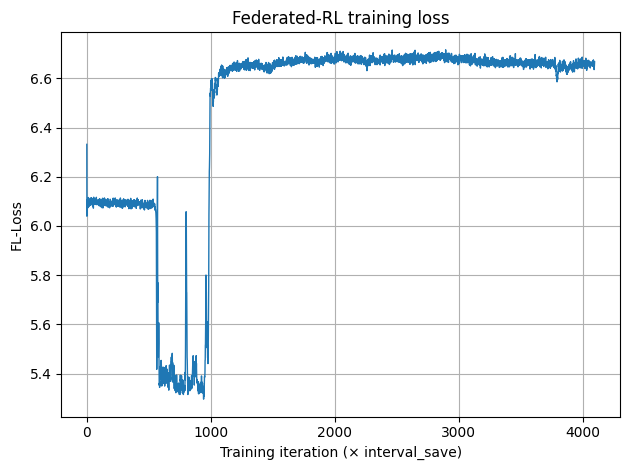

In [17]:
FIGURES_DIR = Path("./Figures")
FIGURES_DIR.mkdir(exist_ok=True)

# --- path to the history CSV produced by `static_field_estimation` ------------
FEDERAL_ROOT = Path("./") / "Federal"
MODELS_DIR   = FEDERAL_ROOT / "trained_models"
history_csv  = MODELS_DIR.with_name(MODELS_DIR.name + "_history.csv")  # same rule as in utils.py

# read the file
df = pd.read_csv(history_csv)

# build the x–axis: every row is one optimizer step (after averaging inside utils)
iterations = range(1, len(df) + 1)

# plot
plt.figure()
plt.plot(iterations, df["Loss"], linewidth=1)
plt.xlabel("Training iteration (× interval_save)")
plt.ylabel("FL‑Loss")
plt.title("Federated‑RL training loss")
plt.grid(True)
plt.tight_layout()

plt.savefig(FIGURES_DIR / "training_loss.png", dpi=300)

plt.show()